In [0]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 8.0MB/s 
     |████████████████████████████████| 3.8MB 26kB/s 
     |████████████████████████████████| 1.1MB 31.9MB/s 
     |████████████████████████████████| 890kB 48.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=3c2b1b9858b1064b29dc0b8d4209523eddc5977db173bfff78802c8027eab860
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import random
import numpy as np
import glob
import os.path
import codecs
import pandas as pd
import string
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, AdamW, BertConfig, BertTokenizer, AutoTokenizer, AutoModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import torch.nn as nn

seed_val = 16
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
root_path = "/content/drive/My Drive/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
train_folder = root_path + "datasets/train-articles" # check that the path to the datasets folder is correct,
dev_folder = root_path + "datasets/train-articles"     # if not adjust these variables accordingly
train_labels_file = root_path + "datasets/train-task2-TC.labels"


def read_articles_from_file_list(folder_name, file_pattern="*.txt"):
    """
    Read articles from files matching patterns <file_pattern> from
    the directory <folder_name>.
    The content of the article is saved in the dictionary whose key
    is the id of the article (extracted from the file name).
    Each element of <sentence_list> is one line of the article.
    """
    file_list = glob.glob(os.path.join(folder_name, file_pattern))
    articles = {}
    article_id_list, sentence_id_list, sentence_list = ([], [], [])
    for filename in sorted(file_list):
        article_id = os.path.basename(filename).split(".")[0][7:]
        with codecs.open(filename, "r", encoding="utf8") as f:
            articles[article_id] = f.read().replace("\r","")
    return articles

def read_predictions_from_file(filename):
    """
    Reader for the gold file and the template output file.
    Return values are four arrays with article ids, labels
    (or ? in the case of a template file), begin of a fragment,
    end of a fragment.
    """
    articles_id, span_starts, span_ends, gold_labels = ([], [], [], [])
    with open(filename, "r") as f:
        for row in f.readlines():
            article_id, gold_label, span_start, span_end = row.rstrip().split("\t")
            articles_id.append(article_id)
            gold_labels.append(gold_label)
            span_starts.append(span_start)
            span_ends.append(span_end)
    return articles_id, span_starts, span_ends, gold_labels

def get_article_to_fragment_map(articles, article_ids, span_starts, span_ends, labels):
    d = {}
    for i in range(len(article_ids)):
        idx = article_ids[i]
        fragment = {'start': int(span_starts[i]), 'end' : int(span_ends[i]), 'label' : labels[i]}
        if idx not in d:
          d[idx] = [fragment]
        else:
          d[idx].append(fragment)
    return d

def get_causal_article_list(article_ids, labels):
    article_list = []
    num_causal_frags = 0
    for i in range(len(labels)):
      if labels[i] == 'Causal_Oversimplification':
          article_list.append(article_ids[i])
          num_causal_frags = num_causal_frags + 1
    article_list = sorted(set(article_list))
    return article_list

def get_sentences_causal_analysis(sentences, sent_label, mode='random'):
    new_labels = []
    for i in range(len(sentences)):
      if mode == 'random':
        if sent_label[i] == 'Causal_Oversimplification':
            new_labels.append(1)
        else:
            new_labels.append(0)
      elif mode == 'causalvsnonprop':
        if sent_label[i] == 'Causal_Oversimplification':
            new_labels.append(1)
        elif sent_label[i] == 'No_Propaganda':
            new_labels.append(0)
        else:
            new_labels.append(-1)   #Ignore before creating dataset
      elif mode == 'causalvsother':
        if sent_label[i] == 'Causal_Oversimplification':
            new_labels.append(1)
        elif sent_label[i] != 'No_Propaganda':
            new_labels.append(0)
        else:
            new_labels.append(-1)   #Ignore before creating dataset
    
    final_sent = []
    final_labels = []
    for i in range(len(sentences)):
       if new_labels[i] != -1:
          final_sent.append(sentences[i])
          final_labels.append(new_labels[i])
    return final_sent, final_labels

### MAIN ###

# loading articles' content from *.txt files in the train folder
articles = read_articles_from_file_list(train_folder)

# loading gold labels, articles ids and sentence ids from files *.task-TC.labels in the train labels folder
article_ids, span_starts, span_ends, gold_labels = read_predictions_from_file(train_labels_file)
print("Loaded %d annotations from %d articles" % (len(span_starts), len(set(article_ids))))

#Get dictionary mapping each articleid in overall dataset to its fragments with labels
article_id_fragment_map = get_article_to_fragment_map(articles, article_ids, span_starts, span_ends, gold_labels)

#Get list of articles containing causal fragments and use only these articles in the dataset for causal oversimplification.
causal_article_ids = get_causal_article_list(article_ids, gold_labels)

print("Number of articles containing causal fragments - ", len(causal_article_ids))
print(causal_article_ids)

KeyboardInterrupt: ignored

In [0]:
#Create train - test article split - not required if we have a split dataset which will be true in fallacy case
#Shuffling the list of causal article ids - to create a slightly better train test article split 
#causal_article_ids = list(causal_article_ids)
random.shuffle(causal_article_ids)
print(len(causal_article_ids))      #check  - total
#Splitting the causal article ids into train and dev
num_train = int(0.8 * len(causal_article_ids))
train_causal_article_ids = causal_article_ids[:num_train]
dev_causal_article_ids = causal_article_ids[num_train:]
print(len(train_causal_article_ids))    #check - should be 80% of total
print(len(dev_causal_article_ids))      #check - should be 20% of total
#end of train-test split section

103
82
21


In [0]:
def get_sentences_containing_fragments(articles, prop_type_ids, d):
    unique_article_ids = prop_type_ids
    train_sentences = []
    train_sent_labels = []
    for art_id in unique_article_ids:
        #print(art_id)
        article = articles[art_id]
        sentences = article.split('\n')
        #print(sentences)
        sentence_indices = []
        fragments_in_article = d[art_id]
        start_fragment = 0
        sent_start = 0
        sent_end = 0
        for sent in sentences:
            sent_start = sent_end
            #Replacing double quotes with correct version
            sent = sent.replace('“','"')
            sent = sent.replace('”','"')
            #Removing any non-ascii characters in sentence
            sent = sent.encode("ascii", errors="ignore").decode()
            #Removing sentences without a letter
            sent_lower = sent.lower()
            contains_letters = sent_lower.islower()
            if contains_letters == False:
                sent_end = sent_start + len(sent) + 1
                continue            
            sent_end = sent_start + len(sent) - 1
            fragment_in_sent = None
            max_length = 0
            for frag in fragments_in_article:
                if (frag['start'] >= sent_start and frag['start'] < sent_end) or (frag['end'] > sent_start and frag['end'] <= sent_end):
                    frag_lt = min(sent_end,frag['end']) - max(sent_start,frag['start'])
                    if frag_lt > max_length:	
                        fragment_in_sent = frag
                        max_length = frag_lt
            if fragment_in_sent != None:
		            train_sentences.append(sent) 
		            train_sent_labels.append(fragment_in_sent['label'])
            else:
                train_sentences.append(sent)
                train_sent_labels.append('No_Propaganda')
            sent_end = sent_end + 2       
    return train_sentences, train_sent_labels #Labels - label of max lt fragment in sentence or no propaganda if no fragment in sentence

In [0]:
#Currently code uses only causal_article_ids for train and dev datasets
#To truly replicate fallacy case - i guess would have to add non causal article ids to train and dev set (80% and 20%)
#In train set we would not use the non causal articles ids while creating a balanced dataset
#In dev case we would use all sentences from causal and non causal dev article ids
#So inbelow function call to get_sentences_containing_ffragments - in train case only causal article ids will be passed to get sentences which will then be balanced and used
#In dev case all dev article ids willbe passed to get unbalanced datasetw which is used.

#Load sentences and sentence labels (Propganda type or No_Propaganda) for all sentences in chosen articles (causal_article_ids)
#This we would have got in the call to read_preds_from_file in fallacy case - mostly
train_sentences, train_labels = get_sentences_containing_fragments(articles, train_causal_article_ids, article_id_fragment_map)
dev_sentences, dev_labels = get_sentences_containing_fragments(articles, dev_causal_article_ids, article_id_fragment_map)

#Convert labels to binary ( Causal vs non causal )
train_sentences, train_labels = get_sentences_causal_analysis(train_sentences, train_labels, 'random')    #Unbalanced
dev_sentences, dev_labels = get_sentences_causal_analysis(dev_sentences, dev_labels, 'random')            #Unbalanced

print('Train sentences: ', train_sentences) 
print('Train Labels: ', train_labels)    #Should be 0s and 1s
print("Total number of train sentences - ", len(train_sentences))     #Should be roughly 80% of total sentences
print("Checking number of train labels - ", len(train_labels))

print('Dev sentences: ', dev_sentences)
print('Dev Labels: ', dev_labels)        #Should be 0s and 1s
print("Total number of dev sentences - ", len(dev_sentences))         #Should be roughly 20% of total sentences
print("Checking number of dev labels - ", len(dev_labels))

Train sentences:  ['The JFK Cover-Up Continues', 'While the mainstream media was announcing for the past two weeks that President Trump was going to release the CIAs long-secret records on the JFK assassination, I took a different position.', 'On Monday of this week, I predicted that Trump would make a deal with the CIA that would enable the CIA to continue its cover-up of the JFK assassination.', '(See "I Predict Trump Will Continue the CIAs JFK Assassination Cover-Up" and "No Smoking Guns in the JFK Records?")', 'On Thursday, the day of the deadline established by law for releasing the records, Trump granted the CIAs request for continued secrecy, on grounds of "national security," more than 50 years after the Kennedy assassination.', 'Please, dont start calling me Nostradamus.', 'A blind man could see what was happening.', 'Donald "Art of the Deal" Trump was obviously negotiating all week with the CIA, and he was obviously pushing to get what he wanted all the way up to the very las

In [0]:
print("Before balancing train")
count_pos_train = 0
for i in range(len(train_labels)):
    if train_labels[i] == 1:
        count_pos_train = count_pos_train + 1

print("Number of positive examples in train - ", count_pos_train)   
print("Number of negative examples in train - ", len(train_labels) - count_pos_train) 

count_pos_dev = 0
for i in range(len(dev_labels)):
    if dev_labels[i] == 1:
        count_pos_dev = count_pos_dev + 1

print("Number of positive examples in dev - ", count_pos_dev) 
print("Number of negative examples in dev - ", len(dev_labels) - count_pos_dev) 

Before balancing train
Number of positive examples in train -  233
Number of negative examples in train -  4828
Number of positive examples in dev -  42
Number of negative examples in dev -  1030


In [0]:
#Storing unbalanced train set and unbalanced dev set
df = pd.DataFrame(list(zip(train_sentences, train_labels)), columns=['Sentences', 'Labels'])
df.to_csv(root_path + "causal_datasets/unbalanced_train_dataset_80_20.csv")

df1 = pd.DataFrame(list(zip(dev_sentences, dev_labels)), columns=['Sentences', 'Labels'])
df1.to_csv(root_path + "causal_datasets/unbalanced_dev_dataset_80_20.csv")

In [0]:
# #Making the extracted train dataset balanced
# #If taking the first x number of negatively labeled sentences and all the positively labeled sentences - might have negative sentences from first few articles and positive sentences from all articles
# #To avoid the above - shuffle the train sentences and train labels first before selecting the first x negative sentences.
# d = list(zip(train_sentences, train_labels))
# random.shuffle(d)
# train_sentences, train_labels = zip(*d)           

# #Selected positive and negative sentences willbe from across articles in the train dataset.
# c = 1
# final_train_sent = []
# final_train_labels = []
# for i in range(len(train_labels)):
#     if train_labels[i] == 1:
#         final_train_sent.append(train_sentences[i])
#         final_train_labels.append(1)
#     else:
#         if c <= count_pos_train:
#             final_train_sent.append(train_sentences[i])
#             final_train_labels.append(0)
#             c = c + 1

# #Likely that final_train_labels will be negative followed by positivelabelsinspite of shuffling - so shuffle final_train_sent and final_train_labels
# #Dev sentences and labels are in articleorder which is fine.
# d = list(zip(final_train_sent, final_train_labels))
# random.shuffle(d)
# final_train_sent, final_train_labels = zip(*d)     
            
# #Check that balancing of train was done correctly
# print("Total number of sentences in balanced train dataset - ", len(final_train_sent))    #Should be 2*num_pos or 2* num_neg
# print("Checking number of labels in balanced train dataset - ", len(final_train_labels))
# count_pos = 0
# for i in range(len(final_train_labels)):
#     if final_train_labels[i] == 1:
#         count_pos = count_pos + 1

# print("Number of positive examples in balanced train dataset - ", count_pos)  #Should be same as number of negative examples in balanced dataset
# print("Number of negative examples in balanced train dataset - ", len(final_train_labels) - count_pos)    


In [0]:
# #Storing balanced train set formed as subset of unbalanced train set stored above
# df = pd.DataFrame(list(zip(final_train_sent, final_train_labels)), columns=['Train sentences', 'Train labels'])
# df.to_csv(root_path + "causal_datasets/balanced_train_dataset.csv")

In [0]:
#Reading unbalanced train and unbalanced dev from csv
df_dev = pd.read_csv(root_path + "causal_datasets/unbalanced_dev_dataset_80_20.csv")
dev_sent = df_dev['Sentences'].values
dev_labels = df_dev['Labels'].values

df_train = pd.read_csv(root_path + "causal_datasets/unbalanced_train_dataset_80_20.csv")
train_sent = df_train['Sentences'].values
train_labels = df_train['Labels'].values

In [0]:
# count_pos = 0
# for i in range(len(dev_labels)):
#     if dev_labels[i] == 1:
#         count_pos = count_pos + 1

# print("Number of positive examples in balanced train dataset - ", count_pos)  #Should be same as number of negative examples in balanced dataset
# print("Number of negative examples in balanced train dataset - ", len(dev_labels) - count_pos)   

Number of positive examples in balanced train dataset -  35
Number of negative examples in balanced train dataset -  979


In [0]:
#Can run with balanced or unbalanced train dataset
# train_sent = np.array(train_sentences)
# dev_sent = np.array(dev_sentences)
# train_labels = np.array(train_labels)
# dev_labels = np.array(dev_labels)

#print(train_sent)
# print(train_sent.shape)
# print(train_labels)
# print(train_labels.shape)
# print(dev_sent.shape)
# print(dev_labels)
# print(dev_labels.shape)

In [0]:
# #Making dev data balanced -
# count_pos_dev = 0
# for i in range(len(dev_labels)):
#     if dev_labels[i] == 1:
#         count_pos_dev = count_pos_dev + 1

# print("Number of positive examples in dev - ", count_pos_dev) 
# print("Number of negative examples in dev - ", len(dev_labels) - count_pos_dev) 

In [0]:
# #Making dev data balanced -
# dev_sent = list(dev_sentences)
# dev_labels = list(dev_labels)
# d = list(zip(dev_sent, dev_labels))
# random.shuffle(d)
# dev_sent, dev_labels = zip(*d)           

# #Selected positive and negative sentences willbe from across articles in the train dataset.
# c = 1
# final_dev_sent = []
# final_dev_labels = []
# for i in range(len(dev_labels)):
#     if dev_labels[i] == 1:
#         final_dev_sent.append(dev_sent[i])
#         final_dev_labels.append(1)
#     else:
#         if c <= count_pos_dev:
#             final_dev_sent.append(dev_sent[i])
#             final_dev_labels.append(0)
#             c = c + 1


# #Likely that final_dev_labels will be negative followed by positivelabelsinspite of shuffling - so shuffle 
# d = list(zip(final_dev_sent, final_dev_labels))
# random.shuffle(d)
# final_dev_sent, final_dev_labels = zip(*d)     
# final_dev_labels = list(final_dev_labels)
# final_dev_sent = list(final_dev_sent)
# #Check that balancing of train was done correctly
# print("Total number of sentences in balanced train dataset - ", len(final_dev_sent))    #Should be 2*num_pos or 2* num_neg
# print("Checking number of labels in balanced train dataset - ", len(final_dev_labels))
# count_pos = 0
# for i in range(len(final_dev_labels)):
#     if final_dev_labels[i] == 1:
#         count_pos = count_pos + 1

# print("Number of positive examples in balanced train dataset - ", count_pos)  #Should be same as number of negative examples in balanced dataset
# print("Number of negative examples in balanced train dataset - ", len(final_dev_labels) - count_pos)    

# print(final_dev_sent)
# print(final_dev_labels)

# dev_sent = np.array(final_dev_sent)
# dev_labels = np.array(final_dev_labels)

In [0]:
print(train_sent.shape)
print(train_labels)
print(train_labels.shape)
#print(dev_sent)
print(dev_sent.shape)
print(dev_labels)
print(dev_labels.shape)

(5061,)
[0 0 0 ... 0 0 0]
(5061,)
(1072,)
[0 0 0 ... 0 0 0]
(1072,)


In [0]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
#tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

Loading BERT tokenizer...


In [0]:
train_inputs = train_sent

train_input_ids = []
for sent in train_inputs:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 200,   #Works well for causal local data split.
                        pad_to_max_length = True
                   )
    train_input_ids.append(encoded_sent)

print('Original: ', train_inputs[0])
print('Token IDs:', train_input_ids[0])

Original:  The JFK Cover-Up Continues
Token IDs: [101, 1996, 1046, 24316, 3104, 1011, 2039, 4247, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
# Remove max len from above step, encode, then run this to check if max length value is fine. Rerun above step with correct max length value.
print("max len - ", max([len(sen) for sen in train_input_ids])) 

max len -  200


In [0]:
#Create attention masks
train_attention_masks = []

for sent in train_input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    train_attention_masks.append(att_mask)

In [0]:
#Convert to tensors
train_input_ids = torch.tensor(train_input_ids)
train_labels = torch.tensor(train_labels)
train_attention_masks = torch.tensor(train_attention_masks)

In [0]:
batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [0]:
class BertForPropagandaDetection(nn.Module):
    def __init__(self, num_labels=2):
        super(BertForPropagandaDetection, self).__init__()
        self.num_labels = num_labels
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        #self.bert_model = AutoModel.from_pretrained("SpanBERT/spanbert-base-cased")
        self.ffnn = nn.Sequential(nn.Linear(768, self.num_labels))

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        # hidden_states = outputs[2]
        # cls_last_4 = [hidden_states[i][:,0,:] for i in [-1,-2,-3,-4]]
        # cls_avg = torch.mean(torch.stack(cls_last_4),0)
        #todo: change to use average of last hidden state instead of pooled output
        logits = self.ffnn(pooled_output)
        return logits

model = BertForPropagandaDetection()
model = model.to('cuda')

optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

In [0]:
epochs = 10
total_steps = len(train_dataloader) * epochs
#AdamW doesn't have a scheduler - so scheduler is external
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
loss_function = nn.CrossEntropyLoss(torch.FloatTensor([0.5241, 10.8605]).cuda())
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training')
    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        logits = model(b_input_ids, attention_mask=b_input_mask)

        loss = loss_function(logits, b_labels)
        total_loss += loss.item()
        loss.backward()
        #Gradient clipping is external with AdamW
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
 
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training
  Batch    40  of    317.    Elapsed: 0:00:13.
  Batch    80  of    317.    Elapsed: 0:00:26.
  Batch   120  of    317.    Elapsed: 0:00:39.
  Batch   160  of    317.    Elapsed: 0:00:51.
  Batch   200  of    317.    Elapsed: 0:01:04.
  Batch   240  of    317.    Elapsed: 0:01:17.
  Batch   280  of    317.    Elapsed: 0:01:30.

  Average training loss: 0.76
  Training epoch took: 0:01:42

======== Epoch 2 / 10 ========
Training
  Batch    40  of    317.    Elapsed: 0:00:13.
  Batch    80  of    317.    Elapsed: 0:00:26.
  Batch   120  of    317.    Elapsed: 0:00:38.
  Batch   160  of    317.    Elapsed: 0:00:51.
  Batch   200  of    317.    Elapsed: 0:01:04.
  Batch   240  of    317.    Elapsed: 0:01:17.
  Batch   280  of    317.    Elapsed: 0:01:30.

  Average training loss: 0.86
  Training epoch took: 0:01:42

======== Epoch 3 / 10 ========
Training
  Batch    40  of    317.    Elapsed: 0:00:13.
  Batch    80  of    317.    Elapsed: 0:00:26.
 

In [0]:
# # #Save the fine-tuned BERT model so it can be loaded later
model.bert_model.save_pretrained(root_path + 'bert_causal_oversimplification/bert_modified_loss_ep10/')
tokenizer.save_pretrained(root_path + 'bert_causal_oversimplification/bert_modified_loss_ep10/')

('/content/drive/My Drive/bert_causal_oversimplification/bert_modified_loss_ep10/vocab.txt',
 '/content/drive/My Drive/bert_causal_oversimplification/bert_modified_loss_ep10/special_tokens_map.json',
 '/content/drive/My Drive/bert_causal_oversimplification/bert_modified_loss_ep10/added_tokens.json')

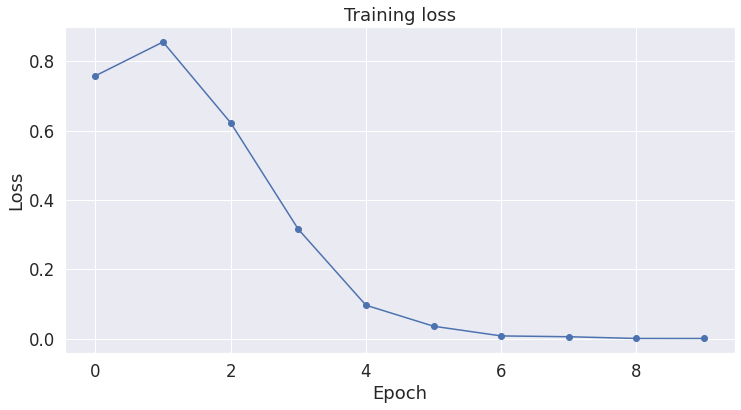

In [0]:
% matplotlib inline
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
print(dev_sent.shape)
print(dev_labels.shape)

dev_input_ids = []
for sent in dev_sent:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 200,
                        pad_to_max_length = True
                   )
    
    dev_input_ids.append(encoded_sent)

dev_attention_masks = []
for seq in dev_input_ids:
  seq_mask = [float(i>0) for i in seq]
  dev_attention_masks.append(seq_mask) 

dev_input_ids = torch.tensor(dev_input_ids)
dev_attention_masks = torch.tensor(dev_attention_masks)

batch_size = 32  

prediction_data = TensorDataset(dev_input_ids, dev_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

(1072,)
(1072,)


In [0]:
print('Predicting labels for {:,} test sentences...'.format(len(dev_input_ids)))
model.eval()

predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      logits = model(b_input_ids, attention_mask=b_input_mask)
  logits = logits.detach().cpu().numpy()
  predictions = predictions + list(logits)

print('Done!')

Predicting labels for 1,072 test sentences...
Done!


In [0]:
#Convert prediction logits to 0 or 1
predicted_labels = []
for i in range(len(predictions)):
    pred_value = np.argmax(predictions[i])
    if pred_value > 1:
        raise Exception("Error in predictions")
    predicted_labels.append(pred_value)

print(predicted_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [0]:
# df = pd.read_csv(root_path + "causal_datasets_with_features/dev_80_20_with_predictions.csv")
# df['BERT predictions'] = predicted_labels
# df.to_csv(root_path + "causal_datasets_with_features/dev_80_20_with_predictions.csv")

In [0]:
print("Accuracy of classifier - ", accuracy_score(dev_labels, predicted_labels))

Accuracy of classifier -  0.9580223880597015


In [0]:
print("Confusion matrix values - ")
tn, fp, fn, tp = confusion_matrix(dev_labels, predicted_labels).ravel()
print("TP - ", tp)
print("FN - ", fn)
print("TN - ", tn)
print("FP - ", fp)

Confusion matrix values - 
TP -  3
FN -  39
TN -  1024
FP -  6


In [0]:
print("F1-score of classifier on each class - ", f1_score(dev_labels, predicted_labels, average=None))
print("Macro averaged F1-score of classifier - ", f1_score(dev_labels, predicted_labels, average='macro'))
print("Weighted averaged F1-score of classifier - ", f1_score(dev_labels, predicted_labels, average='weighted'))

F1-score of classifier on each class -  [0.97849976 0.11764706]
Macro averaged F1-score of classifier -  0.5480734099659931
Weighted averaged F1-score of classifier -  0.9447723231458011


In [0]:
"""
causal vs random

Number of causal fragments - 209
Number of articles with Causal fragments in train dataset - 103
Sentences:  ["Kate Steinle's death at the hands of a Mexican national became a flashpoint in the immigration debate — here's the story behind her killing", 'The surprise acquittal of Jose Ines Garcia Zarate in the shooting death of San Francisco woman Kate Steinle set off a firestorm of outrage Thursday night, as top conservatives and critics of so-called "sanctuary cities" pinned blame for Steinle\'s death on illegal immigration and insufficiently aggressive deportation policies.', 'Garcia Zarate, a 45-year-old Mexican national who was homeless and living in the US illegally when he fired the shot that killed Steinle, was acquitted by a jury on murder and manslaughter charges.', 'The jury convicted him of the lesser charge of being a felon in possession of a gun, which carries a maximum sentence of three years in state prison.', 'Steinle, 32, was fatally shot while she walked along Pier 14 of the San Francisco Bay with her father in July 2015.', 'The bullet that pierced her back had ricocheted off the concrete ground after it was fired by Garcia Zarate from a handgun belonging to a federal ranger that had been stolen four days earlier.', "Garcia Zarate's defense attorneys argued that the shooting was an accident — they said he found the gun wrapped in a T-shirt or cloth under a pier bench and unintentionally discharged it.", 'Lead attorney Matt Gonzalez has argued that the weapon was a SIG Sauer with a "hair trigger in single-action mode" — a model well-known for accidental discharges even among experienced shooters.', 'Gonzalez told the jury, according to the San Francisco Chronicle, that Garcia Zarate had never handled a firearm before, was frightened by the noise of the gunshot, then flung the weapon into the bay where it was later found by a diver.', 'Prosecutors, however, alleged that Garcia Zarate brought the weapon to the pier deliberately to do harm, and intentionally aimed and shot Steinle after firmly pulling the trigger.', 'They said Garcia Zarate then threw the weapon into the bay and fled the scene.', "Beyond the shooting itself, perhaps the most controversial aspect of Garcia Zarate's case involves his previous criminal activity and history of deportations, and how San Francisco and federal authorities handled his custody before he ever picked up the gun and shot Steinle.", "At the time of Steinle's death, Garcia Zarate had been convicted of nonviolent drug crimes and deported five times since the early 1990s.", 'He faced a sixth deportation in 2015, and was in Justice Department (DOJ) custody that March after serving 46 months in prison for a felony re-entry into the US, but instead of transferring him into the custody of Immigration and Customs Enforcement (ICE) for deportation, the department transferred him to the San Francisco County Jail for prosecution of a 1995 marijuana charge.', 'San Francisco prosecutors, who had long ago deprioritized marijuana charges, dismissed the decades-old charge and released Garcia Zarate on April 15, 2015.', 'Due to San Francisco\'s policy of limiting cooperation with federal immigration authorities — which some refer to as a "sanctuary" policy — the city did not inform ICE when they released Garcia Zarate.', 'As a result of the case, both the DOJ and the city of San Francisco have changed several policies.', 'The DOJ announced in 2016 it would no longer release potentially deportable detainees to local jails without first allowing ICE to take custody.', 'San Francisco, meanwhile, has adjusted its policy to notify ICE if they are releasing suspected undocumented immigrants who face charges of serious or violent felonies.', '"This tragedy could have been prevented if San Francisco had simply turned the alien over to ICE as we requested, instead of releasing him back onto the streets," ICE Director Thomas Homan said in a statement on Thursday.', '"It is unconscionable that politicians across this country continue to endanger the lives of Americans with sanctuary policies while ignoring the harm inflicted on their constituents."', "But ICE has faced criticism of its own over not seeking a judicial warrant to legally obtain custody of Garcia Zarate when it discovered he had been transferred into San Francisco's custody.", 'The agency has argued that obtaining judicial warrants are unnecessary and would place too much burden on ICE officials and federal courts.', 'Though the agency did issue a request to the city to detain Garcia Zarate until ICE officials could pick him up, their detainer requests are not signed by a judge and are therefore not legally binding.', "San Francisco's policy is to ignore such requests if they are not accompanied by judge-signed warrants, and the city has cited federal court cases concluding that such detentions violate inmates' Fourth Amendment rights.", "Garcia Zarate's deportation and criminal history made him an effective target for immigration hardliners, who argued that Steinle would still be alive were it not for an insecure border and lenient treatment toward suspected undocumented immigrants in local jails.", 'President Donald Trump immediately seized on the verdict on Thursday as evidence of the perils of "Illegal Immigration."', 'Trump frequently villainized Garcia Zarate and cited Steinle\'s death during his presidential campaign, using the case to bolster his argument for a border wall and aid his crusade against "sanctuary cities."', 'Early on Friday, Trump also falsely claimed on Twitter that Garcia Zarate had previously committed violent crimes and had illegally entered the US six times due to lax border security under the Obama administration.', '"The Kate Steinle killer came back and back over the weakly protected Obama border, always committing crimes and being violent, and yet this info was not used in court.', 'His exoneration is a complete travesty of justice.', 'BUILD THE WALL!"', 'Trump tweeted.', "In fact, Garcia Zarate had never been convicted of a violent crime before Steinle's shooting — his previous convictions were for nonviolent drug crimes and illegal entry.", 'Lax border security, too, does not appear to be a factor since Garcia Zarate was caught by border patrol agents each time he entered the country under the Obama administration.', 'In contrast, Steinle\'s family has expressed nuanced views on immigration and "sanctuary" policies.', 'They have both condemned Trump for "sensationalizing" Steinle\'s death to advance anti-immigration policies, and expressed frustration with San Francisco officials, who they believe went too far in refusing to cooperate with federal immigration authorities.', 'Trump formally nominates Gina Haspel to be next CIA director', 'WASHINGTON — President Donald Trump formally notified Congress on Tuesday that deputy CIA director Gina Haspel is his pick to lead the agency.', 'Trump tweeted last month that he had selected Haspel to replace Mike Pompeo, who is being considered to be secretary of state.', 'But the president had not sent the formal paperwork to Capitol Hill.', 'Logistical issues, including an FBI background check that took longer than expected, was to blame, according to a U.S. official, who was not authorized to discuss the issue and spoke only on condition of anonymity.', 'Still, the delay prompted critics to speculate that the delay signaled the White House was having second thoughts about the nomination.', 'Some lawmakers and human rights groups oppose Haspel’s nomination because of her role in the CIA’s detention and harsh interrogation of terror suspects after 9/11.', 'The Senate intelligence committee is expected to have a confirmation hearing for Haspel in coming weeks, followed by a vote in the full Senate.', 'Kavanaugh Nomination Is Exploding in Trump’s Face', 'The president is doubling down on an increasingly risky candidate.', 'Justice Anthony Kennedy gave President Donald Trump the biggest political gift possible when he announced his resignation in the spring.', 'Even though not everything that’s gone wrong is Trump’s fault, he has managed to make a complete hash of Brett Kavanaugh’s nomination to fill the empty seat on the court.', 'It’s a good example of how badly Trump does his job more than a year and a half into his administration.', 'To begin with, Trump has outsourced his judicial nominations to outside, party-aligned groups, the Heritage Foundation and the Federalist Society.', 'That included an unusually central role for the Federalist Society’s Leonard Leo.', 'That wasn’t entirely a Trump mistake.', 'His decision during the campaign to release a list of potential justices drafted by Leo reflected the reality-TV star’s weakness as a presidential candidate.', 'The party was worried that Trump might turn out not to be a conservative; to reassure them, he publicly committed to their top goal.', 'In some ways, that’s successful coalition-building, and what he’s done in office is just keeping his promises on judges.', 'Still, it’s one thing to form an alliance with conservatives; it’s another to turn the whole process over to them.', 'We don’t know to what extent Kavanaugh was Trump’s choice and to what extent he was manipulated into choosing him.', 'We have plenty of evidence that Trump is easily manipulated by those around him, and that Kavanaugh is a good fit for Trump’s biases: The judge has Ivy League credentials and he passes Trump’s cut-of-his-jib test by looking the part.', 'Either way, Kavanaugh was a poor choice from the point of view of good presidenting.', 'The judge was certain to be a highly controversial selection from the start.', 'After all, he had been a highly controversial selection for his current circuit court seat, eventually getting confirmed with only four Democratic votes after a long delay.', 'Kavanaugh is a longtime Republican operative, a hard-liner during both the Vince Foster and Monica Lewinsky investigations.', 'Nominating him, rather than a conservative with similar views but a different background, was bound to stir up trouble.', 'It was also true, as Senate Majority Leader Mitch McConnell reportedly warned, that normal disclosure of Kavanaugh’s record, especially his service during the George W. Bush administration, was going to delay confirmation even more.', 'Senate Republicans dealt with that problem by deciding to not bother with any Kavanaugh documents that couldn’t be produced rapidly, which further riled up the Democrats and gave that party some good talking points.', 'Sometimes it’s worth taking risks.', 'Presidents who shy away from anything that’s not a sure thing can fail to exploit opportunities.', 'It’s just very hard to see any upside for Trump in choosing Kavanaugh instead of a safer, but still very conservative, other option.', 'When serious charges of sexual misconduct were raised against Kavanaugh, Trump decided to stick with him instead of moving on to another candidate.', 'It’s still not clear that Kavanaugh’s nomination is doomed, but it’s certainly in severe trouble.', 'Losing a high-profile fight is always going to hurt a president, which is why they should take care to avoid high-risk, low-reward conflicts.', 'But there’s an art to minimizing damage.', 'And Trump hasn’t learned it yet.', 'For one thing, the president has made this an extremely high-profile episode by stringing out the process as the accusations against Kavanaugh gained credibility and even multiplied.', 'Whether that matters in terms of public opinion for Trump is unclear, but it certainly isn’t good for any Republican senators caught up in the middle, along with any other candidates who have had to weigh in only to find the facts as they knew them constantly changing.', 'It’s also the case that the more negative information comes out, the more it appears that the Trump and his White House staff failed to do their jobs in vetting and managing Kavanaugh.', 'If the nomination had been pulled right after Christine Blasey Ford made her initial assertions about Kavanaugh, the public might have concluded that it wasn’t Trump’s fault that a previously unaired accusation came to light.', 'Meanwhile, Trump’s behavior has been as erratic as ever.', 'First he said that Brasey had to be heard; then he attacked her in terms that were a slur on all women who have been assaulted without immediately reporting it to the police, and he also blamed the Senate for not voting before she came forward.', 'He sometimes praises Kavanaugh, but also let it be known that he thought the nominee had performed badly in his Fox News interview.', 'The White House demanded a final up and down vote on Tuesday; by Wednesday, he was saying that the nomination would die if Kavanaugh didn’t do well before the Judiciary Committee on Thursday.', 'The sum of all this has been, as in many other episodes, that Trump and his White House are a gang that can’t shoot straight and that he’s eager to blame his allies and lash out at his enemies in ugly ways when things go wrong.', 'A botched nomination matters because allies will be less likely to trust Trump, not just on Supreme Court choices, but on any initiative.', 'And, for that matter, they’ll be less likely to trust him when he asserts that there’s nothing remaining for Special Counsel Robert Mueller to reveal.', 'Trump’s professional reputation is already terrible, but everything counts.', 'As the political scientist Richard Neustadt said, political elites are constantly evaluating and re-evaluating the president.', 'Trump is hurting himself right now, and will have hurt himself more if Kavanaugh is not confirmed.', 'And yes, I call it the cut-of-his-jib test quite deliberately.', "It's no surprise that someone who hires based on what he thinks someone doing that job should look like, which seems to be based on hazy old-time Hollywood casting, would wind up with fewer women in his administration than any of his recent predecessors.", "I've argued that too much disclosure is required, and that Democrats (and any wavering Republicans) had more than enough information to make up their mind.", "I still think that's true.", "But it did leave Republicans vulnerable to claims about transparency which were likely to be popular -- most people, and the entire press corps, love transparency -- and vulnerable to bombshells in the documentary record which hadn't been initially disclosed.", "In the event, that's not what's causing the trouble, but still it's an example of Trump taking needless risks.", "Some have speculated that Kavanaugh would be especially likely to rule in Trump's favor if any cases stemming from the Robert Mueller investigation wind up at the high court.", 'Perhaps.', 'There are plenty of other partisan, conservative judges, and plenty of conservative judges who lean towards an expansive view of presidential powers.', "And if Kavanaugh is really an outlier on that issue, then he won't be in the majority on any future decision anyway.", "So, no, I don't think there's any good reason to think Kavanaugh would be especially helpful to Trump compared to others he could have selected.", 'Agencies scramble to prep Russia probe files for release after sweeping Trump order', 'Intelligence agencies were scrambling Tuesday to comply with a sweeping order by President Trump to declassify key documents that could shed light on the origins of the Russia collusion probe that has hamstrung the administration for more than 18 months.', 'The documents Trump ordered declassified involve a renewed Foreign Intelligence Surveillance Act warrant against former campaign aide Carter Page and text messages from disgraced former FBI officials Peter Strzok and Lisa Page.', 'The president on Monday afternoon ordered that the documents be released by the Office of the Director of National Intelligence (ODNI) and the Justice Department “[a]t the request of a number of committees of Congress, and for reasons of transparency,” according to a statement issued by White House Press Secretary Sarah Sanders.', 'It is not immediately clear how and when the documents will be released, but by Monday evening, intelligence agencies said they had already begun working to prepare the documents.', '“When the President issues such an order, it triggers a declassification review process that is conducted by various agencies within the intelligence community, in conjunction with the White House Counsel, to seek to ensure the safety of America’s national security interests,” a Justice Department spokesperson said in a statement to Fox News.', '“The Department and the Federal Bureau of Investigation are already working with the Director of National Intelligence to comply with the President’s order.”', 'ODNI spokeswoman Kellie Wade also said that the agency was “working expeditiously with our interagency partners to conduct a declassification review of the documents the President has identified for declassification.”', 'The documents include all FBI reports on interviews, also known as 302s, with Justice Department official Bruce Ohr and all FBI reports of interviews prepared in connection with applications to surveil Carter Page, as well as 21 pages of one renewed warrant.', 'The 21 pages make up only a small portion of the 412 pages of FISA applications and warrants related to Page released by the FBI earlier this year in a heavily redacted format.', 'The June 2017 application was the last of four filed by the Justice Department in support of FISA court orders allowing the monitoring of Page for nearly a year.', 'The president also ordered the release of unredacted text messages from fired FBI Special Agent Peter Strzok, former FBI counsel Lisa Page, former FBI Director James Comey and former FBI Deputy Director Andrew McCabe.', 'The president for months has blasted Strzok and Page for the bias revealed in their text messages, as well as Comey and McCabe for their leadership of the FBI.', 'Comey was fired from the bureau in May 2017; McCabe was fired by Attorney General Jeff Sessions in March; Page left the bureau in May; and Strzok was fired last month.', 'A source familiar with the timing of the declassification told Fox News they expected the Carter Page warrant application to be declassified first, followed by the FBI reports on agent interviews with Ohr.', 'The source added that the Justice Department is working on a "compressed timeline" and they expect the first release of records in days or sooner.', 'The text messages are expected to take longer because of the sheer number involved and the fact that Trump ordered their release without redactions.', 'Republicans on Capitol Hill, including House Intelligence Committee Chairman Devin Nunes, R-Calif., are touting the president’s order, saying it covers “pretty much everything that he wanted…and the text messages are a bonus,” a source said of Nunes.', "Congressional Republicans are hoping the files reveal details about the start of the Russia investigation led by the FBI, which evolved into Special Counsel Robert Mueller's investigation into Russian meddling and potential collusion with Trump campaign associates during the 2016 presidential election.", 'But Democrats,including the committee’s ranking member, Rep. Adam Schiff, D-Calif., are blasting the declassification order as a “clear abuse of power.”', '"[Trump] has decided to intervene in a pending law enforcement investigation by ordering the selective release of materials he believes are helpful to his defense team and thinks will advance a false narrative," Schiff said.', '"With respect to some of these materials, I have been previously informed by the FBI and Justice Department that they would consider their release a red line that must not be crossed as they may compromise sources and methods.', '"This is evidently of no consequence to a President who cares about nothing about the country and everything about his narrow self-interest," Schiff added.', 'The president’s order is similar to his February move, when he cleared the way for the Republican-led House Intelligence Committee to release a partisan memo about the surveillance warrant on Carter Page.', 'Democrats, weeks later, released their own version of the memo.', 'Why Louis Farrakhan Is Back in the News', 'Louis Farrakhan, the 84-year-old head of the Nation of Islam, has been back in the headlines after a previously unreleased photo of him with President Barack Obama was published in January and Mr. Farrakhan gave an anti-Semitic speech at his organization’s annual convention last month.', 'The Feb. 25 speech, which was given at an event for Saviour’s Day, a religious gathering of the Nation, ran for almost three hours.', 'During it, Mr. Farrakhan said that the “powerful Jews” were his enemies, and that Jews were “responsible for all of this filth and degenerate behavior that Hollywood is putting out turning men into women and women into men,” as well as other incendiary remarks.', 'A religious fundamentalist whose group has been condemned by the Southern Poverty Law Center, Mr. Farrakhan is fervently opposed to the legitimacy of the state of Israel, and his political positions regarding the country frequently spill over into bigoted remarks about Jews, which is why many public officials have avoided association with him.', 'Mr. Farrakhan has denied that he is anti-Semitic and has even said that his father may have been Jewish.', 'Much of the recent coverage has been focused on Tamika Mallory, one of the heads of the Women’s March organization, who attended the Feb. 25 speech, and on Representative Danny Davis, a Democrat of Illinois, who defended Mr. Obama and Mr. Farrakhan after the photo came to light.', 'Their reluctance to condemn Mr. Farrakhan has led to criticism from across the ideological spectrum this week.', 'What is the Nation of Islam?', 'The Nation of Islam is a political and religious movement that was started by W.D.', 'Fard Muhammad in 1931 and continued by Elijah Muhammad in 1933.', 'It first became prominent after a man named Malcolm Little joined the organization.', 'Encouraged by Elijah Muhammad, he changed his last name to X and became a minister in the movement.', 'Edward E. Curtis IV, the author of “Black Muslim Religion in the Nation of Islam,” said that while estimates ranged wildly about how many bona fide members belonged to the Nation, he believes that there were tens of thousands of members in the 1960s and early 1970s.', 'But he said that millions of others sympathized with the movement’s anticolonial stance and were inspired by its most famous member, Muhammad Ali.', 'Who is Louis Farrakhan?', 'Born Louis Eugene Walcott in New York in 1933, Mr. Farrakhan joined the Nation of Islam in the mid-1950s and rose quickly within the organization, becoming close to Malcolm X.', 'After the assassination of Malcolm X in 1965, he became one of the most powerful members of the Nation and its chief spokesman, the position that Malcolm X had held.', 'The Nation of Islam had gained followers around the nation in the 1940s and ’50s by providing something of a religious answer to antiblack racism.', 'It was not widely recognized as an anti-Jewish organization during its early years (its early literature, though, focused on “the white man” as “the white devil”).', 'But in 1967, it became outspokenly and flagrantly anti-Zionist, in an expression of solidarity with Palestinians.', 'That political position became a vehicle for Mr. Farrakhan to express his anti-Semitism.', '(Among his more infamous comments is his 1984 description of Adolf Hitler as “a very great man.”)', 'In 1975, when Elijah Muhammad died, the Nation split into two factions.', 'The faction reconstituted under Mr. Farrakhan in the late 1970s retained the original name, though not the influence or support that it had when its leaders were Malcolm X, Muhammad Ali and Elijah Muhammad.', 'Mr. Curtis said that today the membership could be in the thousands, and there could even be as many as 10,000 followers.', 'Mr. Farrakhan, whose name, the Anti-Defamation League wrote after the February event, is “virtually synonymous with anti-Semitism,” then drew national attention in 1984, when he exhorted his followers to support Jesse Jackson’s bid for the Democratic presidential nomination.', 'In a radio address, he urged listeners to “make an example” of a Washington Post reporter who had reported that Mr. Jackson had used anti-Semitic terms in private.', 'Mr. Jackson repudiated Mr. Farrakhan, but the minister’s support proved troublesome to his 1988 campaign as well.', 'He was back in the news in 1995 when he organized what became known as the “Million Man March,” a political and religious revival event in Washington.', 'Why were Tamika Mallory and Danny Davis reluctant to denounce him?', 'Ms. Mallory, who declined to comment for this article, did not respond to calls to condemn Mr. Farrakhan, for whom she had expressed admiration in the past.', 'On March 3, she said on Twitter that someone had brought to her attention that she had yet to tweet “my absolute position on how wrong anti-Semitism is.” A day later, she said that she was “committed to ending anti-black racism, anti-Semitism, homophobia & transphobia,” but did not mention Mr. Farrakhan.', 'In an essay posted Wednesday, she said that she had been attending Saviour’s Day celebrations for over 30 years.', '“In that most difficult period of my life, it was the women of the Nation of Islam who supported me and I have always held them close to my heart for that reason,” she said.', 'The essay did not mention Mr. Farrakhan.', 'Asked what the appeal of Mr. Farrakhan’s views might be to people like Ms. Mallory, religious scholars emphasized that the Nation of Islam is a religion and can provide comfort and aid to its adherents.', '“For those who find it appealing, it is a form of radical black self love that is willing to challenge any potential impediment to black freedom,” Mr. Curtis said.', 'Yvonne Chireau, a professor of religion at Swarthmore who called Mr. Farrakhan’s remarks about Jews “unbelievably vile,” emphasized that his fundamentalism was comparable to the fundamentalist views found in other religions.', 'Coincidentally, the photo of Mr. Farrakhan and Mr. Obama had been published by the Trice Edney News Wire in January.', 'The News Wire reported that the picture had been taken by the photojournalist Askia Muhammad during a 2005 meeting of the Congressional Black Caucus and that Mr. Muhammad kept the photo under wraps so as not to hurt Mr. Obama’s candidacy.', '(Mr. Muhammad, in a 2012 blog post, said that he was an admirer of Mr. Farrakhan and that the minister was not an anti-Semite.', 'He reaffirmed that he admired Mr. Farrakhan in an interview on Friday, though he said that the things the minister says about Jewish people “sometimes make me shudder.”)', 'Katie Hill, a spokeswoman for Mr. Obama, said on Friday: “President Obama has denounced racism and anti-Semitism his entire life.', 'That includes his public and repeated repudiations of Louis Farrakhan’s views over the years.', 'Today is no different — he still rejects the harmful and divisive views Farrakhan continues to espouse.”', 'Representative Davis, who was interviewed by The Daily Caller, a conservative news site, after the photo emerged, called Mr. Farrakhan an “outstanding human being,” and later said he was not bothered by the leader’s position on “The Jewish Question.”', 'After a monthlong backlash about that interview, largely in conservative media, Mr. Davis said in a statement to Forward on Thursday that “I reject, condemn and oppose Minister Farrakhan’s views and remarks regarding the Jewish people and the Jewish religion.”', 'Wait!', 'Wait!', 'It’s all a MISTRANSLATION!', 'Thus, it took more than a year-and-a-half for the Factory to roll out the old reliable “mistranslation” defense to explain away the infamous paragraph 303 of Amoris Laetita (AL), which reads as follows in the official English translation on the Vatican website:', 'Yet conscience can do more than recognize that a given situation does not correspond objectively to the overall demands of the Gospel.', 'It can also recognize with sincerity and honesty what for now is the most generous response which can be given to God, and come to see with a certain moral security that it is what God himself is asking amid the concrete complexity of one’s limits, while yet not fully the objective ideal.', 'In other words, the conscience can “inform” a sinner that his continued sinning is not only acceptable to God but is even what God is asking “for now,” given one’s particular “limits.” This outrageous proposition, a form of situation ethics that strikes at the very foundation of Catholic moral teaching, has justly provoked a storm of criticism from lay and clerical defenders of the authentic Magisterium.', 'But it’s all a misunderstanding, say Dr. Robert Fastiggi, professor of Systematic Theology at Sacred Heart Major Seminary, and Dr.', 'Dawn Eden Goldstein, S.T.D., professor of Dogmatic Theology at Holy Apostles College and Seminary.', 'All of the critics of AL are wrong—every one of them!—because, you see, the original Latin text does not say what the English text does.', 'Dr. Robert Fastiggi and Dr.', 'Dawn Goldstein', 'Here we go again.', 'So what does the Latin say?', 'Here is the paragraph in the official Latin:', 'Haec autem conscientia agnoscere potest non modo statum quendam ab universali Evangelii mandato obiective dissidere; etiam sincere honesteque agnoscere poteste quod sit liberale responsum in praesenti Deo reddendum atque eadem conscientia firma quadam morali certitudine intellegere illam esse oblationem quam ipse Deus requirit inter rerum impedientium congeriem, quamvis perfectum nondum sit obiectivum exemplar.', 'Yes, and so what?', 'Well, according to Fastiggi and Goldstein, while the English translation reads: “what for now is the most generous response which can be given to God,” the Latin employs the word oblationem, which means offering.', 'So, What the Pope Really Means® is: “what for now is the most generous offering which can be given to God.” So, it’s an offering to God, not a response to God.', 'Big difference.', 'But just a moment: how can objectively immoral behavior ever be characterized as an “offering” to God?', 'It would seem the Latin version has graver implications than the English because it suggests that falling short of what the moral law requires is an oblation pleasing to God if one’s “limits” make obedience to the moral law difficult.', 'And that is exactly the nonsense Fastiggi and Goldstein expect us to swallow: “Pope Francis is not talking about an offering of an objectively sinful action but a gift of self that moves toward God and the objective moral norm.”', 'So, our intrepid presenters of What the Pope Really Means® would have us believe that objectively immoral behavior, which is the best one can do according “the “concrete complexity of one’s limits,” is no longer simply objectively immoral behavior but rather a gift of self because it moves toward morally licit behavior.', 'Fastiggi and Goldstein have managed to make the problem even worse in their attempt to explain it away.', 'What about the English locution “while yet not fully the objective ideal,” which seems to reduce the negative precepts of the natural law to mere ideals?', 'Not so, Fastiggi and Goldstein contend.', 'Do not all those ignorant critics of AL know that the Latin text employs the phrase “obiectivum exemplar,” which, translated literally into English is “objective exemplar.” They declare triumphantly: “The Latin term exemplar does not mean an unattainable ideal, it specifically means a pattern or model to follow.”', 'Give.', 'Me.', 'A.', 'Break.', 'A pattern or model to follow is an ideal, as a standard Latin dictionary confirms with its definition of exemplar: “(1) copy/reproduction, (2) model, pattern, example, original, ideal.', 'Likewise, the definition of the English word “exemplar” is simply: “an ideal model.”', 'Here too Fastiggi and Goldsetein only worsen the problem they try to explain away.', 'For if moral behavior is now to be viewed as merely “exemplary” rather than divinely mandated by the natural law that binds all men—including Thou Shalt Not Commit Adultery—then basic morality becomes a kind of heroic virtue.', 'Thus, continence cannot realistically be expected, at least “for now” (AL 303), of the average Joe or Jane with an “ex” who has “remarried” and is now mired in the “concrete complexity one’s limits.”', 'So, as Fastiggi and Goldstein would have it, all the tumult triggered by AL is just a misunderstanding caused by uninformed people who haven’t consulted the Latin text—including those ignorant Vatican translators.', 'According to their proposed “alternate translation” into English, What the Pope Really Means® is that objectively immoral behavior one feels unable to correct due to one’s “limits” is “the offering that God himself is asking amid the mass of impediments, although it may not yet be the perfect objective model.” Which is what the official English translation already says but with fewer words.', 'It seems Fastiggi and Goldstein are hoping no one will notice that their linguistic tinkering produces no real change in meaning but only an intensification of its perniciousness.', 'Indeed, their “proposed alternate translation” reduces the avoidance of adulterous relations in “second marriages” to the “perfect objective model.” Now, how could anyone but a Pharisee expect perfection from people living in adultery?', 'Are you perfect?', 'Then again, the Pharisees are precisely the ones Our Lord condemned for accommodating divorce and remarriage in violation of the natural law.', 'But such embarrassing truths need not impede the Bergoglian Mercy Train as it barrels toward a train wreck at the end of the line.', 'And Fastiggi and Goldstein are busily helping it along, changing red signals to green.', 'No problem here!', 'has been the mantra of the neo-Catholic establishment for nearly half a century of ecclesial auto-demolition.', 'But wait, there’s more!', 'Our dynamic translators even provide their own dynamic interpretation of AL to mean that the “offering” to God of which Francis speaks is merely the decision by a divorced and “remarried” couple with children not to end their relationship, which would be the “perfect objective model,” but rather to “live in continence until they may—after the hoped for declaration of nullity—enter into a true marriage.” That is, they would have Francis affirming John Paul II’s Familiaris consortio, which repeats the Church’s constant teaching that continence is required of those who have entered into adulterous “second marriage,” failing which they cannot be admitted to the sacraments.', 'But the Fastiggi-Goldstein interpretation is precisely the contrary of the interpretation Francis has assiduously promoted and which Fastiggi and Goldstein just as assiduously ignore: i.e., that people in “second marriages” do not have to live in continence, but rather—in “certain cases”—may continue their adulterous relations while receiving absolution and Holy Communion during a “process of discernment.” As we know, in his letter to the bishops of Buenos Aires, published on the Vatican website (in response to a query he himself may have solicited), Bergoglio informed them “there is no other interpretation.”', "Moreover, the Maltese bishops' “guidelines” for implementing AL, published in L’Osservatore Romano—for which Bergoglio thanked them—declare thus:", 'If, as a result of the process of discernment, undertaken with “humility, discretion and love for the Church and her teaching, in a sincere search for God’s will and a desire to make a more perfect response to it” (AL 300), a separated or divorced person who is living in a new relationship manages, with an informed and enlightened conscience, to acknowledge and believe that he or she are at peace with God, he or she cannot be precluded from participating in the sacraments of Reconciliation and the Eucharist (see AL, notes 336 and 351).', 'This Pope’s plan of promulgating a deliberately ambiguous document whose heterodox interpretation and application he would later approve with a series of sub-magisterial winks and nods, both oral and written, is the reason I signed onto the Correctio Filialis.', 'See the piece by Joseph Shaw in this regard.', 'Shaw maintains that AL can be “bent into some kind of orthodoxy.” Perhaps.', 'But it is not our responsibility to bend a Pope’s statements into conformity with the Faith.', 'Moreover, any Pope who promulgates a document that can be read as orthodox only by a forced interpretation imposed by certain readers—while others disagree—has by that very fact inflicted grave harm upon on the Church, which he alone has the duty to correct.', 'But Francis, as any reasonable observer can see, has no intention of offering any such correction.', 'Quite to the contrary, confusion as a cover for the introduction of Holy Communion for “certain” public adulterers by Bergoglio’s co-conspirators in the Vatican and various dioceses is exactly what he was aiming to achieve from the beginning of the whole synodal charade, which was merely a vehicle for promulgation of AL.', 'As Shaw observes of AL: “What we [the signers of the Correctio] are saying is that it has become clear that orthodoxy is not what Pope Francis wants us to find there.”', 'In a sense, what Bergoglio is doing is worse than explicit heresy, which could at least be readily identified and denounced as such.', 'But Bergoglio wants the effects of heresy—undermining Holy Matrimony, Confession and Holy Communion, whose integrity is affirmed verbally—without the guilt of an explicit promulgation.', 'In so acting, he is very much in the mold of Honorius I, who was posthumously anathematized by an ecumenical council (the Third Council of Constantinople) and by his own successor (Leo II) for aiding and abetting the spread of the Monothelite heresy (no human but only a divine will in Christ).', 'Honorius did so by means of private correspondence with the author of the heresy, endorsing the heresy without ever formally proclaiming it as doctrine.', 'And yet Honorius I is listed in the canon of the Popes and is not considered to have fallen from office on account of heresy.', 'A similar judgment might well befall this Pope, but it is not for us to level it.', 'Meanwhile, as Fastiggi and Goldstein labor to convince us that nothing is amiss with AL, Pope Bergoglio is sending clear signals of concern about the rising opposition among the faithful to his master plan to subvert the Church according to his false notion of mercy.', 'In a classic power move, he has just given a sop to Cardinal Burke, the perceived leader of the opposition, by appointing him to a minor position on the Apostolic Signatura—the same tribunal from which Bergoglio brutally removed him as Prefect.', 'And this after also humiliating Burke as the spiritual patron of the Knights of Malta, to which he was exiled after his removal.', 'Will this sop buy Burke’s silence, staving off the feared public correction?', 'We will soon know if the Cardinal can be bought so easily.', 'But this move demonstrates—if more evidence were needed—that Bergoglio has never been the humble apostle of mercy depicted in his carefully crafted public relations narrative, but rather a cunning ecclesiastical politician, constantly plotting and scheming to get what he wants.', 'That the neo-Catholic establishment refuses to recognize the grim reality of this unprecedented pontificate is but another page in the long annals of its shameful defense of the indefensible to the detriment of Holy Mother Church.', 'Israel Takes On the Shia Crescent', "Despite Israel's repeated warnings, Barack Obama's reckless appeasement of the Iranian regime has enabled its rise as a hegemonic threat in the Middle East region as well as a threat to international peace and security.", 'In 2009, Obama turned his back on millions of dissidents in the streets of Tehran and other Iranian cities, who were peacefully protesting the rigged election of Mahmoud Ahmadinejad as president.', 'In 2011, Obama precipitously removed the remaining U.S. combat troops from Iraq, giving rise to ISIS’s re-emergence in Iraq from its bases in Syria.', 'The radical Shiite Iranian regime purported to come to the “rescue” of both countries from the Sunni terrorists, turning Iraq into a virtual vassal state of the largest state sponsor of terrorism in the process.', "Obama's disastrous nuclear deal with Iran legitimized Iran's path to eventually becoming a nuclear-armed state, while immediately filling its coffers with billions of dollars to fund its aggression.", "Meanwhile, Syria has become ground zero for Iran's execution of its regional ambitions, which is to establish its Shiite Crescent connecting with its allies, including Iraq, Syria and Lebanon.", 'This plan has included the establishment of a land route that Iranian-backed militias secured in June, beginning on Iran’s border with Iraq and running across Iraq and Syria all the way to Syria’s Mediterranean coast.', 'This road makes Iran’s job easier in supplying arms by land, as well as by air and sea, to prop up Syrian President Bashar al-Assad’s regime and to equip Iran’s own forces fighting inside of Syria in support of Assad.', 'This helps explain why Iran has placed so much importance on helping the Syrian regime establish control over the Deir ez-Zor area in eastern Syria, near the Iraqi border.', '“Everything depends now on the Americans’ willingness to stop this,” said an Iraqi Kurdish official who was quoted in a New Yorker article.', 'However, U.S.-led coalition forces apparently have done next to nothing to stop this major advance in Iran’s Shiite Crescent expansion.', '“Obama ran down our options in Syria so thoroughly, by the time this administration took over,” said Andrew Tabler, senior fellow at the Washington Institute for Near East Policy.', '“The Iranian influence is spreading because they are so heavily involved in regime activities,” Tabler added.', '“It’s a new monster.”', "Furthermore, Iran has funded and armed its terrorist proxy Hezbollah, which has sent its militia from its home base of Lebanon to fight alongside Assad's forces.", 'And Iran has used Syria as a transit point for shipment of sophisticated rockets to Hezbollah in Lebanon for future use against Israeli population centers.', 'Despite the fact that Hezbollah has American blood on its hands, the U.S.-led coalition has chosen not to do anything about Hezbollah’s presence in Syria, bought and paid for by Iran.', "While Israel chose not to take sides in Syria's civil war with military intervention of its own, it has bombed weapons storage facilities and convoys inside Syria for its own protection.", 'Just recently, on September 7th, Israeli jets struck a Syrian weapons facility near Masyaf, which was reported to have been used for the production of chemical weapons and the storage of missiles.', 'Israel will also do what is necessary to repel Iranian-backed forces if they edge too close to areas near the Golan Heights, shrinking the buffer between Israel and Iranian controlled territories.', 'However, such tactical measures may not be enough to thwart Iran’s larger ambitions.', "In light of intelligence reports that Assad may be ready to invite Iran to set up military bases in Syria, Israeli leaders have concluded that they cannot wait until the Trump administration decides to deal more forcefully with Iran's growing use of Syria as a staging area for carrying out its expansionist Shiite Crescent strategy.", '“Their overriding concern in Syria is the free reign that all the major players there seem willing to afford Iran and its various proxies in the country,” wrote Jonathan Spyer in an article for Foreign Policy.', 'As long as nobody else is addressing the concern Iran’s growing control raises in a satisfactory manner, “Israel is determined to continue addressing it on its own.”', 'At least, Israel has a more sympathetic ear in the Trump administration than it did in the Obama administration for raising its concerns about Iran’s growing threat, not only to Israel but to U.S. interests in the region and beyond.', 'President Trump’s sharp denunciation of the Iranian regime during his address to the UN General Assembly represented a welcome departure from the Obama administration’s milquetoast approach to Iran.', 'As the U.S.-led coalition continues to drive ISIS from its bases of operation in Syria, the Trump administration has proclaimed its intention not to allow Iran to turn Syria into its own satellite, as Iran has essentially done in Iraq.', 'National Security Adviser H.R.', 'McMaster said that the “so called liberation of areas by Assad’s forces and Iranian proxies could actually accelerate the cycle of violence and perpetuate conflict rather than get us to a sustainable outcome.” He claimed that the Trump administration’s “objectives are to weaken Iranian influence across the region broadly,” without discussing the means to accomplish those objectives.', 'Whether the Trump administration follows through remains to be seen.', 'In the meantime, Israel will have to deal with the fallout of Iran’s ambitions in Syria itself.', "THE OPPORTUNITIES AND RISKS OF TRUMP'S IRAN INITIATIVE", 'Originally published the Jerusalem Post.', 'On Friday, US President Donald Trump initiated an important change in US policy toward Iran.', 'No, in his speech decertifying Iran’s compliance with the nuclear accord it struck with his predecessor Barack Obama, Trump didn’t announce a new strategy for preventing Iran from acquiring nuclear weapons, or stemming its hegemonic rise in the Middle East, or limiting its ability to sponsor terrorism.', 'Trump’s move was not operational.', 'It was directional.', 'In his address Friday, Trump changed the policy dynamics that dictate US policy on Iran.', 'For the first time since 2009, when Obama backed the murderous regime in Tehran, spurning the millions of Iranians who rose up in the Green Revolution, Trump opened up the possibility that the US may begin to base its policies toward Iran on reality.', 'Trump began his remarks by setting out Iran’s long rap sheet of aggression against America.', 'Starting with the US embassy seizure and hostage crisis, Trump described Iran’s crimes and acts of war against America in greater detail than any of his predecessors ever did.', 'Trump’s dossier was interlaced with condemnations of the regime’s repression of its own people.', 'By merging Iran’s external aggression with its internal repression, Trump signaled a readiness to drive a wedge – or expand the wedge – between the authoritarian theocrats that rule Iran and the largely secular, multiethnic and pro-Western people of Iran.', 'Trump then turned his attention to Iran’s illicit ballistic missile program, its sponsorship of terrorism, including its links to al-Qaida, its aggression against its neighbors, its aggressive acts against maritime traffic in the Straits of Hormuz, and its bids to destabilize and control large swaths of the Middle East through its proxies.', 'It is notable that these remarks preceded Trump’s discussion of the nuclear deal – which was the ostensible subject of his speech.', 'Before Trump discussed Iran’s breaches of the nuclear deal, he first demonstrated that contrary to the expressed views of his top advisers, it is impossible to limit a realistic discussion of the threat Iran constitutes to US national security and interests to whether or not and it what manner it is breaching the nuclear accord.', 'This was a critical point because for the past two years, US discourse on Iran has focused solely on whether or not Iran was complying with Obama’s nuclear pact.', 'By placing the nuclear deal in the context of Iran’s consistent, overarching hostility and aggression, Trump made it self-evident that no US interest is served in continuing to give Iran a free pass from congressional sanctions.', 'After accomplishing that goal, Trump turned his attention to how Iran is actually breaching the letter and spirit of the nuclear pact.', 'Only then, almost as an afterthought, did he announce that he was decertifying Iranian compliance with the nuclear deal, setting the conditions for the renewal of congressional sanctions on Iran and opening the floodgates of congressional sanctions on Iran in retaliation for the full spectrum of its aggressive and illicit acts against the US, its interests and allies.', 'By empowering Congress to prohibit economic cooperation with Iran, Trump put the Europeans, Chinese and Russians on notice that they may soon face a choice between conducting business with the US and conducting business with Iran.', 'After putting them on notice, Trump discussed the possibility of improving Obama’s nuclear accord.', 'Among other things, he suggested expanding the inspection regime against Iran’s nuclear installations and canceling the so-called “sunset” clause that places an end date on the restrictions governing certain components of Iran’s nuclear advancement.', 'Trump’s address has the potential to serve as the foundation of a major, positive shift in US policy toward Iran.', 'Such a shift could potentially facilitate the achievement of Trump’s goals of preventing Iran from acquiring nuclear weapons, containing its regional aggression and empowerment and defeating its terrorist proxies.', 'Unfortunately, it is also likely, indeed, it is more likely, that his words will not be translated into policies to achieve these critical aims.', 'Trump’s decision to transfer immediate responsibility to Congress for holding Iran accountable for its hostile actions on the military and other fronts is a risky move.', 'He has a lot of enemies, and the nuclear deal has a lot of supporters on Capitol Hill.', 'Obama would have never been able to implement his nuclear deal if Senator Bob Corker, chairman of the Senate Foreign Affairs Committee, hadn’t agreed to cast the Constitution aside and ignore Obama’s constitutional duty to present the nuclear deal to the Senate for ratification as a treaty.', 'Over the past week, Trump and Corker have been involved in an ugly public fight precipitated by Corker’s announcement that he will not be seeking reelection next year.', 'Today Corker has nothing to restrain him from scuttling Trump’s agenda.', 'If he wishes, out of spite, Corker can block effective sanctions from being passed.', 'And he may do so even though the implications for his Senate colleagues would be dire and even though doing so would render him an unofficial protector of Iran’s nuclear program.', 'What is true for Corker is doubly true for the Democrats.', 'Leading Democratic senators like Robert Menendez, Ben Cardin and Chuck Schumer, who opposed Obama’s Iran deal may now feel that as opponents of the Trump administration, they are required to oppose any change to the Iran Nuclear Agreement Review Act.', 'Indeed, given the rise of radical forces in their party it is likely that they would rather give Iran a free pass for its anti-American aggression and nuclear proliferation than work with Republicans on Capitol Hill and in the White House.', 'Then again, by framing the issue of Iran’s threat to America as he did, and by transferring responsibility for reinstating sanctions and passing further sanctions on Iran to Congress, Trump opened up the possibility that Congress will conduct substantive – rather than personal – debates on Iran.', 'And the more substantive those debates become, the further away the US discourse will move from the mendacious assumptions of Obama’s Iran policy – that the Iranian regime is a responsible actor and potential US ally, and that there is nothing inherently aggressive or problematic about Iran’s illicit nuclear weapons program.', 'The second major risk inherent in Trump’s approach is that he will get his way; that the Europeans, Russians and Chinese and the Iranians will agree to improve the nuclear deal.', 'The problem here is not obvious.', 'Clearly, it is better if the deal is amended to delete the sunset clauses and expand the inspections regime.', 'Yet even an amended, improved deal will still serve as a shield to Iran’s nuclear program.', 'An improved deal won’t destroy Iran’s centrifuges.', 'It won’t take away Iran’s enriched uranium.', 'It won’t destroy Iran’s nuclear installations.', 'And it won’t bring down the regime which by its nature ensures all of these things will remain a menace to the US, its allies and international security as a whole.', 'So long as the US continues to maintain a policy based on the false view that all that is necessary to destroy the threat of a nuclear armed Iran is a combination of the nuclear deal and economic sanctions, it will continue to ensure that Iran and its nuclear program remain a major threat.', 'Distressingly, US Ambassador to the UN Nikki Haley, the most outspoken supporter of decertifying Iranian compliance in the Trump administration, told NBC on Sunday that the US intends to remain in the nuclear deal.', 'To understand what must be done we must return to Trump’s speech and its strategic significance.', 'By taking a holistic view of the Iranian threat – grounded in a recognition of the inherent hostility of the regime – Trump opened up the possibility that the US and its allies can develop a holistic policy for confronting and defeating Iran and its proxies.', 'If the Iran deal and sanctions are two components to a larger strategy rather than the entire strategy, they can be helpful.', 'A wider strategy would target Iran’s regional aggression by weakening its proxies and clients from Hezbollah and Hamas to the regimes in Iraq, Yemen, Syria and Lebanon.', 'It would target the regime itself by empowering the ayatollahs’ domestic opponents.', 'It would pin down Iranian forces by arming and otherwise assisting the Iraqi Kurds to defend and maintain their control over their territory along the Iranian border while strengthening the ties between Iranian Kurds and Iraqi Kurds.', 'Friday, Trump created the possibility for such a strategy.', 'It is up to members of Congress, and US allies like Israel and the Sunni Arab states to help Trump conceive and implement it.', 'If they fail, the possibility Trump created will be lost, perhaps irrevocably.', 'Iranian Aggression Intensifies', 'Last July, Major General Mohammad Bagheri, the Iranian Revolutionary Guards (IRGC) military commander and chief of staff of Iran’s armed forces, warned that “putting the Revolutionary Guard in the terrorist lists with terrorist groups can be very costly to the United States and its military bases and forces in the region.” IRGC commander Mohammad Ali Jafari said on October 8th that "if the news is correct about the stupidity of the American government in considering the Revolutionary Guards a terrorist group, then the Revolutionary Guards will consider the American army to be like Islamic State all around the world."', 'The next day the Iranian regime warned of a "crushing" response if the United States were to designate the IRGC as a terrorist organization.', 'President Trump has called the Iranian regime’s bluff with his announcement last week that he would do just that.', 'Designating the IRGC as a terrorist organization and imposing new sanctions for its aggressive actions in the region is not a restoration of the sanctions lifted by the Obama administration as part of its disastrous nuclear deal with Iran.', 'If Iran insists it can do what it wants militarily in terms of missile launches, support of terrorist groups such as Hezbollah and Hamas, and arms transfers without violating the nuclear deal, then the United States can certainly act to curb such activities through financial pressure.', 'The U.S. can impose sanctions against the Iranian regime’s principal instrument for projecting aggressive, destabilizing force outside of its borders without violating the nuclear deal.', 'The Iranian regime does not see it that way, however.', 'With the lifting of the nuclear-related sanctions making available billions of dollars to Iran’s leaders to further finance the IRGC’s exploits in Iraq, Syria, Lebanon, Yemen and elsewhere, the regime is furious that the Trump administration is tightening the financial screws again, even if for reasons not directly related to Iran’s compliance with the terms of the nuclear deal.', 'Thus, it is threatening U.S. forces and bases in the region.', 'A couple of seemingly unrelated events this past week point to Iran’s positioning itself for more aggressive military actions that could place U.S. forces in harm’s way.', 'On Tuesday, Major General Bagheri landed in Damascus for talks with Syrian President Bashar Assad and senior Syrian officials, including the defense minister and the chief of staff of the Syrian armed forces.', 'Bagheri is quoted as saying that his visit’s purpose was to “put a joint strategy on continuing co-ordination and co-operation at the military level.” Some experts on Iran believe that Bagheri’s visit to Damascus at this time is intended to reinforce a message that Iran will continue to supply weaponry to Syria and to reinforce the presence of its terrorist proxy Hezbollah in Syria.', "This will not only serve to bolster the Assad regime, but it also will strengthen Iran's ability to follow through on its threats to the U.S. and its allies, principally Israel.", 'Meanwhile, following the departure of the Kurds from Kirkuk, Iraq earlier this week, the IRGC’s operational Al Qods arm reportedly established a command center and five bases there.', 'According to Debkafile, this constitutes “the first military facility Iran has ever established openly in Iraq.” The Kirkuk region holds 45 percent of Iraqi’s oil.', 'The Iraqi branch of Iran’s terrorist proxy Hezbollah has vowed that once ISIS is defeated it will start killing Americans, as it has done before.', 'It is against this backdrop that U.S. ambassador to the United Nations Nikki Haley used her entire speech to the UN Security Council on Wednesday to denounce the Iranian regime on multiple grounds.', 'The session was supposed to be devoted to the Israeli-Palestinian conflict, but Ambassador Haley departed from the monthly ritual during which Israel is normally singled out for criticism by other Council members.', 'She went after Iran instead.', 'She explained why the Trump administration decided to take “a comprehensive approach to confronting the Iranian regime,” which does not give the regime a get out of jail free card even if it is in technical compliance with the loophole-ridden nuclear deal agreed to by the Obama administration.', '“We can’t talk about stability in the Middle East without talking about Iran,” Ambassador Haley said.', '“That’s because nearly every threat to peace and security in the Middle East is connected to Iran’s outlaw behavior.', 'The United States has now embarked on a course that attempts to address all aspects of Iran’s destructive conduct, not just one aspect.', 'It’s critical that the international community do the same.', 'Judging Iran by the narrow confines of the nuclear deal misses the true nature of the threat.', 'Iran must be judged in totality of its aggressive, destabilizing, and unlawful behavior.', 'To do otherwise would be foolish.”', 'Ambassador Haley accused the Iranian regime of continuing to “play” the Security Council.', '“Iran hides behind its assertion of technical compliance with the nuclear deal while it brazenly violates the other limits on its behavior.', 'And we have allowed them to get away with it.', 'This must stop.”', 'Ambassador Haley proceeded to list various violations by the Iranian regime of Security Council resolutions pertaining to the transfer of conventional weapons from Iran and the arming of terrorist groups, including the Houthi rebels in Yemen and Hezbollah.', 'She also pointed to what she called the Iranian regime’s “most threatening act” – its launch of ballistic missiles capable of carrying nuclear weapons.', '“When a rogue regime starts down the path of ballistic missiles, it tells us that we will soon have another North Korea on our hands,” Ambassador Haley said.', '“If it is wrong for North Korea to do this, why doesn’t that same mentality apply to Iran?', 'As for the Iran’s supposed technical compliance with its commitments under the nuclear deal itself, known as the Joint Comprehensive Plan of Action (JCPOA), the UN’s international inspectors are not able to visit Iran’s military sites.', 'Past work on nuclear explosive trigger devices appears to have taken place at one or more such sites in the past.', 'International Atomic Energy Agency (IAEA) Director General Yukiya Amano admitted last month that when it comes to the IAEA’s capacity to check whether Iran was conducting work on a nuclear explosive device, his agency’s “tools are limited.” The Iranian regime has also attempted to skirt the restrictions in the JCPOA on its procurement of materials, equipment, goods and technology related to Iran’s nuclear activities.', 'The Heritage Foundation noted in its recent report on the JCPOA, for example, that Iran was “caught red-handed trying to purchase nuclear technology and restricted ballistic missile technology from German companies.”', 'U.S. intelligence had discovered North Korea’s transfer of missile parts to Iran at the very same time that Iran was negotiating the nuclear deal, in clear violation of UN Security Council resolutions then in effect.', 'The Obama administration chose to look the other way.', 'Does anybody with a modicum of sense really believe that such collaboration between the two rogue nations is not going on today?', 'Iran is flush with cash, thanks to the JCPOA.', 'It wants to build out its missile and nuclear enrichment capabilities.', 'In addition to covert transfers of materials and technology to Iran in violation of the nuclear deal, the JCPOA may provide a loophole for Iran to exploit in outsourcing some of the development work to North Korea for hard currency, which North Korea desperately needs.', 'They are a perfect match for each other.', "Proponents of the JCPOA argue that exiting the nuclear deal unless it is changed to the Trump administration’s satisfaction would undermine U.S. credibility with North Korea and thereby kill any chance of negotiations to resolve the crisis caused by North Korea's continued testing of sophisticated nuclear arms and ballistic missiles.", '"If we want to talk to North Korea now, the possible end for the nuclear deal with Iran would jeopardize the credibility of such treaties," Reuters quoted German Foreign Minister Sigmar Gabriel as saying.', 'Germany is one of the parties to the JCPOA.', 'Other European allies have voiced similar concerns.', 'So have Obama’s former Secretaries of State Hillary Clinton and John Kerry.', 'This argument is absurd on its face.', 'The whole point is to prevent Iran from becoming the next North Korea, not to kick the can down the road as usual.', 'North Korea’s aggressive pursuit of nuclear weapons and of intercontinental ballistic missiles equipped with nuclear warheads proves that weak agreements full of front-loaded goodies rewarding rogue regimes for elusive promises are worthless.', 'Will Trump Continue the CIA’s JFK Cover-Up?', 'Last Friday, President Trump made the following announcement:', 'I have decided not to block release of the CIA’s remaining JFK-assassination related records except for those records that directly implicate the CIA in the assassination, which will continue to remain secret.”', 'Okay, he didn’t really put it like that.', 'But that’s the potential and likely import of his announcement, which actually read as follows:', 'Subject to the receipt of further information, I will be allowing, as President, the long blocked and classified JFK FILES to be opened.” (Italics added.)', 'The operative words, of course, are: “Subject to the receipt of further information….”', 'What is going on here?', 'Negotiations.', 'The art of the deal.', 'The CIA desperately does not want to show the American people its long-secret JFK-related records.', 'It has asked Trump to continue keeping at least some of them secret notwithstanding the passage of more than 50 years since the Kennedy assassination.', 'Under long-established custom and tradition in Washington, D.C., when someone asks someone else for a favor, the person who is in a position to grant the favor demands something in return.', 'That’s where the negotiations between Trump and the CIA come into play.', 'Trump wants something in return.', 'We don’t know what — maybe laying off on the Russia investigation — but his announcement last Friday is obviously part of the concluding steps of such negotiations.', 'Time to buy old US gold coins', 'What Trump has done with his announcement is send a clear message to the CIA: “Give me what I want and I’ll give you want you want.', 'Otherwise, I will let all your cherished long-secret records relating to the JFK assassination be shown to the American people.”', 'Make no mistake about it: A deal is about to be made.', 'The CIA will cave.', 'It will end up giving Trump whatever it is he wants.', 'Trump is in the driver’s seat because the CIA cannot afford to permit the American people to see the records it wants to continue to be kept secret.', 'And once the CIA gives Trump what he wants, he will cave and give the CIA the continued secrecy it so desperately needs.', 'All this will happen by this Thursday, the date set by law for release of all the JFK records that Trump has not blocked.', 'Think about it: The CIA has asked the president to continue secrecy of records that are more than 50 years old or, apparently, some relating to secret correspondence between the CIA and the Assassination Records Review Board back in the 1990s.', 'The CIA’s ground?', '“National security” of course, the two most important and meaningless words in the American political lexicon.', 'National security?', 'Really?', 'Whatever definition that one might put on that nebulous term, no reasonable person can honestly believe that the release of 50-year-old records are going to result in the United States falling into the ocean or even that the communists are going to take over the federal government.', 'The CIA says that releasing its decades-old JFK records will reveal secret “methods” of intelligence gathering.', 'Really?', 'What, like the CIA was using typewriters instead of computers and pay telephones instead of cell phones?', 'What is amazing (or not) is the extreme nonchalance of the mainstream media to the CIA’s request for continued secrecy.', 'That should be big news.', 'It’s essentially an admission of guilt, given that it is absolutely ludicrous to think that “national security” would be threatened by the release of the CIA’s long-secret JFK-assassination-related records.', 'You see, the mainstream media starts with the assumption that the CIA had nothing to do with the assassination.', 'In their minds, the assassination was committed by a lone nut former U.S. Marine communist, one who had no motive to kill the president.', 'Such being the case, the mainstream media, deferring to the CIA, automatically concludes that its wish to continue keeping secret has to be based on “national security” grounds rather than an attempt by the CIA to continue its cover-up of its assassination of the president.', 'Let’s proceed from the opposite assumption: That the CIA, in partnership with the military and the Mafia, orchestrated the assassination by framing a former U.S. Marine who was then working for U.S. intelligence, either Navy intelligence, the CIA, or the FBI, or a combination of all three.', 'Don’t forget, after all, that that’s what Oswald said.', 'He said he was being framed.', 'Yet, from the very beginning, the mainstream media has never given any serious consideration to the possibility that Oswald was framed for the crime.', 'Instead, they have steadfastly stuck with the official story, one that has all the characteristics of a pat frame-up: That Oswald acted alone or possibly acted in concert with others, both of which lead to nothing but dead ends, contradictions, and anomalies.', 'Now, let’s assume instead that Oswald was telling the truth when he said he was being framed.', 'In that case, it would be imperative that the CIA and the military keep as tight a lid on their records as possible to ensure that investigators or investigative reporters would have a difficult time piercing through to the circumstantial evidence that establishes the frame-up.', 'As part of the frame-up, the CIA would have to fortify the persona of Oswald, its intelligence agent, as a purported communist.', 'That would enable the CIA to blame the assassination on a communist, which, not coincidentally, was the advice that the Pentagon and the CIA were doling out to Latin American military dictatorships at the School of the Americas.', 'In cases of covert state-sponsored assassinations, Latin American regimes were taught, a good strategy was to blame the assassination on a communist because then they could smear anyone who challenged the official story as a communist sympathizer.', 'It would also explain why the CIA was closely monitoring Oswald’s movements prior to the assassination, something else that the CIA kept secret for decades.', 'They had to make certain that Oswald was not on to them and had not discovered that he was being set up for a frame-up.', 'The first organization that came out with a press release advertising Oswald’s bona fides was the DRE, an anti-communist group in New Orleans with which Oswald had had contact.', 'What no one knew at the time, and what the CIA intentionally kept secret for decades, was that the DRE was a CIA front organization.', 'It was being generously funded by the CIA and controlled by a secret CIA agent named George Joannides, which the CIA would intentionally keep secret from the Warren Commission in the 1960s, the House Select Committee in the 1970s, and the Assassination Records Review Board in the 1990s.', 'But there was another big operation to establish Oswald’s communist bona fides before the assassination.', 'It had to do with Oswald’s trip to Mexico City, where he visited the Cuban and Soviet embassies.', 'Something dreadful obviously went wrong with that part of the operation because the official investigation into it was quickly shut down during the early post-assassination period.', 'Today, Oswald’s Mexico City trip, which is part of those CIA records ready to be released, is still shrouded in mystery.', 'The CIA’s continued secrecy in the JFK assassination is no big surprise.', 'As I wrote in my October 11 article, “Will Trump Make a Deal with the CIA on JFK Records?,” the CIA is between a rock and a hard place.', 'On the one hand, it knows that those records will further implicate the CIA in the Kennedy assassination.', 'On the other hand, it knows that by seeking continued secrecy, it’s essentially an implicit acknowledgment of guilt.', 'Not surprisingly, it is choosing the latter course, especially because it knows that its assets and allies in the mainstream press will continue to come to its defense with respect to its ridiculous claim of “national security.”', 'Do the CIA’s long-secret records contain a video-taped confession?', 'Of course not.', 'And they don’t contain any reference to assassinating Kennedy.', 'The CIA’s practice from the very beginning has been to not put any reference to a state-sponsored assassination into writing.', 'But there has to be a reason why the CIA chose to keep this particular batch of records secret for more than 50 years.', 'Those long-secret records undoubtedly include small bits of important circumstantial evidence that fill out even further the mosaic of a regime-change operation that took place in Dallas in November 1963, the same types of regime-change operation that took place in Iran in 1953, Guatemala in 1954, Cuba in 1960-1963, Congo in 1961, and Chile in 1973, all of which the CIA steadfastly kept secret from the American people.', 'In 1953, the CIA was in the process of developing a top-secret manual on assassinations, one that showed that the CIA was specializing not only in the art of assassination but also in the art of covering up its role in state-sponsored assassinations.', 'Every American owes it to himself to read that manual.', 'Too bad the mainstream press has never given that manual the consideration it deserves.', 'If it did, it might not be so deferential to the deal that Trump and the CIA are about to make to continue the JFK assassination cover-up by continuing to keep some of the CIA’s decades-old JFK’s related assassination records secret from the American people.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', 'The Plague Is AIRBORNE And It’s Spreading Because People Are Literally ‘Dancing With Corpses’', 'The plague that’s airborne and has killed at least 124 people in Madagascar is now blamed on “dancing with corpses.” This is the time of year when the dead are wrapped in sheets and paraded through the streets while others dance around the bodies.', 'The local tradition is said to be one of the major causes of the spread of this disease.', 'Since it’s airborne, anyone coming close to the corpse of a person who has died of the black death could themselves, catch the infection.', 'Health officials suspect it’s no coincidence that the outbreak coincides with the time of year when families customarily exhume the remains of dead relatives, wrap them in a sheet, and dance with them through the streets in a sacred ritual, AFP reports.', '“If a person dies of pneumonic plague and is then interred in a tomb that is subsequently opened for [the ritual], the bacteria can still be transmitted and contaminate whoever handles the body,” said Willy Randriamarotia, Madagascar’s health ministry chief of staff.', 'Some locals believe the whole plague is some kind of a government conspiracy, and say they have no intention of forgoing the ritual known as “famadihana.” They say they will continue to dance with the dead and intend to honor their ancestors.', '“I will always practice the turning of the bones of my ancestors — plague or no plague.', 'The plague is a lie,” Helene Raveloharisoa told the wire service.', 'Josephine Ralisiarisoa firmly believes the country’s cash-strapped government is just exaggerating the problem to get money ahead of an election next year.', 'And it isn’t that anyone is putting this past a government to lie for profits, but health officials have even warned tourists, a source of money, to stay away from Madagascar for their own health.', '“I have participated in at least 15 famadihana ceremonies in my life.', 'And I’ve never caught the plague,” she told the AFP.', 'Jewish and Pro-Israel Students Kicked Off University Board for Opposing BDS', 'First they came for the Jews.', 'And then they came for everyone else.', 'Jewish students have already faced plenty of harassment and hate at McGill.', 'The latest incident at the Canadian university comes with a rather blatant agenda.', 'A Jewish student at McGill University has been kicked off the student government board for having “conflicts of interest” due to his pro-Israel activism.', 'Third-year student Noah Lew was one of 12 board members up for general assembly ratification on Monday evening following his victory as vice-president finance of the Arts Undergraduate Society.', 'The ratification vote is typically a mere formality, but Monday’s was different due to Democratize Student Society of McGill University (SSMU), an organization that was established to resist the university’s ban of the Boycott, Divestment and Sanctions (BDS) movement on campus.', 'Democratize SSMU was able to pass a motion that required each board member to be voted upon separately under the grounds that they weren’t a fan of the names.', 'When it was Lew’s turn, he was voted down, 105 to 73 with 12 abstaining, with applause following the vote.', 'Two other students who had criticized BDS, Alexander Scheffel and Josephine Wright O’Manique, were also voted down.', 'Democratize SSMU had targeted Lew and the other two students on the board because they had connections to the Canadian Jewish Political Affairs Committee (CJPAC) and were involved in getting the BDS ban passed, which Democratize SSMU claimed were “conflicts of interests.”', "Somehow I don't think being a member of a Muslim student group and supporting BDS would be considered a conflict of interest.", 'But the campus anti-Israel crowd has been working rather hard to intimidate and penalize anyone involved in pro-Israel organizations.', 'And to keep their racist boycott movement going by maintaining control over student governments.', 'Lew shared the experience on Facebook.', '“I have no doubt from the information circulated about me and campaign run against me prior to this vote that this was about my Jewish identity, and nothing more,” wrote Lew.', '“I was blocked from being able to participate in my student government because I am Jewish, because I have been affiliated with Jewish organizations, and because I believe in the right to Jewish self-determination.” Lew added that the experience shows the inherent anti-Semitism in the BDS movement.', '“If BDS is not anti-Semitic, why did a BDS-led campaign name and shame me for my affiliation with a Jewish organization, and call on students to remove me from student government for this reason?” wrote Lew.', '“If BDS is not anti-Semitic, why was I barred from participating in student government because of my Jewish identity?”', 'There are some more details here and a petition.', 'On Monday night, three students were removed from the Board of Directors of the Students’ Society of McGill University (SSMU), McGill’s main student government.', 'All three were targeted for removal either because they are Jewish or have vocally opposed anti-Jewish discrimination on campus.', 'This episode is utterly unacceptable, and is merely the latest in a long string of antisemitic incidents at your university.', 'Indeed, according to eyewitnesses, one of the members of the mob that removed the three directors was Igor Sadikov.', 'You will remember Sadikov as the student politician who in February told his followers to “punch a Zionist today.” It is unclear whether Sadikov has faced any disciplinary action for this incitement to violence from your administration.', 'Antisemitism at McGill does not emerge from a vacuum.', 'Rather, it has been nurtured in part by a toxic campus press, especially the McGill Daily, a publication which openly refuses to publish any “Zionist” content.', 'In practice, this prevents McGill’s Jewish community from defending itself against the absurd attacks to which it is subjected.', 'If the Daily is committed to systematically excluding the voices of an ethno-religious community on campus, then it cannot continue to receive automatic student funding, as it does now.', 'The double standard here is pretty clear.', 'And we know exactly what the reaction would be if a student paper refused to publish any pro-Islamist content.', 'The JFK Cover-Up Continues', 'While the mainstream media was announcing for the past two weeks that President Trump was going to release the CIA’s long-secret records on the JFK assassination, I took a different position.', 'On Monday of this week, I predicted that Trump would make a deal with the CIA that would enable the CIA to continue its cover-up of the JFK assassination.', '(See “I Predict Trump Will Continue the CIA’s JFK Assassination Cover-Up” and “No Smoking Guns in the JFK Records?”)', 'On Thursday, the day of the deadline established by law for releasing the records, Trump granted the CIA’s request for continued secrecy, on grounds of “national security,” more than 50 years after the Kennedy assassination.', 'Please, don’t start calling me Nostradamus.', 'A blind man could see what was happening.', 'Donald “Art of the Deal” Trump was obviously negotiating all week with the CIA, and he was obviously pushing to get what he wanted all the way up to the very last day.', 'On Thursday, the deadline established by law for releasing the records, the CIA undoubtedly blinked and Trump presumably got what he wanted in return for granting the CIA request for continued secrecy.', 'Time to buy old US gold coins', 'Some mainstream media commentators are criticizing the CIA for waiting until the very last day to make its case for continued secrecy.', 'Displaying their naivete, they demonstrate their lack of understanding about how things work in Washington, D.C. As I indicated in my Monday article, when someone in the federal government needs a favor from someone else, the someone else is going to ask for something in return.', 'JFKu2019s War with the... Douglas Horne Check Amazon for Pricing.', 'The fact is that the CIA put in its request to Trump for continued secrecy of its JFK records long before yesterday.', 'But “Art of the Deal” Trump obviously sat on the request, undoubtedly hoping that he could get what he wanted in return if he just continued holding out and conveying that he was ready to release the records.', 'Don’t forget: According to Trump’s own tweets, he had already ostensibly decided to deny the CIA’s request for secrecy before the Thursday deadline:', 'Trump tweet sent on Saturday, October 21: “Subject to the receipt of further information, I will be allowing, as President, the long blocked and classified JFK FILES to be opened.” Trump tweet sent on Wednesday, October 25: “The long anticipated release of the #JFKFiles will take place tomorrow.', 'So interesting!', 'Now, it’s theoretically possible that the CIA presented Trump with some earthshattering new information on the Thursday deadline that showed that the United States would fall into the ocean if Americans were finally permitted to see the CIA’s long-secret JFK records.', 'But how likely is that?', 'Not likely at all!', 'Instead, it is a virtual certainly that when Art of the Deal Trump sent out those two tweets, he was sending a message to the CIA as part of the negotiations: Give me what I want or I will release the records.', 'In the negotiations, both Trump and the CIA knew that Trump was in the catbird seat.', 'The Kennedy Autopsy Jacob Hornberger Check Amazon for Pricing.', 'In the end, the CIA blinked, just as Trump knew it would.', 'Contrary to what the mainstream press is asserting, the records undoubtedly contain more incriminating circumstantial evidence that fills in the mosaic of a U.S. national-security regime-change operation on November 22, 1963.', 'That’s what the mainstream media, forever wedded to the official story no matter how ridiculous and illogical it is, simply cannot bring themselves to confront.', 'Trump knew that he had the CIA over a barrel.', 'As I indicated in my two articles this week, the CIA was between a rock and a hard place.', 'On the one hand, it could refuse to grant Trump what he wanted and let the records be released, which it knew would point to the CIA’s guilt in the assassination.', 'On the other hand, it could give Trump what he wanted and have to suffer the obvious inference that people would draw — that the CIA was continuing to cover up incriminatory evidence.', 'What did the CIA give Trump in return for Trump’s extending the CIA’s 50-year-plus secrecy?', 'We don’t know, but my hunch is that it pertains to Russia.', 'Here’s my next prediction: the congressional investigations into Trump’s supposed “collusion” with Russia are about to fizzle out.', 'That’s because I believe that the CIA, as part of its deal with Trump, will order its assets in Congress to cease and desist with respect to that investigation.', 'In my opinion, that’s the price the CIA had to pay in return for its continued cover-up of its U.S. regime-change operation in November 1963.', 'Notice something else about the deal that Trump has presumably made with the CIA: The secrecy arrangement extends only to April.', 'Ostensibly, the next six months are needed to carefully review the records to determine whether the records really to relate to “national security.” Regime Change: The JFK... Jacob Hornberger Check Amazon for Pricing.', 'Not surprisingly, the mainstream media isn’t even questioning that ludicrous notion.', 'For more than 50 years, the CIA has known why it has wanted those particular records to be kept secret.', 'During the term of the Assassination Records Review Board in the 1990s, the CIA decided to keep these particular records secret for another 25 years.', 'There are bound to be lots of CIA memoranda detailing why it was imperative to keep these particular records secret for as long as possible.', 'Finally, the CIA made its request for secrecy to Trump at least several weeks ago.', 'The notion that the CIA suddenly hit Trump yesterday with a new argument as to why “national security” would be threatened, after Trump had supposedly already rejected the arguments that had been presented to him, causing Trump to suddenly change his mind, is, well, laughable.', 'So, why the April deadline?', 'Why not extend the secrecy for another 25 years, which is undoubtedly what the CIA wanted?', 'Because Trump obviously needed collateral to ensure that the CIA complied with its part of the deal.', 'If Trump had extended the secrecy for 25 years, he would have lost leverage to ensure that the CIA complied with its part of the bargain.', 'Let’s say, hypothetically, that I’m right: that the CIA agreed to use its assets in Congress to shut down the Russia investigation.', 'To make certain that the CIA fulfills its part of the bargain, Trump would need the April deadline so that the threat of the records release would continue hanging over the CIA.', 'If the CIA fails to fulfill its part of the bargain, Trump releases the records in April.', 'If the CIA squelches the Russia investigations, Trump grants another extension of time in April.', 'Let’s state the obvious: The CIA records that are still being suppressed have nothing to do with “national security.” They have everything to do with covering up the CIA’s role in the U.S. national-security regime-change operation that took place in Dallas in November 1963, which succeeded in ousting from power a president who was, in the eyes of the U.S. national-security establishment, engaged in actions The CIA, Terrorism, an... Jacob Hornberger Check Amazon for Pricing.', 'that constituted a grave threat to “national security,” i.e., befriending the Russians (i.e., the Soviets) and Cubans and entering into peaceful coexistence with the communist world.', 'In other words, unlike Lee Harvey Oswald, who had absolutely no motive to kill President Kennedy, the national security establishment did have motive, a powerful motive, the same motive that motivated the CIA and Pentagon to target other political leaders for regime change or assassination around that time, such as Mohamad Mossadegh, Jacobo Arbenz, Patrice Lumumba (who Kennedy admired), Fidel Castro, and Salvador Allende.', 'For a more detailed analysis of motive, read FFF’s ebook JFK’s War with the National Security Establishment: Why Kennedy Was Assassinated by Douglas Horne, who served on the staff of the Assassination Records Review Board in the 1990s.', 'Immediately upon the arrest of Lee Harvey Oswald, the official account was that this was just a lone nut, former U.S. Marine communist who decided, for no apparent reason, to assassinate Kennedy.', 'One big problem is the official story, however, requires a suspension of logic and common sense.', 'For anyone who has a mindset of conformity and deference to authority, that story makes sense because nothing is questioned or challenged.', 'For anyone who has a critical, analytical, independent mindset, the official story is filled with holes.', 'For example, how many communist Marines have you ever heard of?', 'Why would a genuine communist join the Marines in the first place, especially since the Marines had just recently killed millions of North Korean communists?', 'Why would a genuine communist join the Marines knowing that he could be called upon at any moment to go to Korea, Laos, Vietnam, Europe, or elsewhere to kill fellow communists?', 'How many communists do you know who like to kill fellow communists?', 'It gets better.', 'CIA & JFK: The Secret ... Jefferson Morley Check Amazon for Pricing.', 'After Oswald supposedly tried to defect to the Soviet Union and promised U.S. Embassy officials in Moscow that he was going to deliver classified information to the Soviet Union, which was America’s sworn Cold War enemy (and former World War II partner and ally), U.S. officials permitted him to return home with a Red wife, without even one grand-jury summons or even an iota of harassment.', 'Think about Martin Luther King, John Walker Lindh, Edward Snowden, the U.S. Communist Party, or the Fair Play for Cuba Committee.', 'Think about how the U.S. national-security establishment treats what it suspects are communists or traitors.', 'It skewers them.', 'Why, just look at how they call Julian Assange a traitor and he isn’t even an American.', 'Recall the McCarthy hearings.', 'Dalton Trumbo.', 'The entire U.S. anti-communist crusade, including Vietnam, which more than 58,000 U.S. soldiers died killing communists.', 'And they’re going to tell us that they just let Lee Harvey Oswald, a supposed self-avowed communist skate blissfully across the Cold War stage of history with nary any abuse or harassment at all?', 'Don’t make me laugh.', 'Soon after the Warren Commission was established, Warren called a super-secret meeting of the commission to address information that had come into Warren’s possession.', 'That information was that Oswald was actually working for U.S. intelligence.', 'Yes, a spy, the type of people that work for the CIA.', 'That would make sense, especially given that the Marine Corps is a prime recruiting place for the CIA.', 'Semper fidelis!', 'Now, suddenly, all the circumstantial evidence in the Kennedy assassination falls into place.', 'It begins to make sense.', 'The mosaic starts to be filled out: They needed to get rid of Kennedy to protect national security and elevate Johnson, who had the same anti-communist mindset as the Pentagon and the CIA, to the presidency.', 'Unlike JFK, who had begun withdrawing troops from Vietnam, Johnson would The Man Who Killed Ken... Roger Stone Check Amazon for Pricing.', 'protect national security by sending more troops to Vietnam.', 'But to avoid detection, they needed a patsy, which is the term that Oswald used after his arrest.', 'They needed to frame someone for the crime.', 'And what better person to frame than a communist or an intelligence agent who the public would believe was a communist?', 'Part of the scheme, obviously, would be to establish Oswald’s communist bona fides.', 'That’s why he was sent to New Orleans, where, contradictorily, he would work for a right-wing business owner, work with a right-wing former FBI agent, and conduct a public protest in favor of Fidel Castro and Cuba.', 'It was also why he was sent to Mexico City, where he would be ordered to visit the Cuban and Soviet Embassies, no doubt being told that he was being prepared for an important mission, maybe to enter Cuba to assassinate Castro.', 'But no government operation ever goes perfectly.', 'Things obviously went dreadfully wrong with the Mexico City operation because the investigation into it after the assassination was quickly shut down.', 'Today, it remains shrouded in mystery.', 'And guess what is included in the records that Trump has now agreed to continue suppressing.', 'You guessed it!', 'The CIA’s records relating to Mexico City!', 'Ever since the assassination, the CIA has argued that the release of any of its JFK records would threaten “national security.” One thing is for sure and undeniable: Despite the release of many of the CIA’s records in the 1990s and yesterday, the United States did not fall into the ocean or fall to the communists.', 'And neither would it have done so if Trump had not granted the CIA’s request for a continued cover-up of what it did on November 22, 1963.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', 'Officials Warn: Airborne Black Death Epidemic Could ‘Explode’', 'The bubonic plague outbreak that is taking Madagascar to its knees will more than likely last another six months.', 'But the worst news is that the epidemic could explode anytime unleashing the sickness on the globe.', 'At least 128 people have been killed and more than 1,300 infected by the deadlier pneumonic strain of the medieval disease.', 'But the oncoming rainy season could see the number of those infected explode exponentially.', 'The rainy season poses a threat to the containment of the plague because outbreaks of this magnitude often seem to be seasonal.', 'The Foreign Office recently warned that the deadly outbreak is entering its most dangerous phase.', 'Its website said that “outbreaks of plague tend to be seasonal and occur mainly during the rainy season.” The African island’s wet season officially began today and will last until the end of April, meaning the downward trend the plague had seen over the past few days, will likely turn upward again.', 'Because the disease can be spread easily through a cough or sneeze, experts are fearful.', 'It would take just one infected traveler who made it to Africa’s mainland or even nearby British honeymoon paradises like Mauritius, the Maldives or the Seychelles to spread the disease globally.', 'The Seychelles is currently putting anyone traveling from Madagascar into quarantine on arrival as a precaution.', 'The outbreak has been fueled by performing the ancient practice of Famadihana.', 'Famadihana is the “dancing with the dead” ritual which sees locals dig up deceased relatives and dance with them before they are reburied.', 'Just contact with a corpse who’s death was because they contracted the plague could sicken a person.', 'The country’s health chief Willy Randriamarotia said: “If a person dies of pneumonic plague and is then interred in a tomb that is subsequently opened for a Famadihana, the bacteria can still be transmitted and contaminate whoever handles the body.” The tradition has been banned since the outbreak began, but it is feared ceremonies have taken place regardless as local continue to balk that their rituals have contributed to the outbreak.', 'This latest warning that the rainy season could worsen the outbreak comes on the heels of the reports that British aid workers said the epidemic will get worse before it gets better.', 'Olivier Le Guillou of Action Against Hunger said: “The epidemic is ahead of us, we have not yet reached the peak.”', 'As many as 50 aid workers are believed to have been among the 1,200 people infected with the more dangerous airborne pneumonic strain of the disease.', 'SO MUCH FOR MERCY & DIALOGUE: Member of Vatican International Theological Commission Sacked for Questioning Pope of Mercy & Dialogue', 'The Catholic Twitterverse is alive today with criticism of the USCCB’s decision to sack Fr.', 'Thomas Weinandy, the former head of their doctrinal office.', 'It took a matter of hours for the brave defenders of the status quo to leap into action against the mild Franciscan friar’s polite plea to Pope Francis to defend the Catholic Faith and faithful.', 'Or at least to stop attacking them.', 'In a letter made public November 1st, Fr.', 'Weinandy, a former chief of staff for the U.S. Bishops’ Committee on Doctrine and a member of the Vatican’s International Theological Commission, warned Pope Francis that he has caused “chronic confusion” among the faithful and bishops.', 'He wrote to the pope, “To teach with such an intentional lack of clarity inevitably risks sinning against the Holy Spirit, the Spirit of truth.” He added that Catholics are “disconcerted” by the appointment of bishops “who seem not merely open to those who hold views counter to Christian belief, but who support and even defend them.”', 'In an interview yesterday with John Allen’s Crux, he added, more prophetically than he had perhaps intended, “I don’t think anyone can, or should, associate my letter with the USCCB or the American bishops.', 'Neither was involved in my writing the letter, and its publication will be news to them.”', '“Bishops are quick learners,” he wrote in his letter, “and what many have learned from your pontificate is not that you are open to criticism, but that you resent it,” claiming that many bishops don’t speak out publicly for fear they will be “marginalized or worse.”', 'And sure enough, within hours of making his letter public, we learned that Fr.', 'Weinandy had been given the boot.', 'Of course, the Twitterverse is busy commenting on the irony: how a man expressing grave concerns that there is an atmosphere of fear of being punished for expressing grave concerns, was immediately fired.', 'Perhaps the most astonishing aspect of this little incident is just how completely blind the US bishops – as with nearly all the episcopate – are to what political analysts call the “optics”.', 'Political consultants often ask: how does it look?', 'And it looks extremely bad.', 'As though the fog of irony weren’t thick enough, in response to the outrage from Catholics, the USCCB has done what all the other members of Pope Francis’ cabal have done and started blocking critics from its Twitter account.', 'Which, it must be said, only proves Fr.', 'Weinandy’s point once again.', 'Some of the criticism has been unusually sharp.', 'Fr.', 'Hunwicke wrote this afternoon, “This cheap and vulgar ritual humiliation exemplifies the extent to which P[ope] F[rancis] is presiding over a bully-boy Church in which midget bishops and minicardinals compete to defeat each other in the sycophancy stakes.', 'Just as Tom Weinandy has, in effect, just said.”', 'As I write this, the outrage is doing the opposite of dying down, and is surely a sign of how fed up Catholics – even those who would never identify themselves as Traditionalists – have become with this pope and his cadre of episcopal bullies.', 'In his letter, Fr.', 'Weinandy made a point of stating that he is not signatory to the Filial Correction or any other public declaration against Pope Francis’ agenda.', 'In fact, a former student of his wrote to me today saying,', '“I see that Fr.', 'Thomas Weinandy has been squashed.', 'He was one of my professors in Patristics at Oxford and he was one of the most mild-mannered, least confrontational, kindest academics one could have hoped to meet.', 'To me, the fact that he has chosen to write to express his concern about the crisis in the church and the papacy is very significant.', 'He is neither a traditionalist, nor a controversialist, but a humble and straightforward Friar who is clear-thinking and entirely loyal to the Church and Her teaching.', 'I would be surprised now if we were not see more of this sort of letter/exercise of conscience.', 'I imagine that it’s going to become harder and harder for men of conscience and position to sit on the fence.”', 'When I posted it, this assessment was backed up by Joseph Shaw, the head of the UK’s Latin Mass Society and the spokesman for the Filial Correction, who wrote, “This is absolutely right.', 'Not a man to seek out confrontation.”', 'The Crux piece offered a succinct bullet point list of Fr.', 'Weinandy’s concerns.', 'He said the pope is…', 'Fostering “chronic confusion.”', '“Demeaning” the importance of doctrine.', 'Appointing bishops who “scandalize” believers with dubious “teaching and pastoral practice.”', 'Giving prelates who object the impression they’ll be “marginalized or worse” if they speak out.', 'Causing faithful Catholics to “lose confidence in their supreme shepherd.”', 'Our friend Edward Pentin has reproduced the full text of the letter at the National Catholic Register which is definitely worth a read.', 'Fr.', 'Weinandy sent the letter to the pope on July 31, the Feast of St. Ignatius of Loyola.', 'Like the Dubia cardinals, he said he made it public only after the pope had ignored it for months.', 'Notable in his critique is its distinct pastoral flavour, his concern on the effect the situation is having on ordinary people.', 'The pope, he said, seems “to censor and even mock” critics of Amoris Laetitia for their desire to interpret it in keeping with Catholic teaching, and in doing so is committing a “kind of calumny…alien to the nature of the Petrine ministry.”', 'In an interview with Crux, Weinandy said he is not afraid of reprisals but “more concerned about the good that my letter might do.” The letter “expresses the concerns of many more people than just me, ordinary people who’ve come to me with their questions and apprehensions.', 'I wanted them to know that I listened.”', '“I have done what I believe God wanted me to do,[1]” he said.', 'In fact, Fr.', 'Weinandy has bolstered my own “Great Clarifier” theory, saying that this pontificate, and the lack of response to it from priests and bishops, is being allowed by God in order to reveal “just how weak is the faith of many within the Church,” He added that Francis has revealed that many in the Church “hold harmful theological and pastoral views.”', 'Which inevitably brings to mind other responses that have not been quite so clear, nor so pastoral.', 'When Cardinal Muller was removed abruptly from his position as head of the CDF, the conservative Catholic world wailed that it was another case of a “good” prelate being got rid of.', 'And it seems clear from the way it was done, and the way Francis treated Muller in general, that he was indeed got rid of.', 'But his depiction by conservative writers as a beleaguered champion of Catholic orthodoxy persecuted by the regime for his faithfulness betrays a somewhat selective memory and short attention span.', 'Ed Pentin has a long file of interviews and articles about Muller that clearly show his complete inability to make up his mind whose side he’s on.', 'A quick examination of Muller’s interviews and statements reveal an irresolute and ultimately calculating mind of a man who is – so I am told by sources close to him – motivated mainly by a puerile desire to be approved of by the “cool kids” in the Vatican, on the one hand, and an unshakeable conviction of his own theological brilliance on the other.', 'Most recently, on October 30th, Crux quoted him under the headline, “Cardinal Muller backs Pope Francis against critics of ‘Amoris Laetitia’” in which the former head of the CDF has at last climbed on board the Kasperian train on reception of Communion for unrepentant adulterers.', 'Signaling furiously with the trendy FrancisChurch buzzwords and even trendier blithering incoherence, Muller writes that “mitigating factors in guilt,” can lead, couples in “an uncertain marital situation” through a “path of repentance” – always “accompanied” by an exquisitely sensitive confessor – to a point where the reception of Communion is no longer sinful.', 'Presumably because adultery itself is no longer sinful.', 'Or sacrilege either, I guess.', 'Or something.', 'Somehow the “new evangelization” is involved in this, though it’s unclear how exactly it makes adultery and sacrilege OK. Also, it’s very important to fulfill the Sunday Mass obligation, and as everyone knows, one can’t possibly go to Mass on a Sunday without receiving Communion.', 'We hear again, as we did incessantly from the Kasperians at the Synods, about the hard case of the poor, poor woman who has been abandoned by the first husband, and who “finds no other way out than to entrust oneself to a kind-hearted person,” … with whom, I guess, she has also no choice but to have sexual relations.', 'Because of kind-heartedness.', 'Anyway, the result of this is a “marriage-like relationship” about which confessors have to be very careful not to say mean things.', 'Or be too “extreme”.', 'It’s very important for him to avoid a “cheap adaptation to the relativistic Zeitgeist,” on one side, and a “cold application of the dogmatic commandments and the canonical rules,” on the other.', 'Because that could be too polarizing.', 'And mean.', 'And anyway, sins of the flesh aren’t the worst things ever.', 'There are, like, “different levels” of gravity, you know?', 'And, like, it depends on the type of sin, right?', '“Spirit’s sins” like spiritual pride and avarice and stuff, are worse than “sins of the flesh,” you know?', 'Which are, like, only a result of “human weakness,” right?', 'Apparently the real problem with this whole thing has been that the Kasperian kerfuffle has totally been blown way, way, WAY out of proportion, and the “polarization” it has caused has been “regrettable”.', 'The question of Communion for divorced and civilly “remarried” Catholics, he said, has been “falsely elevated to the rank of a decisive question of Catholicism and a measure of ideological comparison in order to decide whether one is conservative or liberal, in favor or against the pope.”', 'For years under Pope Benedict, Muller was engaged in an open war with the German episcopate who insisted that they were going to allow Communion for the divorced and remarried, no matter what Rome said, even threatening to go into schism if they didn’t get their way[2].', 'Muller, with little backing from Pope Benedict – who appeared content to allow his CDF prefect and the Germans shout out their differences – and with outright opposition from Francis, did indeed strive to hold the line.', 'The fact that Francis orchestrated the Synods to undermine him was certainly not his fault.', 'And it is difficult to imagine anyone being in a worse position than he was at the time.', 'But since then, Muller has demonstrated very little of his former grit, instead attempting from one day to the next to appease both sides.', 'Reportedly removed from CDF – and of course lionized by “conservatives” – for his mild and equivocating opposition to Amoris Laetitia, Muller has gone back and forth in what can easily be seen as a desperate attempt to find friends in both camps.', 'With this in mind one could be forgiven for not taking his October 30th essay too seriously.', 'Perhaps one of the good effects to come from Fr.', 'Weinandy’s persecution will be to demonstrate how a pastor of the Catholic Church is supposed to act.', 'As my friend said, maybe “it’s going to become harder and harder for men of conscience and position to sit on the fence,” assuming there are any left.', "Catch Hilary's regular column in The Remnant's Print/E-edition.", 'Subscribe Today!', '[1] In this interview, Fr.', 'Weinandy gave a remarkable story of how his prayer for a “sign” that he ought to write the letter was very specifically answered: “If you want me to write something, you have to give me a clear sign,” Weinandy recalls saying.', '“Tomorrow morning, I’m going to Saint Mary Major’s to pray, and then I am going to Saint John Lateran.', 'After that, I’m coming back to Saint Peter’s to have lunch with a seminary friend of mine.” “During that interval, I must meet someone that I know but have not seen in a very long time, and would never expect to see in Rome at this time.', 'That person cannot be from the United States, Canada or Great Britain.', 'Moreover, that person has to say to me, ‘Keep up the good writing’.” Weinandy said, exactly that happened the next day, in a chance meeting with an archbishop he’d known a long time ago but not seen for over twenty years, who congratulated him for a book on the Incarnation and then said the right words, “Keep up the good writing.” “There was no longer any doubt in my mind that Jesus wanted me to write something,” Weinandy said.', '[2] It’s notable that these howling tantrums from the German bishops halted abruptly about the same time as Cardinal Kasper gave his infamous consistory speech in February 2014.', 'The Cunning CIA', 'Whatever else might be said about the assassination of President Kennedy, one thing is for sure: The cover-up of this particular U.S. regime-change operation was one of the most ingenious and cunning plots ever designed.', 'This shouldn’t surprise anyone, given that practically from its inception in 1947 the CIA was specializing in the arts of assassination, regime change, and cover-up.', 'As far back as 1953, the CIA published an assassination manual that the CIA succeeded in keeping secret from the American people for more than 40 years.', 'It came to light in 1997 as a result of a Freedom of Information request.', 'That was around the time that the Assassination Records Review Board, which was overseeing the mandatory release of JFK-related assassination records of the CIA and other federal agencies that had been kept secret from the American people since 1963.', 'Today, Americans can read the CIA’s assassination manual online.', 'Titled “Study of Assassination,” the manual spells out various ways to assassinate people.', 'Here is what the manual states in part regarding the use of firearms:', 'Firearms are often used in assassination, often very ineffectively….', 'Public figures or guarded officials may be killed with great reliability and some safety if a firing point can be established prior to an official occasion.', 'The propaganda value of this system may be very high.', 'Time to buy old US gold coins', 'The manual also makes it clear that the CIA was studying ways to assassinate people without being detected.', 'Note the following excerpt:', 'For secret assassination, either simple or chase, the contrived accident is the most effective technique.', 'When successfully executed, it causes little excitement and is only casually investigated.', 'It would be safe to assume that the CIA continued developing and expanding on the assassination principles enunciated in that early assassination manual.', 'That’s what we would expect from an agency whose specialties included assassination.', 'We can also assume that the CIA continued to refine the ways to avoid detection when assassinating someone.', 'The Kennedy Autopsy Jacob G Hornberger Best Price: $9.85 Buy New $9.95 (as of 03:35 EDT - Details)', 'The CIA published that secret assassination manual as part of its preparations for a U.S. regime-change operation in Guatemala, one that was designed to violently remove the nation’s democratically elected socialist president, Jacobo Arbenz, from office and replace him with an unelected, right-wing, pro-U.S. military general.', 'As part of the Guatemala regime-change operation, the CIA prepared a list of Guatemalan officials to be assassinated.', 'While the CIA has never revealed the names of the people it targeted for assassination, there is little doubt that Arbenz, the president, was at the top of the list.', 'There is something important to note: Neither Arbenz nor any other Guatemalan official had ever attacked the United States or even threatened to do so.', 'So, why were they targeted for assassination?', 'Because Arbenz had reached out to the Russians and Cubans in a spirit of peace and friendship, just as John Kennedy would do ten years later.', 'That’s why the CIA targeted Guatemala for regime change and why it targeted Arbenz and other Guatemalan officials for assassination.', 'Although Arbenz was able to escape the country, the CIA’s regime-change operation was a total success, with Arbenz being replaced by the pro-U.S. Gen. Carlos Castillo Armas, who proceeded to instigate a reign of terror across Guatemala.', 'The Guatemalan operation was brilliant and ingenious.', 'The CIA officials were secretly honored for protecting “national security” by removing President Arbenz from office and replacing him with a pro-U.S. military general.', 'Tracy Barnes, one of the CIA officials responsible for the operation, was awarded the Distinguished Intelligence Medal, the CIA’s second-highest medal.', 'The CIA’s cover-up in the JFK assassination was even more brilliant and ingenious.', 'The doctors at Parkland Hospital stated that President Kennedy had a big exit-sized wound in the back of his head, which implied a shot having been fired from the front.', 'At a press conference immediately after the president died, two treating physicians stated that the other wound — the one in the front of Kennedy’s neck — was an entry wound, which implied that Kennedy had been hit by another shot fired from the front.', 'This necessarily meant that Kennedy had been shot from the front, not the rear, where accused assassin Lee Harvey Oswald was situated.', 'Keep in mind something important: After he was arrested, Oswald claimed his innocence.', 'But he also went a step further.', 'He said that he was being framed for the crime.', 'The obvious question arises: Why frame an innocent man who is situated in the rear by killing the president with shots fired from the front?', 'Wouldn’t it be more logical to either have the shots fired from the rear, where Oswald was, or, alternatively, place Oswald in the front, where the shots were fired?', 'That’s where the brilliance, ingenuity, and cunningness of the cover-up come into play.', 'If Oswald is in the rear and since shots are fired from the front, that could mean only one thing: that Oswald had confederates firing from the front.', 'Who would those confederates be?', 'There could be only one answer: communists.', 'Soviet and Cuban communists, to be more specific.', 'How would we know this?', 'That’s where Oswald’s trip to Mexico City right before the assassination comes into play.', 'Regime Change: The JFK... Jacob Hornberger Check Amazon for Pricing.', 'Oswald traveled to Mexico City where he purportedly visited the Soviet and Cuban embassies and where he supposedly met with a premier assassin for the Soviet Union.', 'Keep in mind that this was the height of the Cold War between the United States and that the Cuban Missile Crisis, which brought the world to the brink of nuclear war, had taken place the previous year.', 'So, President Kennedy has been assassinated.', 'Oswald is immediately arrested.', 'He has confederates firing from the front, who almost certainly are Soviet and Cuban communists, especially since Oswald has supposedly just recently visited the Soviet and Cuban embassies in Mexico City.', 'What does all that mean?', 'An assassination of the president by the Soviet Union and Cuba is obviously an act of war.', 'That means nuclear war is about to break out because there is no way that the United States is going to sit idly by when the Reds have just assassinated America’s president.', 'Except for one thing: The communist part and the nuclear-war part were concocted.', 'That was all part of the plan.', 'That was the ingenious way that the CIA was able to get the investigation into the assassination squelched just as soon as Oswald was murdered.', 'In the early days of the Warren Commission, commission chairman Earl Warren called a top-secret meeting of the commission.', 'Its purpose was to discuss information that Warren had received that Oswald was actually a U.S. intelligence agent or an informant for the FBI or both.', 'How did Warren resolve this troubling issue?', 'He simply asked the heads of the CIA and FBI whether it was true.', 'They said no.', 'That was the end of the matter.', 'The issue was so sensitive that Warren ordered the members of the commission to never reveal the meeting to the American people.', 'He ordered all notes and other written references to be destroyed.', 'He also ordered the court reporter to destroy her notes of the meeting.', 'Unbeknownst to him, the court reporter inadvertently kept a recording of the meeting that ultimately came to light.', 'This troubling issue arose again yesterday, November 2, in the Washington Post in an article entitled “Tantalizing Mystery of JFK Assassination Files Solved – 23 Years Ago.” In the article, author Ian Shapira points out that among the long-secret CIA records that were recently released was a deposition of former CIA Director Richard Helms taken in 1975 before the President’s Commission on CIA Activities, which stated as follows:', 'BELIN: Well, now, the final area of my interrogation relates to charges that the CIA was in some way conspiratorially involved with the assassination of President Kennedy.', 'During the time of the Warren Commission, you were Deputy Director of Plans, is that correct?', 'HELMS: I believe so.', 'BELIN: Is there any information involved with the assassination of President Kennedy which in any way shows that Lee Harvey Oswald was in some way a CIA agent or an age[nt.… The CIA, Terrorism, an... Jacob Hornberger Check Amazon for Pricing.', 'That’s where the transcript ends according to few secret records of the CIA that were recently released by the National Archives.', 'Shapira points out, “Several news organizations, including The Washington Post, seized on the truncated file as an example of the government’s continued secrecy about the assassination.” Shapira points out that Helms’ full deposition has been in the public arena since 1994.', '(The year 1994 was during the tenure of the Assassination Records Review Board, the agency charged with securing the mandated release of JFK assassination records from the CIA and other federal agencies.', 'The ARRB Had been formed after Americans had learned of the official secrecy after watching Oliver Stone’s movie JFK, which posited that the JFK assassination was a U.S. regime-change operation, no different in principle from the one the CIA had carried out in Guatemala nine years before.)', 'Shapira then proceeds to provide the answer that Helms gave, which, as he points out, has been public:', 'HELMS: Mr. Belin, this question, and I think you may recall this, was raised at the time and the Agency was never able to find any evidence whatsoever, and we really searched that it had any contact with Lee Harvey Oswald.', 'As far as the FBI was concerned, my recollection is not all that precise.', 'I believe that Mr. Hoover testified that he had not been an agent of theirs either.', 'He was certainly not an agent of the CIA.', 'He was certainly never used by the CIA.', 'Whether any CIA officer ever talked to him any place or not I don’t know but I certainly felt quite comfortable — I believe Mr. [John] McCone [a previous CIA director] was asked to testify before the Commission on this point.', 'I believe he was asked to testify.', 'It was a hot item anyway at the time.', 'And my recollection is that I informed Mr. McCone that we could find no evidence that Oswald had any connection with the CIA.', 'Shapira ends his article by suggesting that commentators should do more complete research, maybe even use Google, before they jump to conclusions.', 'But Shapira would be wise to follow his own advice because he himself is guilty of what he accuses others of.', 'That’s because he failed to conclude his article with one great big important point about former CIA Director Richard Helms.', 'What is that great big important point that Shapira, who, according to his tagline on his article, “enjoys writing about people who have served in the military and intelligence communities,” left out of his article?', 'Perjury.', 'He left out that former CIA Director Richard Helms was a perjurer.', 'A liar.', 'A CIA official who would tell falsehoods, even under oath, whenever he felt that “national security” required it.', 'Shapira failed to note that Helms was convicted in a federal district court of lying to Congress under oath about another CIA regime-change operation ten years after the Kennedy assassination in Chile.', 'Interesting enough, in the Chile regime-change operation, the CIA and the Pentagon were telling their counterparts in the Chilean national-security establishment that they had a moral duty to violate their nation’s constitution and violently remove their nation’s democratically elected president, Salvador Allende, from office.', 'The reason?', 'Allende was reaching out to the Russians and Cubans in a spirit of peace and friendship, just as Arbenz had done and just as Kennedy had done.', 'JFKu2019s War with the... Douglas Horne Check Amazon for Pricing.', 'Thus, given that Helms was an admitted perjurer and convicted liar, what value does his denial that Oswald was an intelligence agent have?', 'It has no value at all.', 'And Shapira, who “enjoys writing about people who have served in the military and intelligence communities” had an ethical duty to point out Helms’ proclivity for lying in his article.', 'The circumstantial evidence overwhelmingly establishes that Oswald was working for U.S. intelligence.', 'How often have you ever heard of a U.S. Marine communist?', 'If Oswald was a genuine communist, why would he have joined the Marines in the 1950s, given that the Marines hated communists and had just helped kill millions of them in the Korean War?', 'Why would a genuine communist want to join an organization in which he could be ordered, on a moment’s notice, to return to Korea or be sent to Vietnam, Laos, China, the Soviet Union, or Europe to kill communists?', 'Don’t forget: this is the height of the Cold War!', 'After Oswald supposedly tried to “defect” to the Soviet Union and promised to give the Russians all the secrets he learned about in the military, why would U.S. officials agree to let him back in the country, and with a communist wife?', 'Why wouldn’t they indict him or at least haul him before a federal grand jury to testify as to what secrets he gave the Russians?', 'Why wouldn’t they harass, abuse, humiliate, persecute, or prosecute him, like they did to Martin Luther King, Dalton Trumbo, John Walker Lindh, Chelsea Manning, Edward Snowden, and other people they have deemed to be communists or traitors?', 'How is it possible that Oswald could learn fluent Russian while serving in the U.S. military without having U.S. military tutors teaching him?', 'How is it possible that a veteran who embarrasses the U.S. Marine Corps by openly proselytizing for communism in New Orleans is able to saunter across the Cold War stage of history, not long after the McCarthy hearings, without nary a care in the world?', 'The answer: Helms lied.', 'There is no reasonable doubt that Oswald was a U.S. intelligence agent, one who was ordered to travel to Mexico City to set the framework for his frame-up.', 'But things obviously went dreadfully wrong in Mexico City, which is why the CIA had to shut down that part of the post-assassination investigation.', 'Not surprisingly, the CIA’s Mexico City operations regarding Oswald are among the 98 percent of the records that Trump and the CIA have chosen to continue keeping secret from the American people, on grounds of “national security” of course.', 'Thus, when Oswald was claiming that he was being framed, there could be only one entity that he could have been thinking about: the CIA, the agency whose officials, as former Washington Post investigative reporter Jefferson Morley has documented, were secretly monitoring his activities in the weeks leading up to the assassination, no doubt to ensure that Oswald had not figured out what was about to happen to him.', 'We can assume that any frame-up by the CIA is going to be good.', 'The operation is going to be carefully planned and executed.', 'But no plan is perfect.', 'Things are inevitably going to go wrong.', 'The pieces aren’t going to fit together perfectly.', 'The Mexico City operation is a good example of that.', 'That’s why the CIA has to continue keeping those records secret.', 'But here’s another example, a small but important one: Recall that Oswald supposedly hid the rifle before he headed down the steps from the sixth floor of the school book depository.', 'Ask yourself: If someone has just assassinated the president of the United States, is he really going to take the time to hide the rifle?', 'What good would that do?', 'Wouldn’t officials conduct a thorough search of the area?', 'Wouldn’t an assassin instead simply leave the rifle there and get out of there as soon as he could?', 'Then why the hidden rifle?', 'Because it’s consistent with a frame-up.', 'The framers had to hide the rifle in advance in a place where no one CIA & JFK: The Secret ... Jefferson Morley Check Amazon for Pricing.', 'would see it during the morning of the assassination, which took place after noon.', 'No matter how good a frame-up was, the CIA knew that it could be detected with an aggressive investigation.', 'That’s where ingenuity and cunning come into play.', 'They had to figure out a way to shut down the investigation so that the frame-up would remain intact.', 'That’s why they had shots fired from the front and placed Oswald in the rear.', 'The idea was that since an investigation would lead to Oswald’s supposed communist confederates in the front, which in turn would lead to nuclear war, the investigation had to be shut down immediately, especially since it was the CIA itself that had started the assassination game by repeatedly attempting, in partnership with the Mafia, to assassinate Castro.', 'It was one of the most brilliant and cunning ruses in history.', 'They get the body out of Parkland by force, in violation of Texas law, and put it in the hands of the military in Maryland, which conducts a secret fraudulent and bogus autopsy.', '(See my book The Kennedy Autopsy.)', 'Lyndon Johnson telephones Dallas District Attorney Henry Wade on the night of the assassination and orders him to shut down any investigation of a conspiracy because it might lead to nuclear war.', 'As soon as Oswald is assassinated, the FBI orders Wade to turn over all his investigative files to the FBI.', 'At the same time, Deputy Attorney General Nicholas Katzenbach and FBI Head J. Edgar Hoover both write secret memos and reports saying any further investigation must stop immediately.', 'Lyndon Johnson gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III.', 'Johnson appoints former CIA Director Allan Dulles, who Kennedy had fired as a result of the CIA’s regime-change operation at the Bay of Pigs, to the Warren Commission, thereby guaranteeing that there will be no investigation of the CIA.', 'Then keep all the records secret for decades, when many people won’t care anymore who killed President Kennedy.', 'And employ Operation Mockingbird-like journalistic assets in the private sector to flood the market with alternative “conspiracy theories” to confound and confuse the public.', 'And smear anyone who questions the official narrative as a “communist sympathizer” or a “conspiracy theorist.”', 'The CIA’s cunning cover-up in the JFK assassination worked brilliantly.', 'Thanks to President Trump and the CIA’s decision to continue keeping 98 percent of the CIA’s decades-long secret records secret from the American people, the CIA’s cunning cover-up of the JFK assassination continues to work brilliantly today.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', '\ufeffVatican Theologian Sacked for Questioning “Merciful” Pope’s Pontificate', 'By now the whole Catholic world has heard of the publication of a devastating letter to Pope Francis from Father Thomas G. Weinandy.', 'The former head of the theological secretariat of the U.S. Bishop’s conference, Fr.', 'Weinandy has taught at both Oxford and the Pontifical Gregorian University in Rome.', 'None other than Francis appointed Fr.', 'Weinandy to the International Theological Commission and awarded him the Pro Pontifice et Ecclesiae medal, the ecclesial equivalent of the Congressional Medal of Honor, for his work on behalf of the Pope and the Church.', 'One of the world’s most renowned theologians, Fr.', 'Weinandy is a “man of the Council” and a prominent figure of the post-conciliar mainstream.', 'Yet Fr.', 'Weinandy’s letter, sent to Francis privately last summer but predictably ignored by him—along with every other private entreaty concerning his destructive activity—is a withering indictment of a papacy that constitutes nothing less than a menace to the Church.', 'The key passages (paragraph breaks added) rebuke Francis for his recklessness, his deliberate ambiguity, his fomenting of error, his sowing of disunity, his unheard-of calumnies of the faithful, and even his reduction of the faith to an ideology—precisely the wrong of which he accuses orthodox Catholics:', 'Your Holiness, a chronic confusion seems to mark your pontificate….', 'This fosters within the faithful a growing unease ….', 'In "Amoris Laetitia," your guidance at times seems intentionally ambiguous, thus inviting both a traditional interpretation of Catholic teaching on marriage and divorce as well as one that might imply a change in that teaching….', 'To teach with such a seemingly intentional lack of clarity inevitably risks sinning against the Holy Spirit, the Spirit of truth.', 'The Holy Spirit is given to the Church, and particularly to yourself, to dispel error, not to foster it.', '[Y]ou seem to censor and even mock those who interpret Chapter 8 of "Amoris Laetitia" in accord with Church tradition as Pharisaic stone-throwers who embody a merciless rigorism.', 'This kind of calumny is alien to the nature of the Petrine ministry….', 'Such behavior gives the impression that your views cannotsurvive theological scrutiny, and so must be sustained by “ad hominem” arguments.', '[T]oo often your manner seems to demean the importance of Church doctrine.', 'Again and again you portray doctrine as dead and bookish, and far from the pastoral concerns of everyday life.', 'Your critics have been accused, in your own words, of making doctrine an ideology.', 'But it is precisely Christian doctrine… that frees people from worldly ideologies and assures that they are actually preaching and teaching the authentic, life-giving Gospel.', 'Those who devalue the doctrines of the Church [i.e., Francis!]', 'separate themselves from Jesus, the author of truth… What they [i.e., Francis] then possess, and can only possess, is an ideology – one that conforms to the world of sin and death.', '[F]aithful Catholics can only be disconcerted by your choice of some bishops, men who seem not merely open to those who hold views counter to Christian belief but who support and even defend them.', 'What scandalizes believers, and even some fellow bishops, is not only your having appointed such men to be shepherds of the Church, but that you also seem silent in the face of their teaching and pastoral practice….', 'As a result, many of the faithful, who embody the "sensus fidelium," are losing confidence in their supreme shepherd.', '[T]he Church is one body, the Mystical Body of Christ, and you are commissioned by the Lord himself to promote and strengthen her unity.', 'But your actions and words too often seem intent on doing the opposite….', 'You have often spoken about the need for transparency within the Church.', 'You have frequently encouraged… all persons, especially bishops, to speak their mind and not be fearful of what the pope may think.', 'But… what many [bishops] have learned from your pontificate is not that you are open to criticism, but that you resent it… Many fear that if they speak their mind, they will be marginalized or worse.', 'I have often asked myself: "Why has Jesus let all of this happen?"', 'The only answer that comes to mind is that Jesus wants to manifest just how weak is the faith of many within the Church, even among too many of her bishops.', 'Ironically, your pontificate has given those who hold harmful theological and pastoral views the license and confidence to come into the light and expose their previously hidden darkness….', 'Father Weinandy reveals that he decided to publicize this historic missive only after receiving an unmistakable sign from heaven.', 'As he recounts here, after repeatedly “beseeching Jesus and Mary, St. Peter and all of the saintly popes who are buried there to do something to rectify the confusion and turmoil within the Church today, a chaos and an uncertainty that I felt Pope Francis had himself caused,” he asked for a minutely specific sign from heaven on whether he should write the letter: that the next day he would meet someone he had not seen in a very long time, would never expect to see in Rome, and was not from the United States, Canada or Great Britain, which person would utter the particular phrase: “Keep up the good writing.”', 'At lunch the next day, the sign was given.', 'An old friend he had not seen in more than twenty years and would never have expected to meet in Rome, who is now an archbishop, appeared suddenly from between two parked cars, renewed acquaintances and, referring to one of Father Weinandy’s books, said: “Keep up the good writing.”', 'Writes Fr.', 'Weinandy: “I could hardly believe that this just happened in a matter of a few minutes.', 'But there was no longer any doubt in my mind that Jesus wanted me to write something.', 'I also think it significant that it was an Archbishop that Jesus used.', 'I considered it an apostolic mandate.”', 'Can we doubt that it was indeed an apostolic mandate?', 'Can we not see in Fr.', 'Weinandy a voice raised up by heaven itself to say, from deep within the post-conciliar ecclesial establishment, things that exceed in their candor what even certain traditionalist commentators have ventured to state?', 'This article is featured in the new Print/E-edition of The Remnant.', 'Check out the PREVIEW and Subscribe Today!', 'As if to confirm the validity of his own indictment of this pontificate, only a day after this letter was published, the USCCB demanded that Fr.', 'Weinandy resign his current position as a consultant to the U.S. bishops.', 'He has done so.', 'Fr.', 'Fessio’s Catholic World Report, another voice of the rising mainstream opposition to Francis, notes that “In making such a request, the USCCB, it would appear, reinforces Fr.', 'Weinandy’s very point about fearfulness and lack of transparency.”', 'Fr.', 'Weinandy’s intervention gives us hope that the plan to remake the Church according to the mind of Bergoglio will ultimately encounter a resistance that will bring an end to the Latin American-style dictatorship Francis has imposed upon the Church, even as he speaks of dialogue, collegiality, decentralization and parreshia (but only for those who agree with him).', 'The plan that ultimately must fail may well fail even while Francis is attempting to carry it out.', 'May Our Lady of Fatima intercede soon to thwart the designs of Francis and to rectify the grave harm he has already caused.', '"We don\'t like you \'rigid\' Catholics!"', 'Pope Francis meets meets with Lutheran leader, Bishop Munib Younan, in Sweden', "America's Immigration Voice.", 'Years ago numerous Indonesian Christians came illegally to the United States and submitted asylum applications.', 'Those asylum applications were reviewed by the Executive Office for Immigration Review (EOIR), the immigration courts.', 'The claims were rejected as unsubstantiated and the illegal aliens ordered deported.', 'However, the Department of Homeland Security (DHS) declined to enforce those deportation orders, called Final Order Of Removal', 'During the 10 or so years that the cases involving Indonesian Christians were free to remain in the United States, those illegal aliens did not make any effort to appeal their outstanding orders.', 'Then the United States had an election, and the policy of not enforcing those and many other Final Orders of Removal was ended.', 'Then suddenly, those illegal aliens claimed they were being denied an opportunity to file for asylum or were not receiving due process.', 'They filed a case in the Federal courts and were assigned to a Kritarch, Patti Saris, who apparently thinks she runs immigration policy, even after aliens have had their day in court.', 'Saris thinks she can usurp the Constitution of the United States based on her whims regarding immigration policy.', 'Kritarch Patti Saris', "In her latest excursion into immigration enforcement policy, she decided that illegal aliens can't be held in custody for their return to their home country.", 'BOSTON (Reuters) - A U.S. judge on Wednesday ordered the release of an illegal immigrant who is among 47 Indonesians in New Hampshire challenging the Trump administration’s order to deport them.', 'The man, Terry Rombot, had been allowed to remain under the terms of a 2010 deal with U.S. Immigration and Customs Enforcement until this year, when President Donald Trump instructed ICE that all people living in the United States illegally were subject to deportation.', '[U.S. Judge Frees Indonesian Immigrant Held By Trump Order, by Nate Raymond, Reuters, November 1, 2017]', "First, let's deal with the misleading reporting.", 'Rombot was not taken into custody based on any ICE policy of deporting all illegal aliens.', "Rombot was taken into custody because he had an outstanding Final Order Of Removal; that's a big difference and symptomatic of the lies from reporters like Raymond.", 'Saris previously ordered a stay to the deportations.', 'She is currently weighing whether she can order a longer delay to give the affected people time to renew their efforts to gain legal status.', 'Now, with regard to Saris, she has no authority to interfere with the pre-deportation custody of an illegal alien with a Final Order Of Removal.', 'Rombot was taken into custody because he was soon to be deported.', 'There was no issue of Indonesia not accepting him nor of Indonesia not providing a travel document, so there was no question of him being held in custody longer than allowed in the St. Cyr decision that restricted custody of illegal aliens with Final Orders Of Removal who for whatever reason were unlikely to be successfully deported.', "She still thinks that she can review the underlying decision of the immigration court as well.In fact, Saris' actions appear to more akin to that of the Mexican kritarch Monica Herranz who aided an illegal alien to escape arrest by ICE when she let that illegal alien leave her courtroom through the exit to her judicial chambers.", 'Saris is clearly scheming to help Rombot escape deportation by disappearing into the almost 1 million illegal aliens absconding from Final Orders of Removal', 'Time for Congress to impeach Saris and to remove authority from lesser courts to review immigration law enforcement, detention, and deportation decisions.', 'Shock: Black Death Patients Are ESCAPING The Hospital Over Fear Of Needles As Officials Worry Plague Could Spread', 'Patients in Madagascar who are currently suffering from the plague have “escaped” multiple hospitals in the area over fears of needles and hospital treatment as a whole, according to a shocking report in The Sun newspaper.', 'Security guards with at least one hospital have been tasked with forcefully keeping black death patients in the hospital as well as following the strict safety procedures set up in an attempt to quell the outbreak.', 'The Sun reported:', 'Officials at the hospital say the main reason why patients run away is that they are scared of needles and don’t have much experience of hospitals.', 'Jean Benoit Manhes, the deputy representative of Unicef, told the Irish Times: “Some escaped because they’re afraid of needles.', 'People here are not used to the hospital.', '“The problem of plague is not just a medical response.', 'You can have hospitals but if people don’t come it isn’t enough.” Such incidents have prompted fears that the plague could spread even further with each confirmed case requiring 20 people have been in contact with to be treated as a precaution.', 'Malagasy people have also been told not to carry out their traditional burial tradition of Famidihana which involves digging up their dead relatives every seven years.', 'It means ‘turning the bones’ and sees families cleaning the remains, rewrapping them and reburying them while other family members perform a special dance.', 'The African island’s government has told citizens to pause the tradition for fear the plague bacteria is still active in the corpses and can be spread to the living.', 'News of infected patients running away from hospitals comes on the heels of reports that it is only a matter of time before the plague becomes resistant to the antibiotics that are currently being used to treat the outbreak.', 'Mac Slavo recently reported for SHTFplan:', 'The newest warning about the outbreak of the airborne pneumonic plague, or black death, in Madagascar has been released.', 'Officials warn that it’s inevitable that this bacterial infection that’s infected over 2000 people will become resistant to antibiotics.', 'The only way to treat a person who has contracted the plague is with antibiotics.', 'But experts now warn that because they are being used so much to treat the infection, antibiotics resistance is inevitable and making this disease much more terrifying.', 'Once the bacteria is resistant, the Madagascar healthcare system will be overwhelmed, and the disease will have control of the nation.', 'As Slavo noted, should the disease spread to the African mainland, one can assume that it will be all but impossible to control, thus increasing the likelihood of global pandemic.', 'How Do You Like Paying For Sexual Harassment Settlements from Your Congress, America?', 'How Do You Like Paying For Sexual Harassment Settlements from Your Congress, America?', 'Please help support us with cryptocurrency donations.', 'Thank you!', 'We finally have the official numbers, and they aren’t pretty.', 'Reid Wilson, a correspondent for the Hill, has posted to Twitter a year by year breakdown of sexual harassment settlements and awards that he received from the Congressional Office of Compliance.', 'I went ahead and added up each column, and what I discovered is that 264 cases of sexual harassment in Congress have been settled since 1997, and the total amount awarded in those settlements comes to a grand total of $17,250,854.', 'So where has the $17,250,854 come from to pay those settlements?', 'That money has come from the taxpayers of course.', 'That means that you and I have been paying to cover up the epidemic of sexual harassment that has been taking place on Capitol Hill.', 'When U.S. Representative Jackie Speier originally told us that more than 15 million dollars had been paid out to victims of sexual harassment in recent years, I was envisioning a few dozen cases at most.', 'I had no idea that the total number of cases would actually be well over 200.', 'If our leaders were serious about stopping this from happening, they would pass a law making it mandatory that all cases of sexual harassment in Congress be made public, and that members of Congress would be personally responsible for paying out any settlements.', 'If such a law was instituted, I guarantee you that sexual harassment on Capitol Hill would come to a screeching halt.', 'But they don’t want it to stop.', 'For many in Congress, having so many attractive young women around is one of the key benefits of the job.', 'I included the following quote from CNN in an article the other day, but I also believe that it fits just perfectly here…', 'In an environment with “so many young women,” said one ex-House aide, the men “have no self-control.” “Amongst ourselves, we know,” a former Senate staffer said of the lawmakers with the worst reputations.', 'And sometimes, the sexual advances from members of Congress or senior aides are reciprocated in the hopes of advancing one’s career — what one political veteran bluntly referred to as a “sex trade on Capitol Hill.”', 'Do you want to stop this from happening?', 'It isn’t going to stop until we boot out the corrupt career politicians that are engaging in this type of behavior.', 'So I am asking you to support my campaign and other “grassroots deplorables” that are running for office all over the nation.', 'Morality really matters when it comes to serving in public office, and we are not going to send people that engage in sexually inappropriate behavior to Washington anymore.', 'And I am calling on Congress to immediately release the details of all of the 264 cases of sexual harassment that have been settled since 1997.', 'The American people have a right to know, and those that engaged in this type of behavior do not have a right to hide.', 'It is time to drain the swamp, and this would be a really good place to start.', 'Article posted with permission from End of the American Dream', 'Trump Slams “Disgraceful Verdict” After San Francisco Jury Acquits “Kate’s Law”-Victim’s Killer', 'This article was originally published by Tyler Durden at Zero Hedge', 'Update 2 : Just as we suspected, President Trump has tweeted his opinion on this decision…', 'A disgraceful verdict in the Kate Steinle case!', 'No wonder the people of our Country are so angry with Illegal Immigration.', '— Donald J. Trump (@realDonaldTrump) December 1, 2017', 'Update 1: AP reports that U.S. immigration officials say they will deport the Mexican man found not guilty of murder in San Francisco pier shooting.', '* * *', 'As we detailed earlier, in a verdict that has shocked many in the Bay Area (and across America), a jury of six men and six women in sanctuary city San Francisco found illegal immigrant (and five-time deportee) Jose Ines Garcia Zarate not guilty in the death of Kate Steinle.', 'Mr. Garcia Zarate had been homeless at the time of the shooting and had multiple felony convictions and five prior deportations to Mexico.', 'He had been set free from jail only months before the shooting, in defiance of requests by federal immigration authorities, who had asked that he be held longer so he could be deported again.', 'The backlash to his release into the community crescendoed when Donald Trump invoked Ms. Steinle’s killing as he campaigned for president.', 'As The New York Times reports, Ms. Steinle’s death in July 2015 fed into a fierce debate over whether immigrants without legal status should be deported more aggressively, and over the role local law enforcement should play.', 'Ms. Steinle, known as Kate, a 32-year-old medical equipment saleswoman, was walking along Pier 14 in San Francisco when she was struck by a bullet and collapsed into her father’s arms.', 'Mr. Garcia Zarate acknowledged firing the weapon, but said it was an accident.', 'Zarate and his defense team maintained the argument that the suspect found the stolen weapon on the pier that day and it “just fired.” The gun belonged to a federal Bureau of Land Management ranger and was stolen from his parked car a week earlier.', 'The bullet ricocheted on the pier’s concrete walkway before it struck Steinle, killing her.', 'Zarate has admitted to shooting Steinle, but says it was an accident.', 'Defense attorney Matt Gonzalez said Garcia Zarate found the gun at the pier… but the stories of what happened copntradicted one another…', 'He said it was wrapped in cloth, and when Garcia Zarate unwrapped it, the gun accidentally discharged.', 'But in a police interrogation, Garcia Zarate admitted to firing the gun, saying he was aiming at a seal.', 'He also told police that he stepped on the gun, causing it to fire.', 'But still, after six days of deliberation, the illegal Mexcian immigrant was acquitted of murder and manslaughter charges and also found not guilty of assault with a firearm.', 'Garcia Zarate was found guilty of illegal firearms possession, which carries a sentence of 16 months to three years.', '* * *', 'The public defender wasted no time in focusing his thoughts on President Trump and his administration…saying Zarate was “extremely relieved” by the outcome and that while Steinle’s death “was a horrible tragedy,” it was used as “political fodder for then candidate Donald Trump’s anti-immigration agenda.”', 'Adachi added, “Despite the unfairly politicized atmosphere surrounding this case, jurors focused on the evidence, which was clear and convincing, and rendered a just verdict.”', 'In a response to the verdict, Attorney General Jeff Sessions released a statement saying that despite California’s attempt at a murder conviction, Zarate was able to walk away with only a firearm possession conviction because he was not turned over by San Francisco to ICE.', '“When jurisdictions choose to return criminal aliens to the streets rather than turning them over to federal immigration authorities, they put the public’s safety at risk,” the statement said.', '“San Francisco’s decision to protect criminal aliens led to the preventable and heartbreaking death of Kate Steinle.” Sessions continued, “I urge the leaders of the nation’s communities to reflect on the outcome of this case and consider carefully the harm they are doing to their citizens by refusing to cooperate with federal law enforcement officers.”', 'Social media erupted with outrage at the verdict (with very few – if any attempting to defend the verdict)…', "I don't know any American citizen who is a 5x felon and could get away with killing someone with a stolen gun.", '#KateSteinle #KatesLaw #JoseZarate — Ginger (@SpicyMustang) December 1, 2017', 'I seriously feel like buying my own damn bricks & building this damn wall myself!', 'So flipping outraged by this unjustice!', '#BuildtheWall #KatesLaw — ???Steff???', '(@Steffs_tweets) December 1, 2017', 'May San Francisco rot in hell!', '#KatesLaw — Mike (@Bigly45) December 1, 2017', 'Insist that KATES LAW is passed.', 'When illegals have more rights and protection than American Citizens.', 'This MUST STOP!!!!', '— Diana Batissa (@DianaBatissa) December 1, 2017', 'SF city just proved beyond a shadow of a doubt that they dont care if YOU, or others get killed by their policies.', 'They will continue to shelter illegals and allow them to do as they please and dont care about the innocents hurt by them.', 'SICK!#KateSteinle #KatesLaw — Constitutional-TQN?', '(@TechQn) December 1, 2017', "If Hillary Clinton were in office, we'd all be in danger.", 'The #KateSteinle verdict is an endorsement of murder.', 'There is no way to spin this, there is no defense, today the mask came off.', '— Mike Cernovich ??', '(@Cernovich) December 1, 2017', 'And even politically-correct politicians piped in…', 'Kate Steinle’s murderer not guilty?', 'This is outrageous!', 'A great injustice has been done.', 'No Californian can feel good about their justice system today.', 'I grieve from the bottom of my heart for the Steinle family who must be personally suffering from this injustice.', '— Senator Jim Nielsen (@CASenatorJim) December 1, 2017', 'We suspect it will not be long before President Trump has something to say about this verdict.', 'UK: Labour MP Cites Ban of Robert Spencer & Pamela Geller in Calling for Trump to be Banned from Country', 'The brouhaha over President Trump’s retweets of videos depicting Muslims being violent continues in the UK, and is yet another manifestation of the general tendency to blame those who call attention to jihad atrocities rather than to focus upon the jihad atrocities themselves.', 'Trump himself said it best, tweeting yesterday evening:”.', '@ Theresa_May, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within the United Kingdom.', 'We are doing just fine!”', '@Theresa_May, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within the United Kingdom.', 'We are doing just fine!', '— Donald J. Trump (@realDonaldTrump) November 30, 2017', 'I’m not sure we’re doing just fine, but Trump is right that the real problem is jihad terror and Sharia supremacism, and British authorities want to ignore that and shoot the messenger.', 'And so Chris Bryant, “a senior Labour backbencher, has written to May urging her to go further, and issue an official ban on Donald Trump from entering the UK on the grounds he is condoning fascism and his presence is ‘not conducive to the public good’, a senior Labour MP has said.”', 'For Chris Bryant, apparently “fascism” means “defense of Britain and its values against jihad terror.”', 'Bryant “cited the cases of two US far-right bloggers, Robert Spencer and Pamela Geller , who were banned by May in 2013 from entering the UK to take part in English Defence League rallies, as precedents for taking action against Trump.”', 'Why are we “far right”?', 'Everything we do is in defense of the freedom of speech and equality of rights of all people before the law.', 'That’s “far right”?', 'In any case, note well: the letter to me from the UK Home Office said that I was banned for saying that “[Islam] is a religion and is a belief system that mandates warfare against unbelievers…”', 'That’s a demonstrably true statement.', 'Meanwhile, Britain has a steadily lengthening record of admitting jihad preachers without a moment of hesitation.', 'Syed Muzaffar Shah Qadri’s preaching of hatred and jihad violence was so hardline that he was banned from preaching in Pakistan, but the UK Home Office welcomed him into Britain.', 'The UK Home Office also admitted Shaykh Hamza Sodagar into the country, despite the fact that he has said: “If there’s homosexual men, the punishment is one of five things.', 'One – the easiest one maybe – chop their head off, that’s the easiest.', 'Second – burn them to death.', 'Third – throw ’em off a cliff.', 'Fourth – tear down a wall on them so they die under that.', 'Fifth – a combination of the above.”', 'May’s government admitted two jihad preachers who had praised the murderer of a foe of Pakistan’s blasphemy laws.', 'One of them was welcomed by the Archbishop of Canterbury.', 'Meanwhile, the UK banned three bishops from areas of Iraq and Syria where Christians are persecuted from entering the country.', 'Chris Bryant had nothing to say about any of those jihad preachers entering Britain with no problem.', '“UK ambassador conveys concerns over Trump retweet to White House,” by Rowena Mason, Guardian, November 30, 2017:', '…Chris Bryant, a senior Labour backbencher, has written to May urging her to go further, and issue an official ban on Donald Trump from entering the UK on the grounds he is condoning fascism and his presence is “not conducive to the public good”, a senior Labour MP has said.', 'Bryant, a former Foreign Office minister, said the prime minister should issue a prohibition order against the president like those that apply to other far right figures from the US.', 'He cited the cases of two US far right bloggers, Robert Spencer and Pamela Geller, who were banned by May in 2013 from entering the UK to take part in English Defence League rallies, as precedents for taking action against Trump.', 'In a letter to May, he said: “I am writing to you to ask you and the home secretary to take immediate action to ban the president of the United States, Donald Trump, from entering the United Kingdom, due to his apparent support for far-right groups in this country.', '“In retweeting Jayda Fransen’s posts, it is absolutely clear to me that President Trump is supporting and condoning fascism and far-right activity.', 'This activity has frequently taken the form of violence on our streets.', 'Ms Fransen herself has a long history of racism and Islamophobia, some of it criminal.', 'Many of the people you have rightly banned from entering the UK were guilty of less than this.”…', 'Article posted with permission from Robert Spencer', "America's Immigration Voice.", 'Kritarch Patti Saris thinks she runs immigration policy, right down to how many times someone can have their case reviewed, though she seems confused as to who will do the reviewing of those cases.', 'At issue is a large group of Indonesian Chinese Christians who fled a pogrom in Indonesia directed against them in the 1990s.', 'The Chinese generally filed asylum applications after arriving in the United States, and, importantly, not at an American embassy or consulate in Indonesia or nearby.', 'All were relatively wealthy and had or obtained tourist visas to the United States.', 'This is important as most actual "refugees" drop everything to flee their homelands if they are under threat of death.', 'Tellingly, these asylum applicants were the elite of Indonesian society, because their higher average IQ, than the rather dull Indonesians.', '87 is the average Indonesian IQ , and note that average includes the higher average Chinese, so the locals really are a dull lot.', 'This is important in that while there was anti-Chinese and anti-Christian violence, the non-Chinese Christians mostly stuck around, though the Chinese used tourist and student visas to come to the United States in a leisurely manner, taking time to either bring or otherwise secure their wealth in Indonesia.', 'In any event, the persecution was limited in time and duration as the local elite know they need the Chinese to run the economy and to avoid Red China intervening on behalf of their fellow ethnics.', 'In the United States, these Chinese went through the liberal asylum process, but did not manage to fool even the credulous "judges" at the Executive Office for Immigration Review (EOIR), the immigration courts.', 'Fast forward to the Obama Regime Administrative Amnesty , where despite outstanding deportation orders, these illegal aliens, among millions of others, are allowed to remain, and then given employment authorization as well.', 'Fortunately, elections have consequences, and the Obama Regime Administrative Amnesty, or parts of it, came to an inglorious end.', 'And end it was for this particular lot of illegal aliens.', 'But Kritarch Patti Saris was having none of the immigration laws of the United States.', 'She thought she was decider-in-chief on who gets deported.', 'And all on the flimsy excuse that the aliens need another bite at the apple, despite the clear fact that the Indonesian government had long ago quashed the ethnic riots directed against the market dominant minority of Chinese and the religious motivated violence against Christians.', 'While there are a couple of provinces in Indonesia that impose Sharia law on Muslims, most non-Muslims are exempt.', 'As moderates go, Indonesia is about as close as it gets to moderate Muslims.', 'Mostly because the country would not last long without an outside high IQ elite to run the country.', "Before it was the high IQ Dutch, now it's the Chinese.", 'Remember, an 87 IQ is just about retarded.', 'A federal judge on Monday ordered U.S. immigration officials to delay any efforts to deport 51 Indonesians living illegally in New Hampshire so the group can have time to argue that changing conditions in that country would make it dangerous to return... Federal law gives authority over immigration matters to the executive branch, not the courts.', 'Chief U.S. District Judge Patti Saris in Boston found she had authority to ensure the Indonesians have a chance to argue that conditions in their home country had deteriorated significantly enough to reopen their cases for trying to stay in the United State.', 'She worried that without the order, ICE officials could deport some of the Indonesians covered by the suit, at which time they would lose the opportunity to have their cases reopened.', '[Judge Orders U.S. To Delay Deporting Indonesians In Immigration Fight, by Scott Malone, Reuters, November 27, 2017]', 'Kritarch Saris thought she knew better and has been running a deliberate campaign to prevent the deportation of these Chinese illegal aliens.', 'And now she has gone full rogue, prohibiting the deportation of all these illegal aliens who already had their day in immigration court.Saris appears to be making up immigration law and procedure on the fly, as her order appears to not understand either the EOIR process or immigration law.', '“The government shall inform the court whether petitioners, who are not detained, will have access to emergency procedures if they must file their original motions to reopen,” Saris wrote.', 'This makes no sense in English, much less in the established procedures in the EOIR.', 'The aliens have no emergency, there are no emergency procedures, and their original motions to reopen were denied for lack of legal basis in law or any changed conditions in the country they are being deported to that would avail them of another claim.', 'Indonesia is more hospitable to Chinese Christians today than the short period in the 90s when there was a problem.', 'But basically, Saris wants the illegal aliens the opportunity to submit another asylum application, and benefit by the years it will take to adjudicate those claims.', 'Basically Saris wants these illegals to never leave.', 'That, of course is not her role.', 'The only claim they have before a Federal court is if they got the due process that Congress gave those illegal aliens.', 'And they did, they filed for asylum, had a hearing and appeals, and lost.', 'With the legislative fight over DACA, the Trump Administration needs to include legislative language including more restrictions on kritarchs who want to make American immigration policy, as well as other reforms to lower legal immigration, build the wall, and deport illegals here.', 'Or impeachment, or both.', 'British Labor Party: We Banned Pamela Geller, Now Let’s Ban Trump, Too', "The Guardian reported Thursday that “Chris Bryant, a senior Labour backbencher,” has written to British prime minister Theresa May, urging her to “issue an official ban on Donald Trump from entering the UK on the grounds he is condoning fascism and his presence is ‘not conducive to the public good.'”", 'When Western historians look back at the 21st century, the Geller-Spencer ban in the U.K. will be viewed as one of that once great nation’s darkest moments and a low point for freedom.', 'It was the victory of Islamic law over Western law, sharia over freedom.', 'This because Trump retweeted three videos showing Muslims being violent.', 'Bryant, a former Foreign Office minister, supported this madness by pointing to…me.', 'He cited the cases of two U.S. far-right bloggers, Pamela Geller and Robert Spencer, who were banned by May in 2013 from entering the U.K.', 'I was going to be among a group of freedom-fighters – a true rainbow coalition of human rights activists from all over the world (a Hindu princess had been set to join us) – to honor the memory of Lee Rigby, the British soldier who had been murdered on a London street in broad daylight by an Islamic jihadist on May 22, 2013.', 'We planned to pay our respects to Lee Rigby by placing a wreath at his memorial, in his memory and in memory of his service.', 'We planned to bring the Stars and Stripes, as well as British and Danish flags, and participate in Armed Forces Day memorial commemorations at the Royal Artillery Barracks in Woolwich, where Rigby served.', 'For this, we were banned.', 'When Prime Minister Theresa May, who was the head of the Home Office when she banned us and was thus directly responsible for the ban, threw us under the bus in order to satiate savages who threatened violence, did she really think she or anyone would be safe?', 'Safe by surrender?', 'When did they ever work in the history of humankind?', 'The über-left pol citing the Geller-Spencer ban in the U.K. to ban Trump was inevitable.', 'It’s like the Geller ban on ads on buses and subways in every major American city: the Catholic Church just tried to run ads on buses in Washington, D.C., and discovered that it couldn’t because of the ban on all political ads that was enacted in order to prevent my ads from running.', 'Once you sanction the silencing and persecution of one, inevitably, you’ve sanctioned it for all.', 'It’s open season on the opposition.', 'Who decides what’s good and what’s forbidden in a totalitarian society?', 'The totalitarians.', 'The worldwide howl at Trump’s retweets of videos tweeted out by a British politician is further proof of the Islamization of the West.', 'It speaks to how deeply and far and widely sharia has been normed and accepted by Western elites.', 'The videos in the retweets are authentic and have circulated for years.', 'They’re neither “far-right” nor “Islamophobic”; they’re just factual.', 'Once again the media are blaming the messenger instead of dealing with Islamic violence.', 'Trump didn’t add any rhetoric to his tweets.', 'He retweeted authentic videos.', '(The Dutch media now claim that one of them doesn’t depict Muslim migrants being violent, as was claimed.', 'Even if this is true, Muslim migrant violence is a grim and increasingly common reality in Europe.)', 'If Muslims sincerely condemn jihad terror and sharia oppression, they shouldn’t oppose him.', 'In a letter to May, Bryant wrote: “I am writing to you to ask you and the home secretary to take immediate action to ban the president of the United States, Donald Trump, from entering the United Kingdom, due to his apparent support for far-right groups in this country.', 'In retweeting Jayda Fransen’s posts, it is absolutely clear to me that President Trump is supporting and condoning fascism and far-right activity.', 'This activity has frequently taken the form of violence on our streets.', 'Ms Fransen herself has a long history of racism and Islamophobia, some of it criminal.', 'Many of the people you have rightly banned from entering the UK were guilty of less than this.”', '“Fascism.” By that Bryant means “defending British values.”', 'While admitting numerous jihad preachers, Britain is keeping out the voices of sanity that would call that nation back to a path that would secure freedom for her children and her children’s children instead of a path to national suicide.', 'And now a call to ban the president of the nation that saved their nation from extinction not 70 years ago.', 'The full story of my being banned from the UK for standing against jihad, and much more, is in my new book, FATWA: Hunted in America .', 'Get the book.', 'Buy it for friends.', 'Educate those around you.', 'Article posted with permission from Pamela Geller', 'San Francisco Show Trial Sequel', 'Last week, a San Francisco jury acquitted seven-time felon Jose Ines Garcia Zarate, a repeatedly deported Mexican national, of all murder and manslaughter charges in the July 1, 2015, fatal shooting of Kate Steinle as she walked with her father and a friend on Pier 14.', 'The jury found the confessed shooter guilty only of felony gun possession.', 'Many observers decried the verdict as a travesty of justice, but they were mistaken if they thought it could not get any worse.', 'San Francisco public defender Matt Gonzalez now seeks to have Zarate’s gun possession charge dismissed.', 'Gonzalez is contending the jury should have been told that “momentary” possession of a gun is not necessarily a crime.', '“If you possess it just to dispose of it or abandon it, it wouldn’t be a crime,” Gonzalez told reporters.', 'The Steinle family and relatives of murder victims have new cause for outrage, but this gambit is consistent with Gonzalez and the San Francisco show-trial in which he co-starred.', 'Gonzalez hails from McAllen, Texas, and attended Columbia University on a scholarship.', 'As he explained, “I think I was a product of affirmative action,” and ethnic preferences doubtless played a role in admission to Stanford Law School.', 'In San Francisco, Gonzalez became known as “The Great Left Hope,” and a hero to Bay Area radicals.', 'The La Raza Lawyers Association named Gonzalez Lawyer of the Year, and the Mexican American Political Association, a group with roots in the Communist Party, gave him the Bert Corona award, after one of the CPUSA’s most high-profile Stalinists.', 'In 2,000, after a decade as a public defender, Gonzalez gained election to the San Francisco Board of Supervisors.', 'In 2003, as board president, he commissioned a graffiti artist to spray SMASH THE STATE on his office wall, in “traffic cone orange.” As Gonzalez explained, “This is a sentiment I think all of us have had.', 'You have to rally and find ways of opposing what you don’t like.”', 'In 2003 Gonzalez ran for mayor of San Francisco but lost to Gavin Newsom.', 'In 2008 Green Party presidential candidate Ralph Nader tapped Gonzalez for vice president.', '“He has a great, steadfast commitment to justice,” Nader told reporters.', 'On that score, the Steinle family and other relatives of murder victims have room for reasonable doubt.', 'In jury selection, Gonzalez and the prosecutor, assistant district attorney Diana Garcia, included three “immigrants,” quite possibly false-documented illegals.', 'True to form, judge Samuel Feng sealed the identities of the jurors.', 'So observers have grounds to believe that Garcia and Gonzalez both got the jury they wanted.', 'Garcia told the court Zarate was playing his own “secret version of Russian roulette,” and thus parroted the defense’s contention that the shooting was all a matter of chance.', 'As it happens, in Russian roulette a shooter loads one bullet into a six-shot revolver, spins the cylinder, then puts the gun to his own head and pulls the trigger.', 'In a central fact of the case, Zarate did not aim the gun at himself but fired in the direction of Kate Steinle.', 'In another established fact, the bullet struck her in the lower back and tore through her abdominal aorta.', 'This happened in broad daylight, but as in In the Heat of the Night, they had the body which was dead.', 'Garcia Zarate confessed to firing the shot and had gunpowder residue on his hands.', 'After firing, he tossed the gun in the water.', 'He said he had found the stolen weapon wrapped in a cloth and that it discharged by itself, both utterly unbelievable claims.', 'Even so, the politically correct jury found the career criminal not guilty of murder and manslaughter.', 'Any observer could be forgiven for believing that prosecution and defense both got the outcome they wanted.', 'Unlike Stalin’s trials of the old Bolsheviks, and Fidel Castro’ trial of General Arnaldo Ochoa, this show trial aimed to establish innocence for the guilty, and the dynamics of the left were on full display.', 'Denunciations of “gun violence” were nowhere in evidence and expressions of sympathy for the Steinle family proved pathetically weak.', 'As Arthur Koestler said, on the left the truth is spoken with loathing and falsehood with love.', 'On the left, as Orwell had it in Animal Farm, rats are comrades, and criminals are victims of capitalist society.', 'In the view of Gonzalez, society is progressing toward a social justice paradise ruled by a wise elite that knows what’s best for all.', 'In this inexorable progress, determined by history, some people are going to have to die.', 'As Bertolt Brecht told Sidney Hook about Stalin’s victims, “the more innocent they are, the more they deserve to be shot.”', 'Out for a summer-day walk with her father and a friend, Kate Steinle was a completely innocent victim, gunned down by a career criminal who was not even supposed to be in the country but found special protection in the sanctuary city of San Francisco, part of the sanctuary state of California.', 'As defense attorney Francisco Ugarte said, the verdict was a “vindication for the rights of immigrants.”', 'Since Donald Trump mentioned the case, former vice-presidential candidate Matt Gonzalez had to establish the complete innocence of the shooter.', 'That explains the effort of “The Great Left Hope” to have his client’s felony gun possession conviction tossed.', 'Any observer of the case could believe it probably will be.', 'Apparently, They Think We are Fools', 'As Pope Francis continues his five-year-long tirade against the imaginary Catholic Pharisees who defend the Church’s teaching on the indissolubility of marriage and the integrally related Eucharistic discipline—he is still at it as of yesterday (January 9)—he and his collaborators are busily engineering neo-Pharisaical escape hatches from the negative precepts of the divine and natural law emanating from the Sixth Commandment.', 'Determined to quell any Catholic opposition to his moral subversion, Francis has slapped the label Authentic Magisterium® on his outrageous opinion that in “complex circumstances” wherein it is not “feasible” to live as brother and sister, two people who are not married can be admitted to Holy Communion without ceasing extra-marital sexual relations so long as they engage in an ill-defined “process of discernment.” As Father Brian Harrison has so trenchantly observed, this means that people embroiled in adultery can receive Holy Communion while they “discern” that they should not be receiving Holy Communion because they are embroiled in adultery.', 'Do they think we are fools?', 'Then there is the endlessly double-talking Cardinal Müller.', 'In a recent interview concerning Rocco Buttiglione’s verbal contortions aimed at demonstrating that the administration of Holy Communion to public adulterers is consistent with the Church’s bimillenial prohibition of precisely that, Müller proposed this preposterous “solution” to a “problem” that does not exist:', 'It is possible that the penitent may be convinced in conscience, and with good reasons, of the invalidity of the first marriage even though they cannot offer canonical proof.', 'In this case the marriage valid before God would be the second one and the pastor could grant the sacrament, certainly with the appropriate precautions as not to scandalize the community of the faithful and not to weaken the conviction of marriage indissolubility.', 'The Cardinal knows this is moral and canonical nonsense.', 'No Catholic, whether or not he consults a priest, can declare for himself that his marriage in the Church was invalid, especially when—indeed because—he lacks canonical proof of invalidity.', 'Moreover, absent an annulment granted by the competent Church tribunal, a purported “second marriage” can only be an invalid civil ceremony and thus a thinly disguised form of continuous public adultery.', 'Cardinal Burke, whom Francis sacked as head of the Church’s highest tribunal because he was a major impediment to the conspiracy culminating in Amoris Laetitia (AL), has observed the obvious in this regard:', 'Such cases do not exist.', 'No priest has the authority to declare a marriage null in the internal forum.', 'Marriage is a public state in the Church, and the judgment regarding an accusation of nullity of marriage must be made in accord with the long practice of the Church.', 'If a college of judges in a matrimonial tribunal is not able to arrive at moral certitude regarding the nullity of a marriage after a careful and thorough examination of the petition of nullity, how can an individual priest be capable of making such a judgment having to do with the eternal salvation of the soul in question?', 'The only case in which a priest could admit a person living in an irregular matrimonial union to receive the Sacraments of Penance and Holy Eucharist is the case of a couple who agree to live “as brother and sister”, that is to respect the marriage to which they are bound by not living in a marital way with another person.', 'Even then, the priest would have to insist that the couple living in continence receive the Sacraments in a place in which they are not well known, lest other faithful be led to believe that persons living in an irregular matrimonial union may receive the Sacraments.', 'Does Cardinal Müller think we are fools?', 'Some of us apparently are, or at least are willing to serve as knowing dupes by defending neo-Pharisaical sophistry that would produce “a discipline alien to the entire Tradition of the Catholic and Apostolic faith.”', 'Apparently, they think they can fool us in the next phase of the program of moral subversion that this incredible Pope seriously expects us to believe is an imperative of “mercy”: the justification of contraception in “complex cases” to which “discernment” must be applied.', 'Consider the recent declaration by one of Francis’s new appointments to the Pontifical Academy for Life, whose entire membership he sacked and whose constitution he ordered rewritten to neutralize it.', 'In a lecture at the Gregorian, one Father Maurizio Chiodi, a “moral theologian” of the post-Vatican II variety, proposed that “an artificial method for the regulation of births could be recognized as anact of responsibilitythat is carried out, not in order to radically reject the gift of a child, but because in those situationsresponsibility calls the couple and the family to other forms of welcome and hospitality.”', 'That is, Francis’s man at the reconstituted Pontifical Academy declares openly that there is a duty to contracept!', 'Chiodi’s sole “authority” for this lie from the pit of hell is nothing more than Chapter 8 of AL, the only document of its kind in the entire history of the Church.', 'AL will doubtless be providing cover for a whole new line of Authentic Magisterium® products, all of which will be utter fakes, including some form of “pastoral integration” of homosexual unions.', 'Evidently, they do think we are fools or willing to play the fool in exchange for the benefits of respectable conformity in the midst of an unparalleled debacle for the Church.', '(Consider the example of Catholic Answers, which “defends the Faith” while refusing to recognize that it is under ferocious attack from the very vertices of the Church.', 'Silence at best is the price it must pay for remaining in good standing with the pro-homosexual bishop Francis has installed in San Diego.)', 'But we are not fools.', 'And God will not be mocked.', 'Francis and all his designs will ultimately come to nothing.', 'Meanwhile, ours is but to keep the Faith and protest before God and man the blows now raining down against the Church, even when they come from a wayward Roman Pontiff at her summit.', 'Indeed, especially then.', "America's Immigration Voice.", 'The war for dominance in the Middle East, following the crushing of ISIS, appears about to commence in Syria—with NATO allies America and Turkey on opposing sides.', "Turkey is moving armor and troops south to Syria's border enclave of Afrin, occupied by Kurds, to drive them out, and then drive the Syrian Kurds out of Manbij further south as well.", 'Says President Recep Tayyip Erdogan, " We will destroy all terror nests, one by one, in Syria, starting from Afrin and Manbij."', 'For Erdogan, the Kurdish YPG, the major U.S. ally in Syria, is an arm of the Kurdish PKK in Turkey, which we and the Turks have designated as a terrorist organization.', 'While the Kurds were our most effective allies against ISIS in Syria, Turkey views them as a mortal peril and intends to deal with that threat.', "If Erdogan is serious, a clash with the U.S. is coming, as our Kurdish allies occupy most of Syria's border with Turkey.", 'Moreover, the U.S. has announced plans to create a 30,000-man Border Security Force of Kurds and Arabs to keep ISIS out of Syria.', 'Erdogan has branded this BSF a "terror army," and President Bashar Assad of Syria has called BSF members "traitors."', 'This U.S. plan to create a BSF inside Syria, Damascus declared , "represents a blatant attack on the sovereignty and territorial integrity and unity of Syria, and a flagrant violation of international law."', 'Does not the Syrian government have a point?', 'Now that ISIS has been driven out of Raqqa and Syria, by what authority do U.S. forces remain to arm troops to keep the Damascus government from reimposing its authority on its own territory?', 'Secretary of State Tillerson gave Syria the news Wednesday.', 'The U.S. troop commitment to Syria, he said, is now open-ended.', "Our goals: Guarantee al-Qaida and ISIS do not return and set up sanctuary; cope with rising Iranian influence in Damascus; and pursue the removal of Bashar Assad's ruthless regime.", 'But who authorized this strategic commitment, of indefinite duration, in Syria, when near two decades in Afghanistan have failed to secure that nation against the return of al-Qaida and ISIS?', "Again and again, the American people have said they do not want to be dragged into Syria's civil war.", 'Donald Trump won the presidency on a promise of no more unnecessary wars.', 'Have the American people been had again?', "Will they support a clash with NATO ally Turkey, to keep armed Kurds on Turkey's border, when the Turks regard them as terrorists?", "Are we prepared for a shooting war with a Syrian army, backed by Russia, Iran, Hezbollah and Shiite militias from Iraq, Afghanistan and Pakistan, to hold onto a fourth of Syria's territory in alliance with Kurds?", 'The U.S. coalition in Syria said this week the BSF will be built up "over the next several years" and "be stationed along the borders ... to include portions of the Euphrates river valley and international borders to the east and north."', "Remarkable: A U.S.-created border army is going to occupy and control long stretches of Syria's borders with Turkey and Iraq, over Syria's objections.", 'And the U.S. military will stand behind the BSF.', 'Are the 2,000 U.S. troops in Syria really up to that task, should the Turks decide to cleanse the Syrian border of Kurds, or should the Syrian regime decide to take back territory occupied by the Kurds?', 'Who sanctioned this commitment to a new army, which, if Syria and its Russian and Iranian allies, and the Turks, do not all back down, risks a major U.S. war with no allies but the Kurds?', "As for Syria's Kurds casting their lot with the Americans, one wonders: Did they not observe what happened when their Iraqi cousins, after helping us drive ISIS out of Mosul, were themselves driven out of Kirkuk by the Iraqi army, as their U.S. allies watched?", 'In the six-year Syrian civil war, which may be about to enter a new phase, America faces a familiar situation.', 'While our "allies" and adversaries have vital interests there, we do not.', 'The Assads have been in power for the lifetime of most Americans.', 'And we Americans have never shown a desire to fight there.', 'Assad has a vital interest: preservation of his family regime and the reunification of his country.', 'The Turks have a vital interest in keeping armed Kurds out of their border regions adjacent to their own Kurdish minority, which seeks greater independence.', 'The Israelis and Saudi royals want the U.S. to keep Iran from securing a land bridge from Tehran to Damascus to Lebanon.', 'The U.S. War Party wants us to smash Iran and remain in the Middle East forever to assure the hegemony of its favorites.', 'Have the generals taking us into Syria told the president how and when, if ever, they plan to get us out?', 'COPYRIGHT 2018 CREATORS.COM', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books', 'and', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of', 'His latest book, published May 9, is', 'Lawmaker makes shocking claim about the Vegas massacre (video)', 'Personal Liberty Poll Exercise your right to vote.', 'Americans still have no idea what happened in Las Vegas in October.', 'And one lawmaker is hinting that the government is covering up a big story about terrorism.', 'During an appearance with Tucker Carlson on Fox, Rep. Scott Perry (R-Pa.) said he’s seen credible evidence that ISIS was involved in the devastating Las Vegas shooting.', 'ISIS terrorists, he said, infiltrated the U.S. via the southern border prior to the attack blamed on alleged lone gunman Stephen Paddock.', '“Recently I have been made aware of what I believe to be credible evidence, credible information regarding potential terrorist infiltration through the southern border regarding this incident,” Perry said.', 'Perry added that ISIS warnings of a forthcoming attack on Las Vegas prior to the shooting make a terror link even more likely.', '“Well, they could be–lets face it, ISIS twice before the attack, ISIS warned the United States that they would attack Las Vegas in June and August after the attack claimed responsibility four times.', 'Meanwhile, the local law enforcement investigative services are telling us there is no terrorist connection–lone gunman, again, something is not adding up,” Perry replied.', 'An incredulous Carlson asked fellow guest Catherine Lombardo, a lawyer representing families affected by the tragedy, about the law enforcement investigation into the shooting.', '“The FBI and the Las Vegas metro police department have been conducting the investigation, ” she said.', '“We’ve seen no evidence of a terrorist attack, and I will ask with all due respect, congressman, unless have you specific evidence to back that up, it seems a bit irresponsible to make that allegation so, if you do, or make that assertion, if do you have any evidence of that, I’m asking you right now to share it with us and tell us what that is.', 'My clients… victims, all 22,000 people have been waiting and waiting and waiting for evidence.”', 'Perry noted that all Americans are still lacking all the evidence.', '“We’ve all been waiting, and I’m waiting, too.', 'Like I said, nothing adds up, but I’m just telling you, I have received what I feel to be and believe to be credible evidence of a possible terrorist nexus, and we’re gonna have to wait… until the situation develops,” he said.', 'The lawmaker said he wants the nation’s counterterror agencies involved in the investigation.', '“If ISIS warns about an attack and then an attack occurs and claims responsibility after the fact, it seems to me that at a minimum, they should have some portion of the investigation to clearly debunk that claim and, yet, it hasn’t happened,” he said.', '“Credible Evidence Of A Terrorist Infiltration”: Congressman Says ‘Secret Intel’ Proves ISIS Connection To Las Vegas Massacre', 'Congress is in possession of ‘secret intel’ that exposes an ISIS connection to the horrific Las Vegas Massacre, according to a surprising claim made by Pennsylvania Congressman Scott Perry.', 'Appearing on Fox News Tucker Carlson Tonight, Perry described evidence he had personally seen that suggested that some sort of terrorist infiltration aided the Las Vegas Massacre.', 'One can imagine that said terrorists either helped Paddock or were actually some of the many other shooters reported that night.', '“Recently, I have been made aware of what i believe to be credible evidence, credible information, regarding potential terrorist infiltration, through the southern border, regarding this event,” Perry shockingly claimed.', '“Let’s face it, twice before the attack ISIS warned the United States that they would attack Las Vegas and then after the attack claimed responsibility four times,” Perry continued.', 'Keep in mind that this lines up with other alternative media reports regarding the Oct. 1st massacre as well as hints provided in the mainstream media.', 'We also know that it is a conclusive fact that there was more than one shooter, according to literally dozens of eyewitnesses who have continued to come forward with what they saw that fateful night.', 'Interestingly, there are also reports that Stephen Paddock’s girlfriend actually deleted her Facebook page an hour before police released her boyfriends name.', 'Infowars reports:', "America's Immigration Voice.", 'Kritarch Patti Saris, who thinks it is the job of District Court judges to micromanage the deportation system of the United States, got her wish.', 'One of the Indonesian illegal aliens benefiting from her little amnesty took the hint and used the opportunity that Saris created to flee from arrest and deportation, absconding to a sanctuary church to hide from arrest.', 'Kritarch Patti Saris', 'Saris like many other Federal judges does not like our current immigration system and wants another system more to her liking.', 'One of those likings is an unlimited number of hearings as to previously denied asylum claims.', 'Carrying his 3-year-old daughter in his arms, Yohanes Tasik scoped out the church classroom he indefinitely would call home.', 'The Indonesian Christian, facing mounting pressure to report to Immigration and Customs Enforcement, took refuge Friday night inside the Reformed Church of Highland Park.', 'He is the third Indonesian Christian who claimed sanctuary within the church in fear of deportation.', '[Indonesian Immigrant Finds Sanctuary In N.J. Church, by Steph Solis, USA Today, January 16, 2018]', 'Saris should know that when the appeal of her decision that the Indonesian illegal aliens gets reviewed by the Supreme Court, her decision will be struck down.', 'So she seem to have acted to encourage the illegal aliens in the case she is managing to see the writing on the wall, and use her order prohibiting their arrest and deportation to flee the authorities.Even the illegal aliens know that minor kritarchs have no authority over deportations, especially those that have been fully adjudicated and any claim of asylum found to be without any basis so they are taking up other options to fight deportation, like fleeing and hiding.', 'A federal judge on Wednesday signaled she may extend an order preventing the deportation of roughly 50 Indonesian Christians living illegally in New Hampshire, a process that immigration officials began after U.S. President Donald Trump took office.', 'U.S. District Judge Patti Saris in Boston expressed concern the Indonesians could be deported before their administrative appeals were finished, given their claims they could face religious persecution in the world’s largest majority-Muslim nation.', "[U.S. Judge May Extend Freeze On Indonesian Immigrants' Deportation, by Nate Raymond, Reuters, January 17, 2018]", 'Federal officials contend they have always had the authority to deport them at any time.', '“There’s no legal basis for them to ask for more time,” Vinita Andrapalliyal, a U.S. Justice Department lawyer, argued in court on Wednesday.', 'Federal law gives authority over immigration matters to the executive branch, not the courts.', 'Over the Justice Department’s objections, Saris last year ruled she had jurisdiction over the case.', 'She entered a temporary order blocking the Indonesians’ deportation until she could decide whether to impose a preliminary injunction.', 'Ronaldo Rauseo-Ricupero, a lawyer for the Indonesians, argued they should have 90 days to move to reopen their cases after receiving copies of their administrative case files and time to appeal any decision rejecting those motions.', '“We don’t want to put them on a ship back unless someone has had chance to look at if there’s a really bad situation for them,” Saris said.', '“That’s my concern.”', 'And Kritarch Saris has not stopped.', 'She is moving forward with more orders to halt deportation of illegal aliens.Kritarch Saris just does not accept that the immigration courts found no basis for their claim of persecution, and there is no evidence that they would face persecution today.', "She and other kritarchs have acted outside the law, something that the reporter surprisingly puts in the story.And the Treason Bar attorney demanded that Kritarch Saris create a whole new second immigration appeals system of unlimited delay for these illegal aliens.Kritarch Saris thinks that her feelings about a deportation are the same as the law.Well, that is not Kritarch Saris' concern.", 'The concern over persecution overseas is reviewed by the Executive Branch, and that decision was entered--there is no "bad situation" for her to be concerned about.', 'And Saris is not the only kritarch that thinks they run immigration policy--Mark Goldsmith thinks he runs immigration policy as well.', 'A federal judge in Michigan has ordered the government to give bond hearings in preparation for releasing hundreds of illegal immigrants from Iraq into the community, saying the Constitution protects them from indefinite detention in the U.S. U.S. District Judge Mark A Goldsmith, an Obama appointee, earlier had halted deportations for nearly 300 Iraqis, saying that although they had long been ordered removed, conditions on the ground in Iraq had changed and they deserved new hearings.', 'His latest ruling Tuesday evening goes further, certifying some of the Iraqis as a class-action lawsuit and saying most of them should be “allowed to return to their productive lives” while they wait for new hearings — meaning they must be released from detention unless the government can prove they are a major risk to public safety.', '[Judge Orders Potential Release Of Hundreds Of Illegals From Iraq, by Stephen Dinan, Washington Times, January 3, 2018]', 'He is ordering the release of hundreds of Iraqi illegal aliens and criminal aliens, all because he wants them to have another bite at the apple--they, like the Indonesians, lost claims to political asylum years ago.', 'Kritarch Mark Goldsmith', 'Both these kritarchs are part of illegal and unconstitutional #Resistance to the lawful immigration policies of President Trump.', 'Illegal aliens get only one hearing and one set of appeals to deportation.', "They don't get another new and illegal set of hearings and appeals just because some minor kritarch wants something.", 'Time for Congress to end this by prohibiting review of immigration and deportation decisions.', 'Swiss bishop signs statement calling Pope’s reading of Amoris Laetitia “alien” to the Catholic Faith', 'NewsCatholic Church, Family, Marriage', 'ROME, February 2, 2018 (LifeSiteNews) —His Excellency Marian Eleganti, auxiliary bishop of Chur in Switzerland, today added his name to the “Profession of Immutable Truths about Sacramental Marriage,” bringing the total number of signatories to eight bishops and one cardinal, LifeSite has confirmed.', 'Bishop Eleganti’s support of the profession comes just three days after Bishop Athanasius Schneider, auxiliary of Astana, Kazakstan, invited the world’s bishops to sign the document and join in raising a common voice in defense of the sanctity and the indissolubility of marriage.', '“God decides the time, and the time will come when the Pope and the episcopacy again will proclaim, with all clarity, unambiguity and beauty, the sanctity of marriage, and of the family, and of the Eucharist,” Schneider told LifesiteNews in an exclusive Jan. 15 interview.', 'Raising a Common Voice', 'In conversation with LifeSiteNews, Schneider said greater public support of the document from the world’s 5,000 bishops would be “a stronger voice for professing the constant truths of the Church, and it would be a beautiful common voice defending the sanctity and the indissolubility of marriage in the midst of a real neo-pagan society where divorce has become a plague and where sexual depravity is increasingly spreading.”', 'The Profession of Immutable Truths about Sacramental Marriage was issued by three Kazakh Ordinaries, including Bishop Schneider, in early January.', 'In the document, the three bishops solemnly professed the Church’s received teaching and discipline regarding sacramental marriage and the limited conditions (see Familiaris Consortio, n. 84) under which Catholics who are divorced and “remarried” may receive sacramental absolution and Holy Communion.', 'They presented their profession “before God who will judge us,” in response to certain pastoral norms issued by several bishops’ conferences aimed at implementing chapter 8 of Pope Francis’ apostolic exhortation on the family, Amoris Laetitia.', 'Some of these norms, Schneider told LifeSiteNews, give “implicit approval” of divorce and of sexual activity outside a valid marriage.', 'Such a reading is causing “rampant confusion,” will spread “a plague of divorce” in the Church, and is “alien” to the Church’s entire faith and Tradition, the three bishops said in the profession.', '“This is contrary to Divine Revelation,” Schneider further told LifeSite, adding that the “beautiful explanations” that are being presented to clergy and faithful as “discernment” and “pastoral accompaniment,” or a “change of paradigm” and “discovery of the subjective part of the truth,” when translated into “common sense language,” are tantamount to an allowance to sin.', '“Our conscience as bishops calls to us to do this,” Schneider explained.', '“We were forced by our conscience, in the conscience of the Successors of the Apostles and colleagues of the Pope.”', 'As Successors of the Apostles, Schneider said they “could not act in another way.”', 'Bishop Marian Eleganti', 'The profession’s most recent signatory, Bishop Marian Eleganti, O.S.B., is a monk of the abbey of the Missionary Benedictines in St. Otmarsberg in Uznach, located in the canton of St. Gallen, Switzerland.', 'He was ordained to the priesthood on June 23, 1995.', 'In July 1999, the monks of St. Otmarsberg Abbey (the youngest abbey in Switzerland) elected Eleganti the second abbot of the monastery.', 'The Missionary Benedictines in Uznach belong to the Benedictine Congregation of St. Ottilien near Munich, with branches in Europe, East, West and South Africa, South America, Cuba and the USA, India, Korea, China, Kazakhstan and the Philippines.', 'In 2009, Pope Benedict XVI appointed Abbot Marian Eleganti as auxiliary bishop of the diocese of Chur, Switzerland.', 'He was ordained a bishop on Jan. 31, 2010.', 'Since 2011, Bishop Eleganti has served as the Swiss Youth Bishop for German-speaking Switzerland on behalf of the Swiss Bishops’ Conference, and as vicar for religious and monastic communities.', 'He is also the vicar for the philosophical-theological education and ongoing formation and training of pastoral workers.', 'Bishop Marian Eleganti’s public support of the Profession of Immutable Truths about Sacramental Marriage brings the number of signatories to nine.', 'To date, in addition to the three original signatories from Kazakstan, the following prelates have signed the profession: Cardinal Janis Pujats, Emeritus Archbishop Metropolitan of Riga, Latvia; Archbishop Carlo Maria Viganò, former apostolic nuncio to the United States; His Excellency Luigi Negri, Archbishop emeritus of Ferrara-Comacchio, Italy; Bishop Andreas Laun, Emeritus Auxiliary of Salzburg, Austria; and His Excellency Rene Gracida, Bishop emeritus of Corpus Christi, Texas, USA.', 'Conspiracy Theorists Seize on Mesa Man Who Sold Ammo to Las Vegas Shooter', 'Thanks to crackpots online, a Mesa man has become embroiled in conspiracy theories after he sold ammunition to the Las Vegas mass shooter.', 'Douglas Haig, a 55-year-old Honeywell engineer, sold more than 700 rounds of ammunition to Las Vegas mass murderer Stephen Paddock in September.', "Haig's name was inadvertently revealed this week when unredacted court documents were released to reporters.", 'Search warrant records showed that Haig was a person of interest in the investigation of the mass shooting.', 'As a result, Haig said that he has received death threats and people have pounded on his door to tell him that he deserves to die.', '"It makes me feel horrible," he said at a news conference Friday morning.', '"People need to do their research and think rather than just react viscerally.”', "It's not just people harassing Haig at his home: Conspiracy theorists online have seized on Haig's engineering background to lob wild claims about the Las Vegas shooting.", "Many of their theories lean heavily on Haig's LinkedIn profile, which says that Haig previously worked for Boeing and Northrop Grumman.", "Bonkers conspiracy site Intellihub posted an article this week that pointed to Haig's background in the aerospace industry as a sign of U.S. government involvement in the massacre.", "They noted Haig's LinkedIn page, which says he worked for Boeing in Mesa as a senior liaison engineer in their unmanned helicopter division from 2010 to 2013.", '"Let’s not forget that it is a fact that helicopters were lurking behind the Mandalay Bay during the attack which were not shown on the radar," author Shepard Ambellas writes.', 'Ambellas claims helicopters provided an "air assault" during the massacre, a ludicrous theory he\'s expounded upon on InfoWars with the internet\'s conspiracy-theorist-in-chief Alex Jones.', 'Ambellas and Intellihub claim that the FBI and the Las Vegas Metropolitan Police Department are providing cover for the real story behind the massacre, with help from Haig.', 'In public statements this week, Haig denied any connection to the massacre and said he merely sold Paddock the rounds.', '"However, don’t be fooled," Intellihub writes.', '"Haig is likely a CIA cut-out who is just upholding the public narrative in conjunction with the FBI Las Vegas and the LVMPD."', "Laura Loomer, a noxious far-right personality who formerly worked for Project Veritas, also started making hay with Haig's background in Arizona aerospace.", 'She wrote on Twitter that the massacre "is starting to look more and more like a gun running operation gone wrong every day."', 'Douglas Haig’s @LinkedIn Account says he also has “DOD Top secret clearance” on top of specializing in military ammunition.', 'He is the second suspect in the #LasVegasShooting.', 'This is starting to look more and more like a gun running operation gone wrong every day.', 'pic.twitter.com/ifkkglZ4kw — Laura Loomer (@LauraLoomer) January 30, 2018', "But Haig is an engineer, and he says he's not a former military officer.", "It should be noted that Haig's rounds were probably not even used in the massacre: Haig sold Paddock tracer ammunition, which emit a flare when fired making them easier to see.", 'Had Paddock fired these rounds during the nighttime massacre at the concert, they would have been visible.', "Haig's attorney Marc Victor told reporters it was perfectly legal for Haig, a private citizen, to sell Paddock hundreds of rounds of tracer ammunition — the bullets are legal in Arizona.", "Paddock showed up to buy ammunition at Haig's home after meeting him at a gun show in Phoenix.", '"I sold him 600 rounds of .308 tracer, surplus U.S. military.', 'I sold him 120 rounds of .556 tracer, again, surplus U.S. military," Haig said to ABC15.', '"I put it in a box for him.', 'He paid me, put it in his car, and left."', "Haig said he's been legally selling ammunition as as a hobby since 1991, but after the massacre, he has stopped his side business.", "It wasn't unusual for a customer to buy over 700 rounds, he said.", '"I\'ve seen all kinds of people.', 'There were no tells," Haig said of Paddock.', 'When asked about the threats, Haig said, “I’ve had people screaming they want me to die through my front door."', 'Haig and his attorney did not immediately respond to requests for comment on the conspiracy theorizing.', "Haig said he's sorry that the massacre took place, but emphasized that he had nothing to do with Paddock's mass shooting.", '“I had no contribution to what Paddock did,” Haig said at the news conference.', '“I had no way to see into his mind.', 'The product that I sold him had absolutely nothing to do with what he did.”', "Nevertheless, it's hard to believe that Haig's denials will dissuade the conspiracy-mongers.", "YouTube conspiracy theorist Jake Morphonios said that for all he knows, Doug Haig didn't play a role in Paddock's massacre.", 'Even so, Morphonious still parlayed an innocent-until-proven-guilty stance into a 30-minute dissertation where he discussed a "shadow government in the United States" in the context of Haig\'s work for companies like Northrop Grumman.', '"Did he know something that Stephen Paddock was going to do?', 'That I don\'t know — it\'s possible, but who knows."', 'Morphonious said.', 'He added, "I\'ve got some questions of my own about Doug Haig that I\'m going to continue seeking answers for."', 'Pope Francis: Ross Douthat & Massimo Faggioli Debate Catholic Church’s Future', 'Pope Francis visits Genoa, Italy, in May 2017.', '(Reuters photo: Giorgio Perottino)', 'In a debate, Ross Douthat and Massimo Faggioli discussed Pope Francis’s legacy and its effect on internal Church controversies.', 'On Wednesday night, New York Times columnist Ross Douthat and Villanova professor of theology Massimo Faggioli came together for a debate entitled “Francis @ Five: Assessing the Legacy of Pope Francis Five Years after His Election.” As I made my way up to Fordham University, I was excited.', 'Having followed Douthat and Faggioli’s ongoing dialogue on Twitter, I knew I was in for a lively, if predictable, conversation.', 'In his opening remarks, Douthat laid out three criteria that can be used to evaluate Francis’s papacy thus far: his impact on the public’s perception of the Church (a success); his attempts at reforming the Vatican bureaucracy (a disappointment); and his position on “moral-theological controversies,” specifically, communion for the divorced and remarried (a problem).', 'Advertisement', 'Advertisement', 'Faggioli, meanwhile, outlined a genuinely surprising position.', 'Rather than making a straightforward case for why Pope Francis has changed the Church for the better, Faggioli rejected the possibility of evaluating his papacy in terms of “continuity” with past popes, since doing so would assume that “Christianity at some point .', 'was complete,” which Faggioli does not think is true.', 'While I emphatically disagree with this argument, I have to hand it to Faggioli: From the outset, he made clear that he was not planning to debate Douthat on the implications of the Francis papacy.', 'Instead, through a combination of rhetorical tricks and soft-peddled Hegelianism, he would completely redefine the role and nature of the Catholic Church.', 'During the crux of the debate — the discussion of communion for the divorced and remarried — Faggioli raised his most theologically unsettling point.', 'To defend his position that remarried persons should be able to receive communion, Faggioli invoked the case of Germany, where 50 percent of Catholic marriages end in divorce.', 'For Faggioli, the implication is that at least 50 percent of German Catholic children never see their parents receive communion and lose their faith because of it.', 'This, he says, is “bad for evangelization,” and in order to keep the pews full, the Church’s role should not be to deny communion to the divorced and remarried, but instead to ask, “What can the Catholic Church do to make the faithful able to receive sacraments?”', 'Advertisement', 'This is a lovely suggestion, and one that I’m not entirely unsympathetic to.', 'However, the fact remains that Faggioli is suggesting the Church do much more than provide sacraments to the faithful.', 'Just before invoking the German case, Faggioli characterized the country as one of the most secular in the world.', 'But rather than lamenting what secularism has wrought on marital life in Germany, reasserting the Church’s position on marriage, and insisting that the faithful strive to live according to her laws, Faggioli argues that the Church ought to bend to the will of secular society.', 'Advertisement', 'It should be clear to anyone, not just practicing Catholics, that this is absurd.', 'If the Church exists simply to accommodate the whims and failures of secular modernity, then what is the point of the Church?', 'Pope Benedict XVI has warned against precisely the kind of “accommodation” Faggioli is calling for, writing that when “the people cannot cope” with God, they “bring him down into their own world,” and insist that “he must be the kind of God that [they need].” In other words, “Man is using God, and, in reality, even if it is not outwardly discernible, he is placing himself above God.” To fully drive the point home, Benedict equates this kind of worship with the Israelites desert worship of the bull calf.', 'Unsurprisingly, this progressive interpretation of Catholic doctrine eventually reveals itself to be rank historicism.', 'Throughout the debate, Faggioli drew out the argument that allowing the remarried to receive communion would not represent a radical change in doctrine but a return to the teachings of the Gospel.', 'Eventually, Douthat drew his argument to its logical conclusion with this question: Were priests throughout history in fact misleading their divorced and remarried parishioners by telling them they could not receive communion?', 'After a few seconds’ pause, Faggioli gave the only answer he could: “There are different responses to the same question in different times.”', 'Advertisement', 'Throughout their conversation, both Douthat and Faggioli repeatedly observed that the debate over Pope Francis and the future of the Church is carried on primarily among Catholic intellectuals, unbeknownst to most of “the flock.”', 'Advertisement', 'It strikes me, however, that everybody — Catholic or not — has a dog in this fight, which is about more than communion and canon law.', 'At its core, this debate is about truth and our ability to judge right from wrong.', 'Could we possibly say, for instance, that it’s impossible to judge the presidency of Donald Trump relative to past presidents?', 'Of course not — that would be preposterous, as I’m sure Faggioli would agree.', 'To pass moral judgements on papacies, presidencies, or anything else, we must have recourse to truth, and to the institutions that have upheld this truth for centuries.', 'Whether in the Church or in the academy, we must resist this dangerous historicist impulse.', 'If we don’t, we will find ourselves, in the words of Pope Benedict, in “a dictatorship of relativism that does not recognize anything as definitive and whose ultimate goal consists solely of one’s own ego and desires.”', 'Advertisement', 'READ MORE:', 'A Defense of the Catholic Tradition', 'The Left’s New Plan to Gut Religious-Liberty Protections', 'What’s At Stake in the Fight For Religious Freedom', 'Dem Congressman Praises Hitler-Loving Anti-Semite', 'The media is very interested in racism.', "Except when it's coming from inside the house.", "It's maintained a solid boycott on reporting on the photo of Obama posing with Farrakhan.", "Don't count on these comments by a Congressional Black Cacus member to get reported either.", 'Democratic Illinois Rep. Danny Davis defended Nation of Islam leader Louis Farrakhan as an “outstanding human being” on Monday.', 'Farrakhan’s history of racially extreme comments includes blaming Jews for the September 11 attacks, saying white people “deserve to die” and praising Adolf Hitler as a “very great man.” “I personally know [Farrakhan], I’ve been to his home, done meetings, participated in events with him,” Davis told TheDC.', '“I don’t regard Louis Farrakhan as an aberration or anything, I regard him as an outstanding human being who commands a following of individuals who are learned and articulate and he plays a big role in the lives of thousands and thousands and thousands and thousands of people,” he emphasized later.', 'When asked about Farrakhan’s history of anti-Semitic comments, Davis was dismissive and said that many people in politics have a history of inflammatory comments.', 'Like this.', 'Farrakhan had praised Hitler and declared that the Jews, "can\'t say \'Never Again\' to God, because when he puts you in the ovens, you\'re there forever.”', '"Here come the Jews.', "They don't like Farrakhan, so they call me Hitler.", "Well, that's a good name.", 'Hitler was a very great man."', 'Would a Republican get a pass on meeting with a racist hate group leader?', 'Obviously not.', "Obama's meeting with Farrakhan was part of a CBC event.", 'The Caucus has yet to apologize for it.', "Don't expect it to condemn Rep. Davis' comments.", 'He was just saying what most of them think.', 'The media is happy to talk about anti-Semitism.', "It just won't address left-wing anti-Semitism and racism.", 'FOR THE FIRST TIME ONLINE: Archbishop Lefebvre’s Prophetic Address to The Remnant, 1976', 'On that occasion Archbishop Lefebvre delivered an address on the desperate state of the Church at that time—42 years ago—that was never transcribed or published until we did so for the December 15, 2017 print edition of The Remnant.', 'It was held at the Radisson South Hotel, Minneapolis, on Tuesday, May 12, 1976, and its stated purpose was to assist the Archbishop in gaining a stronger foothold for the Society of St. Pius X in the States during the unprecedented crisis Blessed Pope Paul had helped unleash on the Church.', "I’m posting the address here because I'm convinced the Archbishop’s words provide recent recruits to Tradition with vital historical context for the diabolical debacle that is the pontificate of Pope Francis.", 'And for those of us who’ve been in the trenches for a long, long time it also provides welcome reminder of why we must continue to fight.', "Even though I personally was in attendance back in 1976 when Archbishop Lefebvre delivered this address in Minneapolis, I was only ten years old and of course didn't realize how prophetic he was on that occasion, or how devastated by the Second Vatican Council, the New Mass, and the Freemasonic infiltration of the Vatican.", 'In fact, this transcript reads like a message of encouragement at a crucial moment in the history of this movement—Stay in the fight!', 'Keep the Faith.', 'Never surrender!', 'This address also makes it absolutely clear that everything Archbishop Lefebvre did was part of an eleventh-hour defence of the Kingship of Christ (ignored completely by the Second Vatican Council) and a desperate last stand for Tradition, the infallible teachings of Mother Church and of course her ancient liturgy.', 'And now that Pope Francis has inadvertently unmasked the true spirit of Vatican II, it becomes obvious how and why those who resisted that spirit were right to have done so and will certainly be hailed by history as the heroic band of Catholic brothers that mounted the twentieth century’s last stand for Christ the King and, while scorned and mocked at the time, were nevertheless totally vindicated fifty years later.', 'May we continue to earn the right to stand with them today.', 'MJM', 'The Archbishop Speaks', 'Ladies and Gentlemen:', 'As I said to Mr. [Walter] Matt, I can say in bad English what he says in good English, because he said all of the things I want to say [Referring here to Walter Matt’s introductory talk referenced above.]', 'And I thank you, Mr. Matt, very much, for his invitation, and I thank you for your coming, and I thank Fr.', 'Ward for what he said about the Society of St. Pius X.', 'And I hope that you can understand my poor English, but I think it is better to speak some bad English because to translate would take too much time.', 'As Mr. Matt said, the crisis in the Church is very extraordinary.', 'It is very difficult to understand the situation today.', 'My seminary in Econe (in Switzerland) and the seminaries in Germany and here in America, in Armada, are in very difficult situations with Rome.', 'Why?', 'These seminaries are the same as seminaries were before the Second Vatican Council.', 'They have the same discipline and the same studies, they make good priests; I think they are good seminarians.', 'All is done as all the seminaries before the Second Vatican Council.', 'Why are we now in this very sad situation with Rome?', 'I think that because in the Second Vatican Council, and after the Council, there is a mutation, a change, in the Church.', 'But we do not change.', 'We continue the Tradition.', 'So why do they now say, as Mgr.', '(Archbishop) Benelli[1] said to me months ago on the 19th of March, “you are out of communion with the Church.” I am out of communion with the Church because I continue the Tradition of the Church?', 'This is possible?', 'I do not understand.', 'Why?', 'I have done nothing.', 'I believe nothing other than what the Church has believed for twenty centuries.', 'Mgr.', 'Benelli then said to me, you must put down in a writing to the Holy Father that you accept the Second Vatican Council, you accept the reform that followed the Council, and that you accept the orientations that have been given by Rome.', 'Mgr.', 'Benelli took the book of the New Ordo, gave it to me, and said, “You must say this New Mass in all of your houses.”', 'I wonder why Mgr.', 'Benelli did not communicate this condition to me before our meeting.', '[2] He could have done so.', 'For example, one year ago three cardinals sent me a letter (Cardinals Wright, Tabera [Arturo Carinal Tabera Araoz, one of the Council Fathers MJM], and Gabriel-Marie Garrone) telling me (in effect) that I must close the seminaries.', 'Well, I refused, because I refuse to contribute to the destruction of the Church.', 'Because now they are destroying the Church.', 'When I die and go before the judge, God will not be able to say to me, “You destroyed the Church.” I refused to contribute to the destruction of the Church.', 'I am sure that my seminaries are contributing to the restoration of the Church.', 'I do not destroy the Church.', 'And so I said to Mgr.', 'Benelli, “No, I will not sign that writing.”', 'I think that the mutation in the Church came in through the Second Vatican Council.', 'And do you think this change in the Church came suddenly?', 'When, then?', 'At the beginning of the Council?', 'No, this change in the Church began one century before [the Council].', 'Pope Pius VI said during the French Revolution that if the Church continues to remain under the influence of the prince of the revolution, then, in the future a crisis will come upon the Church.', 'In [1844], Pope Pius IX ordered Cardinal Rigoli to publish the Instructions of the Carbonari.', '[3] The Pope himself asked Cardinal Rigoli to publish the Instructions of the Carbonari.', 'And what did these Instructions say?', 'The Instructions said that they [the Carbonari/Freemasons] must begin to fight against the Church by bringing reform into the Church.', 'The Instructions said the infiltration will take perhaps not one year, perhaps not ten years, but perhaps a century.', 'The Carbonari must enter into the seminary, into the convent, into the sacristy, and slowly, very slowly, the priests will have the ideals of the revolution; of the Freemasons.', 'One day these priests, imbued with Masonic principles, will become bishops, and these bishops can then choose a pope.', 'And even if the pope is not a Freemason, he will have the same ideals as the Freemasons.', 'Pope Pius IX called for the publishing of these Instructions in order to warn the bishops and priests of those times of the fight against the church.', 'In 1895, the Catholic Antonia Fogazzaro, a known modernist, founded a masonic lodge in Milan.', 'He wrote in his book, Il Santo, that “We [modernists]…want a reform in the Church…without rebellion, carried out by legitimate authority…even if this takes 20, 30, or 50 years.”[4] “The reform will have to be brought about in the name of obedience.” The modernist ideas in the Church introduced and enacted through obedience!', 'And I think…well, here we are!', 'In this time!', 'The reform is here, and it is brought about through obedience, to the Council, to the bishop, to the priest.', 'And all they say is “Obedience, obedience, obedience.”', 'The Instructions of the Carbonari say the bishop and the priest will think that they are following the tiara of the Pope, but they will be following the flag of Freemasonry [“the banner of revolution”].', 'They said that.', 'They wrote that!', 'One century before [the Council]!', 'Thus, it is very important to know that they prepared for the beginning of the Second Vatican Council for a century, perhaps two centuries!', 'As the Archbishop of Dakar and President of the Episcopal Commission for French-speaking West Africa, I was appointed member of the Central Preparatory Commission of the Second Vatican Council.', 'There were some seventy cardinals, twenty bishops, and four super-authorities of the religious orders, among others.', 'Before the last meeting of this Commission the members received two schemas on the same subject: one from Cardinal Ottaviani and another from Cardinal Bea.', 'The schema from Cardinal Ottaviani was titled “…On Religious Tolerance” and the other, from Cardinal Bea, was titled “On Religious Freedom [Liberty].” When we read these two schemas, we thought, “This is impossible.', 'How is it we can receive two opposing theses?', 'One says we must not tolerate error.', 'The other says that error has the right to exist in the name of the dignity of the human person.” And so, we go into the meeting.', 'Cardinal Ottaviani, standing, says to Cardinal Bea, “You have no authority to compose this schema, because it is a theological thesis and therefore within the competence of the Theological Commission.” As Cardinal Bea stands up, he says, “I do have the right to compose this schema because if anything concerns Christian Unity it is religious liberty, and I am the President of the Secretariat for Promoting Christian Unity.” Cardinal Bea, addressing Cardinal Ottaviani, further said, “I am opposed to your schema.”', 'Impossible!', 'We were in a very sad, serious situation.', 'Cardinal Ruffini had to intervene as we were in front of two cardinals, our brothers.', 'He said we must wait for the authority to say who is right and who is wrong.', 'But before the Pope came (because the Pope came many times to present at these meetings) we voted on the schema.', 'Who is with Cardinal Ottaviani?', 'Who is with Cardinal Bea?', 'The conservatives and the liberals.', 'As the last meeting of the Preparatory Commission, it was for me the first image of the future Council.', 'This historic address appeared for the first time ever in a print edition of The Remnant last year.', "Isn't it time for you to subscribe?", 'And as we go into the Council, you know that on the first day of the Council, Cardinal Lienart was the chief of the liberal cardinals in the Council, [together] with all of the Cardinals of the Rhine (such as Cardinal Alfrink, Cardinal Frings, Cardinal Dopfner, Cardinal Suenens, Cardinal Leinart, and Cardinal Koenig of Austria).', 'And now one month ago in Rome, the traditional periodical Chiesa Viva published a photo of Cardinal Lienart with all of the appurtenances of Freemasonry, the date of his inscription in Masonry, the date [of his rising to] the 20th Degree of Freemasonry, the date [of his rising to] the 30th Degree of Freemasonry, and the places where he [attended] the meetings of Freemasonry.', 'This Cardinal was the chief of the liberals in the Council.', 'That is my cardinal; he ordained me to the priesthood, and he consecrated me a bishop.', 'And now this is public.', 'Nobody has been able to refute the publication.', 'And so, we have (I am confident) a mutation in the church by the Council and by the reform after the Council.', 'Now, some say the Council is (was) good, but only the reforms were bad.', 'That is not true.', 'Why?', 'Because when the reforms come, Rome always says the reforms are being done in the name of the Council.', 'In the name of the Council!', 'It is evident that all of the reforms came from the Council.', 'And if the reforms are bad, then it is impossible that the Council is good and all the reforms are bad, because that is the authentic interpretation of the Council by Rome.', 'Rome said in the name of the Declaration of Liturgy, we [implement] the liturgical reform.', 'We can say that [these bad changes are] not in the text of the Declaration, but this man has the authority to say that this is from the Council.', 'They know that.', 'And I am sure that it [the mutation] is in the Council.', 'Even if it is not explicitly [stated] in the Council but [rather] in the spirit of the Council, it is the same!', 'For example, with religious freedom: now the Holy See and all the Nuncios are against the Catholic State in the name of the Council - in the name of the Declaration of Religious Freedom.', 'I have heard this (personally) twice.', 'The first time I was in Columbia.', 'When I was in Columbia, I read in the paper about the change in the first article of the Constitution of the Republic of Columbia.', '[The first article] stated that only the Republic of Columbia recognizes only the Catholic religion.', 'They changed it.', 'They removed this article.', 'I read the discourse of the President of Columbia with the Nuncios of Columbia and the Secretary of the Episcopal Conference in Columbia.', 'The President said he is very, very anxious.', 'He said to the people, “even though we remove this article we remain Catholic.', 'I am a Catholic, I shall remain Catholic, and I do everything possible for the Council and the Catholics in our country.”', 'Then, the discourse of the Nuncio was the discourse of a Freemason: all of it was “progress,” “humanity,” “evolution,” and all the hubris of a Freemason.', 'And during the discourse of the Secretary of the Episcopal Conference, [the Secretary] said, “in the name of the Declaration of Religious Freedom [of Vatican II], we ask the President to remove this article in the Constitution.”', 'I met this Secretary of the Episcopal Conference during my visit in Columbia, and he said for two years they [had been asking] the President, in the name of the Holy See, to change this article in their Constitution.', 'But I will never…I do not accept the concept, because you destroy the Catholic State in the name of the Council.', 'Are you sure?', 'Yes, sure.', 'It is evident.', 'Now I said to the [Secretary], “As I speak with you now about Columbia, I know that you are the one responsible for the change in the constitution of Valais in Switzerland one year ago.', 'The change in the Constitution of Valais was the same.” (Because you know Switzerland is a Federation where some states are Protestant and some states are Catholic.', 'The Valais is Catholic.', 'And in its constitution, the words of the first article [of the constitution] of the State of Valais – Econe, where we are located, is in the State of Valais - only one religion is recognized: The Catholic Church.)', 'And [the Secretary] said, “Yes, I am responsible for this change.” Brother, what did you do with the Social Kingship of Christ?', 'What is this for you?', 'What do you say when you say “thy kingdom come” in your prayer, the Our Father?', '“Ah,” the Nuncio said to me, “Now it is impossible.” What did you do with the encyclical of Pope Pius XI, Quas Primas?', '“Ah, but now the Pope cannot write an encyclical like Quas Primas.”', 'It is incredible.', 'And all in the name of the Council.', 'We must take care, because this change in the church is a liberal change.', 'The liberal principles have entered the Church now, and they destroy the Church.', 'If we cannot set out the true principles of the Church, if we in the name of religious freedom said that all religions have the same right in every state in the world…', '[missing audio...]', 'The truth is the only one King of the World is Jesus Christ.', 'We say in the Gloria in Excelsis Deo, “Tu solus Altissimus,” “Tu solus Dominus,” “You alone are the Highest,” “You alone are the Lord.” But practically, we would refuse this Kingdom of Jesus Christ if we said that Luther, Mohammed, Buddha and Jesus Christ are all the same.', 'We cannot say that.', 'Impossible.', 'We know that in many states (it is a pity) it is impossible [to recognize Catholicism as the state religion].', 'We must tolerate - have tolerance for the error - but never give the same right to error and truth.', 'That is impossible.', 'And the change in the liturgy is very important.', 'It is very bad.', 'One of the principles of modern man, as they say now, “modern man,” is democracy.', 'And democracy can have a good sense but not if [by that term is meant] that those who govern receive their authority from the people.', 'The authority comes from God.', 'Not from the people.', 'Not from the masses.', 'From God.', 'But today the principle, the democratic principle, is that the authority is in the people.', 'It is in the masses.', 'That is not true.', 'It is impossible.', 'And our liturgy is the school of our Faith.', 'It is the first school of our Faith for all people.', 'I was in Africa as a missionary and as bishop for 30 years.', 'I know the liturgy was the best school of the Faith for people who cannot read.', 'They can see what the priest does.', 'They can see what the priest does at the adoration of the Body and the Blood of Jesus Christ.', 'And they know that Jesus Christ is present - His real presence is on the altar - by the attitude of the priest.', 'They know that.', 'That is very important.', 'But the change in the Mass destroys the Church.', 'Because we know the liturgy teaches us hierarchy.', 'The true liturgy is hierarchical.', 'It is not democratic but hierarchical.', 'Why?', 'Because we have God, the priest, and then the people.', 'That is hierarchy.', 'When we are in Church we know God is on the altar; the priest is between God and the people; and the people receive God at the hand of the priest.', 'That is hierarchy.', 'But now the new liturgy is more democratic - all around the table.', 'The priest is only the president, and sometimes another man can take the role of the president of the meal.', 'That is a new liturgy.', 'That is very bad, because we have no sense of the hierarchical; whereas the sense of hierarchy is very important in our life.', 'We need the authority of God.', 'We need the Real Presence of God on our altar.', 'We need the Sacrifice of the Mass – not a meal only – but the Sacrifice.', 'So, the Victim of the Sacrifice is really present on our altar.', 'That is the school of our Faith.', 'And slowly, slowly, this new Mass equivocates.', 'It moves the minds of the faithful in a Protestant [direction].', 'I do not say that all [Novus Ordo] Masses are invalid.', 'I do not say that.', 'But perhaps, more and more, they become invalid because [the ministers lose faith in the Real Presence].', 'Recently, in France, a progressive paper conducted a statistical survey to see how many priests no longer have faith in the Real Presence.', 'They found that twenty-two percent no longer have the faith, the belief in the Real Presence.', 'But I think that if they directed this question to all of the priests who are under 50 years of age, they would find that fifty percent [have lost the faith in the Real Presence], because the young priests have no faith.', 'No faith.', 'Last year, Bishop Adam (in our Diocese of Sion, Switzerland) ordained one priest for my Congregation of the Holy Ghost Fathers.', 'This one priest came from France.', 'His uncle had died in a road accident when his cab fell in the river.', 'The uncle had nine children.', 'The Bishop said to the new priest, “Now you can say Mass for your uncle.', 'Now you are a priest, and you can say Mass for your uncle.” The new priest said, “No, never.” Why?', 'It is not useful to say Mass for the dead?', '“No, no, it is impossible.', 'They are already in heaven.” This young priest who was ordained by the Bishop last year for my Congregation is now a professor in the minor seminary in Switzerland.', 'They are not learning theology, not philosophy, not anything.', 'They learn nothing now.', 'Another example.', 'Recently, I had two young [potential] seminarians come to my house near Paris.', 'One of them works in a factory, and the other is a university student.', 'They told me they were [considering] the seminary of Paris.', 'I asked them, “Why do you come to see me?” They told me that they had a meeting in the house of the Oblate of Maria with the priest who oversees young men who may have vocations to the priesthood in the Diocese of Paris.', 'There was a total of fifteen young men for all of the Diocese of Paris.', 'During the meeting, the priest, before he celebrated the Eucharist, said, “Today we celebrate the Eucharist, but we do not believe in the Real Presence.” These two young men said “That is impossible.', 'We cannot remain in this seminary.” So, they came to meet me.', 'They said that Econe is the only seminary where they seem to be able to find the True Faith.', 'They asked for admittance to Econe.', 'And I think that they shall be coming to Econe next October.', 'But that is a new religion.', 'It is a Protestant religion.', 'That is a fact.', 'Perhaps you can say, “How is it possible that the pope gives the authorization to this change?', 'How is it possible the pope signed this decree?', 'Signed this constitution?” I don’t know.', 'I don’t know.', 'It is a big mystery.', 'A big mystery.', 'There are many proposed theological answers.', 'I cannot subscribe to all of them.', 'Some say the pope is not responsible.', 'Perhaps someone gave the pope an injection, a drug, and he is not responsible.', 'Perhaps, I don’t know.', 'Some say there are two popes [(a body double)].', 'I don’t know.', 'Some say the pope was liberal before he was elected pope, and perhaps (we do not know) he gave his name to Freemasonry (thereby incurring excommunication before the conclave).', 'We do not know.', 'We do know now that Bugnini was primarily responsible for the change in liturgy, and that he is an infamous Freemason.', 'And because he had an indiscretion with his Masonic appurtenances, the Pope sent him as a Nuncio in Iran.', 'I don’t know.', 'We don’t know.', 'Now, you cannot say that Archbishop Lefebvre said the pope gave his name to Freemasonry.', 'No, you cannot say that.', 'It is possible, but we do not know.', 'But if he was excommunicated, then he is not pope.', 'Not pope.', 'Illegitimate.', 'I don’t know.', 'It is a mystery I cannot understand.', 'But the fact is that the Catholic Church is being destroyed, and now even the pope himself says that.', 'This pope has referred to the auto-demolition of the Church.', 'He said, “The smoke of Satan has entered the Church.” But where are the men responsible for the destruction of the Church?', 'Well, there they are.', 'They are the men who destroy the Church.', 'We must show where they are.', 'Where is this smoke of Satan that has entered the Church?', 'I do not know, but it is the pope himself who said that.', 'And I have these experiences every day.', 'I visit many countries.', 'I was in Spain during the Christmas Holy Days.', 'Then I was in Bonn, near Cologne, Germany, three weeks ago, to speak at a conference.', 'Many people came.', 'Many people are confused.', 'What is happening in the Church?', 'They are anxious.', 'But many people say that we disobey.', 'Disobey?', 'Obedience is relative.', 'It is not absolute.', 'It is relative to the good, but not to the evil.', 'We cannot obey our parents if they command a bad thing.', 'We cannot obey.', 'It is clear.', 'And I know that in Spain, for example, the situation in the Church is very bad.', 'The new nominees of bishops and many auxiliary bishops are, approximately, communist, Marxist, and socialist.', 'And so, a majority of the bishops in the Episcopal Conference of Spain are progressives.', 'They are modernists.', 'Whereas, the majority of the bishops [from Spain] during the Council were conservative.', 'So, Rome is responsible [for the situation of the Church in Spain] because it is Rome who approves the nominations for bishops.', 'And we know in France, in Germany, and in Europe generally, that all of the young bishops are worse [than the bishops in Spain] in that they are more or less Marxist.', 'That is a fact.', 'That is impossible.', 'How can they do that?', 'I do not know.', 'I do not know.', 'I have not spent my whole life in Rome.', 'I do know Rome very well, because I was an apostolic delegate, and I was in the Secretariate of the Secretary of State.', 'And I know that very well.', 'But I think that the devil is in Rome, as was said by our Lady of Fatima and Our Lady of La Salette.', 'We must pray.', 'We must ask God to put an end to this crisis of the Church.', 'Because if this crisis continues, many people will go to hell.', 'They lose the faith.', 'They cannot go into the church.', 'They abandon the faith.', 'You know that many priests have abandoned the faith.', 'Many priests have gotten married.', 'And many sisters have abandoned their congregations.', 'It is a pity.', 'And it is everywhere.', 'I was in Melbourne, Australia, during the 40th International Eucharistic Congress.', 'Cardinal Knox, who was the man responsible for the Eucharistic Congress, is now the Prefect of the Congregation for Divine Worship.', 'I read in the newspaper about a Mass Cardinal Knox celebrated during the Eucharistic Congress where sensual dancing was performed at the same time the words of the Consecration were pronounced.', 'That is a sacrilege.', 'You cannot go to that Mass.', 'That is sacrilege.', 'This is a fact.', 'They also called me by phone in Melbourne to say I was on the list of the bishops [attending] the Eucharistic Congress.', 'They asked me to concelebrate Mass with a Protestant pastor and a rabbi.', 'Ay.', 'Impossible.', 'Impossible.', 'No, no, no, no.', '[applause]', 'This change is not accidental.', 'It is not superficial.', 'It is very deep.', 'Very bad.', 'It is against our faith.', 'Against our faith.', 'And so, we cannot accept this Council and this reform and this orientation even though it comes from Rome.', 'From Rome we expect only the good.', 'We do not expect the bad, the ill. We do not expect the abandonment of adoration in the Mass.', 'We need this adoration.', 'We need to have the faith in the divinity of Jesus Christ.', 'Because all [of this change] is [oriented] against the divinity of Jesus Christ, against the Kingdom of Jesus Christ, against the Real Presence of Jesus Christ in the Mass.', 'It is a sin when we abandon the truth of the Kingdom of Jesus Christ, everywhere, and we abandon the Faith of the divinity of Jesus Christ.', 'He is King because he is God.', 'He is the Son of God.', 'So, He is King by His nature.', 'This is essential.', 'Essential!', 'And if He is God, we must give Him the adoration of God.', 'And so, we cannot accept the diminution of this Truth.', 'Jesus Christ is the Son of God.', 'Jesus Christ is God.', 'That is a fundamental truth of our Faith.', 'And it all depends on this Truth.', 'And we know now that the theologians and the bishops have [a new orientation].', 'They do not express this truth clearly and perfectly.', 'They are afraid of the truth.', 'That is very bad.', 'And it is the same in Rome.', 'I think they refuse [to grant me an audience with] the pope, [because they are afraid of the Truth].', 'When I was in Rome one month ago, Mgr.', 'Benelli told me he visits the pope every day.', 'He said that when he left me, he would go immediately to the pope to express the importance of the work we had conducted during our meeting.', 'Immediately, he said, he would be going.', 'So, why do they not grant me the possibility of visiting the pope?', 'Because they are afraid.', 'Meanwhile the Vatican operated a veritable swinging door where actual heretics and schismatics were concerned.', "Here, again, is Blessed Paul VI, famously meeting for the first time ever with the heretic Archbishop of Canterbury in St. Peter's:", 'Cardinal Villot said, “We are afraid if Msgr.', 'Lefebvre meets and speaks with the pope that perhaps the pope will change his mind.” Because [the pope] is not too sure; the pope is not man of true conviction.', 'He is a mysterious man.', 'We cannot give a definition of the man.', 'He expresses the truth, and then he does the contrary/opposite.', 'Some part of him will speak the truth.', 'Another part of him is open to error.', 'Very curious.', 'And they are afraid that if I reveal the truth [and tell the Pope] “you must affirm the Kingdom of Jesus Christ everywhere and always each day.', 'You must affirm the Real Presence in the Mass - in the Sacrifice of the Mass,” then perhaps it is possible that the Pope will change his mind.', 'And so, Cardinal Villot says, there is a confusion, and they do not want me to visit the pope.', 'It is impossible to admit me.', 'And I know the pope very well!', 'When I was the apostolic delegate to Pius XII, I was going to Rome every year.', 'And during those eleven years, I met Msgr.', 'Montini.', 'I know him very well.', 'He received me twice during the Council, for a private audience with the pope.', 'But, now, with my position against the Council and the reforms, he says: “No, impossible!', 'You must sign in writing that you [accept] the Council and all the reforms before I will receive you in audience.” But I cannot do that.', 'For me, if I do that, then I betray my mother, the Church.', 'The Church!', 'So, I thank you very much for your encouragement, and I must say that we have a very good generation of young men and good vocations.', 'For the coming year we have 59 applications to our seminary in Econe, Switzerland – applications from the United States, from England, from Germany, from France, and Spain.', 'Good young men with good dispositions are coming from everywhere.', 'And why?', 'Why do they come to this seminary when they know we are in difficulties with Rome?', 'They know that.', 'But still they come.', 'I ask them, why do you come to Econe?', 'You know our situation.', 'They say, “Yes, we know your situation, but we want to become true priests and not protestant pastors or modernist priests.', 'We are coming to your seminary because we know that the end of the priest is to offer the true Sacrifice of the Mass.', 'And so, we are Coming to Econe.”', 'And as I have visited my seminary here in Armada for the past five days, I can see it is the same here.', 'We have very good young men.', 'I also have some Americans in my seminary in Econe.', 'In six weeks I will ordain one American priest from Detroit, who is a very good seminarian and will be a good priest.', 'But these young men refuse to become protestants.', 'They refuse to become modernist.', 'They ask to become true priests.', 'And it is a pity there are not 100 bishops opening good seminaries.', 'So, I ask you to pray for these seminarians because when they become priests they will have many worries and many difficulties.', 'I think, however, they are very well prepared to deal with these difficulties and worries.', 'And we have confidence in God.', 'Since I began this work six years ago, now, I have evidence that God is assisting us.', 'Because it is impossible, I realize, to do this by myself.', 'We now have houses in Switzerland (3), Munich, France (6), Brussels (1), England, Armada, San Francisco, and New York.', 'In Albano, near Rome, we have a congregation of sisters where I have five vocations from the states (good sisters).', 'And I am building a seminary in Switzerland.', 'It is impossible to do all this without God’s assistance.', 'So, I have confidence.', 'It is impossible for the Church to change its tradition.', 'The tradition of twenty centuries.', 'That we cannot change.', 'The Church is tradition.', 'The Church is tradition.', 'It is not revolution.', 'I thank you for your attention.', 'NOTES:', '[1] Archbishop Benelli, who had the title of “Substitute” (meaning the Assistant to the Secretary of State) of the Vatican Secretariat of State, later created Cardinal and appointed Archbishop of Florence in 1977.', '[2] Until the date of this meeting, March 19, 1976, nothing had been said to Archbishop Lefebvre about this condition of submission, which submission was demanded of him as a condition to his request for a Papal Audience.', 'Many noted that, at the time, it was only of Archbishop Lefebvre that these conditions were demanded.', 'Paul VI received all kinds of people (abortionists, freemasons, etc.', ').', '[3] Otherwise known as the “Permanent Instruction of the Alta Vendita,” a secret document written in the early 19th Century that mapped out a blueprint for the subversion of the Catholic Church.', 'The Alta Vendita was the highest lodge of the Carbonari, an Italian secret society with links to Freemasonry and which, along with Freemasonry, was condemned by the Popes.', '[4] During the pontificate of St. Pius X, a lay politician and author Antonio Fogazzaro, advocated a path to reform the Church and Papacy in his novel Il Santo, published in 1907.', 'Fogazzaro was a known Modernist whose works were banned by the Church and placed on the Index of Forbidden Books.', 'Vote targeting Jewish student politician was not anti-Semitic: McGill report', 'MONTREAL – It was political disagreement — not anti-Semitism — that led to a Jewish student being voted off the McGill University student council’s board of directors, an investigation ordered by the principal has concluded.', 'But Jewish groups on and off campus have denounced the report as flawed, saying it missed the significance of an anti-Semitic text circulated online before Noah Lew was removed from the board last fall.', 'A joint statement from five campus Jewish groups says the report, released this week by principal Suzanne Fortier, “appears to condone discrimination against Jewish students at McGill based on the cultural and religious organizations they affiliate with.”', 'The controversy has its roots in McGill’s long-running debate over the anti-Israel Boycott, Divestment and Sanctions movement.', 'At an Oct. 23 general assembly of the Student Society of McGill University, a routine motion to elect a slate of directors turned contentious.', 'Supporters of a group called Democratize SSMU, formed to fight a decision of the board of directors declaring BDS counter to the SSMU constitution, brought a motion to divide the election vote.', 'In the past they had been ratified as a bloc.', 'The first five candidates were overwhelmingly approved, but when they got to Lew, the only Jewish director, he was rejected 105 to 73.', 'In a subsequent Facebook post, Lew wrote, “My Jewish identity was now public, and a target was placed squarely upon me by the McGill BDS movement.”', 'An outcry followed, leading Fortier to appoint former Ombudsperson for Students, Spencer Boudreau, to investigate.', 'She also created a Task Force on Respect and Inclusion in Campus Life and a support line to report incidents of intolerance.', 'Boudreau interviewed 38 students over his three-and-a-half week investigation.', 'His findings, he wrote, do “not substantiate the notion that the vote was motivated by anti-Semitism,” which he defined as hostility toward or discrimination against Jews.', 'Rather, he found, votes against Lew were “motivated by politics, that is, based on his support for Israel and Zionism and/or for his view of the BDS movement.” Protests about Israel’s policies cannot be equated with anti-Semitism, Boudreau wrote, though he said Lew’s belief that he was targeted because he was Jewish was “honest and even understandable.”', 'A statement Wednesday by Hillel McGill, Chabad at McGill and three other Jewish groups said Boudreau was mistaken about the timing of an anti-Semitic message posted online by Democratize SSMU.', 'Boudreau’s report said the message followed the assembly vote, but in fact it was posted at the beginning of October.', 'Democratize SSMU deleted the message, which targeted Lew and two other candidates, after the meeting and apologized for publishing material that was “insensitive to anti-Semitic tropes of Jewish people as corrupt and politically powerful.”', 'The Jewish groups said this anti-Semitic rhetoric “was used to encourage students to vote specifically against Noah Lew.', 'It is under this context that the (general assembly) occurred, and the report fundamentally misunderstands this, which alters the entire findings of the report.”', 'They say Boudreau’s report “insinuates that Jewish students who engage with mainstream Jewish community organizations are permitted to be precluded from holding political office.”', 'Lew was restored to his post as a director last month after a ruling that the split vote in October had violated the SSMU constitution.', 'He was not immediately available for comment.', 'Michael Mostyn, CEO of B’nai Brith Canada, called the report a whitewash.', '“The report does not present a full or accurate picture of the hostile atmosphere facing Jewish students at McGill,” he said in a statement.', 'Fortier said the university’s next actions will be based on the recommendations of the Task Force on Respect and Inclusion in Campus Life, due to report in April.', '“I would like to take this opportunity to make it clear that there is absolutely no place for anti-Semitism at McGill University and that, as principal and vice-chancellor, I will remain vigilant to ensure that all members of our community feel safe, welcomed and respected on our campuses,” she said in a statement.', '• Email: ghamilton@nationalpost.com | Twitter: grayhamilton', 'German cardinal: liturgical ‘blessing’ for gay unions is ‘truly…sacrilegious’', 'NewsCatholic Church', 'GERMANY, February 8, 2018 (LifeSiteNews) – Cardinal Paul Josef Cordes criticized fellow German Cardinal Reinhard Marx’s suggestion that Catholic priests should consider “blessing” same-sex relationships liturgically.', 'Marx’s idea “truly seems sacrilegious” and “ignores the clear Revelation of God,” Cordes wrote in a response on kath.net.', 'Dr. Maike Hickson translated it at One Peter Five.', '“The Church is in its pastoral care bound to Holy Scripture and to its interpretation through the Church’s Magisterium,” wrote Cordes.', '“Marx does not even mention that homosexuality always contradicts the Will of God,” citing church teaching through the centuries.', 'Rather than being about receiving “God’s assistance for themselves,” those engaging in sodomy and wishing to have it “blessed” by the Church “aim with their request at the recognition and acceptance of their homosexual way of life and its ecclesial valorization.”', 'The Catechism of the Catholic Church teaches that “under no circumstances” can homosexual activity “be approved” as it is “intrinsically disordered.” Such acts are “contrary to the natural law.', 'They close the sexual act to the gift of life.', 'They do not proceed from a genuine affective and sexual complementarity” (CCC 2357).', 'However, Marx said on February 3 that homosexual couples need “closer pastoral care” and “one must also encourage priests and pastoral workers to give people in concrete situations [of homosexual unions] encouragement.', 'I do not really see any problems there.”', 'Marx is the President of the German Bishops’ Conference.', 'As LifeSiteNews previously reported, Marx also said “yes,” he could imagine the creation of a rite for homosexual couples to be blessed in the Church.', 'This “encouragement” from priests which he called for might include some sort of “liturgical” recognition of their union.', 'But “how this would be done publicly, in a liturgical form,” is “another question...that is where one has to be reticent and also reflect upon that in a good way.”', 'After Catholic News Agency’s initial report on Marx’s comments, his office contacted the outlet and said they had mistranslated part of what he said.', "The cardinal’s office sent CNA “a request for correction of [its] translation of the interview in question, expressing concern that CNA's translation constitutes a false reference and does not properly reflect the position of Cardinal Marx.”", 'The cardinal’s office maintains that rather than saying “yes,” there is a possibility of liturgical “blessing” of gay unions, he answered the question in a more subtle way without giving an explicit “yes.” However, the German Bishops’ Conference doesn’t seem to deny the rest of his statements on how “one must encourage priests” to give encouragement to homosexual couples, which could include public blessings that would take a “liturgical” form.', 'The cardinal’s staff asked that CNA change his answer about liturgically “blessing” gay unions to: “There are no general solutions and I think that would not be right, because we are talking about pastoral care for individual cases, and that applies to other areas as well, which we cannot regulate, where we have no sets of rules.”', 'Philadelphia Archbishop Charles Chaput has also spoken out against Marx’s proposal.', '“Any such ‘blessing rite’ would cooperate in a morally forbidden act, no matter how sincere the persons seeking the blessing,” wrote Chaput.', 'He explained such a “blessing” would encourage people to continue living in a way the Church considers gravely sinful and spiritually damaging, and therefore would be uncharitable.', '“There is no love – no charity – without truth, just as there is no real mercy separated from a framework of justice informed and guided by truth,” he wrote.', '“Creating confusion around important truths of our faith, no matter how positive the intention, only makes a difficult task more difficult.”', '“There are two principles we need to remember,” Chaput wrote.', '“First, we need to treat all people with the respect and pastoral concern they deserve as children of God with inherent dignity.', 'This emphatically includes persons with same-sex attraction.', 'Second, there is no truth, no real mercy, and no authentic compassion, in blessing a course of action that leads persons away from God.”', '“This in no way is a rejection of the persons seeking such a blessing, but rather a refusal to ignore what we know to be true about the nature of marriage, the family, and the dignity of human sexuality,” he explained.', '“Jesus said the truth will make us free.', 'Nowhere did he suggest it will make us comfortable.”', 'Cordes has a history of defending the Church’s moral teaching.', 'Marx, one of the pope’s nine main advisors, said in 2016 that same-sex relationships have “worth” which must be recognized by the Church.', "Muslim Crime Stopper Sofian Zakkout's New Crush: Anti-Semite Pastor Steve Anderson", 'For nearly two millennia, Jews have suffered persecution after persecution at the hands of those who used religion as a vehicle for hate and even mass murder.', 'Recently, a video clip of anti-Semitic pastor Steve Anderson – making the claim that Jews have experienced such abuse because they have somehow been cursed – wound up on the personal Facebook page of South Florida Muslim leader Sofian Zakkout.', 'According to Zakkout, who sits on the boards of two anti-crime groups, Anderson’s declaration “makes a lot of sense.” With statements like this from Zakkout and worse, why would groups committed to fighting crime continue to compromise themselves and sabotage their mission by affiliating with him?', 'Sofian Abdelaziz Zakkout is the President of the American Muslim Association of North America (AMANA), a prominent Islamic organization headquartered in North Miami Beach, Florida.', 'On January 25th, Zakkout posted onto his personal Facebook page a video clip of a speech made by Steve Anderson, the pastor of the Faithful Word Baptist Church in Tempe, Arizona.', 'Anderson is notorious for calling for the killing of gays to end AIDS.', 'In the clip, Anderson states the following: “And the Jews were scattered into all nations for literally 2000 years, right?', 'For 1800 sum odd years.', 'And by the way, everywhere they were scattered, they were persecuted, hated, treated badly.', 'Why?', '‘Cause God’s blessing them?', 'No.', '‘Cause they’re under the curse of God for having rejected the Lord Jesus Christ.”', 'Blaming Jews for the extreme torment they endured for so long, which includes a Nazi Holocaust that took the lives of six million innocent Jews and so many others, is incredibly offensive.', 'Indeed, statements and beliefs such as Anderson’s have provoked hatred and persecution of Jews.', 'Towards the end of the clip, which is less than four minutes in length, Anderson throws the anti-Semitism in people’s faces.', 'He zealously states, while drawing laughter from his small audience, “You say, ‘Why are you preaching against the Jews?’ Well, don’t come back next Wednesday night.', 'Because, next Wednesday night, God’s wrath is on the Jews even more!”', 'About the clip, on Facebook, Zakkout wrote above it, “Makes a lot of sense!” Of course, this is coming from someone [Zakkout] who regularly refers to Jews as “monkeys and pigs,” and in February 2016, circulated on social media a report claiming that “the Holocaust was faked.” The report calls the Holocaust “the biggest lie ever foisted upon humanity” and was produced by a media outlet which describes Hitler as “the greatest leader in modern Western history.”', 'Both Anderson and Zakkout have been denounced by the Anti-Defamation League (ADL) for their propagation of anti-Semitism.', 'In July 2010, the ADL condemned Zakkout and his group AMANA for featuring an anti-Jewish video produced by former KKK leader and white supremacist David Duke on the AMANA website.', 'The ADL described the video as “venomous.” In October 2015, Zakkout praised Duke, as “David Duke, a man to believe in!”', 'Besides posting videos from Steve Anderson and David Duke on his Facebook page, Zakkout also, in July 2017, posted a four minute clip from a speech made by Nation of Islam (NOI) leader Louis Farrakhan.', 'During the clip, Farrakhan repeatedly labels the Jewish people “Satan.” He states, “Really, they’re not Jews.', 'No, that’s Satan.', 'You should learn to call them by their real name, ‘Satan.’ You’re coming face to face with Satan, the Arch Deceiver, the enemy of God, and the enemy of the righteous.”', 'Zakkout is also an ardent supporter of the terrorist organization Hamas, if not a member himself.', 'In July 2014, he organized a pro-Hamas rally held outside the Israeli Consulate in downtown Miami.', 'Rally goers repeatedly shouted, “We are Hamas” and “Let’s go Hamas.” After the rally, Zakkout wrote the following in Arabic, above photos from the event: “Thank God, every day we conquer the American Jews like our conquests over the Jews of Israel!” He signed it “Br.', 'Sofian Zakkout.” The next month, Zakkout declared in Arabic, "Hamas is in my heart and on my head."', 'All of the above testifies to hatred and intolerance, but it is even more disturbing given the fact that Zakkout sits on the boards of two anti-crime organizations: Crime Stoppers of Miami-Dade County and Citizens’ Crime Watch of Miami-Dade County.', 'Serving alongside Zakkout on these boards are local politicians and law enforcement officials.', 'One would think that they would find Zakkout’s actions and bigotry unacceptable, as well, yet Zakkout continues to serve unchallenged.', 'If the board members of Crime Stoppers and Citizens’ Crime Watch do not wish to be associated with anti-Semitism or white supremacism or Hamas or Holocaust denial or Steve Anderson or David Duke or Louis Farrakhan, then they must cut ties with Sofian Zakkout.', 'The time is long overdue that these groups maintain their credibility and remain true to their stated missions of protecting and safeguarding the American public.', 'Sofian Zakkout’s bigoted and radical agenda is antithetical to this and is a documented threat to national security.', 'His presence on the boards of both organizations constitutes an obscene travesty.', 'Once and for all, these groups need to divorce themselves from Zakkout and repudiate what he stands for.', 'Beila Rabinowitz, Director of Militant Islam Monitor, contributed to this report.', 'Austrian bishop forcefully rejects German Bishops’ idea of blessing homosexual unions', 'NewsCatholic Church', "SALZBURG, Austria, February 13, 2018 (LifeSiteNews) – The indignation about Cardinal Reinhard Marx and Bishop Franz-Josef Bode – the President and the Vice President of the German Bishops' Conference – and their direct or more indirect encouragement of blessing homosexual unions is growing by the day.", 'Now Bishop emeritus Andreas Laun – one of the signatories of the Kazakh “Profession of Truth about Sacramental Marriage” – has written a strong commentary for the Austrian Catholic news website Kath.net on the recent episcopal initiatives coming out of Germany.', "In the following, we shall present to our readers the essential parts of Bishop Laun's statement, in our English translation from the German.", '---------------------------------------------------------------------------------------------------', 'Dear Cardinal Marx and dear Bishop Bode, there is only one Catholic answer: No!', 'And your addition “in individual cases” is absolutely worthless, it has no argumentative force.', 'A clear statement by Bishop Andreas Laun for Kath.net.', 'Cardinal Marx and also Bishop Bode have now opened up to the idea to offer homosexual couples a blessing.', 'Why not, one could say, since the Church is ready to bless nearly everything on the earth?', 'Now, the Church especially blesses people, but also deeds and objects.', 'The Jesuit Father Eckhard Bieger writes in the Internet about Catholic blessings:', 'For Catholics, really everything can be blessed, not only places of worship, chalices, and the faithful after each prayer service – whether after a Mass, or after the prayers for the hours of the day.', 'The blessing is also not limited to rosaries or religious medal, but one may also bless cars, factory halls, animals, herbs, and much more.', 'Some blessings are only to be made by priests and deacons, especially when it is about objects of worship such as chalices or vestments.', 'But parents can bless their children.', 'The faithful may also take home holy water and sprinkle it on members of the family, but also the stable and the animals, thus blessing them.', '[...]', 'What kind of hope is connected with a blessing?', 'With regard to the car, certainly the wish for heavenly protection – sometimes also expressed with the help of a medal of St. Christopher, the patron saint of car drivers.', 'With the weather blessing, one prays explicitly for protection against hail, lightning and drought.', '[…]', 'To bless always means that something shall flourish, because only then when there is a blessing upon a cause or a project, will something good come out of it.', 'The blessing comes from God, He is being addressed in the form of a request; and it is given to people, objects, and buildings, with the help of the sign of the cross, holy water, and incense.', '[…]', "But now concerning the question of Cardinal Marx, and not a few of the priests, the answer is simple: one may ask for God's blessing for sinners, but not for the sin.", 'That is to say, one could not consecrate a brothel, one could not bless a concentration camp or weapons which are not explicitly ordained for hunting or for legitimate self-defense.', 'Therefore it is clear that one may not bless a relationship which is sinful; [one may not bless] the mafia; no blessing for organizations or institutions which promote or procure abortions or which propagate ideologies which are against the Faith, antisemitic contents, or other forms of racist thought.', 'If one considers and weighs this matter, one knows: one may not bless a union of two homosexual men or of lesbian women.', 'Of course [one could bless] two men or women who are de facto homosexual, and that it what happens in each Holy Mass which is being attended by them.', "This blessing – which is not related to their acts – is being received also by all the other sinners, and the Church thereby hopes that they will convert under the influence of God's Grace!", 'This position which is really simple and easily to be understood has been clearly and convincingly presented – since the statement of the two bishops [Marx and Bode] – by several Christians: by Archbishops Ludwig Schick (Germany) and Charles Chaput (USA); by the German-speaking theologians Hubert Windisch and Markus Büning.', 'I am sure there are many many others, too, who think alike, but whom I do not know.', 'Dear Cardinal Marx and dear Bishop Bode, there is only one Catholic answer: No!', 'And your addition “in individual cases” is absolutely worthless, it has no argumentative force.', "What would St. John the Baptist have said if Herod, taking for himself his brother's wife, would have excusingly called himself an “individual case”!", 'The idea to bless sinful conduct is really what Isaiah described quite vividly, as follows: “Woe to you that call evil good, and good evil: that put darkness for light, and light for darkness: that put bitter for sweet, and sweet for bitter.” [Isaiah 5:20]', 'Is this not exactly what Cardinal Marx – and others who are thinking like him – are doing?', 'If one were to place on a bottle of sour cucumbers a tag “honey,” the cucumbers still remain sour!', 'Even blessing bishops cannot change that.', 'Nor can the pope, in calling for a cultural revolution, especially since he does not explain what he exactly means by it.', 'He says that he “allows himself” to talk like that – but if one dares something, one might win, but one also can perish.', 'That seems to catch on these days.', 'For example, the Italian moral theologian, Maurizio Chiodi, recently claimed in his talk at the Gregorian Pontifical University that contraception is sometimes not only not forbidden, but even demanded!', "To contradict two popes – whom the Church has already “beatified” the one and “canonized” the other – so shortly after their deaths, and in such a radical and open manner, probably has never happened before in the Church's history.", "Isaiah says that such people draw unto them God's punishment, with thick cords!", 'Nevertheless, one should wish for Cardinal Marx, Bishop Bode, and Professor Chiodi that they sleep well.', 'Whether their conscience will allow it, is not so certain; but if it does not [allow it], it would certainly be a hope for their conversion.', 'Cardinal O’Malley will head revived Vatican abuse panel', 'Cardinal Sean O’Malley has been reappointed as the head of a Vatican commission on child sex abuse, as Pope Francis on Saturday revived the panel in the wake of widespread condemnation last month of the pontiff’s defense of a Chilean bishop accused of witnessing and ignoring abuse.', 'The Pontifical Commission for the Protection of Minors lapsed in December, when its members’ terms expired, prompting concerns that the advisory body could be disbanded.', 'In addition to O’Malley’s return as the panel’s president, Pope Francis named seven returning members and nine new members representing countries around the world, including Brazil, the Netherlands, Ethiopia, and India, according to a statement from the Vatican.', 'Advertisement', 'Some members are themselves survivors of abuse, according to the statement, but they were not identified to protect their privacy.', "Get Fast Forward in your inbox: Forget yesterday's news.", 'Get what you need today in this early-morning email.', 'Sign Up Thank you for signing up!', 'Sign up for more newsletters here', 'O’Malley, the archbishop of Boston, said in the statement that the pope had “given much prayerful consideration” to the membership of the panel.', '“The newly appointed members will add to the Commission’s global perspective in the protection of minors and vulnerable adults,” he said.', '“The Holy Father has ensured continuity in the work of our Commission, which is to assist local churches throughout the world in their efforts to safeguard all children, young people, and vulnerable adults from harm.”', 'Local survivors of abuse greeted the announcement warily, hopeful that there could be positive change in the church but saying the panel accomplished little under its first three-year mandate.', '“The objectives of the commission when it was first announced, when it was just getting started.', 'were never fulfilled,” said Phil Saviano, an abuse survivor who founded the New England chapter of the Survivors Network of those Abused by Priests.', 'Advertisement', 'Saviano said the commission is “a good idea,” and added, “I’m not particularly optimistic that much will get accomplished, but a commission is better than no commission.”', 'Given his long experience witnessing the church’s inertia on the issue, Saviano said, he has set his expectations at rock bottom.', '“That’s kind of my attitude now: If I don’t expect the Catholic Church to do anything, then I won’t be too disappointed when they don’t do anything,” he continued.', 'Jim Scanlan, another survivor, said “the timing of it is too perfect” given the controversy last month surrounding Pope Francis’s remarks that accused victims of a notorious Chilean pedophile priest, the Rev.', 'Fernando Karadima, of “slander” against Bishop Juan Barros, who the victims say was complicit in a cover up.', 'The pope said he had seen no proof of Barros’s guilt, but the Associated Press reported that O’Malley and other members of the commission had in 2015 hand-delivered to him an eight-page letter from a survivor that graphically detailed his abuse and said Barros and other clergy had witnessed him being fondled but had not intervened.', 'Advertisement', 'Scanlan said his reaction to hearing that Francis has revived the commission was “hopeful but cynical.” Like Saviano, he said the panel accomplished little in its first incarnation.', '“My expectation is it will probably have the same outcome, because the church is the church, and they do it for appearance, but they’re still going to go by their own rules,” he said.', '“I’ve seen little that has changed.”', 'Scanlan said Pope Francis has given him hope for progress on some issues in the church, but on sexual abuse, he “continues to be blind to what the church has done.”', 'Last month, O’Malley denounced the pope’s controversial defense of the Chilean bishop.', 'Despite distancing himself from Pope Francis’s comments, O’Malley said that he has witnessed the pontiff’s genuine compassion for abuse victims.', '“The Pope’s statements that there is no place in the life of the Church for those who would abuse children and that we must adhere to zero tolerance for these crimes are genuine,” O’Malley said, “and they are his commitment.”', 'Jeremy C. Fox can be reached at jeremy.fox@globe.com', "Dem Congressman Corrects ADL's Claim That He Isn't Into Farrakhan", 'The media has maintained a tight embargo on the release of the photo of Obama meeting with Nation of Islam hate group leader Louis Farrakhan at a Congressional Black Caucus meeting.', 'Almost no national media outlet has covered the story.', "CNN only mentioned it when it embedded Jake Tapper's tweets about the support for Farrakhan by Women's March leaders.", 'But Rep. Danny Davis had defended Farrakhan.', 'Democratic Illinois Rep. Danny Davis defended Nation of Islam leader Louis Farrakhan as an “outstanding human being” on Monday.', 'Farrakhan’s history of racially extreme comments includes blaming Jews for the September 11 attacks, saying white people “deserve to die” and praising Adolf Hitler as a “very great man.” “I personally know [Farrakhan], I’ve been to his home, done meetings, participated in events with him,” Davis told TheDC.', "The JTA's awkward attempt to whitewash the newly revealed CBC anti-Semitism included a claim from the ADL that Rep. Davis had been misquoted.", 'An ADL official told JTA on Friday that the group had reached out to Rep. Danny Davis, a Democrat, after an article in The Daily Caller said he lauded Farrakhan on Monday as “an outstanding human being.” Farrakhan has calledJews “the enemy of God and the enemy of the righteous,” and said Jews were responsible for the 9/11 terror attacks and the rise of the Ku Klux Klan in the 20th century.', '“The congressman was insistent that The Daily Caller misquoted him during the interview and that he didn’t subscribe to Farrakhan’s anti-Semitic statements and actions in the past,” the ADL official told JTA in a statement.', '“He expressed an interest in seeing some of the latest statements made by Farrakhan vis-a-vis Jews, which we promptly shared with him.” The official said the ADL had shared information with Davis about Farrakhan’s anti-Semitic statements, and that the organization was waiting to hear back from him.', 'Now, Rep. Davis would really like to emphasize that the ADL is wrong and he loves Farrakhan.', 'Democratic Illinois Rep. Danny Davis confirmed in an interview Sunday that he has a personal relationship with Nation of Islam leader Louis Farrakhan, a notorious anti-Semite, and said he isn’t bothered by Farrakhan’s position on “the Jewish question.” Farrakhan has repeatedly denounced Jews as “satanic,” praised Hitler as a “very great man” and has said that white people “deserve to die.” The congressman wasn’t sure why the ADL wrote that he had been misquoted in his praise for the anti-Semite, and said he wasn’t sure if someone from his office had told the ADL he was misquoted, he told The Daily Caller News Foundation on Sunday.', '“I think that was what they wanted to write.', 'Nah, I don’t have no problems with Farrakhan, I don’t spend a whole lot of my time dealing with those kind of things,” Davis said.', '“That’s just one segment of what goes on in our world.', 'The world is so much bigger than Farrakhan and the Jewish question and his position on that and so forth.', 'For those heavy into it, that’s their thing, but it ain’t my thing,” he said', 'The people who talk about the "Jewish question" are generally anti-Semites.', "Somehow I don't think a white congressman would get away with saying that he agrees with David Duke on the environment but isn't especially concerned about his racism.", 'But black leaders have gotten away with playing that game with Farrakhan repeatedly.', 'But the ADL and the JTA will whitewash this again.', "And if they can't whitewash this, they'll ignore it.", 'Has Trump Opened the Door?', 'Sagacious gun owners have always known that the ultimate goal of gun control extremists such as Chuck Schumer, Nancy Pelosi, Dianne Feinstein, et al., has always been gun confiscation.', 'The plan is not to “control” the private ownership of firearms; it is to PROHIBIT the private ownership of firearms.', 'Enacting ever-encroaching gun control laws is simply an incremental means to the ultimate end of gun confiscation and prohibition.', 'Donald Trump was elected on the promise of protecting the Second Amendment (among other things).', 'Instead, he has become the poster boy for one of the most egregious gun control machinations of all: gun confiscation.', 'As I reported in this column last week, in a bipartisan meeting with congressmen and senators recently, President Trump “voiced support for confiscating guns from certain individuals deemed to be dangerous, even if it violates due process rights.', '“‘I like taking the guns early, like in this crazy man’s case that just took place in Florida … to go to court would have taken a long time,’ Trump said at a meeting with lawmakers on school safety and gun violence.', '“‘Take the guns first, go through due process second,’ Trump said.', '“Trump was responding to comments from Vice President Pence that families and local law enforcement should have more tools to report potentially dangerous individuals with weapons.', '“‘Allow due process so no one’s rights are trampled, but the ability to go to court, obtain an order and then collect not only the firearms but any weapons,’ Pence said.', '“‘Or, Mike, take the firearms first, and then go to court,’ Trump responded.”', 'See the column here:', 'Florida School Massacre Proves Police Are Worthless In Protecting Us', 'Well, Trump’s statements are now the rallying cry for gun grabbers all over America to enact gun confiscation laws.', 'So far, five states have passed “red flag” laws that allow police agencies to confiscate guns from someone deemed to be “dangerous” by either a law enforcement officer or a family member BEFORE the individual has committed any crime, and in one State (Rhode Island) the governor issued an executive order implementing a “red flag” law.', 'Here are the six states where the legislatures have already passed—or the governor has already issued an executive order implementing—“red flag” laws:', 'California', 'Connecticut', 'Indiana', 'Oregon', 'Washington', 'Rhode Island', 'And since Trump’s Stalinist statements, there are at least 24 additional states that are currently considering passing “red flag” laws.', 'These are:', 'Alabama', 'Alaska', 'Arizona', 'Delaware', 'Florida', 'Hawaii', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Pennsylvania', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'And it’s not taking long for law enforcement agencies in the above states to begin their Naziesque assault on gun owners.', 'This report is from Seattle:Doubtless, many other states are also considering passing “red flag” laws.', '“The city’s police department became the first law enforcement agency in the state to force the surrender of a firearm under a new law known as an ‘extreme risk protection order.’', '“The incident involves a man who lives in Belltown, who neighbors said had been intimidating people for the past year – even staring-down customers through store-front windows with a gun holstered at his side.', '“Mental illness is suspected, but that new law allowed police to legally disarm him.”', '“The man, who we are not naming, is also well known to the bars and restaurants below his unit along Second Ave.', 'The volume of complaints convinced Seattle police to seek an extreme risk protection order – or ‘erpo’ – which allows law enforcement to legally remove guns from people deemed a danger to themselves or others.', '“In this case, the man refused to comply.', 'Because of the new law, police were then able to return with a warrant and force the man to surrender the firearm.”', '“A few dozen erpos have been served and executed around the state, but Seattle police said they are the only agency so far to seize a gun because the owner refused to hand it over.', '“Law enforcement professionals said these specialized protection orders could be a common sense strategy to try and prevent mass shootings – such as what happened in Parkland, Florida.', '“‘There’s certainly a big concern of the connection between mental health and people exhibiting violent behavior and whether or not they should have access to firearms.', 'The “erpos” give us that tool now as an option,’ said Sgt.', 'Eric Pisconski, who leads the crisis response unit for the Seattle Police Department.', '“The confiscations only last a year, although they can be renewed.”', 'See the report here:', 'Seattle Police First In State To Seize Gun Under Mental Health Law', 'A few observations are in order here:', 'First, the open carry of a firearm is LEGAL in the area where this took place.', 'So, the fellow was violating NO gun laws whatsoever.', 'Plus, he never removed the pistol from its holster or brandished it in any way.', 'Secondly, the man was “known” to nearby bars and restaurants near his place of residence.', 'That means nothing.', 'Known for what?', 'The report doesn’t even say the man was known for acting weirdly or strangely.', 'It just says he was “known.” And even if he did act weirdly or strangely, if we denied constitutional rights to everyone in that category, a majority of Americans would have no rights, and ALL of Congress would have no rights.', 'Thirdly, what does “volume of complaints” mean?', 'How many complaints were received over a YEAR’S time?', 'Two?', 'Five?', 'Ten?', 'People complaining about other people happens all of the time.', 'Plus, if complaints had been received over the course of an entire year and police just now decided to act, the man must not have been considered much of a threat.', 'Fourthly, there was NO report of the man “exhibiting violent behavior,” as the police sergeant claims.', 'The report says “he had been intimidating people.” How?', 'No specifics except to say he was “staring” at people.', 'Wow!', 'Run for your lives!', 'Fifthly, a U.S. citizen who has committed NO CRIME is denied his Natural right of self-defense for a whole year.', 'And the media report says the confiscations “only” last a year, with the caveat that they may be extended.', 'Indeed.', 'They could and very likely will be extended indefinitely.', 'How many defenseless (unarmed) people are robbed, assaulted, accosted, beaten up, raped, wounded, paralyzed, or killed in a year’s time?', 'It seems many politicians (and many police officers themselves) will not be content until every American citizen is totally defenseless and unable to protect him or herself.', 'I tell you this with all seriousness: At some point, the American people will be forced to view these governmental attacks against our Second Amendment liberties as a declaration of war.', 'Sixthly, the man quoted in the news story who had complained about the armed fellow did so because he said he didn’t like the sight of the man carrying a firearm, as it made him “afraid.”', 'SO WHAT?', 'That the mere sight of a law-abiding citizen openly carrying a sidearm would make someone “afraid” is not sufficient reason to deny the citizen his constitutional right to keep and “bear” arms.', 'This “I’m offended” or “his gun scares me” complaint is nothing but cover for little Nazis to try and deny another person their Natural, God-given liberty.', 'But under this new “red flag” law in Washington State, police are now able to confiscate a person’s firearm without the person committing ANY crime—or even threatening to commit a crime.', 'Even when police forced the man to surrender his firearm, the man made no threatening gesture toward the officers.', 'Gun confiscation has started in America—and President Trump’s Stalinist statements about taking guns first and worrying about due process later is the banner under which this is happening.', 'When Trump promised to add “mental health” regulations to gun purchases and ownership, he opened Pandora’s Box.', 'I go into the “mental health” trap in more detail in this column:', 'Trump Set To Enact More Gun Control', '“Mental health” regulations for gun ownership is what extremist gun grabbers Schumer, Pelosi, Feinstein, et al., have been trying to accomplish for decades.', 'Now, it is the “pro-gun” Republican President Donald Trump who is the one making it happen.', 'Kris Kobach is the Secretary of State of Kansas.', 'He is a former professor of constitutional law at UMKC Law School.', 'He wrote an excellent analysis of the constitutional violations of these “red flag” laws:', 'The seizure of guns without any hearing at all.', 'The laws all contain an “ex parte” provision that allows the state to temporarily seize a person’s guns without even notifying the gun owner or giving him a chance to be heard.', 'This is the quintessential denial of due process.', 'The Fourth Amendment makes clear that a person cannot be denied of liberty (to exercise one’s constitutional right to bear arms) without due process of law.', 'This confiscation is “temporary,” but it can easily lead to long-term or permanent confiscation.', 'Based on the testimony of one unrelated person.', 'The confiscation order can be based on the testimony of only one person claiming that the gun owner poses a risk to the safety of himself or others.', 'The law deceptively says that it has to be the testimony of a “family member.” [Most of the “red flag” laws, such as the one in Washington State, do not limit who can claim the gun owner poses a risk to the safety of himself or others to family members.]', 'But “family member” is defined to include “former dating partners” and anyone who has ever lived with the defendant.', 'So a jilted former boyfriend or girlfriend, or even a roommate from years ago, could easily set in motion the disarming of a lawful gun owner.', 'Using a very low standard of proof.', 'The standard for obtaining an ex parte order against a gun owner is absurdly low – one need only show “reasonable cause” to believe that the person may pose a risk.', 'That’s even lower than the “probable cause” standard for obtaining a search warrant.', 'In addition, the judge is forced to rush his decision and issue the confiscation order on the same day of the ex parte hearing.', 'Within two weeks of the ex parte hearing, a hearing with the gun owner present must occur; the purpose is to put in place a long-term confiscation order.', 'But even at that hearing, the standard of proof is far below the “beyond a reasonable doubt” standard used in criminal trials.', 'Rather, it need only be shown by “a preponderance of evidence” that the person poses a risk of injury to self or others.', 'What kind of evidence?', 'Things like the “reckless storage” of firearms and drinking habits can be considered.', 'If you keep a handgun in the bedside table and drink beer regularly, you may [be] in trouble.', 'Shifting the burden of proof to the gun owner.', 'The long-term confiscation order lasts up to a year, but may be renewed indefinitely.', 'Once it is in place, it becomes very difficult to remove.', 'To have the confiscation order lifted, the gun owner must provehe does not pose a threat to himself or others.', 'Proving a negative is nearly impossible.', 'Adding insult to injury, the bill even authorizes local law enforcement to charge the gun owner a storage fee for confiscating and storing his guns.', 'After the Parkland school shooting, had Donald Trump simply used his bully pulpit to promote arming teachers and school employees as a deterrent and defense against these school shootings without calling for more gun control, it would have been a HUGE boost for the Second Amendment in general and school safety in particular.', 'Instead, Trump fell in with anti-Second Amendment liberals and started calling for more gun control, adding “mental health” restrictions to gun purchases and making his stupid Stalinist statements about taking guns first and worrying about due process later.', 'As a result, anti-gun liberals all over the country are using Trump’s own words and proposed gun control policies as a rallying cry to enact gun confiscation laws.', 'As it stands right now, Donald Trump has opened the door for more damage being done to the Second Amendment than any other president, Democrat or Republican, in our lifetime.', 'Freedomists in the 50 states had better keep a close eye on their State legislatures this year and next, because, thanks to Donald Trump, gun confiscation is going to be on the agenda in virtually every single State in the country.', 'And while you are at it, don’t overlook the federal Congress.', 'No wonder Dianne Feinstein looked so deliriously (and devilishly) happy when Trump uttered his stupid comment about gun confiscation and said he wanted to bring an assault weapons ban (Feinstein’s bill) into proposed gun control legislation.', 'See the video here:', 'Watch Dianne Feinstein Erupt With Glee After Trump Seems To Endorse Her Assault Weapons Ban', 'But if you are a freedom-loving American who values your liberties and the God-given right to defend them, happy is NOT what you should be feeling right now.', 'You should be OUTRAGED at Donald Trump, and you should be absolutely determined to be ever vigilant against ANY attempt from Democrats or Republicans from federal, State, or municipal government to enact further restrictions against your right to keep and bear arms—because Trump has opened the door not only for more gun control but also for gun confiscation.', 'P.S.', 'One more time I want to remind readers that self-defense—including defense against tyrannical government—is more than a right guaranteed in the Second Amendment to our Constitution; it is a duty assigned us in Nature by our Creator.', 'For anyone, especially a Christian, to willingly surrender their means of self-defense is not only a crime against liberty; it is a sin against God.', 'I urge my Christian friends (and anyone else) to read the book my constitutional attorney son and I wrote entitled “To Keep or Not To Keep: Why Christians Should Not Give Up Their Guns.”', 'Mark it down: Any law demanding the citizenry to surrender their AR-15 rifles would be unconstitutional, unnatural, and unbiblical.', 'And NO Christian or other free man should ever comply with such a law.', 'I know that there is a plethora of pastors who teach that Christians ought to obey the government should it outlaw our guns.', 'THEY ARE WRONG.', 'They are wrong biblically, constitutionally, and morally.', 'Our book shows the Natural and Biblical duty of self-defense.', 'I don’t know of another book like it.', 'With all that is happening today, it is CRUCIAL that people (especially Christians) become familiar with the truths contained in this book.', 'I urge you to order one for yourself and one (at least) for your friends and kinfolk.', 'Reprinted with permission from Chuck Baldwin.', 'The Best of Chuck Baldwin', "3rd Highest Ranked Dem Civil Rights Hero Appeared w/Farrakhan, Won't Condemn", "The media's Farrakhan embargo is collapsing.", "And that's due to the hard work of committed conservative journalists who stayed on this story, especially at the Daily Caller, which got the Rep. Davis quotes, twice.", "Some credit also goes to Jake Tapper at CNN and Glenn Kessler at the Washington Post for a willingness to discuss the subject even when their media outlets didn't want to.", "The debate over the ties between Women's March leaders and Farrakhan made into a debate on the View.", 'And that debate involved none other than Valerie Jarrett.', 'The New York Times has now run its own explainer piece on Farrakhan and the Dems which mentions the infamous Obama-Farrakhan photo.', "There's also a quote from an Obama spokeswoman claiming that, “President Obama has denounced racism and anti-Semitism his entire life.", 'That includes his public and repeated repudiations of Louis Farrakhan’s views over the years.', 'Today is no different – he still rejects the harmful and divisive views Farrakhan continues to espouse.”', 'That fails to explain why he met with him.', 'And maybe one of these days someone will ask him that question.', 'And then Obama can give a new remix of his Wright speech.', '"I can no more disavow Calypso Louie than I can my dead white grandmother."', 'Rep. Danny Davis, after defending Farrakhan, now has a statement condemning him.', "But we've seen that before.", "So it likely doesn't represent his views.", 'After a previous statement, Rep. Davis made an infamous comment about the "Jewish question".', "So it probably still isn't over.", "The statement though is full of conspiracy theories and blames everyone else for Davis' behavior except him.", 'And now on to "civil rights hero" (TM) Rep. Clyburn.', 'South Carolina Rep. James Clyburn attended a 2011 event with Farrakhan and shared the stage with him, even after Jewish groups voiced their opposition to Clyburn attending the event.', 'Clyburn told the Final Call, a Nation of Islam publication, that he was “not bothered in the least bit” by criticisms of his attendance at the event.', 'As the assistant Democratic leader, Clyburn is the third-highest ranked Democrat in the House.', 'He declined to condemn Farrakhan in a statement released to The Daily Caller News Foundation on Thursday.', '“I have fought all my life to advance the cause of social justice and equality, and I have always opposed bigotry in all its forms,” Clyburn said in the statement.', 'His office declined repeated inquiries regarding whether the congressman is willing to condemn Farrakhan, and whether he stood by his decision in 2011 to shrug off criticisms of Farrakhan.', 'Clyburn is now the eighth House Democrat to have direct ties to Farrakhan.', 'The Republican Jewish Coalition has already called on the seven other Democrats to resign over their ties to Farrakhan.', 'Obviously not going to happen.', 'But the story is breaking through the embargo.', 'We\'re starting to have that "national dialogue" about racism that the left keeps wanting us to have.', 'UK Bans Free Speech Activists While Admitting Numerous Preachers Of Jihad Violence, Hatred & Sharia', 'The banning of free speech activists Martin Sellner and Brittany Pettibone from the UK is just the latest of many, many examples of how the British government bans foes of jihad terror while admitting its proponents.', 'Pamela Geller and I are banned from entering the country for the crime of telling the truth about Islam and jihad.', 'According to Breitbart, “Sellner, who described the detention centre as looking akin to a typical American prison, said he was told by authorities that his speaking at Hyde Park could cause violence and disrupt community cohesion.”', 'That’s just what they claimed about Pamela Geller and me: that our visit could cause violence and disrupt community cohesion.', 'But we, of course, have never advocated or approved of any violence.', 'The UK Home Office meant that our visit could cause violence from Muslims.', 'They were bowing to jihadist intimidation.', 'Meanwhile, Britain has a steadily lengthening record of admitting jihad preachers without a moment of hesitation.', 'Syed Muzaffar Shah Qadri’s preaching of hatred and jihad violence was so hardline that he was banned from preaching in Pakistan, but the UK Home Office welcomed him into Britain.', 'The UK Home Office also admitted Shaykh Hamza Sodagar into the country, despite the fact that he has said: “If there’s homosexual men, the punishment is one of five things.', 'One – the easiest one maybe – chop their head off, that’s the easiest.', 'Second – burn them to death.', 'Third – throw ’em off a cliff.', 'Fourth – tear down a wall on them so they die under that.', 'Fifth – a combination of the above.”', 'Theresa May’s relentlessly appeasement-minded government also admitted two jihad preachers who had praised the murderer of a foe of Pakistan’s blasphemy laws.', 'One of them was welcomed by the Archbishop of Canterbury.', 'Nor does the UK admit only preachers of jihad terror.', 'It admits jihad terrorists as well, even when it knows they are jihad terrorists.', 'The Muslim migrant teen who bombed the London Tube told border officials that he was trained by ISIS, but was admitted anyway.', 'Meanwhile, the UK banned three bishops from areas of Iraq and Syria where Christians are persecuted from entering the country.', 'Article posted with permission from Robert Spencer', 'FBI Can’t Find Motive of Muslim Who Drove Burning Minivan Onto Travis Air Force Base', '“Motive a mystery in car explosion at Travis Air Force Base” was the Los Angeles Times headline, and this one is indeed a real mystery.', 'A Muslim named Hafiz Kazi, according to the Times, “drove a burning minivan filled with propane and gas tanks into the front gate of Travis Air Force Base in Northern California.” After scrutinizing all the evidence closely, the FBI just can’t figure out what could possibly have been Kazi’s motive.', 'And that in a nutshell shows what’s wrong with today’s FBI.', 'Sean Ragan, FBI special agent in charge of the Sacramento field office, stated: “We don’t have any nexus of terrorism at this point.', 'Now the question is, why.', 'Why was he there?', 'What led him there?', 'And we don’t know answers to that, quite frankly.”', 'The Times noted that when emergency responders approached the burning van after it crashed, “they found five propane tanks, three plastic one-gallon gas cans, several lighters, three phones and a gym bag with personal items, Ragan said.”', 'Yes, what Kazi could possibly have been up to is a complete mystery.', 'The Times added that “the dead man’s religious beliefs and affiliation are not known at this point, said Ragan, who debunked a rumor that some sort of ‘jihad’ video was found on Kazi’s phone.”', 'All right.', 'No jihad video.', 'And no “nexus of terrorism,” according to Sean Ragan.', 'What is a nexus of terrorism?', 'Ragan most likely means that investigators didn’t find an ISIS membership card in Kazi’s wallet, or lots of phone calls to Iraq or Syria, or a note from Kazi reading, “I did this for Allah and Islam.', 'Allahu akbar.”', 'Of course, even if they had found those things, given the FBI’s recent track record of denial and deception, they may still be searching for Kazi’s motive.', 'In any case, a larger point is being lost here.', 'And that is that there is a war going on.', 'We know that the Islamic State, al-Qaeda and other groups have called upon Muslims in the U.S. to try to kill military personnel and police, as well as civilians.', 'We know that Kazi, with all the propane and gas tanks in his car, was clearly trying to set off a major fire that would kill more people than just himself.', 'Even if he wasn’t on the phone to Baghdadi, the likelihood is that when a Muslim drives into a U.S. Air Force Base with a car full of incendiaries, probably this has something to do with the global jihad.', 'The FBI’s bafflement here is part of its deep, deep corruption.', 'The FBI doesn’t acknowledge that there is a global jihad, or that Islam has anything to do with terrorism.', 'It doesn’t admit that there is a war going on, and treats each act of Islamic terror as if it were a separate and discrete criminal event, unrelated to all the others.', 'So each time something like this happens, they’re back at Square One, trying to figure out motive.', 'It’s as if the U.S. Army stopped to interrogate every German soldier who crashed through the Ardennes Forest at the beginning of the Battle of the Bulge in 1944, to see if each one’s actions had anything to do with the German Army and Adolf Hitler’s war aims.', 'Authorities are also investigating whether or not Kazi was suffering from any mental health issues.', 'Here again, this is just more of the general refusal to acknowledge the 800-pound gorilla sitting in the living room and screaming “Allahu akbar.” Sean Ragan might explain to us that authorities are also trying to determine whether the German invasion of Poland in September 1939 was motivated by Nazism, or by mental health issues among the German High Command.', 'This willful ignorance leads to a diversion and waste of resources that is astronomical and catastrophic.', 'How long is this comic opera going to continue?', 'If the jihadis advance even into the FBI’s Sacramento offices, will agents there be struggling to determine the jihadis’ motive even as the machete begins to slice through their necks?', 'Robert Spencer is the director of Jihad Watch and author of the New York Times bestsellers The Politically Incorrect Guide to Islam (and the Crusades) and The Truth About Muhammad.', 'His new book is Confessions of an Islamophobe.', 'Follow him on Twitter here.', 'Like him on Facebook here.', 'People Call On White House To Pardon Oregon Ranchers Steve & Dwight Hammond', 'A couple of years ago, I introduced you to the Hammon family, a rancher family out of Oregon that was targeted after the patriarch in the family and his son went to jail for doing what ranchers do, setting fires to protect property and livestock.', 'However, in the day and age of unmitigated "terrorism" charges, once they served their sentence the federal government went after both men for more time inside their prison for profit system.', 'Their story ultimately led to the Malheur Wildlife Refuge protest, which led to the murder of LaVoy Finicum.', 'Now, many who have seen what took place both in the Oregon trials and the Bundy Ranch trials are calling on President Donald Trump to issue a pardon for Steve and Dwight Hammond.', 'According to the White House petition on behalf of Dwight and Steven Hammond by Protect The Harvest:', 'The Hammond case is viewed by many in the West, and indeed across the nation, as a manifest miscarriage of justice akin to double jeopardy.', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Name This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'As long as Dwight and Steven Hammond remain in jail for what is obviously a gross miscarriage of justice, this matter remains a blight on the federal regulatory agencies and the criminal justice system.', 'Rural communities of the West are greatly appreciative of the efforts of the Trump administration to restore the economies of these communities.', 'We respectfully ask President Trump to pardon Dwight and Steven Hammond.', 'I completely agree with that assessment and fully support President Trump pardoning these men.', 'They are the furthest thing from terrorists.', 'They are hard-working, family ranchers who simply were doing their job.', "I've written on the Hammond's case in several articles, which you can view below.", "Many of you followed these stories when the mainstream wouldn't cover them.", "Many of you followed Bundy Ranch until after the trials, but when we asked for people to step up and sign a petition to bring Bundy Ranch prosecutor Steven Myhre to justice for his crimes, we couldn't get 1,000 signatures.", 'Please, put yourself in the position of these humble ranchers and consider if you would appreciate someone simply taking the time to put their name on a petition to which the President of the united States might have to respond to by setting these men free.', 'Consider that and then, please, support the petition by clicking here.', 'Islamizing the Schools: The Case of West Virginia', 'This is an outrage, but it is common nationwide: the Daily Caller News Foundation reports that Mountain Ridge Middle School in West Virginia is “instructing junior high students to write the Islamic profession of faith ostensibly to practice calligraphy.” Students are made to write out the Shahada, which states: “There is no god but Allah, and Muhammad is the messenger of Allah.”This is exactly what I warned about in my book, Stop the Islamization of America: A Practical Guide to the Resistance , in the chapter “The Mosqueing of the Public Schools.”In order to convert to Islam, one says the shahada.', 'Saying the shahada makes you a Muslim.', 'The shahada is what is on the black flag of jihad.', 'No non-Muslim student should be forced to write or say the shahada without the qualifier “Muslims believe that…” This is because it is a statement of faith.', 'If the school exercise is requiring students to write it, it should be clear from the wording of the exercise that this is Islamic faith, not the student’s faith.', 'That distinction has been glossed over in many, many school textbook presentations.', 'This is in West Virginia, not Baghdad.', 'And it’s a problem not just in West Virginia – it’s a national problem.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Rich Penkoski, the father of a Mountain Ridge student, contacted me and explained the situation further.', 'He sent me the packets the school gave out for the Jewish and the Christian lessons and commented:', 'Notice no bible verses, no reciting the 10 commandments or the Lord’s prayer.', 'No practicing writing in Hebrew (not even the 10 commandments) as compared to the Islamic packet.', 'There are no statements of faith, nothing asking the students to write it or practice in any of the Jewish or Christian rituals.', 'Furthermore the principal of Mountain Ridge Middle School Dr.', 'Branch has used my words against me by saying the teacher did tell the students about the Lord’s prayer (my daughter as well as 1 other said this is false)[.]', 'He is using my arguments I made to him yesterday to protect the teacher.', 'The teacher today told the students the assignment was optional.', 'My daughter as well as other students were under the impression all the packet assignments were mandatory (the Jewish one and the Christian ones were mandatory).', 'I wrote to Dr.', 'Branch to share with him the resource that Miss Hinson used and point out that the material she gave the students did not include all the faith aspects for Christianity.', 'The students received 2 pages for Christianity from this resource while all the Islamic sections were left intact.', 'Here’s the link for you to review.', 'You will notice all the faith elements were left out for Judaism and Christianity while the Islamic section was left the way it’s presented.', 'https://www.gvsd.org/cms/lib/PA01001045/Centricity/Domain/610/World%20Religions.pdf So she decided to use the extra resources for Islam and the school is saying that’s not indoctrination or proselytizing?', 'The faith aspects and the same considerations were not given to the others as they were for Islam.', 'This actually further proves my point that Islam was afforded special privilege over the others.', 'The school is backtracking and being deceptive to try and weasel out of this.', 'The teacher today clarified things for the students but that still does not excuse the fact that they are teaching the Islamic faith and asking the kids to participate in Sharia.', 'Look at the Islamic packet again.', 'They are asking the kids to write the beginning of Surahs.', 'The teacher still has not corrected the error that calligraphy was started by the arabs.', 'They are doubling down and only after being called on it are they trying to backtrack.', 'Rich Penkoski is hardly the first to protest this egregious submission to the most vicious and brutal ideology on the face of the Earth.', 'In Volusia County, Florida, hundreds protested Islamic lessons in their “World History” text, a Common Core-approved high school history textbook.', 'With an entire chapter dedicated to the virtues of Islam and not a single chapter for Christianity, the textbook had Floridians in a frenzy.', 'And who is the biggest pusher of Common Core besides leftist progressives?', 'The Islamic Society of North America, a Muslim Brotherhood front group, along with the Hamas-tied Council on American-Islamic Relations (CAIR).', 'In Florida, CAIR is on the offensive (more here).', 'We have seen the increasing Islamization of the public-school curriculum.', 'History lessons in Islam are dawah – proselytizing for Islam.', 'Large public-school publishers have been bought by the Saudis.', 'In West Virginia, it gets even worse.', 'Rich Penkoski has alerted me to the latest development in the forced Islamization of his children’s school curriculum: after the Daily Caller and Geller Report exposed what was happening, Mountain Ridge administrators and teachers began messaging parents who were sharing the story, asking them to remove their posts.', 'What do they have to hide?', 'Apparently, a great deal.', 'Worse still, Penkoski is now being threatened by students who attend the school with his daughter.', '(And who is behind them?', 'Unidentified “adult friends.”)', 'He sent this message to me:', 'A student in the school threatened to get her adult friends to come to my home and kill me by stabbing me in the chest and ripping my organs out.', 'They told my daughter “we are gonna get some people and kill your dad.” This student, who is known to me but whom I cannot name because she is a minor, has given students our address and is encouraging them to come to my home over this whole thing.', 'Another student told my daughter that she and the first student and her adult friends are going to kill me and carve a satanic star in my chest and rip out my organs.', 'They then threatened to hang my 3-year-old and 1-year-old and kidnap my 14-year-old.', 'All this in school today because of the articles.', 'This is not a joke and needs to be investigated.', 'I have contacted the school’s principal, Dr.', 'Branch, and I trust that he will take this matter seriously and deal with it appropriately.', 'Is the principal acting on this?', 'And do the police have any interest in this?', 'Or would that be “islamofauxbic”?', 'Article posted with permission from Pamela Geller', "Pamela Geller's commitment to freedom from jihad and Shariah shines forth in her books", 'Ramadan Jihad 2018 Death Toll So Far Is 218', 'Another Ramadan is upon us, and the jihad death toll so far stands at 218 Infidels, murdered in 53 jihad attacks.', 'Once again this year we see that Ramadan is quintessentially the month of jihad.', 'A jihad group explained it back in 2012: “The month of Ramadan is a month of holy war and death for Allah.', 'It is a month for fighting the enemies of Allah and God’s messenger, the Jews and their American facilitators.” Referring to a jihad attack that happened at that time, the message continued: “One of our groups aided by Allah managed to bomb a bus full of Jewish tourists, plunderers of holy lands, after careful tracking.', 'The holy war is not confined to a particular arena and we shall fight the Jews and the Americans until they leave the land of Islam.”', 'In contrast, President Trump issued a statement claiming that “Ramadan reminds us of the richness Muslims add to the religious tapestry of American life.”', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'So which is it?', 'Does Ramadan remind us of “the richness Muslims add to the religious tapestry of American life,” or is Ramadan “a month of calamity everywhere for nonbelievers”?', 'Islam’s core beliefs make it clear that the latter statement is closer to the truth.', 'During Ramadan, Muslims are exhorted to renew and deepen their devotion to Allah.', 'Hence it is a time when they’re supposed to grow more generous and kind toward their fellow Muslims.', 'However, the Qur’an says: “Muhammad is the Messenger of Allah, and those who are with him are severe against disbelievers, and merciful among themselves” (48:29).', 'If the Ramadan imperative is to become more devout, the Muslim who applies himself diligently to the Ramadan observance will simultaneously become more both merciful to his fellow Muslims and more severe against the unbelievers.', 'Murdering infidels thus doesn’t contradict the spirit of Ramadan; it embodies it.', 'The Kavkaz Center, a website operated by Chechen jihadists, explained in a 2010 article that the idea of Ramadan as a time for warfare against infidels went back to Muhammad’s time: “The month of Ramadan in the life of the Prophet (pbuh) and the righteous ancestors was a month of forthcoming.', 'The greatest battles during the lifetime of the Prophet (pbuh) occurred in this blessed month, the month of jihad, zeal and enthusiasm.”', 'Trump was, unfortunately, following the example of his two immediate predecessors when he claimed that “Ramadan reminds us of the richness Muslims add to the religious tapestry of American life,” and was severely misleading the American people.', 'Ironically, even in doing this he is likely to fail to satisfy Muslims, or anyone.', 'After all, after the Trump White House issued a similar statement last year, the Washington Post ran a lengthy piece in which several Muslims explained why the statement was unsatisfactory to them.', 'Shadi Hamid of the Qatar-funded Brookings Institution declared: “Trump has so rarely recognized that American Muslims even exist, but this offers apparent proof that he is aware of our existence.', 'Great!', 'Putting all that context aside, it’s offensive and pretty much terrible.”', 'Why?', 'Because Trump had the temerity to mention jihad terrorism.', 'Hamid continued: “We, as American Muslims, shouldn’t be defined solely in our relationship to bad things that we have nothing to do with.', 'We’re also normal people who happen to be Muslim and to see us and our history in America so narrowly is plain out offensive.”', 'What is actually offensive is that Hamid would try in this way to absolve the Muslim community of any responsibility to root out jihad terrorist from its midst.', 'There is certain to be more jihad terrorism during this Ramadan, and some of it may be committed by Muslims in the U.S. Hamid, if he cared about this, would be confronting honestly the teachings of Islam that make Ramadan the month of jihad, and working to reform them.', 'Meanwhile, it would be dangerous, suicidal folly for Infidels to pretend that Ramadan is not the month of jihad.', 'And as our Ramadan willful blindness continues, more Infidels will die.', 'Article posted with permission from Robert Spencer', "Ex-Navy sailor pardoned by Trump says he's suing Comey and Obama", 'A former Navy sailor who is one of five people to receive a pardon from President Donald Trump is planning to file a lawsuit against Obama administration officials, alleging that he was subject to unequal protection of the law.', 'Specifically, Kristian Saucier, who served a year in federal prison for taking photos of classified sections of the submarine on which he worked, argues that the same officials who meted out punishment to him for his actions chose to be lenient with Hillary Clinton in her use of a private email server and handling of classified information.', 'His lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.”', 'Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must lapse before the lawsuit actually is filed.', '“We’ll highlight the differences in the way Hillary Clinton was prosecuted and how my client was prosecuted,” Daigle said.', '“We’re seeking to cast a light on this to show that there’s a two-tier justice system and we want it to be corrected.”', 'While campaigning, and after taking office, Trump frequently voiced support for Saucier, who in March became the second person he pardoned.', 'Trump often compared the Obama administration’s handling of Saucier’s case with that of Clinton.', 'Saucier, who lives in Vermont, pleaded guilty in 2016 to taking photos inside the USS Alexandria while it was stationed in Groton, Connecticut, in 2009.', "He said he only wanted service mementos, but federal prosecutors argued he was a disgruntled sailor who had put national security at risk by taking photos showing the submarine's propulsion system and reactor compartment and then obstructed justice by destroying a laptop and camera.", 'Saucier said that he recognized he had erred in taking the photos, which he said he wanted to show only to his family to show them where he worked.', "But he lashed out at Obama officials, saying that his prosecution was politically motivated, prompted by sensitivity about classified information amid the scandal involving Clinton's emails.", '“My case was usually something handled by military courts,” he said.', '“They used me as an example because of [the backlash over] Hillary Clinton.”', 'Saucier, 31, said that the pardon has enabled him to pick up the pieces and rebuild his life with his wife and young daughter.', 'A felony conviction left him scrambling to find work; he finally landed a job collecting garbage.', 'Now, he works on design and engineering projects for an industrial boiler company.', '“Things are starting to go in the right direction,” Saucier said.', '“I work with a group of really great people, I get to use my skills set.”', 'Because of the loss of income during his imprisonment, as well as earning below his potential when he collected garbage, he and his wife Sadie lost their home to foreclosure.', 'Debt collectors called and his cars were repossessed.', '“With a pardon there’s no magic wand that that gets waved and makes everything right,” he said, “But I try to stay positive and look forward.”', 'He praises the pardons that Trump has granted, and takes exception at the criticism.', '“The Obama administration singled out Dinesh for things most people don’t even get charged for,” Saucier said.', '“President Trump noticed that my career was exemplary and that I didn’t deserve what happened to me.', "Conservative commentator Dinesh D'Souza, who was pardoned by Trump last week, had pleaded guilty to campaign finance fraud.", 'Trump tweeted Thursday: "Will be giving a Full Pardon to Dinesh D\'Souza today.', 'He was treated very unfairly by our government!"', "D'Souza was sentenced in 2014 to five years of probation after he pleaded guilty to violating federal election law by making illegal contributions to a U.S. Senate campaign in the names of others.", 'The Associated Press contributed to this report.', "Patrick J. Buchanan: Boehner's Right—It's Trump's Party Now | Articles", 'See, earlier Trump Victorious As GOP Transformed Into A National Conservative Party by James Kirkpatrick, May 3, 2016', '"There is no Republican Party.', 'There\'s a Trump party," John Boehner told a Mackinac, Michigan, gathering of the GOP faithful last week.', '"The Republican Party is kind of taking a nap somewhere."', "Ex-Speaker Boehner should probably re-check the old party's pulse, for the Bush-Boehner GOP may not just be napping.", 'It could be comatose.', 'Consider.', 'That GOP was dedicated to free trade, open borders, amnesty and using U.S. power to punish aggressors and "end tyranny in our world."', 'That GOP set out to create a new world order where dictatorships were threatened with "regime change," and democratic capitalism was the new order of the ages.', 'Yet, Donald Trump captured the Republican nomination and won the presidency—by saying goodbye to all that.', 'How probable is it that a future GOP presidential candidate will revive the Bush-Boehner agenda the party rejected in 2016, run on it, win, and impose it on the party and nation?', 'Bush-Boehner Republicanism appears to be as dead today as was Harding-Coolidge Republicanism after 1933.', 'And if Trumpism is not the future of the GOP, it is hard to see what a promising GOP agenda might look like.', 'A brief history: In seven elections starting in 1992, Republicans won the presidency three times, but the popular vote only once, in 2004, when George W. was still basking in his "Mission Accomplished" in Iraq.', 'What fractured and overwhelmed the Bush-Boehner Republican Party?', 'First, demography.', 'The mass immigration of Third World peoples that began with the 1965 immigration act, and the decline in the birth rate of native-born Americans, began to swamp the Nixon-Reagan New Majority.', "Second, the collapse of the Soviet Empire and USSR removed the party's great unifying cause from Eisenhower to Bush I—the Cold War.", 'After the Red Army went home, "America First" had a new appeal!', 'Third, faithful to the free trade cult in which they were raised, Republicans championed NAFTA, the WTO, and MFN for China.', "Historians will look back in amazement at how America's free trade zealots gave away the greatest manufacturing base the world had ever seen, as they quoted approvingly 18th- and 19th-century scribblers whose ideas had done so much to bring down their own country, Great Britain.", "Between 1997 and 2017, the EU ran up, at America's expense, trade surpluses in goods in excess of $2 trillion, while we also picked up the bill for Europe's defense.", "Between 1992 and 2016, China was allowed to run $4 trillion in trade surpluses at our expense, converting herself into the world's first manufacturing power and denuding America of tens of thousands of factories and millions of manufacturing jobs.", "In Trump's first year, China's trade surplus with the United States hit $375 billion.", 'From January to March of this year, our trade deficit with China was running at close to the same astronomical rate.', '"Trade deficits do not matter," we hear from the economists.', 'They might explain that to Ohio, Michigan and Pennsylvania.', 'And perhaps someone can explain the wisdom of handing 4 percent of our GDP each year to an adversary nation, as U.S. admirals talk tough about confronting that adversary nation over islets and reefs in the South China Sea.', 'Why are we enriching and empowering so exorbitantly those whom we are told we may have to fight?', 'Fourth, under Bush II and Obama, the U.S. intervened massively in the Near and Middle East—in Afghanistan, Iraq, Libya, Syria, Yemen.', 'And the forces that pushed up into those conflicts, and so disillusioned the nation that it elected Barack Obama, are back, pushing for a new war, on Iran.', 'They may get this war, too.', "Yet, given the anti-interventionist and anti-war stance of Trump's winning campaign, and of the Bernie Sanders campaign, U.S. involvement in Middle East wars seems less America's future than it does her past.", 'After his 16 months in office, it appears as though the Trump presidency, no matter how brief, is going to be a watershed moment in U.S. and world history, and in the future of the GOP.', 'The world is changing.', 'NATO and the EU are showing their age.', 'Nationalism, populism and tribalism are pervasive on the Old Continent.', "And America's willingness to bear the burden of Europe's defense, as they ride virtually free, is visibly waning.", 'It is hard to see why or how Republicans are ever again going to be the Bush-Boehner party that preceded the rise of Trump.', 'What would be the argument for returning to a repudiated platform?', 'Trump not only defeated 16 Bush Republicans, he presented an agenda on immigration, border security, amnesty, intervention abroad, the Middle East, NAFTA, free trade, Putin and Russia that was a rejection of what the Bush-Boehner Party had stood for and what its presidential candidates in 2008 and 2012, John McCain and Mitt Romney, had run on.', 'If the Republican Party is "napping," let it slumber on, undisturbed, for its time has come and gone.', 'We are in a new world now.', 'COPYRIGHT 2018 CREATORS.COM', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books State of Emergency: The Third World Invasion and Conquest of America, and Suicide of a Superpower: Will America Survive to 2025?', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of “The Greatest Comeback: How Richard Nixon Rose From Defeat to Create the New Majority.', 'His latest book, published May 9, is “Nixon’s White House Wars: The Battles That Made and Broke a President and Divided America Forever.”', 'See Peter Brimelow’s review: “Wheel And Fight”—Pat Buchanan’s Nixon Book', "Patrick J. Buchanan: Sorry, Jeff Flake, It's Trump's Party Now!", '| Articles', 'More is now required of us than to put down our thoughts in writing, declaimed Jeff Flake in his oration against President Trump, just before he announced he will be quitting the Senate.', 'Though he had lifted the title of his August anti-Trump polemic, "Conscience of a Conservative," from Barry Goldwater, Jeff Flake is no Barry Goldwater.', 'Goldwater took on the GOP establishment in the primaries, voted against the Civil Rights Act of 1964, defiantly declared, "Extremism in the defense of liberty is no vice," and then went down to defeat battling to the end after the assassination of JFK made LBJ invincible.', 'The real "Mr. Conservative" was a true profile in courage.', 'Flake, with only 18 percent approval in Arizona, decided to pack it in rather than get waxed in his own primary.', 'With Falstaff, Flake appears to believe that "discretion is the better part of valor."', 'Sen. Bob Corker is another summertime soldier calling on colleagues to stand and fight Trump while he retires to Tennessee.', "It's no wonder the establishment is viewed with such derision.", 'Flake calls Trump "dangerous to our democracy."', "But the real threat Trump represents is to the GOP establishment's control of the party's agenda and the party's destiny.", 'U.S. politics have indeed been coarsened, with Trump playing a lead role.', 'Yet, beneath the savagery of the uncivil war in the party lies more than personal insults and personality clashes.', 'This is a struggle about policy, about the future.', 'And Trump is president because he read the party and the country right, while the Bush-McCain Republican establishment had lost touch with both.', 'How could the Beltway GOP not see that its defining policies — open borders, amnesty, free trade globalism, compulsive military intervention in foreign lands for ideological ends — were alienating its coalition?', 'What had a quarter century of Bushite free trade produced?', 'About $12 trillion in trade deficits, $4 trillion with China alone, a loss of 55,000 plants and 6 million manufacturing jobs.', 'We imported goods "Made in China," while exporting our future.', 'U.S. elites made China great again, to where Beijing is now challenging our strategic position and presence in Asia.', "Could Republicans not see the factories shutting down, or not understand why workers' wages had failed to rise for decades?", 'What did the democracy crusades "to end tyranny in our world" accomplish?', 'Thousands of U.S. dead, tens of thousands of wounded, trillions of dollars sunk, and a Mideast awash in blood from Afghanistan to Iraq, Libya, Syria and Yemen, with millions uprooted and homeless.', 'Yet, still, the GOP establishment has not repudiated the mindset that produced this.', 'With the Cold War over for a quarter of a century, what is the case now for America, $20 trillion in debt, going abroad in search of monsters to destroy?', 'Consider.', 'Bush-Obama "open borders" brought in tens of millions of Third World peoples, legally and illegally, to rising resistance from Americans forced to bear the economic and social costs.', "What was the GOP establishment's reply to the opposition to amnesty for illegals and calls for a moratorium on legal immigration, to assimilate the tens of millions already here?", 'To call them nativists and parade their moral superiority.', 'Flake and Corker are being beatified by the Beltway elites, and George W. Bush and John McCain celebrated for their denunciations of Trumpism.', 'Yet no two people are more responsible for the blunders of the post-Cold War era than McCain and Bush.', 'About which of half a dozen wars were they right?', "Yesterday's New York Times recognized Trump's triumph:", '"Despite the fervor of President Trump\'s Republican opponents, the president\'s brand of hard-edged nationalism—with its gut-level cultural appeals and hard lines on trade and immigration—is taking root within his adopted party."', 'Moreover, a new question arises:', 'Can the GOP establishment believe that if Trump falls, or they bring him down, they will inherit the estate and be welcomed home like the Prodigal Son?', "Do they believe their old agenda of open borders, amnesty, free trade globalism and democracy-crusading can become America's agenda again?", 'Trumpism is not a detour, after which we can all get back on the interstate to the New World Order.', 'For though unpleasant, it is not unfair to say that if there was one desire common to Bernie Sanders, Ted Cruz and Donald Trump voters, it was be rid of the regime resting on top of all of us.', 'Should Trump fall, and a restored establishment attempt to reimpose the old policies, there will be a truly uncivil war in this country.', 'After the Trumpian revolt, there is no going back.', 'As that most American of writers, Thomas Wolfe, put it, "You can\'t go home again."', 'Traditionalists have been told that for years.', "Now it's the turn of the GOP establishment to learn the truth as well.", 'Goldwater lost badly, but the establishment that abandoned him never had its patrimony restored.', 'It was the leaders they abhorred, Richard Nixon and Ronald Reagan, to whom the future belonged.', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books State of Emergency: The Third World Invasion and Conquest of America, and Suicide of a Superpower: Will America Survive to 2025?', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of “The Greatest Comeback: How Richard Nixon Rose From Defeat to Create the New Majority.', 'His latest book, published May 9, is “Nixon’s White House Wars: The Battles That Made and Broke a President and Divided America Forever.”', 'See Peter Brimelow’s review: “Wheel And Fight”—Pat Buchanan’s Nixon Book Provides Road Map For Trump.', 'Ex-Sailor Pardoned By Trump Says He’s SUING Obama And Comey', 'A former Navy sailor, who is one of five people to receive a pardon from President Donald Trump, is planning to file a lawsuit against Obama administration officials.', 'Kristian Saucier, who served a year in federal prison for taking photos of classified sections of the submarine on which he worked, says he was subject to unequal protection of the law.', 'Saucier said that he realizes he had erred in taking the photos, which he said he wanted to show only to his family to show them where he worked.', 'He has also lashed out at Obama officials, saying that his prosecution was politically motivated, prompted by sensitivity about classified information amid the scandal involving Clinton’s emails.', 'According to Fox News, Saucier argues that the same officials who sought out punishment to Saucier for his actions chose to be lenient with Hillary Clinton in her use of a private email server and mishandling of classified information.', 'Saucier’s lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', 'Saucier, who lives in Vermont, pleaded guilty in 2016 to taking photos inside the USS Alexandria while it was stationed in Groton, Connecticut, in 2009.', 'He said he only wanted service mementos, but federal prosecutors argued he was a disgruntled sailor who had put national security at risk by taking photos showing the submarine’s propulsion system and reactor compartment and then obstructed justice by destroying a laptop and camera.', '–Fox News', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.” Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must elapse before the lawsuit actually is actually filed.', '“My case was usually something handled by military courts,” he said.', '“They used me as an example because of [the backlash over] Hillary Clinton,” he continued, alleging his life was ruined for political reasons.', '“With a pardon, there’s no magic wand that gets waved and makes everything right,” Saucier said, “But I try to stay positive and look forward.” Saucier has had cars repossessed and is in debt due to the loss of income after having a felony on his record.', 'The government actively destroyed his life an made it all but impossible for his family to get back on track.', 'But Hillary Clinton is running around free, to this day.', 'And that is what Saucier is so burnt about, with good reason.', 'Former Navy Sailor Pardoned By Trump To Sue Obama & Comey', 'Kristian Saucier, a former Navy sailor who served a year in federal prison for taking photos of classified sections of the submarine he worked on but was later pardoned by President Donald Trump, says that he is going to pursue a lawsuit against several Obama administration members, including Former FBI Director James Comes and Barack Hussein Obama Soetoro Sobarkah.', 'The same FBI that gave Hillary Clinton a pass for operating an illegal email server, which we have evidence for the fact that she sent and received classified documents through resulting in a national security breach and at least one death, but would not give the same leniency to Saucier who simply took some pictures of his submarine.', 'Fox News reports:', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'His lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.” Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must lapse before the lawsuit actually is filed.', '“We’ll highlight the differences in the way Hillary Clinton was prosecuted and how my client was prosecuted,” Daigle said.', '“We’re seeking to cast a light on this to show that there’s a two-tier justice system and we want it to be corrected.”', "Saucier's attorneys attempted to use the Hillary Clinton defense to get him out of hot water for taking pictures of classified systems aboard the USS Alexandria in 2009.", 'Prosecutors sloughed off the defense, saying it was essentially “grasping at highly imaginative and speculative straws in trying to further draw a comparison to the matter of Secretary Hillary Clinton based upon virtually no understanding and knowledge of the facts involved, the information at issue, not to mention any issues if intent and knowledge.”', 'Saucier confessed to taking photos of the submarine back in 2009 when he served as a 22-year-old machinist mate, saying he wanted to show the pictures to his family and future children.', 'Following an interview with the FBI in 2012, he destroyed all evidence of the pictures, meaning the Naval Criminal Investigative Service could not confirm his claims that he did not share the photos with unauthorized people.', '“It was a foolish mistake by a very young man,” Saucier’s lawyer, Greg Rinckey, said.', '“It’s a very sad case because Kristian Saucier is a fine young man.', 'We don’t believe this was really his true character.”', '“My case was usually something handled by military courts,” Saucier said.', '“They used me as an example because of [the backlash over] Hillary Clinton,” he continued, alleging his life was ruined for political reasons.', "President Trump had spoken of his support of Saucier on the campaign trail and blasted the Obama administration's handling of his case.", '“With a pardon, there’s no magic wand that gets waved and makes everything right,” Saucier said, “But I try to stay positive and look forward.”', "That's a good attitude considering he has had his cars repossessed and is in a tremendous amount of debt due to his incarceration and now having a felony on his record.", 'But hey, Hillary is free, right?', "That's all that matters, cause after all, they're (Bill and Hillary) good people, aren't they, Mr. President?", "I think it's great that Mr. Saucier has been pardoned, I really do, but I continue to ask what a lot of Americans continue to ask, why does the known criminal Hillary Clinton remain at large in our country with her corrupt foundation taking in billions, her trashing our Republic and continuing to have a national voice?", "The American people weren't promised pardons, we were promised a special counsel to dig into the Clintons and bring about justice.", "It's time that occurred.", 'National Data | December Jobs—TRUMP EFFECT!', 'American Worker Displacement, Immigrant Population, Black Unemployment ALL DECLINE!', '| Articles', 'Forget the Wolff book brouhaha and Trump’s latest DACA dalliance —the real story is outside the Beltway , where real people live and work.', 'December marked the fifth month in a row in which the immigrant working-age population ( legal and illegal declined from the same month of the prior year.', 'Simultaneously, immigrant displacement of American workers fell, also apparently confirming a trend that began in September.', 'And, by the way, black unemployment is at a record low.', 'What started after the 2016 election as a reduction in the rate of increase in the foreign-born population of working age has turned into an outright retreat.', 'This is in dramatic contrast to the last months of the Obama Regime, which saw year-over-year increases in immigrant working-age population far in excess of the estimated 1 million legal immigrants admitted annually, and which I argued meant that an unreported illegal alien surge was underway.', 'According to the Labor Department employment report released last Friday, December there were 77,000 fewer working-age immigrants (legal and illegal) in the country in December 2017 than in December 2016—a decline of 0.18%.', 'This follows year-over-year drops of 138,000 in August, 143,000 in September, and 117,000 in October, and 64,000 in November.', 'Not since the Great Recession has the foreign-born working-age population declined for five consecutive months—but now, in telling contrast, the economy is expanding.', 'This makes the Trump Era immigrant workforce decline especially striking.', 'Note that this is a net figure.', 'The year-over- year reduction in the immigrant working-age population does not mean new immigrants have stopped coming in.', 'About 300,000 immigrants die annually, and an equal number leave (voluntarily or otherwise), according to a study by the Center for Immigration Studies.', '[U.S.', 'Immigrant Population Hit Record 43.7 Million in 2016, By Steven A. Camarota and Karen Zeigler,October 16, 2017] So the 77,000 reduction in working-age immigrants from December 2016 to December 2017 is consistent with a gross inflow of about 500,000 new foreign-born workers (legal and illegal) over that period—the gross inflow more than offset by the gross reduction of 600,000 due to deaths, deportations, and immigrant emigrants.', 'This helps explain why a reduction in the immigrant workforce population reduction is compatible with reports of a recent increase in illegal immigration on the U.S. southwest border (albeit still less than at the end of the Obama Regime).', 'The additional good news: Native-born American workers took all the jobs created this month, according to the Household Survey, which records workers’ immigrant status (but not their legal status).', 'The Household Survey reported 103,000 jobs were created last month—well below the 148,000 figure found by the far more widely-cited Payroll Survey.', 'In December 2017:', 'Immigrant employment fell by 246,000, down by 0.93%', 'Native-born American employment rose a whopping 349,000 – up 0.27%', 'The immigrant employment index, set to 100.0 in January 2009, fell from 122.0 to 120.9.', 'The native-born American employment index rose from 105.8 to 106.0..', 'The New VDARE American Worker Displacement Index (NVDAWDI), our term for the ratio of immigrant to native-born employment growth indexes, fell fromto(100X (120.9/106.0))', 'Trump may not have delivered (yet) on his promise to bring back the factory and coal jobs so many of his supporters lost during the Obama years.', 'But by shrinking the pool of immigrants willing to do that work, he has put more money in pockets of his voters.', 'While overall wage growth remains modest – 2.5% per annum in December – Blue collar workers have beat this by a wide margin:', '“It is commonly said that wage stagnation contributed to an economic anxiety in middle America that carried Donald Trump into the White House…Yet Mr. Trump’s rise seems to have coincided with a turnaround in fortunes for the middle class.', '… The latest development—one that will be of particular interest to Mr. Trump—is that blue-collar wages have begun to rocket.', '…In the year [2017] to the third quarter, wage and salary growth for the likes of factory workers, builders and drivers easily outstripped that for professionals and managers.', 'In some cases, blue-collar pay growth now exceeds 4%…” Blue-collar wages are surging.', 'Can it last?, The Economist, Magazine, November 14th 2017', 'Eleven months of Trump has not come close to undoing the damage done by eight years of Obama.', 'Native-born American workers lost ground to their foreign-born competitors throughout the Obama years and this trend accelerated significantly in the months leading up to the election:', "Can't render, error", 'Native-born American employment growth is represented by the black line, immigrant employment growth is in pink, and NVAWDI—the ratio of immigrant to native-born American job growth—is in blue.', 'Another way of looking at American worker displacement: the immigrant share of total U.S. employment rose steadily, albeit erratically, throughout the Obama years.', 'It fell sharply in the months after the 2016 election, but roared back to Obama-era levels in the spring.', 'Immigrants held 16.99% of total jobs in December, a significant drop from November’s 17.16% share.', "Can't render, error", 'A detailed snapshot of American worker displacement over the past year is available in the Employment Status of the Civilian Population by Nativity table published in the monthly BLS Report.', 'Over the last 12 months (December 2016 to December 2017):', 'The native-born American labor force (employed plus looking for work) grew twice as fast as the immigrant labor force: 0.63% versus 0.30%.', 'ADVANTAGE AMERICANS', 'as the immigrant labor force: 0.63% versus 0.30%.', 'American employment grew 57% faster than immigrant employment: 1.27% versus 0.81%.', 'ADVANTAGE AMERICANS', 'The labor-force participation rate (LPR), a sign of worker confidence and mobility, rose by 0.6 points for immigrants and was unchanged for native-born Americans.', 'At 65.3%, the immigrant LPR this December was considerably above the native-born American rate (61.9%.)', 'ADVANTAGE IMMIGRANTS', 'The number of unemployed Americans fell by 763,000—down 12.7%, while the number of unemployed immigrants fell 129,000—down by 11%.', 'ADVANTAGE AMERICANS', 'Another piece of good news, quite possibly connected to the shrinking of the immigrant working age population, caught our eye: The unemployment rate for black Americans fell to 6.8% in December , the lowest level since the Labor Department began tracking the figure in 1972.', '[ U.S. economy added 2 million jobs in 2017 , by Patrick Gillespie, CNNMoney, January 5, 2018]', 'By removing foreign competitors, Trump may have done more for blacks in 11 months than Obama did in eight years.', 'Of course, this could be affected by statistical noise—and it could be undone by e.g.', 'a DACA capitulation.', 'But right now it increasingly appears the Trump Effect is real—and achieved entirely through enhanced enforcement.', 'What could happen if the GOP-controlled Congress woke up and enacted an immigration moratorium?', 'Edwin S. Rubenstein (email him) is President of ESR Research Economic Consultants.', 'National Data | May Jobs: We Unveil The New VDAWDI | Articles', 'A rough patch—or a double-dip recession?', 'Economists are increasingly befuddled at what awaits the once-great U.S. economy.', 'And Wall Street is plainly beginning to panic.', 'Unemployment is a case in point.', 'It now seems obvious that one of those mysterious memos has gone out to the Main Stream Media saying that no-one can mention the immigration moratorium solution.', 'But unemployment is befuddling anyway.', 'Just a few weeks ago professional prognosticators were expecting job growth of 175,000 in May.', 'However, nonfarm payroll growth came in at 54,000 in May, the smallest gain since September, and a fraction of the just lowered consensus forecast (125,000 jobs.)', 'The "other" employment survey, of households rather than businesses, also broadcast mixed signals—at least so far as the prospects for native-born workers are concerned.', 'VDARE.com has long argued that the household survey captures the employment of illegal aliens; additionally, it actually mentions ethnicity.', 'In May, according to the Household Survey, total employment rose by 105,000.', 'Non-Hispanics actually gained ground:', 'Total employment: up 105,000 (+0.08 percent)', 'Non-Hispanic employment: up 190,000 (+0.16 percent)', 'Hispanic employment: down 85,000 (-0.42 percent)', "Thus VDAWDI—VDARE.com's American Worker Displacement Index, unveiled in 2004 and still unique—fell to 126.2 in May from April's 127.0 level.", 'This, of course, is atypical statistical noise.', 'Non-Hispanics have lost jobs at twice the rate of Hispanics since the recession hit in December 2007.', 'And since the official start of the "recovery" in June 2009, Hispanics have gained 416,000 jobs while non-Hispanics have lost 675,000 positions.', 'Step back further and the picture is still bleaker.', 'Since January 2001 the number of non-Hispanics holding jobs has declined by 1.9 million, or by -1.6%.', 'Over that same period Hispanic employment rose by 3.9 million, up a whopping 24.2%.', 'Simply put, the 21st century has not been good for non-Hispanic job seekers.', "This Hispanic/non-Hispanic divide was, of course, a convenient proxy for VDARE.com's primary interest: foreign-born workers and their role in displacing their native-born counterparts.", 'We tracked this by looking at Hispanics because such a high proportion of them are foreign-born—and because the federal government declined to provide data on immigrant vs. non-immigrant unemployment.', 'However, since January 2010, the Bureau of Labor Statistics [BLS] has begun to publish figures for foreign-born and native-born employment.', 'These data are not seasonally adjusted, making month to month trends difficult to interpret.', 'BLS resolves the dilemma by comparing the current month with the same month of the prior year:', 'By this measure also, May 2011 is notable for some catching up on the part of native-born workers—at least when compared to the same month of 2010:', 'Employment Status by Nativity, May 2010-May 2011 (numbers in 1000s; not seasonally adjusted) May-10 May-11 Change % Change Foreign born, 16 years and older Civilian population 35,647 36,348 701 2.0% Civilian labor force 24,210 24,253 43 0.2% Participation rate (%) 67.9% 66.7% -1.2%pt.', '-1.8% Employed 22,125 22,216 91 0.4% Employment/population % 62.1% 61.1% -1.0%pt.', '-1.6% Unemployed 2,085 2,037 -48 -2.3% Unemployment rate (%) 8.6% 8.4% -0.2%pt.', '-2.3% Not in labor force 11,437 12,095 658 5.8% Native born, 16 years and older Civilian population 201,852 202,965 1,113 0.6% Civilian labor force 129,656 129,196 -460 -0.4% Participation rate (%) 64.2% 63.7% -0.5%pt.', '-0.8% Employed 117,372 117,812 440 0.4% Employment/population % 58.1% 58.0% -0.1%pt.', '-0.2% Unemployed 12,284 11,384 -900 -7.3% Unemployment rate (%) 9.5% 8.8% -0.7%pt.', '-7.4% Not in labor force 72,196 73,769 1,573 2.2% Source: BLS, "The Employment Situation - May 2011," June 3, 2011.', 'Table A-7.', 'PDF', 'Thus over the past 12 months:', 'Immigrants and native-born Americans both experienced the same 0.4% job growth, with 440,000 more natives and 91,000 more immigrants at work.', 'A TIE .', 'The immigrant unemployment rate fell by 0.2 points; the native-born rate fell by 0.7 points.', 'ADVANTAGE NATIVE-BORN.', 'The share of immigrants holding jobs fell by 1.6%; the share of natives holding jobs fell by 0.2%.', 'ADVANTAGE NATIVE-BORN .', 'Labor force participation rates fell by 1.2% points for immigrants and 0.8% points for natives.', 'ADVANTAGE NATIVE-BORN .', 'The immigrant population of working age increased by 2.0%; the comparable native population grew by 0.6%.', 'ADVANTAGE IMMIGRANTS', "By an amazing coincidence, January 2009—the month President Obama took office—is also the earliest month of data published in BLS's new foreign and native-born employment table.", "Coincidence or not, this means we can piece together the monthly points to see the President's priorities, or at least his practical effect.", 'Setting the job count at 100.0 for both native-born and immigrants in January 2009, immigrant employment ticked up to 102.9 in May—am increase of 2.9%.', 'Native employment ticked down to 97.5—a 2.5% decline.', 'We label this "The New VDAWDI".', 'From January 2009 through May 2011 the New VDAWDI, calculated using foreign-born and native-born employment figures, grew by 5.5%.', 'By comparison VDAWDI, calculated using Hispanic and non-Hispanic employment figures, rose by 3.3% over the same period.', "As we've found before, our older measure of American Worker Displacement understated the problem.", 'In all but a few months of the Obama Administration, native-born workers have lost ground to immigrants', 'Time is running out for native-born workers—a.k.a.', 'Americans.', 'Can the same be said for the Obama Administration?', 'Homeschooling Expands As Parents Seethe Over Liberal Social Engineering And Violence', 'Homeschooling rates are skyrocketing as parents are continually getting more and more upset at the leftist social engineering taking place in public schools.', 'The indoctrination is getting so bad, that some parents are even concerned about liberal violence against those who reject the brainwashing.', 'According to The Washington Times, the recent school shooting at Parkland, Florida, was the last straw for scores of parents.', 'The paper noted that “the phones started ringing at the Texas Home School Coalition, and they haven’t stopped yet.”', '“When the Parkland shooting happened, our phone calls and emails exploded,” said coalition president Tim Lambert.', '“In the last couple of months, our numbers have doubled.', 'We’re dealing with probably between 1,200 and 1,400 calls and emails per month, and prior to that it was 600 to 700.” But according to Natural News, it isn’t just the rampant violence worrying some parents.', 'That’s just the tip of the collectivist agenda iceberg.', 'Christopher Chin, head of Homeschool Louisiana, told The Times that parents are fed up with “the violence, the bullying, the unsafe environments.” Many parents are also disturbed by the social engineering, which amounts to brainwashing and indoctrination that goes on in a public school.', 'For example, a Minnesota public school is forcing Kindergarten students to study ‘white privilege’.', 'The left-wing curriculum and common core are also driving parents to remove their children from public schools.', 'Brian D. Ray, who heads up the National Home Education Research Institute, in Salem, Oregon, who’s conducted homeschooling research for 33 years, told The Times that concern over school curriculum has reached the top of the charts for most parents.', 'Ray said the top three reasons that parents choose homeschooling are a desire to provide religious instruction or different values than those offered in public schools; dissatisfaction with the academic curriculum, and worries about the school environment.', 'Since teachers are not allowed to arm themselves to defend their students against the violence often perpetrated at schools simply because they are gun free zones, homeschooling takes care of that problem.', '“Most parents homeschool for more than one reason,” Ray told the paper.', '“But when we ask families why do they homeschool, near the top nowadays is concern about the environment of schools, and that includes safety, pressure to get into drugs, pressure to get into sexual activity.', 'It includes all of that.”', 'Indoctrination means to teach a person to accept a belief uncritically.', 'It’s the very reason the governments of the world still exist.', 'People cannot logically and critically understand that hurting people and taking their things is wrong – even if people who declare themselves government is the one doing it.', 'Governments are nothing more than a handful of people and have no right to aggress against others.', 'But humans are taught at a young age to never question this and that belief has kept most of humanity enslaved for centuries.', 'It isn’t a surprise that so many have decided to educate their children themselves.', 'And as schools continue to fail, and authoritarian policies continue to wreak havoc on our society, more will wake up to the absolute horror of what allowing the state to educate our children has done to the moral fabric of humanity.', 'Foolish Religion Author Gary Wills: ‘The Religion of the Qur’an Is a Religion of Peace’', 'Outside of specialists and seekers, the only reason why there is general interest in the Qur’an among non-Muslims is to seek an answer to the question of whether or not it justifies and encourages Islamic terrorism.', 'With What the Qur’an Meant: And Why It Matters, religion author Garry Wills is here to reassure us:', 'What did the scripture of Islam tell me about the duty to kill infidels?', 'Some people are sure it is there, though it isn’t.', 'Then what does it say about Shari’ah law?', 'Not a thing (p. 7).', 'That would be good to know, were Wills a reliable witness.', 'Unfortunately, he proves to be just the opposite: Wills laments “Robert Spencer of Jihad Watch calling for a ban on the Qur’an” (p. 58).', 'I have never called for such a ban, and oppose in principle the banning of any book.', 'Wills, not surprisingly, does not offer any quotation from me to back up his false claim.', 'His manifest unreliability on this point casts a shadow on his primary assertions about the Qur’an.', 'Wills seems determined to put the best possible face on the Qur’an, which requires him to ignore a great deal of Qur’anic incitement and hatred.', 'For example, he quotes 5:51 -- “You who believe, do not take the Jews and Christians as allies” (p. 114) -- but he nonetheless concludes, after ten pages of tu quoque arguments and other legerdemain, that “the Qur’an is fraternal in its treatment of other faiths” (p. 124).', 'Wills never mentions Qur’an 9:29, which commands Muslims to wage war against Jews and Christians and subjugate them as inferiors under the rule of Sharia.', 'Wills is no more trustworthy when he deals with the question of violence in the Qur’an.', 'He renders one key passage in this way: “Fight then until there is no more persecution, and worship [at the shrine] is devoted to God” (2:193; p. 133).', 'Whence the bracketed interpolation “at the shrine”?', 'Wills doesn’t give any source for it; apparently it comes from none other than Garry Wills himself.', 'By adding “at the shrine” to this verse, Wills restricts the call to fight to the area around the Sacred Mosque in Mecca.', 'He ignores the fact that some Islamic authorities see this passage as calling for nothing less than unlimited warfare against non-Muslims.', 'The prominent Twentieth Century Indian Islamic scholar Muhammad Ashiq Ilahi Bulandshahri explains the passage this way:', 'The worst of sins are Infidelity ( Kufr) and Polytheism ( shirk) which constitute rebellion against Allah, The Creator.', 'To eradicate these, Muslims are required to wage war until there exists none of it in the world, and the only religion is that of Allah.', 'Wills doesn’t mention the existence of such interpretations, even to dismiss them.', 'Likewise, when he claims that the Qur’an has “not a thing” to say about Sharia, he appears unaware that the Qur’an is one of the sources of Sharia.', 'The Qur’an’s declarations that a woman’s testimony is worth half that of a man’s (2:282), that a daughter is to receive a smaller part of an inheritance than a son receives (4:11), that thieves are to have their hands amputated (5:38), and that those who “wage war against Allah and his messenger” are to be crucified or have a hand and foot amputated on opposite sides (5:33) are part of Sharia in all its various expressions.', 'Because these stipulations are found in the Qur’an, they cannot be questioned or set aside.', 'Throughout his book, Wills’ assurances that the Qur’an is not really as bad as “right-wing Islamophobes” say, or that the Bible contains material that is just as bad or worse, dissolve under close scrutiny.', 'Again and again it turns out that Wills has ignored key passages in order to make his case.', 'He asks why the Qur’an is “so ferocious to ‘hypocrites’ and apostates” (p. 124).', 'Then he offers a quotation from the New Testament Letter to the Hebrews saying that “if we sin again on purpose” there is “only a terrifying judgment to come” (p. 126).', 'Wills concludes: “The Qur’an is not as absolute as this, because it always leaves room for God’s inexhaustible mercy and forgiveness” (p. 126).', 'That sounds wonderful, and certainly pleasing to multicultural ears to learn that the Qur’an is more merciful than the New Testament.', 'Until one realizes that, in his discussion of apostasy in the Qur’an, Wills has omitted all mention of the primary Qur’anic passage on this topic:', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'They wish you would disbelieve as they disbelieved so you would be alike.', 'So do not take from among them allies until they emigrate for the cause of Allah.', 'But if they turn away, then seize them and kill them wherever you find them and take not from among them any ally or helper (4:89).', 'To “emigrate in the cause of Allah” is to leave one’s home and join up with the Muslims.', 'This passage envisions some of the disbelievers becoming Muslim, and then turning away again, whereupon the Muslims are told to “kill them wherever you find them.” God’s inexhaustible mercy, indeed.', 'Wills’ peaceful fantasy Qur’an raises one massive question that the author does not and cannot answer: if the Islamic holy book is really as peaceful and benign as Garry Wills makes it out to be, why do so very many Muslims worldwide misunderstand it?', 'The Islamic State (ISIS), in its heyday, quoted the Qur’an frequently -- odd behavior if the group actually was ignorant of, indifferent to, or in violation of the book’s core tenets.', 'ISIS quoted the Qur’an extensively in threats to blow up the White House and conquer Rome and Spain; in explaining its priorities in the nations it is targeting in jihad; in preaching to Christians after collecting the jizya (a Qur’an-based tax, cf.', 'Qur’an 9:29); in justifying the execution of accused spies; and in its various videos.', 'ISIS also awarded $10,000 prizes and sex slaves in Qur’an memorization contests.', 'One of its underground lairs was found littered with weapons and copies of the Qur’an.', 'Children in the Islamic State study the Qur’an and get weapons training.', 'One Malaysian Muslim said that the Qur’an led him to join the Islamic State.', 'A Muslima in the U.S. promoted the Islamic State by quoting the Qur’an.', 'An Islamic State propagandist’s parents said of him: “Our son is a devout Muslim.', 'He had learnt the Quran by heart.” A Muslim politician from Jordan said that the Islamic State’s “doctrine stems from the Qur’an and Sunnah.”', 'How would Garry Wills explain all that?', 'He can’t; he has just explained all Qur’anic violence and intolerance away, leaving the manifest fact that all too many Muslims worldwide think that the Qur’an says exactly what he claims it does not say an unanswered conundrum.', 'Wills’ naïve, inaccurate, misleadingly sunny view of the Qur’an, of course, accords with that of his fellow Leftist Catholic, Pope Francis.', 'Francis has proclaimedpreposterously that “authentic Islam and the proper reading of the Koran are opposed to every form of violence.” Wills’ book accords well with the present-day Catholic Church’s head-in-the-sand posture toward Qur’an-based Islamic jihad violence and the Muslim persecution of the ancient Christian communities of the Middle East.', 'It isn’t remotely accurate, but it feels good, and for the Catholic and Leftist establishment today, that seems to be all that matters.', 'Article posted with permission from Robert Spencer', 'After Calling for Guns & Ammo Confiscation & Universal Gun Registration, the American Medical Association Should Think About Taking "American" Out of Their Name', 'The American Medical Association (AMA) should seriously consider changing their names since they are about as anti-American as it comes in their new demands for gun confiscation measures, which include guns and ammunition confiscation, as well as universal gun registration.', 'The AMA, which should take no political position when it comes to guns, except to uphold the law which protects the God-given rights of law-abiding citizens, came out with a lengthy blog post not only calling for guns and ammunition confiscation, as well as universal gun registration but also proposals to ban the sale and possession of “all assault-type weapons, bump stocks and related devices, high-capacity magazines, and armor piercing bullets.”', "Now, the majority of people at the AMA probably couldn't tell you any of these devices or items if they saw them, but they are advancing an agenda.", 'Just keep that in mind.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This has nothing to do with medicine or health, and far from stupid people running for Congress who spray themselves with pepper spray to tell you how it will be effective to protect your children against a criminal armed with a gun, these people don\'t used the word "epidemic" in their diatribe, though they are on record saying gun violence is a public health crisis.', 'Sara Berg, a senior writer at AMA, was the author of the lengthy post which calls for all sorts of government overreach and unconstitutional legislation.', 'And though she has a huge laundry list of things the AMA supports, she fails, like every other Socialist and Communist, to tell us exactly how these measures keep people safe and weapons out of the hands of criminals.', "Berg and the AMA want to pull a Dick's Sporting Goods and demand that people be 21 before they can purchase a firearm.", 'Does Berg and the AMA support our military?', 'Do they not know that 18-year-olds carry firearms, both handguns and rifles?', 'I ask, as I do with the issue concerning alcohol, what is magic about the age of 21?', 'I ask, where does government get to determine who gets to do whatever at whatever age based on an ambiguous age number?', "Yet, if we do that, we won't have to worry about mass shooters, right?", 'Wrong.', "Yeah, that's gonna keep people safe.", "It's going to infringe on the rights of those who don't commit crimes and need a gun to protect themselves or be part of the constitutional militia.", 'The AMA also wants to bypass the Fifth Amendment protections concerning someone actually being indicted and found guilty of a crime being deprived of their liberty and property as they promote a new legal procedure by which “family members, intimate partners, household members and law enforcement personnel” can petition courts to confiscate firearms from people “when there is a high or imminent risk for violence.”', 'They want to do what President Donald Trump suggested and "take the guns first" and forget due process.', 'See?', 'This is why they should be honest about who they are and name themselves the Non-American Medical Association.', "I'm all for situations like Nikolas Cruz who assaulted teachers and students being arrested and tried and dealt with lawfully, but to go seizing people's property and denying them their liberty base on the hearsay of another person is anti-constitutional and anti-American.", 'Who knows exactly what they mean by high-capacity magazines.', 'I mean, for the most part, you can obtain 20 or 30 round magazines for both handguns and rifles.', 'In some cases, you can purchase drums which hold 50-100 rounds, but if you are in New York, the NY SAFE Act defines your high capacity magazine to hold anything more than 7 rounds.', 'As for the nonsensical call to ban armor-piercing bullets, virtually every caliber of bullet, except maybe a .22 can pierce kevlar-based vests, and if you are using .22 magnums, they will even pierce those!', 'At the 2018 AMA Annual Meeting, delegates adopted policy for the AMA to support: Establishing laws allowing family members, intimate partners, household members and law enforcement personnel to petition a court for the removal of a firearm when there is a high or imminent risk for violence.', 'Prohibiting persons who are under domestic violence restraining orders, convicted of misdemeanor domestic violence crimes or stalking from possessing or purchasing firearms.', 'Expanding domestic violence restraining orders to include dating partners.', 'Requiring states to have protocols or processes in place for requiring the removal of firearms by prohibited persons.', 'Requiring domestic violence restraining orders and gun violence restraining orders to be entered into the National Instant Criminal Background Check System.', 'Efforts to ensure the public is aware of the existence of laws that allow for the removal of firearms from high-risk individuals.', 'The delegates also modified existing policy to: Recognize the role of firearms in suicides.', 'Encourage the development of curricula and training for physicians with a focus on suicide risk assessment and prevention as well as lethal means safety counseling.', 'Encourage physicians, as a part of their suicide prevention strategy, to discuss lethal means safety and work with families to reduce access to lethal means of suicide.', 'Newly adopted policy also means the AMA will:', 'Advocate for schools to remain gun-free zones except for school-sanctioned activities and professional law enforcement officials.', 'Oppose requirements or incentives of teachers to carry weapons.', "They also oppose concealed carry reciprocity, which I do as well, but based on the principle that the Second Amendment's protections extend to the various states as well, since it recognizes a right, not a permission, to keep and bear arms.", "I also oppose it because it's just another step for the federal government to say they need a database so states can check, thus identifying gun owners and possibly their weapons.", '“People are dying of gun violence in our homes, churches, schools, on street corners and at public gatherings, and it’s important that lawmakers, policy leaders and advocates on all sides seek common ground to address this public health crisis,” said AMA Immediate Past President David O. Barbe, MD, MHA.', '“In emergency rooms across the country, the carnage of gun violence has become a too routine experience.', '“Every day,” Dr. Barbe added, “physicians are treating suicide victims, victims of domestic partner violence, and men and women simply in the wrong place at the wrong time.', 'It doesn’t have to be this way, and we urge lawmakers to act.”', "Yeah, and people are dying by the hundreds of thousands at the hands of drugs approved by the FDA, but I don't hear you guys calling to shut down the unconstitutional FDA or put Big Pharma out of business, does anyone else?", "Where is Berg's blog post on that?", 'Where is the AMA statement against the pharmaceutical companies and big government?', "I'll tell you why they aren't speaking out on that... they don't want to bite the hand that feeds them, plain and simple.", 'Stop Comparing Immigration Enforcement to the Holocaust', 'The media has 2 very simple rules for Holocaust analogies.', '1.', "The Muslim Brotherhood's leaders praising Hitler, calling for another Holocaust and killing Jews is nothing like the Holocaust.", 'And only shameless Zionists would attempt to equate killing Jews with killing Jews.', '2.', 'Anything a Republican president does is exactly like the Holocaust.', 'A former CIA director compared US immigration policy to Nazi Germany in an ominous Tweet.', '“Other governments have separated mothers and children,” Former CIA and NSA chief Michael Hayden wrote on Saturday, along with a black and white photo of the Birkenau concentration and death-camp in Poland.', 'Then Hayden doubled down on that analogy.', "It's particularly stupid of Michael Hayden to make that analogy because during the Bush years, the agencies he ran were compared to Nazi Germany.", 'Repeatedly.', 'You might think that would have cured him of facile Nazi analogies.', 'But instead it seems to have whetted his appetite for making them.', 'Yes, the Nazi arrested people, asked them for ID, split up families and... then killed them all.', "That's the really relevant part.", 'Every country arrests people.', 'Just about every country splits up families when they arrest the parents.', "That's not unique.", 'Selecting the Jews, based on race, for extermination is more of the reason why the term Nazi is not a positive one.', "Hayden's thoughtless tweet can just as easily be used to delegitimize any and all law enforcement.", 'The attacks here are motivated by a desire for open borders.', 'Children are being used as human shields in a campaign to end national security forever.', 'Nigel Farage Warns “We’ll Lose” A Battle Between the West and Islam', 'British politician Nigel Farage once helped convince Britons to vote for Brexit and separate from the European Union, but British establishment politicians have done everything they could to sabotage that vote since then.', 'Now Farage has apparently decided that if he can’t beat them, he’ll join them — if not on Brexit, then in their stance of denial and appeasement regarding the global jihad threat.’', 'At a recent dinner of the UK Independence Party (UKIP), which he formerly headed, Farage said: “If dealing with Islamic fundamentalism becomes a battle between us and the entire religion, I’ll tell you the result: we’ll lose.', 'We will simply lose….We absolutely have to get that Muslim majority living in many of our towns and cities on our side, more attuned to Western values than some pretty hardline interpretations of the Qur’an.”', 'Sure.', 'Now how does Farage propose to do that?', 'His warning against making the resistance to jihad a “battle between us and the entire religion” is odd.', 'No sane person is saying that the West should go to war with the entire Islamic world.', 'The likeliest interpretation of his statement is that he is saying that we must not speak about how jihadis find justification for their actions in the Qur’an and Sunnah, as that will alienate the “moderates.”', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'But if we don’t speak about such facts, how will we ever convince Muslims not to follow “hardline interpretations of the Qur’an”?', 'Another problem with Farage’s statement is that it manifests a remarkable ignorance of history.', 'While he is deeply concerned that British people not begin to think that resisting jihad terror means that they are in a “battle” with the “entire religion” of Islam, he appears unaware of the fact that many Muslims throughout history have considered their entire religion to be at war with the entire non-Muslim world.', 'I document this abundantly in my new book The History of Jihad From Muhammad to ISIS .', 'To take one of innumerable examples, Sharaf ad-Din Ali Yazdi, a fifteenth-century Persian who wrote a biography of the Mongol Muslim warrior Tamerlane, observed that “the Qur’an says the highest dignity man can attain is that of making war in person against the enemies of his religion.', 'Muhammad advises the same thing, according to the tradition of the Muslim doctors: wherefore the great Temur always strove to exterminate the infidels, as much to acquire that glory, as to signalise himself by the greatness of his conquests.”', 'After conquest came dhimmitude, the subjugated status that the Qur’an mandates for “the People of the Book” (primarily Jews and Christians).', 'In the early twelfth century, the Fatimid caliph Al-Amir bi-Ahkamillah issued this edict:', 'Now, the prior degradation of the infidels in this world before the life to come—where it is their lot—is considered an act of piety; and the imposition of their poll tax [jizya], “until they pay the tribute out of hand and have been humbled” (Koran 9:29) is a divinely ordained obligation….The dhimmi’s payment of his dues by a bill drawn on a Muslim, or by delegating a real believer to pay it in his name will not be tolerated.', 'It must be exacted from him directly in order to vilify and humiliate him, so that Islam and its people may be exalted and the race of infidels brought low.', 'The jizya is to be imposed on all of them in full, without exception.', 'Underlying this subjugation is a deep contempt for non-Muslims.', 'In the year 718, the Umayyad caliph Umar ibn Abd al-Aziz sent out a message to the governors of the various Islamic provinces:', 'O you who believe!', 'The non-Muslims are nothing but dirt.', 'Allah has created them to be partisans of Satan; most treacherous in regard to all they do; whose whole endeavor in this nether life is useless, though they themselves imagine that they are doing fine work.', 'Upon them rests the curse of Allah, of the Angels and of man collectively', 'We must not think that we are at war with the entire religion.', 'But what, Mr. Farage, are we to think about the Muslims who consider themselves and their religion to be at war with us?', 'Nigel Farage has become just another mainstream hack politician.', 'Article posted with permission from Robert Spencer', 'Julian Assange', 'The persecution of Julian Assange must end.', 'Or it will end in tragedy.', 'The Australian government and prime minister Malcolm Turnbull have an historic opportunity to decide which it will be.', 'They can remain silent, for which history will be unforgiving.', 'Or they can act in the interests of justice and humanity and bring this remarkable Australian citizen home.', 'Assange does not ask for special treatment.', 'The government has clear diplomatic and moral obligations to protect Australian citizens abroad from gross injustice: in Julian’s case, from a gross miscarriage of justice and the extreme danger that await him should he walk out of the Ecuadorean embassy in London unprotected.', 'We know from the Chelsea Manning case what he can expect if a U.S. extradition warrant is successful — a United Nations Special Rapporteur called it torture.', 'I know Julian Assange well; I regard him as a close friend, a person of extraordinary resilience and courage.', 'I have watched a tsunami of lies and smear engulf him, endlessly, vindictively, perfidiously; and I know why they smear him.', 'In 2008, a plan to destroy both WikiLeaks and Assange was laid out in a top secret document dated 8 March, 2008.', 'The authors were the Cyber Counter-intelligence Assessments Branch of the U.S. Defence Department.', 'They described in detail how important it was to destroy the “feeling of trust” that is WikiLeaks’ “centre of gravity”.', 'Against the State: An ... Llewellyn H. Rockwell Jr. Best Price: $9.95 Buy New $9.95 (as of 06:00 EDT - Details)', 'This would be achieved, they wrote, with threats of “exposure [and] criminal prosecution” and a unrelenting assault on reputation.', 'The aim was to silence and criminalise WikiLeaks and its editor and publisher.', 'It was as if they planned a war on a single human being and on the very principle of freedom of speech.', 'Vichy Media', 'Their main weapon would be personal smear.', 'Their shock troops would be enlisted in the media — those who are meant to keep the record straight and tell us the truth.', 'The irony is that no one told these journalists what to do.', 'I call them Vichy journalists — after the Vichy government that served and enabled the German occupation of wartime France.', 'Last October, the Australian Broadcasting Corporation journalist Sarah Ferguson interviewed Hillary Clinton, over whom she fawned as “the icon for your generation”.', 'This was the same Clinton who threatened to “obliterate totally” Iran and, who, as U.S. secretary of State in 2011, was one of the instigators of the invasion and destruction of Libya as a modern state, with the loss of 40,000 lives.', 'Like the invasion of Iraq, it was based on lies.', 'When the Libyan President was murdered publicly and gruesomely with a knife, Clinton was filmed whooping and cheering.', 'Thanks largely to her, Libya became a breeding ground for ISIS and other jihadists.', 'Thanks largely to her, tens of thousands of refugees fled in peril across the Mediterranean, and many drowned.', 'WikiLeaks Exposed Clinton', 'Leaked emails published by WikiLeaks revealed that Hillary Clinton’s foundation – which she shares with her husband – received millions of dollars from Saudi Arabia and Qatar, the main backers of ISIS and terrorism across the Middle East.', 'As Secretary of State, Clinton approved the biggest arms sale ever — worth $80 billion — to Saudi Arabia, one of her foundation’s principal benefactors.', 'Today, Saudi Arabia is using these weapons to crush starving and stricken people in a genocidal assault on Yemen.', 'Sarah Ferguson, a highly paid reporter, raised not a word of this with Hillary Clinton sitting in front of her.', 'Instead, she invited Clinton to describe the “damage” Julian Assange did “personally to you”.', 'In response, Clinton defamed Assange, an Australian citizen, as “very clearly a tool of Russian intelligence” and “a nihilistic opportunist who does the bidding of a dictator”.', 'She offered no evidence — nor was asked for any — to back her grave allegations.', 'At no time was Assange offered the right of reply to this shocking interview, which Australia’s publicly-funded state broadcaster had a duty to give him.', 'As if that wasn’t enough, Ferguson’s executive producer, Sally Neighour, followed the interview with a vicious re-tweet: “Assange is Putin’s bitch.', 'We all know it!”', 'There are many other examples of Vichy journalism.', 'The Guardian, reputedly once a great liberal newspaper, conducted a vendetta against Julian Assange.', 'Like a spurned lover, the Guardian aimed its personal, petty, inhuman and craven attacks at a man whose work it once published and profited from.', 'The WikiLeaks Files: T... WikiLeaks Best Price: $2.50 Buy New $7.00 (as of 05:50 EDT - Details)', 'The former editor of the Guardian, Alan Rusbridger, called the WikiLeaks disclosures, which his newspaper published in 2010, “one of the greatest journalistic scoops of the last 30 years”.', 'Awards were lavished and celebrated as if Julian Assange did not exist.', 'Maligning and Profiting off Assange', 'WikiLeaks’ revelations became part of the Guardian’s marketing plan to raise the paper’s cover price.', 'They made money, often big money, while WikiLeaks and Assange struggled to survive.', 'With not a penny going to WikiLeaks, a hyped Guardian book led to a lucrative Hollywood movie deal.', 'The book’s authors, Luke Harding and David Leigh, gratuitously abused Assange as a “damaged personality” and “callous”.', 'They also revealed the secret password Julian had given the Guardian in confidence and which was designed to protect a digital file containing the U.S. embassy cables.', 'With Assange now trapped in the Ecuadorean embassy, Harding, who had enriched himself on the backs of both Julian Assange and Edward Snowden, stood among the police outside the embassy and gloated on his blog that “Scotland Yard may get the last laugh”.', 'The question is why.', 'Julian Assange has committed no crime.', 'He has never been charged with a crime.', 'The Swedish episode was bogus and farcical and he has been vindicated.', 'Katrin Axelsson and Lisa Longstaff of Women Against Rape summed it up when they wrote, “The allegations against [Assange] are a smokescreen behind which a number of governments are trying to clamp down on WikiLeaks for having audaciously revealed to the public their secret planning of wars and occupations with their attendant rape, murder and destruction… The authorities care so little about violence against women that they manipulate rape allegations at will.”', 'This truth was lost or buried in a media witch-hunt that disgracefully associated Assange with rape and misogyny.', 'The witch-hunt included voices who described themselves as on the left and as feminist.', 'They willfully ignored the evidence of extreme danger should Assange be extradited to the United States.', 'According to a document released by Edward Snowden, Assange is on a “Manhunt target list”.', 'One leaked official memo says: “Assange is going to make a nice bride in prison.', 'Screw the terrorist.', 'He’ll be eating cat food forever.”', 'In Alexandra, Virginia – the suburban home of America’s war-making elite — a secret grand jury, a throwback to the middle ages — has spent seven years trying to concoct a crime for which Assange can be prosecuted.', 'This is not easy; the U.S. Constitution protects publishers, journalists and whistleblowers.', 'Assange’s crime is to have broken a silence.', 'They Never Happened', 'No investigative journalism in my lifetime can equal the importance of what WikiLeaks has done in calling rapacious power to account.', 'It is as if a one-way moral screen has been pushed back to expose the imperialism of liberal democracies: the commitment to endless warfare and the division and degradation of “unworthy” lives: from Grenfell Tower to Gaza.', 'When Harold Pinter accepted the Nobel Prize for Literature in 2005, he referred to “a vast tapestry of lies up on which we feed”.', 'He asked why “the systematic brutality, the widespread atrocities, the ruthless suppression of independent thought” of the Soviet Union were well known in the West while America’s imperial crimes “never happened … even while [they] were happening, they never happened.” No Place to Hide: Edwa... Glenn Greenwald Best Price: $1.49 Buy New $3.70 (as of 06:30 EDT - Details)', 'In its revelations of fraudulent wars (Afghanistan, Iraq) and the bald-faced lies of governments (the Chagos Islands), WikiLeaks has allowed us to glimpse how the imperial game is played in the 21st century.', 'That is why Assange is in mortal danger.', 'Seven years ago, in Sydney, I arranged to meet a prominent Liberal Member of the Federal Parliament, Malcolm Turnbull.', 'I wanted to ask him to deliver a letter from Gareth Peirce, Assange’s lawyer, to the government.', 'We talked about his famous victory — in the 1980s when, as a young barrister, he had fought the British Government’s attempts to suppress free speech and prevent the publication of the book Spycatcher — in its way, a WikiLeaks of the time, for it revealed the crimes of state power.', 'The prime minister of Australia was then Julia Gillard, a Labor Party politician who had declared WikiLeaks “illegal” and wanted to cancel Assange’s passport — until she was told she could not do this: that Assange had committed no crime: that WikiLeaks was a publisher, whose work was protected under Article 19 of the Universal Declaration of Human Rights, to which Australia was one of the original signatories.', 'In abandoning Assange, an Australian citizen, and colluding in his persecution, Prime Minister Gillard’s outrageous behaviour forced the issue of his recognition, under international law, as a political refugee whose life was at risk.', 'Ecuador invoked the 1951 Convention and granted Assange refuge in its embassy in London.', 'Gillard has recently been appearing in a gig with Hillary Clinton; they are billed as pioneering feminists.', 'If there is anything to remember Gillard by, it a warmongering, sycophantic, embarrassing speech she made to the US Congress soon after she demanded the illegal cancellation of Julian’s passport.', 'Malcolm Turnbull is now the Prime Minister of Australia.', 'Julian Assange’s father has written to Turnbull.', 'It is a moving letter, in which he has appealed to the prime minister to bring his son home.', 'He refers to the real possibility of a tragedy.', 'I have watched Assange’s health deteriorate in his years of confinement without sunlight.', 'He has had a relentless cough, but is not even allowed safe passage to and from a hospital for an X-ray.', 'Malcolm Turnbull can remain silent.', 'Or he can seize this opportunity and use his government’s diplomatic influence to defend the life of an Australian citizen, whose courageous public service is recognised by countless people across the world.', 'He can bring Julian Assange home.', 'Reprinted with permission from Consortiumnews.com.', 'Julian Assange', 'During World War II Cardinal Jozsef Mindszenty was a huge critic of fascism and wound up in prison.', 'In Oct. 1945 he became head of the Church in Hungary and spoke out just as strongly against Communist oppression.', 'He wound up back in prison for eight more years, including long periods of solitary confinement and endured other forms of torture.', 'In 1949 he was sentenced to life in a show trial that generated worldwide condemnation.', 'Two weeks after the trial began in early 1949, Pope Pius XII (having failed to speak out forcefully against the Third Reich) did summon the courage to condemn what was happening to Mindszenty.', 'Pius excommunicated everyone involved in the Mindszenty trial.', 'Then, addressing a huge crowd on St. Peter’s Square, he asked, “Do you want a Church that remains silent when she should speak … a Church that does not condemn the suppression of conscience and does not stand up for the just liberty of the people … a Church that locks herself up within the four walls of her temple in unseemly sycophancy …?”', 'When the Hungarian revolution broke out in 1956, Mindszenty was freed, but only for four days.', 'When Soviet tanks rolled back into Budapest, he fled to the U.S. embassy and was given immediate asylum by President Eisenhower.', 'Speaking Freely: Ray M... Buy New $1.99 (as of 09:20 EDT - Details)', 'There the Cardinal stayed cooped up for the next 15 years.', 'Mindszenty’s mother was permitted to visit him four times a year, and the communist authorities stationed secret police outside the embassy ready to arrest him should he try to leave.', 'Sound familiar?', 'Where is the voice of conscience to condemn what is happening to Julian Assange, whose only “crime” is publishing documents exposing the criminal activities and corruption of governments and other Establishment elites?', 'Decades ago, the U.S. and “civilized world” had nothing but high praise for the courageous Mindszenty.', 'He became a candidate for sainthood.', 'And Assange?', 'He has been confined in the Ecuadorian embassy in London for six years —from June 19, 2012—the victim of a scurrilous slander campaign and British threats to arrest him, should he ever step outside.', 'The U.S. government has been putting extraordinary pressure on Ecuador to end his asylum and top U.S. officials have made it clear that, as soon as they get their hands on him, they will manufacture a reason to put him on trial and put him in prison.', 'All for spreading unwelcome truth around.', 'A Suppression of Conscience', 'One might ask, is “unseemly sycophancy” at work among the media?', 'The silence of what used to be the noble profession of journalism is deafening.', 'John Pilger — one of the few journalists to speak out on Julian Assange’s behalf, labels journalists who fail to stand in solidarity with Assange in exposing the behavior of the Establishment, “Vichy journalists — after the Vichy government that served ad enabled the German occupation of France.”', 'Pilger adds:', '“No investigative journalism in my lifetime can equal the importance of what WikiLeaks has done in calling rapacious power to account.', 'It is as if a one-way moral screen has been pushed back to expose the imperialism of liberal democracies: the commitment to endless warfare … When Harold Pinter accepted the Nobel Prize for Literature in 2005, he referred to ‘a vast tapestry of lies up on which we feed.’ He asked why ‘the systematic brutality, the widespread atrocities, the ruthless suppression of independent thought’ of the Soviet Union were well known in the West while America’s imperial crimes “never happened … even while [they] were happening, they never happened.’”', 'WikiLeaks and 9/11: What if?', 'In an op-ed published several years ago by The Los Angeles Times, two members of Veteran Intelligence Professionals for Sanity, Coleen Rowley and Bogdan Dzakovic, pointed out that — If WikiLeaks had been up and running before 9/11 — frustrated FBI investigators might have chosen to leak information that their superiors bottled up, perhaps averting the terrorism attacks.', '“There were a lot of us in the run-up to Sept. 11 who had seen warning signs that something devastating might be in the planning stages.', 'But we worked for ossified bureaucracies incapable of acting quickly and decisively.', 'Lately, the two of us have been wondering how things might have been different if there had been a quick, confidential way to get information out.” The WikiLeaks Files: T... WikiLeaks Best Price: $2.50 Buy New $7.00 (as of 05:50 EDT - Details)', 'Fourth Estate on Life Support', 'In 2010, while he was still a free man, the Sam Adams Associates for Integrity gave its annual award to Assange.', 'The citation read:', '“It seems altogether fitting and proper that this year’s award be presented in London, where Edmund Burke coined the expression “Fourth Estate.” Comparing the function of the press to that of the three Houses then in Parliament, Burke said: “…but in the Reporters Gallery yonder, there sits a Fourth Estate more important far then they all.” The year was 1787—the year the U.S. Constitution was adopted.', 'The First Amendment, approved four years later, aimed at ensuring that the press would be free of government interference.', 'That was then.', 'With the Fourth Estate now on life support, there is a high premium on the fledgling Fifth Estate, which uses the ether and is not susceptible of government or corporation control.', 'Small wonder that governments with lots to hide feel very threatened.', 'It has been said: “You shall know the truth, and the truth shall set you free.” WikiLeaks is helping make that possible by publishing documents that do not lie.', 'Last spring, when we chose WikiLeaks and Julian Assange for this award, Julian said he would accept only “on behalf or our sources, without which WikiLeaks’ contributions are of no significance.” We do not know if Pvt.', 'Bradley Manning gave WikiLeaks the gun-barrel video of July 12, 2007 called “Collateral Murder.” Whoever did provide that graphic footage, showing the brutality of the celebrated “surge” in Iraq, was certainly far more a patriot than the “mainstream” journalist embedded in that same Army unit.', 'He suppressed what happened in Baghdad that day, dismissed it as simply “one bad day in a surge that was filled with such days,” and then had the temerity to lavish praise on the unit in a book he called “The Good Soldiers.” Julian is right to emphasize that the world is deeply indebted to patriotic truth-tellers like the sources who provided the gun-barrel footage and the many documents on Afghanistan and Iraq to WikiLeaks.', 'We hope to have a chance to honor them in person in the future.', 'Today we honor WikiLeaks, and one of its leaders, Julian Assange, for their ingenuity in creating a new highway by which important documentary evidence can make its way, quickly and confidentially, through the ether and into our in-boxes.', 'Long live the Fifth Estate!”', 'Eventually a compromise was found in 1971 when Pope Paul VI lifted the excommunications and Mindszenty was able to leave the U.S. embassy.', 'Can such a diplomatic solution be found to free Assange?', 'It is looking more and more unlikely with each passing year.', 'Reprinted with permission from Consortiumnews.com.', 'Muslim Cleric: “There Were Jews In Islamic Countries & Caliphates, But We Never Killed Them Just For Being Jews”', 'When he says that Muslims never killed Jews just for being Jews, he is lying, and relying on the historical ignorance of his audience.', 'In my new book The History of Jihad From Muhammad to ISIS , I detail many instances in which Muslims did exactly that.', 'In 1013, Berbers from North Africa entered Spain and took Córdoba in 1013, they began massacring Jews, and initiated a wholesale slaughter of Jews in Granada.', 'And again in 1066, rioting Muslims, enraged by the humiliation of a Jew who had been appointed to rule over Muslims, murdered four thousand Jews in Granada.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'The twelfth-century Muslim historian Ibn Baydhaq detailed how the Almohads treated the Jews as they advanced:', 'Abd al-Mumin…the leader of the Almohads after the death of Muhammad ibn Tumart the Mahdi…captured Tlemcen [in the Maghreb] and killed all those who were in it, including the Jews, except those who embraced Islam….', '[In Sijilmasa] one hundred and fifty persons were killed for clinging to their [Jewish] faith….', 'All the cities in the Almoravid state were conquered by the Almohads.', 'One hundred thousand persons were killed in Fez on that occasion, and 120,000 in Marrakesh.', 'The Jews in all [Maghreb] localities [conquered]…groaned under the heavy yoke of the Almohads; many had been killed, many others converted; none were able to appear in public as Jews.', 'Don’t allow yourself to be deceived by the likes of Jihad Al-‘Ayesh.', 'Preorder The History of Jihad From Muhammad to ISIS.', '"Kuwaiti Cleric Sheikh Jihad Al-‘Ayesh Denies the Holocaust and the Existence of Gas Chambers: How Big a Bakery Would You Need to Make 50,000 Loaves of Bread?,” MEMRI, May 26, 2018:', 'Kuwaiti cleric Sheikh Jihad Al-‘Ayesh delivered a speech in which he said that the figure of six million Jews killed in the Holocaust was a “historical lie,” but that Hitler “knew the truth about the Jews” and therefore began “tormenting and persecuting them.” “The Jews were banished, tortured and annihilated because of their deeds.', 'They were not banished for being Jews,” he said.', 'In an effort to dispute the existence of gas chambers at Auschwitz, Sheikh Al-‘Ayesh, who heads the Bait Al-Maqdis Documentary Studies Center, drew the following analogy: “Imagine that you want to build a bakery.', 'What size of bakery would you need to make 10,000 loaves of bread?… What if you wanted to make 50,000 loaves of bread an hour?', 'You would need a larger bakery.', 'How many ovens would you need to burn six million human beings?” Sheikh Al-‘Ayesh’s posted his address on his personal YouTube channel on May 26.', 'The video was also posted on the Facebook account of Bait Al-Maqdis Documentary Studies Center.', 'Following is a transcript: Jihad Al-‘Ayesh: “Some people have shown up with a new fashion.', 'We used to think that fashion has to do with haircuts, clothes, or lifestyle, but the vogue today is to sympathize with the Jews and to shed crocodile tears about their sorrows, their heresy, and their historical lies.', 'This is, indeed, a new fashion.', 'Some esteemed people shed tears about what the Jews call ‘the Holocaust.’ […] “Did the Nazi annihilation – the Holocaust – target only the Jews?', 'Anybody?', 'The Jews claim that it happened to them alone and that the number of Jews who died in that Holocaust was six million.', 'What we have here are historical errors.', 'First of all, the figure of six million is a historical lie.', 'In addition, claiming that it happened to the Jews alone excludes the non-Jews who were tortured by Hitler.', 'So was it annihilation?', 'Yes, it was.', 'Who did Hitler annihilate?', 'He annihilated a group of races and people, some of whom were even German.', 'Hitler annihilated 400,000 Germans who were handicapped or suffered from chronic diseases.', 'Hitler did not annihilate the Jews only.', '[…] “Hitler was not the first in the West to perpetrate a genocide.', 'Inhuman and criminal annihilation runs in the veins of many in the West.', 'Hitler embodies one type of modern Western annihilation.', 'When the Americans occupied the republics of the Indians, they annihilated millions of human beings.', 'It is said that they annihilated 50-100 hundred million, but nobody ever mentions this.', '[…] “Was there annihilation?', 'Yes.', 'Many races were annihilated.', 'The Auschwitz camp, which is in southern Poland, was a major and exceptional camp for detention, torture, and forced labor.', 'Many people were tortured and were starved to death there.', '[…] “The Jews were banished, tortured, and annihilated because of their deeds.', 'They were not banished for being Jews.', 'There were Jews in the Islamic countries and caliphates as well, but we never killed them just for being Jews.', 'No, it never happened.', 'Hitler and the Nazi state knew the truth about the Jews, and therefore, they began tormenting and persecuting them.', '[…] “That is when the Final Solution began.', 'The Nazis called it the ‘Final Solution’ of the Jews.', 'When we say ‘Final Solution,’ we realize that many of the terms used by the Zionist state constitute Nazi terms, ideas, and notions.', 'It is as if they are two faces of the same coin.', '[…] “Since Germany and Europe did not want the Jews, the Nazis came up with the idea of sending the Jews to another country.', 'The Nazis suggested Madagascar, Ecuador, or an Arab country – Syria.', 'But after a while, the Nazis discovered that there were groups of Jews calling for the establishment of a state.', 'They were calling for a Zionist state.', 'That is when the idea of deporting the Jews to Palestine arose….', 'Article posted with permission from Robert Spencer', 'Soldiers of the Cross - Who the Real & Counterfeits Are!', '“If you want to change the future you are going to have to trouble the present.”-William Booth', 'Before I begin, I need to make clear that the best leaders are the best followers, and that of the Christ (John 14:6).', "With that said, Isn't it funny how things work in this world, it seems like when you do the wrong thing before God and man, somehow people seem to give it a pass.", "Yet, when you begin to do the right things and obey God and love man according to the Word of God, all of a sudden, the world acts like you're doing something wrong.", 'After I got saved, as they say (John 3:3), I remember my mother calling me up and saying, “The family wants to know what is wrong with you.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '"What’s wrong with me?"', 'I laughingly replied.', 'I said, "Mom, when I was in the rock n roll world doing the things that I was doing, nobody said anything, and no one had a problem with what I was doing, that is until I started to emulate (obey) Jesus Christ" (1 John 2:6).', 'This reminds me of when I gave a prayer at the state capital in Minnesota.', 'After the prayer was over, I had a minister come up to me and tell me that I could not be dropping the “J” (Jesus) word in the capital.', 'I said that the reason I dropped the “J” word was because you haven’t in 40 years (Romans 1:16).', 'What of public high schools across the country that we have been going into in order to educate the youth as to who we are, and not what the revisionists and propagandists would have them believe that we are.', 'We have shown the young people that abortion is murder and that 58 million babies have been murdered since 1973 under the guise of woman’s choice (Proverbs 6:17).', 'We got kicked out of a public school for re-enforcing America’s value’s by teaching the US Constitution.', 'We have taught that homosexuality is an abomination, and how it is a felony in every state in our union (Leviticus 18:22; 20:13; Jude 1:7).', 'How true Scripture is when it declares:', '“Woe unto them that call evil good, and good evil; that put darkness for light, and light for darkness; that put bitter for sweet, and sweet for bitter!"', 'No wonder why the reprobates and hypocrites thought that the Christians who were following the living Christ were turning the world upside down in the book of Acts.', 'They were, in fact, turning the world right side up (Acts 17:6).', 'Identifying the genuine from the counterfeit', 'Last week, I had a woman come up to me at my last meeting in Amery, Wisconsin.', 'She said that she did her research on me and said that the media really attacked me.', 'I responded with, "Of course they did, and of course they still do."', 'They are being exposed for who they are and they do not like it.', '(John 15:22).', 'I told her that there are too many counterfeits, self-proclaimed leaders, out there who care more about saving face, than they do the souls of men (Luke 19:10), as well as saving their country.', 'Apparently they have a reputation to keep up.', 'Philippians 2:7-9', 'These are those that sit behind the status of some sort of church or political leader of the pack.', 'Yet, you do not see any warfare or opposition around them and why?', 'because they have simply forsaken the cross.', 'There is no absolutes with these people.', 'They are people pleasers and nothing more.', 'After all you can always tell what a man stands for by the enemies that he has.', 'They hide behind a microphone day after day.', 'Yet, they fail to confront the issues that needed to be confronted.', "The reason they don't is because they are guilty of what they fail to confront!", 'They are paper tigers.', 'They can write all big and bad but when it comes to what someone else should do.', 'However, when it is time for them to put boots on the ground, they are simply missing in action (MIA).', 'These are willing to live in the freest country in the world as long as it is not them that have to sacrifice to maintain it.', 'There is also a group of people out there that have to be friends with everyone (and have to apologize to any that they may have told the truth lest they should convict them unto godly repentance (2 Corinthians 7:10) as they congregate week after week deceiving themselves into believing that they are demanding a lawful change just as long as it does not offend anyone (Matthew 5:10).', 'As a matter of fact, these counterfeits will be the first ones to get angry with and denounce and attack the ones that are sent by the Spirit of God (Galatians 4:29).', 'Maybe this group of people should ask their enemies for instructions as to how change is brought about, and in a righteous sense reverse the lawlessness-taking place in this country (Matthew 24:12).', 'These groups of people are simply enemies of the cross of Christ and know not the power of God unto salvation (Philippians 3:18).', 'Furthermore, I said to this woman that this is how you can tell who the genuine Christians are that are in the fight and those who are counterfeits.', 'When the church and the world can jog comfortably along together, you can be sure something is wrong.', 'The world has not compromised—its spirit is exactly the same as it ever was.', 'If Christians were equally as faithful to the Lord, separated from the world (2 Corinthians 6:17), and living so that their lives were a reproof to all ungodliness, the world would hate them as much as it ever did.', '(John 7:7) It is the church that has compromised, not the world.', '– Catherine Booth', 'The way to gauge those who are actually taking ground for the kingdom is to see who is in the midst of a continuous warfare (always in trouble, slandered, lied about, defamed etc) fighting the good fight of faith because they trust in the living God (Matthew 11:12; 1 Timothy 6:12).', "John Calvin said, “Whomsoever the Lord has adopted and deemed worthy of His fellowship ought to prepare themselves for a hard, toilsome and unquiet life, crammed with very many and various kinds of evil.” And of course to the counterfeit's this is foreign.", 'Article posted with permission from Sons Of Liberty Media', 'Pope Francis Denounces “Murderous Indifference” To Persecution Of Christians, Of Which He Is A Chief Architect', 'Associated Press reported that the Ecumenical Patriarch Bartholomew and other Orthodox Patriarchs met with Pope Francis on Saturday, and that the Pope had some strong words to say about the persecution of Christians in the Middle East.', 'The Pope couldn’t resist an anti-Semitic shot at Israeli “occupation,” but he also seemed to denounce Islamic jihad activity, saying: “So many conflicts have been stoked too by forms of fundamentalism and fanaticism that, under the guise of religion, have profaned God’s name – which is peace – and persecuted age-old neighbors.” He decried the “thirst for profit that surreptitiously exploits oil and gas fields without regard for our common home, with no scruples about the fact that the energy market now dictates the law of coexistence among peoples!”', 'The Pope lamented the fact that in recent years the Middle East has been “covered by dark clouds of war, violence and destruction, instances of occupation and varieties of fundamentalism, forced migration and neglect.” And he deplored the fact that “all this has taken place amid the complicit silence of many.', 'The Middle East has become a land of people who leave their own lands behind.” He cried: “Indifference kills, and we desire to lift up our voices in opposition to this murderous indifference.', 'For the Middle East today is weeping, suffering and silent as others trample upon those lands in search of power or riches.”', 'These are odd statements coming from Pope Francis, a world-class Islamopanderer; notice that he said nothing about who was doing the persecuting, and implied that it was the fault of powers outside the Middle East.', 'The Catholic Church as a whole has committed itself to Islamopandering, such that it is largely silent about the Muslim persecution of Christians that has taken place in the Middle East.', 'Why?', 'The Catholic Church is following Pope Francis’ lead, and Francis has said: “Christian terrorism does not exist, Jewish terrorism does not exist, and Muslim terrorism does not exist.', 'They do not exist.” And he has also said: “Authentic Islam and the proper reading of the Koran are opposed to every form of violence.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This has had a terrible influence upon the Catholic Church, and aids and abets the Western political and media elites in their determination to cover up the Muslim persecution of Christians.', 'Jean-Clément Jeanbart, the Melkite Greek Catholic Archbishop of Aleppo, gave an interview to a French reporter in which he was highly critical of the mainstream media and even of his fellow bishops for ignoring the Muslim persecution of Middle Eastern Christians.', '“The European media,” he charged, “have not ceased to suppress the daily news of those who are suffering in Syria and they have even justified what is happening in our country by using information without taking the trouble to verify it.” And as for his brother bishops in France, “the conference of French bishops should have trusted us, it would have been better informed.', 'Why are your bishops silent on a threat that is yours today as well?', 'Because the bishops are like you, raised in political correctness.', 'But Jesus was never politically correct, he was politically just!”', 'Archbishop Jeanbart was not the first to say this.', '“Why, we ask the western world, why not raise one’s voice over so much ferocity and injustice?” asked Cardinal Angelo Bagnasco, the head of the Italian Bishops Conference (CEI).', 'Syriac Catholic Patriarch Ignatius Ephrem Joseph III Younan himself has in the past appealed to the West“not to forget the Christians in the Middle East.” The former Melkite Greek Catholic Patriarch Gregory III has also said: “I do not understand why the world does not raise its voice against such acts of brutality.”', 'But Gregory III should have understood, since he was a major part of the problem.', 'He himself said: “No one defends Islam like Arab Christians.” It is to defend Islam that Western clerics do not raise their voice against such acts of brutality.', 'It is to pursue a fruitless and chimerical “dialogue” that bishops in the U.S. and Europe keep silent about Muslim persecution of Christians, and enforce that silence upon others.', 'Robert McManus, Roman Catholic Bishop of Worcester, Massachusetts, said it on February 8, 2013 as he was suppressing a planned talk at a Catholic conference on that persecution: “Talk about extreme, militant Islamists and the atrocities that they have perpetrated globally might undercut the positive achievements that we Catholics have attained in our inter-religious dialogue with devout Muslims.”', 'Remember that Mohamed Atta, about the plane he had hijacked on September 11, 2001, told passengers over the intercom: “Stay quiet and you’ll be OK.” The Catholic Church appears to have adopted that statement as its policy regarding Muslim persecution of Christians.', '“Leave them; they are blind guides.', 'And if a blind man leads a blind man, both will fall into a pit.” (Matthew 15:14)', 'Article posted with permission from Robert Spencer', "The Hammond Pardons Bring Justice to Obama's Victims", 'The media very deliberately misreported the Bundy standoff, ridiculing the men involved and shrugging at the murder of LaVoy Finicum.', 'When the court case completely collapsed, the media buried the story.', 'Just as it failed to provide any meaningful information about the background of the case.', 'That was in part because it would have been damaging to Obama.', "And because they didn't care.", 'But President Trump listened to the voices asking him for justice.', 'Today, President Donald J. Trump signed Executive Grants of Clemency (Full Pardons) for Dwight Lincoln Hammond, Jr., and his son, Steven Hammond.', 'The Hammonds are multi-generation cattle ranchers in Oregon imprisoned in connection with a fire that leaked onto a small portion of neighboring public grazing land.', 'The evidence at trial regarding the Hammonds’ responsibility for the fire was conflicting, and the jury acquitted them on most of the charges.', 'At the Hammonds’ original sentencing, the judge noted that they are respected in the community and that imposing the mandatory minimum, 5-year prison sentence would “shock the conscience” and be “grossly disproportionate to the severity” of their conduct.', 'As a result, the judge imposed significantly lesser sentences.', 'The previous administration, however, filed an overzealous appeal that resulted in the Hammonds being sentenced to five years in prison.', 'This was unjust.', 'Dwight Hammond is now 76 years old and has served approximately three years in prison', 'The same administration that was against mandatory minimums for its drug dealers and gang members went to court to defend mandatory minimums under the Antiterrorism and Effective Death Penalty Act.', 'While Obama pardoned drug dealers and locked up ranchers, Trump pardons ranchers and locks up drug dealers.', 'Both men are currently in prison on five-year sentences, thanks in part to a 1996 antiterrorism law that imposed a mandatory minimum sentence on certain crimes on federal land.', 'The length of their prison terms, in part, fueled outrage at their convictions.', 'Federal Judge Michael Robert Hogan originally gave the Hammonds reduced sentences in 2012, arguing that the mandatory minimums were unjust.', 'But the Obama administration appealed, and federal Judge Ann Aiken in 2015 imposed the full five-year sentences.', 'Hogan was a Bush appointee who respected the law.', 'Aiken was a Dem fundraiser, her husband was the chair of the Oregon Dem party, appointed by Bill Clinton.', 'Aiken was unqualified for her role, except in the ways that mattered to the Clintons and their Dem allies.', "These pardons cleanse another stain from our nation's history in the dark years of Obama.", 'Gun Control Is Now Truly Impossible', 'Gun control is the dream of every wannabe statist dictator and naive do-gooder alike.', 'The latter think that removing guns will suddenly force humanity to stop all animosity toward one another, hold hands, and sing Kumbaya.', 'The former recognizes that an armed populace is a threat to any tyrant and pushes for gun control out of self-preservation.', 'However, a new ruling in a court case over 3-D printer files of guns has now made gun control virtually impossible.', 'FIVE YEARS AGO, 25-year-old radical libertarian Cody Wilson stood on a remote central Texas gun range and pulled the trigger on the world’s first fully 3-D-printed gun.', 'When, to his relief, his plastic invention fired a .380-caliber bullet into a berm of dirt without jamming or exploding in his hands, he drove back to Austin and uploaded the blueprints for the pistol to his website, Defcad.com.', 'Defend Yourself: A Com...', 'Rob Pincus Best Price: $2.00 Buy New $17.99 (as of 03:35 EDT - Details) He’d launched the site months earlier along with an anarchist video manifesto, declaring that gun control would never be the same in an era when anyone can download and print their own firearm with a few clicks.', 'In the days after that first test-firing, his gun was downloaded more than 100,000 times.', 'Wilson made the decision to go all in on the project, dropping out of law school at the University of Texas, as if to confirm his belief that technology supersedes law.', 'The law caught up.', 'Less than a week later, Wilson received a letter from the US State Department demanding that he take down his printable-gun blueprints or face prosecution for violating federal export controls.', 'Under an obscure set of US regulations known as the International Trade in Arms Regulations (ITAR), Wilson was accused of exporting weapons without a license, just as if he’d shipped his plastic gun to Mexico rather than put a digital version of it on the internet.', 'He took Defcad.com offline, but his lawyer warned him that he still potentially faced millions of dollars in fines and years in prison simply for having made the file available to overseas downloaders for a few days.', '“I thought my life was over,” Wilson says.', 'Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued since 2015 against the United States government.', 'Wilson and his team of lawyers focused their legal argument on a free speech claim: They pointed out that by forbidding Wilson from posting his 3-D-printable data, the State Department was not only violating his right to bear arms but his right to freely share information.', 'By blurring the line between a gun and a digital file, Wilson had also successfully blurred the lines between the Second Amendment and the First.', 'Straight Talk on Armed... Best Price: $13.95 Buy New $13.95 (as of 03:40 EDT - Details)', '“If code is speech, the constitutional contradictions are evident,” Wilson explained to WIRED when he first launched the lawsuit in 2015.', '“So what if this code is a gun?”', 'The Department of Justice’s surprising settlement, confirmed in court documents earlier this month, essentially surrenders to that argument.', 'It promises to change the export control rules surrounding any firearm below .50 caliber—with a few exceptions like fully automatic weapons and rare gun designs that use caseless ammunition—and move their regulation to the Commerce Department, which won’t try to police technical data about the guns posted on the public internet.', 'In the meantime, it gives Wilson a unique license to publish data about those weapons anywhere he chooses.', '“I consider it a truly grand thing,” Wilson says.', '“It will be an irrevocable part of political life that guns are downloadable, and we helped to do that.”', 'DOJ Surrenders: 3D Print Gun Files Are Protected Under First Amendment', 'For those who remember Cody Wilson, the man who began developing 3D printing files so that you could manufacture your own guns, there is good news out.', 'Cody finally won against the federal beast after intimidation tactics were performed against him by the Obama Justice Department.', 'The Trump DOJ settled with Wilson, finally acknowledging that his 3D print gun files are protected as free speech under the First Amendment.', 'I first reported that 3-D guns were for real back in July of 2012, when an internet gunsmith by the name of "Have Blue" produced an AR style pistol that fired both .22 and .223 caliber bullets.', 'Later, Cody Wilson, 25, a law student at the University of Texas and founder of the non-profit group Defense Distributed, had produced a 3-D printed handgun made entirely of ABS plastic with only a metal firing pin.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'In 2013, Wilson had the information on how to build the gun removed from public access at the request of the United States Department of Defense Trade Controls.', 'According to Wilson, they seized control of the information.', 'Clearly, they were acting unlawfully when they did what they did.', '"I thought my life was over," Wilson said after his attorneys told him he didn\'t fair well going up against the government.', 'So, what did he do?', 'He fired them, and got a new legal team.', 'Wired has the story.', 'Instead, Wilson has spent the last years on an unlikely project for an anarchist: Not simply defying or skirting the law but taking it to court and changing it.', 'In doing so, he has now not only defeated a legal threat to his own highly controversial gunsmithing project.', "He may have also unlocked a new era of digital DIY gunmaking that further undermines gun control across the United States and the world—another step toward Wilson's imagined future where anyone can make a deadly weapon at home with no government oversight.", 'Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued since 2015 against the United States government.', 'Wilson and his team of lawyers focused their legal argument on a free speech claim: They pointed out that by forbidding Wilson from posting his 3-D-printable data, the State Department was not only violating his right to bear arms but his right to freely share information.', 'By blurring the line between a gun and a digital file, Wilson had also successfully blurred the lines between the Second Amendment and the First.', '"If code is speech, the constitutional contradictions are evident," Wilson explained to WIRED when he first launched the lawsuit in 2015.', '"So what if this code is a gun?” The Department of Justice\'s surprising settlement, confirmed in court documents earlier this month, essentially surrenders to that argument.', "It promises to change the export control rules surrounding any firearm below .50 caliber—with a few exceptions like fully automatic weapons and rare gun designs that use caseless ammunition—and move their regulation to the Commerce Department, which won't try to police technical data about the guns posted on the public internet.", 'In the meantime, it gives Wilson a unique license to publish data about those weapons anywhere he chooses.', '"I consider it a truly grand thing," Wilson says.', '"It will be an irrevocable part of political life that guns are downloadable, and we helped to do that."', 'The Second Amendment Foundation has issued the following press release:', 'BELLEVUE, WA – The Department of Justice and Second Amendment Foundation have reached a settlement in SAF’s lawsuit on behalf of Cody Wilson and Defense Distributed over free speech issues related to 3-D files and other information that may be used to manufacture lawful firearms.', 'SAF and Defense Distributed had filed suit against the State Department under the Obama administration, challenging a May 2013 attempt to control public speech as an export under the International Traffic in Arms Regulations (ITAR), a Cold War-era law intended to control exports of military articles.', 'Under terms of the settlement, the government has agreed to waive its prior restraint against the plaintiffs, allowing them to freely publish the 3-D files and other information at issue.', 'The government has also agreed to pay a significant portion of the plaintiffs’ attorney’s fees, and to return $10,000 in State Department registration dues paid by Defense Distributed as a result of the prior restraint.', 'Significantly, the government expressly acknowledges that non-automatic firearms up to .50-caliber – including modern semi-auto sporting rifles such as the popular AR-15 and similar firearms – are not inherently military.', '“Not only is this a First Amendment victory for free speech, it also is a devastating blow to the gun prohibition lobby,” noted SAF founder and Executive Vice President Alan M. Gottlieb.', '“For years, anti-gunners have contended that modern semi-automatic sport-utility rifles are so-called ‘weapons of war,’ and with this settlement, the government has acknowledged they are nothing of the sort.', '“Under this settlement,” he continued, “the government will draft and pursue regulatory amendments that eliminate ITAR control over the technical information at the center of this case.', 'They will transfer export jurisdiction to the Commerce Department, which does not impose prior restraint on public speech.', 'That will allow Defense Distributed and SAF to publish information about 3-D technology.” The Second Amendment Foundation (www.saf.org) is the nation’s oldest and largest tax-exempt education, research, publishing and legal action group focusing on the Constitutional right and heritage to privately own and possess firearms.', 'Founded in 1974, The Foundation has grown to more than 600,000 members and supporters and conducts many programs designed to better inform the public about the consequences of gun control.', 'What does all this mean?', "Well, it's pretty simple, and I highly recommend the Wired article, which is quite lengthy and has lots of information, but what this does is demonstrates that the genie is out of the bottle and there is just no way for gun grabbing Communists the world over to be able to truly enforce their unlawful acts of fun gun confiscation.", 'Why?', 'Because now, anyone with access to the internet and a 3D printer can print their very own gun that is unregistered.', "That's right, and it's perfectly legal to do so.", "And we aren't just talking a rigid looking one-shot handgun.", "We're talking ARs, 1911s and a host of other guns.", 'This actually may end up undermining the gun manufacturing industry in the future, as people will be able to build their own guns at home in a similar manner to how the internet has had a dramatic effect on the retail brick and mortar stores.', 'Wilson boasted that his efforts have officially killed gun control.', '"I barely put a million bucks into this and I got you the Second Amendment forever," he told The Daily Wire in a phone interview.', '"What has the NRA done for you lately?"', 'I don\'t know that I would go quite that far, after all, the settlement does state that "the government expressly acknowledges that non-automatic firearms up to .50-caliber – including modern semi-auto sporting rifles such as the popular AR-15 and similar firearms – are not inherently military."', 'Therefore, the government still believes it has a right to regulate certain arms, which it does not have authority to do.', '"This doesn’t put the rifle in everyone’s hand, but it does that in essence" he added.', '"The DNA of our culture is preserved.', 'This is the first pillar in the internet gun culture of tomorrow, and it is permanent."', 'This is a huge milestone in the history of our county, and as such, it should be celebrated as a victory.', 'As Joe Wolverton of The New American writes:', 'Newt Gingrich: The truth about Trump, Putin, and Obama', 'President Trump’s summit Monday with Russian President Vladimir Putin in Helsinki created a firestorm of controversy.', 'President Trump seemed to be publicly siding with the Russian dictator against the American intelligence agencies.', 'The initial appearance was so bad that I tweeted: “President Trump must clarify his statements in Helsinki on our intelligence system and Putin.', 'It is the most serious mistake of his presidency and must be corrected – immediately.”', 'After flying home from Helsinki and reviewing the tape and transcript of his press conference with Putin, President Trump said he has “full faith and support for America’s great intelligence agencies” and that he accepts “our intelligence community’s conclusion that Russia’s meddling in the 2016 election took place.”', 'In his remarks to members of Congress Tuesday that were televised by the media, President Trump went on to admit that he realized he needed to clarify his statements in Helsinki.', 'The president said: “It should have been obvious – I thought it would be obvious – but I would like to clarify, just in case it wasn’t.', 'In a key sentence in my remarks, I said the word ‘would’ instead of “wouldn’t.” The sentence should have been: I don’t see any reason why I wouldn’t – or why it wouldn’t be Russia.', 'So just to repeat it, I said the word ‘would’ instead of ‘wouldn’t’ …', '“I have, on numerous occasions, noted our intelligence findings that Russians attempted to interfere in our elections.', 'Unlike previous administrations, my administration has and will continue to move aggressively to repeal any efforts – and repel – we will stop it, we will repel it – any efforts to interfere in our elections.', 'We’re doing everything in our power to prevent Russian interference in 2018.”', 'Anyone who has studied President Trump knows he hates to admit a mistake.', 'His natural pattern is to move forward and ignore mistakes.', 'For him, this was a big correction (and as I noted the day before, it was an absolutely necessary one).', 'President Trump then reminded everyone of the Obama administration’s failures in dealing with Russian meddling in the election.', 'President Trump noted that President Obama and his advisers had information that the Russians had been working to interfere in the election and they ignored it, because they thought Hillary Clinton was going to win.', 'President Trump said: “President Obama, along with (then-CIA Director John) Brennan and (then Director of National Intelligence James) Clapper and the whole group that you see on television now – probably getting paid a lot of money by your networks – they knew about Russia’s attempt to interfere in the election in September, and they totally buried it.', 'And as I said, they buried it because they thought that Hillary Clinton was going to win.', 'It turned out it didn’t happen that way.', '“By contrast, my administration has taken a very firm stance – it’s a very firm stance – on a strong action.', 'We’re going to take strong action to secure our election systems and the process.”', 'There are two key facts in this statement.', 'First, the very people who have been loudest in attacking President Trump about his performance at the Helsinki summit are the people who failed to protect America from Russian meddling in 2016.', 'The very intensity and nastiness of former CIA Director Brennan and former Director of National Intelligence Clapper is an attempt to distract attention from their failure to protect America.', 'It was their duty in 2016 – not candidate Trump’s.', 'Second, the Trump administration has been far tougher on Russia than President Obama ever dreamed of being.', 'The Trump administration is taking real actions designed to weaken Russia and force Putin to change his aggressive behavior.', 'The Trump administration has levied tough sanctions on Russia.', 'Also, President Trump’s public lecture about Germany not buying natural gas from Russia was aimed at cutting Putin off from hard currency worth tens of billions of dollars and further weakening the Russian economy.', 'Furthermore, President Trump’s efforts to get our European allies to increase their defense spending has a direct impact on Putin.', 'The stronger NATO is, the less maneuvering room Russia has.', 'Beyond pressuring our allies, consider these specific steps President Trump has taken against Russia:', 'Where President Obama refused to provide serious weapons to the Ukrainians to help them defend themselves (his response was weakness on a pathetic scale), President Trump has approved the sale of offensive weapons to enable the Ukrainians to increase the cost of Russian aggression.', 'When the Russians used chemical weapons in Great Britain, President Trump joined our allies and expelled 60 Russian intelligence officers from the United States.', 'When the Russians retaliated, the Trump administration closed the Russian consulate in Seattle.', 'President Trump had previously shuttered the Russian consulate in San Francisco and smaller annexes in Washington and New York.', 'More than 100 Russian individuals and companies have been sanctioned for a variety of reasons.', 'Despite the hysteria of the left, it is impossible to see the Trump administration as anything but firm in its dealing with Russia.', 'Nothing done in Helsinki made life easier for the Putin regime in its continued economic decay and diplomatic isolation due to the sanctions regime.', 'Finally, a brief word about the strong language and vicious comments about the president.', 'We are in the early stages of a cultural civil war in which the left sees itself losing.', 'This is what led me to write my new New York Times best-selling book, “Trump’s America: The Truth About Our Nation’s Great Comeback.” With each passing month the radical-extremist wing of the Democratic Party dominates the progressive wing more and more.', 'With President Trump’s nomination of Judge Brett Kavanaugh to the Supreme Court, it was clear that anyone Trump nominated was going to be attacked.', 'In fact, the demonstrators protesting the nomination had signs for all four of the finalists and were instantly ready to oppose the president regardless of his choice.', 'Similarly, Obama-era national security officials seem determined to use the harshest possible language to attack President Trump.', 'I think their strong words and hysteria are driven by their own guilt.', 'Whatever the Russians did, they did while Brennan was director of the CIA, Clapper was director of national intelligence, and James Comey was head of the Federal Bureau of Investigation.', 'These former officials attack Trump ferociously to hide their own failure and their own guilt.', 'Just keep that in mind the next time you see one of them on TV.', 'My prediction is that President Trump will remain tough on Russia, and the Helsinki press conference will be seen as the aberration it was.', 'Trump To Jeff Sessions: Put An End to Russia Probe - Prosecutors Doing Mueller’s ‘Dirty Work Are A Disgrace’ To America', 'Finally.', 'President Donald Trump took to Twitter Wednesday to call on his Attorney General Jeff Sessions to shut down special counsel Robert Mueller’s investigation into Russian interference in the 2016 election.', 'Sessions is a weak sister.', 'He has to go.', 'This leftwing witch hunt has been ongoing since day one of Trump’s presidency in order to impair and impede his ability to get the job done.', 'It’s a stealth coup.', 'Sessions is a weak sister.', 'He has to go.', 'BREAKING NEWS: TRUMP TELLS JEFF SESSIONS TO PUT AN END TO RUSSIA PROBE AS HE CLAIMS PROSECUTORS DOING MUELLER’S ‘DIRTY WORK ARE A DISGRACE’ TO AMERICA', 'White House WON’T say if Trump will order Jeff Sessions to fire Robert Mueller', 'But the president tweeted Wednesday that Sessions should end Mueller’s probe', 'Sessions recused himself from Russia-election-meddling matters in March 2017', 'That led to Mueller’s appointment as an outside investigator, not loyal to Trump', 'New tension comes as former Trump campaign chair Paul Manafort goes on trial, facing unrelated financial-crime charges, with Mueller’s team prosecuting him', 'Donald Trump has ratcheted up his pressure on Attorney General Jeff Sessions, saying in a tweet that the Attorney General of the United States should step in and put an end to Special Counsel Robert Mueller’s long-running Russia probe', '‘Attorney General Jeff Sessions should stop this Rigged Witch Hunt right now,’ the president tweeted.', '‘Bob Mueller is totally conflicted, and his 17 Angry Democrats that are doing his dirty work are a disgrace to USA!’', 'The White House ignored a Wednesday Wednesday about whether Trump will push the envelope further and order Sessions to fire Mueller.', 'Trump’s mention of 17 prosecution lawyers is a reference to what he claims is an abundance of Democrats on Mueller’s staff.', 'The special counsel himself is a Republican.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Name This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Sessions, who was a Trump campaign adviser and the first sitting senator to endorse his candidacy, recused himself from the Russia probe in March 2016 because he expected the campaign to be one focus of the investigation.', 'That gave the reins to his deputy Rod Rosenstein, who later appointed Mueller.', 'Trump has publicly criticized Sessions before, tweeting in June that the Mueller ‘witch hunt’ was only proceeding ‘because Jeff Sessions didn’t tell me he was going to recuse himself.’', '‘I would have quickly picked someone else.', 'So much time and money wasted, so many lives ruined … and Sessions knew better than most that there was No Collusion’ with the Kremlin,’ he added.', 'The new tensions between the president and the nation’s top law enforcer come as Mueller’s team is prosecuting former Trump campaign chairman Paul Manafort on money laundering, tax evasion and bank fraud charges.', 'The allegations in that trial, which began Tuesday, are related to Manafort’s financial dealings long before he was involved in the 2016 election cycle.', 'But firing Mueller would likely send a signal to Democrats that the White House is worried about potential blowback from a Manafort conviction just three months before the congressional midterm elections.', 'Still, Trump went all-in with a new intensity on Wednesday, opening up on Mueller and his team with both barrels of his massive Twitter following.', '‘Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX,’ he wrote.', '‘The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt.', 'Disgraceful!’', 'The Death Penalty, Instituted by God Himself (The Biblical Basis for Catholic Teaching on Capital Punishment)', 'TO ARGUE AGAINST THE DEATH PENALTY is to contend with constituted reality.', 'Ever since Adam and Eve committed the Original Sin, every living creature is subject to it.', 'Every one of us is born on Death Row and lives out his allotted lifespan in its shadow without hope of reprieve.', 'God made that clear when He told Adam that “in what day soever” he preferred his own will above his Creator’s, “thou shalt die the death,” condemning him sooner or later to “return to the earth out of which thou wast taken: for dust thou art, and to dust thou shalt return” (Gen. 3:19).', 'In other words, there has always been a death penalty.', 'God instituted it, and He was the first to impose it, embedding it in the very fabric of natural law.', 'When Cain took it upon himself to inflict death on his brother Abel “in the field,” he soon learned that God furthermore reserved the exercise of this right to himself alone.', 'Cain is told, “What hast thou done?', 'The voice of thy brother’s blood crieth to me from the earth,” and God curses him for his presumption by dooming him to homelessness and unproductive labor.', 'When Cain complains that being a “vagabond .', 'on the earth, every one therefore that findeth me, shall kill me,” God laid down that “whoever shall kill Cain shall be punished sevenfold,” setting a mysterious identifying mark on him to protect him from the vengeance of others.', 'The Fifth Commandment later delivered to Moses, “Thou shalt not kill,” therefore dates from adamic times, when it operated as God’s exclusive prerogative, allowing no exceptions.', 'Although men certainly continued to kill one another in a society which in fact became so wicked "that all the thought of their heart was bent upon evil at all times," they did so as murderers, outside God\'s law without legal right.', 'Only after the Flood, when Noah and his sons set about repopulating the earth, did God delegate to human society His exclusive authority to impose the death penalty for just cause.', 'He told Noah, “For I will require the blood of your lives at the hand of every beast, and at the hand of man, at the hand of every man, and of his brother, will I require the life of man.', 'Whosoever shall shed man’s blood, his blood shall be shed: for man was made to the image of God.” In other words, from that point in history lawful killing in atonement for taking the life of another is sanctioned by God.', 'After the great theophany on Sinai, Moses codified the death penalty as part of the old law of talion, which in strict justice required “life for life, eye for eye, tooth for tooth, hand for hand, foot for foot” (Deut.', '19:21).', 'The supreme penalty was imposed not only for murder, but for many other serious offenses: for adultery, rape, sodomy, kidnapping, for striking or cursing parents, for sacrificing a child to Moloch.', 'Idolatry, fortune-telling, acting as a medium, preaching apostasy or attempting in any way to entice another from the faith were also punishable by death, as was blasphemy, an offense considered so heinous that the Law specified, “He that blasphemeth the name of the Lord, dying let him die: all the multitude shall stone him, whether he be a native or a stranger” (Lev.', '24:16).', 'Death was also decreed for refusing to accept the decision of the priests in a legal case, and an incorrigible son could be put to death on the testimony of his parents before the proper court.', 'A priest’s daughter convicted of fornication was burned to death (Lev.', '21:9), but usually the sentence was carried out by stoning, in which the whole community took part as evidence that no private parties were authorized to execute a criminal, but only society as a whole, after due judgment.', 'Everyone was furthermore responsible for the atonement due to God for a crime whose evil consequences would otherwise have affected them all: “The hands of the witnesses shall be first upon him to kill him, and afterwards the hands of the rest of the people; that thou mayest take away the evil out of the midst of thee” (Deut.', '17:7).', 'The Law read, “Defile not the land of your habitation which is stained with the blood of the innocent: neither can it otherwise be expiated, but by his blood that hath shed the blood of another” (Num.', '35:33).', 'In order to emphasize the fact that it is God, and not man, who is always the principal party to be avenged, provision was made for a heifer to be killed as propitiation in the case of an unsolved murder whose perpetrator could not be found (Deut.', '20:1-9).', 'After all, it is not the injury to relatives or any other human consideration that makes homicide the serious sin that it is, but as God Himself pointed out to Noah, it is the fact that “man was made to the image of God” that makes an assault on him tantamount to an assault on God.', 'It is therefore to God, and not to His creatures that reparation is primarily due.', 'This point was brought out by Pope Pius XII in an address to Italian Catholic jurists on May 12, 1954, when he said:', 'A penalty is the reaction required by law and justice in response to a fault: penalty and fault are action and reaction.', 'Order violated by a culpable act demands the reintegration and re-establishment of the disturbed equilibrium .', 'A word must be said on the full meaning of penalty.', 'Most of the modern theories of penal law explain penalty and justify it in the final analysis as a means of protection, that is, defense of the community against criminal undertakings, and at the same time an attempt to bring the offender to observance of the law.', 'In those theories, the penalty can include sanctions such as the diminution of some goods guaranteed by law, so as to teach the guilty to live honestly, but those theories fail to consider the expiation of the crime committed, which penalizes the violation of the law as the prime function of penalty .', 'In the metaphysical order, penalty is a consequence of dependence on the supreme will, dependence which exists in the deepest recesses of created being.', 'If it is ever necessary to hold back the revolt of the free being and re-establish the violated law, it is when that is required by the supreme Judge and supreme Justice.', 'Today the death penalty is imposed ever more rarely, even in cases of proven premeditated murder.', 'Despite the fact that it was instituted by God Himself, growing numbers of Catholics actually consider it immoral.', 'John Paul II, stopping just short of declaring it wrong in principle, has declared that it should be imposed very seldom, if ever.', 'But doesn’t admitting the penalty in principle demand that it be put into practice?', 'In the U.S., following the lead of the late Cardinal Bernardin of Chicago and like minded prelates won to the new man-centered conciliar religion, the faithful are beginning to equate abortion, nuclear war and capital punishment as common “threats to the sacredness of human life” without any reference whatever to the innocence or guilt involved.', 'If they are aware that the Church has upheld from Apostolic times the right to use force in self-defense, to kill in a just war and to inflict the death penalty on those duly judged guilty of serious crime, they now apparently subscribe to the notion propagated by Dei Verbum at the Second Vatican Council that the unchanging Catholic “tradition which comes from the Apostles” actually “develops in the Church” and keeps pace with changing times (II,8).', 'The circumstances pertaining to our day would therefore dictate a reassessment of the death penalty, which the new man-centered theology insists on viewing almost exclusively from the standpoint of the criminal and human society rather than from God’s.', 'At the same time, there is more and more discussion about society’s responsibility for having produced criminals in the first place, together with our moral obligation to rehabilitate them rather than to wreak what is now considered a form of fruitless, guilty “vengeance” on them.', 'The idea that man is by nature good and perfectible is allowed to override all documented evidence that hardened criminals are in fact almost impossible to rehabilitate and that those handed life sentences rarely repent of their wrongdoing.', 'According to one widely held opinion, the death penalty has proved to be no effective deterrent to crime in any case, and should be discarded as impractical.', 'What proof of this can possibly be offered?', 'How can we know?', 'Deterrence from evil is not the primary purpose of meting out punishment in any case, yet Scripture attests to deterrence as an important side effect of any penalty.', 'To a man proven to have given false witness against another, Deuteronomy laid down, “They shall render to him as he meant to do to his brother.', 'that others hearing may fear and may not dare to do such things.', 'Thou shalt not pity him, but shalt require life for life, eye for eye, tooth for tooth, hand for hand, foot for foot” (Deut.', '19:19-21).', 'And the Preacher notes that when “sentence is not speedily pronounced against the evil, the children of men commit evils without any fear” (Eccles.', '8:11).', 'To illustrate how shallow Catholic thinking on the death penalty has become and how far it has deviated from the age-old doctrine of the Church, a priest of a presumably traditional Catholic Fraternity writes in answer to a query addressed to him on the subject by saying:', 'The death penalty is based on the common teachings of theologians, but is not itself a declared dogma.', 'Therefore it is not permissible to call those who hold it is, immoral heretics.', 'To approach this as a dogmatic teaching is imprudent.', 'Those who argue for its abolition do not necessarily put society in danger considering possibilities of penal systems.', 'Those, however, who maintain its continued use often see it more as a tool for revenge.', 'Please consider that in anger and tragedy, the desire for revenge usually overrides reason and an honest answering of the question “must this person’s life be taken to preserve society?” The desire for swift and firm convictions has sent many to death who never deserved such a punishment, nor was such a punishment truly necessary for the safety of society.', 'I do not believe the death penalty is necessary in 90 percent of the cases where it is applied.', 'Thus to call for a moratorium .', 'is not unjust or incorrect.', 'That the death penalty can become an instrument of revenge, and that unjust sentences are sometimes handed down can be dismissed as irrelevant to the argument.', 'Given the fallen human condition, such injustices are bound to occur in any judicial system, and everyone agrees that they should be ruthlessly remedied.', 'What is not irrelevant is that the author of the letter falls headlong into the very error Pius XII warns against.', 'Considering the physical safety of society as the only real reason for executing a criminal, he feels the death penalty can now be safely discarded, allegedly on the grounds that we now have at our disposal many better ways of protecting people from him.', 'That the penalty is due primarily as expiation to God in justice, and only secondarily to man has been lost sight of altogether.', 'The supernatural dimension of the punishment as an agent for the spiritual good of both society and the criminal is furthermore not only not addressed, but treated as non-existent.', 'This first appeared in The Remnant nearly 20 years ago.', "Isn't it time to subscribe to the 'paper of record' for the traditional Catholic counterrevolution?", 'The source of this kind of materialistic thinking in the Church is not hard to trace.', 'According to statistics published in the National Review for September 16, 1983, out of 9,140 murders committed in the U.S. in 1960 just before the Council, 56 persons were executed.', 'In 1965, the year the Council closed, although the tally of murders had risen to 9,850, only 7 were executed.', 'In the decade from 1967 to 1977 a moratorium was declared during which not one single execution took place.', 'At its close the number of murders had more than doubled, and in any six month period, more Americans were being murdered than those executed during the whole course of the century.', 'At this point, although the murder rate has continued to rise dramatically, executions continue to be rare.', 'Many nations, notably England, France, Sweden, South Africa and our neighbors Canada and Mexico, have abolished the death penalty altogether.', 'Whether or not the U. S. will follow suit and outlaw it nationally still remains to be seen.', 'What leaps to the eye from the mounting statistics is that decline in the exercise of the death penalty has kept close pace with decline in the Faith and church attendance.', 'It is sober fact that death sentences were liberally handed out in the heyday of Christendom, when the Faith was strong and governments legislated with an eye to the spiritual welfare of citizens whose sights were primarily on future bliss in heaven.', 'In modern times, which find the Church strictly separated from the state on principle and denied any active part in civil government, secularism has become the state religion, directing legislation exclusively to temporal objectives.', 'It is only to be expected that materialists—for whom the immortal soul does not exist and who believe that this present life of the senses on earth is the only one man has—should be reluctant to punish anyone by killing him.', 'In their eyes this means total extinction, a penalty certainly in excess of any transgression of which he may be guilty.', 'Not even God completely obliterates a human existence, not even for the most odious sins, for He made the human soul immortal and hell eternal.', '(It might be argued, however, that if the criminal is thought to have to have totally terminated his victim, why not do the same to him?)', 'In the days of Christendom, condemned criminals were given every opportunity to make their peace with God, in many cases the date of execution being delayed in order to accomplish this purpose.', 'Justice was served, but not at the expense of charity, and there was no question of taking vengeance on the culprit.', 'Nor was the idea of “rehabilitation” with possible re-entry into society ever entertained where crimes deserving death were concerned.', 'It has been noted by prison chaplains in our century that swift execution in most cases leads to admission of guilt and sincere repentance, whereas those who receive life sentences or suffer long delays are likely to maintain their innocence in hopes of a parole and eventually die in their sins.', 'As it is, the death penalty as administered by society must be viewed against the backdrop of divine revelation if it is to make any real sense.', 'When Catholic society puts a man to death, it terminates only his temporal life on earth, catapulting him into eternity for his final judgment before almighty God.', 'Suffering the penalty not only allows the criminal to render expiation to God and to society, but if accepted in Christ’s grace with due repentance, it preserves his soul from hell and eliminates much of his purgatory.', 'If his contrition is perfect, it’s conceivable that he could go straight to heaven!', 'In any case, neither he nor society is any longer burdened with the guilt of his wrongdoing.', 'As Michel Martin pointed out in an article in Rome et d’Ailleurs for September-October 1983, “The truth is that the problem of the death penalty is insoluble except from a Christian point of view.” That it figured so prominently in Christian societies is due to the fact that, in the order of charity, atonement to God was sought above any atonement due to man, and the spiritual welfare of citizens above their physical well-being.', 'Modern secularized society assumes that physical extinction is the worst thing that can happen to a human being, whereas the faith teaches that eternal damnation is incalculably worse.', 'In the context of the faith, the importance of a man’s present short life on earth cannot be compared with his future endless existence in heaven.', '+++', 'As we have seen, the death penalty has a very long history.', 'Dating from its institution by God in Eden to its delegation after the Flood to men who would wield it in God’s name, it has threaded its way without interruption through the fabric of human civilizations until these latter days.', 'One might expect that after the Incarnation, when God became man and replaced the Old Testament’s law of talion based on strict justice with a new dispensation based on love and grace, the death penalty could be safely abolished as outmoded.', 'Converts to the prevailing conciliar religion and its “New Pentecost” would in fact argue in this wise, perhaps citing the Council’s famous declaration in Gaudium et Spes that, “Thanks to the experience of past ages ...the nature of man himself is more clearly revealed and new roads to truth are opened,” and the world now has “a keener awareness of human dignity” ( 44, 73).', 'Far from obliterating the death penalty, however, the Incarnation only laid bare its deepest significance, hidden from the beginning.', 'As the new dispensation’s foremost theologian, St. Paul would declare, the old penalty remained very much in force: “Almost all things, according to the law, are cleansed with blood: and without the shedding of blood there is no remission.” It is still “appointed for men once to die, and after this the judgment” (Heb.', '9: 22,27), but now with the possibility of eternal bliss in heaven.', 'This possibility is owed, furthermore, to a death by one of the cruelest means ever devised, unjustly inflicted on one supremely innocent Man who was God, in a miscarriage of human justice beyond any the world could ever have imagined.', 'When God set the death penalty in Eden He pronounced it on Himself, to be carried out in the fullness of time through the malicious free wills of his own creatures.', 'The Cross which was its instrument is the very sign of Christianity, the only means of salvation.', 'Not even from the Cross did Christ decry the death penalty, either for himself or for the two thieves crucified with Him.', 'It would continue to be dealt out to men by other men on earth, with only one significant change: Henceforth it would be administered under the authority of the glorified man who is Christ the King, as part and parcel of that universal power “in heaven and on earth” which He received from His Father (Matt.', '28:18) after His Resurrection.', 'From that point on it is Christ who delegates the divine authority to punish by killing, and both Scripture and tradition testify that it is lawfully wielded by those to whom He entrusts the temporal sword in His Kingdom.', 'As He told Pontius Pilate at the time of His trial, “Thou shouldst not have any power against me, unless it were given thee from above” (John 19:10).', 'Pope Leo XIII re-affirmed this truth in Sapientiae Christianae in 1890, when he declared that “true and legitimate authority is devoid of sanction unless it proceed from God the supreme Ruler and Lord of all.', 'The Almighty alone can commit power to a man over his fellow men.” Even though they may be unaware of the true source of their power, it is always the duty of legitimate authorities to ensure public order by punishing evil-doers, by death if appropriate.', 'As St. Paul said:', 'Therefore he that resisteth the power, resisteth the ordinance of God, and they that resist purchase to themselves eternal damnation.', 'For rulers are not a terror to the good work, but to the evil.', 'For he is the minister of God to thee for good.', 'But if thou do that which is evil, fear: for he beareth not the sword in vain.', 'For he is the minister of God: and avenger to execute wrath upon him that doth evil (Rom.', '13:2-4).', 'Sufficient of itself to expiate every sin which the children of Adam could ever commit, the execution of the Man-God nevertheless did not abolish the penalty of death.', 'It continues to be the wages of sin (Rom 6:23), and men must still submit to it sooner or later by forfeiting their lives, either willingly or unwillingly.', 'A share in making restitution for sin was thus accorded to all of us, for although our Lord’s ignominious death removed from us the guilt of the original transgression through Baptism, it did not remove its effects.', 'These were allowed to remain as restraints on men who, now raised to a new supernatural existence, were capable of committing incalculably more grievous sins than heretofore.', 'As for the death penalty, it remains the inescapable consequence of our fallen nature and is of the highest utility in deterring us from following our hereditary inclination to evil.', 'What Christ did was to sanctify the death penalty, transforming it into a sacrament of life for those who believe.', 'As St. Paul declared, “Death is swallowed up in victory.', 'O death, where is thy victory?', 'O death, where is thy sting?.', 'For by a man came death, and by a man the resurrection of the dead.', 'And as in Adam all die, so also in Christ all shall be made alive” (1 Cor.', '15: 54-55; 21-22).', 'The first of that numberless host of Christian martyrs who would be put to death by constituted authority for testifying to the truth, Christ commanded His disciples to “Follow me!” Inviting all to Calvary to “suffer under Pontius Pilate” with Him, He granted a meritorious share in accomplishing “the mystery which hath been hidden for ages and generations, but is now made manifest to his saints” to all who, like St. Paul, would “now rejoice in my sufferings for you and fill up those things which are wanting of the sufferings of Christ in my flesh, for his body which is the church.', '.” (Col. 1:26, 24).', 'Criminals put to death undergo a penalty no different from the one exacted from the most innocent amongst us.', 'As with everyone else the moment of death ushers them either into heaven, hell or purgatory.', 'The most that can be said is that their lives here on earth are shortened, and they must settle their accounts sooner than expected.', 'This could be a great mercy for them as well as for society, both in terms of expiation and protection from any future crimes they might have perpetrated.', 'The death penalty, from the first one imposed on man by God in the beginning in Eden, to the one imposed on God by man on that Good Friday in Jerusalem, on down to those still being imposed today, transcends human legislation.', 'By divine decree it will perdure until the end of time, when “the former things are passed away.” Only then “death shall be no more, nor mourning, nor crying, nor sorrow shall be any more,” and not one minute sooner.', '(Apo.', '21:4).', 'Pilger Excoriates Media', 'DB: John, what is the latest we know about how Julian Assange is being treated and his current state?', 'John Pilger: His state of health is just about the same, as I understand it.', 'He needs medical attention, the kind of treatment you get only in a hospital.', 'But it has been made clear to him that if he attempts to go to a hospital he will not be given free passage and he will be arrested.', 'Since he was arrested in 2010, Assange has not been charged with a single crime.', 'His treatment amounts to the most unprecedented persecution.', 'Julian could leave the embassy if his own government, the government of his homeland, Australia, applied legitimate diplomatic pressure on behalf of its citizen.', 'We must ask ourselves why this hasn’t happened.', 'My own feeling is that there is a great deal of collusion between the Australian, the British and the US governments–meant to close down WikiLeaks completely and/or deliver Julian Assange to the Americans.', 'Recently the Australian foreign minister, Julie Bishop, traveled with senior officials to London and to Washington and raised the whole matter of Julian.', 'But they raised it in a way that didn’t support the idea that a government should represent its citizens.', 'These people listened to the more powerful governments.', 'In Washington they met Mr. Pompeo, who refused to discuss Assange altogether.', 'I think there is collusion which amounts to an attempt to try to do a deal with Assange whereby he might be allowed free passage of return to Australia if he shuts down WikiLeaks.', 'I think that is very, very likely.', 'As I understand Julian, this is something he would not even contemplate.', 'But that might be one of the so-called “wretched deals” that are being offered Assange.', 'Some very strange things are being said by senior members of these two governments.', 'The new foreign secretary of the United Kingdom, Jeremy Hunt, said sarcastically that the British police would offer Julian “a warm welcome” when he came out, when he would face serious charges.', 'There are no serious charges.', 'He hasn’t been charged with anything.', 'Special Ed: Voices fro... Dennis Bernstein Best Price: $2.49 Buy New $5.00 (as of 06:30 EDT - Details)', 'Was Hunt referring to a deal which has already been done with the United States on extradition?', 'I don’t know.', 'But this is the milieu of machination around someone who has the right of natural justice concerning his freedom.', 'Putting aside freedom of speech, the persecution of this man has been something that should horrify all free-thinking people.', 'If it doesn’t horrify us, then we have surrendered something very valuable.', 'DB: Among those who should be especially horrified are those of us in the journalistic community.', 'John, I would like you to explain once again why Julian Assange is such a significant journalist, why so many journalistic institutions have collaborated with him based on the information he provided.', 'We are talking about a publisher and reporter who has changed history.', 'JP: Nothing in my time as a journalist has equaled the rise of WikiLeaks and its extraordinary impact on journalism.', 'It is probably the only journalistic organization that has a 100% record of accuracy and authenticity!', 'All of WikiLeaks’ revelations have been authentic.', 'And it has been done “without fear or favor.” Although there has been a concentration on, say, the release of the Hillary Clinton/Podesta emails, or the Iraq and Afghan war logs, WikiLeaks has released information that people have a right to know across the spectrum.', 'It has released something like 800,000 documents from Russia, and now WikiLeaks is accused of being an agent of Russia!', 'WikiLeaks’ journalism has covered a universal space and that is the first time this has happened.', 'In Tunisia, the release of WikiLeaks documents foretold the Arab Spring.', 'The people at the forefront of the uprising in Tunisia credit WikiLeaks for informing them of what their repressive government was doing behind their backs.', 'In Venezuela, WikiLeaks released cables which described in great detail how the United States intended to subvert the government of Hugo Chavez.', 'Some of this was published in the mainstream media, when there was still a collaboration with WikiLeaks.', 'The Clinton/Podesta emails, which appear to have made a number of people resentful, were published in the New York Times.', 'These emails showed the close role that Hillary Clinton and the Clinton Foundation played in support of extreme jihadism in the Middle East.', 'That was a very important piece of information for people to know and understand.', 'By doing that, WikiLeaks performed an extraordinary public service, while at the same time making some very serious enemies.', 'Randy Credico: People sometimes forget that, apart from being a journalist, Julian Assange is a human being.', 'You have known him a long time.', 'Could you give us a feel for the kind of person Julian Assange is?', 'JP: Julian is a very principled individual.', 'He feels very strongly about the moral basis of WikiLeaks.', 'When he first put up WikiLeaks, he wrote that the whole idea of transparency, honoring people’s right to know, was the central aim of the website.', 'He feels that very strongly.', 'Any attempt to do a deal with Julian to shut down WikiLeaks will no doubt be resisted.', 'As a person, Julian is an extremely interesting man.', 'He is very well read.', 'He studied physics.', 'He has a very good sense of humor, and I have often laughed out loud with him about situations that others might consider too bleak to discuss.', 'His black humor is a part of his survival kit.', 'Obviously, he is incredibly resilient.', 'Personally, I could never endure what he has, especially in recent years.', 'But this comes with a cost and his health is continuing to deteriorate.', 'Those close to him are extremely worried.', 'Cypherpunks: Freedom a... Julian Assange Best Price: $3.04 Buy New $9.55 (as of 06:45 EDT - Details)', 'In a letter to the Australian prime minister, Malcolm Turnbull, Julian’s father, John Shipton, wrote: “I ask the prime minister to do all within his power to return Julian home before Julian’s situation becomes an irreversible tragedy.” That is why this is such an urgent case of justice toward a single human being as well as a case of a journalistic organization’s right to function and our right to have the information it provides.', 'Only seven years ago, the current prime minister said that when an Australian citizen is threatened in this way the prime minister should respond.', 'That was Turnbull before he became prime minister.', 'Now the government is playing its usual role of being the fifty-first state of the United States.', 'It is a true disgrace.', 'RC: What about Theresa May and the British government?', 'Are they getting pressure from the United States or are there internal reasons why they want to keep Julian Assange quiet?', 'JP: Everything comes down to the relationship with the United States.', 'Australia has an almost totally servile relationship with America, in which its national security structure, much of its academic life and certainly much of its media is integrated into the US system.', 'That is not entirely the case in Britain.', 'Since the loss of its empire after the Second World War, Britain has been eager to play a secondary role to the new imperial power.', 'In many parts of the world, Britain is still the biggest corporate investor.', 'But it does move in lockstep with the US on much of its foreign policy.', 'It is interesting to see the corruption that this kind of relationship produces.', 'Information has come out that the Crown Prosecution Service tried to prevent the Swedes from giving up the case against Julian on bogus sexual assault charges.', 'The pressure was on from London to keep it going.', 'Julian is also seen as defying a system and that is just not acceptable.', 'There is a real element of vindictiveness here.', 'The Crown Prosecution Service kept this case going when otherwise the European warrant put out by the Swedes would have been abandoned in 2013.', 'When Julian came up to a bail hearing last year, it was an absolute disgrace.', 'The judge described Julian’s circumstances as if he were on some sort of extended vacation.', 'What didn’t emerge was the whole conflict of interest in this hearing.', 'The judge’s husband is a figure deep within the national security establishment in Britain who was named in WikiLeaks documents.', 'Because there is no serious media examining the whole WikiLeaks witch hunt, virtually none of this emerges.', 'DB: The corporate press has a major responsibility if Julian Assange goes down, don’t you agree?', 'JP: As you know, Dennis, governments do respond to pressure from powerful media interests.', 'It rarely happens but when it does governments do change their tune.', 'There has been no pressure from media in the United States, Britain, Australia or pretty much anywhere except in programs like yours outside the mainstream.', 'You are absolutely right in that the responsibility of journalists for what has happened to Julian Assange and what might happen to WikiLeaks is undeniable.', 'I was looking this morning at a report by Media Lens in Britain describing how the British press has reported on Julian Assange.', 'It describes the tsunami of vindictive personal abuse that has been heaped upon Julian from well-known journalists, many claiming liberal credentials.', 'The Guardian, which used to consider itself the most enlightened newspaper in the country, has probably been the worst.', 'The frontal attacks have been coming not from governments but from journalists.', 'I described this recently as “Vichy journalism,” a term which now fits so much of the mainstream media.', 'It collaborates in the same way that the Vichy government in France collaborated with the Nazis.', 'The WikiLeaks Files: T... WikiLeaks Best Price: $2.75 Buy New $7.00 (as of 12:00 EDT - Details) There used to be spaces within the so-called mainstream for unbiased discussion, for the airing of real grievances and injustices.', 'These spaces have closed completely.', 'The attacks on Julian Assange illustrate what has happened to the so-called free media in the West.', 'I have been a journalist for a very long time and I have always worked within the mainstream, but the journalism I see now is part of a rapacious establishment and one of its prime targets is Julian Assange and WikiLeaks.', 'This is precisely because WikiLeaks is producing the kind of journalism that they ought to be doing.', 'WikiLeaks has in fact shamed journalists, which might help to explain the deeply personal abuse he has suffered.', 'WikiLeaks has revealed what journalists should have revealed a long time ago.', 'DB: Even the attorney for the New York Times happened to mention that if Julian Assange gets prosecuted, the Times could get prosecuted under the same laws.', 'JP: It could but I don’t believe it would be, because power respects power.', 'The New York Times is part of the establishment.', 'The difference with WikiLeaks is that it is outside of the establishment and is truly independent.', 'DB: What would be your strongest plea for Julian Assange?', 'JP: It’s very simple.', 'This is about justice.', 'In a famous speech given in the 1930’s by Parson Martin Niemoller, he said that first the Nazis came for socialists, but he didn’t speak up because that didn’t concern him.', 'Then they came for trade unionists, but he didn’t speak up because that didn’t concern him.', 'He didn’t speak up when they came for the Jews because he wasn’t a Jew.', 'And, of course, finally they came for him.', 'That might not be a precise parallel, but if Julian Assange is allowed to literally go under, it represents the conquest of all of us.', 'It means that we have kept quiet.', 'Keeping quiet has allowed the great atrocities of histories to take place.', 'If Julian is allowed to be spirited away to some super-max hellhole, it will be a great atrocity.', 'DB: In the library, silence is golden.', 'In the world of human rights, silence equals mass murder.', 'They say you shouldn’t yell fire in a crowded theater just to get a reaction.', 'But if you know the theater is in fact on fire and you do not shout out, what happens after is your responsibility.', 'Reprinted with permission from Consortiumnews.com.', "Archbishop Hebda and McCarrick's Scandal", 'Archbishop Bernard Hebda of St. Paul, MN, responds to the McCarrick scandal (The Catholic Spirit):', 'Every time Mass is celebrated, the priest prays that Jesus will “look not on our sins but on the faith of [his] Church… .” That’s been an important prayer for me in the time that I have been serving this archdiocese, well aware of our sins but equally aware of the strong and vibrant faith of this local Church.', 'I’ve been praying that prayer even more earnestly in these past weeks as the Church in the United States has once again come face-to-face with its sins, with reports that former cardinal Theodore McCarrick, one of the most prominent Churchmen in the United States in the last quarter century, has been accused of abusing two minors and sexually harassing or assaulting a number of seminarians and young priests.', 'To make matters worse (if that is even possible), evidence has surfaced that indicates that a bishop, as well as some priests and laity, had brought the allegations about misconduct with seminarians to the attention of Church authorities but to no avail: Archbishop McCarrick was nonetheless “promoted” to become the archbishop in our nation’s capital, and elevated to the College of Cardinals.', 'While I realize that it is not always easy to evaluate the credibility of those bringing allegations, and that there’s often a tendency to believe those we know over those we don’t, I don’t think that the Church in the United States will rest — and confidence will be restored — until the matter is independently investigated and explained, and assurances are given that there are safeguards in place to make sure that something like this couldn’t happen again.', 'The matter has been particularly troubling to me personally due to the fact that I had served in the Archdiocese of Newark as coadjutor archbishop from November 4, 2013, to March 25, 2016, when I was named archbishop here.', 'It was while I was in Newark that I was introduced to then-Cardinal McCarrick.', 'A number of good Catholics have written to ask for a personal accounting on my part, inquiring whether I was made aware in my time in Newark of the 2005 and 2007 settlements involving Archbishop McCarrick, or if I knew of any allegations against him.', 'I can state unequivocally that I learned of those settlements only in June of this year, as news broke about the unrelated claim that had been filed in the Archdiocese of New York.', 'What I know of the settlements I know from the newspapers.', 'When serving in Newark, I was regularly briefed on current legal matters of all sorts, but not on past legal matters (unless they were still being discussed in the press).', 'By the time I arrived in Newark in November 2013, the 2005 and 2007 settlements were apparently considered ancient history.', 'It would be untrue to state that I had never heard any allegations about Cardinal McCarrick.', 'Years before I ever lived in Newark, and never imagining that I would be assigned there, I had indeed read — as a somewhat geeky ex-lawyer — an allegation about Cardinal McCarrick in the context of a 2005 lawsuit in the Southern District of New York against Archbishop Myers, Cardinal Eagan, Bishop Hubbard and the Irish Christian Brothers.', 'While the complaint didn’t supply any details, the plaintiff was reported to have said to a journalist that “Archbishop McCarrick would share a bed with seminarians but not engage in any activity with them.” The complaint would later be formally amended to include that allegation.', 'Knowing, however, that this lawsuit was completely dismissed by the state and federal courts, I never gave the particular allegation about Cardinal McCarrick any credence.', 'I can also state without exception that no one in my years in Newark ever told me that they were improperly touched by Archbishop McCarrick, and no one ever told me that they had to share a bed with him or that they had seen anyone share a bed with him.', 'I heard lots of gut-wrenching stories in my two-and-a-half years there, but none of them involved Archbishop McCarrick.', 'With St. John Paul II’s 1995 visit, he was remembered for “bringing a saint to Newark,” not as an abuser of seminarians, minors or priests.', 'When I was installed here in St. Paul, he joined me at lunch along with my father, sister, godmother and then 12-year-old nephew.', 'I can assure you that I would never have allowed that to happen if I had any reason to know or even suspect the things that have been reported in the newspapers this past month.', 'While the letters and emails of recent days are sober reminders that there’s still a long way to go in restoring trust, I nonetheless welcome the efforts to hold me accountable to you, the faithful of this archdiocese.', 'The events of these past weeks have shown that no one can be above the law, regardless of rank or privilege.', 'I was grateful for the opportunity to reinforce that with our seminarians this past weekend, and I look forward to continuing my work with the Office of Ministerial Standards and Safe Environment, and our Archdiocesan Review Board, in creating a culture in which no one need be afraid or reluctant to bring forth an allegation of misconduct.', 'Our heavenly patron, St. Paul, reminds us that “where sin abounds, grace abounds all the more.” May these difficult days be days of great grace for this local Church.', 'REMNANT COMMENT: While we certainly appreciate His Excellency\'s candid explanation of what he knew and did not know about this horrific scandal in the Church, we would also humbly beg him to take it one step further by publicly proclaiming his profession of belief in the Church\'s official teaching against the mortal sin of homosexual acts and the so-called "gay lifestyle," which includes her long-held teaching that homosexual activity between clerics is an ecclesiastical crime.', 'Far from being reassured of this by their bishops, many Catholic faithful today are informed that the modern Catholic Church is now an "inclusive community" that "welcomes all" and "judges none."', "All very well and good, except for the fact that the Church's constant and unchanging moral teaching on this makes no such allowance.", 'In fact, this binding and constant teaching of the Church was reaffirmed most recently in her most authoritative modern catechism, which holds the exact opposite position from that apparently held by many bishops:', 'Homosexuality refers to relations between men or between women who experience an exclusive or predominant sexual attraction toward persons of the same sex... Basing itself on Sacred Scripture, which presents homosexual acts as acts of grave depravity, tradition has always declared that "homosexual acts are intrinsically disordered."', 'They are contrary to the natural law.', 'They close the sexual act to the gift of life.', 'They do not proceed from a genuine affective and sexual complementarity.', 'Under no circumstances can they be approved.', '(Catechism of the Catholic Church, 2357)', 'Under no circumstances…except for those dreamed up by a number of bishops in this country who apparently think that it should be left up to individual parishes to decide if they are LGBTQ-friendly or not.', 'Even Pope John Paul "The GREAT\'s" Vatican clarified the Church\'s teaching on October 31, 1986, in the “Letter to the Bishops of the Catholic Church on the Pastoral Care of Homosexual Persons”:', 'Although the particular inclination of the homosexual person is not a sin, it is a more or less strong tendency ordered toward an intrinsic moral evil; thus the inclination itself must be seen as an objective disorder.', 'Therefore special concern and pastoral attention should be directed to those who have this condition, lest they be led to believe that the living out of this orientation in homosexual activity is a morally acceptable option.', 'It is not.', 'Notice the late pope does not say, “Let the practicing homosexuals have a spiritual home among your faithful,” as Father James Martin and his episcopal fans are at least implying on a regular basis in the media.', "Does Archbishop Hebda believe it is time for the Church to stop humiliating herself by stooping to accommodate a special interest group that obviously doesn't care about her or the moral code by which she governs?", 'Does he believe that all Catholics must follow the rules of the Church pertaining to the Sixth Commandment...or just the straight Catholics?', 'Does His Excellency believe that if some homosexual Catholics feel they need not bother following the rules they should be warmly welcomed into our "Catholic Christian" community anyway, even if they are in same-sex unions?', "Pope John Paul certainly didn't accept that.", "In his 2005 book Memory and Identity, John Paul referred to homosexuality as an “ideology of evil,” insisting of so-called 'gay marriage' that:", '“It is legitimate and necessary to ask oneself if this is not perhaps part of a new ideology of evil, perhaps more insidious and hidden, which attempts to pit human rights against the family and man.”', 'Was Pope John Paul THE GREAT an intolerant homophobe?', 'Are Father Martin and his pals in the episcopacy really so enlightened over every pope, saint, and moral theologian in history?', "Or is it not so that it is both negligent and uncharitable for some bishops to refuse to inform their faithful that according to the Church's own infallible teaching, everlasting damnation is the price to be paid for this kind of inclusivity and toleration?", 'And if the episcopal retort is going to be that this acceptance refers only to chaste homosexuals, then we call FOUL even louder since this crosses the line into willful deception.', "We're all sinners, of course--- and the Church already accepts repentant homosexuals as they are, just as she accepts repentant practitioners of ANY sins of the flesh.", 'So why are our bishops playing dumb?', 'Quite obviously, it is because what they are actually closing an episcopal eye to are the folks who want to keep right on sinning--and sinning proudly.', 'This is what the Church of Accompaniment is all about!', 'But, practically speaking--in the real world--this kind of "accompaniment" is only green-lighting vice and mortal sin, and as such constitutes a hideous violation of everything these bishops supposedly believe as Catholic priests.', "So what's going on here?", 'Who are these bishops that think they can play fast and loose not only with the moral theology of the Catholic Church, but also with the immortal souls of their flock?', 'Is it any wonder that priests and laity alike are changing their attitude on the "gay lifestyle" and violations of the Sixth Commandment when so many bishops are working to remove the stigma attached to this sin that Scripture tells us cries to heaven for vengeance?', 'The Catholic Church\'s new-found "climate of tolerance" is exactly what McCarrick and company are counting on!', 'It is truly homophobic for any bishop to lie to the gay community about this, and to risk the immortal souls of the sheep merely so that the shepherd might pride himself on occupying the politically correct high ground.', "This is gross dereliction of duty, and we hope and pray that all the good U.S. bishops would jump at the opportunity to issue statements reaffirming the Church's clear teaching against all sins of the flesh, homo- and heterosexual.", 'Again, God bless Archbishop Hebda for this welcome statement, and may God grant him the courage now to finish the task by publicly reassuring the scandalized faithful that it’s not just abuse of minors or sexual harassment that’s going on here.', "Our bishops must make it absolutely clear that the Church's moral theology on homosexuality will not and can not be trumped by the dictates of political correctness.", "And neither can God's law be changed to accommodate the spirit of our “most enlightened” age---which is, of course, an evil spirit that can be driven out only by prayer and fasting.", 'Until the Church and her bishops get back to reaffirming traditional Catholic teaching on human sexuality we can forget about seeing an end to the sexual abuse crisis and the massive problem of homosexuality in the clergy.', 'McCarrick will become the norm, not the exception, and confidence in the leadership and moral authority of the Catholic Church will remain in the toilet indefinitely... exactly as the forces of darkness intended all along.', 'Bishop Morlino Targets ‘Homosexual Subculture’ in the Church, Calls for Reparation to Sacred Heart of Jesus', 'Editor’s Note: Over the years, Bishop Robert Morlino of the Diocese of Madison has confirmed several of my children according to the traditional Rite of Confirmation, as his diocese has been a port in the storm for many displaced and disillusioned Catholic families.', 'We don’t see eye-to-eye on everything, of course, but his faith and pastoral solicitude have for us been a light in the darkness and proof that God has not left us orphans.', 'And now this, finally, a bishop with the courage to look the beast in the eye and speak its name out loud.', 'Bishop Morlino does this in a moment when he is under heavy attack as a “hater” for defending the Church’s teaching on marriage—an attack, by the way, which prompted us here at The Remnant to join the fight to DEFEND BISHOP MORLINO last year.', '"If you\'ll permit me, what the Church needs now is more hatred!', 'As I have said previously, St. Thomas Aquinas said that hatred of wickedness actually belongs to the virtue of charity.', "As the Book of Proverbs says 'My mouth shall meditate truth, and my lips shall hate wickedness (Prov.", "8:7).'", 'It is an act of love to hate sin and to call others to turn away from sin.', '– Bishop Robert Morlino', 'This is what a courageous shepherd looks like!', 'In our opinion, during the most vile clergy sex scandal in history, every bishop in the country must do exactly what Bishop Morlino has done, i.e., issue a statement of fidelity to the Church’s moral theology, specifically her teaching against the mortal sin of homosexual acts.', 'In so doing, the bishops will incur the wrath of the enemies of the Church, yes.', 'They will be crucified in the media, yes.', 'But they will also be doing their sacred duty before God in reassuring their thoroughly scandalized flocks that they are absolutely committed to the defense and enforcement of the Church’s moral teaching at a time when it is under scurrilous attack from within.', 'Nothing less will do.', 'Bishop Morlino has now done it, and we respectfully demand that the rest of the American bishops either follow suit or face the charge of being complicit with the degenerate and even criminal shepherds, accounts of whose betrayal and vice now dominate the news.', 'May God bless and keep Bishop Robert Morlino.', 'MJM', "Bishop Robert C. Morlino's letter to the faithful on the ongoing sexual abuse crisis in the Church", 'August 18, 2018', 'Dear brothers and sisters in Christ of the Diocese of Madison,', 'The past weeks have brought a great deal of scandal, justified anger, and a call for answers and action by many faithful Catholics here in the U.S. and overseas, directed at the Church hierarchy regarding sexual sins by bishops, priests, and even cardinals.', 'Still more anger is rightly directed at those who have been complicit in keeping some of these serious sins from coming to light.', 'For my part — and I know I am not alone — I am tired of this.', 'I am tired of people being hurt, gravely hurt!', 'I am tired of the obfuscation of truth.', 'I am tired of sin.', 'And, as one who has tried — despite my many imperfections — to lay down my life for Christ and His Church, I am tired of the regular violation of sacred duties by those entrusted with immense responsibility from the Lord for the care of His people.', 'The stories being brought into light and displayed in gruesome detail with regard to some priests, religious, and now even those in places of highest leadership, are sickening.', 'Hearing even one of these stories is, quite literally, enough to make someone sick.', 'But my own sickness at the stories is quickly put into perspective when I recall the fact that many individuals have lived through them for years.', 'For them, these are not stories, they are indeed realities.', 'To them I turn and say, again, I am sorry for what you have suffered and what you continue to suffer in your mind and in your heart.', 'If you have not already done so, I beg you to reach out, as hard as that may be, and seek help to begin to heal.', 'Also, if you’ve been hurt by a priest of our diocese, I encourage you to come forward, to make a report to law enforcement and to our Victim’s Assistance Coordinator, so that we might begin, with you as an individual, to try and set things right to the greatest extent possible.', 'There is nothing about these stories that is okay.', 'These actions, committed by more than a few, can only be classified as evil, evil that cries out for justice and sin that must be cast out from our Church.', 'Faced with stories of the depravity of sinners within the Church, I have been tempted to despair.', 'And why?', 'The reality of sin — even sin in the Church — is nothing new.', 'We are a Church made of sinners, but we are sinners called to sanctity.', 'So what is new?', 'What is new is the seeming acceptance of sin by some in the Church, and the apparent efforts to cover over sin by them and others.', 'Unless and until we take seriously our call to sanctity, we, as an institution and as individuals, will continue to suffer the “wages of sin.”', 'For too long we have diminished the reality of sin — we have refused to call a sin a sin — and we have excused sin in the name of a mistaken notion of mercy.', 'In our efforts to be open to the world we have become all too willing to abandon the Way, the Truth, and the Life.', 'In order to avoid causing offense we offer to ourselves and to others niceties and human consolation.', 'Why do we do this?', 'Is it out of an earnest desire to display a misguided sense of being “pastoral?” Have we covered over the truth out of fear?', 'Are we afraid of being disliked by people in this world?', 'Or are we afraid of being called hypocrites because we are not striving tirelessly for holiness in our own lives?', 'Perhaps these are the reasons, but perhaps it is more or less complex than this.', 'In the end, the excuses do not matter.', 'We must be done with sin.', 'It must be rooted out and again considered unacceptable.', 'Love sinners?', 'Yes.', 'Accept true repentance?', 'Yes.', 'But do not say sin is okay.', 'And do not pretend that grave violations of office and of trust come without grave, lasting consequences.', 'For the Church, the crisis we face is not limited to the McCarrick affair, or the Pennsylvania Grand Jury Report, or anything else that may come.', 'The deeper crisis that must be addressed is the license for sin to have a home in individuals at every level of the Church.', 'There is a certain comfort level with sin that has come to pervade our teaching, our preaching, our decision making, and our very way of living.', 'If you’ll permit me, what the Church needs now is more hatred!', 'As I have said previously, St. Thomas Aquinas said that hatred of wickedness actually belongs to the virtue of charity.', 'As the Book of Proverbs says “My mouth shall meditate truth, and my lips shall hate wickedness (Prov.', '8:7).” It is an act of love to hate sin and to call others to turn away from sin.', 'There must be no room left, no refuge for sin — either within our own lives, or within the lives of our communities.', 'To be a refuge for sinners (which we should be), the Church must be a place where sinners can turn to be reconciled.', 'In this I speak of all sin.', 'But to be clear, in the specific situations at hand, we are talking about deviant sexual — almost exclusively homosexual — acts by clerics.', 'We’re also talking about homosexual propositions and abuses against seminarians and young priests by powerful priests, bishops, and cardinals.', 'We are talking about acts and actions which are not only in violation of the sacred promises made by some, in short, sacrilege, but also are in violation of the natural moral law for all.', 'To call it anything else would be deceitful and would only ignore the problem further.', 'There has been a great deal of effort to keep separate acts which fall under the category of now-culturally-acceptable acts of homosexuality from the publically-deplorable acts of pedophilia.', 'That is to say, until recently the problems of the Church have been painted purely as problems of pedophilia — this despite clear evidence to the contrary.', 'It is time to be honest that the problems are both and they are more.', 'To fall into the trap of parsing problems according to what society might find acceptable or unacceptable is ignoring the fact that the Church has never held ANY of it to be acceptable — neither the abuse of children, nor any use of one’s sexuality outside of the marital relationship, nor the sin of sodomy, nor the entering of clerics into intimate sexual relationships at all, nor the abuse and coercion by those with authority.', 'In this last regard, special mention should be made of the most notorious and highest in ranking case, that being the allegations of former-Cardinal Theodore McCarrick’s (oft-rumored, now very public) sexual sins, predation, and abuse of power.', 'The well-documented details of this case are disgraceful and seriously scandalous, as is any covering up of such appalling actions by other Church leaders who knew about it based on solid evidence.', 'While recent credible accusations of child sexual abuse by Archbishop McCarrick have brought a whole slew of issues to light, long-ignored was the issue of abuse of his power for the sake of homosexual gratification.', 'It is time to admit that there is a homosexual subculture within the hierarchy of the Catholic Church that is wreaking great devastation in the vineyard of the Lord.', 'The Church’s teaching is clear that the homosexual inclination is not in itself sinful, but it is intrinsically disordered in a way that renders any man stably afflicted by it unfit to be a priest.', 'And the decision to act upon this disordered inclination is a sin so grave that it cries out to heaven for vengeance, especially when it involves preying upon the young or the vulnerable.', 'Such wickedness should be hated with a perfect hatred.', 'Christian charity itself demands that we should hate wickedness just as we love goodness.', 'But while hating the sin, we must never hate the sinner, who is called to conversion, penance, and renewed communion with Christ and His Church, through His inexhaustible mercy.', 'At the same time, however, the love and mercy which we are called to have even for the worst of sinners does not exclude holding them accountable for their actions through a punishment proportionate to the gravity of their offense.', 'In fact, a just punishment is an important work of love and mercy, because, while it serves primarily as retribution for the offense committed, it also offers the guilty party an opportunity to make expiation for his sin in this life (if he willingly accepts his punishment), thus sparing him worse punishment in the life to come.', 'Motivated, therefore, by love and concern for souls, I stand with those calling for justice to be done upon the guilty.', 'The sins and crimes of McCarrick, and of far too many others in the Church, bring suspicion and mistrust upon many good and virtuous priests, bishops, and cardinals, and suspicion and mistrust upon many great and respectable seminaries and so many holy and faithful seminarians.', 'The result of the first instance of mistrust harms the Church and the very good work we do in Christ’s name.', 'It causes others to sin in their thoughts, words, and deeds — which is the very definition of scandal.', 'And the second mistrust harms the future of the Church, since our future priests are at stake.', 'I said that I was tempted to despair in light of all of this.', 'However, that temptation quickly passed, thanks be to God.', 'No matter how large the problem, we know that we are called to go forward in faith, to rely upon God’s promises to us, and to work hard to make every bit of difference we can, within our spheres of influence.', 'I have recently had the opportunity to talk directly with our seminarians about these very pressing matters, and I have begun to, and will continue to, talk with the priests of the diocese, as well as the faithful, in person and through my weekly column and homilies, making things as clear as I can, from my perspective.', 'Here now, I offer a few thoughts to those of my diocese:', 'In the first place, we must continue to build upon the good work which we have accomplished in protecting the youth and vulnerable of our diocese.', 'This is a work on which we can never rest in our vigilance, nor our efforts to improve.', 'We must continue in our work of education for all and hold to the effective policies that have been implemented, requiring psychological exams for all candidates for ministry, as well as across-the-board background checks for anyone working with children or vulnerable individuals.', 'Here again, I state, as we have done consistently, if you have knowledge of any sort of criminal abuse of children by someone in the Church, contact law enforcement.', 'If you need help in contacting law enforcement contact our Victim’s Assistance Coordinator and she will help connect you with the best resources.', 'If you are an adult victim of sexual abuse from childhood, we still encourage you to reach out to law enforcement first, but even if you don’t want to, please still reach out to us.', 'To our seminarians: If you are unchastely propositioned, abused, or threatened (no matter by whom), or if you directly witness unchaste behavior, report it to me and to the seminary rector.', 'I will address it swiftly and vigorously.', 'I will not stand for this in my diocese or anywhere I send men for formation.', 'I trust that the seminaries I choose, very discriminately, to help form our men will not ignore this type of scandalous behavior, and I will continue to verify that expectation.', 'To our priests: Most simply, live out the promises you made on your ordination day.', 'You are called to serve Christ’s people, beginning with praying daily the Liturgy of the Hours.', 'This is to keep you very close to God.', 'In addition, you promised to obey and be loyal to your bishop.', 'In obedience, strive to live out your priesthood as a holy priest, a hard working priest, and a pure and happy priest — as Christ Himself is calling you to do.', 'And by extension, live a chaste and celibate life so that you can completely give your life to Christ, the Church, and the people whom he has called you to serve.', 'God will give you the graces to do so.', 'Ask Him for the help you need daily and throughout every day.', 'And if you are unchastely propositioned, abused, or threatened (no matter by whom), or if you directly witness unchaste behavior, report it to me.', 'I will not stand for this in my diocese any more than in our seminaries.', 'To the faithful of the diocese: If you are the victim of abuse of any kind by a priest, bishop, cardinal, or any employee of the Church, bring it forward.', 'It will be addressed quickly and justly.', 'If you have directly witnessed sexual advances or any type of abuse, bring it forward as well.', 'Such actions are sinful and scandalous and we cannot allow anyone to use their position or power to abuse another person.', 'Again, in addition to injuring individuals, these actions injure the very Body of Christ, His Church.', 'Furthermore, I add my name to those calling for real and sustained reform in the episcopate, priesthood, our parishes, schools, universities, and seminaries that would root out and hold accountable any would-be sexual predator or accomplice;', 'I will hold the priests of the diocese to their promise to live a chaste and celibate life of service to you and your parish, and evidence of failure in this regard will be justly addressed;', 'I will likewise hold every man studying for the priesthood for our diocese accountable to living a chaste and celibate life as part of his formation for the priesthood.', 'Failure to do so will lead to dismissal from diocesan sponsorship;', 'I will continue to require (with our men and our funds) that all seminaries to which we send men to study be vigilant that seminarians are protected from sexual predators and provide an atmosphere conducive to their holistic formation as holy priests, in the image of Christ;', 'I ask all the faithful of the diocese to assist in keeping us accountable to civil authorities, the faithful in the pews, and to God Almighty, not only to protect children and the youth from sexual predators in the Church, but our seminarians, university students, and all the faithful as well.', 'I promise to put any victim and their sufferings before that of the personal and professional reputation of a priest, or any Church employee, guilty of abuse;', 'I ask everyone reading this to pray.', 'Pray earnestly for the Church and all her ministers.', 'Pray for our seminarians.', 'And pray for yourselves and your families.', 'We must all work daily on our own personal holiness and hold ourselves accountable first and, in turn, hold our brothers and sisters accountable as well, and', 'Finally, I ask you all to join me and the entire clergy of the Diocese of Madison in making public and private acts of reparation to the Most Sacred Heart of Jesus and to the Immaculate Heart of Mary for all the sins of sexual depravity committed by members of the clergy and episcopacy.', 'I will be offering a public Mass of reparation on Friday, September 14, the Feast of the Triumph of the Holy Cross, at Holy Name Heights and I ask all pastors to do the same in their own parishes.', 'In addition, I ask that all priests, clergy, religious, and diocesan employees join me in observing the upcoming Autumn Ember Days (Sep. 19, 21, and 22) as days of fasting and abstinence in reparation for the sins and outrages committed by members of the clergy and episcopacy and I invite all the faithful to do the same.', 'Some sins, like some demons, can only be driven out by prayer and fasting.', 'This letter and these statements and promises are not intended to be an exhaustive list of what we can and need to do in the Church to begin to heal from, and stave off, this deep illness in the Church, but rather the next steps I believe we can take locally.', 'More than anything else, we as a Church must cease our acceptance of sin and evil.', 'We must cast out sin from our own lives and run toward holiness.', 'We must refuse to be silent in the face of sin and evil in our families and communities and we must demand from our pastors — myself included — that they themselves are striving day in and day out for holiness.', 'We must do this always with loving respect for individuals but with a clear understanding that true love can never exist without truth.', 'Again, right now there is a lot of justified anger and passion coming from many holy and faithful lay people and clerics across the country, calling for real reform and “house cleaning” of this type of depravity.', 'I stand with them.', 'I don’t know yet how this will play out nationally or internationally.', 'But I do know this, and I make this my last point and last promise, for the Diocese of Madison: “As for me and my household, we will serve the Lord.”', 'Faithfully yours in the Lord,', 'Most Rev.', 'Robert C. Morlino', 'Bishop of Madison', 'This text first appeared in the Madison Catholic Herald.', 'Mueller is ‘looking for trouble,’ Trump says cryptically', 'WASHINGTON — President Donald Trump continued bashing Robert S. Mueller III’s Russia investigation, saying cryptically Monday the special counsel is “looking for trouble.”', 'Trump alleged in a morning tweet series that the former FBI director is “Disgraced and discredited,” claiming his staff amounts to nothing more than a “group of Angry Democrat Thugs.”', 'That came hours after a Sunday tweet in which he referred to the special counsel team as a “gang.” Both are words with loaded meanings for his conservative political base.', 'The president’s Sunday and Monday attacks on Mueller and his team came after reports that White House Counsel Donald McGahn was interviewed by Mueller and his team for more than one full day.', 'Trump contends he signed off on the testimony; George W. Bush-era White House counsel and attorney general Alberto Gonzales, however, told CNN Monday morning that a sitting White House counsel would be required to fully cooperate with a federal investigation because he is a government lawyer, not a president’s personal attorney.', 'But Trump on Monday morning tweeted that McGahn spoke with the special counsel team for “over 30 hours with the White House Councel, only with my approval, for purposes of transparency.” (The tweet included a misspelling of “counsel.”)', 'The length of the Mueller-McGahn sessions led Trump to the conclusion the special counsel is “looking for trouble” because they “they know there is no Russian Collusion.”', 'But Mueller reportedly is keenly interested in a widely studied June 2016 Trump Tower meeting arranged by Donald Trump Jr., which included a Russian attorney who promised to hand over negative information about Democratic presidential nominee Hillary Clinton.', 'The session also was attended by then-campaign chairman Paul Manafort and Trump son-in-law Jared Kushner; the president dictated a misleading statement about it a year later and it remains murky just when he learned about the meeting.', 'As Roll Call has reported, Trump was in the tower at the time of the session with the Russian lawyer.', 'The president also continued to push a line first floated by his attorney, former New York mayor and U.S. attorney Rudolph Giuliani, tweeting that campaign collusion with Russia would be a “phony crime.” He’s right, there is no specific collusion statute.', 'But legal experts say anyone in Trump’s orbit would be charged with conspiracy, making false statements to federal investigators or obstructing justice.', 'All are federal crimes.', 'Trump also continued to cast himself as a victim in the matter, saying when he attempts to “FIGHT BACK or say anything bad about the Rigged Witch Hunt,” his critics “scream Obstruction!”', 'Mueller also is looking at whether some of Trump’s actions like firing then-FBI Director James B. Comey or statements about the Russia probe since taking office amount to an attempt to interfere illegally with the special counsel probe.', '— John T. Bennett', 'CQ-Roll Call', '———', '©2018 CQ-Roll Call, Inc., All Rights Reserved, Distributed by Tribune Content Agency, LLC.', 'Sodom and Gomorrah was Judged by God Because Men Refused to Keep His Commandments in Dealing with the Wicked!', '“How ridiculous to overlook judgment because of kindness then love wounds itself by killing justice!” -Charles Haddon Spurgeon', 'How often I see and hear the professors of Christianity today walking contrary to the word and spirit of the Living Christ (2 Corinthians 3:6).', 'How willing they are to overlook judgment when it comes to the criminals that run rampant in this country, and on the other hand how willing they are to show compassion to the criminals while overlooking the victims.', 'Why?', '“Evil men understand not judgment” (Proverbs 28:5).', 'If you read the preceding verse, you will see that Scripture tells us “they that forsake the law praise the wicked.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This is exactly the Scriptural point that I want to make.', 'From the pulpits in America today we here the events unfold of Sodom and Gomorra and how Abraham should have prayed longer in hopes that God would have spared them rather than the righteous people in Sodom and Gomorra doing what God had commanded.', "And of course, not a second thought on man's behalf is given concerning the victims in these two cities.", 'Here is Abraham’s account…', '“And the men rose up from thence, and looked toward Sodom: and Abraham went with them to bring them on the way.', 'And the Lord said, Shall I hide from Abraham that thing which I do; Seeing that Abraham shall surely become a great and mighty nation, and all the nations of the earth shall be blessed in him?', 'For I know him, that he will command his children and his household after him, and they shall keep the way of the Lord, to do justice and judgment; that the Lord may bring upon Abraham that which he hath spoken of him.', 'And the Lord said, Because the cry of Sodom and Gomorrah is great, and because their sin is very grievous; I will go down now, and see whether they have done altogether according to the cry of it, which is come unto me; and if not, I will know.', 'And the men turned their faces from thence, and went toward Sodom: but Abraham stood yet before the Lord.', 'And Abraham drew near, and said, Wilt thou also destroy the righteous with the wicked?', 'Peradventure there be fifty righteous within the city: wilt thou also destroy and not spare the place for the fifty righteous that are therein?', 'That be far from thee to do after this manner, to slay the righteous with the wicked: and that the righteous should be as the wicked, that be far from thee: Shall not the Judge of all the earth do right?', 'And the Lord said, If I find in Sodom fifty righteous within the city, then I will spare all the place for their sakes.', 'And Abraham answered and said, Behold now, I have taken upon me to speak unto the Lord, which am but dust and ashes: Peradventure there shall lack five of the fifty righteous: wilt thou destroy all the city for lack of five?', 'And he said, If I find there forty and five, I will not destroy it.', 'And he spake unto him yet again, and said, Peradventure there shall be forty found there.', "And he said, I will not do it for forty's sake.", 'And he said unto him, Oh let not the Lord be angry, and I will speak: Peradventure there shall thirty be found there.', 'And he said, I will not do it, if I find thirty there.', 'And he said, Behold now, I have taken upon me to speak unto theLord: Peradventure there shall be twenty found there.', "And he said, I will not destroy it for twenty's sake.", 'And he said, Oh let not the Lord be angry, and I will speak yet but this once: Peradventure ten shall be found there.', "And he said, I will not destroy it for ten's sake.", 'And the Lord went his way, as soon as he had left communing with Abraham: and Abraham returned unto his place."', '-Genesis 18:16-33', 'Got questions.org explains very well…', 'Genesis chapter 19 records the two angels, disguised as human men, visiting Sodom and Gomorrah.', 'Lot met the angels in the city square and urged them to stay at his house.', 'The angels agreed.', 'The Bible then informs us, "Before they had gone to bed, all the men from every part of the city of Sodom — both young and old — surrounded the house.', "They called to Lot, 'Where are the men who came to you tonight?", 'Bring them out to us so that we can have sex with them.', 'Genesis 19:4-5 The angels then proceed to blind all the men of Sodom and Gomorrah and urge Lot and his family to flee from the cities to escape the wrath that God was about to deliver.', 'Lot and his family flee the city, and then "the LORD rained down burning sulfur on Sodom and Gomorrah — from the LORD out of the heavens.', 'Thus he overthrew those cities and the entire plain, including all those living in the cities..." (Genesis 19:2 4) .', 'In light of the passage, the most common response to the question, "What was the sin of Sodom and Gomorrah?"', 'is that it was homosexuality.', 'That is how the term ”sodomy” came to be used to refer to anal sex between two men, whether consensual or forced.', 'Clearly, homosexuality was part of the reason God destroyed the two cities.', 'The men of Sodom and Gomorrah wanted to perform homosexual gang rape on the two angels, who were disguised as men.', 'At the same time, it is not biblical to say that homosexuality was the exclusive reason why God destroyed Sodom and Gomorrah.', 'The cities of Sodom and Gomorrah were definitely not exclusive in terms of the sins in which they indulged.', 'Ezekiel 16:49-50 declares, "Now this was the sin of your sister Sodom: She and her daughters were arrogant, overfed and unconcerned; they did not help the poor and needy.', 'They were haughty and did detestable things before me..." The Hebrew word translated "detestable" refers to something that is morally disgusting and is the exact same word used in Leviticus 18:22 that refers to homosexuality as an "abomination."', 'Similarly, Jude 7 declares, "...Sodom and Gomorrah and the surrounding towns gave themselves up to sexual immorality and perversion."', 'So, again, while homosexuality was not the only sin in which the cities of Sodom and Gomorrah indulged, it does appear to be the primary reason for the destruction of the cities.', 'Those who attempt to explain away the biblical condemnations of homosexuality claim that the sin of Sodom and Gomorrah was inhospitality.', 'The men of Sodom and Gomorrah were certainly being inhospitable.', 'There is probably nothing more inhospitable than homosexual gang rape.', 'But to say God completely destroyed two cities and all their inhabitants for being inhospitable clearly misses the point.', 'While Sodom and Gomorrah were guilty of many other horrendous sins, homosexuality was the reason God poured fiery sulfur on the cities, completely destroying them and all of their inhabitants.', 'To this day, the area where Sodom and Gomorrah were located remains a desolate wasteland.', 'Sodom and Gomorrah serve as a powerful example of how God feels about sin in general, and homosexuality specifically.', 'The point is that there were no righteous to be spared and the Lord did what man failed to do when they had the time to do it.', 'Question: How do you show mercy to a people who observe lying vanities (Jonah 2:4) and refuse to return to the Lord (Jeremiah 6:16) on His terms?', '(Jeremiah 22:3) God must be true and judgment must commence.', 'Men today, like those of Sodom and Gomorrah, are not valiant for the truth.', 'They are valiant to proceed from evil to evil (Jeremiah 5).', 'They care more about the pleasures of sin for a season, than they are grieved for the afflictions of Joseph (Amos 6:6; Hebrews 11:25).', 'Men today care more of compromise (where two men both agree on what they both know is wrong) and diplomacy (seduction in another guise) in promoting anarchy through “antinomianism” than they do the Law of God against the sins unto judgment that enslave men (John 8:34).', 'Instead of establishing judgment within the gate and hating the evil and loving the good (Amos 5:15) in hopes that the Lord may be gracious to their repentance (2 Corinthians 7:10), they reject the counsel of God against them by hating the good and loving the evil, and that to their own damnation.', 'They care more about the approbation and favor of men than they do that of the Living God and what His Word declares (Galatians 1:10),not knowing that which his highly favored among men is an abomination unto the Lord (Luke 16:15).', 'They wear the cross.', 'Yet, they have no testimony of the power of God unto salvation by the cross because they do not practice what Christ required: “Deny yourselves and take up your cross and follow Me” (Matthew 16:24; Romans 1:16; 2 Corinthians 5:15, 13:4-5; Galatians 2:21).', 'Professed Christians in America today talk much of love through inaction, and yet know nothing of it (1 John 3:18).', 'They read what to do, but do it not!', 'In fact, they declare and proclaim how much they love God, and yet if you were to have them read His moral law and look to their own lives, they would find how much they actually hate God through their actions (Matthew 15:8).', 'Then again, these were the same types of people in Jerusalem crying out "Crucify him!', 'Crucify him!', 'We have no king but Caesar" (John 19:15).', 'And these are the same people today persecuting living Christians while praising the dead ones (Matthew 5:10).', 'They continuously preach of the heroism of Abraham, Moses, Joshua, David, Gideon, Samson and others from the pulpit and fail to understand what these men were doing when serving their generations (Psalm 71:18-19; Isaiah 51:4).', 'Today, instead of doing the same, they simply hide under a false grace (Isaiah 30) and give themselves over to a man, the president, and declare end times.', "They declare we're in the end times because they have failed to stand up and fight for their posterity in keeping the Lord's commandments and His judgments (Psalm 78:1-11).", 'Ungrateful reprobates, pretenders, counterfeits and hypocrites are what they are (Matthew 23:3).', 'Instead of reaching out to the greatest demographic here in America, public high schools, they send missionaries to foreign lands to do there what they fail to do for their own here.', 'Instead of fighting for their posterity and shutting down the illegalities of sodomy in all 50 states, they teach them to just do their best to understand that they cannot help themselves while God say’s the opposite (Leviticus 20:18).', 'Instead of fighting on their behalf against the federal government that is illegally indoctrinating them, they simply give their kids over to them to be dumbed down.', 'And instead of protesting the murder of 58 million innocent babies (Proverbs 6:17), they merely pass it off as a "choice," that being the lessons that they learned from the media that they say that they do not believe (Romans 1:18).', 'The American Church, instead of protesting corruption in government through the example of the Biblical patriarchs and our American forefathers (Matthew 5:17-18), teach to submit to tyranny as if to suggest that it is somehow obedience to God (Romans 12:21).', 'The Church in America has failed to keep the Commandments of the God of Israel.', 'Instead of preaching out against sin, they advocate for that which God clearly condemns, thereby making war against God (Micah 3:5), which at length destroys our government, our country and our families.', 'Look to their feigned strength that they profess to possess.', 'It is gauged by simply looking to the prevailing immoralities and debauchers of society.', 'They are weak and pathetic and they have no excuses as to why America is where we is today!', 'Why did God judge Sodom and Gomorrah?', "It's the same reason that he is judging America today (Amos 4:12), He cannot find the righteous in order to spare her (Jeremiah 22:3).", 'Defining the Wicked…', 'Wicked men in the sight of God are those who have the knowledge of what to do when it comes to the right, but over and over again, they turn their shoulders and choose the wrong, through tolerance and apathy Americans are bringing upon themselves destruction (Deuteronomy 30:19) that will not be reversed, which leaves no alternative as to why God judges and is judging America today (Deuteronomy 28:63).', 'Article posted with permission from Sons Of Liberty Media', 'Cardinal Theodore McCarrick: Yet Another Fruit of Vatican II', 'Still, we’re also averse to speaking in terms of good and evil.', 'Right and wrong?', 'Maybe.', 'But good and evil have a supernatural ring we usually reserve for dramatic and abominable crimes, like genocide.', 'Yet everything right is good, and everything wrong is evil.', 'The evils we encounter in our day-to-day lives might not be a spectacle, like jihadists beheading a journalist on live television.', 'All the same, evil is part of ordinary life.', 'It dwells deep in our hearts – each and every one of us.', 'The Prince of this World has made a grand display of his authority in the last few centuries.', 'Our saving grace is that, while Westerners no longer believe in God, they still believe in the Devil.', 'We’re at least clear-eyed enough to recognize true evil at work in the world, even if we can no longer see the great Good hidden behind the veil.', 'This is the point about the McCarrick scandal that even religious commentators tend to overlook.', 'How was he allowed to go on molesting young priests and seminarians when virtually the entire Church hierarchy knew what he was up to?', 'And how was such a depraved individual ordained in the first place, let alone promoted to Cardinal-Archbishop of Washington?', 'The answer is, ultimately, demonic.', 'As Catholics, we ask St. Michael to “cast into Hell Satan and all the evil spirits who prowl about the world seeking the ruin of souls.” McCarrick and his fellow perverts in the clergy are responsible, not only for their sexual abuses, but also for chasing good men away from the priesthood.', 'Spend enough time in Catholic World and you inevitably meet good men who quit the seminary because of some rampant (and often violent) depravity.', 'What could suit the Devil more than to watch the Church burn her wheat as she gathers the chaff?', 'The gates of Hell will not prevail against the Church, as Our Lord promised.', 'But they won’t stop trying, either.', 'They’ve attacked from the front, sending the Roman pagans, French Revolutionaries, and British American secularists.', 'They flank us by sending heretics like Arius, Luther, and Hans Kung.', 'Today, there’s also a fifth column working to tear down the walls from within – not only pedophiles like John Geoghan, but also predators like Theodore McCarrick.', 'Where did those fifth columnists enter?', 'Why, there’s only one possible explanation: the Second Vatican Council.', 'Aggiornamento sounds like a Lefebvrist slur.', 'The idea that an ecumenical council of the Catholic Church would openly seek to “bring itself up to date” is ridiculous.', 'Yet that was precisely the aim.', 'As St Pope John XXIII explained, “Its principal task will be concerned with the conditions and modernization of the Church after 20 centuries of life.” It was not supposed (as some have claimed) to simply update the liturgy from its last redesign in 1570.', 'The goal was to align the Church more with modern world: a world defined, to a considerable extent, by its rejection of the Catholic world that flourished before the Protestant Reformation and French Revolution.', 'Now, I don’t believe Pope John saw himself as endangering either orthodoxy or sacred, immutable tradition.', 'I share Pope Paul IV’s view.', 'When he heard that the Council was being convened, then-Cardinal Montini is supposed to have sighed, “This holy old boy doesn’t realise what a hornet’s nest he’s stirring up.”', 'Nonetheless, he stirred it.', 'The spirit of aggiornamento quickly spread through the Church in the 1960s – and the seminaries especially.', 'Seminarians called for a more “participatory” administration.', 'They became involved in socialist politics.', 'They formed trade unions to demand the right to marry.', 'They practiced sauvage intercommunion.', 'Of course, they had their enablers in the hierarchy as well.', 'Perhaps the worst was Archbishop Marty of Paris, a leader of the “priest-worker movement” who defended Marxist and existentialist atheisms on the floor of the Council.', 'During a homily at the Cathedral, he also praised the soixantehuitards: “the great outburst of the younger generation that suddenly wanted to take its place in life” that occurred in his city in May of 1968.', '“One also felt that, in these events of May,” Marty continued, “the seriousness of the working class, which wants not only to earn a living wage, but also to find its freedom, its independence.” Theaggiornamentistas was never purged from the Church, and certainly not from the seminaries.', 'As the modern world continued to reject traditional Christian mores, so too does the Church seem increasingly “out of step” and in need of “modernizing”.', 'Inevitably, this came to mean the acceptance of homosexuality.', 'Bishop Wilton D. Gregory, as president of the U.S. Conference of Catholic Bishops, infamously spoke of “an ongoing struggle to make sure that the Catholic priesthood is not dominated by homosexual men.”', 'But that predominance has very little to do with homosexuality per se.', 'Rather, the 1960s rejection of celibacy in the seminaries naturally provided more (shall we say) opportunities for gay men – given that there are, of course, no women in Catholic seminaries.', 'This began driving away heterosexuals, as well as homosexuals who upheld the Church’s teachings on chastity and celibacy.', 'Needless to say, not all gay priests are violent predators like McCarrick.', 'But the toleration of sexually active priests gave McCarrick cover to “seduce” his victims.', 'Many have also speculated that, because McCarrick’s victims were overwhelmingly above the age of consent, the media didn’t consider them newsworthy.', 'If he’d fondled a 12-year old altar boy, that would have been one thing.', 'Pedophile priests sell papers.', 'But taking an 18-year-old seminarian to bed?', 'Running that story would simply be outing a closeted gay man: an act the liberal press would no doubt consider “homophobic”, as Ross Douthat pointed out.', 'Meanwhile, those bishops who didn’t approve of his actions knew the culture – both within the Church and without her – were against them.', 'The post-Vatican Church doesn’t like to come off as a nag.', 'She’s not going to cause a fuss by purging sexually active gay men from the clergy just because… what?', 'It’s immoral?', 'That’s not very aggiornamentistic!', 'The world and our worldly bishops were, unsurprisingly, of one mind.', 'And even if they were disgusted by McCarrick, these prelates weren’t willing to jeopardize their careers by standing for justice against vice.', 'We seem to be slouching back to the old traditionalist trope: All the Church’s problems would be solved if we’d just go back to the Latin Mass.', 'Something went critically wrong during Vatican II that extends well beyond the Mass.', 'And we can’t drag the Church out of her present crisis until we have the courage to brave accusations of “Lefebvrism” and say so.', 'Those who love our Holy Mother – those who want to protect her boys and men from all the McCarricks and their perverse appetites – mustn’t be deceived into thinking this is a small or an isolated issue.', 'It isn’t.', 'This is the crisis of an ancient and immortal institution trying desperately to seem young and fashionable; like all old men, it only manages to come across as lecherous and pathetic.', 'Its obsession with “modernization” leads it to only adopt the vices of modernity.', 'Instead of serving as ambassadors from the City of God, far too many of our priests and prelates have become agents of the City of Man.', 'I don’t know what it will take to set things right.', 'I don’t know what it will take to exorcise the “spirit of Vatican II” – the spirit of aggiornamento – from the Church.', 'But we will.', 'Christ promised.', 'Archbishop Viganò Speaks, the Neo-Catholics Panic', 'In his eleven-page account, affirmed under oath, the Archbishop, marking a turning point in Church history, declares that senior Vatican officials, including former Secretaries of State Angelo Sodano and Tarcisio Bertone as well as Cardinal Óscar Andrés Rodríguez Maradiaga, coordinator of Pope Bergoglio’s “Council of Cardinals”, covered up McCarrick’s decades of sexual predation and that Bergoglio himself continued the coverup.', 'This article was first written to address the neo-Catholic commentator Massimo Faggioli’s attempt , following the Pennsylvania grand jury report and the fall of ex-Cardinal Theodore McCarrick, to minimize the homosexual crisis in the Church and blunt the correlative rise of what he derides as “neo-traditionalism.” As my piece was about to go to press, however, EWTN’s National Catholic Register broke the explosive story on the written testimony of Archbishop Carlo Maria Viganò , former apostolic nuncio to the United States (2011 to 2016).', 'Faggioli’s propaganda piece now becomes merely illustrative of the points to be made here in light of this astonishing and indeed providential development.', 'Regarding Bergoglio, Viganò testifies that in 2013 he personally informed him about McCarrick’s history, the dossier of the Congregation for Bishops on his sexual crimes against boys and young men, and the disciplinary sanctions imposed upon him by Benedict XVI (forbidding residence in a seminary, public appearances and Masses).', 'Evidently already aware of these facts, however, Bergoglio not only rehabilitated McCarrick but made him a “trusted counselor” who advised the elevation of the pro-homosexual prelates Blase Cupich, Joseph Tobin and Kevin Farrell to the College of Cardinals and the prominent episcopal sees they now discredit.', 'All of this happened before Bergoglio, bowing to worldwide public pressure, finally—only weeks ago—took decisive action against his “trusted counselor.” McCarrick had lobbied for Bergoglio’s election, along with Maradiaga and the infamous Cardinal Danneels, who covered up homosexual rape committed by a priest against his own nephew,has supported “same-sex marriage,” and advised the King of Belgium to sign a law legalizing abortion in 1990.', 'As Edward Pentin notes: “all 3 prelates have since been special advisors of Francis or rehabilitated by him.”', 'Viganò concludes his testimony by declaring that all of the prelates involved (many others are implicated), including Bergoglio, should resign their offices for the good of the Church.', 'As to Bergoglio in particular, he courageously states openly the truth that so many of his brethren know but fear to speak in public:', 'I want to recall this indefectible truth of the Church’s holiness to the many people who have been so deeply scandalized by the abominable and sacrilegious behavior of the former Archbishop of Washington, Theodore McCarrick; by the grave, disconcerting and sinful conduct of Pope Francis and by the conspiracy of silence of so many pastors, and who are tempted to abandon the Church, disfigured by so many ignominies.', 'At the Angelus on Sunday, August 12, 2018 Pope Francis said these words: “Everyone is guilty for the good he could have done and did not do ...', 'If we do not oppose evil, we tacitly feed it.', 'We need to intervene where evil is spreading; for evil spreads where daring Christians who oppose evil with good are lacking.” [emphasis in original] If this is rightly to be considered a serious moral responsibility for every believer, how much graver is it for the Church’s supreme pastor, who in the case of McCarrick not only did not oppose evil but associated himself in doing evil with someone he knew to be deeply corrupt.', 'He followed the advice of someone he knew well to be a pervert, thus multiplying exponentially with his supreme authority the evil done by McCarrick.', 'And how many other evil pastors is Francis still continuing to prop up in their active destruction of the Church!', '[my emphasis] Francis is abdicating the mandate which Christ gave to Peter to confirm the brethren.', 'Indeed, by his action he has divided them, led them into error, and encouraged the wolves to continue to tear apart the sheep of Christ’s flock.', 'In this extremely dramatic moment for the universal Church, he must acknowledge his mistakes and, in keeping with the proclaimed principle of zero tolerance, Pope Francis must be the first to set a good example for cardinals and bishops who covered up McCarrick’s abuses and resign along with all of them.', '[emphasis in original]', 'Before he was papal nuncio in Washington, Viganò headed the Governorate of Vatican City State after having served as Nuncio in Nigeria, a Delegate for the Pontifical Representatives of the Secretary of State of the Holy See and a Member of the Disciplinary Commission of the Roman Curia.', 'In those capacities he had access to documents and witnesses that corroborate his own firsthand testimony.', 'With Viganò’s testimony, the widespread homosexual infiltration of the post-Vatican II hierarchy, from the top on down, now emerges mountainously into view, never to be buried again.', 'Even before that testimony, however, the fall of McCarrick and the Pennsylvania grand jury report had already presented a Sisyphean task to neo-Catholic apologists for the decrepit Novus Ordo status quo and the ill-starred Council that launched its installation.', 'Yet there is little doubt they will continue the same polemic that for nearly sixty years has doggedly defended every one of the ruinous “reforms” that have resulted in a debacle without equal in Church history, even considering the Arian crisis of the 4th century.', 'Those “reforms” included abandonment of the Vatican’s strict pre-conciliar instruction (1961) that “advancement to religious vows and ordination should be barred to those who are afflicted with evil tendencies to homosexuality or pederasty, since for them the common life and the priestly ministry would constitute serious dangers.” Today, neo-Catholic commentators, cowed by the demands of political correctness, refuse to state the simple truth that homosexuality is a perversion that precludes ordination as does any other grave psychological disorder.', 'Kill the Messenger', 'I suspect that not even Viganò’s historic testimony will change the neo-Catholic position.', 'Quite the contrary, I would expect the neo-Catholic commentariat either to ignore Viganò’s witness, explain away his revelations or, failing that, make every effort to smear the man.', 'The campaign to discredit Archbishop Viganò began instantaneously on the Catholic left wing.', 'Only hours after Viganò’s sworn testimony appeared online, the professional Catholic dissident Sean Michael Winters, writing for National Catholic Reporter, smeared the former Apostolic Nuncio to the United States, who holds doctorates in both civil and canon law, as “a trafficker in conspiracy theories who mixes fact, fiction and venom,” “more than a little obsessed with homosexuality”—like Oliver Stone, who “was obsessed with the grassy knoll”—“a disgruntled former employee” and “always a crackpot.” Without addressing the merits, Winters dismissed Archbishop Viganò’s “wild claims” about bishops who are “subverting Catholic doctrine on homosexuality” and accused the Archbishop, along with unnamed other bishops and archbishops, of “speak[ing] about gay people with such hatred…”', 'Winters issues the dire warning that “A putsch is afoot and if the U.S. bishops do not, as a body, stand up to defend the Holy Father in the next 24 hours, we shall be slipping towards schism long before the bishops’ meeting in November.', 'The enemies of Francis have declared war.” Notice that for Winters it is not the Church or the integrity of her doctrine and discipline that must be defended against enemies, but only Bergoglio and the regime of novelty he is leading to its final extremity.', 'John Allen’s instant analysis attempting to impeach Viganò’s testimony is, as one would expect from him, a bit craftier.', 'His opinion is: “Take it seriously, but with a large grain of salt.” Which is just Allen’s more nuanced way of saying: “Don’t believe it.” Allen’s view is supported by such irrelevancies as the fact that Viganò’s account implicates “no fewer than 32 senior churchmen” (so what?', '), that he “has a history” of “innuendo and conspiracy theories” (a gratuitous assertion unsupported by evidence of falsity), that he allegedly quashed an investigation of Archbishop John Nienstedt and ordered evidence destroyed (an allegation Viganò has immediately and categorically denied with conclusive supporting documents, but in any event a tuo quoque fallacy) and that Allen has “the impression that all this was orchestrated with a political agenda in mind” (the same “conspiracy theory” mentality he gratuitously attributes to Viganò).', 'Mark Shea, easily the most insufferable of the neo-Catholic polemicists, has quickly followed Winters and Allen in trying to cast doubt on Viganò ’s claims.', 'Ignoring eleven pages of detail, written and published under oath, he suggests there has been no “Documentation.', 'Evidence.', 'Proof.” Yes, Francis should resign if Viganò ’s allegations are true, Shea admits—a stunning concession coming from him.', 'Yet, making no attempt to refute Viganò’s account on the merits, he tries to wave it all aside with his usual mode of argument—puerile mockery: “But at present, the eagerness of the Greatest Catholics of All Time to believe and repeat everything their itching ears want to hear about this Pope whose living guts they have hated from the moment of his election only tells in his favor, not against it.” Shea’s ever-expanding opus of digital invective never seems to rise above this sort of crude ad hominem attack: Well, if those people believe it, it can’t be true.', 'The neo-Catholic propaganda mill will have a very difficult time smearing this witness, however.', 'Speaking to Catholic News Agency, Monsignor Jean-François Lantheaume, who served as first Counsellor of the Nunciature in Washington, confirmed that “Viganò said the truth.', 'That’s all,” when he stated in his sworn account that Nuncio Pietro Sambi conveyed to McCarrick at the Nunciature in Washington the sanctions that had been imposed on him by Pope Benedict—sanctions Bergoglio ignored for five years until forced to act by a worldwide storm of outrage.', 'Furthermore, a series of prelates has vouched for Viganò’s character and credibility:', '- Bishop Joseph Strickland of Tyler, Texas has gone so far as to order all the priests in his diocese to read from the pulpit a statement that he finds Viganò’s allegations credible.', '- Bishop Thomas Olmsted of Phoenix, Arizona, issued a statement affirming that he has known Viganò for 39 years, has “always known and respected him as a man of truthfulness, faith and integrity” and that his testimony should “be taken seriously by all…”', '- Archbishop Allen Vigneron of Detroit, Michigan issued a statement calling Viganò’s account “another daunting challenge to our confidence in the reliability of the Church’s leadership, during a summer of devastating news regarding clergy sexual abuse and infidelity.” (The statement has since apparently been scrubbed from the diocesan website.)', '- Bishop Athanasius Schneider declares: “Archbishop Viganò confirmed his statement by a sacred oath invoking the name of God.', 'There is, therefore, no reasonable and plausible cause to doubt the truth content of the document of Archbishop Carlo Maria Viganò.”', '- Cardinal Raymond Burke’s statement declares: “The declarations made by a prelate of the authority of Archbishop Carlo Maria Viganò must be totally taken to heart by those responsible in the Church.”', '- [And just two days ago, Archbishop Salvatore Cordileone of San Francisco wrote a letter to his faithful which "speaks to Vigano\'s integrity and sincere love of the Church."]', 'In another setback for the propaganda machine gearing up to impeach Viganò’s testimony, the Catholic Herald has just reported that Cardinal Wuerl must have known full well from Viganò himself that McCarrick was under Pope Benedict’s papal sanctions on account of his sexual misconduct because, as an Archdiocesan spokesman now confirms, at Viganò’s request as then papal nuncio Wuerl had to cancel a public appearance by McCarrick not long before Bergoglio’s election.', 'The Herald asks the obvious question: “[I]f Cardinal Wuerl was unaware of the sanctions, and unaware of the reason for them, why did he ask no questions of the nuncio regarding the reason for his demand?” The question answers itself, and Viganò’s testimony on this critical point stands confirmed by Wuerl’s own spokesman.', 'Bergoglio Pleads the Fifth', 'Bergoglio himself, however, has already precluded any attempt to impeach Viganò’s testimony.', 'During the return flight from Dublin after the “World Meeting of Familes,” he was asked to comment on Viganò ’s allegations that he had informed Bergoglio of McCarrick’s crimes in 2013 as well as the sanctions imposed by Benedict.', 'Bergoglio declined to incriminate himself:', 'Read the statement carefully yourselves and make your own judgment.', 'I am not going to say a word about this.', 'I believe that the statement speaks for itself, and you all have sufficient journalistic ability to draw conclusions.', 'It is an act of trust.', 'When a little time goes by, and you have drawn conclusions, perhaps I will speak about it, but I would like your professional maturity to do this work.', 'It will do you all good, really.', 'In other words, as Bergoglio cannot deny the allegations without lying, he will say nothing at all about them in the hope they will go away—with the help of sycophants in the Vatican press corps and shifty polemicists like Shea, who expects his readers to swallow his explanation that Bergoglio’s refusal to say anything in his defense when asked point blank about the charges against him “seems to me to obviously be the reply of somebody who believes the accusations are groundless…”.', 'Seems to be.', 'Obviously.', 'The American “Gay” Church Expansion', 'While events have overtaken Faggioli’s piece, it will remain useful here as a prime example of the neo-Catholic polemic.', 'That polemic seeks to shore up the collapsing Novus Ordo establishment lest it give way to the dreaded traditionalist revival.', 'But before I address Faggioli’s latest defense of the indefensible, some background is in order, including a discussion of further key details of Viganò’s testimony.', 'First of all, as I predicted 16 years ago, because the Vatican under John Paul II had no intention of enforcing the pre-conciliar ban on admission of homosexuals to the seminary “a new bumper crop of homosexual ordinands is guaranteed—and with it a new harvest of scandal for the Church.” That prediction came immediately after the “pedophile summit” of 2002 in Rome, which I attended as The Remnant’s correspondent.', 'In answer to my question then head of the USCCB, Wilton Gregory, made an explosive admission reportedby the international press: “it is an ongoing struggle to make sure that the Catholic priesthood is not dominated by homosexual men.” The struggle, to the extent there even was one, obviously has been lost.', 'Sixteen years later, the homosexual predator McCarrick has finally been exposed to the world, stripped of his cardinal’s hat and deprived of any ministry, but only after international media coverage of the Vatican’s semi-secret finding that McCarrick had raped a teenage altar boy 47 years ago.', 'If not for that one case, McCarrick’s sixty years of homosexual debauchery might well have gone unpunished in this world and he would have died still possessed of all the phony honors that had been heaped upon him throughout his career as a parasite in the Body of Christ, including the favor shown to him by Bergoglio.', 'The telling details of Archbishop Viganò’s testimony concerning Bergoglio’s friendly relations with McCarrick before he finally had to cut him loose—details conveniently ignored by Winters, Allen and Shea—are utterly devastating to any defense of Bergoglio.', 'This would explain why he will not a “say a word about” Viganò’s charges against him.', 'The Archbishop reveals, as already noted, that Pope Benedict imposed sanctions on McCarrick under which he “was to leave the seminary where he was living, he was forbidden to celebrate [Mass] in public, to participate in public meetings, to give lectures, to travel, with the obligation of dedicating himself to a life of prayer and penance.” Viganò further reveals that those sanctions were communicated to McCarrick by then Apostolic Nuncio to the United States, Pietro Sambi, but were also repeated by Viganò himself when he succeeded Sambi as Nuncio:', 'I repeated them to Cardinal McCarrick at my first meeting with him at the Nunciature.', 'The Cardinal, muttering in a barely comprehensible way, admitted that he had perhaps made the mistake of sleeping in the same bed with some seminarians at his beach house, but he said this as if it had no importance.', 'Viganò testifies that on June 23, 2013, he obtained a private audience with Bergoglio after having encountered McCarrick at the Pope’s residence three days earlier, during which encounter McCarrick had told him with an air of triumph: “The Pope received me yesterday, tomorrow I am going to China” (evidently to assist in negotiating Bergoglio’s planned sellout of China’s underground Catholics to the Communist dictators of Beijing).', 'Viganò wanted to know why McCarrick had apparently been relieved of the sanctions.', 'During the audience Bergoglio queried: “What is Cardinal McCarrick like?” and Viganò replied with the truth Bergoglio obviously did not want to hear:', 'I answered him with complete frankness and, if you want, with great naiveté: “Holy Father, I don’t know if you know Cardinal McCarrick, but if you ask the Congregation for Bishops there is a dossier this thick about him.', 'He corrupted generations of seminarians and priests and Pope Benedict ordered him to withdraw to a life of prayer and penance.” The Pope did not make the slightest comment about those very grave words of mine and did not show any expression of surprise on his face, as if he had already known the matter for some time, and he immediately changed the subject.', 'But then, what was the Pope’s purpose in asking me that question: “What is Cardinal McCarrick like?” He clearly wanted to find out if I was an ally of McCarrick or not….', 'It was also clear that, from the time of Pope Francis’s election, McCarrick, now free from all constraints, had felt free to travel continuously, to give lectures and interviews….', 'He [Bergoglio] knew from at least June 23, 2013 [the date of the audience with Viganò] that McCarrick was a serial predator.', 'Although he knew that he was a corrupt man, he covered for him to the bitter end; indeed, he made McCarrick’s advice his own, which was certainly not inspired by sound intentions and for love of the Church.', 'It was only when he was forced by the report of the abuse of a minor, again on the basis of media attention, that he took action to save his image in the media.', '[all emphasis in original]', 'Before his long overdue fall McCarrick, as Bergoglio’s “trusted counselor,” had been instrumental in cementing into place the homosexual-friendly status quo of the American episcopate that oppresses and defrauds the faithful.', 'It was McCarrick, noted Marco Tosatti, who was behind the elevation of Blase Cupich to the key position of Archbishop of Chicago, where Cupich has since promoted the homosexual subversion of Father James Martin.', 'And Viganò now confirms Tosatti’s allegation: “The appointments of Blase Cupich to Chicago and Joseph W. Tobin to Newark were orchestrated by McCarrick, Maradiaga and Wuerl, united by a wicked pact of abuses by the first, and at least of coverup of abuses by the other two.', 'Their names were not among those presented by the Nunciature for Chicago and Newark.” That is, the normal process was circumvented for these appointments.', 'Remnant readers may recall that I spotted Cupich back in 2002, when he was the obscure Bishop of Rapid City, South Dakota, as an example of what was coming in the Novus Ordo: accelerated degeneration.', 'As I wrote back then, with the likes of Cupich in view:', 'Cupich is the very model of a Novus Ordo bishop.', 'He is the very exemplar of the crisis we must still endure….', 'Let the thing die of its own excesses, for as the “little synod” [the 2002 “pedophile summit”] demonstrates, the men who control this establishment will never restore it to anything resembling the vibrant Church that a long line of militant, uncompromising Popes delivered into their hands at Vatican II.', 'For heaven’s sake, the men who govern the Church today require a Vatican summit meeting to agonize over whether serial child molesters should be defrocked.', 'From the Vatican on down, through deliberate decisions and criminal neglect, the servitors of Vatican II have laid waste to the liturgy, the perennial clarity of Catholic teaching, the Church’s militant opposition to worldly thinking, the traditional formation in seminaries, the religious orders, the missions, the trust of the faithful in their own priests—in short, the very life of the Church—and dare to call it a renewal.', 'We must no longer subsidize the malpractice of the architects of ruin.', 'Nor must we join the neo-Catholics in their mindless applause when one of these incompetents attempts to repoint a brick or two in the crumbling façade they have erected to obscure the Church of old.', 'As for William (“nighty-night baby!”) Tobin, after McCarrick had arranged for him to become Archbishop of Newark, Tobin, another episcopal booster of Martin’s pro-homosexual propaganda, promptly sponsored a “gay pilgrimage” to his cathedral in Newark.', 'And it was McCarrick who obtained the cardinal’s hat for his roommate of six years, Kevin Farrell, whom he consecrated a bishop.', 'Farrell, yet another promoter of Martin’s homosexual activism, arranged for Martin to “welcome ‘gay’ families” at the “World Meeting of Families” in Dublin from which Bergoglio has just returned.', 'Finally, there is the appointment of the “pro-gay” Robert McElroy as Bishop of San Diego, concerning which Viganò reveals: “The appointment of McElroy in San Diego was also orchestrated from above, with an encrypted peremptory order to me as Nuncio, by Cardinal Parolin: ‘Reserve the See of San Diego for McElroy.’ McElroy was also well aware of McCarrick’s abuses, as can be seen from a letter sent to him by Richard Sipe on July 28, 2016.” Like Cupich, Tobin and Farrell, McElroy is an avid promoter of Martin’s homosexual subversion of the Church, calling opposition to Martin symptomatic of a “cancer of vilification [that] is seeping into the institutional life of the church.”', 'Emboldened by the certainty that he will face no discipline whatsoever, Martin, now backed by “Cupich, Tobin, Farrell and McElroy,” as Viganò testifies, is urging all the “gay priests” to “come out,” including those ordained since the useless “pedophile summit” presided over by none other than McCarrick as the classic fox in charge of the hen house.', 'But Bergoglio has also lent his own authority to Martin’s effort to mainstream homosexuality in the Church.', 'As Viganò notes, it was Bergoglio who made Martin a “Consultor of the Secretariat for Communications,” even though he is a “well-known activist who promotes the LGBT agenda, chosen to corrupt the young people who will soon gather in Dublin for the World Meeting of Families…”', '“Father” Martin now confidently declares, sixteen years after the “pedophile summit,” that “The idea of a purge of gay priests is both ridiculous and dangerous.', 'Any purge would empty parishes and religious orders of the thousands of priests and bishops who lead healthy lives of service and faithful lives of celibacy.”', 'Martin thus revels in smug certitude that the future of the universal Church is in the hands of legions of intrinsically disordered homosexual bishops and priests and their homosexual successors, who will perpetuate an existing worldwide homosexual network, and that there is absolutely nothing we can or should do about it.', 'A Worldwide Network of Corruption, Beginning at the Top', 'None of the foregoing is meant to suggest that the homosexual invasion of the Catholic hierarchy is confined to American prelates and priests.', 'The spread of clerical sodomy has not respected national boundaries but rather extends throughout the Church under the eyes of a Vatican apparatus that is itself thoroughly infested with homosexuals.', 'This is thanks in large measure to Bergoglio, who made a flagrantly active homosexual, Monsignor Battista Ricca, “prelate of the gay lobby,” no less than head of his papal household.', 'Moreover, it was Bergoglio’s right hand man, Cardinal Maradiaga, who sheltered his friend, Juan José Pineda, auxiliary Bishop of Tegucigalpa, from any discipline over his notorious homosexual liaisons with seminarians in that diocese.', 'When an apostolic visitation, compelled by mounting public pressure, confirmed the charges against Pineda, he was forced to resign, even as Maradiaga dismissed the incontestable proofs against him as “slander.” Viganò notes that “the only thing that has been made public is that his resignation has simply been accepted, thus making any possible responsibility of his and Maradiaga vanish into nowhere.”', 'Despite the fall of his friend Pineda, Maradiaga continues todefend and protect the homosexual corruption of his own seminary, involving incontrovertible evidence of rampant sodomy among the seminarians he refuses to dismiss, rejecting all the evidence as “gossip.” Concerning Maradiaga, who is also mired in financial corruption for which he offers no credible explanation, Viganò provides this withering assessment of the man and his relation to Bergoglio:', 'In a team effort with Cardinal Rodriguez Maradiaga, [McCarrick] had become the kingmaker for appointments in the Curia and the United States, and the most listened to advisor in the Vatican for relations with the Obama administration.', 'This is how one explains that, as members of the Congregation for Bishops, the Pope replaced Cardinal Burke with Wuerl and immediately appointed Cupich right after he was made a cardinal.', 'With these appointments the Nunciature in Washington was now out of the picture in the appointment of bishops….. By now the faithful have well understood Maradiaga’s strategy: insult the victims to save himself, lie to the bitter end to cover up a chasm of abuses of power, of mismanagement in the administration of Church property, and of financial disasters even against close friends, as in the case of the Ambassador of Honduras Alejandro Valladares, former Dean of the Diplomatic Corps to the Holy See….', 'The Pope defends his man, Cardinal Rodriguez Maradiaga, to the bitter end, as he had done in Chile with Bishop Juan de la Cruz Barros, whom he himself had appointed Bishop of Osorno against the advice of the Chilean Bishops.', 'First, he insulted the abuse victims.', 'Then, only when he was forced by the media, and a revolt by the Chilean victims and faithful, did he recognize his error and apologize, while stating that he had been misinformed, causing a disastrous situation for the Church in Chile, but continuing to protect the two Chilean Cardinals Errazuriz and Ezzati.', 'On the very day Archbishop Viganò’s testimony was made public, Sandro Magister summed up the entire state of affairs in the Church universal after decades of unrestricted homosexual migration into the hierarchy, to which Bergoglio has contributed mightily: “From the seminaries, to the clergy, to the bishops, to the cardinals, homosexuals are present at all levels, by the thousand.”', 'Archbishop Viganò now provides his own decisive summary of the situation, based on firsthand experience with a now endemic homosexual corruption of the Church:', 'Janet Smith, Professor of Moral Theology at the Sacred Heart Major Seminary in Detroit, recently wrote: “The problem of clergy abuse cannot be resolved simply by the resignation of some bishops, and even less so by bureaucratic directives.', 'The deeper problem lies in homosexual networks within the clergy which must be eradicated.” These homosexual networks, which are now widespread in many dioceses, seminaries, religious orders, etc., act under the concealment of secrecy and lies with the power of octopus tentacles, and strangle innocent victims and priestly vocations, and are strangling the entire Church.', '[emphasis added]', 'Defending the Council by Defending the Homosexual Status Quo', 'At this moment, the entire Novus Ordo regime of novelty is threatened with collapse on account of its homosexual corruption, and voices throughout the Catholic world are now echoing Archbishop Viganò’s call for Bergoglio’s resignation, including Laura Ingraham: “Too little, too late from Pope Francis in Ireland.', 'I stand with Archbishop Carlo Vigano.', 'Time for the laity to demand a new Shepherd.” Even Michael Voris, in a highly amusing example of leading from behind, has finally abandoned his absurd refusal to criticize this pontificate and now declares with a screaming headline: “Pope Francis Must Resign.”', 'Nearly three years ago, seeing what was certainly coming on the disastrous course Bergoglio had already clearly established, this newspaper published a petition which states: “We your subjects respectfully petition Your Holiness to change course for the good of the Church and the welfare of souls.', 'Failing this, would it not be better for Your Holiness to renounce the Petrine office than to preside over what threatens to be a catastrophic compromise of the Church’s integrity?” Our petition was of course dismissed as “ridiculous” by the neo-Catholic commentariat.', 'Today, our ridiculous suggestion is the stuff of mainstream news.', 'From the neo-Catholic perspective, the events of recent days present a terrifying prospect: the final collapse of the Novus Ordo establishment, an end to the conciliar aggiornamento and a revival of integral Tradition, which growing numbers of young people are seeking.', 'Hence even before Archbishop Viganò had come forward, commentators like Faggioli were already sounding the neo-Catholic air raid siren.', 'Faggioli fretted that “[t]he abuse scandal and delegitimization of the episcopate has created a great power vacuum in the Church” that could be filled by the “neo-traditionalist Catholicism of the younger generations of American Catholics” who “attack American bishops and cardinals close to Pope Francis.” Accordingly, he rushed to the defense of Bergoglio and his corrupt regime against “a radicalization of religious conservatism in the neo-traditionalism sense...”', 'For Faggioli, not only would Bergoglio’s resignation be unthinkable, so also would a purge of the homosexual and pro-homosexual prelates Bergoglio and his Vatican henchmen have systematically enabled.', 'The Pope, he argues, is not “the CEO of the Catholic Church world, and the bishops as its managers whom the Pope can simply fire.” No, Bergoglio cannot “simply fire” bishops.', 'Except whenever he pleases, as we have seen again and again with the conservative bishops and even Cardinals (Burke and Müller) he has sacked because their conservatism offended him or one of his friends, prompting even Crux to ask: “Does Pope Francis have an enemies list?” Then again, Francis even obtained the removal of his own “trusted counselor” McCarrick from the College of Cardinals, albeit only when forced to act due to worldwide condemnation in the media.', 'So, according to Faggioli, the same Pope who sacks conservative bishops and cardinals according to his pleasure and has just removed a cardinal from the College of Cardinals in an unprecedented disciplinary act under fire from the media, is somehow powerless to dismiss Modernist bishops who have created an obscene “gay culture” in the Church and replace them with orthodox, normal heterosexual males.', 'Francis cannot “simply fire” even Cardinal Wuerl, who covered up crimes of homosexual predation by the priests he transferred elsewhere while Archbishop of Pittsburgh, and who authorized payment of $900,000 in hush money to bury sexual abuse claims against a homosexual priest involved in the production of child pornography.', 'Wuerl, says Faggioli, “faces a complex situation: on the one hand Wuerl was not afraid of clashing with the tribunal over the Apostolic Signatura in the Vatican which wanted to readmit a priest from the Pittsburgh diocese to ministry… while in other cases he seems to have collaborated in covering up some cases… It is a very difficult position also because Wuerl became a symbol… beyond the specific accusations against him, from which he could not publicly defend himself.”', 'In other words, because his situation is “complex” Wuerl, unlike McCarrick, should remain a cardinal and the Archbishop of Washington, DC, thus maintaining a key bulwark against the “neo-traditionalist” threat.', 'Yet, as the Pennsylvania grand jury report documents, Wuerl assisted McCarrick in the coverup of his crimes and now brazenly lies about it.', 'Here too Viganò’s testimony sheds light on the darkness:', '….', 'I myself brought up the subject [of McCarrick] with Cardinal Wuerl on several occasions, and I certainly didn’t need to go into detail because it was immediately clear to me that he was fully aware of it.', 'I also remember in particular the fact that I had to draw his attention to it, because I realized that in an archdiocesan publication, on the back cover in color, there was an announcement inviting young men who thought they had a vocation to the priesthood to a meeting with Cardinal McCarrick.', 'I immediately phoned Cardinal Wuerl, who expressed his surprise to me, telling me that he knew nothing about that announcement and that he would cancel it.', 'If, as he now continues to state, he knew nothing of the abuses committed by McCarrick and the measures taken by Pope Benedict, how can his answer be explained?', 'His recent statements that he knew nothing about it, even though at first he cunningly referred to compensation for the two victims, are absolutely laughable.', 'The Cardinal lies shamelessly and prevails upon his Chancellor, Monsignor Antonicelli, to lie as well.', 'Cardinal Wuerl also clearly lied on another occasion.', 'Following a morally unacceptable event authorized by the academic authorities of Georgetown University, I brought it to the attention of its President, Dr. John DeGioia, sending him two subsequent letters.', 'Before forwarding them to the addressee, so as to handle things properly, I personally gave a copy of them to the Cardinal with an accompanying letter I had written.', 'The Cardinal told me that he knew nothing about it.', 'However, he failed to acknowledge receipt of my two letters, contrary to what he customarily did.', 'I subsequently learned that the event at Georgetown had taken place for seven years.', 'But the Cardinal knew nothing about it!', 'Cardinal Wuerl, well aware of the continuous abuses committed by Cardinal McCarrick and the sanctions imposed on him by Pope Benedict, transgressing the Pope’s order, also allowed him to reside at a seminary in Washington D.C.', 'In doing so, he put other seminarians at risk.', '[emphasis in original]', 'What really concerns Faggioli and those who think like him is not Wuerl and his “complex situation,” which is not complex at all.', 'Rather, what he views with alarm as an “essential element” of the context in which Wuerl operates is that “scandals are also the opportunity for the neo-traditionalist Catholicism of the younger generations of American Catholics to attack American bishops and cardinals close to Pope Francis….” Better a thousand septuagenarian Wuerls in their lavish sties of corruption, financed by the faithful, than a single, young neo-traditionalist prelate!', 'But what exactly is a neo-traditionalist?', 'Quite simply: an orthodox Catholic who has had enough of the homosexual-infested regime of novelty imposed on the Church by the old men of the Council, Bergoglio merely being the latest, the highest placed, and one of the last.', 'As Faggioli puts it: “In the last fifteen years, the American Catholic Church has been traversed by a radicalization of religious conservatism in the neo-traditionalism sense, especially in the younger generations of priests and intellectuals.', 'They interpret the current abuse crisis as fruit of the mistakes of the Council itself and not only of the post-Council…”', 'Just as Faggioli fears, many in the up-and-coming generation of Catholic clergy and laity recognize the obvious: that the conciliar texts, for all their prolix repetition of traditional teaching, opened the way to ecclesial disaster.', 'Because in those texts—above all Gaudium et Spes, Dignitatis Humanae, Unitatis Redintegratio, Nostra Aetate and Sacrosanctum Concilium—the Council verbally prostrated itself before “the modern world” and the practitioners of other religions while authorizing Bugnini (Secretary of the liturgical Preparatory Commission that drafted what would become Sacrosanctum Concilium) to begin demolition of the sacred liturgy that was the very foundation Catholic of orthodoxy and orthopraxis.', 'To quote Paul VI, then in the depths of his conciliar delirium at the Council’s close:', 'But one must realize that this council, which exposed itself to human judgment, insisted very much more upon this pleasant side of man, rather than on his unpleasant one.', 'Its attitude was very much and deliberately optimistic.', 'A wave of affection and admiration flowed from the council over the modern world of humanity….', 'Instead of depressing diagnoses, encouraging remedies; instead of direful prognostics, messages of trust issued from the council to the present-day world.', 'The modern world’s values were not only respected but honored, its efforts approved, its aspirations purified and blessed.', '[emphasis added]', 'Thus did Paul describe the conciliar “opening to the world” through which the world promptly invaded the Church, including large numbers of homosexuals who should never have been admitted to the seminary.', 'In sum, Faggioli is representative of the thinking that requires defense of a homosexualized clergy if only for the reason that tradition-minded Catholics cannot be allowed to take their place: “This neo-traditionalist Catholicism believes that sexual abuses are committed only by homosexual clergy… and that the crisis of abuse can be resolved by a kind of Catholic Jacobinism that should eliminate all bishops and priests minimally engaged in dialogue with modern culture, and replaced by a young clergy marked by personal sanctity but also by a fascination for a mythical Middle Ages and the rejection of a Church-world relationship based on a principle of reality.”', 'Rather than “young clergy marked by personal sanctity,” the neo-Catholic mentality Faggioli exemplifies prefers that homosexual priests and bishops be kept in place in order to continue the “dialogue with modern culture.” It is not the integrity of the Faith that matters but only perpetuation of the post-conciliar regime of novelty.', 'Any abandonment of the regime must be viewed as ecclesiastical treason—“Catholic Jacobinism”—if not criminal activity.', 'Faggioli would probably be more inclined to civil or criminal prosecution of “Catholic Jacobins” for “hate speech” than Novus Ordo bishops for their complicity in covering up homosexual rapes.', '“Homosexuality in the clergy exists and is a matter that must be addressed,” Faggioli fleetingly acknowledges toward the end of his piece, “but the abuse crisis cannot be resolved by making homosexuals within the Church the scapegoat of a scandal that has ancient roots, well before Vatican Council II.” And how does the Church “address” a massive infestation by homosexual priests and prelates without removing them from authority and ensuring that they cannot promote homosexual successors for generation after generation?', 'Faggioli has no answer because what he is really arguing—the final beachhead of the neo-Catholic defense of their disintegrating regime—is that homosexuals in the hierarchy must remain in authority as an indispensable seawall against a “neo-traditionalist” storm surge.', 'Faggioli’s argument demonstrates that neo-Catholicism has never been about making the authentic Faith more appealing to a “modern world” founded precisely on a rejection of the Church’s authority.', 'It is not about the Faith at all.', 'Rather, it is an ideological movement dedicated to the face-saving defense of a catastrophic failure in ecclesial innovation that has corrupted the human element of the Church in practically every department.', 'For people like Faggioli, indeed for the tradition-hating Pope they blindly defend, the one thing to be feared is that more and more faithful will recognize the neo-Catholic polemic for what it is—a fraud—and begin demanding a return of everything the regime of novelty has stolen from the life of the Church.', 'That is exactly what a growing number of Catholics are now doing, as even the secular press recognized less than three months before Bergoglio began his tyrannical reign.', 'In this respect, what the neo-Catholics are defending at bottom is themselves—that is, the reputations they have all staked on their defense of the indefensible against the traditionalists they have arrogantly mocked and marginalized for decades only to see, to their horror, that traditionalism is ever more vindicated as the scandals of the Novus Ordo mount under this reckless Pope to an unsustainable, indeed apocalyptic, level.', 'A return to integral Tradition is the threat that Faggioli sees as coming particularly from the young.', 'Irony of ironies, he is now reduced to defending what is old and tired and corrupt against a restoration, led largely by a youthful vanguard, of what is ever ancient but ever new.', 'For some, it seems, no price is too great—not even the good of the Church—to avoid the personal ignominy of being seen on the wrong side of history.', 'Conclusion: The Fatima Connection', 'Long before the arrival of Bergoglio in Rome, the successive Vatican Secretaries of State, Angelo Sodano and Tarcisio Bertone, were instrumental in advancing the homosexual corruption of the Novus Ordo establishment.', 'As to Bertone and Sodano, Viganò provides further vital testimony:', 'Nuncio Sambi’s report [on McCarrick’s sexual abuse], with all the attachments, was sent to Cardinal Tarcisio Bertone, as Secretary of State.', 'My two above-mentioned memos of December 6, 2006 and May 25, 2008, were also presumably handed over to him by the Substitute.', 'As already mentioned, the Cardinal had no difficulty in insistently presenting for the episcopate candidates known to be active homosexuals — I cite only the well-known case of Vincenzo de Mauro, who was appointed Archbishop-Bishop of Vigevano and later removed because he was undermining his seminarians — and in filtering and manipulating the information he conveyed to Pope Benedict….', 'Cardinal Angelo Sodano was Secretary of State until September 2006: all information [concerning McCarrick] was communicated to him.', 'In November 2000, Nunzio Montalvo sent him his report, passing on to him the aforementioned letter from Father Boniface Ramsey in which he denounced the serious abuses committed by McCarrick.', 'It is known that Sodano tried to cover up the Father Maciel scandal to the end.', 'He even removed the Nuncio in Mexico City, Justo Mullor, who refused to be an accomplice in his scheme to cover Maciel, and in his place appointed Sandri, then-Nuncio to Venezuela, who was willing to collaborate in the cover-up.', 'Sodano even went so far as to issue a statement to the Vatican press office in which a falsehood was affirmed, that is, that Pope Benedict had decided that the Maciel case should be considered closed.', 'Benedict reacted, despite Sodano’s strenuous defense, and Maciel was found guilty and irrevocably condemned.', 'It is no coincidence that, as I detail in my book on the Third Secret of Fatima, Sodano and Bertone have also taken the leading role in suppressing the integral Secret and reducing the Message of Fatima in general to a generic prescription for personal piety, stripped of its prophetic and admonitory content regarding the epochal malfeasance and corruption of the upper hierarchy to which they belong.', 'Concerning my book, Archbishop Pietro Sambi, Viganò’s predecessor as Nuncio in Washington, whom Viganò’ credits with diligently reporting McCarrick’s crimes to the Vatican and conveying Benedict’s sanctions to McCarrick, made some very revealing comments during an interview with Robert Moynihan, published posthumously six years ago in Inside the Vatican:', 'We were discussing the Third Secret of Fatima, the allegations that the Vatican has not published the entire text of the Third Secret as revealed to Sister Lucia, and the response of Cardinal Tarcisio Bertone, the Vatican secretary of state, in a book where Bertone states that there is nothing more to be revealed.', 'Sambi said, “Excuse me.” He got up, went out of the room, and came back with a book.', '“Here,” he said.', '“Do you know this book?', "You should read it.” It was Christopher Ferrara's The Secret Still Hidden.", '“Wait,” I said.', '“You are the Pope’s representative in the US, and you are urging me to read a book that questions what the secretary of state wrote?” Sambi replied, “All I am saying is that there are interesting things worth reading in this book.', 'And in the end, we are all after the truth, aren’t we?', 'The truth is the important thing...”', 'The truth is indeed the important thing.', 'And the truth about our situation is revealed in that still-hidden part of the Secret to whose contents Pope Benedict alluded during his pilgrimage to Fatima in 2010, identifying elements that do not appear at all in the obscure vision published back in 2000, which Sodano and Bertone tried to pass of as the entirety of the Secret at the same time they were covering up homosexual corruption in high places:', 'As for the new things which we can find in this message today, there is also the fact that attacks on the Pope and the Church come not only from without, but the sufferings of the Church come precisely from within the Church, from the sin existing within the Church.', 'This too is something that we have always known, but today we are seeing it in a really terrifying way: that the greatest persecution of the Church comes not from her enemies without, but arises from sin within the Church, and that the Church thus has a deep need to relearn penance, to accept purification, to learn forgiveness on the one hand, but also the need for justice.', '[emphasis added]', 'I believe that Archbishop Viganò’s precious testimony is a sign that Heaven itself is now responding to the “need for justice” in the Church.', 'Whether or not justice involves the resignation of the most wayward Pope in Church history, the inevitable season of justice will culminate in the triumph of the Immaculate Heart of Mary and the Church’s restoration.', 'This will be a final victory over the enemies within and their apologists, such as Faggioli, who, in typical neo-Catholic style, imperiously scoffs at the notion of “a young clergy marked by personal sanctity but also by a fascination for a mythical Middle Ages” and busies himself defending an unsalvageable mass of corruption he dares to describe as “a Church-world relationship based on a principle of reality.”', 'I can only conclude by making my own these closing words of Archbishop Viganò:', '9 Steps to Successfully Counter Jihad', "[Pre-Order Jamie Glazov's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us, HERE.]", 'Editors’ note: In light of the skyrocketing phenomenon of Muslim migrants stabbing unbelievers in random stabbing sprees in Europe, as well as the calculated denial that leaders, authorities and media are enforcing about it, Frontpage has deemed it important to bring attention to the crucial steps America and the West must take to robustly confront the unceasing onslaught by Jihad and its leftist enablers.', 'We are, therefore, reprinting below Frontpage editor Jamie Glazov’s July 12, 2016 Breitbart article, "9 Steps to Successfully Counter Jihad".', 'Having written the article in the closing chapter of the disastrous Obama administration, the author recognizes and celebrates the life-saving turn-around disposition that the Trump administration has brought in to counter Jihad.', 'Frontpage is most confident that the suggested steps below will continue to be the overall focus of the new administration -- which, thankfully, is now taking many of the crucial and constructive steps vis-à-vis our enemy.', 'We find the article more relevant and urgent than ever due to the 17th anniversary of 9/11 approaching tomorrow:', '9 Steps to Successfully Counter Jihad.', 'By Jamie Glazov', 'While the Obama administration continues to allow the Muslim Brotherhood to direct American foreign policy and, therefore, to implement “strategies” that render America defenseless in the face of Jihad and stealth Jihad, there are some alternative strategies that have the potential to turn this catastrophic situation around completely in America’s favor.', 'Below are 9 concrete steps that, if implemented by a future American administration, would make a big difference in preserving our civilization and in defending Americans from terrorism:', '1.', 'Label the Enemy and Make a Threat Assessment.', 'The Obama administration continues to refuse to label our enemy and, therefore, it continues to enable our defeat in the terror war.', 'It is urgent that we name our enemy (i.e.', 'Islamic Jihad) and definitively identify what ideology inspires our enemy (i.e.', 'Islamic law).', '2.', 'Scrap “Countering Violent Extremism.”', '“Countering Violent Extremism” is the pathetic and destructive focus of the Obama administration in allegedly fighting the terror war.', 'On the one hand, this “focus” is vague to the point of being meaningless and completely incapacitates us.', 'On the other hand, this focus allows the administration to perpetuate the destructive fantasy that there are other types of “extremists” — who just happen to be the Left’s political opponents — that pose a great threat to the country.', 'For example, as Stephen Coughlin has revealed, the “violent extremists” the administration is clearly worried about are the “right-wing Islamophobes” whom the administration obviously considers to be the real threat to American security.', 'The “Countering Violent Extremism” is trash and needs to be thrown in the garbage.', '3.', 'Stop “Partnering” With Muslim Brotherhood Front Groups.', 'The government needs to stop cooperating with, and listening to, Muslim Brotherhood front groups such as CAIR and ISNA immediately.', 'The Muslim Brotherhood document, the Explanatory Memorandum, has made it clear that the Brotherhood’s objective is to destroy our civilization from within by our own hands with the influence of these groups.', 'Moreover, as Robert Spencer advises, there needs to be legislation that will bar all such groups and affiliated individuals from advising the government or receiving any grants from it.', '4.', 'Implement a Concrete “Countering-Jihad” Strategy.', 'After discarding the “Countering Violent Extremism” absurdity, a concrete Counter-Jihad strategy must become an official policy.', 'It must specifically register that Jihadists are the enemies and that Islamic law (Sharia) is what specifically motivates them.', 'Most importantly, as Sebastian Gorka urges in Defeating Jihad: The Winnable War, the government needs to lay down a vision, an actual “threat doctrine analysis” in a thorough document, just like George Kennan’s Long Telegram and NSC-68 did in laying out the strategic foundation to fighting communism in the Cold War.', 'It is absolutely mind-boggling that nothing of this sort exists today in our terror war — and it is a reflection of the Left being in charge and of the destructive defeat that it is sowing.', '5.', 'Launch Our Own Counter-propaganda Campaign.', 'The Left and Islamists engage in propaganda 24/7.', 'What does our propaganda war entail?', 'Zilch.', 'Sebastian Gorka is crucially correct, therefore, when he recommends a national counter-propaganda campaign that involves a two-part approach: the first being the bolstering of efforts to define our enemy (Steps #1 and #4 above) and, second, the strengthening of our allies and partners in their own counter-propaganda efforts – which must include our empowering of Muslims who are trying to form an anti-Jihadist version of Islam.', 'Consequently, educational programs have to be set up everywhere, from public schools to universities to workplaces, in businesses and numerous other institutions.', 'These programs must crystallize what exactly Islamic Law is and how it inspires and sanctions violence against unbelievers.', 'This has to also involve, as Gorka urges, “a nationwide program of education that includes the armed services as well as federal, state, and local police forces and the intelligence community.”', 'The education campaign must also focus on the second part of Gorka’s counter-propaganda campaign, which is to help strengthen Muslims who seek to seize Islam from the jihadists’ hands.', '6.', 'Affirm Sharia’s Assault on the U.S. Constitution as Seditious.', 'Once the truth is accepted that jihadis are inspired and sanctioned by their Islamic texts, it must logically become required that mosques, Islamic schools and groups have to immediately curtail any teaching that motivates sedition, violence, and hatred of unbelievers (i.e.', 'remember how CAIR advised Muslims not to talk to the FBI).', 'Indeed, once the government discerns and labels the elements of Islamic law that threaten the American Constitution, any preaching and spreading of those elements in America must be labelled as seditious.', '7.', 'Put Pressure on Mosques, Islamic Groups and Schools.', 'Authorities have to start subjecting mosques and other Islamic institutions to surveillance — and discard the suicidal leftist notion that it is “racist” and Islamophobic to do so.', 'Islamic institutions have to be made to buffer their lip-service against terror with actually doing something about it.', 'As Robert Spencer counsels, this has to involve introducing programs that teach against jihadists’ understanding of Islam — and these programs have to be regularly monitored by the government.', '(This will be a part of Gorka’s suggested counter-propaganda campaign discussed in Step #5).', 'Spencer rightly stresses that the paradigm has to become that Muslim communities have to win the “trust” of intelligence and law enforcement agents, rather than the other way around, which is, absurdly and tragically, the case right now.', '8.', 'Bring Counter-Jihadists into the Government.', 'Instead of having Muslim Brotherhood sympathizers like Mohamed Elibiary serving on the U.S.', 'Homeland Security Advisory Council (he “resigned” in Sept. 2014 under mysterious circumstances), and Muslim Brotherhood-linked individuals like Huma Abedin serving as the right-hand woman of Hillary Clinton, we need to bring in people who actually love America and want to protect it.', 'We all know who these noble and courageous individuals are – and some of them are referenced in this article.', 'The government must also bring in brave Muslim individuals who genuinely reject Jihad and empower them in propagating their anti-jihadist vision for Islam.', '(P.S.', 'Yes, there is an argument to be made that Islam cannot be Islam without Jihad.', 'But the debate over this belongs in another forum.', 'And whatever the answer, it does not mean that the effort to empower Muslims who want to make the anti-jihadist Islamic vision possible should not be made.)', '9.', 'Ridicule the Enemy.', 'Ridicule is a vicious and potent weapon.', 'There is a baffling and shameful silence in our culture’s sphere of comedy, especially in Hollywood and our media, with regard to the myriad ingredients of Sharia and Jihad that merit at least a million hilarious satirical sketches.', 'Bill Maher, for whatever unappealing drawbacks he has in conservatives’ eyes, has set a bold standard in this respect in his Burka Fashion Show skit.', 'American comedians need to start writing scripts that follow in Maher’s footsteps and Americans need to encourage and equip them to do so – and to also vigorously defend them from the attacks and slanders they will inevitably receive from totalitarian leftist and Islamic forces.', 'We must never underestimate the crippling effect of comedy on the totalitarian Mullahs of the world.', 'Indeed, the contemptuous, snickering and roaring laughter of people, as they gaze at the pathetic rules and lives of Sharia’s gatekeepers, poses a danger to tyrants like no other.', 'Jamie Glazov holds a Ph.D. in History with a specialty in Russian, U.S. and Canadian foreign policy.', 'He is the editor of Frontpagemag.com, the author of the critically-acclaimed, United in Hate: The Left’s Romance with Tyranny and Terror, and the host of the web-tv show, The Glazov Gang.', 'His new book is Jihadist Psychopath: How He is Charming, Seducing, and Devouring Us.', 'Visit his site at JamieGlazov.com, follow him on Twitter: @JamieGlazov, and reach him at [email protected]', 'Google colluded with Clinton campaign with ‘silent donations’', 'While the establishment continues to push the notion that a couple hundred thousand dollars of ad spends and some Russian bots on Facebook swayed the election to Donald Trump, more proof of real “collusion” between Google and the Hillary Clinton campaign has been uncovered.', 'And Google likely violated federal election laws — not to mention the privacy of its users — in the services it provided the Clinton campaign.', 'Fox News’ Tucker Carlson read an internal email on Monday night’s show that outlined in a Google’ executive’s own words how the company was providing a “silent donation” to a group that was creating ads and donating funds to bus Latinos to voting stations in key swing states.', 'The email was sent by Eliana Murillo, the former head of Google’s multicultural marketing department.', 'The email was forwarded to Google vice presidents and other staff members throughout the company, Carlson said.', 'According to Carlson:', 'In her email, Mario touts Google’s multi-faceted efforts to boost Hispanic turnout in the election.', 'She noticed that Latino voters did record-breaking numbers, especially in states like Florida, Nevada and Arizona — the last of which she describes as “a key state for us.” She brags that the company used its power to ensure that millions of people saw certain hashtags and social media impressions, with the goal of influencing their behavior during the election.”', 'Murillo also brags that Google, “used its power to ensure that millions of people saw certain hashtags and social media impressions, with the goal of influencing their behavior during the election.” Unfortunately for Clinton and Google, as Murillo lamented, “…ultimately after all was said and done, the Latino community did come out to vote, and completely surprised us.', 'We never anticipated that 29% of Latinos would vote for Trump.', 'No one did.”', 'The assistance Google provided to the Clinton campaign likely violated election laws and served as an unreported in-kind contribution.', 'Of course, anyone who paid attention was aware of Google’s attempts to interfere on Clinton’s behalf.', 'WikiLeaks’ Julian Assange revealed two years ago that Google CEO Eric Schmidt and a number of Google employees created a company in 2015 specifically to place Clinton the White House.', 'Emails obtained by WikiLeaks showed correspondence between Schmidt and Clinton, along with a number of Clinton operatives discussing strategy meetings and campaign ideas.', 'Among the strategies was the creation of a voter tracking database using smart phones.', 'A report by a research team earlier this year found that Google can manipulate opinions of undecided voters by inserting negative search suggestions under the name of a candidate.', 'Meanwhile, Trump took to Twitter early Tuesday morning to note the Department of Justice’s inaction over the fact that disgraced anti-Trump FBI agent Peter Strzok and his mistress were engaged in a “media leak strategy” to plant negative stories which were then used to secure FISA warrants to spy on the Trump campaign.', 'New Strzok-Page texts reveal “Media Leak Strategy.” @FoxNews So terrible, and NOTHING is being done at DOJ or FBI – but the world is watching, and they get it completely.', '— Donald J. Trump (@realDonaldTrump) September 11, 2018', '‘Silent Donation’: Corporate Emails Reveal Google Executives Tried to Turn Out Latino Voters Who They Thought Would Vote For Clinton', 'Google, once again, has been implicated in a story about how social media executives and employees are using their platforms to control and shutter conservative ideas.', 'This time?', 'This time, an email chain has emerged showing senior company executives pressing for the company to sway Latino voters to back Hillary Clinton.', 'take our poll - story continues below', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Specifically, one executive suggests paying for the rides of Latinos to get them to the polls — if they vote for Clinton, that is.', 'First censorship, now this.', 'When will something be done about these tech and social media companies?', 'From Breitbart:', 'An email chain among senior Google executives from the day after the 2016 presidential election reveals the company tried to influence the 2016 United States presidential election on behalf of one candidate, Democrat Hillary Rodham Clinton.', 'In the emails, a Google executive describes efforts to pay for free rides for a certain sect of the population to the polls–a get-out-the-vote for Hispanic voters operation–and how these efforts were because she thought it would help Hillary Clinton win the general election in 2016.', 'She also used the term “silent donation” to describe Google’s contribution to the effort to elect Clinton president.', 'The main email, headlined, “Election results and the Latino vote,” was sent on Nov. 9, 2016—the day after Clinton’s loss to Trump in the 2016 presidential election—by Eliana Murillo, Google’s Multicultural Marketing department head.', 'The four page email begins with Murillo claiming she and others at Google were engaged in non-partisan activities not designed to help any one candidate or another—only to undercut her own commentary in later passages in the emails by openly admitting the entire effort to boost Latino turnout using Google products with official company resources was to elect Clinton over Trump.', 'The critical miscalculation, Murillo wrote in a stunning admission in the email, was that Latino voters backed Trump by higher margins than any experts had forecast in the lead-up to the election.', 'Trump’s 29 percent among Hispanics nationally blew prognosticators away, and he hit even higher numbers—about 31 percent—in the key battleground state of Florida, Murillo admitted.', 'Murillo wrote at the outset of the lengthy message:', 'We worked very hard.', 'Many people did.', 'We pushed tp get out the Latino vote with our features, our partners, and our voices.', 'We kept our Google efforts non-partisan and followed our company’s protocols for the elections strategy.', 'We emphasized our mission to give Latinos access to information so that they can make an informed decision at the polls, and we feel very grateful for all the support to do this important work.', 'Latinos voted in record-breaking numbers, particularly with early votes.', 'A large percentage of Latino voters in Florida were new voters who had become citizens just in time to vote.', 'We saw high traffic for the search queries ‘votar,’ ‘como votar,’ and ‘donde voter,’ in key states like Florida and Nevada.', 'We will be pulling in more info in the coming hours/days but so far we definitely know there was high traffic on search in Spanish.', 'Without translating our tools the users wouldn’t have found the information they needed.', 'Objectively speaking, our goal was met — we pushed and successfully launched the search features in Spanish, and we thank Lisa for her support in advocating for this work.', 'I sent Philipp a note yesterday to thank him because he and others voiced their support for this too, and we greatly appreciate it.', 'Even Sundar gave the effort a shout out and a comment in Spanish, which was really special.', '“Sundar” presumably refers to Google’s chief executive officer Sundar Pichai, who took the reins of the massive search giant in October 2015.', '“Lisa” presumably refers to Lisa Gevelber, the vice president of Global Marketing for Google—who forwarded Murillo’s entire four-page email to several other Google executives in another chain also obtained by Breitbart News in which Gevelber praises Murillo’s activities with official company resources as having made a “great difference.” “Philipp” presumably refers to Philipp Schindler, a senior vice president and Google’s chief business officer per his LinkedIn page.', 'The emails were first revealed on Fox News on Monday evening on Tucker Carlson Tonight by anchor Tucker Carlson in a special report.', 'Breitbart News also obtained them, and has reached out to Google with a number of questions about the emails.', 'Carlson, in his exclusive report on Fox News Monday night, compared the revelations in the Google emails to the probe of Russian interference in the U.S. election to Special Counsel Robert Mueller—raising the question about how much influence tech giants like Google and Facebook have on election outcomes in the United States.', 'Carlson cited Dr. Robert Epstein, a social scientist and an expert on Google, who has said, in Carlson’s words, “Google alone could determine the outcome of almost any election just by altering its search selections and we would never know it.”', 'Epstein has published research detailing how Google could influence the results of U.S. elections.', 'Breitbart News has exclusively published several of Epstein’s reports, including a recent one showing that Google search manipulation can swing huge swaths of voters.', 'In his report on Monday night, Carlson then described the emails he obtained, which Breitbart News also obtained.', 'Carlson said:', 'This wasn’t a get-out-the-vote effort or whatever they say.', 'It wasn’t aimed at all potential voters.', 'It wasn’t even aimed at a balanced cross-section of subgroups.', 'Google didn’t try to get out the vote among say Christian Arabs in Michigan or say Persian Jews in Los Angeles—they sometimes vote Republican.', 'It was aimed only at one group, a group that Google cynically assumed would vote exclusively for the Democratic Party.', 'Furthermore, this mobilization effort targeted not only the entire country but swing states vital to the Hillary campaign.', 'This was not an exercise in civics, this was political consulting.', 'It was in effect an in-kind contribution to the Hillary Clinton campaign.”', 'Carlson noted that in communication with Google, the company “did not deny that the email was real or that it showed a clear political preference.”', '“Their only defense was that the activities they described were either non-partisan or were not officially taken by the company,” Carlson said Monday night, describing Google’s official response to his requests for comment, before challenging the company’s response: “But of course they were both.', 'Plenty of people in Google knew what was going on and we haven’t seen any evidence anyone at Google disapproved of it and tried to rein it in.”', 'The email from Murillo continues by explaining just how expansive the efforts the company undertook to achieve its objective were:', 'We had our partners help spread the word about our features on social media, including YouTubers and influencers like Dulce Candy, Jorge Narvaez, Jessie y Joy, Barbara Bermudo, and Pamela Silva of Univision, Jackie Cruz aka La Flaca from Orange is the New Black, and more.', 'We promoted our partner the Latino Community Foundation’s non-partisan #YoVoyaVotaryTu (I’m going to vote, are you?)', 'campaign and leveraged our social media influencer friends’ reach to hit over 11M impressions with that hashtag.', 'We hosted an event with over 200 people and a hangout with social media influencers about the power of the Latino vote and the new research Nielsen published about the Latino electorate.', 'This reached 4.4M social media impressions and signaled to many that Google and our partners value the Latino community and our role in this election.', 'We brought the same research to the LATISM conference, where people were beyond thrilled to see Google’s support and acknowledgment of the Latino community.', 'If Murillo had ended her email there, this probably would not amount to the level of a national news story.', 'But she did not: She went on for another several paragraphs on the first page and an extra three pages to admit the openly partisan intent of Google’s actions, including a remarkable in-writing confirmation that at least one of Google’s actions amounted to a “silent donation”—something that could raise Federal Election Commission (FEC) red flags if authorities decide to launch an official investigation into this matter, now that these emails have been publicly revealed.', 'It is in the next paragraph that Murillo openly admits that Google made a “silent donation,” in her words, paying for rides to polls via leftist organization Voto Latino.', 'Murillo wrote in the next paragraph:', 'We also supported partners like Voto Latino to pay for rides to the polls in key states (silent donation).', 'We even helped them create ad campaigns to promote the rides (with support from HOLA folks who rallied and volunteered their time to help).', 'We supported Voto Latino to help them land an interview with Senator Meza of Arizona (key state for us) to talk about the election and how to use Google search to find information about how to vote.', 'They were a strong partner, among many in this effort.', 'The next paragraph is where Murillo begins to make her next major admission: that the effort was not just to increase voter turnout generally but to elect Hillary Clinton over Donald Trump.', '“Ultimately, after all was said and done, the Latino community did come out to vote, and completely surprised us,” Murillo wrote.', '“We never anticipated that 29% of Latinos would vote for Trump.', 'No one did.', 'We saw headlines like this about early voter turn out and thought that this was finally the year that the ‘sleeping giant’ had awoken.”', 'On the next page, the email continues with a headline from an article in The Atlantic by James Fallows: “2016: The Year Latinos Saved America?”', 'Under that was a tweet from Jon Ralston of Ralston Reports in Nevada saying, among other things, that “Trump is dead” because of Latino turnout in early voting in the state.', 'Trump did not end up winning Nevada in the end, but he did beat Clinton in 30 and a half other states.', 'At that point, after the Ralston tweet, Murillo openly admits the partisan motives of Google’s electioneering efforts.', '“On personal note, we really thought we had shown up to demonstrate our political power against a candidate who had vehemently offended our community by calling us rapists and drug dealers,” Murillo wrote.', '“We read the headline and thought WOW, we did it!”', 'Murillo’s email continues by including another headline, this time from the New Yorker’s Benjamin Wallace-Wells: “Latino Voters Show Trump What It Means to Be American.” That piece was written on Nov. 7, 2016, the day before the election.', 'Then she begins writing again: “But then reality set in.', 'Only 71% of Latinos voted for Hillary, and that wasn’t enough.”', 'The third page of the email begins with another headline and image of a Latina woman in a red Make America Great Again hat and “Latinos for Trump” sign.', 'The story, from Ruben Navarette, Jr., published in the Daily Beast, is headlined: “Why the Latino Vote Didn’t Save America.” The sub-headline, “Hispanic voters were supposed to be one of Clinton’s blue firewalls—but one in three ended up splitting for Trump,” is also included in Murillo’s Google email.', 'From there, Murillo continues writing for another page and a half:', 'The voters we wanted to reach did end up having an influence in the end, most notably in Florida.', 'Latino voters voted for Trump more in Florida than in other states (31%), and FL was critical by popular vote and the electoral college.', 'We’ll keep an eye on any other results that can show us the influence that our efforts had on the election.', 'We know we gave this our best and are now figuring out what comes next.', 'Thanks again for all your help and support in this effort.', 'In the next paragraph, Murillo again openly admits she was not “objective” when it came to the election.', '“I have tried to stay objective, but I ask that you please give us some time to pause and reflect,” Murillo wrote.', '“This is devastating for our Democratic Latino community.', 'After all these efforts and what we thought was positive momentum toward change, the results are not what we expected at all.', 'We are afraid for our families, and especially for the millions of immigrants who now don’t know what the future holds for them.”', 'After that, Murillo says she cannot communicate with key organizers of the effort by Google and its partners—a project known as HOLA—because she is afraid of secret pro-Trump spies on the listservs created.', 'She also admits ongoing discussions among these people about meeting to give grieving Hillary Clinton supporters hugs after Trump crushed her on election day.', 'She also says those involved in Google’s get-out-the-vote efforts were openly seeking consolation after Clinton lost, and that she and another person cried after Trump won – for the first time they have cried due to an election result.', 'Murillo wrote:', 'What’s most difficult for us is we can’t even email the HOLA list to reach our community and discuss what this means for us because we know that apparently some may actually be Trump supporters.', 'There is a thread right now among the core HOLA group where people are sharing how much they hurt, how much they need support right now, and that they are coordinating in different offices to meet up to just hold each other.', 'One in a remote office said ‘If you guys do any sort of meetings, I’d love to join virtually.', 'I think I’m currently the only Latinx in my office.', 'It’s kinda hard.’ #understatement.', 'Another said, ‘I’ve never cried after an election until last night.’ Same here.', 'She was not done there.', 'In the next paragraph, Murillo wrote that this election result hurt her badly.', 'She also admits the election result was a “loss,” another indication that Google’s efforts were clearly attempting to use company resources to elect Democrat Clinton over Republican Trump and influence the results of the election.', 'She also says that the company—and herself in particular—will redouble efforts in the future to get a different and more desired result in future elections.', '“I’m in shock and it hurts more than I could have ever imagined, but trying to stay optimistic and keep my head high,” Murillo wrote.', '“Loss is a part of life, and I do think frustrations challenge us to work smarter and get creative.', 'My partners have sent notes and are saying the same thing — time to keep working harder.”', 'At the top of the fourth page of the email, Murillo asks her colleagues at Google to give out a “smile” to grieving leftist Latinos who work at the company.', '“If you see a Latino Googler in the office (California/New York), please give them a smile,” Murillo wrote.', '“They are probably hurting right now.', 'It’s tough to handle now that we know not all of us were against this, so we may be even more divided than ever.', 'At least in CA/NY though, you can rest assured that the Latinos of these blue states need your thoughts and prayers, at least for them and their families.”', 'Then, she continues by stating she is going on a planned vacation she thought she was taking to “celebrate” a Clinton win, but after Trump won, she says, her vacation “will be time to reflect on how to continue to support my community through these difficult times.”', 'Murillo, in the next line, reveals that she thought she was sharing her viewpoints on these matters in a tight circle that would not leak.', '“I’m not sharing my personal opinions very broadly, but wanted to share openly here in the circle of trust,” she wrote.', 'This email leaked to Fox News and Breitbart News and is now likely to become a centerpiece in the case that Google is throwing its weight around to interfere in elections in the United States in a partisan manner against the duly elected President of the United States.', 'This email from Murillo was not just from some rogue staffer inside Google.', 'Her original email was forwarded on to other Google executives by the aforementioned Gevelber, according to another email obtained by Breitbart News.', '“Thought you all would want to read this,” Gevelber wrote in her own message endorsing Murillo’s email in a message to other Google bigwigs.', '“It’s from Eliana Murillo who runs US Hispanic Marketing on my team and who helped found HOLA our Hispanic ERC.”', 'Gevelber continued by commending everyone she said, “worked so hard to ensure all the Get out the Vote were done in Spanish” that their efforts “made a giant difference” in the election “to Googlers and beyond.”', 'President Trump and Republicans have just begun scratching the surface of bias against them among Silicon Valley’s elite, including, perhaps foremost alongside Facebook, from Google.', 'A source close to the White House who has reviewed these emails ahead of their public release told Breitbart News that in a just world this would amount to, at a minimum, a clear violation of campaign finance law governing in-kind contributions to campaigns and causes.', 'Facebook Bans Outline to Stop Jihadi Attacks on Americans.', "[Editors' note: To best understand why Facebook would ban Jamie Glazov on 9/11 for his article on how to best prevent more 9/11s, pre-order Jamie's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us: HERE.", 'The book illustrates how the Jihadist Psychopath has successfully built his totalitarian plantation -- on which many in the West are now enslaved and dutifully following his orders.', 'Jamie outlines the frameworks of this tyrannical plantation and how those who are trapped on it, and yearn for freedom, can best escape.]', 'Reprinted from WND.com.', 'Somewhere in the “community standards” that Facebook demands everyone follow is a real doozy.', 'The social-media company has told author and commentator Jamie Glazov that their standards forbid his article about how to prevent jihadi attacks on Americans.', 'It’s all about Glazov’s new book, “Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us.”', 'At FrontPage Magazine, where he is editor, he had posted “9 Steps to Successfully Counter Jihad,” which included recommendations such as “Label the enemy and make a threat assessment” and “Stop ‘partnering’ with Muslim Brotherhood front groups.”', 'That apparently was too much for Facebook, which declared “only you can see this post” because it “goes against our Community Standards.”', 'He was suspended from Facebook for 30 days on Sept. 11, the anniversary of the Islamic jihadist attack on America that killed nearly 3,000.', 'Glazov told Breitbart, “This is really getting surreal in the creepiest and most harrowing Stalinist sense.”', 'FrontPage Magazine reported:', 'Facebook’s Unholy Alliance masters are, without doubt, accelerating their totalitarian suffocation of free thought and expression.', 'It is no surprise, therefore, that Frontpage’s editor, and host of ‘The Glazov Gang,’ was suspended from Facebook for 30 days yesterday, on September 11, after posting his article, ‘9 Steps to Successfully Counter Jihad.’ Glazov believed that the article was more relevant and urgent than ever due to the skyrocketing jihadist stabbings in Europe — and to the 17th anniversary of 9/11 that was approaching the next day.', 'The report said it appears “that daring to give suggestions on how our civilization can stop jihadist attacks and another 9/11 is against Facebook’s ‘community standards.', "'”", "“Glazov’s advice also involves the promotion of supporting moderate Muslims – a move that is, clearly, horrifying to Facebook’s masters and therefore also violates their ‘community standards,'” the report said.", 'No doubt, Glazov’s consistent campaigning on behalf of Muslim women and girls in his efforts to protect them from FGM, honor killings and other Shariah barbarities, has gained him the anger and hatred of Facebook’s guardians — who are clearly on the side of the Shariah enforcers and oppressors of Muslim women and girls.', 'The report recalls that Facebook censored Glazov in April for posting screenshots of a Muslim’s threat to him.', 'Twitter also lashed out at him for quoting directly from Islamic religious texts, citing its anti-“hate” policies.', 'It is ‘hateful conduct,’ apparently, to reference what Islamic texts themselves say.', 'Indeed, Frontpage’s editor had simply referred to Sahih Bukhari’s texts discussing Mohammed’s marriage to Aisha when she was six years old (7.62.88) and to Quranic Suras that mandate the Hijab for women (24:31; 33:59) and sanction sexual slavery (4:3; 33:50).', 'Facebook also refused to respond to Glazov’s inquiry about “what it is specifically that violates Facebook’s ‘community standards’ when a person gives advice on how to best defend American lives from jihad.”', 'Glazov has written about the subject in previous books, including “High Noon for America: The Coming Showdown” and “United in Hate.”', 'In his “9 Steps” article, he points out that the Obama administration was “cooperating with, and listening to, Muslim Brotherhood front groups such as CAIR and ISNA.”', 'The government needs, he said, to “implement a concrete ‘countering-jihad’ strategy.”', 'And he said it needs to affirm “Shariah’s assault on the U.S. Constitution as seditious.”', 'A last key point, the said, is to ridicule the enemy.', 'Ridicule is a vicious and potent weapon.', 'There is a baffling and shameful silence in our culture’s sphere of comedy, especially in Hollywood and our media, with regard to the myriad ingredients of Shariah and jihad that merit at least a million hilarious satirical sketches.', 'Bill Maher, for whatever unappealing drawbacks he has in conservatives’ eyes, has set a bold standard in this respect in his Burka Fashion Show skit.', 'American comedians need to start writing scripts that follow in Maher’s footsteps and Americans need to encourage and equip them to do so – and to also vigorously defend them from the attacks and slanders they will inevitably receive from totalitarian leftist and Islamic forces.', 'Facebook Lifts Frontpage Editor Jamie Glazov’s 9/11 Ban', "[Editors' note: To best understand why Facebook would ban Jamie Glazov on 9/11 in the first place, pre-order Jamie's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us: HERE.", 'The book illustrates how the Jihadist Psychopath has, with the help of the Left, successfully built his totalitarian plantation in the West -- on which the political and cultural establishment is now enslaved and dutifully following his orders.', 'Jamie outlines the frameworks of this tyrannical plantation and how those who are trapped on it, and yearn for freedom, can best escape.]', "Frontpage editors are happy to announce our free speech victory: Facebook has lifted Frontpage editor Jamie Glazov's 30-day ban on Facebook, apologizing and saying that the block was a “mistake”.", 'We have no doubt, of course, that no “mistake” had actually occurred in this matter and that the ban has only been lifted because of the publicity that we engaged in -- and received.', 'While it is a positive development that Facebook has lifted the ban on Jamie (for now), this story is crucial to amplify now more than ever, seeing that Facebook, and all of leftist-run social media, is, at this moment, clearly accelerating its totalitarian attack on the free speech of conservatives.', "(See Jamie's video on this whole surreal affair HERE).", 'A brief recap of Jamie\'s story: on Sept. 11, the 17th Anniversary of the 9/11 terror strike, Facebook\'s Unholy Alliance masters informed Jamie that he was suspended from Facebook for 30 days due to his posting of his article, 9 Steps to Successfully Counter Jihad, which Facebook informed him violated their "community standards."', 'This suggested, of course, that giving advice on how to prevent another 9/11, and all other Jihadist attacks against America, is now against Facebook’s ‘community standards’.', '(Read the whole story HERE.)', 'Frontpage and Jamie immediately publicized this tyrannical behavior of Facebook.', 'Then, yesterday, on Sept. 13, Facebook notified Jamie that it had made a mistake and that it was lifting his block.', "It goes without saying that this retraction and surrender by Facebook occurred only because of the wide publicity that Jamie's banning had received.", 'And we are immensely grateful for all the massive support that was given to us across the Internet, including especially from Breitbart, PJMedia, WorldNetDaily and Thomas Lifson at American Thinker.', 'Leading brave conservative figures such as Michelle Malkin and Laura Loomer also stood up for Jamie, tweeting about his ban -- and to them we send our heartfelt appreciation.', 'Jamie is, of course, no stranger to social media censorship -- especially of the insane variety.', "The Counter Jihad Coalition's (CJC) Facebook page, which Jamie helped run with CJC President Steve Amundson, was removed a few years ago with absolutely no explanation.", 'The CJC is a human rights and pro-national security group that is dedicated to protecting America and the West from Jihad -- and Muslim and non-Muslim people from Sharia oppression.', 'The question remains: why would Facebook remove such a page, let alone in such a fascistic manner -- and never explain why?', "In April earlier this year, Jamie was suspended from Facebook for posting screenshots of a Muslim's threat to him on the platform.", 'Then, in May, his Twitter account was temporarily suspended and he was forced to delete tweets he posted which directly quoted Islamic religious texts.', 'His account was suspended for violating Twitter’s rules relating to “hateful conduct.” It is "hateful conduct", apparently, to reference what Islamic texts themselves say.', "Indeed, Frontpage's editor had simply referred to Sahih Bukhari’s texts discussing Mohammed’s marriage to Aisha when she was six years old (7.62.88) and to Qur'anic Suras that mandate the Hijab for women (24:31; 33:59) and sanction sexual slavery (4:3; 33:50).", 'One thing we know for sure is that, despite this lifting of Jamie’s ban, Facebook and the leftist totalitarians in other social media venues and in the culture at large will continue their unrelenting effort to suffocate dissent and conservative voices.', 'On Facebook, many brave conservative truth-tellers continue to be censored in myriad ways; these individuals include Anni Cyrus, Bosch Fawstin, Mark Lutchman and, of course, Diamond & Silk.', 'The case of #WalkAway leader Brandon Straka is especially disturbing: he was recently banned by Facebook for the crime of announcing that he would be interviewed by Alex Jones.', 'Prager U has had its videos mysteriously disappear off of Facebook and then, only after vociferous protest, re-appear.', 'Facebook is, of course, just one terrain of this leftist brownshirt-style assault on free speech.', 'Everyone knows by now, for instance, what has happened, in the most Orwellian sense, to Alex Jones and InfoWars on Facebook, YouTube and Twitter.', 'Leading scholar of Islam and JihadWatch.org Director Robert Spencer, meanwhile, is not just a target at Facebook, where his referrals are down 90% from what they once were; he has been banned by Patreon at the behest of MasterCard -- and MasterCard has yet to respond to his lawyer’s letter.', 'GoFundMe has also banned Spencer because of a smear by the Southern Poverty Law Center (SPLC) hate machine.', 'Speaking of Mastercard, the David Horowitz Freedom Center just recently won a major battle with the credit card, defeating well-financed leftwing groups that are trying to run the Center out of business and suffocate free speech in America.', 'The Freedom Center emerged victorious, but it is clear that leftist hate groups such as the SPLC and Color of Change.org are preparing new attacks against the Freedom Center and other conservative groups and individuals 24/7.', "To be sure, the Left's attacks on the David Horowitz Freedom Center continue unabated: just recently a hit piece in the Washington Post smeared a stand-up noble gentleman like Florida Gubernatorial Candidate Republican Ron DeSantis, libeling David Horowitz in the process.", "The article stated falsely and maliciously that Horowitz's Restoration Weekend, that DeSantis had attended, was somehow “a racially charged event” -- a vicious lie that Frontpage has exposed and for which the Washington Post is still to apologize and issue a retraction.", '(To learn why David Horowitz is one of the central targets of the Left, make sure to watch this video).', 'Thus, we clearly gauge that there is no disgusting and venomous level to which the Left will not stoop in its destructive agenda.', "Yes, Frontpage editor Jamie Glazov has had his ban lifted at Facebook, but this is clearly only a brief reprieve for him on that platform -- and it is only, obviously, a very tiny space in the Stalinist Left's war on America and on everything on which it stands.", 'At this dire moment, we all need to amplify our voices in defense of free speech.', 'And we need to adamantly defend all the truth-tellers at the very moment they come under attack.', 'We also need to contact our representatives and to call for a Congressional investigation into this pernicious assault by the fascist Left on our liberties.', 'The battle for America -- and for the West -- is on.', "[Editors' postscript: Please make sure to FOLLOW Jamie Glazov on Facebook as well as on Twitter (@JamieGlazov) to strengthen his social media strength in the face of the Left's vicious war on free speech.", 'Thank you!]', 'The Last-Minute Character Assassination of Judge Kavanaugh', 'Using any despicable tactic at hand to derail Judge Brett Kavanaugh’s Supreme Court confirmation less than a week before the Senate Judiciary Committee is scheduled to vote on whether to approve his nomination, Senate Democrats have sunk to their lowest level of character assassination yet.', 'They have resorted to peddling an allegation of sexual misconduct against Judge Kavanaugh that supposedly occurred while the judge was in high school.', 'The accuser had refused to identify herself before and during the Senate Judiciary Committee hearings.', 'She conveniently waited until this Sunday to come forward via an on-the-record interview with the Washington Post.', 'The accuser’s name is Christine Blasey Ford, a registered Democrat who is currently a California professor teaching clinical psychology.', 'Judge Kavanaugh issued a statement on Friday in which he said, "I categorically and unequivocally deny this allegation.', 'I did not do this back in high school or at any time."', 'Senator Dianne Feinstein (D-Calif.), the ranking Democrat on the Senate Judiciary Committee that heard Judge Kavanaugh’s public testimony earlier this month during his Supreme Court confirmation hearing, had received last July a copy of a letter written by the woman making the charge, who we now know was Ms. Ford.', 'Even though Senator Feinstein had the letter in hand, she never brought up the charge during the public hearing, nor during her own meeting with the judge.', 'Instead, Senator Feinstein sat on the letter until late last week, when she issued a cryptic release stating that she had received the letter but did not want to give more details in deference to the woman’s wish to keep the matter confidential.', 'Senator Feinstein turned the letter over to the FBI.', 'The FBI placed the letter in its background file on Judge Kavanaugh but decided not to pursue any further investigation.', 'Senator Feinstein had initially resisted sharing the contents of the letter with her fellow Democrat members of the Senate Judiciary Committee or to go public with its existence because “the incident was too distant in the past to merit public discussion” and she had already “taken care of it,” according to a source quoted by The New Yorker.', 'Nevertheless, Senator Feinstein evidently bowed to pressure from her leftist colleagues to find a way to insert the allegation into the cesspool of public gossip at the eleventh hour.', 'The New Yorker article, written before Ms. Ford publicly identified herself, provided some details regarding her allegation.', 'However, now Ms. Ford has decided to do what she called her “civic responsibility” and tell her own story publicly.', 'How convenient, coming just 4 days before the scheduled Senate Judiciary Committee vote!', "The whole sequence of events surrounding how this allegation has suddenly come to light reeks of a set-up, reminiscent of how Anita Hill surfaced in a last-minute attempt to derail Justice Clarence Thomas's Supreme Court confirmation.", 'Christine Blasey Ford claims, according to the Washington Post article, that “one summer in the early 1980s, Kavanaugh and a friend — both ‘stumbling drunk,’ Ford alleges — corralled her into a bedroom during a gathering of teenagers at a house in Montgomery County.', 'While his friend watched, she said, Kavanaugh pinned her to a bed on her back and groped her over her clothes, grinding his body against hers and clumsily attempting to pull off her one-piece bathing suit and the clothing she wore over it.', 'When she tried to scream, she said, he put his hand over her mouth.', '‘I thought he might inadvertently kill me,’ said Ford.', '‘He was trying to attack me and remove my clothing.’” Ms. Ford said she was able to escape the room and go home without any apparent further incident after “Kavanaugh’s friend and classmate at Georgetown Preparatory School, Mark Judge, jumped on top of them, sending all three tumbling.”', 'Here is where Ms. Ford’s story becomes quite murky and begins to fall apart.', 'Although Ms. Ford believes the alleged incident occurred during the summer of 1982, she “said she does not remember some key details of the incident,” according to the Washington Post article.', 'For example, Ms. Ford “said she does not remember how the gathering came together the night of the incident.” She also does not remember how she got home.', 'Yet she claims to be absolutely certain that Kavanaugh, whom she presumably knew only as an acquaintance and said she had not spoken to since the night the incident allegedly occurred, was involved in the alleged incident.', 'Ms. Ford admitted that she “told no one at the time what had happened to her.” In fact, she said she recalled thinking: “I’m not ever telling anyone this.', 'This is nothing, it didn’t happen, and he didn’t rape me.” Even if one explains this behavior as the natural reaction of a frightened teenager to a highly traumatic incident, that does not explain why, by her own admission, she “told no one of the incident in any detail until 2012, when she was in couples therapy with her husband,” according to the Washington Post article.', 'Most revealingly, the article reported on a gaping hole in the therapist’s notes, portions of which were provided by Ms. Ford for the Washington Post’s review.', 'The therapist’s notes “do not mention Kavanaugh’s name but say she reported that she was attacked by students ‘from an elitist boys’ school’ who went on to become ‘highly respected and high-ranking members of society in Washington.’”', 'In other words, the only written documentation Ms. Ford has offered in support of her allegation about the incident she said took place while she was in high school – a therapist’s notes of a couples therapy session occurring 30 years after the alleged incident – did not mention Judge Kavanaugh’s name.', 'Judge Kavanaugh has had extensive background checks performed on him in the past for his various federal government positions, including for his current position as a federal appellate court judge, without the accusation ever having surfaced.', 'Ms. Ford may believe her story to be true, but the lack of any credible corroborating evidence, her partial memory of details surrounding the alleged incident, and the absence of any pattern of such sexual misconduct by Judge Kavanaugh undercut the reliability of her version of the incident.', 'In a letter addressed to Senate Judiciary Committee Chairman Charles Grassley (R-Iowa) and Senator Feinstein, 65 women who said they knew Judge Kavanaugh in high school vouched for his character:', 'We are women who have known Brett Kavanaugh for more than 35 years and knew him while he attended high school between 1979 and 1983.', 'For the entire time we have known Brett Kavanaugh, he has behaved honorably and treated women with respect… Brett attended Georgetown Prep, an all-boys high school in Rockville, Maryland.', 'He was an outstanding student and athlete with a wide circle of friends.', 'Almost all of us attended all-girls high schools in the area.', 'We knew Brett well through social events, sports, church, and various other activities.', 'Many of us have remained close friends with him and his family over the years.', 'Through the more than 35 years we have known him, Brett has stood out for his friendship, character, and integrity.', 'In particular, he has always treated women with decency and respect.', 'That was true when he was in high school, and it has remained true to this day.', 'The signers of this letter hold a broad range of political views.', 'Many of us are not lawyers, but we know Brett Kavanaugh as a person.', 'And he has always been a good person.', 'Nevertheless, using their standard contemptible, obstructionist tactics, the Democrats opposed to Judge Kavanaugh happily seized on the unsubstantiated allegation of teen sexual misbehavior in high school to assassinate Judge Kavanaugh’s character.', 'They have done so in the face of Judge Kavanaugh’s lifetime record of stellar public service, multiple background checks producing no evidence of sexual misconduct, and the letter written by the 65 women, who knew him when he was in high school and thereafter and who signed their names to a ringing endorsement of his good character.', 'Feminists gave the serial sexual predator Bill Clinton a free pass because his policies were in line with their ideology.', 'Senator Feinstein called Ted “Chappaquiddick” Kennedy an "inspiration and a friend," presumably also based on their compatible ideologies.', 'Hypocritically exploiting an unsubstantiated allegation of decades-old purported teenage sexual mischief, Democrats seeking to torpedo Judge Kavanaugh’s Supreme Court confirmation for ideological reasons have debased themselves with a shameless smear campaign against an eminently qualified candidate for the Supreme Court.', 'Predictably, Senate Minority Leader Charles Schumer (D-N.Y.) and other Democrats, including Senator Feinstein, have called for the Senate to postpone a vote on Judge Kavanaugh.', '"Senator Grassley must postpone the vote until, at a very minimum, these serious and credible allegations are thoroughly investigated,” Senator Schumer said.', "If a thorough investigation was considered to be so important, why didn't Senator Feinstein set the ball rolling back in July when she first received word of the allegation?", "The answer is that this is all a ruse to block Judge Kavanaugh's confirmation by all means necessary.", 'Senator Schumer is fulfilling his promise to oppose Judge Kavanaugh with "everything I\'ve got."', "As of now, the Senate Judiciary Committee Republican majority plans to move forward with Judge Kavanaugh's nomination as scheduled.", 'It is time for the Democrat obstructionists to slink back into their shadowy corner.', 'Democrats Want Us To Believe All Women…Unless They’re Accusing Keith Ellison, Bill Clinton, Al Franken Or George Soros', 'The Democrats have called upon the Senate to postpone the vote on Kavanaugh.', 'Establishment Republicans are racing for the exits.', 'But over what?', 'An unprovable accusation from decades ago that the accuser said nothing about until years later, and that is uncorroborated by any other testimony or by the evidence of any similar behavior on Kavanaugh’s part.', 'This is clearly a set-up (Christine Ford is also a far-left Democrat operative) designed to derail the nomination of a good man.', 'There is no low to which the Democrats will not sink to attain their nefarious goals of stopping the President from strengthening America and protecting Americans.', 'take our poll - story continues below', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '“Weighing the Allegations against Brett Kavanaugh,” by David French, National Review, September 16, 2018:', 'They’re serious but not solid.', 'The allegations against Brett Kavanaugh — outlined now on the record in the Washington Post by Palo Alto University professor Christine Blasey Ford — are substantial and serious.', 'She claims that Kavanaugh knocked her down, groped her, and attempted to remove her clothes.', 'Here’s the core of her story:', 'While his friend watched, she said, Kavanaugh pinned her to a bed on her back and groped her over her clothes, grinding his body against hers and clumsily attempting to pull off her one-piece bathing suit and the clothing she wore over it.', 'When she tried to scream, she said, he put his hand over her mouth.', '“I thought he might inadvertently kill me,” said Ford, now a 51-year-old research psychologist in northern California.', '“He was trying to attack me and remove my clothing.” Ford said she was able to escape when Kavanaugh’s friend and classmate at Georgetown Preparatory School, Mark Judge, jumped on top of them, sending all three tumbling.', 'She said she ran from the room, briefly locked herself in a bathroom and then fled the house.', 'Do not count me among those who would minimize this alleged assault.', 'I went to a high school that had more than its share of drunken parties, and my classmates could do crazy and stupid things, but an act like this was beyond the pale.', 'This isn’t “boys will be boys.” Actions have consequences, and it’s hardly unjust to tell a person that if he mistreated another human being like this — even a long time ago — he has to remain “merely” a judge on the D.C.', 'Circuit Court of Appeals.', 'Since Kavanaugh has denied the story, however, the question of whether the event is so egregious that it should disqualify him is moot.', 'At the very least, if the attack happened, he should be disqualified for lying.', 'Yet unless all parties start telling the same story, there is no way to know for certain if this event occurred.', 'We don’t need certainty, however, to make a decision on whether a man should sit on the Supreme Court.', 'I have the same standard for Brett Kavanaugh as I did for Roy Moore, for Donald Trump, for Bill Clinton — or for any other politician who’s accused of misconduct.', 'Is it more likely than not that the allegation is true?', 'Given the totality of the evidence, I believe it is more likely than not that Bill Clinton committed rape and sexual harassment.', 'I believe it is more likely than not that Donald Trump has committed sexual assault.', 'I believe it is more likely than not that Roy Moore engaged in sexual misconduct with underage girls.', 'But the evidence against Kavanaugh falls far short of the evidence arrayed against each of these men.', 'So far at least it falls far short of the evidence against virtually any other politician or celebrity who has faced consequences during this #MeToo moment.', 'Here’s why:', 'First, one way to help test the veracity of old claims is to ask whether there is any contemporaneous corroboration.', 'Did the accuser tell a friend or family member or anyone about the alleged assault when it occurred?', 'With Clinton, Trump, Moore, and many other politicians and celebrities, there was ample contemporaneous corroboration.', 'Here, there was not.', 'According to the Washington Post, “Ford said she told no one of the incident in any detail until 2012, when she was in couples therapy with her husband.”', 'That’s almost three decades of silence — three decades when memories can grow cloudy and recollections can change.', 'But even the allegedly corroborating notes of the therapist raise a separate problem.', 'They actually contradict her story on a key detail.', 'According to the Post, “The notes say four boys were involved, a discrepancy that Ford says was an error on the therapist’s part.', 'Ford said there were four boys at the party but only two in the room.” Nor do the notes mention Kavanaugh’s name, even though her husband says Ford named Kavanaugh in the sessions.', 'Those are important discrepancies, and if six years ago she told the therapist four men and says two men now, that suggests that her memory of the event may be suspect.', 'As a former trial lawyer, I can tell you that while neither notes nor memories are infallible, in a contest between contemporaneous notes and later verbal testimony about those notes, the content of the written notes usually prevails.', 'Juries are extremely skeptical of witnesses who contradict written notes — after all, the notes are taken when the words are immediate and there isn’t the overwhelming pressure of a trial to conform your testimony to the desired outcome.', 'At least the investigation seems somewhat manageable.', 'If there were only four boys there, who were the other two?', 'Let’s hear from them.', 'In fact, investigators should interview everyone else at the party.', 'Yet given all the years that have passed, would it be possible to find anyone who remembers being at that party?', 'Would they remember any details at all?', 'If someone saw Kavanaugh stumbling drunk at the party, that would obviously bolster Ford’s account.', 'If another attendee says, “He was totally sober and with me the whole time,” that helps Kavanaugh.', 'But the odds of getting details that precise are long indeed, and there is always a chance that a motivated classmate might lie — for either person….', 'Can the Church Defend Herself Against Bergoglio?', 'Fisher is rightly incensed by Bergoglio’s cunning response, “I will not say a single word on this , ” concerning Archbishop Viganò’s damning indictment of Bergoglio’s rehabilitation of the monster once known as Cardinal McCarrick for some five years before adverse worldwide press coverage forced to him to punish that serial homosexual rapist of whose crimes Viganò had personally informed him back in 2013—information of which Bergoglio was clearly already aware at that time, as Viganò testifies.', 'I never thought I’d see the day when a preening, Internet-created neo-Catholic doyenne such as Simcha Fisher, as notorious as Mark Shea for her crude and often unprintable invective against traditionalists, would unload on Pope Bergoglio with the following headline: “Does Francis know he sounds like an abuser?”', 'The scales have fallen from Fisher’s eyes and now, at last, she sees Bergoglio, however grudgingly, for what he is: a power-mad ecclesiastical tyrant.', '(A tyrant, moreover, who has ascended to the papacy in a manner reminiscent of the ascension of the corrupt Benedict IX, another “disgrace to the Chair of Peter,” following the machinations of a Roman cabal, as I discuss below.)', 'Quoth Fisher:', 'I have a number of friends who have escaped abusive marriages.', 'They tell me that Pope Francis is sounding more and more like the men who abused them.', 'He’s sounding like the men who hid that abuse from the world, who taught their victims to blame themselves, who used spiritual pressure to persuade them and their families that it would actually be wrong, sinful, to defend themselves.', 'Just listen to him.', 'After responding to a question about Vigano’s very serious accusations, he said point blank, “I will not say a single word on this.”… [F]or the rest of the week and more, he kept up an unmistakable theme of calling for silence, equating silence with holiness, and painting himself as a Christlike victim in his silence.', 'Then he says it’s “ugly” to accuse others of sinning.', 'Then he suggests that healing and reconciliation will only come if we take a hard look at our own flaws….', 'To the victims of the Church, and to those who love them, it sounds like he is saying, “Who do you think you are?', 'I don’t have to explain myself to you.', 'You’re the guilty one.', 'You brought this on yourself.', 'If you want to be loved, then know your place.', 'I’m the victim, here, not you.', 'If you know what’s good for you, keep your mouth shut.” This is how abusers talk.', 'They’re not content with power; they have to keep their victims doubting and blaming themselves constantly, so they don’t become a threat.', 'Whether Francis knows it or not, this is how he sounds.', 'We can overlook the fig leaf “whether Francis knows it or not…”.', 'Fisher knows that Francis knows it, even if she still cannot bring herself to say explicitly what should now be apparent to the entire body of the faithful: that Bergoglio’s very presence on the Chair of Peter is a grave threat to the common good of the Church and the integrity of the Faith.', "Click below to Subscribe to The Remnant's YouTube channel!", 'Yet Fisher maintains a sliver of space for deniability in order to maintain that indispensable distinction between her and those loathsome traditionalists: “I don’t have any ideological reason to want to bring him down.', 'I have defended him as long as I could, up until the Chile debacle.', 'And so I am working as hard as I can not to assume the worst, not to believe that this man who promised so much fresh air is really so intent on slamming doors shut before we find out even worse things hidden inside.', 'But he is not making it easy.', 'I am not saying he is an abuser.', 'But he sounds like one.”', 'That is, Fisher was not concerned about Bergoglio’s relentless assault on traditional Catholic teaching and practice—to her, opposition to Francis on that account is just “ideology”—but only his role in covering up sexual abuse by bishops and priests.', 'But why is Fisher still “working hard not to assume the worst” when there is no longer anything to assume as the ever-mounting evidence of malintent has been in plain view for years?', 'Indeed, why else did Archbishop Viganò risk everything in order to expose this Pope, even to the extent of revealing matters supposedly within the scope of “the Pontifical secret”?', 'On orders of the Vatican Secretary of State, the Vatican secret police are reportedly scouring the globe in search of Viganò, who has gone into hiding, “in order to prevent more unpredictable damage to the image of Pope Francis and the Holy See on the world stage, but also to ‘prepare the terrain’ for the former apostolic nuncio-turned-whistleblower to be prosecuted” under canon law.', 'The Dictator Pope must destroy his most potent critic thus far.', 'Everything depends on it!', 'But it may already be too late to save a regime whose only defense is not truth but raw power.', 'At last count, some 29 bishops have publicly declared Viganò’s allegations against Bergoglio credible and worthy of investigation.', 'Now even the distinguished canonist Edward Peters, who is no less than a Referendary of the Apostolic Signatura appointed by Pope Benedict XVI, declares that if Viganò’s allegations are true then Bergoglio must go:', 'Of what was said above concerning resignation from Church office in general, what would not apply to a pope, of all office holders, if he, as alleged by Viganò, from the first months of his papacy knowingly protected and favored a cardinal who was [pick a disgusting verb]-ing seminarians?', 'By what possible stretch of the imagination would such an occupant be suited for the Chair of Peter?', 'Does the historical fact that some pretty bad popes held on to office despite committing various offenses justify other popes acting badly in shirking even the minimal gesture of resigning?', 'Viganò is unquestionably in a position to know, and claims to know, whether his central allegation that Francis’ was covering for McCarrick, big time, for years, is correct.', 'Believing, as he does, that his claims are correct, Viganò, in calling for Francis’ resignation, has done nothing more or less than exercise his right under canon law “to manifest to the sacred pastors [his] opinion on matters which pertain to the good of the Church and to make [his] opinion known to the rest of the Christian faithful…” 1983 CIC 212 § 3.', 'I have not called for Francis’ resignation because I do not know (with the degree of certitude that a lawyer seeks) whether Viganò’s key allegations against Francis are substantially true; most assuredly, however, if I reach the conclusion that they are true, I would say, without hesitation, that Francis should resign.', 'Bergoglio will not, of course, resign.', 'He will cling to power with his last breath in order to carry out the many other acts of ecclesial subversion he clearly has in mind.', 'The only remedies for the plague of Bergoglio are his natural death or deposition.', 'Yes, deposition.', 'Canon212 has linked to an interesting and timely piece on the role of the Synod of Sutri, near Rome, in 1046, which dealt with the problem of three rival claimants to the papacy, each installed by a Roman faction: First, the execrable Benedict IX, mentioned above.', 'Second, the interloper Sylvester III, installed in the Chair of Peter after Benedict had been driven from Rome.', 'Third, the well-intentioned but dimwitted Gregory VI, whose election was tainted by a seemingly simoniacal negotiation with Benedict, who had returned to Rome in 1045 and ousted Sylvester, according to which Benedict would receive a generous pension if he resigned the papacy, which Benedict did only to rescind his resignation.', 'The Synod was convoked by Henry III, the German king and soon-to-be-crowned Holy Roman Emperor, a pious and austere Christian and an exponent of the Cluniac spirit of reform.', 'The Synod declared that Benedict IX (who had refused to appear) was deposed notwithstanding his attempt to undo his resignation.', 'As for Sylvester, the Synod declared that he be “stripped of his sacerdotal rank and shut up in a monastery.” Gregory was also declared deposed, either by the act of the Synod itself or by Gregory’s own voluntary resignation in view of the Synod.', 'At Henry III’s designation, the German Bishop of Bamberg became Clement II, but he died after only a year, whereupon Benedict reasserted his claim to the papacy for the third time in 1047, only to be driven from Rome again by Imperial troops in 1048.', 'Damasus II, another German bishop designated by Henry, reigned for a mere three weeks before dying, whereupon Pope St. Leo IX succeeded to the papacy, reigning until 1054.', 'Leo, as John Rao observes, was the first in a line of Popes who “took charge of the movement of innovative Christian restoration” which included a breaking of the dominance of Roman nobility over papal elections.', '(Rao, Black Legends, 147-148).', 'As the cited article on the Synod of Sutri notes, although the scurrilous Benedict IX objected to his deposition by the Synod, “the Church has always accepted his deposition as valid.', 'The King of Germany then appointed Clement II as Pope, who promptly crowned the King, Holy Roman Emperor.', 'Benedict IX, after the death of Clement, claimed the papacy again!', 'The Church to this day recognizes Clement II as a true Pope.”', 'Moreover, Benedict IX himself is recognized as a true Pope—a valid but deposed Pope—during three separate periods listed as three distinct pontificates in the canon of Popes.', 'This was possible owing to the lack of any set canonical form for papal elections; a Pope could gain or regain the office by various machinations.', 'Indeed, even the Vatican’s own website states that Benedict was Pope from 1047-1048, the very year of his third ascension to the office from which he was finally driven by force.', 'Only with the ascension of Pope Nicholas II in 1059 was it established that henceforth the cardinal-bishops would elect the Pope, with the other cardinals having the right to confirm or veto the nominee.', 'By 1100 what we now know as the College of Cardinals, embracing all the cardinals of different titles, had the exclusive right to elect a Pope, and the members of the College “have held it ever since.” (Eric John, The Popes, 181).', 'These lessons of history should suffice to dispel the pious fable, never a teaching of the Magisterium, that every Pope is chosen by the Holy Ghost to lead the Church.', 'This theological error, which Bergoglio has exploited to the hilt, is a key element in the related error of papalotry, which elevates the person of the Pope above the office he occupies and makes of him the leader of a personality cult everyone is commanded to “love” (in the superficially emotional sense) and obey no matter what he says or does, rather than a custodian and defender of the Deposit of Faith whose lovability, personality and opinions are utterly irrelevant to the exercise and scope of his office.', 'As Pope Benedict has observed, when it comes to the election of a Pope “the Spirit’s role should be understood in a much more elastic sense, not that he [sic] dictates the candidate for whom one must vote….', 'There are too many contrary instances of popes the Holy Spirit obviously would not have picked!” Bergoglio is undeniably one of them.', 'So what can be done to defend the Church against Bergoglio?', 'That the mode of papal election by cardinals has persisted for nearly a thousand years has led to the general impression that it pertains to the irreformable divine constitution of the Church, but it certainly does not.', 'As to matters of purely ecclesiastical law such as this one the Church has always allowed for departures from traditional practice in cases of emergency or grave necessity.', 'And just as a synod was employed to address three rival claimants to the papal throne in 1046, declaring at least two of them deposed, so today might it be possible for reform-minded cardinals and bishops, comprising an imperfect council, to undo the incalculable damage caused by the cabal that lobbied for Bergoglio’s election before the last conclave—a cabal that included none other than McCarrick, whom Bergoglio rewarded by rehabilitating that monster despite the massive evidence of his unspeakable crimes.', 'What would be the grounds for a declaration of deposition at such a gathering of prelates?', 'One could readily point to the evidence that a faction that included Bergoglio himself had agreed upon his election before the conclave, and that all those involved, including Bergoglio, were thereby excommunicated latae sententiae in accordance with Article 81 of John Paul II’s Universi Dominici Gregis, which provides:', 'The Cardinal electors shall further abstain from any form of pact, agreement, promise or other commitment of any kind which could oblige them to give or deny their vote to a person or persons.', 'If this were in fact done, even under oath, I decree that such a commitment shall be null and void and that no one shall be bound to observe it; and I hereby impose the penalty of excommunication latae sententiae upon those who violate this prohibition.', 'To quote Cajetan on this point (citations taken from the linked article by Robert Siscoe), deposition by an imperfect council is appropriate “when one or more Popes suffer uncertainty with regard to their election, as seems to have arisen in the schism of Urban VI and others.', 'Then, lest the Church be perplexed, those members of the Church who are available have the power to judge which is the true pope, if it can be known, and if it cannot be known, [it has] the power to provide that the electors agree on one or another of them.”', 'I am not saying that such a case has been proven.', 'Rather, what I am saying is that this hypothetical imperfect council could determine that it has been proven and act accordingly, and that the Church would judge any resulting deposition of Bergoglio in the same manner it judges the deposition of Benedict IX.', 'Another ground for deposition—as determined by the imperfect council, not any of us—would be that Bergoglio has deposed himself by promulgating heresy, fracturing the Church’s universal discipline respecting marriage and the Eucharist, and undermining the teaching of even his own immediate predecessors on matters of fundamental morality upheld by the Magisterium for two millennia.', 'Surely the Church cannot be without any remedy for a Pope who relentlessly attacks her very foundations!', 'To quote Cajetan again: “Indeed the Church has the right to separate herself from an heretical pope according to divine law.', 'Consequently, it has the right, by the same divine law, to use all means of themselves necessary for such separation; and those that juridically correspond to the crime, are of themselves necessary”—meaning the resort to an imperfect council.', 'If a synod was able to declare the deposition of a pope in 1046, why not an imperfect council today—or, for that matter, another synod?', 'It will be argued that such a deposition would provoke massive schisms in the Church.', 'But that would not be the first time that defense of the Church’s common good has done so, as the Great Western Schism demonstrates.', 'And are we not in the midst of schisms already, provoked by none other than Bergoglio himself, whose insane drive to shatter the Church’s bimillennial discipline has produced the totally unprecedented situation in which what is still considered mortally sinful in one diocese is an imperative of “mercy” in another?', 'In any case, this much is certain: barring Bergoglio’s conversion and reversal of course, the Church cannot abide this pontificate any longer.', 'One way or another, the Church will have to repel an attacker at her very summit.', 'Either the human element of the Church will act according to the means which seem possible, however extraordinary, or Heaven itself will intervene in a manner that might well involve a divine chastisement due to the negligence of time-serving pastors who left their sheep completely undefended against the wolves who preyed upon them, including the wolf the cardinals improvidently elected Pope.', 'Some four months before Archbishop Viganò’s testimony Cardinal Willem Jacobus Eijk, the Archbishop of Utrecht, Netherlands, perhaps the most liberal territory in the entire Church, protested that Bergoglio’s blatant nod to intercommunion with Protestants in Germany means that “the bishops and, above all, the Successor of Peter fail to maintain and transmit faithfully and in unity the deposit of faith contained in Sacred Tradition and Sacred Scripture” and that the situation reminds him of Article 675 of the Catechism of the Catholic Church, which refers to the Church’s “final trial” before the Second Coming, “that will shake the faith of many believers… [a] ‘mystery of iniquity’ in the form of a religious deception offering men an apparent solution to their problems at the price of apostasy from the truth.', 'What can the Church do when confronted by a Pope who, as a prominent cardinal declares to the whole world, “fail[s] to maintain and transmit faithfully … the deposit of faith contained in Sacred Tradition and Sacred Scripture” and is leading “an apostasy from the truth”?', 'It seems absurd to argue that she can do nothing but exhort the faithful to pray and do penance while a papal malefactor, treated as if were an absolute dictator, is allowed to continue wreaking havoc upon faith and morals to the detriment of countless souls, without the least impediment, for so long as he shall live.', 'No, Bergoglio must go.', 'The successors of the Apostles, the only ones in a position to end his rampage, must demand his resignation and, should he refuse as expected, act in this unprecedented emergency to declare his removal from the office he has criminally abused and whose very credibility he threatens to destroy.', 'May God give them the grace to do what must be done and what history will vindicate as a rescue of the Church during the height of the worst crisis in her history.', 'Kavanaugh Battle Brews', 'The Left’s continuing success in delaying a confirmation vote on Judge Brett Kavanaugh’s nomination to the U.S. Supreme Court reveals its malicious agenda to block the nominee from sitting on the high court when its new term begins Monday, October 1.', 'Democrats had Kavanaugh accuser Christine Blasey Ford’s never-credible accusations of sexual abuse -- including possible attempted rape -- in hand way back in the summer.', 'They deliberately refused to bring up the allegations, as weak and ridiculous as they are, at Kavanaugh’s Senate confirmation hearings because they didn’t want to have a rational discussion.', 'They wanted to hurl the wild claims like a grenade at the last minute to blow up the process.', 'And so far it appears they’re succeeding.', 'If Kavanaugh isn’t in place a week from Monday, the Supreme Court will begin hearing cases in its new term shorthanded.', 'The high court normally has a complement of nine justices but with Associate Justice Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have only been eight justices in place.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats would prefer to drag the confirmation process into the next Congress where they hope to take control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'Christine Blasey Ford’s lawyers are trying to game the system.', 'They know that Senate Judiciary Committee rules require Chairman Chuck Grassley (R-Iowa) to provide a full week’s notice for a hearing.', 'So, if, for example, the committee followed the rules and agreed Friday (today) to a hearing, the soonest it could be held would be next Friday, the final business day before the Supreme Court’s new term begins.', 'Of course, lawyers are masters of delay, and social justice warrior-lawyers hoping to torpedo President Trump’s agenda have an added incentive to drag the confirmation process out as long as possible.', 'New demands and fake emergencies are bound to arise from Ford’s legal team.', 'It was unclear at press time if the public hearing scheduled for Monday into the allegations of sexual misconduct against Kavanaugh would go forward.', 'Kavanaugh informed the committee he was willing to testify Monday.', '“I continue to want a hearing as soon as possible, so that I can clear my name," he wrote in a letter.', 'Ford\'s lawyer Debra Katz told the Judiciary Committee her client "wishes to testify, provided that we can agree on terms that are fair and which ensure her safety."', 'Another Ford attorney reportedly said Wednesday that there are “multiple witnesses” who need to testify.', '"A hearing on Monday is not possible and the Committee\'s insistence that it occur then is arbitrary in any event,” Katz wrote in a letter.', '“Dr.', 'Ford has asked me to let you know that she appreciates the various options you have suggested.', 'Her strong preference continues to be for the Senate Judiciary Committee to allow for a full investigation prior to her testimony.”', 'GOP lawmakers are figuring out how to respond to Ford’s request, the San Diego Union-Tribune reports:', 'Late Thursday, Sen. Charles E. Grassley (R-Iowa), the Judiciary Committee chairman, said that his staff had discussed the issue with Ford’s attorney earlier in the day and that he would consult with his fellow committee members about the next move.', 'Ford’s offer also increased the pressure on several key moderates — particularly GOP Sens.', 'Susan Collins of Maine and Lisa Murkowski of Alaska — whose votes will probably be needed to put Kavanaugh on the high court.', 'Both were already facing heavy pressure from abortion rights groups concerned that Kavanaugh, a staunch conservative and longtime GOP attorney, might vote to restrict access to abortion.', 'The sexual assault allegation, which the nominee has denied, has upended his seemingly sure-bet confirmation and only increased the stakes for the key lawmakers.', 'Chairman Grassley had imposed a Thursday deadline for Ford to submit testimony after her team said Tuesday she wasn’t willing to testify until the FBI investigates her sexual abuse allegations against Kavanaugh.', 'Left-wingers such as Hillary Clinton and Senate Minority Leader Chuck Schumer (D-N.Y.) echoed Ford’s demand.', 'The demand for an FBI probe is “utter nonsense,” former U.S. Attorney Joseph diGenova said earlier this week.', 'Ford “really doesn’t want to testify,” he said.', '“Because when she does, she is going to look like the loon she is.', 'She may very well believe everything she’s saying, and that is one of the signs of lunacy, believing something that isn’t real.” And her lawyer is “even loonier.”', 'Besides, diGenova explained, the eleventh-hour sexual abuse claim leveled against Kavanaugh is a non-federal matter and in this case the alleged assault hasn’t even been clearly outlined by the alleged victim.', 'Ford didn’t report it to anyone for decades and isn’t even certain when or where it happened, so the FBI can’t investigate the matter “because there is nothing to investigate.”', 'Kavanaugh has already undergone six FBI background checks and the agency has ruled out investigating Ford’s allegation of drunken groping at a teenagers’ party 36 years ago.', 'Ford’s request for an FBI probe is “clearly a desire to delay proceedings,” diGenova said.', 'President Trump is taking the high road and is avoiding attacking Ford, which isn’t a risky move given how obviously unbalanced the accuser is.', 'Ford is already doing an excellent job destroying herself without Republican assistance.', 'At the White House on Wednesday, President Trump said it would be "wonderful" if Ford testifies and "unfortunate" if she does not.', 'He indicated he was keeping an open mind about the allegations but that it was "very hard for me to imagine anything happened" between her and the nominee.', '"I think he\'s an extraordinary man – I think he\'s a man of great intellect, as I\'ve been telling you, and he has an unblemished record," Trump said.', '"This is a very tough thing for him and his family and we want to get over it but at the same time we want to give tremendous amounts of time.', 'If she shows up that would be wonderful – if she doesn\'t show up that would be unfortunate."', "CBS News reports that Judge Kavanaugh's wife, Ashley Kavanaugh, has received multiple threats.", '“The text of three emailed threats, obtained by CBS News, were obscene and violent in nature.', 'CBS News has confirmed that the U.S.', "Marshal's Service has assigned a protective detail to Kavanaugh's family,” the news website reports.", 'The high-stakes behind-the-scenes jockeying over the confirmation process continues.', 'If Kavanaugh Is Not Confirmed By Senate, Then We Are All Just One Accusation Away From Ruin', 'If Christine Ford were to make her accusation in any courtroom in America, even a mediocre defense attorney could shatter her credibility within minutes under cross-examination.', "Here's what that might look like:", 'Defense Attorney : When did this occur Ms. Ford?', "Ms. Ford : I'm not exactly sure.", 'I believe it was 1982.', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Defense Attorney : Where did it happen?', 'Ms. Ford : At a house in our town.', "I'm not sure whose house it was or where it was.", "I don't remember how I got there.", 'But, I can tell you that it had a swimming pool and I recall a narrow stairway.', 'Defense Attorney : Who was present in the house?', 'Ms. Ford : Brett Kavanaugh, Mark Judge, two other boys and another girl.', 'Defense Attorney : What are the names of the other boys and the girl who were present?', "Ms. Ford : I don't remember.", 'Defense Attorney : Were you hurt?', 'Ms. Ford : No.', 'If this had been such a pivotal moment for her, how could she have forgotten any those facts?', 'Most victims of sexual assault remember every detail – yes, even years later.', 'No jury would send a young man to prison based on that testimony.', 'Without a shred of evidence, a highly qualified judge, with no other blemish on his record, is being smeared on the national stage by a political lynch mob out for blood.', 'Ben Shapiro spoke to Fox News\' Martha MacCallum and said "you have to have some evidence before you destroy a man\'s life."', "Shapiro's comments can be heard in the video below.", 'Jeanine Pirro spoke to Hannity on Thursday night and asked, "Since when does truth and justice or guilt and innocence depend on your political party.', 'I fear for this nation when this is now the standard.', 'You believe any woman who goes against a Republican and you don\'t believe any woman who goes against a Democrat."', 'She continued.', '"I worry about this country.', "I don't want these people to sit on juries.", "It's no longer about truth and justice.", 'It\'s about politics."', 'Hannity asks, "Why are people willing to throw out due process, equal justice under the law and the presumption of innocence?"', 'Gregg Jarrett says it\'s "because they\'re zealous to the point where they\'ve lost their common sense."', 'Their commentary on the video below is interesting.', 'Sen. Charles Grassley (R-IA) is to be commended on his handling of the situation.', 'In the spirit of compromise, he called off the Senate committee vote that had been on the calendar for Thursday and scheduled a hearing for next Monday so that both Christine Ford and Brett Kavanaugh could state their cases.', 'Kavanaugh immediately responded to Grassley.', 'For 36 hours, there was silence from the Ford camp.', 'Then, their demands began.', 'First, it was reported that Ford would answer questions, but only at a closed hearing and only after an FBI investigation had been completed.', 'Republicans felt that the request for a closed hearing was reasonable, but the demand for a new FBI investigation was not.', 'The FBI investigates federal crimes and/or national security issues.', 'When the FBI received Dianne Feinstein’s letter last week, they forwarded it to the White House to place in Kavanaugh’s background check file.', '(Note: The FBI has already conducted six background checks on Kavanaugh, the most recent one was done this summer.)', 'It was announced later that Sen. Grassley would not change the date of the hearing set for Monday.', "Even Senators Jeff Flake, Bob Corker and Lindsey Graham, who have all said Ford needs to be heard, have indicated that if she does not show up for Monday's hearing, they will schedule a vote on Kavanaugh's confirmation.", "On Thursday afternoon, Ford's highly partisan, activist attorney emailed Grassley saying, although her client strongly prefers that an investigation take place beforehand, Ford will testify next week, but she cannot do so on Monday.", 'And she will only be questioned by members of the Senate panel, not outside lawyers.', 'Why not Monday?', "Does she have an important dentist appointment she can't get out of?", "In order to avoid the criticism that will no doubt come anyway, the Republicans on the Senate Judicial committee have tried very hard to oblige Ford's requests, even offering to go to California to hear her testimony.", "She and her attorneys feel that they are in the driver's seat and thus, can call all the shots.", 'Democrats want to delay this vote until after the midterms because they believe they have a chance to retake the Senate as well as the House.', 'Rush Limbaugh points out that the Senate has bent over backwards to accommodate the accuser.', '"I don’t care who you are, determine the scope and the parameters of an investigation.', 'The accuser doesn’t get to determine when and who investigates.', 'In no circumstance in the country does that happen."', 'In addition to the political reasons for the delay requests, it appears as if this woman is reluctant to testify under oath, possibly because she doesn’t want to perjure herself.', 'Maybe she realizes the magnitude of what her accusations have unleashed.', 'Either this did not happen at all or a much milder version of the situation she alleges occurred.', 'Kavanaugh may have made a pass at her as 17-year-old boys (and even some 17-year-old girls) are known to do.', 'Ford said no and that was it.', 'Even she admits, they did not have sex, nor was this a hostage situation.', 'The perception of events by a 15-year-old girl may differ significantly from reality.', 'And 36 years can distort memories, one way or another.', 'What is happening in the Brett Kavanaugh nomination process should concern every American.', "Whatever happened or did not happen, it's difficult to feel sorry for someone who comes forward at such a politically opportune moment.", 'There was ample time to have addressed this in July or August, but Dianne Feinstein chose to sit on it until the moment it could inflict maximum political damage.', 'Democrats may be overestimating the strength of their hand.', 'And Ms. Ford may be overestimating the integrity of the "supportive" lawmakers and lawyers currently handling her.', 'Watch all these sensitive lawmakers and high profile, activist attorneys scatter like mice from her once the Senate vote is over (regardless of the result).', 'Ford can choose to state her case on Monday or not, but she is not in a position to be calling the shots.', "Being Skeptical Of Documented Liars Attacking a Supreme Court Nominee Is A Good Thing - Here's Why", 'If you don’t like President Trump and can’t understand how anyone could, look no further than the past week for an excellent example of what on Earth could’ve made a man promising to Drain the Swamp so popular.', 'The Washington establishment politicians act like children when they can’t have their way.', 'They kick and scream and lie and pout.', 'President Trump is the anti-politician and when Congress continues to behave like this, he only gets more popular.', 'President Trump nominated Bret Kavanaugh to the supreme court.', 'He’s a pro-life judge and his vote will certainly tip the scales of justice to the right.', 'The power that the Supreme Court has, some would argue, is greater in certain aspects than that of the president himself.', 'Perhaps that’s why the 2016 election loss was so devastating to the Democrats.', 'Trump potentially has the ability to nominate 3 Supreme Court justices during his presidency, thus shaping the laws and morals of this country for about the next 30 years.', 'Personally, I trust very, very few politicians no matter the party that they claim.', 'So, when a bunch of well-documented liars come out with yet another sexual assault allegation against a Trump appointee, let’s just say I’m skeptical and here’s why:', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Timing', 'The most suspicious part of this whole situation is the timing.', 'Christine Ford recalled the incident in 2006', "She's known about this for over ten years, why come forward now?", "She's affiliated with the democratic party and the “resist” movement", 'She hired a Clinton attorney, Lisa Banks', 'She can produce exactly zero witnesses', 'Any one of these (and dozens of other) circumstances by themselves are not enough to dismiss this allegation outright.', 'However, taken together as a whole, it’s far too suspicious to lend it any credibility.', 'Ladies, you demand to be believed, no matter what.', "Well, when every time there's a man that you don't like running for public office or being nominated for a position, some woman crawls out from a line of protesters and makes an ambiguous-at-best claim about unwanted sexual advances, it becomes increasingly difficult to take you seriously.", 'No, an accusation against a man who has been investigated by the FBI six times prior and has 75 women publicly vouching for his character is not going to stop this process.', 'And guess what, next time a man is nominated to a position who really has committed a crime, people will be that much less likely to believe his accuser.', 'Way to go!', 'By attempting to derail this process with such a pathetic attempt at a smear campaign, you have successfully made it much easier for a real sex offender to point back at this and say, “look, this is what they do"!', 'Women everywhere should be furious.', 'As an outsider, a regular Joe American, this is what I see: Trump nominates a very well known, well-established judge to the supreme court.', 'Immediately every Democrat publicly stated that they would vote No for his confirmation.', 'On the other hand, every Republican publicly stated that they would vote Yes.', "Currently, there's more Republicans in Congress than Democrats, which means the guy will be confirmed.", "There's an election 2 months away.", "The Democrats think that they'll take back the majority of Congress and will thus be able to block Trump's nomination.", 'All they have to do is delay the confirmation until after the election.', 'So, they dig up some Trump-hating woman from Kavanaugh’s past and convince her to say that he assaulted her thinking that such an allegation will surely delay the vote long enough for them to regain control of Congress.', 'It’s not difficult to see through this plan.', 'These are the facts.', 'This is not my opinion.', 'Everything else is just noise.', 'Kavanaugh and Last-Minute Accusations', 'Democrats are pulling out all the stops and enabling salacious last-minute accusations against Supreme Court nominee Judge Brett Kavanaugh in order to sink his candidacy.', 'Now that Christine Blasey Ford has finally agreed to testify this Thursday at an open hearing of the Senate Judiciary Committee regarding her charge that Judge Kavanaugh sexually assaulted her at a long-ago high school party, these new charges have suddenly emerged from left field.', "On Sunday, a former classmate from Judge Kavanaugh's time at Yale accused the Supreme Court nominee of exposing himself to her at a party.", 'The New Yorker has just published an article written by Ronan Farrow and Jane Mayer, based on information that was reportedly sent to at least four Democratic senators.', 'The article recounted a claim by Deborah Ramirez, a Yale classmate of Brett Kavanaugh’s, concerning “a dormitory party gone awry.” As the article acknowledged, however, “her memories contained gaps because she had been drinking at the time of the alleged incident.” The article goes on to say that in her initial conversations with The New Yorker, Ms. Ramirez was “reluctant to characterize Kavanaugh’s role in the alleged incident with certainty.” It was only after “six days of carefully assessing her memories and consulting with her attorney” that Ms. Ramirez was suddenly able to pinpoint Judge Kavanaugh as having committed an unsavory act, even though she admitted being “foggy” at the time.', 'The New Yorker article also noted that the magazine “has not confirmed with other eyewitnesses that Kavanaugh was present at the party.”', 'Meanwhile, the ever-present Michael Avenatti, attorney of porn star Stormy Daniels, tweeted that he had information from anonymous sources that Judge Kavanaugh and his friend had "targeted" women with drugs and alcohol at parties to facilitate "gang rape."', 'Haters of Judge Kavanaugh are turning the process of Senate confirmation of a Supreme Court nominee into something worse than a travesty.', 'His opponents in the Senate have transformed their “advise and consent” function into a campaign of no-holds barred character assassination.', 'While Judge Kavanaugh weathers these latest accusations, which he adamantly denies, his real test will be on Thursday, assuming that Christine Blasey Ford will follow through on her agreement to testify at an open hearing of the Senate Judiciary Committee.', 'Her attorneys stalled for a week before making the announcement that Ms. Ford would testify despite certain “unresolved” issues.', 'Among the issues Ms. Ford’s attorneys have raised was the refusal of the committee to subpoena one of the purported witnesses, Mark Judge, who Ms. Ford reportedly claims was involved in the alleged incident, as well as “who on the Majority side will be asking the questions, whether senators or staff attorneys."', 'A week has already gone by since Ms. Ford went public with her story in an interview with the Washington Post while Ms. Ford and her attorneys stalled for time.', 'They raised one procedural issue after another while claiming that the committee majority was “bullying” Ms. Ford.', 'Senate Judiciary Committee Chairman Charles Grassley (R-I) has bent over backwards to accommodate Ms. Ford’s preferred scheduling for her appearance.', 'He extended the deadline several times for her to come to a decision on whether to testify at all.', 'He had offered various options for her to testify publicly or privately or to be interviewed by committee staff in her home state of California, whichever setting would make her more comfortable.', 'However, in Senator Grassley’s e-mail thanking Ms. Ford for finally agreeing to a time certain for her testimony, Senator Grassley correctly reminded her attorneys that “the committee determines which witnesses to call, how many witnesses to call, and what order to call them and who will question them.', 'These are nonnegotiable.”', 'While the negotiations with Ms. Ford’s attorneys for her testimony were underway, Democrats were sitting on the latest allegations, ready to pounce as soon as Ms. Ford’s accusation was about to be heard.', 'Some Democrats are already using the Ramirez episode to push anew for a fresh FBI investigation and to postpone Thursday’s scheduled hearing.', 'Ideally, if the Democrats cannot apply enough pressure to force a withdrawal of Judge Kavanaugh’s nomination through their relentless campaign of character assassination, they want to push any Senate votes until after the midterm elections at the earliest.', 'Then they will claim that the newly elected senators should be involved in the confirmation decision.', 'In the meantime, Judge Kavanaugh’s adversaries in the Senate, the mainstream media and progressive circles continue to bludgeon Judge Kavanaugh in the court of public opinion.', 'All of their stratagems are an obvious attempt to buy time in order to persuade any wavering senators that Judge Kavanaugh is too tainted by sexual assault charges – whether proven or not - to sit on the Supreme Court.', 'Proof does not matter to those wanting to bring Judge Kavanaugh down at any cost.', 'Regarding Ms. Ford’s accusation, they know that the proof so far is non-existent, aside from Ms. Ford’s own assertions contained in her confidential letter given to Senator Dianne Feinstein, the ranking member of the Judiciary Committee, last July, and in her Washington Post interview.', 'While a redacted version of Ms. Ford’s letter has been published, Senator Feinstein has refused to date to give even Senator Grassley a copy of the completely unredacted version.', 'The FBI has already conducted 6 background checks, no federal crime is alleged, and there is no forensic evidence to investigate after 30 years at a site that Ms. Ford cannot even identify.', 'What we do know so far tends to undercut the credibility of Ms. Ford’s accusation.', 'Ms. Ford cannot corroborate her decades-old charge of sexual assault against Judge Kavanaugh.', 'Whatever corroboration Ms. Ford was hoping for from “witnesses” she claimed were at the alleged party is non-existent.', 'The individuals she reportedly named in her unredacted confidential letter given to Senator Feinstein have either denied being at such a party or do not recollect what Ms. Ford has alleged.', 'Moreover, by her own admission to the Washington Post, Ms. Ford “said she does not remember some key details of the incident.” She does not remember, for example, where it happened, how the party came together in the first place, or how she got home after the alleged incident.', 'She believes the alleged incident occurred during the summer of 1982, but reportedly could not be more precise on the day or even the month of the party.', 'Afraid that Ms. Ford’s sexual assault allegation could be readily challenged and anxious to establish some sort of pattern of sexual misconduct beyond this single alleged incident, the Kavanaugh haters have latched onto Ms. Ramirez’s story.', 'The New York Times published an op-ed column last week by a psychiatrist, Richard A. Friedman, who cited neurological science to conclude that Ms. Ford’s claim that she has “a vivid memory of an attack that took place when she was 15” is “credible.” The reason, he wrote, is that “memories formed under the influence of intense emotion — such as the feelings that accompany a sexual assault — are indelible in the way that memories of a routine day are not.” The only problem with Dr. Friedman’s thesis is that Ms. Ford has apparently forgotten such key details surrounding the alleged sexual assault as when and where it happened and how she got home.', 'Moreover, when Ms. Ford finally told someone about the incident in any detail some 30 years later in 2012, during a couples therapy session with her husband, she did not name Judge Kavanaugh specifically, according to the therapist’s notes that Ms. Ford had provided to the Washington Post in connection with her interview.', 'The Washington Post reported that the therapist’s notes it reviewed “do not mention Kavanaugh’s name but say she reported that she was attacked by students ‘from an elitist boys’ school’ who went on to become ‘highly respected and high-ranking members of society in Washington.’”', 'Ms. Ramirez’s story is even less credible.', 'It took an attorney and six days of very belated reflection to help revive her memory of an incident she claimed happened while she herself was very drunk.', 'Senator Mazie Hirono (D-Hawaii), one of Judge Kavanaugh’s fiercest critics who told men to “shut up” regarding Ms. Ford’s allegations, said she doubts Judge Kavanaugh’s credibility because of “how he approaches his cases.” Aside from mischaracterizing the constitutional textualist reasoning underlying Judge Kavanaugh’s opinions, she is saying that she does not believe Judge Kavanaugh’s denial of the sexual misconduct allegations lodged against him because of the opinions he wrote that she does not like.', 'Such circular “reasoning” would be amusing if it were not so emblematic of what one writer called “Kavanaugh Derangement Syndrome."', 'Senator Kirsten Gillibrand (D-N.Y.) is also suffering from the same syndrome.', 'She said Thursday regarding Ms. Ford: "I believe her because she is telling the truth and you know it by her story."', 'Ms. Ford’s supporters are exploiting the “Me Too” movement to declare Judge Kavanaugh guilty simply because Ms. Ford is a woman who has made what they call, without any corroborating evidence to date, a “credible” charge.', 'The same would presumably be the case for Ms. Ramirez.', 'They argue that since the Senate Judiciary Committee is not a criminal judicial trial, but rather a legislative hearing for confirmation of a Supreme Court nominee, the normal burden of proof shouldered by the accuser should not apply.', 'Judge Kavanaugh should have to prove that he is not guilty, they are in effect insisting.', 'This is another case of Kavanaugh Derangement Syndrome.', 'Let’s assume for the sake of argument that the normal burden on the prosecution in a criminal case - to prove the accused’s guilt beyond a reasonable doubt - is not applicable regarding the charge against Judge Kavanaugh since he is not a defendant in a criminal trial.', 'However, that should not flip the burden of proof onto Judge Kavanaugh altogether.', 'Judge Kavanaugh is being subjected to charges of a criminal nature that could not only deprive him of a seat on the Supreme Court for which he is otherwise eminently qualified.', 'Ms. Ford’s unsubstantiated accusation can completely destroy Judge Kavanaugh’s life by causing irreparable damage to his reputation for integrity and good character and to his career, which he has built up during decades of public service.', 'His family’s lives have been completely upended.', 'Placing the burden on Judge Kavanaugh to prove that he was not involved in an uncorroborated incident from years ago, about which even his accuser does not recall key details, turns the fundamental constitutional principle of due process upside down.', 'Ms. Ford should have the burden to prove her accusations by at least a preponderance of all the evidence presented.', 'This charade must come to an end.', 'No more extensions for Ms. Ford to come forward and testify.', 'If Ms. Ford does not follow through with her agreement to testify in an open Senate Judiciary Committee hearing this Thursday and do so upon the conditions set by the committee, she should go home while the committee proceeds to an immediate vote on Judge Kavanaugh’s nomination.', 'If Ms. Ford and Judge Kavanaugh do testify, the senators deciding on whether to confirm Judge Kavanaugh as well as the American public following the testimony must remember one cardinal rule.', 'In a nation guided by fairness and law, a person is innocent until proven guilty.', 'Sadly, many of Judge Kavanaugh’s haters have thrown that rule aside.', 'If Judge Kavanaugh’s nomination is pulled as a result of the smears and character assassination, President Trump should immediately nominate someone on his short list such as Amy Coney Barrett and the Senate Republican majority should then push through the new nominee’s confirmation as soon as possible.', 'Delay is not an option.', 'Stop Appeasing the Democrats', 'Bruce Thornton is a Shillman Journalism Fellow at the David Horowitz Freedom Center.', 'From the playground to geopolitics, appeasing an aggressor invites only more aggression.', 'This timeless truth of human nature is one that we moderns can’t seem to accept.', 'We reflexively assume that a rational accommodation or concessions will be reciprocated by those proven to be ready to use any means necessary to achieve their aims, no matter how amoral, unfair, or vicious.', 'Brett Kavanaugh’s confirmation hearings for the Supreme Court illustrate that this false assumption leads only to more demands, and ultimately to defeat.', 'The last-minute accusations from Christine Blasey Ford, a woman who claims that decades ago Kavanaugh groped her at a high school party, and Deborah Ramirez, who accused Kavanaugh of exposing himself to her at a frat party at Yale, are transparent acts of aggression against the judge and Republicans, one engineered by the Democrats.', 'Senator Dianne Feinstein sat for months on Ford’s letter and then––just as the Dems did in 1991with Anita Hill’s charges of sexual harassment against Clarence Thomas’s during his hearings––released it only when Kavanaugh appeared to be heading for confirmation.', 'Feinstein still hasn’t given the Judiciary Committee an unredacted copy of the letter.', 'A few weeks after Ford went public, and after Kavanaugh said he had dairies from that summer detailing his whereabouts, The New Yorker published Ramirez’s account of a drunken party filled with obscene drinking games where he exposed himself to Ramirez.', 'Given that the Democrats had made public in advance their intention to derail the hearings and confirmation by any means possible, the timing of both sexual assault charges reeks of premeditated contrivance intended to delay confirmation as long as possible.', 'But in the face of this naked ploy to bork Kavanaugh and derail the confirmation process for partisan advantage, the Republicans seem to be reverting to their customary preemptive cringe.', 'All the Dems have to do is squeal “sexism” and Republicans start negotiating and offering concessions.', 'Of course, after each concession comes another demand.', 'First the Dems demanded that Ford, a long-time Democrat activist, “be heard.” So last week the Chairman of Judiciary Committee, Chuck Grassley, granted another deadline extension for Ford to decide whether to testify before the Committee on Monday.', 'Senator Dianne Feinstein calls these concessions “bullying deadlines.” As Feinstein put it, “Show some heart.', 'Wait until Dr. Ford feels that she can come before the committee.” Ford doesn’t “feel” like she can testify on Monday because she’s afraid of flying, despite offers from the Committee to travel to her in California.', 'Then she feared for her life because of death threats ––threats also made to Kavanaugh, his wife and two young daughters–– so she now demands enhanced security measures.', 'The Committee caved and moved the date to Thursday.', 'So of course, Grassley having been intimidated into giving Ford a chance to address the Committee, Ramirez and her handlers are now demanding the same privilege.', '“Creepy Lawyer” for porn star Stormy Daniels claims to represent a woman who also should be allowed to testify to the Senate Committee about Kavanaugh’s partying habits while at Yale.', 'We’ll have to see whether Grassley can find the stomach to put an end to the farce of allowing unsubstantiated charges from Democrat activists to waste the Committee’s time.', 'Ford and Dianne Feinstein also keep demanding an FBI investigation, even though no federal crime is being alleged, and any investigation 36 years after the offense is impossible.', 'Ford can’t remember where and when the alleged assault took place, nor how she got to or went home from the party where it allegedly occurred.', 'Her own details of the event don’t jibe (Four boys or three?', 'One girl or two?).', 'She told no one about the assault until 30 years later.', 'A “lifelong friend” whom Ford claims was at the party has denied any knowledge of the it, and says she’s never met Kavanaugh.', 'Another friend who reported that the school was abuzz with gossip about the attack (which apparently took place during summer break), retracted her statement.', 'The two men Ford named as possible witnesses to the assault have contradicter her claims under oath.', 'And the accused Judge Kavanaugh also under oath vehemently denies the charges.', 'Given that 36 years have passed since the incident, and the accuser’s memory is so hazy and short on coherent details, the FBI has nothing to investigate.', 'Ramirez’s charge is even flimsier.', 'Here’s a catalogue from the Daily Wire:', '1.', 'The New Yorker could not find a single witness who could put Kavanaugh at the alleged party.', '2.', 'The New York Times could not find a single person who could corroborate Ramirez’s claims.', '3.', "The man accused of egging on Kavanaugh denied Ramirez's allegations and vouched for Kavanaugh’s character.", '4.', 'A third person that Ramirez claimed was at the party says she was not there for the alleged incident.', '5.', 'Ramirez contacted her former classmates, asking about the incident, and admitted she was not sure that Kavanaugh was the male who exposed himself.', '6.', "A woman who claims she was “best friends” with Ramirez says Ramirez never mentioned the story and initially said her friend's accusations against Kavanaugh might be “politically motivated.”", '7.', 'Ramirez, just like Christine Blasey Ford, is a registered Democrat and is dedicated to leftist causes.', '8.', 'Ramirez wasn’t even sure her memory was correct — until she spent six days going over it with her Democrat lawyer.', '9.', 'Ramirez admits there are holes in her memory due to how much she drank at the party.', '10.', "People who knew Ramirez after her time at Yale say that she never once mentioned the incident — until Kavanaugh's nomination was pending.", 'No law enforcement agency, let alone the FBI, would waste its time with an allegation of a crime decades in the past, and so patently incoherent and lacking in evidence.', 'The “FBI investigation” is another delaying tactic.', 'Ford has finally agreed to testify, set for Thursday for now.', 'But it’s unclear whether Grassley has granted Ford any of her preposterous conditions for testifying: She will take questions from the Committee, but not from outside lawyers, who might not be as gentle as politicians with one eye on the polls.', 'Only one camera can be in the room.', 'Kavanaugh must testify first, a grotesque inversion of our bedrock principle that an accused has the right to confront his accuser’s charges.', 'He can’t be in the room with her, apparently because she’s still traumatized and may start experiencing flashbacks.', 'So much for “I am woman, hear me roar.”', 'Grassley shouldn’t cave on these conditions.', 'They all comprise the old tactic of serially escalating demands that cannot be satisfied in order to compel your enemy to give in.', 'That Grassley and the Republicans would even participate in this absurd show trial is testimony to how deeply the progressive ideological narrative has burrowed into our social and political life.', 'If Ford actually testifies on Thursday, or Ramirez is granted the same concession, nothing material will be gained.', 'Her accusation will not be proved true or false.', 'We will learn nothing about Kavanaugh that makes him any less eminently qualified for the Supreme Court, nothing that can add to the thousands of pages of documents already presented to the Committee, or the hundreds of hours of the judge’s testimony before rabid partisans and office-seekers.', 'But vetting Kavanaugh’s qualifications isn’t the point.', 'The point is to delay confirmation by slandering Kavanaugh and baiting the Republicans into appearing to abuse victims of sexual assault.', 'Why?', 'Facing his likely confirmation, the Dems, egged on by the mainstream media––especially The New Yorker, which published a story too badly sourced even for The New York Times–– are desperately attempting to obstruct and delay the process until after the midterm elections, when they hope they will retake the Senate and thus stop any more Constitutionalist judges from being confirmed to the Court for the rest of Trump’s term.', 'The Democrats have stooped so low with these smears because they know the stakes.', 'The courts and especially the Supreme Court have been critical to the progressives’ program since Woodrow Wilson.', 'The biggest obstacle to the progressive dream of government controlled and managed by a technocratic oligarchy has been the Constitution.', 'Its divided and balanced powers were designed precisely to rein in overreaching ambition and concentrations of power.', 'Hence the Constitutional order must be subverted by the Supreme Court and its unaccountable justices enjoying lifelong tenure.', 'But if Kavanaugh is confirmed, there will be five reliably Constitutionalist justices on the bench, who are unlikely to tolerate judicial usurpation of Congress’s law-making powers.', 'That’s why this current nomination is a hill the Dems are willing to beclown themselves on.', 'Given how obviously partisan and hypocritical this ploy is––doesn’t Keith Ellison’s accuser deserve to be heard and believed too?', '––why has Grassley so far allowed himself to be played by the Dems?', 'Because Republicans fear the backlash from all those women voters who presumably agree with the fundamentalist feminists, and insist that every accusation of sexual assault, no matter how much it’s unsupported by corroborating evidence or even plausibility, must be believed.', 'This contention itself is an expression of the radical feminist narrative of innate male feral sexuality that makes them sexual predators.', 'The irony is that today’s feminists have been willing to sacrifice the earlier narrative of female power and agency that had been stifled by traditional views of the sexes and their capabilities.', 'Instead, now women are Victorian hothouse flowers too delicate to make their way through their lives without the paternal federal government protecting them with its coercive power.', 'Women have exchanged one form of dependence, and one double standard for another.', 'The Dems are using Ford and Ramirez as part of the Democrats’ transparently dishonest delaying tactics because they know that most Republicans have accepted this duplicitous feminist narrative and fear challenging it.', 'Especially after the recent spate of sexual assault charges––many of them true, some false, others contested–– politicians consider bucking the narrative to be as politically suicidal as proposing to reform Social Security and Medicare.', 'It’s the new third rail of American politics, one that transcends party affiliation.', 'Hence the widespread virtue-signaling on the part even of conservative writers who preface their comments about Ford and Ramirez with prologues full of truisms about how horrible sexual assault is, how its self-proclaimed victims “must be heard,” and how churlish and sexist it is to question the truth of any charge.', 'Grown-ups know all that and don’t have to be reminded every time the subject arises.', 'The Dems know that most Republicans come to this conflict with the huge disadvantage that results from accepting your opponent’s dubious ideology and dishonest narrative.', 'The progressive party can dare the Republicans to ignore the endless specious demands, stop the show-trial, and proceed to a vote on Kavanaugh, because they know the Republicans, fearful of the “optics,” will cave.', 'They know that the eleven male Republican Senators on the Judiciary Committee dread the #MeToo movement casting them as knuckle-dragging Neanderthal sexists who want to “silence” the accuser with their “cavalier treatment of a sexual assault survivor,” as one Ford lawyer has said.', 'Republicans still don’t get that no amount of appeasement will stop the left from demonizing them anyway.', 'Just ask Boy Scout Mitt Romney, who was savaged for his innocuous “binders full of women.”', 'And don’t forget, the old sorta, kinda moderate Democrats like Feinstein and Chuck Schumer, who now have joined the crowd of trendoid socialists armed with torches and pitch-forks, will go along because they’re frightened of their party’s increasingly rabid left-wing base.', 'What can we do to end these confirmation circuses?', 'Just stop holding them.', 'There’s nothing in the Constitution that says the Senate’s power to give “advice and consent” to the president regarding his nominee must entail days of televised hearings replete with caterwauling protestors and grandstanding Senators who’ve already made-up their minds.', 'Invite written questions from the Senate, then schedule one day for the nominee to respond.', 'Don’t put it on television, but make public a written transcript.', 'Remove the television cameras, and attention-craving, politically ambitious Senators will be gone like a cool breeze.', 'For now, Grassley needs to end this farce if Ford doesn’t show up on Thursday or continues to negotiate for more delays and concessions.', 'No more concessions.', 'No more delays.', 'No more ceding control of the process to Democrat Party lawyers.', 'Don’t give Ramirez the time of day.', 'Hold the vote no later than Thursday, or Friday if Ford does show up.', 'Make Senators go on the record with their votes, and hold them to account in November.', 'Put to the test the Dems’ claims that a critical mass of women, many of them with sons they don’t want falsely accused, believes the fundamentalist feminist narrative and will vote accordingly.', 'To borrow Churchill’s definition of appeasement, stop feeding the alligator in the hopes that you will be eaten last.', 'For fifty years the Democrats have proven they will demonize conservatives as racist and sexist no matter how often they bow and scrape.', 'How about acting on principle for a change and shoot the alligator.', 'Avenatti’s Freak Show', 'On the eve of a historic Supreme Court confirmation hearing, two more women have materialized out of thin air to accuse President Trump’s high court nominee Brett Kavanaugh of sexual improprieties – bringing the total number of accusers to four.', 'Even more eleventh-hour character-assassination attempts may be coming given the enraged Left’s determination to prevent the judge’s ascent to the Supreme Court at all costs.', 'Whether the claims are true is irrelevant to these people.', 'Only the seriousness and luridness of the charges matter as they get aired over and over again in the 24-hour news cycle.', 'They don’t care about the victims they create.', 'Only the headlines.', 'The new allegations surfaced yesterday as the Senate Judiciary Committee battens down the hatches for a hearing today to receive oral evidence from the first accuser, Christine Blasey Ford, 51, who claims Kavanaugh, 53, tried to rape her decades ago when he was a high school student.', 'The third accuser is Julie Swetnick, a 55-year-old certified systems engineer, who on Wednesday claimed that in the early 1980s Kavanaugh and others spiked the drinks of young women at high school parties with intoxicants to clear the way for them to be gang-raped.', 'Incredibly, Swetnick said in a sworn statement that she witnessed gang rapes at these parties but kept on attending them anyway.', 'It gets weirder.', 'Kavanaugh was a “mean drunk,” she stated.', 'He drank excessively at these parties and would grind against girls and try to take their clothing of, she said.', 'Swetnick claimed to have been gang-raped at one of these parties in 1982 as a result of consuming a spiked drink that contained “Quaaludes or something similar.” Kavanaugh and his friend Mark Judge were present at the party at which she was raped, she states, but she doesn’t accuse them of participating in it.', 'In response, Kavanaugh labeled Swetnick\'s salacious allegations "ridiculous and from the Twilight Zone."', '"I don\'t know who this is and this never happened," the judicial nominee added.', 'A CNBC summary describes Swetnick:', 'A 1980 graduate of Gaithersburg High School in Maryland, she said she has held multiple clearances for work done at the Treasury Department, U.S. Mint, IRS, State Department and Justice Department, among other government agencies.', 'Swetnick says in her affidavit that she saw Kavanaugh in the early 1980s "drink excessively at many" house parties in suburban Maryland.', 'At the time, Kavanaugh and Judge were students at Georgetown Prep, a private Catholic all-boys school.', 'She said Kavanaugh and Judge engaged in "abusive and physically aggressive behavior toward girls," which "included the fondling and groping of girls without their consent" and "not taking \'No\' for an answer."', 'Predictably, all 10 Democrat members of the Judiciary Committee urged President Trump to either "immediately withdraw the nomination or order an FBI investigation into all the allegations."', 'There is no indication so far that the president will oblige them.', 'To no one’s surprise, Trump’s legal tormentor, Stormy Daniels attorney Michael Avenatti, whom Tucker Carlson has dubbed “creepy porn lawyer,” is representing Swetnick.', '"There should be an immediate investigation" of Swetnick’s dramatic allegations, Avenatti said on MSNBC, "and there should be no rush to confirm him to the U.S. Supreme Court."', 'The president slammed Avenatti.', '“Avenatti is a third rate lawyer who is good at making false accusations, like he did on me and like he is now doing on Judge Brett Kavanaugh[,]” Trump wrote on Twitter.', '“He is just looking for attention and doesn’t want people to look at his past record and relationships - a total low-life!”', 'He rejected Swetnick’s allegations as “another beauty” and described Avenatti as a “con artist.”', '“All of a sudden, the hearings are over, and the rumors start coming out,” Trump said.', '“And then you this other con artist, Avenatti, come out with another beauty today."', 'A fourth accuser popped up yesterday, Politico reports.', 'According to an interview transcript released Wednesday night by the Senate Judiciary Committee:', 'An anonymous woman wrote to Sen. Cory Gardner’s (R-Colo.) office on Sept. 22 alleging that the Supreme Court nominee shoved another woman “up against the wall very aggressively and sexually” in 1998 after leaving a bar where both had been drinking, the transcript states.', 'Kavanaugh denied any involvement in the events alleged in that complaint, which was first reported by NBC.', 'Depending on how you do the counting, there may even be a fifth and sixth accusation against Kavanaugh.', 'The newspaper account continues:', "The transcript of Kavanaugh's Tuesday interview also cited another anonymous claim of sexual misconduct involving Kavanaugh, dating back to 1985 and sent to the office of Sen. Sheldon Whitehouse (D-R.I.), which the judge also flatly denied to investigators.", 'And GOP investigators said late Wednesday they received an additional anonymous claim of rape passed along by Sen. Kamala Harris (D-Calif.).', 'Accuser number two is Deborah Ramirez, 53, who went public with her claims in a New Yorker magazine article Sunday.', 'Ramirez alleges she was assaulted by Kavanaugh at a drunken party decades ago at Yale College.', 'She claims Kavanaugh exposed himself to her and brushed his genitals against her.', 'If Kavanaugh isn’t on the bench Monday, the Supreme Court will be shorthanded as it begins hearing cases in its new term.', 'It normally has a complement of nine justices but with Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have been only eight justices.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats are trying to drag the confirmation process into the next Congress where they may seize control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'The proceedings Thursday are supposed to get underway at 10:00 a.m. Eastern time.', 'Committee Republicans considered the political optics and didn’t relish the prospect of their all-male team of 11 senators questioning a woman so they hired sex-crimes prosecutor Rachel Mitchell of Maricopa County, Arizona, to ask the questions at what promises to be a highly-watched hearing.', 'Democrats predictably freaked out at the decision to have a woman lead the questioning since their primary objective here is to embarrass and discredit Kavanaugh and other Republicans, not get at the truth.', '“It is going against everything I’ve seen for 44 years," huffed committee member Patrick Leahy (D-Vt.).', '"They’re not following normal procedure."', 'As expected, at today’s hearing Kavanaugh will firmly rebut the increasingly outrageous claims being leveled at him.', 'According to prepared testimony provided to The Hill newspaper, he will say:', 'I categorically and unequivocally deny the allegation against me by Dr. Ford.', 'I never had any sexual or physical encounter of any kind with Dr. Ford.', 'I am not questioning that Dr. Ford may have been sexually assaulted by some person in some place at some time.', 'But I have never done that to her or to anyone.', 'Kavanaugh added: "I am innocent of this charge."', 'Not surprisingly Ford’s prepared testimony also found its way to reporters.', '“I am here today not because I want to be,” Ford says in her opening statement.', '“I am terrified.', 'I am here because I believe it is my civic duty to tell you what happened to me while Brett Kavanaugh and I were in high school.”', 'She describes the nominee as “Brett Kavanaugh, the boy who sexually assaulted me,” and claims “Brett’s assault on me drastically altered my life,” but at the same time acknowledges “Brett did not rape me.”', 'Given that Kavanaugh has already passed six incredibly intrusive FBI investigations, odds are Ford is lying or suffering from some kind of psychological disorder such as false memory syndrome.', 'Many commentators have drawn parallels between Ford and Anita Hill, who in 1991 accused then-Supreme Court nominee Clarence Thomas of sexual improprieties.', 'Both women are college professors.', 'Both claim to have reluctantly been drawn into confirmation battles.', 'Ford claims to be a victim of attempted rape; Hill claims to have been a victim of sexual harassment in the workplace.', 'Only left-wingers and feminists like Maureen Dowd still believe Hill, now an utterly undistinguished politically correct scholar who discredited herself by –among other things— following her then-boss Thomas as his subordinate when he switched jobs.', 'An abused person wouldn’t do that.', 'But all the lies about Thomas at what he described as a “high-tech lynching for uppity blacks” had an effect.', 'In the end, the Senate barely approved his nomination 52 to 48 on October 15, 1991.', 'With all the mud Democrats have been slinging at Kavanaugh, he would be thrilled to be approved by a margin as wide as 52 to 48.', 'Conservatives need to remember that the purpose of the Left’s frenzied, demagogic assault is to damage the nominee, and by extension, the president who nominated him.', 'If they can derail Kavanaugh’s nomination, that is an added bonus.', 'The Left’s attacks on Kavanaugh in the #MeToo era are working, a USA Today article suggests:', 'Disapproval for Kavanaugh … is at an unprecedented level for a Supreme Court nominee amid the allegations against him, according to a new USA TODAY/Ipsos Public Affairs Poll.', "Those surveyed said by 40 percent to 31 percent that the Senate shouldn't vote to approve his nomination, the first time a plurality of Americans have opposed a Supreme Court nominee since polling on the issue began.", 'The case against confirming Kavanaugh may be somewhere between weak and non-existent, but the constant repetition of the unsupported allegations in the Trump-hating media is clearly taking its toll on the nominee.', 'That said, the Senate Judiciary Committee is tentatively scheduled to vote on the nomination Friday at 9:30 a.m.', '"If we\'re ready to vote, we will vote,” Chairman Chuck Grassley (R-Iowa) tweeted Tuesday at 6:46 p.m. “If we aren\'t ready, we won\'t.”', 'Obviously, a lot is riding on the confirmation.', '“We\'re watching a period where what we have to understand is this is about raw power," former Speaker of the House Newt Gingrich (R-Ga.) said Tuesday.', '"And if the Left can stop Kavanaugh we will not get another conservative justice in our lifetime on the Supreme Court."', 'President Trump quoted the nation’s most prominent conservative radio host as he urged GOP senators to get onboard Tuesday:', '“Rush Limbaugh to Republicans: ‘You can kiss the MIDTERMS goodbye if you don’t get highly qualified Kavanaugh approved.’”', 'Trump is right.', 'Viganò Doubles Down, Accuses Francis of Losing Sight of Christ', 'Archbishop Viganò has released a new, powerful statement necessitated by the peculiar reaction of Pope Francis to the Aug 22 Testimony.', 'Many thanks to our friends at LifeSiteNews, especially Diane Montagna, for the following translation and release of the follow-up testimony from arguably the most courageous prelate in the Church today—Archbishop Carlo Maria Viganò.', 'The former Apostolic Nuncio to the United States has, as they say, doubled down.', 'Far from backing-away and making excuses for his early actions, as we’ve all become so accustomed to seeing in these rare cases where a hierarch breaks ranks, Archbishop Viganò is digging in with a 4-page bombshell that restates his initial accusations of abuse cover-up against Francis and other powerful members of the hierarchy, and even concludes with a suggestion that Francis is beginning to act as a “substitute of our Lord.”', 'Read the Archbishop’s words for yourselves and note well the ring of truth that resonates in every sentence.', 'This is clearly the testimony of an honest man who has only the good of the Church in his heart—a modern-day Athanasius standing against something so much worse than Liberius.', 'Friends, let us pray for Archbishop Viganò.', 'He is standing alone now, and not only against the most dangerous pontificate in history, but also the forces of hell itself—forces which will do all in their power to silence this voice crying in the wilderness.', 'Make no mistake about this: Archbishop Viganò is fighting for the very survival of the human element of the Catholic Church.', 'He is standing against corrupt men in high places who cannot be trusted to do what is best for souls, for the Catholic faithful or indeed for Holy Mother Church herself.', 'The enemy is not only at the gates but has now made their way to the thrones of power and the seats of the Apostles.', 'God help us.', 'It goes without saying that we here at The Remnant not only stand with Viganò but we thank God for him every day, we pray the Rosary for him every day, and wish him every blessing and heavenly consolation as he undergoes this passion for the sake of the Master he serves so well.', 'God bless you, Your Excellency, and Mary keep you.', 'We are with you!', 'MJM', '_________________________________', 'Tit.', 'Archbishop of Ulpiana', 'Apostolic Nuncio', 'Scio Cui credidi', '(2 Tim 1:12)', 'Before starting my writing, I would first of all like to give thanks and glory to God the Father for every situation and trial that He has prepared and will prepare for me during my life.', 'As a priest and bishop of the holy Church, spouse of Christ, I am called like every baptized person to bear witness to the truth.', 'By the gift of the Spirit who sustains me with joy on the path that I am called to travel, I intend to do so until the end of my days.', 'Our only Lord has addressed also to me the invitation, “Follow me!”, and I intend to follow him with the help of his grace until the end of my days.', '“As long as I have life, I will sing to the Lord,', 'I will sing praise to my God while I have being.', 'May my song be pleasing to him;', 'For I rejoice in the Lord.”', '(Psalm 103:33-34)', '*****', 'It has been a month since I offered my testimony, solely for the good of the Church, regarding what occurred at the audience with Pope Francis on June 23, 2013 and regarding certain matters I was given to know in the assignments entrusted to me at the Secretariat of State and in Washington, in relation to those who bear responsibility for covering up the crimes committed by the former archbishop of that capital.', 'My decision to reveal those grave facts was for me the most painful and serious decision that I have ever made in my life.', 'I made it after long reflection and prayer, during months of profound suffering and anguish, during a crescendo of continual news of terrible events, with thousands of innocent victims destroyed and the vocations and lives of young priests and religious disturbed.', 'The silence of the pastors who could have provided a remedy and prevented new victims became increasingly indefensible, a devastating crime for the Church.', 'Well aware of the enormous consequences that my testimony could have, because what I was about to reveal involved the successor of Peter himself, I nonetheless chose to speak in order to protect the Church, and I declare with a clear conscience before God that my testimony is true.', 'Christ died for the Church, and Peter, Servus servorum Dei, is the first one called to serve the spouse of Christ.', 'Certainly, some of the facts that I was to reveal were covered by the pontifical secret that I had promised to observe and that I had faithfully observed from the beginning of my service to the Holy See.', 'But the purpose of any secret, including the pontifical secret, is to protect the Church from her enemies, not to cover up and become complicit in crimes committed by some of her members.', 'I was a witness, not by my choice, of shocking facts and, as the Catechism of the Catholic Church states (par.', '2491), the seal of secrecy is not binding when very grave harm can be avoided only by divulging the truth.', 'Only the seal of confession could have justified my silence.', 'Neither the pope, nor any of the cardinals in Rome have denied the facts I asserted in my testimony.', '“Qui tacet consentit” surely applies here, for if they deny my testimony, they have only to say so, and provide documentation to support that denial.', 'How can one avoid concluding that the reason they do not provide the documentation is that they know it confirms my testimony?', 'The center of my testimony was that since at least June 23, 2013, the pope knew from me how perverse and evil McCarrick was in his intentions and actions, and instead of taking the measures that every good pastor would have taken, the pope made McCarrick one of his principal agents in governing the Church, in regard to the United States, the Curia, and even China, as we are seeing these days with great concern and anxiety for that martyr Church.', 'Now, the pope’s reply to my testimony was: “I will not say a word!” But then, contradicting himself, he has compared his silence to that of Jesus in Nazareth and before Pilate, and compared me to the great accuser, Satan, who sows scandal and division in the Church — though without ever uttering my name.', 'If he had said: “Viganò lied,” he would have challenged my credibility while trying to affirm his own.', 'In so doing he would have intensified the demand of the people of God and the world for the documentation needed to determine who has told the truth.', 'Instead, he put in place a subtle slander against me — slander being an offense he has often compared to the gravity of murder.', 'Indeed, he did it repeatedly, in the context of the celebration of the most Holy Sacrament, the Eucharist, where he runs no risk of being challenged by journalists.', 'When he did speak to journalists, he asked them to exercise their professional maturity and draw their own conclusions.', 'But how can journalists discover and know the truth if those directly involved with a matter refuse to answer any questions or to release any documents?', 'The pope’s unwillingness to respond to my charges and his deafness to the appeals by the faithful for accountability are hardly consistent with his calls for transparency and bridge building.', 'Moreover, the pope’s cover-up of McCarrick was clearly not an isolated mistake.', 'Many more instances have recently been documented in the press, showing that Pope Francis has defended homosexual clergy who committed serious sexual abuses against minors or adults.', 'These include his role in the case of Fr.', 'Julio Grassi in Buenos Aires, his reinstatement of Fr.', 'Mauro Inzoli after Pope Benedict had removed him from ministry (until he went to prison, at which point Pope Francis laicized him), and his halting of the investigation of sex abuse allegations against Cardinal Cormac Murphy O’Connor.', 'In the meantime, a delegation of the USCCB, headed by its president Cardinal DiNardo, went to Rome asking for a Vatican investigation into McCarrick.', 'Cardinal DiNardo and the other prelates should tell the Church in America and in the world: did the pope refuse to carry out a Vatican investigation into McCarrick’s crimes and of those responsible for covering them up?', 'The faithful deserve to know.', 'I would like to make a special appeal to Cardinal Ouellet, because as nuncio I always worked in great harmony with him, and I have always had great esteem and affection towards him.', 'He will remember when, at the end of my mission in Washington, he received me at his apartment in Rome in the evening for a long conversation.', 'At the beginning of Pope Francis’ pontificate, he had maintained his dignity, as he had shown with courage when he was Archbishop of Québec.', 'Later, however, when his work as prefect of the Congregation for Bishops was being undermined because recommendations for episcopal appointments were being passed directly to Pope Francis by two homosexual “friends” of his dicastery, bypassing the Cardinal, he gave up.', 'His long article in L’Osservatore Romano, in which he came out in favor of the more controversial aspects of Amoris Laetitia, represents his surrender.', 'Your Eminence, before I left for Washington, you were the one who told me of Pope Benedict’s sanctions on McCarrick.', 'You have at your complete disposal key documents incriminating McCarrick and many in the curia for their cover-ups.', 'Your Eminence, I urge you to bear witness to the truth.', '*****', 'Finally, I wish to encourage you, dear faithful, my brothers and sisters in Christ: never be despondent!', 'Make your own the act of faith and complete confidence in Christ Jesus, our Savior, of Saint Paul in his second Letter to Timothy, Scio cui credidi, which I choose as my episcopal motto.', 'This is a time of repentance, of conversion, of prayers, of grace, to prepare the Church, the bride of the Lamb, ready to fight and win with Mary the battle against the old dragon.', 'Senator Lindsey Graham Unleashes Firestorm At Democrat Senators For "Most Unethical Sham" Since He\'s Been In Politics', "I'm not a fan of Senator Lindsey Graham (R-SC), and he's my senator, but I have to tell you that he was right on point on Thursday when he berated Senate Democrats in their relentless assault on Judge Brett Kavanaugh while at the same time believing every word of Dr. Christine Ford without any evidence.", "In fact, all of the evidence and all of the witnesses to date, including Dr. Ford's friend, whom she claims was in the same house that the attack occurred refute her claims.", 'When Graham had his time to speak, he said what many of us thought should have been said.', 'After Kavanaugh unleashed his own refutation of the charges and blasted Democrats for their attacks on him, near the closing of the hearing, Graham finally said what everyone had been waiting on and said it with passion.', '"What you want to do is destroy this guy\'s life, hold this seat open, and hope you win in 2020," Graham blasted Democrat Senators on the committee.', 'Sen. Lindsey Graham to committee Democrats: "This is the most unethical sham since I\'ve been in politics...Boy, y\'all want power.', 'Boy, I hope you never get it.', 'I hope the American people can see through this sham, that you knew about it and you held it."', 'pic.twitter.com/NnpcF33smC take our poll - story continues below Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '— Axios (@axios) September 27, 2018', 'Graham continued, "Would you say you\'ve been through hell?"', 'Kavanaugh responded, "I\'ve been through hell and then some."', "Kavanaugh's Nomination Saved?", 'Supreme Court nominee Brett Kavanaugh’s outstanding performance at yesterday’s evidentiary hearing featuring attempted rape accuser Christine Blasey Ford may have revived his embattled nomination for the highest court in America.', 'The meeting of the Senate Judiciary Committee showed the underhanded tactics employed by the Left against Judge Kavanaugh.', 'The nominee and Republican senators used the opportunity to attack desperate Democrats for their efforts at character assassination.', 'President Trump was delighted.', '“Judge Kavanaugh showed America exactly why I nominated him[,]” President Trump tweeted at 6:46 p.m. after the hearing wrapped up.', '“His testimony was powerful, honest, and riveting.', 'Democrats’ search and destroy strategy is disgraceful and this process has been a total sham and effort to delay, obstruct, and resist.', 'The Senate must vote!”', 'Ford, who claims Kavanaugh tried to rape her decades ago when he was a high school student, appeared before the Senate Judiciary Committee for several hours Thursday.', 'Kavanaugh testified separately after Ford’s testimony concluded.', 'Kavanaugh stole the show.', 'The judge forcefully stood up for himself as his voice trembled with righteous indignation, calling out Democratic senators for plotting against him.', 'The behavior of several of the Democratic members of this committee at my hearing a few weeks ago was an embarrassment.', 'But at least it was just a good old-fashioned attempt at Borking.', "Those efforts didn't work.", 'When I did at least okay enough at the hearings that it looked like I might actually get confirmed, a new tactic was needed.', 'Some of you were lying in wait and had it ready.', 'This first allegation was held in secret for weeks by a Democratic member of this committee, and by staff.', "It would be needed only if you couldn't take me out on the merits.", "When it was needed, this allegation was unleashed and publicly deployed over Dr. Ford's wishes.", 'And then, and then as no doubt was expected, if not planned, came a long series of false last-minute smears designed to scare me and drive me out of the process before any hearing occurred.', 'Afraid of their own shadows, committee Republicans didn’t relish the prospect of their all-male team of 11 senators questioning a woman so they hired sex-crimes prosecutor Rachel Mitchell of Maricopa County, Arizona, to examine Ford.', 'Opinions differ widely on how Mitchell performed.', 'She tiptoed around the alleged sexual assault itself, instead focusing on process-related questions, presumably in an effort to show undecided senators how Ford and her handlers have been unfairly manipulating the process.', 'In much of her testimony, Ford came across as presentable and seemingly credible, though vague and sometimes evasive, her ridiculous overall story notwithstanding.', 'Ford did well enough that during the break between her testimony and Kavanaugh’s, commentators on Fox News such as Brit Hume and Andrew Napolitano were openly musing about the nominee withdrawing, opinions that were sharply reversed after the nominee completed his testimony hours later.', 'It’s not that Mitchell did a bad job creating an inventory of the irregularities in the process and of the odd behavior of Ford and her lawyers.', 'She could do little else.', 'She had many restrictions placed upon her and was only allowed to question Ford for minutes at a time before surrendering the floor to the next committee Democrat.', 'As commentator Sean Davis tweeted:', '“Hard to do much else when the witness conveniently has no corroborating evidence, no memory of any verifiable facts of what happened, and everyone she says was present at the alleged incident--even her best friend--has denied it.”', 'Nonetheless, Mitchell’s questioning came across at times as perfunctory, leading many observers to conclude that Republicans threw away a valuable opportunity by using her as a stand-in.', 'She failed to lay a glove on a witness whose implausible, internally contradictory story cried out for vigorous cross-examination.', 'In the end the too-deferential, easygoing Mitchell failed to provide much, if anything, in the way of evidence against Ford or in favor of Kavanaugh.', 'Whether her work will bring over fence-sitting senators to Kavanaugh’s side remains to be seen.', 'Like other Democrats, Sen. Mazie Hirono of Hawaii tried to help Ford, lobbing her softballs.', "After saying she thought she knew what Mitchell was trying to get at in her questions, the senator said, “so I'll just ask you very plainly, Dr. Ford, is there a political motivation for your coming forward with your account of the assault by Brett Kavanaugh?”", "“No, and I'd like to reiterate that again, I was trying to get the information to you while there was still a list of other what looked like equally-qualified candidates,” Ford replied.", 'When Sen. Dick Durbin (D-Ill.) asked Ford “with what degree of certainty do you believe Brett Kavanaugh assaulted you?” Ford replied, “one hundred percent.”', 'Strangely, Ford has a bad long-term memory and a bad short-term memory.', 'She doesn’t know when or where the alleged incident took place, yet she is “one hundred percent” certain it was Kavanaugh who attacked her.', 'At the outset of the hearing, Grassley provided an overview of what Kavanaugh had gone through –including the Democrats’ sordid behavior— since President Trump announced the judge’s nomination on July 9.', 'As part of the confirmation process, Kavanaugh endured his sixth background investigation since 1993.', '“Nowhere in any of these six FBI reports, which committee investigators have reviewed on a bipartisan basis, was there a whiff of any issue – any issue at all related in any way to inappropriate sexual behavior,” Grassley said.', 'Ford shared her allegations in a letter to the committee’s ranking member, Dianne Feinstein (D-Calif.), in the summer.', 'The letter remained secret from July 30 through until September 13 when he first learned about it, the chairman said.', 'Instead of sharing the letter with the committee, Feinstein did nothing.', 'Before the hearing, Kavanaugh met privately with 65 senators, including Feinstein, who didn’t ask him about the allegations when she met with him in August.', 'The committee held a four-day public hearing from September 4 to September 7 during which Kavanaugh testified for more than 32 hours in public.', 'Feinstein didn’t attend it, Grassley said.', 'Kavanaugh answered almost 1,300 written questions senators submitted after the hearing.', 'That is “more than all prior Supreme Court nominees,” he said.', "“Throughout this period, we did not know about the ranking member's secret evidence.", "Then, only at an 11th hour, on the eve of Judge Kavanaugh's confirmation vote, did the ranking member refer the allegations to the FBI.", 'And then, sadly, the allegations were leaked to the press.”', '“Every step of the way the Democratic side refused to participate in what should have been a bipartisan investigation,” Grassley said.', 'After Ford’s identity became public, Grassley’s staff “contacted all the individuals she said attended the 1982 party described in the Washington Post article,” he said.', 'Kavanaugh “immediately submitted to an interview under penalty of felony for any knowingly false statements.', 'He denied the allegations categorically.”', '“Democratic staff was invited to participate and could have asked any questions they wanted to, but they declined.', "Which leads me then to wonder: If they're really concerned with going to the truth, why wouldn't you want to talk to the accused?”", 'Grassley said his staff contacted the other individuals who allegedly attended the party at which the conduct Ford complained of allegedly took place: Mark Judge, Patrick Smyth, and Leland Keyser.', '“All three submitted statements to the Senate under – under penalty of felony, denying any knowledge of the events described by Dr. Ford.', "Dr. Ford's lifelong friend, Dr. – Miss Keyser, stated she doesn't know Judge Kavanaugh and doesn't recall ever attending a party with him.”", 'Grassley said his staff repeatedly sought to interview Ford over the past 11 days, “even volunteering to fly to California to take her testimony, but her attorneys refused to prevent – present her allegations to Congress.”', "“Consistent with their stated desires to obstruct Kavanaugh's nomination” by any means possible, “pushed for FBI investigations into the allegations.”", "“We've been trying to investigate other allegations,” Grassley said.", '“At this time, we have not had cooperation from attorneys representing other clients, and they have made no attempt to substantiate their claims.”', 'Attorneys for new Kavanaugh accusers Deborah Ramirez and Julie Swetnick have been approached by committee staff on eight and six occasions, respectively, Grassley said.', '“Neither attorney has made their clients available for interview.', "The committee can't do an investigation if attorneys are stonewalling.”", 'With his performance at the hearing, Sen. Lindsey Graham (R-S.C.), who is frequently a target of conservatives for going rogue on important issues, partly redeemed himself in the eyes of many conservatives.', "While questioning Kavanaugh, Graham lambasted the confirmation process the judge has been put through, calling it “the most unethical sham since I've been in politics.”", 'Lashing out at Democrats, Graham said, “If you wanted an FBI investigation, you could have come to us.', "What you want to do is destroy this guy's life, hold this seat open and hope you win in 2020.”", '“Boy, you all want power,” he shouted.', '“God, I hope you never get it.', 'I hope the American people can see through this sham.”', 'Graham warned fellow GOPers about voting against the nomination.', "“To my Republican colleagues, if you vote no, you're legitimizing the most despicable thing I have seen in my time in politics.", 'You want this seat?', 'I hope you never get it.”', "Sen. Orrin Hatch (R-Utah) attacked Democrats, blaming them for the “circus atmosphere that has been created” since they first Ford's allegations to the media “two weeks ago, after sitting on them for six weeks.” This “has brought us the worst in our politics.”", '“It certainly has brought us no closer to the truth,” Hatch added.', '“Anonymous letters with no name and no return address are now being treated as national news.” Taking a shot at Stormy Daniels attorney Michael Avenatti, Hatch said “porn star lawyers with facially implausible claims are driving the news cycle.”', "“I hate to say this, but this is worse than Robert Bork, and I didn't think it could get any worse than that.", 'This is worse than Clarence Thomas.', "I didn't think it could get any worse than that.", "This is a national disgrace, the way you're being treated.”", 'The Senate Judiciary Committee is scheduled to vote on the nomination today at 9:30 a.m.', 'Asked last night about the nomination moving to the floor of the Senate for a final vote, Chairman Chuck Grassley (R-Iowa) reportedly answered, "Depends on what happens tomorrow."', 'Senate Majority Leader Mitch McConnell (R-Ky.) is planning a procedural vote on Saturday to formally move to the nomination, followed by a potential confirmation vote by the full Senate as soon as Tuesday, Politico reports.', 'A handful of Democrat senators, including the perpetually vulnerable red-state senator, Joe Manchin of West Virginia, are reportedly considering voting to confirm Kavanaugh when the nomination goes before the full Senate.', 'If Kavanaugh isn’t on the bench Monday, the Supreme Court will be shorthanded as it begins hearing cases in its new term.', 'It normally has a complement of nine justices but with Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have been only eight justices.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats are trying to drag the confirmation process into the next Congress where they hope to seize control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'The confirmation drama continues.', "I'll Say What Kavanaugh Wouldn't: Christine Ford Was Part Of The Political Hit On Him & Here's The Audio Evidence", 'On Thursday, following the hearings where Dr. Christine Ford provided testimony under oath without any evidence at all of a 36-year-old alleged sexual attack by Supreme Court nominee Brett Kavanaugh and his friend Mark Judge, Kavanaugh denied the allegations and blasted Senate Democrats for their involvement in ruining his good name.', 'However, when asked by Senator Cory Booker whether or not Kavanaugh thought Ford was part of what Kavanaugh referred to as a "political hit" against him, Kavanaugh rightly steered clear of a public relations disaster.', 'However, I am willing to say would he would not: Of course, she was part of it!', "I don't say this lightly.", 'There are many things that we heard from Ford on Thursday that indicate there is more going on than she was willing to say.', 'Clearly, Ford has been outed as a radical political activist who promotes baby murder and other unlawful actions.', "However, her story didn't exactly lend credibility except with Democrat members of the Senate Judiciary Committee, one of which has openly professed to sexual assault.", 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'However, Ford claims she never authorized her July letter to Senator Feinstein to be made public and yet, it was.', "She didn't seem distraught over that.", "She wasn't angry it was made public.", 'Why?', 'She knew it would be made public.', 'Ricki Seidman, a Democratic operative and former Clinton White House official who is now an advisor to Mrs. Ford, said in July (at roughly the same time as the letter was submitted) that she predicted a "strategy" forming to destroy Brett Kavanaugh.', "She suggested a “strategy will emerge” to destroy Trump's nomination for the Supreme Court in a conference call with the American Constitution Society in July.", '“I do think that over the coming days and weeks there will be a strategy that will emerge, and I think it’s possible that strategy might ultimately defeat the nominee,” Seidman said in audio that was recorded by the Republican National Committee’s War Room.', '“And whether or not it ultimately defeats the nominee it will, I think, help people understand why it’s so important that they vote.”', "If you think Mrs. Ford is ignorant of this considering her father works for the Central Intelligence Agency and her prior criminal political activism, then you aren't thinking clearly.", 'Ford obviously has mental issues and that was on display on Thursday during her testimony.', 'She clearly tried to present herself as a victim while she accused Kavanaugh of sexual assault with absolutely no evidence.', "Kavanaugh even responded by pointing out that even her friends said they don't recall such an incident and had literally hundreds of people commend his character as the direct opposite of what Ford claims.", "As I've said before, I don't support Kavanaugh's appointment to the Supreme Court on the grounds of lack of constitutional rulings, but that attack on him was orchestrated, it was political and Ford was a part of it.", "It's wrong.", "Ford didn't even think to act, according to her testimony, until Kavanaugh was on the short list, but did she go to local law enforcement?", 'Nope.', 'She went to her US Democrat representative, Senator Dianne Feinstein and The Washington Post.', "If that is not political, I don't know what is.", 'Ford is not seeking justice nor is she seeking to do her "civic duty."', "She is seeking to slander a man's character for something she cannot prove that she claims happened over 36 years ago.", "Kavanaugh's nomination was passed out of committee on Friday and will go to the Senate floor for a confirmation vote.", 'For a quick run down of the political hit on Kavanaugh, take a look at this short synopsis by Paul Joseph Watson.', 'Article posted with permission from The Washington Standard', 'CNN\'s Don Lemon Contradicts Himself In Just One Sentence: "We Have to Stop Demonizing People ... White Men, Most Of Them Radicalized"', 'Talk about an absolute hypocrite!', 'However, it comes as no surprise from a hypocrite who works for a hypocritical, lying, fake news outlet like CNN.', 'Don Lemon wanted to defend the "peaceful" migrants who are headed toward the US border to illegally enter the country against our immigration laws, but said that the "biggest terror threat in this country is white men, most of them radicalized to the right."', 'How can he contradict himself like that and not even bat an eyelid?', 'In discussing the arrival of these migrants who obviously gotten incredible help along the way, busted through customs gates, and pushed at the Mexican border while committing all sorts of crimes against many they come in contact with along the way, Lemon said what is clearly not only racist but utterly insane.', '"We have to stop demonizing people and realize the biggest terror threat in this country is white men, most of them radicalized to the right, and we have to start doing something about them,” Lemon said.', '“There is no travel ban on them… there is no white guy ban.”', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'He then said people need to stop thinking these people are a threat.', '“I keep trying to point out to people not to demonize any one group or any one ethnicity, but we keep thinking the biggest terror threat is something else,” Lemon said.', 'No one is demonizing an ethnicity but Don Lemon.', 'He is the one demonizing white men.', "How's that for hypocrisy?", "He's a useful idiot, propagandist snowflake.", 'Demonizing the ideology behind Islamic jihad is not an ethnic issue.', "It's an ideological one that spans cultures, just like Don Lemon's and Chris Cuomo's statism.", "Demonizing those intent on violating the law and have demonstrated that they are doing it along the way and declaring that we will not allow such persons across our border is simply common sense, but you won't get common sense on CNN.", 'Don Lemon thinks things like this, are just fine, and wants these people in the US.', "He just doesn't want white men here.", 'There, I said it!', 'Article posted with permission from The Washington Standard', 'Hillary Cracks Racist Joke After Mixing Up Cory Booker & Eric Holder: "They All Look The Same"', 'So, you were actually asking yourself who the real people are who engage in identity politics and viewing people with different skin colors or ethnic backgrounds as inferior people?', "Well, this didn't come from President Donald Trump.", 'Nope, Former Secretary of State Hillary Clinton mixed up Senator Cory Booker and former Attorney General Eric Holder and blew it off with a joke saying, "They all look the same."', 'Hillary Clinton sat down with Recode’s Kara Swisher over the weekend to talk propaganda against her conservative political opponents and how mean, nasty and evil they have been in the past few months.', '“What’s often called political correctness is politeness,” Clinton said.', '“It’s not being rude and insulting to people.', 'It’s respecting the diversity that we have in our society."', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '“The Democratic Party is a much more diverse political party, attracting people who are African-American, Latino, LGBT, whatever the reason why people feel more comfortable where they are taken in, where they are included as part of a political movement or party” she added.', '“And I don’t think it’s politically correct to say we value that," she concluded.', '"And I don’t want to go around insulting people.', 'I don’t want to paint with a broad brush every immigrant is this, every African-American is that, every, you know, other person with different religious beliefs or whatever – that’s childish.”', 'Right, except she does just that and so do many in her party.', 'However, in less than a minute she would insult both Booker and Holder, and every person with dark skin on the planet.', 'Swisher asked her, "What do you think of Cory Booker… saying ‘kick them in the shins,’ essentially?"', 'Of course, Swisher meant Eric Holder and Clinton corrected her, adding, “Yeah, I know they all look alike."', 'What was even more amazing is that the audience laughed hysterically.', 'Can you imagine if a conservative person uttered those comments?', 'There would be a near lynching of them on the spot and surely for days to come.', 'They might lose their livelihood and get death threats, but not "Crooked" Hillary.', 'Clearly, she was speaking of all black people and not being specific to Holder or Booker as they look nothing alike.', 'The only thing the two of them have in common is that they are criminals and have black skin.', "Clinton's comments were clearly racist, and those fawning over her during the interview laughed it up right along with her.", 'Here, take a look!', 'Disgusting that she continues to move and speak freely in this country with no justice being brought to bear on her for her many crimes, something we were promised from then-candidate Trump.', 'Records Support Claims That Minnesota Muslima State Rep Ilhan Omar Married Her Brother', 'Ilhan Omar has accused Israel of “evil doings” in Gaza and called Israel an “apartheid state.” It isn’t surprising that Ilhan Omar would think this way.', 'She is a hijab-wearing, devout Muslim, and Islamic Jew-hatred is in the Quran.', 'What is shameful about this is that her views are mainstream in the Democrat Party today.', 'She should never have been chosen as a candidate for Congress with hateful views of this kind, but this is the way the Democrat leadership, and the Democrat base, thinks.', 'They want candidates like Ilhan Omar.', 'And they know they’ll win, because this is their base today.', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Neither the Democrat leadership nor the Democrat base cares that she married her brother.', 'She is a Muslim and a leftist, so she can further their identity politics.', 'That’s all that matters to them.', '“Official School Records Support Claims That Rep. Ilhan Omar (D-MN) Married Her Brother,” by David Steinberg, PJ Media, October 23, 2018 (thanks to Mark):', 'Article posted with permission from Pamela Geller', 'Arizona Democrat Senate Candidate Kyrsten Sinema Refuses To Retract Saying It’s OK For Americans To Join Taliban', 'Fox News reported recently that in a February 2003 radio interview, Green Party activist Ernest Hancock said to Kyrsten Sinema, who is now Arizona’s Democrat candidate for Senate: “As an individual, if I want to go fight in the Taliban army, I go over there, and I’m fighting for the Taliban, I’m saying that’s a personal decision.” Sinema responded: “Fine.', 'I don’t care if you go and do that, go ahead.”', 'And now she is doubling down.', 'Probably she thinks that if she disavows these words now, she will be thought of as “Islamophobic” by a significant portion of her base.', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'There is more.', 'Fox News also reported that Sinema “promoted events at Arizona State University featuring a lawyer convicted for aiding an Islamist terror organization and its leader.', 'Sinema, a co-founder of the activist group Local to Global Justice, invited people in a now-closed Yahoo group to attend two events with Lynn Stewart, both in 2003.', 'At the time of the invite, Stewart had been charged with helping her former client Omar Abdel Rahman, a radical Egyptian spiritual leader of a terror group, to pass on secret messages to his followers to commit terror attacks.”', 'The Left maintains that Islamic jihad terror is not a problem — it’s just a reaction to the evil deeds of the U.S. and Israel.', '“Islamophobia,” Leftists insist, is a much greater issue.', 'This is the result: Useful Idiots such as Kyrsten Sinema end up promoting the likes of Lynne Stewart, who was convicted of aiding the jihad mass murder plotting of the Blind Sheikh, Omar Abdel Rahman, who masterminded the 1993 World Trade Center.', 'If you don’t recognize the reality, nature, and magnitude of the jihad threat, you may well end up abetting the jihad.', 'Sinema is proof: the Left hates America, and considers “right-wing extremists,” a term all too often applied to American patriots, far more of a threat than jihad terrorists.', 'It used to be that this fact was dismissed as hysterical hyperbole.', 'Now it is becoming increasingly clear.', 'Article posted with permission from Robert Spencer', 'Assange Never Met Manafort.', 'Luke Harding and the Guardian Publish Still More Blatant MI6 Lies', 'The right wing Ecuadorean government of President Moreno continues to churn out its production line of fake documents regarding Julian Assange, and channel them straight to MI6 mouthpiece Luke Harding of the Guardian.', 'Amazingly, more Ecuadorean Government documents have just been discovered for the Guardian, this time spy agency reports detailing visits of Paul Manafort and unspecified “Russians” to the Embassy.', 'By a wonderful coincidence of timing, this is the day after Mueller announced that Manafort’s plea deal was over.', 'The problem with this latest fabrication is that Moreno had already released the visitor logs to the Mueller inquiry.', 'Neither Manafort nor these “Russians” are in the visitor logs.', 'This is impossible.', 'The visitor logs were not kept by Wikileaks, but by the very strict Ecuadorean security.', 'Nobody was ever admitted without being entered in the logs.', 'The procedure was very thorough.', 'To go in, you had to submit your passport (no other type of document was accepted).', 'A copy of your passport was taken and the passport details entered into the log.', 'Your passport, along with your mobile phone and any other electronic equipment, was retained until you left, along with your bag and coat.', 'I feature in the logs every time I visited.', 'There were no exceptions.', 'For an exception to be made for Manafort and the “Russians” would have had to be a decision of the Government of Ecuador, not of Wikileaks, and that would be so exceptional the reason for it would surely have been noted in the now leaked supposed Ecuadorean “intelligence report” of the visits.', 'What possible motive would the Ecuadorean government have for facilitating secret unrecorded visits by Paul Manafort?', 'Furthermore it is impossible that the intelligence agency – who were in charge of the security – would not know the identity of these alleged “Russians”.', 'Previously Harding and the Guardian have published documents faked by the Moreno government regarding a diplomatic appointment to Russia for Assange of which he had no knowledge.', 'Now they follow this up with more documents aimed to provide fictitious evidence to bolster Mueller’s pathetically failed attempt to substantiate the story that Russia deprived Hillary of the Presidency.', 'My friend William Binney, probably the world’s greatest expert on electronic surveillance, former Technical Director of the NSA, has stated that it is impossible the DNC servers were hacked, the technical evidence shows it was a download to a directly connected memory stick.', 'I knew the US security services were conducting a fake investigation the moment it became clear that the FBI did not even themselves look at the DNC servers, instead accepting a report from the Clinton linked DNC “security consultants” Crowdstrike.', 'I would love to believe that the fact Julian has never met Manafort is bound to be established.', 'But I fear that state control of propaganda may be such that this massive “Big Lie” will come to enter public consciousness in the same way as the non-existent Russian hack of the DNC servers.', 'Assange never met Manafort.', 'The DNC emails were downloaded by an insider.', 'Assange never even considered fleeing to Russia.', 'Those are the facts, and I am in a position to give you a personal assurance of them.', 'I can also assure you that Luke Harding, the Guardian, Washington Post and New York Times have been publishing a stream of deliberate lies, in collusion with the security services.', 'I am not a fan of Donald Trump.', 'But to see the partisans of the defeated candidate (and a particularly obnoxious defeated candidate) manipulate the security services and the media to create an entirely false public perception, in order to attempt to overturn the result of the US Presidential election, is the most astonishing thing I have witnessed in my lifetime.', 'Plainly the government of Ecuador is releasing lies about Assange to curry favour with the security establishment of the USA and UK, and to damage Assange’s support prior to expelling him from the Embassy.', 'He will then be extradited from London to the USA on charges of espionage.', 'Assange is not a whistleblower or a spy – he is the greatest publisher of his age, and has done more to bring the crimes of governments to light than the mainstream media will ever be motivated to achieve.', 'That supposedly great newspaper titles like the Guardian, New York Times and Washington Post are involved in the spreading of lies to damage Assange, and are seeking his imprisonment for publishing state secrets, is clear evidence that the idea of the “liberal media” no longer exists in the new plutocratic age.', 'The press are not on the side of the people, they are an instrument of elite control.', 'Guardian ups its vilification of Julian Assange', 'It is welcome that finally there has been a little pushback, including from leading journalists, to the Guardian’s long-running vilification of Julian Assange, the founder of Wikileaks.', 'Reporter Luke Harding’s latest article, claiming that Donald Trump’s disgraced former campaign manager Paul Manafort secretly visited Assange in Ecuador’s embassy in London on three occasions, is so full of holes that even hardened opponents of Assange in the corporate media are struggling to stand by it.', 'Faced with the backlash, the Guardian quickly – and very quietly – rowed back its initial certainty that its story was based on verified facts.', 'Instead, it amended the text, without acknowledging it had done so, to attribute the claims to unnamed, and uncheckable, “sources”.', 'The propaganda function of the piece is patent.', 'It is intended to provide evidence for long-standing allegations that Assange conspired with Trump, and Trump’s supposed backers in the Kremlin, to damage Hillary Clinton during the 2016 presidential race.', 'The Guardian’s latest story provides a supposedly stronger foundation for an existing narrative: that Assange and Wikileaks knowingly published emails hacked by Russia from the Democratic party’s servers.', 'In truth, there is no public evidence that the emails were hacked, or that Russia was involved.', 'Central actors have suggested instead that the emails were leaked from within the Democratic party.', 'Nonetheless, this unverified allegation has been aggressively exploited by the Democratic leadership because it shifts attention away both from its failure to mount an effective electoral challenge to Trump and from the damaging contents of the emails.', 'These show that party bureaucrats sought to rig the primaries to make sure Clinton’s challenger for the Democratic nomination, Bernie Sanders, lost.', 'To underscore the intended effect of the Guardian’s new claims, Harding even throws in a casual and unsubstantiated reference to “Russians” joining Manafort in supposedly meeting Assange.', 'Manafort has denied the Guardian’s claims, while Assange has threatened to sue the Guardian for libel.', '‘Responsible for Trump’', 'The emotional impact of the Guardian story is to suggest that Assange is responsible for four years or more of Trump rule.', 'But more significantly, it bolsters the otherwise risible claim that Assange is not a publisher – and thereby entitled to the protections of a free press, as enjoyed by the Guardian or the New York Times – but the head of an organisation engaged in espionage for a foreign power.', 'The intention is to deeply discredit Assange, and by extension the Wikileaks organisation, in the eyes of right-thinking liberals.', 'That, in turn, will make it much easier to silence Assange and the vital cause he represents: the use of new media to hold to account the old, corporate media and political elites through the imposition of far greater transparency.', 'The Guardian story will prepare public opinion for the moment when Ecuador’s rightwing government under President Lenin Moreno forces Assange out of the embassy, having already withdrawn most of his rights to use digital media.', 'It will soften opposition when the UK moves to arrest Assange on self-serving bail violation charges and extradites him to the US.', 'And it will pave the way for the US legal system to lock Assange up for a very long time.', 'For the best part of a decade, any claims by Assange’s supporters that avoiding this fate was the reason Assange originally sought asylum in the embassy was ridiculed by corporate journalists, not least at the Guardian.', 'Even when a United Nations panel of experts in international law ruled in 2016 that Assange was being arbitrarily – and unlawfully – detained by the UK, Guardian writers led efforts to discredit the UN report.', 'See here and here.', 'Now Assange and his supporters have been proved right once again.', 'An administrative error this month revealed that the US justice department had secretly filed criminal charges against Assange.', 'Heavy surveillance', 'The problem for the Guardian, which should have been obvious to its editors from the outset, is that any visits by Manafort would be easily verifiable without relying on unnamed “sources”.', 'Glenn Greenwald is far from alone in noting that London is possibly the most surveilled city in the world, with CCTV cameras everywhere.', 'The environs of the Ecuadorian embassy are monitored especially heavily, with continuous filming by the UK and Ecuadorian authorities and most likely by the US and other actors with an interest in Assange’s fate.', 'The idea that Manafort or “Russians” could have wandered into the embassy to meet Assange even once without their trail, entry and meeting being intimately scrutinised and recorded is simply preposterous.', 'According to Greenwald: “If Paul Manafort … visited Assange at the Embassy, there would be ample amounts of video and other photographic proof demonstrating that this happened.', 'The Guardian provides none of that.”', 'Former British ambassador Craig Murray also points out the extensive security checks insisted on by the embassy to which any visitor to Assange must submit.', 'Any visits by Manafort would have been logged.', 'In fact, the Guardian obtained the embassy’s logs in May, and has never made any mention of either Manafort or “Russians” being identified in them.', 'It did not refer to the logs in its latest story.', 'Murray:', 'The problem with this latest fabrication is that [Ecuador’s President] Moreno had already released the visitor logs to the Mueller inquiry.', 'Neither Manafort nor these “Russians” are in the visitor logs … What possible motive would the Ecuadorean government have for facilitating secret unrecorded visits by Paul Manafort?', 'Furthermore it is impossible that the intelligence agency – who were in charge of the security – would not know the identity of these alleged “Russians”.', 'No fact-checking', 'It is worth noting it should be vitally important for a serious publication like the Guardian to ensure its claims are unassailably true – both because Assange’s personal fate rests on their veracity, and because, even more importantly, a fundamental right, the freedom of the press, is at stake.', 'Given this, one would have expected the Guardian’s editors to have insisted on the most stringent checks imaginable before going to press with Harding’s story.', 'At a very minimum, they should have sought out a response from Assange and Manafort before publication.', 'Neither precaution was taken.', 'I worked for the Guardian for a number of years, and know well the layers of checks that any highly sensitive story has to go through before publication.', 'In that lengthy process, a variety of commissioning editors, lawyers, backbench editors and the editor herself, Kath Viner, would normally insist on cuts to anything that could not be rigorously defended and corroborated.', 'And yet this piece seems to have been casually waved through, given a green light even though its profound shortcomings were evident to a range of well-placed analysts and journalists from the outset.', 'That at the very least hints that the Guardian thought they had “insurance” on this story.', 'And the only people who could have promised that kind of insurance are the security and intelligence services – presumably of Britain, the United States and / or Ecuador.', 'It appears the Guardian has simply taken this story, provided by spooks, at face value.', 'Even if it later turns out that Manafort did visit Assange, the Guardian clearly had no compelling evidence for its claims when it published them.', 'That is profoundly irresponsible journalism – fake news – that should be of the gravest concern to readers.', 'A pattern, not an aberration', 'Despite all this, even analysts critical of the Guardian’s behaviour have shown a glaring failure to understand that its latest coverage represents not an aberration by the paper but decisively fits with a pattern.', 'Glenn Greenwald, who once had an influential column in the Guardian until an apparent, though unacknowledged, falling out with his employer over the Edward Snowden revelations, wrote a series of baffling observations about the Guardian’s latest story.', 'First, he suggested it was simply evidence of the Guardian’s long-standing (and well-documented) hostility towards Assange.', '“The Guardian, an otherwise solid and reliable paper, has such a pervasive and unprofessionally personal hatred for Julian Assange that it has frequently dispensed with all journalistic standards in order to malign him.”', 'It was also apparently evidence of the paper’s clickbait tendencies:', '“They [Guardian editors] knew that publishing this story would cause partisan warriors to excitedly spread the story, and that cable news outlets would hyperventilate over it, and that they’d reap the rewards regardless of whether the story turned out to be true or false.”', 'And finally, in a bizarre tweet, Greenwald opined, “I hope the story [maligning Assange] turns out true” – apparently because maintenance of the Guardian’s reputation is more important than Assange’s fate and the right of journalists to dig up embarrassing secrets without fear of being imprisoned.', 'I think the Guardian is an important paper with great journalists.', 'I hope the story turns out true.', "But the skepticism over this story is very widespread, including among Assange's most devoted haters, because it's so sketchy.", "If Manafort went there, there's video.", "Let's see it.", '— Glenn Greenwald (@ggreenwald) November 28, 2018', 'Deeper malaise', 'What this misses is that the Guardian’s attacks on Assange are not exceptional or motivated solely by personal animosity.', 'They are entirely predictable and systematic.', 'Rather than being the reason for the Guardian violating basic journalistic standards and ethics, the paper’s hatred of Assange is a symptom of a deeper malaise in the Guardian and the wider corporate media.', 'Even aside from its decade-long campaign against Assange, the Guardian is far from “solid and reliable”, as Greenwald claims.', 'It has been at the forefront of the relentless, and unhinged, attacks on Labour leader Jeremy Corbyn for prioritising the rights of Palestinians over Israel’s right to continue its belligerent occupation.', 'Over the past three years, the Guardian has injected credibility into the Israel lobby’s desperate efforts to tar Corbyn as an anti-semite.', 'See here, here and here.', 'Similarly, the Guardian worked tirelessly to promote Clinton and undermine Sanders in the 2016 Democratic nomination process – another reason the paper has been so assiduous in promoting the idea that Assange, aided by Russia, was determined to promote Trump over Clinton for the presidency.', 'The Guardian’s coverage of Latin America, especially of populist leftwing governments that have rebelled against traditional and oppressive US hegemony in the region, has long grated with analysts and experts.', 'Its especial venom has been reserved for leftwing figures like Venezuela’s Hugo Chavez, democratically elected but official enemies of the US, rather than the region’s rightwing authoritarians beloved of Washington.', 'The Guardian has been vocal in the so-called “fake news” hysteria, decrying the influence of social media, the only place where leftwing dissidents have managed to find a small foothold to promote their politics and counter the corporate media narrative.', 'The Guardian has painted social media chiefly as a platform overrun by Russian trolls, arguing that this should justify ever-tighter restrictions that have so far curbed critical voices of the dissident left more than the right.', 'Heroes of the neoliberal order', 'Equally, the Guardian has made clear who its true heroes are.', 'Certainly not Corbyn or Assange, who threaten to disrupt the entrenched neoliberal order that is hurtling us towards climate breakdown and economic collapse.', 'Its pages, however, are readily available to the latest effort to prop up the status quo from Tony Blair, the man who led Britain, on false pretences, into the largest crime against humanity in living memory – the attack on Iraq.', 'That “humanitarian intervention” cost the lives of many hundreds of thousands of Iraqis and created a vacuum that destabilised much of the Middle East, sucked in Islamic jihadists like al-Qaeda and ISIS, and contributed to the migrant crisis in Europe that has fuelled the resurgence of the far-right.', 'None of that is discussed in the Guardian or considered grounds for disqualifying Blair as an arbiter of what is good for Britain and the world’s future.', 'The Guardian also has an especial soft spot for blogger Elliot Higgins, who, aided by the Guardian, has shot to unlikely prominence as a self-styled “weapons expert”.', 'Like Luke Harding, Higgins invariably seems ready to echo whatever the British and American security services need verifying “independently”.', 'Higgins and his well-staffed website Bellingcat have taken on for themselves the role of arbiters of truth on many foreign affairs issues, taking a prominent role in advocating for narratives that promote US and NATO hegemony while demonising Russia, especially in highly contested arenas such as Syria.', 'That clear partisanship should be no surprise, given that Higgins now enjoys an “academic” position at, and funding from, the Atlantic Council, a high-level, Washington-based think-tank founded to drum up support for NATO and justify its imperialist agenda.', 'Improbably, the Guardian has adopted Higgins as the poster-boy for a supposed citizen journalism it has sought to undermine as “fake news” whenever it occurs on social media without the endorsement of state-backed organisations.', 'The truth is that the Guardian has not erred in this latest story attacking Assange, or in its much longer-running campaign to vilify him.', 'With this story, it has done what it regularly does when supposedly vital western foreign policy interests are at stake – it simply regurgitates an elite-serving, western narrative.', 'Its job is to shore up a consensus on the left for attacks on leading threats to the existing, neoliberal order: whether they are a platform like Wikileaks promoting whistle-blowing against a corrupt western elite; or a politician like Jeremy Corbyn seeking to break apart the status quo on the rapacious financial industries or Israel-Palestine; or a radical leader like Hugo Chavez who threatened to overturn a damaging and exploitative US dominance of “America’s backyard”; or social media dissidents who have started to chip away at the elite-friendly narratives of corporate media, including the Guardian.', 'The Guardian did not make a mistake in vilifying Assange without a shred of evidence.', 'It did what it is designed to do.', 'UPDATE: Excellent background from investigative journalist Gareth Porter, published shortly before Harding’s story, explains why the Guardian’s hit-piece is so important for those who want Assange out of the embassy and behind bars.', 'Read Porter’s article here.', 'No one pays me to write these blog posts.', 'If you appreciated it, or any of the others, please consider hitting the donate button in the right-hand margin (computer) or below (phone).', "This Guardian Fake News Story Proves That The Media Can't Be Trusted", 'November 29, 2018', "This Guardian Fake News Story Proves That The Media Can't Be Trusted", 'In 2015 the British Guardian appointed Katherine Viner as editor in chief.', 'Under her lead the paper took a new direction.', 'While it earlier made attempts to balance its shoddier side with some interesting reporting, it is now solidly main stream in the worst sense.', 'It promotes neo-liberalism and a delves into cranky identity grievances stories.', 'It also became an main outlet for manipulative propaganda peddled by the British secret services.', 'Its recent fake news story about Paul Manafort, Wikileaks and Julian Assange aptly demonstrates this.', 'The documentation of it is a bit lengthy but provides that it was a willful fake.', "On November 27 the Guardian prepared to publish a story which asserted that Paula Manafort, Trump's former campaign manager, had met Julian Assange, the publisher of Wikileaks, in the Ecuadorian embassy in London on at least three occasions.", "Some two hours before the story went public it contacted Manafort and Assange's lawyers to get their comments.", "Assange's Wikileaks responded through its public Twitter account which has 5.4 million followers.", 'On of those followers is Katherine Viner:', 'WikiLeaks @wikileaks - 13:06 utc - 27 Nov 2018 SCOOP: In letter today to Assange\'s lawyers, Guardian\'s Luke Harding, winner of Private Eye\'s Plagiarist of the Year, falsely claims jailed former Trump campaign manager Paul Manafort had secret meetings with Assange in 2013, 2015 and 2016 in story Guardian are "planning to run".', "It attached the email the Guardian's Luke Harding had send.", '90 minutes later the Guardian piece went life.', 'It led the front page and also appeared in print.', 'The first version read:', 'Manafort held secret talks with Assange in Ecuadorian embassy Donald Trump’s former campaign manager Paul Manafort held secret talks with Julian Assange inside the Ecuadorian embassy in London, and visited around the time he joined Trump’s campaign, the Guardian has been told.', 'Sources have said Manafort went to see Assange in 2013, 2015 and in spring 2016 – during the period when he was made a key figure in Trump’s push for the White House.', 'It is unclear why Manafort wanted to see Assange and what was discussed.', 'But the last meeting is likely to come under scrutiny and could interest Robert Mueller, the special prosecutor who is investigating alleged collusion between the Trump campaign and Russia.', 'A well-placed source has told the Guardian that Manafort went to see Assange around March 2016.', 'Months later WikiLeaks released a stash of Democratic emails stolen by Russian intelligence officers.', 'Manafort, 69, denies involvement in the hack and says the claim is “100% false”.', 'His lawyers declined to answer the Guardian’s questions about the visits.', 'The piece did not include the public denial Wikileaks issued to its 5.4 million followers one and a half hour before it was published.', 'The Guardian piece came at a critical moment.', 'Currently the U.K. and Ecuador conspire to deliver Julian Assange to U.S. authorities.', 'On Monday special counsel Robert Mueller said Manafort lied to investigators, violating his recent plea deal.', 'The new sensational claim was immediately picked up by prominent reporters and major main stream outlets.', 'They distributed is as a factual account.', 'It is likely that millions of people took note of its claim.', 'But several people who had followed the Russiagate fairytale and the Mueller investigation were immediately suspicious of the Guardian claim.', 'The story was weakly sourced and included some details that seemed unlikely to be true.', 'Glenn Greenwald noted that the Ecuadorian embassy is under heavy CCTV surveillance.', 'There are several guards, and visitors have to provide their identity to enter it.', 'Every visit is logged.', 'If Manafort had really visited Assange, it would have long been known:', 'In sum, the Guardian published a story today that it knew would explode into all sorts of viral benefits for the paper and its reporters even though there are gaping holes and highly sketchy aspects to the story.', 'Moreover, the main author of the story, Luke Harding, is known to be a notorious fraud, a russo-phobe intelligence asset with a personal grievance towards Assange and Wikileaks.', 'A year ago an important Moon of Alabama piece - From Snowden To Russia-gate - The CIA And The Media - mentioned Harding:', 'The people who promote the "Russian influence" nonsense are political operatives or hacks.', 'Take for example Luke Harding of the Guardian who just published a book titled Collusion: Secret Meetings, Dirty Money, and How Russia Helped Donald Trump Win.', 'He was taken apart in a Real News interview (vid) about the book.', 'The interviewer pointed out that there is absolutely no evidence in the book to support its claims.', 'When asked for any proof for his assertion Harding defensively says that he is just "storytelling" - in other words: it is fiction.', 'Harding earlier wrote a book about Edward Snowden which was a similar sham.', 'Julian Assange called it "a hack job in the purest sense of the term".', 'Harding is also known as plagiarizer.', 'When he worked in Moscow he copied stories and passages from the now defunct Exile, run by Matt Taibbi and Mark Ames.', 'The Guardian had to publish an apology.', 'The new Guardian story looked like another weak attempt to connect the alleged Russian malfeasance with Assange and the Wikileaks publishing of the DNC emails.', 'Assange and other involved people deny that such a relation existed.', 'There is no public evidence that support such claims.', "Shortly after the Guardian's fake news story went public Paul Manafort issued an unequivocal denial:", '“I have never met Julian Assange or anyone connected to him,” the statement said.', '“I have never been contacted by anyone connected to Wikileaks, either directly or indirectly.', 'I have never reached out to Assange or Wikileaks on any matter.', 'We are considering all legal options against the Guardian who proceeded with this story even after being notified by my representatives that it was false.”', 'At 16:05 utc the Guardian silently edited the story.', 'Caveats (here in italic and underlined) were added to the headline and within several paragraphs.', 'No editorial note was attached to inform the readers of the changes:', 'Manafort held secret talks with Assange in Ecuadorian embassy, sources say ...', 'It is unclear why Manafort would have wanted to see Assange and what was discussed.', 'But the last apparent meeting is likely to come under scrutiny and could interest Robert Mueller, the special prosecutor who is investigating alleged collusion between the Trump campaign and Russia.', '...', 'Why Manafort might have sought out Assange in 2013 is unclear.', '...', 'Manafort, 69, denies involvement in the hack and says the claim is “100% false”.', 'His lawyers initially declined to answer the Guardian’s questions about the visits.', "One paragraph was added to included Wikileaks' denial:", 'In a series of tweets WikiLeaks said Assange and Manafort had not met.', 'Assange described the story as a hoax.', 'At 16:30 utc, under fire from other media and journalists, the Guardian issued a statement:', 'This story relied on a number of sources.', "We put these allegations to both Paul Manafort and Julian Assange's representatives prior to publication.", 'Neither responded to deny the visits taking place.', 'We have since updated the story to reflect their denials.', 'This defensive Guardian claim is, like its story, evidently completely false.', "Wikileaks publicly denied the Guardian's claims 90 minutes before the story was first published.", "Manafort asserts that his lawyers had notified the Guardian that the story was false before the Guardian 'proceeded with the story'.", "At 21:05 utc a third version was published which included Manafort's denial.", 'Half an hour later Julian Assange instructed his lawyers to sue the Guardian for libel.', 'Wikileaks opened a fund to support the lawsuit.', "A day after the Guardian smear piece the Washington Times reported that Manafort's passports, entered into evidence by the Mueller prosecution, show that he did not visit London in any of the years the Guardian claimed he was there to visit Assange.", 'The story was completely false and the Guardian knew it was.', 'It disregarded and left out the denials the subjects of the story had issued before it was published.', 'The Guardian has become a main outlet for British government disinformation operations aimed at defaming Russia.', 'It smeared Assange and Snowden as Russian collaborators.', 'It uncritically peddled the Russiagate story and the nonsensical Skripal claims which are both obviously concocted by British intelligence services.', 'That seems to have become its main purpose.', 'As Disobediant Media notes (emphasis in the original):', 'While most readers with functional critical thinking capacity may readily dismiss the Guardian’s smear on its face, the fact that the Guardian published this piece, and that Luke Harding is still operating with even the tiniest modicum of respect as a journalist despite his history of deceit, tells us something bone-chilling about journalism.', 'It is no accident that Luke Harding is still employed: in fact, it is because of Harding’s consistent loyalty to establishment, specifically the UK intelligence apparatus, over the truth that determines his “success” amongst legacy press outlets.', 'Harding is not a defacement or a departure from the norm, but the personification of it.', 'Jonathan Cook, a former Guardian writer, makes a similar point:', 'The truth is that the Guardian has not erred in this latest story attacking Assange, or in its much longer-running campaign to vilify him.', 'With this story, it has done what it regularly does when supposedly vital western foreign policy interests are at stake – it simply regurgitates an elite-serving, western narrative.', 'Its job is to shore up a consensus on the left for attacks on leading threats to the existing, neoliberal order: ...', 'The Guardian did not make a mistake in vilifying Assange without a shred of evidence.', 'It did what it is designed to do.', 'We have previously shown that the Guardian even uses fascist propaganda tropes to smear the Russian people.', "It is openly publishing Goebbels' cartoons and rhetoric against Europes biggest state.", 'There is no longer any line that it does not dare to cross.', "Unfortunately other 'western' media are not much better.", 'Within hours of being published the Guardian piece was debunked as fake news.', 'That did not hinder other outlets to add to its smear.', 'Politico allowed "a former CIA officer," writing under a pen name, to suggest - without any evidence - that the Guardian has been duped - not by its MI5/6 and Ecuadorian spy sources, but by Russian disinformation:', 'Rather than being the bombshell smoking gun that directly connects the Trump campaign to WikiLeaks, perhaps the report is something else entirely: a disinformation campaign.', 'Is it possible someone planted this story as a means to discredit the journalists?', '...', 'Harding is likely a major target for anyone wrapped up in Russia’s intelligence operation against the West’s democratic institutions.', '...', 'If this latest story about Manafort and Assange is false—that is, if, for example, the sources lied to Harding and Collyns (or if the sources themselves were lied to and thus thought they were being truthful in their statements to the journalists), or if the Ecuadorian intelligence document is a fake, the most logical explanation is that it is an attempt to make Harding look bad.', 'The is zero evidence in the Politico screed that supports its suggestions and claims.', 'It is fake news about a fake news story.', 'It also included the false claim that Glenn Greenwald worked with Wikileaks on the Snowden papers.', 'That claim was later removed.', 'We have seen a similar pattern in the Skripal affair.', "When 'western' intelligence get caught in spreading disinformation, they accuse Russia of being the source of the fake.", 'Unfortunately no western main stream media can any longer be trusted to publish the truth.', "The Guardian is only one of many which peddle smears and disinformation about the 'enemies' of the ruling 'western interests'.", 'It is on all of us to debunk them and to educate the public about their scheme.', '---', 'This is a Moon of Alabama fundraiser week.', 'No one pays me to write these blog posts.', 'If you appreciated this one, or any of the 7,000+ others, please consider a donation.', 'Posted by b on November 29, 2018 at 10:23 AM | Permalink', 'Comments']
Labels:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of sentences -  6184
Checking number of labels -  6184
Number of positive examples -  225
Number of negative examples -  5959

Pos train, neg train - 180
pos dev, neg dev - 45

Accuracy of classifier - 0.8
Confusion matrix
[[35 10]
 [ 8 37]]
F1-score of classifier -  0.8043478260869565

"""

'\ncausal vs random\n\nNumber of causal fragments - 209\nNumber of articles with Causal fragments in train dataset - 103\nSentences:  ["Kate Steinle\'s death at the hands of a Mexican national became a flashpoint in the immigration debate — here\'s the story behind her killing", \'The surprise acquittal of Jose Ines Garcia Zarate in the shooting death of San Francisco woman Kate Steinle set off a firestorm of outrage Thursday night, as top conservatives and critics of so-called "sanctuary cities" pinned blame for Steinle\'s death on illegal immigration and insufficiently aggressive deportation policies.\', \'Garcia Zarate, a 45-year-old Mexican national who was homeless and living in the US illegally when he fired the shot that killed Steinle, was acquitted by a jury on murder and manslaughter charges.\', \'The jury convicted him of the lesser charge of being a felon in possession of a gun, which carries a maximum sentence of three years in state prison.\', \'Steinle, 32, was fatally s

In [0]:
"""
causal vs nonprop
Number of causal fragments - 209
Number of articles with Causal fragments in train dataset - 103
Sentences:  ["Kate Steinle's death at the hands of a Mexican national became a flashpoint in the immigration debate — here's the story behind her killing", 'The surprise acquittal of Jose Ines Garcia Zarate in the shooting death of San Francisco woman Kate Steinle set off a firestorm of outrage Thursday night, as top conservatives and critics of so-called "sanctuary cities" pinned blame for Steinle\'s death on illegal immigration and insufficiently aggressive deportation policies.', 'Garcia Zarate, a 45-year-old Mexican national who was homeless and living in the US illegally when he fired the shot that killed Steinle, was acquitted by a jury on murder and manslaughter charges.', 'The jury convicted him of the lesser charge of being a felon in possession of a gun, which carries a maximum sentence of three years in state prison.', 'Steinle, 32, was fatally shot while she walked along Pier 14 of the San Francisco Bay with her father in July 2015.', 'The bullet that pierced her back had ricocheted off the concrete ground after it was fired by Garcia Zarate from a handgun belonging to a federal ranger that had been stolen four days earlier.', "Garcia Zarate's defense attorneys argued that the shooting was an accident — they said he found the gun wrapped in a T-shirt or cloth under a pier bench and unintentionally discharged it.", 'Gonzalez told the jury, according to the San Francisco Chronicle, that Garcia Zarate had never handled a firearm before, was frightened by the noise of the gunshot, then flung the weapon into the bay where it was later found by a diver.', 'Prosecutors, however, alleged that Garcia Zarate brought the weapon to the pier deliberately to do harm, and intentionally aimed and shot Steinle after firmly pulling the trigger.', 'They said Garcia Zarate then threw the weapon into the bay and fled the scene.', "Beyond the shooting itself, perhaps the most controversial aspect of Garcia Zarate's case involves his previous criminal activity and history of deportations, and how San Francisco and federal authorities handled his custody before he ever picked up the gun and shot Steinle.", "At the time of Steinle's death, Garcia Zarate had been convicted of nonviolent drug crimes and deported five times since the early 1990s.", 'He faced a sixth deportation in 2015, and was in Justice Department (DOJ) custody that March after serving 46 months in prison for a felony re-entry into the US, but instead of transferring him into the custody of Immigration and Customs Enforcement (ICE) for deportation, the department transferred him to the San Francisco County Jail for prosecution of a 1995 marijuana charge.', 'San Francisco prosecutors, who had long ago deprioritized marijuana charges, dismissed the decades-old charge and released Garcia Zarate on April 15, 2015.', 'As a result of the case, both the DOJ and the city of San Francisco have changed several policies.', 'The DOJ announced in 2016 it would no longer release potentially deportable detainees to local jails without first allowing ICE to take custody.', 'San Francisco, meanwhile, has adjusted its policy to notify ICE if they are releasing suspected undocumented immigrants who face charges of serious or violent felonies.', '"This tragedy could have been prevented if San Francisco had simply turned the alien over to ICE as we requested, instead of releasing him back onto the streets," ICE Director Thomas Homan said in a statement on Thursday.', "But ICE has faced criticism of its own over not seeking a judicial warrant to legally obtain custody of Garcia Zarate when it discovered he had been transferred into San Francisco's custody.", 'The agency has argued that obtaining judicial warrants are unnecessary and would place too much burden on ICE officials and federal courts.', 'Though the agency did issue a request to the city to detain Garcia Zarate until ICE officials could pick him up, their detainer requests are not signed by a judge and are therefore not legally binding.', "San Francisco's policy is to ignore such requests if they are not accompanied by judge-signed warrants, and the city has cited federal court cases concluding that such detentions violate inmates' Fourth Amendment rights.", "Garcia Zarate's deportation and criminal history made him an effective target for immigration hardliners, who argued that Steinle would still be alive were it not for an insecure border and lenient treatment toward suspected undocumented immigrants in local jails.", 'President Donald Trump immediately seized on the verdict on Thursday as evidence of the perils of "Illegal Immigration."', 'Trump frequently villainized Garcia Zarate and cited Steinle\'s death during his presidential campaign, using the case to bolster his argument for a border wall and aid his crusade against "sanctuary cities."', 'Early on Friday, Trump also falsely claimed on Twitter that Garcia Zarate had previously committed violent crimes and had illegally entered the US six times due to lax border security under the Obama administration.', 'Trump tweeted.', "In fact, Garcia Zarate had never been convicted of a violent crime before Steinle's shooting — his previous convictions were for nonviolent drug crimes and illegal entry.", 'Lax border security, too, does not appear to be a factor since Garcia Zarate was caught by border patrol agents each time he entered the country under the Obama administration.', 'In contrast, Steinle\'s family has expressed nuanced views on immigration and "sanctuary" policies.', 'They have both condemned Trump for "sensationalizing" Steinle\'s death to advance anti-immigration policies, and expressed frustration with San Francisco officials, who they believe went too far in refusing to cooperate with federal immigration authorities.', 'Trump formally nominates Gina Haspel to be next CIA director', 'WASHINGTON — President Donald Trump formally notified Congress on Tuesday that deputy CIA director Gina Haspel is his pick to lead the agency.', 'Trump tweeted last month that he had selected Haspel to replace Mike Pompeo, who is being considered to be secretary of state.', 'But the president had not sent the formal paperwork to Capitol Hill.', 'Logistical issues, including an FBI background check that took longer than expected, was to blame, according to a U.S. official, who was not authorized to discuss the issue and spoke only on condition of anonymity.', 'Still, the delay prompted critics to speculate that the delay signaled the White House was having second thoughts about the nomination.', 'Some lawmakers and human rights groups oppose Haspel’s nomination because of her role in the CIA’s detention and harsh interrogation of terror suspects after 9/11.', 'The Senate intelligence committee is expected to have a confirmation hearing for Haspel in coming weeks, followed by a vote in the full Senate.', 'The president is doubling down on an increasingly risky candidate.', 'To begin with, Trump has outsourced his judicial nominations to outside, party-aligned groups, the Heritage Foundation and the Federalist Society.', 'That included an unusually central role for the Federalist Society’s Leonard Leo.', 'That wasn’t entirely a Trump mistake.', 'The party was worried that Trump might turn out not to be a conservative; to reassure them, he publicly committed to their top goal.', 'In some ways, that’s successful coalition-building, and what he’s done in office is just keeping his promises on judges.', 'Still, it’s one thing to form an alliance with conservatives; it’s another to turn the whole process over to them.', 'We don’t know to what extent Kavanaugh was Trump’s choice and to what extent he was manipulated into choosing him.', 'Either way, Kavanaugh was a poor choice from the point of view of good presidenting.', 'The judge was certain to be a highly controversial selection from the start.', 'After all, he had been a highly controversial selection for his current circuit court seat, eventually getting confirmed with only four Democratic votes after a long delay.', 'Kavanaugh is a longtime Republican operative, a hard-liner during both the Vince Foster and Monica Lewinsky investigations.', 'Nominating him, rather than a conservative with similar views but a different background, was bound to stir up trouble.', 'It was also true, as Senate Majority Leader Mitch McConnell reportedly warned, that normal disclosure of Kavanaugh’s record, especially his service during the George W. Bush administration, was going to delay confirmation even more.', 'Senate Republicans dealt with that problem by deciding to not bother with any Kavanaugh documents that couldn’t be produced rapidly, which further riled up the Democrats and gave that party some good talking points.', 'Sometimes it’s worth taking risks.', 'Presidents who shy away from anything that’s not a sure thing can fail to exploit opportunities.', 'It’s just very hard to see any upside for Trump in choosing Kavanaugh instead of a safer, but still very conservative, other option.', 'When serious charges of sexual misconduct were raised against Kavanaugh, Trump decided to stick with him instead of moving on to another candidate.', 'Losing a high-profile fight is always going to hurt a president, which is why they should take care to avoid high-risk, low-reward conflicts.', 'But there’s an art to minimizing damage.', 'Whether that matters in terms of public opinion for Trump is unclear, but it certainly isn’t good for any Republican senators caught up in the middle, along with any other candidates who have had to weigh in only to find the facts as they knew them constantly changing.', 'If the nomination had been pulled right after Christine Blasey Ford made her initial assertions about Kavanaugh, the public might have concluded that it wasn’t Trump’s fault that a previously unaired accusation came to light.', 'Meanwhile, Trump’s behavior has been as erratic as ever.', 'He sometimes praises Kavanaugh, but also let it be known that he thought the nominee had performed badly in his Fox News interview.', 'The White House demanded a final up and down vote on Tuesday; by Wednesday, he was saying that the nomination would die if Kavanaugh didn’t do well before the Judiciary Committee on Thursday.', 'A botched nomination matters because allies will be less likely to trust Trump, not just on Supreme Court choices, but on any initiative.', 'And, for that matter, they’ll be less likely to trust him when he asserts that there’s nothing remaining for Special Counsel Robert Mueller to reveal.', 'Trump’s professional reputation is already terrible, but everything counts.', 'Trump is hurting himself right now, and will have hurt himself more if Kavanaugh is not confirmed.', "It's no surprise that someone who hires based on what he thinks someone doing that job should look like, which seems to be based on hazy old-time Hollywood casting, would wind up with fewer women in his administration than any of his recent predecessors.", "I've argued that too much disclosure is required, and that Democrats (and any wavering Republicans) had more than enough information to make up their mind.", "I still think that's true.", "In the event, that's not what's causing the trouble, but still it's an example of Trump taking needless risks.", "Some have speculated that Kavanaugh would be especially likely to rule in Trump's favor if any cases stemming from the Robert Mueller investigation wind up at the high court.", 'Perhaps.', "And if Kavanaugh is really an outlier on that issue, then he won't be in the majority on any future decision anyway.", "So, no, I don't think there's any good reason to think Kavanaugh would be especially helpful to Trump compared to others he could have selected.", 'The president on Monday afternoon ordered that the documents be released by the Office of the Director of National Intelligence (ODNI) and the Justice Department “[a]t the request of a number of committees of Congress, and for reasons of transparency,” according to a statement issued by White House Press Secretary Sarah Sanders.', 'It is not immediately clear how and when the documents will be released, but by Monday evening, intelligence agencies said they had already begun working to prepare the documents.', '“When the President issues such an order, it triggers a declassification review process that is conducted by various agencies within the intelligence community, in conjunction with the White House Counsel, to seek to ensure the safety of America’s national security interests,” a Justice Department spokesperson said in a statement to Fox News.', '“The Department and the Federal Bureau of Investigation are already working with the Director of National Intelligence to comply with the President’s order.”', 'ODNI spokeswoman Kellie Wade also said that the agency was “working expeditiously with our interagency partners to conduct a declassification review of the documents the President has identified for declassification.”', 'The documents include all FBI reports on interviews, also known as 302s, with Justice Department official Bruce Ohr and all FBI reports of interviews prepared in connection with applications to surveil Carter Page, as well as 21 pages of one renewed warrant.', 'The 21 pages make up only a small portion of the 412 pages of FISA applications and warrants related to Page released by the FBI earlier this year in a heavily redacted format.', 'The June 2017 application was the last of four filed by the Justice Department in support of FISA court orders allowing the monitoring of Page for nearly a year.', 'Comey was fired from the bureau in May 2017; McCabe was fired by Attorney General Jeff Sessions in March; Page left the bureau in May; and Strzok was fired last month.', 'A source familiar with the timing of the declassification told Fox News they expected the Carter Page warrant application to be declassified first, followed by the FBI reports on agent interviews with Ohr.', 'The source added that the Justice Department is working on a "compressed timeline" and they expect the first release of records in days or sooner.', "Congressional Republicans are hoping the files reveal details about the start of the Russia investigation led by the FBI, which evolved into Special Counsel Robert Mueller's investigation into Russian meddling and potential collusion with Trump campaign associates during the 2016 presidential election.", '"[Trump] has decided to intervene in a pending law enforcement investigation by ordering the selective release of materials he believes are helpful to his defense team and thinks will advance a false narrative," Schiff said.', 'Democrats, weeks later, released their own version of the memo.', 'Why Louis Farrakhan Is Back in the News', 'Louis Farrakhan, the 84-year-old head of the Nation of Islam, has been back in the headlines after a previously unreleased photo of him with President Barack Obama was published in January and Mr. Farrakhan gave an anti-Semitic speech at his organization’s annual convention last month.', 'The Feb. 25 speech, which was given at an event for Saviour’s Day, a religious gathering of the Nation, ran for almost three hours.', 'During it, Mr. Farrakhan said that the “powerful Jews” were his enemies, and that Jews were “responsible for all of this filth and degenerate behavior that Hollywood is putting out turning men into women and women into men,” as well as other incendiary remarks.', 'Mr. Farrakhan has denied that he is anti-Semitic and has even said that his father may have been Jewish.', 'Much of the recent coverage has been focused on Tamika Mallory, one of the heads of the Women’s March organization, who attended the Feb. 25 speech, and on Representative Danny Davis, a Democrat of Illinois, who defended Mr. Obama and Mr. Farrakhan after the photo came to light.', 'What is the Nation of Islam?', 'The Nation of Islam is a political and religious movement that was started by W.D.', 'Fard Muhammad in 1931 and continued by Elijah Muhammad in 1933.', 'It first became prominent after a man named Malcolm Little joined the organization.', 'Encouraged by Elijah Muhammad, he changed his last name to X and became a minister in the movement.', 'Who is Louis Farrakhan?', 'Born Louis Eugene Walcott in New York in 1933, Mr. Farrakhan joined the Nation of Islam in the mid-1950s and rose quickly within the organization, becoming close to Malcolm X.', 'After the assassination of Malcolm X in 1965, he became one of the most powerful members of the Nation and its chief spokesman, the position that Malcolm X had held.', 'The Nation of Islam had gained followers around the nation in the 1940s and ’50s by providing something of a religious answer to antiblack racism.', 'That political position became a vehicle for Mr. Farrakhan to express his anti-Semitism.', 'In 1975, when Elijah Muhammad died, the Nation split into two factions.', 'The faction reconstituted under Mr. Farrakhan in the late 1970s retained the original name, though not the influence or support that it had when its leaders were Malcolm X, Muhammad Ali and Elijah Muhammad.', 'Mr. Curtis said that today the membership could be in the thousands, and there could even be as many as 10,000 followers.', 'Mr. Farrakhan, whose name, the Anti-Defamation League wrote after the February event, is “virtually synonymous with anti-Semitism,” then drew national attention in 1984, when he exhorted his followers to support Jesse Jackson’s bid for the Democratic presidential nomination.', 'In a radio address, he urged listeners to “make an example” of a Washington Post reporter who had reported that Mr. Jackson had used anti-Semitic terms in private.', 'Mr. Jackson repudiated Mr. Farrakhan, but the minister’s support proved troublesome to his 1988 campaign as well.', 'He was back in the news in 1995 when he organized what became known as the “Million Man March,” a political and religious revival event in Washington.', 'On March 3, she said on Twitter that someone had brought to her attention that she had yet to tweet “my absolute position on how wrong anti-Semitism is.” A day later, she said that she was “committed to ending anti-black racism, anti-Semitism, homophobia & transphobia,” but did not mention Mr. Farrakhan.', 'In an essay posted Wednesday, she said that she had been attending Saviour’s Day celebrations for over 30 years.', '“In that most difficult period of my life, it was the women of the Nation of Islam who supported me and I have always held them close to my heart for that reason,” she said.', 'The essay did not mention Mr. Farrakhan.', 'Asked what the appeal of Mr. Farrakhan’s views might be to people like Ms. Mallory, religious scholars emphasized that the Nation of Islam is a religion and can provide comfort and aid to its adherents.', '“For those who find it appealing, it is a form of radical black self love that is willing to challenge any potential impediment to black freedom,” Mr. Curtis said.', 'Yvonne Chireau, a professor of religion at Swarthmore who called Mr. Farrakhan’s remarks about Jews “unbelievably vile,” emphasized that his fundamentalism was comparable to the fundamentalist views found in other religions.', 'Coincidentally, the photo of Mr. Farrakhan and Mr. Obama had been published by the Trice Edney News Wire in January.', 'The News Wire reported that the picture had been taken by the photojournalist Askia Muhammad during a 2005 meeting of the Congressional Black Caucus and that Mr. Muhammad kept the photo under wraps so as not to hurt Mr. Obama’s candidacy.', '(Mr. Muhammad, in a 2012 blog post, said that he was an admirer of Mr. Farrakhan and that the minister was not an anti-Semite.', 'Katie Hill, a spokeswoman for Mr. Obama, said on Friday: “President Obama has denounced racism and anti-Semitism his entire life.', 'That includes his public and repeated repudiations of Louis Farrakhan’s views over the years.', 'Wait!', 'Wait!', 'It’s all a MISTRANSLATION!', 'Yet conscience can do more than recognize that a given situation does not correspond objectively to the overall demands of the Gospel.', 'It can also recognize with sincerity and honesty what for now is the most generous response which can be given to God, and come to see with a certain moral security that it is what God himself is asking amid the concrete complexity of one’s limits, while yet not fully the objective ideal.', 'In other words, the conscience can “inform” a sinner that his continued sinning is not only acceptable to God but is even what God is asking “for now,” given one’s particular “limits.” This outrageous proposition, a form of situation ethics that strikes at the very foundation of Catholic moral teaching, has justly provoked a storm of criticism from lay and clerical defenders of the authentic Magisterium.', 'But it’s all a misunderstanding, say Dr. Robert Fastiggi, professor of Systematic Theology at Sacred Heart Major Seminary, and Dr.', 'Dawn Eden Goldstein, S.T.D., professor of Dogmatic Theology at Holy Apostles College and Seminary.', 'All of the critics of AL are wrong—every one of them!—because, you see, the original Latin text does not say what the English text does.', 'Dr. Robert Fastiggi and Dr.', 'Dawn Goldstein', 'Here we go again.', 'So what does the Latin say?', 'Here is the paragraph in the official Latin:', 'Haec autem conscientia agnoscere potest non modo statum quendam ab universali Evangelii mandato obiective dissidere; etiam sincere honesteque agnoscere poteste quod sit liberale responsum in praesenti Deo reddendum atque eadem conscientia firma quadam morali certitudine intellegere illam esse oblationem quam ipse Deus requirit inter rerum impedientium congeriem, quamvis perfectum nondum sit obiectivum exemplar.', 'Yes, and so what?', 'Well, according to Fastiggi and Goldstein, while the English translation reads: “what for now is the most generous response which can be given to God,” the Latin employs the word oblationem, which means offering.', 'So, What the Pope Really Means® is: “what for now is the most generous offering which can be given to God.” So, it’s an offering to God, not a response to God.', 'Big difference.', 'But just a moment: how can objectively immoral behavior ever be characterized as an “offering” to God?', 'It would seem the Latin version has graver implications than the English because it suggests that falling short of what the moral law requires is an oblation pleasing to God if one’s “limits” make obedience to the moral law difficult.', 'Fastiggi and Goldstein have managed to make the problem even worse in their attempt to explain it away.', 'What about the English locution “while yet not fully the objective ideal,” which seems to reduce the negative precepts of the natural law to mere ideals?', 'Not so, Fastiggi and Goldstein contend.', 'Give.', 'Me.', 'A.', 'Break.', 'A pattern or model to follow is an ideal, as a standard Latin dictionary confirms with its definition of exemplar: “(1) copy/reproduction, (2) model, pattern, example, original, ideal.', 'Likewise, the definition of the English word “exemplar” is simply: “an ideal model.”', 'Here too Fastiggi and Goldsetein only worsen the problem they try to explain away.', 'For if moral behavior is now to be viewed as merely “exemplary” rather than divinely mandated by the natural law that binds all men—including Thou Shalt Not Commit Adultery—then basic morality becomes a kind of heroic virtue.', 'Thus, continence cannot realistically be expected, at least “for now” (AL 303), of the average Joe or Jane with an “ex” who has “remarried” and is now mired in the “concrete complexity one’s limits.”', 'So, as Fastiggi and Goldstein would have it, all the tumult triggered by AL is just a misunderstanding caused by uninformed people who haven’t consulted the Latin text—including those ignorant Vatican translators.', 'According to their proposed “alternate translation” into English, What the Pope Really Means® is that objectively immoral behavior one feels unable to correct due to one’s “limits” is “the offering that God himself is asking amid the mass of impediments, although it may not yet be the perfect objective model.” Which is what the official English translation already says but with fewer words.', 'It seems Fastiggi and Goldstein are hoping no one will notice that their linguistic tinkering produces no real change in meaning but only an intensification of its perniciousness.', 'Indeed, their “proposed alternate translation” reduces the avoidance of adulterous relations in “second marriages” to the “perfect objective model.” Now, how could anyone but a Pharisee expect perfection from people living in adultery?', 'Are you perfect?', 'Then again, the Pharisees are precisely the ones Our Lord condemned for accommodating divorce and remarriage in violation of the natural law.', 'And Fastiggi and Goldstein are busily helping it along, changing red signals to green.', 'No problem here!', 'has been the mantra of the neo-Catholic establishment for nearly half a century of ecclesial auto-demolition.', 'But the Fastiggi-Goldstein interpretation is precisely the contrary of the interpretation Francis has assiduously promoted and which Fastiggi and Goldstein just as assiduously ignore: i.e., that people in “second marriages” do not have to live in continence, but rather—in “certain cases”—may continue their adulterous relations while receiving absolution and Holy Communion during a “process of discernment.” As we know, in his letter to the bishops of Buenos Aires, published on the Vatican website (in response to a query he himself may have solicited), Bergoglio informed them “there is no other interpretation.”', "Moreover, the Maltese bishops' “guidelines” for implementing AL, published in L’Osservatore Romano—for which Bergoglio thanked them—declare thus:", 'If, as a result of the process of discernment, undertaken with “humility, discretion and love for the Church and her teaching, in a sincere search for God’s will and a desire to make a more perfect response to it” (AL 300), a separated or divorced person who is living in a new relationship manages, with an informed and enlightened conscience, to acknowledge and believe that he or she are at peace with God, he or she cannot be precluded from participating in the sacraments of Reconciliation and the Eucharist (see AL, notes 336 and 351).', 'This Pope’s plan of promulgating a deliberately ambiguous document whose heterodox interpretation and application he would later approve with a series of sub-magisterial winks and nods, both oral and written, is the reason I signed onto the Correctio Filialis.', 'See the piece by Joseph Shaw in this regard.', 'Shaw maintains that AL can be “bent into some kind of orthodoxy.” Perhaps.', 'But it is not our responsibility to bend a Pope’s statements into conformity with the Faith.', 'Moreover, any Pope who promulgates a document that can be read as orthodox only by a forced interpretation imposed by certain readers—while others disagree—has by that very fact inflicted grave harm upon on the Church, which he alone has the duty to correct.', 'But Francis, as any reasonable observer can see, has no intention of offering any such correction.', 'As Shaw observes of AL: “What we [the signers of the Correctio] are saying is that it has become clear that orthodoxy is not what Pope Francis wants us to find there.”', 'But Bergoglio wants the effects of heresy—undermining Holy Matrimony, Confession and Holy Communion, whose integrity is affirmed verbally—without the guilt of an explicit promulgation.', 'In so acting, he is very much in the mold of Honorius I, who was posthumously anathematized by an ecumenical council (the Third Council of Constantinople) and by his own successor (Leo II) for aiding and abetting the spread of the Monothelite heresy (no human but only a divine will in Christ).', 'Honorius did so by means of private correspondence with the author of the heresy, endorsing the heresy without ever formally proclaiming it as doctrine.', 'And yet Honorius I is listed in the canon of the Popes and is not considered to have fallen from office on account of heresy.', 'A similar judgment might well befall this Pope, but it is not for us to level it.', 'Meanwhile, as Fastiggi and Goldstein labor to convince us that nothing is amiss with AL, Pope Bergoglio is sending clear signals of concern about the rising opposition among the faithful to his master plan to subvert the Church according to his false notion of mercy.', 'In a classic power move, he has just given a sop to Cardinal Burke, the perceived leader of the opposition, by appointing him to a minor position on the Apostolic Signatura—the same tribunal from which Bergoglio brutally removed him as Prefect.', 'And this after also humiliating Burke as the spiritual patron of the Knights of Malta, to which he was exiled after his removal.', 'Will this sop buy Burke’s silence, staving off the feared public correction?', 'We will soon know if the Cardinal can be bought so easily.', 'Israel Takes On the Shia Crescent', "Despite Israel's repeated warnings, Barack Obama's reckless appeasement of the Iranian regime has enabled its rise as a hegemonic threat in the Middle East region as well as a threat to international peace and security.", 'In 2011, Obama precipitously removed the remaining U.S. combat troops from Iraq, giving rise to ISIS’s re-emergence in Iraq from its bases in Syria.', "Obama's disastrous nuclear deal with Iran legitimized Iran's path to eventually becoming a nuclear-armed state, while immediately filling its coffers with billions of dollars to fund its aggression.", "Meanwhile, Syria has become ground zero for Iran's execution of its regional ambitions, which is to establish its Shiite Crescent connecting with its allies, including Iraq, Syria and Lebanon.", 'This plan has included the establishment of a land route that Iranian-backed militias secured in June, beginning on Iran’s border with Iraq and running across Iraq and Syria all the way to Syria’s Mediterranean coast.', 'This road makes Iran’s job easier in supplying arms by land, as well as by air and sea, to prop up Syrian President Bashar al-Assad’s regime and to equip Iran’s own forces fighting inside of Syria in support of Assad.', 'This helps explain why Iran has placed so much importance on helping the Syrian regime establish control over the Deir ez-Zor area in eastern Syria, near the Iraqi border.', '“Everything depends now on the Americans’ willingness to stop this,” said an Iraqi Kurdish official who was quoted in a New Yorker article.', 'However, U.S.-led coalition forces apparently have done next to nothing to stop this major advance in Iran’s Shiite Crescent expansion.', '“Obama ran down our options in Syria so thoroughly, by the time this administration took over,” said Andrew Tabler, senior fellow at the Washington Institute for Near East Policy.', '“The Iranian influence is spreading because they are so heavily involved in regime activities,” Tabler added.', "Furthermore, Iran has funded and armed its terrorist proxy Hezbollah, which has sent its militia from its home base of Lebanon to fight alongside Assad's forces.", 'And Iran has used Syria as a transit point for shipment of sophisticated rockets to Hezbollah in Lebanon for future use against Israeli population centers.', "While Israel chose not to take sides in Syria's civil war with military intervention of its own, it has bombed weapons storage facilities and convoys inside Syria for its own protection.", 'Just recently, on September 7th, Israeli jets struck a Syrian weapons facility near Masyaf, which was reported to have been used for the production of chemical weapons and the storage of missiles.', 'Israel will also do what is necessary to repel Iranian-backed forces if they edge too close to areas near the Golan Heights, shrinking the buffer between Israel and Iranian controlled territories.', 'However, such tactical measures may not be enough to thwart Iran’s larger ambitions.', "In light of intelligence reports that Assad may be ready to invite Iran to set up military bases in Syria, Israeli leaders have concluded that they cannot wait until the Trump administration decides to deal more forcefully with Iran's growing use of Syria as a staging area for carrying out its expansionist Shiite Crescent strategy.", '“Their overriding concern in Syria is the free reign that all the major players there seem willing to afford Iran and its various proxies in the country,” wrote Jonathan Spyer in an article for Foreign Policy.', 'As long as nobody else is addressing the concern Iran’s growing control raises in a satisfactory manner, “Israel is determined to continue addressing it on its own.”', 'At least, Israel has a more sympathetic ear in the Trump administration than it did in the Obama administration for raising its concerns about Iran’s growing threat, not only to Israel but to U.S. interests in the region and beyond.', 'As the U.S.-led coalition continues to drive ISIS from its bases of operation in Syria, the Trump administration has proclaimed its intention not to allow Iran to turn Syria into its own satellite, as Iran has essentially done in Iraq.', 'National Security Adviser H.R.', 'In the meantime, Israel will have to deal with the fallout of Iran’s ambitions in Syria itself.', "THE OPPORTUNITIES AND RISKS OF TRUMP'S IRAN INITIATIVE", 'Originally published the Jerusalem Post.', 'On Friday, US President Donald Trump initiated an important change in US policy toward Iran.', 'No, in his speech decertifying Iran’s compliance with the nuclear accord it struck with his predecessor Barack Obama, Trump didn’t announce a new strategy for preventing Iran from acquiring nuclear weapons, or stemming its hegemonic rise in the Middle East, or limiting its ability to sponsor terrorism.', 'Trump’s move was not operational.', 'It was directional.', 'In his address Friday, Trump changed the policy dynamics that dictate US policy on Iran.', 'Trump’s dossier was interlaced with condemnations of the regime’s repression of its own people.', 'It is notable that these remarks preceded Trump’s discussion of the nuclear deal – which was the ostensible subject of his speech.', 'This was a critical point because for the past two years, US discourse on Iran has focused solely on whether or not Iran was complying with Obama’s nuclear pact.', 'After accomplishing that goal, Trump turned his attention to how Iran is actually breaching the letter and spirit of the nuclear pact.', 'By empowering Congress to prohibit economic cooperation with Iran, Trump put the Europeans, Chinese and Russians on notice that they may soon face a choice between conducting business with the US and conducting business with Iran.', 'After putting them on notice, Trump discussed the possibility of improving Obama’s nuclear accord.', 'Among other things, he suggested expanding the inspection regime against Iran’s nuclear installations and canceling the so-called “sunset” clause that places an end date on the restrictions governing certain components of Iran’s nuclear advancement.', 'Trump’s address has the potential to serve as the foundation of a major, positive shift in US policy toward Iran.', 'Such a shift could potentially facilitate the achievement of Trump’s goals of preventing Iran from acquiring nuclear weapons, containing its regional aggression and empowerment and defeating its terrorist proxies.', 'Trump’s decision to transfer immediate responsibility to Congress for holding Iran accountable for its hostile actions on the military and other fronts is a risky move.', 'He has a lot of enemies, and the nuclear deal has a lot of supporters on Capitol Hill.', 'Obama would have never been able to implement his nuclear deal if Senator Bob Corker, chairman of the Senate Foreign Affairs Committee, hadn’t agreed to cast the Constitution aside and ignore Obama’s constitutional duty to present the nuclear deal to the Senate for ratification as a treaty.', 'Today Corker has nothing to restrain him from scuttling Trump’s agenda.', 'If he wishes, out of spite, Corker can block effective sanctions from being passed.', 'And he may do so even though the implications for his Senate colleagues would be dire and even though doing so would render him an unofficial protector of Iran’s nuclear program.', 'What is true for Corker is doubly true for the Democrats.', 'Leading Democratic senators like Robert Menendez, Ben Cardin and Chuck Schumer, who opposed Obama’s Iran deal may now feel that as opponents of the Trump administration, they are required to oppose any change to the Iran Nuclear Agreement Review Act.', 'Indeed, given the rise of radical forces in their party it is likely that they would rather give Iran a free pass for its anti-American aggression and nuclear proliferation than work with Republicans on Capitol Hill and in the White House.', 'Then again, by framing the issue of Iran’s threat to America as he did, and by transferring responsibility for reinstating sanctions and passing further sanctions on Iran to Congress, Trump opened up the possibility that Congress will conduct substantive – rather than personal – debates on Iran.', 'And the more substantive those debates become, the further away the US discourse will move from the mendacious assumptions of Obama’s Iran policy – that the Iranian regime is a responsible actor and potential US ally, and that there is nothing inherently aggressive or problematic about Iran’s illicit nuclear weapons program.', 'The second major risk inherent in Trump’s approach is that he will get his way; that the Europeans, Russians and Chinese and the Iranians will agree to improve the nuclear deal.', 'The problem here is not obvious.', 'Clearly, it is better if the deal is amended to delete the sunset clauses and expand the inspections regime.', 'Yet even an amended, improved deal will still serve as a shield to Iran’s nuclear program.', 'So long as the US continues to maintain a policy based on the false view that all that is necessary to destroy the threat of a nuclear armed Iran is a combination of the nuclear deal and economic sanctions, it will continue to ensure that Iran and its nuclear program remain a major threat.', 'To understand what must be done we must return to Trump’s speech and its strategic significance.', 'By taking a holistic view of the Iranian threat – grounded in a recognition of the inherent hostility of the regime – Trump opened up the possibility that the US and its allies can develop a holistic policy for confronting and defeating Iran and its proxies.', 'If the Iran deal and sanctions are two components to a larger strategy rather than the entire strategy, they can be helpful.', 'A wider strategy would target Iran’s regional aggression by weakening its proxies and clients from Hezbollah and Hamas to the regimes in Iraq, Yemen, Syria and Lebanon.', 'It would target the regime itself by empowering the ayatollahs’ domestic opponents.', 'It would pin down Iranian forces by arming and otherwise assisting the Iraqi Kurds to defend and maintain their control over their territory along the Iranian border while strengthening the ties between Iranian Kurds and Iraqi Kurds.', 'Friday, Trump created the possibility for such a strategy.', 'It is up to members of Congress, and US allies like Israel and the Sunni Arab states to help Trump conceive and implement it.', 'If they fail, the possibility Trump created will be lost, perhaps irrevocably.', 'Iranian Aggression Intensifies', 'The next day the Iranian regime warned of a "crushing" response if the United States were to designate the IRGC as a terrorist organization.', 'President Trump has called the Iranian regime’s bluff with his announcement last week that he would do just that.', 'Designating the IRGC as a terrorist organization and imposing new sanctions for its aggressive actions in the region is not a restoration of the sanctions lifted by the Obama administration as part of its disastrous nuclear deal with Iran.', 'If Iran insists it can do what it wants militarily in terms of missile launches, support of terrorist groups such as Hezbollah and Hamas, and arms transfers without violating the nuclear deal, then the United States can certainly act to curb such activities through financial pressure.', 'The U.S. can impose sanctions against the Iranian regime’s principal instrument for projecting aggressive, destabilizing force outside of its borders without violating the nuclear deal.', 'The Iranian regime does not see it that way, however.', 'With the lifting of the nuclear-related sanctions making available billions of dollars to Iran’s leaders to further finance the IRGC’s exploits in Iraq, Syria, Lebanon, Yemen and elsewhere, the regime is furious that the Trump administration is tightening the financial screws again, even if for reasons not directly related to Iran’s compliance with the terms of the nuclear deal.', 'On Tuesday, Major General Bagheri landed in Damascus for talks with Syrian President Bashar Assad and senior Syrian officials, including the defense minister and the chief of staff of the Syrian armed forces.', 'Bagheri is quoted as saying that his visit’s purpose was to “put a joint strategy on continuing co-ordination and co-operation at the military level.” Some experts on Iran believe that Bagheri’s visit to Damascus at this time is intended to reinforce a message that Iran will continue to supply weaponry to Syria and to reinforce the presence of its terrorist proxy Hezbollah in Syria.', 'Meanwhile, following the departure of the Kurds from Kirkuk, Iraq earlier this week, the IRGC’s operational Al Qods arm reportedly established a command center and five bases there.', 'According to Debkafile, this constitutes “the first military facility Iran has ever established openly in Iraq.” The Kirkuk region holds 45 percent of Iraqi’s oil.', 'It is against this backdrop that U.S. ambassador to the United Nations Nikki Haley used her entire speech to the UN Security Council on Wednesday to denounce the Iranian regime on multiple grounds.', 'The session was supposed to be devoted to the Israeli-Palestinian conflict, but Ambassador Haley departed from the monthly ritual during which Israel is normally singled out for criticism by other Council members.', 'She went after Iran instead.', 'She explained why the Trump administration decided to take “a comprehensive approach to confronting the Iranian regime,” which does not give the regime a get out of jail free card even if it is in technical compliance with the loophole-ridden nuclear deal agreed to by the Obama administration.', '“We can’t talk about stability in the Middle East without talking about Iran,” Ambassador Haley said.', 'The United States has now embarked on a course that attempts to address all aspects of Iran’s destructive conduct, not just one aspect.', 'It’s critical that the international community do the same.', 'Judging Iran by the narrow confines of the nuclear deal misses the true nature of the threat.', 'Ambassador Haley accused the Iranian regime of continuing to “play” the Security Council.', '“Iran hides behind its assertion of technical compliance with the nuclear deal while it brazenly violates the other limits on its behavior.', 'And we have allowed them to get away with it.', 'This must stop.”', 'Ambassador Haley proceeded to list various violations by the Iranian regime of Security Council resolutions pertaining to the transfer of conventional weapons from Iran and the arming of terrorist groups, including the Houthi rebels in Yemen and Hezbollah.', 'As for the Iran’s supposed technical compliance with its commitments under the nuclear deal itself, known as the Joint Comprehensive Plan of Action (JCPOA), the UN’s international inspectors are not able to visit Iran’s military sites.', 'Past work on nuclear explosive trigger devices appears to have taken place at one or more such sites in the past.', 'International Atomic Energy Agency (IAEA) Director General Yukiya Amano admitted last month that when it comes to the IAEA’s capacity to check whether Iran was conducting work on a nuclear explosive device, his agency’s “tools are limited.” The Iranian regime has also attempted to skirt the restrictions in the JCPOA on its procurement of materials, equipment, goods and technology related to Iran’s nuclear activities.', 'U.S. intelligence had discovered North Korea’s transfer of missile parts to Iran at the very same time that Iran was negotiating the nuclear deal, in clear violation of UN Security Council resolutions then in effect.', 'The Obama administration chose to look the other way.', 'Iran is flush with cash, thanks to the JCPOA.', 'It wants to build out its missile and nuclear enrichment capabilities.', 'In addition to covert transfers of materials and technology to Iran in violation of the nuclear deal, the JCPOA may provide a loophole for Iran to exploit in outsourcing some of the development work to North Korea for hard currency, which North Korea desperately needs.', "Proponents of the JCPOA argue that exiting the nuclear deal unless it is changed to the Trump administration’s satisfaction would undermine U.S. credibility with North Korea and thereby kill any chance of negotiations to resolve the crisis caused by North Korea's continued testing of sophisticated nuclear arms and ballistic missiles.", 'Germany is one of the parties to the JCPOA.', 'Other European allies have voiced similar concerns.', 'So have Obama’s former Secretaries of State Hillary Clinton and John Kerry.', 'This argument is absurd on its face.', 'North Korea’s aggressive pursuit of nuclear weapons and of intercontinental ballistic missiles equipped with nuclear warheads proves that weak agreements full of front-loaded goodies rewarding rogue regimes for elusive promises are worthless.', 'Will Trump Continue the CIA’s JFK Cover-Up?', 'Last Friday, President Trump made the following announcement:', 'I have decided not to block release of the CIA’s remaining JFK-assassination related records except for those records that directly implicate the CIA in the assassination, which will continue to remain secret.”', 'Okay, he didn’t really put it like that.', 'But that’s the potential and likely import of his announcement, which actually read as follows:', 'Subject to the receipt of further information, I will be allowing, as President, the long blocked and classified JFK FILES to be opened.” (Italics added.)', 'The operative words, of course, are: “Subject to the receipt of further information….”', 'What is going on here?', 'Negotiations.', 'The art of the deal.', 'The CIA desperately does not want to show the American people its long-secret JFK-related records.', 'It has asked Trump to continue keeping at least some of them secret notwithstanding the passage of more than 50 years since the Kennedy assassination.', 'Under long-established custom and tradition in Washington, D.C., when someone asks someone else for a favor, the person who is in a position to grant the favor demands something in return.', 'That’s where the negotiations between Trump and the CIA come into play.', 'Trump wants something in return.', 'We don’t know what — maybe laying off on the Russia investigation — but his announcement last Friday is obviously part of the concluding steps of such negotiations.', 'Time to buy old US gold coins', 'What Trump has done with his announcement is send a clear message to the CIA: “Give me what I want and I’ll give you want you want.', 'Make no mistake about it: A deal is about to be made.', 'The CIA will cave.', 'It will end up giving Trump whatever it is he wants.', 'And once the CIA gives Trump what he wants, he will cave and give the CIA the continued secrecy it so desperately needs.', 'All this will happen by this Thursday, the date set by law for release of all the JFK records that Trump has not blocked.', 'Think about it: The CIA has asked the president to continue secrecy of records that are more than 50 years old or, apparently, some relating to secret correspondence between the CIA and the Assassination Records Review Board back in the 1990s.', 'The CIA’s ground?', 'National security?', 'Really?', 'The CIA says that releasing its decades-old JFK records will reveal secret “methods” of intelligence gathering.', 'That should be big news.', 'It’s essentially an admission of guilt, given that it is absolutely ludicrous to think that “national security” would be threatened by the release of the CIA’s long-secret JFK-assassination-related records.', 'You see, the mainstream media starts with the assumption that the CIA had nothing to do with the assassination.', 'Such being the case, the mainstream media, deferring to the CIA, automatically concludes that its wish to continue keeping secret has to be based on “national security” grounds rather than an attempt by the CIA to continue its cover-up of its assassination of the president.', 'Let’s proceed from the opposite assumption: That the CIA, in partnership with the military and the Mafia, orchestrated the assassination by framing a former U.S. Marine who was then working for U.S. intelligence, either Navy intelligence, the CIA, or the FBI, or a combination of all three.', 'Don’t forget, after all, that that’s what Oswald said.', 'He said he was being framed.', 'Now, let’s assume instead that Oswald was telling the truth when he said he was being framed.', 'In that case, it would be imperative that the CIA and the military keep as tight a lid on their records as possible to ensure that investigators or investigative reporters would have a difficult time piercing through to the circumstantial evidence that establishes the frame-up.', 'It would also explain why the CIA was closely monitoring Oswald’s movements prior to the assassination, something else that the CIA kept secret for decades.', 'They had to make certain that Oswald was not on to them and had not discovered that he was being set up for a frame-up.', 'The first organization that came out with a press release advertising Oswald’s bona fides was the DRE, an anti-communist group in New Orleans with which Oswald had had contact.', 'What no one knew at the time, and what the CIA intentionally kept secret for decades, was that the DRE was a CIA front organization.', 'It was being generously funded by the CIA and controlled by a secret CIA agent named George Joannides, which the CIA would intentionally keep secret from the Warren Commission in the 1960s, the House Select Committee in the 1970s, and the Assassination Records Review Board in the 1990s.', 'But there was another big operation to establish Oswald’s communist bona fides before the assassination.', 'It had to do with Oswald’s trip to Mexico City, where he visited the Cuban and Soviet embassies.', 'Today, Oswald’s Mexico City trip, which is part of those CIA records ready to be released, is still shrouded in mystery.', 'The CIA’s continued secrecy in the JFK assassination is no big surprise.', 'As I wrote in my October 11 article, “Will Trump Make a Deal with the CIA on JFK Records?,” the CIA is between a rock and a hard place.', 'On the one hand, it knows that those records will further implicate the CIA in the Kennedy assassination.', 'On the other hand, it knows that by seeking continued secrecy, it’s essentially an implicit acknowledgment of guilt.', 'Not surprisingly, it is choosing the latter course, especially because it knows that its assets and allies in the mainstream press will continue to come to its defense with respect to its ridiculous claim of “national security.”', 'Do the CIA’s long-secret records contain a video-taped confession?', 'Of course not.', 'And they don’t contain any reference to assassinating Kennedy.', 'The CIA’s practice from the very beginning has been to not put any reference to a state-sponsored assassination into writing.', 'But there has to be a reason why the CIA chose to keep this particular batch of records secret for more than 50 years.', 'In 1953, the CIA was in the process of developing a top-secret manual on assassinations, one that showed that the CIA was specializing not only in the art of assassination but also in the art of covering up its role in state-sponsored assassinations.', 'Too bad the mainstream press has never given that manual the consideration it deserves.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', 'The local tradition is said to be one of the major causes of the spread of this disease.', 'Since it’s airborne, anyone coming close to the corpse of a person who has died of the black death could themselves, catch the infection.', 'Health officials suspect it’s no coincidence that the outbreak coincides with the time of year when families customarily exhume the remains of dead relatives, wrap them in a sheet, and dance with them through the streets in a sacred ritual, AFP reports.', '“I will always practice the turning of the bones of my ancestors — plague or no plague.', '“I have participated in at least 15 famadihana ceremonies in my life.', 'And I’ve never caught the plague,” she told the AFP.', 'Jewish students have already faced plenty of harassment and hate at McGill.', 'Third-year student Noah Lew was one of 12 board members up for general assembly ratification on Monday evening following his victory as vice-president finance of the Arts Undergraduate Society.', 'The ratification vote is typically a mere formality, but Monday’s was different due to Democratize Student Society of McGill University (SSMU), an organization that was established to resist the university’s ban of the Boycott, Divestment and Sanctions (BDS) movement on campus.', 'Democratize SSMU was able to pass a motion that required each board member to be voted upon separately under the grounds that they weren’t a fan of the names.', 'When it was Lew’s turn, he was voted down, 105 to 73 with 12 abstaining, with applause following the vote.', 'Two other students who had criticized BDS, Alexander Scheffel and Josephine Wright O’Manique, were also voted down.', 'Democratize SSMU had targeted Lew and the other two students on the board because they had connections to the Canadian Jewish Political Affairs Committee (CJPAC) and were involved in getting the BDS ban passed, which Democratize SSMU claimed were “conflicts of interests.”', "Somehow I don't think being a member of a Muslim student group and supporting BDS would be considered a conflict of interest.", 'Lew shared the experience on Facebook.', '“I have no doubt from the information circulated about me and campaign run against me prior to this vote that this was about my Jewish identity, and nothing more,” wrote Lew.', '“I was blocked from being able to participate in my student government because I am Jewish, because I have been affiliated with Jewish organizations, and because I believe in the right to Jewish self-determination.” Lew added that the experience shows the inherent anti-Semitism in the BDS movement.', 'There are some more details here and a petition.', 'On Monday night, three students were removed from the Board of Directors of the Students’ Society of McGill University (SSMU), McGill’s main student government.', 'All three were targeted for removal either because they are Jewish or have vocally opposed anti-Jewish discrimination on campus.', 'Indeed, according to eyewitnesses, one of the members of the mob that removed the three directors was Igor Sadikov.', 'Antisemitism at McGill does not emerge from a vacuum.', 'If the Daily is committed to systematically excluding the voices of an ethno-religious community on campus, then it cannot continue to receive automatic student funding, as it does now.', 'The double standard here is pretty clear.', 'The JFK Cover-Up Continues', 'While the mainstream media was announcing for the past two weeks that President Trump was going to release the CIA’s long-secret records on the JFK assassination, I took a different position.', 'On Monday of this week, I predicted that Trump would make a deal with the CIA that would enable the CIA to continue its cover-up of the JFK assassination.', '(See “I Predict Trump Will Continue the CIA’s JFK Assassination Cover-Up” and “No Smoking Guns in the JFK Records?”)', 'On Thursday, the day of the deadline established by law for releasing the records, Trump granted the CIA’s request for continued secrecy, on grounds of “national security,” more than 50 years after the Kennedy assassination.', 'Please, don’t start calling me Nostradamus.', 'On Thursday, the deadline established by law for releasing the records, the CIA undoubtedly blinked and Trump presumably got what he wanted in return for granting the CIA request for continued secrecy.', 'Time to buy old US gold coins', 'Some mainstream media commentators are criticizing the CIA for waiting until the very last day to make its case for continued secrecy.', 'JFKu2019s War with the... Douglas Horne Check Amazon for Pricing.', 'The fact is that the CIA put in its request to Trump for continued secrecy of its JFK records long before yesterday.', 'But “Art of the Deal” Trump obviously sat on the request, undoubtedly hoping that he could get what he wanted in return if he just continued holding out and conveying that he was ready to release the records.', 'Don’t forget: According to Trump’s own tweets, he had already ostensibly decided to deny the CIA’s request for secrecy before the Thursday deadline:', 'Trump tweet sent on Saturday, October 21: “Subject to the receipt of further information, I will be allowing, as President, the long blocked and classified JFK FILES to be opened.” Trump tweet sent on Wednesday, October 25: “The long anticipated release of the #JFKFiles will take place tomorrow.', 'Not likely at all!', 'Instead, it is a virtual certainly that when Art of the Deal Trump sent out those two tweets, he was sending a message to the CIA as part of the negotiations: Give me what I want or I will release the records.', 'In the negotiations, both Trump and the CIA knew that Trump was in the catbird seat.', 'The Kennedy Autopsy Jacob Hornberger Check Amazon for Pricing.', 'In the end, the CIA blinked, just as Trump knew it would.', 'Contrary to what the mainstream press is asserting, the records undoubtedly contain more incriminating circumstantial evidence that fills in the mosaic of a U.S. national-security regime-change operation on November 22, 1963.', 'Trump knew that he had the CIA over a barrel.', 'As I indicated in my two articles this week, the CIA was between a rock and a hard place.', 'On the one hand, it could refuse to grant Trump what he wanted and let the records be released, which it knew would point to the CIA’s guilt in the assassination.', 'On the other hand, it could give Trump what he wanted and have to suffer the obvious inference that people would draw — that the CIA was continuing to cover up incriminatory evidence.', 'What did the CIA give Trump in return for Trump’s extending the CIA’s 50-year-plus secrecy?', 'We don’t know, but my hunch is that it pertains to Russia.', 'Here’s my next prediction: the congressional investigations into Trump’s supposed “collusion” with Russia are about to fizzle out.', 'That’s because I believe that the CIA, as part of its deal with Trump, will order its assets in Congress to cease and desist with respect to that investigation.', 'In my opinion, that’s the price the CIA had to pay in return for its continued cover-up of its U.S. regime-change operation in November 1963.', 'Notice something else about the deal that Trump has presumably made with the CIA: The secrecy arrangement extends only to April.', 'Ostensibly, the next six months are needed to carefully review the records to determine whether the records really to relate to “national security.” Regime Change: The JFK... Jacob Hornberger Check Amazon for Pricing.', 'For more than 50 years, the CIA has known why it has wanted those particular records to be kept secret.', 'During the term of the Assassination Records Review Board in the 1990s, the CIA decided to keep these particular records secret for another 25 years.', 'There are bound to be lots of CIA memoranda detailing why it was imperative to keep these particular records secret for as long as possible.', 'Finally, the CIA made its request for secrecy to Trump at least several weeks ago.', 'So, why the April deadline?', 'Why not extend the secrecy for another 25 years, which is undoubtedly what the CIA wanted?', 'Because Trump obviously needed collateral to ensure that the CIA complied with its part of the deal.', 'If Trump had extended the secrecy for 25 years, he would have lost leverage to ensure that the CIA complied with its part of the bargain.', 'Let’s say, hypothetically, that I’m right: that the CIA agreed to use its assets in Congress to shut down the Russia investigation.', 'To make certain that the CIA fulfills its part of the bargain, Trump would need the April deadline so that the threat of the records release would continue hanging over the CIA.', 'If the CIA fails to fulfill its part of the bargain, Trump releases the records in April.', 'If the CIA squelches the Russia investigations, Trump grants another extension of time in April.', 'Let’s state the obvious: The CIA records that are still being suppressed have nothing to do with “national security.” They have everything to do with covering up the CIA’s role in the U.S. national-security regime-change operation that took place in Dallas in November 1963, which succeeded in ousting from power a president who was, in the eyes of the U.S. national-security establishment, engaged in actions The CIA, Terrorism, an... Jacob Hornberger Check Amazon for Pricing.', 'In other words, unlike Lee Harvey Oswald, who had absolutely no motive to kill President Kennedy, the national security establishment did have motive, a powerful motive, the same motive that motivated the CIA and Pentagon to target other political leaders for regime change or assassination around that time, such as Mohamad Mossadegh, Jacobo Arbenz, Patrice Lumumba (who Kennedy admired), Fidel Castro, and Salvador Allende.', 'For anyone who has a mindset of conformity and deference to authority, that story makes sense because nothing is questioned or challenged.', 'For example, how many communist Marines have you ever heard of?', 'Why would a genuine communist join the Marines in the first place, especially since the Marines had just recently killed millions of North Korean communists?', 'Why would a genuine communist join the Marines knowing that he could be called upon at any moment to go to Korea, Laos, Vietnam, Europe, or elsewhere to kill fellow communists?', 'How many communists do you know who like to kill fellow communists?', 'It gets better.', 'CIA & JFK: The Secret ... Jefferson Morley Check Amazon for Pricing.', 'Think about Martin Luther King, John Walker Lindh, Edward Snowden, the U.S. Communist Party, or the Fair Play for Cuba Committee.', 'Think about how the U.S. national-security establishment treats what it suspects are communists or traitors.', 'Recall the McCarthy hearings.', 'Dalton Trumbo.', 'The entire U.S. anti-communist crusade, including Vietnam, which more than 58,000 U.S. soldiers died killing communists.', 'Soon after the Warren Commission was established, Warren called a super-secret meeting of the commission to address information that had come into Warren’s possession.', 'That information was that Oswald was actually working for U.S. intelligence.', 'Yes, a spy, the type of people that work for the CIA.', 'That would make sense, especially given that the Marine Corps is a prime recruiting place for the CIA.', 'Semper fidelis!', 'Now, suddenly, all the circumstantial evidence in the Kennedy assassination falls into place.', 'It begins to make sense.', 'The mosaic starts to be filled out: They needed to get rid of Kennedy to protect national security and elevate Johnson, who had the same anti-communist mindset as the Pentagon and the CIA, to the presidency.', 'Unlike JFK, who had begun withdrawing troops from Vietnam, Johnson would The Man Who Killed Ken... Roger Stone Check Amazon for Pricing.', 'protect national security by sending more troops to Vietnam.', 'But to avoid detection, they needed a patsy, which is the term that Oswald used after his arrest.', 'They needed to frame someone for the crime.', 'And what better person to frame than a communist or an intelligence agent who the public would believe was a communist?', 'Part of the scheme, obviously, would be to establish Oswald’s communist bona fides.', 'That’s why he was sent to New Orleans, where, contradictorily, he would work for a right-wing business owner, work with a right-wing former FBI agent, and conduct a public protest in favor of Fidel Castro and Cuba.', 'It was also why he was sent to Mexico City, where he would be ordered to visit the Cuban and Soviet Embassies, no doubt being told that he was being prepared for an important mission, maybe to enter Cuba to assassinate Castro.', 'And guess what is included in the records that Trump has now agreed to continue suppressing.', 'You guessed it!', 'The CIA’s records relating to Mexico City!', 'And neither would it have done so if Trump had not granted the CIA’s request for a continued cover-up of what it did on November 22, 1963.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', 'The bubonic plague outbreak that is taking Madagascar to its knees will more than likely last another six months.', 'At least 128 people have been killed and more than 1,300 infected by the deadlier pneumonic strain of the medieval disease.', 'The rainy season poses a threat to the containment of the plague because outbreaks of this magnitude often seem to be seasonal.', 'Because the disease can be spread easily through a cough or sneeze, experts are fearful.', 'The Seychelles is currently putting anyone traveling from Madagascar into quarantine on arrival as a precaution.', 'The outbreak has been fueled by performing the ancient practice of Famadihana.', 'Famadihana is the “dancing with the dead” ritual which sees locals dig up deceased relatives and dance with them before they are reburied.', 'Just contact with a corpse who’s death was because they contracted the plague could sicken a person.', 'This latest warning that the rainy season could worsen the outbreak comes on the heels of the reports that British aid workers said the epidemic will get worse before it gets better.', 'As many as 50 aid workers are believed to have been among the 1,200 people infected with the more dangerous airborne pneumonic strain of the disease.', 'SO MUCH FOR MERCY & DIALOGUE: Member of Vatican International Theological Commission Sacked for Questioning Pope of Mercy & Dialogue', 'The Catholic Twitterverse is alive today with criticism of the USCCB’s decision to sack Fr.', 'Thomas Weinandy, the former head of their doctrinal office.', 'Or at least to stop attacking them.', 'In a letter made public November 1st, Fr.', 'Weinandy, a former chief of staff for the U.S. Bishops’ Committee on Doctrine and a member of the Vatican’s International Theological Commission, warned Pope Francis that he has caused “chronic confusion” among the faithful and bishops.', 'In an interview yesterday with John Allen’s Crux, he added, more prophetically than he had perhaps intended, “I don’t think anyone can, or should, associate my letter with the USCCB or the American bishops.', 'Neither was involved in my writing the letter, and its publication will be news to them.”', 'And sure enough, within hours of making his letter public, we learned that Fr.', 'Of course, the Twitterverse is busy commenting on the irony: how a man expressing grave concerns that there is an atmosphere of fear of being punished for expressing grave concerns, was immediately fired.', 'Political consultants often ask: how does it look?', 'As though the fog of irony weren’t thick enough, in response to the outrage from Catholics, the USCCB has done what all the other members of Pope Francis’ cabal have done and started blocking critics from its Twitter account.', 'Which, it must be said, only proves Fr.', 'Weinandy’s point once again.', 'Some of the criticism has been unusually sharp.', 'Fr.', 'Just as Tom Weinandy has, in effect, just said.”', 'In his letter, Fr.', 'Weinandy made a point of stating that he is not signatory to the Filial Correction or any other public declaration against Pope Francis’ agenda.', 'In fact, a former student of his wrote to me today saying,', '“I see that Fr.', 'Thomas Weinandy has been squashed.', 'He was one of my professors in Patristics at Oxford and he was one of the most mild-mannered, least confrontational, kindest academics one could have hoped to meet.', 'To me, the fact that he has chosen to write to express his concern about the crisis in the church and the papacy is very significant.', 'He is neither a traditionalist, nor a controversialist, but a humble and straightforward Friar who is clear-thinking and entirely loyal to the Church and Her teaching.', 'I would be surprised now if we were not see more of this sort of letter/exercise of conscience.', 'I imagine that it’s going to become harder and harder for men of conscience and position to sit on the fence.”', 'When I posted it, this assessment was backed up by Joseph Shaw, the head of the UK’s Latin Mass Society and the spokesman for the Filial Correction, who wrote, “This is absolutely right.', 'Not a man to seek out confrontation.”', 'The Crux piece offered a succinct bullet point list of Fr.', 'Weinandy’s concerns.', 'He said the pope is…', 'Fostering “chronic confusion.”', '“Demeaning” the importance of doctrine.', 'Our friend Edward Pentin has reproduced the full text of the letter at the National Catholic Register which is definitely worth a read.', 'Fr.', 'Weinandy sent the letter to the pope on July 31, the Feast of St. Ignatius of Loyola.', 'Like the Dubia cardinals, he said he made it public only after the pope had ignored it for months.', 'Notable in his critique is its distinct pastoral flavour, his concern on the effect the situation is having on ordinary people.', 'The pope, he said, seems “to censor and even mock” critics of Amoris Laetitia for their desire to interpret it in keeping with Catholic teaching, and in doing so is committing a “kind of calumny…alien to the nature of the Petrine ministry.”', 'In an interview with Crux, Weinandy said he is not afraid of reprisals but “more concerned about the good that my letter might do.” The letter “expresses the concerns of many more people than just me, ordinary people who’ve come to me with their questions and apprehensions.', 'I wanted them to know that I listened.”', 'In fact, Fr.', 'Which inevitably brings to mind other responses that have not been quite so clear, nor so pastoral.', 'When Cardinal Muller was removed abruptly from his position as head of the CDF, the conservative Catholic world wailed that it was another case of a “good” prelate being got rid of.', 'But his depiction by conservative writers as a beleaguered champion of Catholic orthodoxy persecuted by the regime for his faithfulness betrays a somewhat selective memory and short attention span.', 'Ed Pentin has a long file of interviews and articles about Muller that clearly show his complete inability to make up his mind whose side he’s on.', 'Most recently, on October 30th, Crux quoted him under the headline, “Cardinal Muller backs Pope Francis against critics of ‘Amoris Laetitia’” in which the former head of the CDF has at last climbed on board the Kasperian train on reception of Communion for unrepentant adulterers.', 'Presumably because adultery itself is no longer sinful.', 'Or sacrilege either, I guess.', 'Or something.', 'Somehow the “new evangelization” is involved in this, though it’s unclear how exactly it makes adultery and sacrilege OK. Also, it’s very important to fulfill the Sunday Mass obligation, and as everyone knows, one can’t possibly go to Mass on a Sunday without receiving Communion.', 'We hear again, as we did incessantly from the Kasperians at the Synods, about the hard case of the poor, poor woman who has been abandoned by the first husband, and who “finds no other way out than to entrust oneself to a kind-hearted person,” … with whom, I guess, she has also no choice but to have sexual relations.', 'Because of kind-heartedness.', 'Anyway, the result of this is a “marriage-like relationship” about which confessors have to be very careful not to say mean things.', 'Or be too “extreme”.', 'Because that could be too polarizing.', 'And mean.', 'And anyway, sins of the flesh aren’t the worst things ever.', 'There are, like, “different levels” of gravity, you know?', 'And, like, it depends on the type of sin, right?', '“Spirit’s sins” like spiritual pride and avarice and stuff, are worse than “sins of the flesh,” you know?', 'Which are, like, only a result of “human weakness,” right?', 'Apparently the real problem with this whole thing has been that the Kasperian kerfuffle has totally been blown way, way, WAY out of proportion, and the “polarization” it has caused has been “regrettable”.', 'Muller, with little backing from Pope Benedict – who appeared content to allow his CDF prefect and the Germans shout out their differences – and with outright opposition from Francis, did indeed strive to hold the line.', 'The fact that Francis orchestrated the Synods to undermine him was certainly not his fault.', 'And it is difficult to imagine anyone being in a worse position than he was at the time.', 'But since then, Muller has demonstrated very little of his former grit, instead attempting from one day to the next to appease both sides.', 'With this in mind one could be forgiven for not taking his October 30th essay too seriously.', 'Perhaps one of the good effects to come from Fr.', 'Weinandy’s persecution will be to demonstrate how a pastor of the Catholic Church is supposed to act.', 'As my friend said, maybe “it’s going to become harder and harder for men of conscience and position to sit on the fence,” assuming there are any left.', "Catch Hilary's regular column in The Remnant's Print/E-edition.", 'Subscribe Today!', '[1] In this interview, Fr.', 'Weinandy gave a remarkable story of how his prayer for a “sign” that he ought to write the letter was very specifically answered: “If you want me to write something, you have to give me a clear sign,” Weinandy recalls saying.', '“Tomorrow morning, I’m going to Saint Mary Major’s to pray, and then I am going to Saint John Lateran.', 'After that, I’m coming back to Saint Peter’s to have lunch with a seminary friend of mine.” “During that interval, I must meet someone that I know but have not seen in a very long time, and would never expect to see in Rome at this time.', 'That person cannot be from the United States, Canada or Great Britain.', 'Moreover, that person has to say to me, ‘Keep up the good writing’.” Weinandy said, exactly that happened the next day, in a chance meeting with an archbishop he’d known a long time ago but not seen for over twenty years, who congratulated him for a book on the Incarnation and then said the right words, “Keep up the good writing.” “There was no longer any doubt in my mind that Jesus wanted me to write something,” Weinandy said.', 'The Cunning CIA', 'Whatever else might be said about the assassination of President Kennedy, one thing is for sure: The cover-up of this particular U.S. regime-change operation was one of the most ingenious and cunning plots ever designed.', 'This shouldn’t surprise anyone, given that practically from its inception in 1947 the CIA was specializing in the arts of assassination, regime change, and cover-up.', 'It came to light in 1997 as a result of a Freedom of Information request.', 'Today, Americans can read the CIA’s assassination manual online.', 'Titled “Study of Assassination,” the manual spells out various ways to assassinate people.', 'Here is what the manual states in part regarding the use of firearms:', 'Firearms are often used in assassination, often very ineffectively….', 'Public figures or guarded officials may be killed with great reliability and some safety if a firing point can be established prior to an official occasion.', 'The propaganda value of this system may be very high.', 'Time to buy old US gold coins', 'The manual also makes it clear that the CIA was studying ways to assassinate people without being detected.', 'Note the following excerpt:', 'For secret assassination, either simple or chase, the contrived accident is the most effective technique.', 'When successfully executed, it causes little excitement and is only casually investigated.', 'It would be safe to assume that the CIA continued developing and expanding on the assassination principles enunciated in that early assassination manual.', 'That’s what we would expect from an agency whose specialties included assassination.', 'We can also assume that the CIA continued to refine the ways to avoid detection when assassinating someone.', 'The Kennedy Autopsy Jacob G Hornberger Best Price: $9.85 Buy New $9.95 (as of 03:35 EDT - Details)', 'As part of the Guatemala regime-change operation, the CIA prepared a list of Guatemalan officials to be assassinated.', 'While the CIA has never revealed the names of the people it targeted for assassination, there is little doubt that Arbenz, the president, was at the top of the list.', 'There is something important to note: Neither Arbenz nor any other Guatemalan official had ever attacked the United States or even threatened to do so.', 'So, why were they targeted for assassination?', 'Because Arbenz had reached out to the Russians and Cubans in a spirit of peace and friendship, just as John Kennedy would do ten years later.', 'That’s why the CIA targeted Guatemala for regime change and why it targeted Arbenz and other Guatemalan officials for assassination.', 'The CIA officials were secretly honored for protecting “national security” by removing President Arbenz from office and replacing him with a pro-U.S. military general.', 'Tracy Barnes, one of the CIA officials responsible for the operation, was awarded the Distinguished Intelligence Medal, the CIA’s second-highest medal.', 'The doctors at Parkland Hospital stated that President Kennedy had a big exit-sized wound in the back of his head, which implied a shot having been fired from the front.', 'At a press conference immediately after the president died, two treating physicians stated that the other wound — the one in the front of Kennedy’s neck — was an entry wound, which implied that Kennedy had been hit by another shot fired from the front.', 'This necessarily meant that Kennedy had been shot from the front, not the rear, where accused assassin Lee Harvey Oswald was situated.', 'Keep in mind something important: After he was arrested, Oswald claimed his innocence.', 'But he also went a step further.', 'He said that he was being framed for the crime.', 'The obvious question arises: Why frame an innocent man who is situated in the rear by killing the president with shots fired from the front?', 'Wouldn’t it be more logical to either have the shots fired from the rear, where Oswald was, or, alternatively, place Oswald in the front, where the shots were fired?', 'If Oswald is in the rear and since shots are fired from the front, that could mean only one thing: that Oswald had confederates firing from the front.', 'Who would those confederates be?', 'There could be only one answer: communists.', 'Soviet and Cuban communists, to be more specific.', 'How would we know this?', 'That’s where Oswald’s trip to Mexico City right before the assassination comes into play.', 'Regime Change: The JFK... Jacob Hornberger Check Amazon for Pricing.', 'Oswald traveled to Mexico City where he purportedly visited the Soviet and Cuban embassies and where he supposedly met with a premier assassin for the Soviet Union.', 'Keep in mind that this was the height of the Cold War between the United States and that the Cuban Missile Crisis, which brought the world to the brink of nuclear war, had taken place the previous year.', 'So, President Kennedy has been assassinated.', 'Oswald is immediately arrested.', 'What does all that mean?', 'An assassination of the president by the Soviet Union and Cuba is obviously an act of war.', 'Except for one thing: The communist part and the nuclear-war part were concocted.', 'That was all part of the plan.', 'In the early days of the Warren Commission, commission chairman Earl Warren called a top-secret meeting of the commission.', 'Its purpose was to discuss information that Warren had received that Oswald was actually a U.S. intelligence agent or an informant for the FBI or both.', 'How did Warren resolve this troubling issue?', 'He simply asked the heads of the CIA and FBI whether it was true.', 'They said no.', 'That was the end of the matter.', 'He ordered all notes and other written references to be destroyed.', 'He also ordered the court reporter to destroy her notes of the meeting.', 'Unbeknownst to him, the court reporter inadvertently kept a recording of the meeting that ultimately came to light.', 'BELIN: Well, now, the final area of my interrogation relates to charges that the CIA was in some way conspiratorially involved with the assassination of President Kennedy.', 'During the time of the Warren Commission, you were Deputy Director of Plans, is that correct?', 'HELMS: I believe so.', 'BELIN: Is there any information involved with the assassination of President Kennedy which in any way shows that Lee Harvey Oswald was in some way a CIA agent or an age[nt.… The CIA, Terrorism, an... Jacob Hornberger Check Amazon for Pricing.', 'That’s where the transcript ends according to few secret records of the CIA that were recently released by the National Archives.', 'Shapira points out, “Several news organizations, including The Washington Post, seized on the truncated file as an example of the government’s continued secrecy about the assassination.” Shapira points out that Helms’ full deposition has been in the public arena since 1994.', '(The year 1994 was during the tenure of the Assassination Records Review Board, the agency charged with securing the mandated release of JFK assassination records from the CIA and other federal agencies.', 'The ARRB Had been formed after Americans had learned of the official secrecy after watching Oliver Stone’s movie JFK, which posited that the JFK assassination was a U.S. regime-change operation, no different in principle from the one the CIA had carried out in Guatemala nine years before.)', 'Shapira then proceeds to provide the answer that Helms gave, which, as he points out, has been public:', 'HELMS: Mr. Belin, this question, and I think you may recall this, was raised at the time and the Agency was never able to find any evidence whatsoever, and we really searched that it had any contact with Lee Harvey Oswald.', 'As far as the FBI was concerned, my recollection is not all that precise.', 'I believe that Mr. Hoover testified that he had not been an agent of theirs either.', 'He was certainly not an agent of the CIA.', 'He was certainly never used by the CIA.', 'Whether any CIA officer ever talked to him any place or not I don’t know but I certainly felt quite comfortable — I believe Mr. [John] McCone [a previous CIA director] was asked to testify before the Commission on this point.', 'I believe he was asked to testify.', 'It was a hot item anyway at the time.', 'And my recollection is that I informed Mr. McCone that we could find no evidence that Oswald had any connection with the CIA.', 'Perjury.', 'A CIA official who would tell falsehoods, even under oath, whenever he felt that “national security” required it.', 'The reason?', 'Allende was reaching out to the Russians and Cubans in a spirit of peace and friendship, just as Arbenz had done and just as Kennedy had done.', 'JFKu2019s War with the... Douglas Horne Check Amazon for Pricing.', 'It has no value at all.', 'How often have you ever heard of a U.S. Marine communist?', 'If Oswald was a genuine communist, why would he have joined the Marines in the 1950s, given that the Marines hated communists and had just helped kill millions of them in the Korean War?', 'Why would a genuine communist want to join an organization in which he could be ordered, on a moment’s notice, to return to Korea or be sent to Vietnam, Laos, China, the Soviet Union, or Europe to kill communists?', 'Don’t forget: this is the height of the Cold War!', 'Why wouldn’t they indict him or at least haul him before a federal grand jury to testify as to what secrets he gave the Russians?', 'How is it possible that Oswald could learn fluent Russian while serving in the U.S. military without having U.S. military tutors teaching him?', 'The answer: Helms lied.', 'There is no reasonable doubt that Oswald was a U.S. intelligence agent, one who was ordered to travel to Mexico City to set the framework for his frame-up.', 'Thus, when Oswald was claiming that he was being framed, there could be only one entity that he could have been thinking about: the CIA, the agency whose officials, as former Washington Post investigative reporter Jefferson Morley has documented, were secretly monitoring his activities in the weeks leading up to the assassination, no doubt to ensure that Oswald had not figured out what was about to happen to him.', 'We can assume that any frame-up by the CIA is going to be good.', 'The operation is going to be carefully planned and executed.', 'Things are inevitably going to go wrong.', 'The pieces aren’t going to fit together perfectly.', 'The Mexico City operation is a good example of that.', 'That’s why the CIA has to continue keeping those records secret.', 'But here’s another example, a small but important one: Recall that Oswald supposedly hid the rifle before he headed down the steps from the sixth floor of the school book depository.', 'Ask yourself: If someone has just assassinated the president of the United States, is he really going to take the time to hide the rifle?', 'What good would that do?', 'Wouldn’t officials conduct a thorough search of the area?', 'Wouldn’t an assassin instead simply leave the rifle there and get out of there as soon as he could?', 'Then why the hidden rifle?', 'Because it’s consistent with a frame-up.', 'The framers had to hide the rifle in advance in a place where no one CIA & JFK: The Secret ... Jefferson Morley Check Amazon for Pricing.', 'would see it during the morning of the assassination, which took place after noon.', 'No matter how good a frame-up was, the CIA knew that it could be detected with an aggressive investigation.', 'They had to figure out a way to shut down the investigation so that the frame-up would remain intact.', 'That’s why they had shots fired from the front and placed Oswald in the rear.', 'The idea was that since an investigation would lead to Oswald’s supposed communist confederates in the front, which in turn would lead to nuclear war, the investigation had to be shut down immediately, especially since it was the CIA itself that had started the assassination game by repeatedly attempting, in partnership with the Mafia, to assassinate Castro.', 'As soon as Oswald is assassinated, the FBI orders Wade to turn over all his investigative files to the FBI.', 'At the same time, Deputy Attorney General Nicholas Katzenbach and FBI Head J. Edgar Hoover both write secret memos and reports saying any further investigation must stop immediately.', 'Johnson appoints former CIA Director Allan Dulles, who Kennedy had fired as a result of the CIA’s regime-change operation at the Bay of Pigs, to the Warren Commission, thereby guaranteeing that there will be no investigation of the CIA.', 'Then keep all the records secret for decades, when many people won’t care anymore who killed President Kennedy.', 'And employ Operation Mockingbird-like journalistic assets in the private sector to flood the market with alternative “conspiracy theories” to confound and confuse the public.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', '\ufeffVatican Theologian Sacked for Questioning “Merciful” Pope’s Pontificate', 'The former head of the theological secretariat of the U.S. Bishop’s conference, Fr.', 'Weinandy has taught at both Oxford and the Pontifical Gregorian University in Rome.', 'None other than Francis appointed Fr.', 'Weinandy to the International Theological Commission and awarded him the Pro Pontifice et Ecclesiae medal, the ecclesial equivalent of the Congressional Medal of Honor, for his work on behalf of the Pope and the Church.', 'One of the world’s most renowned theologians, Fr.', 'Weinandy is a “man of the Council” and a prominent figure of the post-conciliar mainstream.', 'Yet Fr.', 'The key passages (paragraph breaks added) rebuke Francis for his recklessness, his deliberate ambiguity, his fomenting of error, his sowing of disunity, his unheard-of calumnies of the faithful, and even his reduction of the faith to an ideology—precisely the wrong of which he accuses orthodox Catholics:', 'This fosters within the faithful a growing unease ….', 'In "Amoris Laetitia," your guidance at times seems intentionally ambiguous, thus inviting both a traditional interpretation of Catholic teaching on marriage and divorce as well as one that might imply a change in that teaching….', 'The Holy Spirit is given to the Church, and particularly to yourself, to dispel error, not to foster it.', 'This kind of calumny is alien to the nature of the Petrine ministry….', 'Such behavior gives the impression that your views cannotsurvive theological scrutiny, and so must be sustained by “ad hominem” arguments.', '[T]oo often your manner seems to demean the importance of Church doctrine.', 'Again and again you portray doctrine as dead and bookish, and far from the pastoral concerns of everyday life.', 'Your critics have been accused, in your own words, of making doctrine an ideology.', 'But it is precisely Christian doctrine… that frees people from worldly ideologies and assures that they are actually preaching and teaching the authentic, life-giving Gospel.', 'Those who devalue the doctrines of the Church [i.e., Francis!]', 'separate themselves from Jesus, the author of truth… What they [i.e., Francis] then possess, and can only possess, is an ideology – one that conforms to the world of sin and death.', '[F]aithful Catholics can only be disconcerted by your choice of some bishops, men who seem not merely open to those who hold views counter to Christian belief but who support and even defend them.', 'What scandalizes believers, and even some fellow bishops, is not only your having appointed such men to be shepherds of the Church, but that you also seem silent in the face of their teaching and pastoral practice….', 'As a result, many of the faithful, who embody the "sensus fidelium," are losing confidence in their supreme shepherd.', '[T]he Church is one body, the Mystical Body of Christ, and you are commissioned by the Lord himself to promote and strengthen her unity.', 'But your actions and words too often seem intent on doing the opposite….', 'You have often spoken about the need for transparency within the Church.', 'You have frequently encouraged… all persons, especially bishops, to speak their mind and not be fearful of what the pope may think.', 'But… what many [bishops] have learned from your pontificate is not that you are open to criticism, but that you resent it… Many fear that if they speak their mind, they will be marginalized or worse.', 'I have often asked myself: "Why has Jesus let all of this happen?"', 'The only answer that comes to mind is that Jesus wants to manifest just how weak is the faith of many within the Church, even among too many of her bishops.', 'Father Weinandy reveals that he decided to publicize this historic missive only after receiving an unmistakable sign from heaven.', 'As he recounts here, after repeatedly “beseeching Jesus and Mary, St. Peter and all of the saintly popes who are buried there to do something to rectify the confusion and turmoil within the Church today, a chaos and an uncertainty that I felt Pope Francis had himself caused,” he asked for a minutely specific sign from heaven on whether he should write the letter: that the next day he would meet someone he had not seen in a very long time, would never expect to see in Rome, and was not from the United States, Canada or Great Britain, which person would utter the particular phrase: “Keep up the good writing.”', 'At lunch the next day, the sign was given.', 'An old friend he had not seen in more than twenty years and would never have expected to meet in Rome, who is now an archbishop, appeared suddenly from between two parked cars, renewed acquaintances and, referring to one of Father Weinandy’s books, said: “Keep up the good writing.”', 'Writes Fr.', 'Weinandy: “I could hardly believe that this just happened in a matter of a few minutes.', 'But there was no longer any doubt in my mind that Jesus wanted me to write something.', 'I also think it significant that it was an Archbishop that Jesus used.', 'I considered it an apostolic mandate.”', 'Can we doubt that it was indeed an apostolic mandate?', 'Can we not see in Fr.', 'This article is featured in the new Print/E-edition of The Remnant.', 'Check out the PREVIEW and Subscribe Today!', 'As if to confirm the validity of his own indictment of this pontificate, only a day after this letter was published, the USCCB demanded that Fr.', 'Weinandy resign his current position as a consultant to the U.S. bishops.', 'He has done so.', 'Fr.', 'Fessio’s Catholic World Report, another voice of the rising mainstream opposition to Francis, notes that “In making such a request, the USCCB, it would appear, reinforces Fr.', 'Weinandy’s very point about fearfulness and lack of transparency.”', 'Fr.', 'Weinandy’s intervention gives us hope that the plan to remake the Church according to the mind of Bergoglio will ultimately encounter a resistance that will bring an end to the Latin American-style dictatorship Francis has imposed upon the Church, even as he speaks of dialogue, collegiality, decentralization and parreshia (but only for those who agree with him).', 'The plan that ultimately must fail may well fail even while Francis is attempting to carry it out.', 'May Our Lady of Fatima intercede soon to thwart the designs of Francis and to rectify the grave harm he has already caused.', '"We don\'t like you \'rigid\' Catholics!"', 'Pope Francis meets meets with Lutheran leader, Bishop Munib Younan, in Sweden', "America's Immigration Voice.", 'Years ago numerous Indonesian Christians came illegally to the United States and submitted asylum applications.', 'Those asylum applications were reviewed by the Executive Office for Immigration Review (EOIR), the immigration courts.', 'The claims were rejected as unsubstantiated and the illegal aliens ordered deported.', 'However, the Department of Homeland Security (DHS) declined to enforce those deportation orders, called Final Order Of Removal', 'During the 10 or so years that the cases involving Indonesian Christians were free to remain in the United States, those illegal aliens did not make any effort to appeal their outstanding orders.', 'Then the United States had an election, and the policy of not enforcing those and many other Final Orders of Removal was ended.', 'They filed a case in the Federal courts and were assigned to a Kritarch, Patti Saris, who apparently thinks she runs immigration policy, even after aliens have had their day in court.', 'Saris thinks she can usurp the Constitution of the United States based on her whims regarding immigration policy.', 'Kritarch Patti Saris', 'BOSTON (Reuters) - A U.S. judge on Wednesday ordered the release of an illegal immigrant who is among 47 Indonesians in New Hampshire challenging the Trump administration’s order to deport them.', 'The man, Terry Rombot, had been allowed to remain under the terms of a 2010 deal with U.S. Immigration and Customs Enforcement until this year, when President Donald Trump instructed ICE that all people living in the United States illegally were subject to deportation.', '[U.S. Judge Frees Indonesian Immigrant Held By Trump Order, by Nate Raymond, Reuters, November 1, 2017]', "First, let's deal with the misleading reporting.", 'Saris previously ordered a stay to the deportations.', 'She is currently weighing whether she can order a longer delay to give the affected people time to renew their efforts to gain legal status.', 'Rombot was taken into custody because he was soon to be deported.', 'The Sun reported:', 'Officials at the hospital say the main reason why patients run away is that they are scared of needles and don’t have much experience of hospitals.', 'Jean Benoit Manhes, the deputy representative of Unicef, told the Irish Times: “Some escaped because they’re afraid of needles.', 'People here are not used to the hospital.', '“The problem of plague is not just a medical response.', 'Malagasy people have also been told not to carry out their traditional burial tradition of Famidihana which involves digging up their dead relatives every seven years.', 'It means ‘turning the bones’ and sees families cleaning the remains, rewrapping them and reburying them while other family members perform a special dance.', 'The African island’s government has told citizens to pause the tradition for fear the plague bacteria is still active in the corpses and can be spread to the living.', 'Mac Slavo recently reported for SHTFplan:', 'The only way to treat a person who has contracted the plague is with antibiotics.', 'Please help support us with cryptocurrency donations.', 'Thank you!', 'Reid Wilson, a correspondent for the Hill, has posted to Twitter a year by year breakdown of sexual harassment settlements and awards that he received from the Congressional Office of Compliance.', 'I went ahead and added up each column, and what I discovered is that 264 cases of sexual harassment in Congress have been settled since 1997, and the total amount awarded in those settlements comes to a grand total of $17,250,854.', 'So where has the $17,250,854 come from to pay those settlements?', 'When U.S. Representative Jackie Speier originally told us that more than 15 million dollars had been paid out to victims of sexual harassment in recent years, I was envisioning a few dozen cases at most.', 'I had no idea that the total number of cases would actually be well over 200.', 'If our leaders were serious about stopping this from happening, they would pass a law making it mandatory that all cases of sexual harassment in Congress be made public, and that members of Congress would be personally responsible for paying out any settlements.', 'But they don’t want it to stop.', 'For many in Congress, having so many attractive young women around is one of the key benefits of the job.', 'I included the following quote from CNN in an article the other day, but I also believe that it fits just perfectly here…', 'Do you want to stop this from happening?', 'Morality really matters when it comes to serving in public office, and we are not going to send people that engage in sexually inappropriate behavior to Washington anymore.', 'And I am calling on Congress to immediately release the details of all of the 264 cases of sexual harassment that have been settled since 1997.', 'It is time to drain the swamp, and this would be a really good place to start.', 'Article posted with permission from End of the American Dream', 'This article was originally published by Tyler Durden at Zero Hedge', 'Update 2 : Just as we suspected, President Trump has tweeted his opinion on this decision…', 'No wonder the people of our Country are so angry with Illegal Immigration.', '— Donald J. Trump (@realDonaldTrump) December 1, 2017', 'Update 1: AP reports that U.S. immigration officials say they will deport the Mexican man found not guilty of murder in San Francisco pier shooting.', '* * *', 'As we detailed earlier, in a verdict that has shocked many in the Bay Area (and across America), a jury of six men and six women in sanctuary city San Francisco found illegal immigrant (and five-time deportee) Jose Ines Garcia Zarate not guilty in the death of Kate Steinle.', 'Mr. Garcia Zarate had been homeless at the time of the shooting and had multiple felony convictions and five prior deportations to Mexico.', 'He had been set free from jail only months before the shooting, in defiance of requests by federal immigration authorities, who had asked that he be held longer so he could be deported again.', 'Ms. Steinle, known as Kate, a 32-year-old medical equipment saleswoman, was walking along Pier 14 in San Francisco when she was struck by a bullet and collapsed into her father’s arms.', 'Mr. Garcia Zarate acknowledged firing the weapon, but said it was an accident.', 'The bullet ricocheted on the pier’s concrete walkway before it struck Steinle, killing her.', 'Zarate has admitted to shooting Steinle, but says it was an accident.', 'Defense attorney Matt Gonzalez said Garcia Zarate found the gun at the pier… but the stories of what happened copntradicted one another…', 'He said it was wrapped in cloth, and when Garcia Zarate unwrapped it, the gun accidentally discharged.', 'But in a police interrogation, Garcia Zarate admitted to firing the gun, saying he was aiming at a seal.', 'He also told police that he stepped on the gun, causing it to fire.', 'But still, after six days of deliberation, the illegal Mexcian immigrant was acquitted of murder and manslaughter charges and also found not guilty of assault with a firearm.', 'Garcia Zarate was found guilty of illegal firearms possession, which carries a sentence of 16 months to three years.', '* * *', 'In a response to the verdict, Attorney General Jeff Sessions released a statement saying that despite California’s attempt at a murder conviction, Zarate was able to walk away with only a firearm possession conviction because he was not turned over by San Francisco to ICE.', '“San Francisco’s decision to protect criminal aliens led to the preventable and heartbreaking death of Kate Steinle.” Sessions continued, “I urge the leaders of the nation’s communities to reflect on the outcome of this case and consider carefully the harm they are doing to their citizens by refusing to cooperate with federal law enforcement officers.”', 'Social media erupted with outrage at the verdict (with very few – if any attempting to defend the verdict)…', '#KateSteinle #KatesLaw #JoseZarate — Ginger (@SpicyMustang) December 1, 2017', '#BuildtheWall #KatesLaw — ???Steff???', '(@Steffs_tweets) December 1, 2017', '#KatesLaw — Mike (@Bigly45) December 1, 2017', 'Insist that KATES LAW is passed.', 'When illegals have more rights and protection than American Citizens.', 'This MUST STOP!!!!', '— Diana Batissa (@DianaBatissa) December 1, 2017', 'SF city just proved beyond a shadow of a doubt that they dont care if YOU, or others get killed by their policies.', 'They will continue to shelter illegals and allow them to do as they please and dont care about the innocents hurt by them.', 'SICK!#KateSteinle #KatesLaw — Constitutional-TQN?', '(@TechQn) December 1, 2017', "If Hillary Clinton were in office, we'd all be in danger.", 'There is no way to spin this, there is no defense, today the mask came off.', '— Mike Cernovich ??', '(@Cernovich) December 1, 2017', 'And even politically-correct politicians piped in…', 'Kate Steinle’s murderer not guilty?', 'No Californian can feel good about their justice system today.', '— Senator Jim Nielsen (@CASenatorJim) December 1, 2017', 'We suspect it will not be long before President Trump has something to say about this verdict.', 'UK: Labour MP Cites Ban of Robert Spencer & Pamela Geller in Calling for Trump to be Banned from Country', 'The brouhaha over President Trump’s retweets of videos depicting Muslims being violent continues in the UK, and is yet another manifestation of the general tendency to blame those who call attention to jihad atrocities rather than to focus upon the jihad atrocities themselves.', 'Trump himself said it best, tweeting yesterday evening:”.', '— Donald J. Trump (@realDonaldTrump) November 30, 2017', 'I’m not sure we’re doing just fine, but Trump is right that the real problem is jihad terror and Sharia supremacism, and British authorities want to ignore that and shoot the messenger.', 'Bryant “cited the cases of two US far-right bloggers, Robert Spencer and Pamela Geller , who were banned by May in 2013 from entering the UK to take part in English Defence League rallies, as precedents for taking action against Trump.”', 'Why are we “far right”?', 'Everything we do is in defense of the freedom of speech and equality of rights of all people before the law.', 'That’s “far right”?', 'That’s a demonstrably true statement.', 'Meanwhile, Britain has a steadily lengthening record of admitting jihad preachers without a moment of hesitation.', 'Syed Muzaffar Shah Qadri’s preaching of hatred and jihad violence was so hardline that he was banned from preaching in Pakistan, but the UK Home Office welcomed him into Britain.', 'One – the easiest one maybe – chop their head off, that’s the easiest.', 'Second – burn them to death.', 'Third – throw ’em off a cliff.', 'Fourth – tear down a wall on them so they die under that.', 'One of them was welcomed by the Archbishop of Canterbury.', 'Meanwhile, the UK banned three bishops from areas of Iraq and Syria where Christians are persecuted from entering the country.', 'Chris Bryant had nothing to say about any of those jihad preachers entering Britain with no problem.', '“UK ambassador conveys concerns over Trump retweet to White House,” by Rowena Mason, Guardian, November 30, 2017:', 'Bryant, a former Foreign Office minister, said the prime minister should issue a prohibition order against the president like those that apply to other far right figures from the US.', 'He cited the cases of two US far right bloggers, Robert Spencer and Pamela Geller, who were banned by May in 2013 from entering the UK to take part in English Defence League rallies, as precedents for taking action against Trump.', 'In a letter to May, he said: “I am writing to you to ask you and the home secretary to take immediate action to ban the president of the United States, Donald Trump, from entering the United Kingdom, due to his apparent support for far-right groups in this country.', '“In retweeting Jayda Fransen’s posts, it is absolutely clear to me that President Trump is supporting and condoning fascism and far-right activity.', 'This activity has frequently taken the form of violence on our streets.', 'Ms Fransen herself has a long history of racism and Islamophobia, some of it criminal.', 'Many of the people you have rightly banned from entering the UK were guilty of less than this.”…', 'Article posted with permission from Robert Spencer', "America's Immigration Voice.", 'Kritarch Patti Saris thinks she runs immigration policy, right down to how many times someone can have their case reviewed, though she seems confused as to who will do the reviewing of those cases.', 'The Chinese generally filed asylum applications after arriving in the United States, and, importantly, not at an American embassy or consulate in Indonesia or nearby.', 'All were relatively wealthy and had or obtained tourist visas to the United States.', 'This is important as most actual "refugees" drop everything to flee their homelands if they are under threat of death.', 'Tellingly, these asylum applicants were the elite of Indonesian society, because their higher average IQ, than the rather dull Indonesians.', 'This is important in that while there was anti-Chinese and anti-Christian violence, the non-Chinese Christians mostly stuck around, though the Chinese used tourist and student visas to come to the United States in a leisurely manner, taking time to either bring or otherwise secure their wealth in Indonesia.', 'Fast forward to the Obama Regime Administrative Amnesty , where despite outstanding deportation orders, these illegal aliens, among millions of others, are allowed to remain, and then given employment authorization as well.', 'And end it was for this particular lot of illegal aliens.', 'But Kritarch Patti Saris was having none of the immigration laws of the United States.', 'While there are a couple of provinces in Indonesia that impose Sharia law on Muslims, most non-Muslims are exempt.', 'As moderates go, Indonesia is about as close as it gets to moderate Muslims.', 'Mostly because the country would not last long without an outside high IQ elite to run the country.', "Before it was the high IQ Dutch, now it's the Chinese.", 'A federal judge on Monday ordered U.S. immigration officials to delay any efforts to deport 51 Indonesians living illegally in New Hampshire so the group can have time to argue that changing conditions in that country would make it dangerous to return... Federal law gives authority over immigration matters to the executive branch, not the courts.', 'Chief U.S. District Judge Patti Saris in Boston found she had authority to ensure the Indonesians have a chance to argue that conditions in their home country had deteriorated significantly enough to reopen their cases for trying to stay in the United State.', 'She worried that without the order, ICE officials could deport some of the Indonesians covered by the suit, at which time they would lose the opportunity to have their cases reopened.', '[Judge Orders U.S. To Delay Deporting Indonesians In Immigration Fight, by Scott Malone, Reuters, November 27, 2017]', '“The government shall inform the court whether petitioners, who are not detained, will have access to emergency procedures if they must file their original motions to reopen,” Saris wrote.', 'This makes no sense in English, much less in the established procedures in the EOIR.', 'Indonesia is more hospitable to Chinese Christians today than the short period in the 90s when there was a problem.', 'Basically Saris wants these illegals to never leave.', 'That, of course is not her role.', 'And they did, they filed for asylum, had a hearing and appeals, and lost.', 'With the legislative fight over DACA, the Trump Administration needs to include legislative language including more restrictions on kritarchs who want to make American immigration policy, as well as other reforms to lower legal immigration, build the wall, and deport illegals here.', 'Or impeachment, or both.', 'British Labor Party: We Banned Pamela Geller, Now Let’s Ban Trump, Too', 'This because Trump retweeted three videos showing Muslims being violent.', 'He cited the cases of two U.S. far-right bloggers, Pamela Geller and Robert Spencer, who were banned by May in 2013 from entering the U.K.', 'We planned to pay our respects to Lee Rigby by placing a wreath at his memorial, in his memory and in memory of his service.', 'We planned to bring the Stars and Stripes, as well as British and Danish flags, and participate in Armed Forces Day memorial commemorations at the Royal Artillery Barracks in Woolwich, where Rigby served.', 'For this, we were banned.', 'When did they ever work in the history of humankind?', 'The über-left pol citing the Geller-Spencer ban in the U.K. to ban Trump was inevitable.', 'It’s like the Geller ban on ads on buses and subways in every major American city: the Catholic Church just tried to run ads on buses in Washington, D.C., and discovered that it couldn’t because of the ban on all political ads that was enacted in order to prevent my ads from running.', 'Once you sanction the silencing and persecution of one, inevitably, you’ve sanctioned it for all.', 'It’s open season on the opposition.', 'Who decides what’s good and what’s forbidden in a totalitarian society?', 'The totalitarians.', 'The worldwide howl at Trump’s retweets of videos tweeted out by a British politician is further proof of the Islamization of the West.', 'It speaks to how deeply and far and widely sharia has been normed and accepted by Western elites.', 'The videos in the retweets are authentic and have circulated for years.', 'They’re neither “far-right” nor “Islamophobic”; they’re just factual.', 'Trump didn’t add any rhetoric to his tweets.', 'He retweeted authentic videos.', '(The Dutch media now claim that one of them doesn’t depict Muslim migrants being violent, as was claimed.', 'In a letter to May, Bryant wrote: “I am writing to you to ask you and the home secretary to take immediate action to ban the president of the United States, Donald Trump, from entering the United Kingdom, due to his apparent support for far-right groups in this country.', 'In retweeting Jayda Fransen’s posts, it is absolutely clear to me that President Trump is supporting and condoning fascism and far-right activity.', 'This activity has frequently taken the form of violence on our streets.', 'Ms Fransen herself has a long history of racism and Islamophobia, some of it criminal.', 'Many of the people you have rightly banned from entering the UK were guilty of less than this.”', 'And now a call to ban the president of the nation that saved their nation from extinction not 70 years ago.', 'The full story of my being banned from the UK for standing against jihad, and much more, is in my new book, FATWA: Hunted in America .', 'Get the book.', 'Buy it for friends.', 'Educate those around you.', 'Article posted with permission from Pamela Geller', 'San Francisco Show Trial Sequel', 'Last week, a San Francisco jury acquitted seven-time felon Jose Ines Garcia Zarate, a repeatedly deported Mexican national, of all murder and manslaughter charges in the July 1, 2015, fatal shooting of Kate Steinle as she walked with her father and a friend on Pier 14.', 'The jury found the confessed shooter guilty only of felony gun possession.', 'Many observers decried the verdict as a travesty of justice, but they were mistaken if they thought it could not get any worse.', 'San Francisco public defender Matt Gonzalez now seeks to have Zarate’s gun possession charge dismissed.', 'Gonzalez is contending the jury should have been told that “momentary” possession of a gun is not necessarily a crime.', '“If you possess it just to dispose of it or abandon it, it wouldn’t be a crime,” Gonzalez told reporters.', 'Gonzalez hails from McAllen, Texas, and attended Columbia University on a scholarship.', 'As he explained, “I think I was a product of affirmative action,” and ethnic preferences doubtless played a role in admission to Stanford Law School.', 'The La Raza Lawyers Association named Gonzalez Lawyer of the Year, and the Mexican American Political Association, a group with roots in the Communist Party, gave him the Bert Corona award, after one of the CPUSA’s most high-profile Stalinists.', 'In 2,000, after a decade as a public defender, Gonzalez gained election to the San Francisco Board of Supervisors.', 'You have to rally and find ways of opposing what you don’t like.”', 'In 2003 Gonzalez ran for mayor of San Francisco but lost to Gavin Newsom.', 'In 2008 Green Party presidential candidate Ralph Nader tapped Gonzalez for vice president.', 'On that score, the Steinle family and other relatives of murder victims have room for reasonable doubt.', 'In jury selection, Gonzalez and the prosecutor, assistant district attorney Diana Garcia, included three “immigrants,” quite possibly false-documented illegals.', 'True to form, judge Samuel Feng sealed the identities of the jurors.', 'So observers have grounds to believe that Garcia and Gonzalez both got the jury they wanted.', 'As it happens, in Russian roulette a shooter loads one bullet into a six-shot revolver, spins the cylinder, then puts the gun to his own head and pulls the trigger.', 'In a central fact of the case, Zarate did not aim the gun at himself but fired in the direction of Kate Steinle.', 'In another established fact, the bullet struck her in the lower back and tore through her abdominal aorta.', 'This happened in broad daylight, but as in In the Heat of the Night, they had the body which was dead.', 'Garcia Zarate confessed to firing the shot and had gunpowder residue on his hands.', 'After firing, he tossed the gun in the water.', 'He said he had found the stolen weapon wrapped in a cloth and that it discharged by itself, both utterly unbelievable claims.', 'Even so, the politically correct jury found the career criminal not guilty of murder and manslaughter.', 'Any observer could be forgiven for believing that prosecution and defense both got the outcome they wanted.', 'Denunciations of “gun violence” were nowhere in evidence and expressions of sympathy for the Steinle family proved pathetically weak.', 'As Arthur Koestler said, on the left the truth is spoken with loathing and falsehood with love.', 'On the left, as Orwell had it in Animal Farm, rats are comrades, and criminals are victims of capitalist society.', 'In this inexorable progress, determined by history, some people are going to have to die.', 'Out for a summer-day walk with her father and a friend, Kate Steinle was a completely innocent victim, gunned down by a career criminal who was not even supposed to be in the country but found special protection in the sanctuary city of San Francisco, part of the sanctuary state of California.', 'As defense attorney Francisco Ugarte said, the verdict was a “vindication for the rights of immigrants.”', 'Since Donald Trump mentioned the case, former vice-presidential candidate Matt Gonzalez had to establish the complete innocence of the shooter.', 'That explains the effort of “The Great Left Hope” to have his client’s felony gun possession conviction tossed.', 'Any observer of the case could believe it probably will be.', 'Determined to quell any Catholic opposition to his moral subversion, Francis has slapped the label Authentic Magisterium® on his outrageous opinion that in “complex circumstances” wherein it is not “feasible” to live as brother and sister, two people who are not married can be admitted to Holy Communion without ceasing extra-marital sexual relations so long as they engage in an ill-defined “process of discernment.” As Father Brian Harrison has so trenchantly observed, this means that people embroiled in adultery can receive Holy Communion while they “discern” that they should not be receiving Holy Communion because they are embroiled in adultery.', 'Then there is the endlessly double-talking Cardinal Müller.', 'It is possible that the penitent may be convinced in conscience, and with good reasons, of the invalidity of the first marriage even though they cannot offer canonical proof.', 'In this case the marriage valid before God would be the second one and the pastor could grant the sacrament, certainly with the appropriate precautions as not to scandalize the community of the faithful and not to weaken the conviction of marriage indissolubility.', 'Moreover, absent an annulment granted by the competent Church tribunal, a purported “second marriage” can only be an invalid civil ceremony and thus a thinly disguised form of continuous public adultery.', 'Such cases do not exist.', 'No priest has the authority to declare a marriage null in the internal forum.', 'Marriage is a public state in the Church, and the judgment regarding an accusation of nullity of marriage must be made in accord with the long practice of the Church.', 'If a college of judges in a matrimonial tribunal is not able to arrive at moral certitude regarding the nullity of a marriage after a careful and thorough examination of the petition of nullity, how can an individual priest be capable of making such a judgment having to do with the eternal salvation of the soul in question?', 'The only case in which a priest could admit a person living in an irregular matrimonial union to receive the Sacraments of Penance and Holy Eucharist is the case of a couple who agree to live “as brother and sister”, that is to respect the marriage to which they are bound by not living in a marital way with another person.', 'Even then, the priest would have to insist that the couple living in continence receive the Sacraments in a place in which they are not well known, lest other faithful be led to believe that persons living in an irregular matrimonial union may receive the Sacraments.', 'Does Cardinal Müller think we are fools?', 'Some of us apparently are, or at least are willing to serve as knowing dupes by defending neo-Pharisaical sophistry that would produce “a discipline alien to the entire Tradition of the Catholic and Apostolic faith.”', 'Consider the recent declaration by one of Francis’s new appointments to the Pontifical Academy for Life, whose entire membership he sacked and whose constitution he ordered rewritten to neutralize it.', 'In a lecture at the Gregorian, one Father Maurizio Chiodi, a “moral theologian” of the post-Vatican II variety, proposed that “an artificial method for the regulation of births could be recognized as anact of responsibilitythat is carried out, not in order to radically reject the gift of a child, but because in those situationsresponsibility calls the couple and the family to other forms of welcome and hospitality.”', 'That is, Francis’s man at the reconstituted Pontifical Academy declares openly that there is a duty to contracept!', '(Consider the example of Catholic Answers, which “defends the Faith” while refusing to recognize that it is under ferocious attack from the very vertices of the Church.', 'And God will not be mocked.', 'Meanwhile, ours is but to keep the Faith and protest before God and man the blows now raining down against the Church, even when they come from a wayward Roman Pontiff at her summit.', 'Indeed, especially then.', "America's Immigration Voice.", 'The war for dominance in the Middle East, following the crushing of ISIS, appears about to commence in Syria—with NATO allies America and Turkey on opposing sides.', "Turkey is moving armor and troops south to Syria's border enclave of Afrin, occupied by Kurds, to drive them out, and then drive the Syrian Kurds out of Manbij further south as well.", 'For Erdogan, the Kurdish YPG, the major U.S. ally in Syria, is an arm of the Kurdish PKK in Turkey, which we and the Turks have designated as a terrorist organization.', 'Moreover, the U.S. has announced plans to create a 30,000-man Border Security Force of Kurds and Arabs to keep ISIS out of Syria.', 'Secretary of State Tillerson gave Syria the news Wednesday.', 'The U.S. troop commitment to Syria, he said, is now open-ended.', "Again and again, the American people have said they do not want to be dragged into Syria's civil war.", 'Donald Trump won the presidency on a promise of no more unnecessary wars.', "Will they support a clash with NATO ally Turkey, to keep armed Kurds on Turkey's border, when the Turks regard them as terrorists?", 'The U.S. coalition in Syria said this week the BSF will be built up "over the next several years" and "be stationed along the borders ... to include portions of the Euphrates river valley and international borders to the east and north."', "Remarkable: A U.S.-created border army is going to occupy and control long stretches of Syria's borders with Turkey and Iraq, over Syria's objections.", 'And the U.S. military will stand behind the BSF.', "As for Syria's Kurds casting their lot with the Americans, one wonders: Did they not observe what happened when their Iraqi cousins, after helping us drive ISIS out of Mosul, were themselves driven out of Kirkuk by the Iraqi army, as their U.S. allies watched?", 'In the six-year Syrian civil war, which may be about to enter a new phase, America faces a familiar situation.', 'While our "allies" and adversaries have vital interests there, we do not.', 'The Assads have been in power for the lifetime of most Americans.', 'And we Americans have never shown a desire to fight there.', 'Assad has a vital interest: preservation of his family regime and the reunification of his country.', 'The Turks have a vital interest in keeping armed Kurds out of their border regions adjacent to their own Kurdish minority, which seeks greater independence.', 'The Israelis and Saudi royals want the U.S. to keep Iran from securing a land bridge from Tehran to Damascus to Lebanon.', 'The U.S. War Party wants us to smash Iran and remain in the Middle East forever to assure the hegemony of its favorites.', 'COPYRIGHT 2018 CREATORS.COM', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books', 'and', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of', 'His latest book, published May 9, is', 'Personal Liberty Poll Exercise your right to vote.', 'Americans still have no idea what happened in Las Vegas in October.', 'During an appearance with Tucker Carlson on Fox, Rep. Scott Perry (R-Pa.) said he’s seen credible evidence that ISIS was involved in the devastating Las Vegas shooting.', 'ISIS terrorists, he said, infiltrated the U.S. via the southern border prior to the attack blamed on alleged lone gunman Stephen Paddock.', '“Recently I have been made aware of what I believe to be credible evidence, credible information regarding potential terrorist infiltration through the southern border regarding this incident,” Perry said.', 'Perry added that ISIS warnings of a forthcoming attack on Las Vegas prior to the shooting make a terror link even more likely.', '“Well, they could be–lets face it, ISIS twice before the attack, ISIS warned the United States that they would attack Las Vegas in June and August after the attack claimed responsibility four times.', 'An incredulous Carlson asked fellow guest Catherine Lombardo, a lawyer representing families affected by the tragedy, about the law enforcement investigation into the shooting.', '“The FBI and the Las Vegas metro police department have been conducting the investigation, ” she said.', '“We’ve seen no evidence of a terrorist attack, and I will ask with all due respect, congressman, unless have you specific evidence to back that up, it seems a bit irresponsible to make that allegation so, if you do, or make that assertion, if do you have any evidence of that, I’m asking you right now to share it with us and tell us what that is.', '“We’ve all been waiting, and I’m waiting, too.', 'Like I said, nothing adds up, but I’m just telling you, I have received what I feel to be and believe to be credible evidence of a possible terrorist nexus, and we’re gonna have to wait… until the situation develops,” he said.', 'The lawmaker said he wants the nation’s counterterror agencies involved in the investigation.', '“If ISIS warns about an attack and then an attack occurs and claims responsibility after the fact, it seems to me that at a minimum, they should have some portion of the investigation to clearly debunk that claim and, yet, it hasn’t happened,” he said.', '“Credible Evidence Of A Terrorist Infiltration”: Congressman Says ‘Secret Intel’ Proves ISIS Connection To Las Vegas Massacre', 'Appearing on Fox News Tucker Carlson Tonight, Perry described evidence he had personally seen that suggested that some sort of terrorist infiltration aided the Las Vegas Massacre.', '“Recently, I have been made aware of what i believe to be credible evidence, credible information, regarding potential terrorist infiltration, through the southern border, regarding this event,” Perry shockingly claimed.', '“Let’s face it, twice before the attack ISIS warned the United States that they would attack Las Vegas and then after the attack claimed responsibility four times,” Perry continued.', 'Keep in mind that this lines up with other alternative media reports regarding the Oct. 1st massacre as well as hints provided in the mainstream media.', 'We also know that it is a conclusive fact that there was more than one shooter, according to literally dozens of eyewitnesses who have continued to come forward with what they saw that fateful night.', 'Infowars reports:', "America's Immigration Voice.", 'Kritarch Patti Saris, who thinks it is the job of District Court judges to micromanage the deportation system of the United States, got her wish.', 'Kritarch Patti Saris', 'One of those likings is an unlimited number of hearings as to previously denied asylum claims.', 'Carrying his 3-year-old daughter in his arms, Yohanes Tasik scoped out the church classroom he indefinitely would call home.', 'He is the third Indonesian Christian who claimed sanctuary within the church in fear of deportation.', '[Indonesian Immigrant Finds Sanctuary In N.J. Church, by Steph Solis, USA Today, January 16, 2018]', 'Saris should know that when the appeal of her decision that the Indonesian illegal aliens gets reviewed by the Supreme Court, her decision will be struck down.', 'A federal judge on Wednesday signaled she may extend an order preventing the deportation of roughly 50 Indonesian Christians living illegally in New Hampshire, a process that immigration officials began after U.S. President Donald Trump took office.', "[U.S. Judge May Extend Freeze On Indonesian Immigrants' Deportation, by Nate Raymond, Reuters, January 17, 2018]", 'Federal officials contend they have always had the authority to deport them at any time.', '“There’s no legal basis for them to ask for more time,” Vinita Andrapalliyal, a U.S. Justice Department lawyer, argued in court on Wednesday.', 'Federal law gives authority over immigration matters to the executive branch, not the courts.', 'Over the Justice Department’s objections, Saris last year ruled she had jurisdiction over the case.', 'She entered a temporary order blocking the Indonesians’ deportation until she could decide whether to impose a preliminary injunction.', 'Ronaldo Rauseo-Ricupero, a lawyer for the Indonesians, argued they should have 90 days to move to reopen their cases after receiving copies of their administrative case files and time to appeal any decision rejecting those motions.', '“We don’t want to put them on a ship back unless someone has had chance to look at if there’s a really bad situation for them,” Saris said.', 'And Kritarch Saris has not stopped.', 'The concern over persecution overseas is reviewed by the Executive Branch, and that decision was entered--there is no "bad situation" for her to be concerned about.', 'And Saris is not the only kritarch that thinks they run immigration policy--Mark Goldsmith thinks he runs immigration policy as well.', 'A federal judge in Michigan has ordered the government to give bond hearings in preparation for releasing hundreds of illegal immigrants from Iraq into the community, saying the Constitution protects them from indefinite detention in the U.S. U.S. District Judge Mark A Goldsmith, an Obama appointee, earlier had halted deportations for nearly 300 Iraqis, saying that although they had long been ordered removed, conditions on the ground in Iraq had changed and they deserved new hearings.', 'His latest ruling Tuesday evening goes further, certifying some of the Iraqis as a class-action lawsuit and saying most of them should be “allowed to return to their productive lives” while they wait for new hearings — meaning they must be released from detention unless the government can prove they are a major risk to public safety.', '[Judge Orders Potential Release Of Hundreds Of Illegals From Iraq, by Stephen Dinan, Washington Times, January 3, 2018]', 'Kritarch Mark Goldsmith', 'Both these kritarchs are part of illegal and unconstitutional #Resistance to the lawful immigration policies of President Trump.', 'Illegal aliens get only one hearing and one set of appeals to deportation.', 'Time for Congress to end this by prohibiting review of immigration and deportation decisions.', 'Swiss bishop signs statement calling Pope’s reading of Amoris Laetitia “alien” to the Catholic Faith', 'NewsCatholic Church, Family, Marriage', 'ROME, February 2, 2018 (LifeSiteNews) —His Excellency Marian Eleganti, auxiliary bishop of Chur in Switzerland, today added his name to the “Profession of Immutable Truths about Sacramental Marriage,” bringing the total number of signatories to eight bishops and one cardinal, LifeSite has confirmed.', 'Bishop Eleganti’s support of the profession comes just three days after Bishop Athanasius Schneider, auxiliary of Astana, Kazakstan, invited the world’s bishops to sign the document and join in raising a common voice in defense of the sanctity and the indissolubility of marriage.', 'Raising a Common Voice', 'The Profession of Immutable Truths about Sacramental Marriage was issued by three Kazakh Ordinaries, including Bishop Schneider, in early January.', 'In the document, the three bishops solemnly professed the Church’s received teaching and discipline regarding sacramental marriage and the limited conditions (see Familiaris Consortio, n. 84) under which Catholics who are divorced and “remarried” may receive sacramental absolution and Holy Communion.', 'They presented their profession “before God who will judge us,” in response to certain pastoral norms issued by several bishops’ conferences aimed at implementing chapter 8 of Pope Francis’ apostolic exhortation on the family, Amoris Laetitia.', '“Our conscience as bishops calls to us to do this,” Schneider explained.', '“We were forced by our conscience, in the conscience of the Successors of the Apostles and colleagues of the Pope.”', 'As Successors of the Apostles, Schneider said they “could not act in another way.”', 'Bishop Marian Eleganti', 'The profession’s most recent signatory, Bishop Marian Eleganti, O.S.B., is a monk of the abbey of the Missionary Benedictines in St. Otmarsberg in Uznach, located in the canton of St. Gallen, Switzerland.', 'He was ordained to the priesthood on June 23, 1995.', 'In July 1999, the monks of St. Otmarsberg Abbey (the youngest abbey in Switzerland) elected Eleganti the second abbot of the monastery.', 'The Missionary Benedictines in Uznach belong to the Benedictine Congregation of St. Ottilien near Munich, with branches in Europe, East, West and South Africa, South America, Cuba and the USA, India, Korea, China, Kazakhstan and the Philippines.', 'In 2009, Pope Benedict XVI appointed Abbot Marian Eleganti as auxiliary bishop of the diocese of Chur, Switzerland.', 'He was ordained a bishop on Jan. 31, 2010.', 'Since 2011, Bishop Eleganti has served as the Swiss Youth Bishop for German-speaking Switzerland on behalf of the Swiss Bishops’ Conference, and as vicar for religious and monastic communities.', 'He is also the vicar for the philosophical-theological education and ongoing formation and training of pastoral workers.', 'Bishop Marian Eleganti’s public support of the Profession of Immutable Truths about Sacramental Marriage brings the number of signatories to nine.', 'To date, in addition to the three original signatories from Kazakstan, the following prelates have signed the profession: Cardinal Janis Pujats, Emeritus Archbishop Metropolitan of Riga, Latvia; Archbishop Carlo Maria Viganò, former apostolic nuncio to the United States; His Excellency Luigi Negri, Archbishop emeritus of Ferrara-Comacchio, Italy; Bishop Andreas Laun, Emeritus Auxiliary of Salzburg, Austria; and His Excellency Rene Gracida, Bishop emeritus of Corpus Christi, Texas, USA.', 'Conspiracy Theorists Seize on Mesa Man Who Sold Ammo to Las Vegas Shooter', "Haig's name was inadvertently revealed this week when unredacted court documents were released to reporters.", 'Search warrant records showed that Haig was a person of interest in the investigation of the mass shooting.', '"It makes me feel horrible," he said at a news conference Friday morning.', '"People need to do their research and think rather than just react viscerally.”', "Many of their theories lean heavily on Haig's LinkedIn profile, which says that Haig previously worked for Boeing and Northrop Grumman.", "Bonkers conspiracy site Intellihub posted an article this week that pointed to Haig's background in the aerospace industry as a sign of U.S. government involvement in the massacre.", "They noted Haig's LinkedIn page, which says he worked for Boeing in Mesa as a senior liaison engineer in their unmanned helicopter division from 2010 to 2013.", '"Let’s not forget that it is a fact that helicopters were lurking behind the Mandalay Bay during the attack which were not shown on the radar," author Shepard Ambellas writes.', 'Ambellas and Intellihub claim that the FBI and the Las Vegas Metropolitan Police Department are providing cover for the real story behind the massacre, with help from Haig.', 'In public statements this week, Haig denied any connection to the massacre and said he merely sold Paddock the rounds.', '"However, don’t be fooled," Intellihub writes.', 'She wrote on Twitter that the massacre "is starting to look more and more like a gun running operation gone wrong every day."', 'Douglas Haig’s @LinkedIn Account says he also has “DOD Top secret clearance” on top of specializing in military ammunition.', 'He is the second suspect in the #LasVegasShooting.', 'pic.twitter.com/ifkkglZ4kw — Laura Loomer (@LauraLoomer) January 30, 2018', "But Haig is an engineer, and he says he's not a former military officer.", "It should be noted that Haig's rounds were probably not even used in the massacre: Haig sold Paddock tracer ammunition, which emit a flare when fired making them easier to see.", 'Had Paddock fired these rounds during the nighttime massacre at the concert, they would have been visible.', "Haig's attorney Marc Victor told reporters it was perfectly legal for Haig, a private citizen, to sell Paddock hundreds of rounds of tracer ammunition — the bullets are legal in Arizona.", "Paddock showed up to buy ammunition at Haig's home after meeting him at a gun show in Phoenix.", '"I sold him 600 rounds of .308 tracer, surplus U.S. military.', 'I sold him 120 rounds of .556 tracer, again, surplus U.S. military," Haig said to ABC15.', '"I put it in a box for him.', 'He paid me, put it in his car, and left."', "Haig said he's been legally selling ammunition as as a hobby since 1991, but after the massacre, he has stopped his side business.", "It wasn't unusual for a customer to buy over 700 rounds, he said.", 'When asked about the threats, Haig said, “I’ve had people screaming they want me to die through my front door."', 'Haig and his attorney did not immediately respond to requests for comment on the conspiracy theorizing.', "Haig said he's sorry that the massacre took place, but emphasized that he had nothing to do with Paddock's mass shooting.", '“I had no contribution to what Paddock did,” Haig said at the news conference.', "Nevertheless, it's hard to believe that Haig's denials will dissuade the conspiracy-mongers.", 'Even so, Morphonious still parlayed an innocent-until-proven-guilty stance into a 30-minute dissertation where he discussed a "shadow government in the United States" in the context of Haig\'s work for companies like Northrop Grumman.', 'That I don\'t know — it\'s possible, but who knows."', 'Morphonious said.', 'He added, "I\'ve got some questions of my own about Doug Haig that I\'m going to continue seeking answers for."', 'Pope Francis: Ross Douthat & Massimo Faggioli Debate Catholic Church’s Future', 'Pope Francis visits Genoa, Italy, in May 2017.', '(Reuters photo: Giorgio Perottino)', 'In a debate, Ross Douthat and Massimo Faggioli discussed Pope Francis’s legacy and its effect on internal Church controversies.', 'On Wednesday night, New York Times columnist Ross Douthat and Villanova professor of theology Massimo Faggioli came together for a debate entitled “Francis @ Five: Assessing the Legacy of Pope Francis Five Years after His Election.” As I made my way up to Fordham University, I was excited.', 'Having followed Douthat and Faggioli’s ongoing dialogue on Twitter, I knew I was in for a lively, if predictable, conversation.', 'In his opening remarks, Douthat laid out three criteria that can be used to evaluate Francis’s papacy thus far: his impact on the public’s perception of the Church (a success); his attempts at reforming the Vatican bureaucracy (a disappointment); and his position on “moral-theological controversies,” specifically, communion for the divorced and remarried (a problem).', 'Advertisement', 'Advertisement', 'Rather than making a straightforward case for why Pope Francis has changed the Church for the better, Faggioli rejected the possibility of evaluating his papacy in terms of “continuity” with past popes, since doing so would assume that “Christianity at some point .', 'was complete,” which Faggioli does not think is true.', 'While I emphatically disagree with this argument, I have to hand it to Faggioli: From the outset, he made clear that he was not planning to debate Douthat on the implications of the Francis papacy.', 'To defend his position that remarried persons should be able to receive communion, Faggioli invoked the case of Germany, where 50 percent of Catholic marriages end in divorce.', 'For Faggioli, the implication is that at least 50 percent of German Catholic children never see their parents receive communion and lose their faith because of it.', 'Advertisement', 'However, the fact remains that Faggioli is suggesting the Church do much more than provide sacraments to the faithful.', 'Just before invoking the German case, Faggioli characterized the country as one of the most secular in the world.', 'But rather than lamenting what secularism has wrought on marital life in Germany, reasserting the Church’s position on marriage, and insisting that the faithful strive to live according to her laws, Faggioli argues that the Church ought to bend to the will of secular society.', 'Advertisement', 'It should be clear to anyone, not just practicing Catholics, that this is absurd.', 'If the Church exists simply to accommodate the whims and failures of secular modernity, then what is the point of the Church?', 'Pope Benedict XVI has warned against precisely the kind of “accommodation” Faggioli is calling for, writing that when “the people cannot cope” with God, they “bring him down into their own world,” and insist that “he must be the kind of God that [they need].” In other words, “Man is using God, and, in reality, even if it is not outwardly discernible, he is placing himself above God.” To fully drive the point home, Benedict equates this kind of worship with the Israelites desert worship of the bull calf.', 'Throughout the debate, Faggioli drew out the argument that allowing the remarried to receive communion would not represent a radical change in doctrine but a return to the teachings of the Gospel.', 'Advertisement', 'Throughout their conversation, both Douthat and Faggioli repeatedly observed that the debate over Pope Francis and the future of the Church is carried on primarily among Catholic intellectuals, unbeknownst to most of “the flock.”', 'Advertisement', 'At its core, this debate is about truth and our ability to judge right from wrong.', 'Of course not — that would be preposterous, as I’m sure Faggioli would agree.', 'To pass moral judgements on papacies, presidencies, or anything else, we must have recourse to truth, and to the institutions that have upheld this truth for centuries.', 'Whether in the Church or in the academy, we must resist this dangerous historicist impulse.', 'Advertisement', 'READ MORE:', 'A Defense of the Catholic Tradition', 'The Left’s New Plan to Gut Religious-Liberty Protections', 'What’s At Stake in the Fight For Religious Freedom', "Except when it's coming from inside the house.", "It's maintained a solid boycott on reporting on the photo of Obama posing with Farrakhan.", "Don't count on these comments by a Congressional Black Cacus member to get reported either.", 'Democratic Illinois Rep. Danny Davis defended Nation of Islam leader Louis Farrakhan as an “outstanding human being” on Monday.', 'Farrakhan’s history of racially extreme comments includes blaming Jews for the September 11 attacks, saying white people “deserve to die” and praising Adolf Hitler as a “very great man.” “I personally know [Farrakhan], I’ve been to his home, done meetings, participated in events with him,” Davis told TheDC.', 'When asked about Farrakhan’s history of anti-Semitic comments, Davis was dismissive and said that many people in politics have a history of inflammatory comments.', 'Like this.', "They don't like Farrakhan, so they call me Hitler.", "Obama's meeting with Farrakhan was part of a CBC event.", 'The Caucus has yet to apologize for it.', "Don't expect it to condemn Rep. Davis' comments.", 'He was just saying what most of them think.', "It just won't address left-wing anti-Semitism and racism.", 'FOR THE FIRST TIME ONLINE: Archbishop Lefebvre’s Prophetic Address to The Remnant, 1976', 'It was held at the Radisson South Hotel, Minneapolis, on Tuesday, May 12, 1976, and its stated purpose was to assist the Archbishop in gaining a stronger foothold for the Society of St. Pius X in the States during the unprecedented crisis Blessed Pope Paul had helped unleash on the Church.', 'And for those of us who’ve been in the trenches for a long, long time it also provides welcome reminder of why we must continue to fight.', "Even though I personally was in attendance back in 1976 when Archbishop Lefebvre delivered this address in Minneapolis, I was only ten years old and of course didn't realize how prophetic he was on that occasion, or how devastated by the Second Vatican Council, the New Mass, and the Freemasonic infiltration of the Vatican.", 'Keep the Faith.', 'Never surrender!', 'And now that Pope Francis has inadvertently unmasked the true spirit of Vatican II, it becomes obvious how and why those who resisted that spirit were right to have done so and will certainly be hailed by history as the heroic band of Catholic brothers that mounted the twentieth century’s last stand for Christ the King and, while scorned and mocked at the time, were nevertheless totally vindicated fifty years later.', 'May we continue to earn the right to stand with them today.', 'MJM', 'The Archbishop Speaks', 'Ladies and Gentlemen:', 'As I said to Mr. [Walter] Matt, I can say in bad English what he says in good English, because he said all of the things I want to say [Referring here to Walter Matt’s introductory talk referenced above.]', 'And I thank you, Mr. Matt, very much, for his invitation, and I thank you for your coming, and I thank Fr.', 'Ward for what he said about the Society of St. Pius X.', 'And I hope that you can understand my poor English, but I think it is better to speak some bad English because to translate would take too much time.', 'As Mr. Matt said, the crisis in the Church is very extraordinary.', 'It is very difficult to understand the situation today.', 'My seminary in Econe (in Switzerland) and the seminaries in Germany and here in America, in Armada, are in very difficult situations with Rome.', 'Why?', 'These seminaries are the same as seminaries were before the Second Vatican Council.', 'They have the same discipline and the same studies, they make good priests; I think they are good seminarians.', 'All is done as all the seminaries before the Second Vatican Council.', 'Why are we now in this very sad situation with Rome?', 'But we do not change.', 'We continue the Tradition.', 'So why do they now say, as Mgr.', '(Archbishop) Benelli[1] said to me months ago on the 19th of March, “you are out of communion with the Church.” I am out of communion with the Church because I continue the Tradition of the Church?', 'This is possible?', 'I do not understand.', 'Why?', 'I have done nothing.', 'I believe nothing other than what the Church has believed for twenty centuries.', 'Mgr.', 'Benelli then said to me, you must put down in a writing to the Holy Father that you accept the Second Vatican Council, you accept the reform that followed the Council, and that you accept the orientations that have been given by Rome.', 'Mgr.', 'Benelli took the book of the New Ordo, gave it to me, and said, “You must say this New Mass in all of your houses.”', 'I wonder why Mgr.', 'Benelli did not communicate this condition to me before our meeting.', '[2] He could have done so.', 'For example, one year ago three cardinals sent me a letter (Cardinals Wright, Tabera [Arturo Carinal Tabera Araoz, one of the Council Fathers MJM], and Gabriel-Marie Garrone) telling me (in effect) that I must close the seminaries.', 'I am sure that my seminaries are contributing to the restoration of the Church.', 'I do not destroy the Church.', 'And so I said to Mgr.', 'Benelli, “No, I will not sign that writing.”', 'And do you think this change in the Church came suddenly?', 'When, then?', 'At the beginning of the Council?', 'No, this change in the Church began one century before [the Council].', 'In [1844], Pope Pius IX ordered Cardinal Rigoli to publish the Instructions of the Carbonari.', '[3] The Pope himself asked Cardinal Rigoli to publish the Instructions of the Carbonari.', 'And what did these Instructions say?', 'The Instructions said that they [the Carbonari/Freemasons] must begin to fight against the Church by bringing reform into the Church.', 'The Instructions said the infiltration will take perhaps not one year, perhaps not ten years, but perhaps a century.', 'The Carbonari must enter into the seminary, into the convent, into the sacristy, and slowly, very slowly, the priests will have the ideals of the revolution; of the Freemasons.', 'One day these priests, imbued with Masonic principles, will become bishops, and these bishops can then choose a pope.', 'And even if the pope is not a Freemason, he will have the same ideals as the Freemasons.', 'Pope Pius IX called for the publishing of these Instructions in order to warn the bishops and priests of those times of the fight against the church.', 'In 1895, the Catholic Antonia Fogazzaro, a known modernist, founded a masonic lodge in Milan.', 'He wrote in his book, Il Santo, that “We [modernists]…want a reform in the Church…without rebellion, carried out by legitimate authority…even if this takes 20, 30, or 50 years.”[4] “The reform will have to be brought about in the name of obedience.” The modernist ideas in the Church introduced and enacted through obedience!', 'And I think…well, here we are!', 'In this time!', 'The reform is here, and it is brought about through obedience, to the Council, to the bishop, to the priest.', 'And all they say is “Obedience, obedience, obedience.”', 'The Instructions of the Carbonari say the bishop and the priest will think that they are following the tiara of the Pope, but they will be following the flag of Freemasonry [“the banner of revolution”].', 'One century before [the Council]!', 'Thus, it is very important to know that they prepared for the beginning of the Second Vatican Council for a century, perhaps two centuries!', 'As the Archbishop of Dakar and President of the Episcopal Commission for French-speaking West Africa, I was appointed member of the Central Preparatory Commission of the Second Vatican Council.', 'There were some seventy cardinals, twenty bishops, and four super-authorities of the religious orders, among others.', 'Before the last meeting of this Commission the members received two schemas on the same subject: one from Cardinal Ottaviani and another from Cardinal Bea.', 'The schema from Cardinal Ottaviani was titled “…On Religious Tolerance” and the other, from Cardinal Bea, was titled “On Religious Freedom [Liberty].” When we read these two schemas, we thought, “This is impossible.', 'How is it we can receive two opposing theses?', 'One says we must not tolerate error.', 'The other says that error has the right to exist in the name of the dignity of the human person.” And so, we go into the meeting.', 'Cardinal Ruffini had to intervene as we were in front of two cardinals, our brothers.', 'He said we must wait for the authority to say who is right and who is wrong.', 'But before the Pope came (because the Pope came many times to present at these meetings) we voted on the schema.', 'Who is with Cardinal Ottaviani?', 'Who is with Cardinal Bea?', 'The conservatives and the liberals.', 'As the last meeting of the Preparatory Commission, it was for me the first image of the future Council.', 'This historic address appeared for the first time ever in a print edition of The Remnant last year.', "Isn't it time for you to subscribe?", 'And as we go into the Council, you know that on the first day of the Council, Cardinal Lienart was the chief of the liberal cardinals in the Council, [together] with all of the Cardinals of the Rhine (such as Cardinal Alfrink, Cardinal Frings, Cardinal Dopfner, Cardinal Suenens, Cardinal Leinart, and Cardinal Koenig of Austria).', 'This Cardinal was the chief of the liberals in the Council.', 'That is my cardinal; he ordained me to the priesthood, and he consecrated me a bishop.', 'And now this is public.', 'Nobody has been able to refute the publication.', 'Now, some say the Council is (was) good, but only the reforms were bad.', 'That is not true.', 'Why?', 'Because when the reforms come, Rome always says the reforms are being done in the name of the Council.', 'It is evident that all of the reforms came from the Council.', 'And if the reforms are bad, then it is impossible that the Council is good and all the reforms are bad, because that is the authentic interpretation of the Council by Rome.', 'Rome said in the name of the Declaration of Liturgy, we [implement] the liturgical reform.', 'We can say that [these bad changes are] not in the text of the Declaration, but this man has the authority to say that this is from the Council.', 'They know that.', 'And I am sure that it [the mutation] is in the Council.', 'Even if it is not explicitly [stated] in the Council but [rather] in the spirit of the Council, it is the same!', 'For example, with religious freedom: now the Holy See and all the Nuncios are against the Catholic State in the name of the Council - in the name of the Declaration of Religious Freedom.', 'I have heard this (personally) twice.', 'The first time I was in Columbia.', 'When I was in Columbia, I read in the paper about the change in the first article of the Constitution of the Republic of Columbia.', '[The first article] stated that only the Republic of Columbia recognizes only the Catholic religion.', 'They changed it.', 'They removed this article.', 'I read the discourse of the President of Columbia with the Nuncios of Columbia and the Secretary of the Episcopal Conference in Columbia.', 'He said to the people, “even though we remove this article we remain Catholic.', 'Then, the discourse of the Nuncio was the discourse of a Freemason: all of it was “progress,” “humanity,” “evolution,” and all the hubris of a Freemason.', 'But I will never…I do not accept the concept, because you destroy the Catholic State in the name of the Council.', 'Are you sure?', 'Yes, sure.', 'It is evident.', 'Now I said to the [Secretary], “As I speak with you now about Columbia, I know that you are the one responsible for the change in the constitution of Valais in Switzerland one year ago.', 'The change in the Constitution of Valais was the same.” (Because you know Switzerland is a Federation where some states are Protestant and some states are Catholic.', 'The Valais is Catholic.', 'And in its constitution, the words of the first article [of the constitution] of the State of Valais – Econe, where we are located, is in the State of Valais - only one religion is recognized: The Catholic Church.)', 'And [the Secretary] said, “Yes, I am responsible for this change.” Brother, what did you do with the Social Kingship of Christ?', 'What is this for you?', 'What do you say when you say “thy kingdom come” in your prayer, the Our Father?', '“Ah,” the Nuncio said to me, “Now it is impossible.” What did you do with the encyclical of Pope Pius XI, Quas Primas?', '“Ah, but now the Pope cannot write an encyclical like Quas Primas.”', 'It is incredible.', 'If we cannot set out the true principles of the Church, if we in the name of religious freedom said that all religions have the same right in every state in the world…', '[missing audio...]', 'The truth is the only one King of the World is Jesus Christ.', 'We say in the Gloria in Excelsis Deo, “Tu solus Altissimus,” “Tu solus Dominus,” “You alone are the Highest,” “You alone are the Lord.” But practically, we would refuse this Kingdom of Jesus Christ if we said that Luther, Mohammed, Buddha and Jesus Christ are all the same.', 'We cannot say that.', 'We know that in many states (it is a pity) it is impossible [to recognize Catholicism as the state religion].', 'And the change in the liturgy is very important.', 'It is very bad.', 'One of the principles of modern man, as they say now, “modern man,” is democracy.', 'And democracy can have a good sense but not if [by that term is meant] that those who govern receive their authority from the people.', 'Not from the people.', 'Not from the masses.', 'That is not true.', 'It is impossible.', 'And our liturgy is the school of our Faith.', 'It is the first school of our Faith for all people.', 'I was in Africa as a missionary and as bishop for 30 years.', 'I know the liturgy was the best school of the Faith for people who cannot read.', 'They can see what the priest does.', 'They can see what the priest does at the adoration of the Body and the Blood of Jesus Christ.', 'And they know that Jesus Christ is present - His real presence is on the altar - by the attitude of the priest.', 'They know that.', 'That is very important.', 'Because we know the liturgy teaches us hierarchy.', 'The true liturgy is hierarchical.', 'Why?', 'Because we have God, the priest, and then the people.', 'That is hierarchy.', 'When we are in Church we know God is on the altar; the priest is between God and the people; and the people receive God at the hand of the priest.', 'But now the new liturgy is more democratic - all around the table.', 'The priest is only the president, and sometimes another man can take the role of the president of the meal.', 'That is a new liturgy.', 'That is very bad, because we have no sense of the hierarchical; whereas the sense of hierarchy is very important in our life.', 'We need the authority of God.', 'We need the Real Presence of God on our altar.', 'We need the Sacrifice of the Mass – not a meal only – but the Sacrifice.', 'So, the Victim of the Sacrifice is really present on our altar.', 'That is the school of our Faith.', 'And slowly, slowly, this new Mass equivocates.', 'It moves the minds of the faithful in a Protestant [direction].', 'I do not say that all [Novus Ordo] Masses are invalid.', 'But perhaps, more and more, they become invalid because [the ministers lose faith in the Real Presence].', 'Recently, in France, a progressive paper conducted a statistical survey to see how many priests no longer have faith in the Real Presence.', 'But I think that if they directed this question to all of the priests who are under 50 years of age, they would find that fifty percent [have lost the faith in the Real Presence], because the young priests have no faith.', 'Last year, Bishop Adam (in our Diocese of Sion, Switzerland) ordained one priest for my Congregation of the Holy Ghost Fathers.', 'This one priest came from France.', 'His uncle had died in a road accident when his cab fell in the river.', 'The uncle had nine children.', 'The Bishop said to the new priest, “Now you can say Mass for your uncle.', 'Now you are a priest, and you can say Mass for your uncle.” The new priest said, “No, never.” Why?', 'It is not useful to say Mass for the dead?', '“No, no, it is impossible.', 'They are already in heaven.” This young priest who was ordained by the Bishop last year for my Congregation is now a professor in the minor seminary in Switzerland.', 'They are not learning theology, not philosophy, not anything.', 'Another example.', 'Recently, I had two young [potential] seminarians come to my house near Paris.', 'One of them works in a factory, and the other is a university student.', 'They told me they were [considering] the seminary of Paris.', 'I asked them, “Why do you come to see me?” They told me that they had a meeting in the house of the Oblate of Maria with the priest who oversees young men who may have vocations to the priesthood in the Diocese of Paris.', 'There was a total of fifteen young men for all of the Diocese of Paris.', 'We cannot remain in this seminary.” So, they came to meet me.', 'They said that Econe is the only seminary where they seem to be able to find the True Faith.', 'They asked for admittance to Econe.', 'And I think that they shall be coming to Econe next October.', 'But that is a new religion.', 'It is a Protestant religion.', 'How is it possible the pope signed this decree?', 'It is a big mystery.', 'There are many proposed theological answers.', 'I cannot subscribe to all of them.', 'Some say the pope is not responsible.', 'Perhaps someone gave the pope an injection, a drug, and he is not responsible.', 'Perhaps, I don’t know.', 'Some say there are two popes [(a body double)].', 'Some say the pope was liberal before he was elected pope, and perhaps (we do not know) he gave his name to Freemasonry (thereby incurring excommunication before the conclave).', 'We do not know.', 'And because he had an indiscretion with his Masonic appurtenances, the Pope sent him as a Nuncio in Iran.', 'Now, you cannot say that Archbishop Lefebvre said the pope gave his name to Freemasonry.', 'No, you cannot say that.', 'But if he was excommunicated, then he is not pope.', 'Illegitimate.', 'I don’t know.', 'It is a mystery I cannot understand.', 'But the fact is that the Catholic Church is being destroyed, and now even the pope himself says that.', 'This pope has referred to the auto-demolition of the Church.', 'Well, there they are.', 'They are the men who destroy the Church.', 'We must show where they are.', 'I do not know, but it is the pope himself who said that.', 'And I have these experiences every day.', 'I visit many countries.', 'I was in Spain during the Christmas Holy Days.', 'Then I was in Bonn, near Cologne, Germany, three weeks ago, to speak at a conference.', 'Many people came.', 'Many people are confused.', 'What is happening in the Church?', 'They are anxious.', 'But many people say that we disobey.', 'Disobey?', 'Obedience is relative.', 'It is not absolute.', 'It is relative to the good, but not to the evil.', 'We cannot obey our parents if they command a bad thing.', 'We cannot obey.', 'It is clear.', 'And I know that in Spain, for example, the situation in the Church is very bad.', 'The new nominees of bishops and many auxiliary bishops are, approximately, communist, Marxist, and socialist.', 'And so, a majority of the bishops in the Episcopal Conference of Spain are progressives.', 'They are modernists.', 'Whereas, the majority of the bishops [from Spain] during the Council were conservative.', 'So, Rome is responsible [for the situation of the Church in Spain] because it is Rome who approves the nominations for bishops.', 'And we know in France, in Germany, and in Europe generally, that all of the young bishops are worse [than the bishops in Spain] in that they are more or less Marxist.', 'That is a fact.', 'That is impossible.', 'How can they do that?', 'I do not know.', 'I have not spent my whole life in Rome.', 'I do know Rome very well, because I was an apostolic delegate, and I was in the Secretariate of the Secretary of State.', 'And I know that very well.', 'We must pray.', 'We must ask God to put an end to this crisis of the Church.', 'They lose the faith.', 'They cannot go into the church.', 'They abandon the faith.', 'You know that many priests have abandoned the faith.', 'Many priests have gotten married.', 'And many sisters have abandoned their congregations.', 'It is a pity.', 'And it is everywhere.', 'I was in Melbourne, Australia, during the 40th International Eucharistic Congress.', 'Cardinal Knox, who was the man responsible for the Eucharistic Congress, is now the Prefect of the Congregation for Divine Worship.', 'You cannot go to that Mass.', 'This is a fact.', 'They also called me by phone in Melbourne to say I was on the list of the bishops [attending] the Eucharistic Congress.', 'They asked me to concelebrate Mass with a Protestant pastor and a rabbi.', 'Impossible.', '[applause]', 'This change is not accidental.', 'It is not superficial.', 'It is very deep.', 'Very bad.', 'It is against our faith.', 'And so, we cannot accept this Council and this reform and this orientation even though it comes from Rome.', 'From Rome we expect only the good.', 'We do not expect the bad, the ill. We do not expect the abandonment of adoration in the Mass.', 'We need this adoration.', 'We need to have the faith in the divinity of Jesus Christ.', 'Because all [of this change] is [oriented] against the divinity of Jesus Christ, against the Kingdom of Jesus Christ, against the Real Presence of Jesus Christ in the Mass.', 'It is a sin when we abandon the truth of the Kingdom of Jesus Christ, everywhere, and we abandon the Faith of the divinity of Jesus Christ.', 'He is King because he is God.', 'He is the Son of God.', 'So, He is King by His nature.', 'This is essential.', 'And so, we cannot accept the diminution of this Truth.', 'Jesus Christ is the Son of God.', 'Jesus Christ is God.', 'That is a fundamental truth of our Faith.', 'And it all depends on this Truth.', 'And we know now that the theologians and the bishops have [a new orientation].', 'They do not express this truth clearly and perfectly.', 'They are afraid of the truth.', 'That is very bad.', 'And it is the same in Rome.', 'I think they refuse [to grant me an audience with] the pope, [because they are afraid of the Truth].', 'When I was in Rome one month ago, Mgr.', 'Benelli told me he visits the pope every day.', 'He said that when he left me, he would go immediately to the pope to express the importance of the work we had conducted during our meeting.', 'Immediately, he said, he would be going.', 'So, why do they not grant me the possibility of visiting the pope?', 'Because they are afraid.', 'Meanwhile the Vatican operated a veritable swinging door where actual heretics and schismatics were concerned.', "Here, again, is Blessed Paul VI, famously meeting for the first time ever with the heretic Archbishop of Canterbury in St. Peter's:", 'Cardinal Villot said, “We are afraid if Msgr.', 'He is a mysterious man.', 'We cannot give a definition of the man.', 'He expresses the truth, and then he does the contrary/opposite.', 'Some part of him will speak the truth.', 'Another part of him is open to error.', 'Very curious.', 'And they are afraid that if I reveal the truth [and tell the Pope] “you must affirm the Kingdom of Jesus Christ everywhere and always each day.', 'You must affirm the Real Presence in the Mass - in the Sacrifice of the Mass,” then perhaps it is possible that the Pope will change his mind.', 'And so, Cardinal Villot says, there is a confusion, and they do not want me to visit the pope.', 'It is impossible to admit me.', 'And I know the pope very well!', 'When I was the apostolic delegate to Pius XII, I was going to Rome every year.', 'And during those eleven years, I met Msgr.', 'Montini.', 'He received me twice during the Council, for a private audience with the pope.', 'But, now, with my position against the Council and the reforms, he says: “No, impossible!', 'You must sign in writing that you [accept] the Council and all the reforms before I will receive you in audience.” But I cannot do that.', 'The Church!', 'So, I thank you very much for your encouragement, and I must say that we have a very good generation of young men and good vocations.', 'For the coming year we have 59 applications to our seminary in Econe, Switzerland – applications from the United States, from England, from Germany, from France, and Spain.', 'Good young men with good dispositions are coming from everywhere.', 'And why?', 'Why do they come to this seminary when they know we are in difficulties with Rome?', 'They know that.', 'But still they come.', 'I ask them, why do you come to Econe?', 'You know our situation.', 'They say, “Yes, we know your situation, but we want to become true priests and not protestant pastors or modernist priests.', 'We are coming to your seminary because we know that the end of the priest is to offer the true Sacrifice of the Mass.', 'And so, we are Coming to Econe.”', 'And as I have visited my seminary here in Armada for the past five days, I can see it is the same here.', 'We have very good young men.', 'I also have some Americans in my seminary in Econe.', 'In six weeks I will ordain one American priest from Detroit, who is a very good seminarian and will be a good priest.', 'But these young men refuse to become protestants.', 'They refuse to become modernist.', 'They ask to become true priests.', 'And it is a pity there are not 100 bishops opening good seminaries.', 'So, I ask you to pray for these seminarians because when they become priests they will have many worries and many difficulties.', 'I think, however, they are very well prepared to deal with these difficulties and worries.', 'And we have confidence in God.', 'Since I began this work six years ago, now, I have evidence that God is assisting us.', 'Because it is impossible, I realize, to do this by myself.', 'We now have houses in Switzerland (3), Munich, France (6), Brussels (1), England, Armada, San Francisco, and New York.', 'In Albano, near Rome, we have a congregation of sisters where I have five vocations from the states (good sisters).', 'And I am building a seminary in Switzerland.', 'So, I have confidence.', 'It is impossible for the Church to change its tradition.', 'The tradition of twenty centuries.', 'The Church is tradition.', 'It is not revolution.', 'NOTES:', '[1] Archbishop Benelli, who had the title of “Substitute” (meaning the Assistant to the Secretary of State) of the Vatican Secretariat of State, later created Cardinal and appointed Archbishop of Florence in 1977.', '[2] Until the date of this meeting, March 19, 1976, nothing had been said to Archbishop Lefebvre about this condition of submission, which submission was demanded of him as a condition to his request for a Papal Audience.', 'Many noted that, at the time, it was only of Archbishop Lefebvre that these conditions were demanded.', 'Paul VI received all kinds of people (abortionists, freemasons, etc.', ').', '[3] Otherwise known as the “Permanent Instruction of the Alta Vendita,” a secret document written in the early 19th Century that mapped out a blueprint for the subversion of the Catholic Church.', 'The Alta Vendita was the highest lodge of the Carbonari, an Italian secret society with links to Freemasonry and which, along with Freemasonry, was condemned by the Popes.', '[4] During the pontificate of St. Pius X, a lay politician and author Antonio Fogazzaro, advocated a path to reform the Church and Papacy in his novel Il Santo, published in 1907.', 'Fogazzaro was a known Modernist whose works were banned by the Church and placed on the Index of Forbidden Books.', 'Vote targeting Jewish student politician was not anti-Semitic: McGill report', 'MONTREAL – It was political disagreement — not anti-Semitism — that led to a Jewish student being voted off the McGill University student council’s board of directors, an investigation ordered by the principal has concluded.', 'A joint statement from five campus Jewish groups says the report, released this week by principal Suzanne Fortier, “appears to condone discrimination against Jewish students at McGill based on the cultural and religious organizations they affiliate with.”', 'The controversy has its roots in McGill’s long-running debate over the anti-Israel Boycott, Divestment and Sanctions movement.', 'At an Oct. 23 general assembly of the Student Society of McGill University, a routine motion to elect a slate of directors turned contentious.', 'Supporters of a group called Democratize SSMU, formed to fight a decision of the board of directors declaring BDS counter to the SSMU constitution, brought a motion to divide the election vote.', 'In the past they had been ratified as a bloc.', 'In a subsequent Facebook post, Lew wrote, “My Jewish identity was now public, and a target was placed squarely upon me by the McGill BDS movement.”', 'She also created a Task Force on Respect and Inclusion in Campus Life and a support line to report incidents of intolerance.', 'Boudreau interviewed 38 students over his three-and-a-half week investigation.', 'His findings, he wrote, do “not substantiate the notion that the vote was motivated by anti-Semitism,” which he defined as hostility toward or discrimination against Jews.', 'Rather, he found, votes against Lew were “motivated by politics, that is, based on his support for Israel and Zionism and/or for his view of the BDS movement.” Protests about Israel’s policies cannot be equated with anti-Semitism, Boudreau wrote, though he said Lew’s belief that he was targeted because he was Jewish was “honest and even understandable.”', 'A statement Wednesday by Hillel McGill, Chabad at McGill and three other Jewish groups said Boudreau was mistaken about the timing of an anti-Semitic message posted online by Democratize SSMU.', 'Boudreau’s report said the message followed the assembly vote, but in fact it was posted at the beginning of October.', 'They say Boudreau’s report “insinuates that Jewish students who engage with mainstream Jewish community organizations are permitted to be precluded from holding political office.”', 'Lew was restored to his post as a director last month after a ruling that the split vote in October had violated the SSMU constitution.', 'He was not immediately available for comment.', '“The report does not present a full or accurate picture of the hostile atmosphere facing Jewish students at McGill,” he said in a statement.', 'Fortier said the university’s next actions will be based on the recommendations of the Task Force on Respect and Inclusion in Campus Life, due to report in April.', '• Email: ghamilton@nationalpost.com | Twitter: grayhamilton', 'NewsCatholic Church', 'GERMANY, February 8, 2018 (LifeSiteNews) – Cardinal Paul Josef Cordes criticized fellow German Cardinal Reinhard Marx’s suggestion that Catholic priests should consider “blessing” same-sex relationships liturgically.', 'Dr. Maike Hickson translated it at One Peter Five.', '“The Church is in its pastoral care bound to Holy Scripture and to its interpretation through the Church’s Magisterium,” wrote Cordes.', 'Rather than being about receiving “God’s assistance for themselves,” those engaging in sodomy and wishing to have it “blessed” by the Church “aim with their request at the recognition and acceptance of their homosexual way of life and its ecclesial valorization.”', 'They close the sexual act to the gift of life.', 'However, Marx said on February 3 that homosexual couples need “closer pastoral care” and “one must also encourage priests and pastoral workers to give people in concrete situations [of homosexual unions] encouragement.', 'Marx is the President of the German Bishops’ Conference.', 'As LifeSiteNews previously reported, Marx also said “yes,” he could imagine the creation of a rite for homosexual couples to be blessed in the Church.', 'This “encouragement” from priests which he called for might include some sort of “liturgical” recognition of their union.', 'But “how this would be done publicly, in a liturgical form,” is “another question...that is where one has to be reticent and also reflect upon that in a good way.”', 'After Catholic News Agency’s initial report on Marx’s comments, his office contacted the outlet and said they had mistranslated part of what he said.', "The cardinal’s office sent CNA “a request for correction of [its] translation of the interview in question, expressing concern that CNA's translation constitutes a false reference and does not properly reflect the position of Cardinal Marx.”", 'The cardinal’s office maintains that rather than saying “yes,” there is a possibility of liturgical “blessing” of gay unions, he answered the question in a more subtle way without giving an explicit “yes.” However, the German Bishops’ Conference doesn’t seem to deny the rest of his statements on how “one must encourage priests” to give encouragement to homosexual couples, which could include public blessings that would take a “liturgical” form.', 'The cardinal’s staff asked that CNA change his answer about liturgically “blessing” gay unions to: “There are no general solutions and I think that would not be right, because we are talking about pastoral care for individual cases, and that applies to other areas as well, which we cannot regulate, where we have no sets of rules.”', 'Philadelphia Archbishop Charles Chaput has also spoken out against Marx’s proposal.', '“There is no love – no charity – without truth, just as there is no real mercy separated from a framework of justice informed and guided by truth,” he wrote.', '“Creating confusion around important truths of our faith, no matter how positive the intention, only makes a difficult task more difficult.”', '“There are two principles we need to remember,” Chaput wrote.', 'This emphatically includes persons with same-sex attraction.', '“This in no way is a rejection of the persons seeking such a blessing, but rather a refusal to ignore what we know to be true about the nature of marriage, the family, and the dignity of human sexuality,” he explained.', 'Nowhere did he suggest it will make us comfortable.”', 'Cordes has a history of defending the Church’s moral teaching.', 'Marx, one of the pope’s nine main advisors, said in 2016 that same-sex relationships have “worth” which must be recognized by the Church.', 'Recently, a video clip of anti-Semitic pastor Steve Anderson – making the claim that Jews have experienced such abuse because they have somehow been cursed – wound up on the personal Facebook page of South Florida Muslim leader Sofian Zakkout.', 'According to Zakkout, who sits on the boards of two anti-crime groups, Anderson’s declaration “makes a lot of sense.” With statements like this from Zakkout and worse, why would groups committed to fighting crime continue to compromise themselves and sabotage their mission by affiliating with him?', 'Sofian Abdelaziz Zakkout is the President of the American Muslim Association of North America (AMANA), a prominent Islamic organization headquartered in North Miami Beach, Florida.', 'On January 25th, Zakkout posted onto his personal Facebook page a video clip of a speech made by Steve Anderson, the pastor of the Faithful Word Baptist Church in Tempe, Arizona.', 'Anderson is notorious for calling for the killing of gays to end AIDS.', 'In the clip, Anderson states the following: “And the Jews were scattered into all nations for literally 2000 years, right?', 'For 1800 sum odd years.', 'And by the way, everywhere they were scattered, they were persecuted, hated, treated badly.', 'Why?', '‘Cause God’s blessing them?', 'No.', '‘Cause they’re under the curse of God for having rejected the Lord Jesus Christ.”', 'Indeed, statements and beliefs such as Anderson’s have provoked hatred and persecution of Jews.', 'Towards the end of the clip, which is less than four minutes in length, Anderson throws the anti-Semitism in people’s faces.', 'He zealously states, while drawing laughter from his small audience, “You say, ‘Why are you preaching against the Jews?’ Well, don’t come back next Wednesday night.', 'Because, next Wednesday night, God’s wrath is on the Jews even more!”', 'Both Anderson and Zakkout have been denounced by the Anti-Defamation League (ADL) for their propagation of anti-Semitism.', 'In July 2010, the ADL condemned Zakkout and his group AMANA for featuring an anti-Jewish video produced by former KKK leader and white supremacist David Duke on the AMANA website.', 'Besides posting videos from Steve Anderson and David Duke on his Facebook page, Zakkout also, in July 2017, posted a four minute clip from a speech made by Nation of Islam (NOI) leader Louis Farrakhan.', 'Zakkout is also an ardent supporter of the terrorist organization Hamas, if not a member himself.', 'In July 2014, he organized a pro-Hamas rally held outside the Israeli Consulate in downtown Miami.', 'Sofian Zakkout.” The next month, Zakkout declared in Arabic, "Hamas is in my heart and on my head."', 'All of the above testifies to hatred and intolerance, but it is even more disturbing given the fact that Zakkout sits on the boards of two anti-crime organizations: Crime Stoppers of Miami-Dade County and Citizens’ Crime Watch of Miami-Dade County.', 'Serving alongside Zakkout on these boards are local politicians and law enforcement officials.', 'One would think that they would find Zakkout’s actions and bigotry unacceptable, as well, yet Zakkout continues to serve unchallenged.', 'Once and for all, these groups need to divorce themselves from Zakkout and repudiate what he stands for.', 'Beila Rabinowitz, Director of Militant Islam Monitor, contributed to this report.', 'Austrian bishop forcefully rejects German Bishops’ idea of blessing homosexual unions', 'NewsCatholic Church', "SALZBURG, Austria, February 13, 2018 (LifeSiteNews) – The indignation about Cardinal Reinhard Marx and Bishop Franz-Josef Bode – the President and the Vice President of the German Bishops' Conference – and their direct or more indirect encouragement of blessing homosexual unions is growing by the day.", 'Now Bishop emeritus Andreas Laun – one of the signatories of the Kazakh “Profession of Truth about Sacramental Marriage” – has written a strong commentary for the Austrian Catholic news website Kath.net on the recent episcopal initiatives coming out of Germany.', "In the following, we shall present to our readers the essential parts of Bishop Laun's statement, in our English translation from the German.", '---------------------------------------------------------------------------------------------------', 'A clear statement by Bishop Andreas Laun for Kath.net.', 'Cardinal Marx and also Bishop Bode have now opened up to the idea to offer homosexual couples a blessing.', 'Now, the Church especially blesses people, but also deeds and objects.', 'The Jesuit Father Eckhard Bieger writes in the Internet about Catholic blessings:', 'For Catholics, really everything can be blessed, not only places of worship, chalices, and the faithful after each prayer service – whether after a Mass, or after the prayers for the hours of the day.', 'The blessing is also not limited to rosaries or religious medal, but one may also bless cars, factory halls, animals, herbs, and much more.', 'Some blessings are only to be made by priests and deacons, especially when it is about objects of worship such as chalices or vestments.', 'But parents can bless their children.', 'The faithful may also take home holy water and sprinkle it on members of the family, but also the stable and the animals, thus blessing them.', '[...]', 'What kind of hope is connected with a blessing?', 'With regard to the car, certainly the wish for heavenly protection – sometimes also expressed with the help of a medal of St. Christopher, the patron saint of car drivers.', 'With the weather blessing, one prays explicitly for protection against hail, lightning and drought.', '[…]', 'To bless always means that something shall flourish, because only then when there is a blessing upon a cause or a project, will something good come out of it.', 'The blessing comes from God, He is being addressed in the form of a request; and it is given to people, objects, and buildings, with the help of the sign of the cross, holy water, and incense.', '[…]', "But now concerning the question of Cardinal Marx, and not a few of the priests, the answer is simple: one may ask for God's blessing for sinners, but not for the sin.", 'If one considers and weighs this matter, one knows: one may not bless a union of two homosexual men or of lesbian women.', 'Of course [one could bless] two men or women who are de facto homosexual, and that it what happens in each Holy Mass which is being attended by them.', "This blessing – which is not related to their acts – is being received also by all the other sinners, and the Church thereby hopes that they will convert under the influence of God's Grace!", "What would St. John the Baptist have said if Herod, taking for himself his brother's wife, would have excusingly called himself an “individual case”!", 'The idea to bless sinful conduct is really what Isaiah described quite vividly, as follows: “Woe to you that call evil good, and good evil: that put darkness for light, and light for darkness: that put bitter for sweet, and sweet for bitter.” [Isaiah 5:20]', 'Is this not exactly what Cardinal Marx – and others who are thinking like him – are doing?', 'If one were to place on a bottle of sour cucumbers a tag “honey,” the cucumbers still remain sour!', 'Even blessing bishops cannot change that.', 'Nor can the pope, in calling for a cultural revolution, especially since he does not explain what he exactly means by it.', 'That seems to catch on these days.', 'For example, the Italian moral theologian, Maurizio Chiodi, recently claimed in his talk at the Gregorian Pontifical University that contraception is sometimes not only not forbidden, but even demanded!', 'Nevertheless, one should wish for Cardinal Marx, Bishop Bode, and Professor Chiodi that they sleep well.', 'Whether their conscience will allow it, is not so certain; but if it does not [allow it], it would certainly be a hope for their conversion.', 'Cardinal O’Malley will head revived Vatican abuse panel', 'Cardinal Sean O’Malley has been reappointed as the head of a Vatican commission on child sex abuse, as Pope Francis on Saturday revived the panel in the wake of widespread condemnation last month of the pontiff’s defense of a Chilean bishop accused of witnessing and ignoring abuse.', 'The Pontifical Commission for the Protection of Minors lapsed in December, when its members’ terms expired, prompting concerns that the advisory body could be disbanded.', 'In addition to O’Malley’s return as the panel’s president, Pope Francis named seven returning members and nine new members representing countries around the world, including Brazil, the Netherlands, Ethiopia, and India, according to a statement from the Vatican.', 'Advertisement', 'Some members are themselves survivors of abuse, according to the statement, but they were not identified to protect their privacy.', "Get Fast Forward in your inbox: Forget yesterday's news.", 'Get what you need today in this early-morning email.', 'Sign Up Thank you for signing up!', 'Sign up for more newsletters here', '“The newly appointed members will add to the Commission’s global perspective in the protection of minors and vulnerable adults,” he said.', '“The Holy Father has ensured continuity in the work of our Commission, which is to assist local churches throughout the world in their efforts to safeguard all children, young people, and vulnerable adults from harm.”', 'Local survivors of abuse greeted the announcement warily, hopeful that there could be positive change in the church but saying the panel accomplished little under its first three-year mandate.', '“The objectives of the commission when it was first announced, when it was just getting started.', 'were never fulfilled,” said Phil Saviano, an abuse survivor who founded the New England chapter of the Survivors Network of those Abused by Priests.', 'Advertisement', 'Saviano said the commission is “a good idea,” and added, “I’m not particularly optimistic that much will get accomplished, but a commission is better than no commission.”', '“That’s kind of my attitude now: If I don’t expect the Catholic Church to do anything, then I won’t be too disappointed when they don’t do anything,” he continued.', 'The pope said he had seen no proof of Barros’s guilt, but the Associated Press reported that O’Malley and other members of the commission had in 2015 hand-delivered to him an eight-page letter from a survivor that graphically detailed his abuse and said Barros and other clergy had witnessed him being fondled but had not intervened.', 'Advertisement', 'Scanlan said his reaction to hearing that Francis has revived the commission was “hopeful but cynical.” Like Saviano, he said the panel accomplished little in its first incarnation.', '“My expectation is it will probably have the same outcome, because the church is the church, and they do it for appearance, but they’re still going to go by their own rules,” he said.', 'Last month, O’Malley denounced the pope’s controversial defense of the Chilean bishop.', 'Despite distancing himself from Pope Francis’s comments, O’Malley said that he has witnessed the pontiff’s genuine compassion for abuse victims.', '“The Pope’s statements that there is no place in the life of the Church for those who would abuse children and that we must adhere to zero tolerance for these crimes are genuine,” O’Malley said, “and they are his commitment.”', 'Jeremy C. Fox can be reached at jeremy.fox@globe.com', "Dem Congressman Corrects ADL's Claim That He Isn't Into Farrakhan", 'The media has maintained a tight embargo on the release of the photo of Obama meeting with Nation of Islam hate group leader Louis Farrakhan at a Congressional Black Caucus meeting.', 'Almost no national media outlet has covered the story.', "CNN only mentioned it when it embedded Jake Tapper's tweets about the support for Farrakhan by Women's March leaders.", 'But Rep. Danny Davis had defended Farrakhan.', 'Democratic Illinois Rep. Danny Davis defended Nation of Islam leader Louis Farrakhan as an “outstanding human being” on Monday.', 'Farrakhan’s history of racially extreme comments includes blaming Jews for the September 11 attacks, saying white people “deserve to die” and praising Adolf Hitler as a “very great man.” “I personally know [Farrakhan], I’ve been to his home, done meetings, participated in events with him,” Davis told TheDC.', '“He expressed an interest in seeing some of the latest statements made by Farrakhan vis-a-vis Jews, which we promptly shared with him.” The official said the ADL had shared information with Davis about Farrakhan’s anti-Semitic statements, and that the organization was waiting to hear back from him.', '“I think that was what they wanted to write.', 'Nah, I don’t have no problems with Farrakhan, I don’t spend a whole lot of my time dealing with those kind of things,” Davis said.', '“That’s just one segment of what goes on in our world.', 'For those heavy into it, that’s their thing, but it ain’t my thing,” he said', 'The people who talk about the "Jewish question" are generally anti-Semites.', "Somehow I don't think a white congressman would get away with saying that he agrees with David Duke on the environment but isn't especially concerned about his racism.", 'But black leaders have gotten away with playing that game with Farrakhan repeatedly.', 'The plan is not to “control” the private ownership of firearms; it is to PROHIBIT the private ownership of firearms.', 'Donald Trump was elected on the promise of protecting the Second Amendment (among other things).', 'As I reported in this column last week, in a bipartisan meeting with congressmen and senators recently, President Trump “voiced support for confiscating guns from certain individuals deemed to be dangerous, even if it violates due process rights.', '“‘I like taking the guns early, like in this crazy man’s case that just took place in Florida … to go to court would have taken a long time,’ Trump said at a meeting with lawmakers on school safety and gun violence.', '“Trump was responding to comments from Vice President Pence that families and local law enforcement should have more tools to report potentially dangerous individuals with weapons.', '“‘Or, Mike, take the firearms first, and then go to court,’ Trump responded.”', 'See the column here:', 'Florida School Massacre Proves Police Are Worthless In Protecting Us', 'So far, five states have passed “red flag” laws that allow police agencies to confiscate guns from someone deemed to be “dangerous” by either a law enforcement officer or a family member BEFORE the individual has committed any crime, and in one State (Rhode Island) the governor issued an executive order implementing a “red flag” law.', 'Here are the six states where the legislatures have already passed—or the governor has already issued an executive order implementing—“red flag” laws:', 'California', 'Connecticut', 'Indiana', 'Oregon', 'Washington', 'Rhode Island', 'These are:', 'Alabama', 'Alaska', 'Arizona', 'Delaware', 'Florida', 'Hawaii', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Pennsylvania', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'And it’s not taking long for law enforcement agencies in the above states to begin their Naziesque assault on gun owners.', 'This report is from Seattle:Doubtless, many other states are also considering passing “red flag” laws.', '“The city’s police department became the first law enforcement agency in the state to force the surrender of a firearm under a new law known as an ‘extreme risk protection order.’', '“The incident involves a man who lives in Belltown, who neighbors said had been intimidating people for the past year – even staring-down customers through store-front windows with a gun holstered at his side.', '“Mental illness is suspected, but that new law allowed police to legally disarm him.”', '“The man, who we are not naming, is also well known to the bars and restaurants below his unit along Second Ave.', 'The volume of complaints convinced Seattle police to seek an extreme risk protection order – or ‘erpo’ – which allows law enforcement to legally remove guns from people deemed a danger to themselves or others.', '“In this case, the man refused to comply.', 'Because of the new law, police were then able to return with a warrant and force the man to surrender the firearm.”', '“A few dozen erpos have been served and executed around the state, but Seattle police said they are the only agency so far to seize a gun because the owner refused to hand it over.', '“Law enforcement professionals said these specialized protection orders could be a common sense strategy to try and prevent mass shootings – such as what happened in Parkland, Florida.', '“‘There’s certainly a big concern of the connection between mental health and people exhibiting violent behavior and whether or not they should have access to firearms.', 'The “erpos” give us that tool now as an option,’ said Sgt.', 'Eric Pisconski, who leads the crisis response unit for the Seattle Police Department.', '“The confiscations only last a year, although they can be renewed.”', 'See the report here:', 'Seattle Police First In State To Seize Gun Under Mental Health Law', 'A few observations are in order here:', 'Plus, he never removed the pistol from its holster or brandished it in any way.', 'Secondly, the man was “known” to nearby bars and restaurants near his place of residence.', 'That means nothing.', 'Known for what?', 'The report doesn’t even say the man was known for acting weirdly or strangely.', 'Two?', 'Five?', 'Ten?', 'Plus, if complaints had been received over the course of an entire year and police just now decided to act, the man must not have been considered much of a threat.', 'The report says “he had been intimidating people.” How?', 'No specifics except to say he was “staring” at people.', 'Indeed.', 'It seems many politicians (and many police officers themselves) will not be content until every American citizen is totally defenseless and unable to protect him or herself.', 'Sixthly, the man quoted in the news story who had complained about the armed fellow did so because he said he didn’t like the sight of the man carrying a firearm, as it made him “afraid.”', 'That the mere sight of a law-abiding citizen openly carrying a sidearm would make someone “afraid” is not sufficient reason to deny the citizen his constitutional right to keep and “bear” arms.', 'Even when police forced the man to surrender his firearm, the man made no threatening gesture toward the officers.', 'I go into the “mental health” trap in more detail in this column:', 'Trump Set To Enact More Gun Control', '“Mental health” regulations for gun ownership is what extremist gun grabbers Schumer, Pelosi, Feinstein, et al., have been trying to accomplish for decades.', 'Now, it is the “pro-gun” Republican President Donald Trump who is the one making it happen.', 'Kris Kobach is the Secretary of State of Kansas.', 'He is a former professor of constitutional law at UMKC Law School.', 'He wrote an excellent analysis of the constitutional violations of these “red flag” laws:', 'The seizure of guns without any hearing at all.', 'The laws all contain an “ex parte” provision that allows the state to temporarily seize a person’s guns without even notifying the gun owner or giving him a chance to be heard.', 'This is the quintessential denial of due process.', 'The Fourth Amendment makes clear that a person cannot be denied of liberty (to exercise one’s constitutional right to bear arms) without due process of law.', 'This confiscation is “temporary,” but it can easily lead to long-term or permanent confiscation.', 'Based on the testimony of one unrelated person.', 'The confiscation order can be based on the testimony of only one person claiming that the gun owner poses a risk to the safety of himself or others.', 'But “family member” is defined to include “former dating partners” and anyone who has ever lived with the defendant.', 'So a jilted former boyfriend or girlfriend, or even a roommate from years ago, could easily set in motion the disarming of a lawful gun owner.', 'Using a very low standard of proof.', 'That’s even lower than the “probable cause” standard for obtaining a search warrant.', 'In addition, the judge is forced to rush his decision and issue the confiscation order on the same day of the ex parte hearing.', 'Within two weeks of the ex parte hearing, a hearing with the gun owner present must occur; the purpose is to put in place a long-term confiscation order.', 'But even at that hearing, the standard of proof is far below the “beyond a reasonable doubt” standard used in criminal trials.', 'Rather, it need only be shown by “a preponderance of evidence” that the person poses a risk of injury to self or others.', 'What kind of evidence?', 'Things like the “reckless storage” of firearms and drinking habits can be considered.', 'If you keep a handgun in the bedside table and drink beer regularly, you may [be] in trouble.', 'Shifting the burden of proof to the gun owner.', 'The long-term confiscation order lasts up to a year, but may be renewed indefinitely.', 'Once it is in place, it becomes very difficult to remove.', 'To have the confiscation order lifted, the gun owner must provehe does not pose a threat to himself or others.', 'Freedomists in the 50 states had better keep a close eye on their State legislatures this year and next, because, thanks to Donald Trump, gun confiscation is going to be on the agenda in virtually every single State in the country.', 'And while you are at it, don’t overlook the federal Congress.', 'See the video here:', 'P.S.', 'One more time I want to remind readers that self-defense—including defense against tyrannical government—is more than a right guaranteed in the Second Amendment to our Constitution; it is a duty assigned us in Nature by our Creator.', 'For anyone, especially a Christian, to willingly surrender their means of self-defense is not only a crime against liberty; it is a sin against God.', 'I urge my Christian friends (and anyone else) to read the book my constitutional attorney son and I wrote entitled “To Keep or Not To Keep: Why Christians Should Not Give Up Their Guns.”', 'Mark it down: Any law demanding the citizenry to surrender their AR-15 rifles would be unconstitutional, unnatural, and unbiblical.', 'I know that there is a plethora of pastors who teach that Christians ought to obey the government should it outlaw our guns.', 'THEY ARE WRONG.', 'Our book shows the Natural and Biblical duty of self-defense.', 'I don’t know of another book like it.', 'I urge you to order one for yourself and one (at least) for your friends and kinfolk.', 'Reprinted with permission from Chuck Baldwin.', 'The Best of Chuck Baldwin', "3rd Highest Ranked Dem Civil Rights Hero Appeared w/Farrakhan, Won't Condemn", "The media's Farrakhan embargo is collapsing.", "And that's due to the hard work of committed conservative journalists who stayed on this story, especially at the Daily Caller, which got the Rep. Davis quotes, twice.", "Some credit also goes to Jake Tapper at CNN and Glenn Kessler at the Washington Post for a willingness to discuss the subject even when their media outlets didn't want to.", "The debate over the ties between Women's March leaders and Farrakhan made into a debate on the View.", 'And that debate involved none other than Valerie Jarrett.', 'The New York Times has now run its own explainer piece on Farrakhan and the Dems which mentions the infamous Obama-Farrakhan photo.', "There's also a quote from an Obama spokeswoman claiming that, “President Obama has denounced racism and anti-Semitism his entire life.", 'That includes his public and repeated repudiations of Louis Farrakhan’s views over the years.', 'And maybe one of these days someone will ask him that question.', 'And then Obama can give a new remix of his Wright speech.', '"I can no more disavow Calypso Louie than I can my dead white grandmother."', 'Rep. Danny Davis, after defending Farrakhan, now has a statement condemning him.', 'After a previous statement, Rep. Davis made an infamous comment about the "Jewish question".', "So it probably still isn't over.", "The statement though is full of conspiracy theories and blames everyone else for Davis' behavior except him.", 'South Carolina Rep. James Clyburn attended a 2011 event with Farrakhan and shared the stage with him, even after Jewish groups voiced their opposition to Clyburn attending the event.', 'Clyburn told the Final Call, a Nation of Islam publication, that he was “not bothered in the least bit” by criticisms of his attendance at the event.', 'As the assistant Democratic leader, Clyburn is the third-highest ranked Democrat in the House.', 'His office declined repeated inquiries regarding whether the congressman is willing to condemn Farrakhan, and whether he stood by his decision in 2011 to shrug off criticisms of Farrakhan.', 'Clyburn is now the eighth House Democrat to have direct ties to Farrakhan.', 'The Republican Jewish Coalition has already called on the seven other Democrats to resign over their ties to Farrakhan.', 'But the story is breaking through the embargo.', 'Pamela Geller and I are banned from entering the country for the crime of telling the truth about Islam and jihad.', 'But we, of course, have never advocated or approved of any violence.', 'The UK Home Office meant that our visit could cause violence from Muslims.', 'They were bowing to jihadist intimidation.', 'Second – burn them to death.', 'Third – throw ’em off a cliff.', 'Fourth – tear down a wall on them so they die under that.', 'One of them was welcomed by the Archbishop of Canterbury.', 'Nor does the UK admit only preachers of jihad terror.', 'It admits jihad terrorists as well, even when it knows they are jihad terrorists.', 'The Muslim migrant teen who bombed the London Tube told border officials that he was trained by ISIS, but was admitted anyway.', 'Article posted with permission from Robert Spencer', 'FBI Can’t Find Motive of Muslim Who Drove Burning Minivan Onto Travis Air Force Base', '“Motive a mystery in car explosion at Travis Air Force Base” was the Los Angeles Times headline, and this one is indeed a real mystery.', 'A Muslim named Hafiz Kazi, according to the Times, “drove a burning minivan filled with propane and gas tanks into the front gate of Travis Air Force Base in Northern California.” After scrutinizing all the evidence closely, the FBI just can’t figure out what could possibly have been Kazi’s motive.', 'And that in a nutshell shows what’s wrong with today’s FBI.', 'Sean Ragan, FBI special agent in charge of the Sacramento field office, stated: “We don’t have any nexus of terrorism at this point.', 'Now the question is, why.', 'Why was he there?', 'What led him there?', 'And we don’t know answers to that, quite frankly.”', 'The Times noted that when emergency responders approached the burning van after it crashed, “they found five propane tanks, three plastic one-gallon gas cans, several lighters, three phones and a gym bag with personal items, Ragan said.”', 'Yes, what Kazi could possibly have been up to is a complete mystery.', 'The Times added that “the dead man’s religious beliefs and affiliation are not known at this point, said Ragan, who debunked a rumor that some sort of ‘jihad’ video was found on Kazi’s phone.”', 'All right.', 'No jihad video.', 'And no “nexus of terrorism,” according to Sean Ragan.', 'What is a nexus of terrorism?', 'Ragan most likely means that investigators didn’t find an ISIS membership card in Kazi’s wallet, or lots of phone calls to Iraq or Syria, or a note from Kazi reading, “I did this for Allah and Islam.', 'Of course, even if they had found those things, given the FBI’s recent track record of denial and deception, they may still be searching for Kazi’s motive.', 'In any case, a larger point is being lost here.', 'And that is that there is a war going on.', 'We know that Kazi, with all the propane and gas tanks in his car, was clearly trying to set off a major fire that would kill more people than just himself.', 'Even if he wasn’t on the phone to Baghdadi, the likelihood is that when a Muslim drives into a U.S. Air Force Base with a car full of incendiaries, probably this has something to do with the global jihad.', 'The FBI’s bafflement here is part of its deep, deep corruption.', 'The FBI doesn’t acknowledge that there is a global jihad, or that Islam has anything to do with terrorism.', 'It doesn’t admit that there is a war going on, and treats each act of Islamic terror as if it were a separate and discrete criminal event, unrelated to all the others.', 'Authorities are also investigating whether or not Kazi was suffering from any mental health issues.', 'How long is this comic opera going to continue?', 'Robert Spencer is the director of Jihad Watch and author of the New York Times bestsellers The Politically Incorrect Guide to Islam (and the Crusades) and The Truth About Muhammad.', 'His new book is Confessions of an Islamophobe.', 'Follow him on Twitter here.', 'Like him on Facebook here.', 'People Call On White House To Pardon Oregon Ranchers Steve & Dwight Hammond', 'A couple of years ago, I introduced you to the Hammon family, a rancher family out of Oregon that was targeted after the patriarch in the family and his son went to jail for doing what ranchers do, setting fires to protect property and livestock.', 'However, in the day and age of unmitigated "terrorism" charges, once they served their sentence the federal government went after both men for more time inside their prison for profit system.', 'Their story ultimately led to the Malheur Wildlife Refuge protest, which led to the murder of LaVoy Finicum.', 'Now, many who have seen what took place both in the Oregon trials and the Bundy Ranch trials are calling on President Donald Trump to issue a pardon for Steve and Dwight Hammond.', 'According to the White House petition on behalf of Dwight and Steven Hammond by Protect The Harvest:', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Name This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'We respectfully ask President Trump to pardon Dwight and Steven Hammond.', "I've written on the Hammond's case in several articles, which you can view below.", "Many of you followed these stories when the mainstream wouldn't cover them.", "Many of you followed Bundy Ranch until after the trials, but when we asked for people to step up and sign a petition to bring Bundy Ranch prosecutor Steven Myhre to justice for his crimes, we couldn't get 1,000 signatures.", 'Please, put yourself in the position of these humble ranchers and consider if you would appreciate someone simply taking the time to put their name on a petition to which the President of the united States might have to respond to by setting these men free.', 'Consider that and then, please, support the petition by clicking here.', 'Islamizing the Schools: The Case of West Virginia', 'This is an outrage, but it is common nationwide: the Daily Caller News Foundation reports that Mountain Ridge Middle School in West Virginia is “instructing junior high students to write the Islamic profession of faith ostensibly to practice calligraphy.” Students are made to write out the Shahada, which states: “There is no god but Allah, and Muhammad is the messenger of Allah.”This is exactly what I warned about in my book, Stop the Islamization of America: A Practical Guide to the Resistance , in the chapter “The Mosqueing of the Public Schools.”In order to convert to Islam, one says the shahada.', 'Saying the shahada makes you a Muslim.', 'The shahada is what is on the black flag of jihad.', 'No non-Muslim student should be forced to write or say the shahada without the qualifier “Muslims believe that…” This is because it is a statement of faith.', 'If the school exercise is requiring students to write it, it should be clear from the wording of the exercise that this is Islamic faith, not the student’s faith.', 'That distinction has been glossed over in many, many school textbook presentations.', 'This is in West Virginia, not Baghdad.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Rich Penkoski, the father of a Mountain Ridge student, contacted me and explained the situation further.', 'He sent me the packets the school gave out for the Jewish and the Christian lessons and commented:', 'Notice no bible verses, no reciting the 10 commandments or the Lord’s prayer.', 'No practicing writing in Hebrew (not even the 10 commandments) as compared to the Islamic packet.', 'There are no statements of faith, nothing asking the students to write it or practice in any of the Jewish or Christian rituals.', 'Furthermore the principal of Mountain Ridge Middle School Dr.', 'Branch has used my words against me by saying the teacher did tell the students about the Lord’s prayer (my daughter as well as 1 other said this is false)[.]', 'He is using my arguments I made to him yesterday to protect the teacher.', 'The teacher today told the students the assignment was optional.', 'My daughter as well as other students were under the impression all the packet assignments were mandatory (the Jewish one and the Christian ones were mandatory).', 'I wrote to Dr.', 'Branch to share with him the resource that Miss Hinson used and point out that the material she gave the students did not include all the faith aspects for Christianity.', 'The students received 2 pages for Christianity from this resource while all the Islamic sections were left intact.', 'Here’s the link for you to review.', 'You will notice all the faith elements were left out for Judaism and Christianity while the Islamic section was left the way it’s presented.', 'https://www.gvsd.org/cms/lib/PA01001045/Centricity/Domain/610/World%20Religions.pdf So she decided to use the extra resources for Islam and the school is saying that’s not indoctrination or proselytizing?', 'The faith aspects and the same considerations were not given to the others as they were for Islam.', 'This actually further proves my point that Islam was afforded special privilege over the others.', 'The school is backtracking and being deceptive to try and weasel out of this.', 'The teacher today clarified things for the students but that still does not excuse the fact that they are teaching the Islamic faith and asking the kids to participate in Sharia.', 'Look at the Islamic packet again.', 'They are asking the kids to write the beginning of Surahs.', 'The teacher still has not corrected the error that calligraphy was started by the arabs.', 'They are doubling down and only after being called on it are they trying to backtrack.', 'In Volusia County, Florida, hundreds protested Islamic lessons in their “World History” text, a Common Core-approved high school history textbook.', 'And who is the biggest pusher of Common Core besides leftist progressives?', 'The Islamic Society of North America, a Muslim Brotherhood front group, along with the Hamas-tied Council on American-Islamic Relations (CAIR).', 'In Florida, CAIR is on the offensive (more here).', 'History lessons in Islam are dawah – proselytizing for Islam.', 'Large public-school publishers have been bought by the Saudis.', 'In West Virginia, it gets even worse.', 'What do they have to hide?', 'Apparently, a great deal.', '(And who is behind them?', 'Unidentified “adult friends.”)', 'He sent this message to me:', 'All this in school today because of the articles.', 'This is not a joke and needs to be investigated.', 'I have contacted the school’s principal, Dr.', 'Branch, and I trust that he will take this matter seriously and deal with it appropriately.', 'Article posted with permission from Pamela Geller', "Pamela Geller's commitment to freedom from jihad and Shariah shines forth in her books", 'Once again this year we see that Ramadan is quintessentially the month of jihad.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'So which is it?', 'Islam’s core beliefs make it clear that the latter statement is closer to the truth.', 'During Ramadan, Muslims are exhorted to renew and deepen their devotion to Allah.', 'Hence it is a time when they’re supposed to grow more generous and kind toward their fellow Muslims.', 'Murdering infidels thus doesn’t contradict the spirit of Ramadan; it embodies it.', 'Ironically, even in doing this he is likely to fail to satisfy Muslims, or anyone.', 'After all, after the Trump White House issued a similar statement last year, the Washington Post ran a lengthy piece in which several Muslims explained why the statement was unsatisfactory to them.', 'Why?', 'Because Trump had the temerity to mention jihad terrorism.', 'Hamid continued: “We, as American Muslims, shouldn’t be defined solely in our relationship to bad things that we have nothing to do with.', 'Article posted with permission from Robert Spencer', "Ex-Navy sailor pardoned by Trump says he's suing Comey and Obama", 'A former Navy sailor who is one of five people to receive a pardon from President Donald Trump is planning to file a lawsuit against Obama administration officials, alleging that he was subject to unequal protection of the law.', 'Specifically, Kristian Saucier, who served a year in federal prison for taking photos of classified sections of the submarine on which he worked, argues that the same officials who meted out punishment to him for his actions chose to be lenient with Hillary Clinton in her use of a private email server and handling of classified information.', 'His lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.”', 'Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must lapse before the lawsuit actually is filed.', '“We’ll highlight the differences in the way Hillary Clinton was prosecuted and how my client was prosecuted,” Daigle said.', '“We’re seeking to cast a light on this to show that there’s a two-tier justice system and we want it to be corrected.”', 'While campaigning, and after taking office, Trump frequently voiced support for Saucier, who in March became the second person he pardoned.', 'Trump often compared the Obama administration’s handling of Saucier’s case with that of Clinton.', 'Saucier, who lives in Vermont, pleaded guilty in 2016 to taking photos inside the USS Alexandria while it was stationed in Groton, Connecticut, in 2009.', "He said he only wanted service mementos, but federal prosecutors argued he was a disgruntled sailor who had put national security at risk by taking photos showing the submarine's propulsion system and reactor compartment and then obstructed justice by destroying a laptop and camera.", 'Saucier said that he recognized he had erred in taking the photos, which he said he wanted to show only to his family to show them where he worked.', "But he lashed out at Obama officials, saying that his prosecution was politically motivated, prompted by sensitivity about classified information amid the scandal involving Clinton's emails.", '“My case was usually something handled by military courts,” he said.', '“They used me as an example because of [the backlash over] Hillary Clinton.”', 'Saucier, 31, said that the pardon has enabled him to pick up the pieces and rebuild his life with his wife and young daughter.', 'A felony conviction left him scrambling to find work; he finally landed a job collecting garbage.', 'Now, he works on design and engineering projects for an industrial boiler company.', '“Things are starting to go in the right direction,” Saucier said.', '“I work with a group of really great people, I get to use my skills set.”', 'Because of the loss of income during his imprisonment, as well as earning below his potential when he collected garbage, he and his wife Sadie lost their home to foreclosure.', 'Debt collectors called and his cars were repossessed.', '“With a pardon there’s no magic wand that that gets waved and makes everything right,” he said, “But I try to stay positive and look forward.”', 'He praises the pardons that Trump has granted, and takes exception at the criticism.', '“The Obama administration singled out Dinesh for things most people don’t even get charged for,” Saucier said.', '“President Trump noticed that my career was exemplary and that I didn’t deserve what happened to me.', "Conservative commentator Dinesh D'Souza, who was pardoned by Trump last week, had pleaded guilty to campaign finance fraud.", 'Trump tweeted Thursday: "Will be giving a Full Pardon to Dinesh D\'Souza today.', "D'Souza was sentenced in 2014 to five years of probation after he pleaded guilty to violating federal election law by making illegal contributions to a U.S. Senate campaign in the names of others.", 'The Associated Press contributed to this report.', "Patrick J. Buchanan: Boehner's Right—It's Trump's Party Now | Articles", 'See, earlier Trump Victorious As GOP Transformed Into A National Conservative Party by James Kirkpatrick, May 3, 2016', '"The Republican Party is kind of taking a nap somewhere."', "Ex-Speaker Boehner should probably re-check the old party's pulse, for the Bush-Boehner GOP may not just be napping.", 'Consider.', 'That GOP set out to create a new world order where dictatorships were threatened with "regime change," and democratic capitalism was the new order of the ages.', 'Yet, Donald Trump captured the Republican nomination and won the presidency—by saying goodbye to all that.', 'How probable is it that a future GOP presidential candidate will revive the Bush-Boehner agenda the party rejected in 2016, run on it, win, and impose it on the party and nation?', 'A brief history: In seven elections starting in 1992, Republicans won the presidency three times, but the popular vote only once, in 2004, when George W. was still basking in his "Mission Accomplished" in Iraq.', 'What fractured and overwhelmed the Bush-Boehner Republican Party?', 'First, demography.', 'The mass immigration of Third World peoples that began with the 1965 immigration act, and the decline in the birth rate of native-born Americans, began to swamp the Nixon-Reagan New Majority.', "Between 1997 and 2017, the EU ran up, at America's expense, trade surpluses in goods in excess of $2 trillion, while we also picked up the bill for Europe's defense.", "Between 1992 and 2016, China was allowed to run $4 trillion in trade surpluses at our expense, converting herself into the world's first manufacturing power and denuding America of tens of thousands of factories and millions of manufacturing jobs.", "In Trump's first year, China's trade surplus with the United States hit $375 billion.", 'From January to March of this year, our trade deficit with China was running at close to the same astronomical rate.', '"Trade deficits do not matter," we hear from the economists.', 'They might explain that to Ohio, Michigan and Pennsylvania.', 'And perhaps someone can explain the wisdom of handing 4 percent of our GDP each year to an adversary nation, as U.S. admirals talk tough about confronting that adversary nation over islets and reefs in the South China Sea.', 'Why are we enriching and empowering so exorbitantly those whom we are told we may have to fight?', 'Fourth, under Bush II and Obama, the U.S. intervened massively in the Near and Middle East—in Afghanistan, Iraq, Libya, Syria, Yemen.', 'And the forces that pushed up into those conflicts, and so disillusioned the nation that it elected Barack Obama, are back, pushing for a new war, on Iran.', 'They may get this war, too.', "Yet, given the anti-interventionist and anti-war stance of Trump's winning campaign, and of the Bernie Sanders campaign, U.S. involvement in Middle East wars seems less America's future than it does her past.", 'The world is changing.', 'NATO and the EU are showing their age.', 'Nationalism, populism and tribalism are pervasive on the Old Continent.', "And America's willingness to bear the burden of Europe's defense, as they ride virtually free, is visibly waning.", 'It is hard to see why or how Republicans are ever again going to be the Bush-Boehner party that preceded the rise of Trump.', 'Trump not only defeated 16 Bush Republicans, he presented an agenda on immigration, border security, amnesty, intervention abroad, the Middle East, NAFTA, free trade, Putin and Russia that was a rejection of what the Bush-Boehner Party had stood for and what its presidential candidates in 2008 and 2012, John McCain and Mitt Romney, had run on.', 'We are in a new world now.', 'COPYRIGHT 2018 CREATORS.COM', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books State of Emergency: The Third World Invasion and Conquest of America, and Suicide of a Superpower: Will America Survive to 2025?', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of “The Greatest Comeback: How Richard Nixon Rose From Defeat to Create the New Majority.', 'His latest book, published May 9, is “Nixon’s White House Wars: The Battles That Made and Broke a President and Divided America Forever.”', 'See Peter Brimelow’s review: “Wheel And Fight”—Pat Buchanan’s Nixon Book', "Patrick J. Buchanan: Sorry, Jeff Flake, It's Trump's Party Now!", '| Articles', 'More is now required of us than to put down our thoughts in writing, declaimed Jeff Flake in his oration against President Trump, just before he announced he will be quitting the Senate.', 'Though he had lifted the title of his August anti-Trump polemic, "Conscience of a Conservative," from Barry Goldwater, Jeff Flake is no Barry Goldwater.', 'Flake, with only 18 percent approval in Arizona, decided to pack it in rather than get waxed in his own primary.', "But the real threat Trump represents is to the GOP establishment's control of the party's agenda and the party's destiny.", 'U.S. politics have indeed been coarsened, with Trump playing a lead role.', 'And Trump is president because he read the party and the country right, while the Bush-McCain Republican establishment had lost touch with both.', 'About $12 trillion in trade deficits, $4 trillion with China alone, a loss of 55,000 plants and 6 million manufacturing jobs.', 'U.S. elites made China great again, to where Beijing is now challenging our strategic position and presence in Asia.', 'Yet, still, the GOP establishment has not repudiated the mindset that produced this.', 'Consider.', "What was the GOP establishment's reply to the opposition to amnesty for illegals and calls for a moratorium on legal immigration, to assimilate the tens of millions already here?", 'Moreover, a new question arises:', 'For though unpleasant, it is not unfair to say that if there was one desire common to Bernie Sanders, Ted Cruz and Donald Trump voters, it was be rid of the regime resting on top of all of us.', 'Traditionalists have been told that for years.', "Now it's the turn of the GOP establishment to learn the truth as well.", 'Goldwater lost badly, but the establishment that abandoned him never had its patrimony restored.', 'It was the leaders they abhorred, Richard Nixon and Ronald Reagan, to whom the future belonged.', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books State of Emergency: The Third World Invasion and Conquest of America, and Suicide of a Superpower: Will America Survive to 2025?', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of “The Greatest Comeback: How Richard Nixon Rose From Defeat to Create the New Majority.', 'His latest book, published May 9, is “Nixon’s White House Wars: The Battles That Made and Broke a President and Divided America Forever.”', 'See Peter Brimelow’s review: “Wheel And Fight”—Pat Buchanan’s Nixon Book Provides Road Map For Trump.', 'Ex-Sailor Pardoned By Trump Says He’s SUING Obama And Comey', 'A former Navy sailor, who is one of five people to receive a pardon from President Donald Trump, is planning to file a lawsuit against Obama administration officials.', 'Kristian Saucier, who served a year in federal prison for taking photos of classified sections of the submarine on which he worked, says he was subject to unequal protection of the law.', 'Saucier said that he realizes he had erred in taking the photos, which he said he wanted to show only to his family to show them where he worked.', 'He has also lashed out at Obama officials, saying that his prosecution was politically motivated, prompted by sensitivity about classified information amid the scandal involving Clinton’s emails.', 'According to Fox News, Saucier argues that the same officials who sought out punishment to Saucier for his actions chose to be lenient with Hillary Clinton in her use of a private email server and mishandling of classified information.', 'Saucier’s lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', 'Saucier, who lives in Vermont, pleaded guilty in 2016 to taking photos inside the USS Alexandria while it was stationed in Groton, Connecticut, in 2009.', 'He said he only wanted service mementos, but federal prosecutors argued he was a disgruntled sailor who had put national security at risk by taking photos showing the submarine’s propulsion system and reactor compartment and then obstructed justice by destroying a laptop and camera.', '–Fox News', 'Hillary is still walking free.', 'We want them to correct the wrong.” Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must elapse before the lawsuit actually is actually filed.', '“My case was usually something handled by military courts,” he said.', '“They used me as an example because of [the backlash over] Hillary Clinton,” he continued, alleging his life was ruined for political reasons.', '“With a pardon, there’s no magic wand that gets waved and makes everything right,” Saucier said, “But I try to stay positive and look forward.” Saucier has had cars repossessed and is in debt due to the loss of income after having a felony on his record.', 'Former Navy Sailor Pardoned By Trump To Sue Obama & Comey', 'Kristian Saucier, a former Navy sailor who served a year in federal prison for taking photos of classified sections of the submarine he worked on but was later pardoned by President Donald Trump, says that he is going to pursue a lawsuit against several Obama administration members, including Former FBI Director James Comes and Barack Hussein Obama Soetoro Sobarkah.', 'The same FBI that gave Hillary Clinton a pass for operating an illegal email server, which we have evidence for the fact that she sent and received classified documents through resulting in a national security breach and at least one death, but would not give the same leniency to Saucier who simply took some pictures of his submarine.', 'Fox News reports:', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'His lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', 'Hillary is still walking free.', 'We want them to correct the wrong.” Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must lapse before the lawsuit actually is filed.', '“We’ll highlight the differences in the way Hillary Clinton was prosecuted and how my client was prosecuted,” Daigle said.', '“We’re seeking to cast a light on this to show that there’s a two-tier justice system and we want it to be corrected.”', "Saucier's attorneys attempted to use the Hillary Clinton defense to get him out of hot water for taking pictures of classified systems aboard the USS Alexandria in 2009.", 'Prosecutors sloughed off the defense, saying it was essentially “grasping at highly imaginative and speculative straws in trying to further draw a comparison to the matter of Secretary Hillary Clinton based upon virtually no understanding and knowledge of the facts involved, the information at issue, not to mention any issues if intent and knowledge.”', 'Saucier confessed to taking photos of the submarine back in 2009 when he served as a 22-year-old machinist mate, saying he wanted to show the pictures to his family and future children.', 'Following an interview with the FBI in 2012, he destroyed all evidence of the pictures, meaning the Naval Criminal Investigative Service could not confirm his claims that he did not share the photos with unauthorized people.', 'We don’t believe this was really his true character.”', '“My case was usually something handled by military courts,” Saucier said.', '“They used me as an example because of [the backlash over] Hillary Clinton,” he continued, alleging his life was ruined for political reasons.', "President Trump had spoken of his support of Saucier on the campaign trail and blasted the Obama administration's handling of his case.", '“With a pardon, there’s no magic wand that gets waved and makes everything right,” Saucier said, “But I try to stay positive and look forward.”', 'But hey, Hillary is free, right?', "That's all that matters, cause after all, they're (Bill and Hillary) good people, aren't they, Mr. President?", "It's time that occurred.", 'National Data | December Jobs—TRUMP EFFECT!', 'American Worker Displacement, Immigrant Population, Black Unemployment ALL DECLINE!', '| Articles', 'December marked the fifth month in a row in which the immigrant working-age population ( legal and illegal declined from the same month of the prior year.', 'Simultaneously, immigrant displacement of American workers fell, also apparently confirming a trend that began in September.', 'And, by the way, black unemployment is at a record low.', 'This is in dramatic contrast to the last months of the Obama Regime, which saw year-over-year increases in immigrant working-age population far in excess of the estimated 1 million legal immigrants admitted annually, and which I argued meant that an unreported illegal alien surge was underway.', 'According to the Labor Department employment report released last Friday, December there were 77,000 fewer working-age immigrants (legal and illegal) in the country in December 2017 than in December 2016—a decline of 0.18%.', 'This follows year-over-year drops of 138,000 in August, 143,000 in September, and 117,000 in October, and 64,000 in November.', 'Not since the Great Recession has the foreign-born working-age population declined for five consecutive months—but now, in telling contrast, the economy is expanding.', 'Note that this is a net figure.', 'The year-over- year reduction in the immigrant working-age population does not mean new immigrants have stopped coming in.', 'About 300,000 immigrants die annually, and an equal number leave (voluntarily or otherwise), according to a study by the Center for Immigration Studies.', '[U.S.', 'Immigrant Population Hit Record 43.7 Million in 2016, By Steven A. Camarota and Karen Zeigler,October 16, 2017] So the 77,000 reduction in working-age immigrants from December 2016 to December 2017 is consistent with a gross inflow of about 500,000 new foreign-born workers (legal and illegal) over that period—the gross inflow more than offset by the gross reduction of 600,000 due to deaths, deportations, and immigrant emigrants.', 'This helps explain why a reduction in the immigrant workforce population reduction is compatible with reports of a recent increase in illegal immigration on the U.S. southwest border (albeit still less than at the end of the Obama Regime).', 'The additional good news: Native-born American workers took all the jobs created this month, according to the Household Survey, which records workers’ immigrant status (but not their legal status).', 'The Household Survey reported 103,000 jobs were created last month—well below the 148,000 figure found by the far more widely-cited Payroll Survey.', 'In December 2017:', 'Immigrant employment fell by 246,000, down by 0.93%', 'Native-born American employment rose a whopping 349,000 – up 0.27%', 'The immigrant employment index, set to 100.0 in January 2009, fell from 122.0 to 120.9.', 'The native-born American employment index rose from 105.8 to 106.0..', 'The New VDARE American Worker Displacement Index (NVDAWDI), our term for the ratio of immigrant to native-born employment growth indexes, fell fromto(100X (120.9/106.0))', 'Trump may not have delivered (yet) on his promise to bring back the factory and coal jobs so many of his supporters lost during the Obama years.', 'But by shrinking the pool of immigrants willing to do that work, he has put more money in pockets of his voters.', 'While overall wage growth remains modest – 2.5% per annum in December – Blue collar workers have beat this by a wide margin:', '“It is commonly said that wage stagnation contributed to an economic anxiety in middle America that carried Donald Trump into the White House…Yet Mr. Trump’s rise seems to have coincided with a turnaround in fortunes for the middle class.', '…In the year [2017] to the third quarter, wage and salary growth for the likes of factory workers, builders and drivers easily outstripped that for professionals and managers.', 'In some cases, blue-collar pay growth now exceeds 4%…” Blue-collar wages are surging.', 'Can it last?, The Economist, Magazine, November 14th 2017', 'Eleven months of Trump has not come close to undoing the damage done by eight years of Obama.', 'Native-born American workers lost ground to their foreign-born competitors throughout the Obama years and this trend accelerated significantly in the months leading up to the election:', "Can't render, error", 'Native-born American employment growth is represented by the black line, immigrant employment growth is in pink, and NVAWDI—the ratio of immigrant to native-born American job growth—is in blue.', 'Another way of looking at American worker displacement: the immigrant share of total U.S. employment rose steadily, albeit erratically, throughout the Obama years.', 'Immigrants held 16.99% of total jobs in December, a significant drop from November’s 17.16% share.', "Can't render, error", 'A detailed snapshot of American worker displacement over the past year is available in the Employment Status of the Civilian Population by Nativity table published in the monthly BLS Report.', 'Over the last 12 months (December 2016 to December 2017):', 'The native-born American labor force (employed plus looking for work) grew twice as fast as the immigrant labor force: 0.63% versus 0.30%.', 'as the immigrant labor force: 0.63% versus 0.30%.', 'American employment grew 57% faster than immigrant employment: 1.27% versus 0.81%.', 'The labor-force participation rate (LPR), a sign of worker confidence and mobility, rose by 0.6 points for immigrants and was unchanged for native-born Americans.', 'At 65.3%, the immigrant LPR this December was considerably above the native-born American rate (61.9%.)', 'The number of unemployed Americans fell by 763,000—down 12.7%, while the number of unemployed immigrants fell 129,000—down by 11%.', 'Another piece of good news, quite possibly connected to the shrinking of the immigrant working age population, caught our eye: The unemployment rate for black Americans fell to 6.8% in December , the lowest level since the Labor Department began tracking the figure in 1972.', '[ U.S. economy added 2 million jobs in 2017 , by Patrick Gillespie, CNNMoney, January 5, 2018]', 'By removing foreign competitors, Trump may have done more for blacks in 11 months than Obama did in eight years.', 'Of course, this could be affected by statistical noise—and it could be undone by e.g.', 'a DACA capitulation.', 'But right now it increasingly appears the Trump Effect is real—and achieved entirely through enhanced enforcement.', 'Edwin S. Rubenstein (email him) is President of ESR Research Economic Consultants.', 'National Data | May Jobs: We Unveil The New VDAWDI | Articles', 'A rough patch—or a double-dip recession?', 'And Wall Street is plainly beginning to panic.', 'Unemployment is a case in point.', 'But unemployment is befuddling anyway.', 'Just a few weeks ago professional prognosticators were expecting job growth of 175,000 in May.', 'However, nonfarm payroll growth came in at 54,000 in May, the smallest gain since September, and a fraction of the just lowered consensus forecast (125,000 jobs.)', 'The "other" employment survey, of households rather than businesses, also broadcast mixed signals—at least so far as the prospects for native-born workers are concerned.', 'VDARE.com has long argued that the household survey captures the employment of illegal aliens; additionally, it actually mentions ethnicity.', 'In May, according to the Household Survey, total employment rose by 105,000.', 'Non-Hispanics actually gained ground:', 'Total employment: up 105,000 (+0.08 percent)', 'Non-Hispanic employment: up 190,000 (+0.16 percent)', 'Hispanic employment: down 85,000 (-0.42 percent)', "Thus VDAWDI—VDARE.com's American Worker Displacement Index, unveiled in 2004 and still unique—fell to 126.2 in May from April's 127.0 level.", 'This, of course, is atypical statistical noise.', 'Non-Hispanics have lost jobs at twice the rate of Hispanics since the recession hit in December 2007.', 'And since the official start of the "recovery" in June 2009, Hispanics have gained 416,000 jobs while non-Hispanics have lost 675,000 positions.', 'Since January 2001 the number of non-Hispanics holding jobs has declined by 1.9 million, or by -1.6%.', 'Over that same period Hispanic employment rose by 3.9 million, up a whopping 24.2%.', 'Simply put, the 21st century has not been good for non-Hispanic job seekers.', "This Hispanic/non-Hispanic divide was, of course, a convenient proxy for VDARE.com's primary interest: foreign-born workers and their role in displacing their native-born counterparts.", 'We tracked this by looking at Hispanics because such a high proportion of them are foreign-born—and because the federal government declined to provide data on immigrant vs. non-immigrant unemployment.', 'However, since January 2010, the Bureau of Labor Statistics [BLS] has begun to publish figures for foreign-born and native-born employment.', 'These data are not seasonally adjusted, making month to month trends difficult to interpret.', 'BLS resolves the dilemma by comparing the current month with the same month of the prior year:', 'By this measure also, May 2011 is notable for some catching up on the part of native-born workers—at least when compared to the same month of 2010:', 'Employment Status by Nativity, May 2010-May 2011 (numbers in 1000s; not seasonally adjusted) May-10 May-11 Change % Change Foreign born, 16 years and older Civilian population 35,647 36,348 701 2.0% Civilian labor force 24,210 24,253 43 0.2% Participation rate (%) 67.9% 66.7% -1.2%pt.', '-1.8% Employed 22,125 22,216 91 0.4% Employment/population % 62.1% 61.1% -1.0%pt.', '-1.6% Unemployed 2,085 2,037 -48 -2.3% Unemployment rate (%) 8.6% 8.4% -0.2%pt.', '-2.3% Not in labor force 11,437 12,095 658 5.8% Native born, 16 years and older Civilian population 201,852 202,965 1,113 0.6% Civilian labor force 129,656 129,196 -460 -0.4% Participation rate (%) 64.2% 63.7% -0.5%pt.', '-0.8% Employed 117,372 117,812 440 0.4% Employment/population % 58.1% 58.0% -0.1%pt.', '-0.2% Unemployed 12,284 11,384 -900 -7.3% Unemployment rate (%) 9.5% 8.8% -0.7%pt.', '-7.4% Not in labor force 72,196 73,769 1,573 2.2% Source: BLS, "The Employment Situation - May 2011," June 3, 2011.', 'Table A-7.', 'PDF', 'Thus over the past 12 months:', 'Immigrants and native-born Americans both experienced the same 0.4% job growth, with 440,000 more natives and 91,000 more immigrants at work.', 'The immigrant unemployment rate fell by 0.2 points; the native-born rate fell by 0.7 points.', 'The share of immigrants holding jobs fell by 1.6%; the share of natives holding jobs fell by 0.2%.', 'Labor force participation rates fell by 1.2% points for immigrants and 0.8% points for natives.', 'The immigrant population of working age increased by 2.0%; the comparable native population grew by 0.6%.', "By an amazing coincidence, January 2009—the month President Obama took office—is also the earliest month of data published in BLS's new foreign and native-born employment table.", "Coincidence or not, this means we can piece together the monthly points to see the President's priorities, or at least his practical effect.", 'Setting the job count at 100.0 for both native-born and immigrants in January 2009, immigrant employment ticked up to 102.9 in May—am increase of 2.9%.', 'Native employment ticked down to 97.5—a 2.5% decline.', 'We label this "The New VDAWDI".', 'From January 2009 through May 2011 the New VDAWDI, calculated using foreign-born and native-born employment figures, grew by 5.5%.', 'By comparison VDAWDI, calculated using Hispanic and non-Hispanic employment figures, rose by 3.3% over the same period.', "As we've found before, our older measure of American Worker Displacement understated the problem.", 'In all but a few months of the Obama Administration, native-born workers have lost ground to immigrants', 'Americans.', 'According to The Washington Times, the recent school shooting at Parkland, Florida, was the last straw for scores of parents.', 'The paper noted that “the phones started ringing at the Texas Home School Coalition, and they haven’t stopped yet.”', '“In the last couple of months, our numbers have doubled.', 'That’s just the tip of the collectivist agenda iceberg.', 'The left-wing curriculum and common core are also driving parents to remove their children from public schools.', 'Ray said the top three reasons that parents choose homeschooling are a desire to provide religious instruction or different values than those offered in public schools; dissatisfaction with the academic curriculum, and worries about the school environment.', '“Most parents homeschool for more than one reason,” Ray told the paper.', 'It includes all of that.”', 'It’s the very reason the governments of the world still exist.', 'People cannot logically and critically understand that hurting people and taking their things is wrong – even if people who declare themselves government is the one doing it.', 'It isn’t a surprise that so many have decided to educate their children themselves.', 'Outside of specialists and seekers, the only reason why there is general interest in the Qur’an among non-Muslims is to seek an answer to the question of whether or not it justifies and encourages Islamic terrorism.', 'With What the Qur’an Meant: And Why It Matters, religion author Garry Wills is here to reassure us:', 'Some people are sure it is there, though it isn’t.', 'Then what does it say about Shari’ah law?', 'Not a thing (p. 7).', 'I have never called for such a ban, and oppose in principle the banning of any book.', 'His manifest unreliability on this point casts a shadow on his primary assertions about the Qur’an.', 'He renders one key passage in this way: “Fight then until there is no more persecution, and worship [at the shrine] is devoted to God” (2:193; p. 133).', 'Whence the bracketed interpolation “at the shrine”?', 'By adding “at the shrine” to this verse, Wills restricts the call to fight to the area around the Sacred Mosque in Mecca.', 'The prominent Twentieth Century Indian Islamic scholar Muhammad Ashiq Ilahi Bulandshahri explains the passage this way:', 'To eradicate these, Muslims are required to wage war until there exists none of it in the world, and the only religion is that of Allah.', 'The Qur’an’s declarations that a woman’s testimony is worth half that of a man’s (2:282), that a daughter is to receive a smaller part of an inheritance than a son receives (4:11), that thieves are to have their hands amputated (5:38), and that those who “wage war against Allah and his messenger” are to be crucified or have a hand and foot amputated on opposite sides (5:33) are part of Sharia in all its various expressions.', 'Because these stipulations are found in the Qur’an, they cannot be questioned or set aside.', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'They wish you would disbelieve as they disbelieved so you would be alike.', 'So do not take from among them allies until they emigrate for the cause of Allah.', 'Qur’an 9:29); in justifying the execution of accused spies; and in its various videos.', 'One of its underground lairs was found littered with weapons and copies of the Qur’an.', 'Children in the Islamic State study the Qur’an and get weapons training.', 'One Malaysian Muslim said that the Qur’an led him to join the Islamic State.', 'A Muslima in the U.S. promoted the Islamic State by quoting the Qur’an.', 'An Islamic State propagandist’s parents said of him: “Our son is a devout Muslim.', 'He had learnt the Quran by heart.” A Muslim politician from Jordan said that the Islamic State’s “doctrine stems from the Qur’an and Sunnah.”', 'It isn’t remotely accurate, but it feels good, and for the Catholic and Leftist establishment today, that seems to be all that matters.', 'Article posted with permission from Robert Spencer', 'Just keep that in mind.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Sara Berg, a senior writer at AMA, was the author of the lengthy post which calls for all sorts of government overreach and unconstitutional legislation.', 'And though she has a huge laundry list of things the AMA supports, she fails, like every other Socialist and Communist, to tell us exactly how these measures keep people safe and weapons out of the hands of criminals.', "Berg and the AMA want to pull a Dick's Sporting Goods and demand that people be 21 before they can purchase a firearm.", 'Do they not know that 18-year-olds carry firearms, both handguns and rifles?', 'I ask, as I do with the issue concerning alcohol, what is magic about the age of 21?', 'I ask, where does government get to determine who gets to do whatever at whatever age based on an ambiguous age number?', 'Wrong.', "Yeah, that's gonna keep people safe.", "It's going to infringe on the rights of those who don't commit crimes and need a gun to protect themselves or be part of the constitutional militia.", 'The AMA also wants to bypass the Fifth Amendment protections concerning someone actually being indicted and found guilty of a crime being deprived of their liberty and property as they promote a new legal procedure by which “family members, intimate partners, household members and law enforcement personnel” can petition courts to confiscate firearms from people “when there is a high or imminent risk for violence.”', 'They want to do what President Donald Trump suggested and "take the guns first" and forget due process.', 'See?', 'Who knows exactly what they mean by high-capacity magazines.', 'I mean, for the most part, you can obtain 20 or 30 round magazines for both handguns and rifles.', 'In some cases, you can purchase drums which hold 50-100 rounds, but if you are in New York, the NY SAFE Act defines your high capacity magazine to hold anything more than 7 rounds.', 'At the 2018 AMA Annual Meeting, delegates adopted policy for the AMA to support: Establishing laws allowing family members, intimate partners, household members and law enforcement personnel to petition a court for the removal of a firearm when there is a high or imminent risk for violence.', 'Prohibiting persons who are under domestic violence restraining orders, convicted of misdemeanor domestic violence crimes or stalking from possessing or purchasing firearms.', 'Expanding domestic violence restraining orders to include dating partners.', 'Requiring states to have protocols or processes in place for requiring the removal of firearms by prohibited persons.', 'Requiring domestic violence restraining orders and gun violence restraining orders to be entered into the National Instant Criminal Background Check System.', 'Efforts to ensure the public is aware of the existence of laws that allow for the removal of firearms from high-risk individuals.', 'The delegates also modified existing policy to: Recognize the role of firearms in suicides.', 'Encourage the development of curricula and training for physicians with a focus on suicide risk assessment and prevention as well as lethal means safety counseling.', 'Newly adopted policy also means the AMA will:', 'Advocate for schools to remain gun-free zones except for school-sanctioned activities and professional law enforcement officials.', 'Oppose requirements or incentives of teachers to carry weapons.', "I also oppose it because it's just another step for the federal government to say they need a database so states can check, thus identifying gun owners and possibly their weapons.", '“Every day,” Dr. Barbe added, “physicians are treating suicide victims, victims of domestic partner violence, and men and women simply in the wrong place at the wrong time.', 'It doesn’t have to be this way, and we urge lawmakers to act.”', "I'll tell you why they aren't speaking out on that... they don't want to bite the hand that feeds them, plain and simple.", 'Stop Comparing Immigration Enforcement to the Holocaust', 'The media has 2 very simple rules for Holocaust analogies.', '1.', "The Muslim Brotherhood's leaders praising Hitler, calling for another Holocaust and killing Jews is nothing like the Holocaust.", '2.', 'Then Hayden doubled down on that analogy.', 'Repeatedly.', 'But instead it seems to have whetted his appetite for making them.', "That's the really relevant part.", 'Every country arrests people.', 'Just about every country splits up families when they arrest the parents.', "That's not unique.", 'The attacks here are motivated by a desire for open borders.', 'Nigel Farage Warns “We’ll Lose” A Battle Between the West and Islam', 'Now how does Farage propose to do that?', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Now, the prior degradation of the infidels in this world before the life to come—where it is their lot—is considered an act of piety; and the imposition of their poll tax [jizya], “until they pay the tribute out of hand and have been humbled” (Koran 9:29) is a divinely ordained obligation….The dhimmi’s payment of his dues by a bill drawn on a Muslim, or by delegating a real believer to pay it in his name will not be tolerated.', 'Underlying this subjugation is a deep contempt for non-Muslims.', 'O you who believe!', 'Upon them rests the curse of Allah, of the Angels and of man collectively', 'Article posted with permission from Robert Spencer', 'Julian Assange', 'The Australian government and prime minister Malcolm Turnbull have an historic opportunity to decide which it will be.', 'Assange does not ask for special treatment.', 'We know from the Chelsea Manning case what he can expect if a U.S. extradition warrant is successful — a United Nations Special Rapporteur called it torture.', 'In 2008, a plan to destroy both WikiLeaks and Assange was laid out in a top secret document dated 8 March, 2008.', 'The authors were the Cyber Counter-intelligence Assessments Branch of the U.S. Defence Department.', 'They described in detail how important it was to destroy the “feeling of trust” that is WikiLeaks’ “centre of gravity”.', 'Against the State: An ... Llewellyn H. Rockwell Jr. Best Price: $9.95 Buy New $9.95 (as of 06:00 EDT - Details)', 'The aim was to silence and criminalise WikiLeaks and its editor and publisher.', 'Vichy Media', 'The irony is that no one told these journalists what to do.', 'WikiLeaks Exposed Clinton', 'Leaked emails published by WikiLeaks revealed that Hillary Clinton’s foundation – which she shares with her husband – received millions of dollars from Saudi Arabia and Qatar, the main backers of ISIS and terrorism across the Middle East.', 'Instead, she invited Clinton to describe the “damage” Julian Assange did “personally to you”.', 'The WikiLeaks Files: T... WikiLeaks Best Price: $2.50 Buy New $7.00 (as of 05:50 EDT - Details)', 'Awards were lavished and celebrated as if Julian Assange did not exist.', 'Maligning and Profiting off Assange', 'WikiLeaks’ revelations became part of the Guardian’s marketing plan to raise the paper’s cover price.', 'They also revealed the secret password Julian had given the Guardian in confidence and which was designed to protect a digital file containing the U.S. embassy cables.', 'The question is why.', 'Julian Assange has committed no crime.', 'He has never been charged with a crime.', 'Katrin Axelsson and Lisa Longstaff of Women Against Rape summed it up when they wrote, “The allegations against [Assange] are a smokescreen behind which a number of governments are trying to clamp down on WikiLeaks for having audaciously revealed to the public their secret planning of wars and occupations with their attendant rape, murder and destruction… The authorities care so little about violence against women that they manipulate rape allegations at will.”', 'This is not easy; the U.S. Constitution protects publishers, journalists and whistleblowers.', 'Assange’s crime is to have broken a silence.', 'They Never Happened', 'Seven years ago, in Sydney, I arranged to meet a prominent Liberal Member of the Federal Parliament, Malcolm Turnbull.', 'I wanted to ask him to deliver a letter from Gareth Peirce, Assange’s lawyer, to the government.', 'We talked about his famous victory — in the 1980s when, as a young barrister, he had fought the British Government’s attempts to suppress free speech and prevent the publication of the book Spycatcher — in its way, a WikiLeaks of the time, for it revealed the crimes of state power.', 'Ecuador invoked the 1951 Convention and granted Assange refuge in its embassy in London.', 'Malcolm Turnbull is now the Prime Minister of Australia.', 'Julian Assange’s father has written to Turnbull.', 'It is a moving letter, in which he has appealed to the prime minister to bring his son home.', 'He refers to the real possibility of a tragedy.', 'I have watched Assange’s health deteriorate in his years of confinement without sunlight.', 'He has had a relentless cough, but is not even allowed safe passage to and from a hospital for an X-ray.', 'He can bring Julian Assange home.', 'Reprinted with permission from Consortiumnews.com.', 'Julian Assange', 'During World War II Cardinal Jozsef Mindszenty was a huge critic of fascism and wound up in prison.', 'In Oct. 1945 he became head of the Church in Hungary and spoke out just as strongly against Communist oppression.', 'He wound up back in prison for eight more years, including long periods of solitary confinement and endured other forms of torture.', 'Two weeks after the trial began in early 1949, Pope Pius XII (having failed to speak out forcefully against the Third Reich) did summon the courage to condemn what was happening to Mindszenty.', 'Pius excommunicated everyone involved in the Mindszenty trial.', 'When the Hungarian revolution broke out in 1956, Mindszenty was freed, but only for four days.', 'When Soviet tanks rolled back into Budapest, he fled to the U.S. embassy and was given immediate asylum by President Eisenhower.', 'Speaking Freely: Ray M... Buy New $1.99 (as of 09:20 EDT - Details)', 'Mindszenty’s mother was permitted to visit him four times a year, and the communist authorities stationed secret police outside the embassy ready to arrest him should he try to leave.', 'Sound familiar?', 'Decades ago, the U.S. and “civilized world” had nothing but high praise for the courageous Mindszenty.', 'He became a candidate for sainthood.', 'And Assange?', 'All for spreading unwelcome truth around.', 'A Suppression of Conscience', 'Pilger adds:', 'WikiLeaks and 9/11: What if?', 'Lately, the two of us have been wondering how things might have been different if there had been a quick, confidential way to get information out.” The WikiLeaks Files: T... WikiLeaks Best Price: $2.50 Buy New $7.00 (as of 05:50 EDT - Details)', 'In 2010, while he was still a free man, the Sam Adams Associates for Integrity gave its annual award to Assange.', 'The citation read:', 'The First Amendment, approved four years later, aimed at ensuring that the press would be free of government interference.', 'That was then.', 'It has been said: “You shall know the truth, and the truth shall set you free.” WikiLeaks is helping make that possible by publishing documents that do not lie.', 'Last spring, when we chose WikiLeaks and Julian Assange for this award, Julian said he would accept only “on behalf or our sources, without which WikiLeaks’ contributions are of no significance.” We do not know if Pvt.', 'We hope to have a chance to honor them in person in the future.', 'Today we honor WikiLeaks, and one of its leaders, Julian Assange, for their ingenuity in creating a new highway by which important documentary evidence can make its way, quickly and confidentially, through the ether and into our in-boxes.', 'Eventually a compromise was found in 1971 when Pope Paul VI lifted the excommunications and Mindszenty was able to leave the U.S. embassy.', 'Can such a diplomatic solution be found to free Assange?', 'It is looking more and more unlikely with each passing year.', 'Reprinted with permission from Consortiumnews.com.', 'Muslim Cleric: “There Were Jews In Islamic Countries & Caliphates, But We Never Killed Them Just For Being Jews”', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Abd al-Mumin…the leader of the Almohads after the death of Muhammad ibn Tumart the Mahdi…captured Tlemcen [in the Maghreb] and killed all those who were in it, including the Jews, except those who embraced Islam….', 'All the cities in the Almoravid state were conquered by the Almohads.', 'One hundred thousand persons were killed in Fez on that occasion, and 120,000 in Marrakesh.', '"Kuwaiti Cleric Sheikh Jihad Al-‘Ayesh Denies the Holocaust and the Existence of Gas Chambers: How Big a Bakery Would You Need to Make 50,000 Loaves of Bread?,” MEMRI, May 26, 2018:', 'They were not banished for being Jews,” he said.', 'In an effort to dispute the existence of gas chambers at Auschwitz, Sheikh Al-‘Ayesh, who heads the Bait Al-Maqdis Documentary Studies Center, drew the following analogy: “Imagine that you want to build a bakery.', 'What size of bakery would you need to make 10,000 loaves of bread?… What if you wanted to make 50,000 loaves of bread an hour?', 'You would need a larger bakery.', 'How many ovens would you need to burn six million human beings?” Sheikh Al-‘Ayesh’s posted his address on his personal YouTube channel on May 26.', 'The video was also posted on the Facebook account of Bait Al-Maqdis Documentary Studies Center.', 'Following is a transcript: Jihad Al-‘Ayesh: “Some people have shown up with a new fashion.', 'Anybody?', 'Yes, it was.', 'Yes.', 'Many people were tortured and were starved to death there.', 'They were not banished for being Jews.', 'There were Jews in the Islamic countries and caliphates as well, but we never killed them just for being Jews.', '[…] “That is when the Final Solution began.', 'The Nazis called it the ‘Final Solution’ of the Jews.', '[…] “Since Germany and Europe did not want the Jews, the Nazis came up with the idea of sending the Jews to another country.', 'But after a while, the Nazis discovered that there were groups of Jews calling for the establishment of a state.', 'They were calling for a Zionist state.', 'That is when the idea of deporting the Jews to Palestine arose….', 'Article posted with permission from Robert Spencer', 'Soldiers of the Cross - Who the Real & Counterfeits Are!', '“If you want to change the future you are going to have to trouble the present.”-William Booth', 'Before I begin, I need to make clear that the best leaders are the best followers, and that of the Christ (John 14:6).', 'After I got saved, as they say (John 3:3), I remember my mother calling me up and saying, “The family wants to know what is wrong with you.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '"What’s wrong with me?"', 'I laughingly replied.', 'This reminds me of when I gave a prayer at the state capital in Minnesota.', 'After the prayer was over, I had a minister come up to me and tell me that I could not be dropping the “J” (Jesus) word in the capital.', 'How true Scripture is when it declares:', '“Woe unto them that call evil good, and good evil; that put darkness for light, and light for darkness; that put bitter for sweet, and sweet for bitter!"', 'They were, in fact, turning the world right side up (Acts 17:6).', 'Identifying the genuine from the counterfeit', 'Last week, I had a woman come up to me at my last meeting in Amery, Wisconsin.', 'She said that she did her research on me and said that the media really attacked me.', 'They are being exposed for who they are and they do not like it.', '(John 15:22).', 'Apparently they have a reputation to keep up.', 'Philippians 2:7-9', 'because they have simply forsaken the cross.', 'There is no absolutes with these people.', 'After all you can always tell what a man stands for by the enemies that he has.', 'Yet, they fail to confront the issues that needed to be confronted.', "The reason they don't is because they are guilty of what they fail to confront!", 'These groups of people are simply enemies of the cross of Christ and know not the power of God unto salvation (Philippians 3:18).', 'The world has not compromised—its spirit is exactly the same as it ever was.', 'If Christians were equally as faithful to the Lord, separated from the world (2 Corinthians 6:17), and living so that their lives were a reproof to all ungodliness, the world would hate them as much as it ever did.', '(John 7:7) It is the church that has compromised, not the world.', '– Catherine Booth', 'Article posted with permission from Sons Of Liberty Media', 'Associated Press reported that the Ecumenical Patriarch Bartholomew and other Orthodox Patriarchs met with Pope Francis on Saturday, and that the Pope had some strong words to say about the persecution of Christians in the Middle East.', 'The Catholic Church as a whole has committed itself to Islamopandering, such that it is largely silent about the Muslim persecution of Christians that has taken place in the Middle East.', 'Why?', 'The Catholic Church is following Pope Francis’ lead, and Francis has said: “Christian terrorism does not exist, Jewish terrorism does not exist, and Muslim terrorism does not exist.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This has had a terrible influence upon the Catholic Church, and aids and abets the Western political and media elites in their determination to cover up the Muslim persecution of Christians.', 'Jean-Clément Jeanbart, the Melkite Greek Catholic Archbishop of Aleppo, gave an interview to a French reporter in which he was highly critical of the mainstream media and even of his fellow bishops for ignoring the Muslim persecution of Middle Eastern Christians.', '“The European media,” he charged, “have not ceased to suppress the daily news of those who are suffering in Syria and they have even justified what is happening in our country by using information without taking the trouble to verify it.” And as for his brother bishops in France, “the conference of French bishops should have trusted us, it would have been better informed.', 'Because the bishops are like you, raised in political correctness.', 'But Jesus was never politically correct, he was politically just!”', 'Archbishop Jeanbart was not the first to say this.', 'But Gregory III should have understood, since he was a major part of the problem.', 'He himself said: “No one defends Islam like Arab Christians.” It is to defend Islam that Western clerics do not raise their voice against such acts of brutality.', 'It is to pursue a fruitless and chimerical “dialogue” that bishops in the U.S. and Europe keep silent about Muslim persecution of Christians, and enforce that silence upon others.', 'Remember that Mohamed Atta, about the plane he had hijacked on September 11, 2001, told passengers over the intercom: “Stay quiet and you’ll be OK.” The Catholic Church appears to have adopted that statement as its policy regarding Muslim persecution of Christians.', 'And if a blind man leads a blind man, both will fall into a pit.” (Matthew 15:14)', 'Article posted with permission from Robert Spencer', 'Just as it failed to provide any meaningful information about the background of the case.', 'That was in part because it would have been damaging to Obama.', "And because they didn't care.", 'But President Trump listened to the voices asking him for justice.', 'Today, President Donald J. Trump signed Executive Grants of Clemency (Full Pardons) for Dwight Lincoln Hammond, Jr., and his son, Steven Hammond.', 'The evidence at trial regarding the Hammonds’ responsibility for the fire was conflicting, and the jury acquitted them on most of the charges.', 'As a result, the judge imposed significantly lesser sentences.', 'Dwight Hammond is now 76 years old and has served approximately three years in prison', 'The same administration that was against mandatory minimums for its drug dealers and gang members went to court to defend mandatory minimums under the Antiterrorism and Effective Death Penalty Act.', 'Both men are currently in prison on five-year sentences, thanks in part to a 1996 antiterrorism law that imposed a mandatory minimum sentence on certain crimes on federal land.', 'But the Obama administration appealed, and federal Judge Ann Aiken in 2015 imposed the full five-year sentences.', 'Hogan was a Bush appointee who respected the law.', 'The latter think that removing guns will suddenly force humanity to stop all animosity toward one another, hold hands, and sing Kumbaya.', 'The former recognizes that an armed populace is a threat to any tyrant and pushes for gun control out of self-preservation.', 'FIVE YEARS AGO, 25-year-old radical libertarian Cody Wilson stood on a remote central Texas gun range and pulled the trigger on the world’s first fully 3-D-printed gun.', 'When, to his relief, his plastic invention fired a .380-caliber bullet into a berm of dirt without jamming or exploding in his hands, he drove back to Austin and uploaded the blueprints for the pistol to his website, Defcad.com.', 'Defend Yourself: A Com...', 'In the days after that first test-firing, his gun was downloaded more than 100,000 times.', 'Wilson made the decision to go all in on the project, dropping out of law school at the University of Texas, as if to confirm his belief that technology supersedes law.', 'The law caught up.', 'He took Defcad.com offline, but his lawyer warned him that he still potentially faced millions of dollars in fines and years in prison simply for having made the file available to overseas downloaders for a few days.', 'Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued since 2015 against the United States government.', 'Wilson and his team of lawyers focused their legal argument on a free speech claim: They pointed out that by forbidding Wilson from posting his 3-D-printable data, the State Department was not only violating his right to bear arms but his right to freely share information.', 'By blurring the line between a gun and a digital file, Wilson had also successfully blurred the lines between the Second Amendment and the First.', 'Straight Talk on Armed... Best Price: $13.95 Buy New $13.95 (as of 03:40 EDT - Details)', '“If code is speech, the constitutional contradictions are evident,” Wilson explained to WIRED when he first launched the lawsuit in 2015.', 'The Department of Justice’s surprising settlement, confirmed in court documents earlier this month, essentially surrenders to that argument.', 'It promises to change the export control rules surrounding any firearm below .50 caliber—with a few exceptions like fully automatic weapons and rare gun designs that use caseless ammunition—and move their regulation to the Commerce Department, which won’t try to police technical data about the guns posted on the public internet.', 'In the meantime, it gives Wilson a unique license to publish data about those weapons anywhere he chooses.', '“I consider it a truly grand thing,” Wilson says.', 'DOJ Surrenders: 3D Print Gun Files Are Protected Under First Amendment', 'The Trump DOJ settled with Wilson, finally acknowledging that his 3D print gun files are protected as free speech under the First Amendment.', 'I first reported that 3-D guns were for real back in July of 2012, when an internet gunsmith by the name of "Have Blue" produced an AR style pistol that fired both .22 and .223 caliber bullets.', 'Later, Cody Wilson, 25, a law student at the University of Texas and founder of the non-profit group Defense Distributed, had produced a 3-D printed handgun made entirely of ABS plastic with only a metal firing pin.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'In 2013, Wilson had the information on how to build the gun removed from public access at the request of the United States Department of Defense Trade Controls.', 'According to Wilson, they seized control of the information.', 'Clearly, they were acting unlawfully when they did what they did.', 'So, what did he do?', 'He fired them, and got a new legal team.', 'Wired has the story.', 'In doing so, he has now not only defeated a legal threat to his own highly controversial gunsmithing project.', 'Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued since 2015 against the United States government.', 'Wilson and his team of lawyers focused their legal argument on a free speech claim: They pointed out that by forbidding Wilson from posting his 3-D-printable data, the State Department was not only violating his right to bear arms but his right to freely share information.', 'By blurring the line between a gun and a digital file, Wilson had also successfully blurred the lines between the Second Amendment and the First.', '"If code is speech, the constitutional contradictions are evident," Wilson explained to WIRED when he first launched the lawsuit in 2015.', "It promises to change the export control rules surrounding any firearm below .50 caliber—with a few exceptions like fully automatic weapons and rare gun designs that use caseless ammunition—and move their regulation to the Commerce Department, which won't try to police technical data about the guns posted on the public internet.", 'In the meantime, it gives Wilson a unique license to publish data about those weapons anywhere he chooses.', '"I consider it a truly grand thing," Wilson says.', 'The Second Amendment Foundation has issued the following press release:', 'BELLEVUE, WA – The Department of Justice and Second Amendment Foundation have reached a settlement in SAF’s lawsuit on behalf of Cody Wilson and Defense Distributed over free speech issues related to 3-D files and other information that may be used to manufacture lawful firearms.', 'Under terms of the settlement, the government has agreed to waive its prior restraint against the plaintiffs, allowing them to freely publish the 3-D files and other information at issue.', 'The government has also agreed to pay a significant portion of the plaintiffs’ attorney’s fees, and to return $10,000 in State Department registration dues paid by Defense Distributed as a result of the prior restraint.', 'Significantly, the government expressly acknowledges that non-automatic firearms up to .50-caliber – including modern semi-auto sporting rifles such as the popular AR-15 and similar firearms – are not inherently military.', '“For years, anti-gunners have contended that modern semi-automatic sport-utility rifles are so-called ‘weapons of war,’ and with this settlement, the government has acknowledged they are nothing of the sort.', '“Under this settlement,” he continued, “the government will draft and pursue regulatory amendments that eliminate ITAR control over the technical information at the center of this case.', 'They will transfer export jurisdiction to the Commerce Department, which does not impose prior restraint on public speech.', 'That will allow Defense Distributed and SAF to publish information about 3-D technology.” The Second Amendment Foundation (www.saf.org) is the nation’s oldest and largest tax-exempt education, research, publishing and legal action group focusing on the Constitutional right and heritage to privately own and possess firearms.', 'Founded in 1974, The Foundation has grown to more than 600,000 members and supporters and conducts many programs designed to better inform the public about the consequences of gun control.', 'What does all this mean?', 'Why?', 'Because now, anyone with access to the internet and a 3D printer can print their very own gun that is unregistered.', "That's right, and it's perfectly legal to do so.", "And we aren't just talking a rigid looking one-shot handgun.", "We're talking ARs, 1911s and a host of other guns.", 'This actually may end up undermining the gun manufacturing industry in the future, as people will be able to build their own guns at home in a similar manner to how the internet has had a dramatic effect on the retail brick and mortar stores.', 'I don\'t know that I would go quite that far, after all, the settlement does state that "the government expressly acknowledges that non-automatic firearms up to .50-caliber – including modern semi-auto sporting rifles such as the popular AR-15 and similar firearms – are not inherently military."', 'Therefore, the government still believes it has a right to regulate certain arms, which it does not have authority to do.', '"This doesn’t put the rifle in everyone’s hand, but it does that in essence" he added.', 'As Joe Wolverton of The New American writes:', 'Newt Gingrich: The truth about Trump, Putin, and Obama', 'In his remarks to members of Congress Tuesday that were televised by the media, President Trump went on to admit that he realized he needed to clarify his statements in Helsinki.', 'The president said: “It should have been obvious – I thought it would be obvious – but I would like to clarify, just in case it wasn’t.', 'In a key sentence in my remarks, I said the word ‘would’ instead of “wouldn’t.” The sentence should have been: I don’t see any reason why I wouldn’t – or why it wouldn’t be Russia.', 'So just to repeat it, I said the word ‘would’ instead of ‘wouldn’t’ …', 'Anyone who has studied President Trump knows he hates to admit a mistake.', 'His natural pattern is to move forward and ignore mistakes.', 'For him, this was a big correction (and as I noted the day before, it was an absolutely necessary one).', 'President Trump noted that President Obama and his advisers had information that the Russians had been working to interfere in the election and they ignored it, because they thought Hillary Clinton was going to win.', 'President Trump said: “President Obama, along with (then-CIA Director John) Brennan and (then Director of National Intelligence James) Clapper and the whole group that you see on television now – probably getting paid a lot of money by your networks – they knew about Russia’s attempt to interfere in the election in September, and they totally buried it.', 'And as I said, they buried it because they thought that Hillary Clinton was going to win.', 'It turned out it didn’t happen that way.', 'There are two key facts in this statement.', 'It was their duty in 2016 – not candidate Trump’s.', 'Second, the Trump administration has been far tougher on Russia than President Obama ever dreamed of being.', 'Also, President Trump’s public lecture about Germany not buying natural gas from Russia was aimed at cutting Putin off from hard currency worth tens of billions of dollars and further weakening the Russian economy.', 'Furthermore, President Trump’s efforts to get our European allies to increase their defense spending has a direct impact on Putin.', 'President Trump had previously shuttered the Russian consulate in San Francisco and smaller annexes in Washington and New York.', 'More than 100 Russian individuals and companies have been sanctioned for a variety of reasons.', 'Nothing done in Helsinki made life easier for the Putin regime in its continued economic decay and diplomatic isolation due to the sanctions regime.', 'We are in the early stages of a cultural civil war in which the left sees itself losing.', 'With President Trump’s nomination of Judge Brett Kavanaugh to the Supreme Court, it was clear that anyone Trump nominated was going to be attacked.', 'In fact, the demonstrators protesting the nomination had signs for all four of the finalists and were instantly ready to oppose the president regardless of his choice.', 'I think their strong words and hysteria are driven by their own guilt.', 'Whatever the Russians did, they did while Brennan was director of the CIA, Clapper was director of national intelligence, and James Comey was head of the Federal Bureau of Investigation.', 'Just keep that in mind the next time you see one of them on TV.', 'My prediction is that President Trump will remain tough on Russia, and the Helsinki press conference will be seen as the aberration it was.', 'Finally.', 'President Donald Trump took to Twitter Wednesday to call on his Attorney General Jeff Sessions to shut down special counsel Robert Mueller’s investigation into Russian interference in the 2016 election.', 'He has to go.', 'This leftwing witch hunt has been ongoing since day one of Trump’s presidency in order to impair and impede his ability to get the job done.', 'Sessions is a weak sister.', 'He has to go.', 'White House WON’T say if Trump will order Jeff Sessions to fire Robert Mueller', 'But the president tweeted Wednesday that Sessions should end Mueller’s probe', 'Sessions recused himself from Russia-election-meddling matters in March 2017', 'That led to Mueller’s appointment as an outside investigator, not loyal to Trump', 'New tension comes as former Trump campaign chair Paul Manafort goes on trial, facing unrelated financial-crime charges, with Mueller’s team prosecuting him', 'Trump’s mention of 17 prosecution lawyers is a reference to what he claims is an abundance of Democrats on Mueller’s staff.', 'The special counsel himself is a Republican.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Name This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Sessions, who was a Trump campaign adviser and the first sitting senator to endorse his candidacy, recused himself from the Russia probe in March 2016 because he expected the campaign to be one focus of the investigation.', 'That gave the reins to his deputy Rod Rosenstein, who later appointed Mueller.', '‘I would have quickly picked someone else.', 'The new tensions between the president and the nation’s top law enforcer come as Mueller’s team is prosecuting former Trump campaign chairman Paul Manafort on money laundering, tax evasion and bank fraud charges.', 'The allegations in that trial, which began Tuesday, are related to Manafort’s financial dealings long before he was involved in the 2016 election cycle.', 'The Death Penalty, Instituted by God Himself (The Biblical Basis for Catholic Teaching on Capital Punishment)', 'TO ARGUE AGAINST THE DEATH PENALTY is to contend with constituted reality.', 'Ever since Adam and Eve committed the Original Sin, every living creature is subject to it.', 'In other words, there has always been a death penalty.', 'God instituted it, and He was the first to impose it, embedding it in the very fabric of natural law.', 'When Cain took it upon himself to inflict death on his brother Abel “in the field,” he soon learned that God furthermore reserved the exercise of this right to himself alone.', 'Cain is told, “What hast thou done?', 'The Fifth Commandment later delivered to Moses, “Thou shalt not kill,” therefore dates from adamic times, when it operated as God’s exclusive prerogative, allowing no exceptions.', 'Only after the Flood, when Noah and his sons set about repopulating the earth, did God delegate to human society His exclusive authority to impose the death penalty for just cause.', 'He told Noah, “For I will require the blood of your lives at the hand of every beast, and at the hand of man, at the hand of every man, and of his brother, will I require the life of man.', 'Whosoever shall shed man’s blood, his blood shall be shed: for man was made to the image of God.” In other words, from that point in history lawful killing in atonement for taking the life of another is sanctioned by God.', '19:21).', 'The supreme penalty was imposed not only for murder, but for many other serious offenses: for adultery, rape, sodomy, kidnapping, for striking or cursing parents, for sacrificing a child to Moloch.', '24:16).', 'Death was also decreed for refusing to accept the decision of the priests in a legal case, and an incorrigible son could be put to death on the testimony of his parents before the proper court.', 'A priest’s daughter convicted of fornication was burned to death (Lev.', '21:9), but usually the sentence was carried out by stoning, in which the whole community took part as evidence that no private parties were authorized to execute a criminal, but only society as a whole, after due judgment.', 'Everyone was furthermore responsible for the atonement due to God for a crime whose evil consequences would otherwise have affected them all: “The hands of the witnesses shall be first upon him to kill him, and afterwards the hands of the rest of the people; that thou mayest take away the evil out of the midst of thee” (Deut.', '17:7).', 'The Law read, “Defile not the land of your habitation which is stained with the blood of the innocent: neither can it otherwise be expiated, but by his blood that hath shed the blood of another” (Num.', '35:33).', 'In order to emphasize the fact that it is God, and not man, who is always the principal party to be avenged, provision was made for a heifer to be killed as propitiation in the case of an unsolved murder whose perpetrator could not be found (Deut.', '20:1-9).', 'After all, it is not the injury to relatives or any other human consideration that makes homicide the serious sin that it is, but as God Himself pointed out to Noah, it is the fact that “man was made to the image of God” that makes an assault on him tantamount to an assault on God.', 'It is therefore to God, and not to His creatures that reparation is primarily due.', 'This point was brought out by Pope Pius XII in an address to Italian Catholic jurists on May 12, 1954, when he said:', 'A penalty is the reaction required by law and justice in response to a fault: penalty and fault are action and reaction.', 'Order violated by a culpable act demands the reintegration and re-establishment of the disturbed equilibrium .', 'A word must be said on the full meaning of penalty.', 'Most of the modern theories of penal law explain penalty and justify it in the final analysis as a means of protection, that is, defense of the community against criminal undertakings, and at the same time an attempt to bring the offender to observance of the law.', 'In those theories, the penalty can include sanctions such as the diminution of some goods guaranteed by law, so as to teach the guilty to live honestly, but those theories fail to consider the expiation of the crime committed, which penalizes the violation of the law as the prime function of penalty .', 'In the metaphysical order, penalty is a consequence of dependence on the supreme will, dependence which exists in the deepest recesses of created being.', 'If it is ever necessary to hold back the revolt of the free being and re-establish the violated law, it is when that is required by the supreme Judge and supreme Justice.', 'Today the death penalty is imposed ever more rarely, even in cases of proven premeditated murder.', 'Despite the fact that it was instituted by God Himself, growing numbers of Catholics actually consider it immoral.', 'John Paul II, stopping just short of declaring it wrong in principle, has declared that it should be imposed very seldom, if ever.', 'But doesn’t admitting the penalty in principle demand that it be put into practice?', 'If they are aware that the Church has upheld from Apostolic times the right to use force in self-defense, to kill in a just war and to inflict the death penalty on those duly judged guilty of serious crime, they now apparently subscribe to the notion propagated by Dei Verbum at the Second Vatican Council that the unchanging Catholic “tradition which comes from the Apostles” actually “develops in the Church” and keeps pace with changing times (II,8).', 'The idea that man is by nature good and perfectible is allowed to override all documented evidence that hardened criminals are in fact almost impossible to rehabilitate and that those handed life sentences rarely repent of their wrongdoing.', 'According to one widely held opinion, the death penalty has proved to be no effective deterrent to crime in any case, and should be discarded as impractical.', 'Deterrence from evil is not the primary purpose of meting out punishment in any case, yet Scripture attests to deterrence as an important side effect of any penalty.', 'To a man proven to have given false witness against another, Deuteronomy laid down, “They shall render to him as he meant to do to his brother.', 'that others hearing may fear and may not dare to do such things.', '19:19-21).', '8:11).', 'The death penalty is based on the common teachings of theologians, but is not itself a declared dogma.', 'Those who argue for its abolition do not necessarily put society in danger considering possibilities of penal systems.', 'I do not believe the death penalty is necessary in 90 percent of the cases where it is applied.', 'Thus to call for a moratorium .', 'is not unjust or incorrect.', 'That the death penalty can become an instrument of revenge, and that unjust sentences are sometimes handed down can be dismissed as irrelevant to the argument.', 'Considering the physical safety of society as the only real reason for executing a criminal, he feels the death penalty can now be safely discarded, allegedly on the grounds that we now have at our disposal many better ways of protecting people from him.', 'That the penalty is due primarily as expiation to God in justice, and only secondarily to man has been lost sight of altogether.', 'This first appeared in The Remnant nearly 20 years ago.', "Isn't it time to subscribe to the 'paper of record' for the traditional Catholic counterrevolution?", 'The source of this kind of materialistic thinking in the Church is not hard to trace.', 'According to statistics published in the National Review for September 16, 1983, out of 9,140 murders committed in the U.S. in 1960 just before the Council, 56 persons were executed.', 'In 1965, the year the Council closed, although the tally of murders had risen to 9,850, only 7 were executed.', 'In the decade from 1967 to 1977 a moratorium was declared during which not one single execution took place.', 'At its close the number of murders had more than doubled, and in any six month period, more Americans were being murdered than those executed during the whole course of the century.', 'Whether or not the U. S. will follow suit and outlaw it nationally still remains to be seen.', 'In modern times, which find the Church strictly separated from the state on principle and denied any active part in civil government, secularism has become the state religion, directing legislation exclusively to temporal objectives.', 'It is only to be expected that materialists—for whom the immortal soul does not exist and who believe that this present life of the senses on earth is the only one man has—should be reluctant to punish anyone by killing him.', 'In the days of Christendom, condemned criminals were given every opportunity to make their peace with God, in many cases the date of execution being delayed in order to accomplish this purpose.', 'Justice was served, but not at the expense of charity, and there was no question of taking vengeance on the culprit.', 'Nor was the idea of “rehabilitation” with possible re-entry into society ever entertained where crimes deserving death were concerned.', 'It has been noted by prison chaplains in our century that swift execution in most cases leads to admission of guilt and sincere repentance, whereas those who receive life sentences or suffer long delays are likely to maintain their innocence in hopes of a parole and eventually die in their sins.', 'Suffering the penalty not only allows the criminal to render expiation to God and to society, but if accepted in Christ’s grace with due repentance, it preserves his soul from hell and eliminates much of his purgatory.', 'If his contrition is perfect, it’s conceivable that he could go straight to heaven!', 'In any case, neither he nor society is any longer burdened with the guilt of his wrongdoing.', 'As Michel Martin pointed out in an article in Rome et d’Ailleurs for September-October 1983, “The truth is that the problem of the death penalty is insoluble except from a Christian point of view.” That it figured so prominently in Christian societies is due to the fact that, in the order of charity, atonement to God was sought above any atonement due to man, and the spiritual welfare of citizens above their physical well-being.', '+++', 'As we have seen, the death penalty has a very long history.', 'As the new dispensation’s foremost theologian, St. Paul would declare, the old penalty remained very much in force: “Almost all things, according to the law, are cleansed with blood: and without the shedding of blood there is no remission.” It is still “appointed for men once to die, and after this the judgment” (Heb.', 'When God set the death penalty in Eden He pronounced it on Himself, to be carried out in the fullness of time through the malicious free wills of his own creatures.', 'The Cross which was its instrument is the very sign of Christianity, the only means of salvation.', 'Not even from the Cross did Christ decry the death penalty, either for himself or for the two thieves crucified with Him.', '28:18) after His Resurrection.', 'From that point on it is Christ who delegates the divine authority to punish by killing, and both Scripture and tradition testify that it is lawfully wielded by those to whom He entrusts the temporal sword in His Kingdom.', 'As He told Pontius Pilate at the time of His trial, “Thou shouldst not have any power against me, unless it were given thee from above” (John 19:10).', 'Pope Leo XIII re-affirmed this truth in Sapientiae Christianae in 1890, when he declared that “true and legitimate authority is devoid of sanction unless it proceed from God the supreme Ruler and Lord of all.', 'The Almighty alone can commit power to a man over his fellow men.” Even though they may be unaware of the true source of their power, it is always the duty of legitimate authorities to ensure public order by punishing evil-doers, by death if appropriate.', 'As St. Paul said:', 'Therefore he that resisteth the power, resisteth the ordinance of God, and they that resist purchase to themselves eternal damnation.', 'For rulers are not a terror to the good work, but to the evil.', 'For he is the minister of God to thee for good.', 'But if thou do that which is evil, fear: for he beareth not the sword in vain.', '13:2-4).', 'A share in making restitution for sin was thus accorded to all of us, for although our Lord’s ignominious death removed from us the guilt of the original transgression through Baptism, it did not remove its effects.', 'What Christ did was to sanctify the death penalty, transforming it into a sacrament of life for those who believe.', 'As St. Paul declared, “Death is swallowed up in victory.', 'O death, where is thy victory?', 'O death, where is thy sting?.', 'For by a man came death, and by a man the resurrection of the dead.', 'And as in Adam all die, so also in Christ all shall be made alive” (1 Cor.', '15: 54-55; 21-22).', 'The first of that numberless host of Christian martyrs who would be put to death by constituted authority for testifying to the truth, Christ commanded His disciples to “Follow me!” Inviting all to Calvary to “suffer under Pontius Pilate” with Him, He granted a meritorious share in accomplishing “the mystery which hath been hidden for ages and generations, but is now made manifest to his saints” to all who, like St. Paul, would “now rejoice in my sufferings for you and fill up those things which are wanting of the sufferings of Christ in my flesh, for his body which is the church.', '.” (Col. 1:26, 24).', 'Criminals put to death undergo a penalty no different from the one exacted from the most innocent amongst us.', 'As with everyone else the moment of death ushers them either into heaven, hell or purgatory.', 'This could be a great mercy for them as well as for society, both in terms of expiation and protection from any future crimes they might have perpetrated.', 'By divine decree it will perdure until the end of time, when “the former things are passed away.” Only then “death shall be no more, nor mourning, nor crying, nor sorrow shall be any more,” and not one minute sooner.', '(Apo.', '21:4).', 'Pilger Excoriates Media', 'DB: John, what is the latest we know about how Julian Assange is being treated and his current state?', 'John Pilger: His state of health is just about the same, as I understand it.', 'He needs medical attention, the kind of treatment you get only in a hospital.', 'But it has been made clear to him that if he attempts to go to a hospital he will not be given free passage and he will be arrested.', 'Since he was arrested in 2010, Assange has not been charged with a single crime.', 'My own feeling is that there is a great deal of collusion between the Australian, the British and the US governments–meant to close down WikiLeaks completely and/or deliver Julian Assange to the Americans.', 'Recently the Australian foreign minister, Julie Bishop, traveled with senior officials to London and to Washington and raised the whole matter of Julian.', 'But they raised it in a way that didn’t support the idea that a government should represent its citizens.', 'These people listened to the more powerful governments.', 'In Washington they met Mr. Pompeo, who refused to discuss Assange altogether.', 'I think there is collusion which amounts to an attempt to try to do a deal with Assange whereby he might be allowed free passage of return to Australia if he shuts down WikiLeaks.', 'I think that is very, very likely.', 'Some very strange things are being said by senior members of these two governments.', 'There are no serious charges.', 'He hasn’t been charged with anything.', 'Special Ed: Voices fro... Dennis Bernstein Best Price: $2.49 Buy New $5.00 (as of 06:30 EDT - Details)', 'Was Hunt referring to a deal which has already been done with the United States on extradition?', 'I don’t know.', 'All of WikiLeaks’ revelations have been authentic.', 'And it has been done “without fear or favor.” Although there has been a concentration on, say, the release of the Hillary Clinton/Podesta emails, or the Iraq and Afghan war logs, WikiLeaks has released information that people have a right to know across the spectrum.', 'It has released something like 800,000 documents from Russia, and now WikiLeaks is accused of being an agent of Russia!', 'WikiLeaks’ journalism has covered a universal space and that is the first time this has happened.', 'In Tunisia, the release of WikiLeaks documents foretold the Arab Spring.', 'The people at the forefront of the uprising in Tunisia credit WikiLeaks for informing them of what their repressive government was doing behind their backs.', 'In Venezuela, WikiLeaks released cables which described in great detail how the United States intended to subvert the government of Hugo Chavez.', 'Some of this was published in the mainstream media, when there was still a collaboration with WikiLeaks.', 'The Clinton/Podesta emails, which appear to have made a number of people resentful, were published in the New York Times.', 'That was a very important piece of information for people to know and understand.', 'Randy Credico: People sometimes forget that, apart from being a journalist, Julian Assange is a human being.', 'You have known him a long time.', 'Could you give us a feel for the kind of person Julian Assange is?', 'He feels very strongly about the moral basis of WikiLeaks.', 'When he first put up WikiLeaks, he wrote that the whole idea of transparency, honoring people’s right to know, was the central aim of the website.', 'He feels that very strongly.', 'Any attempt to do a deal with Julian to shut down WikiLeaks will no doubt be resisted.', 'He is very well read.', 'He studied physics.', 'He has a very good sense of humor, and I have often laughed out loud with him about situations that others might consider too bleak to discuss.', 'His black humor is a part of his survival kit.', 'Obviously, he is incredibly resilient.', 'Personally, I could never endure what he has, especially in recent years.', 'But this comes with a cost and his health is continuing to deteriorate.', 'Cypherpunks: Freedom a... Julian Assange Best Price: $3.04 Buy New $9.55 (as of 06:45 EDT - Details)', 'Only seven years ago, the current prime minister said that when an Australian citizen is threatened in this way the prime minister should respond.', 'That was Turnbull before he became prime minister.', 'JP: Everything comes down to the relationship with the United States.', 'That is not entirely the case in Britain.', 'Since the loss of its empire after the Second World War, Britain has been eager to play a secondary role to the new imperial power.', 'In many parts of the world, Britain is still the biggest corporate investor.', 'It is interesting to see the corruption that this kind of relationship produces.', 'The pressure was on from London to keep it going.', 'Julian is also seen as defying a system and that is just not acceptable.', 'There is a real element of vindictiveness here.', 'The Crown Prosecution Service kept this case going when otherwise the European warrant put out by the Swedes would have been abandoned in 2013.', 'The judge described Julian’s circumstances as if he were on some sort of extended vacation.', 'The judge’s husband is a figure deep within the national security establishment in Britain who was named in WikiLeaks documents.', 'DB: The corporate press has a major responsibility if Julian Assange goes down, don’t you agree?', 'JP: As you know, Dennis, governments do respond to pressure from powerful media interests.', 'It rarely happens but when it does governments do change their tune.', 'There has been no pressure from media in the United States, Britain, Australia or pretty much anywhere except in programs like yours outside the mainstream.', 'I was looking this morning at a report by Media Lens in Britain describing how the British press has reported on Julian Assange.', 'The frontal attacks have been coming not from governments but from journalists.', 'The WikiLeaks Files: T... WikiLeaks Best Price: $2.75 Buy New $7.00 (as of 12:00 EDT - Details) There used to be spaces within the so-called mainstream for unbiased discussion, for the airing of real grievances and injustices.', 'These spaces have closed completely.', 'The attacks on Julian Assange illustrate what has happened to the so-called free media in the West.', 'This is precisely because WikiLeaks is producing the kind of journalism that they ought to be doing.', 'WikiLeaks has revealed what journalists should have revealed a long time ago.', 'DB: Even the attorney for the New York Times happened to mention that if Julian Assange gets prosecuted, the Times could get prosecuted under the same laws.', 'The New York Times is part of the establishment.', 'The difference with WikiLeaks is that it is outside of the establishment and is truly independent.', 'DB: What would be your strongest plea for Julian Assange?', 'JP: It’s very simple.', 'This is about justice.', 'In a famous speech given in the 1930’s by Parson Martin Niemoller, he said that first the Nazis came for socialists, but he didn’t speak up because that didn’t concern him.', 'Then they came for trade unionists, but he didn’t speak up because that didn’t concern him.', 'He didn’t speak up when they came for the Jews because he wasn’t a Jew.', 'And, of course, finally they came for him.', 'It means that we have kept quiet.', 'They say you shouldn’t yell fire in a crowded theater just to get a reaction.', 'Reprinted with permission from Consortiumnews.com.', "Archbishop Hebda and McCarrick's Scandal", 'Archbishop Bernard Hebda of St. Paul, MN, responds to the McCarrick scandal (The Catholic Spirit):', 'The matter has been particularly troubling to me personally due to the fact that I had served in the Archdiocese of Newark as coadjutor archbishop from November 4, 2013, to March 25, 2016, when I was named archbishop here.', 'It was while I was in Newark that I was introduced to then-Cardinal McCarrick.', 'I can state unequivocally that I learned of those settlements only in June of this year, as news broke about the unrelated claim that had been filed in the Archdiocese of New York.', 'What I know of the settlements I know from the newspapers.', 'When serving in Newark, I was regularly briefed on current legal matters of all sorts, but not on past legal matters (unless they were still being discussed in the press).', 'It would be untrue to state that I had never heard any allegations about Cardinal McCarrick.', 'While the complaint didn’t supply any details, the plaintiff was reported to have said to a journalist that “Archbishop McCarrick would share a bed with seminarians but not engage in any activity with them.” The complaint would later be formally amended to include that allegation.', 'Knowing, however, that this lawsuit was completely dismissed by the state and federal courts, I never gave the particular allegation about Cardinal McCarrick any credence.', 'I can also state without exception that no one in my years in Newark ever told me that they were improperly touched by Archbishop McCarrick, and no one ever told me that they had to share a bed with him or that they had seen anyone share a bed with him.', 'When I was installed here in St. Paul, he joined me at lunch along with my father, sister, godmother and then 12-year-old nephew.', 'I can assure you that I would never have allowed that to happen if I had any reason to know or even suspect the things that have been reported in the newspapers this past month.', 'I was grateful for the opportunity to reinforce that with our seminarians this past weekend, and I look forward to continuing my work with the Office of Ministerial Standards and Safe Environment, and our Archdiocesan Review Board, in creating a culture in which no one need be afraid or reluctant to bring forth an allegation of misconduct.', "All very well and good, except for the fact that the Church's constant and unchanging moral teaching on this makes no such allowance.", 'In fact, this binding and constant teaching of the Church was reaffirmed most recently in her most authoritative modern catechism, which holds the exact opposite position from that apparently held by many bishops:', 'Homosexuality refers to relations between men or between women who experience an exclusive or predominant sexual attraction toward persons of the same sex... Basing itself on Sacred Scripture, which presents homosexual acts as acts of grave depravity, tradition has always declared that "homosexual acts are intrinsically disordered."', 'They are contrary to the natural law.', 'They close the sexual act to the gift of life.', 'They do not proceed from a genuine affective and sexual complementarity.', 'Under no circumstances can they be approved.', '(Catechism of the Catholic Church, 2357)', 'Although the particular inclination of the homosexual person is not a sin, it is a more or less strong tendency ordered toward an intrinsic moral evil; thus the inclination itself must be seen as an objective disorder.', 'Therefore special concern and pastoral attention should be directed to those who have this condition, lest they be led to believe that the living out of this orientation in homosexual activity is a morally acceptable option.', 'It is not.', 'Does His Excellency believe that if some homosexual Catholics feel they need not bother following the rules they should be warmly welcomed into our "Catholic Christian" community anyway, even if they are in same-sex unions?', "Pope John Paul certainly didn't accept that.", 'Quite obviously, it is because what they are actually closing an episcopal eye to are the folks who want to keep right on sinning--and sinning proudly.', 'This is what the Church of Accompaniment is all about!', "So what's going on here?", 'Bishop Morlino Targets ‘Homosexual Subculture’ in the Church, Calls for Reparation to Sacred Heart of Jesus', 'As I have said previously, St. Thomas Aquinas said that hatred of wickedness actually belongs to the virtue of charity.', "As the Book of Proverbs says 'My mouth shall meditate truth, and my lips shall hate wickedness (Prov.", "8:7).'", 'It is an act of love to hate sin and to call others to turn away from sin.', '– Bishop Robert Morlino', 'MJM', "Bishop Robert C. Morlino's letter to the faithful on the ongoing sexual abuse crisis in the Church", 'August 18, 2018', 'Dear brothers and sisters in Christ of the Diocese of Madison,', 'The past weeks have brought a great deal of scandal, justified anger, and a call for answers and action by many faithful Catholics here in the U.S. and overseas, directed at the Church hierarchy regarding sexual sins by bishops, priests, and even cardinals.', 'Still more anger is rightly directed at those who have been complicit in keeping some of these serious sins from coming to light.', 'For them, these are not stories, they are indeed realities.', 'To them I turn and say, again, I am sorry for what you have suffered and what you continue to suffer in your mind and in your heart.', 'If you have not already done so, I beg you to reach out, as hard as that may be, and seek help to begin to heal.', 'Also, if you’ve been hurt by a priest of our diocese, I encourage you to come forward, to make a report to law enforcement and to our Victim’s Assistance Coordinator, so that we might begin, with you as an individual, to try and set things right to the greatest extent possible.', 'There is nothing about these stories that is okay.', 'These actions, committed by more than a few, can only be classified as evil, evil that cries out for justice and sin that must be cast out from our Church.', 'Faced with stories of the depravity of sinners within the Church, I have been tempted to despair.', 'And why?', 'The reality of sin — even sin in the Church — is nothing new.', 'We are a Church made of sinners, but we are sinners called to sanctity.', 'So what is new?', 'What is new is the seeming acceptance of sin by some in the Church, and the apparent efforts to cover over sin by them and others.', 'For too long we have diminished the reality of sin — we have refused to call a sin a sin — and we have excused sin in the name of a mistaken notion of mercy.', 'In our efforts to be open to the world we have become all too willing to abandon the Way, the Truth, and the Life.', 'In order to avoid causing offense we offer to ourselves and to others niceties and human consolation.', 'Are we afraid of being disliked by people in this world?', 'Perhaps these are the reasons, but perhaps it is more or less complex than this.', 'We must be done with sin.', 'Love sinners?', 'Yes.', 'Accept true repentance?', 'Yes.', 'But do not say sin is okay.', 'And do not pretend that grave violations of office and of trust come without grave, lasting consequences.', 'For the Church, the crisis we face is not limited to the McCarrick affair, or the Pennsylvania Grand Jury Report, or anything else that may come.', 'There is a certain comfort level with sin that has come to pervade our teaching, our preaching, our decision making, and our very way of living.', 'As I have said previously, St. Thomas Aquinas said that hatred of wickedness actually belongs to the virtue of charity.', 'As the Book of Proverbs says “My mouth shall meditate truth, and my lips shall hate wickedness (Prov.', '8:7).” It is an act of love to hate sin and to call others to turn away from sin.', 'There must be no room left, no refuge for sin — either within our own lives, or within the lives of our communities.', 'To be a refuge for sinners (which we should be), the Church must be a place where sinners can turn to be reconciled.', 'In this I speak of all sin.', 'We are talking about acts and actions which are not only in violation of the sacred promises made by some, in short, sacrilege, but also are in violation of the natural moral law for all.', 'To call it anything else would be deceitful and would only ignore the problem further.', 'That is to say, until recently the problems of the Church have been painted purely as problems of pedophilia — this despite clear evidence to the contrary.', 'It is time to be honest that the problems are both and they are more.', 'To fall into the trap of parsing problems according to what society might find acceptable or unacceptable is ignoring the fact that the Church has never held ANY of it to be acceptable — neither the abuse of children, nor any use of one’s sexuality outside of the marital relationship, nor the sin of sodomy, nor the entering of clerics into intimate sexual relationships at all, nor the abuse and coercion by those with authority.', 'The Church’s teaching is clear that the homosexual inclination is not in itself sinful, but it is intrinsically disordered in a way that renders any man stably afflicted by it unfit to be a priest.', 'Christian charity itself demands that we should hate wickedness just as we love goodness.', 'But while hating the sin, we must never hate the sinner, who is called to conversion, penance, and renewed communion with Christ and His Church, through His inexhaustible mercy.', 'At the same time, however, the love and mercy which we are called to have even for the worst of sinners does not exclude holding them accountable for their actions through a punishment proportionate to the gravity of their offense.', 'In fact, a just punishment is an important work of love and mercy, because, while it serves primarily as retribution for the offense committed, it also offers the guilty party an opportunity to make expiation for his sin in this life (if he willingly accepts his punishment), thus sparing him worse punishment in the life to come.', 'Motivated, therefore, by love and concern for souls, I stand with those calling for justice to be done upon the guilty.', 'The result of the first instance of mistrust harms the Church and the very good work we do in Christ’s name.', 'It causes others to sin in their thoughts, words, and deeds — which is the very definition of scandal.', 'And the second mistrust harms the future of the Church, since our future priests are at stake.', 'I said that I was tempted to despair in light of all of this.', 'However, that temptation quickly passed, thanks be to God.', 'No matter how large the problem, we know that we are called to go forward in faith, to rely upon God’s promises to us, and to work hard to make every bit of difference we can, within our spheres of influence.', 'I have recently had the opportunity to talk directly with our seminarians about these very pressing matters, and I have begun to, and will continue to, talk with the priests of the diocese, as well as the faithful, in person and through my weekly column and homilies, making things as clear as I can, from my perspective.', 'Here now, I offer a few thoughts to those of my diocese:', 'In the first place, we must continue to build upon the good work which we have accomplished in protecting the youth and vulnerable of our diocese.', 'This is a work on which we can never rest in our vigilance, nor our efforts to improve.', 'We must continue in our work of education for all and hold to the effective policies that have been implemented, requiring psychological exams for all candidates for ministry, as well as across-the-board background checks for anyone working with children or vulnerable individuals.', 'Here again, I state, as we have done consistently, if you have knowledge of any sort of criminal abuse of children by someone in the Church, contact law enforcement.', 'If you need help in contacting law enforcement contact our Victim’s Assistance Coordinator and she will help connect you with the best resources.', 'If you are an adult victim of sexual abuse from childhood, we still encourage you to reach out to law enforcement first, but even if you don’t want to, please still reach out to us.', 'To our seminarians: If you are unchastely propositioned, abused, or threatened (no matter by whom), or if you directly witness unchaste behavior, report it to me and to the seminary rector.', 'To our priests: Most simply, live out the promises you made on your ordination day.', 'You are called to serve Christ’s people, beginning with praying daily the Liturgy of the Hours.', 'This is to keep you very close to God.', 'In addition, you promised to obey and be loyal to your bishop.', 'And by extension, live a chaste and celibate life so that you can completely give your life to Christ, the Church, and the people whom he has called you to serve.', 'God will give you the graces to do so.', 'Ask Him for the help you need daily and throughout every day.', 'And if you are unchastely propositioned, abused, or threatened (no matter by whom), or if you directly witness unchaste behavior, report it to me.', 'To the faithful of the diocese: If you are the victim of abuse of any kind by a priest, bishop, cardinal, or any employee of the Church, bring it forward.', 'It will be addressed quickly and justly.', 'If you have directly witnessed sexual advances or any type of abuse, bring it forward as well.', 'Furthermore, I add my name to those calling for real and sustained reform in the episcopate, priesthood, our parishes, schools, universities, and seminaries that would root out and hold accountable any would-be sexual predator or accomplice;', 'I will hold the priests of the diocese to their promise to live a chaste and celibate life of service to you and your parish, and evidence of failure in this regard will be justly addressed;', 'I will likewise hold every man studying for the priesthood for our diocese accountable to living a chaste and celibate life as part of his formation for the priesthood.', 'I will continue to require (with our men and our funds) that all seminaries to which we send men to study be vigilant that seminarians are protected from sexual predators and provide an atmosphere conducive to their holistic formation as holy priests, in the image of Christ;', 'I ask all the faithful of the diocese to assist in keeping us accountable to civil authorities, the faithful in the pews, and to God Almighty, not only to protect children and the youth from sexual predators in the Church, but our seminarians, university students, and all the faithful as well.', 'I promise to put any victim and their sufferings before that of the personal and professional reputation of a priest, or any Church employee, guilty of abuse;', 'I ask everyone reading this to pray.', 'Finally, I ask you all to join me and the entire clergy of the Diocese of Madison in making public and private acts of reparation to the Most Sacred Heart of Jesus and to the Immaculate Heart of Mary for all the sins of sexual depravity committed by members of the clergy and episcopacy.', 'Some sins, like some demons, can only be driven out by prayer and fasting.', 'More than anything else, we as a Church must cease our acceptance of sin and evil.', 'We must refuse to be silent in the face of sin and evil in our families and communities and we must demand from our pastors — myself included — that they themselves are striving day in and day out for holiness.', 'We must do this always with loving respect for individuals but with a clear understanding that true love can never exist without truth.', 'Again, right now there is a lot of justified anger and passion coming from many holy and faithful lay people and clerics across the country, calling for real reform and “house cleaning” of this type of depravity.', 'I stand with them.', 'I don’t know yet how this will play out nationally or internationally.', 'Faithfully yours in the Lord,', 'Most Rev.', 'Robert C. Morlino', 'Bishop of Madison', 'This text first appeared in the Madison Catholic Herald.', 'The president’s Sunday and Monday attacks on Mueller and his team came after reports that White House Counsel Donald McGahn was interviewed by Mueller and his team for more than one full day.', 'Trump contends he signed off on the testimony; George W. Bush-era White House counsel and attorney general Alberto Gonzales, however, told CNN Monday morning that a sitting White House counsel would be required to fully cooperate with a federal investigation because he is a government lawyer, not a president’s personal attorney.', 'The length of the Mueller-McGahn sessions led Trump to the conclusion the special counsel is “looking for trouble” because they “they know there is no Russian Collusion.”', 'But Mueller reportedly is keenly interested in a widely studied June 2016 Trump Tower meeting arranged by Donald Trump Jr., which included a Russian attorney who promised to hand over negative information about Democratic presidential nominee Hillary Clinton.', 'As Roll Call has reported, Trump was in the tower at the time of the session with the Russian lawyer.', 'Mueller also is looking at whether some of Trump’s actions like firing then-FBI Director James B. Comey or statements about the Russia probe since taking office amount to an attempt to interfere illegally with the special counsel probe.', '— John T. Bennett', 'CQ-Roll Call', '———', '©2018 CQ-Roll Call, Inc., All Rights Reserved, Distributed by Tribune Content Agency, LLC.', 'Sodom and Gomorrah was Judged by God Because Men Refused to Keep His Commandments in Dealing with the Wicked!', 'Why?', '“Evil men understand not judgment” (Proverbs 28:5).', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This is exactly the Scriptural point that I want to make.', 'From the pulpits in America today we here the events unfold of Sodom and Gomorra and how Abraham should have prayed longer in hopes that God would have spared them rather than the righteous people in Sodom and Gomorra doing what God had commanded.', "And of course, not a second thought on man's behalf is given concerning the victims in these two cities.", 'Here is Abraham’s account…', '“And the men rose up from thence, and looked toward Sodom: and Abraham went with them to bring them on the way.', 'And the Lord said, Shall I hide from Abraham that thing which I do; Seeing that Abraham shall surely become a great and mighty nation, and all the nations of the earth shall be blessed in him?', 'For I know him, that he will command his children and his household after him, and they shall keep the way of the Lord, to do justice and judgment; that the Lord may bring upon Abraham that which he hath spoken of him.', 'And the Lord said, Because the cry of Sodom and Gomorrah is great, and because their sin is very grievous; I will go down now, and see whether they have done altogether according to the cry of it, which is come unto me; and if not, I will know.', 'And the men turned their faces from thence, and went toward Sodom: but Abraham stood yet before the Lord.', 'And he said, If I find there forty and five, I will not destroy it.', 'And he spake unto him yet again, and said, Peradventure there shall be forty found there.', "And he said, I will not do it for forty's sake.", 'And he said unto him, Oh let not the Lord be angry, and I will speak: Peradventure there shall thirty be found there.', 'And he said, I will not do it, if I find thirty there.', 'And he said, Behold now, I have taken upon me to speak unto theLord: Peradventure there shall be twenty found there.', "And he said, I will not destroy it for twenty's sake.", 'And he said, Oh let not the Lord be angry, and I will speak yet but this once: Peradventure ten shall be found there.', "And he said, I will not destroy it for ten's sake.", 'And the Lord went his way, as soon as he had left communing with Abraham: and Abraham returned unto his place."', '-Genesis 18:16-33', 'Got questions.org explains very well…', 'Genesis chapter 19 records the two angels, disguised as human men, visiting Sodom and Gomorrah.', 'Lot met the angels in the city square and urged them to stay at his house.', 'The angels agreed.', 'The Bible then informs us, "Before they had gone to bed, all the men from every part of the city of Sodom — both young and old — surrounded the house.', "They called to Lot, 'Where are the men who came to you tonight?", 'Genesis 19:4-5 The angels then proceed to blind all the men of Sodom and Gomorrah and urge Lot and his family to flee from the cities to escape the wrath that God was about to deliver.', 'Thus he overthrew those cities and the entire plain, including all those living in the cities..." (Genesis 19:2 4) .', 'In light of the passage, the most common response to the question, "What was the sin of Sodom and Gomorrah?"', 'is that it was homosexuality.', 'That is how the term ”sodomy” came to be used to refer to anal sex between two men, whether consensual or forced.', 'Clearly, homosexuality was part of the reason God destroyed the two cities.', 'At the same time, it is not biblical to say that homosexuality was the exclusive reason why God destroyed Sodom and Gomorrah.', 'The cities of Sodom and Gomorrah were definitely not exclusive in terms of the sins in which they indulged.', 'So, again, while homosexuality was not the only sin in which the cities of Sodom and Gomorrah indulged, it does appear to be the primary reason for the destruction of the cities.', 'Those who attempt to explain away the biblical condemnations of homosexuality claim that the sin of Sodom and Gomorrah was inhospitality.', 'The men of Sodom and Gomorrah were certainly being inhospitable.', 'But to say God completely destroyed two cities and all their inhabitants for being inhospitable clearly misses the point.', 'While Sodom and Gomorrah were guilty of many other horrendous sins, homosexuality was the reason God poured fiery sulfur on the cities, completely destroying them and all of their inhabitants.', 'To this day, the area where Sodom and Gomorrah were located remains a desolate wasteland.', 'Sodom and Gomorrah serve as a powerful example of how God feels about sin in general, and homosexuality specifically.', '(Jeremiah 22:3) God must be true and judgment must commence.', 'Men today, like those of Sodom and Gomorrah, are not valiant for the truth.', 'They are valiant to proceed from evil to evil (Jeremiah 5).', 'They care more about the pleasures of sin for a season, than they are grieved for the afflictions of Joseph (Amos 6:6; Hebrews 11:25).', 'Men today care more of compromise (where two men both agree on what they both know is wrong) and diplomacy (seduction in another guise) in promoting anarchy through “antinomianism” than they do the Law of God against the sins unto judgment that enslave men (John 8:34).', 'Instead of establishing judgment within the gate and hating the evil and loving the good (Amos 5:15) in hopes that the Lord may be gracious to their repentance (2 Corinthians 7:10), they reject the counsel of God against them by hating the good and loving the evil, and that to their own damnation.', 'They wear the cross.', 'Yet, they have no testimony of the power of God unto salvation by the cross because they do not practice what Christ required: “Deny yourselves and take up your cross and follow Me” (Matthew 16:24; Romans 1:16; 2 Corinthians 5:15, 13:4-5; Galatians 2:21).', 'They read what to do, but do it not!', 'Then again, these were the same types of people in Jerusalem crying out "Crucify him!', 'Crucify him!', 'We have no king but Caesar" (John 19:15).', 'And these are the same people today persecuting living Christians while praising the dead ones (Matthew 5:10).', 'They continuously preach of the heroism of Abraham, Moses, Joshua, David, Gideon, Samson and others from the pulpit and fail to understand what these men were doing when serving their generations (Psalm 71:18-19; Isaiah 51:4).', 'Today, instead of doing the same, they simply hide under a false grace (Isaiah 30) and give themselves over to a man, the president, and declare end times.', "They declare we're in the end times because they have failed to stand up and fight for their posterity in keeping the Lord's commandments and His judgments (Psalm 78:1-11).", 'Why did God judge Sodom and Gomorrah?', "It's the same reason that he is judging America today (Amos 4:12), He cannot find the righteous in order to spare her (Jeremiah 22:3).", 'Article posted with permission from Sons Of Liberty Media', 'Cardinal Theodore McCarrick: Yet Another Fruit of Vatican II', 'Still, we’re also averse to speaking in terms of good and evil.', 'Right and wrong?', 'Maybe.', 'The evils we encounter in our day-to-day lives might not be a spectacle, like jihadists beheading a journalist on live television.', 'All the same, evil is part of ordinary life.', 'It dwells deep in our hearts – each and every one of us.', 'Our saving grace is that, while Westerners no longer believe in God, they still believe in the Devil.', 'We’re at least clear-eyed enough to recognize true evil at work in the world, even if we can no longer see the great Good hidden behind the veil.', 'This is the point about the McCarrick scandal that even religious commentators tend to overlook.', 'How was he allowed to go on molesting young priests and seminarians when virtually the entire Church hierarchy knew what he was up to?', 'What could suit the Devil more than to watch the Church burn her wheat as she gathers the chaff?', 'The gates of Hell will not prevail against the Church, as Our Lord promised.', 'But they won’t stop trying, either.', 'They’ve attacked from the front, sending the Roman pagans, French Revolutionaries, and British American secularists.', 'They flank us by sending heretics like Arius, Luther, and Hans Kung.', 'Where did those fifth columnists enter?', 'Why, there’s only one possible explanation: the Second Vatican Council.', 'Aggiornamento sounds like a Lefebvrist slur.', 'The idea that an ecumenical council of the Catholic Church would openly seek to “bring itself up to date” is ridiculous.', 'Yet that was precisely the aim.', 'As St Pope John XXIII explained, “Its principal task will be concerned with the conditions and modernization of the Church after 20 centuries of life.” It was not supposed (as some have claimed) to simply update the liturgy from its last redesign in 1570.', 'The goal was to align the Church more with modern world: a world defined, to a considerable extent, by its rejection of the Catholic world that flourished before the Protestant Reformation and French Revolution.', 'Now, I don’t believe Pope John saw himself as endangering either orthodoxy or sacred, immutable tradition.', 'I share Pope Paul IV’s view.', 'Nonetheless, he stirred it.', 'The spirit of aggiornamento quickly spread through the Church in the 1960s – and the seminaries especially.', 'Seminarians called for a more “participatory” administration.', 'They became involved in socialist politics.', 'They formed trade unions to demand the right to marry.', 'They practiced sauvage intercommunion.', 'Of course, they had their enablers in the hierarchy as well.', 'Perhaps the worst was Archbishop Marty of Paris, a leader of the “priest-worker movement” who defended Marxist and existentialist atheisms on the floor of the Council.', 'During a homily at the Cathedral, he also praised the soixantehuitards: “the great outburst of the younger generation that suddenly wanted to take its place in life” that occurred in his city in May of 1968.', '“One also felt that, in these events of May,” Marty continued, “the seriousness of the working class, which wants not only to earn a living wage, but also to find its freedom, its independence.” Theaggiornamentistas was never purged from the Church, and certainly not from the seminaries.', 'As the modern world continued to reject traditional Christian mores, so too does the Church seem increasingly “out of step” and in need of “modernizing”.', 'Inevitably, this came to mean the acceptance of homosexuality.', 'Bishop Wilton D. Gregory, as president of the U.S. Conference of Catholic Bishops, infamously spoke of “an ongoing struggle to make sure that the Catholic priesthood is not dominated by homosexual men.”', 'But that predominance has very little to do with homosexuality per se.', 'Rather, the 1960s rejection of celibacy in the seminaries naturally provided more (shall we say) opportunities for gay men – given that there are, of course, no women in Catholic seminaries.', 'This began driving away heterosexuals, as well as homosexuals who upheld the Church’s teachings on chastity and celibacy.', 'But the toleration of sexually active priests gave McCarrick cover to “seduce” his victims.', 'Many have also speculated that, because McCarrick’s victims were overwhelmingly above the age of consent, the media didn’t consider them newsworthy.', 'If he’d fondled a 12-year old altar boy, that would have been one thing.', 'But taking an 18-year-old seminarian to bed?', 'Meanwhile, those bishops who didn’t approve of his actions knew the culture – both within the Church and without her – were against them.', 'The post-Vatican Church doesn’t like to come off as a nag.', 'She’s not going to cause a fuss by purging sexually active gay men from the clergy just because… what?', 'It’s immoral?', 'That’s not very aggiornamentistic!', 'The world and our worldly bishops were, unsurprisingly, of one mind.', 'And even if they were disgusted by McCarrick, these prelates weren’t willing to jeopardize their careers by standing for justice against vice.', 'We seem to be slouching back to the old traditionalist trope: All the Church’s problems would be solved if we’d just go back to the Latin Mass.', 'And we can’t drag the Church out of her present crisis until we have the courage to brave accusations of “Lefebvrism” and say so.', 'It isn’t.', 'Its obsession with “modernization” leads it to only adopt the vices of modernity.', 'Instead of serving as ambassadors from the City of God, far too many of our priests and prelates have become agents of the City of Man.', 'I don’t know what it will take to set things right.', 'Christ promised.', 'In his eleven-page account, affirmed under oath, the Archbishop, marking a turning point in Church history, declares that senior Vatican officials, including former Secretaries of State Angelo Sodano and Tarcisio Bertone as well as Cardinal Óscar Andrés Rodríguez Maradiaga, coordinator of Pope Bergoglio’s “Council of Cardinals”, covered up McCarrick’s decades of sexual predation and that Bergoglio himself continued the coverup.', 'Regarding Bergoglio, Viganò testifies that in 2013 he personally informed him about McCarrick’s history, the dossier of the Congregation for Bishops on his sexual crimes against boys and young men, and the disciplinary sanctions imposed upon him by Benedict XVI (forbidding residence in a seminary, public appearances and Masses).', 'Evidently already aware of these facts, however, Bergoglio not only rehabilitated McCarrick but made him a “trusted counselor” who advised the elevation of the pro-homosexual prelates Blase Cupich, Joseph Tobin and Kevin Farrell to the College of Cardinals and the prominent episcopal sees they now discredit.', 'Viganò concludes his testimony by declaring that all of the prelates involved (many others are implicated), including Bergoglio, should resign their offices for the good of the Church.', 'As to Bergoglio in particular, he courageously states openly the truth that so many of his brethren know but fear to speak in public:', '[my emphasis] Francis is abdicating the mandate which Christ gave to Peter to confirm the brethren.', '[emphasis in original]', 'Before he was papal nuncio in Washington, Viganò headed the Governorate of Vatican City State after having served as Nuncio in Nigeria, a Delegate for the Pontifical Representatives of the Secretary of State of the Holy See and a Member of the Disciplinary Commission of the Roman Curia.', 'In those capacities he had access to documents and witnesses that corroborate his own firsthand testimony.', 'The campaign to discredit Archbishop Viganò began instantaneously on the Catholic left wing.', 'The enemies of Francis have declared war.” Notice that for Winters it is not the Church or the integrity of her doctrine and discipline that must be defended against enemies, but only Bergoglio and the regime of novelty he is leading to its final extremity.', 'John Allen’s instant analysis attempting to impeach Viganò’s testimony is, as one would expect from him, a bit craftier.', 'Evidence.', 'Furthermore, a series of prelates has vouched for Viganò’s character and credibility:', '- Bishop Joseph Strickland of Tyler, Texas has gone so far as to order all the priests in his diocese to read from the pulpit a statement that he finds Viganò’s allegations credible.', 'Bergoglio Pleads the Fifth', 'Bergoglio himself, however, has already precluded any attempt to impeach Viganò’s testimony.', 'During the return flight from Dublin after the “World Meeting of Familes,” he was asked to comment on Viganò ’s allegations that he had informed Bergoglio of McCarrick’s crimes in 2013 as well as the sanctions imposed by Benedict.', 'Bergoglio declined to incriminate himself:', 'Read the statement carefully yourselves and make your own judgment.', 'I am not going to say a word about this.', 'I believe that the statement speaks for itself, and you all have sufficient journalistic ability to draw conclusions.', 'It is an act of trust.', 'When a little time goes by, and you have drawn conclusions, perhaps I will speak about it, but I would like your professional maturity to do this work.', 'It will do you all good, really.', 'In other words, as Bergoglio cannot deny the allegations without lying, he will say nothing at all about them in the hope they will go away—with the help of sycophants in the Vatican press corps and shifty polemicists like Shea, who expects his readers to swallow his explanation that Bergoglio’s refusal to say anything in his defense when asked point blank about the charges against him “seems to me to obviously be the reply of somebody who believes the accusations are groundless…”.', 'Seems to be.', 'Obviously.', 'While events have overtaken Faggioli’s piece, it will remain useful here as a prime example of the neo-Catholic polemic.', 'But before I address Faggioli’s latest defense of the indefensible, some background is in order, including a discussion of further key details of Viganò’s testimony.', 'This would explain why he will not a “say a word about” Viganò’s charges against him.', 'The Archbishop reveals, as already noted, that Pope Benedict imposed sanctions on McCarrick under which he “was to leave the seminary where he was living, he was forbidden to celebrate [Mass] in public, to participate in public meetings, to give lectures, to travel, with the obligation of dedicating himself to a life of prayer and penance.” Viganò further reveals that those sanctions were communicated to McCarrick by then Apostolic Nuncio to the United States, Pietro Sambi, but were also repeated by Viganò himself when he succeeded Sambi as Nuncio:', 'I repeated them to Cardinal McCarrick at my first meeting with him at the Nunciature.', 'Viganò wanted to know why McCarrick had apparently been relieved of the sanctions.', 'During the audience Bergoglio queried: “What is Cardinal McCarrick like?” and Viganò replied with the truth Bergoglio obviously did not want to hear:', 'I answered him with complete frankness and, if you want, with great naiveté: “Holy Father, I don’t know if you know Cardinal McCarrick, but if you ask the Congregation for Bishops there is a dossier this thick about him.', 'But then, what was the Pope’s purpose in asking me that question: “What is Cardinal McCarrick like?” He clearly wanted to find out if I was an ally of McCarrick or not….', 'It was also clear that, from the time of Pope Francis’s election, McCarrick, now free from all constraints, had felt free to travel continuously, to give lectures and interviews….', 'It was only when he was forced by the report of the abuse of a minor, again on the basis of media attention, that he took action to save his image in the media.', '[all emphasis in original]', 'It was McCarrick, noted Marco Tosatti, who was behind the elevation of Blase Cupich to the key position of Archbishop of Chicago, where Cupich has since promoted the homosexual subversion of Father James Martin.', 'Their names were not among those presented by the Nunciature for Chicago and Newark.” That is, the normal process was circumvented for these appointments.', 'As I wrote back then, with the likes of Cupich in view:', 'Cupich is the very model of a Novus Ordo bishop.', 'And it was McCarrick who obtained the cardinal’s hat for his roommate of six years, Kevin Farrell, whom he consecrated a bishop.', 'But Bergoglio has also lent his own authority to Martin’s effort to mainstream homosexuality in the Church.', 'A Worldwide Network of Corruption, Beginning at the Top', 'None of the foregoing is meant to suggest that the homosexual invasion of the Catholic hierarchy is confined to American prelates and priests.', 'Moreover, it was Bergoglio’s right hand man, Cardinal Maradiaga, who sheltered his friend, Juan José Pineda, auxiliary Bishop of Tegucigalpa, from any discipline over his notorious homosexual liaisons with seminarians in that diocese.', 'This is how one explains that, as members of the Congregation for Bishops, the Pope replaced Cardinal Burke with Wuerl and immediately appointed Cupich right after he was made a cardinal.', 'The Pope defends his man, Cardinal Rodriguez Maradiaga, to the bitter end, as he had done in Chile with Bishop Juan de la Cruz Barros, whom he himself had appointed Bishop of Osorno against the advice of the Chilean Bishops.', 'First, he insulted the abuse victims.', 'Then, only when he was forced by the media, and a revolt by the Chilean victims and faithful, did he recognize his error and apologize, while stating that he had been misinformed, causing a disastrous situation for the Church in Chile, but continuing to protect the two Chilean Cardinals Errazuriz and Ezzati.', '[emphasis added]', 'Defending the Council by Defending the Homosexual Status Quo', 'I stand with Archbishop Carlo Vigano.', 'Today, our ridiculous suggestion is the stuff of mainstream news.', 'For Faggioli, not only would Bergoglio’s resignation be unthinkable, so also would a purge of the homosexual and pro-homosexual prelates Bergoglio and his Vatican henchmen have systematically enabled.', 'Except whenever he pleases, as we have seen again and again with the conservative bishops and even Cardinals (Burke and Müller) he has sacked because their conservatism offended him or one of his friends, prompting even Crux to ask: “Does Pope Francis have an enemies list?” Then again, Francis even obtained the removal of his own “trusted counselor” McCarrick from the College of Cardinals, albeit only when forced to act due to worldwide condemnation in the media.', 'Wuerl, says Faggioli, “faces a complex situation: on the one hand Wuerl was not afraid of clashing with the tribunal over the Apostolic Signatura in the Vatican which wanted to readmit a priest from the Pittsburgh diocese to ministry… while in other cases he seems to have collaborated in covering up some cases… It is a very difficult position also because Wuerl became a symbol… beyond the specific accusations against him, from which he could not publicly defend himself.”', '….', 'I myself brought up the subject [of McCarrick] with Cardinal Wuerl on several occasions, and I certainly didn’t need to go into detail because it was immediately clear to me that he was fully aware of it.', 'I also remember in particular the fact that I had to draw his attention to it, because I realized that in an archdiocesan publication, on the back cover in color, there was an announcement inviting young men who thought they had a vocation to the priesthood to a meeting with Cardinal McCarrick.', 'I immediately phoned Cardinal Wuerl, who expressed his surprise to me, telling me that he knew nothing about that announcement and that he would cancel it.', 'Cardinal Wuerl also clearly lied on another occasion.', 'Following a morally unacceptable event authorized by the academic authorities of Georgetown University, I brought it to the attention of its President, Dr. John DeGioia, sending him two subsequent letters.', 'Before forwarding them to the addressee, so as to handle things properly, I personally gave a copy of them to the Cardinal with an accompanying letter I had written.', 'The Cardinal told me that he knew nothing about it.', 'I subsequently learned that the event at Georgetown had taken place for seven years.', 'But the Cardinal knew nothing about it!', 'Cardinal Wuerl, well aware of the continuous abuses committed by Cardinal McCarrick and the sanctions imposed on him by Pope Benedict, transgressing the Pope’s order, also allowed him to reside at a seminary in Washington D.C.', '[emphasis in original]', 'What really concerns Faggioli and those who think like him is not Wuerl and his “complex situation,” which is not complex at all.', 'But what exactly is a neo-traditionalist?', 'But one must realize that this council, which exposed itself to human judgment, insisted very much more upon this pleasant side of man, rather than on his unpleasant one.', 'Its attitude was very much and deliberately optimistic.', 'Instead of depressing diagnoses, encouraging remedies; instead of direful prognostics, messages of trust issued from the council to the present-day world.', '[emphasis added]', 'Thus did Paul describe the conciliar “opening to the world” through which the world promptly invaded the Church, including large numbers of homosexuals who should never have been admitted to the seminary.', 'Faggioli would probably be more inclined to civil or criminal prosecution of “Catholic Jacobins” for “hate speech” than Novus Ordo bishops for their complicity in covering up homosexual rapes.', 'Faggioli has no answer because what he is really arguing—the final beachhead of the neo-Catholic defense of their disintegrating regime—is that homosexuals in the hierarchy must remain in authority as an indispensable seawall against a “neo-traditionalist” storm surge.', 'Faggioli’s argument demonstrates that neo-Catholicism has never been about making the authentic Faith more appealing to a “modern world” founded precisely on a rejection of the Church’s authority.', 'It is not about the Faith at all.', 'Rather, it is an ideological movement dedicated to the face-saving defense of a catastrophic failure in ecclesial innovation that has corrupted the human element of the Church in practically every department.', 'A return to integral Tradition is the threat that Faggioli sees as coming particularly from the young.', 'For some, it seems, no price is too great—not even the good of the Church—to avoid the personal ignominy of being seen on the wrong side of history.', 'Conclusion: The Fatima Connection', 'Long before the arrival of Bergoglio in Rome, the successive Vatican Secretaries of State, Angelo Sodano and Tarcisio Bertone, were instrumental in advancing the homosexual corruption of the Novus Ordo establishment.', 'As to Bertone and Sodano, Viganò provides further vital testimony:', 'Nuncio Sambi’s report [on McCarrick’s sexual abuse], with all the attachments, was sent to Cardinal Tarcisio Bertone, as Secretary of State.', 'My two above-mentioned memos of December 6, 2006 and May 25, 2008, were also presumably handed over to him by the Substitute.', 'Cardinal Angelo Sodano was Secretary of State until September 2006: all information [concerning McCarrick] was communicated to him.', 'In November 2000, Nunzio Montalvo sent him his report, passing on to him the aforementioned letter from Father Boniface Ramsey in which he denounced the serious abuses committed by McCarrick.', 'It is known that Sodano tried to cover up the Father Maciel scandal to the end.', 'He even removed the Nuncio in Mexico City, Justo Mullor, who refused to be an accomplice in his scheme to cover Maciel, and in his place appointed Sandri, then-Nuncio to Venezuela, who was willing to collaborate in the cover-up.', 'Sodano even went so far as to issue a statement to the Vatican press office in which a falsehood was affirmed, that is, that Pope Benedict had decided that the Maciel case should be considered closed.', 'Concerning my book, Archbishop Pietro Sambi, Viganò’s predecessor as Nuncio in Washington, whom Viganò’ credits with diligently reporting McCarrick’s crimes to the Vatican and conveying Benedict’s sanctions to McCarrick, made some very revealing comments during an interview with Robert Moynihan, published posthumously six years ago in Inside the Vatican:', 'We were discussing the Third Secret of Fatima, the allegations that the Vatican has not published the entire text of the Third Secret as revealed to Sister Lucia, and the response of Cardinal Tarcisio Bertone, the Vatican secretary of state, in a book where Bertone states that there is nothing more to be revealed.', 'Sambi said, “Excuse me.” He got up, went out of the room, and came back with a book.', '“Here,” he said.', '“Do you know this book?', "You should read it.” It was Christopher Ferrara's The Secret Still Hidden.", '“Wait,” I said.', 'And in the end, we are all after the truth, aren’t we?', 'The truth is the important thing...”', 'The truth is indeed the important thing.', 'And the truth about our situation is revealed in that still-hidden part of the Secret to whose contents Pope Benedict alluded during his pilgrimage to Fatima in 2010, identifying elements that do not appear at all in the obscure vision published back in 2000, which Sodano and Bertone tried to pass of as the entirety of the Secret at the same time they were covering up homosexual corruption in high places:', '[emphasis added]', 'I believe that Archbishop Viganò’s precious testimony is a sign that Heaven itself is now responding to the “need for justice” in the Church.', 'I can only conclude by making my own these closing words of Archbishop Viganò:', '9 Steps to Successfully Counter Jihad', "[Pre-Order Jamie Glazov's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us, HERE.]", 'We are, therefore, reprinting below Frontpage editor Jamie Glazov’s July 12, 2016 Breitbart article, "9 Steps to Successfully Counter Jihad".', 'Frontpage is most confident that the suggested steps below will continue to be the overall focus of the new administration -- which, thankfully, is now taking many of the crucial and constructive steps vis-à-vis our enemy.', 'We find the article more relevant and urgent than ever due to the 17th anniversary of 9/11 approaching tomorrow:', '9 Steps to Successfully Counter Jihad.', 'By Jamie Glazov', '1.', 'Label the Enemy and Make a Threat Assessment.', '2.', 'For example, as Stephen Coughlin has revealed, the “violent extremists” the administration is clearly worried about are the “right-wing Islamophobes” whom the administration obviously considers to be the real threat to American security.', '3.', 'Stop “Partnering” With Muslim Brotherhood Front Groups.', 'The government needs to stop cooperating with, and listening to, Muslim Brotherhood front groups such as CAIR and ISNA immediately.', '4.', '5.', 'Launch Our Own Counter-propaganda Campaign.', 'The Left and Islamists engage in propaganda 24/7.', 'What does our propaganda war entail?', 'Consequently, educational programs have to be set up everywhere, from public schools to universities to workplaces, in businesses and numerous other institutions.', 'This has to also involve, as Gorka urges, “a nationwide program of education that includes the armed services as well as federal, state, and local police forces and the intelligence community.”', '6.', 'Affirm Sharia’s Assault on the U.S. Constitution as Seditious.', 'remember how CAIR advised Muslims not to talk to the FBI).', 'Indeed, once the government discerns and labels the elements of Islamic law that threaten the American Constitution, any preaching and spreading of those elements in America must be labelled as seditious.', '7.', 'Put Pressure on Mosques, Islamic Groups and Schools.', '(This will be a part of Gorka’s suggested counter-propaganda campaign discussed in Step #5).', '8.', 'Instead of having Muslim Brotherhood sympathizers like Mohamed Elibiary serving on the U.S.', '(P.S.', 'But the debate over this belongs in another forum.', 'And whatever the answer, it does not mean that the effort to empower Muslims who want to make the anti-jihadist Islamic vision possible should not be made.)', '9.', 'Ridicule the Enemy.', 'Bill Maher, for whatever unappealing drawbacks he has in conservatives’ eyes, has set a bold standard in this respect in his Burka Fashion Show skit.', 'Jamie Glazov holds a Ph.D. in History with a specialty in Russian, U.S. and Canadian foreign policy.', 'He is the editor of Frontpagemag.com, the author of the critically-acclaimed, United in Hate: The Left’s Romance with Tyranny and Terror, and the host of the web-tv show, The Glazov Gang.', 'His new book is Jihadist Psychopath: How He is Charming, Seducing, and Devouring Us.', 'Visit his site at JamieGlazov.com, follow him on Twitter: @JamieGlazov, and reach him at [email protected]', 'While the establishment continues to push the notion that a couple hundred thousand dollars of ad spends and some Russian bots on Facebook swayed the election to Donald Trump, more proof of real “collusion” between Google and the Hillary Clinton campaign has been uncovered.', 'And Google likely violated federal election laws — not to mention the privacy of its users — in the services it provided the Clinton campaign.', 'The email was sent by Eliana Murillo, the former head of Google’s multicultural marketing department.', 'The email was forwarded to Google vice presidents and other staff members throughout the company, Carlson said.', 'According to Carlson:', 'We never anticipated that 29% of Latinos would vote for Trump.', 'The assistance Google provided to the Clinton campaign likely violated election laws and served as an unreported in-kind contribution.', 'Of course, anyone who paid attention was aware of Google’s attempts to interfere on Clinton’s behalf.', 'WikiLeaks’ Julian Assange revealed two years ago that Google CEO Eric Schmidt and a number of Google employees created a company in 2015 specifically to place Clinton the White House.', 'Emails obtained by WikiLeaks showed correspondence between Schmidt and Clinton, along with a number of Clinton operatives discussing strategy meetings and campaign ideas.', 'Among the strategies was the creation of a voter tracking database using smart phones.', 'A report by a research team earlier this year found that Google can manipulate opinions of undecided voters by inserting negative search suggestions under the name of a candidate.', '— Donald J. Trump (@realDonaldTrump) September 11, 2018', 'This time?', 'This time, an email chain has emerged showing senior company executives pressing for the company to sway Latino voters to back Hillary Clinton.', 'take our poll - story continues below', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'First censorship, now this.', 'From Breitbart:', 'An email chain among senior Google executives from the day after the 2016 presidential election reveals the company tried to influence the 2016 United States presidential election on behalf of one candidate, Democrat Hillary Rodham Clinton.', 'The main email, headlined, “Election results and the Latino vote,” was sent on Nov. 9, 2016—the day after Clinton’s loss to Trump in the 2016 presidential election—by Eliana Murillo, Google’s Multicultural Marketing department head.', 'Murillo wrote at the outset of the lengthy message:', 'We worked very hard.', 'Many people did.', 'We pushed tp get out the Latino vote with our features, our partners, and our voices.', 'We emphasized our mission to give Latinos access to information so that they can make an informed decision at the polls, and we feel very grateful for all the support to do this important work.', 'A large percentage of Latino voters in Florida were new voters who had become citizens just in time to vote.', 'We saw high traffic for the search queries ‘votar,’ ‘como votar,’ and ‘donde voter,’ in key states like Florida and Nevada.', 'We will be pulling in more info in the coming hours/days but so far we definitely know there was high traffic on search in Spanish.', 'Without translating our tools the users wouldn’t have found the information they needed.', 'Objectively speaking, our goal was met — we pushed and successfully launched the search features in Spanish, and we thank Lisa for her support in advocating for this work.', 'I sent Philipp a note yesterday to thank him because he and others voiced their support for this too, and we greatly appreciate it.', 'Even Sundar gave the effort a shout out and a comment in Spanish, which was really special.', '“Sundar” presumably refers to Google’s chief executive officer Sundar Pichai, who took the reins of the massive search giant in October 2015.', '“Lisa” presumably refers to Lisa Gevelber, the vice president of Global Marketing for Google—who forwarded Murillo’s entire four-page email to several other Google executives in another chain also obtained by Breitbart News in which Gevelber praises Murillo’s activities with official company resources as having made a “great difference.” “Philipp” presumably refers to Philipp Schindler, a senior vice president and Google’s chief business officer per his LinkedIn page.', 'The emails were first revealed on Fox News on Monday evening on Tucker Carlson Tonight by anchor Tucker Carlson in a special report.', 'Breitbart News also obtained them, and has reached out to Google with a number of questions about the emails.', 'Carlson, in his exclusive report on Fox News Monday night, compared the revelations in the Google emails to the probe of Russian interference in the U.S. election to Special Counsel Robert Mueller—raising the question about how much influence tech giants like Google and Facebook have on election outcomes in the United States.', 'Epstein has published research detailing how Google could influence the results of U.S. elections.', 'In his report on Monday night, Carlson then described the emails he obtained, which Breitbart News also obtained.', 'Carlson said:', 'It wasn’t aimed at all potential voters.', 'It wasn’t even aimed at a balanced cross-section of subgroups.', 'Google didn’t try to get out the vote among say Christian Arabs in Michigan or say Persian Jews in Los Angeles—they sometimes vote Republican.', 'Furthermore, this mobilization effort targeted not only the entire country but swing states vital to the Hillary campaign.', 'This was not an exercise in civics, this was political consulting.', 'It was in effect an in-kind contribution to the Hillary Clinton campaign.”', 'Carlson noted that in communication with Google, the company “did not deny that the email was real or that it showed a clear political preference.”', '“Their only defense was that the activities they described were either non-partisan or were not officially taken by the company,” Carlson said Monday night, describing Google’s official response to his requests for comment, before challenging the company’s response: “But of course they were both.', 'The email from Murillo continues by explaining just how expansive the efforts the company undertook to achieve its objective were:', 'We had our partners help spread the word about our features on social media, including YouTubers and influencers like Dulce Candy, Jorge Narvaez, Jessie y Joy, Barbara Bermudo, and Pamela Silva of Univision, Jackie Cruz aka La Flaca from Orange is the New Black, and more.', 'This reached 4.4M social media impressions and signaled to many that Google and our partners value the Latino community and our role in this election.', 'If Murillo had ended her email there, this probably would not amount to the level of a national news story.', 'Murillo wrote in the next paragraph:', 'We even helped them create ad campaigns to promote the rides (with support from HOLA folks who rallied and volunteered their time to help).', 'We supported Voto Latino to help them land an interview with Senator Meza of Arizona (key state for us) to talk about the election and how to use Google search to find information about how to vote.', 'They were a strong partner, among many in this effort.', 'The next paragraph is where Murillo begins to make her next major admission: that the effort was not just to increase voter turnout generally but to elect Hillary Clinton over Donald Trump.', '“Ultimately, after all was said and done, the Latino community did come out to vote, and completely surprised us,” Murillo wrote.', '“We never anticipated that 29% of Latinos would vote for Trump.', 'On the next page, the email continues with a headline from an article in The Atlantic by James Fallows: “2016: The Year Latinos Saved America?”', 'Trump did not end up winning Nevada in the end, but he did beat Clinton in 30 and a half other states.', '“We read the headline and thought WOW, we did it!”', 'Then she begins writing again: “But then reality set in.', 'Only 71% of Latinos voted for Hillary, and that wasn’t enough.”', 'From there, Murillo continues writing for another page and a half:', 'The voters we wanted to reach did end up having an influence in the end, most notably in Florida.', 'Latino voters voted for Trump more in Florida than in other states (31%), and FL was critical by popular vote and the electoral college.', 'We’ll keep an eye on any other results that can show us the influence that our efforts had on the election.', 'We know we gave this our best and are now figuring out what comes next.', 'Thanks again for all your help and support in this effort.', '“I have tried to stay objective, but I ask that you please give us some time to pause and reflect,” Murillo wrote.', 'After all these efforts and what we thought was positive momentum toward change, the results are not what we expected at all.', 'We are afraid for our families, and especially for the millions of immigrants who now don’t know what the future holds for them.”', 'Murillo wrote:', 'What’s most difficult for us is we can’t even email the HOLA list to reach our community and discuss what this means for us because we know that apparently some may actually be Trump supporters.', 'One in a remote office said ‘If you guys do any sort of meetings, I’d love to join virtually.', 'I think I’m currently the only Latinx in my office.', 'It’s kinda hard.’ #understatement.', 'She was not done there.', 'She also says that the company—and herself in particular—will redouble efforts in the future to get a different and more desired result in future elections.', '“Loss is a part of life, and I do think frustrations challenge us to work smarter and get creative.', 'My partners have sent notes and are saying the same thing — time to keep working harder.”', '“If you see a Latino Googler in the office (California/New York), please give them a smile,” Murillo wrote.', 'It’s tough to handle now that we know not all of us were against this, so we may be even more divided than ever.', 'At least in CA/NY though, you can rest assured that the Latinos of these blue states need your thoughts and prayers, at least for them and their families.”', 'Then, she continues by stating she is going on a planned vacation she thought she was taking to “celebrate” a Clinton win, but after Trump won, she says, her vacation “will be time to reflect on how to continue to support my community through these difficult times.”', 'Murillo, in the next line, reveals that she thought she was sharing her viewpoints on these matters in a tight circle that would not leak.', '“I’m not sharing my personal opinions very broadly, but wanted to share openly here in the circle of trust,” she wrote.', 'Her original email was forwarded on to other Google executives by the aforementioned Gevelber, according to another email obtained by Breitbart News.', '“It’s from Eliana Murillo who runs US Hispanic Marketing on my team and who helped found HOLA our Hispanic ERC.”', 'A source close to the White House who has reviewed these emails ahead of their public release told Breitbart News that in a just world this would amount to, at a minimum, a clear violation of campaign finance law governing in-kind contributions to campaigns and causes.', 'Reprinted from WND.com.', 'At FrontPage Magazine, where he is editor, he had posted “9 Steps to Successfully Counter Jihad,” which included recommendations such as “Label the enemy and make a threat assessment” and “Stop ‘partnering’ with Muslim Brotherhood front groups.”', 'That apparently was too much for Facebook, which declared “only you can see this post” because it “goes against our Community Standards.”', 'FrontPage Magazine reported:', 'The report said it appears “that daring to give suggestions on how our civilization can stop jihadist attacks and another 9/11 is against Facebook’s ‘community standards.', "'”", "“Glazov’s advice also involves the promotion of supporting moderate Muslims – a move that is, clearly, horrifying to Facebook’s masters and therefore also violates their ‘community standards,'” the report said.", 'No doubt, Glazov’s consistent campaigning on behalf of Muslim women and girls in his efforts to protect them from FGM, honor killings and other Shariah barbarities, has gained him the anger and hatred of Facebook’s guardians — who are clearly on the side of the Shariah enforcers and oppressors of Muslim women and girls.', 'The report recalls that Facebook censored Glazov in April for posting screenshots of a Muslim’s threat to him.', 'Indeed, Frontpage’s editor had simply referred to Sahih Bukhari’s texts discussing Mohammed’s marriage to Aisha when she was six years old (7.62.88) and to Quranic Suras that mandate the Hijab for women (24:31; 33:59) and sanction sexual slavery (4:3; 33:50).', 'Glazov has written about the subject in previous books, including “High Noon for America: The Coming Showdown” and “United in Hate.”', 'In his “9 Steps” article, he points out that the Obama administration was “cooperating with, and listening to, Muslim Brotherhood front groups such as CAIR and ISNA.”', 'A last key point, the said, is to ridicule the enemy.', 'Bill Maher, for whatever unappealing drawbacks he has in conservatives’ eyes, has set a bold standard in this respect in his Burka Fashion Show skit.', 'Facebook Lifts Frontpage Editor Jamie Glazov’s 9/11 Ban', 'We have no doubt, of course, that no “mistake” had actually occurred in this matter and that the ban has only been lifted because of the publicity that we engaged in -- and received.', 'This suggested, of course, that giving advice on how to prevent another 9/11, and all other Jihadist attacks against America, is now against Facebook’s ‘community standards’.', '(Read the whole story HERE.)', 'Then, yesterday, on Sept. 13, Facebook notified Jamie that it had made a mistake and that it was lifting his block.', "It goes without saying that this retraction and surrender by Facebook occurred only because of the wide publicity that Jamie's banning had received.", 'The CJC is a human rights and pro-national security group that is dedicated to protecting America and the West from Jihad -- and Muslim and non-Muslim people from Sharia oppression.', "In April earlier this year, Jamie was suspended from Facebook for posting screenshots of a Muslim's threat to him on the platform.", 'Then, in May, his Twitter account was temporarily suspended and he was forced to delete tweets he posted which directly quoted Islamic religious texts.', "Indeed, Frontpage's editor had simply referred to Sahih Bukhari’s texts discussing Mohammed’s marriage to Aisha when she was six years old (7.62.88) and to Qur'anic Suras that mandate the Hijab for women (24:31; 33:59) and sanction sexual slavery (4:3; 33:50).", 'Everyone knows by now, for instance, what has happened, in the most Orwellian sense, to Alex Jones and InfoWars on Facebook, YouTube and Twitter.', 'Leading scholar of Islam and JihadWatch.org Director Robert Spencer, meanwhile, is not just a target at Facebook, where his referrals are down 90% from what they once were; he has been banned by Patreon at the behest of MasterCard -- and MasterCard has yet to respond to his lawyer’s letter.', '(To learn why David Horowitz is one of the central targets of the Left, make sure to watch this video).', "[Editors' postscript: Please make sure to FOLLOW Jamie Glazov on Facebook as well as on Twitter (@JamieGlazov) to strengthen his social media strength in the face of the Left's vicious war on free speech.", 'Thank you!]', 'They have resorted to peddling an allegation of sexual misconduct against Judge Kavanaugh that supposedly occurred while the judge was in high school.', 'The accuser had refused to identify herself before and during the Senate Judiciary Committee hearings.', 'She conveniently waited until this Sunday to come forward via an on-the-record interview with the Washington Post.', 'The accuser’s name is Christine Blasey Ford, a registered Democrat who is currently a California professor teaching clinical psychology.', 'I did not do this back in high school or at any time."', 'Senator Dianne Feinstein (D-Calif.), the ranking Democrat on the Senate Judiciary Committee that heard Judge Kavanaugh’s public testimony earlier this month during his Supreme Court confirmation hearing, had received last July a copy of a letter written by the woman making the charge, who we now know was Ms. Ford.', 'Even though Senator Feinstein had the letter in hand, she never brought up the charge during the public hearing, nor during her own meeting with the judge.', 'Instead, Senator Feinstein sat on the letter until late last week, when she issued a cryptic release stating that she had received the letter but did not want to give more details in deference to the woman’s wish to keep the matter confidential.', 'Senator Feinstein turned the letter over to the FBI.', 'The FBI placed the letter in its background file on Judge Kavanaugh but decided not to pursue any further investigation.', 'Senator Feinstein had initially resisted sharing the contents of the letter with her fellow Democrat members of the Senate Judiciary Committee or to go public with its existence because “the incident was too distant in the past to merit public discussion” and she had already “taken care of it,” according to a source quoted by The New Yorker.', 'The New Yorker article, written before Ms. Ford publicly identified herself, provided some details regarding her allegation.', 'However, now Ms. Ford has decided to do what she called her “civic responsibility” and tell her own story publicly.', 'While his friend watched, she said, Kavanaugh pinned her to a bed on her back and groped her over her clothes, grinding his body against hers and clumsily attempting to pull off her one-piece bathing suit and the clothing she wore over it.', 'When she tried to scream, she said, he put his hand over her mouth.', '‘I thought he might inadvertently kill me,’ said Ford.', '‘He was trying to attack me and remove my clothing.’” Ms. Ford said she was able to escape the room and go home without any apparent further incident after “Kavanaugh’s friend and classmate at Georgetown Preparatory School, Mark Judge, jumped on top of them, sending all three tumbling.”', 'Here is where Ms. Ford’s story becomes quite murky and begins to fall apart.', 'Although Ms. Ford believes the alleged incident occurred during the summer of 1982, she “said she does not remember some key details of the incident,” according to the Washington Post article.', 'For example, Ms. Ford “said she does not remember how the gathering came together the night of the incident.” She also does not remember how she got home.', 'Yet she claims to be absolutely certain that Kavanaugh, whom she presumably knew only as an acquaintance and said she had not spoken to since the night the incident allegedly occurred, was involved in the alleged incident.', 'Ms. Ford admitted that she “told no one at the time what had happened to her.” In fact, she said she recalled thinking: “I’m not ever telling anyone this.', 'This is nothing, it didn’t happen, and he didn’t rape me.” Even if one explains this behavior as the natural reaction of a frightened teenager to a highly traumatic incident, that does not explain why, by her own admission, she “told no one of the incident in any detail until 2012, when she was in couples therapy with her husband,” according to the Washington Post article.', 'In other words, the only written documentation Ms. Ford has offered in support of her allegation about the incident she said took place while she was in high school – a therapist’s notes of a couples therapy session occurring 30 years after the alleged incident – did not mention Judge Kavanaugh’s name.', 'Judge Kavanaugh has had extensive background checks performed on him in the past for his various federal government positions, including for his current position as a federal appellate court judge, without the accusation ever having surfaced.', 'In a letter addressed to Senate Judiciary Committee Chairman Charles Grassley (R-Iowa) and Senator Feinstein, 65 women who said they knew Judge Kavanaugh in high school vouched for his character:', 'We are women who have known Brett Kavanaugh for more than 35 years and knew him while he attended high school between 1979 and 1983.', 'He was an outstanding student and athlete with a wide circle of friends.', 'Almost all of us attended all-girls high schools in the area.', 'We knew Brett well through social events, sports, church, and various other activities.', 'Many of us have remained close friends with him and his family over the years.', 'Through the more than 35 years we have known him, Brett has stood out for his friendship, character, and integrity.', 'In particular, he has always treated women with decency and respect.', 'That was true when he was in high school, and it has remained true to this day.', 'The signers of this letter hold a broad range of political views.', 'Many of us are not lawyers, but we know Brett Kavanaugh as a person.', 'And he has always been a good person.', 'They have done so in the face of Judge Kavanaugh’s lifetime record of stellar public service, multiple background checks producing no evidence of sexual misconduct, and the letter written by the 65 women, who knew him when he was in high school and thereafter and who signed their names to a ringing endorsement of his good character.', 'Feminists gave the serial sexual predator Bill Clinton a free pass because his policies were in line with their ideology.', 'Predictably, Senate Minority Leader Charles Schumer (D-N.Y.) and other Democrats, including Senator Feinstein, have called for the Senate to postpone a vote on Judge Kavanaugh.', '"Senator Grassley must postpone the vote until, at a very minimum, these serious and credible allegations are thoroughly investigated,” Senator Schumer said.', "The answer is that this is all a ruse to block Judge Kavanaugh's confirmation by all means necessary.", 'Senator Schumer is fulfilling his promise to oppose Judge Kavanaugh with "everything I\'ve got."', "As of now, the Senate Judiciary Committee Republican majority plans to move forward with Judge Kavanaugh's nomination as scheduled.", 'The Democrats have called upon the Senate to postpone the vote on Kavanaugh.', 'Establishment Republicans are racing for the exits.', 'But over what?', 'An unprovable accusation from decades ago that the accuser said nothing about until years later, and that is uncorroborated by any other testimony or by the evidence of any similar behavior on Kavanaugh’s part.', 'This is clearly a set-up (Christine Ford is also a far-left Democrat operative) designed to derail the nomination of a good man.', 'take our poll - story continues below', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '“Weighing the Allegations against Brett Kavanaugh,” by David French, National Review, September 16, 2018:', 'They’re serious but not solid.', 'The allegations against Brett Kavanaugh — outlined now on the record in the Washington Post by Palo Alto University professor Christine Blasey Ford — are substantial and serious.', 'She claims that Kavanaugh knocked her down, groped her, and attempted to remove her clothes.', 'Here’s the core of her story:', 'While his friend watched, she said, Kavanaugh pinned her to a bed on her back and groped her over her clothes, grinding his body against hers and clumsily attempting to pull off her one-piece bathing suit and the clothing she wore over it.', 'When she tried to scream, she said, he put his hand over her mouth.', '“I thought he might inadvertently kill me,” said Ford, now a 51-year-old research psychologist in northern California.', '“He was trying to attack me and remove my clothing.” Ford said she was able to escape when Kavanaugh’s friend and classmate at Georgetown Preparatory School, Mark Judge, jumped on top of them, sending all three tumbling.', 'She said she ran from the room, briefly locked herself in a bathroom and then fled the house.', 'Do not count me among those who would minimize this alleged assault.', 'I went to a high school that had more than its share of drunken parties, and my classmates could do crazy and stupid things, but an act like this was beyond the pale.', 'Circuit Court of Appeals.', 'Since Kavanaugh has denied the story, however, the question of whether the event is so egregious that it should disqualify him is moot.', 'At the very least, if the attack happened, he should be disqualified for lying.', 'Yet unless all parties start telling the same story, there is no way to know for certain if this event occurred.', 'We don’t need certainty, however, to make a decision on whether a man should sit on the Supreme Court.', 'I have the same standard for Brett Kavanaugh as I did for Roy Moore, for Donald Trump, for Bill Clinton — or for any other politician who’s accused of misconduct.', 'Is it more likely than not that the allegation is true?', 'Given the totality of the evidence, I believe it is more likely than not that Bill Clinton committed rape and sexual harassment.', 'I believe it is more likely than not that Donald Trump has committed sexual assault.', 'I believe it is more likely than not that Roy Moore engaged in sexual misconduct with underage girls.', 'But the evidence against Kavanaugh falls far short of the evidence arrayed against each of these men.', 'Here’s why:', 'First, one way to help test the veracity of old claims is to ask whether there is any contemporaneous corroboration.', 'Did the accuser tell a friend or family member or anyone about the alleged assault when it occurred?', 'With Clinton, Trump, Moore, and many other politicians and celebrities, there was ample contemporaneous corroboration.', 'Here, there was not.', 'According to the Washington Post, “Ford said she told no one of the incident in any detail until 2012, when she was in couples therapy with her husband.”', 'That’s almost three decades of silence — three decades when memories can grow cloudy and recollections can change.', 'But even the allegedly corroborating notes of the therapist raise a separate problem.', 'They actually contradict her story on a key detail.', 'According to the Post, “The notes say four boys were involved, a discrepancy that Ford says was an error on the therapist’s part.', 'Ford said there were four boys at the party but only two in the room.” Nor do the notes mention Kavanaugh’s name, even though her husband says Ford named Kavanaugh in the sessions.', 'At least the investigation seems somewhat manageable.', 'If there were only four boys there, who were the other two?', 'Let’s hear from them.', 'In fact, investigators should interview everyone else at the party.', 'Yet given all the years that have passed, would it be possible to find anyone who remembers being at that party?', 'Would they remember any details at all?', 'If another attendee says, “He was totally sober and with me the whole time,” that helps Kavanaugh.', 'But the odds of getting details that precise are long indeed, and there is always a chance that a motivated classmate might lie — for either person….', 'Can the Church Defend Herself Against Bergoglio?', 'Quoth Fisher:', 'I have a number of friends who have escaped abusive marriages.', 'Just listen to him.', 'Then he says it’s “ugly” to accuse others of sinning.', 'To the victims of the Church, and to those who love them, it sounds like he is saying, “Who do you think you are?', 'I don’t have to explain myself to you.', 'You’re the guilty one.', 'You brought this on yourself.', 'If you want to be loved, then know your place.', 'I’m the victim, here, not you.', 'If you know what’s good for you, keep your mouth shut.” This is how abusers talk.', 'They’re not content with power; they have to keep their victims doubting and blaming themselves constantly, so they don’t become a threat.', 'We can overlook the fig leaf “whether Francis knows it or not…”.', 'Fisher knows that Francis knows it, even if she still cannot bring herself to say explicitly what should now be apparent to the entire body of the faithful: that Bergoglio’s very presence on the Chair of Peter is a grave threat to the common good of the Church and the integrity of the Faith.', "Click below to Subscribe to The Remnant's YouTube channel!", 'I have defended him as long as I could, up until the Chile debacle.', 'I am not saying he is an abuser.', 'But why is Fisher still “working hard not to assume the worst” when there is no longer anything to assume as the ever-mounting evidence of malintent has been in plain view for years?', 'But it may already be too late to save a regime whose only defense is not truth but raw power.', 'At last count, some 29 bishops have publicly declared Viganò’s allegations against Bergoglio credible and worthy of investigation.', 'Now even the distinguished canonist Edward Peters, who is no less than a Referendary of the Apostolic Signatura appointed by Pope Benedict XVI, declares that if Viganò’s allegations are true then Bergoglio must go:', 'Of what was said above concerning resignation from Church office in general, what would not apply to a pope, of all office holders, if he, as alleged by Viganò, from the first months of his papacy knowingly protected and favored a cardinal who was [pick a disgusting verb]-ing seminarians?', 'Does the historical fact that some pretty bad popes held on to office despite committing various offenses justify other popes acting badly in shirking even the minimal gesture of resigning?', 'Believing, as he does, that his claims are correct, Viganò, in calling for Francis’ resignation, has done nothing more or less than exercise his right under canon law “to manifest to the sacred pastors [his] opinion on matters which pertain to the good of the Church and to make [his] opinion known to the rest of the Christian faithful…” 1983 CIC 212 § 3.', 'I have not called for Francis’ resignation because I do not know (with the degree of certitude that a lawyer seeks) whether Viganò’s key allegations against Francis are substantially true; most assuredly, however, if I reach the conclusion that they are true, I would say, without hesitation, that Francis should resign.', 'Bergoglio will not, of course, resign.', 'He will cling to power with his last breath in order to carry out the many other acts of ecclesial subversion he clearly has in mind.', 'Yes, deposition.', 'The Synod declared that Benedict IX (who had refused to appear) was deposed notwithstanding his attempt to undo his resignation.', 'At Henry III’s designation, the German Bishop of Bamberg became Clement II, but he died after only a year, whereupon Benedict reasserted his claim to the papacy for the third time in 1047, only to be driven from Rome again by Imperial troops in 1048.', 'Damasus II, another German bishop designated by Henry, reigned for a mere three weeks before dying, whereupon Pope St. Leo IX succeeded to the papacy, reigning until 1054.', 'Leo, as John Rao observes, was the first in a line of Popes who “took charge of the movement of innovative Christian restoration” which included a breaking of the dominance of Roman nobility over papal elections.', '(Rao, Black Legends, 147-148).', 'The King of Germany then appointed Clement II as Pope, who promptly crowned the King, Holy Roman Emperor.', 'Benedict IX, after the death of Clement, claimed the papacy again!', 'The Church to this day recognizes Clement II as a true Pope.”', 'Moreover, Benedict IX himself is recognized as a true Pope—a valid but deposed Pope—during three separate periods listed as three distinct pontificates in the canon of Popes.', 'This was possible owing to the lack of any set canonical form for papal elections; a Pope could gain or regain the office by various machinations.', 'Indeed, even the Vatican’s own website states that Benedict was Pope from 1047-1048, the very year of his third ascension to the office from which he was finally driven by force.', 'Only with the ascension of Pope Nicholas II in 1059 was it established that henceforth the cardinal-bishops would elect the Pope, with the other cardinals having the right to confirm or veto the nominee.', 'By 1100 what we now know as the College of Cardinals, embracing all the cardinals of different titles, had the exclusive right to elect a Pope, and the members of the College “have held it ever since.” (Eric John, The Popes, 181).', 'As Pope Benedict has observed, when it comes to the election of a Pope “the Spirit’s role should be understood in a much more elastic sense, not that he [sic] dictates the candidate for whom one must vote….', 'So what can be done to defend the Church against Bergoglio?', 'That the mode of papal election by cardinals has persisted for nearly a thousand years has led to the general impression that it pertains to the irreformable divine constitution of the Church, but it certainly does not.', 'As to matters of purely ecclesiastical law such as this one the Church has always allowed for departures from traditional practice in cases of emergency or grave necessity.', 'What would be the grounds for a declaration of deposition at such a gathering of prelates?', 'The Cardinal electors shall further abstain from any form of pact, agreement, promise or other commitment of any kind which could oblige them to give or deny their vote to a person or persons.', 'I am not saying that such a case has been proven.', 'Rather, what I am saying is that this hypothetical imperfect council could determine that it has been proven and act accordingly, and that the Church would judge any resulting deposition of Bergoglio in the same manner it judges the deposition of Benedict IX.', 'If a synod was able to declare the deposition of a pope in 1046, why not an imperfect council today—or, for that matter, another synod?', 'It will be argued that such a deposition would provoke massive schisms in the Church.', 'But that would not be the first time that defense of the Church’s common good has done so, as the Great Western Schism demonstrates.', 'In any case, this much is certain: barring Bergoglio’s conversion and reversal of course, the Church cannot abide this pontificate any longer.', 'One way or another, the Church will have to repel an attacker at her very summit.', 'No, Bergoglio must go.', 'Kavanaugh Battle Brews', 'They deliberately refused to bring up the allegations, as weak and ridiculous as they are, at Kavanaugh’s Senate confirmation hearings because they didn’t want to have a rational discussion.', 'And so far it appears they’re succeeding.', 'If Kavanaugh isn’t in place a week from Monday, the Supreme Court will begin hearing cases in its new term shorthanded.', 'The high court normally has a complement of nine justices but with Associate Justice Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have only been eight justices in place.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats would prefer to drag the confirmation process into the next Congress where they hope to take control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'Christine Blasey Ford’s lawyers are trying to game the system.', 'They know that Senate Judiciary Committee rules require Chairman Chuck Grassley (R-Iowa) to provide a full week’s notice for a hearing.', 'So, if, for example, the committee followed the rules and agreed Friday (today) to a hearing, the soonest it could be held would be next Friday, the final business day before the Supreme Court’s new term begins.', 'New demands and fake emergencies are bound to arise from Ford’s legal team.', 'It was unclear at press time if the public hearing scheduled for Monday into the allegations of sexual misconduct against Kavanaugh would go forward.', 'Kavanaugh informed the committee he was willing to testify Monday.', '“I continue to want a hearing as soon as possible, so that I can clear my name," he wrote in a letter.', 'Ford\'s lawyer Debra Katz told the Judiciary Committee her client "wishes to testify, provided that we can agree on terms that are fair and which ensure her safety."', 'Another Ford attorney reportedly said Wednesday that there are “multiple witnesses” who need to testify.', '"A hearing on Monday is not possible and the Committee\'s insistence that it occur then is arbitrary in any event,” Katz wrote in a letter.', '“Dr.', 'Ford has asked me to let you know that she appreciates the various options you have suggested.', 'Her strong preference continues to be for the Senate Judiciary Committee to allow for a full investigation prior to her testimony.”', 'GOP lawmakers are figuring out how to respond to Ford’s request, the San Diego Union-Tribune reports:', 'Late Thursday, Sen. Charles E. Grassley (R-Iowa), the Judiciary Committee chairman, said that his staff had discussed the issue with Ford’s attorney earlier in the day and that he would consult with his fellow committee members about the next move.', 'Ford’s offer also increased the pressure on several key moderates — particularly GOP Sens.', 'Susan Collins of Maine and Lisa Murkowski of Alaska — whose votes will probably be needed to put Kavanaugh on the high court.', 'The sexual assault allegation, which the nominee has denied, has upended his seemingly sure-bet confirmation and only increased the stakes for the key lawmakers.', 'Chairman Grassley had imposed a Thursday deadline for Ford to submit testimony after her team said Tuesday she wasn’t willing to testify until the FBI investigates her sexual abuse allegations against Kavanaugh.', 'Ford “really doesn’t want to testify,” he said.', 'Besides, diGenova explained, the eleventh-hour sexual abuse claim leveled against Kavanaugh is a non-federal matter and in this case the alleged assault hasn’t even been clearly outlined by the alleged victim.', 'Ford didn’t report it to anyone for decades and isn’t even certain when or where it happened, so the FBI can’t investigate the matter “because there is nothing to investigate.”', 'Kavanaugh has already undergone six FBI background checks and the agency has ruled out investigating Ford’s allegation of drunken groping at a teenagers’ party 36 years ago.', 'Ford’s request for an FBI probe is “clearly a desire to delay proceedings,” diGenova said.', 'At the White House on Wednesday, President Trump said it would be "wonderful" if Ford testifies and "unfortunate" if she does not.', 'He indicated he was keeping an open mind about the allegations but that it was "very hard for me to imagine anything happened" between her and the nominee.', '"This is a very tough thing for him and his family and we want to get over it but at the same time we want to give tremendous amounts of time.', 'If she shows up that would be wonderful – if she doesn\'t show up that would be unfortunate."', "CBS News reports that Judge Kavanaugh's wife, Ashley Kavanaugh, has received multiple threats.", 'CBS News has confirmed that the U.S.', "Marshal's Service has assigned a protective detail to Kavanaugh's family,” the news website reports.", "Here's what that might look like:", 'Defense Attorney : When did this occur Ms. Ford?', "Ms. Ford : I'm not exactly sure.", 'I believe it was 1982.', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Defense Attorney : Where did it happen?', 'Ms. Ford : At a house in our town.', "I'm not sure whose house it was or where it was.", "I don't remember how I got there.", 'But, I can tell you that it had a swimming pool and I recall a narrow stairway.', 'Defense Attorney : Who was present in the house?', 'Ms. Ford : Brett Kavanaugh, Mark Judge, two other boys and another girl.', 'Defense Attorney : What are the names of the other boys and the girl who were present?', "Ms. Ford : I don't remember.", 'Defense Attorney : Were you hurt?', 'Ms. Ford : No.', 'Most victims of sexual assault remember every detail – yes, even years later.', 'No jury would send a young man to prison based on that testimony.', 'Ben Shapiro spoke to Fox News\' Martha MacCallum and said "you have to have some evidence before you destroy a man\'s life."', "Shapiro's comments can be heard in the video below.", 'Jeanine Pirro spoke to Hannity on Thursday night and asked, "Since when does truth and justice or guilt and innocence depend on your political party.', 'She continued.', "I don't want these people to sit on juries.", "It's no longer about truth and justice.", 'It\'s about politics."', 'Hannity asks, "Why are people willing to throw out due process, equal justice under the law and the presumption of innocence?"', 'Their commentary on the video below is interesting.', 'Sen. Charles Grassley (R-IA) is to be commended on his handling of the situation.', 'In the spirit of compromise, he called off the Senate committee vote that had been on the calendar for Thursday and scheduled a hearing for next Monday so that both Christine Ford and Brett Kavanaugh could state their cases.', 'Kavanaugh immediately responded to Grassley.', 'For 36 hours, there was silence from the Ford camp.', 'Then, their demands began.', 'First, it was reported that Ford would answer questions, but only at a closed hearing and only after an FBI investigation had been completed.', 'Republicans felt that the request for a closed hearing was reasonable, but the demand for a new FBI investigation was not.', 'The FBI investigates federal crimes and/or national security issues.', 'When the FBI received Dianne Feinstein’s letter last week, they forwarded it to the White House to place in Kavanaugh’s background check file.', '(Note: The FBI has already conducted six background checks on Kavanaugh, the most recent one was done this summer.)', 'It was announced later that Sen. Grassley would not change the date of the hearing set for Monday.', "Even Senators Jeff Flake, Bob Corker and Lindsey Graham, who have all said Ford needs to be heard, have indicated that if she does not show up for Monday's hearing, they will schedule a vote on Kavanaugh's confirmation.", 'And she will only be questioned by members of the Senate panel, not outside lawyers.', "In order to avoid the criticism that will no doubt come anyway, the Republicans on the Senate Judicial committee have tried very hard to oblige Ford's requests, even offering to go to California to hear her testimony.", "She and her attorneys feel that they are in the driver's seat and thus, can call all the shots.", 'Democrats want to delay this vote until after the midterms because they believe they have a chance to retake the Senate as well as the House.', 'The accuser doesn’t get to determine when and who investigates.', 'In addition to the political reasons for the delay requests, it appears as if this woman is reluctant to testify under oath, possibly because she doesn’t want to perjure herself.', 'Maybe she realizes the magnitude of what her accusations have unleashed.', 'Either this did not happen at all or a much milder version of the situation she alleges occurred.', 'Kavanaugh may have made a pass at her as 17-year-old boys (and even some 17-year-old girls) are known to do.', 'Ford said no and that was it.', 'Even she admits, they did not have sex, nor was this a hostage situation.', 'The perception of events by a 15-year-old girl may differ significantly from reality.', 'And 36 years can distort memories, one way or another.', "Whatever happened or did not happen, it's difficult to feel sorry for someone who comes forward at such a politically opportune moment.", 'There was ample time to have addressed this in July or August, but Dianne Feinstein chose to sit on it until the moment it could inflict maximum political damage.', 'Democrats may be overestimating the strength of their hand.', 'Ford can choose to state her case on Monday or not, but she is not in a position to be calling the shots.', 'President Trump nominated Bret Kavanaugh to the supreme court.', 'The power that the Supreme Court has, some would argue, is greater in certain aspects than that of the president himself.', 'Trump potentially has the ability to nominate 3 Supreme Court justices during his presidency, thus shaping the laws and morals of this country for about the next 30 years.', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Timing', 'The most suspicious part of this whole situation is the timing.', 'Christine Ford recalled the incident in 2006', "She's known about this for over ten years, why come forward now?", "She's affiliated with the democratic party and the “resist” movement", 'She hired a Clinton attorney, Lisa Banks', 'She can produce exactly zero witnesses', 'Any one of these (and dozens of other) circumstances by themselves are not enough to dismiss this allegation outright.', 'Ladies, you demand to be believed, no matter what.', "Well, when every time there's a man that you don't like running for public office or being nominated for a position, some woman crawls out from a line of protesters and makes an ambiguous-at-best claim about unwanted sexual advances, it becomes increasingly difficult to take you seriously.", 'No, an accusation against a man who has been investigated by the FBI six times prior and has 75 women publicly vouching for his character is not going to stop this process.', 'Immediately every Democrat publicly stated that they would vote No for his confirmation.', 'On the other hand, every Republican publicly stated that they would vote Yes.', "Currently, there's more Republicans in Congress than Democrats, which means the guy will be confirmed.", "There's an election 2 months away.", "The Democrats think that they'll take back the majority of Congress and will thus be able to block Trump's nomination.", 'All they have to do is delay the confirmation until after the election.', 'So, they dig up some Trump-hating woman from Kavanaugh’s past and convince her to say that he assaulted her thinking that such an allegation will surely delay the vote long enough for them to regain control of Congress.', 'It’s not difficult to see through this plan.', 'These are the facts.', 'This is not my opinion.', 'Kavanaugh and Last-Minute Accusations', "On Sunday, a former classmate from Judge Kavanaugh's time at Yale accused the Supreme Court nominee of exposing himself to her at a party.", 'The New Yorker has just published an article written by Ronan Farrow and Jane Mayer, based on information that was reportedly sent to at least four Democratic senators.', 'The article recounted a claim by Deborah Ramirez, a Yale classmate of Brett Kavanaugh’s, concerning “a dormitory party gone awry.” As the article acknowledged, however, “her memories contained gaps because she had been drinking at the time of the alleged incident.” The article goes on to say that in her initial conversations with The New Yorker, Ms. Ramirez was “reluctant to characterize Kavanaugh’s role in the alleged incident with certainty.” It was only after “six days of carefully assessing her memories and consulting with her attorney” that Ms. Ramirez was suddenly able to pinpoint Judge Kavanaugh as having committed an unsavory act, even though she admitted being “foggy” at the time.', 'The New Yorker article also noted that the magazine “has not confirmed with other eyewitnesses that Kavanaugh was present at the party.”', 'Meanwhile, the ever-present Michael Avenatti, attorney of porn star Stormy Daniels, tweeted that he had information from anonymous sources that Judge Kavanaugh and his friend had "targeted" women with drugs and alcohol at parties to facilitate "gang rape."', 'While Judge Kavanaugh weathers these latest accusations, which he adamantly denies, his real test will be on Thursday, assuming that Christine Blasey Ford will follow through on her agreement to testify at an open hearing of the Senate Judiciary Committee.', 'Her attorneys stalled for a week before making the announcement that Ms. Ford would testify despite certain “unresolved” issues.', 'Among the issues Ms. Ford’s attorneys have raised was the refusal of the committee to subpoena one of the purported witnesses, Mark Judge, who Ms. Ford reportedly claims was involved in the alleged incident, as well as “who on the Majority side will be asking the questions, whether senators or staff attorneys."', 'A week has already gone by since Ms. Ford went public with her story in an interview with the Washington Post while Ms. Ford and her attorneys stalled for time.', 'They raised one procedural issue after another while claiming that the committee majority was “bullying” Ms. Ford.', 'He extended the deadline several times for her to come to a decision on whether to testify at all.', 'He had offered various options for her to testify publicly or privately or to be interviewed by committee staff in her home state of California, whichever setting would make her more comfortable.', 'However, in Senator Grassley’s e-mail thanking Ms. Ford for finally agreeing to a time certain for her testimony, Senator Grassley correctly reminded her attorneys that “the committee determines which witnesses to call, how many witnesses to call, and what order to call them and who will question them.', 'These are nonnegotiable.”', 'Some Democrats are already using the Ramirez episode to push anew for a fresh FBI investigation and to postpone Thursday’s scheduled hearing.', 'Then they will claim that the newly elected senators should be involved in the confirmation decision.', 'All of their stratagems are an obvious attempt to buy time in order to persuade any wavering senators that Judge Kavanaugh is too tainted by sexual assault charges – whether proven or not - to sit on the Supreme Court.', 'Proof does not matter to those wanting to bring Judge Kavanaugh down at any cost.', 'Regarding Ms. Ford’s accusation, they know that the proof so far is non-existent, aside from Ms. Ford’s own assertions contained in her confidential letter given to Senator Dianne Feinstein, the ranking member of the Judiciary Committee, last July, and in her Washington Post interview.', 'While a redacted version of Ms. Ford’s letter has been published, Senator Feinstein has refused to date to give even Senator Grassley a copy of the completely unredacted version.', 'The FBI has already conducted 6 background checks, no federal crime is alleged, and there is no forensic evidence to investigate after 30 years at a site that Ms. Ford cannot even identify.', 'Ms. Ford cannot corroborate her decades-old charge of sexual assault against Judge Kavanaugh.', 'The individuals she reportedly named in her unredacted confidential letter given to Senator Feinstein have either denied being at such a party or do not recollect what Ms. Ford has alleged.', 'Moreover, by her own admission to the Washington Post, Ms. Ford “said she does not remember some key details of the incident.” She does not remember, for example, where it happened, how the party came together in the first place, or how she got home after the alleged incident.', 'She believes the alleged incident occurred during the summer of 1982, but reportedly could not be more precise on the day or even the month of the party.', 'Moreover, when Ms. Ford finally told someone about the incident in any detail some 30 years later in 2012, during a couples therapy session with her husband, she did not name Judge Kavanaugh specifically, according to the therapist’s notes that Ms. Ford had provided to the Washington Post in connection with her interview.', 'Ms. Ramirez’s story is even less credible.', 'It took an attorney and six days of very belated reflection to help revive her memory of an incident she claimed happened while she herself was very drunk.', 'Senator Kirsten Gillibrand (D-N.Y.) is also suffering from the same syndrome.', 'Ms. Ford’s supporters are exploiting the “Me Too” movement to declare Judge Kavanaugh guilty simply because Ms. Ford is a woman who has made what they call, without any corroborating evidence to date, a “credible” charge.', 'The same would presumably be the case for Ms. Ramirez.', 'They argue that since the Senate Judiciary Committee is not a criminal judicial trial, but rather a legislative hearing for confirmation of a Supreme Court nominee, the normal burden of proof shouldered by the accuser should not apply.', 'Judge Kavanaugh should have to prove that he is not guilty, they are in effect insisting.', 'Let’s assume for the sake of argument that the normal burden on the prosecution in a criminal case - to prove the accused’s guilt beyond a reasonable doubt - is not applicable regarding the charge against Judge Kavanaugh since he is not a defendant in a criminal trial.', 'However, that should not flip the burden of proof onto Judge Kavanaugh altogether.', 'Judge Kavanaugh is being subjected to charges of a criminal nature that could not only deprive him of a seat on the Supreme Court for which he is otherwise eminently qualified.', 'His family’s lives have been completely upended.', 'Ms. Ford should have the burden to prove her accusations by at least a preponderance of all the evidence presented.', 'No more extensions for Ms. Ford to come forward and testify.', 'If Ms. Ford does not follow through with her agreement to testify in an open Senate Judiciary Committee hearing this Thursday and do so upon the conditions set by the committee, she should go home while the committee proceeds to an immediate vote on Judge Kavanaugh’s nomination.', 'If Ms. Ford and Judge Kavanaugh do testify, the senators deciding on whether to confirm Judge Kavanaugh as well as the American public following the testimony must remember one cardinal rule.', 'Delay is not an option.', 'Stop Appeasing the Democrats', 'Bruce Thornton is a Shillman Journalism Fellow at the David Horowitz Freedom Center.', 'From the playground to geopolitics, appeasing an aggressor invites only more aggression.', 'This timeless truth of human nature is one that we moderns can’t seem to accept.', 'Brett Kavanaugh’s confirmation hearings for the Supreme Court illustrate that this false assumption leads only to more demands, and ultimately to defeat.', 'The last-minute accusations from Christine Blasey Ford, a woman who claims that decades ago Kavanaugh groped her at a high school party, and Deborah Ramirez, who accused Kavanaugh of exposing himself to her at a frat party at Yale, are transparent acts of aggression against the judge and Republicans, one engineered by the Democrats.', 'Feinstein still hasn’t given the Judiciary Committee an unredacted copy of the letter.', 'A few weeks after Ford went public, and after Kavanaugh said he had dairies from that summer detailing his whereabouts, The New Yorker published Ramirez’s account of a drunken party filled with obscene drinking games where he exposed himself to Ramirez.', 'Of course, after each concession comes another demand.', 'Wait until Dr. Ford feels that she can come before the committee.” Ford doesn’t “feel” like she can testify on Monday because she’s afraid of flying, despite offers from the Committee to travel to her in California.', 'Then she feared for her life because of death threats ––threats also made to Kavanaugh, his wife and two young daughters–– so she now demands enhanced security measures.', 'The Committee caved and moved the date to Thursday.', 'So of course, Grassley having been intimidated into giving Ford a chance to address the Committee, Ramirez and her handlers are now demanding the same privilege.', 'Ford and Dianne Feinstein also keep demanding an FBI investigation, even though no federal crime is being alleged, and any investigation 36 years after the offense is impossible.', 'Ford can’t remember where and when the alleged assault took place, nor how she got to or went home from the party where it allegedly occurred.', 'She told no one about the assault until 30 years later.', 'A “lifelong friend” whom Ford claims was at the party has denied any knowledge of the it, and says she’s never met Kavanaugh.', 'Another friend who reported that the school was abuzz with gossip about the attack (which apparently took place during summer break), retracted her statement.', 'The two men Ford named as possible witnesses to the assault have contradicter her claims under oath.', 'Given that 36 years have passed since the incident, and the accuser’s memory is so hazy and short on coherent details, the FBI has nothing to investigate.', 'Ramirez’s charge is even flimsier.', 'Here’s a catalogue from the Daily Wire:', '1.', 'The New Yorker could not find a single witness who could put Kavanaugh at the alleged party.', '2.', 'The New York Times could not find a single person who could corroborate Ramirez’s claims.', '3.', "The man accused of egging on Kavanaugh denied Ramirez's allegations and vouched for Kavanaugh’s character.", '4.', 'A third person that Ramirez claimed was at the party says she was not there for the alleged incident.', '5.', 'Ramirez contacted her former classmates, asking about the incident, and admitted she was not sure that Kavanaugh was the male who exposed himself.', '6.', "A woman who claims she was “best friends” with Ramirez says Ramirez never mentioned the story and initially said her friend's accusations against Kavanaugh might be “politically motivated.”", '7.', 'Ramirez, just like Christine Blasey Ford, is a registered Democrat and is dedicated to leftist causes.', '8.', '9.', 'Ramirez admits there are holes in her memory due to how much she drank at the party.', '10.', "People who knew Ramirez after her time at Yale say that she never once mentioned the incident — until Kavanaugh's nomination was pending.", 'No law enforcement agency, let alone the FBI, would waste its time with an allegation of a crime decades in the past, and so patently incoherent and lacking in evidence.', 'The “FBI investigation” is another delaying tactic.', 'Ford has finally agreed to testify, set for Thursday for now.', 'Only one camera can be in the room.', 'He can’t be in the room with her, apparently because she’s still traumatized and may start experiencing flashbacks.', 'Grassley shouldn’t cave on these conditions.', 'They all comprise the old tactic of serially escalating demands that cannot be satisfied in order to compel your enemy to give in.', 'If Ford actually testifies on Thursday, or Ramirez is granted the same concession, nothing material will be gained.', 'Her accusation will not be proved true or false.', 'But vetting Kavanaugh’s qualifications isn’t the point.', 'The point is to delay confirmation by slandering Kavanaugh and baiting the Republicans into appearing to abuse victims of sexual assault.', 'Why?', 'The courts and especially the Supreme Court have been critical to the progressives’ program since Woodrow Wilson.', 'The biggest obstacle to the progressive dream of government controlled and managed by a technocratic oligarchy has been the Constitution.', 'Its divided and balanced powers were designed precisely to rein in overreaching ambition and concentrations of power.', 'Hence the Constitutional order must be subverted by the Supreme Court and its unaccountable justices enjoying lifelong tenure.', 'But if Kavanaugh is confirmed, there will be five reliably Constitutionalist justices on the bench, who are unlikely to tolerate judicial usurpation of Congress’s law-making powers.', 'The irony is that today’s feminists have been willing to sacrifice the earlier narrative of female power and agency that had been stifled by traditional views of the sexes and their capabilities.', 'Women have exchanged one form of dependence, and one double standard for another.', 'It’s the new third rail of American politics, one that transcends party affiliation.', 'Hence the widespread virtue-signaling on the part even of conservative writers who preface their comments about Ford and Ramirez with prologues full of truisms about how horrible sexual assault is, how its self-proclaimed victims “must be heard,” and how churlish and sexist it is to question the truth of any charge.', 'Grown-ups know all that and don’t have to be reminded every time the subject arises.', 'The progressive party can dare the Republicans to ignore the endless specious demands, stop the show-trial, and proceed to a vote on Kavanaugh, because they know the Republicans, fearful of the “optics,” will cave.', 'Just stop holding them.', 'Invite written questions from the Senate, then schedule one day for the nominee to respond.', 'Don’t put it on television, but make public a written transcript.', 'No more concessions.', 'No more delays.', 'Don’t give Ramirez the time of day.', 'Hold the vote no later than Thursday, or Friday if Ford does show up.', 'Make Senators go on the record with their votes, and hold them to account in November.', 'Whether the claims are true is irrelevant to these people.', 'Only the seriousness and luridness of the charges matter as they get aired over and over again in the 24-hour news cycle.', 'They don’t care about the victims they create.', 'Only the headlines.', 'The third accuser is Julie Swetnick, a 55-year-old certified systems engineer, who on Wednesday claimed that in the early 1980s Kavanaugh and others spiked the drinks of young women at high school parties with intoxicants to clear the way for them to be gang-raped.', 'Incredibly, Swetnick said in a sworn statement that she witnessed gang rapes at these parties but kept on attending them anyway.', 'It gets weirder.', 'He drank excessively at these parties and would grind against girls and try to take their clothing of, she said.', '"I don\'t know who this is and this never happened," the judicial nominee added.', 'A CNBC summary describes Swetnick:', 'A 1980 graduate of Gaithersburg High School in Maryland, she said she has held multiple clearances for work done at the Treasury Department, U.S. Mint, IRS, State Department and Justice Department, among other government agencies.', 'Swetnick says in her affidavit that she saw Kavanaugh in the early 1980s "drink excessively at many" house parties in suburban Maryland.', 'At the time, Kavanaugh and Judge were students at Georgetown Prep, a private Catholic all-boys school.', 'She said Kavanaugh and Judge engaged in "abusive and physically aggressive behavior toward girls," which "included the fondling and groping of girls without their consent" and "not taking \'No\' for an answer."', 'Predictably, all 10 Democrat members of the Judiciary Committee urged President Trump to either "immediately withdraw the nomination or order an FBI investigation into all the allegations."', 'There is no indication so far that the president will oblige them.', '"There should be an immediate investigation" of Swetnick’s dramatic allegations, Avenatti said on MSNBC, "and there should be no rush to confirm him to the U.S. Supreme Court."', '“All of a sudden, the hearings are over, and the rumors start coming out,” Trump said.', 'A fourth accuser popped up yesterday, Politico reports.', 'According to an interview transcript released Wednesday night by the Senate Judiciary Committee:', 'An anonymous woman wrote to Sen. Cory Gardner’s (R-Colo.) office on Sept. 22 alleging that the Supreme Court nominee shoved another woman “up against the wall very aggressively and sexually” in 1998 after leaving a bar where both had been drinking, the transcript states.', 'Kavanaugh denied any involvement in the events alleged in that complaint, which was first reported by NBC.', 'Depending on how you do the counting, there may even be a fifth and sixth accusation against Kavanaugh.', 'The newspaper account continues:', "The transcript of Kavanaugh's Tuesday interview also cited another anonymous claim of sexual misconduct involving Kavanaugh, dating back to 1985 and sent to the office of Sen. Sheldon Whitehouse (D-R.I.), which the judge also flatly denied to investigators.", 'And GOP investigators said late Wednesday they received an additional anonymous claim of rape passed along by Sen. Kamala Harris (D-Calif.).', 'Accuser number two is Deborah Ramirez, 53, who went public with her claims in a New Yorker magazine article Sunday.', 'Ramirez alleges she was assaulted by Kavanaugh at a drunken party decades ago at Yale College.', 'She claims Kavanaugh exposed himself to her and brushed his genitals against her.', 'If Kavanaugh isn’t on the bench Monday, the Supreme Court will be shorthanded as it begins hearing cases in its new term.', 'It normally has a complement of nine justices but with Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have been only eight justices.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats are trying to drag the confirmation process into the next Congress where they may seize control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'The proceedings Thursday are supposed to get underway at 10:00 a.m. Eastern time.', '“It is going against everything I’ve seen for 44 years," huffed committee member Patrick Leahy (D-Vt.).', '"They’re not following normal procedure."', 'As expected, at today’s hearing Kavanaugh will firmly rebut the increasingly outrageous claims being leveled at him.', 'According to prepared testimony provided to The Hill newspaper, he will say:', 'I never had any sexual or physical encounter of any kind with Dr. Ford.', 'I am not questioning that Dr. Ford may have been sexually assaulted by some person in some place at some time.', 'But I have never done that to her or to anyone.', 'Kavanaugh added: "I am innocent of this charge."', 'Not surprisingly Ford’s prepared testimony also found its way to reporters.', '“I am here today not because I want to be,” Ford says in her opening statement.', 'I am here because I believe it is my civic duty to tell you what happened to me while Brett Kavanaugh and I were in high school.”', 'Many commentators have drawn parallels between Ford and Anita Hill, who in 1991 accused then-Supreme Court nominee Clarence Thomas of sexual improprieties.', 'Both women are college professors.', 'Both claim to have reluctantly been drawn into confirmation battles.', 'Ford claims to be a victim of attempted rape; Hill claims to have been a victim of sexual harassment in the workplace.', 'An abused person wouldn’t do that.', 'In the end, the Senate barely approved his nomination 52 to 48 on October 15, 1991.', 'Conservatives need to remember that the purpose of the Left’s frenzied, demagogic assault is to damage the nominee, and by extension, the president who nominated him.', 'If they can derail Kavanaugh’s nomination, that is an added bonus.', 'The Left’s attacks on Kavanaugh in the #MeToo era are working, a USA Today article suggests:', 'Disapproval for Kavanaugh … is at an unprecedented level for a Supreme Court nominee amid the allegations against him, according to a new USA TODAY/Ipsos Public Affairs Poll.', "Those surveyed said by 40 percent to 31 percent that the Senate shouldn't vote to approve his nomination, the first time a plurality of Americans have opposed a Supreme Court nominee since polling on the issue began.", 'That said, the Senate Judiciary Committee is tentatively scheduled to vote on the nomination Friday at 9:30 a.m.', '"If we\'re ready to vote, we will vote,” Chairman Chuck Grassley (R-Iowa) tweeted Tuesday at 6:46 p.m. “If we aren\'t ready, we won\'t.”', 'Obviously, a lot is riding on the confirmation.', '“We\'re watching a period where what we have to understand is this is about raw power," former Speaker of the House Newt Gingrich (R-Ga.) said Tuesday.', '"And if the Left can stop Kavanaugh we will not get another conservative justice in our lifetime on the Supreme Court."', 'President Trump quoted the nation’s most prominent conservative radio host as he urged GOP senators to get onboard Tuesday:', 'Trump is right.', 'Viganò Doubles Down, Accuses Francis of Losing Sight of Christ', 'Archbishop Viganò has released a new, powerful statement necessitated by the peculiar reaction of Pope Francis to the Aug 22 Testimony.', 'The former Apostolic Nuncio to the United States has, as they say, doubled down.', 'Read the Archbishop’s words for yourselves and note well the ring of truth that resonates in every sentence.', 'This is clearly the testimony of an honest man who has only the good of the Church in his heart—a modern-day Athanasius standing against something so much worse than Liberius.', 'Friends, let us pray for Archbishop Viganò.', 'He is standing against corrupt men in high places who cannot be trusted to do what is best for souls, for the Catholic faithful or indeed for Holy Mother Church herself.', 'God bless you, Your Excellency, and Mary keep you.', 'We are with you!', 'MJM', '_________________________________', 'Tit.', 'Archbishop of Ulpiana', 'Apostolic Nuncio', 'Scio Cui credidi', '(2 Tim 1:12)', 'Before starting my writing, I would first of all like to give thanks and glory to God the Father for every situation and trial that He has prepared and will prepare for me during my life.', 'As a priest and bishop of the holy Church, spouse of Christ, I am called like every baptized person to bear witness to the truth.', 'By the gift of the Spirit who sustains me with joy on the path that I am called to travel, I intend to do so until the end of my days.', 'Our only Lord has addressed also to me the invitation, “Follow me!”, and I intend to follow him with the help of his grace until the end of my days.', '“As long as I have life, I will sing to the Lord,', 'I will sing praise to my God while I have being.', 'May my song be pleasing to him;', 'For I rejoice in the Lord.”', '(Psalm 103:33-34)', '*****', 'It has been a month since I offered my testimony, solely for the good of the Church, regarding what occurred at the audience with Pope Francis on June 23, 2013 and regarding certain matters I was given to know in the assignments entrusted to me at the Secretariat of State and in Washington, in relation to those who bear responsibility for covering up the crimes committed by the former archbishop of that capital.', 'Well aware of the enormous consequences that my testimony could have, because what I was about to reveal involved the successor of Peter himself, I nonetheless chose to speak in order to protect the Church, and I declare with a clear conscience before God that my testimony is true.', 'Christ died for the Church, and Peter, Servus servorum Dei, is the first one called to serve the spouse of Christ.', 'Certainly, some of the facts that I was to reveal were covered by the pontifical secret that I had promised to observe and that I had faithfully observed from the beginning of my service to the Holy See.', 'But the purpose of any secret, including the pontifical secret, is to protect the Church from her enemies, not to cover up and become complicit in crimes committed by some of her members.', '2491), the seal of secrecy is not binding when very grave harm can be avoided only by divulging the truth.', 'Only the seal of confession could have justified my silence.', 'Neither the pope, nor any of the cardinals in Rome have denied the facts I asserted in my testimony.', '“Qui tacet consentit” surely applies here, for if they deny my testimony, they have only to say so, and provide documentation to support that denial.', 'If he had said: “Viganò lied,” he would have challenged my credibility while trying to affirm his own.', 'In so doing he would have intensified the demand of the people of God and the world for the documentation needed to determine who has told the truth.', 'Instead, he put in place a subtle slander against me — slander being an offense he has often compared to the gravity of murder.', 'Indeed, he did it repeatedly, in the context of the celebration of the most Holy Sacrament, the Eucharist, where he runs no risk of being challenged by journalists.', 'When he did speak to journalists, he asked them to exercise their professional maturity and draw their own conclusions.', 'Moreover, the pope’s cover-up of McCarrick was clearly not an isolated mistake.', 'These include his role in the case of Fr.', 'Julio Grassi in Buenos Aires, his reinstatement of Fr.', 'Mauro Inzoli after Pope Benedict had removed him from ministry (until he went to prison, at which point Pope Francis laicized him), and his halting of the investigation of sex abuse allegations against Cardinal Cormac Murphy O’Connor.', 'In the meantime, a delegation of the USCCB, headed by its president Cardinal DiNardo, went to Rome asking for a Vatican investigation into McCarrick.', 'I would like to make a special appeal to Cardinal Ouellet, because as nuncio I always worked in great harmony with him, and I have always had great esteem and affection towards him.', 'He will remember when, at the end of my mission in Washington, he received me at his apartment in Rome in the evening for a long conversation.', 'At the beginning of Pope Francis’ pontificate, he had maintained his dignity, as he had shown with courage when he was Archbishop of Québec.', 'His long article in L’Osservatore Romano, in which he came out in favor of the more controversial aspects of Amoris Laetitia, represents his surrender.', 'Your Eminence, before I left for Washington, you were the one who told me of Pope Benedict’s sanctions on McCarrick.', 'You have at your complete disposal key documents incriminating McCarrick and many in the curia for their cover-ups.', 'Your Eminence, I urge you to bear witness to the truth.', '*****', "In fact, all of the evidence and all of the witnesses to date, including Dr. Ford's friend, whom she claims was in the same house that the attack occurred refute her claims.", 'When Graham had his time to speak, he said what many of us thought should have been said.', '"What you want to do is destroy this guy\'s life, hold this seat open, and hope you win in 2020," Graham blasted Democrat Senators on the committee.', 'pic.twitter.com/NnpcF33smC take our poll - story continues below Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '— Axios (@axios) September 27, 2018', "Kavanaugh's Nomination Saved?", 'Supreme Court nominee Brett Kavanaugh’s outstanding performance at yesterday’s evidentiary hearing featuring attempted rape accuser Christine Blasey Ford may have revived his embattled nomination for the highest court in America.', 'The meeting of the Senate Judiciary Committee showed the underhanded tactics employed by the Left against Judge Kavanaugh.', 'President Trump was delighted.', '“Judge Kavanaugh showed America exactly why I nominated him[,]” President Trump tweeted at 6:46 p.m. after the hearing wrapped up.', '“His testimony was powerful, honest, and riveting.', 'Ford, who claims Kavanaugh tried to rape her decades ago when he was a high school student, appeared before the Senate Judiciary Committee for several hours Thursday.', 'Kavanaugh testified separately after Ford’s testimony concluded.', 'The behavior of several of the Democratic members of this committee at my hearing a few weeks ago was an embarrassment.', 'But at least it was just a good old-fashioned attempt at Borking.', "Those efforts didn't work.", 'When I did at least okay enough at the hearings that it looked like I might actually get confirmed, a new tactic was needed.', 'Some of you were lying in wait and had it ready.', 'This first allegation was held in secret for weeks by a Democratic member of this committee, and by staff.', "It would be needed only if you couldn't take me out on the merits.", "When it was needed, this allegation was unleashed and publicly deployed over Dr. Ford's wishes.", 'Opinions differ widely on how Mitchell performed.', 'She tiptoed around the alleged sexual assault itself, instead focusing on process-related questions, presumably in an effort to show undecided senators how Ford and her handlers have been unfairly manipulating the process.', 'Ford did well enough that during the break between her testimony and Kavanaugh’s, commentators on Fox News such as Brit Hume and Andrew Napolitano were openly musing about the nominee withdrawing, opinions that were sharply reversed after the nominee completed his testimony hours later.', 'It’s not that Mitchell did a bad job creating an inventory of the irregularities in the process and of the odd behavior of Ford and her lawyers.', 'She could do little else.', 'She had many restrictions placed upon her and was only allowed to question Ford for minutes at a time before surrendering the floor to the next committee Democrat.', 'As commentator Sean Davis tweeted:', 'Nonetheless, Mitchell’s questioning came across at times as perfunctory, leading many observers to conclude that Republicans threw away a valuable opportunity by using her as a stand-in.', 'In the end the too-deferential, easygoing Mitchell failed to provide much, if anything, in the way of evidence against Ford or in favor of Kavanaugh.', 'Whether her work will bring over fence-sitting senators to Kavanaugh’s side remains to be seen.', "“No, and I'd like to reiterate that again, I was trying to get the information to you while there was still a list of other what looked like equally-qualified candidates,” Ford replied.", 'When Sen. Dick Durbin (D-Ill.) asked Ford “with what degree of certainty do you believe Brett Kavanaugh assaulted you?” Ford replied, “one hundred percent.”', 'She doesn’t know when or where the alleged incident took place, yet she is “one hundred percent” certain it was Kavanaugh who attacked her.', 'At the outset of the hearing, Grassley provided an overview of what Kavanaugh had gone through –including the Democrats’ sordid behavior— since President Trump announced the judge’s nomination on July 9.', 'As part of the confirmation process, Kavanaugh endured his sixth background investigation since 1993.', 'Ford shared her allegations in a letter to the committee’s ranking member, Dianne Feinstein (D-Calif.), in the summer.', 'The letter remained secret from July 30 through until September 13 when he first learned about it, the chairman said.', 'Instead of sharing the letter with the committee, Feinstein did nothing.', 'Before the hearing, Kavanaugh met privately with 65 senators, including Feinstein, who didn’t ask him about the allegations when she met with him in August.', 'The committee held a four-day public hearing from September 4 to September 7 during which Kavanaugh testified for more than 32 hours in public.', 'Feinstein didn’t attend it, Grassley said.', 'Kavanaugh answered almost 1,300 written questions senators submitted after the hearing.', 'That is “more than all prior Supreme Court nominees,” he said.', "“Throughout this period, we did not know about the ranking member's secret evidence.", "Then, only at an 11th hour, on the eve of Judge Kavanaugh's confirmation vote, did the ranking member refer the allegations to the FBI.", 'And then, sadly, the allegations were leaked to the press.”', '“Every step of the way the Democratic side refused to participate in what should have been a bipartisan investigation,” Grassley said.', 'After Ford’s identity became public, Grassley’s staff “contacted all the individuals she said attended the 1982 party described in the Washington Post article,” he said.', 'Kavanaugh “immediately submitted to an interview under penalty of felony for any knowingly false statements.', 'He denied the allegations categorically.”', '“Democratic staff was invited to participate and could have asked any questions they wanted to, but they declined.', 'Grassley said his staff contacted the other individuals who allegedly attended the party at which the conduct Ford complained of allegedly took place: Mark Judge, Patrick Smyth, and Leland Keyser.', '“All three submitted statements to the Senate under – under penalty of felony, denying any knowledge of the events described by Dr. Ford.', "Dr. Ford's lifelong friend, Dr. – Miss Keyser, stated she doesn't know Judge Kavanaugh and doesn't recall ever attending a party with him.”", 'Grassley said his staff repeatedly sought to interview Ford over the past 11 days, “even volunteering to fly to California to take her testimony, but her attorneys refused to prevent – present her allegations to Congress.”', "“Consistent with their stated desires to obstruct Kavanaugh's nomination” by any means possible, “pushed for FBI investigations into the allegations.”", "“We've been trying to investigate other allegations,” Grassley said.", '“At this time, we have not had cooperation from attorneys representing other clients, and they have made no attempt to substantiate their claims.”', 'Attorneys for new Kavanaugh accusers Deborah Ramirez and Julie Swetnick have been approached by committee staff on eight and six occasions, respectively, Grassley said.', '“Neither attorney has made their clients available for interview.', 'Lashing out at Democrats, Graham said, “If you wanted an FBI investigation, you could have come to us.', "What you want to do is destroy this guy's life, hold this seat open and hope you win in 2020.”", '“God, I hope you never get it.', 'Graham warned fellow GOPers about voting against the nomination.', 'You want this seat?', '“It certainly has brought us no closer to the truth,” Hatch added.', 'This is worse than Clarence Thomas.', 'The Senate Judiciary Committee is scheduled to vote on the nomination today at 9:30 a.m.', 'Asked last night about the nomination moving to the floor of the Senate for a final vote, Chairman Chuck Grassley (R-Iowa) reportedly answered, "Depends on what happens tomorrow."', 'Senate Majority Leader Mitch McConnell (R-Ky.) is planning a procedural vote on Saturday to formally move to the nomination, followed by a potential confirmation vote by the full Senate as soon as Tuesday, Politico reports.', 'If Kavanaugh isn’t on the bench Monday, the Supreme Court will be shorthanded as it begins hearing cases in its new term.', 'It normally has a complement of nine justices but with Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have been only eight justices.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats are trying to drag the confirmation process into the next Congress where they hope to seize control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'The confirmation drama continues.', "I'll Say What Kavanaugh Wouldn't: Christine Ford Was Part Of The Political Hit On Him & Here's The Audio Evidence", "I don't say this lightly.", 'There are many things that we heard from Ford on Thursday that indicate there is more going on than she was willing to say.', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'However, Ford claims she never authorized her July letter to Senator Feinstein to be made public and yet, it was.', "She didn't seem distraught over that.", 'She knew it would be made public.', '“I do think that over the coming days and weeks there will be a strategy that will emerge, and I think it’s possible that strategy might ultimately defeat the nominee,” Seidman said in audio that was recorded by the Republican National Committee’s War Room.', "If you think Mrs. Ford is ignorant of this considering her father works for the Central Intelligence Agency and her prior criminal political activism, then you aren't thinking clearly.", "Kavanaugh even responded by pointing out that even her friends said they don't recall such an incident and had literally hundreds of people commend his character as the direct opposite of what Ford claims.", "As I've said before, I don't support Kavanaugh's appointment to the Supreme Court on the grounds of lack of constitutional rulings, but that attack on him was orchestrated, it was political and Ford was a part of it.", "It's wrong.", 'Nope.', 'She went to her US Democrat representative, Senator Dianne Feinstein and The Washington Post.', "If that is not political, I don't know what is.", 'Ford is not seeking justice nor is she seeking to do her "civic duty."', "She is seeking to slander a man's character for something she cannot prove that she claims happened over 36 years ago.", "Kavanaugh's nomination was passed out of committee on Friday and will go to the Senate floor for a confirmation vote.", 'For a quick run down of the political hit on Kavanaugh, take a look at this short synopsis by Paul Joseph Watson.', 'Article posted with permission from The Washington Standard', 'However, it comes as no surprise from a hypocrite who works for a hypocritical, lying, fake news outlet like CNN.', 'Don Lemon wanted to defend the "peaceful" migrants who are headed toward the US border to illegally enter the country against our immigration laws, but said that the "biggest terror threat in this country is white men, most of them radicalized to the right."', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'He then said people need to stop thinking these people are a threat.', "How's that for hypocrisy?", "He's a useful idiot, propagandist snowflake.", "It's an ideological one that spans cultures, just like Don Lemon's and Chris Cuomo's statism.", 'Don Lemon thinks things like this, are just fine, and wants these people in the US.', "He just doesn't want white men here.", 'Article posted with permission from The Washington Standard', 'So, you were actually asking yourself who the real people are who engage in identity politics and viewing people with different skin colors or ethnic backgrounds as inferior people?', "Well, this didn't come from President Donald Trump.", 'Nope, Former Secretary of State Hillary Clinton mixed up Senator Cory Booker and former Attorney General Eric Holder and blew it off with a joke saying, "They all look the same."', '“What’s often called political correctness is politeness,” Clinton said.', '“It’s not being rude and insulting to people.', 'It’s respecting the diversity that we have in our society."', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '“The Democratic Party is a much more diverse political party, attracting people who are African-American, Latino, LGBT, whatever the reason why people feel more comfortable where they are taken in, where they are included as part of a political movement or party” she added.', '“And I don’t think it’s politically correct to say we value that," she concluded.', '"And I don’t want to go around insulting people.', 'Right, except she does just that and so do many in her party.', 'Of course, Swisher meant Eric Holder and Clinton corrected her, adding, “Yeah, I know they all look alike."', 'Can you imagine if a conservative person uttered those comments?', 'There would be a near lynching of them on the spot and surely for days to come.', 'Clearly, she was speaking of all black people and not being specific to Holder or Booker as they look nothing alike.', 'The only thing the two of them have in common is that they are criminals and have black skin.', "Clinton's comments were clearly racist, and those fawning over her during the interview laughed it up right along with her.", 'Here, take a look!', 'Records Support Claims That Minnesota Muslima State Rep Ilhan Omar Married Her Brother', 'She is a hijab-wearing, devout Muslim, and Islamic Jew-hatred is in the Quran.', 'What is shameful about this is that her views are mainstream in the Democrat Party today.', 'She should never have been chosen as a candidate for Congress with hateful views of this kind, but this is the way the Democrat leadership, and the Democrat base, thinks.', 'They want candidates like Ilhan Omar.', 'And they know they’ll win, because this is their base today.', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Neither the Democrat leadership nor the Democrat base cares that she married her brother.', 'She is a Muslim and a leftist, so she can further their identity politics.', 'That’s all that matters to them.', '“Official School Records Support Claims That Rep. Ilhan Omar (D-MN) Married Her Brother,” by David Steinberg, PJ Media, October 23, 2018 (thanks to Mark):', 'Article posted with permission from Pamela Geller', 'Arizona Democrat Senate Candidate Kyrsten Sinema Refuses To Retract Saying It’s OK For Americans To Join Taliban', 'And now she is doubling down.', 'Probably she thinks that if she disavows these words now, she will be thought of as “Islamophobic” by a significant portion of her base.', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Sinema, a co-founder of the activist group Local to Global Justice, invited people in a now-closed Yahoo group to attend two events with Lynn Stewart, both in 2003.', 'At the time of the invite, Stewart had been charged with helping her former client Omar Abdel Rahman, a radical Egyptian spiritual leader of a terror group, to pass on secret messages to his followers to commit terror attacks.”', 'The Left maintains that Islamic jihad terror is not a problem — it’s just a reaction to the evil deeds of the U.S. and Israel.', '“Islamophobia,” Leftists insist, is a much greater issue.', 'If you don’t recognize the reality, nature, and magnitude of the jihad threat, you may well end up abetting the jihad.', 'Now it is becoming increasingly clear.', 'Article posted with permission from Robert Spencer', 'Assange Never Met Manafort.', 'The problem with this latest fabrication is that Moreno had already released the visitor logs to the Mueller inquiry.', 'This is impossible.', 'The visitor logs were not kept by Wikileaks, but by the very strict Ecuadorean security.', 'Nobody was ever admitted without being entered in the logs.', 'The procedure was very thorough.', 'To go in, you had to submit your passport (no other type of document was accepted).', 'A copy of your passport was taken and the passport details entered into the log.', 'Your passport, along with your mobile phone and any other electronic equipment, was retained until you left, along with your bag and coat.', 'I feature in the logs every time I visited.', 'There were no exceptions.', 'What possible motive would the Ecuadorean government have for facilitating secret unrecorded visits by Paul Manafort?', 'I would love to believe that the fact Julian has never met Manafort is bound to be established.', 'Assange never met Manafort.', 'The DNC emails were downloaded by an insider.', 'Assange never even considered fleeing to Russia.', 'Those are the facts, and I am in a position to give you a personal assurance of them.', 'I can also assure you that Luke Harding, the Guardian, Washington Post and New York Times have been publishing a stream of deliberate lies, in collusion with the security services.', 'I am not a fan of Donald Trump.', 'Plainly the government of Ecuador is releasing lies about Assange to curry favour with the security establishment of the USA and UK, and to damage Assange’s support prior to expelling him from the Embassy.', 'He will then be extradited from London to the USA on charges of espionage.', 'It is intended to provide evidence for long-standing allegations that Assange conspired with Trump, and Trump’s supposed backers in the Kremlin, to damage Hillary Clinton during the 2016 presidential race.', 'In truth, there is no public evidence that the emails were hacked, or that Russia was involved.', 'These show that party bureaucrats sought to rig the primaries to make sure Clinton’s challenger for the Democratic nomination, Bernie Sanders, lost.', 'Manafort has denied the Guardian’s claims, while Assange has threatened to sue the Guardian for libel.', '‘Responsible for Trump’', 'The emotional impact of the Guardian story is to suggest that Assange is responsible for four years or more of Trump rule.', 'The intention is to deeply discredit Assange, and by extension the Wikileaks organisation, in the eyes of right-thinking liberals.', 'That, in turn, will make it much easier to silence Assange and the vital cause he represents: the use of new media to hold to account the old, corporate media and political elites through the imposition of far greater transparency.', 'The Guardian story will prepare public opinion for the moment when Ecuador’s rightwing government under President Lenin Moreno forces Assange out of the embassy, having already withdrawn most of his rights to use digital media.', 'It will soften opposition when the UK moves to arrest Assange on self-serving bail violation charges and extradites him to the US.', 'And it will pave the way for the US legal system to lock Assange up for a very long time.', 'See here and here.', 'Now Assange and his supporters have been proved right once again.', 'An administrative error this month revealed that the US justice department had secretly filed criminal charges against Assange.', 'Heavy surveillance', 'Glenn Greenwald is far from alone in noting that London is possibly the most surveilled city in the world, with CCTV cameras everywhere.', 'The environs of the Ecuadorian embassy are monitored especially heavily, with continuous filming by the UK and Ecuadorian authorities and most likely by the US and other actors with an interest in Assange’s fate.', 'Former British ambassador Craig Murray also points out the extensive security checks insisted on by the embassy to which any visitor to Assange must submit.', 'Any visits by Manafort would have been logged.', 'Murray:', 'At a very minimum, they should have sought out a response from Assange and Manafort before publication.', 'That at the very least hints that the Guardian thought they had “insurance” on this story.', 'And the only people who could have promised that kind of insurance are the security and intelligence services – presumably of Britain, the United States and / or Ecuador.', 'Even if it later turns out that Manafort did visit Assange, the Guardian clearly had no compelling evidence for its claims when it published them.', 'A pattern, not an aberration', 'I think the Guardian is an important paper with great journalists.', 'I hope the story turns out true.', "If Manafort went there, there's video.", "Let's see it.", '— Glenn Greenwald (@ggreenwald) November 28, 2018', 'Deeper malaise', 'What this misses is that the Guardian’s attacks on Assange are not exceptional or motivated solely by personal animosity.', 'They are entirely predictable and systematic.', 'See here, here and here.', 'Heroes of the neoliberal order', 'Its job is to shore up a consensus on the left for attacks on leading threats to the existing, neoliberal order: whether they are a platform like Wikileaks promoting whistle-blowing against a corrupt western elite; or a politician like Jeremy Corbyn seeking to break apart the status quo on the rapacious financial industries or Israel-Palestine; or a radical leader like Hugo Chavez who threatened to overturn a damaging and exploitative US dominance of “America’s backyard”; or social media dissidents who have started to chip away at the elite-friendly narratives of corporate media, including the Guardian.', 'The Guardian did not make a mistake in vilifying Assange without a shred of evidence.', 'It did what it is designed to do.', 'Read Porter’s article here.', 'No one pays me to write these blog posts.', 'If you appreciated it, or any of the others, please consider hitting the donate button in the right-hand margin (computer) or below (phone).', 'November 29, 2018', 'In 2015 the British Guardian appointed Katherine Viner as editor in chief.', 'Under her lead the paper took a new direction.', "On November 27 the Guardian prepared to publish a story which asserted that Paula Manafort, Trump's former campaign manager, had met Julian Assange, the publisher of Wikileaks, in the Ecuadorian embassy in London on at least three occasions.", "Some two hours before the story went public it contacted Manafort and Assange's lawyers to get their comments.", "Assange's Wikileaks responded through its public Twitter account which has 5.4 million followers.", 'On of those followers is Katherine Viner:', "It attached the email the Guardian's Luke Harding had send.", '90 minutes later the Guardian piece went life.', 'It led the front page and also appeared in print.', 'The first version read:', 'Manafort held secret talks with Assange in Ecuadorian embassy Donald Trump’s former campaign manager Paul Manafort held secret talks with Julian Assange inside the Ecuadorian embassy in London, and visited around the time he joined Trump’s campaign, the Guardian has been told.', 'Sources have said Manafort went to see Assange in 2013, 2015 and in spring 2016 – during the period when he was made a key figure in Trump’s push for the White House.', 'It is unclear why Manafort wanted to see Assange and what was discussed.', 'But the last meeting is likely to come under scrutiny and could interest Robert Mueller, the special prosecutor who is investigating alleged collusion between the Trump campaign and Russia.', 'A well-placed source has told the Guardian that Manafort went to see Assange around March 2016.', 'Months later WikiLeaks released a stash of Democratic emails stolen by Russian intelligence officers.', 'His lawyers declined to answer the Guardian’s questions about the visits.', 'The piece did not include the public denial Wikileaks issued to its 5.4 million followers one and a half hour before it was published.', 'The Guardian piece came at a critical moment.', 'Currently the U.K. and Ecuador conspire to deliver Julian Assange to U.S. authorities.', 'On Monday special counsel Robert Mueller said Manafort lied to investigators, violating his recent plea deal.', 'They distributed is as a factual account.', 'It is likely that millions of people took note of its claim.', 'Glenn Greenwald noted that the Ecuadorian embassy is under heavy CCTV surveillance.', 'There are several guards, and visitors have to provide their identity to enter it.', 'Every visit is logged.', 'If Manafort had really visited Assange, it would have long been known:', 'A year ago an important Moon of Alabama piece - From Snowden To Russia-gate - The CIA And The Media - mentioned Harding:', 'He was taken apart in a Real News interview (vid) about the book.', 'When he worked in Moscow he copied stories and passages from the now defunct Exile, run by Matt Taibbi and Mark Ames.', 'Assange and other involved people deny that such a relation existed.', "Shortly after the Guardian's fake news story went public Paul Manafort issued an unequivocal denial:", '“I have never met Julian Assange or anyone connected to him,” the statement said.', '“I have never been contacted by anyone connected to Wikileaks, either directly or indirectly.', 'We are considering all legal options against the Guardian who proceeded with this story even after being notified by my representatives that it was false.”', 'At 16:05 utc the Guardian silently edited the story.', 'Caveats (here in italic and underlined) were added to the headline and within several paragraphs.', 'No editorial note was attached to inform the readers of the changes:', 'Manafort held secret talks with Assange in Ecuadorian embassy, sources say ...', 'It is unclear why Manafort would have wanted to see Assange and what was discussed.', 'But the last apparent meeting is likely to come under scrutiny and could interest Robert Mueller, the special prosecutor who is investigating alleged collusion between the Trump campaign and Russia.', '...', 'Why Manafort might have sought out Assange in 2013 is unclear.', '...', 'His lawyers initially declined to answer the Guardian’s questions about the visits.', "One paragraph was added to included Wikileaks' denial:", 'In a series of tweets WikiLeaks said Assange and Manafort had not met.', 'At 16:30 utc, under fire from other media and journalists, the Guardian issued a statement:', 'This story relied on a number of sources.', "We put these allegations to both Paul Manafort and Julian Assange's representatives prior to publication.", 'Neither responded to deny the visits taking place.', 'We have since updated the story to reflect their denials.', "Wikileaks publicly denied the Guardian's claims 90 minutes before the story was first published.", "At 21:05 utc a third version was published which included Manafort's denial.", 'Half an hour later Julian Assange instructed his lawyers to sue the Guardian for libel.', 'Wikileaks opened a fund to support the lawsuit.', 'As Disobediant Media notes (emphasis in the original):', 'It is no accident that Luke Harding is still employed: in fact, it is because of Harding’s consistent loyalty to establishment, specifically the UK intelligence apparatus, over the truth that determines his “success” amongst legacy press outlets.', 'Harding is not a defacement or a departure from the norm, but the personification of it.', 'Jonathan Cook, a former Guardian writer, makes a similar point:', 'Its job is to shore up a consensus on the left for attacks on leading threats to the existing, neoliberal order: ...', 'The Guardian did not make a mistake in vilifying Assange without a shred of evidence.', 'It did what it is designed to do.', "It is openly publishing Goebbels' cartoons and rhetoric against Europes biggest state.", 'There is no longer any line that it does not dare to cross.', 'Within hours of being published the Guardian piece was debunked as fake news.', '...', 'Harding is likely a major target for anyone wrapped up in Russia’s intelligence operation against the West’s democratic institutions.', '...', 'If this latest story about Manafort and Assange is false—that is, if, for example, the sources lied to Harding and Collyns (or if the sources themselves were lied to and thus thought they were being truthful in their statements to the journalists), or if the Ecuadorian intelligence document is a fake, the most logical explanation is that it is an attempt to make Harding look bad.', 'It also included the false claim that Glenn Greenwald worked with Wikileaks on the Snowden papers.', 'That claim was later removed.', 'We have seen a similar pattern in the Skripal affair.', "When 'western' intelligence get caught in spreading disinformation, they accuse Russia of being the source of the fake.", '---', 'This is a Moon of Alabama fundraiser week.', 'No one pays me to write these blog posts.', 'If you appreciated this one, or any of the 7,000+ others, please consider a donation.', 'Posted by b on November 29, 2018 at 10:23 AM | Permalink', 'Comments']
Labels:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of sentences -  4196
Checking number of labels -  4196
Number of positive examples -  225
Number of negative examples -  3971

Accuracy of classifier - 0.7888888888888889
Confusion matrix
[[34 11]
 [ 8 37]]
F1-score of classifier -  0.7956989247311829

"""

'\ncausal vs nonprop\nNumber of causal fragments - 209\nNumber of articles with Causal fragments in train dataset - 103\nSentences:  ["Kate Steinle\'s death at the hands of a Mexican national became a flashpoint in the immigration debate — here\'s the story behind her killing", \'The surprise acquittal of Jose Ines Garcia Zarate in the shooting death of San Francisco woman Kate Steinle set off a firestorm of outrage Thursday night, as top conservatives and critics of so-called "sanctuary cities" pinned blame for Steinle\'s death on illegal immigration and insufficiently aggressive deportation policies.\', \'Garcia Zarate, a 45-year-old Mexican national who was homeless and living in the US illegally when he fired the shot that killed Steinle, was acquitted by a jury on murder and manslaughter charges.\', \'The jury convicted him of the lesser charge of being a felon in possession of a gun, which carries a maximum sentence of three years in state prison.\', \'Steinle, 32, was fatally sh

In [0]:
"""
Analysis - 
Using all the data samples - 
In entire train dataset given to us - 
6129 annotations from 357 articles
Number of causal fragments - 209
Number of articles with causal fragments - 103 

Considering only sentences in these 103 articles and labeling them causal/non-causal - 
Sentences:  ["Kate Steinle's death at the hands of a Mexican national became a flashpoint in the immigration debate — here's the story behind her killing", 'The surprise acquittal of Jose Ines Garcia Zarate in the shooting death of San Francisco woman Kate Steinle set off a firestorm of outrage Thursday night, as top conservatives and critics of so-called "sanctuary cities" pinned blame for Steinle\'s death on illegal immigration and insufficiently aggressive deportation policies.', 'Garcia Zarate, a 45-year-old Mexican national who was homeless and living in the US illegally when he fired the shot that killed Steinle, was acquitted by a jury on murder and manslaughter charges.', 'The jury convicted him of the lesser charge of being a felon in possession of a gun, which carries a maximum sentence of three years in state prison.', 'Steinle, 32, was fatally shot while she walked along Pier 14 of the San Francisco Bay with her father in July 2015.', 'The bullet that pierced her back had ricocheted off the concrete ground after it was fired by Garcia Zarate from a handgun belonging to a federal ranger that had been stolen four days earlier.', "Garcia Zarate's defense attorneys argued that the shooting was an accident — they said he found the gun wrapped in a T-shirt or cloth under a pier bench and unintentionally discharged it.", 'Lead attorney Matt Gonzalez has argued that the weapon was a SIG Sauer with a "hair trigger in single-action mode" — a model well-known for accidental discharges even among experienced shooters.', 'Gonzalez told the jury, according to the San Francisco Chronicle, that Garcia Zarate had never handled a firearm before, was frightened by the noise of the gunshot, then flung the weapon into the bay where it was later found by a diver.', 'Prosecutors, however, alleged that Garcia Zarate brought the weapon to the pier deliberately to do harm, and intentionally aimed and shot Steinle after firmly pulling the trigger.', 'They said Garcia Zarate then threw the weapon into the bay and fled the scene.', "Beyond the shooting itself, perhaps the most controversial aspect of Garcia Zarate's case involves his previous criminal activity and history of deportations, and how San Francisco and federal authorities handled his custody before he ever picked up the gun and shot Steinle.", "At the time of Steinle's death, Garcia Zarate had been convicted of nonviolent drug crimes and deported five times since the early 1990s.", 'He faced a sixth deportation in 2015, and was in Justice Department (DOJ) custody that March after serving 46 months in prison for a felony re-entry into the US, but instead of transferring him into the custody of Immigration and Customs Enforcement (ICE) for deportation, the department transferred him to the San Francisco County Jail for prosecution of a 1995 marijuana charge.', 'San Francisco prosecutors, who had long ago deprioritized marijuana charges, dismissed the decades-old charge and released Garcia Zarate on April 15, 2015.', 'Due to San Francisco\'s policy of limiting cooperation with federal immigration authorities — which some refer to as a "sanctuary" policy — the city did not inform ICE when they released Garcia Zarate.', 'As a result of the case, both the DOJ and the city of San Francisco have changed several policies.', 'The DOJ announced in 2016 it would no longer release potentially deportable detainees to local jails without first allowing ICE to take custody.', 'San Francisco, meanwhile, has adjusted its policy to notify ICE if they are releasing suspected undocumented immigrants who face charges of serious or violent felonies.', '"This tragedy could have been prevented if San Francisco had simply turned the alien over to ICE as we requested, instead of releasing him back onto the streets," ICE Director Thomas Homan said in a statement on Thursday.', '"It is unconscionable that politicians across this country continue to endanger the lives of Americans with sanctuary policies while ignoring the harm inflicted on their constituents."', "But ICE has faced criticism of its own over not seeking a judicial warrant to legally obtain custody of Garcia Zarate when it discovered he had been transferred into San Francisco's custody.", 'The agency has argued that obtaining judicial warrants are unnecessary and would place too much burden on ICE officials and federal courts.', 'Though the agency did issue a request to the city to detain Garcia Zarate until ICE officials could pick him up, their detainer requests are not signed by a judge and are therefore not legally binding.', "San Francisco's policy is to ignore such requests if they are not accompanied by judge-signed warrants, and the city has cited federal court cases concluding that such detentions violate inmates' Fourth Amendment rights.", "Garcia Zarate's deportation and criminal history made him an effective target for immigration hardliners, who argued that Steinle would still be alive were it not for an insecure border and lenient treatment toward suspected undocumented immigrants in local jails.", 'President Donald Trump immediately seized on the verdict on Thursday as evidence of the perils of "Illegal Immigration."', 'Trump frequently villainized Garcia Zarate and cited Steinle\'s death during his presidential campaign, using the case to bolster his argument for a border wall and aid his crusade against "sanctuary cities."', 'Early on Friday, Trump also falsely claimed on Twitter that Garcia Zarate had previously committed violent crimes and had illegally entered the US six times due to lax border security under the Obama administration.', '"The Kate Steinle killer came back and back over the weakly protected Obama border, always committing crimes and being violent, and yet this info was not used in court.', 'His exoneration is a complete travesty of justice.', 'BUILD THE WALL!"', 'Trump tweeted.', "In fact, Garcia Zarate had never been convicted of a violent crime before Steinle's shooting — his previous convictions were for nonviolent drug crimes and illegal entry.", 'Lax border security, too, does not appear to be a factor since Garcia Zarate was caught by border patrol agents each time he entered the country under the Obama administration.', 'In contrast, Steinle\'s family has expressed nuanced views on immigration and "sanctuary" policies.', 'They have both condemned Trump for "sensationalizing" Steinle\'s death to advance anti-immigration policies, and expressed frustration with San Francisco officials, who they believe went too far in refusing to cooperate with federal immigration authorities.', 'Trump formally nominates Gina Haspel to be next CIA director', 'WASHINGTON — President Donald Trump formally notified Congress on Tuesday that deputy CIA director Gina Haspel is his pick to lead the agency.', 'Trump tweeted last month that he had selected Haspel to replace Mike Pompeo, who is being considered to be secretary of state.', 'But the president had not sent the formal paperwork to Capitol Hill.', 'Logistical issues, including an FBI background check that took longer than expected, was to blame, according to a U.S. official, who was not authorized to discuss the issue and spoke only on condition of anonymity.', 'Still, the delay prompted critics to speculate that the delay signaled the White House was having second thoughts about the nomination.', 'Some lawmakers and human rights groups oppose Haspel’s nomination because of her role in the CIA’s detention and harsh interrogation of terror suspects after 9/11.', 'The Senate intelligence committee is expected to have a confirmation hearing for Haspel in coming weeks, followed by a vote in the full Senate.', 'Kavanaugh Nomination Is Exploding in Trump’s Face', 'The president is doubling down on an increasingly risky candidate.', 'Justice Anthony Kennedy gave President Donald Trump the biggest political gift possible when he announced his resignation in the spring.', 'Even though not everything that’s gone wrong is Trump’s fault, he has managed to make a complete hash of Brett Kavanaugh’s nomination to fill the empty seat on the court.', 'It’s a good example of how badly Trump does his job more than a year and a half into his administration.', 'To begin with, Trump has outsourced his judicial nominations to outside, party-aligned groups, the Heritage Foundation and the Federalist Society.', 'That included an unusually central role for the Federalist Society’s Leonard Leo.', 'That wasn’t entirely a Trump mistake.', 'His decision during the campaign to release a list of potential justices drafted by Leo reflected the reality-TV star’s weakness as a presidential candidate.', 'The party was worried that Trump might turn out not to be a conservative; to reassure them, he publicly committed to their top goal.', 'In some ways, that’s successful coalition-building, and what he’s done in office is just keeping his promises on judges.', 'Still, it’s one thing to form an alliance with conservatives; it’s another to turn the whole process over to them.', 'We don’t know to what extent Kavanaugh was Trump’s choice and to what extent he was manipulated into choosing him.', 'We have plenty of evidence that Trump is easily manipulated by those around him, and that Kavanaugh is a good fit for Trump’s biases: The judge has Ivy League credentials and he passes Trump’s cut-of-his-jib test by looking the part.', 'Either way, Kavanaugh was a poor choice from the point of view of good presidenting.', 'The judge was certain to be a highly controversial selection from the start.', 'After all, he had been a highly controversial selection for his current circuit court seat, eventually getting confirmed with only four Democratic votes after a long delay.', 'Kavanaugh is a longtime Republican operative, a hard-liner during both the Vince Foster and Monica Lewinsky investigations.', 'Nominating him, rather than a conservative with similar views but a different background, was bound to stir up trouble.', 'It was also true, as Senate Majority Leader Mitch McConnell reportedly warned, that normal disclosure of Kavanaugh’s record, especially his service during the George W. Bush administration, was going to delay confirmation even more.', 'Senate Republicans dealt with that problem by deciding to not bother with any Kavanaugh documents that couldn’t be produced rapidly, which further riled up the Democrats and gave that party some good talking points.', 'Sometimes it’s worth taking risks.', 'Presidents who shy away from anything that’s not a sure thing can fail to exploit opportunities.', 'It’s just very hard to see any upside for Trump in choosing Kavanaugh instead of a safer, but still very conservative, other option.', 'When serious charges of sexual misconduct were raised against Kavanaugh, Trump decided to stick with him instead of moving on to another candidate.', 'It’s still not clear that Kavanaugh’s nomination is doomed, but it’s certainly in severe trouble.', 'Losing a high-profile fight is always going to hurt a president, which is why they should take care to avoid high-risk, low-reward conflicts.', 'But there’s an art to minimizing damage.', 'And Trump hasn’t learned it yet.', 'For one thing, the president has made this an extremely high-profile episode by stringing out the process as the accusations against Kavanaugh gained credibility and even multiplied.', 'Whether that matters in terms of public opinion for Trump is unclear, but it certainly isn’t good for any Republican senators caught up in the middle, along with any other candidates who have had to weigh in only to find the facts as they knew them constantly changing.', 'It’s also the case that the more negative information comes out, the more it appears that the Trump and his White House staff failed to do their jobs in vetting and managing Kavanaugh.', 'If the nomination had been pulled right after Christine Blasey Ford made her initial assertions about Kavanaugh, the public might have concluded that it wasn’t Trump’s fault that a previously unaired accusation came to light.', 'Meanwhile, Trump’s behavior has been as erratic as ever.', 'First he said that Brasey had to be heard; then he attacked her in terms that were a slur on all women who have been assaulted without immediately reporting it to the police, and he also blamed the Senate for not voting before she came forward.', 'He sometimes praises Kavanaugh, but also let it be known that he thought the nominee had performed badly in his Fox News interview.', 'The White House demanded a final up and down vote on Tuesday; by Wednesday, he was saying that the nomination would die if Kavanaugh didn’t do well before the Judiciary Committee on Thursday.', 'The sum of all this has been, as in many other episodes, that Trump and his White House are a gang that can’t shoot straight and that he’s eager to blame his allies and lash out at his enemies in ugly ways when things go wrong.', 'A botched nomination matters because allies will be less likely to trust Trump, not just on Supreme Court choices, but on any initiative.', 'And, for that matter, they’ll be less likely to trust him when he asserts that there’s nothing remaining for Special Counsel Robert Mueller to reveal.', 'Trump’s professional reputation is already terrible, but everything counts.', 'As the political scientist Richard Neustadt said, political elites are constantly evaluating and re-evaluating the president.', 'Trump is hurting himself right now, and will have hurt himself more if Kavanaugh is not confirmed.', 'And yes, I call it the cut-of-his-jib test quite deliberately.', "It's no surprise that someone who hires based on what he thinks someone doing that job should look like, which seems to be based on hazy old-time Hollywood casting, would wind up with fewer women in his administration than any of his recent predecessors.", "I've argued that too much disclosure is required, and that Democrats (and any wavering Republicans) had more than enough information to make up their mind.", "I still think that's true.", "But it did leave Republicans vulnerable to claims about transparency which were likely to be popular -- most people, and the entire press corps, love transparency -- and vulnerable to bombshells in the documentary record which hadn't been initially disclosed.", "In the event, that's not what's causing the trouble, but still it's an example of Trump taking needless risks.", "Some have speculated that Kavanaugh would be especially likely to rule in Trump's favor if any cases stemming from the Robert Mueller investigation wind up at the high court.", 'Perhaps.', 'There are plenty of other partisan, conservative judges, and plenty of conservative judges who lean towards an expansive view of presidential powers.', "And if Kavanaugh is really an outlier on that issue, then he won't be in the majority on any future decision anyway.", "So, no, I don't think there's any good reason to think Kavanaugh would be especially helpful to Trump compared to others he could have selected.", 'Agencies scramble to prep Russia probe files for release after sweeping Trump order', 'Intelligence agencies were scrambling Tuesday to comply with a sweeping order by President Trump to declassify key documents that could shed light on the origins of the Russia collusion probe that has hamstrung the administration for more than 18 months.', 'The documents Trump ordered declassified involve a renewed Foreign Intelligence Surveillance Act warrant against former campaign aide Carter Page and text messages from disgraced former FBI officials Peter Strzok and Lisa Page.', 'The president on Monday afternoon ordered that the documents be released by the Office of the Director of National Intelligence (ODNI) and the Justice Department “[a]t the request of a number of committees of Congress, and for reasons of transparency,” according to a statement issued by White House Press Secretary Sarah Sanders.', 'It is not immediately clear how and when the documents will be released, but by Monday evening, intelligence agencies said they had already begun working to prepare the documents.', '“When the President issues such an order, it triggers a declassification review process that is conducted by various agencies within the intelligence community, in conjunction with the White House Counsel, to seek to ensure the safety of America’s national security interests,” a Justice Department spokesperson said in a statement to Fox News.', '“The Department and the Federal Bureau of Investigation are already working with the Director of National Intelligence to comply with the President’s order.”', 'ODNI spokeswoman Kellie Wade also said that the agency was “working expeditiously with our interagency partners to conduct a declassification review of the documents the President has identified for declassification.”', 'The documents include all FBI reports on interviews, also known as 302s, with Justice Department official Bruce Ohr and all FBI reports of interviews prepared in connection with applications to surveil Carter Page, as well as 21 pages of one renewed warrant.', 'The 21 pages make up only a small portion of the 412 pages of FISA applications and warrants related to Page released by the FBI earlier this year in a heavily redacted format.', 'The June 2017 application was the last of four filed by the Justice Department in support of FISA court orders allowing the monitoring of Page for nearly a year.', 'The president also ordered the release of unredacted text messages from fired FBI Special Agent Peter Strzok, former FBI counsel Lisa Page, former FBI Director James Comey and former FBI Deputy Director Andrew McCabe.', 'The president for months has blasted Strzok and Page for the bias revealed in their text messages, as well as Comey and McCabe for their leadership of the FBI.', 'Comey was fired from the bureau in May 2017; McCabe was fired by Attorney General Jeff Sessions in March; Page left the bureau in May; and Strzok was fired last month.', 'A source familiar with the timing of the declassification told Fox News they expected the Carter Page warrant application to be declassified first, followed by the FBI reports on agent interviews with Ohr.', 'The source added that the Justice Department is working on a "compressed timeline" and they expect the first release of records in days or sooner.', 'The text messages are expected to take longer because of the sheer number involved and the fact that Trump ordered their release without redactions.', 'Republicans on Capitol Hill, including House Intelligence Committee Chairman Devin Nunes, R-Calif., are touting the president’s order, saying it covers “pretty much everything that he wanted…and the text messages are a bonus,” a source said of Nunes.', "Congressional Republicans are hoping the files reveal details about the start of the Russia investigation led by the FBI, which evolved into Special Counsel Robert Mueller's investigation into Russian meddling and potential collusion with Trump campaign associates during the 2016 presidential election.", 'But Democrats,including the committee’s ranking member, Rep. Adam Schiff, D-Calif., are blasting the declassification order as a “clear abuse of power.”', '"[Trump] has decided to intervene in a pending law enforcement investigation by ordering the selective release of materials he believes are helpful to his defense team and thinks will advance a false narrative," Schiff said.', '"With respect to some of these materials, I have been previously informed by the FBI and Justice Department that they would consider their release a red line that must not be crossed as they may compromise sources and methods.', '"This is evidently of no consequence to a President who cares about nothing about the country and everything about his narrow self-interest," Schiff added.', 'The president’s order is similar to his February move, when he cleared the way for the Republican-led House Intelligence Committee to release a partisan memo about the surveillance warrant on Carter Page.', 'Democrats, weeks later, released their own version of the memo.', 'Why Louis Farrakhan Is Back in the News', 'Louis Farrakhan, the 84-year-old head of the Nation of Islam, has been back in the headlines after a previously unreleased photo of him with President Barack Obama was published in January and Mr. Farrakhan gave an anti-Semitic speech at his organization’s annual convention last month.', 'The Feb. 25 speech, which was given at an event for Saviour’s Day, a religious gathering of the Nation, ran for almost three hours.', 'During it, Mr. Farrakhan said that the “powerful Jews” were his enemies, and that Jews were “responsible for all of this filth and degenerate behavior that Hollywood is putting out turning men into women and women into men,” as well as other incendiary remarks.', 'A religious fundamentalist whose group has been condemned by the Southern Poverty Law Center, Mr. Farrakhan is fervently opposed to the legitimacy of the state of Israel, and his political positions regarding the country frequently spill over into bigoted remarks about Jews, which is why many public officials have avoided association with him.', 'Mr. Farrakhan has denied that he is anti-Semitic and has even said that his father may have been Jewish.', 'Much of the recent coverage has been focused on Tamika Mallory, one of the heads of the Women’s March organization, who attended the Feb. 25 speech, and on Representative Danny Davis, a Democrat of Illinois, who defended Mr. Obama and Mr. Farrakhan after the photo came to light.', 'Their reluctance to condemn Mr. Farrakhan has led to criticism from across the ideological spectrum this week.', 'What is the Nation of Islam?', 'The Nation of Islam is a political and religious movement that was started by W.D.', 'Fard Muhammad in 1931 and continued by Elijah Muhammad in 1933.', 'It first became prominent after a man named Malcolm Little joined the organization.', 'Encouraged by Elijah Muhammad, he changed his last name to X and became a minister in the movement.', 'Edward E. Curtis IV, the author of “Black Muslim Religion in the Nation of Islam,” said that while estimates ranged wildly about how many bona fide members belonged to the Nation, he believes that there were tens of thousands of members in the 1960s and early 1970s.', 'But he said that millions of others sympathized with the movement’s anticolonial stance and were inspired by its most famous member, Muhammad Ali.', 'Who is Louis Farrakhan?', 'Born Louis Eugene Walcott in New York in 1933, Mr. Farrakhan joined the Nation of Islam in the mid-1950s and rose quickly within the organization, becoming close to Malcolm X.', 'After the assassination of Malcolm X in 1965, he became one of the most powerful members of the Nation and its chief spokesman, the position that Malcolm X had held.', 'The Nation of Islam had gained followers around the nation in the 1940s and ’50s by providing something of a religious answer to antiblack racism.', 'It was not widely recognized as an anti-Jewish organization during its early years (its early literature, though, focused on “the white man” as “the white devil”).', 'But in 1967, it became outspokenly and flagrantly anti-Zionist, in an expression of solidarity with Palestinians.', 'That political position became a vehicle for Mr. Farrakhan to express his anti-Semitism.', '(Among his more infamous comments is his 1984 description of Adolf Hitler as “a very great man.”)', 'In 1975, when Elijah Muhammad died, the Nation split into two factions.', 'The faction reconstituted under Mr. Farrakhan in the late 1970s retained the original name, though not the influence or support that it had when its leaders were Malcolm X, Muhammad Ali and Elijah Muhammad.', 'Mr. Curtis said that today the membership could be in the thousands, and there could even be as many as 10,000 followers.', 'Mr. Farrakhan, whose name, the Anti-Defamation League wrote after the February event, is “virtually synonymous with anti-Semitism,” then drew national attention in 1984, when he exhorted his followers to support Jesse Jackson’s bid for the Democratic presidential nomination.', 'In a radio address, he urged listeners to “make an example” of a Washington Post reporter who had reported that Mr. Jackson had used anti-Semitic terms in private.', 'Mr. Jackson repudiated Mr. Farrakhan, but the minister’s support proved troublesome to his 1988 campaign as well.', 'He was back in the news in 1995 when he organized what became known as the “Million Man March,” a political and religious revival event in Washington.', 'Why were Tamika Mallory and Danny Davis reluctant to denounce him?', 'Ms. Mallory, who declined to comment for this article, did not respond to calls to condemn Mr. Farrakhan, for whom she had expressed admiration in the past.', 'On March 3, she said on Twitter that someone had brought to her attention that she had yet to tweet “my absolute position on how wrong anti-Semitism is.” A day later, she said that she was “committed to ending anti-black racism, anti-Semitism, homophobia & transphobia,” but did not mention Mr. Farrakhan.', 'In an essay posted Wednesday, she said that she had been attending Saviour’s Day celebrations for over 30 years.', '“In that most difficult period of my life, it was the women of the Nation of Islam who supported me and I have always held them close to my heart for that reason,” she said.', 'The essay did not mention Mr. Farrakhan.', 'Asked what the appeal of Mr. Farrakhan’s views might be to people like Ms. Mallory, religious scholars emphasized that the Nation of Islam is a religion and can provide comfort and aid to its adherents.', '“For those who find it appealing, it is a form of radical black self love that is willing to challenge any potential impediment to black freedom,” Mr. Curtis said.', 'Yvonne Chireau, a professor of religion at Swarthmore who called Mr. Farrakhan’s remarks about Jews “unbelievably vile,” emphasized that his fundamentalism was comparable to the fundamentalist views found in other religions.', 'Coincidentally, the photo of Mr. Farrakhan and Mr. Obama had been published by the Trice Edney News Wire in January.', 'The News Wire reported that the picture had been taken by the photojournalist Askia Muhammad during a 2005 meeting of the Congressional Black Caucus and that Mr. Muhammad kept the photo under wraps so as not to hurt Mr. Obama’s candidacy.', '(Mr. Muhammad, in a 2012 blog post, said that he was an admirer of Mr. Farrakhan and that the minister was not an anti-Semite.', 'He reaffirmed that he admired Mr. Farrakhan in an interview on Friday, though he said that the things the minister says about Jewish people “sometimes make me shudder.”)', 'Katie Hill, a spokeswoman for Mr. Obama, said on Friday: “President Obama has denounced racism and anti-Semitism his entire life.', 'That includes his public and repeated repudiations of Louis Farrakhan’s views over the years.', 'Today is no different — he still rejects the harmful and divisive views Farrakhan continues to espouse.”', 'Representative Davis, who was interviewed by The Daily Caller, a conservative news site, after the photo emerged, called Mr. Farrakhan an “outstanding human being,” and later said he was not bothered by the leader’s position on “The Jewish Question.”', 'After a monthlong backlash about that interview, largely in conservative media, Mr. Davis said in a statement to Forward on Thursday that “I reject, condemn and oppose Minister Farrakhan’s views and remarks regarding the Jewish people and the Jewish religion.”', 'Wait!', 'Wait!', 'It’s all a MISTRANSLATION!', 'Thus, it took more than a year-and-a-half for the Factory to roll out the old reliable “mistranslation” defense to explain away the infamous paragraph 303 of Amoris Laetita (AL), which reads as follows in the official English translation on the Vatican website:', 'Yet conscience can do more than recognize that a given situation does not correspond objectively to the overall demands of the Gospel.', 'It can also recognize with sincerity and honesty what for now is the most generous response which can be given to God, and come to see with a certain moral security that it is what God himself is asking amid the concrete complexity of one’s limits, while yet not fully the objective ideal.', 'In other words, the conscience can “inform” a sinner that his continued sinning is not only acceptable to God but is even what God is asking “for now,” given one’s particular “limits.” This outrageous proposition, a form of situation ethics that strikes at the very foundation of Catholic moral teaching, has justly provoked a storm of criticism from lay and clerical defenders of the authentic Magisterium.', 'But it’s all a misunderstanding, say Dr. Robert Fastiggi, professor of Systematic Theology at Sacred Heart Major Seminary, and Dr.', 'Dawn Eden Goldstein, S.T.D., professor of Dogmatic Theology at Holy Apostles College and Seminary.', 'All of the critics of AL are wrong—every one of them!—because, you see, the original Latin text does not say what the English text does.', 'Dr. Robert Fastiggi and Dr.', 'Dawn Goldstein', 'Here we go again.', 'So what does the Latin say?', 'Here is the paragraph in the official Latin:', 'Haec autem conscientia agnoscere potest non modo statum quendam ab universali Evangelii mandato obiective dissidere; etiam sincere honesteque agnoscere poteste quod sit liberale responsum in praesenti Deo reddendum atque eadem conscientia firma quadam morali certitudine intellegere illam esse oblationem quam ipse Deus requirit inter rerum impedientium congeriem, quamvis perfectum nondum sit obiectivum exemplar.', 'Yes, and so what?', 'Well, according to Fastiggi and Goldstein, while the English translation reads: “what for now is the most generous response which can be given to God,” the Latin employs the word oblationem, which means offering.', 'So, What the Pope Really Means® is: “what for now is the most generous offering which can be given to God.” So, it’s an offering to God, not a response to God.', 'Big difference.', 'But just a moment: how can objectively immoral behavior ever be characterized as an “offering” to God?', 'It would seem the Latin version has graver implications than the English because it suggests that falling short of what the moral law requires is an oblation pleasing to God if one’s “limits” make obedience to the moral law difficult.', 'And that is exactly the nonsense Fastiggi and Goldstein expect us to swallow: “Pope Francis is not talking about an offering of an objectively sinful action but a gift of self that moves toward God and the objective moral norm.”', 'So, our intrepid presenters of What the Pope Really Means® would have us believe that objectively immoral behavior, which is the best one can do according “the “concrete complexity of one’s limits,” is no longer simply objectively immoral behavior but rather a gift of self because it moves toward morally licit behavior.', 'Fastiggi and Goldstein have managed to make the problem even worse in their attempt to explain it away.', 'What about the English locution “while yet not fully the objective ideal,” which seems to reduce the negative precepts of the natural law to mere ideals?', 'Not so, Fastiggi and Goldstein contend.', 'Do not all those ignorant critics of AL know that the Latin text employs the phrase “obiectivum exemplar,” which, translated literally into English is “objective exemplar.” They declare triumphantly: “The Latin term exemplar does not mean an unattainable ideal, it specifically means a pattern or model to follow.”', 'Give.', 'Me.', 'A.', 'Break.', 'A pattern or model to follow is an ideal, as a standard Latin dictionary confirms with its definition of exemplar: “(1) copy/reproduction, (2) model, pattern, example, original, ideal.', 'Likewise, the definition of the English word “exemplar” is simply: “an ideal model.”', 'Here too Fastiggi and Goldsetein only worsen the problem they try to explain away.', 'For if moral behavior is now to be viewed as merely “exemplary” rather than divinely mandated by the natural law that binds all men—including Thou Shalt Not Commit Adultery—then basic morality becomes a kind of heroic virtue.', 'Thus, continence cannot realistically be expected, at least “for now” (AL 303), of the average Joe or Jane with an “ex” who has “remarried” and is now mired in the “concrete complexity one’s limits.”', 'So, as Fastiggi and Goldstein would have it, all the tumult triggered by AL is just a misunderstanding caused by uninformed people who haven’t consulted the Latin text—including those ignorant Vatican translators.', 'According to their proposed “alternate translation” into English, What the Pope Really Means® is that objectively immoral behavior one feels unable to correct due to one’s “limits” is “the offering that God himself is asking amid the mass of impediments, although it may not yet be the perfect objective model.” Which is what the official English translation already says but with fewer words.', 'It seems Fastiggi and Goldstein are hoping no one will notice that their linguistic tinkering produces no real change in meaning but only an intensification of its perniciousness.', 'Indeed, their “proposed alternate translation” reduces the avoidance of adulterous relations in “second marriages” to the “perfect objective model.” Now, how could anyone but a Pharisee expect perfection from people living in adultery?', 'Are you perfect?', 'Then again, the Pharisees are precisely the ones Our Lord condemned for accommodating divorce and remarriage in violation of the natural law.', 'But such embarrassing truths need not impede the Bergoglian Mercy Train as it barrels toward a train wreck at the end of the line.', 'And Fastiggi and Goldstein are busily helping it along, changing red signals to green.', 'No problem here!', 'has been the mantra of the neo-Catholic establishment for nearly half a century of ecclesial auto-demolition.', 'But wait, there’s more!', 'Our dynamic translators even provide their own dynamic interpretation of AL to mean that the “offering” to God of which Francis speaks is merely the decision by a divorced and “remarried” couple with children not to end their relationship, which would be the “perfect objective model,” but rather to “live in continence until they may—after the hoped for declaration of nullity—enter into a true marriage.” That is, they would have Francis affirming John Paul II’s Familiaris consortio, which repeats the Church’s constant teaching that continence is required of those who have entered into adulterous “second marriage,” failing which they cannot be admitted to the sacraments.', 'But the Fastiggi-Goldstein interpretation is precisely the contrary of the interpretation Francis has assiduously promoted and which Fastiggi and Goldstein just as assiduously ignore: i.e., that people in “second marriages” do not have to live in continence, but rather—in “certain cases”—may continue their adulterous relations while receiving absolution and Holy Communion during a “process of discernment.” As we know, in his letter to the bishops of Buenos Aires, published on the Vatican website (in response to a query he himself may have solicited), Bergoglio informed them “there is no other interpretation.”', "Moreover, the Maltese bishops' “guidelines” for implementing AL, published in L’Osservatore Romano—for which Bergoglio thanked them—declare thus:", 'If, as a result of the process of discernment, undertaken with “humility, discretion and love for the Church and her teaching, in a sincere search for God’s will and a desire to make a more perfect response to it” (AL 300), a separated or divorced person who is living in a new relationship manages, with an informed and enlightened conscience, to acknowledge and believe that he or she are at peace with God, he or she cannot be precluded from participating in the sacraments of Reconciliation and the Eucharist (see AL, notes 336 and 351).', 'This Pope’s plan of promulgating a deliberately ambiguous document whose heterodox interpretation and application he would later approve with a series of sub-magisterial winks and nods, both oral and written, is the reason I signed onto the Correctio Filialis.', 'See the piece by Joseph Shaw in this regard.', 'Shaw maintains that AL can be “bent into some kind of orthodoxy.” Perhaps.', 'But it is not our responsibility to bend a Pope’s statements into conformity with the Faith.', 'Moreover, any Pope who promulgates a document that can be read as orthodox only by a forced interpretation imposed by certain readers—while others disagree—has by that very fact inflicted grave harm upon on the Church, which he alone has the duty to correct.', 'But Francis, as any reasonable observer can see, has no intention of offering any such correction.', 'Quite to the contrary, confusion as a cover for the introduction of Holy Communion for “certain” public adulterers by Bergoglio’s co-conspirators in the Vatican and various dioceses is exactly what he was aiming to achieve from the beginning of the whole synodal charade, which was merely a vehicle for promulgation of AL.', 'As Shaw observes of AL: “What we [the signers of the Correctio] are saying is that it has become clear that orthodoxy is not what Pope Francis wants us to find there.”', 'In a sense, what Bergoglio is doing is worse than explicit heresy, which could at least be readily identified and denounced as such.', 'But Bergoglio wants the effects of heresy—undermining Holy Matrimony, Confession and Holy Communion, whose integrity is affirmed verbally—without the guilt of an explicit promulgation.', 'In so acting, he is very much in the mold of Honorius I, who was posthumously anathematized by an ecumenical council (the Third Council of Constantinople) and by his own successor (Leo II) for aiding and abetting the spread of the Monothelite heresy (no human but only a divine will in Christ).', 'Honorius did so by means of private correspondence with the author of the heresy, endorsing the heresy without ever formally proclaiming it as doctrine.', 'And yet Honorius I is listed in the canon of the Popes and is not considered to have fallen from office on account of heresy.', 'A similar judgment might well befall this Pope, but it is not for us to level it.', 'Meanwhile, as Fastiggi and Goldstein labor to convince us that nothing is amiss with AL, Pope Bergoglio is sending clear signals of concern about the rising opposition among the faithful to his master plan to subvert the Church according to his false notion of mercy.', 'In a classic power move, he has just given a sop to Cardinal Burke, the perceived leader of the opposition, by appointing him to a minor position on the Apostolic Signatura—the same tribunal from which Bergoglio brutally removed him as Prefect.', 'And this after also humiliating Burke as the spiritual patron of the Knights of Malta, to which he was exiled after his removal.', 'Will this sop buy Burke’s silence, staving off the feared public correction?', 'We will soon know if the Cardinal can be bought so easily.', 'But this move demonstrates—if more evidence were needed—that Bergoglio has never been the humble apostle of mercy depicted in his carefully crafted public relations narrative, but rather a cunning ecclesiastical politician, constantly plotting and scheming to get what he wants.', 'That the neo-Catholic establishment refuses to recognize the grim reality of this unprecedented pontificate is but another page in the long annals of its shameful defense of the indefensible to the detriment of Holy Mother Church.', 'Israel Takes On the Shia Crescent', "Despite Israel's repeated warnings, Barack Obama's reckless appeasement of the Iranian regime has enabled its rise as a hegemonic threat in the Middle East region as well as a threat to international peace and security.", 'In 2009, Obama turned his back on millions of dissidents in the streets of Tehran and other Iranian cities, who were peacefully protesting the rigged election of Mahmoud Ahmadinejad as president.', 'In 2011, Obama precipitously removed the remaining U.S. combat troops from Iraq, giving rise to ISIS’s re-emergence in Iraq from its bases in Syria.', 'The radical Shiite Iranian regime purported to come to the “rescue” of both countries from the Sunni terrorists, turning Iraq into a virtual vassal state of the largest state sponsor of terrorism in the process.', "Obama's disastrous nuclear deal with Iran legitimized Iran's path to eventually becoming a nuclear-armed state, while immediately filling its coffers with billions of dollars to fund its aggression.", "Meanwhile, Syria has become ground zero for Iran's execution of its regional ambitions, which is to establish its Shiite Crescent connecting with its allies, including Iraq, Syria and Lebanon.", 'This plan has included the establishment of a land route that Iranian-backed militias secured in June, beginning on Iran’s border with Iraq and running across Iraq and Syria all the way to Syria’s Mediterranean coast.', 'This road makes Iran’s job easier in supplying arms by land, as well as by air and sea, to prop up Syrian President Bashar al-Assad’s regime and to equip Iran’s own forces fighting inside of Syria in support of Assad.', 'This helps explain why Iran has placed so much importance on helping the Syrian regime establish control over the Deir ez-Zor area in eastern Syria, near the Iraqi border.', '“Everything depends now on the Americans’ willingness to stop this,” said an Iraqi Kurdish official who was quoted in a New Yorker article.', 'However, U.S.-led coalition forces apparently have done next to nothing to stop this major advance in Iran’s Shiite Crescent expansion.', '“Obama ran down our options in Syria so thoroughly, by the time this administration took over,” said Andrew Tabler, senior fellow at the Washington Institute for Near East Policy.', '“The Iranian influence is spreading because they are so heavily involved in regime activities,” Tabler added.', '“It’s a new monster.”', "Furthermore, Iran has funded and armed its terrorist proxy Hezbollah, which has sent its militia from its home base of Lebanon to fight alongside Assad's forces.", 'And Iran has used Syria as a transit point for shipment of sophisticated rockets to Hezbollah in Lebanon for future use against Israeli population centers.', 'Despite the fact that Hezbollah has American blood on its hands, the U.S.-led coalition has chosen not to do anything about Hezbollah’s presence in Syria, bought and paid for by Iran.', "While Israel chose not to take sides in Syria's civil war with military intervention of its own, it has bombed weapons storage facilities and convoys inside Syria for its own protection.", 'Just recently, on September 7th, Israeli jets struck a Syrian weapons facility near Masyaf, which was reported to have been used for the production of chemical weapons and the storage of missiles.', 'Israel will also do what is necessary to repel Iranian-backed forces if they edge too close to areas near the Golan Heights, shrinking the buffer between Israel and Iranian controlled territories.', 'However, such tactical measures may not be enough to thwart Iran’s larger ambitions.', "In light of intelligence reports that Assad may be ready to invite Iran to set up military bases in Syria, Israeli leaders have concluded that they cannot wait until the Trump administration decides to deal more forcefully with Iran's growing use of Syria as a staging area for carrying out its expansionist Shiite Crescent strategy.", '“Their overriding concern in Syria is the free reign that all the major players there seem willing to afford Iran and its various proxies in the country,” wrote Jonathan Spyer in an article for Foreign Policy.', 'As long as nobody else is addressing the concern Iran’s growing control raises in a satisfactory manner, “Israel is determined to continue addressing it on its own.”', 'At least, Israel has a more sympathetic ear in the Trump administration than it did in the Obama administration for raising its concerns about Iran’s growing threat, not only to Israel but to U.S. interests in the region and beyond.', 'President Trump’s sharp denunciation of the Iranian regime during his address to the UN General Assembly represented a welcome departure from the Obama administration’s milquetoast approach to Iran.', 'As the U.S.-led coalition continues to drive ISIS from its bases of operation in Syria, the Trump administration has proclaimed its intention not to allow Iran to turn Syria into its own satellite, as Iran has essentially done in Iraq.', 'National Security Adviser H.R.', 'McMaster said that the “so called liberation of areas by Assad’s forces and Iranian proxies could actually accelerate the cycle of violence and perpetuate conflict rather than get us to a sustainable outcome.” He claimed that the Trump administration’s “objectives are to weaken Iranian influence across the region broadly,” without discussing the means to accomplish those objectives.', 'Whether the Trump administration follows through remains to be seen.', 'In the meantime, Israel will have to deal with the fallout of Iran’s ambitions in Syria itself.', "THE OPPORTUNITIES AND RISKS OF TRUMP'S IRAN INITIATIVE", 'Originally published the Jerusalem Post.', 'On Friday, US President Donald Trump initiated an important change in US policy toward Iran.', 'No, in his speech decertifying Iran’s compliance with the nuclear accord it struck with his predecessor Barack Obama, Trump didn’t announce a new strategy for preventing Iran from acquiring nuclear weapons, or stemming its hegemonic rise in the Middle East, or limiting its ability to sponsor terrorism.', 'Trump’s move was not operational.', 'It was directional.', 'In his address Friday, Trump changed the policy dynamics that dictate US policy on Iran.', 'For the first time since 2009, when Obama backed the murderous regime in Tehran, spurning the millions of Iranians who rose up in the Green Revolution, Trump opened up the possibility that the US may begin to base its policies toward Iran on reality.', 'Trump began his remarks by setting out Iran’s long rap sheet of aggression against America.', 'Starting with the US embassy seizure and hostage crisis, Trump described Iran’s crimes and acts of war against America in greater detail than any of his predecessors ever did.', 'Trump’s dossier was interlaced with condemnations of the regime’s repression of its own people.', 'By merging Iran’s external aggression with its internal repression, Trump signaled a readiness to drive a wedge – or expand the wedge – between the authoritarian theocrats that rule Iran and the largely secular, multiethnic and pro-Western people of Iran.', 'Trump then turned his attention to Iran’s illicit ballistic missile program, its sponsorship of terrorism, including its links to al-Qaida, its aggression against its neighbors, its aggressive acts against maritime traffic in the Straits of Hormuz, and its bids to destabilize and control large swaths of the Middle East through its proxies.', 'It is notable that these remarks preceded Trump’s discussion of the nuclear deal – which was the ostensible subject of his speech.', 'Before Trump discussed Iran’s breaches of the nuclear deal, he first demonstrated that contrary to the expressed views of his top advisers, it is impossible to limit a realistic discussion of the threat Iran constitutes to US national security and interests to whether or not and it what manner it is breaching the nuclear accord.', 'This was a critical point because for the past two years, US discourse on Iran has focused solely on whether or not Iran was complying with Obama’s nuclear pact.', 'By placing the nuclear deal in the context of Iran’s consistent, overarching hostility and aggression, Trump made it self-evident that no US interest is served in continuing to give Iran a free pass from congressional sanctions.', 'After accomplishing that goal, Trump turned his attention to how Iran is actually breaching the letter and spirit of the nuclear pact.', 'Only then, almost as an afterthought, did he announce that he was decertifying Iranian compliance with the nuclear deal, setting the conditions for the renewal of congressional sanctions on Iran and opening the floodgates of congressional sanctions on Iran in retaliation for the full spectrum of its aggressive and illicit acts against the US, its interests and allies.', 'By empowering Congress to prohibit economic cooperation with Iran, Trump put the Europeans, Chinese and Russians on notice that they may soon face a choice between conducting business with the US and conducting business with Iran.', 'After putting them on notice, Trump discussed the possibility of improving Obama’s nuclear accord.', 'Among other things, he suggested expanding the inspection regime against Iran’s nuclear installations and canceling the so-called “sunset” clause that places an end date on the restrictions governing certain components of Iran’s nuclear advancement.', 'Trump’s address has the potential to serve as the foundation of a major, positive shift in US policy toward Iran.', 'Such a shift could potentially facilitate the achievement of Trump’s goals of preventing Iran from acquiring nuclear weapons, containing its regional aggression and empowerment and defeating its terrorist proxies.', 'Unfortunately, it is also likely, indeed, it is more likely, that his words will not be translated into policies to achieve these critical aims.', 'Trump’s decision to transfer immediate responsibility to Congress for holding Iran accountable for its hostile actions on the military and other fronts is a risky move.', 'He has a lot of enemies, and the nuclear deal has a lot of supporters on Capitol Hill.', 'Obama would have never been able to implement his nuclear deal if Senator Bob Corker, chairman of the Senate Foreign Affairs Committee, hadn’t agreed to cast the Constitution aside and ignore Obama’s constitutional duty to present the nuclear deal to the Senate for ratification as a treaty.', 'Over the past week, Trump and Corker have been involved in an ugly public fight precipitated by Corker’s announcement that he will not be seeking reelection next year.', 'Today Corker has nothing to restrain him from scuttling Trump’s agenda.', 'If he wishes, out of spite, Corker can block effective sanctions from being passed.', 'And he may do so even though the implications for his Senate colleagues would be dire and even though doing so would render him an unofficial protector of Iran’s nuclear program.', 'What is true for Corker is doubly true for the Democrats.', 'Leading Democratic senators like Robert Menendez, Ben Cardin and Chuck Schumer, who opposed Obama’s Iran deal may now feel that as opponents of the Trump administration, they are required to oppose any change to the Iran Nuclear Agreement Review Act.', 'Indeed, given the rise of radical forces in their party it is likely that they would rather give Iran a free pass for its anti-American aggression and nuclear proliferation than work with Republicans on Capitol Hill and in the White House.', 'Then again, by framing the issue of Iran’s threat to America as he did, and by transferring responsibility for reinstating sanctions and passing further sanctions on Iran to Congress, Trump opened up the possibility that Congress will conduct substantive – rather than personal – debates on Iran.', 'And the more substantive those debates become, the further away the US discourse will move from the mendacious assumptions of Obama’s Iran policy – that the Iranian regime is a responsible actor and potential US ally, and that there is nothing inherently aggressive or problematic about Iran’s illicit nuclear weapons program.', 'The second major risk inherent in Trump’s approach is that he will get his way; that the Europeans, Russians and Chinese and the Iranians will agree to improve the nuclear deal.', 'The problem here is not obvious.', 'Clearly, it is better if the deal is amended to delete the sunset clauses and expand the inspections regime.', 'Yet even an amended, improved deal will still serve as a shield to Iran’s nuclear program.', 'An improved deal won’t destroy Iran’s centrifuges.', 'It won’t take away Iran’s enriched uranium.', 'It won’t destroy Iran’s nuclear installations.', 'And it won’t bring down the regime which by its nature ensures all of these things will remain a menace to the US, its allies and international security as a whole.', 'So long as the US continues to maintain a policy based on the false view that all that is necessary to destroy the threat of a nuclear armed Iran is a combination of the nuclear deal and economic sanctions, it will continue to ensure that Iran and its nuclear program remain a major threat.', 'Distressingly, US Ambassador to the UN Nikki Haley, the most outspoken supporter of decertifying Iranian compliance in the Trump administration, told NBC on Sunday that the US intends to remain in the nuclear deal.', 'To understand what must be done we must return to Trump’s speech and its strategic significance.', 'By taking a holistic view of the Iranian threat – grounded in a recognition of the inherent hostility of the regime – Trump opened up the possibility that the US and its allies can develop a holistic policy for confronting and defeating Iran and its proxies.', 'If the Iran deal and sanctions are two components to a larger strategy rather than the entire strategy, they can be helpful.', 'A wider strategy would target Iran’s regional aggression by weakening its proxies and clients from Hezbollah and Hamas to the regimes in Iraq, Yemen, Syria and Lebanon.', 'It would target the regime itself by empowering the ayatollahs’ domestic opponents.', 'It would pin down Iranian forces by arming and otherwise assisting the Iraqi Kurds to defend and maintain their control over their territory along the Iranian border while strengthening the ties between Iranian Kurds and Iraqi Kurds.', 'Friday, Trump created the possibility for such a strategy.', 'It is up to members of Congress, and US allies like Israel and the Sunni Arab states to help Trump conceive and implement it.', 'If they fail, the possibility Trump created will be lost, perhaps irrevocably.', 'Iranian Aggression Intensifies', 'Last July, Major General Mohammad Bagheri, the Iranian Revolutionary Guards (IRGC) military commander and chief of staff of Iran’s armed forces, warned that “putting the Revolutionary Guard in the terrorist lists with terrorist groups can be very costly to the United States and its military bases and forces in the region.” IRGC commander Mohammad Ali Jafari said on October 8th that "if the news is correct about the stupidity of the American government in considering the Revolutionary Guards a terrorist group, then the Revolutionary Guards will consider the American army to be like Islamic State all around the world."', 'The next day the Iranian regime warned of a "crushing" response if the United States were to designate the IRGC as a terrorist organization.', 'President Trump has called the Iranian regime’s bluff with his announcement last week that he would do just that.', 'Designating the IRGC as a terrorist organization and imposing new sanctions for its aggressive actions in the region is not a restoration of the sanctions lifted by the Obama administration as part of its disastrous nuclear deal with Iran.', 'If Iran insists it can do what it wants militarily in terms of missile launches, support of terrorist groups such as Hezbollah and Hamas, and arms transfers without violating the nuclear deal, then the United States can certainly act to curb such activities through financial pressure.', 'The U.S. can impose sanctions against the Iranian regime’s principal instrument for projecting aggressive, destabilizing force outside of its borders without violating the nuclear deal.', 'The Iranian regime does not see it that way, however.', 'With the lifting of the nuclear-related sanctions making available billions of dollars to Iran’s leaders to further finance the IRGC’s exploits in Iraq, Syria, Lebanon, Yemen and elsewhere, the regime is furious that the Trump administration is tightening the financial screws again, even if for reasons not directly related to Iran’s compliance with the terms of the nuclear deal.', 'Thus, it is threatening U.S. forces and bases in the region.', 'A couple of seemingly unrelated events this past week point to Iran’s positioning itself for more aggressive military actions that could place U.S. forces in harm’s way.', 'On Tuesday, Major General Bagheri landed in Damascus for talks with Syrian President Bashar Assad and senior Syrian officials, including the defense minister and the chief of staff of the Syrian armed forces.', 'Bagheri is quoted as saying that his visit’s purpose was to “put a joint strategy on continuing co-ordination and co-operation at the military level.” Some experts on Iran believe that Bagheri’s visit to Damascus at this time is intended to reinforce a message that Iran will continue to supply weaponry to Syria and to reinforce the presence of its terrorist proxy Hezbollah in Syria.', "This will not only serve to bolster the Assad regime, but it also will strengthen Iran's ability to follow through on its threats to the U.S. and its allies, principally Israel.", 'Meanwhile, following the departure of the Kurds from Kirkuk, Iraq earlier this week, the IRGC’s operational Al Qods arm reportedly established a command center and five bases there.', 'According to Debkafile, this constitutes “the first military facility Iran has ever established openly in Iraq.” The Kirkuk region holds 45 percent of Iraqi’s oil.', 'The Iraqi branch of Iran’s terrorist proxy Hezbollah has vowed that once ISIS is defeated it will start killing Americans, as it has done before.', 'It is against this backdrop that U.S. ambassador to the United Nations Nikki Haley used her entire speech to the UN Security Council on Wednesday to denounce the Iranian regime on multiple grounds.', 'The session was supposed to be devoted to the Israeli-Palestinian conflict, but Ambassador Haley departed from the monthly ritual during which Israel is normally singled out for criticism by other Council members.', 'She went after Iran instead.', 'She explained why the Trump administration decided to take “a comprehensive approach to confronting the Iranian regime,” which does not give the regime a get out of jail free card even if it is in technical compliance with the loophole-ridden nuclear deal agreed to by the Obama administration.', '“We can’t talk about stability in the Middle East without talking about Iran,” Ambassador Haley said.', '“That’s because nearly every threat to peace and security in the Middle East is connected to Iran’s outlaw behavior.', 'The United States has now embarked on a course that attempts to address all aspects of Iran’s destructive conduct, not just one aspect.', 'It’s critical that the international community do the same.', 'Judging Iran by the narrow confines of the nuclear deal misses the true nature of the threat.', 'Iran must be judged in totality of its aggressive, destabilizing, and unlawful behavior.', 'To do otherwise would be foolish.”', 'Ambassador Haley accused the Iranian regime of continuing to “play” the Security Council.', '“Iran hides behind its assertion of technical compliance with the nuclear deal while it brazenly violates the other limits on its behavior.', 'And we have allowed them to get away with it.', 'This must stop.”', 'Ambassador Haley proceeded to list various violations by the Iranian regime of Security Council resolutions pertaining to the transfer of conventional weapons from Iran and the arming of terrorist groups, including the Houthi rebels in Yemen and Hezbollah.', 'She also pointed to what she called the Iranian regime’s “most threatening act” – its launch of ballistic missiles capable of carrying nuclear weapons.', '“When a rogue regime starts down the path of ballistic missiles, it tells us that we will soon have another North Korea on our hands,” Ambassador Haley said.', '“If it is wrong for North Korea to do this, why doesn’t that same mentality apply to Iran?', 'As for the Iran’s supposed technical compliance with its commitments under the nuclear deal itself, known as the Joint Comprehensive Plan of Action (JCPOA), the UN’s international inspectors are not able to visit Iran’s military sites.', 'Past work on nuclear explosive trigger devices appears to have taken place at one or more such sites in the past.', 'International Atomic Energy Agency (IAEA) Director General Yukiya Amano admitted last month that when it comes to the IAEA’s capacity to check whether Iran was conducting work on a nuclear explosive device, his agency’s “tools are limited.” The Iranian regime has also attempted to skirt the restrictions in the JCPOA on its procurement of materials, equipment, goods and technology related to Iran’s nuclear activities.', 'The Heritage Foundation noted in its recent report on the JCPOA, for example, that Iran was “caught red-handed trying to purchase nuclear technology and restricted ballistic missile technology from German companies.”', 'U.S. intelligence had discovered North Korea’s transfer of missile parts to Iran at the very same time that Iran was negotiating the nuclear deal, in clear violation of UN Security Council resolutions then in effect.', 'The Obama administration chose to look the other way.', 'Does anybody with a modicum of sense really believe that such collaboration between the two rogue nations is not going on today?', 'Iran is flush with cash, thanks to the JCPOA.', 'It wants to build out its missile and nuclear enrichment capabilities.', 'In addition to covert transfers of materials and technology to Iran in violation of the nuclear deal, the JCPOA may provide a loophole for Iran to exploit in outsourcing some of the development work to North Korea for hard currency, which North Korea desperately needs.', 'They are a perfect match for each other.', "Proponents of the JCPOA argue that exiting the nuclear deal unless it is changed to the Trump administration’s satisfaction would undermine U.S. credibility with North Korea and thereby kill any chance of negotiations to resolve the crisis caused by North Korea's continued testing of sophisticated nuclear arms and ballistic missiles.", '"If we want to talk to North Korea now, the possible end for the nuclear deal with Iran would jeopardize the credibility of such treaties," Reuters quoted German Foreign Minister Sigmar Gabriel as saying.', 'Germany is one of the parties to the JCPOA.', 'Other European allies have voiced similar concerns.', 'So have Obama’s former Secretaries of State Hillary Clinton and John Kerry.', 'This argument is absurd on its face.', 'The whole point is to prevent Iran from becoming the next North Korea, not to kick the can down the road as usual.', 'North Korea’s aggressive pursuit of nuclear weapons and of intercontinental ballistic missiles equipped with nuclear warheads proves that weak agreements full of front-loaded goodies rewarding rogue regimes for elusive promises are worthless.', 'Will Trump Continue the CIA’s JFK Cover-Up?', 'Last Friday, President Trump made the following announcement:', 'I have decided not to block release of the CIA’s remaining JFK-assassination related records except for those records that directly implicate the CIA in the assassination, which will continue to remain secret.”', 'Okay, he didn’t really put it like that.', 'But that’s the potential and likely import of his announcement, which actually read as follows:', 'Subject to the receipt of further information, I will be allowing, as President, the long blocked and classified JFK FILES to be opened.” (Italics added.)', 'The operative words, of course, are: “Subject to the receipt of further information….”', 'What is going on here?', 'Negotiations.', 'The art of the deal.', 'The CIA desperately does not want to show the American people its long-secret JFK-related records.', 'It has asked Trump to continue keeping at least some of them secret notwithstanding the passage of more than 50 years since the Kennedy assassination.', 'Under long-established custom and tradition in Washington, D.C., when someone asks someone else for a favor, the person who is in a position to grant the favor demands something in return.', 'That’s where the negotiations between Trump and the CIA come into play.', 'Trump wants something in return.', 'We don’t know what — maybe laying off on the Russia investigation — but his announcement last Friday is obviously part of the concluding steps of such negotiations.', 'Time to buy old US gold coins', 'What Trump has done with his announcement is send a clear message to the CIA: “Give me what I want and I’ll give you want you want.', 'Otherwise, I will let all your cherished long-secret records relating to the JFK assassination be shown to the American people.”', 'Make no mistake about it: A deal is about to be made.', 'The CIA will cave.', 'It will end up giving Trump whatever it is he wants.', 'Trump is in the driver’s seat because the CIA cannot afford to permit the American people to see the records it wants to continue to be kept secret.', 'And once the CIA gives Trump what he wants, he will cave and give the CIA the continued secrecy it so desperately needs.', 'All this will happen by this Thursday, the date set by law for release of all the JFK records that Trump has not blocked.', 'Think about it: The CIA has asked the president to continue secrecy of records that are more than 50 years old or, apparently, some relating to secret correspondence between the CIA and the Assassination Records Review Board back in the 1990s.', 'The CIA’s ground?', '“National security” of course, the two most important and meaningless words in the American political lexicon.', 'National security?', 'Really?', 'Whatever definition that one might put on that nebulous term, no reasonable person can honestly believe that the release of 50-year-old records are going to result in the United States falling into the ocean or even that the communists are going to take over the federal government.', 'The CIA says that releasing its decades-old JFK records will reveal secret “methods” of intelligence gathering.', 'Really?', 'What, like the CIA was using typewriters instead of computers and pay telephones instead of cell phones?', 'What is amazing (or not) is the extreme nonchalance of the mainstream media to the CIA’s request for continued secrecy.', 'That should be big news.', 'It’s essentially an admission of guilt, given that it is absolutely ludicrous to think that “national security” would be threatened by the release of the CIA’s long-secret JFK-assassination-related records.', 'You see, the mainstream media starts with the assumption that the CIA had nothing to do with the assassination.', 'In their minds, the assassination was committed by a lone nut former U.S. Marine communist, one who had no motive to kill the president.', 'Such being the case, the mainstream media, deferring to the CIA, automatically concludes that its wish to continue keeping secret has to be based on “national security” grounds rather than an attempt by the CIA to continue its cover-up of its assassination of the president.', 'Let’s proceed from the opposite assumption: That the CIA, in partnership with the military and the Mafia, orchestrated the assassination by framing a former U.S. Marine who was then working for U.S. intelligence, either Navy intelligence, the CIA, or the FBI, or a combination of all three.', 'Don’t forget, after all, that that’s what Oswald said.', 'He said he was being framed.', 'Yet, from the very beginning, the mainstream media has never given any serious consideration to the possibility that Oswald was framed for the crime.', 'Instead, they have steadfastly stuck with the official story, one that has all the characteristics of a pat frame-up: That Oswald acted alone or possibly acted in concert with others, both of which lead to nothing but dead ends, contradictions, and anomalies.', 'Now, let’s assume instead that Oswald was telling the truth when he said he was being framed.', 'In that case, it would be imperative that the CIA and the military keep as tight a lid on their records as possible to ensure that investigators or investigative reporters would have a difficult time piercing through to the circumstantial evidence that establishes the frame-up.', 'As part of the frame-up, the CIA would have to fortify the persona of Oswald, its intelligence agent, as a purported communist.', 'That would enable the CIA to blame the assassination on a communist, which, not coincidentally, was the advice that the Pentagon and the CIA were doling out to Latin American military dictatorships at the School of the Americas.', 'In cases of covert state-sponsored assassinations, Latin American regimes were taught, a good strategy was to blame the assassination on a communist because then they could smear anyone who challenged the official story as a communist sympathizer.', 'It would also explain why the CIA was closely monitoring Oswald’s movements prior to the assassination, something else that the CIA kept secret for decades.', 'They had to make certain that Oswald was not on to them and had not discovered that he was being set up for a frame-up.', 'The first organization that came out with a press release advertising Oswald’s bona fides was the DRE, an anti-communist group in New Orleans with which Oswald had had contact.', 'What no one knew at the time, and what the CIA intentionally kept secret for decades, was that the DRE was a CIA front organization.', 'It was being generously funded by the CIA and controlled by a secret CIA agent named George Joannides, which the CIA would intentionally keep secret from the Warren Commission in the 1960s, the House Select Committee in the 1970s, and the Assassination Records Review Board in the 1990s.', 'But there was another big operation to establish Oswald’s communist bona fides before the assassination.', 'It had to do with Oswald’s trip to Mexico City, where he visited the Cuban and Soviet embassies.', 'Something dreadful obviously went wrong with that part of the operation because the official investigation into it was quickly shut down during the early post-assassination period.', 'Today, Oswald’s Mexico City trip, which is part of those CIA records ready to be released, is still shrouded in mystery.', 'The CIA’s continued secrecy in the JFK assassination is no big surprise.', 'As I wrote in my October 11 article, “Will Trump Make a Deal with the CIA on JFK Records?,” the CIA is between a rock and a hard place.', 'On the one hand, it knows that those records will further implicate the CIA in the Kennedy assassination.', 'On the other hand, it knows that by seeking continued secrecy, it’s essentially an implicit acknowledgment of guilt.', 'Not surprisingly, it is choosing the latter course, especially because it knows that its assets and allies in the mainstream press will continue to come to its defense with respect to its ridiculous claim of “national security.”', 'Do the CIA’s long-secret records contain a video-taped confession?', 'Of course not.', 'And they don’t contain any reference to assassinating Kennedy.', 'The CIA’s practice from the very beginning has been to not put any reference to a state-sponsored assassination into writing.', 'But there has to be a reason why the CIA chose to keep this particular batch of records secret for more than 50 years.', 'Those long-secret records undoubtedly include small bits of important circumstantial evidence that fill out even further the mosaic of a regime-change operation that took place in Dallas in November 1963, the same types of regime-change operation that took place in Iran in 1953, Guatemala in 1954, Cuba in 1960-1963, Congo in 1961, and Chile in 1973, all of which the CIA steadfastly kept secret from the American people.', 'In 1953, the CIA was in the process of developing a top-secret manual on assassinations, one that showed that the CIA was specializing not only in the art of assassination but also in the art of covering up its role in state-sponsored assassinations.', 'Every American owes it to himself to read that manual.', 'Too bad the mainstream press has never given that manual the consideration it deserves.', 'If it did, it might not be so deferential to the deal that Trump and the CIA are about to make to continue the JFK assassination cover-up by continuing to keep some of the CIA’s decades-old JFK’s related assassination records secret from the American people.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', 'The Plague Is AIRBORNE And It’s Spreading Because People Are Literally ‘Dancing With Corpses’', 'The plague that’s airborne and has killed at least 124 people in Madagascar is now blamed on “dancing with corpses.” This is the time of year when the dead are wrapped in sheets and paraded through the streets while others dance around the bodies.', 'The local tradition is said to be one of the major causes of the spread of this disease.', 'Since it’s airborne, anyone coming close to the corpse of a person who has died of the black death could themselves, catch the infection.', 'Health officials suspect it’s no coincidence that the outbreak coincides with the time of year when families customarily exhume the remains of dead relatives, wrap them in a sheet, and dance with them through the streets in a sacred ritual, AFP reports.', '“If a person dies of pneumonic plague and is then interred in a tomb that is subsequently opened for [the ritual], the bacteria can still be transmitted and contaminate whoever handles the body,” said Willy Randriamarotia, Madagascar’s health ministry chief of staff.', 'Some locals believe the whole plague is some kind of a government conspiracy, and say they have no intention of forgoing the ritual known as “famadihana.” They say they will continue to dance with the dead and intend to honor their ancestors.', '“I will always practice the turning of the bones of my ancestors — plague or no plague.', 'The plague is a lie,” Helene Raveloharisoa told the wire service.', 'Josephine Ralisiarisoa firmly believes the country’s cash-strapped government is just exaggerating the problem to get money ahead of an election next year.', 'And it isn’t that anyone is putting this past a government to lie for profits, but health officials have even warned tourists, a source of money, to stay away from Madagascar for their own health.', '“I have participated in at least 15 famadihana ceremonies in my life.', 'And I’ve never caught the plague,” she told the AFP.', 'Jewish and Pro-Israel Students Kicked Off University Board for Opposing BDS', 'First they came for the Jews.', 'And then they came for everyone else.', 'Jewish students have already faced plenty of harassment and hate at McGill.', 'The latest incident at the Canadian university comes with a rather blatant agenda.', 'A Jewish student at McGill University has been kicked off the student government board for having “conflicts of interest” due to his pro-Israel activism.', 'Third-year student Noah Lew was one of 12 board members up for general assembly ratification on Monday evening following his victory as vice-president finance of the Arts Undergraduate Society.', 'The ratification vote is typically a mere formality, but Monday’s was different due to Democratize Student Society of McGill University (SSMU), an organization that was established to resist the university’s ban of the Boycott, Divestment and Sanctions (BDS) movement on campus.', 'Democratize SSMU was able to pass a motion that required each board member to be voted upon separately under the grounds that they weren’t a fan of the names.', 'When it was Lew’s turn, he was voted down, 105 to 73 with 12 abstaining, with applause following the vote.', 'Two other students who had criticized BDS, Alexander Scheffel and Josephine Wright O’Manique, were also voted down.', 'Democratize SSMU had targeted Lew and the other two students on the board because they had connections to the Canadian Jewish Political Affairs Committee (CJPAC) and were involved in getting the BDS ban passed, which Democratize SSMU claimed were “conflicts of interests.”', "Somehow I don't think being a member of a Muslim student group and supporting BDS would be considered a conflict of interest.", 'But the campus anti-Israel crowd has been working rather hard to intimidate and penalize anyone involved in pro-Israel organizations.', 'And to keep their racist boycott movement going by maintaining control over student governments.', 'Lew shared the experience on Facebook.', '“I have no doubt from the information circulated about me and campaign run against me prior to this vote that this was about my Jewish identity, and nothing more,” wrote Lew.', '“I was blocked from being able to participate in my student government because I am Jewish, because I have been affiliated with Jewish organizations, and because I believe in the right to Jewish self-determination.” Lew added that the experience shows the inherent anti-Semitism in the BDS movement.', '“If BDS is not anti-Semitic, why did a BDS-led campaign name and shame me for my affiliation with a Jewish organization, and call on students to remove me from student government for this reason?” wrote Lew.', '“If BDS is not anti-Semitic, why was I barred from participating in student government because of my Jewish identity?”', 'There are some more details here and a petition.', 'On Monday night, three students were removed from the Board of Directors of the Students’ Society of McGill University (SSMU), McGill’s main student government.', 'All three were targeted for removal either because they are Jewish or have vocally opposed anti-Jewish discrimination on campus.', 'This episode is utterly unacceptable, and is merely the latest in a long string of antisemitic incidents at your university.', 'Indeed, according to eyewitnesses, one of the members of the mob that removed the three directors was Igor Sadikov.', 'You will remember Sadikov as the student politician who in February told his followers to “punch a Zionist today.” It is unclear whether Sadikov has faced any disciplinary action for this incitement to violence from your administration.', 'Antisemitism at McGill does not emerge from a vacuum.', 'Rather, it has been nurtured in part by a toxic campus press, especially the McGill Daily, a publication which openly refuses to publish any “Zionist” content.', 'In practice, this prevents McGill’s Jewish community from defending itself against the absurd attacks to which it is subjected.', 'If the Daily is committed to systematically excluding the voices of an ethno-religious community on campus, then it cannot continue to receive automatic student funding, as it does now.', 'The double standard here is pretty clear.', 'And we know exactly what the reaction would be if a student paper refused to publish any pro-Islamist content.', 'The JFK Cover-Up Continues', 'While the mainstream media was announcing for the past two weeks that President Trump was going to release the CIA’s long-secret records on the JFK assassination, I took a different position.', 'On Monday of this week, I predicted that Trump would make a deal with the CIA that would enable the CIA to continue its cover-up of the JFK assassination.', '(See “I Predict Trump Will Continue the CIA’s JFK Assassination Cover-Up” and “No Smoking Guns in the JFK Records?”)', 'On Thursday, the day of the deadline established by law for releasing the records, Trump granted the CIA’s request for continued secrecy, on grounds of “national security,” more than 50 years after the Kennedy assassination.', 'Please, don’t start calling me Nostradamus.', 'A blind man could see what was happening.', 'Donald “Art of the Deal” Trump was obviously negotiating all week with the CIA, and he was obviously pushing to get what he wanted all the way up to the very last day.', 'On Thursday, the deadline established by law for releasing the records, the CIA undoubtedly blinked and Trump presumably got what he wanted in return for granting the CIA request for continued secrecy.', 'Time to buy old US gold coins', 'Some mainstream media commentators are criticizing the CIA for waiting until the very last day to make its case for continued secrecy.', 'Displaying their naivete, they demonstrate their lack of understanding about how things work in Washington, D.C. As I indicated in my Monday article, when someone in the federal government needs a favor from someone else, the someone else is going to ask for something in return.', 'JFKu2019s War with the... Douglas Horne Check Amazon for Pricing.', 'The fact is that the CIA put in its request to Trump for continued secrecy of its JFK records long before yesterday.', 'But “Art of the Deal” Trump obviously sat on the request, undoubtedly hoping that he could get what he wanted in return if he just continued holding out and conveying that he was ready to release the records.', 'Don’t forget: According to Trump’s own tweets, he had already ostensibly decided to deny the CIA’s request for secrecy before the Thursday deadline:', 'Trump tweet sent on Saturday, October 21: “Subject to the receipt of further information, I will be allowing, as President, the long blocked and classified JFK FILES to be opened.” Trump tweet sent on Wednesday, October 25: “The long anticipated release of the #JFKFiles will take place tomorrow.', 'So interesting!', 'Now, it’s theoretically possible that the CIA presented Trump with some earthshattering new information on the Thursday deadline that showed that the United States would fall into the ocean if Americans were finally permitted to see the CIA’s long-secret JFK records.', 'But how likely is that?', 'Not likely at all!', 'Instead, it is a virtual certainly that when Art of the Deal Trump sent out those two tweets, he was sending a message to the CIA as part of the negotiations: Give me what I want or I will release the records.', 'In the negotiations, both Trump and the CIA knew that Trump was in the catbird seat.', 'The Kennedy Autopsy Jacob Hornberger Check Amazon for Pricing.', 'In the end, the CIA blinked, just as Trump knew it would.', 'Contrary to what the mainstream press is asserting, the records undoubtedly contain more incriminating circumstantial evidence that fills in the mosaic of a U.S. national-security regime-change operation on November 22, 1963.', 'That’s what the mainstream media, forever wedded to the official story no matter how ridiculous and illogical it is, simply cannot bring themselves to confront.', 'Trump knew that he had the CIA over a barrel.', 'As I indicated in my two articles this week, the CIA was between a rock and a hard place.', 'On the one hand, it could refuse to grant Trump what he wanted and let the records be released, which it knew would point to the CIA’s guilt in the assassination.', 'On the other hand, it could give Trump what he wanted and have to suffer the obvious inference that people would draw — that the CIA was continuing to cover up incriminatory evidence.', 'What did the CIA give Trump in return for Trump’s extending the CIA’s 50-year-plus secrecy?', 'We don’t know, but my hunch is that it pertains to Russia.', 'Here’s my next prediction: the congressional investigations into Trump’s supposed “collusion” with Russia are about to fizzle out.', 'That’s because I believe that the CIA, as part of its deal with Trump, will order its assets in Congress to cease and desist with respect to that investigation.', 'In my opinion, that’s the price the CIA had to pay in return for its continued cover-up of its U.S. regime-change operation in November 1963.', 'Notice something else about the deal that Trump has presumably made with the CIA: The secrecy arrangement extends only to April.', 'Ostensibly, the next six months are needed to carefully review the records to determine whether the records really to relate to “national security.” Regime Change: The JFK... Jacob Hornberger Check Amazon for Pricing.', 'Not surprisingly, the mainstream media isn’t even questioning that ludicrous notion.', 'For more than 50 years, the CIA has known why it has wanted those particular records to be kept secret.', 'During the term of the Assassination Records Review Board in the 1990s, the CIA decided to keep these particular records secret for another 25 years.', 'There are bound to be lots of CIA memoranda detailing why it was imperative to keep these particular records secret for as long as possible.', 'Finally, the CIA made its request for secrecy to Trump at least several weeks ago.', 'The notion that the CIA suddenly hit Trump yesterday with a new argument as to why “national security” would be threatened, after Trump had supposedly already rejected the arguments that had been presented to him, causing Trump to suddenly change his mind, is, well, laughable.', 'So, why the April deadline?', 'Why not extend the secrecy for another 25 years, which is undoubtedly what the CIA wanted?', 'Because Trump obviously needed collateral to ensure that the CIA complied with its part of the deal.', 'If Trump had extended the secrecy for 25 years, he would have lost leverage to ensure that the CIA complied with its part of the bargain.', 'Let’s say, hypothetically, that I’m right: that the CIA agreed to use its assets in Congress to shut down the Russia investigation.', 'To make certain that the CIA fulfills its part of the bargain, Trump would need the April deadline so that the threat of the records release would continue hanging over the CIA.', 'If the CIA fails to fulfill its part of the bargain, Trump releases the records in April.', 'If the CIA squelches the Russia investigations, Trump grants another extension of time in April.', 'Let’s state the obvious: The CIA records that are still being suppressed have nothing to do with “national security.” They have everything to do with covering up the CIA’s role in the U.S. national-security regime-change operation that took place in Dallas in November 1963, which succeeded in ousting from power a president who was, in the eyes of the U.S. national-security establishment, engaged in actions The CIA, Terrorism, an... Jacob Hornberger Check Amazon for Pricing.', 'that constituted a grave threat to “national security,” i.e., befriending the Russians (i.e., the Soviets) and Cubans and entering into peaceful coexistence with the communist world.', 'In other words, unlike Lee Harvey Oswald, who had absolutely no motive to kill President Kennedy, the national security establishment did have motive, a powerful motive, the same motive that motivated the CIA and Pentagon to target other political leaders for regime change or assassination around that time, such as Mohamad Mossadegh, Jacobo Arbenz, Patrice Lumumba (who Kennedy admired), Fidel Castro, and Salvador Allende.', 'For a more detailed analysis of motive, read FFF’s ebook JFK’s War with the National Security Establishment: Why Kennedy Was Assassinated by Douglas Horne, who served on the staff of the Assassination Records Review Board in the 1990s.', 'Immediately upon the arrest of Lee Harvey Oswald, the official account was that this was just a lone nut, former U.S. Marine communist who decided, for no apparent reason, to assassinate Kennedy.', 'One big problem is the official story, however, requires a suspension of logic and common sense.', 'For anyone who has a mindset of conformity and deference to authority, that story makes sense because nothing is questioned or challenged.', 'For anyone who has a critical, analytical, independent mindset, the official story is filled with holes.', 'For example, how many communist Marines have you ever heard of?', 'Why would a genuine communist join the Marines in the first place, especially since the Marines had just recently killed millions of North Korean communists?', 'Why would a genuine communist join the Marines knowing that he could be called upon at any moment to go to Korea, Laos, Vietnam, Europe, or elsewhere to kill fellow communists?', 'How many communists do you know who like to kill fellow communists?', 'It gets better.', 'CIA & JFK: The Secret ... Jefferson Morley Check Amazon for Pricing.', 'After Oswald supposedly tried to defect to the Soviet Union and promised U.S. Embassy officials in Moscow that he was going to deliver classified information to the Soviet Union, which was America’s sworn Cold War enemy (and former World War II partner and ally), U.S. officials permitted him to return home with a Red wife, without even one grand-jury summons or even an iota of harassment.', 'Think about Martin Luther King, John Walker Lindh, Edward Snowden, the U.S. Communist Party, or the Fair Play for Cuba Committee.', 'Think about how the U.S. national-security establishment treats what it suspects are communists or traitors.', 'It skewers them.', 'Why, just look at how they call Julian Assange a traitor and he isn’t even an American.', 'Recall the McCarthy hearings.', 'Dalton Trumbo.', 'The entire U.S. anti-communist crusade, including Vietnam, which more than 58,000 U.S. soldiers died killing communists.', 'And they’re going to tell us that they just let Lee Harvey Oswald, a supposed self-avowed communist skate blissfully across the Cold War stage of history with nary any abuse or harassment at all?', 'Don’t make me laugh.', 'Soon after the Warren Commission was established, Warren called a super-secret meeting of the commission to address information that had come into Warren’s possession.', 'That information was that Oswald was actually working for U.S. intelligence.', 'Yes, a spy, the type of people that work for the CIA.', 'That would make sense, especially given that the Marine Corps is a prime recruiting place for the CIA.', 'Semper fidelis!', 'Now, suddenly, all the circumstantial evidence in the Kennedy assassination falls into place.', 'It begins to make sense.', 'The mosaic starts to be filled out: They needed to get rid of Kennedy to protect national security and elevate Johnson, who had the same anti-communist mindset as the Pentagon and the CIA, to the presidency.', 'Unlike JFK, who had begun withdrawing troops from Vietnam, Johnson would The Man Who Killed Ken... Roger Stone Check Amazon for Pricing.', 'protect national security by sending more troops to Vietnam.', 'But to avoid detection, they needed a patsy, which is the term that Oswald used after his arrest.', 'They needed to frame someone for the crime.', 'And what better person to frame than a communist or an intelligence agent who the public would believe was a communist?', 'Part of the scheme, obviously, would be to establish Oswald’s communist bona fides.', 'That’s why he was sent to New Orleans, where, contradictorily, he would work for a right-wing business owner, work with a right-wing former FBI agent, and conduct a public protest in favor of Fidel Castro and Cuba.', 'It was also why he was sent to Mexico City, where he would be ordered to visit the Cuban and Soviet Embassies, no doubt being told that he was being prepared for an important mission, maybe to enter Cuba to assassinate Castro.', 'But no government operation ever goes perfectly.', 'Things obviously went dreadfully wrong with the Mexico City operation because the investigation into it after the assassination was quickly shut down.', 'Today, it remains shrouded in mystery.', 'And guess what is included in the records that Trump has now agreed to continue suppressing.', 'You guessed it!', 'The CIA’s records relating to Mexico City!', 'Ever since the assassination, the CIA has argued that the release of any of its JFK records would threaten “national security.” One thing is for sure and undeniable: Despite the release of many of the CIA’s records in the 1990s and yesterday, the United States did not fall into the ocean or fall to the communists.', 'And neither would it have done so if Trump had not granted the CIA’s request for a continued cover-up of what it did on November 22, 1963.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', 'Officials Warn: Airborne Black Death Epidemic Could ‘Explode’', 'The bubonic plague outbreak that is taking Madagascar to its knees will more than likely last another six months.', 'But the worst news is that the epidemic could explode anytime unleashing the sickness on the globe.', 'At least 128 people have been killed and more than 1,300 infected by the deadlier pneumonic strain of the medieval disease.', 'But the oncoming rainy season could see the number of those infected explode exponentially.', 'The rainy season poses a threat to the containment of the plague because outbreaks of this magnitude often seem to be seasonal.', 'The Foreign Office recently warned that the deadly outbreak is entering its most dangerous phase.', 'Its website said that “outbreaks of plague tend to be seasonal and occur mainly during the rainy season.” The African island’s wet season officially began today and will last until the end of April, meaning the downward trend the plague had seen over the past few days, will likely turn upward again.', 'Because the disease can be spread easily through a cough or sneeze, experts are fearful.', 'It would take just one infected traveler who made it to Africa’s mainland or even nearby British honeymoon paradises like Mauritius, the Maldives or the Seychelles to spread the disease globally.', 'The Seychelles is currently putting anyone traveling from Madagascar into quarantine on arrival as a precaution.', 'The outbreak has been fueled by performing the ancient practice of Famadihana.', 'Famadihana is the “dancing with the dead” ritual which sees locals dig up deceased relatives and dance with them before they are reburied.', 'Just contact with a corpse who’s death was because they contracted the plague could sicken a person.', 'The country’s health chief Willy Randriamarotia said: “If a person dies of pneumonic plague and is then interred in a tomb that is subsequently opened for a Famadihana, the bacteria can still be transmitted and contaminate whoever handles the body.” The tradition has been banned since the outbreak began, but it is feared ceremonies have taken place regardless as local continue to balk that their rituals have contributed to the outbreak.', 'This latest warning that the rainy season could worsen the outbreak comes on the heels of the reports that British aid workers said the epidemic will get worse before it gets better.', 'Olivier Le Guillou of Action Against Hunger said: “The epidemic is ahead of us, we have not yet reached the peak.”', 'As many as 50 aid workers are believed to have been among the 1,200 people infected with the more dangerous airborne pneumonic strain of the disease.', 'SO MUCH FOR MERCY & DIALOGUE: Member of Vatican International Theological Commission Sacked for Questioning Pope of Mercy & Dialogue', 'The Catholic Twitterverse is alive today with criticism of the USCCB’s decision to sack Fr.', 'Thomas Weinandy, the former head of their doctrinal office.', 'It took a matter of hours for the brave defenders of the status quo to leap into action against the mild Franciscan friar’s polite plea to Pope Francis to defend the Catholic Faith and faithful.', 'Or at least to stop attacking them.', 'In a letter made public November 1st, Fr.', 'Weinandy, a former chief of staff for the U.S. Bishops’ Committee on Doctrine and a member of the Vatican’s International Theological Commission, warned Pope Francis that he has caused “chronic confusion” among the faithful and bishops.', 'He wrote to the pope, “To teach with such an intentional lack of clarity inevitably risks sinning against the Holy Spirit, the Spirit of truth.” He added that Catholics are “disconcerted” by the appointment of bishops “who seem not merely open to those who hold views counter to Christian belief, but who support and even defend them.”', 'In an interview yesterday with John Allen’s Crux, he added, more prophetically than he had perhaps intended, “I don’t think anyone can, or should, associate my letter with the USCCB or the American bishops.', 'Neither was involved in my writing the letter, and its publication will be news to them.”', '“Bishops are quick learners,” he wrote in his letter, “and what many have learned from your pontificate is not that you are open to criticism, but that you resent it,” claiming that many bishops don’t speak out publicly for fear they will be “marginalized or worse.”', 'And sure enough, within hours of making his letter public, we learned that Fr.', 'Weinandy had been given the boot.', 'Of course, the Twitterverse is busy commenting on the irony: how a man expressing grave concerns that there is an atmosphere of fear of being punished for expressing grave concerns, was immediately fired.', 'Perhaps the most astonishing aspect of this little incident is just how completely blind the US bishops – as with nearly all the episcopate – are to what political analysts call the “optics”.', 'Political consultants often ask: how does it look?', 'And it looks extremely bad.', 'As though the fog of irony weren’t thick enough, in response to the outrage from Catholics, the USCCB has done what all the other members of Pope Francis’ cabal have done and started blocking critics from its Twitter account.', 'Which, it must be said, only proves Fr.', 'Weinandy’s point once again.', 'Some of the criticism has been unusually sharp.', 'Fr.', 'Hunwicke wrote this afternoon, “This cheap and vulgar ritual humiliation exemplifies the extent to which P[ope] F[rancis] is presiding over a bully-boy Church in which midget bishops and minicardinals compete to defeat each other in the sycophancy stakes.', 'Just as Tom Weinandy has, in effect, just said.”', 'As I write this, the outrage is doing the opposite of dying down, and is surely a sign of how fed up Catholics – even those who would never identify themselves as Traditionalists – have become with this pope and his cadre of episcopal bullies.', 'In his letter, Fr.', 'Weinandy made a point of stating that he is not signatory to the Filial Correction or any other public declaration against Pope Francis’ agenda.', 'In fact, a former student of his wrote to me today saying,', '“I see that Fr.', 'Thomas Weinandy has been squashed.', 'He was one of my professors in Patristics at Oxford and he was one of the most mild-mannered, least confrontational, kindest academics one could have hoped to meet.', 'To me, the fact that he has chosen to write to express his concern about the crisis in the church and the papacy is very significant.', 'He is neither a traditionalist, nor a controversialist, but a humble and straightforward Friar who is clear-thinking and entirely loyal to the Church and Her teaching.', 'I would be surprised now if we were not see more of this sort of letter/exercise of conscience.', 'I imagine that it’s going to become harder and harder for men of conscience and position to sit on the fence.”', 'When I posted it, this assessment was backed up by Joseph Shaw, the head of the UK’s Latin Mass Society and the spokesman for the Filial Correction, who wrote, “This is absolutely right.', 'Not a man to seek out confrontation.”', 'The Crux piece offered a succinct bullet point list of Fr.', 'Weinandy’s concerns.', 'He said the pope is…', 'Fostering “chronic confusion.”', '“Demeaning” the importance of doctrine.', 'Appointing bishops who “scandalize” believers with dubious “teaching and pastoral practice.”', 'Giving prelates who object the impression they’ll be “marginalized or worse” if they speak out.', 'Causing faithful Catholics to “lose confidence in their supreme shepherd.”', 'Our friend Edward Pentin has reproduced the full text of the letter at the National Catholic Register which is definitely worth a read.', 'Fr.', 'Weinandy sent the letter to the pope on July 31, the Feast of St. Ignatius of Loyola.', 'Like the Dubia cardinals, he said he made it public only after the pope had ignored it for months.', 'Notable in his critique is its distinct pastoral flavour, his concern on the effect the situation is having on ordinary people.', 'The pope, he said, seems “to censor and even mock” critics of Amoris Laetitia for their desire to interpret it in keeping with Catholic teaching, and in doing so is committing a “kind of calumny…alien to the nature of the Petrine ministry.”', 'In an interview with Crux, Weinandy said he is not afraid of reprisals but “more concerned about the good that my letter might do.” The letter “expresses the concerns of many more people than just me, ordinary people who’ve come to me with their questions and apprehensions.', 'I wanted them to know that I listened.”', '“I have done what I believe God wanted me to do,[1]” he said.', 'In fact, Fr.', 'Weinandy has bolstered my own “Great Clarifier” theory, saying that this pontificate, and the lack of response to it from priests and bishops, is being allowed by God in order to reveal “just how weak is the faith of many within the Church,” He added that Francis has revealed that many in the Church “hold harmful theological and pastoral views.”', 'Which inevitably brings to mind other responses that have not been quite so clear, nor so pastoral.', 'When Cardinal Muller was removed abruptly from his position as head of the CDF, the conservative Catholic world wailed that it was another case of a “good” prelate being got rid of.', 'And it seems clear from the way it was done, and the way Francis treated Muller in general, that he was indeed got rid of.', 'But his depiction by conservative writers as a beleaguered champion of Catholic orthodoxy persecuted by the regime for his faithfulness betrays a somewhat selective memory and short attention span.', 'Ed Pentin has a long file of interviews and articles about Muller that clearly show his complete inability to make up his mind whose side he’s on.', 'A quick examination of Muller’s interviews and statements reveal an irresolute and ultimately calculating mind of a man who is – so I am told by sources close to him – motivated mainly by a puerile desire to be approved of by the “cool kids” in the Vatican, on the one hand, and an unshakeable conviction of his own theological brilliance on the other.', 'Most recently, on October 30th, Crux quoted him under the headline, “Cardinal Muller backs Pope Francis against critics of ‘Amoris Laetitia’” in which the former head of the CDF has at last climbed on board the Kasperian train on reception of Communion for unrepentant adulterers.', 'Signaling furiously with the trendy FrancisChurch buzzwords and even trendier blithering incoherence, Muller writes that “mitigating factors in guilt,” can lead, couples in “an uncertain marital situation” through a “path of repentance” – always “accompanied” by an exquisitely sensitive confessor – to a point where the reception of Communion is no longer sinful.', 'Presumably because adultery itself is no longer sinful.', 'Or sacrilege either, I guess.', 'Or something.', 'Somehow the “new evangelization” is involved in this, though it’s unclear how exactly it makes adultery and sacrilege OK. Also, it’s very important to fulfill the Sunday Mass obligation, and as everyone knows, one can’t possibly go to Mass on a Sunday without receiving Communion.', 'We hear again, as we did incessantly from the Kasperians at the Synods, about the hard case of the poor, poor woman who has been abandoned by the first husband, and who “finds no other way out than to entrust oneself to a kind-hearted person,” … with whom, I guess, she has also no choice but to have sexual relations.', 'Because of kind-heartedness.', 'Anyway, the result of this is a “marriage-like relationship” about which confessors have to be very careful not to say mean things.', 'Or be too “extreme”.', 'It’s very important for him to avoid a “cheap adaptation to the relativistic Zeitgeist,” on one side, and a “cold application of the dogmatic commandments and the canonical rules,” on the other.', 'Because that could be too polarizing.', 'And mean.', 'And anyway, sins of the flesh aren’t the worst things ever.', 'There are, like, “different levels” of gravity, you know?', 'And, like, it depends on the type of sin, right?', '“Spirit’s sins” like spiritual pride and avarice and stuff, are worse than “sins of the flesh,” you know?', 'Which are, like, only a result of “human weakness,” right?', 'Apparently the real problem with this whole thing has been that the Kasperian kerfuffle has totally been blown way, way, WAY out of proportion, and the “polarization” it has caused has been “regrettable”.', 'The question of Communion for divorced and civilly “remarried” Catholics, he said, has been “falsely elevated to the rank of a decisive question of Catholicism and a measure of ideological comparison in order to decide whether one is conservative or liberal, in favor or against the pope.”', 'For years under Pope Benedict, Muller was engaged in an open war with the German episcopate who insisted that they were going to allow Communion for the divorced and remarried, no matter what Rome said, even threatening to go into schism if they didn’t get their way[2].', 'Muller, with little backing from Pope Benedict – who appeared content to allow his CDF prefect and the Germans shout out their differences – and with outright opposition from Francis, did indeed strive to hold the line.', 'The fact that Francis orchestrated the Synods to undermine him was certainly not his fault.', 'And it is difficult to imagine anyone being in a worse position than he was at the time.', 'But since then, Muller has demonstrated very little of his former grit, instead attempting from one day to the next to appease both sides.', 'Reportedly removed from CDF – and of course lionized by “conservatives” – for his mild and equivocating opposition to Amoris Laetitia, Muller has gone back and forth in what can easily be seen as a desperate attempt to find friends in both camps.', 'With this in mind one could be forgiven for not taking his October 30th essay too seriously.', 'Perhaps one of the good effects to come from Fr.', 'Weinandy’s persecution will be to demonstrate how a pastor of the Catholic Church is supposed to act.', 'As my friend said, maybe “it’s going to become harder and harder for men of conscience and position to sit on the fence,” assuming there are any left.', "Catch Hilary's regular column in The Remnant's Print/E-edition.", 'Subscribe Today!', '[1] In this interview, Fr.', 'Weinandy gave a remarkable story of how his prayer for a “sign” that he ought to write the letter was very specifically answered: “If you want me to write something, you have to give me a clear sign,” Weinandy recalls saying.', '“Tomorrow morning, I’m going to Saint Mary Major’s to pray, and then I am going to Saint John Lateran.', 'After that, I’m coming back to Saint Peter’s to have lunch with a seminary friend of mine.” “During that interval, I must meet someone that I know but have not seen in a very long time, and would never expect to see in Rome at this time.', 'That person cannot be from the United States, Canada or Great Britain.', 'Moreover, that person has to say to me, ‘Keep up the good writing’.” Weinandy said, exactly that happened the next day, in a chance meeting with an archbishop he’d known a long time ago but not seen for over twenty years, who congratulated him for a book on the Incarnation and then said the right words, “Keep up the good writing.” “There was no longer any doubt in my mind that Jesus wanted me to write something,” Weinandy said.', '[2] It’s notable that these howling tantrums from the German bishops halted abruptly about the same time as Cardinal Kasper gave his infamous consistory speech in February 2014.', 'The Cunning CIA', 'Whatever else might be said about the assassination of President Kennedy, one thing is for sure: The cover-up of this particular U.S. regime-change operation was one of the most ingenious and cunning plots ever designed.', 'This shouldn’t surprise anyone, given that practically from its inception in 1947 the CIA was specializing in the arts of assassination, regime change, and cover-up.', 'As far back as 1953, the CIA published an assassination manual that the CIA succeeded in keeping secret from the American people for more than 40 years.', 'It came to light in 1997 as a result of a Freedom of Information request.', 'That was around the time that the Assassination Records Review Board, which was overseeing the mandatory release of JFK-related assassination records of the CIA and other federal agencies that had been kept secret from the American people since 1963.', 'Today, Americans can read the CIA’s assassination manual online.', 'Titled “Study of Assassination,” the manual spells out various ways to assassinate people.', 'Here is what the manual states in part regarding the use of firearms:', 'Firearms are often used in assassination, often very ineffectively….', 'Public figures or guarded officials may be killed with great reliability and some safety if a firing point can be established prior to an official occasion.', 'The propaganda value of this system may be very high.', 'Time to buy old US gold coins', 'The manual also makes it clear that the CIA was studying ways to assassinate people without being detected.', 'Note the following excerpt:', 'For secret assassination, either simple or chase, the contrived accident is the most effective technique.', 'When successfully executed, it causes little excitement and is only casually investigated.', 'It would be safe to assume that the CIA continued developing and expanding on the assassination principles enunciated in that early assassination manual.', 'That’s what we would expect from an agency whose specialties included assassination.', 'We can also assume that the CIA continued to refine the ways to avoid detection when assassinating someone.', 'The Kennedy Autopsy Jacob G Hornberger Best Price: $9.85 Buy New $9.95 (as of 03:35 EDT - Details)', 'The CIA published that secret assassination manual as part of its preparations for a U.S. regime-change operation in Guatemala, one that was designed to violently remove the nation’s democratically elected socialist president, Jacobo Arbenz, from office and replace him with an unelected, right-wing, pro-U.S. military general.', 'As part of the Guatemala regime-change operation, the CIA prepared a list of Guatemalan officials to be assassinated.', 'While the CIA has never revealed the names of the people it targeted for assassination, there is little doubt that Arbenz, the president, was at the top of the list.', 'There is something important to note: Neither Arbenz nor any other Guatemalan official had ever attacked the United States or even threatened to do so.', 'So, why were they targeted for assassination?', 'Because Arbenz had reached out to the Russians and Cubans in a spirit of peace and friendship, just as John Kennedy would do ten years later.', 'That’s why the CIA targeted Guatemala for regime change and why it targeted Arbenz and other Guatemalan officials for assassination.', 'Although Arbenz was able to escape the country, the CIA’s regime-change operation was a total success, with Arbenz being replaced by the pro-U.S. Gen. Carlos Castillo Armas, who proceeded to instigate a reign of terror across Guatemala.', 'The Guatemalan operation was brilliant and ingenious.', 'The CIA officials were secretly honored for protecting “national security” by removing President Arbenz from office and replacing him with a pro-U.S. military general.', 'Tracy Barnes, one of the CIA officials responsible for the operation, was awarded the Distinguished Intelligence Medal, the CIA’s second-highest medal.', 'The CIA’s cover-up in the JFK assassination was even more brilliant and ingenious.', 'The doctors at Parkland Hospital stated that President Kennedy had a big exit-sized wound in the back of his head, which implied a shot having been fired from the front.', 'At a press conference immediately after the president died, two treating physicians stated that the other wound — the one in the front of Kennedy’s neck — was an entry wound, which implied that Kennedy had been hit by another shot fired from the front.', 'This necessarily meant that Kennedy had been shot from the front, not the rear, where accused assassin Lee Harvey Oswald was situated.', 'Keep in mind something important: After he was arrested, Oswald claimed his innocence.', 'But he also went a step further.', 'He said that he was being framed for the crime.', 'The obvious question arises: Why frame an innocent man who is situated in the rear by killing the president with shots fired from the front?', 'Wouldn’t it be more logical to either have the shots fired from the rear, where Oswald was, or, alternatively, place Oswald in the front, where the shots were fired?', 'That’s where the brilliance, ingenuity, and cunningness of the cover-up come into play.', 'If Oswald is in the rear and since shots are fired from the front, that could mean only one thing: that Oswald had confederates firing from the front.', 'Who would those confederates be?', 'There could be only one answer: communists.', 'Soviet and Cuban communists, to be more specific.', 'How would we know this?', 'That’s where Oswald’s trip to Mexico City right before the assassination comes into play.', 'Regime Change: The JFK... Jacob Hornberger Check Amazon for Pricing.', 'Oswald traveled to Mexico City where he purportedly visited the Soviet and Cuban embassies and where he supposedly met with a premier assassin for the Soviet Union.', 'Keep in mind that this was the height of the Cold War between the United States and that the Cuban Missile Crisis, which brought the world to the brink of nuclear war, had taken place the previous year.', 'So, President Kennedy has been assassinated.', 'Oswald is immediately arrested.', 'He has confederates firing from the front, who almost certainly are Soviet and Cuban communists, especially since Oswald has supposedly just recently visited the Soviet and Cuban embassies in Mexico City.', 'What does all that mean?', 'An assassination of the president by the Soviet Union and Cuba is obviously an act of war.', 'That means nuclear war is about to break out because there is no way that the United States is going to sit idly by when the Reds have just assassinated America’s president.', 'Except for one thing: The communist part and the nuclear-war part were concocted.', 'That was all part of the plan.', 'That was the ingenious way that the CIA was able to get the investigation into the assassination squelched just as soon as Oswald was murdered.', 'In the early days of the Warren Commission, commission chairman Earl Warren called a top-secret meeting of the commission.', 'Its purpose was to discuss information that Warren had received that Oswald was actually a U.S. intelligence agent or an informant for the FBI or both.', 'How did Warren resolve this troubling issue?', 'He simply asked the heads of the CIA and FBI whether it was true.', 'They said no.', 'That was the end of the matter.', 'The issue was so sensitive that Warren ordered the members of the commission to never reveal the meeting to the American people.', 'He ordered all notes and other written references to be destroyed.', 'He also ordered the court reporter to destroy her notes of the meeting.', 'Unbeknownst to him, the court reporter inadvertently kept a recording of the meeting that ultimately came to light.', 'This troubling issue arose again yesterday, November 2, in the Washington Post in an article entitled “Tantalizing Mystery of JFK Assassination Files Solved – 23 Years Ago.” In the article, author Ian Shapira points out that among the long-secret CIA records that were recently released was a deposition of former CIA Director Richard Helms taken in 1975 before the President’s Commission on CIA Activities, which stated as follows:', 'BELIN: Well, now, the final area of my interrogation relates to charges that the CIA was in some way conspiratorially involved with the assassination of President Kennedy.', 'During the time of the Warren Commission, you were Deputy Director of Plans, is that correct?', 'HELMS: I believe so.', 'BELIN: Is there any information involved with the assassination of President Kennedy which in any way shows that Lee Harvey Oswald was in some way a CIA agent or an age[nt.… The CIA, Terrorism, an... Jacob Hornberger Check Amazon for Pricing.', 'That’s where the transcript ends according to few secret records of the CIA that were recently released by the National Archives.', 'Shapira points out, “Several news organizations, including The Washington Post, seized on the truncated file as an example of the government’s continued secrecy about the assassination.” Shapira points out that Helms’ full deposition has been in the public arena since 1994.', '(The year 1994 was during the tenure of the Assassination Records Review Board, the agency charged with securing the mandated release of JFK assassination records from the CIA and other federal agencies.', 'The ARRB Had been formed after Americans had learned of the official secrecy after watching Oliver Stone’s movie JFK, which posited that the JFK assassination was a U.S. regime-change operation, no different in principle from the one the CIA had carried out in Guatemala nine years before.)', 'Shapira then proceeds to provide the answer that Helms gave, which, as he points out, has been public:', 'HELMS: Mr. Belin, this question, and I think you may recall this, was raised at the time and the Agency was never able to find any evidence whatsoever, and we really searched that it had any contact with Lee Harvey Oswald.', 'As far as the FBI was concerned, my recollection is not all that precise.', 'I believe that Mr. Hoover testified that he had not been an agent of theirs either.', 'He was certainly not an agent of the CIA.', 'He was certainly never used by the CIA.', 'Whether any CIA officer ever talked to him any place or not I don’t know but I certainly felt quite comfortable — I believe Mr. [John] McCone [a previous CIA director] was asked to testify before the Commission on this point.', 'I believe he was asked to testify.', 'It was a hot item anyway at the time.', 'And my recollection is that I informed Mr. McCone that we could find no evidence that Oswald had any connection with the CIA.', 'Shapira ends his article by suggesting that commentators should do more complete research, maybe even use Google, before they jump to conclusions.', 'But Shapira would be wise to follow his own advice because he himself is guilty of what he accuses others of.', 'That’s because he failed to conclude his article with one great big important point about former CIA Director Richard Helms.', 'What is that great big important point that Shapira, who, according to his tagline on his article, “enjoys writing about people who have served in the military and intelligence communities,” left out of his article?', 'Perjury.', 'He left out that former CIA Director Richard Helms was a perjurer.', 'A liar.', 'A CIA official who would tell falsehoods, even under oath, whenever he felt that “national security” required it.', 'Shapira failed to note that Helms was convicted in a federal district court of lying to Congress under oath about another CIA regime-change operation ten years after the Kennedy assassination in Chile.', 'Interesting enough, in the Chile regime-change operation, the CIA and the Pentagon were telling their counterparts in the Chilean national-security establishment that they had a moral duty to violate their nation’s constitution and violently remove their nation’s democratically elected president, Salvador Allende, from office.', 'The reason?', 'Allende was reaching out to the Russians and Cubans in a spirit of peace and friendship, just as Arbenz had done and just as Kennedy had done.', 'JFKu2019s War with the... Douglas Horne Check Amazon for Pricing.', 'Thus, given that Helms was an admitted perjurer and convicted liar, what value does his denial that Oswald was an intelligence agent have?', 'It has no value at all.', 'And Shapira, who “enjoys writing about people who have served in the military and intelligence communities” had an ethical duty to point out Helms’ proclivity for lying in his article.', 'The circumstantial evidence overwhelmingly establishes that Oswald was working for U.S. intelligence.', 'How often have you ever heard of a U.S. Marine communist?', 'If Oswald was a genuine communist, why would he have joined the Marines in the 1950s, given that the Marines hated communists and had just helped kill millions of them in the Korean War?', 'Why would a genuine communist want to join an organization in which he could be ordered, on a moment’s notice, to return to Korea or be sent to Vietnam, Laos, China, the Soviet Union, or Europe to kill communists?', 'Don’t forget: this is the height of the Cold War!', 'After Oswald supposedly tried to “defect” to the Soviet Union and promised to give the Russians all the secrets he learned about in the military, why would U.S. officials agree to let him back in the country, and with a communist wife?', 'Why wouldn’t they indict him or at least haul him before a federal grand jury to testify as to what secrets he gave the Russians?', 'Why wouldn’t they harass, abuse, humiliate, persecute, or prosecute him, like they did to Martin Luther King, Dalton Trumbo, John Walker Lindh, Chelsea Manning, Edward Snowden, and other people they have deemed to be communists or traitors?', 'How is it possible that Oswald could learn fluent Russian while serving in the U.S. military without having U.S. military tutors teaching him?', 'How is it possible that a veteran who embarrasses the U.S. Marine Corps by openly proselytizing for communism in New Orleans is able to saunter across the Cold War stage of history, not long after the McCarthy hearings, without nary a care in the world?', 'The answer: Helms lied.', 'There is no reasonable doubt that Oswald was a U.S. intelligence agent, one who was ordered to travel to Mexico City to set the framework for his frame-up.', 'But things obviously went dreadfully wrong in Mexico City, which is why the CIA had to shut down that part of the post-assassination investigation.', 'Not surprisingly, the CIA’s Mexico City operations regarding Oswald are among the 98 percent of the records that Trump and the CIA have chosen to continue keeping secret from the American people, on grounds of “national security” of course.', 'Thus, when Oswald was claiming that he was being framed, there could be only one entity that he could have been thinking about: the CIA, the agency whose officials, as former Washington Post investigative reporter Jefferson Morley has documented, were secretly monitoring his activities in the weeks leading up to the assassination, no doubt to ensure that Oswald had not figured out what was about to happen to him.', 'We can assume that any frame-up by the CIA is going to be good.', 'The operation is going to be carefully planned and executed.', 'But no plan is perfect.', 'Things are inevitably going to go wrong.', 'The pieces aren’t going to fit together perfectly.', 'The Mexico City operation is a good example of that.', 'That’s why the CIA has to continue keeping those records secret.', 'But here’s another example, a small but important one: Recall that Oswald supposedly hid the rifle before he headed down the steps from the sixth floor of the school book depository.', 'Ask yourself: If someone has just assassinated the president of the United States, is he really going to take the time to hide the rifle?', 'What good would that do?', 'Wouldn’t officials conduct a thorough search of the area?', 'Wouldn’t an assassin instead simply leave the rifle there and get out of there as soon as he could?', 'Then why the hidden rifle?', 'Because it’s consistent with a frame-up.', 'The framers had to hide the rifle in advance in a place where no one CIA & JFK: The Secret ... Jefferson Morley Check Amazon for Pricing.', 'would see it during the morning of the assassination, which took place after noon.', 'No matter how good a frame-up was, the CIA knew that it could be detected with an aggressive investigation.', 'That’s where ingenuity and cunning come into play.', 'They had to figure out a way to shut down the investigation so that the frame-up would remain intact.', 'That’s why they had shots fired from the front and placed Oswald in the rear.', 'The idea was that since an investigation would lead to Oswald’s supposed communist confederates in the front, which in turn would lead to nuclear war, the investigation had to be shut down immediately, especially since it was the CIA itself that had started the assassination game by repeatedly attempting, in partnership with the Mafia, to assassinate Castro.', 'It was one of the most brilliant and cunning ruses in history.', 'They get the body out of Parkland by force, in violation of Texas law, and put it in the hands of the military in Maryland, which conducts a secret fraudulent and bogus autopsy.', '(See my book The Kennedy Autopsy.)', 'Lyndon Johnson telephones Dallas District Attorney Henry Wade on the night of the assassination and orders him to shut down any investigation of a conspiracy because it might lead to nuclear war.', 'As soon as Oswald is assassinated, the FBI orders Wade to turn over all his investigative files to the FBI.', 'At the same time, Deputy Attorney General Nicholas Katzenbach and FBI Head J. Edgar Hoover both write secret memos and reports saying any further investigation must stop immediately.', 'Lyndon Johnson gets Earl Warren and Sen. Richard Russel to join the Warren Commission by telling them that the assassination could lead to World War III.', 'Johnson appoints former CIA Director Allan Dulles, who Kennedy had fired as a result of the CIA’s regime-change operation at the Bay of Pigs, to the Warren Commission, thereby guaranteeing that there will be no investigation of the CIA.', 'Then keep all the records secret for decades, when many people won’t care anymore who killed President Kennedy.', 'And employ Operation Mockingbird-like journalistic assets in the private sector to flood the market with alternative “conspiracy theories” to confound and confuse the public.', 'And smear anyone who questions the official narrative as a “communist sympathizer” or a “conspiracy theorist.”', 'The CIA’s cunning cover-up in the JFK assassination worked brilliantly.', 'Thanks to President Trump and the CIA’s decision to continue keeping 98 percent of the CIA’s decades-long secret records secret from the American people, the CIA’s cunning cover-up of the JFK assassination continues to work brilliantly today.', 'Reprinted with permission from The Future of Freedom Foundation.', 'The Best of Jacob G. Hornberger', '\ufeffVatican Theologian Sacked for Questioning “Merciful” Pope’s Pontificate', 'By now the whole Catholic world has heard of the publication of a devastating letter to Pope Francis from Father Thomas G. Weinandy.', 'The former head of the theological secretariat of the U.S. Bishop’s conference, Fr.', 'Weinandy has taught at both Oxford and the Pontifical Gregorian University in Rome.', 'None other than Francis appointed Fr.', 'Weinandy to the International Theological Commission and awarded him the Pro Pontifice et Ecclesiae medal, the ecclesial equivalent of the Congressional Medal of Honor, for his work on behalf of the Pope and the Church.', 'One of the world’s most renowned theologians, Fr.', 'Weinandy is a “man of the Council” and a prominent figure of the post-conciliar mainstream.', 'Yet Fr.', 'Weinandy’s letter, sent to Francis privately last summer but predictably ignored by him—along with every other private entreaty concerning his destructive activity—is a withering indictment of a papacy that constitutes nothing less than a menace to the Church.', 'The key passages (paragraph breaks added) rebuke Francis for his recklessness, his deliberate ambiguity, his fomenting of error, his sowing of disunity, his unheard-of calumnies of the faithful, and even his reduction of the faith to an ideology—precisely the wrong of which he accuses orthodox Catholics:', 'Your Holiness, a chronic confusion seems to mark your pontificate….', 'This fosters within the faithful a growing unease ….', 'In "Amoris Laetitia," your guidance at times seems intentionally ambiguous, thus inviting both a traditional interpretation of Catholic teaching on marriage and divorce as well as one that might imply a change in that teaching….', 'To teach with such a seemingly intentional lack of clarity inevitably risks sinning against the Holy Spirit, the Spirit of truth.', 'The Holy Spirit is given to the Church, and particularly to yourself, to dispel error, not to foster it.', '[Y]ou seem to censor and even mock those who interpret Chapter 8 of "Amoris Laetitia" in accord with Church tradition as Pharisaic stone-throwers who embody a merciless rigorism.', 'This kind of calumny is alien to the nature of the Petrine ministry….', 'Such behavior gives the impression that your views cannotsurvive theological scrutiny, and so must be sustained by “ad hominem” arguments.', '[T]oo often your manner seems to demean the importance of Church doctrine.', 'Again and again you portray doctrine as dead and bookish, and far from the pastoral concerns of everyday life.', 'Your critics have been accused, in your own words, of making doctrine an ideology.', 'But it is precisely Christian doctrine… that frees people from worldly ideologies and assures that they are actually preaching and teaching the authentic, life-giving Gospel.', 'Those who devalue the doctrines of the Church [i.e., Francis!]', 'separate themselves from Jesus, the author of truth… What they [i.e., Francis] then possess, and can only possess, is an ideology – one that conforms to the world of sin and death.', '[F]aithful Catholics can only be disconcerted by your choice of some bishops, men who seem not merely open to those who hold views counter to Christian belief but who support and even defend them.', 'What scandalizes believers, and even some fellow bishops, is not only your having appointed such men to be shepherds of the Church, but that you also seem silent in the face of their teaching and pastoral practice….', 'As a result, many of the faithful, who embody the "sensus fidelium," are losing confidence in their supreme shepherd.', '[T]he Church is one body, the Mystical Body of Christ, and you are commissioned by the Lord himself to promote and strengthen her unity.', 'But your actions and words too often seem intent on doing the opposite….', 'You have often spoken about the need for transparency within the Church.', 'You have frequently encouraged… all persons, especially bishops, to speak their mind and not be fearful of what the pope may think.', 'But… what many [bishops] have learned from your pontificate is not that you are open to criticism, but that you resent it… Many fear that if they speak their mind, they will be marginalized or worse.', 'I have often asked myself: "Why has Jesus let all of this happen?"', 'The only answer that comes to mind is that Jesus wants to manifest just how weak is the faith of many within the Church, even among too many of her bishops.', 'Ironically, your pontificate has given those who hold harmful theological and pastoral views the license and confidence to come into the light and expose their previously hidden darkness….', 'Father Weinandy reveals that he decided to publicize this historic missive only after receiving an unmistakable sign from heaven.', 'As he recounts here, after repeatedly “beseeching Jesus and Mary, St. Peter and all of the saintly popes who are buried there to do something to rectify the confusion and turmoil within the Church today, a chaos and an uncertainty that I felt Pope Francis had himself caused,” he asked for a minutely specific sign from heaven on whether he should write the letter: that the next day he would meet someone he had not seen in a very long time, would never expect to see in Rome, and was not from the United States, Canada or Great Britain, which person would utter the particular phrase: “Keep up the good writing.”', 'At lunch the next day, the sign was given.', 'An old friend he had not seen in more than twenty years and would never have expected to meet in Rome, who is now an archbishop, appeared suddenly from between two parked cars, renewed acquaintances and, referring to one of Father Weinandy’s books, said: “Keep up the good writing.”', 'Writes Fr.', 'Weinandy: “I could hardly believe that this just happened in a matter of a few minutes.', 'But there was no longer any doubt in my mind that Jesus wanted me to write something.', 'I also think it significant that it was an Archbishop that Jesus used.', 'I considered it an apostolic mandate.”', 'Can we doubt that it was indeed an apostolic mandate?', 'Can we not see in Fr.', 'Weinandy a voice raised up by heaven itself to say, from deep within the post-conciliar ecclesial establishment, things that exceed in their candor what even certain traditionalist commentators have ventured to state?', 'This article is featured in the new Print/E-edition of The Remnant.', 'Check out the PREVIEW and Subscribe Today!', 'As if to confirm the validity of his own indictment of this pontificate, only a day after this letter was published, the USCCB demanded that Fr.', 'Weinandy resign his current position as a consultant to the U.S. bishops.', 'He has done so.', 'Fr.', 'Fessio’s Catholic World Report, another voice of the rising mainstream opposition to Francis, notes that “In making such a request, the USCCB, it would appear, reinforces Fr.', 'Weinandy’s very point about fearfulness and lack of transparency.”', 'Fr.', 'Weinandy’s intervention gives us hope that the plan to remake the Church according to the mind of Bergoglio will ultimately encounter a resistance that will bring an end to the Latin American-style dictatorship Francis has imposed upon the Church, even as he speaks of dialogue, collegiality, decentralization and parreshia (but only for those who agree with him).', 'The plan that ultimately must fail may well fail even while Francis is attempting to carry it out.', 'May Our Lady of Fatima intercede soon to thwart the designs of Francis and to rectify the grave harm he has already caused.', '"We don\'t like you \'rigid\' Catholics!"', 'Pope Francis meets meets with Lutheran leader, Bishop Munib Younan, in Sweden', "America's Immigration Voice.", 'Years ago numerous Indonesian Christians came illegally to the United States and submitted asylum applications.', 'Those asylum applications were reviewed by the Executive Office for Immigration Review (EOIR), the immigration courts.', 'The claims were rejected as unsubstantiated and the illegal aliens ordered deported.', 'However, the Department of Homeland Security (DHS) declined to enforce those deportation orders, called Final Order Of Removal', 'During the 10 or so years that the cases involving Indonesian Christians were free to remain in the United States, those illegal aliens did not make any effort to appeal their outstanding orders.', 'Then the United States had an election, and the policy of not enforcing those and many other Final Orders of Removal was ended.', 'Then suddenly, those illegal aliens claimed they were being denied an opportunity to file for asylum or were not receiving due process.', 'They filed a case in the Federal courts and were assigned to a Kritarch, Patti Saris, who apparently thinks she runs immigration policy, even after aliens have had their day in court.', 'Saris thinks she can usurp the Constitution of the United States based on her whims regarding immigration policy.', 'Kritarch Patti Saris', "In her latest excursion into immigration enforcement policy, she decided that illegal aliens can't be held in custody for their return to their home country.", 'BOSTON (Reuters) - A U.S. judge on Wednesday ordered the release of an illegal immigrant who is among 47 Indonesians in New Hampshire challenging the Trump administration’s order to deport them.', 'The man, Terry Rombot, had been allowed to remain under the terms of a 2010 deal with U.S. Immigration and Customs Enforcement until this year, when President Donald Trump instructed ICE that all people living in the United States illegally were subject to deportation.', '[U.S. Judge Frees Indonesian Immigrant Held By Trump Order, by Nate Raymond, Reuters, November 1, 2017]', "First, let's deal with the misleading reporting.", 'Rombot was not taken into custody based on any ICE policy of deporting all illegal aliens.', "Rombot was taken into custody because he had an outstanding Final Order Of Removal; that's a big difference and symptomatic of the lies from reporters like Raymond.", 'Saris previously ordered a stay to the deportations.', 'She is currently weighing whether she can order a longer delay to give the affected people time to renew their efforts to gain legal status.', 'Now, with regard to Saris, she has no authority to interfere with the pre-deportation custody of an illegal alien with a Final Order Of Removal.', 'Rombot was taken into custody because he was soon to be deported.', 'There was no issue of Indonesia not accepting him nor of Indonesia not providing a travel document, so there was no question of him being held in custody longer than allowed in the St. Cyr decision that restricted custody of illegal aliens with Final Orders Of Removal who for whatever reason were unlikely to be successfully deported.', "She still thinks that she can review the underlying decision of the immigration court as well.In fact, Saris' actions appear to more akin to that of the Mexican kritarch Monica Herranz who aided an illegal alien to escape arrest by ICE when she let that illegal alien leave her courtroom through the exit to her judicial chambers.", 'Saris is clearly scheming to help Rombot escape deportation by disappearing into the almost 1 million illegal aliens absconding from Final Orders of Removal', 'Time for Congress to impeach Saris and to remove authority from lesser courts to review immigration law enforcement, detention, and deportation decisions.', 'Shock: Black Death Patients Are ESCAPING The Hospital Over Fear Of Needles As Officials Worry Plague Could Spread', 'Patients in Madagascar who are currently suffering from the plague have “escaped” multiple hospitals in the area over fears of needles and hospital treatment as a whole, according to a shocking report in The Sun newspaper.', 'Security guards with at least one hospital have been tasked with forcefully keeping black death patients in the hospital as well as following the strict safety procedures set up in an attempt to quell the outbreak.', 'The Sun reported:', 'Officials at the hospital say the main reason why patients run away is that they are scared of needles and don’t have much experience of hospitals.', 'Jean Benoit Manhes, the deputy representative of Unicef, told the Irish Times: “Some escaped because they’re afraid of needles.', 'People here are not used to the hospital.', '“The problem of plague is not just a medical response.', 'You can have hospitals but if people don’t come it isn’t enough.” Such incidents have prompted fears that the plague could spread even further with each confirmed case requiring 20 people have been in contact with to be treated as a precaution.', 'Malagasy people have also been told not to carry out their traditional burial tradition of Famidihana which involves digging up their dead relatives every seven years.', 'It means ‘turning the bones’ and sees families cleaning the remains, rewrapping them and reburying them while other family members perform a special dance.', 'The African island’s government has told citizens to pause the tradition for fear the plague bacteria is still active in the corpses and can be spread to the living.', 'News of infected patients running away from hospitals comes on the heels of reports that it is only a matter of time before the plague becomes resistant to the antibiotics that are currently being used to treat the outbreak.', 'Mac Slavo recently reported for SHTFplan:', 'The newest warning about the outbreak of the airborne pneumonic plague, or black death, in Madagascar has been released.', 'Officials warn that it’s inevitable that this bacterial infection that’s infected over 2000 people will become resistant to antibiotics.', 'The only way to treat a person who has contracted the plague is with antibiotics.', 'But experts now warn that because they are being used so much to treat the infection, antibiotics resistance is inevitable and making this disease much more terrifying.', 'Once the bacteria is resistant, the Madagascar healthcare system will be overwhelmed, and the disease will have control of the nation.', 'As Slavo noted, should the disease spread to the African mainland, one can assume that it will be all but impossible to control, thus increasing the likelihood of global pandemic.', 'How Do You Like Paying For Sexual Harassment Settlements from Your Congress, America?', 'How Do You Like Paying For Sexual Harassment Settlements from Your Congress, America?', 'Please help support us with cryptocurrency donations.', 'Thank you!', 'We finally have the official numbers, and they aren’t pretty.', 'Reid Wilson, a correspondent for the Hill, has posted to Twitter a year by year breakdown of sexual harassment settlements and awards that he received from the Congressional Office of Compliance.', 'I went ahead and added up each column, and what I discovered is that 264 cases of sexual harassment in Congress have been settled since 1997, and the total amount awarded in those settlements comes to a grand total of $17,250,854.', 'So where has the $17,250,854 come from to pay those settlements?', 'That money has come from the taxpayers of course.', 'That means that you and I have been paying to cover up the epidemic of sexual harassment that has been taking place on Capitol Hill.', 'When U.S. Representative Jackie Speier originally told us that more than 15 million dollars had been paid out to victims of sexual harassment in recent years, I was envisioning a few dozen cases at most.', 'I had no idea that the total number of cases would actually be well over 200.', 'If our leaders were serious about stopping this from happening, they would pass a law making it mandatory that all cases of sexual harassment in Congress be made public, and that members of Congress would be personally responsible for paying out any settlements.', 'If such a law was instituted, I guarantee you that sexual harassment on Capitol Hill would come to a screeching halt.', 'But they don’t want it to stop.', 'For many in Congress, having so many attractive young women around is one of the key benefits of the job.', 'I included the following quote from CNN in an article the other day, but I also believe that it fits just perfectly here…', 'In an environment with “so many young women,” said one ex-House aide, the men “have no self-control.” “Amongst ourselves, we know,” a former Senate staffer said of the lawmakers with the worst reputations.', 'And sometimes, the sexual advances from members of Congress or senior aides are reciprocated in the hopes of advancing one’s career — what one political veteran bluntly referred to as a “sex trade on Capitol Hill.”', 'Do you want to stop this from happening?', 'It isn’t going to stop until we boot out the corrupt career politicians that are engaging in this type of behavior.', 'So I am asking you to support my campaign and other “grassroots deplorables” that are running for office all over the nation.', 'Morality really matters when it comes to serving in public office, and we are not going to send people that engage in sexually inappropriate behavior to Washington anymore.', 'And I am calling on Congress to immediately release the details of all of the 264 cases of sexual harassment that have been settled since 1997.', 'The American people have a right to know, and those that engaged in this type of behavior do not have a right to hide.', 'It is time to drain the swamp, and this would be a really good place to start.', 'Article posted with permission from End of the American Dream', 'Trump Slams “Disgraceful Verdict” After San Francisco Jury Acquits “Kate’s Law”-Victim’s Killer', 'This article was originally published by Tyler Durden at Zero Hedge', 'Update 2 : Just as we suspected, President Trump has tweeted his opinion on this decision…', 'A disgraceful verdict in the Kate Steinle case!', 'No wonder the people of our Country are so angry with Illegal Immigration.', '— Donald J. Trump (@realDonaldTrump) December 1, 2017', 'Update 1: AP reports that U.S. immigration officials say they will deport the Mexican man found not guilty of murder in San Francisco pier shooting.', '* * *', 'As we detailed earlier, in a verdict that has shocked many in the Bay Area (and across America), a jury of six men and six women in sanctuary city San Francisco found illegal immigrant (and five-time deportee) Jose Ines Garcia Zarate not guilty in the death of Kate Steinle.', 'Mr. Garcia Zarate had been homeless at the time of the shooting and had multiple felony convictions and five prior deportations to Mexico.', 'He had been set free from jail only months before the shooting, in defiance of requests by federal immigration authorities, who had asked that he be held longer so he could be deported again.', 'The backlash to his release into the community crescendoed when Donald Trump invoked Ms. Steinle’s killing as he campaigned for president.', 'As The New York Times reports, Ms. Steinle’s death in July 2015 fed into a fierce debate over whether immigrants without legal status should be deported more aggressively, and over the role local law enforcement should play.', 'Ms. Steinle, known as Kate, a 32-year-old medical equipment saleswoman, was walking along Pier 14 in San Francisco when she was struck by a bullet and collapsed into her father’s arms.', 'Mr. Garcia Zarate acknowledged firing the weapon, but said it was an accident.', 'Zarate and his defense team maintained the argument that the suspect found the stolen weapon on the pier that day and it “just fired.” The gun belonged to a federal Bureau of Land Management ranger and was stolen from his parked car a week earlier.', 'The bullet ricocheted on the pier’s concrete walkway before it struck Steinle, killing her.', 'Zarate has admitted to shooting Steinle, but says it was an accident.', 'Defense attorney Matt Gonzalez said Garcia Zarate found the gun at the pier… but the stories of what happened copntradicted one another…', 'He said it was wrapped in cloth, and when Garcia Zarate unwrapped it, the gun accidentally discharged.', 'But in a police interrogation, Garcia Zarate admitted to firing the gun, saying he was aiming at a seal.', 'He also told police that he stepped on the gun, causing it to fire.', 'But still, after six days of deliberation, the illegal Mexcian immigrant was acquitted of murder and manslaughter charges and also found not guilty of assault with a firearm.', 'Garcia Zarate was found guilty of illegal firearms possession, which carries a sentence of 16 months to three years.', '* * *', 'The public defender wasted no time in focusing his thoughts on President Trump and his administration…saying Zarate was “extremely relieved” by the outcome and that while Steinle’s death “was a horrible tragedy,” it was used as “political fodder for then candidate Donald Trump’s anti-immigration agenda.”', 'Adachi added, “Despite the unfairly politicized atmosphere surrounding this case, jurors focused on the evidence, which was clear and convincing, and rendered a just verdict.”', 'In a response to the verdict, Attorney General Jeff Sessions released a statement saying that despite California’s attempt at a murder conviction, Zarate was able to walk away with only a firearm possession conviction because he was not turned over by San Francisco to ICE.', '“When jurisdictions choose to return criminal aliens to the streets rather than turning them over to federal immigration authorities, they put the public’s safety at risk,” the statement said.', '“San Francisco’s decision to protect criminal aliens led to the preventable and heartbreaking death of Kate Steinle.” Sessions continued, “I urge the leaders of the nation’s communities to reflect on the outcome of this case and consider carefully the harm they are doing to their citizens by refusing to cooperate with federal law enforcement officers.”', 'Social media erupted with outrage at the verdict (with very few – if any attempting to defend the verdict)…', "I don't know any American citizen who is a 5x felon and could get away with killing someone with a stolen gun.", '#KateSteinle #KatesLaw #JoseZarate — Ginger (@SpicyMustang) December 1, 2017', 'I seriously feel like buying my own damn bricks & building this damn wall myself!', 'So flipping outraged by this unjustice!', '#BuildtheWall #KatesLaw — ???Steff???', '(@Steffs_tweets) December 1, 2017', 'May San Francisco rot in hell!', '#KatesLaw — Mike (@Bigly45) December 1, 2017', 'Insist that KATES LAW is passed.', 'When illegals have more rights and protection than American Citizens.', 'This MUST STOP!!!!', '— Diana Batissa (@DianaBatissa) December 1, 2017', 'SF city just proved beyond a shadow of a doubt that they dont care if YOU, or others get killed by their policies.', 'They will continue to shelter illegals and allow them to do as they please and dont care about the innocents hurt by them.', 'SICK!#KateSteinle #KatesLaw — Constitutional-TQN?', '(@TechQn) December 1, 2017', "If Hillary Clinton were in office, we'd all be in danger.", 'The #KateSteinle verdict is an endorsement of murder.', 'There is no way to spin this, there is no defense, today the mask came off.', '— Mike Cernovich ??', '(@Cernovich) December 1, 2017', 'And even politically-correct politicians piped in…', 'Kate Steinle’s murderer not guilty?', 'This is outrageous!', 'A great injustice has been done.', 'No Californian can feel good about their justice system today.', 'I grieve from the bottom of my heart for the Steinle family who must be personally suffering from this injustice.', '— Senator Jim Nielsen (@CASenatorJim) December 1, 2017', 'We suspect it will not be long before President Trump has something to say about this verdict.', 'UK: Labour MP Cites Ban of Robert Spencer & Pamela Geller in Calling for Trump to be Banned from Country', 'The brouhaha over President Trump’s retweets of videos depicting Muslims being violent continues in the UK, and is yet another manifestation of the general tendency to blame those who call attention to jihad atrocities rather than to focus upon the jihad atrocities themselves.', 'Trump himself said it best, tweeting yesterday evening:”.', '@ Theresa_May, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within the United Kingdom.', 'We are doing just fine!”', '@Theresa_May, don’t focus on me, focus on the destructive Radical Islamic Terrorism that is taking place within the United Kingdom.', 'We are doing just fine!', '— Donald J. Trump (@realDonaldTrump) November 30, 2017', 'I’m not sure we’re doing just fine, but Trump is right that the real problem is jihad terror and Sharia supremacism, and British authorities want to ignore that and shoot the messenger.', 'And so Chris Bryant, “a senior Labour backbencher, has written to May urging her to go further, and issue an official ban on Donald Trump from entering the UK on the grounds he is condoning fascism and his presence is ‘not conducive to the public good’, a senior Labour MP has said.”', 'For Chris Bryant, apparently “fascism” means “defense of Britain and its values against jihad terror.”', 'Bryant “cited the cases of two US far-right bloggers, Robert Spencer and Pamela Geller , who were banned by May in 2013 from entering the UK to take part in English Defence League rallies, as precedents for taking action against Trump.”', 'Why are we “far right”?', 'Everything we do is in defense of the freedom of speech and equality of rights of all people before the law.', 'That’s “far right”?', 'In any case, note well: the letter to me from the UK Home Office said that I was banned for saying that “[Islam] is a religion and is a belief system that mandates warfare against unbelievers…”', 'That’s a demonstrably true statement.', 'Meanwhile, Britain has a steadily lengthening record of admitting jihad preachers without a moment of hesitation.', 'Syed Muzaffar Shah Qadri’s preaching of hatred and jihad violence was so hardline that he was banned from preaching in Pakistan, but the UK Home Office welcomed him into Britain.', 'The UK Home Office also admitted Shaykh Hamza Sodagar into the country, despite the fact that he has said: “If there’s homosexual men, the punishment is one of five things.', 'One – the easiest one maybe – chop their head off, that’s the easiest.', 'Second – burn them to death.', 'Third – throw ’em off a cliff.', 'Fourth – tear down a wall on them so they die under that.', 'Fifth – a combination of the above.”', 'May’s government admitted two jihad preachers who had praised the murderer of a foe of Pakistan’s blasphemy laws.', 'One of them was welcomed by the Archbishop of Canterbury.', 'Meanwhile, the UK banned three bishops from areas of Iraq and Syria where Christians are persecuted from entering the country.', 'Chris Bryant had nothing to say about any of those jihad preachers entering Britain with no problem.', '“UK ambassador conveys concerns over Trump retweet to White House,” by Rowena Mason, Guardian, November 30, 2017:', '…Chris Bryant, a senior Labour backbencher, has written to May urging her to go further, and issue an official ban on Donald Trump from entering the UK on the grounds he is condoning fascism and his presence is “not conducive to the public good”, a senior Labour MP has said.', 'Bryant, a former Foreign Office minister, said the prime minister should issue a prohibition order against the president like those that apply to other far right figures from the US.', 'He cited the cases of two US far right bloggers, Robert Spencer and Pamela Geller, who were banned by May in 2013 from entering the UK to take part in English Defence League rallies, as precedents for taking action against Trump.', 'In a letter to May, he said: “I am writing to you to ask you and the home secretary to take immediate action to ban the president of the United States, Donald Trump, from entering the United Kingdom, due to his apparent support for far-right groups in this country.', '“In retweeting Jayda Fransen’s posts, it is absolutely clear to me that President Trump is supporting and condoning fascism and far-right activity.', 'This activity has frequently taken the form of violence on our streets.', 'Ms Fransen herself has a long history of racism and Islamophobia, some of it criminal.', 'Many of the people you have rightly banned from entering the UK were guilty of less than this.”…', 'Article posted with permission from Robert Spencer', "America's Immigration Voice.", 'Kritarch Patti Saris thinks she runs immigration policy, right down to how many times someone can have their case reviewed, though she seems confused as to who will do the reviewing of those cases.', 'At issue is a large group of Indonesian Chinese Christians who fled a pogrom in Indonesia directed against them in the 1990s.', 'The Chinese generally filed asylum applications after arriving in the United States, and, importantly, not at an American embassy or consulate in Indonesia or nearby.', 'All were relatively wealthy and had or obtained tourist visas to the United States.', 'This is important as most actual "refugees" drop everything to flee their homelands if they are under threat of death.', 'Tellingly, these asylum applicants were the elite of Indonesian society, because their higher average IQ, than the rather dull Indonesians.', '87 is the average Indonesian IQ , and note that average includes the higher average Chinese, so the locals really are a dull lot.', 'This is important in that while there was anti-Chinese and anti-Christian violence, the non-Chinese Christians mostly stuck around, though the Chinese used tourist and student visas to come to the United States in a leisurely manner, taking time to either bring or otherwise secure their wealth in Indonesia.', 'In any event, the persecution was limited in time and duration as the local elite know they need the Chinese to run the economy and to avoid Red China intervening on behalf of their fellow ethnics.', 'In the United States, these Chinese went through the liberal asylum process, but did not manage to fool even the credulous "judges" at the Executive Office for Immigration Review (EOIR), the immigration courts.', 'Fast forward to the Obama Regime Administrative Amnesty , where despite outstanding deportation orders, these illegal aliens, among millions of others, are allowed to remain, and then given employment authorization as well.', 'Fortunately, elections have consequences, and the Obama Regime Administrative Amnesty, or parts of it, came to an inglorious end.', 'And end it was for this particular lot of illegal aliens.', 'But Kritarch Patti Saris was having none of the immigration laws of the United States.', 'She thought she was decider-in-chief on who gets deported.', 'And all on the flimsy excuse that the aliens need another bite at the apple, despite the clear fact that the Indonesian government had long ago quashed the ethnic riots directed against the market dominant minority of Chinese and the religious motivated violence against Christians.', 'While there are a couple of provinces in Indonesia that impose Sharia law on Muslims, most non-Muslims are exempt.', 'As moderates go, Indonesia is about as close as it gets to moderate Muslims.', 'Mostly because the country would not last long without an outside high IQ elite to run the country.', "Before it was the high IQ Dutch, now it's the Chinese.", 'Remember, an 87 IQ is just about retarded.', 'A federal judge on Monday ordered U.S. immigration officials to delay any efforts to deport 51 Indonesians living illegally in New Hampshire so the group can have time to argue that changing conditions in that country would make it dangerous to return... Federal law gives authority over immigration matters to the executive branch, not the courts.', 'Chief U.S. District Judge Patti Saris in Boston found she had authority to ensure the Indonesians have a chance to argue that conditions in their home country had deteriorated significantly enough to reopen their cases for trying to stay in the United State.', 'She worried that without the order, ICE officials could deport some of the Indonesians covered by the suit, at which time they would lose the opportunity to have their cases reopened.', '[Judge Orders U.S. To Delay Deporting Indonesians In Immigration Fight, by Scott Malone, Reuters, November 27, 2017]', 'Kritarch Saris thought she knew better and has been running a deliberate campaign to prevent the deportation of these Chinese illegal aliens.', 'And now she has gone full rogue, prohibiting the deportation of all these illegal aliens who already had their day in immigration court.Saris appears to be making up immigration law and procedure on the fly, as her order appears to not understand either the EOIR process or immigration law.', '“The government shall inform the court whether petitioners, who are not detained, will have access to emergency procedures if they must file their original motions to reopen,” Saris wrote.', 'This makes no sense in English, much less in the established procedures in the EOIR.', 'The aliens have no emergency, there are no emergency procedures, and their original motions to reopen were denied for lack of legal basis in law or any changed conditions in the country they are being deported to that would avail them of another claim.', 'Indonesia is more hospitable to Chinese Christians today than the short period in the 90s when there was a problem.', 'But basically, Saris wants the illegal aliens the opportunity to submit another asylum application, and benefit by the years it will take to adjudicate those claims.', 'Basically Saris wants these illegals to never leave.', 'That, of course is not her role.', 'The only claim they have before a Federal court is if they got the due process that Congress gave those illegal aliens.', 'And they did, they filed for asylum, had a hearing and appeals, and lost.', 'With the legislative fight over DACA, the Trump Administration needs to include legislative language including more restrictions on kritarchs who want to make American immigration policy, as well as other reforms to lower legal immigration, build the wall, and deport illegals here.', 'Or impeachment, or both.', 'British Labor Party: We Banned Pamela Geller, Now Let’s Ban Trump, Too', "The Guardian reported Thursday that “Chris Bryant, a senior Labour backbencher,” has written to British prime minister Theresa May, urging her to “issue an official ban on Donald Trump from entering the UK on the grounds he is condoning fascism and his presence is ‘not conducive to the public good.'”", 'When Western historians look back at the 21st century, the Geller-Spencer ban in the U.K. will be viewed as one of that once great nation’s darkest moments and a low point for freedom.', 'It was the victory of Islamic law over Western law, sharia over freedom.', 'This because Trump retweeted three videos showing Muslims being violent.', 'Bryant, a former Foreign Office minister, supported this madness by pointing to…me.', 'He cited the cases of two U.S. far-right bloggers, Pamela Geller and Robert Spencer, who were banned by May in 2013 from entering the U.K.', 'I was going to be among a group of freedom-fighters – a true rainbow coalition of human rights activists from all over the world (a Hindu princess had been set to join us) – to honor the memory of Lee Rigby, the British soldier who had been murdered on a London street in broad daylight by an Islamic jihadist on May 22, 2013.', 'We planned to pay our respects to Lee Rigby by placing a wreath at his memorial, in his memory and in memory of his service.', 'We planned to bring the Stars and Stripes, as well as British and Danish flags, and participate in Armed Forces Day memorial commemorations at the Royal Artillery Barracks in Woolwich, where Rigby served.', 'For this, we were banned.', 'When Prime Minister Theresa May, who was the head of the Home Office when she banned us and was thus directly responsible for the ban, threw us under the bus in order to satiate savages who threatened violence, did she really think she or anyone would be safe?', 'Safe by surrender?', 'When did they ever work in the history of humankind?', 'The über-left pol citing the Geller-Spencer ban in the U.K. to ban Trump was inevitable.', 'It’s like the Geller ban on ads on buses and subways in every major American city: the Catholic Church just tried to run ads on buses in Washington, D.C., and discovered that it couldn’t because of the ban on all political ads that was enacted in order to prevent my ads from running.', 'Once you sanction the silencing and persecution of one, inevitably, you’ve sanctioned it for all.', 'It’s open season on the opposition.', 'Who decides what’s good and what’s forbidden in a totalitarian society?', 'The totalitarians.', 'The worldwide howl at Trump’s retweets of videos tweeted out by a British politician is further proof of the Islamization of the West.', 'It speaks to how deeply and far and widely sharia has been normed and accepted by Western elites.', 'The videos in the retweets are authentic and have circulated for years.', 'They’re neither “far-right” nor “Islamophobic”; they’re just factual.', 'Once again the media are blaming the messenger instead of dealing with Islamic violence.', 'Trump didn’t add any rhetoric to his tweets.', 'He retweeted authentic videos.', '(The Dutch media now claim that one of them doesn’t depict Muslim migrants being violent, as was claimed.', 'Even if this is true, Muslim migrant violence is a grim and increasingly common reality in Europe.)', 'If Muslims sincerely condemn jihad terror and sharia oppression, they shouldn’t oppose him.', 'In a letter to May, Bryant wrote: “I am writing to you to ask you and the home secretary to take immediate action to ban the president of the United States, Donald Trump, from entering the United Kingdom, due to his apparent support for far-right groups in this country.', 'In retweeting Jayda Fransen’s posts, it is absolutely clear to me that President Trump is supporting and condoning fascism and far-right activity.', 'This activity has frequently taken the form of violence on our streets.', 'Ms Fransen herself has a long history of racism and Islamophobia, some of it criminal.', 'Many of the people you have rightly banned from entering the UK were guilty of less than this.”', '“Fascism.” By that Bryant means “defending British values.”', 'While admitting numerous jihad preachers, Britain is keeping out the voices of sanity that would call that nation back to a path that would secure freedom for her children and her children’s children instead of a path to national suicide.', 'And now a call to ban the president of the nation that saved their nation from extinction not 70 years ago.', 'The full story of my being banned from the UK for standing against jihad, and much more, is in my new book, FATWA: Hunted in America .', 'Get the book.', 'Buy it for friends.', 'Educate those around you.', 'Article posted with permission from Pamela Geller', 'San Francisco Show Trial Sequel', 'Last week, a San Francisco jury acquitted seven-time felon Jose Ines Garcia Zarate, a repeatedly deported Mexican national, of all murder and manslaughter charges in the July 1, 2015, fatal shooting of Kate Steinle as she walked with her father and a friend on Pier 14.', 'The jury found the confessed shooter guilty only of felony gun possession.', 'Many observers decried the verdict as a travesty of justice, but they were mistaken if they thought it could not get any worse.', 'San Francisco public defender Matt Gonzalez now seeks to have Zarate’s gun possession charge dismissed.', 'Gonzalez is contending the jury should have been told that “momentary” possession of a gun is not necessarily a crime.', '“If you possess it just to dispose of it or abandon it, it wouldn’t be a crime,” Gonzalez told reporters.', 'The Steinle family and relatives of murder victims have new cause for outrage, but this gambit is consistent with Gonzalez and the San Francisco show-trial in which he co-starred.', 'Gonzalez hails from McAllen, Texas, and attended Columbia University on a scholarship.', 'As he explained, “I think I was a product of affirmative action,” and ethnic preferences doubtless played a role in admission to Stanford Law School.', 'In San Francisco, Gonzalez became known as “The Great Left Hope,” and a hero to Bay Area radicals.', 'The La Raza Lawyers Association named Gonzalez Lawyer of the Year, and the Mexican American Political Association, a group with roots in the Communist Party, gave him the Bert Corona award, after one of the CPUSA’s most high-profile Stalinists.', 'In 2,000, after a decade as a public defender, Gonzalez gained election to the San Francisco Board of Supervisors.', 'In 2003, as board president, he commissioned a graffiti artist to spray SMASH THE STATE on his office wall, in “traffic cone orange.” As Gonzalez explained, “This is a sentiment I think all of us have had.', 'You have to rally and find ways of opposing what you don’t like.”', 'In 2003 Gonzalez ran for mayor of San Francisco but lost to Gavin Newsom.', 'In 2008 Green Party presidential candidate Ralph Nader tapped Gonzalez for vice president.', '“He has a great, steadfast commitment to justice,” Nader told reporters.', 'On that score, the Steinle family and other relatives of murder victims have room for reasonable doubt.', 'In jury selection, Gonzalez and the prosecutor, assistant district attorney Diana Garcia, included three “immigrants,” quite possibly false-documented illegals.', 'True to form, judge Samuel Feng sealed the identities of the jurors.', 'So observers have grounds to believe that Garcia and Gonzalez both got the jury they wanted.', 'Garcia told the court Zarate was playing his own “secret version of Russian roulette,” and thus parroted the defense’s contention that the shooting was all a matter of chance.', 'As it happens, in Russian roulette a shooter loads one bullet into a six-shot revolver, spins the cylinder, then puts the gun to his own head and pulls the trigger.', 'In a central fact of the case, Zarate did not aim the gun at himself but fired in the direction of Kate Steinle.', 'In another established fact, the bullet struck her in the lower back and tore through her abdominal aorta.', 'This happened in broad daylight, but as in In the Heat of the Night, they had the body which was dead.', 'Garcia Zarate confessed to firing the shot and had gunpowder residue on his hands.', 'After firing, he tossed the gun in the water.', 'He said he had found the stolen weapon wrapped in a cloth and that it discharged by itself, both utterly unbelievable claims.', 'Even so, the politically correct jury found the career criminal not guilty of murder and manslaughter.', 'Any observer could be forgiven for believing that prosecution and defense both got the outcome they wanted.', 'Unlike Stalin’s trials of the old Bolsheviks, and Fidel Castro’ trial of General Arnaldo Ochoa, this show trial aimed to establish innocence for the guilty, and the dynamics of the left were on full display.', 'Denunciations of “gun violence” were nowhere in evidence and expressions of sympathy for the Steinle family proved pathetically weak.', 'As Arthur Koestler said, on the left the truth is spoken with loathing and falsehood with love.', 'On the left, as Orwell had it in Animal Farm, rats are comrades, and criminals are victims of capitalist society.', 'In the view of Gonzalez, society is progressing toward a social justice paradise ruled by a wise elite that knows what’s best for all.', 'In this inexorable progress, determined by history, some people are going to have to die.', 'As Bertolt Brecht told Sidney Hook about Stalin’s victims, “the more innocent they are, the more they deserve to be shot.”', 'Out for a summer-day walk with her father and a friend, Kate Steinle was a completely innocent victim, gunned down by a career criminal who was not even supposed to be in the country but found special protection in the sanctuary city of San Francisco, part of the sanctuary state of California.', 'As defense attorney Francisco Ugarte said, the verdict was a “vindication for the rights of immigrants.”', 'Since Donald Trump mentioned the case, former vice-presidential candidate Matt Gonzalez had to establish the complete innocence of the shooter.', 'That explains the effort of “The Great Left Hope” to have his client’s felony gun possession conviction tossed.', 'Any observer of the case could believe it probably will be.', 'Apparently, They Think We are Fools', 'As Pope Francis continues his five-year-long tirade against the imaginary Catholic Pharisees who defend the Church’s teaching on the indissolubility of marriage and the integrally related Eucharistic discipline—he is still at it as of yesterday (January 9)—he and his collaborators are busily engineering neo-Pharisaical escape hatches from the negative precepts of the divine and natural law emanating from the Sixth Commandment.', 'Determined to quell any Catholic opposition to his moral subversion, Francis has slapped the label Authentic Magisterium® on his outrageous opinion that in “complex circumstances” wherein it is not “feasible” to live as brother and sister, two people who are not married can be admitted to Holy Communion without ceasing extra-marital sexual relations so long as they engage in an ill-defined “process of discernment.” As Father Brian Harrison has so trenchantly observed, this means that people embroiled in adultery can receive Holy Communion while they “discern” that they should not be receiving Holy Communion because they are embroiled in adultery.', 'Do they think we are fools?', 'Then there is the endlessly double-talking Cardinal Müller.', 'In a recent interview concerning Rocco Buttiglione’s verbal contortions aimed at demonstrating that the administration of Holy Communion to public adulterers is consistent with the Church’s bimillenial prohibition of precisely that, Müller proposed this preposterous “solution” to a “problem” that does not exist:', 'It is possible that the penitent may be convinced in conscience, and with good reasons, of the invalidity of the first marriage even though they cannot offer canonical proof.', 'In this case the marriage valid before God would be the second one and the pastor could grant the sacrament, certainly with the appropriate precautions as not to scandalize the community of the faithful and not to weaken the conviction of marriage indissolubility.', 'The Cardinal knows this is moral and canonical nonsense.', 'No Catholic, whether or not he consults a priest, can declare for himself that his marriage in the Church was invalid, especially when—indeed because—he lacks canonical proof of invalidity.', 'Moreover, absent an annulment granted by the competent Church tribunal, a purported “second marriage” can only be an invalid civil ceremony and thus a thinly disguised form of continuous public adultery.', 'Cardinal Burke, whom Francis sacked as head of the Church’s highest tribunal because he was a major impediment to the conspiracy culminating in Amoris Laetitia (AL), has observed the obvious in this regard:', 'Such cases do not exist.', 'No priest has the authority to declare a marriage null in the internal forum.', 'Marriage is a public state in the Church, and the judgment regarding an accusation of nullity of marriage must be made in accord with the long practice of the Church.', 'If a college of judges in a matrimonial tribunal is not able to arrive at moral certitude regarding the nullity of a marriage after a careful and thorough examination of the petition of nullity, how can an individual priest be capable of making such a judgment having to do with the eternal salvation of the soul in question?', 'The only case in which a priest could admit a person living in an irregular matrimonial union to receive the Sacraments of Penance and Holy Eucharist is the case of a couple who agree to live “as brother and sister”, that is to respect the marriage to which they are bound by not living in a marital way with another person.', 'Even then, the priest would have to insist that the couple living in continence receive the Sacraments in a place in which they are not well known, lest other faithful be led to believe that persons living in an irregular matrimonial union may receive the Sacraments.', 'Does Cardinal Müller think we are fools?', 'Some of us apparently are, or at least are willing to serve as knowing dupes by defending neo-Pharisaical sophistry that would produce “a discipline alien to the entire Tradition of the Catholic and Apostolic faith.”', 'Apparently, they think they can fool us in the next phase of the program of moral subversion that this incredible Pope seriously expects us to believe is an imperative of “mercy”: the justification of contraception in “complex cases” to which “discernment” must be applied.', 'Consider the recent declaration by one of Francis’s new appointments to the Pontifical Academy for Life, whose entire membership he sacked and whose constitution he ordered rewritten to neutralize it.', 'In a lecture at the Gregorian, one Father Maurizio Chiodi, a “moral theologian” of the post-Vatican II variety, proposed that “an artificial method for the regulation of births could be recognized as anact of responsibilitythat is carried out, not in order to radically reject the gift of a child, but because in those situationsresponsibility calls the couple and the family to other forms of welcome and hospitality.”', 'That is, Francis’s man at the reconstituted Pontifical Academy declares openly that there is a duty to contracept!', 'Chiodi’s sole “authority” for this lie from the pit of hell is nothing more than Chapter 8 of AL, the only document of its kind in the entire history of the Church.', 'AL will doubtless be providing cover for a whole new line of Authentic Magisterium® products, all of which will be utter fakes, including some form of “pastoral integration” of homosexual unions.', 'Evidently, they do think we are fools or willing to play the fool in exchange for the benefits of respectable conformity in the midst of an unparalleled debacle for the Church.', '(Consider the example of Catholic Answers, which “defends the Faith” while refusing to recognize that it is under ferocious attack from the very vertices of the Church.', 'Silence at best is the price it must pay for remaining in good standing with the pro-homosexual bishop Francis has installed in San Diego.)', 'But we are not fools.', 'And God will not be mocked.', 'Francis and all his designs will ultimately come to nothing.', 'Meanwhile, ours is but to keep the Faith and protest before God and man the blows now raining down against the Church, even when they come from a wayward Roman Pontiff at her summit.', 'Indeed, especially then.', "America's Immigration Voice.", 'The war for dominance in the Middle East, following the crushing of ISIS, appears about to commence in Syria—with NATO allies America and Turkey on opposing sides.', "Turkey is moving armor and troops south to Syria's border enclave of Afrin, occupied by Kurds, to drive them out, and then drive the Syrian Kurds out of Manbij further south as well.", 'Says President Recep Tayyip Erdogan, " We will destroy all terror nests, one by one, in Syria, starting from Afrin and Manbij."', 'For Erdogan, the Kurdish YPG, the major U.S. ally in Syria, is an arm of the Kurdish PKK in Turkey, which we and the Turks have designated as a terrorist organization.', 'While the Kurds were our most effective allies against ISIS in Syria, Turkey views them as a mortal peril and intends to deal with that threat.', "If Erdogan is serious, a clash with the U.S. is coming, as our Kurdish allies occupy most of Syria's border with Turkey.", 'Moreover, the U.S. has announced plans to create a 30,000-man Border Security Force of Kurds and Arabs to keep ISIS out of Syria.', 'Erdogan has branded this BSF a "terror army," and President Bashar Assad of Syria has called BSF members "traitors."', 'This U.S. plan to create a BSF inside Syria, Damascus declared , "represents a blatant attack on the sovereignty and territorial integrity and unity of Syria, and a flagrant violation of international law."', 'Does not the Syrian government have a point?', 'Now that ISIS has been driven out of Raqqa and Syria, by what authority do U.S. forces remain to arm troops to keep the Damascus government from reimposing its authority on its own territory?', 'Secretary of State Tillerson gave Syria the news Wednesday.', 'The U.S. troop commitment to Syria, he said, is now open-ended.', "Our goals: Guarantee al-Qaida and ISIS do not return and set up sanctuary; cope with rising Iranian influence in Damascus; and pursue the removal of Bashar Assad's ruthless regime.", 'But who authorized this strategic commitment, of indefinite duration, in Syria, when near two decades in Afghanistan have failed to secure that nation against the return of al-Qaida and ISIS?', "Again and again, the American people have said they do not want to be dragged into Syria's civil war.", 'Donald Trump won the presidency on a promise of no more unnecessary wars.', 'Have the American people been had again?', "Will they support a clash with NATO ally Turkey, to keep armed Kurds on Turkey's border, when the Turks regard them as terrorists?", "Are we prepared for a shooting war with a Syrian army, backed by Russia, Iran, Hezbollah and Shiite militias from Iraq, Afghanistan and Pakistan, to hold onto a fourth of Syria's territory in alliance with Kurds?", 'The U.S. coalition in Syria said this week the BSF will be built up "over the next several years" and "be stationed along the borders ... to include portions of the Euphrates river valley and international borders to the east and north."', "Remarkable: A U.S.-created border army is going to occupy and control long stretches of Syria's borders with Turkey and Iraq, over Syria's objections.", 'And the U.S. military will stand behind the BSF.', 'Are the 2,000 U.S. troops in Syria really up to that task, should the Turks decide to cleanse the Syrian border of Kurds, or should the Syrian regime decide to take back territory occupied by the Kurds?', 'Who sanctioned this commitment to a new army, which, if Syria and its Russian and Iranian allies, and the Turks, do not all back down, risks a major U.S. war with no allies but the Kurds?', "As for Syria's Kurds casting their lot with the Americans, one wonders: Did they not observe what happened when their Iraqi cousins, after helping us drive ISIS out of Mosul, were themselves driven out of Kirkuk by the Iraqi army, as their U.S. allies watched?", 'In the six-year Syrian civil war, which may be about to enter a new phase, America faces a familiar situation.', 'While our "allies" and adversaries have vital interests there, we do not.', 'The Assads have been in power for the lifetime of most Americans.', 'And we Americans have never shown a desire to fight there.', 'Assad has a vital interest: preservation of his family regime and the reunification of his country.', 'The Turks have a vital interest in keeping armed Kurds out of their border regions adjacent to their own Kurdish minority, which seeks greater independence.', 'The Israelis and Saudi royals want the U.S. to keep Iran from securing a land bridge from Tehran to Damascus to Lebanon.', 'The U.S. War Party wants us to smash Iran and remain in the Middle East forever to assure the hegemony of its favorites.', 'Have the generals taking us into Syria told the president how and when, if ever, they plan to get us out?', 'COPYRIGHT 2018 CREATORS.COM', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books', 'and', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of', 'His latest book, published May 9, is', 'Lawmaker makes shocking claim about the Vegas massacre (video)', 'Personal Liberty Poll Exercise your right to vote.', 'Americans still have no idea what happened in Las Vegas in October.', 'And one lawmaker is hinting that the government is covering up a big story about terrorism.', 'During an appearance with Tucker Carlson on Fox, Rep. Scott Perry (R-Pa.) said he’s seen credible evidence that ISIS was involved in the devastating Las Vegas shooting.', 'ISIS terrorists, he said, infiltrated the U.S. via the southern border prior to the attack blamed on alleged lone gunman Stephen Paddock.', '“Recently I have been made aware of what I believe to be credible evidence, credible information regarding potential terrorist infiltration through the southern border regarding this incident,” Perry said.', 'Perry added that ISIS warnings of a forthcoming attack on Las Vegas prior to the shooting make a terror link even more likely.', '“Well, they could be–lets face it, ISIS twice before the attack, ISIS warned the United States that they would attack Las Vegas in June and August after the attack claimed responsibility four times.', 'Meanwhile, the local law enforcement investigative services are telling us there is no terrorist connection–lone gunman, again, something is not adding up,” Perry replied.', 'An incredulous Carlson asked fellow guest Catherine Lombardo, a lawyer representing families affected by the tragedy, about the law enforcement investigation into the shooting.', '“The FBI and the Las Vegas metro police department have been conducting the investigation, ” she said.', '“We’ve seen no evidence of a terrorist attack, and I will ask with all due respect, congressman, unless have you specific evidence to back that up, it seems a bit irresponsible to make that allegation so, if you do, or make that assertion, if do you have any evidence of that, I’m asking you right now to share it with us and tell us what that is.', 'My clients… victims, all 22,000 people have been waiting and waiting and waiting for evidence.”', 'Perry noted that all Americans are still lacking all the evidence.', '“We’ve all been waiting, and I’m waiting, too.', 'Like I said, nothing adds up, but I’m just telling you, I have received what I feel to be and believe to be credible evidence of a possible terrorist nexus, and we’re gonna have to wait… until the situation develops,” he said.', 'The lawmaker said he wants the nation’s counterterror agencies involved in the investigation.', '“If ISIS warns about an attack and then an attack occurs and claims responsibility after the fact, it seems to me that at a minimum, they should have some portion of the investigation to clearly debunk that claim and, yet, it hasn’t happened,” he said.', '“Credible Evidence Of A Terrorist Infiltration”: Congressman Says ‘Secret Intel’ Proves ISIS Connection To Las Vegas Massacre', 'Congress is in possession of ‘secret intel’ that exposes an ISIS connection to the horrific Las Vegas Massacre, according to a surprising claim made by Pennsylvania Congressman Scott Perry.', 'Appearing on Fox News Tucker Carlson Tonight, Perry described evidence he had personally seen that suggested that some sort of terrorist infiltration aided the Las Vegas Massacre.', 'One can imagine that said terrorists either helped Paddock or were actually some of the many other shooters reported that night.', '“Recently, I have been made aware of what i believe to be credible evidence, credible information, regarding potential terrorist infiltration, through the southern border, regarding this event,” Perry shockingly claimed.', '“Let’s face it, twice before the attack ISIS warned the United States that they would attack Las Vegas and then after the attack claimed responsibility four times,” Perry continued.', 'Keep in mind that this lines up with other alternative media reports regarding the Oct. 1st massacre as well as hints provided in the mainstream media.', 'We also know that it is a conclusive fact that there was more than one shooter, according to literally dozens of eyewitnesses who have continued to come forward with what they saw that fateful night.', 'Interestingly, there are also reports that Stephen Paddock’s girlfriend actually deleted her Facebook page an hour before police released her boyfriends name.', 'Infowars reports:', "America's Immigration Voice.", 'Kritarch Patti Saris, who thinks it is the job of District Court judges to micromanage the deportation system of the United States, got her wish.', 'One of the Indonesian illegal aliens benefiting from her little amnesty took the hint and used the opportunity that Saris created to flee from arrest and deportation, absconding to a sanctuary church to hide from arrest.', 'Kritarch Patti Saris', 'Saris like many other Federal judges does not like our current immigration system and wants another system more to her liking.', 'One of those likings is an unlimited number of hearings as to previously denied asylum claims.', 'Carrying his 3-year-old daughter in his arms, Yohanes Tasik scoped out the church classroom he indefinitely would call home.', 'The Indonesian Christian, facing mounting pressure to report to Immigration and Customs Enforcement, took refuge Friday night inside the Reformed Church of Highland Park.', 'He is the third Indonesian Christian who claimed sanctuary within the church in fear of deportation.', '[Indonesian Immigrant Finds Sanctuary In N.J. Church, by Steph Solis, USA Today, January 16, 2018]', 'Saris should know that when the appeal of her decision that the Indonesian illegal aliens gets reviewed by the Supreme Court, her decision will be struck down.', 'So she seem to have acted to encourage the illegal aliens in the case she is managing to see the writing on the wall, and use her order prohibiting their arrest and deportation to flee the authorities.Even the illegal aliens know that minor kritarchs have no authority over deportations, especially those that have been fully adjudicated and any claim of asylum found to be without any basis so they are taking up other options to fight deportation, like fleeing and hiding.', 'A federal judge on Wednesday signaled she may extend an order preventing the deportation of roughly 50 Indonesian Christians living illegally in New Hampshire, a process that immigration officials began after U.S. President Donald Trump took office.', 'U.S. District Judge Patti Saris in Boston expressed concern the Indonesians could be deported before their administrative appeals were finished, given their claims they could face religious persecution in the world’s largest majority-Muslim nation.', "[U.S. Judge May Extend Freeze On Indonesian Immigrants' Deportation, by Nate Raymond, Reuters, January 17, 2018]", 'Federal officials contend they have always had the authority to deport them at any time.', '“There’s no legal basis for them to ask for more time,” Vinita Andrapalliyal, a U.S. Justice Department lawyer, argued in court on Wednesday.', 'Federal law gives authority over immigration matters to the executive branch, not the courts.', 'Over the Justice Department’s objections, Saris last year ruled she had jurisdiction over the case.', 'She entered a temporary order blocking the Indonesians’ deportation until she could decide whether to impose a preliminary injunction.', 'Ronaldo Rauseo-Ricupero, a lawyer for the Indonesians, argued they should have 90 days to move to reopen their cases after receiving copies of their administrative case files and time to appeal any decision rejecting those motions.', '“We don’t want to put them on a ship back unless someone has had chance to look at if there’s a really bad situation for them,” Saris said.', '“That’s my concern.”', 'And Kritarch Saris has not stopped.', 'She is moving forward with more orders to halt deportation of illegal aliens.Kritarch Saris just does not accept that the immigration courts found no basis for their claim of persecution, and there is no evidence that they would face persecution today.', "She and other kritarchs have acted outside the law, something that the reporter surprisingly puts in the story.And the Treason Bar attorney demanded that Kritarch Saris create a whole new second immigration appeals system of unlimited delay for these illegal aliens.Kritarch Saris thinks that her feelings about a deportation are the same as the law.Well, that is not Kritarch Saris' concern.", 'The concern over persecution overseas is reviewed by the Executive Branch, and that decision was entered--there is no "bad situation" for her to be concerned about.', 'And Saris is not the only kritarch that thinks they run immigration policy--Mark Goldsmith thinks he runs immigration policy as well.', 'A federal judge in Michigan has ordered the government to give bond hearings in preparation for releasing hundreds of illegal immigrants from Iraq into the community, saying the Constitution protects them from indefinite detention in the U.S. U.S. District Judge Mark A Goldsmith, an Obama appointee, earlier had halted deportations for nearly 300 Iraqis, saying that although they had long been ordered removed, conditions on the ground in Iraq had changed and they deserved new hearings.', 'His latest ruling Tuesday evening goes further, certifying some of the Iraqis as a class-action lawsuit and saying most of them should be “allowed to return to their productive lives” while they wait for new hearings — meaning they must be released from detention unless the government can prove they are a major risk to public safety.', '[Judge Orders Potential Release Of Hundreds Of Illegals From Iraq, by Stephen Dinan, Washington Times, January 3, 2018]', 'He is ordering the release of hundreds of Iraqi illegal aliens and criminal aliens, all because he wants them to have another bite at the apple--they, like the Indonesians, lost claims to political asylum years ago.', 'Kritarch Mark Goldsmith', 'Both these kritarchs are part of illegal and unconstitutional #Resistance to the lawful immigration policies of President Trump.', 'Illegal aliens get only one hearing and one set of appeals to deportation.', "They don't get another new and illegal set of hearings and appeals just because some minor kritarch wants something.", 'Time for Congress to end this by prohibiting review of immigration and deportation decisions.', 'Swiss bishop signs statement calling Pope’s reading of Amoris Laetitia “alien” to the Catholic Faith', 'NewsCatholic Church, Family, Marriage', 'ROME, February 2, 2018 (LifeSiteNews) —His Excellency Marian Eleganti, auxiliary bishop of Chur in Switzerland, today added his name to the “Profession of Immutable Truths about Sacramental Marriage,” bringing the total number of signatories to eight bishops and one cardinal, LifeSite has confirmed.', 'Bishop Eleganti’s support of the profession comes just three days after Bishop Athanasius Schneider, auxiliary of Astana, Kazakstan, invited the world’s bishops to sign the document and join in raising a common voice in defense of the sanctity and the indissolubility of marriage.', '“God decides the time, and the time will come when the Pope and the episcopacy again will proclaim, with all clarity, unambiguity and beauty, the sanctity of marriage, and of the family, and of the Eucharist,” Schneider told LifesiteNews in an exclusive Jan. 15 interview.', 'Raising a Common Voice', 'In conversation with LifeSiteNews, Schneider said greater public support of the document from the world’s 5,000 bishops would be “a stronger voice for professing the constant truths of the Church, and it would be a beautiful common voice defending the sanctity and the indissolubility of marriage in the midst of a real neo-pagan society where divorce has become a plague and where sexual depravity is increasingly spreading.”', 'The Profession of Immutable Truths about Sacramental Marriage was issued by three Kazakh Ordinaries, including Bishop Schneider, in early January.', 'In the document, the three bishops solemnly professed the Church’s received teaching and discipline regarding sacramental marriage and the limited conditions (see Familiaris Consortio, n. 84) under which Catholics who are divorced and “remarried” may receive sacramental absolution and Holy Communion.', 'They presented their profession “before God who will judge us,” in response to certain pastoral norms issued by several bishops’ conferences aimed at implementing chapter 8 of Pope Francis’ apostolic exhortation on the family, Amoris Laetitia.', 'Some of these norms, Schneider told LifeSiteNews, give “implicit approval” of divorce and of sexual activity outside a valid marriage.', 'Such a reading is causing “rampant confusion,” will spread “a plague of divorce” in the Church, and is “alien” to the Church’s entire faith and Tradition, the three bishops said in the profession.', '“This is contrary to Divine Revelation,” Schneider further told LifeSite, adding that the “beautiful explanations” that are being presented to clergy and faithful as “discernment” and “pastoral accompaniment,” or a “change of paradigm” and “discovery of the subjective part of the truth,” when translated into “common sense language,” are tantamount to an allowance to sin.', '“Our conscience as bishops calls to us to do this,” Schneider explained.', '“We were forced by our conscience, in the conscience of the Successors of the Apostles and colleagues of the Pope.”', 'As Successors of the Apostles, Schneider said they “could not act in another way.”', 'Bishop Marian Eleganti', 'The profession’s most recent signatory, Bishop Marian Eleganti, O.S.B., is a monk of the abbey of the Missionary Benedictines in St. Otmarsberg in Uznach, located in the canton of St. Gallen, Switzerland.', 'He was ordained to the priesthood on June 23, 1995.', 'In July 1999, the monks of St. Otmarsberg Abbey (the youngest abbey in Switzerland) elected Eleganti the second abbot of the monastery.', 'The Missionary Benedictines in Uznach belong to the Benedictine Congregation of St. Ottilien near Munich, with branches in Europe, East, West and South Africa, South America, Cuba and the USA, India, Korea, China, Kazakhstan and the Philippines.', 'In 2009, Pope Benedict XVI appointed Abbot Marian Eleganti as auxiliary bishop of the diocese of Chur, Switzerland.', 'He was ordained a bishop on Jan. 31, 2010.', 'Since 2011, Bishop Eleganti has served as the Swiss Youth Bishop for German-speaking Switzerland on behalf of the Swiss Bishops’ Conference, and as vicar for religious and monastic communities.', 'He is also the vicar for the philosophical-theological education and ongoing formation and training of pastoral workers.', 'Bishop Marian Eleganti’s public support of the Profession of Immutable Truths about Sacramental Marriage brings the number of signatories to nine.', 'To date, in addition to the three original signatories from Kazakstan, the following prelates have signed the profession: Cardinal Janis Pujats, Emeritus Archbishop Metropolitan of Riga, Latvia; Archbishop Carlo Maria Viganò, former apostolic nuncio to the United States; His Excellency Luigi Negri, Archbishop emeritus of Ferrara-Comacchio, Italy; Bishop Andreas Laun, Emeritus Auxiliary of Salzburg, Austria; and His Excellency Rene Gracida, Bishop emeritus of Corpus Christi, Texas, USA.', 'Conspiracy Theorists Seize on Mesa Man Who Sold Ammo to Las Vegas Shooter', 'Thanks to crackpots online, a Mesa man has become embroiled in conspiracy theories after he sold ammunition to the Las Vegas mass shooter.', 'Douglas Haig, a 55-year-old Honeywell engineer, sold more than 700 rounds of ammunition to Las Vegas mass murderer Stephen Paddock in September.', "Haig's name was inadvertently revealed this week when unredacted court documents were released to reporters.", 'Search warrant records showed that Haig was a person of interest in the investigation of the mass shooting.', 'As a result, Haig said that he has received death threats and people have pounded on his door to tell him that he deserves to die.', '"It makes me feel horrible," he said at a news conference Friday morning.', '"People need to do their research and think rather than just react viscerally.”', "It's not just people harassing Haig at his home: Conspiracy theorists online have seized on Haig's engineering background to lob wild claims about the Las Vegas shooting.", "Many of their theories lean heavily on Haig's LinkedIn profile, which says that Haig previously worked for Boeing and Northrop Grumman.", "Bonkers conspiracy site Intellihub posted an article this week that pointed to Haig's background in the aerospace industry as a sign of U.S. government involvement in the massacre.", "They noted Haig's LinkedIn page, which says he worked for Boeing in Mesa as a senior liaison engineer in their unmanned helicopter division from 2010 to 2013.", '"Let’s not forget that it is a fact that helicopters were lurking behind the Mandalay Bay during the attack which were not shown on the radar," author Shepard Ambellas writes.', 'Ambellas claims helicopters provided an "air assault" during the massacre, a ludicrous theory he\'s expounded upon on InfoWars with the internet\'s conspiracy-theorist-in-chief Alex Jones.', 'Ambellas and Intellihub claim that the FBI and the Las Vegas Metropolitan Police Department are providing cover for the real story behind the massacre, with help from Haig.', 'In public statements this week, Haig denied any connection to the massacre and said he merely sold Paddock the rounds.', '"However, don’t be fooled," Intellihub writes.', '"Haig is likely a CIA cut-out who is just upholding the public narrative in conjunction with the FBI Las Vegas and the LVMPD."', "Laura Loomer, a noxious far-right personality who formerly worked for Project Veritas, also started making hay with Haig's background in Arizona aerospace.", 'She wrote on Twitter that the massacre "is starting to look more and more like a gun running operation gone wrong every day."', 'Douglas Haig’s @LinkedIn Account says he also has “DOD Top secret clearance” on top of specializing in military ammunition.', 'He is the second suspect in the #LasVegasShooting.', 'This is starting to look more and more like a gun running operation gone wrong every day.', 'pic.twitter.com/ifkkglZ4kw — Laura Loomer (@LauraLoomer) January 30, 2018', "But Haig is an engineer, and he says he's not a former military officer.", "It should be noted that Haig's rounds were probably not even used in the massacre: Haig sold Paddock tracer ammunition, which emit a flare when fired making them easier to see.", 'Had Paddock fired these rounds during the nighttime massacre at the concert, they would have been visible.', "Haig's attorney Marc Victor told reporters it was perfectly legal for Haig, a private citizen, to sell Paddock hundreds of rounds of tracer ammunition — the bullets are legal in Arizona.", "Paddock showed up to buy ammunition at Haig's home after meeting him at a gun show in Phoenix.", '"I sold him 600 rounds of .308 tracer, surplus U.S. military.', 'I sold him 120 rounds of .556 tracer, again, surplus U.S. military," Haig said to ABC15.', '"I put it in a box for him.', 'He paid me, put it in his car, and left."', "Haig said he's been legally selling ammunition as as a hobby since 1991, but after the massacre, he has stopped his side business.", "It wasn't unusual for a customer to buy over 700 rounds, he said.", '"I\'ve seen all kinds of people.', 'There were no tells," Haig said of Paddock.', 'When asked about the threats, Haig said, “I’ve had people screaming they want me to die through my front door."', 'Haig and his attorney did not immediately respond to requests for comment on the conspiracy theorizing.', "Haig said he's sorry that the massacre took place, but emphasized that he had nothing to do with Paddock's mass shooting.", '“I had no contribution to what Paddock did,” Haig said at the news conference.', '“I had no way to see into his mind.', 'The product that I sold him had absolutely nothing to do with what he did.”', "Nevertheless, it's hard to believe that Haig's denials will dissuade the conspiracy-mongers.", "YouTube conspiracy theorist Jake Morphonios said that for all he knows, Doug Haig didn't play a role in Paddock's massacre.", 'Even so, Morphonious still parlayed an innocent-until-proven-guilty stance into a 30-minute dissertation where he discussed a "shadow government in the United States" in the context of Haig\'s work for companies like Northrop Grumman.', '"Did he know something that Stephen Paddock was going to do?', 'That I don\'t know — it\'s possible, but who knows."', 'Morphonious said.', 'He added, "I\'ve got some questions of my own about Doug Haig that I\'m going to continue seeking answers for."', 'Pope Francis: Ross Douthat & Massimo Faggioli Debate Catholic Church’s Future', 'Pope Francis visits Genoa, Italy, in May 2017.', '(Reuters photo: Giorgio Perottino)', 'In a debate, Ross Douthat and Massimo Faggioli discussed Pope Francis’s legacy and its effect on internal Church controversies.', 'On Wednesday night, New York Times columnist Ross Douthat and Villanova professor of theology Massimo Faggioli came together for a debate entitled “Francis @ Five: Assessing the Legacy of Pope Francis Five Years after His Election.” As I made my way up to Fordham University, I was excited.', 'Having followed Douthat and Faggioli’s ongoing dialogue on Twitter, I knew I was in for a lively, if predictable, conversation.', 'In his opening remarks, Douthat laid out three criteria that can be used to evaluate Francis’s papacy thus far: his impact on the public’s perception of the Church (a success); his attempts at reforming the Vatican bureaucracy (a disappointment); and his position on “moral-theological controversies,” specifically, communion for the divorced and remarried (a problem).', 'Advertisement', 'Advertisement', 'Faggioli, meanwhile, outlined a genuinely surprising position.', 'Rather than making a straightforward case for why Pope Francis has changed the Church for the better, Faggioli rejected the possibility of evaluating his papacy in terms of “continuity” with past popes, since doing so would assume that “Christianity at some point .', 'was complete,” which Faggioli does not think is true.', 'While I emphatically disagree with this argument, I have to hand it to Faggioli: From the outset, he made clear that he was not planning to debate Douthat on the implications of the Francis papacy.', 'Instead, through a combination of rhetorical tricks and soft-peddled Hegelianism, he would completely redefine the role and nature of the Catholic Church.', 'During the crux of the debate — the discussion of communion for the divorced and remarried — Faggioli raised his most theologically unsettling point.', 'To defend his position that remarried persons should be able to receive communion, Faggioli invoked the case of Germany, where 50 percent of Catholic marriages end in divorce.', 'For Faggioli, the implication is that at least 50 percent of German Catholic children never see their parents receive communion and lose their faith because of it.', 'This, he says, is “bad for evangelization,” and in order to keep the pews full, the Church’s role should not be to deny communion to the divorced and remarried, but instead to ask, “What can the Catholic Church do to make the faithful able to receive sacraments?”', 'Advertisement', 'This is a lovely suggestion, and one that I’m not entirely unsympathetic to.', 'However, the fact remains that Faggioli is suggesting the Church do much more than provide sacraments to the faithful.', 'Just before invoking the German case, Faggioli characterized the country as one of the most secular in the world.', 'But rather than lamenting what secularism has wrought on marital life in Germany, reasserting the Church’s position on marriage, and insisting that the faithful strive to live according to her laws, Faggioli argues that the Church ought to bend to the will of secular society.', 'Advertisement', 'It should be clear to anyone, not just practicing Catholics, that this is absurd.', 'If the Church exists simply to accommodate the whims and failures of secular modernity, then what is the point of the Church?', 'Pope Benedict XVI has warned against precisely the kind of “accommodation” Faggioli is calling for, writing that when “the people cannot cope” with God, they “bring him down into their own world,” and insist that “he must be the kind of God that [they need].” In other words, “Man is using God, and, in reality, even if it is not outwardly discernible, he is placing himself above God.” To fully drive the point home, Benedict equates this kind of worship with the Israelites desert worship of the bull calf.', 'Unsurprisingly, this progressive interpretation of Catholic doctrine eventually reveals itself to be rank historicism.', 'Throughout the debate, Faggioli drew out the argument that allowing the remarried to receive communion would not represent a radical change in doctrine but a return to the teachings of the Gospel.', 'Eventually, Douthat drew his argument to its logical conclusion with this question: Were priests throughout history in fact misleading their divorced and remarried parishioners by telling them they could not receive communion?', 'After a few seconds’ pause, Faggioli gave the only answer he could: “There are different responses to the same question in different times.”', 'Advertisement', 'Throughout their conversation, both Douthat and Faggioli repeatedly observed that the debate over Pope Francis and the future of the Church is carried on primarily among Catholic intellectuals, unbeknownst to most of “the flock.”', 'Advertisement', 'It strikes me, however, that everybody — Catholic or not — has a dog in this fight, which is about more than communion and canon law.', 'At its core, this debate is about truth and our ability to judge right from wrong.', 'Could we possibly say, for instance, that it’s impossible to judge the presidency of Donald Trump relative to past presidents?', 'Of course not — that would be preposterous, as I’m sure Faggioli would agree.', 'To pass moral judgements on papacies, presidencies, or anything else, we must have recourse to truth, and to the institutions that have upheld this truth for centuries.', 'Whether in the Church or in the academy, we must resist this dangerous historicist impulse.', 'If we don’t, we will find ourselves, in the words of Pope Benedict, in “a dictatorship of relativism that does not recognize anything as definitive and whose ultimate goal consists solely of one’s own ego and desires.”', 'Advertisement', 'READ MORE:', 'A Defense of the Catholic Tradition', 'The Left’s New Plan to Gut Religious-Liberty Protections', 'What’s At Stake in the Fight For Religious Freedom', 'Dem Congressman Praises Hitler-Loving Anti-Semite', 'The media is very interested in racism.', "Except when it's coming from inside the house.", "It's maintained a solid boycott on reporting on the photo of Obama posing with Farrakhan.", "Don't count on these comments by a Congressional Black Cacus member to get reported either.", 'Democratic Illinois Rep. Danny Davis defended Nation of Islam leader Louis Farrakhan as an “outstanding human being” on Monday.', 'Farrakhan’s history of racially extreme comments includes blaming Jews for the September 11 attacks, saying white people “deserve to die” and praising Adolf Hitler as a “very great man.” “I personally know [Farrakhan], I’ve been to his home, done meetings, participated in events with him,” Davis told TheDC.', '“I don’t regard Louis Farrakhan as an aberration or anything, I regard him as an outstanding human being who commands a following of individuals who are learned and articulate and he plays a big role in the lives of thousands and thousands and thousands and thousands of people,” he emphasized later.', 'When asked about Farrakhan’s history of anti-Semitic comments, Davis was dismissive and said that many people in politics have a history of inflammatory comments.', 'Like this.', 'Farrakhan had praised Hitler and declared that the Jews, "can\'t say \'Never Again\' to God, because when he puts you in the ovens, you\'re there forever.”', '"Here come the Jews.', "They don't like Farrakhan, so they call me Hitler.", "Well, that's a good name.", 'Hitler was a very great man."', 'Would a Republican get a pass on meeting with a racist hate group leader?', 'Obviously not.', "Obama's meeting with Farrakhan was part of a CBC event.", 'The Caucus has yet to apologize for it.', "Don't expect it to condemn Rep. Davis' comments.", 'He was just saying what most of them think.', 'The media is happy to talk about anti-Semitism.', "It just won't address left-wing anti-Semitism and racism.", 'FOR THE FIRST TIME ONLINE: Archbishop Lefebvre’s Prophetic Address to The Remnant, 1976', 'On that occasion Archbishop Lefebvre delivered an address on the desperate state of the Church at that time—42 years ago—that was never transcribed or published until we did so for the December 15, 2017 print edition of The Remnant.', 'It was held at the Radisson South Hotel, Minneapolis, on Tuesday, May 12, 1976, and its stated purpose was to assist the Archbishop in gaining a stronger foothold for the Society of St. Pius X in the States during the unprecedented crisis Blessed Pope Paul had helped unleash on the Church.', "I’m posting the address here because I'm convinced the Archbishop’s words provide recent recruits to Tradition with vital historical context for the diabolical debacle that is the pontificate of Pope Francis.", 'And for those of us who’ve been in the trenches for a long, long time it also provides welcome reminder of why we must continue to fight.', "Even though I personally was in attendance back in 1976 when Archbishop Lefebvre delivered this address in Minneapolis, I was only ten years old and of course didn't realize how prophetic he was on that occasion, or how devastated by the Second Vatican Council, the New Mass, and the Freemasonic infiltration of the Vatican.", 'In fact, this transcript reads like a message of encouragement at a crucial moment in the history of this movement—Stay in the fight!', 'Keep the Faith.', 'Never surrender!', 'This address also makes it absolutely clear that everything Archbishop Lefebvre did was part of an eleventh-hour defence of the Kingship of Christ (ignored completely by the Second Vatican Council) and a desperate last stand for Tradition, the infallible teachings of Mother Church and of course her ancient liturgy.', 'And now that Pope Francis has inadvertently unmasked the true spirit of Vatican II, it becomes obvious how and why those who resisted that spirit were right to have done so and will certainly be hailed by history as the heroic band of Catholic brothers that mounted the twentieth century’s last stand for Christ the King and, while scorned and mocked at the time, were nevertheless totally vindicated fifty years later.', 'May we continue to earn the right to stand with them today.', 'MJM', 'The Archbishop Speaks', 'Ladies and Gentlemen:', 'As I said to Mr. [Walter] Matt, I can say in bad English what he says in good English, because he said all of the things I want to say [Referring here to Walter Matt’s introductory talk referenced above.]', 'And I thank you, Mr. Matt, very much, for his invitation, and I thank you for your coming, and I thank Fr.', 'Ward for what he said about the Society of St. Pius X.', 'And I hope that you can understand my poor English, but I think it is better to speak some bad English because to translate would take too much time.', 'As Mr. Matt said, the crisis in the Church is very extraordinary.', 'It is very difficult to understand the situation today.', 'My seminary in Econe (in Switzerland) and the seminaries in Germany and here in America, in Armada, are in very difficult situations with Rome.', 'Why?', 'These seminaries are the same as seminaries were before the Second Vatican Council.', 'They have the same discipline and the same studies, they make good priests; I think they are good seminarians.', 'All is done as all the seminaries before the Second Vatican Council.', 'Why are we now in this very sad situation with Rome?', 'I think that because in the Second Vatican Council, and after the Council, there is a mutation, a change, in the Church.', 'But we do not change.', 'We continue the Tradition.', 'So why do they now say, as Mgr.', '(Archbishop) Benelli[1] said to me months ago on the 19th of March, “you are out of communion with the Church.” I am out of communion with the Church because I continue the Tradition of the Church?', 'This is possible?', 'I do not understand.', 'Why?', 'I have done nothing.', 'I believe nothing other than what the Church has believed for twenty centuries.', 'Mgr.', 'Benelli then said to me, you must put down in a writing to the Holy Father that you accept the Second Vatican Council, you accept the reform that followed the Council, and that you accept the orientations that have been given by Rome.', 'Mgr.', 'Benelli took the book of the New Ordo, gave it to me, and said, “You must say this New Mass in all of your houses.”', 'I wonder why Mgr.', 'Benelli did not communicate this condition to me before our meeting.', '[2] He could have done so.', 'For example, one year ago three cardinals sent me a letter (Cardinals Wright, Tabera [Arturo Carinal Tabera Araoz, one of the Council Fathers MJM], and Gabriel-Marie Garrone) telling me (in effect) that I must close the seminaries.', 'Well, I refused, because I refuse to contribute to the destruction of the Church.', 'Because now they are destroying the Church.', 'When I die and go before the judge, God will not be able to say to me, “You destroyed the Church.” I refused to contribute to the destruction of the Church.', 'I am sure that my seminaries are contributing to the restoration of the Church.', 'I do not destroy the Church.', 'And so I said to Mgr.', 'Benelli, “No, I will not sign that writing.”', 'I think that the mutation in the Church came in through the Second Vatican Council.', 'And do you think this change in the Church came suddenly?', 'When, then?', 'At the beginning of the Council?', 'No, this change in the Church began one century before [the Council].', 'Pope Pius VI said during the French Revolution that if the Church continues to remain under the influence of the prince of the revolution, then, in the future a crisis will come upon the Church.', 'In [1844], Pope Pius IX ordered Cardinal Rigoli to publish the Instructions of the Carbonari.', '[3] The Pope himself asked Cardinal Rigoli to publish the Instructions of the Carbonari.', 'And what did these Instructions say?', 'The Instructions said that they [the Carbonari/Freemasons] must begin to fight against the Church by bringing reform into the Church.', 'The Instructions said the infiltration will take perhaps not one year, perhaps not ten years, but perhaps a century.', 'The Carbonari must enter into the seminary, into the convent, into the sacristy, and slowly, very slowly, the priests will have the ideals of the revolution; of the Freemasons.', 'One day these priests, imbued with Masonic principles, will become bishops, and these bishops can then choose a pope.', 'And even if the pope is not a Freemason, he will have the same ideals as the Freemasons.', 'Pope Pius IX called for the publishing of these Instructions in order to warn the bishops and priests of those times of the fight against the church.', 'In 1895, the Catholic Antonia Fogazzaro, a known modernist, founded a masonic lodge in Milan.', 'He wrote in his book, Il Santo, that “We [modernists]…want a reform in the Church…without rebellion, carried out by legitimate authority…even if this takes 20, 30, or 50 years.”[4] “The reform will have to be brought about in the name of obedience.” The modernist ideas in the Church introduced and enacted through obedience!', 'And I think…well, here we are!', 'In this time!', 'The reform is here, and it is brought about through obedience, to the Council, to the bishop, to the priest.', 'And all they say is “Obedience, obedience, obedience.”', 'The Instructions of the Carbonari say the bishop and the priest will think that they are following the tiara of the Pope, but they will be following the flag of Freemasonry [“the banner of revolution”].', 'They said that.', 'They wrote that!', 'One century before [the Council]!', 'Thus, it is very important to know that they prepared for the beginning of the Second Vatican Council for a century, perhaps two centuries!', 'As the Archbishop of Dakar and President of the Episcopal Commission for French-speaking West Africa, I was appointed member of the Central Preparatory Commission of the Second Vatican Council.', 'There were some seventy cardinals, twenty bishops, and four super-authorities of the religious orders, among others.', 'Before the last meeting of this Commission the members received two schemas on the same subject: one from Cardinal Ottaviani and another from Cardinal Bea.', 'The schema from Cardinal Ottaviani was titled “…On Religious Tolerance” and the other, from Cardinal Bea, was titled “On Religious Freedom [Liberty].” When we read these two schemas, we thought, “This is impossible.', 'How is it we can receive two opposing theses?', 'One says we must not tolerate error.', 'The other says that error has the right to exist in the name of the dignity of the human person.” And so, we go into the meeting.', 'Cardinal Ottaviani, standing, says to Cardinal Bea, “You have no authority to compose this schema, because it is a theological thesis and therefore within the competence of the Theological Commission.” As Cardinal Bea stands up, he says, “I do have the right to compose this schema because if anything concerns Christian Unity it is religious liberty, and I am the President of the Secretariat for Promoting Christian Unity.” Cardinal Bea, addressing Cardinal Ottaviani, further said, “I am opposed to your schema.”', 'Impossible!', 'We were in a very sad, serious situation.', 'Cardinal Ruffini had to intervene as we were in front of two cardinals, our brothers.', 'He said we must wait for the authority to say who is right and who is wrong.', 'But before the Pope came (because the Pope came many times to present at these meetings) we voted on the schema.', 'Who is with Cardinal Ottaviani?', 'Who is with Cardinal Bea?', 'The conservatives and the liberals.', 'As the last meeting of the Preparatory Commission, it was for me the first image of the future Council.', 'This historic address appeared for the first time ever in a print edition of The Remnant last year.', "Isn't it time for you to subscribe?", 'And as we go into the Council, you know that on the first day of the Council, Cardinal Lienart was the chief of the liberal cardinals in the Council, [together] with all of the Cardinals of the Rhine (such as Cardinal Alfrink, Cardinal Frings, Cardinal Dopfner, Cardinal Suenens, Cardinal Leinart, and Cardinal Koenig of Austria).', 'And now one month ago in Rome, the traditional periodical Chiesa Viva published a photo of Cardinal Lienart with all of the appurtenances of Freemasonry, the date of his inscription in Masonry, the date [of his rising to] the 20th Degree of Freemasonry, the date [of his rising to] the 30th Degree of Freemasonry, and the places where he [attended] the meetings of Freemasonry.', 'This Cardinal was the chief of the liberals in the Council.', 'That is my cardinal; he ordained me to the priesthood, and he consecrated me a bishop.', 'And now this is public.', 'Nobody has been able to refute the publication.', 'And so, we have (I am confident) a mutation in the church by the Council and by the reform after the Council.', 'Now, some say the Council is (was) good, but only the reforms were bad.', 'That is not true.', 'Why?', 'Because when the reforms come, Rome always says the reforms are being done in the name of the Council.', 'In the name of the Council!', 'It is evident that all of the reforms came from the Council.', 'And if the reforms are bad, then it is impossible that the Council is good and all the reforms are bad, because that is the authentic interpretation of the Council by Rome.', 'Rome said in the name of the Declaration of Liturgy, we [implement] the liturgical reform.', 'We can say that [these bad changes are] not in the text of the Declaration, but this man has the authority to say that this is from the Council.', 'They know that.', 'And I am sure that it [the mutation] is in the Council.', 'Even if it is not explicitly [stated] in the Council but [rather] in the spirit of the Council, it is the same!', 'For example, with religious freedom: now the Holy See and all the Nuncios are against the Catholic State in the name of the Council - in the name of the Declaration of Religious Freedom.', 'I have heard this (personally) twice.', 'The first time I was in Columbia.', 'When I was in Columbia, I read in the paper about the change in the first article of the Constitution of the Republic of Columbia.', '[The first article] stated that only the Republic of Columbia recognizes only the Catholic religion.', 'They changed it.', 'They removed this article.', 'I read the discourse of the President of Columbia with the Nuncios of Columbia and the Secretary of the Episcopal Conference in Columbia.', 'The President said he is very, very anxious.', 'He said to the people, “even though we remove this article we remain Catholic.', 'I am a Catholic, I shall remain Catholic, and I do everything possible for the Council and the Catholics in our country.”', 'Then, the discourse of the Nuncio was the discourse of a Freemason: all of it was “progress,” “humanity,” “evolution,” and all the hubris of a Freemason.', 'And during the discourse of the Secretary of the Episcopal Conference, [the Secretary] said, “in the name of the Declaration of Religious Freedom [of Vatican II], we ask the President to remove this article in the Constitution.”', 'I met this Secretary of the Episcopal Conference during my visit in Columbia, and he said for two years they [had been asking] the President, in the name of the Holy See, to change this article in their Constitution.', 'But I will never…I do not accept the concept, because you destroy the Catholic State in the name of the Council.', 'Are you sure?', 'Yes, sure.', 'It is evident.', 'Now I said to the [Secretary], “As I speak with you now about Columbia, I know that you are the one responsible for the change in the constitution of Valais in Switzerland one year ago.', 'The change in the Constitution of Valais was the same.” (Because you know Switzerland is a Federation where some states are Protestant and some states are Catholic.', 'The Valais is Catholic.', 'And in its constitution, the words of the first article [of the constitution] of the State of Valais – Econe, where we are located, is in the State of Valais - only one religion is recognized: The Catholic Church.)', 'And [the Secretary] said, “Yes, I am responsible for this change.” Brother, what did you do with the Social Kingship of Christ?', 'What is this for you?', 'What do you say when you say “thy kingdom come” in your prayer, the Our Father?', '“Ah,” the Nuncio said to me, “Now it is impossible.” What did you do with the encyclical of Pope Pius XI, Quas Primas?', '“Ah, but now the Pope cannot write an encyclical like Quas Primas.”', 'It is incredible.', 'And all in the name of the Council.', 'We must take care, because this change in the church is a liberal change.', 'The liberal principles have entered the Church now, and they destroy the Church.', 'If we cannot set out the true principles of the Church, if we in the name of religious freedom said that all religions have the same right in every state in the world…', '[missing audio...]', 'The truth is the only one King of the World is Jesus Christ.', 'We say in the Gloria in Excelsis Deo, “Tu solus Altissimus,” “Tu solus Dominus,” “You alone are the Highest,” “You alone are the Lord.” But practically, we would refuse this Kingdom of Jesus Christ if we said that Luther, Mohammed, Buddha and Jesus Christ are all the same.', 'We cannot say that.', 'Impossible.', 'We know that in many states (it is a pity) it is impossible [to recognize Catholicism as the state religion].', 'We must tolerate - have tolerance for the error - but never give the same right to error and truth.', 'That is impossible.', 'And the change in the liturgy is very important.', 'It is very bad.', 'One of the principles of modern man, as they say now, “modern man,” is democracy.', 'And democracy can have a good sense but not if [by that term is meant] that those who govern receive their authority from the people.', 'The authority comes from God.', 'Not from the people.', 'Not from the masses.', 'From God.', 'But today the principle, the democratic principle, is that the authority is in the people.', 'It is in the masses.', 'That is not true.', 'It is impossible.', 'And our liturgy is the school of our Faith.', 'It is the first school of our Faith for all people.', 'I was in Africa as a missionary and as bishop for 30 years.', 'I know the liturgy was the best school of the Faith for people who cannot read.', 'They can see what the priest does.', 'They can see what the priest does at the adoration of the Body and the Blood of Jesus Christ.', 'And they know that Jesus Christ is present - His real presence is on the altar - by the attitude of the priest.', 'They know that.', 'That is very important.', 'But the change in the Mass destroys the Church.', 'Because we know the liturgy teaches us hierarchy.', 'The true liturgy is hierarchical.', 'It is not democratic but hierarchical.', 'Why?', 'Because we have God, the priest, and then the people.', 'That is hierarchy.', 'When we are in Church we know God is on the altar; the priest is between God and the people; and the people receive God at the hand of the priest.', 'That is hierarchy.', 'But now the new liturgy is more democratic - all around the table.', 'The priest is only the president, and sometimes another man can take the role of the president of the meal.', 'That is a new liturgy.', 'That is very bad, because we have no sense of the hierarchical; whereas the sense of hierarchy is very important in our life.', 'We need the authority of God.', 'We need the Real Presence of God on our altar.', 'We need the Sacrifice of the Mass – not a meal only – but the Sacrifice.', 'So, the Victim of the Sacrifice is really present on our altar.', 'That is the school of our Faith.', 'And slowly, slowly, this new Mass equivocates.', 'It moves the minds of the faithful in a Protestant [direction].', 'I do not say that all [Novus Ordo] Masses are invalid.', 'I do not say that.', 'But perhaps, more and more, they become invalid because [the ministers lose faith in the Real Presence].', 'Recently, in France, a progressive paper conducted a statistical survey to see how many priests no longer have faith in the Real Presence.', 'They found that twenty-two percent no longer have the faith, the belief in the Real Presence.', 'But I think that if they directed this question to all of the priests who are under 50 years of age, they would find that fifty percent [have lost the faith in the Real Presence], because the young priests have no faith.', 'No faith.', 'Last year, Bishop Adam (in our Diocese of Sion, Switzerland) ordained one priest for my Congregation of the Holy Ghost Fathers.', 'This one priest came from France.', 'His uncle had died in a road accident when his cab fell in the river.', 'The uncle had nine children.', 'The Bishop said to the new priest, “Now you can say Mass for your uncle.', 'Now you are a priest, and you can say Mass for your uncle.” The new priest said, “No, never.” Why?', 'It is not useful to say Mass for the dead?', '“No, no, it is impossible.', 'They are already in heaven.” This young priest who was ordained by the Bishop last year for my Congregation is now a professor in the minor seminary in Switzerland.', 'They are not learning theology, not philosophy, not anything.', 'They learn nothing now.', 'Another example.', 'Recently, I had two young [potential] seminarians come to my house near Paris.', 'One of them works in a factory, and the other is a university student.', 'They told me they were [considering] the seminary of Paris.', 'I asked them, “Why do you come to see me?” They told me that they had a meeting in the house of the Oblate of Maria with the priest who oversees young men who may have vocations to the priesthood in the Diocese of Paris.', 'There was a total of fifteen young men for all of the Diocese of Paris.', 'During the meeting, the priest, before he celebrated the Eucharist, said, “Today we celebrate the Eucharist, but we do not believe in the Real Presence.” These two young men said “That is impossible.', 'We cannot remain in this seminary.” So, they came to meet me.', 'They said that Econe is the only seminary where they seem to be able to find the True Faith.', 'They asked for admittance to Econe.', 'And I think that they shall be coming to Econe next October.', 'But that is a new religion.', 'It is a Protestant religion.', 'That is a fact.', 'Perhaps you can say, “How is it possible that the pope gives the authorization to this change?', 'How is it possible the pope signed this decree?', 'Signed this constitution?” I don’t know.', 'I don’t know.', 'It is a big mystery.', 'A big mystery.', 'There are many proposed theological answers.', 'I cannot subscribe to all of them.', 'Some say the pope is not responsible.', 'Perhaps someone gave the pope an injection, a drug, and he is not responsible.', 'Perhaps, I don’t know.', 'Some say there are two popes [(a body double)].', 'I don’t know.', 'Some say the pope was liberal before he was elected pope, and perhaps (we do not know) he gave his name to Freemasonry (thereby incurring excommunication before the conclave).', 'We do not know.', 'We do know now that Bugnini was primarily responsible for the change in liturgy, and that he is an infamous Freemason.', 'And because he had an indiscretion with his Masonic appurtenances, the Pope sent him as a Nuncio in Iran.', 'I don’t know.', 'We don’t know.', 'Now, you cannot say that Archbishop Lefebvre said the pope gave his name to Freemasonry.', 'No, you cannot say that.', 'It is possible, but we do not know.', 'But if he was excommunicated, then he is not pope.', 'Not pope.', 'Illegitimate.', 'I don’t know.', 'It is a mystery I cannot understand.', 'But the fact is that the Catholic Church is being destroyed, and now even the pope himself says that.', 'This pope has referred to the auto-demolition of the Church.', 'He said, “The smoke of Satan has entered the Church.” But where are the men responsible for the destruction of the Church?', 'Well, there they are.', 'They are the men who destroy the Church.', 'We must show where they are.', 'Where is this smoke of Satan that has entered the Church?', 'I do not know, but it is the pope himself who said that.', 'And I have these experiences every day.', 'I visit many countries.', 'I was in Spain during the Christmas Holy Days.', 'Then I was in Bonn, near Cologne, Germany, three weeks ago, to speak at a conference.', 'Many people came.', 'Many people are confused.', 'What is happening in the Church?', 'They are anxious.', 'But many people say that we disobey.', 'Disobey?', 'Obedience is relative.', 'It is not absolute.', 'It is relative to the good, but not to the evil.', 'We cannot obey our parents if they command a bad thing.', 'We cannot obey.', 'It is clear.', 'And I know that in Spain, for example, the situation in the Church is very bad.', 'The new nominees of bishops and many auxiliary bishops are, approximately, communist, Marxist, and socialist.', 'And so, a majority of the bishops in the Episcopal Conference of Spain are progressives.', 'They are modernists.', 'Whereas, the majority of the bishops [from Spain] during the Council were conservative.', 'So, Rome is responsible [for the situation of the Church in Spain] because it is Rome who approves the nominations for bishops.', 'And we know in France, in Germany, and in Europe generally, that all of the young bishops are worse [than the bishops in Spain] in that they are more or less Marxist.', 'That is a fact.', 'That is impossible.', 'How can they do that?', 'I do not know.', 'I do not know.', 'I have not spent my whole life in Rome.', 'I do know Rome very well, because I was an apostolic delegate, and I was in the Secretariate of the Secretary of State.', 'And I know that very well.', 'But I think that the devil is in Rome, as was said by our Lady of Fatima and Our Lady of La Salette.', 'We must pray.', 'We must ask God to put an end to this crisis of the Church.', 'Because if this crisis continues, many people will go to hell.', 'They lose the faith.', 'They cannot go into the church.', 'They abandon the faith.', 'You know that many priests have abandoned the faith.', 'Many priests have gotten married.', 'And many sisters have abandoned their congregations.', 'It is a pity.', 'And it is everywhere.', 'I was in Melbourne, Australia, during the 40th International Eucharistic Congress.', 'Cardinal Knox, who was the man responsible for the Eucharistic Congress, is now the Prefect of the Congregation for Divine Worship.', 'I read in the newspaper about a Mass Cardinal Knox celebrated during the Eucharistic Congress where sensual dancing was performed at the same time the words of the Consecration were pronounced.', 'That is a sacrilege.', 'You cannot go to that Mass.', 'That is sacrilege.', 'This is a fact.', 'They also called me by phone in Melbourne to say I was on the list of the bishops [attending] the Eucharistic Congress.', 'They asked me to concelebrate Mass with a Protestant pastor and a rabbi.', 'Ay.', 'Impossible.', 'Impossible.', 'No, no, no, no.', '[applause]', 'This change is not accidental.', 'It is not superficial.', 'It is very deep.', 'Very bad.', 'It is against our faith.', 'Against our faith.', 'And so, we cannot accept this Council and this reform and this orientation even though it comes from Rome.', 'From Rome we expect only the good.', 'We do not expect the bad, the ill. We do not expect the abandonment of adoration in the Mass.', 'We need this adoration.', 'We need to have the faith in the divinity of Jesus Christ.', 'Because all [of this change] is [oriented] against the divinity of Jesus Christ, against the Kingdom of Jesus Christ, against the Real Presence of Jesus Christ in the Mass.', 'It is a sin when we abandon the truth of the Kingdom of Jesus Christ, everywhere, and we abandon the Faith of the divinity of Jesus Christ.', 'He is King because he is God.', 'He is the Son of God.', 'So, He is King by His nature.', 'This is essential.', 'Essential!', 'And if He is God, we must give Him the adoration of God.', 'And so, we cannot accept the diminution of this Truth.', 'Jesus Christ is the Son of God.', 'Jesus Christ is God.', 'That is a fundamental truth of our Faith.', 'And it all depends on this Truth.', 'And we know now that the theologians and the bishops have [a new orientation].', 'They do not express this truth clearly and perfectly.', 'They are afraid of the truth.', 'That is very bad.', 'And it is the same in Rome.', 'I think they refuse [to grant me an audience with] the pope, [because they are afraid of the Truth].', 'When I was in Rome one month ago, Mgr.', 'Benelli told me he visits the pope every day.', 'He said that when he left me, he would go immediately to the pope to express the importance of the work we had conducted during our meeting.', 'Immediately, he said, he would be going.', 'So, why do they not grant me the possibility of visiting the pope?', 'Because they are afraid.', 'Meanwhile the Vatican operated a veritable swinging door where actual heretics and schismatics were concerned.', "Here, again, is Blessed Paul VI, famously meeting for the first time ever with the heretic Archbishop of Canterbury in St. Peter's:", 'Cardinal Villot said, “We are afraid if Msgr.', 'Lefebvre meets and speaks with the pope that perhaps the pope will change his mind.” Because [the pope] is not too sure; the pope is not man of true conviction.', 'He is a mysterious man.', 'We cannot give a definition of the man.', 'He expresses the truth, and then he does the contrary/opposite.', 'Some part of him will speak the truth.', 'Another part of him is open to error.', 'Very curious.', 'And they are afraid that if I reveal the truth [and tell the Pope] “you must affirm the Kingdom of Jesus Christ everywhere and always each day.', 'You must affirm the Real Presence in the Mass - in the Sacrifice of the Mass,” then perhaps it is possible that the Pope will change his mind.', 'And so, Cardinal Villot says, there is a confusion, and they do not want me to visit the pope.', 'It is impossible to admit me.', 'And I know the pope very well!', 'When I was the apostolic delegate to Pius XII, I was going to Rome every year.', 'And during those eleven years, I met Msgr.', 'Montini.', 'I know him very well.', 'He received me twice during the Council, for a private audience with the pope.', 'But, now, with my position against the Council and the reforms, he says: “No, impossible!', 'You must sign in writing that you [accept] the Council and all the reforms before I will receive you in audience.” But I cannot do that.', 'For me, if I do that, then I betray my mother, the Church.', 'The Church!', 'So, I thank you very much for your encouragement, and I must say that we have a very good generation of young men and good vocations.', 'For the coming year we have 59 applications to our seminary in Econe, Switzerland – applications from the United States, from England, from Germany, from France, and Spain.', 'Good young men with good dispositions are coming from everywhere.', 'And why?', 'Why do they come to this seminary when they know we are in difficulties with Rome?', 'They know that.', 'But still they come.', 'I ask them, why do you come to Econe?', 'You know our situation.', 'They say, “Yes, we know your situation, but we want to become true priests and not protestant pastors or modernist priests.', 'We are coming to your seminary because we know that the end of the priest is to offer the true Sacrifice of the Mass.', 'And so, we are Coming to Econe.”', 'And as I have visited my seminary here in Armada for the past five days, I can see it is the same here.', 'We have very good young men.', 'I also have some Americans in my seminary in Econe.', 'In six weeks I will ordain one American priest from Detroit, who is a very good seminarian and will be a good priest.', 'But these young men refuse to become protestants.', 'They refuse to become modernist.', 'They ask to become true priests.', 'And it is a pity there are not 100 bishops opening good seminaries.', 'So, I ask you to pray for these seminarians because when they become priests they will have many worries and many difficulties.', 'I think, however, they are very well prepared to deal with these difficulties and worries.', 'And we have confidence in God.', 'Since I began this work six years ago, now, I have evidence that God is assisting us.', 'Because it is impossible, I realize, to do this by myself.', 'We now have houses in Switzerland (3), Munich, France (6), Brussels (1), England, Armada, San Francisco, and New York.', 'In Albano, near Rome, we have a congregation of sisters where I have five vocations from the states (good sisters).', 'And I am building a seminary in Switzerland.', 'It is impossible to do all this without God’s assistance.', 'So, I have confidence.', 'It is impossible for the Church to change its tradition.', 'The tradition of twenty centuries.', 'That we cannot change.', 'The Church is tradition.', 'The Church is tradition.', 'It is not revolution.', 'I thank you for your attention.', 'NOTES:', '[1] Archbishop Benelli, who had the title of “Substitute” (meaning the Assistant to the Secretary of State) of the Vatican Secretariat of State, later created Cardinal and appointed Archbishop of Florence in 1977.', '[2] Until the date of this meeting, March 19, 1976, nothing had been said to Archbishop Lefebvre about this condition of submission, which submission was demanded of him as a condition to his request for a Papal Audience.', 'Many noted that, at the time, it was only of Archbishop Lefebvre that these conditions were demanded.', 'Paul VI received all kinds of people (abortionists, freemasons, etc.', ').', '[3] Otherwise known as the “Permanent Instruction of the Alta Vendita,” a secret document written in the early 19th Century that mapped out a blueprint for the subversion of the Catholic Church.', 'The Alta Vendita was the highest lodge of the Carbonari, an Italian secret society with links to Freemasonry and which, along with Freemasonry, was condemned by the Popes.', '[4] During the pontificate of St. Pius X, a lay politician and author Antonio Fogazzaro, advocated a path to reform the Church and Papacy in his novel Il Santo, published in 1907.', 'Fogazzaro was a known Modernist whose works were banned by the Church and placed on the Index of Forbidden Books.', 'Vote targeting Jewish student politician was not anti-Semitic: McGill report', 'MONTREAL – It was political disagreement — not anti-Semitism — that led to a Jewish student being voted off the McGill University student council’s board of directors, an investigation ordered by the principal has concluded.', 'But Jewish groups on and off campus have denounced the report as flawed, saying it missed the significance of an anti-Semitic text circulated online before Noah Lew was removed from the board last fall.', 'A joint statement from five campus Jewish groups says the report, released this week by principal Suzanne Fortier, “appears to condone discrimination against Jewish students at McGill based on the cultural and religious organizations they affiliate with.”', 'The controversy has its roots in McGill’s long-running debate over the anti-Israel Boycott, Divestment and Sanctions movement.', 'At an Oct. 23 general assembly of the Student Society of McGill University, a routine motion to elect a slate of directors turned contentious.', 'Supporters of a group called Democratize SSMU, formed to fight a decision of the board of directors declaring BDS counter to the SSMU constitution, brought a motion to divide the election vote.', 'In the past they had been ratified as a bloc.', 'The first five candidates were overwhelmingly approved, but when they got to Lew, the only Jewish director, he was rejected 105 to 73.', 'In a subsequent Facebook post, Lew wrote, “My Jewish identity was now public, and a target was placed squarely upon me by the McGill BDS movement.”', 'An outcry followed, leading Fortier to appoint former Ombudsperson for Students, Spencer Boudreau, to investigate.', 'She also created a Task Force on Respect and Inclusion in Campus Life and a support line to report incidents of intolerance.', 'Boudreau interviewed 38 students over his three-and-a-half week investigation.', 'His findings, he wrote, do “not substantiate the notion that the vote was motivated by anti-Semitism,” which he defined as hostility toward or discrimination against Jews.', 'Rather, he found, votes against Lew were “motivated by politics, that is, based on his support for Israel and Zionism and/or for his view of the BDS movement.” Protests about Israel’s policies cannot be equated with anti-Semitism, Boudreau wrote, though he said Lew’s belief that he was targeted because he was Jewish was “honest and even understandable.”', 'A statement Wednesday by Hillel McGill, Chabad at McGill and three other Jewish groups said Boudreau was mistaken about the timing of an anti-Semitic message posted online by Democratize SSMU.', 'Boudreau’s report said the message followed the assembly vote, but in fact it was posted at the beginning of October.', 'Democratize SSMU deleted the message, which targeted Lew and two other candidates, after the meeting and apologized for publishing material that was “insensitive to anti-Semitic tropes of Jewish people as corrupt and politically powerful.”', 'The Jewish groups said this anti-Semitic rhetoric “was used to encourage students to vote specifically against Noah Lew.', 'It is under this context that the (general assembly) occurred, and the report fundamentally misunderstands this, which alters the entire findings of the report.”', 'They say Boudreau’s report “insinuates that Jewish students who engage with mainstream Jewish community organizations are permitted to be precluded from holding political office.”', 'Lew was restored to his post as a director last month after a ruling that the split vote in October had violated the SSMU constitution.', 'He was not immediately available for comment.', 'Michael Mostyn, CEO of B’nai Brith Canada, called the report a whitewash.', '“The report does not present a full or accurate picture of the hostile atmosphere facing Jewish students at McGill,” he said in a statement.', 'Fortier said the university’s next actions will be based on the recommendations of the Task Force on Respect and Inclusion in Campus Life, due to report in April.', '“I would like to take this opportunity to make it clear that there is absolutely no place for anti-Semitism at McGill University and that, as principal and vice-chancellor, I will remain vigilant to ensure that all members of our community feel safe, welcomed and respected on our campuses,” she said in a statement.', '• Email: ghamilton@nationalpost.com | Twitter: grayhamilton', 'German cardinal: liturgical ‘blessing’ for gay unions is ‘truly…sacrilegious’', 'NewsCatholic Church', 'GERMANY, February 8, 2018 (LifeSiteNews) – Cardinal Paul Josef Cordes criticized fellow German Cardinal Reinhard Marx’s suggestion that Catholic priests should consider “blessing” same-sex relationships liturgically.', 'Marx’s idea “truly seems sacrilegious” and “ignores the clear Revelation of God,” Cordes wrote in a response on kath.net.', 'Dr. Maike Hickson translated it at One Peter Five.', '“The Church is in its pastoral care bound to Holy Scripture and to its interpretation through the Church’s Magisterium,” wrote Cordes.', '“Marx does not even mention that homosexuality always contradicts the Will of God,” citing church teaching through the centuries.', 'Rather than being about receiving “God’s assistance for themselves,” those engaging in sodomy and wishing to have it “blessed” by the Church “aim with their request at the recognition and acceptance of their homosexual way of life and its ecclesial valorization.”', 'The Catechism of the Catholic Church teaches that “under no circumstances” can homosexual activity “be approved” as it is “intrinsically disordered.” Such acts are “contrary to the natural law.', 'They close the sexual act to the gift of life.', 'They do not proceed from a genuine affective and sexual complementarity” (CCC 2357).', 'However, Marx said on February 3 that homosexual couples need “closer pastoral care” and “one must also encourage priests and pastoral workers to give people in concrete situations [of homosexual unions] encouragement.', 'I do not really see any problems there.”', 'Marx is the President of the German Bishops’ Conference.', 'As LifeSiteNews previously reported, Marx also said “yes,” he could imagine the creation of a rite for homosexual couples to be blessed in the Church.', 'This “encouragement” from priests which he called for might include some sort of “liturgical” recognition of their union.', 'But “how this would be done publicly, in a liturgical form,” is “another question...that is where one has to be reticent and also reflect upon that in a good way.”', 'After Catholic News Agency’s initial report on Marx’s comments, his office contacted the outlet and said they had mistranslated part of what he said.', "The cardinal’s office sent CNA “a request for correction of [its] translation of the interview in question, expressing concern that CNA's translation constitutes a false reference and does not properly reflect the position of Cardinal Marx.”", 'The cardinal’s office maintains that rather than saying “yes,” there is a possibility of liturgical “blessing” of gay unions, he answered the question in a more subtle way without giving an explicit “yes.” However, the German Bishops’ Conference doesn’t seem to deny the rest of his statements on how “one must encourage priests” to give encouragement to homosexual couples, which could include public blessings that would take a “liturgical” form.', 'The cardinal’s staff asked that CNA change his answer about liturgically “blessing” gay unions to: “There are no general solutions and I think that would not be right, because we are talking about pastoral care for individual cases, and that applies to other areas as well, which we cannot regulate, where we have no sets of rules.”', 'Philadelphia Archbishop Charles Chaput has also spoken out against Marx’s proposal.', '“Any such ‘blessing rite’ would cooperate in a morally forbidden act, no matter how sincere the persons seeking the blessing,” wrote Chaput.', 'He explained such a “blessing” would encourage people to continue living in a way the Church considers gravely sinful and spiritually damaging, and therefore would be uncharitable.', '“There is no love – no charity – without truth, just as there is no real mercy separated from a framework of justice informed and guided by truth,” he wrote.', '“Creating confusion around important truths of our faith, no matter how positive the intention, only makes a difficult task more difficult.”', '“There are two principles we need to remember,” Chaput wrote.', '“First, we need to treat all people with the respect and pastoral concern they deserve as children of God with inherent dignity.', 'This emphatically includes persons with same-sex attraction.', 'Second, there is no truth, no real mercy, and no authentic compassion, in blessing a course of action that leads persons away from God.”', '“This in no way is a rejection of the persons seeking such a blessing, but rather a refusal to ignore what we know to be true about the nature of marriage, the family, and the dignity of human sexuality,” he explained.', '“Jesus said the truth will make us free.', 'Nowhere did he suggest it will make us comfortable.”', 'Cordes has a history of defending the Church’s moral teaching.', 'Marx, one of the pope’s nine main advisors, said in 2016 that same-sex relationships have “worth” which must be recognized by the Church.', "Muslim Crime Stopper Sofian Zakkout's New Crush: Anti-Semite Pastor Steve Anderson", 'For nearly two millennia, Jews have suffered persecution after persecution at the hands of those who used religion as a vehicle for hate and even mass murder.', 'Recently, a video clip of anti-Semitic pastor Steve Anderson – making the claim that Jews have experienced such abuse because they have somehow been cursed – wound up on the personal Facebook page of South Florida Muslim leader Sofian Zakkout.', 'According to Zakkout, who sits on the boards of two anti-crime groups, Anderson’s declaration “makes a lot of sense.” With statements like this from Zakkout and worse, why would groups committed to fighting crime continue to compromise themselves and sabotage their mission by affiliating with him?', 'Sofian Abdelaziz Zakkout is the President of the American Muslim Association of North America (AMANA), a prominent Islamic organization headquartered in North Miami Beach, Florida.', 'On January 25th, Zakkout posted onto his personal Facebook page a video clip of a speech made by Steve Anderson, the pastor of the Faithful Word Baptist Church in Tempe, Arizona.', 'Anderson is notorious for calling for the killing of gays to end AIDS.', 'In the clip, Anderson states the following: “And the Jews were scattered into all nations for literally 2000 years, right?', 'For 1800 sum odd years.', 'And by the way, everywhere they were scattered, they were persecuted, hated, treated badly.', 'Why?', '‘Cause God’s blessing them?', 'No.', '‘Cause they’re under the curse of God for having rejected the Lord Jesus Christ.”', 'Blaming Jews for the extreme torment they endured for so long, which includes a Nazi Holocaust that took the lives of six million innocent Jews and so many others, is incredibly offensive.', 'Indeed, statements and beliefs such as Anderson’s have provoked hatred and persecution of Jews.', 'Towards the end of the clip, which is less than four minutes in length, Anderson throws the anti-Semitism in people’s faces.', 'He zealously states, while drawing laughter from his small audience, “You say, ‘Why are you preaching against the Jews?’ Well, don’t come back next Wednesday night.', 'Because, next Wednesday night, God’s wrath is on the Jews even more!”', 'About the clip, on Facebook, Zakkout wrote above it, “Makes a lot of sense!” Of course, this is coming from someone [Zakkout] who regularly refers to Jews as “monkeys and pigs,” and in February 2016, circulated on social media a report claiming that “the Holocaust was faked.” The report calls the Holocaust “the biggest lie ever foisted upon humanity” and was produced by a media outlet which describes Hitler as “the greatest leader in modern Western history.”', 'Both Anderson and Zakkout have been denounced by the Anti-Defamation League (ADL) for their propagation of anti-Semitism.', 'In July 2010, the ADL condemned Zakkout and his group AMANA for featuring an anti-Jewish video produced by former KKK leader and white supremacist David Duke on the AMANA website.', 'The ADL described the video as “venomous.” In October 2015, Zakkout praised Duke, as “David Duke, a man to believe in!”', 'Besides posting videos from Steve Anderson and David Duke on his Facebook page, Zakkout also, in July 2017, posted a four minute clip from a speech made by Nation of Islam (NOI) leader Louis Farrakhan.', 'During the clip, Farrakhan repeatedly labels the Jewish people “Satan.” He states, “Really, they’re not Jews.', 'No, that’s Satan.', 'You should learn to call them by their real name, ‘Satan.’ You’re coming face to face with Satan, the Arch Deceiver, the enemy of God, and the enemy of the righteous.”', 'Zakkout is also an ardent supporter of the terrorist organization Hamas, if not a member himself.', 'In July 2014, he organized a pro-Hamas rally held outside the Israeli Consulate in downtown Miami.', 'Rally goers repeatedly shouted, “We are Hamas” and “Let’s go Hamas.” After the rally, Zakkout wrote the following in Arabic, above photos from the event: “Thank God, every day we conquer the American Jews like our conquests over the Jews of Israel!” He signed it “Br.', 'Sofian Zakkout.” The next month, Zakkout declared in Arabic, "Hamas is in my heart and on my head."', 'All of the above testifies to hatred and intolerance, but it is even more disturbing given the fact that Zakkout sits on the boards of two anti-crime organizations: Crime Stoppers of Miami-Dade County and Citizens’ Crime Watch of Miami-Dade County.', 'Serving alongside Zakkout on these boards are local politicians and law enforcement officials.', 'One would think that they would find Zakkout’s actions and bigotry unacceptable, as well, yet Zakkout continues to serve unchallenged.', 'If the board members of Crime Stoppers and Citizens’ Crime Watch do not wish to be associated with anti-Semitism or white supremacism or Hamas or Holocaust denial or Steve Anderson or David Duke or Louis Farrakhan, then they must cut ties with Sofian Zakkout.', 'The time is long overdue that these groups maintain their credibility and remain true to their stated missions of protecting and safeguarding the American public.', 'Sofian Zakkout’s bigoted and radical agenda is antithetical to this and is a documented threat to national security.', 'His presence on the boards of both organizations constitutes an obscene travesty.', 'Once and for all, these groups need to divorce themselves from Zakkout and repudiate what he stands for.', 'Beila Rabinowitz, Director of Militant Islam Monitor, contributed to this report.', 'Austrian bishop forcefully rejects German Bishops’ idea of blessing homosexual unions', 'NewsCatholic Church', "SALZBURG, Austria, February 13, 2018 (LifeSiteNews) – The indignation about Cardinal Reinhard Marx and Bishop Franz-Josef Bode – the President and the Vice President of the German Bishops' Conference – and their direct or more indirect encouragement of blessing homosexual unions is growing by the day.", 'Now Bishop emeritus Andreas Laun – one of the signatories of the Kazakh “Profession of Truth about Sacramental Marriage” – has written a strong commentary for the Austrian Catholic news website Kath.net on the recent episcopal initiatives coming out of Germany.', "In the following, we shall present to our readers the essential parts of Bishop Laun's statement, in our English translation from the German.", '---------------------------------------------------------------------------------------------------', 'Dear Cardinal Marx and dear Bishop Bode, there is only one Catholic answer: No!', 'And your addition “in individual cases” is absolutely worthless, it has no argumentative force.', 'A clear statement by Bishop Andreas Laun for Kath.net.', 'Cardinal Marx and also Bishop Bode have now opened up to the idea to offer homosexual couples a blessing.', 'Why not, one could say, since the Church is ready to bless nearly everything on the earth?', 'Now, the Church especially blesses people, but also deeds and objects.', 'The Jesuit Father Eckhard Bieger writes in the Internet about Catholic blessings:', 'For Catholics, really everything can be blessed, not only places of worship, chalices, and the faithful after each prayer service – whether after a Mass, or after the prayers for the hours of the day.', 'The blessing is also not limited to rosaries or religious medal, but one may also bless cars, factory halls, animals, herbs, and much more.', 'Some blessings are only to be made by priests and deacons, especially when it is about objects of worship such as chalices or vestments.', 'But parents can bless their children.', 'The faithful may also take home holy water and sprinkle it on members of the family, but also the stable and the animals, thus blessing them.', '[...]', 'What kind of hope is connected with a blessing?', 'With regard to the car, certainly the wish for heavenly protection – sometimes also expressed with the help of a medal of St. Christopher, the patron saint of car drivers.', 'With the weather blessing, one prays explicitly for protection against hail, lightning and drought.', '[…]', 'To bless always means that something shall flourish, because only then when there is a blessing upon a cause or a project, will something good come out of it.', 'The blessing comes from God, He is being addressed in the form of a request; and it is given to people, objects, and buildings, with the help of the sign of the cross, holy water, and incense.', '[…]', "But now concerning the question of Cardinal Marx, and not a few of the priests, the answer is simple: one may ask for God's blessing for sinners, but not for the sin.", 'That is to say, one could not consecrate a brothel, one could not bless a concentration camp or weapons which are not explicitly ordained for hunting or for legitimate self-defense.', 'Therefore it is clear that one may not bless a relationship which is sinful; [one may not bless] the mafia; no blessing for organizations or institutions which promote or procure abortions or which propagate ideologies which are against the Faith, antisemitic contents, or other forms of racist thought.', 'If one considers and weighs this matter, one knows: one may not bless a union of two homosexual men or of lesbian women.', 'Of course [one could bless] two men or women who are de facto homosexual, and that it what happens in each Holy Mass which is being attended by them.', "This blessing – which is not related to their acts – is being received also by all the other sinners, and the Church thereby hopes that they will convert under the influence of God's Grace!", 'This position which is really simple and easily to be understood has been clearly and convincingly presented – since the statement of the two bishops [Marx and Bode] – by several Christians: by Archbishops Ludwig Schick (Germany) and Charles Chaput (USA); by the German-speaking theologians Hubert Windisch and Markus Büning.', 'I am sure there are many many others, too, who think alike, but whom I do not know.', 'Dear Cardinal Marx and dear Bishop Bode, there is only one Catholic answer: No!', 'And your addition “in individual cases” is absolutely worthless, it has no argumentative force.', "What would St. John the Baptist have said if Herod, taking for himself his brother's wife, would have excusingly called himself an “individual case”!", 'The idea to bless sinful conduct is really what Isaiah described quite vividly, as follows: “Woe to you that call evil good, and good evil: that put darkness for light, and light for darkness: that put bitter for sweet, and sweet for bitter.” [Isaiah 5:20]', 'Is this not exactly what Cardinal Marx – and others who are thinking like him – are doing?', 'If one were to place on a bottle of sour cucumbers a tag “honey,” the cucumbers still remain sour!', 'Even blessing bishops cannot change that.', 'Nor can the pope, in calling for a cultural revolution, especially since he does not explain what he exactly means by it.', 'He says that he “allows himself” to talk like that – but if one dares something, one might win, but one also can perish.', 'That seems to catch on these days.', 'For example, the Italian moral theologian, Maurizio Chiodi, recently claimed in his talk at the Gregorian Pontifical University that contraception is sometimes not only not forbidden, but even demanded!', "To contradict two popes – whom the Church has already “beatified” the one and “canonized” the other – so shortly after their deaths, and in such a radical and open manner, probably has never happened before in the Church's history.", "Isaiah says that such people draw unto them God's punishment, with thick cords!", 'Nevertheless, one should wish for Cardinal Marx, Bishop Bode, and Professor Chiodi that they sleep well.', 'Whether their conscience will allow it, is not so certain; but if it does not [allow it], it would certainly be a hope for their conversion.', 'Cardinal O’Malley will head revived Vatican abuse panel', 'Cardinal Sean O’Malley has been reappointed as the head of a Vatican commission on child sex abuse, as Pope Francis on Saturday revived the panel in the wake of widespread condemnation last month of the pontiff’s defense of a Chilean bishop accused of witnessing and ignoring abuse.', 'The Pontifical Commission for the Protection of Minors lapsed in December, when its members’ terms expired, prompting concerns that the advisory body could be disbanded.', 'In addition to O’Malley’s return as the panel’s president, Pope Francis named seven returning members and nine new members representing countries around the world, including Brazil, the Netherlands, Ethiopia, and India, according to a statement from the Vatican.', 'Advertisement', 'Some members are themselves survivors of abuse, according to the statement, but they were not identified to protect their privacy.', "Get Fast Forward in your inbox: Forget yesterday's news.", 'Get what you need today in this early-morning email.', 'Sign Up Thank you for signing up!', 'Sign up for more newsletters here', 'O’Malley, the archbishop of Boston, said in the statement that the pope had “given much prayerful consideration” to the membership of the panel.', '“The newly appointed members will add to the Commission’s global perspective in the protection of minors and vulnerable adults,” he said.', '“The Holy Father has ensured continuity in the work of our Commission, which is to assist local churches throughout the world in their efforts to safeguard all children, young people, and vulnerable adults from harm.”', 'Local survivors of abuse greeted the announcement warily, hopeful that there could be positive change in the church but saying the panel accomplished little under its first three-year mandate.', '“The objectives of the commission when it was first announced, when it was just getting started.', 'were never fulfilled,” said Phil Saviano, an abuse survivor who founded the New England chapter of the Survivors Network of those Abused by Priests.', 'Advertisement', 'Saviano said the commission is “a good idea,” and added, “I’m not particularly optimistic that much will get accomplished, but a commission is better than no commission.”', 'Given his long experience witnessing the church’s inertia on the issue, Saviano said, he has set his expectations at rock bottom.', '“That’s kind of my attitude now: If I don’t expect the Catholic Church to do anything, then I won’t be too disappointed when they don’t do anything,” he continued.', 'Jim Scanlan, another survivor, said “the timing of it is too perfect” given the controversy last month surrounding Pope Francis’s remarks that accused victims of a notorious Chilean pedophile priest, the Rev.', 'Fernando Karadima, of “slander” against Bishop Juan Barros, who the victims say was complicit in a cover up.', 'The pope said he had seen no proof of Barros’s guilt, but the Associated Press reported that O’Malley and other members of the commission had in 2015 hand-delivered to him an eight-page letter from a survivor that graphically detailed his abuse and said Barros and other clergy had witnessed him being fondled but had not intervened.', 'Advertisement', 'Scanlan said his reaction to hearing that Francis has revived the commission was “hopeful but cynical.” Like Saviano, he said the panel accomplished little in its first incarnation.', '“My expectation is it will probably have the same outcome, because the church is the church, and they do it for appearance, but they’re still going to go by their own rules,” he said.', '“I’ve seen little that has changed.”', 'Scanlan said Pope Francis has given him hope for progress on some issues in the church, but on sexual abuse, he “continues to be blind to what the church has done.”', 'Last month, O’Malley denounced the pope’s controversial defense of the Chilean bishop.', 'Despite distancing himself from Pope Francis’s comments, O’Malley said that he has witnessed the pontiff’s genuine compassion for abuse victims.', '“The Pope’s statements that there is no place in the life of the Church for those who would abuse children and that we must adhere to zero tolerance for these crimes are genuine,” O’Malley said, “and they are his commitment.”', 'Jeremy C. Fox can be reached at jeremy.fox@globe.com', "Dem Congressman Corrects ADL's Claim That He Isn't Into Farrakhan", 'The media has maintained a tight embargo on the release of the photo of Obama meeting with Nation of Islam hate group leader Louis Farrakhan at a Congressional Black Caucus meeting.', 'Almost no national media outlet has covered the story.', "CNN only mentioned it when it embedded Jake Tapper's tweets about the support for Farrakhan by Women's March leaders.", 'But Rep. Danny Davis had defended Farrakhan.', 'Democratic Illinois Rep. Danny Davis defended Nation of Islam leader Louis Farrakhan as an “outstanding human being” on Monday.', 'Farrakhan’s history of racially extreme comments includes blaming Jews for the September 11 attacks, saying white people “deserve to die” and praising Adolf Hitler as a “very great man.” “I personally know [Farrakhan], I’ve been to his home, done meetings, participated in events with him,” Davis told TheDC.', "The JTA's awkward attempt to whitewash the newly revealed CBC anti-Semitism included a claim from the ADL that Rep. Davis had been misquoted.", 'An ADL official told JTA on Friday that the group had reached out to Rep. Danny Davis, a Democrat, after an article in The Daily Caller said he lauded Farrakhan on Monday as “an outstanding human being.” Farrakhan has calledJews “the enemy of God and the enemy of the righteous,” and said Jews were responsible for the 9/11 terror attacks and the rise of the Ku Klux Klan in the 20th century.', '“The congressman was insistent that The Daily Caller misquoted him during the interview and that he didn’t subscribe to Farrakhan’s anti-Semitic statements and actions in the past,” the ADL official told JTA in a statement.', '“He expressed an interest in seeing some of the latest statements made by Farrakhan vis-a-vis Jews, which we promptly shared with him.” The official said the ADL had shared information with Davis about Farrakhan’s anti-Semitic statements, and that the organization was waiting to hear back from him.', 'Now, Rep. Davis would really like to emphasize that the ADL is wrong and he loves Farrakhan.', 'Democratic Illinois Rep. Danny Davis confirmed in an interview Sunday that he has a personal relationship with Nation of Islam leader Louis Farrakhan, a notorious anti-Semite, and said he isn’t bothered by Farrakhan’s position on “the Jewish question.” Farrakhan has repeatedly denounced Jews as “satanic,” praised Hitler as a “very great man” and has said that white people “deserve to die.” The congressman wasn’t sure why the ADL wrote that he had been misquoted in his praise for the anti-Semite, and said he wasn’t sure if someone from his office had told the ADL he was misquoted, he told The Daily Caller News Foundation on Sunday.', '“I think that was what they wanted to write.', 'Nah, I don’t have no problems with Farrakhan, I don’t spend a whole lot of my time dealing with those kind of things,” Davis said.', '“That’s just one segment of what goes on in our world.', 'The world is so much bigger than Farrakhan and the Jewish question and his position on that and so forth.', 'For those heavy into it, that’s their thing, but it ain’t my thing,” he said', 'The people who talk about the "Jewish question" are generally anti-Semites.', "Somehow I don't think a white congressman would get away with saying that he agrees with David Duke on the environment but isn't especially concerned about his racism.", 'But black leaders have gotten away with playing that game with Farrakhan repeatedly.', 'But the ADL and the JTA will whitewash this again.', "And if they can't whitewash this, they'll ignore it.", 'Has Trump Opened the Door?', 'Sagacious gun owners have always known that the ultimate goal of gun control extremists such as Chuck Schumer, Nancy Pelosi, Dianne Feinstein, et al., has always been gun confiscation.', 'The plan is not to “control” the private ownership of firearms; it is to PROHIBIT the private ownership of firearms.', 'Enacting ever-encroaching gun control laws is simply an incremental means to the ultimate end of gun confiscation and prohibition.', 'Donald Trump was elected on the promise of protecting the Second Amendment (among other things).', 'Instead, he has become the poster boy for one of the most egregious gun control machinations of all: gun confiscation.', 'As I reported in this column last week, in a bipartisan meeting with congressmen and senators recently, President Trump “voiced support for confiscating guns from certain individuals deemed to be dangerous, even if it violates due process rights.', '“‘I like taking the guns early, like in this crazy man’s case that just took place in Florida … to go to court would have taken a long time,’ Trump said at a meeting with lawmakers on school safety and gun violence.', '“‘Take the guns first, go through due process second,’ Trump said.', '“Trump was responding to comments from Vice President Pence that families and local law enforcement should have more tools to report potentially dangerous individuals with weapons.', '“‘Allow due process so no one’s rights are trampled, but the ability to go to court, obtain an order and then collect not only the firearms but any weapons,’ Pence said.', '“‘Or, Mike, take the firearms first, and then go to court,’ Trump responded.”', 'See the column here:', 'Florida School Massacre Proves Police Are Worthless In Protecting Us', 'Well, Trump’s statements are now the rallying cry for gun grabbers all over America to enact gun confiscation laws.', 'So far, five states have passed “red flag” laws that allow police agencies to confiscate guns from someone deemed to be “dangerous” by either a law enforcement officer or a family member BEFORE the individual has committed any crime, and in one State (Rhode Island) the governor issued an executive order implementing a “red flag” law.', 'Here are the six states where the legislatures have already passed—or the governor has already issued an executive order implementing—“red flag” laws:', 'California', 'Connecticut', 'Indiana', 'Oregon', 'Washington', 'Rhode Island', 'And since Trump’s Stalinist statements, there are at least 24 additional states that are currently considering passing “red flag” laws.', 'These are:', 'Alabama', 'Alaska', 'Arizona', 'Delaware', 'Florida', 'Hawaii', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Pennsylvania', 'Tennessee', 'Utah', 'Vermont', 'Virginia', 'And it’s not taking long for law enforcement agencies in the above states to begin their Naziesque assault on gun owners.', 'This report is from Seattle:Doubtless, many other states are also considering passing “red flag” laws.', '“The city’s police department became the first law enforcement agency in the state to force the surrender of a firearm under a new law known as an ‘extreme risk protection order.’', '“The incident involves a man who lives in Belltown, who neighbors said had been intimidating people for the past year – even staring-down customers through store-front windows with a gun holstered at his side.', '“Mental illness is suspected, but that new law allowed police to legally disarm him.”', '“The man, who we are not naming, is also well known to the bars and restaurants below his unit along Second Ave.', 'The volume of complaints convinced Seattle police to seek an extreme risk protection order – or ‘erpo’ – which allows law enforcement to legally remove guns from people deemed a danger to themselves or others.', '“In this case, the man refused to comply.', 'Because of the new law, police were then able to return with a warrant and force the man to surrender the firearm.”', '“A few dozen erpos have been served and executed around the state, but Seattle police said they are the only agency so far to seize a gun because the owner refused to hand it over.', '“Law enforcement professionals said these specialized protection orders could be a common sense strategy to try and prevent mass shootings – such as what happened in Parkland, Florida.', '“‘There’s certainly a big concern of the connection between mental health and people exhibiting violent behavior and whether or not they should have access to firearms.', 'The “erpos” give us that tool now as an option,’ said Sgt.', 'Eric Pisconski, who leads the crisis response unit for the Seattle Police Department.', '“The confiscations only last a year, although they can be renewed.”', 'See the report here:', 'Seattle Police First In State To Seize Gun Under Mental Health Law', 'A few observations are in order here:', 'First, the open carry of a firearm is LEGAL in the area where this took place.', 'So, the fellow was violating NO gun laws whatsoever.', 'Plus, he never removed the pistol from its holster or brandished it in any way.', 'Secondly, the man was “known” to nearby bars and restaurants near his place of residence.', 'That means nothing.', 'Known for what?', 'The report doesn’t even say the man was known for acting weirdly or strangely.', 'It just says he was “known.” And even if he did act weirdly or strangely, if we denied constitutional rights to everyone in that category, a majority of Americans would have no rights, and ALL of Congress would have no rights.', 'Thirdly, what does “volume of complaints” mean?', 'How many complaints were received over a YEAR’S time?', 'Two?', 'Five?', 'Ten?', 'People complaining about other people happens all of the time.', 'Plus, if complaints had been received over the course of an entire year and police just now decided to act, the man must not have been considered much of a threat.', 'Fourthly, there was NO report of the man “exhibiting violent behavior,” as the police sergeant claims.', 'The report says “he had been intimidating people.” How?', 'No specifics except to say he was “staring” at people.', 'Wow!', 'Run for your lives!', 'Fifthly, a U.S. citizen who has committed NO CRIME is denied his Natural right of self-defense for a whole year.', 'And the media report says the confiscations “only” last a year, with the caveat that they may be extended.', 'Indeed.', 'They could and very likely will be extended indefinitely.', 'How many defenseless (unarmed) people are robbed, assaulted, accosted, beaten up, raped, wounded, paralyzed, or killed in a year’s time?', 'It seems many politicians (and many police officers themselves) will not be content until every American citizen is totally defenseless and unable to protect him or herself.', 'I tell you this with all seriousness: At some point, the American people will be forced to view these governmental attacks against our Second Amendment liberties as a declaration of war.', 'Sixthly, the man quoted in the news story who had complained about the armed fellow did so because he said he didn’t like the sight of the man carrying a firearm, as it made him “afraid.”', 'SO WHAT?', 'That the mere sight of a law-abiding citizen openly carrying a sidearm would make someone “afraid” is not sufficient reason to deny the citizen his constitutional right to keep and “bear” arms.', 'This “I’m offended” or “his gun scares me” complaint is nothing but cover for little Nazis to try and deny another person their Natural, God-given liberty.', 'But under this new “red flag” law in Washington State, police are now able to confiscate a person’s firearm without the person committing ANY crime—or even threatening to commit a crime.', 'Even when police forced the man to surrender his firearm, the man made no threatening gesture toward the officers.', 'Gun confiscation has started in America—and President Trump’s Stalinist statements about taking guns first and worrying about due process later is the banner under which this is happening.', 'When Trump promised to add “mental health” regulations to gun purchases and ownership, he opened Pandora’s Box.', 'I go into the “mental health” trap in more detail in this column:', 'Trump Set To Enact More Gun Control', '“Mental health” regulations for gun ownership is what extremist gun grabbers Schumer, Pelosi, Feinstein, et al., have been trying to accomplish for decades.', 'Now, it is the “pro-gun” Republican President Donald Trump who is the one making it happen.', 'Kris Kobach is the Secretary of State of Kansas.', 'He is a former professor of constitutional law at UMKC Law School.', 'He wrote an excellent analysis of the constitutional violations of these “red flag” laws:', 'The seizure of guns without any hearing at all.', 'The laws all contain an “ex parte” provision that allows the state to temporarily seize a person’s guns without even notifying the gun owner or giving him a chance to be heard.', 'This is the quintessential denial of due process.', 'The Fourth Amendment makes clear that a person cannot be denied of liberty (to exercise one’s constitutional right to bear arms) without due process of law.', 'This confiscation is “temporary,” but it can easily lead to long-term or permanent confiscation.', 'Based on the testimony of one unrelated person.', 'The confiscation order can be based on the testimony of only one person claiming that the gun owner poses a risk to the safety of himself or others.', 'The law deceptively says that it has to be the testimony of a “family member.” [Most of the “red flag” laws, such as the one in Washington State, do not limit who can claim the gun owner poses a risk to the safety of himself or others to family members.]', 'But “family member” is defined to include “former dating partners” and anyone who has ever lived with the defendant.', 'So a jilted former boyfriend or girlfriend, or even a roommate from years ago, could easily set in motion the disarming of a lawful gun owner.', 'Using a very low standard of proof.', 'The standard for obtaining an ex parte order against a gun owner is absurdly low – one need only show “reasonable cause” to believe that the person may pose a risk.', 'That’s even lower than the “probable cause” standard for obtaining a search warrant.', 'In addition, the judge is forced to rush his decision and issue the confiscation order on the same day of the ex parte hearing.', 'Within two weeks of the ex parte hearing, a hearing with the gun owner present must occur; the purpose is to put in place a long-term confiscation order.', 'But even at that hearing, the standard of proof is far below the “beyond a reasonable doubt” standard used in criminal trials.', 'Rather, it need only be shown by “a preponderance of evidence” that the person poses a risk of injury to self or others.', 'What kind of evidence?', 'Things like the “reckless storage” of firearms and drinking habits can be considered.', 'If you keep a handgun in the bedside table and drink beer regularly, you may [be] in trouble.', 'Shifting the burden of proof to the gun owner.', 'The long-term confiscation order lasts up to a year, but may be renewed indefinitely.', 'Once it is in place, it becomes very difficult to remove.', 'To have the confiscation order lifted, the gun owner must provehe does not pose a threat to himself or others.', 'Proving a negative is nearly impossible.', 'Adding insult to injury, the bill even authorizes local law enforcement to charge the gun owner a storage fee for confiscating and storing his guns.', 'After the Parkland school shooting, had Donald Trump simply used his bully pulpit to promote arming teachers and school employees as a deterrent and defense against these school shootings without calling for more gun control, it would have been a HUGE boost for the Second Amendment in general and school safety in particular.', 'Instead, Trump fell in with anti-Second Amendment liberals and started calling for more gun control, adding “mental health” restrictions to gun purchases and making his stupid Stalinist statements about taking guns first and worrying about due process later.', 'As a result, anti-gun liberals all over the country are using Trump’s own words and proposed gun control policies as a rallying cry to enact gun confiscation laws.', 'As it stands right now, Donald Trump has opened the door for more damage being done to the Second Amendment than any other president, Democrat or Republican, in our lifetime.', 'Freedomists in the 50 states had better keep a close eye on their State legislatures this year and next, because, thanks to Donald Trump, gun confiscation is going to be on the agenda in virtually every single State in the country.', 'And while you are at it, don’t overlook the federal Congress.', 'No wonder Dianne Feinstein looked so deliriously (and devilishly) happy when Trump uttered his stupid comment about gun confiscation and said he wanted to bring an assault weapons ban (Feinstein’s bill) into proposed gun control legislation.', 'See the video here:', 'Watch Dianne Feinstein Erupt With Glee After Trump Seems To Endorse Her Assault Weapons Ban', 'But if you are a freedom-loving American who values your liberties and the God-given right to defend them, happy is NOT what you should be feeling right now.', 'You should be OUTRAGED at Donald Trump, and you should be absolutely determined to be ever vigilant against ANY attempt from Democrats or Republicans from federal, State, or municipal government to enact further restrictions against your right to keep and bear arms—because Trump has opened the door not only for more gun control but also for gun confiscation.', 'P.S.', 'One more time I want to remind readers that self-defense—including defense against tyrannical government—is more than a right guaranteed in the Second Amendment to our Constitution; it is a duty assigned us in Nature by our Creator.', 'For anyone, especially a Christian, to willingly surrender their means of self-defense is not only a crime against liberty; it is a sin against God.', 'I urge my Christian friends (and anyone else) to read the book my constitutional attorney son and I wrote entitled “To Keep or Not To Keep: Why Christians Should Not Give Up Their Guns.”', 'Mark it down: Any law demanding the citizenry to surrender their AR-15 rifles would be unconstitutional, unnatural, and unbiblical.', 'And NO Christian or other free man should ever comply with such a law.', 'I know that there is a plethora of pastors who teach that Christians ought to obey the government should it outlaw our guns.', 'THEY ARE WRONG.', 'They are wrong biblically, constitutionally, and morally.', 'Our book shows the Natural and Biblical duty of self-defense.', 'I don’t know of another book like it.', 'With all that is happening today, it is CRUCIAL that people (especially Christians) become familiar with the truths contained in this book.', 'I urge you to order one for yourself and one (at least) for your friends and kinfolk.', 'Reprinted with permission from Chuck Baldwin.', 'The Best of Chuck Baldwin', "3rd Highest Ranked Dem Civil Rights Hero Appeared w/Farrakhan, Won't Condemn", "The media's Farrakhan embargo is collapsing.", "And that's due to the hard work of committed conservative journalists who stayed on this story, especially at the Daily Caller, which got the Rep. Davis quotes, twice.", "Some credit also goes to Jake Tapper at CNN and Glenn Kessler at the Washington Post for a willingness to discuss the subject even when their media outlets didn't want to.", "The debate over the ties between Women's March leaders and Farrakhan made into a debate on the View.", 'And that debate involved none other than Valerie Jarrett.', 'The New York Times has now run its own explainer piece on Farrakhan and the Dems which mentions the infamous Obama-Farrakhan photo.', "There's also a quote from an Obama spokeswoman claiming that, “President Obama has denounced racism and anti-Semitism his entire life.", 'That includes his public and repeated repudiations of Louis Farrakhan’s views over the years.', 'Today is no different – he still rejects the harmful and divisive views Farrakhan continues to espouse.”', 'That fails to explain why he met with him.', 'And maybe one of these days someone will ask him that question.', 'And then Obama can give a new remix of his Wright speech.', '"I can no more disavow Calypso Louie than I can my dead white grandmother."', 'Rep. Danny Davis, after defending Farrakhan, now has a statement condemning him.', "But we've seen that before.", "So it likely doesn't represent his views.", 'After a previous statement, Rep. Davis made an infamous comment about the "Jewish question".', "So it probably still isn't over.", "The statement though is full of conspiracy theories and blames everyone else for Davis' behavior except him.", 'And now on to "civil rights hero" (TM) Rep. Clyburn.', 'South Carolina Rep. James Clyburn attended a 2011 event with Farrakhan and shared the stage with him, even after Jewish groups voiced their opposition to Clyburn attending the event.', 'Clyburn told the Final Call, a Nation of Islam publication, that he was “not bothered in the least bit” by criticisms of his attendance at the event.', 'As the assistant Democratic leader, Clyburn is the third-highest ranked Democrat in the House.', 'He declined to condemn Farrakhan in a statement released to The Daily Caller News Foundation on Thursday.', '“I have fought all my life to advance the cause of social justice and equality, and I have always opposed bigotry in all its forms,” Clyburn said in the statement.', 'His office declined repeated inquiries regarding whether the congressman is willing to condemn Farrakhan, and whether he stood by his decision in 2011 to shrug off criticisms of Farrakhan.', 'Clyburn is now the eighth House Democrat to have direct ties to Farrakhan.', 'The Republican Jewish Coalition has already called on the seven other Democrats to resign over their ties to Farrakhan.', 'Obviously not going to happen.', 'But the story is breaking through the embargo.', 'We\'re starting to have that "national dialogue" about racism that the left keeps wanting us to have.', 'UK Bans Free Speech Activists While Admitting Numerous Preachers Of Jihad Violence, Hatred & Sharia', 'The banning of free speech activists Martin Sellner and Brittany Pettibone from the UK is just the latest of many, many examples of how the British government bans foes of jihad terror while admitting its proponents.', 'Pamela Geller and I are banned from entering the country for the crime of telling the truth about Islam and jihad.', 'According to Breitbart, “Sellner, who described the detention centre as looking akin to a typical American prison, said he was told by authorities that his speaking at Hyde Park could cause violence and disrupt community cohesion.”', 'That’s just what they claimed about Pamela Geller and me: that our visit could cause violence and disrupt community cohesion.', 'But we, of course, have never advocated or approved of any violence.', 'The UK Home Office meant that our visit could cause violence from Muslims.', 'They were bowing to jihadist intimidation.', 'Meanwhile, Britain has a steadily lengthening record of admitting jihad preachers without a moment of hesitation.', 'Syed Muzaffar Shah Qadri’s preaching of hatred and jihad violence was so hardline that he was banned from preaching in Pakistan, but the UK Home Office welcomed him into Britain.', 'The UK Home Office also admitted Shaykh Hamza Sodagar into the country, despite the fact that he has said: “If there’s homosexual men, the punishment is one of five things.', 'One – the easiest one maybe – chop their head off, that’s the easiest.', 'Second – burn them to death.', 'Third – throw ’em off a cliff.', 'Fourth – tear down a wall on them so they die under that.', 'Fifth – a combination of the above.”', 'Theresa May’s relentlessly appeasement-minded government also admitted two jihad preachers who had praised the murderer of a foe of Pakistan’s blasphemy laws.', 'One of them was welcomed by the Archbishop of Canterbury.', 'Nor does the UK admit only preachers of jihad terror.', 'It admits jihad terrorists as well, even when it knows they are jihad terrorists.', 'The Muslim migrant teen who bombed the London Tube told border officials that he was trained by ISIS, but was admitted anyway.', 'Meanwhile, the UK banned three bishops from areas of Iraq and Syria where Christians are persecuted from entering the country.', 'Article posted with permission from Robert Spencer', 'FBI Can’t Find Motive of Muslim Who Drove Burning Minivan Onto Travis Air Force Base', '“Motive a mystery in car explosion at Travis Air Force Base” was the Los Angeles Times headline, and this one is indeed a real mystery.', 'A Muslim named Hafiz Kazi, according to the Times, “drove a burning minivan filled with propane and gas tanks into the front gate of Travis Air Force Base in Northern California.” After scrutinizing all the evidence closely, the FBI just can’t figure out what could possibly have been Kazi’s motive.', 'And that in a nutshell shows what’s wrong with today’s FBI.', 'Sean Ragan, FBI special agent in charge of the Sacramento field office, stated: “We don’t have any nexus of terrorism at this point.', 'Now the question is, why.', 'Why was he there?', 'What led him there?', 'And we don’t know answers to that, quite frankly.”', 'The Times noted that when emergency responders approached the burning van after it crashed, “they found five propane tanks, three plastic one-gallon gas cans, several lighters, three phones and a gym bag with personal items, Ragan said.”', 'Yes, what Kazi could possibly have been up to is a complete mystery.', 'The Times added that “the dead man’s religious beliefs and affiliation are not known at this point, said Ragan, who debunked a rumor that some sort of ‘jihad’ video was found on Kazi’s phone.”', 'All right.', 'No jihad video.', 'And no “nexus of terrorism,” according to Sean Ragan.', 'What is a nexus of terrorism?', 'Ragan most likely means that investigators didn’t find an ISIS membership card in Kazi’s wallet, or lots of phone calls to Iraq or Syria, or a note from Kazi reading, “I did this for Allah and Islam.', 'Allahu akbar.”', 'Of course, even if they had found those things, given the FBI’s recent track record of denial and deception, they may still be searching for Kazi’s motive.', 'In any case, a larger point is being lost here.', 'And that is that there is a war going on.', 'We know that the Islamic State, al-Qaeda and other groups have called upon Muslims in the U.S. to try to kill military personnel and police, as well as civilians.', 'We know that Kazi, with all the propane and gas tanks in his car, was clearly trying to set off a major fire that would kill more people than just himself.', 'Even if he wasn’t on the phone to Baghdadi, the likelihood is that when a Muslim drives into a U.S. Air Force Base with a car full of incendiaries, probably this has something to do with the global jihad.', 'The FBI’s bafflement here is part of its deep, deep corruption.', 'The FBI doesn’t acknowledge that there is a global jihad, or that Islam has anything to do with terrorism.', 'It doesn’t admit that there is a war going on, and treats each act of Islamic terror as if it were a separate and discrete criminal event, unrelated to all the others.', 'So each time something like this happens, they’re back at Square One, trying to figure out motive.', 'It’s as if the U.S. Army stopped to interrogate every German soldier who crashed through the Ardennes Forest at the beginning of the Battle of the Bulge in 1944, to see if each one’s actions had anything to do with the German Army and Adolf Hitler’s war aims.', 'Authorities are also investigating whether or not Kazi was suffering from any mental health issues.', 'Here again, this is just more of the general refusal to acknowledge the 800-pound gorilla sitting in the living room and screaming “Allahu akbar.” Sean Ragan might explain to us that authorities are also trying to determine whether the German invasion of Poland in September 1939 was motivated by Nazism, or by mental health issues among the German High Command.', 'This willful ignorance leads to a diversion and waste of resources that is astronomical and catastrophic.', 'How long is this comic opera going to continue?', 'If the jihadis advance even into the FBI’s Sacramento offices, will agents there be struggling to determine the jihadis’ motive even as the machete begins to slice through their necks?', 'Robert Spencer is the director of Jihad Watch and author of the New York Times bestsellers The Politically Incorrect Guide to Islam (and the Crusades) and The Truth About Muhammad.', 'His new book is Confessions of an Islamophobe.', 'Follow him on Twitter here.', 'Like him on Facebook here.', 'People Call On White House To Pardon Oregon Ranchers Steve & Dwight Hammond', 'A couple of years ago, I introduced you to the Hammon family, a rancher family out of Oregon that was targeted after the patriarch in the family and his son went to jail for doing what ranchers do, setting fires to protect property and livestock.', 'However, in the day and age of unmitigated "terrorism" charges, once they served their sentence the federal government went after both men for more time inside their prison for profit system.', 'Their story ultimately led to the Malheur Wildlife Refuge protest, which led to the murder of LaVoy Finicum.', 'Now, many who have seen what took place both in the Oregon trials and the Bundy Ranch trials are calling on President Donald Trump to issue a pardon for Steve and Dwight Hammond.', 'According to the White House petition on behalf of Dwight and Steven Hammond by Protect The Harvest:', 'The Hammond case is viewed by many in the West, and indeed across the nation, as a manifest miscarriage of justice akin to double jeopardy.', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Name This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'As long as Dwight and Steven Hammond remain in jail for what is obviously a gross miscarriage of justice, this matter remains a blight on the federal regulatory agencies and the criminal justice system.', 'Rural communities of the West are greatly appreciative of the efforts of the Trump administration to restore the economies of these communities.', 'We respectfully ask President Trump to pardon Dwight and Steven Hammond.', 'I completely agree with that assessment and fully support President Trump pardoning these men.', 'They are the furthest thing from terrorists.', 'They are hard-working, family ranchers who simply were doing their job.', "I've written on the Hammond's case in several articles, which you can view below.", "Many of you followed these stories when the mainstream wouldn't cover them.", "Many of you followed Bundy Ranch until after the trials, but when we asked for people to step up and sign a petition to bring Bundy Ranch prosecutor Steven Myhre to justice for his crimes, we couldn't get 1,000 signatures.", 'Please, put yourself in the position of these humble ranchers and consider if you would appreciate someone simply taking the time to put their name on a petition to which the President of the united States might have to respond to by setting these men free.', 'Consider that and then, please, support the petition by clicking here.', 'Islamizing the Schools: The Case of West Virginia', 'This is an outrage, but it is common nationwide: the Daily Caller News Foundation reports that Mountain Ridge Middle School in West Virginia is “instructing junior high students to write the Islamic profession of faith ostensibly to practice calligraphy.” Students are made to write out the Shahada, which states: “There is no god but Allah, and Muhammad is the messenger of Allah.”This is exactly what I warned about in my book, Stop the Islamization of America: A Practical Guide to the Resistance , in the chapter “The Mosqueing of the Public Schools.”In order to convert to Islam, one says the shahada.', 'Saying the shahada makes you a Muslim.', 'The shahada is what is on the black flag of jihad.', 'No non-Muslim student should be forced to write or say the shahada without the qualifier “Muslims believe that…” This is because it is a statement of faith.', 'If the school exercise is requiring students to write it, it should be clear from the wording of the exercise that this is Islamic faith, not the student’s faith.', 'That distinction has been glossed over in many, many school textbook presentations.', 'This is in West Virginia, not Baghdad.', 'And it’s a problem not just in West Virginia – it’s a national problem.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Rich Penkoski, the father of a Mountain Ridge student, contacted me and explained the situation further.', 'He sent me the packets the school gave out for the Jewish and the Christian lessons and commented:', 'Notice no bible verses, no reciting the 10 commandments or the Lord’s prayer.', 'No practicing writing in Hebrew (not even the 10 commandments) as compared to the Islamic packet.', 'There are no statements of faith, nothing asking the students to write it or practice in any of the Jewish or Christian rituals.', 'Furthermore the principal of Mountain Ridge Middle School Dr.', 'Branch has used my words against me by saying the teacher did tell the students about the Lord’s prayer (my daughter as well as 1 other said this is false)[.]', 'He is using my arguments I made to him yesterday to protect the teacher.', 'The teacher today told the students the assignment was optional.', 'My daughter as well as other students were under the impression all the packet assignments were mandatory (the Jewish one and the Christian ones were mandatory).', 'I wrote to Dr.', 'Branch to share with him the resource that Miss Hinson used and point out that the material she gave the students did not include all the faith aspects for Christianity.', 'The students received 2 pages for Christianity from this resource while all the Islamic sections were left intact.', 'Here’s the link for you to review.', 'You will notice all the faith elements were left out for Judaism and Christianity while the Islamic section was left the way it’s presented.', 'https://www.gvsd.org/cms/lib/PA01001045/Centricity/Domain/610/World%20Religions.pdf So she decided to use the extra resources for Islam and the school is saying that’s not indoctrination or proselytizing?', 'The faith aspects and the same considerations were not given to the others as they were for Islam.', 'This actually further proves my point that Islam was afforded special privilege over the others.', 'The school is backtracking and being deceptive to try and weasel out of this.', 'The teacher today clarified things for the students but that still does not excuse the fact that they are teaching the Islamic faith and asking the kids to participate in Sharia.', 'Look at the Islamic packet again.', 'They are asking the kids to write the beginning of Surahs.', 'The teacher still has not corrected the error that calligraphy was started by the arabs.', 'They are doubling down and only after being called on it are they trying to backtrack.', 'Rich Penkoski is hardly the first to protest this egregious submission to the most vicious and brutal ideology on the face of the Earth.', 'In Volusia County, Florida, hundreds protested Islamic lessons in their “World History” text, a Common Core-approved high school history textbook.', 'With an entire chapter dedicated to the virtues of Islam and not a single chapter for Christianity, the textbook had Floridians in a frenzy.', 'And who is the biggest pusher of Common Core besides leftist progressives?', 'The Islamic Society of North America, a Muslim Brotherhood front group, along with the Hamas-tied Council on American-Islamic Relations (CAIR).', 'In Florida, CAIR is on the offensive (more here).', 'We have seen the increasing Islamization of the public-school curriculum.', 'History lessons in Islam are dawah – proselytizing for Islam.', 'Large public-school publishers have been bought by the Saudis.', 'In West Virginia, it gets even worse.', 'Rich Penkoski has alerted me to the latest development in the forced Islamization of his children’s school curriculum: after the Daily Caller and Geller Report exposed what was happening, Mountain Ridge administrators and teachers began messaging parents who were sharing the story, asking them to remove their posts.', 'What do they have to hide?', 'Apparently, a great deal.', 'Worse still, Penkoski is now being threatened by students who attend the school with his daughter.', '(And who is behind them?', 'Unidentified “adult friends.”)', 'He sent this message to me:', 'A student in the school threatened to get her adult friends to come to my home and kill me by stabbing me in the chest and ripping my organs out.', 'They told my daughter “we are gonna get some people and kill your dad.” This student, who is known to me but whom I cannot name because she is a minor, has given students our address and is encouraging them to come to my home over this whole thing.', 'Another student told my daughter that she and the first student and her adult friends are going to kill me and carve a satanic star in my chest and rip out my organs.', 'They then threatened to hang my 3-year-old and 1-year-old and kidnap my 14-year-old.', 'All this in school today because of the articles.', 'This is not a joke and needs to be investigated.', 'I have contacted the school’s principal, Dr.', 'Branch, and I trust that he will take this matter seriously and deal with it appropriately.', 'Is the principal acting on this?', 'And do the police have any interest in this?', 'Or would that be “islamofauxbic”?', 'Article posted with permission from Pamela Geller', "Pamela Geller's commitment to freedom from jihad and Shariah shines forth in her books", 'Ramadan Jihad 2018 Death Toll So Far Is 218', 'Another Ramadan is upon us, and the jihad death toll so far stands at 218 Infidels, murdered in 53 jihad attacks.', 'Once again this year we see that Ramadan is quintessentially the month of jihad.', 'A jihad group explained it back in 2012: “The month of Ramadan is a month of holy war and death for Allah.', 'It is a month for fighting the enemies of Allah and God’s messenger, the Jews and their American facilitators.” Referring to a jihad attack that happened at that time, the message continued: “One of our groups aided by Allah managed to bomb a bus full of Jewish tourists, plunderers of holy lands, after careful tracking.', 'The holy war is not confined to a particular arena and we shall fight the Jews and the Americans until they leave the land of Islam.”', 'In contrast, President Trump issued a statement claiming that “Ramadan reminds us of the richness Muslims add to the religious tapestry of American life.”', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'So which is it?', 'Does Ramadan remind us of “the richness Muslims add to the religious tapestry of American life,” or is Ramadan “a month of calamity everywhere for nonbelievers”?', 'Islam’s core beliefs make it clear that the latter statement is closer to the truth.', 'During Ramadan, Muslims are exhorted to renew and deepen their devotion to Allah.', 'Hence it is a time when they’re supposed to grow more generous and kind toward their fellow Muslims.', 'However, the Qur’an says: “Muhammad is the Messenger of Allah, and those who are with him are severe against disbelievers, and merciful among themselves” (48:29).', 'If the Ramadan imperative is to become more devout, the Muslim who applies himself diligently to the Ramadan observance will simultaneously become more both merciful to his fellow Muslims and more severe against the unbelievers.', 'Murdering infidels thus doesn’t contradict the spirit of Ramadan; it embodies it.', 'The Kavkaz Center, a website operated by Chechen jihadists, explained in a 2010 article that the idea of Ramadan as a time for warfare against infidels went back to Muhammad’s time: “The month of Ramadan in the life of the Prophet (pbuh) and the righteous ancestors was a month of forthcoming.', 'The greatest battles during the lifetime of the Prophet (pbuh) occurred in this blessed month, the month of jihad, zeal and enthusiasm.”', 'Trump was, unfortunately, following the example of his two immediate predecessors when he claimed that “Ramadan reminds us of the richness Muslims add to the religious tapestry of American life,” and was severely misleading the American people.', 'Ironically, even in doing this he is likely to fail to satisfy Muslims, or anyone.', 'After all, after the Trump White House issued a similar statement last year, the Washington Post ran a lengthy piece in which several Muslims explained why the statement was unsatisfactory to them.', 'Shadi Hamid of the Qatar-funded Brookings Institution declared: “Trump has so rarely recognized that American Muslims even exist, but this offers apparent proof that he is aware of our existence.', 'Great!', 'Putting all that context aside, it’s offensive and pretty much terrible.”', 'Why?', 'Because Trump had the temerity to mention jihad terrorism.', 'Hamid continued: “We, as American Muslims, shouldn’t be defined solely in our relationship to bad things that we have nothing to do with.', 'We’re also normal people who happen to be Muslim and to see us and our history in America so narrowly is plain out offensive.”', 'What is actually offensive is that Hamid would try in this way to absolve the Muslim community of any responsibility to root out jihad terrorist from its midst.', 'There is certain to be more jihad terrorism during this Ramadan, and some of it may be committed by Muslims in the U.S. Hamid, if he cared about this, would be confronting honestly the teachings of Islam that make Ramadan the month of jihad, and working to reform them.', 'Meanwhile, it would be dangerous, suicidal folly for Infidels to pretend that Ramadan is not the month of jihad.', 'And as our Ramadan willful blindness continues, more Infidels will die.', 'Article posted with permission from Robert Spencer', "Ex-Navy sailor pardoned by Trump says he's suing Comey and Obama", 'A former Navy sailor who is one of five people to receive a pardon from President Donald Trump is planning to file a lawsuit against Obama administration officials, alleging that he was subject to unequal protection of the law.', 'Specifically, Kristian Saucier, who served a year in federal prison for taking photos of classified sections of the submarine on which he worked, argues that the same officials who meted out punishment to him for his actions chose to be lenient with Hillary Clinton in her use of a private email server and handling of classified information.', 'His lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.”', 'Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must lapse before the lawsuit actually is filed.', '“We’ll highlight the differences in the way Hillary Clinton was prosecuted and how my client was prosecuted,” Daigle said.', '“We’re seeking to cast a light on this to show that there’s a two-tier justice system and we want it to be corrected.”', 'While campaigning, and after taking office, Trump frequently voiced support for Saucier, who in March became the second person he pardoned.', 'Trump often compared the Obama administration’s handling of Saucier’s case with that of Clinton.', 'Saucier, who lives in Vermont, pleaded guilty in 2016 to taking photos inside the USS Alexandria while it was stationed in Groton, Connecticut, in 2009.', "He said he only wanted service mementos, but federal prosecutors argued he was a disgruntled sailor who had put national security at risk by taking photos showing the submarine's propulsion system and reactor compartment and then obstructed justice by destroying a laptop and camera.", 'Saucier said that he recognized he had erred in taking the photos, which he said he wanted to show only to his family to show them where he worked.', "But he lashed out at Obama officials, saying that his prosecution was politically motivated, prompted by sensitivity about classified information amid the scandal involving Clinton's emails.", '“My case was usually something handled by military courts,” he said.', '“They used me as an example because of [the backlash over] Hillary Clinton.”', 'Saucier, 31, said that the pardon has enabled him to pick up the pieces and rebuild his life with his wife and young daughter.', 'A felony conviction left him scrambling to find work; he finally landed a job collecting garbage.', 'Now, he works on design and engineering projects for an industrial boiler company.', '“Things are starting to go in the right direction,” Saucier said.', '“I work with a group of really great people, I get to use my skills set.”', 'Because of the loss of income during his imprisonment, as well as earning below his potential when he collected garbage, he and his wife Sadie lost their home to foreclosure.', 'Debt collectors called and his cars were repossessed.', '“With a pardon there’s no magic wand that that gets waved and makes everything right,” he said, “But I try to stay positive and look forward.”', 'He praises the pardons that Trump has granted, and takes exception at the criticism.', '“The Obama administration singled out Dinesh for things most people don’t even get charged for,” Saucier said.', '“President Trump noticed that my career was exemplary and that I didn’t deserve what happened to me.', "Conservative commentator Dinesh D'Souza, who was pardoned by Trump last week, had pleaded guilty to campaign finance fraud.", 'Trump tweeted Thursday: "Will be giving a Full Pardon to Dinesh D\'Souza today.', 'He was treated very unfairly by our government!"', "D'Souza was sentenced in 2014 to five years of probation after he pleaded guilty to violating federal election law by making illegal contributions to a U.S. Senate campaign in the names of others.", 'The Associated Press contributed to this report.', "Patrick J. Buchanan: Boehner's Right—It's Trump's Party Now | Articles", 'See, earlier Trump Victorious As GOP Transformed Into A National Conservative Party by James Kirkpatrick, May 3, 2016', '"There is no Republican Party.', 'There\'s a Trump party," John Boehner told a Mackinac, Michigan, gathering of the GOP faithful last week.', '"The Republican Party is kind of taking a nap somewhere."', "Ex-Speaker Boehner should probably re-check the old party's pulse, for the Bush-Boehner GOP may not just be napping.", 'It could be comatose.', 'Consider.', 'That GOP was dedicated to free trade, open borders, amnesty and using U.S. power to punish aggressors and "end tyranny in our world."', 'That GOP set out to create a new world order where dictatorships were threatened with "regime change," and democratic capitalism was the new order of the ages.', 'Yet, Donald Trump captured the Republican nomination and won the presidency—by saying goodbye to all that.', 'How probable is it that a future GOP presidential candidate will revive the Bush-Boehner agenda the party rejected in 2016, run on it, win, and impose it on the party and nation?', 'Bush-Boehner Republicanism appears to be as dead today as was Harding-Coolidge Republicanism after 1933.', 'And if Trumpism is not the future of the GOP, it is hard to see what a promising GOP agenda might look like.', 'A brief history: In seven elections starting in 1992, Republicans won the presidency three times, but the popular vote only once, in 2004, when George W. was still basking in his "Mission Accomplished" in Iraq.', 'What fractured and overwhelmed the Bush-Boehner Republican Party?', 'First, demography.', 'The mass immigration of Third World peoples that began with the 1965 immigration act, and the decline in the birth rate of native-born Americans, began to swamp the Nixon-Reagan New Majority.', "Second, the collapse of the Soviet Empire and USSR removed the party's great unifying cause from Eisenhower to Bush I—the Cold War.", 'After the Red Army went home, "America First" had a new appeal!', 'Third, faithful to the free trade cult in which they were raised, Republicans championed NAFTA, the WTO, and MFN for China.', "Historians will look back in amazement at how America's free trade zealots gave away the greatest manufacturing base the world had ever seen, as they quoted approvingly 18th- and 19th-century scribblers whose ideas had done so much to bring down their own country, Great Britain.", "Between 1997 and 2017, the EU ran up, at America's expense, trade surpluses in goods in excess of $2 trillion, while we also picked up the bill for Europe's defense.", "Between 1992 and 2016, China was allowed to run $4 trillion in trade surpluses at our expense, converting herself into the world's first manufacturing power and denuding America of tens of thousands of factories and millions of manufacturing jobs.", "In Trump's first year, China's trade surplus with the United States hit $375 billion.", 'From January to March of this year, our trade deficit with China was running at close to the same astronomical rate.', '"Trade deficits do not matter," we hear from the economists.', 'They might explain that to Ohio, Michigan and Pennsylvania.', 'And perhaps someone can explain the wisdom of handing 4 percent of our GDP each year to an adversary nation, as U.S. admirals talk tough about confronting that adversary nation over islets and reefs in the South China Sea.', 'Why are we enriching and empowering so exorbitantly those whom we are told we may have to fight?', 'Fourth, under Bush II and Obama, the U.S. intervened massively in the Near and Middle East—in Afghanistan, Iraq, Libya, Syria, Yemen.', 'And the forces that pushed up into those conflicts, and so disillusioned the nation that it elected Barack Obama, are back, pushing for a new war, on Iran.', 'They may get this war, too.', "Yet, given the anti-interventionist and anti-war stance of Trump's winning campaign, and of the Bernie Sanders campaign, U.S. involvement in Middle East wars seems less America's future than it does her past.", 'After his 16 months in office, it appears as though the Trump presidency, no matter how brief, is going to be a watershed moment in U.S. and world history, and in the future of the GOP.', 'The world is changing.', 'NATO and the EU are showing their age.', 'Nationalism, populism and tribalism are pervasive on the Old Continent.', "And America's willingness to bear the burden of Europe's defense, as they ride virtually free, is visibly waning.", 'It is hard to see why or how Republicans are ever again going to be the Bush-Boehner party that preceded the rise of Trump.', 'What would be the argument for returning to a repudiated platform?', 'Trump not only defeated 16 Bush Republicans, he presented an agenda on immigration, border security, amnesty, intervention abroad, the Middle East, NAFTA, free trade, Putin and Russia that was a rejection of what the Bush-Boehner Party had stood for and what its presidential candidates in 2008 and 2012, John McCain and Mitt Romney, had run on.', 'If the Republican Party is "napping," let it slumber on, undisturbed, for its time has come and gone.', 'We are in a new world now.', 'COPYRIGHT 2018 CREATORS.COM', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books State of Emergency: The Third World Invasion and Conquest of America, and Suicide of a Superpower: Will America Survive to 2025?', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of “The Greatest Comeback: How Richard Nixon Rose From Defeat to Create the New Majority.', 'His latest book, published May 9, is “Nixon’s White House Wars: The Battles That Made and Broke a President and Divided America Forever.”', 'See Peter Brimelow’s review: “Wheel And Fight”—Pat Buchanan’s Nixon Book', "Patrick J. Buchanan: Sorry, Jeff Flake, It's Trump's Party Now!", '| Articles', 'More is now required of us than to put down our thoughts in writing, declaimed Jeff Flake in his oration against President Trump, just before he announced he will be quitting the Senate.', 'Though he had lifted the title of his August anti-Trump polemic, "Conscience of a Conservative," from Barry Goldwater, Jeff Flake is no Barry Goldwater.', 'Goldwater took on the GOP establishment in the primaries, voted against the Civil Rights Act of 1964, defiantly declared, "Extremism in the defense of liberty is no vice," and then went down to defeat battling to the end after the assassination of JFK made LBJ invincible.', 'The real "Mr. Conservative" was a true profile in courage.', 'Flake, with only 18 percent approval in Arizona, decided to pack it in rather than get waxed in his own primary.', 'With Falstaff, Flake appears to believe that "discretion is the better part of valor."', 'Sen. Bob Corker is another summertime soldier calling on colleagues to stand and fight Trump while he retires to Tennessee.', "It's no wonder the establishment is viewed with such derision.", 'Flake calls Trump "dangerous to our democracy."', "But the real threat Trump represents is to the GOP establishment's control of the party's agenda and the party's destiny.", 'U.S. politics have indeed been coarsened, with Trump playing a lead role.', 'Yet, beneath the savagery of the uncivil war in the party lies more than personal insults and personality clashes.', 'This is a struggle about policy, about the future.', 'And Trump is president because he read the party and the country right, while the Bush-McCain Republican establishment had lost touch with both.', 'How could the Beltway GOP not see that its defining policies — open borders, amnesty, free trade globalism, compulsive military intervention in foreign lands for ideological ends — were alienating its coalition?', 'What had a quarter century of Bushite free trade produced?', 'About $12 trillion in trade deficits, $4 trillion with China alone, a loss of 55,000 plants and 6 million manufacturing jobs.', 'We imported goods "Made in China," while exporting our future.', 'U.S. elites made China great again, to where Beijing is now challenging our strategic position and presence in Asia.', "Could Republicans not see the factories shutting down, or not understand why workers' wages had failed to rise for decades?", 'What did the democracy crusades "to end tyranny in our world" accomplish?', 'Thousands of U.S. dead, tens of thousands of wounded, trillions of dollars sunk, and a Mideast awash in blood from Afghanistan to Iraq, Libya, Syria and Yemen, with millions uprooted and homeless.', 'Yet, still, the GOP establishment has not repudiated the mindset that produced this.', 'With the Cold War over for a quarter of a century, what is the case now for America, $20 trillion in debt, going abroad in search of monsters to destroy?', 'Consider.', 'Bush-Obama "open borders" brought in tens of millions of Third World peoples, legally and illegally, to rising resistance from Americans forced to bear the economic and social costs.', "What was the GOP establishment's reply to the opposition to amnesty for illegals and calls for a moratorium on legal immigration, to assimilate the tens of millions already here?", 'To call them nativists and parade their moral superiority.', 'Flake and Corker are being beatified by the Beltway elites, and George W. Bush and John McCain celebrated for their denunciations of Trumpism.', 'Yet no two people are more responsible for the blunders of the post-Cold War era than McCain and Bush.', 'About which of half a dozen wars were they right?', "Yesterday's New York Times recognized Trump's triumph:", '"Despite the fervor of President Trump\'s Republican opponents, the president\'s brand of hard-edged nationalism—with its gut-level cultural appeals and hard lines on trade and immigration—is taking root within his adopted party."', 'Moreover, a new question arises:', 'Can the GOP establishment believe that if Trump falls, or they bring him down, they will inherit the estate and be welcomed home like the Prodigal Son?', "Do they believe their old agenda of open borders, amnesty, free trade globalism and democracy-crusading can become America's agenda again?", 'Trumpism is not a detour, after which we can all get back on the interstate to the New World Order.', 'For though unpleasant, it is not unfair to say that if there was one desire common to Bernie Sanders, Ted Cruz and Donald Trump voters, it was be rid of the regime resting on top of all of us.', 'Should Trump fall, and a restored establishment attempt to reimpose the old policies, there will be a truly uncivil war in this country.', 'After the Trumpian revolt, there is no going back.', 'As that most American of writers, Thomas Wolfe, put it, "You can\'t go home again."', 'Traditionalists have been told that for years.', "Now it's the turn of the GOP establishment to learn the truth as well.", 'Goldwater lost badly, but the establishment that abandoned him never had its patrimony restored.', 'It was the leaders they abhorred, Richard Nixon and Ronald Reagan, to whom the future belonged.', 'Patrick J. Buchanan needs no introduction to VDARE.COM readers; his books State of Emergency: The Third World Invasion and Conquest of America, and Suicide of a Superpower: Will America Survive to 2025?', 'are available from Amazon.com.', 'Patrick J. Buchanan is the author of “The Greatest Comeback: How Richard Nixon Rose From Defeat to Create the New Majority.', 'His latest book, published May 9, is “Nixon’s White House Wars: The Battles That Made and Broke a President and Divided America Forever.”', 'See Peter Brimelow’s review: “Wheel And Fight”—Pat Buchanan’s Nixon Book Provides Road Map For Trump.', 'Ex-Sailor Pardoned By Trump Says He’s SUING Obama And Comey', 'A former Navy sailor, who is one of five people to receive a pardon from President Donald Trump, is planning to file a lawsuit against Obama administration officials.', 'Kristian Saucier, who served a year in federal prison for taking photos of classified sections of the submarine on which he worked, says he was subject to unequal protection of the law.', 'Saucier said that he realizes he had erred in taking the photos, which he said he wanted to show only to his family to show them where he worked.', 'He has also lashed out at Obama officials, saying that his prosecution was politically motivated, prompted by sensitivity about classified information amid the scandal involving Clinton’s emails.', 'According to Fox News, Saucier argues that the same officials who sought out punishment to Saucier for his actions chose to be lenient with Hillary Clinton in her use of a private email server and mishandling of classified information.', 'Saucier’s lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', 'Saucier, who lives in Vermont, pleaded guilty in 2016 to taking photos inside the USS Alexandria while it was stationed in Groton, Connecticut, in 2009.', 'He said he only wanted service mementos, but federal prosecutors argued he was a disgruntled sailor who had put national security at risk by taking photos showing the submarine’s propulsion system and reactor compartment and then obstructed justice by destroying a laptop and camera.', '–Fox News', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.” Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must elapse before the lawsuit actually is actually filed.', '“My case was usually something handled by military courts,” he said.', '“They used me as an example because of [the backlash over] Hillary Clinton,” he continued, alleging his life was ruined for political reasons.', '“With a pardon, there’s no magic wand that gets waved and makes everything right,” Saucier said, “But I try to stay positive and look forward.” Saucier has had cars repossessed and is in debt due to the loss of income after having a felony on his record.', 'The government actively destroyed his life an made it all but impossible for his family to get back on track.', 'But Hillary Clinton is running around free, to this day.', 'And that is what Saucier is so burnt about, with good reason.', 'Former Navy Sailor Pardoned By Trump To Sue Obama & Comey', 'Kristian Saucier, a former Navy sailor who served a year in federal prison for taking photos of classified sections of the submarine he worked on but was later pardoned by President Donald Trump, says that he is going to pursue a lawsuit against several Obama administration members, including Former FBI Director James Comes and Barack Hussein Obama Soetoro Sobarkah.', 'The same FBI that gave Hillary Clinton a pass for operating an illegal email server, which we have evidence for the fact that she sent and received classified documents through resulting in a national security breach and at least one death, but would not give the same leniency to Saucier who simply took some pictures of his submarine.', 'Fox News reports:', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'His lawyer, Ronald Daigle, told Fox News on Monday that the lawsuit, which he expects to file soon in Manhattan, will name the U.S. Department of Justice, former FBI Director James Comey and former President Barack Obama as defendants, among others.', '“They interpreted the law in my case to say it was criminal,” Saucier told Fox News, referring to prosecuting authorities in his case, “but they didn’t prosecute Hillary Clinton.', 'Hillary is still walking free.', 'Two guys on my ship did the same thing and weren’t treated as criminals.', 'We want them to correct the wrong.” Daigle said that a notice about the pending lawsuit was sent to the Department of Justice and others included in it in December.', 'There is usually a six-month period that must lapse before the lawsuit actually is filed.', '“We’ll highlight the differences in the way Hillary Clinton was prosecuted and how my client was prosecuted,” Daigle said.', '“We’re seeking to cast a light on this to show that there’s a two-tier justice system and we want it to be corrected.”', "Saucier's attorneys attempted to use the Hillary Clinton defense to get him out of hot water for taking pictures of classified systems aboard the USS Alexandria in 2009.", 'Prosecutors sloughed off the defense, saying it was essentially “grasping at highly imaginative and speculative straws in trying to further draw a comparison to the matter of Secretary Hillary Clinton based upon virtually no understanding and knowledge of the facts involved, the information at issue, not to mention any issues if intent and knowledge.”', 'Saucier confessed to taking photos of the submarine back in 2009 when he served as a 22-year-old machinist mate, saying he wanted to show the pictures to his family and future children.', 'Following an interview with the FBI in 2012, he destroyed all evidence of the pictures, meaning the Naval Criminal Investigative Service could not confirm his claims that he did not share the photos with unauthorized people.', '“It was a foolish mistake by a very young man,” Saucier’s lawyer, Greg Rinckey, said.', '“It’s a very sad case because Kristian Saucier is a fine young man.', 'We don’t believe this was really his true character.”', '“My case was usually something handled by military courts,” Saucier said.', '“They used me as an example because of [the backlash over] Hillary Clinton,” he continued, alleging his life was ruined for political reasons.', "President Trump had spoken of his support of Saucier on the campaign trail and blasted the Obama administration's handling of his case.", '“With a pardon, there’s no magic wand that gets waved and makes everything right,” Saucier said, “But I try to stay positive and look forward.”', "That's a good attitude considering he has had his cars repossessed and is in a tremendous amount of debt due to his incarceration and now having a felony on his record.", 'But hey, Hillary is free, right?', "That's all that matters, cause after all, they're (Bill and Hillary) good people, aren't they, Mr. President?", "I think it's great that Mr. Saucier has been pardoned, I really do, but I continue to ask what a lot of Americans continue to ask, why does the known criminal Hillary Clinton remain at large in our country with her corrupt foundation taking in billions, her trashing our Republic and continuing to have a national voice?", "The American people weren't promised pardons, we were promised a special counsel to dig into the Clintons and bring about justice.", "It's time that occurred.", 'National Data | December Jobs—TRUMP EFFECT!', 'American Worker Displacement, Immigrant Population, Black Unemployment ALL DECLINE!', '| Articles', 'Forget the Wolff book brouhaha and Trump’s latest DACA dalliance —the real story is outside the Beltway , where real people live and work.', 'December marked the fifth month in a row in which the immigrant working-age population ( legal and illegal declined from the same month of the prior year.', 'Simultaneously, immigrant displacement of American workers fell, also apparently confirming a trend that began in September.', 'And, by the way, black unemployment is at a record low.', 'What started after the 2016 election as a reduction in the rate of increase in the foreign-born population of working age has turned into an outright retreat.', 'This is in dramatic contrast to the last months of the Obama Regime, which saw year-over-year increases in immigrant working-age population far in excess of the estimated 1 million legal immigrants admitted annually, and which I argued meant that an unreported illegal alien surge was underway.', 'According to the Labor Department employment report released last Friday, December there were 77,000 fewer working-age immigrants (legal and illegal) in the country in December 2017 than in December 2016—a decline of 0.18%.', 'This follows year-over-year drops of 138,000 in August, 143,000 in September, and 117,000 in October, and 64,000 in November.', 'Not since the Great Recession has the foreign-born working-age population declined for five consecutive months—but now, in telling contrast, the economy is expanding.', 'This makes the Trump Era immigrant workforce decline especially striking.', 'Note that this is a net figure.', 'The year-over- year reduction in the immigrant working-age population does not mean new immigrants have stopped coming in.', 'About 300,000 immigrants die annually, and an equal number leave (voluntarily or otherwise), according to a study by the Center for Immigration Studies.', '[U.S.', 'Immigrant Population Hit Record 43.7 Million in 2016, By Steven A. Camarota and Karen Zeigler,October 16, 2017] So the 77,000 reduction in working-age immigrants from December 2016 to December 2017 is consistent with a gross inflow of about 500,000 new foreign-born workers (legal and illegal) over that period—the gross inflow more than offset by the gross reduction of 600,000 due to deaths, deportations, and immigrant emigrants.', 'This helps explain why a reduction in the immigrant workforce population reduction is compatible with reports of a recent increase in illegal immigration on the U.S. southwest border (albeit still less than at the end of the Obama Regime).', 'The additional good news: Native-born American workers took all the jobs created this month, according to the Household Survey, which records workers’ immigrant status (but not their legal status).', 'The Household Survey reported 103,000 jobs were created last month—well below the 148,000 figure found by the far more widely-cited Payroll Survey.', 'In December 2017:', 'Immigrant employment fell by 246,000, down by 0.93%', 'Native-born American employment rose a whopping 349,000 – up 0.27%', 'The immigrant employment index, set to 100.0 in January 2009, fell from 122.0 to 120.9.', 'The native-born American employment index rose from 105.8 to 106.0..', 'The New VDARE American Worker Displacement Index (NVDAWDI), our term for the ratio of immigrant to native-born employment growth indexes, fell fromto(100X (120.9/106.0))', 'Trump may not have delivered (yet) on his promise to bring back the factory and coal jobs so many of his supporters lost during the Obama years.', 'But by shrinking the pool of immigrants willing to do that work, he has put more money in pockets of his voters.', 'While overall wage growth remains modest – 2.5% per annum in December – Blue collar workers have beat this by a wide margin:', '“It is commonly said that wage stagnation contributed to an economic anxiety in middle America that carried Donald Trump into the White House…Yet Mr. Trump’s rise seems to have coincided with a turnaround in fortunes for the middle class.', '… The latest development—one that will be of particular interest to Mr. Trump—is that blue-collar wages have begun to rocket.', '…In the year [2017] to the third quarter, wage and salary growth for the likes of factory workers, builders and drivers easily outstripped that for professionals and managers.', 'In some cases, blue-collar pay growth now exceeds 4%…” Blue-collar wages are surging.', 'Can it last?, The Economist, Magazine, November 14th 2017', 'Eleven months of Trump has not come close to undoing the damage done by eight years of Obama.', 'Native-born American workers lost ground to their foreign-born competitors throughout the Obama years and this trend accelerated significantly in the months leading up to the election:', "Can't render, error", 'Native-born American employment growth is represented by the black line, immigrant employment growth is in pink, and NVAWDI—the ratio of immigrant to native-born American job growth—is in blue.', 'Another way of looking at American worker displacement: the immigrant share of total U.S. employment rose steadily, albeit erratically, throughout the Obama years.', 'It fell sharply in the months after the 2016 election, but roared back to Obama-era levels in the spring.', 'Immigrants held 16.99% of total jobs in December, a significant drop from November’s 17.16% share.', "Can't render, error", 'A detailed snapshot of American worker displacement over the past year is available in the Employment Status of the Civilian Population by Nativity table published in the monthly BLS Report.', 'Over the last 12 months (December 2016 to December 2017):', 'The native-born American labor force (employed plus looking for work) grew twice as fast as the immigrant labor force: 0.63% versus 0.30%.', 'ADVANTAGE AMERICANS', 'as the immigrant labor force: 0.63% versus 0.30%.', 'American employment grew 57% faster than immigrant employment: 1.27% versus 0.81%.', 'ADVANTAGE AMERICANS', 'The labor-force participation rate (LPR), a sign of worker confidence and mobility, rose by 0.6 points for immigrants and was unchanged for native-born Americans.', 'At 65.3%, the immigrant LPR this December was considerably above the native-born American rate (61.9%.)', 'ADVANTAGE IMMIGRANTS', 'The number of unemployed Americans fell by 763,000—down 12.7%, while the number of unemployed immigrants fell 129,000—down by 11%.', 'ADVANTAGE AMERICANS', 'Another piece of good news, quite possibly connected to the shrinking of the immigrant working age population, caught our eye: The unemployment rate for black Americans fell to 6.8% in December , the lowest level since the Labor Department began tracking the figure in 1972.', '[ U.S. economy added 2 million jobs in 2017 , by Patrick Gillespie, CNNMoney, January 5, 2018]', 'By removing foreign competitors, Trump may have done more for blacks in 11 months than Obama did in eight years.', 'Of course, this could be affected by statistical noise—and it could be undone by e.g.', 'a DACA capitulation.', 'But right now it increasingly appears the Trump Effect is real—and achieved entirely through enhanced enforcement.', 'What could happen if the GOP-controlled Congress woke up and enacted an immigration moratorium?', 'Edwin S. Rubenstein (email him) is President of ESR Research Economic Consultants.', 'National Data | May Jobs: We Unveil The New VDAWDI | Articles', 'A rough patch—or a double-dip recession?', 'Economists are increasingly befuddled at what awaits the once-great U.S. economy.', 'And Wall Street is plainly beginning to panic.', 'Unemployment is a case in point.', 'It now seems obvious that one of those mysterious memos has gone out to the Main Stream Media saying that no-one can mention the immigration moratorium solution.', 'But unemployment is befuddling anyway.', 'Just a few weeks ago professional prognosticators were expecting job growth of 175,000 in May.', 'However, nonfarm payroll growth came in at 54,000 in May, the smallest gain since September, and a fraction of the just lowered consensus forecast (125,000 jobs.)', 'The "other" employment survey, of households rather than businesses, also broadcast mixed signals—at least so far as the prospects for native-born workers are concerned.', 'VDARE.com has long argued that the household survey captures the employment of illegal aliens; additionally, it actually mentions ethnicity.', 'In May, according to the Household Survey, total employment rose by 105,000.', 'Non-Hispanics actually gained ground:', 'Total employment: up 105,000 (+0.08 percent)', 'Non-Hispanic employment: up 190,000 (+0.16 percent)', 'Hispanic employment: down 85,000 (-0.42 percent)', "Thus VDAWDI—VDARE.com's American Worker Displacement Index, unveiled in 2004 and still unique—fell to 126.2 in May from April's 127.0 level.", 'This, of course, is atypical statistical noise.', 'Non-Hispanics have lost jobs at twice the rate of Hispanics since the recession hit in December 2007.', 'And since the official start of the "recovery" in June 2009, Hispanics have gained 416,000 jobs while non-Hispanics have lost 675,000 positions.', 'Step back further and the picture is still bleaker.', 'Since January 2001 the number of non-Hispanics holding jobs has declined by 1.9 million, or by -1.6%.', 'Over that same period Hispanic employment rose by 3.9 million, up a whopping 24.2%.', 'Simply put, the 21st century has not been good for non-Hispanic job seekers.', "This Hispanic/non-Hispanic divide was, of course, a convenient proxy for VDARE.com's primary interest: foreign-born workers and their role in displacing their native-born counterparts.", 'We tracked this by looking at Hispanics because such a high proportion of them are foreign-born—and because the federal government declined to provide data on immigrant vs. non-immigrant unemployment.', 'However, since January 2010, the Bureau of Labor Statistics [BLS] has begun to publish figures for foreign-born and native-born employment.', 'These data are not seasonally adjusted, making month to month trends difficult to interpret.', 'BLS resolves the dilemma by comparing the current month with the same month of the prior year:', 'By this measure also, May 2011 is notable for some catching up on the part of native-born workers—at least when compared to the same month of 2010:', 'Employment Status by Nativity, May 2010-May 2011 (numbers in 1000s; not seasonally adjusted) May-10 May-11 Change % Change Foreign born, 16 years and older Civilian population 35,647 36,348 701 2.0% Civilian labor force 24,210 24,253 43 0.2% Participation rate (%) 67.9% 66.7% -1.2%pt.', '-1.8% Employed 22,125 22,216 91 0.4% Employment/population % 62.1% 61.1% -1.0%pt.', '-1.6% Unemployed 2,085 2,037 -48 -2.3% Unemployment rate (%) 8.6% 8.4% -0.2%pt.', '-2.3% Not in labor force 11,437 12,095 658 5.8% Native born, 16 years and older Civilian population 201,852 202,965 1,113 0.6% Civilian labor force 129,656 129,196 -460 -0.4% Participation rate (%) 64.2% 63.7% -0.5%pt.', '-0.8% Employed 117,372 117,812 440 0.4% Employment/population % 58.1% 58.0% -0.1%pt.', '-0.2% Unemployed 12,284 11,384 -900 -7.3% Unemployment rate (%) 9.5% 8.8% -0.7%pt.', '-7.4% Not in labor force 72,196 73,769 1,573 2.2% Source: BLS, "The Employment Situation - May 2011," June 3, 2011.', 'Table A-7.', 'PDF', 'Thus over the past 12 months:', 'Immigrants and native-born Americans both experienced the same 0.4% job growth, with 440,000 more natives and 91,000 more immigrants at work.', 'A TIE .', 'The immigrant unemployment rate fell by 0.2 points; the native-born rate fell by 0.7 points.', 'ADVANTAGE NATIVE-BORN.', 'The share of immigrants holding jobs fell by 1.6%; the share of natives holding jobs fell by 0.2%.', 'ADVANTAGE NATIVE-BORN .', 'Labor force participation rates fell by 1.2% points for immigrants and 0.8% points for natives.', 'ADVANTAGE NATIVE-BORN .', 'The immigrant population of working age increased by 2.0%; the comparable native population grew by 0.6%.', 'ADVANTAGE IMMIGRANTS', "By an amazing coincidence, January 2009—the month President Obama took office—is also the earliest month of data published in BLS's new foreign and native-born employment table.", "Coincidence or not, this means we can piece together the monthly points to see the President's priorities, or at least his practical effect.", 'Setting the job count at 100.0 for both native-born and immigrants in January 2009, immigrant employment ticked up to 102.9 in May—am increase of 2.9%.', 'Native employment ticked down to 97.5—a 2.5% decline.', 'We label this "The New VDAWDI".', 'From January 2009 through May 2011 the New VDAWDI, calculated using foreign-born and native-born employment figures, grew by 5.5%.', 'By comparison VDAWDI, calculated using Hispanic and non-Hispanic employment figures, rose by 3.3% over the same period.', "As we've found before, our older measure of American Worker Displacement understated the problem.", 'In all but a few months of the Obama Administration, native-born workers have lost ground to immigrants', 'Time is running out for native-born workers—a.k.a.', 'Americans.', 'Can the same be said for the Obama Administration?', 'Homeschooling Expands As Parents Seethe Over Liberal Social Engineering And Violence', 'Homeschooling rates are skyrocketing as parents are continually getting more and more upset at the leftist social engineering taking place in public schools.', 'The indoctrination is getting so bad, that some parents are even concerned about liberal violence against those who reject the brainwashing.', 'According to The Washington Times, the recent school shooting at Parkland, Florida, was the last straw for scores of parents.', 'The paper noted that “the phones started ringing at the Texas Home School Coalition, and they haven’t stopped yet.”', '“When the Parkland shooting happened, our phone calls and emails exploded,” said coalition president Tim Lambert.', '“In the last couple of months, our numbers have doubled.', 'We’re dealing with probably between 1,200 and 1,400 calls and emails per month, and prior to that it was 600 to 700.” But according to Natural News, it isn’t just the rampant violence worrying some parents.', 'That’s just the tip of the collectivist agenda iceberg.', 'Christopher Chin, head of Homeschool Louisiana, told The Times that parents are fed up with “the violence, the bullying, the unsafe environments.” Many parents are also disturbed by the social engineering, which amounts to brainwashing and indoctrination that goes on in a public school.', 'For example, a Minnesota public school is forcing Kindergarten students to study ‘white privilege’.', 'The left-wing curriculum and common core are also driving parents to remove their children from public schools.', 'Brian D. Ray, who heads up the National Home Education Research Institute, in Salem, Oregon, who’s conducted homeschooling research for 33 years, told The Times that concern over school curriculum has reached the top of the charts for most parents.', 'Ray said the top three reasons that parents choose homeschooling are a desire to provide religious instruction or different values than those offered in public schools; dissatisfaction with the academic curriculum, and worries about the school environment.', 'Since teachers are not allowed to arm themselves to defend their students against the violence often perpetrated at schools simply because they are gun free zones, homeschooling takes care of that problem.', '“Most parents homeschool for more than one reason,” Ray told the paper.', '“But when we ask families why do they homeschool, near the top nowadays is concern about the environment of schools, and that includes safety, pressure to get into drugs, pressure to get into sexual activity.', 'It includes all of that.”', 'Indoctrination means to teach a person to accept a belief uncritically.', 'It’s the very reason the governments of the world still exist.', 'People cannot logically and critically understand that hurting people and taking their things is wrong – even if people who declare themselves government is the one doing it.', 'Governments are nothing more than a handful of people and have no right to aggress against others.', 'But humans are taught at a young age to never question this and that belief has kept most of humanity enslaved for centuries.', 'It isn’t a surprise that so many have decided to educate their children themselves.', 'And as schools continue to fail, and authoritarian policies continue to wreak havoc on our society, more will wake up to the absolute horror of what allowing the state to educate our children has done to the moral fabric of humanity.', 'Foolish Religion Author Gary Wills: ‘The Religion of the Qur’an Is a Religion of Peace’', 'Outside of specialists and seekers, the only reason why there is general interest in the Qur’an among non-Muslims is to seek an answer to the question of whether or not it justifies and encourages Islamic terrorism.', 'With What the Qur’an Meant: And Why It Matters, religion author Garry Wills is here to reassure us:', 'What did the scripture of Islam tell me about the duty to kill infidels?', 'Some people are sure it is there, though it isn’t.', 'Then what does it say about Shari’ah law?', 'Not a thing (p. 7).', 'That would be good to know, were Wills a reliable witness.', 'Unfortunately, he proves to be just the opposite: Wills laments “Robert Spencer of Jihad Watch calling for a ban on the Qur’an” (p. 58).', 'I have never called for such a ban, and oppose in principle the banning of any book.', 'Wills, not surprisingly, does not offer any quotation from me to back up his false claim.', 'His manifest unreliability on this point casts a shadow on his primary assertions about the Qur’an.', 'Wills seems determined to put the best possible face on the Qur’an, which requires him to ignore a great deal of Qur’anic incitement and hatred.', 'For example, he quotes 5:51 -- “You who believe, do not take the Jews and Christians as allies” (p. 114) -- but he nonetheless concludes, after ten pages of tu quoque arguments and other legerdemain, that “the Qur’an is fraternal in its treatment of other faiths” (p. 124).', 'Wills never mentions Qur’an 9:29, which commands Muslims to wage war against Jews and Christians and subjugate them as inferiors under the rule of Sharia.', 'Wills is no more trustworthy when he deals with the question of violence in the Qur’an.', 'He renders one key passage in this way: “Fight then until there is no more persecution, and worship [at the shrine] is devoted to God” (2:193; p. 133).', 'Whence the bracketed interpolation “at the shrine”?', 'Wills doesn’t give any source for it; apparently it comes from none other than Garry Wills himself.', 'By adding “at the shrine” to this verse, Wills restricts the call to fight to the area around the Sacred Mosque in Mecca.', 'He ignores the fact that some Islamic authorities see this passage as calling for nothing less than unlimited warfare against non-Muslims.', 'The prominent Twentieth Century Indian Islamic scholar Muhammad Ashiq Ilahi Bulandshahri explains the passage this way:', 'The worst of sins are Infidelity ( Kufr) and Polytheism ( shirk) which constitute rebellion against Allah, The Creator.', 'To eradicate these, Muslims are required to wage war until there exists none of it in the world, and the only religion is that of Allah.', 'Wills doesn’t mention the existence of such interpretations, even to dismiss them.', 'Likewise, when he claims that the Qur’an has “not a thing” to say about Sharia, he appears unaware that the Qur’an is one of the sources of Sharia.', 'The Qur’an’s declarations that a woman’s testimony is worth half that of a man’s (2:282), that a daughter is to receive a smaller part of an inheritance than a son receives (4:11), that thieves are to have their hands amputated (5:38), and that those who “wage war against Allah and his messenger” are to be crucified or have a hand and foot amputated on opposite sides (5:33) are part of Sharia in all its various expressions.', 'Because these stipulations are found in the Qur’an, they cannot be questioned or set aside.', 'Throughout his book, Wills’ assurances that the Qur’an is not really as bad as “right-wing Islamophobes” say, or that the Bible contains material that is just as bad or worse, dissolve under close scrutiny.', 'Again and again it turns out that Wills has ignored key passages in order to make his case.', 'He asks why the Qur’an is “so ferocious to ‘hypocrites’ and apostates” (p. 124).', 'Then he offers a quotation from the New Testament Letter to the Hebrews saying that “if we sin again on purpose” there is “only a terrifying judgment to come” (p. 126).', 'Wills concludes: “The Qur’an is not as absolute as this, because it always leaves room for God’s inexhaustible mercy and forgiveness” (p. 126).', 'That sounds wonderful, and certainly pleasing to multicultural ears to learn that the Qur’an is more merciful than the New Testament.', 'Until one realizes that, in his discussion of apostasy in the Qur’an, Wills has omitted all mention of the primary Qur’anic passage on this topic:', 'take our poll - story continues below Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'They wish you would disbelieve as they disbelieved so you would be alike.', 'So do not take from among them allies until they emigrate for the cause of Allah.', 'But if they turn away, then seize them and kill them wherever you find them and take not from among them any ally or helper (4:89).', 'To “emigrate in the cause of Allah” is to leave one’s home and join up with the Muslims.', 'This passage envisions some of the disbelievers becoming Muslim, and then turning away again, whereupon the Muslims are told to “kill them wherever you find them.” God’s inexhaustible mercy, indeed.', 'Wills’ peaceful fantasy Qur’an raises one massive question that the author does not and cannot answer: if the Islamic holy book is really as peaceful and benign as Garry Wills makes it out to be, why do so very many Muslims worldwide misunderstand it?', 'The Islamic State (ISIS), in its heyday, quoted the Qur’an frequently -- odd behavior if the group actually was ignorant of, indifferent to, or in violation of the book’s core tenets.', 'ISIS quoted the Qur’an extensively in threats to blow up the White House and conquer Rome and Spain; in explaining its priorities in the nations it is targeting in jihad; in preaching to Christians after collecting the jizya (a Qur’an-based tax, cf.', 'Qur’an 9:29); in justifying the execution of accused spies; and in its various videos.', 'ISIS also awarded $10,000 prizes and sex slaves in Qur’an memorization contests.', 'One of its underground lairs was found littered with weapons and copies of the Qur’an.', 'Children in the Islamic State study the Qur’an and get weapons training.', 'One Malaysian Muslim said that the Qur’an led him to join the Islamic State.', 'A Muslima in the U.S. promoted the Islamic State by quoting the Qur’an.', 'An Islamic State propagandist’s parents said of him: “Our son is a devout Muslim.', 'He had learnt the Quran by heart.” A Muslim politician from Jordan said that the Islamic State’s “doctrine stems from the Qur’an and Sunnah.”', 'How would Garry Wills explain all that?', 'He can’t; he has just explained all Qur’anic violence and intolerance away, leaving the manifest fact that all too many Muslims worldwide think that the Qur’an says exactly what he claims it does not say an unanswered conundrum.', 'Wills’ naïve, inaccurate, misleadingly sunny view of the Qur’an, of course, accords with that of his fellow Leftist Catholic, Pope Francis.', 'Francis has proclaimedpreposterously that “authentic Islam and the proper reading of the Koran are opposed to every form of violence.” Wills’ book accords well with the present-day Catholic Church’s head-in-the-sand posture toward Qur’an-based Islamic jihad violence and the Muslim persecution of the ancient Christian communities of the Middle East.', 'It isn’t remotely accurate, but it feels good, and for the Catholic and Leftist establishment today, that seems to be all that matters.', 'Article posted with permission from Robert Spencer', 'After Calling for Guns & Ammo Confiscation & Universal Gun Registration, the American Medical Association Should Think About Taking "American" Out of Their Name', 'The American Medical Association (AMA) should seriously consider changing their names since they are about as anti-American as it comes in their new demands for gun confiscation measures, which include guns and ammunition confiscation, as well as universal gun registration.', 'The AMA, which should take no political position when it comes to guns, except to uphold the law which protects the God-given rights of law-abiding citizens, came out with a lengthy blog post not only calling for guns and ammunition confiscation, as well as universal gun registration but also proposals to ban the sale and possession of “all assault-type weapons, bump stocks and related devices, high-capacity magazines, and armor piercing bullets.”', "Now, the majority of people at the AMA probably couldn't tell you any of these devices or items if they saw them, but they are advancing an agenda.", 'Just keep that in mind.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This has nothing to do with medicine or health, and far from stupid people running for Congress who spray themselves with pepper spray to tell you how it will be effective to protect your children against a criminal armed with a gun, these people don\'t used the word "epidemic" in their diatribe, though they are on record saying gun violence is a public health crisis.', 'Sara Berg, a senior writer at AMA, was the author of the lengthy post which calls for all sorts of government overreach and unconstitutional legislation.', 'And though she has a huge laundry list of things the AMA supports, she fails, like every other Socialist and Communist, to tell us exactly how these measures keep people safe and weapons out of the hands of criminals.', "Berg and the AMA want to pull a Dick's Sporting Goods and demand that people be 21 before they can purchase a firearm.", 'Does Berg and the AMA support our military?', 'Do they not know that 18-year-olds carry firearms, both handguns and rifles?', 'I ask, as I do with the issue concerning alcohol, what is magic about the age of 21?', 'I ask, where does government get to determine who gets to do whatever at whatever age based on an ambiguous age number?', "Yet, if we do that, we won't have to worry about mass shooters, right?", 'Wrong.', "Yeah, that's gonna keep people safe.", "It's going to infringe on the rights of those who don't commit crimes and need a gun to protect themselves or be part of the constitutional militia.", 'The AMA also wants to bypass the Fifth Amendment protections concerning someone actually being indicted and found guilty of a crime being deprived of their liberty and property as they promote a new legal procedure by which “family members, intimate partners, household members and law enforcement personnel” can petition courts to confiscate firearms from people “when there is a high or imminent risk for violence.”', 'They want to do what President Donald Trump suggested and "take the guns first" and forget due process.', 'See?', 'This is why they should be honest about who they are and name themselves the Non-American Medical Association.', "I'm all for situations like Nikolas Cruz who assaulted teachers and students being arrested and tried and dealt with lawfully, but to go seizing people's property and denying them their liberty base on the hearsay of another person is anti-constitutional and anti-American.", 'Who knows exactly what they mean by high-capacity magazines.', 'I mean, for the most part, you can obtain 20 or 30 round magazines for both handguns and rifles.', 'In some cases, you can purchase drums which hold 50-100 rounds, but if you are in New York, the NY SAFE Act defines your high capacity magazine to hold anything more than 7 rounds.', 'As for the nonsensical call to ban armor-piercing bullets, virtually every caliber of bullet, except maybe a .22 can pierce kevlar-based vests, and if you are using .22 magnums, they will even pierce those!', 'At the 2018 AMA Annual Meeting, delegates adopted policy for the AMA to support: Establishing laws allowing family members, intimate partners, household members and law enforcement personnel to petition a court for the removal of a firearm when there is a high or imminent risk for violence.', 'Prohibiting persons who are under domestic violence restraining orders, convicted of misdemeanor domestic violence crimes or stalking from possessing or purchasing firearms.', 'Expanding domestic violence restraining orders to include dating partners.', 'Requiring states to have protocols or processes in place for requiring the removal of firearms by prohibited persons.', 'Requiring domestic violence restraining orders and gun violence restraining orders to be entered into the National Instant Criminal Background Check System.', 'Efforts to ensure the public is aware of the existence of laws that allow for the removal of firearms from high-risk individuals.', 'The delegates also modified existing policy to: Recognize the role of firearms in suicides.', 'Encourage the development of curricula and training for physicians with a focus on suicide risk assessment and prevention as well as lethal means safety counseling.', 'Encourage physicians, as a part of their suicide prevention strategy, to discuss lethal means safety and work with families to reduce access to lethal means of suicide.', 'Newly adopted policy also means the AMA will:', 'Advocate for schools to remain gun-free zones except for school-sanctioned activities and professional law enforcement officials.', 'Oppose requirements or incentives of teachers to carry weapons.', "They also oppose concealed carry reciprocity, which I do as well, but based on the principle that the Second Amendment's protections extend to the various states as well, since it recognizes a right, not a permission, to keep and bear arms.", "I also oppose it because it's just another step for the federal government to say they need a database so states can check, thus identifying gun owners and possibly their weapons.", '“People are dying of gun violence in our homes, churches, schools, on street corners and at public gatherings, and it’s important that lawmakers, policy leaders and advocates on all sides seek common ground to address this public health crisis,” said AMA Immediate Past President David O. Barbe, MD, MHA.', '“In emergency rooms across the country, the carnage of gun violence has become a too routine experience.', '“Every day,” Dr. Barbe added, “physicians are treating suicide victims, victims of domestic partner violence, and men and women simply in the wrong place at the wrong time.', 'It doesn’t have to be this way, and we urge lawmakers to act.”', "Yeah, and people are dying by the hundreds of thousands at the hands of drugs approved by the FDA, but I don't hear you guys calling to shut down the unconstitutional FDA or put Big Pharma out of business, does anyone else?", "Where is Berg's blog post on that?", 'Where is the AMA statement against the pharmaceutical companies and big government?', "I'll tell you why they aren't speaking out on that... they don't want to bite the hand that feeds them, plain and simple.", 'Stop Comparing Immigration Enforcement to the Holocaust', 'The media has 2 very simple rules for Holocaust analogies.', '1.', "The Muslim Brotherhood's leaders praising Hitler, calling for another Holocaust and killing Jews is nothing like the Holocaust.", 'And only shameless Zionists would attempt to equate killing Jews with killing Jews.', '2.', 'Anything a Republican president does is exactly like the Holocaust.', 'A former CIA director compared US immigration policy to Nazi Germany in an ominous Tweet.', '“Other governments have separated mothers and children,” Former CIA and NSA chief Michael Hayden wrote on Saturday, along with a black and white photo of the Birkenau concentration and death-camp in Poland.', 'Then Hayden doubled down on that analogy.', "It's particularly stupid of Michael Hayden to make that analogy because during the Bush years, the agencies he ran were compared to Nazi Germany.", 'Repeatedly.', 'You might think that would have cured him of facile Nazi analogies.', 'But instead it seems to have whetted his appetite for making them.', 'Yes, the Nazi arrested people, asked them for ID, split up families and... then killed them all.', "That's the really relevant part.", 'Every country arrests people.', 'Just about every country splits up families when they arrest the parents.', "That's not unique.", 'Selecting the Jews, based on race, for extermination is more of the reason why the term Nazi is not a positive one.', "Hayden's thoughtless tweet can just as easily be used to delegitimize any and all law enforcement.", 'The attacks here are motivated by a desire for open borders.', 'Children are being used as human shields in a campaign to end national security forever.', 'Nigel Farage Warns “We’ll Lose” A Battle Between the West and Islam', 'British politician Nigel Farage once helped convince Britons to vote for Brexit and separate from the European Union, but British establishment politicians have done everything they could to sabotage that vote since then.', 'Now Farage has apparently decided that if he can’t beat them, he’ll join them — if not on Brexit, then in their stance of denial and appeasement regarding the global jihad threat.’', 'At a recent dinner of the UK Independence Party (UKIP), which he formerly headed, Farage said: “If dealing with Islamic fundamentalism becomes a battle between us and the entire religion, I’ll tell you the result: we’ll lose.', 'We will simply lose….We absolutely have to get that Muslim majority living in many of our towns and cities on our side, more attuned to Western values than some pretty hardline interpretations of the Qur’an.”', 'Sure.', 'Now how does Farage propose to do that?', 'His warning against making the resistance to jihad a “battle between us and the entire religion” is odd.', 'No sane person is saying that the West should go to war with the entire Islamic world.', 'The likeliest interpretation of his statement is that he is saying that we must not speak about how jihadis find justification for their actions in the Qur’an and Sunnah, as that will alienate the “moderates.”', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'But if we don’t speak about such facts, how will we ever convince Muslims not to follow “hardline interpretations of the Qur’an”?', 'Another problem with Farage’s statement is that it manifests a remarkable ignorance of history.', 'While he is deeply concerned that British people not begin to think that resisting jihad terror means that they are in a “battle” with the “entire religion” of Islam, he appears unaware of the fact that many Muslims throughout history have considered their entire religion to be at war with the entire non-Muslim world.', 'I document this abundantly in my new book The History of Jihad From Muhammad to ISIS .', 'To take one of innumerable examples, Sharaf ad-Din Ali Yazdi, a fifteenth-century Persian who wrote a biography of the Mongol Muslim warrior Tamerlane, observed that “the Qur’an says the highest dignity man can attain is that of making war in person against the enemies of his religion.', 'Muhammad advises the same thing, according to the tradition of the Muslim doctors: wherefore the great Temur always strove to exterminate the infidels, as much to acquire that glory, as to signalise himself by the greatness of his conquests.”', 'After conquest came dhimmitude, the subjugated status that the Qur’an mandates for “the People of the Book” (primarily Jews and Christians).', 'In the early twelfth century, the Fatimid caliph Al-Amir bi-Ahkamillah issued this edict:', 'Now, the prior degradation of the infidels in this world before the life to come—where it is their lot—is considered an act of piety; and the imposition of their poll tax [jizya], “until they pay the tribute out of hand and have been humbled” (Koran 9:29) is a divinely ordained obligation….The dhimmi’s payment of his dues by a bill drawn on a Muslim, or by delegating a real believer to pay it in his name will not be tolerated.', 'It must be exacted from him directly in order to vilify and humiliate him, so that Islam and its people may be exalted and the race of infidels brought low.', 'The jizya is to be imposed on all of them in full, without exception.', 'Underlying this subjugation is a deep contempt for non-Muslims.', 'In the year 718, the Umayyad caliph Umar ibn Abd al-Aziz sent out a message to the governors of the various Islamic provinces:', 'O you who believe!', 'The non-Muslims are nothing but dirt.', 'Allah has created them to be partisans of Satan; most treacherous in regard to all they do; whose whole endeavor in this nether life is useless, though they themselves imagine that they are doing fine work.', 'Upon them rests the curse of Allah, of the Angels and of man collectively', 'We must not think that we are at war with the entire religion.', 'But what, Mr. Farage, are we to think about the Muslims who consider themselves and their religion to be at war with us?', 'Nigel Farage has become just another mainstream hack politician.', 'Article posted with permission from Robert Spencer', 'Julian Assange', 'The persecution of Julian Assange must end.', 'Or it will end in tragedy.', 'The Australian government and prime minister Malcolm Turnbull have an historic opportunity to decide which it will be.', 'They can remain silent, for which history will be unforgiving.', 'Or they can act in the interests of justice and humanity and bring this remarkable Australian citizen home.', 'Assange does not ask for special treatment.', 'The government has clear diplomatic and moral obligations to protect Australian citizens abroad from gross injustice: in Julian’s case, from a gross miscarriage of justice and the extreme danger that await him should he walk out of the Ecuadorean embassy in London unprotected.', 'We know from the Chelsea Manning case what he can expect if a U.S. extradition warrant is successful — a United Nations Special Rapporteur called it torture.', 'I know Julian Assange well; I regard him as a close friend, a person of extraordinary resilience and courage.', 'I have watched a tsunami of lies and smear engulf him, endlessly, vindictively, perfidiously; and I know why they smear him.', 'In 2008, a plan to destroy both WikiLeaks and Assange was laid out in a top secret document dated 8 March, 2008.', 'The authors were the Cyber Counter-intelligence Assessments Branch of the U.S. Defence Department.', 'They described in detail how important it was to destroy the “feeling of trust” that is WikiLeaks’ “centre of gravity”.', 'Against the State: An ... Llewellyn H. Rockwell Jr. Best Price: $9.95 Buy New $9.95 (as of 06:00 EDT - Details)', 'This would be achieved, they wrote, with threats of “exposure [and] criminal prosecution” and a unrelenting assault on reputation.', 'The aim was to silence and criminalise WikiLeaks and its editor and publisher.', 'It was as if they planned a war on a single human being and on the very principle of freedom of speech.', 'Vichy Media', 'Their main weapon would be personal smear.', 'Their shock troops would be enlisted in the media — those who are meant to keep the record straight and tell us the truth.', 'The irony is that no one told these journalists what to do.', 'I call them Vichy journalists — after the Vichy government that served and enabled the German occupation of wartime France.', 'Last October, the Australian Broadcasting Corporation journalist Sarah Ferguson interviewed Hillary Clinton, over whom she fawned as “the icon for your generation”.', 'This was the same Clinton who threatened to “obliterate totally” Iran and, who, as U.S. secretary of State in 2011, was one of the instigators of the invasion and destruction of Libya as a modern state, with the loss of 40,000 lives.', 'Like the invasion of Iraq, it was based on lies.', 'When the Libyan President was murdered publicly and gruesomely with a knife, Clinton was filmed whooping and cheering.', 'Thanks largely to her, Libya became a breeding ground for ISIS and other jihadists.', 'Thanks largely to her, tens of thousands of refugees fled in peril across the Mediterranean, and many drowned.', 'WikiLeaks Exposed Clinton', 'Leaked emails published by WikiLeaks revealed that Hillary Clinton’s foundation – which she shares with her husband – received millions of dollars from Saudi Arabia and Qatar, the main backers of ISIS and terrorism across the Middle East.', 'As Secretary of State, Clinton approved the biggest arms sale ever — worth $80 billion — to Saudi Arabia, one of her foundation’s principal benefactors.', 'Today, Saudi Arabia is using these weapons to crush starving and stricken people in a genocidal assault on Yemen.', 'Sarah Ferguson, a highly paid reporter, raised not a word of this with Hillary Clinton sitting in front of her.', 'Instead, she invited Clinton to describe the “damage” Julian Assange did “personally to you”.', 'In response, Clinton defamed Assange, an Australian citizen, as “very clearly a tool of Russian intelligence” and “a nihilistic opportunist who does the bidding of a dictator”.', 'She offered no evidence — nor was asked for any — to back her grave allegations.', 'At no time was Assange offered the right of reply to this shocking interview, which Australia’s publicly-funded state broadcaster had a duty to give him.', 'As if that wasn’t enough, Ferguson’s executive producer, Sally Neighour, followed the interview with a vicious re-tweet: “Assange is Putin’s bitch.', 'We all know it!”', 'There are many other examples of Vichy journalism.', 'The Guardian, reputedly once a great liberal newspaper, conducted a vendetta against Julian Assange.', 'Like a spurned lover, the Guardian aimed its personal, petty, inhuman and craven attacks at a man whose work it once published and profited from.', 'The WikiLeaks Files: T... WikiLeaks Best Price: $2.50 Buy New $7.00 (as of 05:50 EDT - Details)', 'The former editor of the Guardian, Alan Rusbridger, called the WikiLeaks disclosures, which his newspaper published in 2010, “one of the greatest journalistic scoops of the last 30 years”.', 'Awards were lavished and celebrated as if Julian Assange did not exist.', 'Maligning and Profiting off Assange', 'WikiLeaks’ revelations became part of the Guardian’s marketing plan to raise the paper’s cover price.', 'They made money, often big money, while WikiLeaks and Assange struggled to survive.', 'With not a penny going to WikiLeaks, a hyped Guardian book led to a lucrative Hollywood movie deal.', 'The book’s authors, Luke Harding and David Leigh, gratuitously abused Assange as a “damaged personality” and “callous”.', 'They also revealed the secret password Julian had given the Guardian in confidence and which was designed to protect a digital file containing the U.S. embassy cables.', 'With Assange now trapped in the Ecuadorean embassy, Harding, who had enriched himself on the backs of both Julian Assange and Edward Snowden, stood among the police outside the embassy and gloated on his blog that “Scotland Yard may get the last laugh”.', 'The question is why.', 'Julian Assange has committed no crime.', 'He has never been charged with a crime.', 'The Swedish episode was bogus and farcical and he has been vindicated.', 'Katrin Axelsson and Lisa Longstaff of Women Against Rape summed it up when they wrote, “The allegations against [Assange] are a smokescreen behind which a number of governments are trying to clamp down on WikiLeaks for having audaciously revealed to the public their secret planning of wars and occupations with their attendant rape, murder and destruction… The authorities care so little about violence against women that they manipulate rape allegations at will.”', 'This truth was lost or buried in a media witch-hunt that disgracefully associated Assange with rape and misogyny.', 'The witch-hunt included voices who described themselves as on the left and as feminist.', 'They willfully ignored the evidence of extreme danger should Assange be extradited to the United States.', 'According to a document released by Edward Snowden, Assange is on a “Manhunt target list”.', 'One leaked official memo says: “Assange is going to make a nice bride in prison.', 'Screw the terrorist.', 'He’ll be eating cat food forever.”', 'In Alexandra, Virginia – the suburban home of America’s war-making elite — a secret grand jury, a throwback to the middle ages — has spent seven years trying to concoct a crime for which Assange can be prosecuted.', 'This is not easy; the U.S. Constitution protects publishers, journalists and whistleblowers.', 'Assange’s crime is to have broken a silence.', 'They Never Happened', 'No investigative journalism in my lifetime can equal the importance of what WikiLeaks has done in calling rapacious power to account.', 'It is as if a one-way moral screen has been pushed back to expose the imperialism of liberal democracies: the commitment to endless warfare and the division and degradation of “unworthy” lives: from Grenfell Tower to Gaza.', 'When Harold Pinter accepted the Nobel Prize for Literature in 2005, he referred to “a vast tapestry of lies up on which we feed”.', 'He asked why “the systematic brutality, the widespread atrocities, the ruthless suppression of independent thought” of the Soviet Union were well known in the West while America’s imperial crimes “never happened … even while [they] were happening, they never happened.” No Place to Hide: Edwa... Glenn Greenwald Best Price: $1.49 Buy New $3.70 (as of 06:30 EDT - Details)', 'In its revelations of fraudulent wars (Afghanistan, Iraq) and the bald-faced lies of governments (the Chagos Islands), WikiLeaks has allowed us to glimpse how the imperial game is played in the 21st century.', 'That is why Assange is in mortal danger.', 'Seven years ago, in Sydney, I arranged to meet a prominent Liberal Member of the Federal Parliament, Malcolm Turnbull.', 'I wanted to ask him to deliver a letter from Gareth Peirce, Assange’s lawyer, to the government.', 'We talked about his famous victory — in the 1980s when, as a young barrister, he had fought the British Government’s attempts to suppress free speech and prevent the publication of the book Spycatcher — in its way, a WikiLeaks of the time, for it revealed the crimes of state power.', 'The prime minister of Australia was then Julia Gillard, a Labor Party politician who had declared WikiLeaks “illegal” and wanted to cancel Assange’s passport — until she was told she could not do this: that Assange had committed no crime: that WikiLeaks was a publisher, whose work was protected under Article 19 of the Universal Declaration of Human Rights, to which Australia was one of the original signatories.', 'In abandoning Assange, an Australian citizen, and colluding in his persecution, Prime Minister Gillard’s outrageous behaviour forced the issue of his recognition, under international law, as a political refugee whose life was at risk.', 'Ecuador invoked the 1951 Convention and granted Assange refuge in its embassy in London.', 'Gillard has recently been appearing in a gig with Hillary Clinton; they are billed as pioneering feminists.', 'If there is anything to remember Gillard by, it a warmongering, sycophantic, embarrassing speech she made to the US Congress soon after she demanded the illegal cancellation of Julian’s passport.', 'Malcolm Turnbull is now the Prime Minister of Australia.', 'Julian Assange’s father has written to Turnbull.', 'It is a moving letter, in which he has appealed to the prime minister to bring his son home.', 'He refers to the real possibility of a tragedy.', 'I have watched Assange’s health deteriorate in his years of confinement without sunlight.', 'He has had a relentless cough, but is not even allowed safe passage to and from a hospital for an X-ray.', 'Malcolm Turnbull can remain silent.', 'Or he can seize this opportunity and use his government’s diplomatic influence to defend the life of an Australian citizen, whose courageous public service is recognised by countless people across the world.', 'He can bring Julian Assange home.', 'Reprinted with permission from Consortiumnews.com.', 'Julian Assange', 'During World War II Cardinal Jozsef Mindszenty was a huge critic of fascism and wound up in prison.', 'In Oct. 1945 he became head of the Church in Hungary and spoke out just as strongly against Communist oppression.', 'He wound up back in prison for eight more years, including long periods of solitary confinement and endured other forms of torture.', 'In 1949 he was sentenced to life in a show trial that generated worldwide condemnation.', 'Two weeks after the trial began in early 1949, Pope Pius XII (having failed to speak out forcefully against the Third Reich) did summon the courage to condemn what was happening to Mindszenty.', 'Pius excommunicated everyone involved in the Mindszenty trial.', 'Then, addressing a huge crowd on St. Peter’s Square, he asked, “Do you want a Church that remains silent when she should speak … a Church that does not condemn the suppression of conscience and does not stand up for the just liberty of the people … a Church that locks herself up within the four walls of her temple in unseemly sycophancy …?”', 'When the Hungarian revolution broke out in 1956, Mindszenty was freed, but only for four days.', 'When Soviet tanks rolled back into Budapest, he fled to the U.S. embassy and was given immediate asylum by President Eisenhower.', 'Speaking Freely: Ray M... Buy New $1.99 (as of 09:20 EDT - Details)', 'There the Cardinal stayed cooped up for the next 15 years.', 'Mindszenty’s mother was permitted to visit him four times a year, and the communist authorities stationed secret police outside the embassy ready to arrest him should he try to leave.', 'Sound familiar?', 'Where is the voice of conscience to condemn what is happening to Julian Assange, whose only “crime” is publishing documents exposing the criminal activities and corruption of governments and other Establishment elites?', 'Decades ago, the U.S. and “civilized world” had nothing but high praise for the courageous Mindszenty.', 'He became a candidate for sainthood.', 'And Assange?', 'He has been confined in the Ecuadorian embassy in London for six years —from June 19, 2012—the victim of a scurrilous slander campaign and British threats to arrest him, should he ever step outside.', 'The U.S. government has been putting extraordinary pressure on Ecuador to end his asylum and top U.S. officials have made it clear that, as soon as they get their hands on him, they will manufacture a reason to put him on trial and put him in prison.', 'All for spreading unwelcome truth around.', 'A Suppression of Conscience', 'One might ask, is “unseemly sycophancy” at work among the media?', 'The silence of what used to be the noble profession of journalism is deafening.', 'John Pilger — one of the few journalists to speak out on Julian Assange’s behalf, labels journalists who fail to stand in solidarity with Assange in exposing the behavior of the Establishment, “Vichy journalists — after the Vichy government that served ad enabled the German occupation of France.”', 'Pilger adds:', '“No investigative journalism in my lifetime can equal the importance of what WikiLeaks has done in calling rapacious power to account.', 'It is as if a one-way moral screen has been pushed back to expose the imperialism of liberal democracies: the commitment to endless warfare … When Harold Pinter accepted the Nobel Prize for Literature in 2005, he referred to ‘a vast tapestry of lies up on which we feed.’ He asked why ‘the systematic brutality, the widespread atrocities, the ruthless suppression of independent thought’ of the Soviet Union were well known in the West while America’s imperial crimes “never happened … even while [they] were happening, they never happened.’”', 'WikiLeaks and 9/11: What if?', 'In an op-ed published several years ago by The Los Angeles Times, two members of Veteran Intelligence Professionals for Sanity, Coleen Rowley and Bogdan Dzakovic, pointed out that — If WikiLeaks had been up and running before 9/11 — frustrated FBI investigators might have chosen to leak information that their superiors bottled up, perhaps averting the terrorism attacks.', '“There were a lot of us in the run-up to Sept. 11 who had seen warning signs that something devastating might be in the planning stages.', 'But we worked for ossified bureaucracies incapable of acting quickly and decisively.', 'Lately, the two of us have been wondering how things might have been different if there had been a quick, confidential way to get information out.” The WikiLeaks Files: T... WikiLeaks Best Price: $2.50 Buy New $7.00 (as of 05:50 EDT - Details)', 'Fourth Estate on Life Support', 'In 2010, while he was still a free man, the Sam Adams Associates for Integrity gave its annual award to Assange.', 'The citation read:', '“It seems altogether fitting and proper that this year’s award be presented in London, where Edmund Burke coined the expression “Fourth Estate.” Comparing the function of the press to that of the three Houses then in Parliament, Burke said: “…but in the Reporters Gallery yonder, there sits a Fourth Estate more important far then they all.” The year was 1787—the year the U.S. Constitution was adopted.', 'The First Amendment, approved four years later, aimed at ensuring that the press would be free of government interference.', 'That was then.', 'With the Fourth Estate now on life support, there is a high premium on the fledgling Fifth Estate, which uses the ether and is not susceptible of government or corporation control.', 'Small wonder that governments with lots to hide feel very threatened.', 'It has been said: “You shall know the truth, and the truth shall set you free.” WikiLeaks is helping make that possible by publishing documents that do not lie.', 'Last spring, when we chose WikiLeaks and Julian Assange for this award, Julian said he would accept only “on behalf or our sources, without which WikiLeaks’ contributions are of no significance.” We do not know if Pvt.', 'Bradley Manning gave WikiLeaks the gun-barrel video of July 12, 2007 called “Collateral Murder.” Whoever did provide that graphic footage, showing the brutality of the celebrated “surge” in Iraq, was certainly far more a patriot than the “mainstream” journalist embedded in that same Army unit.', 'He suppressed what happened in Baghdad that day, dismissed it as simply “one bad day in a surge that was filled with such days,” and then had the temerity to lavish praise on the unit in a book he called “The Good Soldiers.” Julian is right to emphasize that the world is deeply indebted to patriotic truth-tellers like the sources who provided the gun-barrel footage and the many documents on Afghanistan and Iraq to WikiLeaks.', 'We hope to have a chance to honor them in person in the future.', 'Today we honor WikiLeaks, and one of its leaders, Julian Assange, for their ingenuity in creating a new highway by which important documentary evidence can make its way, quickly and confidentially, through the ether and into our in-boxes.', 'Long live the Fifth Estate!”', 'Eventually a compromise was found in 1971 when Pope Paul VI lifted the excommunications and Mindszenty was able to leave the U.S. embassy.', 'Can such a diplomatic solution be found to free Assange?', 'It is looking more and more unlikely with each passing year.', 'Reprinted with permission from Consortiumnews.com.', 'Muslim Cleric: “There Were Jews In Islamic Countries & Caliphates, But We Never Killed Them Just For Being Jews”', 'When he says that Muslims never killed Jews just for being Jews, he is lying, and relying on the historical ignorance of his audience.', 'In my new book The History of Jihad From Muhammad to ISIS , I detail many instances in which Muslims did exactly that.', 'In 1013, Berbers from North Africa entered Spain and took Córdoba in 1013, they began massacring Jews, and initiated a wholesale slaughter of Jews in Granada.', 'And again in 1066, rioting Muslims, enraged by the humiliation of a Jew who had been appointed to rule over Muslims, murdered four thousand Jews in Granada.', 'take our poll - story continues below', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', 'Whom do you consider to be the most corrupt Democrat Politician?', '* Dianne Feinstein Maxine Waters Adam Schiff Chuck Schumer Kamala Harris Kirsten Gillibrand Keith Ellison Cory Booker', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'The twelfth-century Muslim historian Ibn Baydhaq detailed how the Almohads treated the Jews as they advanced:', 'Abd al-Mumin…the leader of the Almohads after the death of Muhammad ibn Tumart the Mahdi…captured Tlemcen [in the Maghreb] and killed all those who were in it, including the Jews, except those who embraced Islam….', '[In Sijilmasa] one hundred and fifty persons were killed for clinging to their [Jewish] faith….', 'All the cities in the Almoravid state were conquered by the Almohads.', 'One hundred thousand persons were killed in Fez on that occasion, and 120,000 in Marrakesh.', 'The Jews in all [Maghreb] localities [conquered]…groaned under the heavy yoke of the Almohads; many had been killed, many others converted; none were able to appear in public as Jews.', 'Don’t allow yourself to be deceived by the likes of Jihad Al-‘Ayesh.', 'Preorder The History of Jihad From Muhammad to ISIS.', '"Kuwaiti Cleric Sheikh Jihad Al-‘Ayesh Denies the Holocaust and the Existence of Gas Chambers: How Big a Bakery Would You Need to Make 50,000 Loaves of Bread?,” MEMRI, May 26, 2018:', 'Kuwaiti cleric Sheikh Jihad Al-‘Ayesh delivered a speech in which he said that the figure of six million Jews killed in the Holocaust was a “historical lie,” but that Hitler “knew the truth about the Jews” and therefore began “tormenting and persecuting them.” “The Jews were banished, tortured and annihilated because of their deeds.', 'They were not banished for being Jews,” he said.', 'In an effort to dispute the existence of gas chambers at Auschwitz, Sheikh Al-‘Ayesh, who heads the Bait Al-Maqdis Documentary Studies Center, drew the following analogy: “Imagine that you want to build a bakery.', 'What size of bakery would you need to make 10,000 loaves of bread?… What if you wanted to make 50,000 loaves of bread an hour?', 'You would need a larger bakery.', 'How many ovens would you need to burn six million human beings?” Sheikh Al-‘Ayesh’s posted his address on his personal YouTube channel on May 26.', 'The video was also posted on the Facebook account of Bait Al-Maqdis Documentary Studies Center.', 'Following is a transcript: Jihad Al-‘Ayesh: “Some people have shown up with a new fashion.', 'We used to think that fashion has to do with haircuts, clothes, or lifestyle, but the vogue today is to sympathize with the Jews and to shed crocodile tears about their sorrows, their heresy, and their historical lies.', 'This is, indeed, a new fashion.', 'Some esteemed people shed tears about what the Jews call ‘the Holocaust.’ […] “Did the Nazi annihilation – the Holocaust – target only the Jews?', 'Anybody?', 'The Jews claim that it happened to them alone and that the number of Jews who died in that Holocaust was six million.', 'What we have here are historical errors.', 'First of all, the figure of six million is a historical lie.', 'In addition, claiming that it happened to the Jews alone excludes the non-Jews who were tortured by Hitler.', 'So was it annihilation?', 'Yes, it was.', 'Who did Hitler annihilate?', 'He annihilated a group of races and people, some of whom were even German.', 'Hitler annihilated 400,000 Germans who were handicapped or suffered from chronic diseases.', 'Hitler did not annihilate the Jews only.', '[…] “Hitler was not the first in the West to perpetrate a genocide.', 'Inhuman and criminal annihilation runs in the veins of many in the West.', 'Hitler embodies one type of modern Western annihilation.', 'When the Americans occupied the republics of the Indians, they annihilated millions of human beings.', 'It is said that they annihilated 50-100 hundred million, but nobody ever mentions this.', '[…] “Was there annihilation?', 'Yes.', 'Many races were annihilated.', 'The Auschwitz camp, which is in southern Poland, was a major and exceptional camp for detention, torture, and forced labor.', 'Many people were tortured and were starved to death there.', '[…] “The Jews were banished, tortured, and annihilated because of their deeds.', 'They were not banished for being Jews.', 'There were Jews in the Islamic countries and caliphates as well, but we never killed them just for being Jews.', 'No, it never happened.', 'Hitler and the Nazi state knew the truth about the Jews, and therefore, they began tormenting and persecuting them.', '[…] “That is when the Final Solution began.', 'The Nazis called it the ‘Final Solution’ of the Jews.', 'When we say ‘Final Solution,’ we realize that many of the terms used by the Zionist state constitute Nazi terms, ideas, and notions.', 'It is as if they are two faces of the same coin.', '[…] “Since Germany and Europe did not want the Jews, the Nazis came up with the idea of sending the Jews to another country.', 'The Nazis suggested Madagascar, Ecuador, or an Arab country – Syria.', 'But after a while, the Nazis discovered that there were groups of Jews calling for the establishment of a state.', 'They were calling for a Zionist state.', 'That is when the idea of deporting the Jews to Palestine arose….', 'Article posted with permission from Robert Spencer', 'Soldiers of the Cross - Who the Real & Counterfeits Are!', '“If you want to change the future you are going to have to trouble the present.”-William Booth', 'Before I begin, I need to make clear that the best leaders are the best followers, and that of the Christ (John 14:6).', "With that said, Isn't it funny how things work in this world, it seems like when you do the wrong thing before God and man, somehow people seem to give it a pass.", "Yet, when you begin to do the right things and obey God and love man according to the Word of God, all of a sudden, the world acts like you're doing something wrong.", 'After I got saved, as they say (John 3:3), I remember my mother calling me up and saying, “The family wants to know what is wrong with you.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '"What’s wrong with me?"', 'I laughingly replied.', 'I said, "Mom, when I was in the rock n roll world doing the things that I was doing, nobody said anything, and no one had a problem with what I was doing, that is until I started to emulate (obey) Jesus Christ" (1 John 2:6).', 'This reminds me of when I gave a prayer at the state capital in Minnesota.', 'After the prayer was over, I had a minister come up to me and tell me that I could not be dropping the “J” (Jesus) word in the capital.', 'I said that the reason I dropped the “J” word was because you haven’t in 40 years (Romans 1:16).', 'What of public high schools across the country that we have been going into in order to educate the youth as to who we are, and not what the revisionists and propagandists would have them believe that we are.', 'We have shown the young people that abortion is murder and that 58 million babies have been murdered since 1973 under the guise of woman’s choice (Proverbs 6:17).', 'We got kicked out of a public school for re-enforcing America’s value’s by teaching the US Constitution.', 'We have taught that homosexuality is an abomination, and how it is a felony in every state in our union (Leviticus 18:22; 20:13; Jude 1:7).', 'How true Scripture is when it declares:', '“Woe unto them that call evil good, and good evil; that put darkness for light, and light for darkness; that put bitter for sweet, and sweet for bitter!"', 'No wonder why the reprobates and hypocrites thought that the Christians who were following the living Christ were turning the world upside down in the book of Acts.', 'They were, in fact, turning the world right side up (Acts 17:6).', 'Identifying the genuine from the counterfeit', 'Last week, I had a woman come up to me at my last meeting in Amery, Wisconsin.', 'She said that she did her research on me and said that the media really attacked me.', 'I responded with, "Of course they did, and of course they still do."', 'They are being exposed for who they are and they do not like it.', '(John 15:22).', 'I told her that there are too many counterfeits, self-proclaimed leaders, out there who care more about saving face, than they do the souls of men (Luke 19:10), as well as saving their country.', 'Apparently they have a reputation to keep up.', 'Philippians 2:7-9', 'These are those that sit behind the status of some sort of church or political leader of the pack.', 'Yet, you do not see any warfare or opposition around them and why?', 'because they have simply forsaken the cross.', 'There is no absolutes with these people.', 'They are people pleasers and nothing more.', 'After all you can always tell what a man stands for by the enemies that he has.', 'They hide behind a microphone day after day.', 'Yet, they fail to confront the issues that needed to be confronted.', "The reason they don't is because they are guilty of what they fail to confront!", 'They are paper tigers.', 'They can write all big and bad but when it comes to what someone else should do.', 'However, when it is time for them to put boots on the ground, they are simply missing in action (MIA).', 'These are willing to live in the freest country in the world as long as it is not them that have to sacrifice to maintain it.', 'There is also a group of people out there that have to be friends with everyone (and have to apologize to any that they may have told the truth lest they should convict them unto godly repentance (2 Corinthians 7:10) as they congregate week after week deceiving themselves into believing that they are demanding a lawful change just as long as it does not offend anyone (Matthew 5:10).', 'As a matter of fact, these counterfeits will be the first ones to get angry with and denounce and attack the ones that are sent by the Spirit of God (Galatians 4:29).', 'Maybe this group of people should ask their enemies for instructions as to how change is brought about, and in a righteous sense reverse the lawlessness-taking place in this country (Matthew 24:12).', 'These groups of people are simply enemies of the cross of Christ and know not the power of God unto salvation (Philippians 3:18).', 'Furthermore, I said to this woman that this is how you can tell who the genuine Christians are that are in the fight and those who are counterfeits.', 'When the church and the world can jog comfortably along together, you can be sure something is wrong.', 'The world has not compromised—its spirit is exactly the same as it ever was.', 'If Christians were equally as faithful to the Lord, separated from the world (2 Corinthians 6:17), and living so that their lives were a reproof to all ungodliness, the world would hate them as much as it ever did.', '(John 7:7) It is the church that has compromised, not the world.', '– Catherine Booth', 'The way to gauge those who are actually taking ground for the kingdom is to see who is in the midst of a continuous warfare (always in trouble, slandered, lied about, defamed etc) fighting the good fight of faith because they trust in the living God (Matthew 11:12; 1 Timothy 6:12).', "John Calvin said, “Whomsoever the Lord has adopted and deemed worthy of His fellowship ought to prepare themselves for a hard, toilsome and unquiet life, crammed with very many and various kinds of evil.” And of course to the counterfeit's this is foreign.", 'Article posted with permission from Sons Of Liberty Media', 'Pope Francis Denounces “Murderous Indifference” To Persecution Of Christians, Of Which He Is A Chief Architect', 'Associated Press reported that the Ecumenical Patriarch Bartholomew and other Orthodox Patriarchs met with Pope Francis on Saturday, and that the Pope had some strong words to say about the persecution of Christians in the Middle East.', 'The Pope couldn’t resist an anti-Semitic shot at Israeli “occupation,” but he also seemed to denounce Islamic jihad activity, saying: “So many conflicts have been stoked too by forms of fundamentalism and fanaticism that, under the guise of religion, have profaned God’s name – which is peace – and persecuted age-old neighbors.” He decried the “thirst for profit that surreptitiously exploits oil and gas fields without regard for our common home, with no scruples about the fact that the energy market now dictates the law of coexistence among peoples!”', 'The Pope lamented the fact that in recent years the Middle East has been “covered by dark clouds of war, violence and destruction, instances of occupation and varieties of fundamentalism, forced migration and neglect.” And he deplored the fact that “all this has taken place amid the complicit silence of many.', 'The Middle East has become a land of people who leave their own lands behind.” He cried: “Indifference kills, and we desire to lift up our voices in opposition to this murderous indifference.', 'For the Middle East today is weeping, suffering and silent as others trample upon those lands in search of power or riches.”', 'These are odd statements coming from Pope Francis, a world-class Islamopanderer; notice that he said nothing about who was doing the persecuting, and implied that it was the fault of powers outside the Middle East.', 'The Catholic Church as a whole has committed itself to Islamopandering, such that it is largely silent about the Muslim persecution of Christians that has taken place in the Middle East.', 'Why?', 'The Catholic Church is following Pope Francis’ lead, and Francis has said: “Christian terrorism does not exist, Jewish terrorism does not exist, and Muslim terrorism does not exist.', 'They do not exist.” And he has also said: “Authentic Islam and the proper reading of the Koran are opposed to every form of violence.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This has had a terrible influence upon the Catholic Church, and aids and abets the Western political and media elites in their determination to cover up the Muslim persecution of Christians.', 'Jean-Clément Jeanbart, the Melkite Greek Catholic Archbishop of Aleppo, gave an interview to a French reporter in which he was highly critical of the mainstream media and even of his fellow bishops for ignoring the Muslim persecution of Middle Eastern Christians.', '“The European media,” he charged, “have not ceased to suppress the daily news of those who are suffering in Syria and they have even justified what is happening in our country by using information without taking the trouble to verify it.” And as for his brother bishops in France, “the conference of French bishops should have trusted us, it would have been better informed.', 'Why are your bishops silent on a threat that is yours today as well?', 'Because the bishops are like you, raised in political correctness.', 'But Jesus was never politically correct, he was politically just!”', 'Archbishop Jeanbart was not the first to say this.', '“Why, we ask the western world, why not raise one’s voice over so much ferocity and injustice?” asked Cardinal Angelo Bagnasco, the head of the Italian Bishops Conference (CEI).', 'Syriac Catholic Patriarch Ignatius Ephrem Joseph III Younan himself has in the past appealed to the West“not to forget the Christians in the Middle East.” The former Melkite Greek Catholic Patriarch Gregory III has also said: “I do not understand why the world does not raise its voice against such acts of brutality.”', 'But Gregory III should have understood, since he was a major part of the problem.', 'He himself said: “No one defends Islam like Arab Christians.” It is to defend Islam that Western clerics do not raise their voice against such acts of brutality.', 'It is to pursue a fruitless and chimerical “dialogue” that bishops in the U.S. and Europe keep silent about Muslim persecution of Christians, and enforce that silence upon others.', 'Robert McManus, Roman Catholic Bishop of Worcester, Massachusetts, said it on February 8, 2013 as he was suppressing a planned talk at a Catholic conference on that persecution: “Talk about extreme, militant Islamists and the atrocities that they have perpetrated globally might undercut the positive achievements that we Catholics have attained in our inter-religious dialogue with devout Muslims.”', 'Remember that Mohamed Atta, about the plane he had hijacked on September 11, 2001, told passengers over the intercom: “Stay quiet and you’ll be OK.” The Catholic Church appears to have adopted that statement as its policy regarding Muslim persecution of Christians.', '“Leave them; they are blind guides.', 'And if a blind man leads a blind man, both will fall into a pit.” (Matthew 15:14)', 'Article posted with permission from Robert Spencer', "The Hammond Pardons Bring Justice to Obama's Victims", 'The media very deliberately misreported the Bundy standoff, ridiculing the men involved and shrugging at the murder of LaVoy Finicum.', 'When the court case completely collapsed, the media buried the story.', 'Just as it failed to provide any meaningful information about the background of the case.', 'That was in part because it would have been damaging to Obama.', "And because they didn't care.", 'But President Trump listened to the voices asking him for justice.', 'Today, President Donald J. Trump signed Executive Grants of Clemency (Full Pardons) for Dwight Lincoln Hammond, Jr., and his son, Steven Hammond.', 'The Hammonds are multi-generation cattle ranchers in Oregon imprisoned in connection with a fire that leaked onto a small portion of neighboring public grazing land.', 'The evidence at trial regarding the Hammonds’ responsibility for the fire was conflicting, and the jury acquitted them on most of the charges.', 'At the Hammonds’ original sentencing, the judge noted that they are respected in the community and that imposing the mandatory minimum, 5-year prison sentence would “shock the conscience” and be “grossly disproportionate to the severity” of their conduct.', 'As a result, the judge imposed significantly lesser sentences.', 'The previous administration, however, filed an overzealous appeal that resulted in the Hammonds being sentenced to five years in prison.', 'This was unjust.', 'Dwight Hammond is now 76 years old and has served approximately three years in prison', 'The same administration that was against mandatory minimums for its drug dealers and gang members went to court to defend mandatory minimums under the Antiterrorism and Effective Death Penalty Act.', 'While Obama pardoned drug dealers and locked up ranchers, Trump pardons ranchers and locks up drug dealers.', 'Both men are currently in prison on five-year sentences, thanks in part to a 1996 antiterrorism law that imposed a mandatory minimum sentence on certain crimes on federal land.', 'The length of their prison terms, in part, fueled outrage at their convictions.', 'Federal Judge Michael Robert Hogan originally gave the Hammonds reduced sentences in 2012, arguing that the mandatory minimums were unjust.', 'But the Obama administration appealed, and federal Judge Ann Aiken in 2015 imposed the full five-year sentences.', 'Hogan was a Bush appointee who respected the law.', 'Aiken was a Dem fundraiser, her husband was the chair of the Oregon Dem party, appointed by Bill Clinton.', 'Aiken was unqualified for her role, except in the ways that mattered to the Clintons and their Dem allies.', "These pardons cleanse another stain from our nation's history in the dark years of Obama.", 'Gun Control Is Now Truly Impossible', 'Gun control is the dream of every wannabe statist dictator and naive do-gooder alike.', 'The latter think that removing guns will suddenly force humanity to stop all animosity toward one another, hold hands, and sing Kumbaya.', 'The former recognizes that an armed populace is a threat to any tyrant and pushes for gun control out of self-preservation.', 'However, a new ruling in a court case over 3-D printer files of guns has now made gun control virtually impossible.', 'FIVE YEARS AGO, 25-year-old radical libertarian Cody Wilson stood on a remote central Texas gun range and pulled the trigger on the world’s first fully 3-D-printed gun.', 'When, to his relief, his plastic invention fired a .380-caliber bullet into a berm of dirt without jamming or exploding in his hands, he drove back to Austin and uploaded the blueprints for the pistol to his website, Defcad.com.', 'Defend Yourself: A Com...', 'Rob Pincus Best Price: $2.00 Buy New $17.99 (as of 03:35 EDT - Details) He’d launched the site months earlier along with an anarchist video manifesto, declaring that gun control would never be the same in an era when anyone can download and print their own firearm with a few clicks.', 'In the days after that first test-firing, his gun was downloaded more than 100,000 times.', 'Wilson made the decision to go all in on the project, dropping out of law school at the University of Texas, as if to confirm his belief that technology supersedes law.', 'The law caught up.', 'Less than a week later, Wilson received a letter from the US State Department demanding that he take down his printable-gun blueprints or face prosecution for violating federal export controls.', 'Under an obscure set of US regulations known as the International Trade in Arms Regulations (ITAR), Wilson was accused of exporting weapons without a license, just as if he’d shipped his plastic gun to Mexico rather than put a digital version of it on the internet.', 'He took Defcad.com offline, but his lawyer warned him that he still potentially faced millions of dollars in fines and years in prison simply for having made the file available to overseas downloaders for a few days.', '“I thought my life was over,” Wilson says.', 'Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued since 2015 against the United States government.', 'Wilson and his team of lawyers focused their legal argument on a free speech claim: They pointed out that by forbidding Wilson from posting his 3-D-printable data, the State Department was not only violating his right to bear arms but his right to freely share information.', 'By blurring the line between a gun and a digital file, Wilson had also successfully blurred the lines between the Second Amendment and the First.', 'Straight Talk on Armed... Best Price: $13.95 Buy New $13.95 (as of 03:40 EDT - Details)', '“If code is speech, the constitutional contradictions are evident,” Wilson explained to WIRED when he first launched the lawsuit in 2015.', '“So what if this code is a gun?”', 'The Department of Justice’s surprising settlement, confirmed in court documents earlier this month, essentially surrenders to that argument.', 'It promises to change the export control rules surrounding any firearm below .50 caliber—with a few exceptions like fully automatic weapons and rare gun designs that use caseless ammunition—and move their regulation to the Commerce Department, which won’t try to police technical data about the guns posted on the public internet.', 'In the meantime, it gives Wilson a unique license to publish data about those weapons anywhere he chooses.', '“I consider it a truly grand thing,” Wilson says.', '“It will be an irrevocable part of political life that guns are downloadable, and we helped to do that.”', 'DOJ Surrenders: 3D Print Gun Files Are Protected Under First Amendment', 'For those who remember Cody Wilson, the man who began developing 3D printing files so that you could manufacture your own guns, there is good news out.', 'Cody finally won against the federal beast after intimidation tactics were performed against him by the Obama Justice Department.', 'The Trump DOJ settled with Wilson, finally acknowledging that his 3D print gun files are protected as free speech under the First Amendment.', 'I first reported that 3-D guns were for real back in July of 2012, when an internet gunsmith by the name of "Have Blue" produced an AR style pistol that fired both .22 and .223 caliber bullets.', 'Later, Cody Wilson, 25, a law student at the University of Texas and founder of the non-profit group Defense Distributed, had produced a 3-D printed handgun made entirely of ABS plastic with only a metal firing pin.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'In 2013, Wilson had the information on how to build the gun removed from public access at the request of the United States Department of Defense Trade Controls.', 'According to Wilson, they seized control of the information.', 'Clearly, they were acting unlawfully when they did what they did.', '"I thought my life was over," Wilson said after his attorneys told him he didn\'t fair well going up against the government.', 'So, what did he do?', 'He fired them, and got a new legal team.', 'Wired has the story.', 'Instead, Wilson has spent the last years on an unlikely project for an anarchist: Not simply defying or skirting the law but taking it to court and changing it.', 'In doing so, he has now not only defeated a legal threat to his own highly controversial gunsmithing project.', "He may have also unlocked a new era of digital DIY gunmaking that further undermines gun control across the United States and the world—another step toward Wilson's imagined future where anyone can make a deadly weapon at home with no government oversight.", 'Two months ago, the Department of Justice quietly offered Wilson a settlement to end a lawsuit he and a group of co-plaintiffs have pursued since 2015 against the United States government.', 'Wilson and his team of lawyers focused their legal argument on a free speech claim: They pointed out that by forbidding Wilson from posting his 3-D-printable data, the State Department was not only violating his right to bear arms but his right to freely share information.', 'By blurring the line between a gun and a digital file, Wilson had also successfully blurred the lines between the Second Amendment and the First.', '"If code is speech, the constitutional contradictions are evident," Wilson explained to WIRED when he first launched the lawsuit in 2015.', '"So what if this code is a gun?” The Department of Justice\'s surprising settlement, confirmed in court documents earlier this month, essentially surrenders to that argument.', "It promises to change the export control rules surrounding any firearm below .50 caliber—with a few exceptions like fully automatic weapons and rare gun designs that use caseless ammunition—and move their regulation to the Commerce Department, which won't try to police technical data about the guns posted on the public internet.", 'In the meantime, it gives Wilson a unique license to publish data about those weapons anywhere he chooses.', '"I consider it a truly grand thing," Wilson says.', '"It will be an irrevocable part of political life that guns are downloadable, and we helped to do that."', 'The Second Amendment Foundation has issued the following press release:', 'BELLEVUE, WA – The Department of Justice and Second Amendment Foundation have reached a settlement in SAF’s lawsuit on behalf of Cody Wilson and Defense Distributed over free speech issues related to 3-D files and other information that may be used to manufacture lawful firearms.', 'SAF and Defense Distributed had filed suit against the State Department under the Obama administration, challenging a May 2013 attempt to control public speech as an export under the International Traffic in Arms Regulations (ITAR), a Cold War-era law intended to control exports of military articles.', 'Under terms of the settlement, the government has agreed to waive its prior restraint against the plaintiffs, allowing them to freely publish the 3-D files and other information at issue.', 'The government has also agreed to pay a significant portion of the plaintiffs’ attorney’s fees, and to return $10,000 in State Department registration dues paid by Defense Distributed as a result of the prior restraint.', 'Significantly, the government expressly acknowledges that non-automatic firearms up to .50-caliber – including modern semi-auto sporting rifles such as the popular AR-15 and similar firearms – are not inherently military.', '“Not only is this a First Amendment victory for free speech, it also is a devastating blow to the gun prohibition lobby,” noted SAF founder and Executive Vice President Alan M. Gottlieb.', '“For years, anti-gunners have contended that modern semi-automatic sport-utility rifles are so-called ‘weapons of war,’ and with this settlement, the government has acknowledged they are nothing of the sort.', '“Under this settlement,” he continued, “the government will draft and pursue regulatory amendments that eliminate ITAR control over the technical information at the center of this case.', 'They will transfer export jurisdiction to the Commerce Department, which does not impose prior restraint on public speech.', 'That will allow Defense Distributed and SAF to publish information about 3-D technology.” The Second Amendment Foundation (www.saf.org) is the nation’s oldest and largest tax-exempt education, research, publishing and legal action group focusing on the Constitutional right and heritage to privately own and possess firearms.', 'Founded in 1974, The Foundation has grown to more than 600,000 members and supporters and conducts many programs designed to better inform the public about the consequences of gun control.', 'What does all this mean?', "Well, it's pretty simple, and I highly recommend the Wired article, which is quite lengthy and has lots of information, but what this does is demonstrates that the genie is out of the bottle and there is just no way for gun grabbing Communists the world over to be able to truly enforce their unlawful acts of fun gun confiscation.", 'Why?', 'Because now, anyone with access to the internet and a 3D printer can print their very own gun that is unregistered.', "That's right, and it's perfectly legal to do so.", "And we aren't just talking a rigid looking one-shot handgun.", "We're talking ARs, 1911s and a host of other guns.", 'This actually may end up undermining the gun manufacturing industry in the future, as people will be able to build their own guns at home in a similar manner to how the internet has had a dramatic effect on the retail brick and mortar stores.', 'Wilson boasted that his efforts have officially killed gun control.', '"I barely put a million bucks into this and I got you the Second Amendment forever," he told The Daily Wire in a phone interview.', '"What has the NRA done for you lately?"', 'I don\'t know that I would go quite that far, after all, the settlement does state that "the government expressly acknowledges that non-automatic firearms up to .50-caliber – including modern semi-auto sporting rifles such as the popular AR-15 and similar firearms – are not inherently military."', 'Therefore, the government still believes it has a right to regulate certain arms, which it does not have authority to do.', '"This doesn’t put the rifle in everyone’s hand, but it does that in essence" he added.', '"The DNA of our culture is preserved.', 'This is the first pillar in the internet gun culture of tomorrow, and it is permanent."', 'This is a huge milestone in the history of our county, and as such, it should be celebrated as a victory.', 'As Joe Wolverton of The New American writes:', 'Newt Gingrich: The truth about Trump, Putin, and Obama', 'President Trump’s summit Monday with Russian President Vladimir Putin in Helsinki created a firestorm of controversy.', 'President Trump seemed to be publicly siding with the Russian dictator against the American intelligence agencies.', 'The initial appearance was so bad that I tweeted: “President Trump must clarify his statements in Helsinki on our intelligence system and Putin.', 'It is the most serious mistake of his presidency and must be corrected – immediately.”', 'After flying home from Helsinki and reviewing the tape and transcript of his press conference with Putin, President Trump said he has “full faith and support for America’s great intelligence agencies” and that he accepts “our intelligence community’s conclusion that Russia’s meddling in the 2016 election took place.”', 'In his remarks to members of Congress Tuesday that were televised by the media, President Trump went on to admit that he realized he needed to clarify his statements in Helsinki.', 'The president said: “It should have been obvious – I thought it would be obvious – but I would like to clarify, just in case it wasn’t.', 'In a key sentence in my remarks, I said the word ‘would’ instead of “wouldn’t.” The sentence should have been: I don’t see any reason why I wouldn’t – or why it wouldn’t be Russia.', 'So just to repeat it, I said the word ‘would’ instead of ‘wouldn’t’ …', '“I have, on numerous occasions, noted our intelligence findings that Russians attempted to interfere in our elections.', 'Unlike previous administrations, my administration has and will continue to move aggressively to repeal any efforts – and repel – we will stop it, we will repel it – any efforts to interfere in our elections.', 'We’re doing everything in our power to prevent Russian interference in 2018.”', 'Anyone who has studied President Trump knows he hates to admit a mistake.', 'His natural pattern is to move forward and ignore mistakes.', 'For him, this was a big correction (and as I noted the day before, it was an absolutely necessary one).', 'President Trump then reminded everyone of the Obama administration’s failures in dealing with Russian meddling in the election.', 'President Trump noted that President Obama and his advisers had information that the Russians had been working to interfere in the election and they ignored it, because they thought Hillary Clinton was going to win.', 'President Trump said: “President Obama, along with (then-CIA Director John) Brennan and (then Director of National Intelligence James) Clapper and the whole group that you see on television now – probably getting paid a lot of money by your networks – they knew about Russia’s attempt to interfere in the election in September, and they totally buried it.', 'And as I said, they buried it because they thought that Hillary Clinton was going to win.', 'It turned out it didn’t happen that way.', '“By contrast, my administration has taken a very firm stance – it’s a very firm stance – on a strong action.', 'We’re going to take strong action to secure our election systems and the process.”', 'There are two key facts in this statement.', 'First, the very people who have been loudest in attacking President Trump about his performance at the Helsinki summit are the people who failed to protect America from Russian meddling in 2016.', 'The very intensity and nastiness of former CIA Director Brennan and former Director of National Intelligence Clapper is an attempt to distract attention from their failure to protect America.', 'It was their duty in 2016 – not candidate Trump’s.', 'Second, the Trump administration has been far tougher on Russia than President Obama ever dreamed of being.', 'The Trump administration is taking real actions designed to weaken Russia and force Putin to change his aggressive behavior.', 'The Trump administration has levied tough sanctions on Russia.', 'Also, President Trump’s public lecture about Germany not buying natural gas from Russia was aimed at cutting Putin off from hard currency worth tens of billions of dollars and further weakening the Russian economy.', 'Furthermore, President Trump’s efforts to get our European allies to increase their defense spending has a direct impact on Putin.', 'The stronger NATO is, the less maneuvering room Russia has.', 'Beyond pressuring our allies, consider these specific steps President Trump has taken against Russia:', 'Where President Obama refused to provide serious weapons to the Ukrainians to help them defend themselves (his response was weakness on a pathetic scale), President Trump has approved the sale of offensive weapons to enable the Ukrainians to increase the cost of Russian aggression.', 'When the Russians used chemical weapons in Great Britain, President Trump joined our allies and expelled 60 Russian intelligence officers from the United States.', 'When the Russians retaliated, the Trump administration closed the Russian consulate in Seattle.', 'President Trump had previously shuttered the Russian consulate in San Francisco and smaller annexes in Washington and New York.', 'More than 100 Russian individuals and companies have been sanctioned for a variety of reasons.', 'Despite the hysteria of the left, it is impossible to see the Trump administration as anything but firm in its dealing with Russia.', 'Nothing done in Helsinki made life easier for the Putin regime in its continued economic decay and diplomatic isolation due to the sanctions regime.', 'Finally, a brief word about the strong language and vicious comments about the president.', 'We are in the early stages of a cultural civil war in which the left sees itself losing.', 'This is what led me to write my new New York Times best-selling book, “Trump’s America: The Truth About Our Nation’s Great Comeback.” With each passing month the radical-extremist wing of the Democratic Party dominates the progressive wing more and more.', 'With President Trump’s nomination of Judge Brett Kavanaugh to the Supreme Court, it was clear that anyone Trump nominated was going to be attacked.', 'In fact, the demonstrators protesting the nomination had signs for all four of the finalists and were instantly ready to oppose the president regardless of his choice.', 'Similarly, Obama-era national security officials seem determined to use the harshest possible language to attack President Trump.', 'I think their strong words and hysteria are driven by their own guilt.', 'Whatever the Russians did, they did while Brennan was director of the CIA, Clapper was director of national intelligence, and James Comey was head of the Federal Bureau of Investigation.', 'These former officials attack Trump ferociously to hide their own failure and their own guilt.', 'Just keep that in mind the next time you see one of them on TV.', 'My prediction is that President Trump will remain tough on Russia, and the Helsinki press conference will be seen as the aberration it was.', 'Trump To Jeff Sessions: Put An End to Russia Probe - Prosecutors Doing Mueller’s ‘Dirty Work Are A Disgrace’ To America', 'Finally.', 'President Donald Trump took to Twitter Wednesday to call on his Attorney General Jeff Sessions to shut down special counsel Robert Mueller’s investigation into Russian interference in the 2016 election.', 'Sessions is a weak sister.', 'He has to go.', 'This leftwing witch hunt has been ongoing since day one of Trump’s presidency in order to impair and impede his ability to get the job done.', 'It’s a stealth coup.', 'Sessions is a weak sister.', 'He has to go.', 'BREAKING NEWS: TRUMP TELLS JEFF SESSIONS TO PUT AN END TO RUSSIA PROBE AS HE CLAIMS PROSECUTORS DOING MUELLER’S ‘DIRTY WORK ARE A DISGRACE’ TO AMERICA', 'White House WON’T say if Trump will order Jeff Sessions to fire Robert Mueller', 'But the president tweeted Wednesday that Sessions should end Mueller’s probe', 'Sessions recused himself from Russia-election-meddling matters in March 2017', 'That led to Mueller’s appointment as an outside investigator, not loyal to Trump', 'New tension comes as former Trump campaign chair Paul Manafort goes on trial, facing unrelated financial-crime charges, with Mueller’s team prosecuting him', 'Donald Trump has ratcheted up his pressure on Attorney General Jeff Sessions, saying in a tweet that the Attorney General of the United States should step in and put an end to Special Counsel Robert Mueller’s long-running Russia probe', '‘Attorney General Jeff Sessions should stop this Rigged Witch Hunt right now,’ the president tweeted.', '‘Bob Mueller is totally conflicted, and his 17 Angry Democrats that are doing his dirty work are a disgrace to USA!’', 'The White House ignored a Wednesday Wednesday about whether Trump will push the envelope further and order Sessions to fire Mueller.', 'Trump’s mention of 17 prosecution lawyers is a reference to what he claims is an abundance of Democrats on Mueller’s staff.', 'The special counsel himself is a Republican.', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Name This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Sessions, who was a Trump campaign adviser and the first sitting senator to endorse his candidacy, recused himself from the Russia probe in March 2016 because he expected the campaign to be one focus of the investigation.', 'That gave the reins to his deputy Rod Rosenstein, who later appointed Mueller.', 'Trump has publicly criticized Sessions before, tweeting in June that the Mueller ‘witch hunt’ was only proceeding ‘because Jeff Sessions didn’t tell me he was going to recuse himself.’', '‘I would have quickly picked someone else.', 'So much time and money wasted, so many lives ruined … and Sessions knew better than most that there was No Collusion’ with the Kremlin,’ he added.', 'The new tensions between the president and the nation’s top law enforcer come as Mueller’s team is prosecuting former Trump campaign chairman Paul Manafort on money laundering, tax evasion and bank fraud charges.', 'The allegations in that trial, which began Tuesday, are related to Manafort’s financial dealings long before he was involved in the 2016 election cycle.', 'But firing Mueller would likely send a signal to Democrats that the White House is worried about potential blowback from a Manafort conviction just three months before the congressional midterm elections.', 'Still, Trump went all-in with a new intensity on Wednesday, opening up on Mueller and his team with both barrels of his massive Twitter following.', '‘Russian Collusion with the Trump Campaign, one of the most successful in history, is a TOTAL HOAX,’ he wrote.', '‘The Democrats paid for the phony and discredited Dossier which was, along with Comey, McCabe, Strzok and his lover, the lovely Lisa Page, used to begin the Witch Hunt.', 'Disgraceful!’', 'The Death Penalty, Instituted by God Himself (The Biblical Basis for Catholic Teaching on Capital Punishment)', 'TO ARGUE AGAINST THE DEATH PENALTY is to contend with constituted reality.', 'Ever since Adam and Eve committed the Original Sin, every living creature is subject to it.', 'Every one of us is born on Death Row and lives out his allotted lifespan in its shadow without hope of reprieve.', 'God made that clear when He told Adam that “in what day soever” he preferred his own will above his Creator’s, “thou shalt die the death,” condemning him sooner or later to “return to the earth out of which thou wast taken: for dust thou art, and to dust thou shalt return” (Gen. 3:19).', 'In other words, there has always been a death penalty.', 'God instituted it, and He was the first to impose it, embedding it in the very fabric of natural law.', 'When Cain took it upon himself to inflict death on his brother Abel “in the field,” he soon learned that God furthermore reserved the exercise of this right to himself alone.', 'Cain is told, “What hast thou done?', 'The voice of thy brother’s blood crieth to me from the earth,” and God curses him for his presumption by dooming him to homelessness and unproductive labor.', 'When Cain complains that being a “vagabond .', 'on the earth, every one therefore that findeth me, shall kill me,” God laid down that “whoever shall kill Cain shall be punished sevenfold,” setting a mysterious identifying mark on him to protect him from the vengeance of others.', 'The Fifth Commandment later delivered to Moses, “Thou shalt not kill,” therefore dates from adamic times, when it operated as God’s exclusive prerogative, allowing no exceptions.', 'Although men certainly continued to kill one another in a society which in fact became so wicked "that all the thought of their heart was bent upon evil at all times," they did so as murderers, outside God\'s law without legal right.', 'Only after the Flood, when Noah and his sons set about repopulating the earth, did God delegate to human society His exclusive authority to impose the death penalty for just cause.', 'He told Noah, “For I will require the blood of your lives at the hand of every beast, and at the hand of man, at the hand of every man, and of his brother, will I require the life of man.', 'Whosoever shall shed man’s blood, his blood shall be shed: for man was made to the image of God.” In other words, from that point in history lawful killing in atonement for taking the life of another is sanctioned by God.', 'After the great theophany on Sinai, Moses codified the death penalty as part of the old law of talion, which in strict justice required “life for life, eye for eye, tooth for tooth, hand for hand, foot for foot” (Deut.', '19:21).', 'The supreme penalty was imposed not only for murder, but for many other serious offenses: for adultery, rape, sodomy, kidnapping, for striking or cursing parents, for sacrificing a child to Moloch.', 'Idolatry, fortune-telling, acting as a medium, preaching apostasy or attempting in any way to entice another from the faith were also punishable by death, as was blasphemy, an offense considered so heinous that the Law specified, “He that blasphemeth the name of the Lord, dying let him die: all the multitude shall stone him, whether he be a native or a stranger” (Lev.', '24:16).', 'Death was also decreed for refusing to accept the decision of the priests in a legal case, and an incorrigible son could be put to death on the testimony of his parents before the proper court.', 'A priest’s daughter convicted of fornication was burned to death (Lev.', '21:9), but usually the sentence was carried out by stoning, in which the whole community took part as evidence that no private parties were authorized to execute a criminal, but only society as a whole, after due judgment.', 'Everyone was furthermore responsible for the atonement due to God for a crime whose evil consequences would otherwise have affected them all: “The hands of the witnesses shall be first upon him to kill him, and afterwards the hands of the rest of the people; that thou mayest take away the evil out of the midst of thee” (Deut.', '17:7).', 'The Law read, “Defile not the land of your habitation which is stained with the blood of the innocent: neither can it otherwise be expiated, but by his blood that hath shed the blood of another” (Num.', '35:33).', 'In order to emphasize the fact that it is God, and not man, who is always the principal party to be avenged, provision was made for a heifer to be killed as propitiation in the case of an unsolved murder whose perpetrator could not be found (Deut.', '20:1-9).', 'After all, it is not the injury to relatives or any other human consideration that makes homicide the serious sin that it is, but as God Himself pointed out to Noah, it is the fact that “man was made to the image of God” that makes an assault on him tantamount to an assault on God.', 'It is therefore to God, and not to His creatures that reparation is primarily due.', 'This point was brought out by Pope Pius XII in an address to Italian Catholic jurists on May 12, 1954, when he said:', 'A penalty is the reaction required by law and justice in response to a fault: penalty and fault are action and reaction.', 'Order violated by a culpable act demands the reintegration and re-establishment of the disturbed equilibrium .', 'A word must be said on the full meaning of penalty.', 'Most of the modern theories of penal law explain penalty and justify it in the final analysis as a means of protection, that is, defense of the community against criminal undertakings, and at the same time an attempt to bring the offender to observance of the law.', 'In those theories, the penalty can include sanctions such as the diminution of some goods guaranteed by law, so as to teach the guilty to live honestly, but those theories fail to consider the expiation of the crime committed, which penalizes the violation of the law as the prime function of penalty .', 'In the metaphysical order, penalty is a consequence of dependence on the supreme will, dependence which exists in the deepest recesses of created being.', 'If it is ever necessary to hold back the revolt of the free being and re-establish the violated law, it is when that is required by the supreme Judge and supreme Justice.', 'Today the death penalty is imposed ever more rarely, even in cases of proven premeditated murder.', 'Despite the fact that it was instituted by God Himself, growing numbers of Catholics actually consider it immoral.', 'John Paul II, stopping just short of declaring it wrong in principle, has declared that it should be imposed very seldom, if ever.', 'But doesn’t admitting the penalty in principle demand that it be put into practice?', 'In the U.S., following the lead of the late Cardinal Bernardin of Chicago and like minded prelates won to the new man-centered conciliar religion, the faithful are beginning to equate abortion, nuclear war and capital punishment as common “threats to the sacredness of human life” without any reference whatever to the innocence or guilt involved.', 'If they are aware that the Church has upheld from Apostolic times the right to use force in self-defense, to kill in a just war and to inflict the death penalty on those duly judged guilty of serious crime, they now apparently subscribe to the notion propagated by Dei Verbum at the Second Vatican Council that the unchanging Catholic “tradition which comes from the Apostles” actually “develops in the Church” and keeps pace with changing times (II,8).', 'The circumstances pertaining to our day would therefore dictate a reassessment of the death penalty, which the new man-centered theology insists on viewing almost exclusively from the standpoint of the criminal and human society rather than from God’s.', 'At the same time, there is more and more discussion about society’s responsibility for having produced criminals in the first place, together with our moral obligation to rehabilitate them rather than to wreak what is now considered a form of fruitless, guilty “vengeance” on them.', 'The idea that man is by nature good and perfectible is allowed to override all documented evidence that hardened criminals are in fact almost impossible to rehabilitate and that those handed life sentences rarely repent of their wrongdoing.', 'According to one widely held opinion, the death penalty has proved to be no effective deterrent to crime in any case, and should be discarded as impractical.', 'What proof of this can possibly be offered?', 'How can we know?', 'Deterrence from evil is not the primary purpose of meting out punishment in any case, yet Scripture attests to deterrence as an important side effect of any penalty.', 'To a man proven to have given false witness against another, Deuteronomy laid down, “They shall render to him as he meant to do to his brother.', 'that others hearing may fear and may not dare to do such things.', 'Thou shalt not pity him, but shalt require life for life, eye for eye, tooth for tooth, hand for hand, foot for foot” (Deut.', '19:19-21).', 'And the Preacher notes that when “sentence is not speedily pronounced against the evil, the children of men commit evils without any fear” (Eccles.', '8:11).', 'To illustrate how shallow Catholic thinking on the death penalty has become and how far it has deviated from the age-old doctrine of the Church, a priest of a presumably traditional Catholic Fraternity writes in answer to a query addressed to him on the subject by saying:', 'The death penalty is based on the common teachings of theologians, but is not itself a declared dogma.', 'Therefore it is not permissible to call those who hold it is, immoral heretics.', 'To approach this as a dogmatic teaching is imprudent.', 'Those who argue for its abolition do not necessarily put society in danger considering possibilities of penal systems.', 'Those, however, who maintain its continued use often see it more as a tool for revenge.', 'Please consider that in anger and tragedy, the desire for revenge usually overrides reason and an honest answering of the question “must this person’s life be taken to preserve society?” The desire for swift and firm convictions has sent many to death who never deserved such a punishment, nor was such a punishment truly necessary for the safety of society.', 'I do not believe the death penalty is necessary in 90 percent of the cases where it is applied.', 'Thus to call for a moratorium .', 'is not unjust or incorrect.', 'That the death penalty can become an instrument of revenge, and that unjust sentences are sometimes handed down can be dismissed as irrelevant to the argument.', 'Given the fallen human condition, such injustices are bound to occur in any judicial system, and everyone agrees that they should be ruthlessly remedied.', 'What is not irrelevant is that the author of the letter falls headlong into the very error Pius XII warns against.', 'Considering the physical safety of society as the only real reason for executing a criminal, he feels the death penalty can now be safely discarded, allegedly on the grounds that we now have at our disposal many better ways of protecting people from him.', 'That the penalty is due primarily as expiation to God in justice, and only secondarily to man has been lost sight of altogether.', 'The supernatural dimension of the punishment as an agent for the spiritual good of both society and the criminal is furthermore not only not addressed, but treated as non-existent.', 'This first appeared in The Remnant nearly 20 years ago.', "Isn't it time to subscribe to the 'paper of record' for the traditional Catholic counterrevolution?", 'The source of this kind of materialistic thinking in the Church is not hard to trace.', 'According to statistics published in the National Review for September 16, 1983, out of 9,140 murders committed in the U.S. in 1960 just before the Council, 56 persons were executed.', 'In 1965, the year the Council closed, although the tally of murders had risen to 9,850, only 7 were executed.', 'In the decade from 1967 to 1977 a moratorium was declared during which not one single execution took place.', 'At its close the number of murders had more than doubled, and in any six month period, more Americans were being murdered than those executed during the whole course of the century.', 'At this point, although the murder rate has continued to rise dramatically, executions continue to be rare.', 'Many nations, notably England, France, Sweden, South Africa and our neighbors Canada and Mexico, have abolished the death penalty altogether.', 'Whether or not the U. S. will follow suit and outlaw it nationally still remains to be seen.', 'What leaps to the eye from the mounting statistics is that decline in the exercise of the death penalty has kept close pace with decline in the Faith and church attendance.', 'It is sober fact that death sentences were liberally handed out in the heyday of Christendom, when the Faith was strong and governments legislated with an eye to the spiritual welfare of citizens whose sights were primarily on future bliss in heaven.', 'In modern times, which find the Church strictly separated from the state on principle and denied any active part in civil government, secularism has become the state religion, directing legislation exclusively to temporal objectives.', 'It is only to be expected that materialists—for whom the immortal soul does not exist and who believe that this present life of the senses on earth is the only one man has—should be reluctant to punish anyone by killing him.', 'In their eyes this means total extinction, a penalty certainly in excess of any transgression of which he may be guilty.', 'Not even God completely obliterates a human existence, not even for the most odious sins, for He made the human soul immortal and hell eternal.', '(It might be argued, however, that if the criminal is thought to have to have totally terminated his victim, why not do the same to him?)', 'In the days of Christendom, condemned criminals were given every opportunity to make their peace with God, in many cases the date of execution being delayed in order to accomplish this purpose.', 'Justice was served, but not at the expense of charity, and there was no question of taking vengeance on the culprit.', 'Nor was the idea of “rehabilitation” with possible re-entry into society ever entertained where crimes deserving death were concerned.', 'It has been noted by prison chaplains in our century that swift execution in most cases leads to admission of guilt and sincere repentance, whereas those who receive life sentences or suffer long delays are likely to maintain their innocence in hopes of a parole and eventually die in their sins.', 'As it is, the death penalty as administered by society must be viewed against the backdrop of divine revelation if it is to make any real sense.', 'When Catholic society puts a man to death, it terminates only his temporal life on earth, catapulting him into eternity for his final judgment before almighty God.', 'Suffering the penalty not only allows the criminal to render expiation to God and to society, but if accepted in Christ’s grace with due repentance, it preserves his soul from hell and eliminates much of his purgatory.', 'If his contrition is perfect, it’s conceivable that he could go straight to heaven!', 'In any case, neither he nor society is any longer burdened with the guilt of his wrongdoing.', 'As Michel Martin pointed out in an article in Rome et d’Ailleurs for September-October 1983, “The truth is that the problem of the death penalty is insoluble except from a Christian point of view.” That it figured so prominently in Christian societies is due to the fact that, in the order of charity, atonement to God was sought above any atonement due to man, and the spiritual welfare of citizens above their physical well-being.', 'Modern secularized society assumes that physical extinction is the worst thing that can happen to a human being, whereas the faith teaches that eternal damnation is incalculably worse.', 'In the context of the faith, the importance of a man’s present short life on earth cannot be compared with his future endless existence in heaven.', '+++', 'As we have seen, the death penalty has a very long history.', 'Dating from its institution by God in Eden to its delegation after the Flood to men who would wield it in God’s name, it has threaded its way without interruption through the fabric of human civilizations until these latter days.', 'One might expect that after the Incarnation, when God became man and replaced the Old Testament’s law of talion based on strict justice with a new dispensation based on love and grace, the death penalty could be safely abolished as outmoded.', 'Converts to the prevailing conciliar religion and its “New Pentecost” would in fact argue in this wise, perhaps citing the Council’s famous declaration in Gaudium et Spes that, “Thanks to the experience of past ages ...the nature of man himself is more clearly revealed and new roads to truth are opened,” and the world now has “a keener awareness of human dignity” ( 44, 73).', 'Far from obliterating the death penalty, however, the Incarnation only laid bare its deepest significance, hidden from the beginning.', 'As the new dispensation’s foremost theologian, St. Paul would declare, the old penalty remained very much in force: “Almost all things, according to the law, are cleansed with blood: and without the shedding of blood there is no remission.” It is still “appointed for men once to die, and after this the judgment” (Heb.', '9: 22,27), but now with the possibility of eternal bliss in heaven.', 'This possibility is owed, furthermore, to a death by one of the cruelest means ever devised, unjustly inflicted on one supremely innocent Man who was God, in a miscarriage of human justice beyond any the world could ever have imagined.', 'When God set the death penalty in Eden He pronounced it on Himself, to be carried out in the fullness of time through the malicious free wills of his own creatures.', 'The Cross which was its instrument is the very sign of Christianity, the only means of salvation.', 'Not even from the Cross did Christ decry the death penalty, either for himself or for the two thieves crucified with Him.', 'It would continue to be dealt out to men by other men on earth, with only one significant change: Henceforth it would be administered under the authority of the glorified man who is Christ the King, as part and parcel of that universal power “in heaven and on earth” which He received from His Father (Matt.', '28:18) after His Resurrection.', 'From that point on it is Christ who delegates the divine authority to punish by killing, and both Scripture and tradition testify that it is lawfully wielded by those to whom He entrusts the temporal sword in His Kingdom.', 'As He told Pontius Pilate at the time of His trial, “Thou shouldst not have any power against me, unless it were given thee from above” (John 19:10).', 'Pope Leo XIII re-affirmed this truth in Sapientiae Christianae in 1890, when he declared that “true and legitimate authority is devoid of sanction unless it proceed from God the supreme Ruler and Lord of all.', 'The Almighty alone can commit power to a man over his fellow men.” Even though they may be unaware of the true source of their power, it is always the duty of legitimate authorities to ensure public order by punishing evil-doers, by death if appropriate.', 'As St. Paul said:', 'Therefore he that resisteth the power, resisteth the ordinance of God, and they that resist purchase to themselves eternal damnation.', 'For rulers are not a terror to the good work, but to the evil.', 'For he is the minister of God to thee for good.', 'But if thou do that which is evil, fear: for he beareth not the sword in vain.', 'For he is the minister of God: and avenger to execute wrath upon him that doth evil (Rom.', '13:2-4).', 'Sufficient of itself to expiate every sin which the children of Adam could ever commit, the execution of the Man-God nevertheless did not abolish the penalty of death.', 'It continues to be the wages of sin (Rom 6:23), and men must still submit to it sooner or later by forfeiting their lives, either willingly or unwillingly.', 'A share in making restitution for sin was thus accorded to all of us, for although our Lord’s ignominious death removed from us the guilt of the original transgression through Baptism, it did not remove its effects.', 'These were allowed to remain as restraints on men who, now raised to a new supernatural existence, were capable of committing incalculably more grievous sins than heretofore.', 'As for the death penalty, it remains the inescapable consequence of our fallen nature and is of the highest utility in deterring us from following our hereditary inclination to evil.', 'What Christ did was to sanctify the death penalty, transforming it into a sacrament of life for those who believe.', 'As St. Paul declared, “Death is swallowed up in victory.', 'O death, where is thy victory?', 'O death, where is thy sting?.', 'For by a man came death, and by a man the resurrection of the dead.', 'And as in Adam all die, so also in Christ all shall be made alive” (1 Cor.', '15: 54-55; 21-22).', 'The first of that numberless host of Christian martyrs who would be put to death by constituted authority for testifying to the truth, Christ commanded His disciples to “Follow me!” Inviting all to Calvary to “suffer under Pontius Pilate” with Him, He granted a meritorious share in accomplishing “the mystery which hath been hidden for ages and generations, but is now made manifest to his saints” to all who, like St. Paul, would “now rejoice in my sufferings for you and fill up those things which are wanting of the sufferings of Christ in my flesh, for his body which is the church.', '.” (Col. 1:26, 24).', 'Criminals put to death undergo a penalty no different from the one exacted from the most innocent amongst us.', 'As with everyone else the moment of death ushers them either into heaven, hell or purgatory.', 'The most that can be said is that their lives here on earth are shortened, and they must settle their accounts sooner than expected.', 'This could be a great mercy for them as well as for society, both in terms of expiation and protection from any future crimes they might have perpetrated.', 'The death penalty, from the first one imposed on man by God in the beginning in Eden, to the one imposed on God by man on that Good Friday in Jerusalem, on down to those still being imposed today, transcends human legislation.', 'By divine decree it will perdure until the end of time, when “the former things are passed away.” Only then “death shall be no more, nor mourning, nor crying, nor sorrow shall be any more,” and not one minute sooner.', '(Apo.', '21:4).', 'Pilger Excoriates Media', 'DB: John, what is the latest we know about how Julian Assange is being treated and his current state?', 'John Pilger: His state of health is just about the same, as I understand it.', 'He needs medical attention, the kind of treatment you get only in a hospital.', 'But it has been made clear to him that if he attempts to go to a hospital he will not be given free passage and he will be arrested.', 'Since he was arrested in 2010, Assange has not been charged with a single crime.', 'His treatment amounts to the most unprecedented persecution.', 'Julian could leave the embassy if his own government, the government of his homeland, Australia, applied legitimate diplomatic pressure on behalf of its citizen.', 'We must ask ourselves why this hasn’t happened.', 'My own feeling is that there is a great deal of collusion between the Australian, the British and the US governments–meant to close down WikiLeaks completely and/or deliver Julian Assange to the Americans.', 'Recently the Australian foreign minister, Julie Bishop, traveled with senior officials to London and to Washington and raised the whole matter of Julian.', 'But they raised it in a way that didn’t support the idea that a government should represent its citizens.', 'These people listened to the more powerful governments.', 'In Washington they met Mr. Pompeo, who refused to discuss Assange altogether.', 'I think there is collusion which amounts to an attempt to try to do a deal with Assange whereby he might be allowed free passage of return to Australia if he shuts down WikiLeaks.', 'I think that is very, very likely.', 'As I understand Julian, this is something he would not even contemplate.', 'But that might be one of the so-called “wretched deals” that are being offered Assange.', 'Some very strange things are being said by senior members of these two governments.', 'The new foreign secretary of the United Kingdom, Jeremy Hunt, said sarcastically that the British police would offer Julian “a warm welcome” when he came out, when he would face serious charges.', 'There are no serious charges.', 'He hasn’t been charged with anything.', 'Special Ed: Voices fro... Dennis Bernstein Best Price: $2.49 Buy New $5.00 (as of 06:30 EDT - Details)', 'Was Hunt referring to a deal which has already been done with the United States on extradition?', 'I don’t know.', 'But this is the milieu of machination around someone who has the right of natural justice concerning his freedom.', 'Putting aside freedom of speech, the persecution of this man has been something that should horrify all free-thinking people.', 'If it doesn’t horrify us, then we have surrendered something very valuable.', 'DB: Among those who should be especially horrified are those of us in the journalistic community.', 'John, I would like you to explain once again why Julian Assange is such a significant journalist, why so many journalistic institutions have collaborated with him based on the information he provided.', 'We are talking about a publisher and reporter who has changed history.', 'JP: Nothing in my time as a journalist has equaled the rise of WikiLeaks and its extraordinary impact on journalism.', 'It is probably the only journalistic organization that has a 100% record of accuracy and authenticity!', 'All of WikiLeaks’ revelations have been authentic.', 'And it has been done “without fear or favor.” Although there has been a concentration on, say, the release of the Hillary Clinton/Podesta emails, or the Iraq and Afghan war logs, WikiLeaks has released information that people have a right to know across the spectrum.', 'It has released something like 800,000 documents from Russia, and now WikiLeaks is accused of being an agent of Russia!', 'WikiLeaks’ journalism has covered a universal space and that is the first time this has happened.', 'In Tunisia, the release of WikiLeaks documents foretold the Arab Spring.', 'The people at the forefront of the uprising in Tunisia credit WikiLeaks for informing them of what their repressive government was doing behind their backs.', 'In Venezuela, WikiLeaks released cables which described in great detail how the United States intended to subvert the government of Hugo Chavez.', 'Some of this was published in the mainstream media, when there was still a collaboration with WikiLeaks.', 'The Clinton/Podesta emails, which appear to have made a number of people resentful, were published in the New York Times.', 'These emails showed the close role that Hillary Clinton and the Clinton Foundation played in support of extreme jihadism in the Middle East.', 'That was a very important piece of information for people to know and understand.', 'By doing that, WikiLeaks performed an extraordinary public service, while at the same time making some very serious enemies.', 'Randy Credico: People sometimes forget that, apart from being a journalist, Julian Assange is a human being.', 'You have known him a long time.', 'Could you give us a feel for the kind of person Julian Assange is?', 'JP: Julian is a very principled individual.', 'He feels very strongly about the moral basis of WikiLeaks.', 'When he first put up WikiLeaks, he wrote that the whole idea of transparency, honoring people’s right to know, was the central aim of the website.', 'He feels that very strongly.', 'Any attempt to do a deal with Julian to shut down WikiLeaks will no doubt be resisted.', 'As a person, Julian is an extremely interesting man.', 'He is very well read.', 'He studied physics.', 'He has a very good sense of humor, and I have often laughed out loud with him about situations that others might consider too bleak to discuss.', 'His black humor is a part of his survival kit.', 'Obviously, he is incredibly resilient.', 'Personally, I could never endure what he has, especially in recent years.', 'But this comes with a cost and his health is continuing to deteriorate.', 'Those close to him are extremely worried.', 'Cypherpunks: Freedom a... Julian Assange Best Price: $3.04 Buy New $9.55 (as of 06:45 EDT - Details)', 'In a letter to the Australian prime minister, Malcolm Turnbull, Julian’s father, John Shipton, wrote: “I ask the prime minister to do all within his power to return Julian home before Julian’s situation becomes an irreversible tragedy.” That is why this is such an urgent case of justice toward a single human being as well as a case of a journalistic organization’s right to function and our right to have the information it provides.', 'Only seven years ago, the current prime minister said that when an Australian citizen is threatened in this way the prime minister should respond.', 'That was Turnbull before he became prime minister.', 'Now the government is playing its usual role of being the fifty-first state of the United States.', 'It is a true disgrace.', 'RC: What about Theresa May and the British government?', 'Are they getting pressure from the United States or are there internal reasons why they want to keep Julian Assange quiet?', 'JP: Everything comes down to the relationship with the United States.', 'Australia has an almost totally servile relationship with America, in which its national security structure, much of its academic life and certainly much of its media is integrated into the US system.', 'That is not entirely the case in Britain.', 'Since the loss of its empire after the Second World War, Britain has been eager to play a secondary role to the new imperial power.', 'In many parts of the world, Britain is still the biggest corporate investor.', 'But it does move in lockstep with the US on much of its foreign policy.', 'It is interesting to see the corruption that this kind of relationship produces.', 'Information has come out that the Crown Prosecution Service tried to prevent the Swedes from giving up the case against Julian on bogus sexual assault charges.', 'The pressure was on from London to keep it going.', 'Julian is also seen as defying a system and that is just not acceptable.', 'There is a real element of vindictiveness here.', 'The Crown Prosecution Service kept this case going when otherwise the European warrant put out by the Swedes would have been abandoned in 2013.', 'When Julian came up to a bail hearing last year, it was an absolute disgrace.', 'The judge described Julian’s circumstances as if he were on some sort of extended vacation.', 'What didn’t emerge was the whole conflict of interest in this hearing.', 'The judge’s husband is a figure deep within the national security establishment in Britain who was named in WikiLeaks documents.', 'Because there is no serious media examining the whole WikiLeaks witch hunt, virtually none of this emerges.', 'DB: The corporate press has a major responsibility if Julian Assange goes down, don’t you agree?', 'JP: As you know, Dennis, governments do respond to pressure from powerful media interests.', 'It rarely happens but when it does governments do change their tune.', 'There has been no pressure from media in the United States, Britain, Australia or pretty much anywhere except in programs like yours outside the mainstream.', 'You are absolutely right in that the responsibility of journalists for what has happened to Julian Assange and what might happen to WikiLeaks is undeniable.', 'I was looking this morning at a report by Media Lens in Britain describing how the British press has reported on Julian Assange.', 'It describes the tsunami of vindictive personal abuse that has been heaped upon Julian from well-known journalists, many claiming liberal credentials.', 'The Guardian, which used to consider itself the most enlightened newspaper in the country, has probably been the worst.', 'The frontal attacks have been coming not from governments but from journalists.', 'I described this recently as “Vichy journalism,” a term which now fits so much of the mainstream media.', 'It collaborates in the same way that the Vichy government in France collaborated with the Nazis.', 'The WikiLeaks Files: T... WikiLeaks Best Price: $2.75 Buy New $7.00 (as of 12:00 EDT - Details) There used to be spaces within the so-called mainstream for unbiased discussion, for the airing of real grievances and injustices.', 'These spaces have closed completely.', 'The attacks on Julian Assange illustrate what has happened to the so-called free media in the West.', 'I have been a journalist for a very long time and I have always worked within the mainstream, but the journalism I see now is part of a rapacious establishment and one of its prime targets is Julian Assange and WikiLeaks.', 'This is precisely because WikiLeaks is producing the kind of journalism that they ought to be doing.', 'WikiLeaks has in fact shamed journalists, which might help to explain the deeply personal abuse he has suffered.', 'WikiLeaks has revealed what journalists should have revealed a long time ago.', 'DB: Even the attorney for the New York Times happened to mention that if Julian Assange gets prosecuted, the Times could get prosecuted under the same laws.', 'JP: It could but I don’t believe it would be, because power respects power.', 'The New York Times is part of the establishment.', 'The difference with WikiLeaks is that it is outside of the establishment and is truly independent.', 'DB: What would be your strongest plea for Julian Assange?', 'JP: It’s very simple.', 'This is about justice.', 'In a famous speech given in the 1930’s by Parson Martin Niemoller, he said that first the Nazis came for socialists, but he didn’t speak up because that didn’t concern him.', 'Then they came for trade unionists, but he didn’t speak up because that didn’t concern him.', 'He didn’t speak up when they came for the Jews because he wasn’t a Jew.', 'And, of course, finally they came for him.', 'That might not be a precise parallel, but if Julian Assange is allowed to literally go under, it represents the conquest of all of us.', 'It means that we have kept quiet.', 'Keeping quiet has allowed the great atrocities of histories to take place.', 'If Julian is allowed to be spirited away to some super-max hellhole, it will be a great atrocity.', 'DB: In the library, silence is golden.', 'In the world of human rights, silence equals mass murder.', 'They say you shouldn’t yell fire in a crowded theater just to get a reaction.', 'But if you know the theater is in fact on fire and you do not shout out, what happens after is your responsibility.', 'Reprinted with permission from Consortiumnews.com.', "Archbishop Hebda and McCarrick's Scandal", 'Archbishop Bernard Hebda of St. Paul, MN, responds to the McCarrick scandal (The Catholic Spirit):', 'Every time Mass is celebrated, the priest prays that Jesus will “look not on our sins but on the faith of [his] Church… .” That’s been an important prayer for me in the time that I have been serving this archdiocese, well aware of our sins but equally aware of the strong and vibrant faith of this local Church.', 'I’ve been praying that prayer even more earnestly in these past weeks as the Church in the United States has once again come face-to-face with its sins, with reports that former cardinal Theodore McCarrick, one of the most prominent Churchmen in the United States in the last quarter century, has been accused of abusing two minors and sexually harassing or assaulting a number of seminarians and young priests.', 'To make matters worse (if that is even possible), evidence has surfaced that indicates that a bishop, as well as some priests and laity, had brought the allegations about misconduct with seminarians to the attention of Church authorities but to no avail: Archbishop McCarrick was nonetheless “promoted” to become the archbishop in our nation’s capital, and elevated to the College of Cardinals.', 'While I realize that it is not always easy to evaluate the credibility of those bringing allegations, and that there’s often a tendency to believe those we know over those we don’t, I don’t think that the Church in the United States will rest — and confidence will be restored — until the matter is independently investigated and explained, and assurances are given that there are safeguards in place to make sure that something like this couldn’t happen again.', 'The matter has been particularly troubling to me personally due to the fact that I had served in the Archdiocese of Newark as coadjutor archbishop from November 4, 2013, to March 25, 2016, when I was named archbishop here.', 'It was while I was in Newark that I was introduced to then-Cardinal McCarrick.', 'A number of good Catholics have written to ask for a personal accounting on my part, inquiring whether I was made aware in my time in Newark of the 2005 and 2007 settlements involving Archbishop McCarrick, or if I knew of any allegations against him.', 'I can state unequivocally that I learned of those settlements only in June of this year, as news broke about the unrelated claim that had been filed in the Archdiocese of New York.', 'What I know of the settlements I know from the newspapers.', 'When serving in Newark, I was regularly briefed on current legal matters of all sorts, but not on past legal matters (unless they were still being discussed in the press).', 'By the time I arrived in Newark in November 2013, the 2005 and 2007 settlements were apparently considered ancient history.', 'It would be untrue to state that I had never heard any allegations about Cardinal McCarrick.', 'Years before I ever lived in Newark, and never imagining that I would be assigned there, I had indeed read — as a somewhat geeky ex-lawyer — an allegation about Cardinal McCarrick in the context of a 2005 lawsuit in the Southern District of New York against Archbishop Myers, Cardinal Eagan, Bishop Hubbard and the Irish Christian Brothers.', 'While the complaint didn’t supply any details, the plaintiff was reported to have said to a journalist that “Archbishop McCarrick would share a bed with seminarians but not engage in any activity with them.” The complaint would later be formally amended to include that allegation.', 'Knowing, however, that this lawsuit was completely dismissed by the state and federal courts, I never gave the particular allegation about Cardinal McCarrick any credence.', 'I can also state without exception that no one in my years in Newark ever told me that they were improperly touched by Archbishop McCarrick, and no one ever told me that they had to share a bed with him or that they had seen anyone share a bed with him.', 'I heard lots of gut-wrenching stories in my two-and-a-half years there, but none of them involved Archbishop McCarrick.', 'With St. John Paul II’s 1995 visit, he was remembered for “bringing a saint to Newark,” not as an abuser of seminarians, minors or priests.', 'When I was installed here in St. Paul, he joined me at lunch along with my father, sister, godmother and then 12-year-old nephew.', 'I can assure you that I would never have allowed that to happen if I had any reason to know or even suspect the things that have been reported in the newspapers this past month.', 'While the letters and emails of recent days are sober reminders that there’s still a long way to go in restoring trust, I nonetheless welcome the efforts to hold me accountable to you, the faithful of this archdiocese.', 'The events of these past weeks have shown that no one can be above the law, regardless of rank or privilege.', 'I was grateful for the opportunity to reinforce that with our seminarians this past weekend, and I look forward to continuing my work with the Office of Ministerial Standards and Safe Environment, and our Archdiocesan Review Board, in creating a culture in which no one need be afraid or reluctant to bring forth an allegation of misconduct.', 'Our heavenly patron, St. Paul, reminds us that “where sin abounds, grace abounds all the more.” May these difficult days be days of great grace for this local Church.', 'REMNANT COMMENT: While we certainly appreciate His Excellency\'s candid explanation of what he knew and did not know about this horrific scandal in the Church, we would also humbly beg him to take it one step further by publicly proclaiming his profession of belief in the Church\'s official teaching against the mortal sin of homosexual acts and the so-called "gay lifestyle," which includes her long-held teaching that homosexual activity between clerics is an ecclesiastical crime.', 'Far from being reassured of this by their bishops, many Catholic faithful today are informed that the modern Catholic Church is now an "inclusive community" that "welcomes all" and "judges none."', "All very well and good, except for the fact that the Church's constant and unchanging moral teaching on this makes no such allowance.", 'In fact, this binding and constant teaching of the Church was reaffirmed most recently in her most authoritative modern catechism, which holds the exact opposite position from that apparently held by many bishops:', 'Homosexuality refers to relations between men or between women who experience an exclusive or predominant sexual attraction toward persons of the same sex... Basing itself on Sacred Scripture, which presents homosexual acts as acts of grave depravity, tradition has always declared that "homosexual acts are intrinsically disordered."', 'They are contrary to the natural law.', 'They close the sexual act to the gift of life.', 'They do not proceed from a genuine affective and sexual complementarity.', 'Under no circumstances can they be approved.', '(Catechism of the Catholic Church, 2357)', 'Under no circumstances…except for those dreamed up by a number of bishops in this country who apparently think that it should be left up to individual parishes to decide if they are LGBTQ-friendly or not.', 'Even Pope John Paul "The GREAT\'s" Vatican clarified the Church\'s teaching on October 31, 1986, in the “Letter to the Bishops of the Catholic Church on the Pastoral Care of Homosexual Persons”:', 'Although the particular inclination of the homosexual person is not a sin, it is a more or less strong tendency ordered toward an intrinsic moral evil; thus the inclination itself must be seen as an objective disorder.', 'Therefore special concern and pastoral attention should be directed to those who have this condition, lest they be led to believe that the living out of this orientation in homosexual activity is a morally acceptable option.', 'It is not.', 'Notice the late pope does not say, “Let the practicing homosexuals have a spiritual home among your faithful,” as Father James Martin and his episcopal fans are at least implying on a regular basis in the media.', "Does Archbishop Hebda believe it is time for the Church to stop humiliating herself by stooping to accommodate a special interest group that obviously doesn't care about her or the moral code by which she governs?", 'Does he believe that all Catholics must follow the rules of the Church pertaining to the Sixth Commandment...or just the straight Catholics?', 'Does His Excellency believe that if some homosexual Catholics feel they need not bother following the rules they should be warmly welcomed into our "Catholic Christian" community anyway, even if they are in same-sex unions?', "Pope John Paul certainly didn't accept that.", "In his 2005 book Memory and Identity, John Paul referred to homosexuality as an “ideology of evil,” insisting of so-called 'gay marriage' that:", '“It is legitimate and necessary to ask oneself if this is not perhaps part of a new ideology of evil, perhaps more insidious and hidden, which attempts to pit human rights against the family and man.”', 'Was Pope John Paul THE GREAT an intolerant homophobe?', 'Are Father Martin and his pals in the episcopacy really so enlightened over every pope, saint, and moral theologian in history?', "Or is it not so that it is both negligent and uncharitable for some bishops to refuse to inform their faithful that according to the Church's own infallible teaching, everlasting damnation is the price to be paid for this kind of inclusivity and toleration?", 'And if the episcopal retort is going to be that this acceptance refers only to chaste homosexuals, then we call FOUL even louder since this crosses the line into willful deception.', "We're all sinners, of course--- and the Church already accepts repentant homosexuals as they are, just as she accepts repentant practitioners of ANY sins of the flesh.", 'So why are our bishops playing dumb?', 'Quite obviously, it is because what they are actually closing an episcopal eye to are the folks who want to keep right on sinning--and sinning proudly.', 'This is what the Church of Accompaniment is all about!', 'But, practically speaking--in the real world--this kind of "accompaniment" is only green-lighting vice and mortal sin, and as such constitutes a hideous violation of everything these bishops supposedly believe as Catholic priests.', "So what's going on here?", 'Who are these bishops that think they can play fast and loose not only with the moral theology of the Catholic Church, but also with the immortal souls of their flock?', 'Is it any wonder that priests and laity alike are changing their attitude on the "gay lifestyle" and violations of the Sixth Commandment when so many bishops are working to remove the stigma attached to this sin that Scripture tells us cries to heaven for vengeance?', 'The Catholic Church\'s new-found "climate of tolerance" is exactly what McCarrick and company are counting on!', 'It is truly homophobic for any bishop to lie to the gay community about this, and to risk the immortal souls of the sheep merely so that the shepherd might pride himself on occupying the politically correct high ground.', "This is gross dereliction of duty, and we hope and pray that all the good U.S. bishops would jump at the opportunity to issue statements reaffirming the Church's clear teaching against all sins of the flesh, homo- and heterosexual.", 'Again, God bless Archbishop Hebda for this welcome statement, and may God grant him the courage now to finish the task by publicly reassuring the scandalized faithful that it’s not just abuse of minors or sexual harassment that’s going on here.', "Our bishops must make it absolutely clear that the Church's moral theology on homosexuality will not and can not be trumped by the dictates of political correctness.", "And neither can God's law be changed to accommodate the spirit of our “most enlightened” age---which is, of course, an evil spirit that can be driven out only by prayer and fasting.", 'Until the Church and her bishops get back to reaffirming traditional Catholic teaching on human sexuality we can forget about seeing an end to the sexual abuse crisis and the massive problem of homosexuality in the clergy.', 'McCarrick will become the norm, not the exception, and confidence in the leadership and moral authority of the Catholic Church will remain in the toilet indefinitely... exactly as the forces of darkness intended all along.', 'Bishop Morlino Targets ‘Homosexual Subculture’ in the Church, Calls for Reparation to Sacred Heart of Jesus', 'Editor’s Note: Over the years, Bishop Robert Morlino of the Diocese of Madison has confirmed several of my children according to the traditional Rite of Confirmation, as his diocese has been a port in the storm for many displaced and disillusioned Catholic families.', 'We don’t see eye-to-eye on everything, of course, but his faith and pastoral solicitude have for us been a light in the darkness and proof that God has not left us orphans.', 'And now this, finally, a bishop with the courage to look the beast in the eye and speak its name out loud.', 'Bishop Morlino does this in a moment when he is under heavy attack as a “hater” for defending the Church’s teaching on marriage—an attack, by the way, which prompted us here at The Remnant to join the fight to DEFEND BISHOP MORLINO last year.', '"If you\'ll permit me, what the Church needs now is more hatred!', 'As I have said previously, St. Thomas Aquinas said that hatred of wickedness actually belongs to the virtue of charity.', "As the Book of Proverbs says 'My mouth shall meditate truth, and my lips shall hate wickedness (Prov.", "8:7).'", 'It is an act of love to hate sin and to call others to turn away from sin.', '– Bishop Robert Morlino', 'This is what a courageous shepherd looks like!', 'In our opinion, during the most vile clergy sex scandal in history, every bishop in the country must do exactly what Bishop Morlino has done, i.e., issue a statement of fidelity to the Church’s moral theology, specifically her teaching against the mortal sin of homosexual acts.', 'In so doing, the bishops will incur the wrath of the enemies of the Church, yes.', 'They will be crucified in the media, yes.', 'But they will also be doing their sacred duty before God in reassuring their thoroughly scandalized flocks that they are absolutely committed to the defense and enforcement of the Church’s moral teaching at a time when it is under scurrilous attack from within.', 'Nothing less will do.', 'Bishop Morlino has now done it, and we respectfully demand that the rest of the American bishops either follow suit or face the charge of being complicit with the degenerate and even criminal shepherds, accounts of whose betrayal and vice now dominate the news.', 'May God bless and keep Bishop Robert Morlino.', 'MJM', "Bishop Robert C. Morlino's letter to the faithful on the ongoing sexual abuse crisis in the Church", 'August 18, 2018', 'Dear brothers and sisters in Christ of the Diocese of Madison,', 'The past weeks have brought a great deal of scandal, justified anger, and a call for answers and action by many faithful Catholics here in the U.S. and overseas, directed at the Church hierarchy regarding sexual sins by bishops, priests, and even cardinals.', 'Still more anger is rightly directed at those who have been complicit in keeping some of these serious sins from coming to light.', 'For my part — and I know I am not alone — I am tired of this.', 'I am tired of people being hurt, gravely hurt!', 'I am tired of the obfuscation of truth.', 'I am tired of sin.', 'And, as one who has tried — despite my many imperfections — to lay down my life for Christ and His Church, I am tired of the regular violation of sacred duties by those entrusted with immense responsibility from the Lord for the care of His people.', 'The stories being brought into light and displayed in gruesome detail with regard to some priests, religious, and now even those in places of highest leadership, are sickening.', 'Hearing even one of these stories is, quite literally, enough to make someone sick.', 'But my own sickness at the stories is quickly put into perspective when I recall the fact that many individuals have lived through them for years.', 'For them, these are not stories, they are indeed realities.', 'To them I turn and say, again, I am sorry for what you have suffered and what you continue to suffer in your mind and in your heart.', 'If you have not already done so, I beg you to reach out, as hard as that may be, and seek help to begin to heal.', 'Also, if you’ve been hurt by a priest of our diocese, I encourage you to come forward, to make a report to law enforcement and to our Victim’s Assistance Coordinator, so that we might begin, with you as an individual, to try and set things right to the greatest extent possible.', 'There is nothing about these stories that is okay.', 'These actions, committed by more than a few, can only be classified as evil, evil that cries out for justice and sin that must be cast out from our Church.', 'Faced with stories of the depravity of sinners within the Church, I have been tempted to despair.', 'And why?', 'The reality of sin — even sin in the Church — is nothing new.', 'We are a Church made of sinners, but we are sinners called to sanctity.', 'So what is new?', 'What is new is the seeming acceptance of sin by some in the Church, and the apparent efforts to cover over sin by them and others.', 'Unless and until we take seriously our call to sanctity, we, as an institution and as individuals, will continue to suffer the “wages of sin.”', 'For too long we have diminished the reality of sin — we have refused to call a sin a sin — and we have excused sin in the name of a mistaken notion of mercy.', 'In our efforts to be open to the world we have become all too willing to abandon the Way, the Truth, and the Life.', 'In order to avoid causing offense we offer to ourselves and to others niceties and human consolation.', 'Why do we do this?', 'Is it out of an earnest desire to display a misguided sense of being “pastoral?” Have we covered over the truth out of fear?', 'Are we afraid of being disliked by people in this world?', 'Or are we afraid of being called hypocrites because we are not striving tirelessly for holiness in our own lives?', 'Perhaps these are the reasons, but perhaps it is more or less complex than this.', 'In the end, the excuses do not matter.', 'We must be done with sin.', 'It must be rooted out and again considered unacceptable.', 'Love sinners?', 'Yes.', 'Accept true repentance?', 'Yes.', 'But do not say sin is okay.', 'And do not pretend that grave violations of office and of trust come without grave, lasting consequences.', 'For the Church, the crisis we face is not limited to the McCarrick affair, or the Pennsylvania Grand Jury Report, or anything else that may come.', 'The deeper crisis that must be addressed is the license for sin to have a home in individuals at every level of the Church.', 'There is a certain comfort level with sin that has come to pervade our teaching, our preaching, our decision making, and our very way of living.', 'If you’ll permit me, what the Church needs now is more hatred!', 'As I have said previously, St. Thomas Aquinas said that hatred of wickedness actually belongs to the virtue of charity.', 'As the Book of Proverbs says “My mouth shall meditate truth, and my lips shall hate wickedness (Prov.', '8:7).” It is an act of love to hate sin and to call others to turn away from sin.', 'There must be no room left, no refuge for sin — either within our own lives, or within the lives of our communities.', 'To be a refuge for sinners (which we should be), the Church must be a place where sinners can turn to be reconciled.', 'In this I speak of all sin.', 'But to be clear, in the specific situations at hand, we are talking about deviant sexual — almost exclusively homosexual — acts by clerics.', 'We’re also talking about homosexual propositions and abuses against seminarians and young priests by powerful priests, bishops, and cardinals.', 'We are talking about acts and actions which are not only in violation of the sacred promises made by some, in short, sacrilege, but also are in violation of the natural moral law for all.', 'To call it anything else would be deceitful and would only ignore the problem further.', 'There has been a great deal of effort to keep separate acts which fall under the category of now-culturally-acceptable acts of homosexuality from the publically-deplorable acts of pedophilia.', 'That is to say, until recently the problems of the Church have been painted purely as problems of pedophilia — this despite clear evidence to the contrary.', 'It is time to be honest that the problems are both and they are more.', 'To fall into the trap of parsing problems according to what society might find acceptable or unacceptable is ignoring the fact that the Church has never held ANY of it to be acceptable — neither the abuse of children, nor any use of one’s sexuality outside of the marital relationship, nor the sin of sodomy, nor the entering of clerics into intimate sexual relationships at all, nor the abuse and coercion by those with authority.', 'In this last regard, special mention should be made of the most notorious and highest in ranking case, that being the allegations of former-Cardinal Theodore McCarrick’s (oft-rumored, now very public) sexual sins, predation, and abuse of power.', 'The well-documented details of this case are disgraceful and seriously scandalous, as is any covering up of such appalling actions by other Church leaders who knew about it based on solid evidence.', 'While recent credible accusations of child sexual abuse by Archbishop McCarrick have brought a whole slew of issues to light, long-ignored was the issue of abuse of his power for the sake of homosexual gratification.', 'It is time to admit that there is a homosexual subculture within the hierarchy of the Catholic Church that is wreaking great devastation in the vineyard of the Lord.', 'The Church’s teaching is clear that the homosexual inclination is not in itself sinful, but it is intrinsically disordered in a way that renders any man stably afflicted by it unfit to be a priest.', 'And the decision to act upon this disordered inclination is a sin so grave that it cries out to heaven for vengeance, especially when it involves preying upon the young or the vulnerable.', 'Such wickedness should be hated with a perfect hatred.', 'Christian charity itself demands that we should hate wickedness just as we love goodness.', 'But while hating the sin, we must never hate the sinner, who is called to conversion, penance, and renewed communion with Christ and His Church, through His inexhaustible mercy.', 'At the same time, however, the love and mercy which we are called to have even for the worst of sinners does not exclude holding them accountable for their actions through a punishment proportionate to the gravity of their offense.', 'In fact, a just punishment is an important work of love and mercy, because, while it serves primarily as retribution for the offense committed, it also offers the guilty party an opportunity to make expiation for his sin in this life (if he willingly accepts his punishment), thus sparing him worse punishment in the life to come.', 'Motivated, therefore, by love and concern for souls, I stand with those calling for justice to be done upon the guilty.', 'The sins and crimes of McCarrick, and of far too many others in the Church, bring suspicion and mistrust upon many good and virtuous priests, bishops, and cardinals, and suspicion and mistrust upon many great and respectable seminaries and so many holy and faithful seminarians.', 'The result of the first instance of mistrust harms the Church and the very good work we do in Christ’s name.', 'It causes others to sin in their thoughts, words, and deeds — which is the very definition of scandal.', 'And the second mistrust harms the future of the Church, since our future priests are at stake.', 'I said that I was tempted to despair in light of all of this.', 'However, that temptation quickly passed, thanks be to God.', 'No matter how large the problem, we know that we are called to go forward in faith, to rely upon God’s promises to us, and to work hard to make every bit of difference we can, within our spheres of influence.', 'I have recently had the opportunity to talk directly with our seminarians about these very pressing matters, and I have begun to, and will continue to, talk with the priests of the diocese, as well as the faithful, in person and through my weekly column and homilies, making things as clear as I can, from my perspective.', 'Here now, I offer a few thoughts to those of my diocese:', 'In the first place, we must continue to build upon the good work which we have accomplished in protecting the youth and vulnerable of our diocese.', 'This is a work on which we can never rest in our vigilance, nor our efforts to improve.', 'We must continue in our work of education for all and hold to the effective policies that have been implemented, requiring psychological exams for all candidates for ministry, as well as across-the-board background checks for anyone working with children or vulnerable individuals.', 'Here again, I state, as we have done consistently, if you have knowledge of any sort of criminal abuse of children by someone in the Church, contact law enforcement.', 'If you need help in contacting law enforcement contact our Victim’s Assistance Coordinator and she will help connect you with the best resources.', 'If you are an adult victim of sexual abuse from childhood, we still encourage you to reach out to law enforcement first, but even if you don’t want to, please still reach out to us.', 'To our seminarians: If you are unchastely propositioned, abused, or threatened (no matter by whom), or if you directly witness unchaste behavior, report it to me and to the seminary rector.', 'I will address it swiftly and vigorously.', 'I will not stand for this in my diocese or anywhere I send men for formation.', 'I trust that the seminaries I choose, very discriminately, to help form our men will not ignore this type of scandalous behavior, and I will continue to verify that expectation.', 'To our priests: Most simply, live out the promises you made on your ordination day.', 'You are called to serve Christ’s people, beginning with praying daily the Liturgy of the Hours.', 'This is to keep you very close to God.', 'In addition, you promised to obey and be loyal to your bishop.', 'In obedience, strive to live out your priesthood as a holy priest, a hard working priest, and a pure and happy priest — as Christ Himself is calling you to do.', 'And by extension, live a chaste and celibate life so that you can completely give your life to Christ, the Church, and the people whom he has called you to serve.', 'God will give you the graces to do so.', 'Ask Him for the help you need daily and throughout every day.', 'And if you are unchastely propositioned, abused, or threatened (no matter by whom), or if you directly witness unchaste behavior, report it to me.', 'I will not stand for this in my diocese any more than in our seminaries.', 'To the faithful of the diocese: If you are the victim of abuse of any kind by a priest, bishop, cardinal, or any employee of the Church, bring it forward.', 'It will be addressed quickly and justly.', 'If you have directly witnessed sexual advances or any type of abuse, bring it forward as well.', 'Such actions are sinful and scandalous and we cannot allow anyone to use their position or power to abuse another person.', 'Again, in addition to injuring individuals, these actions injure the very Body of Christ, His Church.', 'Furthermore, I add my name to those calling for real and sustained reform in the episcopate, priesthood, our parishes, schools, universities, and seminaries that would root out and hold accountable any would-be sexual predator or accomplice;', 'I will hold the priests of the diocese to their promise to live a chaste and celibate life of service to you and your parish, and evidence of failure in this regard will be justly addressed;', 'I will likewise hold every man studying for the priesthood for our diocese accountable to living a chaste and celibate life as part of his formation for the priesthood.', 'Failure to do so will lead to dismissal from diocesan sponsorship;', 'I will continue to require (with our men and our funds) that all seminaries to which we send men to study be vigilant that seminarians are protected from sexual predators and provide an atmosphere conducive to their holistic formation as holy priests, in the image of Christ;', 'I ask all the faithful of the diocese to assist in keeping us accountable to civil authorities, the faithful in the pews, and to God Almighty, not only to protect children and the youth from sexual predators in the Church, but our seminarians, university students, and all the faithful as well.', 'I promise to put any victim and their sufferings before that of the personal and professional reputation of a priest, or any Church employee, guilty of abuse;', 'I ask everyone reading this to pray.', 'Pray earnestly for the Church and all her ministers.', 'Pray for our seminarians.', 'And pray for yourselves and your families.', 'We must all work daily on our own personal holiness and hold ourselves accountable first and, in turn, hold our brothers and sisters accountable as well, and', 'Finally, I ask you all to join me and the entire clergy of the Diocese of Madison in making public and private acts of reparation to the Most Sacred Heart of Jesus and to the Immaculate Heart of Mary for all the sins of sexual depravity committed by members of the clergy and episcopacy.', 'I will be offering a public Mass of reparation on Friday, September 14, the Feast of the Triumph of the Holy Cross, at Holy Name Heights and I ask all pastors to do the same in their own parishes.', 'In addition, I ask that all priests, clergy, religious, and diocesan employees join me in observing the upcoming Autumn Ember Days (Sep. 19, 21, and 22) as days of fasting and abstinence in reparation for the sins and outrages committed by members of the clergy and episcopacy and I invite all the faithful to do the same.', 'Some sins, like some demons, can only be driven out by prayer and fasting.', 'This letter and these statements and promises are not intended to be an exhaustive list of what we can and need to do in the Church to begin to heal from, and stave off, this deep illness in the Church, but rather the next steps I believe we can take locally.', 'More than anything else, we as a Church must cease our acceptance of sin and evil.', 'We must cast out sin from our own lives and run toward holiness.', 'We must refuse to be silent in the face of sin and evil in our families and communities and we must demand from our pastors — myself included — that they themselves are striving day in and day out for holiness.', 'We must do this always with loving respect for individuals but with a clear understanding that true love can never exist without truth.', 'Again, right now there is a lot of justified anger and passion coming from many holy and faithful lay people and clerics across the country, calling for real reform and “house cleaning” of this type of depravity.', 'I stand with them.', 'I don’t know yet how this will play out nationally or internationally.', 'But I do know this, and I make this my last point and last promise, for the Diocese of Madison: “As for me and my household, we will serve the Lord.”', 'Faithfully yours in the Lord,', 'Most Rev.', 'Robert C. Morlino', 'Bishop of Madison', 'This text first appeared in the Madison Catholic Herald.', 'Mueller is ‘looking for trouble,’ Trump says cryptically', 'WASHINGTON — President Donald Trump continued bashing Robert S. Mueller III’s Russia investigation, saying cryptically Monday the special counsel is “looking for trouble.”', 'Trump alleged in a morning tweet series that the former FBI director is “Disgraced and discredited,” claiming his staff amounts to nothing more than a “group of Angry Democrat Thugs.”', 'That came hours after a Sunday tweet in which he referred to the special counsel team as a “gang.” Both are words with loaded meanings for his conservative political base.', 'The president’s Sunday and Monday attacks on Mueller and his team came after reports that White House Counsel Donald McGahn was interviewed by Mueller and his team for more than one full day.', 'Trump contends he signed off on the testimony; George W. Bush-era White House counsel and attorney general Alberto Gonzales, however, told CNN Monday morning that a sitting White House counsel would be required to fully cooperate with a federal investigation because he is a government lawyer, not a president’s personal attorney.', 'But Trump on Monday morning tweeted that McGahn spoke with the special counsel team for “over 30 hours with the White House Councel, only with my approval, for purposes of transparency.” (The tweet included a misspelling of “counsel.”)', 'The length of the Mueller-McGahn sessions led Trump to the conclusion the special counsel is “looking for trouble” because they “they know there is no Russian Collusion.”', 'But Mueller reportedly is keenly interested in a widely studied June 2016 Trump Tower meeting arranged by Donald Trump Jr., which included a Russian attorney who promised to hand over negative information about Democratic presidential nominee Hillary Clinton.', 'The session also was attended by then-campaign chairman Paul Manafort and Trump son-in-law Jared Kushner; the president dictated a misleading statement about it a year later and it remains murky just when he learned about the meeting.', 'As Roll Call has reported, Trump was in the tower at the time of the session with the Russian lawyer.', 'The president also continued to push a line first floated by his attorney, former New York mayor and U.S. attorney Rudolph Giuliani, tweeting that campaign collusion with Russia would be a “phony crime.” He’s right, there is no specific collusion statute.', 'But legal experts say anyone in Trump’s orbit would be charged with conspiracy, making false statements to federal investigators or obstructing justice.', 'All are federal crimes.', 'Trump also continued to cast himself as a victim in the matter, saying when he attempts to “FIGHT BACK or say anything bad about the Rigged Witch Hunt,” his critics “scream Obstruction!”', 'Mueller also is looking at whether some of Trump’s actions like firing then-FBI Director James B. Comey or statements about the Russia probe since taking office amount to an attempt to interfere illegally with the special counsel probe.', '— John T. Bennett', 'CQ-Roll Call', '———', '©2018 CQ-Roll Call, Inc., All Rights Reserved, Distributed by Tribune Content Agency, LLC.', 'Sodom and Gomorrah was Judged by God Because Men Refused to Keep His Commandments in Dealing with the Wicked!', '“How ridiculous to overlook judgment because of kindness then love wounds itself by killing justice!” -Charles Haddon Spurgeon', 'How often I see and hear the professors of Christianity today walking contrary to the word and spirit of the Living Christ (2 Corinthians 3:6).', 'How willing they are to overlook judgment when it comes to the criminals that run rampant in this country, and on the other hand how willing they are to show compassion to the criminals while overlooking the victims.', 'Why?', '“Evil men understand not judgment” (Proverbs 28:5).', 'If you read the preceding verse, you will see that Scripture tells us “they that forsake the law praise the wicked.”', 'take our poll - story continues below', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', 'Will Brett Kavanaugh be confirmed to the Supreme Court?', '* Yes, he will be confirmed.', 'No, he will not be confirmed.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'This is exactly the Scriptural point that I want to make.', 'From the pulpits in America today we here the events unfold of Sodom and Gomorra and how Abraham should have prayed longer in hopes that God would have spared them rather than the righteous people in Sodom and Gomorra doing what God had commanded.', "And of course, not a second thought on man's behalf is given concerning the victims in these two cities.", 'Here is Abraham’s account…', '“And the men rose up from thence, and looked toward Sodom: and Abraham went with them to bring them on the way.', 'And the Lord said, Shall I hide from Abraham that thing which I do; Seeing that Abraham shall surely become a great and mighty nation, and all the nations of the earth shall be blessed in him?', 'For I know him, that he will command his children and his household after him, and they shall keep the way of the Lord, to do justice and judgment; that the Lord may bring upon Abraham that which he hath spoken of him.', 'And the Lord said, Because the cry of Sodom and Gomorrah is great, and because their sin is very grievous; I will go down now, and see whether they have done altogether according to the cry of it, which is come unto me; and if not, I will know.', 'And the men turned their faces from thence, and went toward Sodom: but Abraham stood yet before the Lord.', 'And Abraham drew near, and said, Wilt thou also destroy the righteous with the wicked?', 'Peradventure there be fifty righteous within the city: wilt thou also destroy and not spare the place for the fifty righteous that are therein?', 'That be far from thee to do after this manner, to slay the righteous with the wicked: and that the righteous should be as the wicked, that be far from thee: Shall not the Judge of all the earth do right?', 'And the Lord said, If I find in Sodom fifty righteous within the city, then I will spare all the place for their sakes.', 'And Abraham answered and said, Behold now, I have taken upon me to speak unto the Lord, which am but dust and ashes: Peradventure there shall lack five of the fifty righteous: wilt thou destroy all the city for lack of five?', 'And he said, If I find there forty and five, I will not destroy it.', 'And he spake unto him yet again, and said, Peradventure there shall be forty found there.', "And he said, I will not do it for forty's sake.", 'And he said unto him, Oh let not the Lord be angry, and I will speak: Peradventure there shall thirty be found there.', 'And he said, I will not do it, if I find thirty there.', 'And he said, Behold now, I have taken upon me to speak unto theLord: Peradventure there shall be twenty found there.', "And he said, I will not destroy it for twenty's sake.", 'And he said, Oh let not the Lord be angry, and I will speak yet but this once: Peradventure ten shall be found there.', "And he said, I will not destroy it for ten's sake.", 'And the Lord went his way, as soon as he had left communing with Abraham: and Abraham returned unto his place."', '-Genesis 18:16-33', 'Got questions.org explains very well…', 'Genesis chapter 19 records the two angels, disguised as human men, visiting Sodom and Gomorrah.', 'Lot met the angels in the city square and urged them to stay at his house.', 'The angels agreed.', 'The Bible then informs us, "Before they had gone to bed, all the men from every part of the city of Sodom — both young and old — surrounded the house.', "They called to Lot, 'Where are the men who came to you tonight?", 'Bring them out to us so that we can have sex with them.', 'Genesis 19:4-5 The angels then proceed to blind all the men of Sodom and Gomorrah and urge Lot and his family to flee from the cities to escape the wrath that God was about to deliver.', 'Lot and his family flee the city, and then "the LORD rained down burning sulfur on Sodom and Gomorrah — from the LORD out of the heavens.', 'Thus he overthrew those cities and the entire plain, including all those living in the cities..." (Genesis 19:2 4) .', 'In light of the passage, the most common response to the question, "What was the sin of Sodom and Gomorrah?"', 'is that it was homosexuality.', 'That is how the term ”sodomy” came to be used to refer to anal sex between two men, whether consensual or forced.', 'Clearly, homosexuality was part of the reason God destroyed the two cities.', 'The men of Sodom and Gomorrah wanted to perform homosexual gang rape on the two angels, who were disguised as men.', 'At the same time, it is not biblical to say that homosexuality was the exclusive reason why God destroyed Sodom and Gomorrah.', 'The cities of Sodom and Gomorrah were definitely not exclusive in terms of the sins in which they indulged.', 'Ezekiel 16:49-50 declares, "Now this was the sin of your sister Sodom: She and her daughters were arrogant, overfed and unconcerned; they did not help the poor and needy.', 'They were haughty and did detestable things before me..." The Hebrew word translated "detestable" refers to something that is morally disgusting and is the exact same word used in Leviticus 18:22 that refers to homosexuality as an "abomination."', 'Similarly, Jude 7 declares, "...Sodom and Gomorrah and the surrounding towns gave themselves up to sexual immorality and perversion."', 'So, again, while homosexuality was not the only sin in which the cities of Sodom and Gomorrah indulged, it does appear to be the primary reason for the destruction of the cities.', 'Those who attempt to explain away the biblical condemnations of homosexuality claim that the sin of Sodom and Gomorrah was inhospitality.', 'The men of Sodom and Gomorrah were certainly being inhospitable.', 'There is probably nothing more inhospitable than homosexual gang rape.', 'But to say God completely destroyed two cities and all their inhabitants for being inhospitable clearly misses the point.', 'While Sodom and Gomorrah were guilty of many other horrendous sins, homosexuality was the reason God poured fiery sulfur on the cities, completely destroying them and all of their inhabitants.', 'To this day, the area where Sodom and Gomorrah were located remains a desolate wasteland.', 'Sodom and Gomorrah serve as a powerful example of how God feels about sin in general, and homosexuality specifically.', 'The point is that there were no righteous to be spared and the Lord did what man failed to do when they had the time to do it.', 'Question: How do you show mercy to a people who observe lying vanities (Jonah 2:4) and refuse to return to the Lord (Jeremiah 6:16) on His terms?', '(Jeremiah 22:3) God must be true and judgment must commence.', 'Men today, like those of Sodom and Gomorrah, are not valiant for the truth.', 'They are valiant to proceed from evil to evil (Jeremiah 5).', 'They care more about the pleasures of sin for a season, than they are grieved for the afflictions of Joseph (Amos 6:6; Hebrews 11:25).', 'Men today care more of compromise (where two men both agree on what they both know is wrong) and diplomacy (seduction in another guise) in promoting anarchy through “antinomianism” than they do the Law of God against the sins unto judgment that enslave men (John 8:34).', 'Instead of establishing judgment within the gate and hating the evil and loving the good (Amos 5:15) in hopes that the Lord may be gracious to their repentance (2 Corinthians 7:10), they reject the counsel of God against them by hating the good and loving the evil, and that to their own damnation.', 'They care more about the approbation and favor of men than they do that of the Living God and what His Word declares (Galatians 1:10),not knowing that which his highly favored among men is an abomination unto the Lord (Luke 16:15).', 'They wear the cross.', 'Yet, they have no testimony of the power of God unto salvation by the cross because they do not practice what Christ required: “Deny yourselves and take up your cross and follow Me” (Matthew 16:24; Romans 1:16; 2 Corinthians 5:15, 13:4-5; Galatians 2:21).', 'Professed Christians in America today talk much of love through inaction, and yet know nothing of it (1 John 3:18).', 'They read what to do, but do it not!', 'In fact, they declare and proclaim how much they love God, and yet if you were to have them read His moral law and look to their own lives, they would find how much they actually hate God through their actions (Matthew 15:8).', 'Then again, these were the same types of people in Jerusalem crying out "Crucify him!', 'Crucify him!', 'We have no king but Caesar" (John 19:15).', 'And these are the same people today persecuting living Christians while praising the dead ones (Matthew 5:10).', 'They continuously preach of the heroism of Abraham, Moses, Joshua, David, Gideon, Samson and others from the pulpit and fail to understand what these men were doing when serving their generations (Psalm 71:18-19; Isaiah 51:4).', 'Today, instead of doing the same, they simply hide under a false grace (Isaiah 30) and give themselves over to a man, the president, and declare end times.', "They declare we're in the end times because they have failed to stand up and fight for their posterity in keeping the Lord's commandments and His judgments (Psalm 78:1-11).", 'Ungrateful reprobates, pretenders, counterfeits and hypocrites are what they are (Matthew 23:3).', 'Instead of reaching out to the greatest demographic here in America, public high schools, they send missionaries to foreign lands to do there what they fail to do for their own here.', 'Instead of fighting for their posterity and shutting down the illegalities of sodomy in all 50 states, they teach them to just do their best to understand that they cannot help themselves while God say’s the opposite (Leviticus 20:18).', 'Instead of fighting on their behalf against the federal government that is illegally indoctrinating them, they simply give their kids over to them to be dumbed down.', 'And instead of protesting the murder of 58 million innocent babies (Proverbs 6:17), they merely pass it off as a "choice," that being the lessons that they learned from the media that they say that they do not believe (Romans 1:18).', 'The American Church, instead of protesting corruption in government through the example of the Biblical patriarchs and our American forefathers (Matthew 5:17-18), teach to submit to tyranny as if to suggest that it is somehow obedience to God (Romans 12:21).', 'The Church in America has failed to keep the Commandments of the God of Israel.', 'Instead of preaching out against sin, they advocate for that which God clearly condemns, thereby making war against God (Micah 3:5), which at length destroys our government, our country and our families.', 'Look to their feigned strength that they profess to possess.', 'It is gauged by simply looking to the prevailing immoralities and debauchers of society.', 'They are weak and pathetic and they have no excuses as to why America is where we is today!', 'Why did God judge Sodom and Gomorrah?', "It's the same reason that he is judging America today (Amos 4:12), He cannot find the righteous in order to spare her (Jeremiah 22:3).", 'Defining the Wicked…', 'Wicked men in the sight of God are those who have the knowledge of what to do when it comes to the right, but over and over again, they turn their shoulders and choose the wrong, through tolerance and apathy Americans are bringing upon themselves destruction (Deuteronomy 30:19) that will not be reversed, which leaves no alternative as to why God judges and is judging America today (Deuteronomy 28:63).', 'Article posted with permission from Sons Of Liberty Media', 'Cardinal Theodore McCarrick: Yet Another Fruit of Vatican II', 'Still, we’re also averse to speaking in terms of good and evil.', 'Right and wrong?', 'Maybe.', 'But good and evil have a supernatural ring we usually reserve for dramatic and abominable crimes, like genocide.', 'Yet everything right is good, and everything wrong is evil.', 'The evils we encounter in our day-to-day lives might not be a spectacle, like jihadists beheading a journalist on live television.', 'All the same, evil is part of ordinary life.', 'It dwells deep in our hearts – each and every one of us.', 'The Prince of this World has made a grand display of his authority in the last few centuries.', 'Our saving grace is that, while Westerners no longer believe in God, they still believe in the Devil.', 'We’re at least clear-eyed enough to recognize true evil at work in the world, even if we can no longer see the great Good hidden behind the veil.', 'This is the point about the McCarrick scandal that even religious commentators tend to overlook.', 'How was he allowed to go on molesting young priests and seminarians when virtually the entire Church hierarchy knew what he was up to?', 'And how was such a depraved individual ordained in the first place, let alone promoted to Cardinal-Archbishop of Washington?', 'The answer is, ultimately, demonic.', 'As Catholics, we ask St. Michael to “cast into Hell Satan and all the evil spirits who prowl about the world seeking the ruin of souls.” McCarrick and his fellow perverts in the clergy are responsible, not only for their sexual abuses, but also for chasing good men away from the priesthood.', 'Spend enough time in Catholic World and you inevitably meet good men who quit the seminary because of some rampant (and often violent) depravity.', 'What could suit the Devil more than to watch the Church burn her wheat as she gathers the chaff?', 'The gates of Hell will not prevail against the Church, as Our Lord promised.', 'But they won’t stop trying, either.', 'They’ve attacked from the front, sending the Roman pagans, French Revolutionaries, and British American secularists.', 'They flank us by sending heretics like Arius, Luther, and Hans Kung.', 'Today, there’s also a fifth column working to tear down the walls from within – not only pedophiles like John Geoghan, but also predators like Theodore McCarrick.', 'Where did those fifth columnists enter?', 'Why, there’s only one possible explanation: the Second Vatican Council.', 'Aggiornamento sounds like a Lefebvrist slur.', 'The idea that an ecumenical council of the Catholic Church would openly seek to “bring itself up to date” is ridiculous.', 'Yet that was precisely the aim.', 'As St Pope John XXIII explained, “Its principal task will be concerned with the conditions and modernization of the Church after 20 centuries of life.” It was not supposed (as some have claimed) to simply update the liturgy from its last redesign in 1570.', 'The goal was to align the Church more with modern world: a world defined, to a considerable extent, by its rejection of the Catholic world that flourished before the Protestant Reformation and French Revolution.', 'Now, I don’t believe Pope John saw himself as endangering either orthodoxy or sacred, immutable tradition.', 'I share Pope Paul IV’s view.', 'When he heard that the Council was being convened, then-Cardinal Montini is supposed to have sighed, “This holy old boy doesn’t realise what a hornet’s nest he’s stirring up.”', 'Nonetheless, he stirred it.', 'The spirit of aggiornamento quickly spread through the Church in the 1960s – and the seminaries especially.', 'Seminarians called for a more “participatory” administration.', 'They became involved in socialist politics.', 'They formed trade unions to demand the right to marry.', 'They practiced sauvage intercommunion.', 'Of course, they had their enablers in the hierarchy as well.', 'Perhaps the worst was Archbishop Marty of Paris, a leader of the “priest-worker movement” who defended Marxist and existentialist atheisms on the floor of the Council.', 'During a homily at the Cathedral, he also praised the soixantehuitards: “the great outburst of the younger generation that suddenly wanted to take its place in life” that occurred in his city in May of 1968.', '“One also felt that, in these events of May,” Marty continued, “the seriousness of the working class, which wants not only to earn a living wage, but also to find its freedom, its independence.” Theaggiornamentistas was never purged from the Church, and certainly not from the seminaries.', 'As the modern world continued to reject traditional Christian mores, so too does the Church seem increasingly “out of step” and in need of “modernizing”.', 'Inevitably, this came to mean the acceptance of homosexuality.', 'Bishop Wilton D. Gregory, as president of the U.S. Conference of Catholic Bishops, infamously spoke of “an ongoing struggle to make sure that the Catholic priesthood is not dominated by homosexual men.”', 'But that predominance has very little to do with homosexuality per se.', 'Rather, the 1960s rejection of celibacy in the seminaries naturally provided more (shall we say) opportunities for gay men – given that there are, of course, no women in Catholic seminaries.', 'This began driving away heterosexuals, as well as homosexuals who upheld the Church’s teachings on chastity and celibacy.', 'Needless to say, not all gay priests are violent predators like McCarrick.', 'But the toleration of sexually active priests gave McCarrick cover to “seduce” his victims.', 'Many have also speculated that, because McCarrick’s victims were overwhelmingly above the age of consent, the media didn’t consider them newsworthy.', 'If he’d fondled a 12-year old altar boy, that would have been one thing.', 'Pedophile priests sell papers.', 'But taking an 18-year-old seminarian to bed?', 'Running that story would simply be outing a closeted gay man: an act the liberal press would no doubt consider “homophobic”, as Ross Douthat pointed out.', 'Meanwhile, those bishops who didn’t approve of his actions knew the culture – both within the Church and without her – were against them.', 'The post-Vatican Church doesn’t like to come off as a nag.', 'She’s not going to cause a fuss by purging sexually active gay men from the clergy just because… what?', 'It’s immoral?', 'That’s not very aggiornamentistic!', 'The world and our worldly bishops were, unsurprisingly, of one mind.', 'And even if they were disgusted by McCarrick, these prelates weren’t willing to jeopardize their careers by standing for justice against vice.', 'We seem to be slouching back to the old traditionalist trope: All the Church’s problems would be solved if we’d just go back to the Latin Mass.', 'Something went critically wrong during Vatican II that extends well beyond the Mass.', 'And we can’t drag the Church out of her present crisis until we have the courage to brave accusations of “Lefebvrism” and say so.', 'Those who love our Holy Mother – those who want to protect her boys and men from all the McCarricks and their perverse appetites – mustn’t be deceived into thinking this is a small or an isolated issue.', 'It isn’t.', 'This is the crisis of an ancient and immortal institution trying desperately to seem young and fashionable; like all old men, it only manages to come across as lecherous and pathetic.', 'Its obsession with “modernization” leads it to only adopt the vices of modernity.', 'Instead of serving as ambassadors from the City of God, far too many of our priests and prelates have become agents of the City of Man.', 'I don’t know what it will take to set things right.', 'I don’t know what it will take to exorcise the “spirit of Vatican II” – the spirit of aggiornamento – from the Church.', 'But we will.', 'Christ promised.', 'Archbishop Viganò Speaks, the Neo-Catholics Panic', 'In his eleven-page account, affirmed under oath, the Archbishop, marking a turning point in Church history, declares that senior Vatican officials, including former Secretaries of State Angelo Sodano and Tarcisio Bertone as well as Cardinal Óscar Andrés Rodríguez Maradiaga, coordinator of Pope Bergoglio’s “Council of Cardinals”, covered up McCarrick’s decades of sexual predation and that Bergoglio himself continued the coverup.', 'This article was first written to address the neo-Catholic commentator Massimo Faggioli’s attempt , following the Pennsylvania grand jury report and the fall of ex-Cardinal Theodore McCarrick, to minimize the homosexual crisis in the Church and blunt the correlative rise of what he derides as “neo-traditionalism.” As my piece was about to go to press, however, EWTN’s National Catholic Register broke the explosive story on the written testimony of Archbishop Carlo Maria Viganò , former apostolic nuncio to the United States (2011 to 2016).', 'Faggioli’s propaganda piece now becomes merely illustrative of the points to be made here in light of this astonishing and indeed providential development.', 'Regarding Bergoglio, Viganò testifies that in 2013 he personally informed him about McCarrick’s history, the dossier of the Congregation for Bishops on his sexual crimes against boys and young men, and the disciplinary sanctions imposed upon him by Benedict XVI (forbidding residence in a seminary, public appearances and Masses).', 'Evidently already aware of these facts, however, Bergoglio not only rehabilitated McCarrick but made him a “trusted counselor” who advised the elevation of the pro-homosexual prelates Blase Cupich, Joseph Tobin and Kevin Farrell to the College of Cardinals and the prominent episcopal sees they now discredit.', 'All of this happened before Bergoglio, bowing to worldwide public pressure, finally—only weeks ago—took decisive action against his “trusted counselor.” McCarrick had lobbied for Bergoglio’s election, along with Maradiaga and the infamous Cardinal Danneels, who covered up homosexual rape committed by a priest against his own nephew,has supported “same-sex marriage,” and advised the King of Belgium to sign a law legalizing abortion in 1990.', 'As Edward Pentin notes: “all 3 prelates have since been special advisors of Francis or rehabilitated by him.”', 'Viganò concludes his testimony by declaring that all of the prelates involved (many others are implicated), including Bergoglio, should resign their offices for the good of the Church.', 'As to Bergoglio in particular, he courageously states openly the truth that so many of his brethren know but fear to speak in public:', 'I want to recall this indefectible truth of the Church’s holiness to the many people who have been so deeply scandalized by the abominable and sacrilegious behavior of the former Archbishop of Washington, Theodore McCarrick; by the grave, disconcerting and sinful conduct of Pope Francis and by the conspiracy of silence of so many pastors, and who are tempted to abandon the Church, disfigured by so many ignominies.', 'At the Angelus on Sunday, August 12, 2018 Pope Francis said these words: “Everyone is guilty for the good he could have done and did not do ...', 'If we do not oppose evil, we tacitly feed it.', 'We need to intervene where evil is spreading; for evil spreads where daring Christians who oppose evil with good are lacking.” [emphasis in original] If this is rightly to be considered a serious moral responsibility for every believer, how much graver is it for the Church’s supreme pastor, who in the case of McCarrick not only did not oppose evil but associated himself in doing evil with someone he knew to be deeply corrupt.', 'He followed the advice of someone he knew well to be a pervert, thus multiplying exponentially with his supreme authority the evil done by McCarrick.', 'And how many other evil pastors is Francis still continuing to prop up in their active destruction of the Church!', '[my emphasis] Francis is abdicating the mandate which Christ gave to Peter to confirm the brethren.', 'Indeed, by his action he has divided them, led them into error, and encouraged the wolves to continue to tear apart the sheep of Christ’s flock.', 'In this extremely dramatic moment for the universal Church, he must acknowledge his mistakes and, in keeping with the proclaimed principle of zero tolerance, Pope Francis must be the first to set a good example for cardinals and bishops who covered up McCarrick’s abuses and resign along with all of them.', '[emphasis in original]', 'Before he was papal nuncio in Washington, Viganò headed the Governorate of Vatican City State after having served as Nuncio in Nigeria, a Delegate for the Pontifical Representatives of the Secretary of State of the Holy See and a Member of the Disciplinary Commission of the Roman Curia.', 'In those capacities he had access to documents and witnesses that corroborate his own firsthand testimony.', 'With Viganò’s testimony, the widespread homosexual infiltration of the post-Vatican II hierarchy, from the top on down, now emerges mountainously into view, never to be buried again.', 'Even before that testimony, however, the fall of McCarrick and the Pennsylvania grand jury report had already presented a Sisyphean task to neo-Catholic apologists for the decrepit Novus Ordo status quo and the ill-starred Council that launched its installation.', 'Yet there is little doubt they will continue the same polemic that for nearly sixty years has doggedly defended every one of the ruinous “reforms” that have resulted in a debacle without equal in Church history, even considering the Arian crisis of the 4th century.', 'Those “reforms” included abandonment of the Vatican’s strict pre-conciliar instruction (1961) that “advancement to religious vows and ordination should be barred to those who are afflicted with evil tendencies to homosexuality or pederasty, since for them the common life and the priestly ministry would constitute serious dangers.” Today, neo-Catholic commentators, cowed by the demands of political correctness, refuse to state the simple truth that homosexuality is a perversion that precludes ordination as does any other grave psychological disorder.', 'Kill the Messenger', 'I suspect that not even Viganò’s historic testimony will change the neo-Catholic position.', 'Quite the contrary, I would expect the neo-Catholic commentariat either to ignore Viganò’s witness, explain away his revelations or, failing that, make every effort to smear the man.', 'The campaign to discredit Archbishop Viganò began instantaneously on the Catholic left wing.', 'Only hours after Viganò’s sworn testimony appeared online, the professional Catholic dissident Sean Michael Winters, writing for National Catholic Reporter, smeared the former Apostolic Nuncio to the United States, who holds doctorates in both civil and canon law, as “a trafficker in conspiracy theories who mixes fact, fiction and venom,” “more than a little obsessed with homosexuality”—like Oliver Stone, who “was obsessed with the grassy knoll”—“a disgruntled former employee” and “always a crackpot.” Without addressing the merits, Winters dismissed Archbishop Viganò’s “wild claims” about bishops who are “subverting Catholic doctrine on homosexuality” and accused the Archbishop, along with unnamed other bishops and archbishops, of “speak[ing] about gay people with such hatred…”', 'Winters issues the dire warning that “A putsch is afoot and if the U.S. bishops do not, as a body, stand up to defend the Holy Father in the next 24 hours, we shall be slipping towards schism long before the bishops’ meeting in November.', 'The enemies of Francis have declared war.” Notice that for Winters it is not the Church or the integrity of her doctrine and discipline that must be defended against enemies, but only Bergoglio and the regime of novelty he is leading to its final extremity.', 'John Allen’s instant analysis attempting to impeach Viganò’s testimony is, as one would expect from him, a bit craftier.', 'His opinion is: “Take it seriously, but with a large grain of salt.” Which is just Allen’s more nuanced way of saying: “Don’t believe it.” Allen’s view is supported by such irrelevancies as the fact that Viganò’s account implicates “no fewer than 32 senior churchmen” (so what?', '), that he “has a history” of “innuendo and conspiracy theories” (a gratuitous assertion unsupported by evidence of falsity), that he allegedly quashed an investigation of Archbishop John Nienstedt and ordered evidence destroyed (an allegation Viganò has immediately and categorically denied with conclusive supporting documents, but in any event a tuo quoque fallacy) and that Allen has “the impression that all this was orchestrated with a political agenda in mind” (the same “conspiracy theory” mentality he gratuitously attributes to Viganò).', 'Mark Shea, easily the most insufferable of the neo-Catholic polemicists, has quickly followed Winters and Allen in trying to cast doubt on Viganò ’s claims.', 'Ignoring eleven pages of detail, written and published under oath, he suggests there has been no “Documentation.', 'Evidence.', 'Proof.” Yes, Francis should resign if Viganò ’s allegations are true, Shea admits—a stunning concession coming from him.', 'Yet, making no attempt to refute Viganò’s account on the merits, he tries to wave it all aside with his usual mode of argument—puerile mockery: “But at present, the eagerness of the Greatest Catholics of All Time to believe and repeat everything their itching ears want to hear about this Pope whose living guts they have hated from the moment of his election only tells in his favor, not against it.” Shea’s ever-expanding opus of digital invective never seems to rise above this sort of crude ad hominem attack: Well, if those people believe it, it can’t be true.', 'The neo-Catholic propaganda mill will have a very difficult time smearing this witness, however.', 'Speaking to Catholic News Agency, Monsignor Jean-François Lantheaume, who served as first Counsellor of the Nunciature in Washington, confirmed that “Viganò said the truth.', 'That’s all,” when he stated in his sworn account that Nuncio Pietro Sambi conveyed to McCarrick at the Nunciature in Washington the sanctions that had been imposed on him by Pope Benedict—sanctions Bergoglio ignored for five years until forced to act by a worldwide storm of outrage.', 'Furthermore, a series of prelates has vouched for Viganò’s character and credibility:', '- Bishop Joseph Strickland of Tyler, Texas has gone so far as to order all the priests in his diocese to read from the pulpit a statement that he finds Viganò’s allegations credible.', '- Bishop Thomas Olmsted of Phoenix, Arizona, issued a statement affirming that he has known Viganò for 39 years, has “always known and respected him as a man of truthfulness, faith and integrity” and that his testimony should “be taken seriously by all…”', '- Archbishop Allen Vigneron of Detroit, Michigan issued a statement calling Viganò’s account “another daunting challenge to our confidence in the reliability of the Church’s leadership, during a summer of devastating news regarding clergy sexual abuse and infidelity.” (The statement has since apparently been scrubbed from the diocesan website.)', '- Bishop Athanasius Schneider declares: “Archbishop Viganò confirmed his statement by a sacred oath invoking the name of God.', 'There is, therefore, no reasonable and plausible cause to doubt the truth content of the document of Archbishop Carlo Maria Viganò.”', '- Cardinal Raymond Burke’s statement declares: “The declarations made by a prelate of the authority of Archbishop Carlo Maria Viganò must be totally taken to heart by those responsible in the Church.”', '- [And just two days ago, Archbishop Salvatore Cordileone of San Francisco wrote a letter to his faithful which "speaks to Vigano\'s integrity and sincere love of the Church."]', 'In another setback for the propaganda machine gearing up to impeach Viganò’s testimony, the Catholic Herald has just reported that Cardinal Wuerl must have known full well from Viganò himself that McCarrick was under Pope Benedict’s papal sanctions on account of his sexual misconduct because, as an Archdiocesan spokesman now confirms, at Viganò’s request as then papal nuncio Wuerl had to cancel a public appearance by McCarrick not long before Bergoglio’s election.', 'The Herald asks the obvious question: “[I]f Cardinal Wuerl was unaware of the sanctions, and unaware of the reason for them, why did he ask no questions of the nuncio regarding the reason for his demand?” The question answers itself, and Viganò’s testimony on this critical point stands confirmed by Wuerl’s own spokesman.', 'Bergoglio Pleads the Fifth', 'Bergoglio himself, however, has already precluded any attempt to impeach Viganò’s testimony.', 'During the return flight from Dublin after the “World Meeting of Familes,” he was asked to comment on Viganò ’s allegations that he had informed Bergoglio of McCarrick’s crimes in 2013 as well as the sanctions imposed by Benedict.', 'Bergoglio declined to incriminate himself:', 'Read the statement carefully yourselves and make your own judgment.', 'I am not going to say a word about this.', 'I believe that the statement speaks for itself, and you all have sufficient journalistic ability to draw conclusions.', 'It is an act of trust.', 'When a little time goes by, and you have drawn conclusions, perhaps I will speak about it, but I would like your professional maturity to do this work.', 'It will do you all good, really.', 'In other words, as Bergoglio cannot deny the allegations without lying, he will say nothing at all about them in the hope they will go away—with the help of sycophants in the Vatican press corps and shifty polemicists like Shea, who expects his readers to swallow his explanation that Bergoglio’s refusal to say anything in his defense when asked point blank about the charges against him “seems to me to obviously be the reply of somebody who believes the accusations are groundless…”.', 'Seems to be.', 'Obviously.', 'The American “Gay” Church Expansion', 'While events have overtaken Faggioli’s piece, it will remain useful here as a prime example of the neo-Catholic polemic.', 'That polemic seeks to shore up the collapsing Novus Ordo establishment lest it give way to the dreaded traditionalist revival.', 'But before I address Faggioli’s latest defense of the indefensible, some background is in order, including a discussion of further key details of Viganò’s testimony.', 'First of all, as I predicted 16 years ago, because the Vatican under John Paul II had no intention of enforcing the pre-conciliar ban on admission of homosexuals to the seminary “a new bumper crop of homosexual ordinands is guaranteed—and with it a new harvest of scandal for the Church.” That prediction came immediately after the “pedophile summit” of 2002 in Rome, which I attended as The Remnant’s correspondent.', 'In answer to my question then head of the USCCB, Wilton Gregory, made an explosive admission reportedby the international press: “it is an ongoing struggle to make sure that the Catholic priesthood is not dominated by homosexual men.” The struggle, to the extent there even was one, obviously has been lost.', 'Sixteen years later, the homosexual predator McCarrick has finally been exposed to the world, stripped of his cardinal’s hat and deprived of any ministry, but only after international media coverage of the Vatican’s semi-secret finding that McCarrick had raped a teenage altar boy 47 years ago.', 'If not for that one case, McCarrick’s sixty years of homosexual debauchery might well have gone unpunished in this world and he would have died still possessed of all the phony honors that had been heaped upon him throughout his career as a parasite in the Body of Christ, including the favor shown to him by Bergoglio.', 'The telling details of Archbishop Viganò’s testimony concerning Bergoglio’s friendly relations with McCarrick before he finally had to cut him loose—details conveniently ignored by Winters, Allen and Shea—are utterly devastating to any defense of Bergoglio.', 'This would explain why he will not a “say a word about” Viganò’s charges against him.', 'The Archbishop reveals, as already noted, that Pope Benedict imposed sanctions on McCarrick under which he “was to leave the seminary where he was living, he was forbidden to celebrate [Mass] in public, to participate in public meetings, to give lectures, to travel, with the obligation of dedicating himself to a life of prayer and penance.” Viganò further reveals that those sanctions were communicated to McCarrick by then Apostolic Nuncio to the United States, Pietro Sambi, but were also repeated by Viganò himself when he succeeded Sambi as Nuncio:', 'I repeated them to Cardinal McCarrick at my first meeting with him at the Nunciature.', 'The Cardinal, muttering in a barely comprehensible way, admitted that he had perhaps made the mistake of sleeping in the same bed with some seminarians at his beach house, but he said this as if it had no importance.', 'Viganò testifies that on June 23, 2013, he obtained a private audience with Bergoglio after having encountered McCarrick at the Pope’s residence three days earlier, during which encounter McCarrick had told him with an air of triumph: “The Pope received me yesterday, tomorrow I am going to China” (evidently to assist in negotiating Bergoglio’s planned sellout of China’s underground Catholics to the Communist dictators of Beijing).', 'Viganò wanted to know why McCarrick had apparently been relieved of the sanctions.', 'During the audience Bergoglio queried: “What is Cardinal McCarrick like?” and Viganò replied with the truth Bergoglio obviously did not want to hear:', 'I answered him with complete frankness and, if you want, with great naiveté: “Holy Father, I don’t know if you know Cardinal McCarrick, but if you ask the Congregation for Bishops there is a dossier this thick about him.', 'He corrupted generations of seminarians and priests and Pope Benedict ordered him to withdraw to a life of prayer and penance.” The Pope did not make the slightest comment about those very grave words of mine and did not show any expression of surprise on his face, as if he had already known the matter for some time, and he immediately changed the subject.', 'But then, what was the Pope’s purpose in asking me that question: “What is Cardinal McCarrick like?” He clearly wanted to find out if I was an ally of McCarrick or not….', 'It was also clear that, from the time of Pope Francis’s election, McCarrick, now free from all constraints, had felt free to travel continuously, to give lectures and interviews….', 'He [Bergoglio] knew from at least June 23, 2013 [the date of the audience with Viganò] that McCarrick was a serial predator.', 'Although he knew that he was a corrupt man, he covered for him to the bitter end; indeed, he made McCarrick’s advice his own, which was certainly not inspired by sound intentions and for love of the Church.', 'It was only when he was forced by the report of the abuse of a minor, again on the basis of media attention, that he took action to save his image in the media.', '[all emphasis in original]', 'Before his long overdue fall McCarrick, as Bergoglio’s “trusted counselor,” had been instrumental in cementing into place the homosexual-friendly status quo of the American episcopate that oppresses and defrauds the faithful.', 'It was McCarrick, noted Marco Tosatti, who was behind the elevation of Blase Cupich to the key position of Archbishop of Chicago, where Cupich has since promoted the homosexual subversion of Father James Martin.', 'And Viganò now confirms Tosatti’s allegation: “The appointments of Blase Cupich to Chicago and Joseph W. Tobin to Newark were orchestrated by McCarrick, Maradiaga and Wuerl, united by a wicked pact of abuses by the first, and at least of coverup of abuses by the other two.', 'Their names were not among those presented by the Nunciature for Chicago and Newark.” That is, the normal process was circumvented for these appointments.', 'Remnant readers may recall that I spotted Cupich back in 2002, when he was the obscure Bishop of Rapid City, South Dakota, as an example of what was coming in the Novus Ordo: accelerated degeneration.', 'As I wrote back then, with the likes of Cupich in view:', 'Cupich is the very model of a Novus Ordo bishop.', 'He is the very exemplar of the crisis we must still endure….', 'Let the thing die of its own excesses, for as the “little synod” [the 2002 “pedophile summit”] demonstrates, the men who control this establishment will never restore it to anything resembling the vibrant Church that a long line of militant, uncompromising Popes delivered into their hands at Vatican II.', 'For heaven’s sake, the men who govern the Church today require a Vatican summit meeting to agonize over whether serial child molesters should be defrocked.', 'From the Vatican on down, through deliberate decisions and criminal neglect, the servitors of Vatican II have laid waste to the liturgy, the perennial clarity of Catholic teaching, the Church’s militant opposition to worldly thinking, the traditional formation in seminaries, the religious orders, the missions, the trust of the faithful in their own priests—in short, the very life of the Church—and dare to call it a renewal.', 'We must no longer subsidize the malpractice of the architects of ruin.', 'Nor must we join the neo-Catholics in their mindless applause when one of these incompetents attempts to repoint a brick or two in the crumbling façade they have erected to obscure the Church of old.', 'As for William (“nighty-night baby!”) Tobin, after McCarrick had arranged for him to become Archbishop of Newark, Tobin, another episcopal booster of Martin’s pro-homosexual propaganda, promptly sponsored a “gay pilgrimage” to his cathedral in Newark.', 'And it was McCarrick who obtained the cardinal’s hat for his roommate of six years, Kevin Farrell, whom he consecrated a bishop.', 'Farrell, yet another promoter of Martin’s homosexual activism, arranged for Martin to “welcome ‘gay’ families” at the “World Meeting of Families” in Dublin from which Bergoglio has just returned.', 'Finally, there is the appointment of the “pro-gay” Robert McElroy as Bishop of San Diego, concerning which Viganò reveals: “The appointment of McElroy in San Diego was also orchestrated from above, with an encrypted peremptory order to me as Nuncio, by Cardinal Parolin: ‘Reserve the See of San Diego for McElroy.’ McElroy was also well aware of McCarrick’s abuses, as can be seen from a letter sent to him by Richard Sipe on July 28, 2016.” Like Cupich, Tobin and Farrell, McElroy is an avid promoter of Martin’s homosexual subversion of the Church, calling opposition to Martin symptomatic of a “cancer of vilification [that] is seeping into the institutional life of the church.”', 'Emboldened by the certainty that he will face no discipline whatsoever, Martin, now backed by “Cupich, Tobin, Farrell and McElroy,” as Viganò testifies, is urging all the “gay priests” to “come out,” including those ordained since the useless “pedophile summit” presided over by none other than McCarrick as the classic fox in charge of the hen house.', 'But Bergoglio has also lent his own authority to Martin’s effort to mainstream homosexuality in the Church.', 'As Viganò notes, it was Bergoglio who made Martin a “Consultor of the Secretariat for Communications,” even though he is a “well-known activist who promotes the LGBT agenda, chosen to corrupt the young people who will soon gather in Dublin for the World Meeting of Families…”', '“Father” Martin now confidently declares, sixteen years after the “pedophile summit,” that “The idea of a purge of gay priests is both ridiculous and dangerous.', 'Any purge would empty parishes and religious orders of the thousands of priests and bishops who lead healthy lives of service and faithful lives of celibacy.”', 'Martin thus revels in smug certitude that the future of the universal Church is in the hands of legions of intrinsically disordered homosexual bishops and priests and their homosexual successors, who will perpetuate an existing worldwide homosexual network, and that there is absolutely nothing we can or should do about it.', 'A Worldwide Network of Corruption, Beginning at the Top', 'None of the foregoing is meant to suggest that the homosexual invasion of the Catholic hierarchy is confined to American prelates and priests.', 'The spread of clerical sodomy has not respected national boundaries but rather extends throughout the Church under the eyes of a Vatican apparatus that is itself thoroughly infested with homosexuals.', 'This is thanks in large measure to Bergoglio, who made a flagrantly active homosexual, Monsignor Battista Ricca, “prelate of the gay lobby,” no less than head of his papal household.', 'Moreover, it was Bergoglio’s right hand man, Cardinal Maradiaga, who sheltered his friend, Juan José Pineda, auxiliary Bishop of Tegucigalpa, from any discipline over his notorious homosexual liaisons with seminarians in that diocese.', 'When an apostolic visitation, compelled by mounting public pressure, confirmed the charges against Pineda, he was forced to resign, even as Maradiaga dismissed the incontestable proofs against him as “slander.” Viganò notes that “the only thing that has been made public is that his resignation has simply been accepted, thus making any possible responsibility of his and Maradiaga vanish into nowhere.”', 'Despite the fall of his friend Pineda, Maradiaga continues todefend and protect the homosexual corruption of his own seminary, involving incontrovertible evidence of rampant sodomy among the seminarians he refuses to dismiss, rejecting all the evidence as “gossip.” Concerning Maradiaga, who is also mired in financial corruption for which he offers no credible explanation, Viganò provides this withering assessment of the man and his relation to Bergoglio:', 'In a team effort with Cardinal Rodriguez Maradiaga, [McCarrick] had become the kingmaker for appointments in the Curia and the United States, and the most listened to advisor in the Vatican for relations with the Obama administration.', 'This is how one explains that, as members of the Congregation for Bishops, the Pope replaced Cardinal Burke with Wuerl and immediately appointed Cupich right after he was made a cardinal.', 'With these appointments the Nunciature in Washington was now out of the picture in the appointment of bishops….. By now the faithful have well understood Maradiaga’s strategy: insult the victims to save himself, lie to the bitter end to cover up a chasm of abuses of power, of mismanagement in the administration of Church property, and of financial disasters even against close friends, as in the case of the Ambassador of Honduras Alejandro Valladares, former Dean of the Diplomatic Corps to the Holy See….', 'The Pope defends his man, Cardinal Rodriguez Maradiaga, to the bitter end, as he had done in Chile with Bishop Juan de la Cruz Barros, whom he himself had appointed Bishop of Osorno against the advice of the Chilean Bishops.', 'First, he insulted the abuse victims.', 'Then, only when he was forced by the media, and a revolt by the Chilean victims and faithful, did he recognize his error and apologize, while stating that he had been misinformed, causing a disastrous situation for the Church in Chile, but continuing to protect the two Chilean Cardinals Errazuriz and Ezzati.', 'On the very day Archbishop Viganò’s testimony was made public, Sandro Magister summed up the entire state of affairs in the Church universal after decades of unrestricted homosexual migration into the hierarchy, to which Bergoglio has contributed mightily: “From the seminaries, to the clergy, to the bishops, to the cardinals, homosexuals are present at all levels, by the thousand.”', 'Archbishop Viganò now provides his own decisive summary of the situation, based on firsthand experience with a now endemic homosexual corruption of the Church:', 'Janet Smith, Professor of Moral Theology at the Sacred Heart Major Seminary in Detroit, recently wrote: “The problem of clergy abuse cannot be resolved simply by the resignation of some bishops, and even less so by bureaucratic directives.', 'The deeper problem lies in homosexual networks within the clergy which must be eradicated.” These homosexual networks, which are now widespread in many dioceses, seminaries, religious orders, etc., act under the concealment of secrecy and lies with the power of octopus tentacles, and strangle innocent victims and priestly vocations, and are strangling the entire Church.', '[emphasis added]', 'Defending the Council by Defending the Homosexual Status Quo', 'At this moment, the entire Novus Ordo regime of novelty is threatened with collapse on account of its homosexual corruption, and voices throughout the Catholic world are now echoing Archbishop Viganò’s call for Bergoglio’s resignation, including Laura Ingraham: “Too little, too late from Pope Francis in Ireland.', 'I stand with Archbishop Carlo Vigano.', 'Time for the laity to demand a new Shepherd.” Even Michael Voris, in a highly amusing example of leading from behind, has finally abandoned his absurd refusal to criticize this pontificate and now declares with a screaming headline: “Pope Francis Must Resign.”', 'Nearly three years ago, seeing what was certainly coming on the disastrous course Bergoglio had already clearly established, this newspaper published a petition which states: “We your subjects respectfully petition Your Holiness to change course for the good of the Church and the welfare of souls.', 'Failing this, would it not be better for Your Holiness to renounce the Petrine office than to preside over what threatens to be a catastrophic compromise of the Church’s integrity?” Our petition was of course dismissed as “ridiculous” by the neo-Catholic commentariat.', 'Today, our ridiculous suggestion is the stuff of mainstream news.', 'From the neo-Catholic perspective, the events of recent days present a terrifying prospect: the final collapse of the Novus Ordo establishment, an end to the conciliar aggiornamento and a revival of integral Tradition, which growing numbers of young people are seeking.', 'Hence even before Archbishop Viganò had come forward, commentators like Faggioli were already sounding the neo-Catholic air raid siren.', 'Faggioli fretted that “[t]he abuse scandal and delegitimization of the episcopate has created a great power vacuum in the Church” that could be filled by the “neo-traditionalist Catholicism of the younger generations of American Catholics” who “attack American bishops and cardinals close to Pope Francis.” Accordingly, he rushed to the defense of Bergoglio and his corrupt regime against “a radicalization of religious conservatism in the neo-traditionalism sense...”', 'For Faggioli, not only would Bergoglio’s resignation be unthinkable, so also would a purge of the homosexual and pro-homosexual prelates Bergoglio and his Vatican henchmen have systematically enabled.', 'The Pope, he argues, is not “the CEO of the Catholic Church world, and the bishops as its managers whom the Pope can simply fire.” No, Bergoglio cannot “simply fire” bishops.', 'Except whenever he pleases, as we have seen again and again with the conservative bishops and even Cardinals (Burke and Müller) he has sacked because their conservatism offended him or one of his friends, prompting even Crux to ask: “Does Pope Francis have an enemies list?” Then again, Francis even obtained the removal of his own “trusted counselor” McCarrick from the College of Cardinals, albeit only when forced to act due to worldwide condemnation in the media.', 'So, according to Faggioli, the same Pope who sacks conservative bishops and cardinals according to his pleasure and has just removed a cardinal from the College of Cardinals in an unprecedented disciplinary act under fire from the media, is somehow powerless to dismiss Modernist bishops who have created an obscene “gay culture” in the Church and replace them with orthodox, normal heterosexual males.', 'Francis cannot “simply fire” even Cardinal Wuerl, who covered up crimes of homosexual predation by the priests he transferred elsewhere while Archbishop of Pittsburgh, and who authorized payment of $900,000 in hush money to bury sexual abuse claims against a homosexual priest involved in the production of child pornography.', 'Wuerl, says Faggioli, “faces a complex situation: on the one hand Wuerl was not afraid of clashing with the tribunal over the Apostolic Signatura in the Vatican which wanted to readmit a priest from the Pittsburgh diocese to ministry… while in other cases he seems to have collaborated in covering up some cases… It is a very difficult position also because Wuerl became a symbol… beyond the specific accusations against him, from which he could not publicly defend himself.”', 'In other words, because his situation is “complex” Wuerl, unlike McCarrick, should remain a cardinal and the Archbishop of Washington, DC, thus maintaining a key bulwark against the “neo-traditionalist” threat.', 'Yet, as the Pennsylvania grand jury report documents, Wuerl assisted McCarrick in the coverup of his crimes and now brazenly lies about it.', 'Here too Viganò’s testimony sheds light on the darkness:', '….', 'I myself brought up the subject [of McCarrick] with Cardinal Wuerl on several occasions, and I certainly didn’t need to go into detail because it was immediately clear to me that he was fully aware of it.', 'I also remember in particular the fact that I had to draw his attention to it, because I realized that in an archdiocesan publication, on the back cover in color, there was an announcement inviting young men who thought they had a vocation to the priesthood to a meeting with Cardinal McCarrick.', 'I immediately phoned Cardinal Wuerl, who expressed his surprise to me, telling me that he knew nothing about that announcement and that he would cancel it.', 'If, as he now continues to state, he knew nothing of the abuses committed by McCarrick and the measures taken by Pope Benedict, how can his answer be explained?', 'His recent statements that he knew nothing about it, even though at first he cunningly referred to compensation for the two victims, are absolutely laughable.', 'The Cardinal lies shamelessly and prevails upon his Chancellor, Monsignor Antonicelli, to lie as well.', 'Cardinal Wuerl also clearly lied on another occasion.', 'Following a morally unacceptable event authorized by the academic authorities of Georgetown University, I brought it to the attention of its President, Dr. John DeGioia, sending him two subsequent letters.', 'Before forwarding them to the addressee, so as to handle things properly, I personally gave a copy of them to the Cardinal with an accompanying letter I had written.', 'The Cardinal told me that he knew nothing about it.', 'However, he failed to acknowledge receipt of my two letters, contrary to what he customarily did.', 'I subsequently learned that the event at Georgetown had taken place for seven years.', 'But the Cardinal knew nothing about it!', 'Cardinal Wuerl, well aware of the continuous abuses committed by Cardinal McCarrick and the sanctions imposed on him by Pope Benedict, transgressing the Pope’s order, also allowed him to reside at a seminary in Washington D.C.', 'In doing so, he put other seminarians at risk.', '[emphasis in original]', 'What really concerns Faggioli and those who think like him is not Wuerl and his “complex situation,” which is not complex at all.', 'Rather, what he views with alarm as an “essential element” of the context in which Wuerl operates is that “scandals are also the opportunity for the neo-traditionalist Catholicism of the younger generations of American Catholics to attack American bishops and cardinals close to Pope Francis….” Better a thousand septuagenarian Wuerls in their lavish sties of corruption, financed by the faithful, than a single, young neo-traditionalist prelate!', 'But what exactly is a neo-traditionalist?', 'Quite simply: an orthodox Catholic who has had enough of the homosexual-infested regime of novelty imposed on the Church by the old men of the Council, Bergoglio merely being the latest, the highest placed, and one of the last.', 'As Faggioli puts it: “In the last fifteen years, the American Catholic Church has been traversed by a radicalization of religious conservatism in the neo-traditionalism sense, especially in the younger generations of priests and intellectuals.', 'They interpret the current abuse crisis as fruit of the mistakes of the Council itself and not only of the post-Council…”', 'Just as Faggioli fears, many in the up-and-coming generation of Catholic clergy and laity recognize the obvious: that the conciliar texts, for all their prolix repetition of traditional teaching, opened the way to ecclesial disaster.', 'Because in those texts—above all Gaudium et Spes, Dignitatis Humanae, Unitatis Redintegratio, Nostra Aetate and Sacrosanctum Concilium—the Council verbally prostrated itself before “the modern world” and the practitioners of other religions while authorizing Bugnini (Secretary of the liturgical Preparatory Commission that drafted what would become Sacrosanctum Concilium) to begin demolition of the sacred liturgy that was the very foundation Catholic of orthodoxy and orthopraxis.', 'To quote Paul VI, then in the depths of his conciliar delirium at the Council’s close:', 'But one must realize that this council, which exposed itself to human judgment, insisted very much more upon this pleasant side of man, rather than on his unpleasant one.', 'Its attitude was very much and deliberately optimistic.', 'A wave of affection and admiration flowed from the council over the modern world of humanity….', 'Instead of depressing diagnoses, encouraging remedies; instead of direful prognostics, messages of trust issued from the council to the present-day world.', 'The modern world’s values were not only respected but honored, its efforts approved, its aspirations purified and blessed.', '[emphasis added]', 'Thus did Paul describe the conciliar “opening to the world” through which the world promptly invaded the Church, including large numbers of homosexuals who should never have been admitted to the seminary.', 'In sum, Faggioli is representative of the thinking that requires defense of a homosexualized clergy if only for the reason that tradition-minded Catholics cannot be allowed to take their place: “This neo-traditionalist Catholicism believes that sexual abuses are committed only by homosexual clergy… and that the crisis of abuse can be resolved by a kind of Catholic Jacobinism that should eliminate all bishops and priests minimally engaged in dialogue with modern culture, and replaced by a young clergy marked by personal sanctity but also by a fascination for a mythical Middle Ages and the rejection of a Church-world relationship based on a principle of reality.”', 'Rather than “young clergy marked by personal sanctity,” the neo-Catholic mentality Faggioli exemplifies prefers that homosexual priests and bishops be kept in place in order to continue the “dialogue with modern culture.” It is not the integrity of the Faith that matters but only perpetuation of the post-conciliar regime of novelty.', 'Any abandonment of the regime must be viewed as ecclesiastical treason—“Catholic Jacobinism”—if not criminal activity.', 'Faggioli would probably be more inclined to civil or criminal prosecution of “Catholic Jacobins” for “hate speech” than Novus Ordo bishops for their complicity in covering up homosexual rapes.', '“Homosexuality in the clergy exists and is a matter that must be addressed,” Faggioli fleetingly acknowledges toward the end of his piece, “but the abuse crisis cannot be resolved by making homosexuals within the Church the scapegoat of a scandal that has ancient roots, well before Vatican Council II.” And how does the Church “address” a massive infestation by homosexual priests and prelates without removing them from authority and ensuring that they cannot promote homosexual successors for generation after generation?', 'Faggioli has no answer because what he is really arguing—the final beachhead of the neo-Catholic defense of their disintegrating regime—is that homosexuals in the hierarchy must remain in authority as an indispensable seawall against a “neo-traditionalist” storm surge.', 'Faggioli’s argument demonstrates that neo-Catholicism has never been about making the authentic Faith more appealing to a “modern world” founded precisely on a rejection of the Church’s authority.', 'It is not about the Faith at all.', 'Rather, it is an ideological movement dedicated to the face-saving defense of a catastrophic failure in ecclesial innovation that has corrupted the human element of the Church in practically every department.', 'For people like Faggioli, indeed for the tradition-hating Pope they blindly defend, the one thing to be feared is that more and more faithful will recognize the neo-Catholic polemic for what it is—a fraud—and begin demanding a return of everything the regime of novelty has stolen from the life of the Church.', 'That is exactly what a growing number of Catholics are now doing, as even the secular press recognized less than three months before Bergoglio began his tyrannical reign.', 'In this respect, what the neo-Catholics are defending at bottom is themselves—that is, the reputations they have all staked on their defense of the indefensible against the traditionalists they have arrogantly mocked and marginalized for decades only to see, to their horror, that traditionalism is ever more vindicated as the scandals of the Novus Ordo mount under this reckless Pope to an unsustainable, indeed apocalyptic, level.', 'A return to integral Tradition is the threat that Faggioli sees as coming particularly from the young.', 'Irony of ironies, he is now reduced to defending what is old and tired and corrupt against a restoration, led largely by a youthful vanguard, of what is ever ancient but ever new.', 'For some, it seems, no price is too great—not even the good of the Church—to avoid the personal ignominy of being seen on the wrong side of history.', 'Conclusion: The Fatima Connection', 'Long before the arrival of Bergoglio in Rome, the successive Vatican Secretaries of State, Angelo Sodano and Tarcisio Bertone, were instrumental in advancing the homosexual corruption of the Novus Ordo establishment.', 'As to Bertone and Sodano, Viganò provides further vital testimony:', 'Nuncio Sambi’s report [on McCarrick’s sexual abuse], with all the attachments, was sent to Cardinal Tarcisio Bertone, as Secretary of State.', 'My two above-mentioned memos of December 6, 2006 and May 25, 2008, were also presumably handed over to him by the Substitute.', 'As already mentioned, the Cardinal had no difficulty in insistently presenting for the episcopate candidates known to be active homosexuals — I cite only the well-known case of Vincenzo de Mauro, who was appointed Archbishop-Bishop of Vigevano and later removed because he was undermining his seminarians — and in filtering and manipulating the information he conveyed to Pope Benedict….', 'Cardinal Angelo Sodano was Secretary of State until September 2006: all information [concerning McCarrick] was communicated to him.', 'In November 2000, Nunzio Montalvo sent him his report, passing on to him the aforementioned letter from Father Boniface Ramsey in which he denounced the serious abuses committed by McCarrick.', 'It is known that Sodano tried to cover up the Father Maciel scandal to the end.', 'He even removed the Nuncio in Mexico City, Justo Mullor, who refused to be an accomplice in his scheme to cover Maciel, and in his place appointed Sandri, then-Nuncio to Venezuela, who was willing to collaborate in the cover-up.', 'Sodano even went so far as to issue a statement to the Vatican press office in which a falsehood was affirmed, that is, that Pope Benedict had decided that the Maciel case should be considered closed.', 'Benedict reacted, despite Sodano’s strenuous defense, and Maciel was found guilty and irrevocably condemned.', 'It is no coincidence that, as I detail in my book on the Third Secret of Fatima, Sodano and Bertone have also taken the leading role in suppressing the integral Secret and reducing the Message of Fatima in general to a generic prescription for personal piety, stripped of its prophetic and admonitory content regarding the epochal malfeasance and corruption of the upper hierarchy to which they belong.', 'Concerning my book, Archbishop Pietro Sambi, Viganò’s predecessor as Nuncio in Washington, whom Viganò’ credits with diligently reporting McCarrick’s crimes to the Vatican and conveying Benedict’s sanctions to McCarrick, made some very revealing comments during an interview with Robert Moynihan, published posthumously six years ago in Inside the Vatican:', 'We were discussing the Third Secret of Fatima, the allegations that the Vatican has not published the entire text of the Third Secret as revealed to Sister Lucia, and the response of Cardinal Tarcisio Bertone, the Vatican secretary of state, in a book where Bertone states that there is nothing more to be revealed.', 'Sambi said, “Excuse me.” He got up, went out of the room, and came back with a book.', '“Here,” he said.', '“Do you know this book?', "You should read it.” It was Christopher Ferrara's The Secret Still Hidden.", '“Wait,” I said.', '“You are the Pope’s representative in the US, and you are urging me to read a book that questions what the secretary of state wrote?” Sambi replied, “All I am saying is that there are interesting things worth reading in this book.', 'And in the end, we are all after the truth, aren’t we?', 'The truth is the important thing...”', 'The truth is indeed the important thing.', 'And the truth about our situation is revealed in that still-hidden part of the Secret to whose contents Pope Benedict alluded during his pilgrimage to Fatima in 2010, identifying elements that do not appear at all in the obscure vision published back in 2000, which Sodano and Bertone tried to pass of as the entirety of the Secret at the same time they were covering up homosexual corruption in high places:', 'As for the new things which we can find in this message today, there is also the fact that attacks on the Pope and the Church come not only from without, but the sufferings of the Church come precisely from within the Church, from the sin existing within the Church.', 'This too is something that we have always known, but today we are seeing it in a really terrifying way: that the greatest persecution of the Church comes not from her enemies without, but arises from sin within the Church, and that the Church thus has a deep need to relearn penance, to accept purification, to learn forgiveness on the one hand, but also the need for justice.', '[emphasis added]', 'I believe that Archbishop Viganò’s precious testimony is a sign that Heaven itself is now responding to the “need for justice” in the Church.', 'Whether or not justice involves the resignation of the most wayward Pope in Church history, the inevitable season of justice will culminate in the triumph of the Immaculate Heart of Mary and the Church’s restoration.', 'This will be a final victory over the enemies within and their apologists, such as Faggioli, who, in typical neo-Catholic style, imperiously scoffs at the notion of “a young clergy marked by personal sanctity but also by a fascination for a mythical Middle Ages” and busies himself defending an unsalvageable mass of corruption he dares to describe as “a Church-world relationship based on a principle of reality.”', 'I can only conclude by making my own these closing words of Archbishop Viganò:', '9 Steps to Successfully Counter Jihad', "[Pre-Order Jamie Glazov's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us, HERE.]", 'Editors’ note: In light of the skyrocketing phenomenon of Muslim migrants stabbing unbelievers in random stabbing sprees in Europe, as well as the calculated denial that leaders, authorities and media are enforcing about it, Frontpage has deemed it important to bring attention to the crucial steps America and the West must take to robustly confront the unceasing onslaught by Jihad and its leftist enablers.', 'We are, therefore, reprinting below Frontpage editor Jamie Glazov’s July 12, 2016 Breitbart article, "9 Steps to Successfully Counter Jihad".', 'Having written the article in the closing chapter of the disastrous Obama administration, the author recognizes and celebrates the life-saving turn-around disposition that the Trump administration has brought in to counter Jihad.', 'Frontpage is most confident that the suggested steps below will continue to be the overall focus of the new administration -- which, thankfully, is now taking many of the crucial and constructive steps vis-à-vis our enemy.', 'We find the article more relevant and urgent than ever due to the 17th anniversary of 9/11 approaching tomorrow:', '9 Steps to Successfully Counter Jihad.', 'By Jamie Glazov', 'While the Obama administration continues to allow the Muslim Brotherhood to direct American foreign policy and, therefore, to implement “strategies” that render America defenseless in the face of Jihad and stealth Jihad, there are some alternative strategies that have the potential to turn this catastrophic situation around completely in America’s favor.', 'Below are 9 concrete steps that, if implemented by a future American administration, would make a big difference in preserving our civilization and in defending Americans from terrorism:', '1.', 'Label the Enemy and Make a Threat Assessment.', 'The Obama administration continues to refuse to label our enemy and, therefore, it continues to enable our defeat in the terror war.', 'It is urgent that we name our enemy (i.e.', 'Islamic Jihad) and definitively identify what ideology inspires our enemy (i.e.', 'Islamic law).', '2.', 'Scrap “Countering Violent Extremism.”', '“Countering Violent Extremism” is the pathetic and destructive focus of the Obama administration in allegedly fighting the terror war.', 'On the one hand, this “focus” is vague to the point of being meaningless and completely incapacitates us.', 'On the other hand, this focus allows the administration to perpetuate the destructive fantasy that there are other types of “extremists” — who just happen to be the Left’s political opponents — that pose a great threat to the country.', 'For example, as Stephen Coughlin has revealed, the “violent extremists” the administration is clearly worried about are the “right-wing Islamophobes” whom the administration obviously considers to be the real threat to American security.', 'The “Countering Violent Extremism” is trash and needs to be thrown in the garbage.', '3.', 'Stop “Partnering” With Muslim Brotherhood Front Groups.', 'The government needs to stop cooperating with, and listening to, Muslim Brotherhood front groups such as CAIR and ISNA immediately.', 'The Muslim Brotherhood document, the Explanatory Memorandum, has made it clear that the Brotherhood’s objective is to destroy our civilization from within by our own hands with the influence of these groups.', 'Moreover, as Robert Spencer advises, there needs to be legislation that will bar all such groups and affiliated individuals from advising the government or receiving any grants from it.', '4.', 'Implement a Concrete “Countering-Jihad” Strategy.', 'After discarding the “Countering Violent Extremism” absurdity, a concrete Counter-Jihad strategy must become an official policy.', 'It must specifically register that Jihadists are the enemies and that Islamic law (Sharia) is what specifically motivates them.', 'Most importantly, as Sebastian Gorka urges in Defeating Jihad: The Winnable War, the government needs to lay down a vision, an actual “threat doctrine analysis” in a thorough document, just like George Kennan’s Long Telegram and NSC-68 did in laying out the strategic foundation to fighting communism in the Cold War.', 'It is absolutely mind-boggling that nothing of this sort exists today in our terror war — and it is a reflection of the Left being in charge and of the destructive defeat that it is sowing.', '5.', 'Launch Our Own Counter-propaganda Campaign.', 'The Left and Islamists engage in propaganda 24/7.', 'What does our propaganda war entail?', 'Zilch.', 'Sebastian Gorka is crucially correct, therefore, when he recommends a national counter-propaganda campaign that involves a two-part approach: the first being the bolstering of efforts to define our enemy (Steps #1 and #4 above) and, second, the strengthening of our allies and partners in their own counter-propaganda efforts – which must include our empowering of Muslims who are trying to form an anti-Jihadist version of Islam.', 'Consequently, educational programs have to be set up everywhere, from public schools to universities to workplaces, in businesses and numerous other institutions.', 'These programs must crystallize what exactly Islamic Law is and how it inspires and sanctions violence against unbelievers.', 'This has to also involve, as Gorka urges, “a nationwide program of education that includes the armed services as well as federal, state, and local police forces and the intelligence community.”', 'The education campaign must also focus on the second part of Gorka’s counter-propaganda campaign, which is to help strengthen Muslims who seek to seize Islam from the jihadists’ hands.', '6.', 'Affirm Sharia’s Assault on the U.S. Constitution as Seditious.', 'Once the truth is accepted that jihadis are inspired and sanctioned by their Islamic texts, it must logically become required that mosques, Islamic schools and groups have to immediately curtail any teaching that motivates sedition, violence, and hatred of unbelievers (i.e.', 'remember how CAIR advised Muslims not to talk to the FBI).', 'Indeed, once the government discerns and labels the elements of Islamic law that threaten the American Constitution, any preaching and spreading of those elements in America must be labelled as seditious.', '7.', 'Put Pressure on Mosques, Islamic Groups and Schools.', 'Authorities have to start subjecting mosques and other Islamic institutions to surveillance — and discard the suicidal leftist notion that it is “racist” and Islamophobic to do so.', 'Islamic institutions have to be made to buffer their lip-service against terror with actually doing something about it.', 'As Robert Spencer counsels, this has to involve introducing programs that teach against jihadists’ understanding of Islam — and these programs have to be regularly monitored by the government.', '(This will be a part of Gorka’s suggested counter-propaganda campaign discussed in Step #5).', 'Spencer rightly stresses that the paradigm has to become that Muslim communities have to win the “trust” of intelligence and law enforcement agents, rather than the other way around, which is, absurdly and tragically, the case right now.', '8.', 'Bring Counter-Jihadists into the Government.', 'Instead of having Muslim Brotherhood sympathizers like Mohamed Elibiary serving on the U.S.', 'Homeland Security Advisory Council (he “resigned” in Sept. 2014 under mysterious circumstances), and Muslim Brotherhood-linked individuals like Huma Abedin serving as the right-hand woman of Hillary Clinton, we need to bring in people who actually love America and want to protect it.', 'We all know who these noble and courageous individuals are – and some of them are referenced in this article.', 'The government must also bring in brave Muslim individuals who genuinely reject Jihad and empower them in propagating their anti-jihadist vision for Islam.', '(P.S.', 'Yes, there is an argument to be made that Islam cannot be Islam without Jihad.', 'But the debate over this belongs in another forum.', 'And whatever the answer, it does not mean that the effort to empower Muslims who want to make the anti-jihadist Islamic vision possible should not be made.)', '9.', 'Ridicule the Enemy.', 'Ridicule is a vicious and potent weapon.', 'There is a baffling and shameful silence in our culture’s sphere of comedy, especially in Hollywood and our media, with regard to the myriad ingredients of Sharia and Jihad that merit at least a million hilarious satirical sketches.', 'Bill Maher, for whatever unappealing drawbacks he has in conservatives’ eyes, has set a bold standard in this respect in his Burka Fashion Show skit.', 'American comedians need to start writing scripts that follow in Maher’s footsteps and Americans need to encourage and equip them to do so – and to also vigorously defend them from the attacks and slanders they will inevitably receive from totalitarian leftist and Islamic forces.', 'We must never underestimate the crippling effect of comedy on the totalitarian Mullahs of the world.', 'Indeed, the contemptuous, snickering and roaring laughter of people, as they gaze at the pathetic rules and lives of Sharia’s gatekeepers, poses a danger to tyrants like no other.', 'Jamie Glazov holds a Ph.D. in History with a specialty in Russian, U.S. and Canadian foreign policy.', 'He is the editor of Frontpagemag.com, the author of the critically-acclaimed, United in Hate: The Left’s Romance with Tyranny and Terror, and the host of the web-tv show, The Glazov Gang.', 'His new book is Jihadist Psychopath: How He is Charming, Seducing, and Devouring Us.', 'Visit his site at JamieGlazov.com, follow him on Twitter: @JamieGlazov, and reach him at [email protected]', 'Google colluded with Clinton campaign with ‘silent donations’', 'While the establishment continues to push the notion that a couple hundred thousand dollars of ad spends and some Russian bots on Facebook swayed the election to Donald Trump, more proof of real “collusion” between Google and the Hillary Clinton campaign has been uncovered.', 'And Google likely violated federal election laws — not to mention the privacy of its users — in the services it provided the Clinton campaign.', 'Fox News’ Tucker Carlson read an internal email on Monday night’s show that outlined in a Google’ executive’s own words how the company was providing a “silent donation” to a group that was creating ads and donating funds to bus Latinos to voting stations in key swing states.', 'The email was sent by Eliana Murillo, the former head of Google’s multicultural marketing department.', 'The email was forwarded to Google vice presidents and other staff members throughout the company, Carlson said.', 'According to Carlson:', 'In her email, Mario touts Google’s multi-faceted efforts to boost Hispanic turnout in the election.', 'She noticed that Latino voters did record-breaking numbers, especially in states like Florida, Nevada and Arizona — the last of which she describes as “a key state for us.” She brags that the company used its power to ensure that millions of people saw certain hashtags and social media impressions, with the goal of influencing their behavior during the election.”', 'Murillo also brags that Google, “used its power to ensure that millions of people saw certain hashtags and social media impressions, with the goal of influencing their behavior during the election.” Unfortunately for Clinton and Google, as Murillo lamented, “…ultimately after all was said and done, the Latino community did come out to vote, and completely surprised us.', 'We never anticipated that 29% of Latinos would vote for Trump.', 'No one did.”', 'The assistance Google provided to the Clinton campaign likely violated election laws and served as an unreported in-kind contribution.', 'Of course, anyone who paid attention was aware of Google’s attempts to interfere on Clinton’s behalf.', 'WikiLeaks’ Julian Assange revealed two years ago that Google CEO Eric Schmidt and a number of Google employees created a company in 2015 specifically to place Clinton the White House.', 'Emails obtained by WikiLeaks showed correspondence between Schmidt and Clinton, along with a number of Clinton operatives discussing strategy meetings and campaign ideas.', 'Among the strategies was the creation of a voter tracking database using smart phones.', 'A report by a research team earlier this year found that Google can manipulate opinions of undecided voters by inserting negative search suggestions under the name of a candidate.', 'Meanwhile, Trump took to Twitter early Tuesday morning to note the Department of Justice’s inaction over the fact that disgraced anti-Trump FBI agent Peter Strzok and his mistress were engaged in a “media leak strategy” to plant negative stories which were then used to secure FISA warrants to spy on the Trump campaign.', 'New Strzok-Page texts reveal “Media Leak Strategy.” @FoxNews So terrible, and NOTHING is being done at DOJ or FBI – but the world is watching, and they get it completely.', '— Donald J. Trump (@realDonaldTrump) September 11, 2018', '‘Silent Donation’: Corporate Emails Reveal Google Executives Tried to Turn Out Latino Voters Who They Thought Would Vote For Clinton', 'Google, once again, has been implicated in a story about how social media executives and employees are using their platforms to control and shutter conservative ideas.', 'This time?', 'This time, an email chain has emerged showing senior company executives pressing for the company to sway Latino voters to back Hillary Clinton.', 'take our poll - story continues below', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Specifically, one executive suggests paying for the rides of Latinos to get them to the polls — if they vote for Clinton, that is.', 'First censorship, now this.', 'When will something be done about these tech and social media companies?', 'From Breitbart:', 'An email chain among senior Google executives from the day after the 2016 presidential election reveals the company tried to influence the 2016 United States presidential election on behalf of one candidate, Democrat Hillary Rodham Clinton.', 'In the emails, a Google executive describes efforts to pay for free rides for a certain sect of the population to the polls–a get-out-the-vote for Hispanic voters operation–and how these efforts were because she thought it would help Hillary Clinton win the general election in 2016.', 'She also used the term “silent donation” to describe Google’s contribution to the effort to elect Clinton president.', 'The main email, headlined, “Election results and the Latino vote,” was sent on Nov. 9, 2016—the day after Clinton’s loss to Trump in the 2016 presidential election—by Eliana Murillo, Google’s Multicultural Marketing department head.', 'The four page email begins with Murillo claiming she and others at Google were engaged in non-partisan activities not designed to help any one candidate or another—only to undercut her own commentary in later passages in the emails by openly admitting the entire effort to boost Latino turnout using Google products with official company resources was to elect Clinton over Trump.', 'The critical miscalculation, Murillo wrote in a stunning admission in the email, was that Latino voters backed Trump by higher margins than any experts had forecast in the lead-up to the election.', 'Trump’s 29 percent among Hispanics nationally blew prognosticators away, and he hit even higher numbers—about 31 percent—in the key battleground state of Florida, Murillo admitted.', 'Murillo wrote at the outset of the lengthy message:', 'We worked very hard.', 'Many people did.', 'We pushed tp get out the Latino vote with our features, our partners, and our voices.', 'We kept our Google efforts non-partisan and followed our company’s protocols for the elections strategy.', 'We emphasized our mission to give Latinos access to information so that they can make an informed decision at the polls, and we feel very grateful for all the support to do this important work.', 'Latinos voted in record-breaking numbers, particularly with early votes.', 'A large percentage of Latino voters in Florida were new voters who had become citizens just in time to vote.', 'We saw high traffic for the search queries ‘votar,’ ‘como votar,’ and ‘donde voter,’ in key states like Florida and Nevada.', 'We will be pulling in more info in the coming hours/days but so far we definitely know there was high traffic on search in Spanish.', 'Without translating our tools the users wouldn’t have found the information they needed.', 'Objectively speaking, our goal was met — we pushed and successfully launched the search features in Spanish, and we thank Lisa for her support in advocating for this work.', 'I sent Philipp a note yesterday to thank him because he and others voiced their support for this too, and we greatly appreciate it.', 'Even Sundar gave the effort a shout out and a comment in Spanish, which was really special.', '“Sundar” presumably refers to Google’s chief executive officer Sundar Pichai, who took the reins of the massive search giant in October 2015.', '“Lisa” presumably refers to Lisa Gevelber, the vice president of Global Marketing for Google—who forwarded Murillo’s entire four-page email to several other Google executives in another chain also obtained by Breitbart News in which Gevelber praises Murillo’s activities with official company resources as having made a “great difference.” “Philipp” presumably refers to Philipp Schindler, a senior vice president and Google’s chief business officer per his LinkedIn page.', 'The emails were first revealed on Fox News on Monday evening on Tucker Carlson Tonight by anchor Tucker Carlson in a special report.', 'Breitbart News also obtained them, and has reached out to Google with a number of questions about the emails.', 'Carlson, in his exclusive report on Fox News Monday night, compared the revelations in the Google emails to the probe of Russian interference in the U.S. election to Special Counsel Robert Mueller—raising the question about how much influence tech giants like Google and Facebook have on election outcomes in the United States.', 'Carlson cited Dr. Robert Epstein, a social scientist and an expert on Google, who has said, in Carlson’s words, “Google alone could determine the outcome of almost any election just by altering its search selections and we would never know it.”', 'Epstein has published research detailing how Google could influence the results of U.S. elections.', 'Breitbart News has exclusively published several of Epstein’s reports, including a recent one showing that Google search manipulation can swing huge swaths of voters.', 'In his report on Monday night, Carlson then described the emails he obtained, which Breitbart News also obtained.', 'Carlson said:', 'This wasn’t a get-out-the-vote effort or whatever they say.', 'It wasn’t aimed at all potential voters.', 'It wasn’t even aimed at a balanced cross-section of subgroups.', 'Google didn’t try to get out the vote among say Christian Arabs in Michigan or say Persian Jews in Los Angeles—they sometimes vote Republican.', 'It was aimed only at one group, a group that Google cynically assumed would vote exclusively for the Democratic Party.', 'Furthermore, this mobilization effort targeted not only the entire country but swing states vital to the Hillary campaign.', 'This was not an exercise in civics, this was political consulting.', 'It was in effect an in-kind contribution to the Hillary Clinton campaign.”', 'Carlson noted that in communication with Google, the company “did not deny that the email was real or that it showed a clear political preference.”', '“Their only defense was that the activities they described were either non-partisan or were not officially taken by the company,” Carlson said Monday night, describing Google’s official response to his requests for comment, before challenging the company’s response: “But of course they were both.', 'Plenty of people in Google knew what was going on and we haven’t seen any evidence anyone at Google disapproved of it and tried to rein it in.”', 'The email from Murillo continues by explaining just how expansive the efforts the company undertook to achieve its objective were:', 'We had our partners help spread the word about our features on social media, including YouTubers and influencers like Dulce Candy, Jorge Narvaez, Jessie y Joy, Barbara Bermudo, and Pamela Silva of Univision, Jackie Cruz aka La Flaca from Orange is the New Black, and more.', 'We promoted our partner the Latino Community Foundation’s non-partisan #YoVoyaVotaryTu (I’m going to vote, are you?)', 'campaign and leveraged our social media influencer friends’ reach to hit over 11M impressions with that hashtag.', 'We hosted an event with over 200 people and a hangout with social media influencers about the power of the Latino vote and the new research Nielsen published about the Latino electorate.', 'This reached 4.4M social media impressions and signaled to many that Google and our partners value the Latino community and our role in this election.', 'We brought the same research to the LATISM conference, where people were beyond thrilled to see Google’s support and acknowledgment of the Latino community.', 'If Murillo had ended her email there, this probably would not amount to the level of a national news story.', 'But she did not: She went on for another several paragraphs on the first page and an extra three pages to admit the openly partisan intent of Google’s actions, including a remarkable in-writing confirmation that at least one of Google’s actions amounted to a “silent donation”—something that could raise Federal Election Commission (FEC) red flags if authorities decide to launch an official investigation into this matter, now that these emails have been publicly revealed.', 'It is in the next paragraph that Murillo openly admits that Google made a “silent donation,” in her words, paying for rides to polls via leftist organization Voto Latino.', 'Murillo wrote in the next paragraph:', 'We also supported partners like Voto Latino to pay for rides to the polls in key states (silent donation).', 'We even helped them create ad campaigns to promote the rides (with support from HOLA folks who rallied and volunteered their time to help).', 'We supported Voto Latino to help them land an interview with Senator Meza of Arizona (key state for us) to talk about the election and how to use Google search to find information about how to vote.', 'They were a strong partner, among many in this effort.', 'The next paragraph is where Murillo begins to make her next major admission: that the effort was not just to increase voter turnout generally but to elect Hillary Clinton over Donald Trump.', '“Ultimately, after all was said and done, the Latino community did come out to vote, and completely surprised us,” Murillo wrote.', '“We never anticipated that 29% of Latinos would vote for Trump.', 'No one did.', 'We saw headlines like this about early voter turn out and thought that this was finally the year that the ‘sleeping giant’ had awoken.”', 'On the next page, the email continues with a headline from an article in The Atlantic by James Fallows: “2016: The Year Latinos Saved America?”', 'Under that was a tweet from Jon Ralston of Ralston Reports in Nevada saying, among other things, that “Trump is dead” because of Latino turnout in early voting in the state.', 'Trump did not end up winning Nevada in the end, but he did beat Clinton in 30 and a half other states.', 'At that point, after the Ralston tweet, Murillo openly admits the partisan motives of Google’s electioneering efforts.', '“On personal note, we really thought we had shown up to demonstrate our political power against a candidate who had vehemently offended our community by calling us rapists and drug dealers,” Murillo wrote.', '“We read the headline and thought WOW, we did it!”', 'Murillo’s email continues by including another headline, this time from the New Yorker’s Benjamin Wallace-Wells: “Latino Voters Show Trump What It Means to Be American.” That piece was written on Nov. 7, 2016, the day before the election.', 'Then she begins writing again: “But then reality set in.', 'Only 71% of Latinos voted for Hillary, and that wasn’t enough.”', 'The third page of the email begins with another headline and image of a Latina woman in a red Make America Great Again hat and “Latinos for Trump” sign.', 'The story, from Ruben Navarette, Jr., published in the Daily Beast, is headlined: “Why the Latino Vote Didn’t Save America.” The sub-headline, “Hispanic voters were supposed to be one of Clinton’s blue firewalls—but one in three ended up splitting for Trump,” is also included in Murillo’s Google email.', 'From there, Murillo continues writing for another page and a half:', 'The voters we wanted to reach did end up having an influence in the end, most notably in Florida.', 'Latino voters voted for Trump more in Florida than in other states (31%), and FL was critical by popular vote and the electoral college.', 'We’ll keep an eye on any other results that can show us the influence that our efforts had on the election.', 'We know we gave this our best and are now figuring out what comes next.', 'Thanks again for all your help and support in this effort.', 'In the next paragraph, Murillo again openly admits she was not “objective” when it came to the election.', '“I have tried to stay objective, but I ask that you please give us some time to pause and reflect,” Murillo wrote.', '“This is devastating for our Democratic Latino community.', 'After all these efforts and what we thought was positive momentum toward change, the results are not what we expected at all.', 'We are afraid for our families, and especially for the millions of immigrants who now don’t know what the future holds for them.”', 'After that, Murillo says she cannot communicate with key organizers of the effort by Google and its partners—a project known as HOLA—because she is afraid of secret pro-Trump spies on the listservs created.', 'She also admits ongoing discussions among these people about meeting to give grieving Hillary Clinton supporters hugs after Trump crushed her on election day.', 'She also says those involved in Google’s get-out-the-vote efforts were openly seeking consolation after Clinton lost, and that she and another person cried after Trump won – for the first time they have cried due to an election result.', 'Murillo wrote:', 'What’s most difficult for us is we can’t even email the HOLA list to reach our community and discuss what this means for us because we know that apparently some may actually be Trump supporters.', 'There is a thread right now among the core HOLA group where people are sharing how much they hurt, how much they need support right now, and that they are coordinating in different offices to meet up to just hold each other.', 'One in a remote office said ‘If you guys do any sort of meetings, I’d love to join virtually.', 'I think I’m currently the only Latinx in my office.', 'It’s kinda hard.’ #understatement.', 'Another said, ‘I’ve never cried after an election until last night.’ Same here.', 'She was not done there.', 'In the next paragraph, Murillo wrote that this election result hurt her badly.', 'She also admits the election result was a “loss,” another indication that Google’s efforts were clearly attempting to use company resources to elect Democrat Clinton over Republican Trump and influence the results of the election.', 'She also says that the company—and herself in particular—will redouble efforts in the future to get a different and more desired result in future elections.', '“I’m in shock and it hurts more than I could have ever imagined, but trying to stay optimistic and keep my head high,” Murillo wrote.', '“Loss is a part of life, and I do think frustrations challenge us to work smarter and get creative.', 'My partners have sent notes and are saying the same thing — time to keep working harder.”', 'At the top of the fourth page of the email, Murillo asks her colleagues at Google to give out a “smile” to grieving leftist Latinos who work at the company.', '“If you see a Latino Googler in the office (California/New York), please give them a smile,” Murillo wrote.', '“They are probably hurting right now.', 'It’s tough to handle now that we know not all of us were against this, so we may be even more divided than ever.', 'At least in CA/NY though, you can rest assured that the Latinos of these blue states need your thoughts and prayers, at least for them and their families.”', 'Then, she continues by stating she is going on a planned vacation she thought she was taking to “celebrate” a Clinton win, but after Trump won, she says, her vacation “will be time to reflect on how to continue to support my community through these difficult times.”', 'Murillo, in the next line, reveals that she thought she was sharing her viewpoints on these matters in a tight circle that would not leak.', '“I’m not sharing my personal opinions very broadly, but wanted to share openly here in the circle of trust,” she wrote.', 'This email leaked to Fox News and Breitbart News and is now likely to become a centerpiece in the case that Google is throwing its weight around to interfere in elections in the United States in a partisan manner against the duly elected President of the United States.', 'This email from Murillo was not just from some rogue staffer inside Google.', 'Her original email was forwarded on to other Google executives by the aforementioned Gevelber, according to another email obtained by Breitbart News.', '“Thought you all would want to read this,” Gevelber wrote in her own message endorsing Murillo’s email in a message to other Google bigwigs.', '“It’s from Eliana Murillo who runs US Hispanic Marketing on my team and who helped found HOLA our Hispanic ERC.”', 'Gevelber continued by commending everyone she said, “worked so hard to ensure all the Get out the Vote were done in Spanish” that their efforts “made a giant difference” in the election “to Googlers and beyond.”', 'President Trump and Republicans have just begun scratching the surface of bias against them among Silicon Valley’s elite, including, perhaps foremost alongside Facebook, from Google.', 'A source close to the White House who has reviewed these emails ahead of their public release told Breitbart News that in a just world this would amount to, at a minimum, a clear violation of campaign finance law governing in-kind contributions to campaigns and causes.', 'Facebook Bans Outline to Stop Jihadi Attacks on Americans.', "[Editors' note: To best understand why Facebook would ban Jamie Glazov on 9/11 for his article on how to best prevent more 9/11s, pre-order Jamie's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us: HERE.", 'The book illustrates how the Jihadist Psychopath has successfully built his totalitarian plantation -- on which many in the West are now enslaved and dutifully following his orders.', 'Jamie outlines the frameworks of this tyrannical plantation and how those who are trapped on it, and yearn for freedom, can best escape.]', 'Reprinted from WND.com.', 'Somewhere in the “community standards” that Facebook demands everyone follow is a real doozy.', 'The social-media company has told author and commentator Jamie Glazov that their standards forbid his article about how to prevent jihadi attacks on Americans.', 'It’s all about Glazov’s new book, “Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us.”', 'At FrontPage Magazine, where he is editor, he had posted “9 Steps to Successfully Counter Jihad,” which included recommendations such as “Label the enemy and make a threat assessment” and “Stop ‘partnering’ with Muslim Brotherhood front groups.”', 'That apparently was too much for Facebook, which declared “only you can see this post” because it “goes against our Community Standards.”', 'He was suspended from Facebook for 30 days on Sept. 11, the anniversary of the Islamic jihadist attack on America that killed nearly 3,000.', 'Glazov told Breitbart, “This is really getting surreal in the creepiest and most harrowing Stalinist sense.”', 'FrontPage Magazine reported:', 'Facebook’s Unholy Alliance masters are, without doubt, accelerating their totalitarian suffocation of free thought and expression.', 'It is no surprise, therefore, that Frontpage’s editor, and host of ‘The Glazov Gang,’ was suspended from Facebook for 30 days yesterday, on September 11, after posting his article, ‘9 Steps to Successfully Counter Jihad.’ Glazov believed that the article was more relevant and urgent than ever due to the skyrocketing jihadist stabbings in Europe — and to the 17th anniversary of 9/11 that was approaching the next day.', 'The report said it appears “that daring to give suggestions on how our civilization can stop jihadist attacks and another 9/11 is against Facebook’s ‘community standards.', "'”", "“Glazov’s advice also involves the promotion of supporting moderate Muslims – a move that is, clearly, horrifying to Facebook’s masters and therefore also violates their ‘community standards,'” the report said.", 'No doubt, Glazov’s consistent campaigning on behalf of Muslim women and girls in his efforts to protect them from FGM, honor killings and other Shariah barbarities, has gained him the anger and hatred of Facebook’s guardians — who are clearly on the side of the Shariah enforcers and oppressors of Muslim women and girls.', 'The report recalls that Facebook censored Glazov in April for posting screenshots of a Muslim’s threat to him.', 'Twitter also lashed out at him for quoting directly from Islamic religious texts, citing its anti-“hate” policies.', 'It is ‘hateful conduct,’ apparently, to reference what Islamic texts themselves say.', 'Indeed, Frontpage’s editor had simply referred to Sahih Bukhari’s texts discussing Mohammed’s marriage to Aisha when she was six years old (7.62.88) and to Quranic Suras that mandate the Hijab for women (24:31; 33:59) and sanction sexual slavery (4:3; 33:50).', 'Facebook also refused to respond to Glazov’s inquiry about “what it is specifically that violates Facebook’s ‘community standards’ when a person gives advice on how to best defend American lives from jihad.”', 'Glazov has written about the subject in previous books, including “High Noon for America: The Coming Showdown” and “United in Hate.”', 'In his “9 Steps” article, he points out that the Obama administration was “cooperating with, and listening to, Muslim Brotherhood front groups such as CAIR and ISNA.”', 'The government needs, he said, to “implement a concrete ‘countering-jihad’ strategy.”', 'And he said it needs to affirm “Shariah’s assault on the U.S. Constitution as seditious.”', 'A last key point, the said, is to ridicule the enemy.', 'Ridicule is a vicious and potent weapon.', 'There is a baffling and shameful silence in our culture’s sphere of comedy, especially in Hollywood and our media, with regard to the myriad ingredients of Shariah and jihad that merit at least a million hilarious satirical sketches.', 'Bill Maher, for whatever unappealing drawbacks he has in conservatives’ eyes, has set a bold standard in this respect in his Burka Fashion Show skit.', 'American comedians need to start writing scripts that follow in Maher’s footsteps and Americans need to encourage and equip them to do so – and to also vigorously defend them from the attacks and slanders they will inevitably receive from totalitarian leftist and Islamic forces.', 'Facebook Lifts Frontpage Editor Jamie Glazov’s 9/11 Ban', "[Editors' note: To best understand why Facebook would ban Jamie Glazov on 9/11 in the first place, pre-order Jamie's new book, Jihadist Psychopath: How He Is Charming, Seducing, and Devouring Us: HERE.", 'The book illustrates how the Jihadist Psychopath has, with the help of the Left, successfully built his totalitarian plantation in the West -- on which the political and cultural establishment is now enslaved and dutifully following his orders.', 'Jamie outlines the frameworks of this tyrannical plantation and how those who are trapped on it, and yearn for freedom, can best escape.]', "Frontpage editors are happy to announce our free speech victory: Facebook has lifted Frontpage editor Jamie Glazov's 30-day ban on Facebook, apologizing and saying that the block was a “mistake”.", 'We have no doubt, of course, that no “mistake” had actually occurred in this matter and that the ban has only been lifted because of the publicity that we engaged in -- and received.', 'While it is a positive development that Facebook has lifted the ban on Jamie (for now), this story is crucial to amplify now more than ever, seeing that Facebook, and all of leftist-run social media, is, at this moment, clearly accelerating its totalitarian attack on the free speech of conservatives.', "(See Jamie's video on this whole surreal affair HERE).", 'A brief recap of Jamie\'s story: on Sept. 11, the 17th Anniversary of the 9/11 terror strike, Facebook\'s Unholy Alliance masters informed Jamie that he was suspended from Facebook for 30 days due to his posting of his article, 9 Steps to Successfully Counter Jihad, which Facebook informed him violated their "community standards."', 'This suggested, of course, that giving advice on how to prevent another 9/11, and all other Jihadist attacks against America, is now against Facebook’s ‘community standards’.', '(Read the whole story HERE.)', 'Frontpage and Jamie immediately publicized this tyrannical behavior of Facebook.', 'Then, yesterday, on Sept. 13, Facebook notified Jamie that it had made a mistake and that it was lifting his block.', "It goes without saying that this retraction and surrender by Facebook occurred only because of the wide publicity that Jamie's banning had received.", 'And we are immensely grateful for all the massive support that was given to us across the Internet, including especially from Breitbart, PJMedia, WorldNetDaily and Thomas Lifson at American Thinker.', 'Leading brave conservative figures such as Michelle Malkin and Laura Loomer also stood up for Jamie, tweeting about his ban -- and to them we send our heartfelt appreciation.', 'Jamie is, of course, no stranger to social media censorship -- especially of the insane variety.', "The Counter Jihad Coalition's (CJC) Facebook page, which Jamie helped run with CJC President Steve Amundson, was removed a few years ago with absolutely no explanation.", 'The CJC is a human rights and pro-national security group that is dedicated to protecting America and the West from Jihad -- and Muslim and non-Muslim people from Sharia oppression.', 'The question remains: why would Facebook remove such a page, let alone in such a fascistic manner -- and never explain why?', "In April earlier this year, Jamie was suspended from Facebook for posting screenshots of a Muslim's threat to him on the platform.", 'Then, in May, his Twitter account was temporarily suspended and he was forced to delete tweets he posted which directly quoted Islamic religious texts.', 'His account was suspended for violating Twitter’s rules relating to “hateful conduct.” It is "hateful conduct", apparently, to reference what Islamic texts themselves say.', "Indeed, Frontpage's editor had simply referred to Sahih Bukhari’s texts discussing Mohammed’s marriage to Aisha when she was six years old (7.62.88) and to Qur'anic Suras that mandate the Hijab for women (24:31; 33:59) and sanction sexual slavery (4:3; 33:50).", 'One thing we know for sure is that, despite this lifting of Jamie’s ban, Facebook and the leftist totalitarians in other social media venues and in the culture at large will continue their unrelenting effort to suffocate dissent and conservative voices.', 'On Facebook, many brave conservative truth-tellers continue to be censored in myriad ways; these individuals include Anni Cyrus, Bosch Fawstin, Mark Lutchman and, of course, Diamond & Silk.', 'The case of #WalkAway leader Brandon Straka is especially disturbing: he was recently banned by Facebook for the crime of announcing that he would be interviewed by Alex Jones.', 'Prager U has had its videos mysteriously disappear off of Facebook and then, only after vociferous protest, re-appear.', 'Facebook is, of course, just one terrain of this leftist brownshirt-style assault on free speech.', 'Everyone knows by now, for instance, what has happened, in the most Orwellian sense, to Alex Jones and InfoWars on Facebook, YouTube and Twitter.', 'Leading scholar of Islam and JihadWatch.org Director Robert Spencer, meanwhile, is not just a target at Facebook, where his referrals are down 90% from what they once were; he has been banned by Patreon at the behest of MasterCard -- and MasterCard has yet to respond to his lawyer’s letter.', 'GoFundMe has also banned Spencer because of a smear by the Southern Poverty Law Center (SPLC) hate machine.', 'Speaking of Mastercard, the David Horowitz Freedom Center just recently won a major battle with the credit card, defeating well-financed leftwing groups that are trying to run the Center out of business and suffocate free speech in America.', 'The Freedom Center emerged victorious, but it is clear that leftist hate groups such as the SPLC and Color of Change.org are preparing new attacks against the Freedom Center and other conservative groups and individuals 24/7.', "To be sure, the Left's attacks on the David Horowitz Freedom Center continue unabated: just recently a hit piece in the Washington Post smeared a stand-up noble gentleman like Florida Gubernatorial Candidate Republican Ron DeSantis, libeling David Horowitz in the process.", "The article stated falsely and maliciously that Horowitz's Restoration Weekend, that DeSantis had attended, was somehow “a racially charged event” -- a vicious lie that Frontpage has exposed and for which the Washington Post is still to apologize and issue a retraction.", '(To learn why David Horowitz is one of the central targets of the Left, make sure to watch this video).', 'Thus, we clearly gauge that there is no disgusting and venomous level to which the Left will not stoop in its destructive agenda.', "Yes, Frontpage editor Jamie Glazov has had his ban lifted at Facebook, but this is clearly only a brief reprieve for him on that platform -- and it is only, obviously, a very tiny space in the Stalinist Left's war on America and on everything on which it stands.", 'At this dire moment, we all need to amplify our voices in defense of free speech.', 'And we need to adamantly defend all the truth-tellers at the very moment they come under attack.', 'We also need to contact our representatives and to call for a Congressional investigation into this pernicious assault by the fascist Left on our liberties.', 'The battle for America -- and for the West -- is on.', "[Editors' postscript: Please make sure to FOLLOW Jamie Glazov on Facebook as well as on Twitter (@JamieGlazov) to strengthen his social media strength in the face of the Left's vicious war on free speech.", 'Thank you!]', 'The Last-Minute Character Assassination of Judge Kavanaugh', 'Using any despicable tactic at hand to derail Judge Brett Kavanaugh’s Supreme Court confirmation less than a week before the Senate Judiciary Committee is scheduled to vote on whether to approve his nomination, Senate Democrats have sunk to their lowest level of character assassination yet.', 'They have resorted to peddling an allegation of sexual misconduct against Judge Kavanaugh that supposedly occurred while the judge was in high school.', 'The accuser had refused to identify herself before and during the Senate Judiciary Committee hearings.', 'She conveniently waited until this Sunday to come forward via an on-the-record interview with the Washington Post.', 'The accuser’s name is Christine Blasey Ford, a registered Democrat who is currently a California professor teaching clinical psychology.', 'Judge Kavanaugh issued a statement on Friday in which he said, "I categorically and unequivocally deny this allegation.', 'I did not do this back in high school or at any time."', 'Senator Dianne Feinstein (D-Calif.), the ranking Democrat on the Senate Judiciary Committee that heard Judge Kavanaugh’s public testimony earlier this month during his Supreme Court confirmation hearing, had received last July a copy of a letter written by the woman making the charge, who we now know was Ms. Ford.', 'Even though Senator Feinstein had the letter in hand, she never brought up the charge during the public hearing, nor during her own meeting with the judge.', 'Instead, Senator Feinstein sat on the letter until late last week, when she issued a cryptic release stating that she had received the letter but did not want to give more details in deference to the woman’s wish to keep the matter confidential.', 'Senator Feinstein turned the letter over to the FBI.', 'The FBI placed the letter in its background file on Judge Kavanaugh but decided not to pursue any further investigation.', 'Senator Feinstein had initially resisted sharing the contents of the letter with her fellow Democrat members of the Senate Judiciary Committee or to go public with its existence because “the incident was too distant in the past to merit public discussion” and she had already “taken care of it,” according to a source quoted by The New Yorker.', 'Nevertheless, Senator Feinstein evidently bowed to pressure from her leftist colleagues to find a way to insert the allegation into the cesspool of public gossip at the eleventh hour.', 'The New Yorker article, written before Ms. Ford publicly identified herself, provided some details regarding her allegation.', 'However, now Ms. Ford has decided to do what she called her “civic responsibility” and tell her own story publicly.', 'How convenient, coming just 4 days before the scheduled Senate Judiciary Committee vote!', "The whole sequence of events surrounding how this allegation has suddenly come to light reeks of a set-up, reminiscent of how Anita Hill surfaced in a last-minute attempt to derail Justice Clarence Thomas's Supreme Court confirmation.", 'Christine Blasey Ford claims, according to the Washington Post article, that “one summer in the early 1980s, Kavanaugh and a friend — both ‘stumbling drunk,’ Ford alleges — corralled her into a bedroom during a gathering of teenagers at a house in Montgomery County.', 'While his friend watched, she said, Kavanaugh pinned her to a bed on her back and groped her over her clothes, grinding his body against hers and clumsily attempting to pull off her one-piece bathing suit and the clothing she wore over it.', 'When she tried to scream, she said, he put his hand over her mouth.', '‘I thought he might inadvertently kill me,’ said Ford.', '‘He was trying to attack me and remove my clothing.’” Ms. Ford said she was able to escape the room and go home without any apparent further incident after “Kavanaugh’s friend and classmate at Georgetown Preparatory School, Mark Judge, jumped on top of them, sending all three tumbling.”', 'Here is where Ms. Ford’s story becomes quite murky and begins to fall apart.', 'Although Ms. Ford believes the alleged incident occurred during the summer of 1982, she “said she does not remember some key details of the incident,” according to the Washington Post article.', 'For example, Ms. Ford “said she does not remember how the gathering came together the night of the incident.” She also does not remember how she got home.', 'Yet she claims to be absolutely certain that Kavanaugh, whom she presumably knew only as an acquaintance and said she had not spoken to since the night the incident allegedly occurred, was involved in the alleged incident.', 'Ms. Ford admitted that she “told no one at the time what had happened to her.” In fact, she said she recalled thinking: “I’m not ever telling anyone this.', 'This is nothing, it didn’t happen, and he didn’t rape me.” Even if one explains this behavior as the natural reaction of a frightened teenager to a highly traumatic incident, that does not explain why, by her own admission, she “told no one of the incident in any detail until 2012, when she was in couples therapy with her husband,” according to the Washington Post article.', 'Most revealingly, the article reported on a gaping hole in the therapist’s notes, portions of which were provided by Ms. Ford for the Washington Post’s review.', 'The therapist’s notes “do not mention Kavanaugh’s name but say she reported that she was attacked by students ‘from an elitist boys’ school’ who went on to become ‘highly respected and high-ranking members of society in Washington.’”', 'In other words, the only written documentation Ms. Ford has offered in support of her allegation about the incident she said took place while she was in high school – a therapist’s notes of a couples therapy session occurring 30 years after the alleged incident – did not mention Judge Kavanaugh’s name.', 'Judge Kavanaugh has had extensive background checks performed on him in the past for his various federal government positions, including for his current position as a federal appellate court judge, without the accusation ever having surfaced.', 'Ms. Ford may believe her story to be true, but the lack of any credible corroborating evidence, her partial memory of details surrounding the alleged incident, and the absence of any pattern of such sexual misconduct by Judge Kavanaugh undercut the reliability of her version of the incident.', 'In a letter addressed to Senate Judiciary Committee Chairman Charles Grassley (R-Iowa) and Senator Feinstein, 65 women who said they knew Judge Kavanaugh in high school vouched for his character:', 'We are women who have known Brett Kavanaugh for more than 35 years and knew him while he attended high school between 1979 and 1983.', 'For the entire time we have known Brett Kavanaugh, he has behaved honorably and treated women with respect… Brett attended Georgetown Prep, an all-boys high school in Rockville, Maryland.', 'He was an outstanding student and athlete with a wide circle of friends.', 'Almost all of us attended all-girls high schools in the area.', 'We knew Brett well through social events, sports, church, and various other activities.', 'Many of us have remained close friends with him and his family over the years.', 'Through the more than 35 years we have known him, Brett has stood out for his friendship, character, and integrity.', 'In particular, he has always treated women with decency and respect.', 'That was true when he was in high school, and it has remained true to this day.', 'The signers of this letter hold a broad range of political views.', 'Many of us are not lawyers, but we know Brett Kavanaugh as a person.', 'And he has always been a good person.', 'Nevertheless, using their standard contemptible, obstructionist tactics, the Democrats opposed to Judge Kavanaugh happily seized on the unsubstantiated allegation of teen sexual misbehavior in high school to assassinate Judge Kavanaugh’s character.', 'They have done so in the face of Judge Kavanaugh’s lifetime record of stellar public service, multiple background checks producing no evidence of sexual misconduct, and the letter written by the 65 women, who knew him when he was in high school and thereafter and who signed their names to a ringing endorsement of his good character.', 'Feminists gave the serial sexual predator Bill Clinton a free pass because his policies were in line with their ideology.', 'Senator Feinstein called Ted “Chappaquiddick” Kennedy an "inspiration and a friend," presumably also based on their compatible ideologies.', 'Hypocritically exploiting an unsubstantiated allegation of decades-old purported teenage sexual mischief, Democrats seeking to torpedo Judge Kavanaugh’s Supreme Court confirmation for ideological reasons have debased themselves with a shameless smear campaign against an eminently qualified candidate for the Supreme Court.', 'Predictably, Senate Minority Leader Charles Schumer (D-N.Y.) and other Democrats, including Senator Feinstein, have called for the Senate to postpone a vote on Judge Kavanaugh.', '"Senator Grassley must postpone the vote until, at a very minimum, these serious and credible allegations are thoroughly investigated,” Senator Schumer said.', "If a thorough investigation was considered to be so important, why didn't Senator Feinstein set the ball rolling back in July when she first received word of the allegation?", "The answer is that this is all a ruse to block Judge Kavanaugh's confirmation by all means necessary.", 'Senator Schumer is fulfilling his promise to oppose Judge Kavanaugh with "everything I\'ve got."', "As of now, the Senate Judiciary Committee Republican majority plans to move forward with Judge Kavanaugh's nomination as scheduled.", 'It is time for the Democrat obstructionists to slink back into their shadowy corner.', 'Democrats Want Us To Believe All Women…Unless They’re Accusing Keith Ellison, Bill Clinton, Al Franken Or George Soros', 'The Democrats have called upon the Senate to postpone the vote on Kavanaugh.', 'Establishment Republicans are racing for the exits.', 'But over what?', 'An unprovable accusation from decades ago that the accuser said nothing about until years later, and that is uncorroborated by any other testimony or by the evidence of any similar behavior on Kavanaugh’s part.', 'This is clearly a set-up (Christine Ford is also a far-left Democrat operative) designed to derail the nomination of a good man.', 'There is no low to which the Democrats will not sink to attain their nefarious goals of stopping the President from strengthening America and protecting Americans.', 'take our poll - story continues below', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '“Weighing the Allegations against Brett Kavanaugh,” by David French, National Review, September 16, 2018:', 'They’re serious but not solid.', 'The allegations against Brett Kavanaugh — outlined now on the record in the Washington Post by Palo Alto University professor Christine Blasey Ford — are substantial and serious.', 'She claims that Kavanaugh knocked her down, groped her, and attempted to remove her clothes.', 'Here’s the core of her story:', 'While his friend watched, she said, Kavanaugh pinned her to a bed on her back and groped her over her clothes, grinding his body against hers and clumsily attempting to pull off her one-piece bathing suit and the clothing she wore over it.', 'When she tried to scream, she said, he put his hand over her mouth.', '“I thought he might inadvertently kill me,” said Ford, now a 51-year-old research psychologist in northern California.', '“He was trying to attack me and remove my clothing.” Ford said she was able to escape when Kavanaugh’s friend and classmate at Georgetown Preparatory School, Mark Judge, jumped on top of them, sending all three tumbling.', 'She said she ran from the room, briefly locked herself in a bathroom and then fled the house.', 'Do not count me among those who would minimize this alleged assault.', 'I went to a high school that had more than its share of drunken parties, and my classmates could do crazy and stupid things, but an act like this was beyond the pale.', 'This isn’t “boys will be boys.” Actions have consequences, and it’s hardly unjust to tell a person that if he mistreated another human being like this — even a long time ago — he has to remain “merely” a judge on the D.C.', 'Circuit Court of Appeals.', 'Since Kavanaugh has denied the story, however, the question of whether the event is so egregious that it should disqualify him is moot.', 'At the very least, if the attack happened, he should be disqualified for lying.', 'Yet unless all parties start telling the same story, there is no way to know for certain if this event occurred.', 'We don’t need certainty, however, to make a decision on whether a man should sit on the Supreme Court.', 'I have the same standard for Brett Kavanaugh as I did for Roy Moore, for Donald Trump, for Bill Clinton — or for any other politician who’s accused of misconduct.', 'Is it more likely than not that the allegation is true?', 'Given the totality of the evidence, I believe it is more likely than not that Bill Clinton committed rape and sexual harassment.', 'I believe it is more likely than not that Donald Trump has committed sexual assault.', 'I believe it is more likely than not that Roy Moore engaged in sexual misconduct with underage girls.', 'But the evidence against Kavanaugh falls far short of the evidence arrayed against each of these men.', 'So far at least it falls far short of the evidence against virtually any other politician or celebrity who has faced consequences during this #MeToo moment.', 'Here’s why:', 'First, one way to help test the veracity of old claims is to ask whether there is any contemporaneous corroboration.', 'Did the accuser tell a friend or family member or anyone about the alleged assault when it occurred?', 'With Clinton, Trump, Moore, and many other politicians and celebrities, there was ample contemporaneous corroboration.', 'Here, there was not.', 'According to the Washington Post, “Ford said she told no one of the incident in any detail until 2012, when she was in couples therapy with her husband.”', 'That’s almost three decades of silence — three decades when memories can grow cloudy and recollections can change.', 'But even the allegedly corroborating notes of the therapist raise a separate problem.', 'They actually contradict her story on a key detail.', 'According to the Post, “The notes say four boys were involved, a discrepancy that Ford says was an error on the therapist’s part.', 'Ford said there were four boys at the party but only two in the room.” Nor do the notes mention Kavanaugh’s name, even though her husband says Ford named Kavanaugh in the sessions.', 'Those are important discrepancies, and if six years ago she told the therapist four men and says two men now, that suggests that her memory of the event may be suspect.', 'As a former trial lawyer, I can tell you that while neither notes nor memories are infallible, in a contest between contemporaneous notes and later verbal testimony about those notes, the content of the written notes usually prevails.', 'Juries are extremely skeptical of witnesses who contradict written notes — after all, the notes are taken when the words are immediate and there isn’t the overwhelming pressure of a trial to conform your testimony to the desired outcome.', 'At least the investigation seems somewhat manageable.', 'If there were only four boys there, who were the other two?', 'Let’s hear from them.', 'In fact, investigators should interview everyone else at the party.', 'Yet given all the years that have passed, would it be possible to find anyone who remembers being at that party?', 'Would they remember any details at all?', 'If someone saw Kavanaugh stumbling drunk at the party, that would obviously bolster Ford’s account.', 'If another attendee says, “He was totally sober and with me the whole time,” that helps Kavanaugh.', 'But the odds of getting details that precise are long indeed, and there is always a chance that a motivated classmate might lie — for either person….', 'Can the Church Defend Herself Against Bergoglio?', 'Fisher is rightly incensed by Bergoglio’s cunning response, “I will not say a single word on this , ” concerning Archbishop Viganò’s damning indictment of Bergoglio’s rehabilitation of the monster once known as Cardinal McCarrick for some five years before adverse worldwide press coverage forced to him to punish that serial homosexual rapist of whose crimes Viganò had personally informed him back in 2013—information of which Bergoglio was clearly already aware at that time, as Viganò testifies.', 'I never thought I’d see the day when a preening, Internet-created neo-Catholic doyenne such as Simcha Fisher, as notorious as Mark Shea for her crude and often unprintable invective against traditionalists, would unload on Pope Bergoglio with the following headline: “Does Francis know he sounds like an abuser?”', 'The scales have fallen from Fisher’s eyes and now, at last, she sees Bergoglio, however grudgingly, for what he is: a power-mad ecclesiastical tyrant.', '(A tyrant, moreover, who has ascended to the papacy in a manner reminiscent of the ascension of the corrupt Benedict IX, another “disgrace to the Chair of Peter,” following the machinations of a Roman cabal, as I discuss below.)', 'Quoth Fisher:', 'I have a number of friends who have escaped abusive marriages.', 'They tell me that Pope Francis is sounding more and more like the men who abused them.', 'He’s sounding like the men who hid that abuse from the world, who taught their victims to blame themselves, who used spiritual pressure to persuade them and their families that it would actually be wrong, sinful, to defend themselves.', 'Just listen to him.', 'After responding to a question about Vigano’s very serious accusations, he said point blank, “I will not say a single word on this.”… [F]or the rest of the week and more, he kept up an unmistakable theme of calling for silence, equating silence with holiness, and painting himself as a Christlike victim in his silence.', 'Then he says it’s “ugly” to accuse others of sinning.', 'Then he suggests that healing and reconciliation will only come if we take a hard look at our own flaws….', 'To the victims of the Church, and to those who love them, it sounds like he is saying, “Who do you think you are?', 'I don’t have to explain myself to you.', 'You’re the guilty one.', 'You brought this on yourself.', 'If you want to be loved, then know your place.', 'I’m the victim, here, not you.', 'If you know what’s good for you, keep your mouth shut.” This is how abusers talk.', 'They’re not content with power; they have to keep their victims doubting and blaming themselves constantly, so they don’t become a threat.', 'Whether Francis knows it or not, this is how he sounds.', 'We can overlook the fig leaf “whether Francis knows it or not…”.', 'Fisher knows that Francis knows it, even if she still cannot bring herself to say explicitly what should now be apparent to the entire body of the faithful: that Bergoglio’s very presence on the Chair of Peter is a grave threat to the common good of the Church and the integrity of the Faith.', "Click below to Subscribe to The Remnant's YouTube channel!", 'Yet Fisher maintains a sliver of space for deniability in order to maintain that indispensable distinction between her and those loathsome traditionalists: “I don’t have any ideological reason to want to bring him down.', 'I have defended him as long as I could, up until the Chile debacle.', 'And so I am working as hard as I can not to assume the worst, not to believe that this man who promised so much fresh air is really so intent on slamming doors shut before we find out even worse things hidden inside.', 'But he is not making it easy.', 'I am not saying he is an abuser.', 'But he sounds like one.”', 'That is, Fisher was not concerned about Bergoglio’s relentless assault on traditional Catholic teaching and practice—to her, opposition to Francis on that account is just “ideology”—but only his role in covering up sexual abuse by bishops and priests.', 'But why is Fisher still “working hard not to assume the worst” when there is no longer anything to assume as the ever-mounting evidence of malintent has been in plain view for years?', 'Indeed, why else did Archbishop Viganò risk everything in order to expose this Pope, even to the extent of revealing matters supposedly within the scope of “the Pontifical secret”?', 'On orders of the Vatican Secretary of State, the Vatican secret police are reportedly scouring the globe in search of Viganò, who has gone into hiding, “in order to prevent more unpredictable damage to the image of Pope Francis and the Holy See on the world stage, but also to ‘prepare the terrain’ for the former apostolic nuncio-turned-whistleblower to be prosecuted” under canon law.', 'The Dictator Pope must destroy his most potent critic thus far.', 'Everything depends on it!', 'But it may already be too late to save a regime whose only defense is not truth but raw power.', 'At last count, some 29 bishops have publicly declared Viganò’s allegations against Bergoglio credible and worthy of investigation.', 'Now even the distinguished canonist Edward Peters, who is no less than a Referendary of the Apostolic Signatura appointed by Pope Benedict XVI, declares that if Viganò’s allegations are true then Bergoglio must go:', 'Of what was said above concerning resignation from Church office in general, what would not apply to a pope, of all office holders, if he, as alleged by Viganò, from the first months of his papacy knowingly protected and favored a cardinal who was [pick a disgusting verb]-ing seminarians?', 'By what possible stretch of the imagination would such an occupant be suited for the Chair of Peter?', 'Does the historical fact that some pretty bad popes held on to office despite committing various offenses justify other popes acting badly in shirking even the minimal gesture of resigning?', 'Viganò is unquestionably in a position to know, and claims to know, whether his central allegation that Francis’ was covering for McCarrick, big time, for years, is correct.', 'Believing, as he does, that his claims are correct, Viganò, in calling for Francis’ resignation, has done nothing more or less than exercise his right under canon law “to manifest to the sacred pastors [his] opinion on matters which pertain to the good of the Church and to make [his] opinion known to the rest of the Christian faithful…” 1983 CIC 212 § 3.', 'I have not called for Francis’ resignation because I do not know (with the degree of certitude that a lawyer seeks) whether Viganò’s key allegations against Francis are substantially true; most assuredly, however, if I reach the conclusion that they are true, I would say, without hesitation, that Francis should resign.', 'Bergoglio will not, of course, resign.', 'He will cling to power with his last breath in order to carry out the many other acts of ecclesial subversion he clearly has in mind.', 'The only remedies for the plague of Bergoglio are his natural death or deposition.', 'Yes, deposition.', 'Canon212 has linked to an interesting and timely piece on the role of the Synod of Sutri, near Rome, in 1046, which dealt with the problem of three rival claimants to the papacy, each installed by a Roman faction: First, the execrable Benedict IX, mentioned above.', 'Second, the interloper Sylvester III, installed in the Chair of Peter after Benedict had been driven from Rome.', 'Third, the well-intentioned but dimwitted Gregory VI, whose election was tainted by a seemingly simoniacal negotiation with Benedict, who had returned to Rome in 1045 and ousted Sylvester, according to which Benedict would receive a generous pension if he resigned the papacy, which Benedict did only to rescind his resignation.', 'The Synod was convoked by Henry III, the German king and soon-to-be-crowned Holy Roman Emperor, a pious and austere Christian and an exponent of the Cluniac spirit of reform.', 'The Synod declared that Benedict IX (who had refused to appear) was deposed notwithstanding his attempt to undo his resignation.', 'As for Sylvester, the Synod declared that he be “stripped of his sacerdotal rank and shut up in a monastery.” Gregory was also declared deposed, either by the act of the Synod itself or by Gregory’s own voluntary resignation in view of the Synod.', 'At Henry III’s designation, the German Bishop of Bamberg became Clement II, but he died after only a year, whereupon Benedict reasserted his claim to the papacy for the third time in 1047, only to be driven from Rome again by Imperial troops in 1048.', 'Damasus II, another German bishop designated by Henry, reigned for a mere three weeks before dying, whereupon Pope St. Leo IX succeeded to the papacy, reigning until 1054.', 'Leo, as John Rao observes, was the first in a line of Popes who “took charge of the movement of innovative Christian restoration” which included a breaking of the dominance of Roman nobility over papal elections.', '(Rao, Black Legends, 147-148).', 'As the cited article on the Synod of Sutri notes, although the scurrilous Benedict IX objected to his deposition by the Synod, “the Church has always accepted his deposition as valid.', 'The King of Germany then appointed Clement II as Pope, who promptly crowned the King, Holy Roman Emperor.', 'Benedict IX, after the death of Clement, claimed the papacy again!', 'The Church to this day recognizes Clement II as a true Pope.”', 'Moreover, Benedict IX himself is recognized as a true Pope—a valid but deposed Pope—during three separate periods listed as three distinct pontificates in the canon of Popes.', 'This was possible owing to the lack of any set canonical form for papal elections; a Pope could gain or regain the office by various machinations.', 'Indeed, even the Vatican’s own website states that Benedict was Pope from 1047-1048, the very year of his third ascension to the office from which he was finally driven by force.', 'Only with the ascension of Pope Nicholas II in 1059 was it established that henceforth the cardinal-bishops would elect the Pope, with the other cardinals having the right to confirm or veto the nominee.', 'By 1100 what we now know as the College of Cardinals, embracing all the cardinals of different titles, had the exclusive right to elect a Pope, and the members of the College “have held it ever since.” (Eric John, The Popes, 181).', 'These lessons of history should suffice to dispel the pious fable, never a teaching of the Magisterium, that every Pope is chosen by the Holy Ghost to lead the Church.', 'This theological error, which Bergoglio has exploited to the hilt, is a key element in the related error of papalotry, which elevates the person of the Pope above the office he occupies and makes of him the leader of a personality cult everyone is commanded to “love” (in the superficially emotional sense) and obey no matter what he says or does, rather than a custodian and defender of the Deposit of Faith whose lovability, personality and opinions are utterly irrelevant to the exercise and scope of his office.', 'As Pope Benedict has observed, when it comes to the election of a Pope “the Spirit’s role should be understood in a much more elastic sense, not that he [sic] dictates the candidate for whom one must vote….', 'There are too many contrary instances of popes the Holy Spirit obviously would not have picked!” Bergoglio is undeniably one of them.', 'So what can be done to defend the Church against Bergoglio?', 'That the mode of papal election by cardinals has persisted for nearly a thousand years has led to the general impression that it pertains to the irreformable divine constitution of the Church, but it certainly does not.', 'As to matters of purely ecclesiastical law such as this one the Church has always allowed for departures from traditional practice in cases of emergency or grave necessity.', 'And just as a synod was employed to address three rival claimants to the papal throne in 1046, declaring at least two of them deposed, so today might it be possible for reform-minded cardinals and bishops, comprising an imperfect council, to undo the incalculable damage caused by the cabal that lobbied for Bergoglio’s election before the last conclave—a cabal that included none other than McCarrick, whom Bergoglio rewarded by rehabilitating that monster despite the massive evidence of his unspeakable crimes.', 'What would be the grounds for a declaration of deposition at such a gathering of prelates?', 'One could readily point to the evidence that a faction that included Bergoglio himself had agreed upon his election before the conclave, and that all those involved, including Bergoglio, were thereby excommunicated latae sententiae in accordance with Article 81 of John Paul II’s Universi Dominici Gregis, which provides:', 'The Cardinal electors shall further abstain from any form of pact, agreement, promise or other commitment of any kind which could oblige them to give or deny their vote to a person or persons.', 'If this were in fact done, even under oath, I decree that such a commitment shall be null and void and that no one shall be bound to observe it; and I hereby impose the penalty of excommunication latae sententiae upon those who violate this prohibition.', 'To quote Cajetan on this point (citations taken from the linked article by Robert Siscoe), deposition by an imperfect council is appropriate “when one or more Popes suffer uncertainty with regard to their election, as seems to have arisen in the schism of Urban VI and others.', 'Then, lest the Church be perplexed, those members of the Church who are available have the power to judge which is the true pope, if it can be known, and if it cannot be known, [it has] the power to provide that the electors agree on one or another of them.”', 'I am not saying that such a case has been proven.', 'Rather, what I am saying is that this hypothetical imperfect council could determine that it has been proven and act accordingly, and that the Church would judge any resulting deposition of Bergoglio in the same manner it judges the deposition of Benedict IX.', 'Another ground for deposition—as determined by the imperfect council, not any of us—would be that Bergoglio has deposed himself by promulgating heresy, fracturing the Church’s universal discipline respecting marriage and the Eucharist, and undermining the teaching of even his own immediate predecessors on matters of fundamental morality upheld by the Magisterium for two millennia.', 'Surely the Church cannot be without any remedy for a Pope who relentlessly attacks her very foundations!', 'To quote Cajetan again: “Indeed the Church has the right to separate herself from an heretical pope according to divine law.', 'Consequently, it has the right, by the same divine law, to use all means of themselves necessary for such separation; and those that juridically correspond to the crime, are of themselves necessary”—meaning the resort to an imperfect council.', 'If a synod was able to declare the deposition of a pope in 1046, why not an imperfect council today—or, for that matter, another synod?', 'It will be argued that such a deposition would provoke massive schisms in the Church.', 'But that would not be the first time that defense of the Church’s common good has done so, as the Great Western Schism demonstrates.', 'And are we not in the midst of schisms already, provoked by none other than Bergoglio himself, whose insane drive to shatter the Church’s bimillennial discipline has produced the totally unprecedented situation in which what is still considered mortally sinful in one diocese is an imperative of “mercy” in another?', 'In any case, this much is certain: barring Bergoglio’s conversion and reversal of course, the Church cannot abide this pontificate any longer.', 'One way or another, the Church will have to repel an attacker at her very summit.', 'Either the human element of the Church will act according to the means which seem possible, however extraordinary, or Heaven itself will intervene in a manner that might well involve a divine chastisement due to the negligence of time-serving pastors who left their sheep completely undefended against the wolves who preyed upon them, including the wolf the cardinals improvidently elected Pope.', 'Some four months before Archbishop Viganò’s testimony Cardinal Willem Jacobus Eijk, the Archbishop of Utrecht, Netherlands, perhaps the most liberal territory in the entire Church, protested that Bergoglio’s blatant nod to intercommunion with Protestants in Germany means that “the bishops and, above all, the Successor of Peter fail to maintain and transmit faithfully and in unity the deposit of faith contained in Sacred Tradition and Sacred Scripture” and that the situation reminds him of Article 675 of the Catechism of the Catholic Church, which refers to the Church’s “final trial” before the Second Coming, “that will shake the faith of many believers… [a] ‘mystery of iniquity’ in the form of a religious deception offering men an apparent solution to their problems at the price of apostasy from the truth.', 'What can the Church do when confronted by a Pope who, as a prominent cardinal declares to the whole world, “fail[s] to maintain and transmit faithfully … the deposit of faith contained in Sacred Tradition and Sacred Scripture” and is leading “an apostasy from the truth”?', 'It seems absurd to argue that she can do nothing but exhort the faithful to pray and do penance while a papal malefactor, treated as if were an absolute dictator, is allowed to continue wreaking havoc upon faith and morals to the detriment of countless souls, without the least impediment, for so long as he shall live.', 'No, Bergoglio must go.', 'The successors of the Apostles, the only ones in a position to end his rampage, must demand his resignation and, should he refuse as expected, act in this unprecedented emergency to declare his removal from the office he has criminally abused and whose very credibility he threatens to destroy.', 'May God give them the grace to do what must be done and what history will vindicate as a rescue of the Church during the height of the worst crisis in her history.', 'Kavanaugh Battle Brews', 'The Left’s continuing success in delaying a confirmation vote on Judge Brett Kavanaugh’s nomination to the U.S. Supreme Court reveals its malicious agenda to block the nominee from sitting on the high court when its new term begins Monday, October 1.', 'Democrats had Kavanaugh accuser Christine Blasey Ford’s never-credible accusations of sexual abuse -- including possible attempted rape -- in hand way back in the summer.', 'They deliberately refused to bring up the allegations, as weak and ridiculous as they are, at Kavanaugh’s Senate confirmation hearings because they didn’t want to have a rational discussion.', 'They wanted to hurl the wild claims like a grenade at the last minute to blow up the process.', 'And so far it appears they’re succeeding.', 'If Kavanaugh isn’t in place a week from Monday, the Supreme Court will begin hearing cases in its new term shorthanded.', 'The high court normally has a complement of nine justices but with Associate Justice Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have only been eight justices in place.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats would prefer to drag the confirmation process into the next Congress where they hope to take control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'Christine Blasey Ford’s lawyers are trying to game the system.', 'They know that Senate Judiciary Committee rules require Chairman Chuck Grassley (R-Iowa) to provide a full week’s notice for a hearing.', 'So, if, for example, the committee followed the rules and agreed Friday (today) to a hearing, the soonest it could be held would be next Friday, the final business day before the Supreme Court’s new term begins.', 'Of course, lawyers are masters of delay, and social justice warrior-lawyers hoping to torpedo President Trump’s agenda have an added incentive to drag the confirmation process out as long as possible.', 'New demands and fake emergencies are bound to arise from Ford’s legal team.', 'It was unclear at press time if the public hearing scheduled for Monday into the allegations of sexual misconduct against Kavanaugh would go forward.', 'Kavanaugh informed the committee he was willing to testify Monday.', '“I continue to want a hearing as soon as possible, so that I can clear my name," he wrote in a letter.', 'Ford\'s lawyer Debra Katz told the Judiciary Committee her client "wishes to testify, provided that we can agree on terms that are fair and which ensure her safety."', 'Another Ford attorney reportedly said Wednesday that there are “multiple witnesses” who need to testify.', '"A hearing on Monday is not possible and the Committee\'s insistence that it occur then is arbitrary in any event,” Katz wrote in a letter.', '“Dr.', 'Ford has asked me to let you know that she appreciates the various options you have suggested.', 'Her strong preference continues to be for the Senate Judiciary Committee to allow for a full investigation prior to her testimony.”', 'GOP lawmakers are figuring out how to respond to Ford’s request, the San Diego Union-Tribune reports:', 'Late Thursday, Sen. Charles E. Grassley (R-Iowa), the Judiciary Committee chairman, said that his staff had discussed the issue with Ford’s attorney earlier in the day and that he would consult with his fellow committee members about the next move.', 'Ford’s offer also increased the pressure on several key moderates — particularly GOP Sens.', 'Susan Collins of Maine and Lisa Murkowski of Alaska — whose votes will probably be needed to put Kavanaugh on the high court.', 'Both were already facing heavy pressure from abortion rights groups concerned that Kavanaugh, a staunch conservative and longtime GOP attorney, might vote to restrict access to abortion.', 'The sexual assault allegation, which the nominee has denied, has upended his seemingly sure-bet confirmation and only increased the stakes for the key lawmakers.', 'Chairman Grassley had imposed a Thursday deadline for Ford to submit testimony after her team said Tuesday she wasn’t willing to testify until the FBI investigates her sexual abuse allegations against Kavanaugh.', 'Left-wingers such as Hillary Clinton and Senate Minority Leader Chuck Schumer (D-N.Y.) echoed Ford’s demand.', 'The demand for an FBI probe is “utter nonsense,” former U.S. Attorney Joseph diGenova said earlier this week.', 'Ford “really doesn’t want to testify,” he said.', '“Because when she does, she is going to look like the loon she is.', 'She may very well believe everything she’s saying, and that is one of the signs of lunacy, believing something that isn’t real.” And her lawyer is “even loonier.”', 'Besides, diGenova explained, the eleventh-hour sexual abuse claim leveled against Kavanaugh is a non-federal matter and in this case the alleged assault hasn’t even been clearly outlined by the alleged victim.', 'Ford didn’t report it to anyone for decades and isn’t even certain when or where it happened, so the FBI can’t investigate the matter “because there is nothing to investigate.”', 'Kavanaugh has already undergone six FBI background checks and the agency has ruled out investigating Ford’s allegation of drunken groping at a teenagers’ party 36 years ago.', 'Ford’s request for an FBI probe is “clearly a desire to delay proceedings,” diGenova said.', 'President Trump is taking the high road and is avoiding attacking Ford, which isn’t a risky move given how obviously unbalanced the accuser is.', 'Ford is already doing an excellent job destroying herself without Republican assistance.', 'At the White House on Wednesday, President Trump said it would be "wonderful" if Ford testifies and "unfortunate" if she does not.', 'He indicated he was keeping an open mind about the allegations but that it was "very hard for me to imagine anything happened" between her and the nominee.', '"I think he\'s an extraordinary man – I think he\'s a man of great intellect, as I\'ve been telling you, and he has an unblemished record," Trump said.', '"This is a very tough thing for him and his family and we want to get over it but at the same time we want to give tremendous amounts of time.', 'If she shows up that would be wonderful – if she doesn\'t show up that would be unfortunate."', "CBS News reports that Judge Kavanaugh's wife, Ashley Kavanaugh, has received multiple threats.", '“The text of three emailed threats, obtained by CBS News, were obscene and violent in nature.', 'CBS News has confirmed that the U.S.', "Marshal's Service has assigned a protective detail to Kavanaugh's family,” the news website reports.", 'The high-stakes behind-the-scenes jockeying over the confirmation process continues.', 'If Kavanaugh Is Not Confirmed By Senate, Then We Are All Just One Accusation Away From Ruin', 'If Christine Ford were to make her accusation in any courtroom in America, even a mediocre defense attorney could shatter her credibility within minutes under cross-examination.', "Here's what that might look like:", 'Defense Attorney : When did this occur Ms. Ford?', "Ms. Ford : I'm not exactly sure.", 'I believe it was 1982.', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Defense Attorney : Where did it happen?', 'Ms. Ford : At a house in our town.', "I'm not sure whose house it was or where it was.", "I don't remember how I got there.", 'But, I can tell you that it had a swimming pool and I recall a narrow stairway.', 'Defense Attorney : Who was present in the house?', 'Ms. Ford : Brett Kavanaugh, Mark Judge, two other boys and another girl.', 'Defense Attorney : What are the names of the other boys and the girl who were present?', "Ms. Ford : I don't remember.", 'Defense Attorney : Were you hurt?', 'Ms. Ford : No.', 'If this had been such a pivotal moment for her, how could she have forgotten any those facts?', 'Most victims of sexual assault remember every detail – yes, even years later.', 'No jury would send a young man to prison based on that testimony.', 'Without a shred of evidence, a highly qualified judge, with no other blemish on his record, is being smeared on the national stage by a political lynch mob out for blood.', 'Ben Shapiro spoke to Fox News\' Martha MacCallum and said "you have to have some evidence before you destroy a man\'s life."', "Shapiro's comments can be heard in the video below.", 'Jeanine Pirro spoke to Hannity on Thursday night and asked, "Since when does truth and justice or guilt and innocence depend on your political party.', 'I fear for this nation when this is now the standard.', 'You believe any woman who goes against a Republican and you don\'t believe any woman who goes against a Democrat."', 'She continued.', '"I worry about this country.', "I don't want these people to sit on juries.", "It's no longer about truth and justice.", 'It\'s about politics."', 'Hannity asks, "Why are people willing to throw out due process, equal justice under the law and the presumption of innocence?"', 'Gregg Jarrett says it\'s "because they\'re zealous to the point where they\'ve lost their common sense."', 'Their commentary on the video below is interesting.', 'Sen. Charles Grassley (R-IA) is to be commended on his handling of the situation.', 'In the spirit of compromise, he called off the Senate committee vote that had been on the calendar for Thursday and scheduled a hearing for next Monday so that both Christine Ford and Brett Kavanaugh could state their cases.', 'Kavanaugh immediately responded to Grassley.', 'For 36 hours, there was silence from the Ford camp.', 'Then, their demands began.', 'First, it was reported that Ford would answer questions, but only at a closed hearing and only after an FBI investigation had been completed.', 'Republicans felt that the request for a closed hearing was reasonable, but the demand for a new FBI investigation was not.', 'The FBI investigates federal crimes and/or national security issues.', 'When the FBI received Dianne Feinstein’s letter last week, they forwarded it to the White House to place in Kavanaugh’s background check file.', '(Note: The FBI has already conducted six background checks on Kavanaugh, the most recent one was done this summer.)', 'It was announced later that Sen. Grassley would not change the date of the hearing set for Monday.', "Even Senators Jeff Flake, Bob Corker and Lindsey Graham, who have all said Ford needs to be heard, have indicated that if she does not show up for Monday's hearing, they will schedule a vote on Kavanaugh's confirmation.", "On Thursday afternoon, Ford's highly partisan, activist attorney emailed Grassley saying, although her client strongly prefers that an investigation take place beforehand, Ford will testify next week, but she cannot do so on Monday.", 'And she will only be questioned by members of the Senate panel, not outside lawyers.', 'Why not Monday?', "Does she have an important dentist appointment she can't get out of?", "In order to avoid the criticism that will no doubt come anyway, the Republicans on the Senate Judicial committee have tried very hard to oblige Ford's requests, even offering to go to California to hear her testimony.", "She and her attorneys feel that they are in the driver's seat and thus, can call all the shots.", 'Democrats want to delay this vote until after the midterms because they believe they have a chance to retake the Senate as well as the House.', 'Rush Limbaugh points out that the Senate has bent over backwards to accommodate the accuser.', '"I don’t care who you are, determine the scope and the parameters of an investigation.', 'The accuser doesn’t get to determine when and who investigates.', 'In no circumstance in the country does that happen."', 'In addition to the political reasons for the delay requests, it appears as if this woman is reluctant to testify under oath, possibly because she doesn’t want to perjure herself.', 'Maybe she realizes the magnitude of what her accusations have unleashed.', 'Either this did not happen at all or a much milder version of the situation she alleges occurred.', 'Kavanaugh may have made a pass at her as 17-year-old boys (and even some 17-year-old girls) are known to do.', 'Ford said no and that was it.', 'Even she admits, they did not have sex, nor was this a hostage situation.', 'The perception of events by a 15-year-old girl may differ significantly from reality.', 'And 36 years can distort memories, one way or another.', 'What is happening in the Brett Kavanaugh nomination process should concern every American.', "Whatever happened or did not happen, it's difficult to feel sorry for someone who comes forward at such a politically opportune moment.", 'There was ample time to have addressed this in July or August, but Dianne Feinstein chose to sit on it until the moment it could inflict maximum political damage.', 'Democrats may be overestimating the strength of their hand.', 'And Ms. Ford may be overestimating the integrity of the "supportive" lawmakers and lawyers currently handling her.', 'Watch all these sensitive lawmakers and high profile, activist attorneys scatter like mice from her once the Senate vote is over (regardless of the result).', 'Ford can choose to state her case on Monday or not, but she is not in a position to be calling the shots.', "Being Skeptical Of Documented Liars Attacking a Supreme Court Nominee Is A Good Thing - Here's Why", 'If you don’t like President Trump and can’t understand how anyone could, look no further than the past week for an excellent example of what on Earth could’ve made a man promising to Drain the Swamp so popular.', 'The Washington establishment politicians act like children when they can’t have their way.', 'They kick and scream and lie and pout.', 'President Trump is the anti-politician and when Congress continues to behave like this, he only gets more popular.', 'President Trump nominated Bret Kavanaugh to the supreme court.', 'He’s a pro-life judge and his vote will certainly tip the scales of justice to the right.', 'The power that the Supreme Court has, some would argue, is greater in certain aspects than that of the president himself.', 'Perhaps that’s why the 2016 election loss was so devastating to the Democrats.', 'Trump potentially has the ability to nominate 3 Supreme Court justices during his presidency, thus shaping the laws and morals of this country for about the next 30 years.', 'Personally, I trust very, very few politicians no matter the party that they claim.', 'So, when a bunch of well-documented liars come out with yet another sexual assault allegation against a Trump appointee, let’s just say I’m skeptical and here’s why:', 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Timing', 'The most suspicious part of this whole situation is the timing.', 'Christine Ford recalled the incident in 2006', "She's known about this for over ten years, why come forward now?", "She's affiliated with the democratic party and the “resist” movement", 'She hired a Clinton attorney, Lisa Banks', 'She can produce exactly zero witnesses', 'Any one of these (and dozens of other) circumstances by themselves are not enough to dismiss this allegation outright.', 'However, taken together as a whole, it’s far too suspicious to lend it any credibility.', 'Ladies, you demand to be believed, no matter what.', "Well, when every time there's a man that you don't like running for public office or being nominated for a position, some woman crawls out from a line of protesters and makes an ambiguous-at-best claim about unwanted sexual advances, it becomes increasingly difficult to take you seriously.", 'No, an accusation against a man who has been investigated by the FBI six times prior and has 75 women publicly vouching for his character is not going to stop this process.', 'And guess what, next time a man is nominated to a position who really has committed a crime, people will be that much less likely to believe his accuser.', 'Way to go!', 'By attempting to derail this process with such a pathetic attempt at a smear campaign, you have successfully made it much easier for a real sex offender to point back at this and say, “look, this is what they do"!', 'Women everywhere should be furious.', 'As an outsider, a regular Joe American, this is what I see: Trump nominates a very well known, well-established judge to the supreme court.', 'Immediately every Democrat publicly stated that they would vote No for his confirmation.', 'On the other hand, every Republican publicly stated that they would vote Yes.', "Currently, there's more Republicans in Congress than Democrats, which means the guy will be confirmed.", "There's an election 2 months away.", "The Democrats think that they'll take back the majority of Congress and will thus be able to block Trump's nomination.", 'All they have to do is delay the confirmation until after the election.', 'So, they dig up some Trump-hating woman from Kavanaugh’s past and convince her to say that he assaulted her thinking that such an allegation will surely delay the vote long enough for them to regain control of Congress.', 'It’s not difficult to see through this plan.', 'These are the facts.', 'This is not my opinion.', 'Everything else is just noise.', 'Kavanaugh and Last-Minute Accusations', 'Democrats are pulling out all the stops and enabling salacious last-minute accusations against Supreme Court nominee Judge Brett Kavanaugh in order to sink his candidacy.', 'Now that Christine Blasey Ford has finally agreed to testify this Thursday at an open hearing of the Senate Judiciary Committee regarding her charge that Judge Kavanaugh sexually assaulted her at a long-ago high school party, these new charges have suddenly emerged from left field.', "On Sunday, a former classmate from Judge Kavanaugh's time at Yale accused the Supreme Court nominee of exposing himself to her at a party.", 'The New Yorker has just published an article written by Ronan Farrow and Jane Mayer, based on information that was reportedly sent to at least four Democratic senators.', 'The article recounted a claim by Deborah Ramirez, a Yale classmate of Brett Kavanaugh’s, concerning “a dormitory party gone awry.” As the article acknowledged, however, “her memories contained gaps because she had been drinking at the time of the alleged incident.” The article goes on to say that in her initial conversations with The New Yorker, Ms. Ramirez was “reluctant to characterize Kavanaugh’s role in the alleged incident with certainty.” It was only after “six days of carefully assessing her memories and consulting with her attorney” that Ms. Ramirez was suddenly able to pinpoint Judge Kavanaugh as having committed an unsavory act, even though she admitted being “foggy” at the time.', 'The New Yorker article also noted that the magazine “has not confirmed with other eyewitnesses that Kavanaugh was present at the party.”', 'Meanwhile, the ever-present Michael Avenatti, attorney of porn star Stormy Daniels, tweeted that he had information from anonymous sources that Judge Kavanaugh and his friend had "targeted" women with drugs and alcohol at parties to facilitate "gang rape."', 'Haters of Judge Kavanaugh are turning the process of Senate confirmation of a Supreme Court nominee into something worse than a travesty.', 'His opponents in the Senate have transformed their “advise and consent” function into a campaign of no-holds barred character assassination.', 'While Judge Kavanaugh weathers these latest accusations, which he adamantly denies, his real test will be on Thursday, assuming that Christine Blasey Ford will follow through on her agreement to testify at an open hearing of the Senate Judiciary Committee.', 'Her attorneys stalled for a week before making the announcement that Ms. Ford would testify despite certain “unresolved” issues.', 'Among the issues Ms. Ford’s attorneys have raised was the refusal of the committee to subpoena one of the purported witnesses, Mark Judge, who Ms. Ford reportedly claims was involved in the alleged incident, as well as “who on the Majority side will be asking the questions, whether senators or staff attorneys."', 'A week has already gone by since Ms. Ford went public with her story in an interview with the Washington Post while Ms. Ford and her attorneys stalled for time.', 'They raised one procedural issue after another while claiming that the committee majority was “bullying” Ms. Ford.', 'Senate Judiciary Committee Chairman Charles Grassley (R-I) has bent over backwards to accommodate Ms. Ford’s preferred scheduling for her appearance.', 'He extended the deadline several times for her to come to a decision on whether to testify at all.', 'He had offered various options for her to testify publicly or privately or to be interviewed by committee staff in her home state of California, whichever setting would make her more comfortable.', 'However, in Senator Grassley’s e-mail thanking Ms. Ford for finally agreeing to a time certain for her testimony, Senator Grassley correctly reminded her attorneys that “the committee determines which witnesses to call, how many witnesses to call, and what order to call them and who will question them.', 'These are nonnegotiable.”', 'While the negotiations with Ms. Ford’s attorneys for her testimony were underway, Democrats were sitting on the latest allegations, ready to pounce as soon as Ms. Ford’s accusation was about to be heard.', 'Some Democrats are already using the Ramirez episode to push anew for a fresh FBI investigation and to postpone Thursday’s scheduled hearing.', 'Ideally, if the Democrats cannot apply enough pressure to force a withdrawal of Judge Kavanaugh’s nomination through their relentless campaign of character assassination, they want to push any Senate votes until after the midterm elections at the earliest.', 'Then they will claim that the newly elected senators should be involved in the confirmation decision.', 'In the meantime, Judge Kavanaugh’s adversaries in the Senate, the mainstream media and progressive circles continue to bludgeon Judge Kavanaugh in the court of public opinion.', 'All of their stratagems are an obvious attempt to buy time in order to persuade any wavering senators that Judge Kavanaugh is too tainted by sexual assault charges – whether proven or not - to sit on the Supreme Court.', 'Proof does not matter to those wanting to bring Judge Kavanaugh down at any cost.', 'Regarding Ms. Ford’s accusation, they know that the proof so far is non-existent, aside from Ms. Ford’s own assertions contained in her confidential letter given to Senator Dianne Feinstein, the ranking member of the Judiciary Committee, last July, and in her Washington Post interview.', 'While a redacted version of Ms. Ford’s letter has been published, Senator Feinstein has refused to date to give even Senator Grassley a copy of the completely unredacted version.', 'The FBI has already conducted 6 background checks, no federal crime is alleged, and there is no forensic evidence to investigate after 30 years at a site that Ms. Ford cannot even identify.', 'What we do know so far tends to undercut the credibility of Ms. Ford’s accusation.', 'Ms. Ford cannot corroborate her decades-old charge of sexual assault against Judge Kavanaugh.', 'Whatever corroboration Ms. Ford was hoping for from “witnesses” she claimed were at the alleged party is non-existent.', 'The individuals she reportedly named in her unredacted confidential letter given to Senator Feinstein have either denied being at such a party or do not recollect what Ms. Ford has alleged.', 'Moreover, by her own admission to the Washington Post, Ms. Ford “said she does not remember some key details of the incident.” She does not remember, for example, where it happened, how the party came together in the first place, or how she got home after the alleged incident.', 'She believes the alleged incident occurred during the summer of 1982, but reportedly could not be more precise on the day or even the month of the party.', 'Afraid that Ms. Ford’s sexual assault allegation could be readily challenged and anxious to establish some sort of pattern of sexual misconduct beyond this single alleged incident, the Kavanaugh haters have latched onto Ms. Ramirez’s story.', 'The New York Times published an op-ed column last week by a psychiatrist, Richard A. Friedman, who cited neurological science to conclude that Ms. Ford’s claim that she has “a vivid memory of an attack that took place when she was 15” is “credible.” The reason, he wrote, is that “memories formed under the influence of intense emotion — such as the feelings that accompany a sexual assault — are indelible in the way that memories of a routine day are not.” The only problem with Dr. Friedman’s thesis is that Ms. Ford has apparently forgotten such key details surrounding the alleged sexual assault as when and where it happened and how she got home.', 'Moreover, when Ms. Ford finally told someone about the incident in any detail some 30 years later in 2012, during a couples therapy session with her husband, she did not name Judge Kavanaugh specifically, according to the therapist’s notes that Ms. Ford had provided to the Washington Post in connection with her interview.', 'The Washington Post reported that the therapist’s notes it reviewed “do not mention Kavanaugh’s name but say she reported that she was attacked by students ‘from an elitist boys’ school’ who went on to become ‘highly respected and high-ranking members of society in Washington.’”', 'Ms. Ramirez’s story is even less credible.', 'It took an attorney and six days of very belated reflection to help revive her memory of an incident she claimed happened while she herself was very drunk.', 'Senator Mazie Hirono (D-Hawaii), one of Judge Kavanaugh’s fiercest critics who told men to “shut up” regarding Ms. Ford’s allegations, said she doubts Judge Kavanaugh’s credibility because of “how he approaches his cases.” Aside from mischaracterizing the constitutional textualist reasoning underlying Judge Kavanaugh’s opinions, she is saying that she does not believe Judge Kavanaugh’s denial of the sexual misconduct allegations lodged against him because of the opinions he wrote that she does not like.', 'Such circular “reasoning” would be amusing if it were not so emblematic of what one writer called “Kavanaugh Derangement Syndrome."', 'Senator Kirsten Gillibrand (D-N.Y.) is also suffering from the same syndrome.', 'She said Thursday regarding Ms. Ford: "I believe her because she is telling the truth and you know it by her story."', 'Ms. Ford’s supporters are exploiting the “Me Too” movement to declare Judge Kavanaugh guilty simply because Ms. Ford is a woman who has made what they call, without any corroborating evidence to date, a “credible” charge.', 'The same would presumably be the case for Ms. Ramirez.', 'They argue that since the Senate Judiciary Committee is not a criminal judicial trial, but rather a legislative hearing for confirmation of a Supreme Court nominee, the normal burden of proof shouldered by the accuser should not apply.', 'Judge Kavanaugh should have to prove that he is not guilty, they are in effect insisting.', 'This is another case of Kavanaugh Derangement Syndrome.', 'Let’s assume for the sake of argument that the normal burden on the prosecution in a criminal case - to prove the accused’s guilt beyond a reasonable doubt - is not applicable regarding the charge against Judge Kavanaugh since he is not a defendant in a criminal trial.', 'However, that should not flip the burden of proof onto Judge Kavanaugh altogether.', 'Judge Kavanaugh is being subjected to charges of a criminal nature that could not only deprive him of a seat on the Supreme Court for which he is otherwise eminently qualified.', 'Ms. Ford’s unsubstantiated accusation can completely destroy Judge Kavanaugh’s life by causing irreparable damage to his reputation for integrity and good character and to his career, which he has built up during decades of public service.', 'His family’s lives have been completely upended.', 'Placing the burden on Judge Kavanaugh to prove that he was not involved in an uncorroborated incident from years ago, about which even his accuser does not recall key details, turns the fundamental constitutional principle of due process upside down.', 'Ms. Ford should have the burden to prove her accusations by at least a preponderance of all the evidence presented.', 'This charade must come to an end.', 'No more extensions for Ms. Ford to come forward and testify.', 'If Ms. Ford does not follow through with her agreement to testify in an open Senate Judiciary Committee hearing this Thursday and do so upon the conditions set by the committee, she should go home while the committee proceeds to an immediate vote on Judge Kavanaugh’s nomination.', 'If Ms. Ford and Judge Kavanaugh do testify, the senators deciding on whether to confirm Judge Kavanaugh as well as the American public following the testimony must remember one cardinal rule.', 'In a nation guided by fairness and law, a person is innocent until proven guilty.', 'Sadly, many of Judge Kavanaugh’s haters have thrown that rule aside.', 'If Judge Kavanaugh’s nomination is pulled as a result of the smears and character assassination, President Trump should immediately nominate someone on his short list such as Amy Coney Barrett and the Senate Republican majority should then push through the new nominee’s confirmation as soon as possible.', 'Delay is not an option.', 'Stop Appeasing the Democrats', 'Bruce Thornton is a Shillman Journalism Fellow at the David Horowitz Freedom Center.', 'From the playground to geopolitics, appeasing an aggressor invites only more aggression.', 'This timeless truth of human nature is one that we moderns can’t seem to accept.', 'We reflexively assume that a rational accommodation or concessions will be reciprocated by those proven to be ready to use any means necessary to achieve their aims, no matter how amoral, unfair, or vicious.', 'Brett Kavanaugh’s confirmation hearings for the Supreme Court illustrate that this false assumption leads only to more demands, and ultimately to defeat.', 'The last-minute accusations from Christine Blasey Ford, a woman who claims that decades ago Kavanaugh groped her at a high school party, and Deborah Ramirez, who accused Kavanaugh of exposing himself to her at a frat party at Yale, are transparent acts of aggression against the judge and Republicans, one engineered by the Democrats.', 'Senator Dianne Feinstein sat for months on Ford’s letter and then––just as the Dems did in 1991with Anita Hill’s charges of sexual harassment against Clarence Thomas’s during his hearings––released it only when Kavanaugh appeared to be heading for confirmation.', 'Feinstein still hasn’t given the Judiciary Committee an unredacted copy of the letter.', 'A few weeks after Ford went public, and after Kavanaugh said he had dairies from that summer detailing his whereabouts, The New Yorker published Ramirez’s account of a drunken party filled with obscene drinking games where he exposed himself to Ramirez.', 'Given that the Democrats had made public in advance their intention to derail the hearings and confirmation by any means possible, the timing of both sexual assault charges reeks of premeditated contrivance intended to delay confirmation as long as possible.', 'But in the face of this naked ploy to bork Kavanaugh and derail the confirmation process for partisan advantage, the Republicans seem to be reverting to their customary preemptive cringe.', 'All the Dems have to do is squeal “sexism” and Republicans start negotiating and offering concessions.', 'Of course, after each concession comes another demand.', 'First the Dems demanded that Ford, a long-time Democrat activist, “be heard.” So last week the Chairman of Judiciary Committee, Chuck Grassley, granted another deadline extension for Ford to decide whether to testify before the Committee on Monday.', 'Senator Dianne Feinstein calls these concessions “bullying deadlines.” As Feinstein put it, “Show some heart.', 'Wait until Dr. Ford feels that she can come before the committee.” Ford doesn’t “feel” like she can testify on Monday because she’s afraid of flying, despite offers from the Committee to travel to her in California.', 'Then she feared for her life because of death threats ––threats also made to Kavanaugh, his wife and two young daughters–– so she now demands enhanced security measures.', 'The Committee caved and moved the date to Thursday.', 'So of course, Grassley having been intimidated into giving Ford a chance to address the Committee, Ramirez and her handlers are now demanding the same privilege.', '“Creepy Lawyer” for porn star Stormy Daniels claims to represent a woman who also should be allowed to testify to the Senate Committee about Kavanaugh’s partying habits while at Yale.', 'We’ll have to see whether Grassley can find the stomach to put an end to the farce of allowing unsubstantiated charges from Democrat activists to waste the Committee’s time.', 'Ford and Dianne Feinstein also keep demanding an FBI investigation, even though no federal crime is being alleged, and any investigation 36 years after the offense is impossible.', 'Ford can’t remember where and when the alleged assault took place, nor how she got to or went home from the party where it allegedly occurred.', 'Her own details of the event don’t jibe (Four boys or three?', 'One girl or two?).', 'She told no one about the assault until 30 years later.', 'A “lifelong friend” whom Ford claims was at the party has denied any knowledge of the it, and says she’s never met Kavanaugh.', 'Another friend who reported that the school was abuzz with gossip about the attack (which apparently took place during summer break), retracted her statement.', 'The two men Ford named as possible witnesses to the assault have contradicter her claims under oath.', 'And the accused Judge Kavanaugh also under oath vehemently denies the charges.', 'Given that 36 years have passed since the incident, and the accuser’s memory is so hazy and short on coherent details, the FBI has nothing to investigate.', 'Ramirez’s charge is even flimsier.', 'Here’s a catalogue from the Daily Wire:', '1.', 'The New Yorker could not find a single witness who could put Kavanaugh at the alleged party.', '2.', 'The New York Times could not find a single person who could corroborate Ramirez’s claims.', '3.', "The man accused of egging on Kavanaugh denied Ramirez's allegations and vouched for Kavanaugh’s character.", '4.', 'A third person that Ramirez claimed was at the party says she was not there for the alleged incident.', '5.', 'Ramirez contacted her former classmates, asking about the incident, and admitted she was not sure that Kavanaugh was the male who exposed himself.', '6.', "A woman who claims she was “best friends” with Ramirez says Ramirez never mentioned the story and initially said her friend's accusations against Kavanaugh might be “politically motivated.”", '7.', 'Ramirez, just like Christine Blasey Ford, is a registered Democrat and is dedicated to leftist causes.', '8.', 'Ramirez wasn’t even sure her memory was correct — until she spent six days going over it with her Democrat lawyer.', '9.', 'Ramirez admits there are holes in her memory due to how much she drank at the party.', '10.', "People who knew Ramirez after her time at Yale say that she never once mentioned the incident — until Kavanaugh's nomination was pending.", 'No law enforcement agency, let alone the FBI, would waste its time with an allegation of a crime decades in the past, and so patently incoherent and lacking in evidence.', 'The “FBI investigation” is another delaying tactic.', 'Ford has finally agreed to testify, set for Thursday for now.', 'But it’s unclear whether Grassley has granted Ford any of her preposterous conditions for testifying: She will take questions from the Committee, but not from outside lawyers, who might not be as gentle as politicians with one eye on the polls.', 'Only one camera can be in the room.', 'Kavanaugh must testify first, a grotesque inversion of our bedrock principle that an accused has the right to confront his accuser’s charges.', 'He can’t be in the room with her, apparently because she’s still traumatized and may start experiencing flashbacks.', 'So much for “I am woman, hear me roar.”', 'Grassley shouldn’t cave on these conditions.', 'They all comprise the old tactic of serially escalating demands that cannot be satisfied in order to compel your enemy to give in.', 'That Grassley and the Republicans would even participate in this absurd show trial is testimony to how deeply the progressive ideological narrative has burrowed into our social and political life.', 'If Ford actually testifies on Thursday, or Ramirez is granted the same concession, nothing material will be gained.', 'Her accusation will not be proved true or false.', 'We will learn nothing about Kavanaugh that makes him any less eminently qualified for the Supreme Court, nothing that can add to the thousands of pages of documents already presented to the Committee, or the hundreds of hours of the judge’s testimony before rabid partisans and office-seekers.', 'But vetting Kavanaugh’s qualifications isn’t the point.', 'The point is to delay confirmation by slandering Kavanaugh and baiting the Republicans into appearing to abuse victims of sexual assault.', 'Why?', 'Facing his likely confirmation, the Dems, egged on by the mainstream media––especially The New Yorker, which published a story too badly sourced even for The New York Times–– are desperately attempting to obstruct and delay the process until after the midterm elections, when they hope they will retake the Senate and thus stop any more Constitutionalist judges from being confirmed to the Court for the rest of Trump’s term.', 'The Democrats have stooped so low with these smears because they know the stakes.', 'The courts and especially the Supreme Court have been critical to the progressives’ program since Woodrow Wilson.', 'The biggest obstacle to the progressive dream of government controlled and managed by a technocratic oligarchy has been the Constitution.', 'Its divided and balanced powers were designed precisely to rein in overreaching ambition and concentrations of power.', 'Hence the Constitutional order must be subverted by the Supreme Court and its unaccountable justices enjoying lifelong tenure.', 'But if Kavanaugh is confirmed, there will be five reliably Constitutionalist justices on the bench, who are unlikely to tolerate judicial usurpation of Congress’s law-making powers.', 'That’s why this current nomination is a hill the Dems are willing to beclown themselves on.', 'Given how obviously partisan and hypocritical this ploy is––doesn’t Keith Ellison’s accuser deserve to be heard and believed too?', '––why has Grassley so far allowed himself to be played by the Dems?', 'Because Republicans fear the backlash from all those women voters who presumably agree with the fundamentalist feminists, and insist that every accusation of sexual assault, no matter how much it’s unsupported by corroborating evidence or even plausibility, must be believed.', 'This contention itself is an expression of the radical feminist narrative of innate male feral sexuality that makes them sexual predators.', 'The irony is that today’s feminists have been willing to sacrifice the earlier narrative of female power and agency that had been stifled by traditional views of the sexes and their capabilities.', 'Instead, now women are Victorian hothouse flowers too delicate to make their way through their lives without the paternal federal government protecting them with its coercive power.', 'Women have exchanged one form of dependence, and one double standard for another.', 'The Dems are using Ford and Ramirez as part of the Democrats’ transparently dishonest delaying tactics because they know that most Republicans have accepted this duplicitous feminist narrative and fear challenging it.', 'Especially after the recent spate of sexual assault charges––many of them true, some false, others contested–– politicians consider bucking the narrative to be as politically suicidal as proposing to reform Social Security and Medicare.', 'It’s the new third rail of American politics, one that transcends party affiliation.', 'Hence the widespread virtue-signaling on the part even of conservative writers who preface their comments about Ford and Ramirez with prologues full of truisms about how horrible sexual assault is, how its self-proclaimed victims “must be heard,” and how churlish and sexist it is to question the truth of any charge.', 'Grown-ups know all that and don’t have to be reminded every time the subject arises.', 'The Dems know that most Republicans come to this conflict with the huge disadvantage that results from accepting your opponent’s dubious ideology and dishonest narrative.', 'The progressive party can dare the Republicans to ignore the endless specious demands, stop the show-trial, and proceed to a vote on Kavanaugh, because they know the Republicans, fearful of the “optics,” will cave.', 'They know that the eleven male Republican Senators on the Judiciary Committee dread the #MeToo movement casting them as knuckle-dragging Neanderthal sexists who want to “silence” the accuser with their “cavalier treatment of a sexual assault survivor,” as one Ford lawyer has said.', 'Republicans still don’t get that no amount of appeasement will stop the left from demonizing them anyway.', 'Just ask Boy Scout Mitt Romney, who was savaged for his innocuous “binders full of women.”', 'And don’t forget, the old sorta, kinda moderate Democrats like Feinstein and Chuck Schumer, who now have joined the crowd of trendoid socialists armed with torches and pitch-forks, will go along because they’re frightened of their party’s increasingly rabid left-wing base.', 'What can we do to end these confirmation circuses?', 'Just stop holding them.', 'There’s nothing in the Constitution that says the Senate’s power to give “advice and consent” to the president regarding his nominee must entail days of televised hearings replete with caterwauling protestors and grandstanding Senators who’ve already made-up their minds.', 'Invite written questions from the Senate, then schedule one day for the nominee to respond.', 'Don’t put it on television, but make public a written transcript.', 'Remove the television cameras, and attention-craving, politically ambitious Senators will be gone like a cool breeze.', 'For now, Grassley needs to end this farce if Ford doesn’t show up on Thursday or continues to negotiate for more delays and concessions.', 'No more concessions.', 'No more delays.', 'No more ceding control of the process to Democrat Party lawyers.', 'Don’t give Ramirez the time of day.', 'Hold the vote no later than Thursday, or Friday if Ford does show up.', 'Make Senators go on the record with their votes, and hold them to account in November.', 'Put to the test the Dems’ claims that a critical mass of women, many of them with sons they don’t want falsely accused, believes the fundamentalist feminist narrative and will vote accordingly.', 'To borrow Churchill’s definition of appeasement, stop feeding the alligator in the hopes that you will be eaten last.', 'For fifty years the Democrats have proven they will demonize conservatives as racist and sexist no matter how often they bow and scrape.', 'How about acting on principle for a change and shoot the alligator.', 'Avenatti’s Freak Show', 'On the eve of a historic Supreme Court confirmation hearing, two more women have materialized out of thin air to accuse President Trump’s high court nominee Brett Kavanaugh of sexual improprieties – bringing the total number of accusers to four.', 'Even more eleventh-hour character-assassination attempts may be coming given the enraged Left’s determination to prevent the judge’s ascent to the Supreme Court at all costs.', 'Whether the claims are true is irrelevant to these people.', 'Only the seriousness and luridness of the charges matter as they get aired over and over again in the 24-hour news cycle.', 'They don’t care about the victims they create.', 'Only the headlines.', 'The new allegations surfaced yesterday as the Senate Judiciary Committee battens down the hatches for a hearing today to receive oral evidence from the first accuser, Christine Blasey Ford, 51, who claims Kavanaugh, 53, tried to rape her decades ago when he was a high school student.', 'The third accuser is Julie Swetnick, a 55-year-old certified systems engineer, who on Wednesday claimed that in the early 1980s Kavanaugh and others spiked the drinks of young women at high school parties with intoxicants to clear the way for them to be gang-raped.', 'Incredibly, Swetnick said in a sworn statement that she witnessed gang rapes at these parties but kept on attending them anyway.', 'It gets weirder.', 'Kavanaugh was a “mean drunk,” she stated.', 'He drank excessively at these parties and would grind against girls and try to take their clothing of, she said.', 'Swetnick claimed to have been gang-raped at one of these parties in 1982 as a result of consuming a spiked drink that contained “Quaaludes or something similar.” Kavanaugh and his friend Mark Judge were present at the party at which she was raped, she states, but she doesn’t accuse them of participating in it.', 'In response, Kavanaugh labeled Swetnick\'s salacious allegations "ridiculous and from the Twilight Zone."', '"I don\'t know who this is and this never happened," the judicial nominee added.', 'A CNBC summary describes Swetnick:', 'A 1980 graduate of Gaithersburg High School in Maryland, she said she has held multiple clearances for work done at the Treasury Department, U.S. Mint, IRS, State Department and Justice Department, among other government agencies.', 'Swetnick says in her affidavit that she saw Kavanaugh in the early 1980s "drink excessively at many" house parties in suburban Maryland.', 'At the time, Kavanaugh and Judge were students at Georgetown Prep, a private Catholic all-boys school.', 'She said Kavanaugh and Judge engaged in "abusive and physically aggressive behavior toward girls," which "included the fondling and groping of girls without their consent" and "not taking \'No\' for an answer."', 'Predictably, all 10 Democrat members of the Judiciary Committee urged President Trump to either "immediately withdraw the nomination or order an FBI investigation into all the allegations."', 'There is no indication so far that the president will oblige them.', 'To no one’s surprise, Trump’s legal tormentor, Stormy Daniels attorney Michael Avenatti, whom Tucker Carlson has dubbed “creepy porn lawyer,” is representing Swetnick.', '"There should be an immediate investigation" of Swetnick’s dramatic allegations, Avenatti said on MSNBC, "and there should be no rush to confirm him to the U.S. Supreme Court."', 'The president slammed Avenatti.', '“Avenatti is a third rate lawyer who is good at making false accusations, like he did on me and like he is now doing on Judge Brett Kavanaugh[,]” Trump wrote on Twitter.', '“He is just looking for attention and doesn’t want people to look at his past record and relationships - a total low-life!”', 'He rejected Swetnick’s allegations as “another beauty” and described Avenatti as a “con artist.”', '“All of a sudden, the hearings are over, and the rumors start coming out,” Trump said.', '“And then you this other con artist, Avenatti, come out with another beauty today."', 'A fourth accuser popped up yesterday, Politico reports.', 'According to an interview transcript released Wednesday night by the Senate Judiciary Committee:', 'An anonymous woman wrote to Sen. Cory Gardner’s (R-Colo.) office on Sept. 22 alleging that the Supreme Court nominee shoved another woman “up against the wall very aggressively and sexually” in 1998 after leaving a bar where both had been drinking, the transcript states.', 'Kavanaugh denied any involvement in the events alleged in that complaint, which was first reported by NBC.', 'Depending on how you do the counting, there may even be a fifth and sixth accusation against Kavanaugh.', 'The newspaper account continues:', "The transcript of Kavanaugh's Tuesday interview also cited another anonymous claim of sexual misconduct involving Kavanaugh, dating back to 1985 and sent to the office of Sen. Sheldon Whitehouse (D-R.I.), which the judge also flatly denied to investigators.", 'And GOP investigators said late Wednesday they received an additional anonymous claim of rape passed along by Sen. Kamala Harris (D-Calif.).', 'Accuser number two is Deborah Ramirez, 53, who went public with her claims in a New Yorker magazine article Sunday.', 'Ramirez alleges she was assaulted by Kavanaugh at a drunken party decades ago at Yale College.', 'She claims Kavanaugh exposed himself to her and brushed his genitals against her.', 'If Kavanaugh isn’t on the bench Monday, the Supreme Court will be shorthanded as it begins hearing cases in its new term.', 'It normally has a complement of nine justices but with Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have been only eight justices.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats are trying to drag the confirmation process into the next Congress where they may seize control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'The proceedings Thursday are supposed to get underway at 10:00 a.m. Eastern time.', 'Committee Republicans considered the political optics and didn’t relish the prospect of their all-male team of 11 senators questioning a woman so they hired sex-crimes prosecutor Rachel Mitchell of Maricopa County, Arizona, to ask the questions at what promises to be a highly-watched hearing.', 'Democrats predictably freaked out at the decision to have a woman lead the questioning since their primary objective here is to embarrass and discredit Kavanaugh and other Republicans, not get at the truth.', '“It is going against everything I’ve seen for 44 years," huffed committee member Patrick Leahy (D-Vt.).', '"They’re not following normal procedure."', 'As expected, at today’s hearing Kavanaugh will firmly rebut the increasingly outrageous claims being leveled at him.', 'According to prepared testimony provided to The Hill newspaper, he will say:', 'I categorically and unequivocally deny the allegation against me by Dr. Ford.', 'I never had any sexual or physical encounter of any kind with Dr. Ford.', 'I am not questioning that Dr. Ford may have been sexually assaulted by some person in some place at some time.', 'But I have never done that to her or to anyone.', 'Kavanaugh added: "I am innocent of this charge."', 'Not surprisingly Ford’s prepared testimony also found its way to reporters.', '“I am here today not because I want to be,” Ford says in her opening statement.', '“I am terrified.', 'I am here because I believe it is my civic duty to tell you what happened to me while Brett Kavanaugh and I were in high school.”', 'She describes the nominee as “Brett Kavanaugh, the boy who sexually assaulted me,” and claims “Brett’s assault on me drastically altered my life,” but at the same time acknowledges “Brett did not rape me.”', 'Given that Kavanaugh has already passed six incredibly intrusive FBI investigations, odds are Ford is lying or suffering from some kind of psychological disorder such as false memory syndrome.', 'Many commentators have drawn parallels between Ford and Anita Hill, who in 1991 accused then-Supreme Court nominee Clarence Thomas of sexual improprieties.', 'Both women are college professors.', 'Both claim to have reluctantly been drawn into confirmation battles.', 'Ford claims to be a victim of attempted rape; Hill claims to have been a victim of sexual harassment in the workplace.', 'Only left-wingers and feminists like Maureen Dowd still believe Hill, now an utterly undistinguished politically correct scholar who discredited herself by –among other things— following her then-boss Thomas as his subordinate when he switched jobs.', 'An abused person wouldn’t do that.', 'But all the lies about Thomas at what he described as a “high-tech lynching for uppity blacks” had an effect.', 'In the end, the Senate barely approved his nomination 52 to 48 on October 15, 1991.', 'With all the mud Democrats have been slinging at Kavanaugh, he would be thrilled to be approved by a margin as wide as 52 to 48.', 'Conservatives need to remember that the purpose of the Left’s frenzied, demagogic assault is to damage the nominee, and by extension, the president who nominated him.', 'If they can derail Kavanaugh’s nomination, that is an added bonus.', 'The Left’s attacks on Kavanaugh in the #MeToo era are working, a USA Today article suggests:', 'Disapproval for Kavanaugh … is at an unprecedented level for a Supreme Court nominee amid the allegations against him, according to a new USA TODAY/Ipsos Public Affairs Poll.', "Those surveyed said by 40 percent to 31 percent that the Senate shouldn't vote to approve his nomination, the first time a plurality of Americans have opposed a Supreme Court nominee since polling on the issue began.", 'The case against confirming Kavanaugh may be somewhere between weak and non-existent, but the constant repetition of the unsupported allegations in the Trump-hating media is clearly taking its toll on the nominee.', 'That said, the Senate Judiciary Committee is tentatively scheduled to vote on the nomination Friday at 9:30 a.m.', '"If we\'re ready to vote, we will vote,” Chairman Chuck Grassley (R-Iowa) tweeted Tuesday at 6:46 p.m. “If we aren\'t ready, we won\'t.”', 'Obviously, a lot is riding on the confirmation.', '“We\'re watching a period where what we have to understand is this is about raw power," former Speaker of the House Newt Gingrich (R-Ga.) said Tuesday.', '"And if the Left can stop Kavanaugh we will not get another conservative justice in our lifetime on the Supreme Court."', 'President Trump quoted the nation’s most prominent conservative radio host as he urged GOP senators to get onboard Tuesday:', '“Rush Limbaugh to Republicans: ‘You can kiss the MIDTERMS goodbye if you don’t get highly qualified Kavanaugh approved.’”', 'Trump is right.', 'Viganò Doubles Down, Accuses Francis of Losing Sight of Christ', 'Archbishop Viganò has released a new, powerful statement necessitated by the peculiar reaction of Pope Francis to the Aug 22 Testimony.', 'Many thanks to our friends at LifeSiteNews, especially Diane Montagna, for the following translation and release of the follow-up testimony from arguably the most courageous prelate in the Church today—Archbishop Carlo Maria Viganò.', 'The former Apostolic Nuncio to the United States has, as they say, doubled down.', 'Far from backing-away and making excuses for his early actions, as we’ve all become so accustomed to seeing in these rare cases where a hierarch breaks ranks, Archbishop Viganò is digging in with a 4-page bombshell that restates his initial accusations of abuse cover-up against Francis and other powerful members of the hierarchy, and even concludes with a suggestion that Francis is beginning to act as a “substitute of our Lord.”', 'Read the Archbishop’s words for yourselves and note well the ring of truth that resonates in every sentence.', 'This is clearly the testimony of an honest man who has only the good of the Church in his heart—a modern-day Athanasius standing against something so much worse than Liberius.', 'Friends, let us pray for Archbishop Viganò.', 'He is standing alone now, and not only against the most dangerous pontificate in history, but also the forces of hell itself—forces which will do all in their power to silence this voice crying in the wilderness.', 'Make no mistake about this: Archbishop Viganò is fighting for the very survival of the human element of the Catholic Church.', 'He is standing against corrupt men in high places who cannot be trusted to do what is best for souls, for the Catholic faithful or indeed for Holy Mother Church herself.', 'The enemy is not only at the gates but has now made their way to the thrones of power and the seats of the Apostles.', 'God help us.', 'It goes without saying that we here at The Remnant not only stand with Viganò but we thank God for him every day, we pray the Rosary for him every day, and wish him every blessing and heavenly consolation as he undergoes this passion for the sake of the Master he serves so well.', 'God bless you, Your Excellency, and Mary keep you.', 'We are with you!', 'MJM', '_________________________________', 'Tit.', 'Archbishop of Ulpiana', 'Apostolic Nuncio', 'Scio Cui credidi', '(2 Tim 1:12)', 'Before starting my writing, I would first of all like to give thanks and glory to God the Father for every situation and trial that He has prepared and will prepare for me during my life.', 'As a priest and bishop of the holy Church, spouse of Christ, I am called like every baptized person to bear witness to the truth.', 'By the gift of the Spirit who sustains me with joy on the path that I am called to travel, I intend to do so until the end of my days.', 'Our only Lord has addressed also to me the invitation, “Follow me!”, and I intend to follow him with the help of his grace until the end of my days.', '“As long as I have life, I will sing to the Lord,', 'I will sing praise to my God while I have being.', 'May my song be pleasing to him;', 'For I rejoice in the Lord.”', '(Psalm 103:33-34)', '*****', 'It has been a month since I offered my testimony, solely for the good of the Church, regarding what occurred at the audience with Pope Francis on June 23, 2013 and regarding certain matters I was given to know in the assignments entrusted to me at the Secretariat of State and in Washington, in relation to those who bear responsibility for covering up the crimes committed by the former archbishop of that capital.', 'My decision to reveal those grave facts was for me the most painful and serious decision that I have ever made in my life.', 'I made it after long reflection and prayer, during months of profound suffering and anguish, during a crescendo of continual news of terrible events, with thousands of innocent victims destroyed and the vocations and lives of young priests and religious disturbed.', 'The silence of the pastors who could have provided a remedy and prevented new victims became increasingly indefensible, a devastating crime for the Church.', 'Well aware of the enormous consequences that my testimony could have, because what I was about to reveal involved the successor of Peter himself, I nonetheless chose to speak in order to protect the Church, and I declare with a clear conscience before God that my testimony is true.', 'Christ died for the Church, and Peter, Servus servorum Dei, is the first one called to serve the spouse of Christ.', 'Certainly, some of the facts that I was to reveal were covered by the pontifical secret that I had promised to observe and that I had faithfully observed from the beginning of my service to the Holy See.', 'But the purpose of any secret, including the pontifical secret, is to protect the Church from her enemies, not to cover up and become complicit in crimes committed by some of her members.', 'I was a witness, not by my choice, of shocking facts and, as the Catechism of the Catholic Church states (par.', '2491), the seal of secrecy is not binding when very grave harm can be avoided only by divulging the truth.', 'Only the seal of confession could have justified my silence.', 'Neither the pope, nor any of the cardinals in Rome have denied the facts I asserted in my testimony.', '“Qui tacet consentit” surely applies here, for if they deny my testimony, they have only to say so, and provide documentation to support that denial.', 'How can one avoid concluding that the reason they do not provide the documentation is that they know it confirms my testimony?', 'The center of my testimony was that since at least June 23, 2013, the pope knew from me how perverse and evil McCarrick was in his intentions and actions, and instead of taking the measures that every good pastor would have taken, the pope made McCarrick one of his principal agents in governing the Church, in regard to the United States, the Curia, and even China, as we are seeing these days with great concern and anxiety for that martyr Church.', 'Now, the pope’s reply to my testimony was: “I will not say a word!” But then, contradicting himself, he has compared his silence to that of Jesus in Nazareth and before Pilate, and compared me to the great accuser, Satan, who sows scandal and division in the Church — though without ever uttering my name.', 'If he had said: “Viganò lied,” he would have challenged my credibility while trying to affirm his own.', 'In so doing he would have intensified the demand of the people of God and the world for the documentation needed to determine who has told the truth.', 'Instead, he put in place a subtle slander against me — slander being an offense he has often compared to the gravity of murder.', 'Indeed, he did it repeatedly, in the context of the celebration of the most Holy Sacrament, the Eucharist, where he runs no risk of being challenged by journalists.', 'When he did speak to journalists, he asked them to exercise their professional maturity and draw their own conclusions.', 'But how can journalists discover and know the truth if those directly involved with a matter refuse to answer any questions or to release any documents?', 'The pope’s unwillingness to respond to my charges and his deafness to the appeals by the faithful for accountability are hardly consistent with his calls for transparency and bridge building.', 'Moreover, the pope’s cover-up of McCarrick was clearly not an isolated mistake.', 'Many more instances have recently been documented in the press, showing that Pope Francis has defended homosexual clergy who committed serious sexual abuses against minors or adults.', 'These include his role in the case of Fr.', 'Julio Grassi in Buenos Aires, his reinstatement of Fr.', 'Mauro Inzoli after Pope Benedict had removed him from ministry (until he went to prison, at which point Pope Francis laicized him), and his halting of the investigation of sex abuse allegations against Cardinal Cormac Murphy O’Connor.', 'In the meantime, a delegation of the USCCB, headed by its president Cardinal DiNardo, went to Rome asking for a Vatican investigation into McCarrick.', 'Cardinal DiNardo and the other prelates should tell the Church in America and in the world: did the pope refuse to carry out a Vatican investigation into McCarrick’s crimes and of those responsible for covering them up?', 'The faithful deserve to know.', 'I would like to make a special appeal to Cardinal Ouellet, because as nuncio I always worked in great harmony with him, and I have always had great esteem and affection towards him.', 'He will remember when, at the end of my mission in Washington, he received me at his apartment in Rome in the evening for a long conversation.', 'At the beginning of Pope Francis’ pontificate, he had maintained his dignity, as he had shown with courage when he was Archbishop of Québec.', 'Later, however, when his work as prefect of the Congregation for Bishops was being undermined because recommendations for episcopal appointments were being passed directly to Pope Francis by two homosexual “friends” of his dicastery, bypassing the Cardinal, he gave up.', 'His long article in L’Osservatore Romano, in which he came out in favor of the more controversial aspects of Amoris Laetitia, represents his surrender.', 'Your Eminence, before I left for Washington, you were the one who told me of Pope Benedict’s sanctions on McCarrick.', 'You have at your complete disposal key documents incriminating McCarrick and many in the curia for their cover-ups.', 'Your Eminence, I urge you to bear witness to the truth.', '*****', 'Finally, I wish to encourage you, dear faithful, my brothers and sisters in Christ: never be despondent!', 'Make your own the act of faith and complete confidence in Christ Jesus, our Savior, of Saint Paul in his second Letter to Timothy, Scio cui credidi, which I choose as my episcopal motto.', 'This is a time of repentance, of conversion, of prayers, of grace, to prepare the Church, the bride of the Lamb, ready to fight and win with Mary the battle against the old dragon.', 'Senator Lindsey Graham Unleashes Firestorm At Democrat Senators For "Most Unethical Sham" Since He\'s Been In Politics', "I'm not a fan of Senator Lindsey Graham (R-SC), and he's my senator, but I have to tell you that he was right on point on Thursday when he berated Senate Democrats in their relentless assault on Judge Brett Kavanaugh while at the same time believing every word of Dr. Christine Ford without any evidence.", "In fact, all of the evidence and all of the witnesses to date, including Dr. Ford's friend, whom she claims was in the same house that the attack occurred refute her claims.", 'When Graham had his time to speak, he said what many of us thought should have been said.', 'After Kavanaugh unleashed his own refutation of the charges and blasted Democrats for their attacks on him, near the closing of the hearing, Graham finally said what everyone had been waiting on and said it with passion.', '"What you want to do is destroy this guy\'s life, hold this seat open, and hope you win in 2020," Graham blasted Democrat Senators on the committee.', 'Sen. Lindsey Graham to committee Democrats: "This is the most unethical sham since I\'ve been in politics...Boy, y\'all want power.', 'Boy, I hope you never get it.', 'I hope the American people can see through this sham, that you knew about it and you held it."', 'pic.twitter.com/NnpcF33smC take our poll - story continues below Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '— Axios (@axios) September 27, 2018', 'Graham continued, "Would you say you\'ve been through hell?"', 'Kavanaugh responded, "I\'ve been through hell and then some."', "Kavanaugh's Nomination Saved?", 'Supreme Court nominee Brett Kavanaugh’s outstanding performance at yesterday’s evidentiary hearing featuring attempted rape accuser Christine Blasey Ford may have revived his embattled nomination for the highest court in America.', 'The meeting of the Senate Judiciary Committee showed the underhanded tactics employed by the Left against Judge Kavanaugh.', 'The nominee and Republican senators used the opportunity to attack desperate Democrats for their efforts at character assassination.', 'President Trump was delighted.', '“Judge Kavanaugh showed America exactly why I nominated him[,]” President Trump tweeted at 6:46 p.m. after the hearing wrapped up.', '“His testimony was powerful, honest, and riveting.', 'Democrats’ search and destroy strategy is disgraceful and this process has been a total sham and effort to delay, obstruct, and resist.', 'The Senate must vote!”', 'Ford, who claims Kavanaugh tried to rape her decades ago when he was a high school student, appeared before the Senate Judiciary Committee for several hours Thursday.', 'Kavanaugh testified separately after Ford’s testimony concluded.', 'Kavanaugh stole the show.', 'The judge forcefully stood up for himself as his voice trembled with righteous indignation, calling out Democratic senators for plotting against him.', 'The behavior of several of the Democratic members of this committee at my hearing a few weeks ago was an embarrassment.', 'But at least it was just a good old-fashioned attempt at Borking.', "Those efforts didn't work.", 'When I did at least okay enough at the hearings that it looked like I might actually get confirmed, a new tactic was needed.', 'Some of you were lying in wait and had it ready.', 'This first allegation was held in secret for weeks by a Democratic member of this committee, and by staff.', "It would be needed only if you couldn't take me out on the merits.", "When it was needed, this allegation was unleashed and publicly deployed over Dr. Ford's wishes.", 'And then, and then as no doubt was expected, if not planned, came a long series of false last-minute smears designed to scare me and drive me out of the process before any hearing occurred.', 'Afraid of their own shadows, committee Republicans didn’t relish the prospect of their all-male team of 11 senators questioning a woman so they hired sex-crimes prosecutor Rachel Mitchell of Maricopa County, Arizona, to examine Ford.', 'Opinions differ widely on how Mitchell performed.', 'She tiptoed around the alleged sexual assault itself, instead focusing on process-related questions, presumably in an effort to show undecided senators how Ford and her handlers have been unfairly manipulating the process.', 'In much of her testimony, Ford came across as presentable and seemingly credible, though vague and sometimes evasive, her ridiculous overall story notwithstanding.', 'Ford did well enough that during the break between her testimony and Kavanaugh’s, commentators on Fox News such as Brit Hume and Andrew Napolitano were openly musing about the nominee withdrawing, opinions that were sharply reversed after the nominee completed his testimony hours later.', 'It’s not that Mitchell did a bad job creating an inventory of the irregularities in the process and of the odd behavior of Ford and her lawyers.', 'She could do little else.', 'She had many restrictions placed upon her and was only allowed to question Ford for minutes at a time before surrendering the floor to the next committee Democrat.', 'As commentator Sean Davis tweeted:', '“Hard to do much else when the witness conveniently has no corroborating evidence, no memory of any verifiable facts of what happened, and everyone she says was present at the alleged incident--even her best friend--has denied it.”', 'Nonetheless, Mitchell’s questioning came across at times as perfunctory, leading many observers to conclude that Republicans threw away a valuable opportunity by using her as a stand-in.', 'She failed to lay a glove on a witness whose implausible, internally contradictory story cried out for vigorous cross-examination.', 'In the end the too-deferential, easygoing Mitchell failed to provide much, if anything, in the way of evidence against Ford or in favor of Kavanaugh.', 'Whether her work will bring over fence-sitting senators to Kavanaugh’s side remains to be seen.', 'Like other Democrats, Sen. Mazie Hirono of Hawaii tried to help Ford, lobbing her softballs.', "After saying she thought she knew what Mitchell was trying to get at in her questions, the senator said, “so I'll just ask you very plainly, Dr. Ford, is there a political motivation for your coming forward with your account of the assault by Brett Kavanaugh?”", "“No, and I'd like to reiterate that again, I was trying to get the information to you while there was still a list of other what looked like equally-qualified candidates,” Ford replied.", 'When Sen. Dick Durbin (D-Ill.) asked Ford “with what degree of certainty do you believe Brett Kavanaugh assaulted you?” Ford replied, “one hundred percent.”', 'Strangely, Ford has a bad long-term memory and a bad short-term memory.', 'She doesn’t know when or where the alleged incident took place, yet she is “one hundred percent” certain it was Kavanaugh who attacked her.', 'At the outset of the hearing, Grassley provided an overview of what Kavanaugh had gone through –including the Democrats’ sordid behavior— since President Trump announced the judge’s nomination on July 9.', 'As part of the confirmation process, Kavanaugh endured his sixth background investigation since 1993.', '“Nowhere in any of these six FBI reports, which committee investigators have reviewed on a bipartisan basis, was there a whiff of any issue – any issue at all related in any way to inappropriate sexual behavior,” Grassley said.', 'Ford shared her allegations in a letter to the committee’s ranking member, Dianne Feinstein (D-Calif.), in the summer.', 'The letter remained secret from July 30 through until September 13 when he first learned about it, the chairman said.', 'Instead of sharing the letter with the committee, Feinstein did nothing.', 'Before the hearing, Kavanaugh met privately with 65 senators, including Feinstein, who didn’t ask him about the allegations when she met with him in August.', 'The committee held a four-day public hearing from September 4 to September 7 during which Kavanaugh testified for more than 32 hours in public.', 'Feinstein didn’t attend it, Grassley said.', 'Kavanaugh answered almost 1,300 written questions senators submitted after the hearing.', 'That is “more than all prior Supreme Court nominees,” he said.', "“Throughout this period, we did not know about the ranking member's secret evidence.", "Then, only at an 11th hour, on the eve of Judge Kavanaugh's confirmation vote, did the ranking member refer the allegations to the FBI.", 'And then, sadly, the allegations were leaked to the press.”', '“Every step of the way the Democratic side refused to participate in what should have been a bipartisan investigation,” Grassley said.', 'After Ford’s identity became public, Grassley’s staff “contacted all the individuals she said attended the 1982 party described in the Washington Post article,” he said.', 'Kavanaugh “immediately submitted to an interview under penalty of felony for any knowingly false statements.', 'He denied the allegations categorically.”', '“Democratic staff was invited to participate and could have asked any questions they wanted to, but they declined.', "Which leads me then to wonder: If they're really concerned with going to the truth, why wouldn't you want to talk to the accused?”", 'Grassley said his staff contacted the other individuals who allegedly attended the party at which the conduct Ford complained of allegedly took place: Mark Judge, Patrick Smyth, and Leland Keyser.', '“All three submitted statements to the Senate under – under penalty of felony, denying any knowledge of the events described by Dr. Ford.', "Dr. Ford's lifelong friend, Dr. – Miss Keyser, stated she doesn't know Judge Kavanaugh and doesn't recall ever attending a party with him.”", 'Grassley said his staff repeatedly sought to interview Ford over the past 11 days, “even volunteering to fly to California to take her testimony, but her attorneys refused to prevent – present her allegations to Congress.”', "“Consistent with their stated desires to obstruct Kavanaugh's nomination” by any means possible, “pushed for FBI investigations into the allegations.”", "“We've been trying to investigate other allegations,” Grassley said.", '“At this time, we have not had cooperation from attorneys representing other clients, and they have made no attempt to substantiate their claims.”', 'Attorneys for new Kavanaugh accusers Deborah Ramirez and Julie Swetnick have been approached by committee staff on eight and six occasions, respectively, Grassley said.', '“Neither attorney has made their clients available for interview.', "The committee can't do an investigation if attorneys are stonewalling.”", 'With his performance at the hearing, Sen. Lindsey Graham (R-S.C.), who is frequently a target of conservatives for going rogue on important issues, partly redeemed himself in the eyes of many conservatives.', "While questioning Kavanaugh, Graham lambasted the confirmation process the judge has been put through, calling it “the most unethical sham since I've been in politics.”", 'Lashing out at Democrats, Graham said, “If you wanted an FBI investigation, you could have come to us.', "What you want to do is destroy this guy's life, hold this seat open and hope you win in 2020.”", '“Boy, you all want power,” he shouted.', '“God, I hope you never get it.', 'I hope the American people can see through this sham.”', 'Graham warned fellow GOPers about voting against the nomination.', "“To my Republican colleagues, if you vote no, you're legitimizing the most despicable thing I have seen in my time in politics.", 'You want this seat?', 'I hope you never get it.”', "Sen. Orrin Hatch (R-Utah) attacked Democrats, blaming them for the “circus atmosphere that has been created” since they first Ford's allegations to the media “two weeks ago, after sitting on them for six weeks.” This “has brought us the worst in our politics.”", '“It certainly has brought us no closer to the truth,” Hatch added.', '“Anonymous letters with no name and no return address are now being treated as national news.” Taking a shot at Stormy Daniels attorney Michael Avenatti, Hatch said “porn star lawyers with facially implausible claims are driving the news cycle.”', "“I hate to say this, but this is worse than Robert Bork, and I didn't think it could get any worse than that.", 'This is worse than Clarence Thomas.', "I didn't think it could get any worse than that.", "This is a national disgrace, the way you're being treated.”", 'The Senate Judiciary Committee is scheduled to vote on the nomination today at 9:30 a.m.', 'Asked last night about the nomination moving to the floor of the Senate for a final vote, Chairman Chuck Grassley (R-Iowa) reportedly answered, "Depends on what happens tomorrow."', 'Senate Majority Leader Mitch McConnell (R-Ky.) is planning a procedural vote on Saturday to formally move to the nomination, followed by a potential confirmation vote by the full Senate as soon as Tuesday, Politico reports.', 'A handful of Democrat senators, including the perpetually vulnerable red-state senator, Joe Manchin of West Virginia, are reportedly considering voting to confirm Kavanaugh when the nomination goes before the full Senate.', 'If Kavanaugh isn’t on the bench Monday, the Supreme Court will be shorthanded as it begins hearing cases in its new term.', 'It normally has a complement of nine justices but with Anthony Kennedy’s retirement July 31, which cleared the way for Kavanaugh’s nomination, there have been only eight justices.', 'Roughly speaking there is a 4-to-4 liberal to conservative ideological split on the court.', 'Democrats are trying to drag the confirmation process into the next Congress where they hope to seize control from Republicans.', 'Election Day is November 6.', 'The GOP currently controls the Senate, which has the final say on judicial nominations, by an uncomfortably close margin of 51 to 49.', 'The confirmation drama continues.', "I'll Say What Kavanaugh Wouldn't: Christine Ford Was Part Of The Political Hit On Him & Here's The Audio Evidence", 'On Thursday, following the hearings where Dr. Christine Ford provided testimony under oath without any evidence at all of a 36-year-old alleged sexual attack by Supreme Court nominee Brett Kavanaugh and his friend Mark Judge, Kavanaugh denied the allegations and blasted Senate Democrats for their involvement in ruining his good name.', 'However, when asked by Senator Cory Booker whether or not Kavanaugh thought Ford was part of what Kavanaugh referred to as a "political hit" against him, Kavanaugh rightly steered clear of a public relations disaster.', 'However, I am willing to say would he would not: Of course, she was part of it!', "I don't say this lightly.", 'There are many things that we heard from Ford on Thursday that indicate there is more going on than she was willing to say.', 'Clearly, Ford has been outed as a radical political activist who promotes baby murder and other unlawful actions.', "However, her story didn't exactly lend credibility except with Democrat members of the Senate Judiciary Committee, one of which has openly professed to sexual assault.", 'take our poll - story continues below', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', 'Who should replace Nikki Haley as our ambassador to the U.N.?', '* John Bolton Richard Grenell Dina Powell Heather Nauert Ivanka Trump', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'However, Ford claims she never authorized her July letter to Senator Feinstein to be made public and yet, it was.', "She didn't seem distraught over that.", "She wasn't angry it was made public.", 'Why?', 'She knew it would be made public.', 'Ricki Seidman, a Democratic operative and former Clinton White House official who is now an advisor to Mrs. Ford, said in July (at roughly the same time as the letter was submitted) that she predicted a "strategy" forming to destroy Brett Kavanaugh.', "She suggested a “strategy will emerge” to destroy Trump's nomination for the Supreme Court in a conference call with the American Constitution Society in July.", '“I do think that over the coming days and weeks there will be a strategy that will emerge, and I think it’s possible that strategy might ultimately defeat the nominee,” Seidman said in audio that was recorded by the Republican National Committee’s War Room.', '“And whether or not it ultimately defeats the nominee it will, I think, help people understand why it’s so important that they vote.”', "If you think Mrs. Ford is ignorant of this considering her father works for the Central Intelligence Agency and her prior criminal political activism, then you aren't thinking clearly.", 'Ford obviously has mental issues and that was on display on Thursday during her testimony.', 'She clearly tried to present herself as a victim while she accused Kavanaugh of sexual assault with absolutely no evidence.', "Kavanaugh even responded by pointing out that even her friends said they don't recall such an incident and had literally hundreds of people commend his character as the direct opposite of what Ford claims.", "As I've said before, I don't support Kavanaugh's appointment to the Supreme Court on the grounds of lack of constitutional rulings, but that attack on him was orchestrated, it was political and Ford was a part of it.", "It's wrong.", "Ford didn't even think to act, according to her testimony, until Kavanaugh was on the short list, but did she go to local law enforcement?", 'Nope.', 'She went to her US Democrat representative, Senator Dianne Feinstein and The Washington Post.', "If that is not political, I don't know what is.", 'Ford is not seeking justice nor is she seeking to do her "civic duty."', "She is seeking to slander a man's character for something she cannot prove that she claims happened over 36 years ago.", "Kavanaugh's nomination was passed out of committee on Friday and will go to the Senate floor for a confirmation vote.", 'For a quick run down of the political hit on Kavanaugh, take a look at this short synopsis by Paul Joseph Watson.', 'Article posted with permission from The Washington Standard', 'CNN\'s Don Lemon Contradicts Himself In Just One Sentence: "We Have to Stop Demonizing People ... White Men, Most Of Them Radicalized"', 'Talk about an absolute hypocrite!', 'However, it comes as no surprise from a hypocrite who works for a hypocritical, lying, fake news outlet like CNN.', 'Don Lemon wanted to defend the "peaceful" migrants who are headed toward the US border to illegally enter the country against our immigration laws, but said that the "biggest terror threat in this country is white men, most of them radicalized to the right."', 'How can he contradict himself like that and not even bat an eyelid?', 'In discussing the arrival of these migrants who obviously gotten incredible help along the way, busted through customs gates, and pushed at the Mexican border while committing all sorts of crimes against many they come in contact with along the way, Lemon said what is clearly not only racist but utterly insane.', '"We have to stop demonizing people and realize the biggest terror threat in this country is white men, most of them radicalized to the right, and we have to start doing something about them,” Lemon said.', '“There is no travel ban on them… there is no white guy ban.”', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'He then said people need to stop thinking these people are a threat.', '“I keep trying to point out to people not to demonize any one group or any one ethnicity, but we keep thinking the biggest terror threat is something else,” Lemon said.', 'No one is demonizing an ethnicity but Don Lemon.', 'He is the one demonizing white men.', "How's that for hypocrisy?", "He's a useful idiot, propagandist snowflake.", 'Demonizing the ideology behind Islamic jihad is not an ethnic issue.', "It's an ideological one that spans cultures, just like Don Lemon's and Chris Cuomo's statism.", "Demonizing those intent on violating the law and have demonstrated that they are doing it along the way and declaring that we will not allow such persons across our border is simply common sense, but you won't get common sense on CNN.", 'Don Lemon thinks things like this, are just fine, and wants these people in the US.', "He just doesn't want white men here.", 'There, I said it!', 'Article posted with permission from The Washington Standard', 'Hillary Cracks Racist Joke After Mixing Up Cory Booker & Eric Holder: "They All Look The Same"', 'So, you were actually asking yourself who the real people are who engage in identity politics and viewing people with different skin colors or ethnic backgrounds as inferior people?', "Well, this didn't come from President Donald Trump.", 'Nope, Former Secretary of State Hillary Clinton mixed up Senator Cory Booker and former Attorney General Eric Holder and blew it off with a joke saying, "They all look the same."', 'Hillary Clinton sat down with Recode’s Kara Swisher over the weekend to talk propaganda against her conservative political opponents and how mean, nasty and evil they have been in the past few months.', '“What’s often called political correctness is politeness,” Clinton said.', '“It’s not being rude and insulting to people.', 'It’s respecting the diversity that we have in our society."', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Email This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", '“The Democratic Party is a much more diverse political party, attracting people who are African-American, Latino, LGBT, whatever the reason why people feel more comfortable where they are taken in, where they are included as part of a political movement or party” she added.', '“And I don’t think it’s politically correct to say we value that," she concluded.', '"And I don’t want to go around insulting people.', 'I don’t want to paint with a broad brush every immigrant is this, every African-American is that, every, you know, other person with different religious beliefs or whatever – that’s childish.”', 'Right, except she does just that and so do many in her party.', 'However, in less than a minute she would insult both Booker and Holder, and every person with dark skin on the planet.', 'Swisher asked her, "What do you think of Cory Booker… saying ‘kick them in the shins,’ essentially?"', 'Of course, Swisher meant Eric Holder and Clinton corrected her, adding, “Yeah, I know they all look alike."', 'What was even more amazing is that the audience laughed hysterically.', 'Can you imagine if a conservative person uttered those comments?', 'There would be a near lynching of them on the spot and surely for days to come.', 'They might lose their livelihood and get death threats, but not "Crooked" Hillary.', 'Clearly, she was speaking of all black people and not being specific to Holder or Booker as they look nothing alike.', 'The only thing the two of them have in common is that they are criminals and have black skin.', "Clinton's comments were clearly racist, and those fawning over her during the interview laughed it up right along with her.", 'Here, take a look!', 'Disgusting that she continues to move and speak freely in this country with no justice being brought to bear on her for her many crimes, something we were promised from then-candidate Trump.', 'Records Support Claims That Minnesota Muslima State Rep Ilhan Omar Married Her Brother', 'Ilhan Omar has accused Israel of “evil doings” in Gaza and called Israel an “apartheid state.” It isn’t surprising that Ilhan Omar would think this way.', 'She is a hijab-wearing, devout Muslim, and Islamic Jew-hatred is in the Quran.', 'What is shameful about this is that her views are mainstream in the Democrat Party today.', 'She should never have been chosen as a candidate for Congress with hateful views of this kind, but this is the way the Democrat leadership, and the Democrat base, thinks.', 'They want candidates like Ilhan Omar.', 'And they know they’ll win, because this is their base today.', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Phone This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'Neither the Democrat leadership nor the Democrat base cares that she married her brother.', 'She is a Muslim and a leftist, so she can further their identity politics.', 'That’s all that matters to them.', '“Official School Records Support Claims That Rep. Ilhan Omar (D-MN) Married Her Brother,” by David Steinberg, PJ Media, October 23, 2018 (thanks to Mark):', 'Article posted with permission from Pamela Geller', 'Arizona Democrat Senate Candidate Kyrsten Sinema Refuses To Retract Saying It’s OK For Americans To Join Taliban', 'Fox News reported recently that in a February 2003 radio interview, Green Party activist Ernest Hancock said to Kyrsten Sinema, who is now Arizona’s Democrat candidate for Senate: “As an individual, if I want to go fight in the Taliban army, I go over there, and I’m fighting for the Taliban, I’m saying that’s a personal decision.” Sinema responded: “Fine.', 'I don’t care if you go and do that, go ahead.”', 'And now she is doubling down.', 'Probably she thinks that if she disavows these words now, she will be thought of as “Islamophobic” by a significant portion of her base.', 'take our poll - story continues below', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', 'Should military force be used to stop the caravan of migrants marching toward the U.S. border?', '* Yes, military force should be used.', 'No, keep the military out of it.', 'Email *', 'Comments This field is for validation purposes and should be left unchanged.', 'Completing this poll grants you access to Freedom Outpost updates free of charge.', 'You may opt out at anytime.', "You also agree to this site's Privacy Policy and Terms of Use.", 'There is more.', 'Fox News also reported that Sinema “promoted events at Arizona State University featuring a lawyer convicted for aiding an Islamist terror organization and its leader.', 'Sinema, a co-founder of the activist group Local to Global Justice, invited people in a now-closed Yahoo group to attend two events with Lynn Stewart, both in 2003.', 'At the time of the invite, Stewart had been charged with helping her former client Omar Abdel Rahman, a radical Egyptian spiritual leader of a terror group, to pass on secret messages to his followers to commit terror attacks.”', 'The Left maintains that Islamic jihad terror is not a problem — it’s just a reaction to the evil deeds of the U.S. and Israel.', '“Islamophobia,” Leftists insist, is a much greater issue.', 'This is the result: Useful Idiots such as Kyrsten Sinema end up promoting the likes of Lynne Stewart, who was convicted of aiding the jihad mass murder plotting of the Blind Sheikh, Omar Abdel Rahman, who masterminded the 1993 World Trade Center.', 'If you don’t recognize the reality, nature, and magnitude of the jihad threat, you may well end up abetting the jihad.', 'Sinema is proof: the Left hates America, and considers “right-wing extremists,” a term all too often applied to American patriots, far more of a threat than jihad terrorists.', 'It used to be that this fact was dismissed as hysterical hyperbole.', 'Now it is becoming increasingly clear.', 'Article posted with permission from Robert Spencer', 'Assange Never Met Manafort.', 'Luke Harding and the Guardian Publish Still More Blatant MI6 Lies', 'The right wing Ecuadorean government of President Moreno continues to churn out its production line of fake documents regarding Julian Assange, and channel them straight to MI6 mouthpiece Luke Harding of the Guardian.', 'Amazingly, more Ecuadorean Government documents have just been discovered for the Guardian, this time spy agency reports detailing visits of Paul Manafort and unspecified “Russians” to the Embassy.', 'By a wonderful coincidence of timing, this is the day after Mueller announced that Manafort’s plea deal was over.', 'The problem with this latest fabrication is that Moreno had already released the visitor logs to the Mueller inquiry.', 'Neither Manafort nor these “Russians” are in the visitor logs.', 'This is impossible.', 'The visitor logs were not kept by Wikileaks, but by the very strict Ecuadorean security.', 'Nobody was ever admitted without being entered in the logs.', 'The procedure was very thorough.', 'To go in, you had to submit your passport (no other type of document was accepted).', 'A copy of your passport was taken and the passport details entered into the log.', 'Your passport, along with your mobile phone and any other electronic equipment, was retained until you left, along with your bag and coat.', 'I feature in the logs every time I visited.', 'There were no exceptions.', 'For an exception to be made for Manafort and the “Russians” would have had to be a decision of the Government of Ecuador, not of Wikileaks, and that would be so exceptional the reason for it would surely have been noted in the now leaked supposed Ecuadorean “intelligence report” of the visits.', 'What possible motive would the Ecuadorean government have for facilitating secret unrecorded visits by Paul Manafort?', 'Furthermore it is impossible that the intelligence agency – who were in charge of the security – would not know the identity of these alleged “Russians”.', 'Previously Harding and the Guardian have published documents faked by the Moreno government regarding a diplomatic appointment to Russia for Assange of which he had no knowledge.', 'Now they follow this up with more documents aimed to provide fictitious evidence to bolster Mueller’s pathetically failed attempt to substantiate the story that Russia deprived Hillary of the Presidency.', 'My friend William Binney, probably the world’s greatest expert on electronic surveillance, former Technical Director of the NSA, has stated that it is impossible the DNC servers were hacked, the technical evidence shows it was a download to a directly connected memory stick.', 'I knew the US security services were conducting a fake investigation the moment it became clear that the FBI did not even themselves look at the DNC servers, instead accepting a report from the Clinton linked DNC “security consultants” Crowdstrike.', 'I would love to believe that the fact Julian has never met Manafort is bound to be established.', 'But I fear that state control of propaganda may be such that this massive “Big Lie” will come to enter public consciousness in the same way as the non-existent Russian hack of the DNC servers.', 'Assange never met Manafort.', 'The DNC emails were downloaded by an insider.', 'Assange never even considered fleeing to Russia.', 'Those are the facts, and I am in a position to give you a personal assurance of them.', 'I can also assure you that Luke Harding, the Guardian, Washington Post and New York Times have been publishing a stream of deliberate lies, in collusion with the security services.', 'I am not a fan of Donald Trump.', 'But to see the partisans of the defeated candidate (and a particularly obnoxious defeated candidate) manipulate the security services and the media to create an entirely false public perception, in order to attempt to overturn the result of the US Presidential election, is the most astonishing thing I have witnessed in my lifetime.', 'Plainly the government of Ecuador is releasing lies about Assange to curry favour with the security establishment of the USA and UK, and to damage Assange’s support prior to expelling him from the Embassy.', 'He will then be extradited from London to the USA on charges of espionage.', 'Assange is not a whistleblower or a spy – he is the greatest publisher of his age, and has done more to bring the crimes of governments to light than the mainstream media will ever be motivated to achieve.', 'That supposedly great newspaper titles like the Guardian, New York Times and Washington Post are involved in the spreading of lies to damage Assange, and are seeking his imprisonment for publishing state secrets, is clear evidence that the idea of the “liberal media” no longer exists in the new plutocratic age.', 'The press are not on the side of the people, they are an instrument of elite control.', 'Guardian ups its vilification of Julian Assange', 'It is welcome that finally there has been a little pushback, including from leading journalists, to the Guardian’s long-running vilification of Julian Assange, the founder of Wikileaks.', 'Reporter Luke Harding’s latest article, claiming that Donald Trump’s disgraced former campaign manager Paul Manafort secretly visited Assange in Ecuador’s embassy in London on three occasions, is so full of holes that even hardened opponents of Assange in the corporate media are struggling to stand by it.', 'Faced with the backlash, the Guardian quickly – and very quietly – rowed back its initial certainty that its story was based on verified facts.', 'Instead, it amended the text, without acknowledging it had done so, to attribute the claims to unnamed, and uncheckable, “sources”.', 'The propaganda function of the piece is patent.', 'It is intended to provide evidence for long-standing allegations that Assange conspired with Trump, and Trump’s supposed backers in the Kremlin, to damage Hillary Clinton during the 2016 presidential race.', 'The Guardian’s latest story provides a supposedly stronger foundation for an existing narrative: that Assange and Wikileaks knowingly published emails hacked by Russia from the Democratic party’s servers.', 'In truth, there is no public evidence that the emails were hacked, or that Russia was involved.', 'Central actors have suggested instead that the emails were leaked from within the Democratic party.', 'Nonetheless, this unverified allegation has been aggressively exploited by the Democratic leadership because it shifts attention away both from its failure to mount an effective electoral challenge to Trump and from the damaging contents of the emails.', 'These show that party bureaucrats sought to rig the primaries to make sure Clinton’s challenger for the Democratic nomination, Bernie Sanders, lost.', 'To underscore the intended effect of the Guardian’s new claims, Harding even throws in a casual and unsubstantiated reference to “Russians” joining Manafort in supposedly meeting Assange.', 'Manafort has denied the Guardian’s claims, while Assange has threatened to sue the Guardian for libel.', '‘Responsible for Trump’', 'The emotional impact of the Guardian story is to suggest that Assange is responsible for four years or more of Trump rule.', 'But more significantly, it bolsters the otherwise risible claim that Assange is not a publisher – and thereby entitled to the protections of a free press, as enjoyed by the Guardian or the New York Times – but the head of an organisation engaged in espionage for a foreign power.', 'The intention is to deeply discredit Assange, and by extension the Wikileaks organisation, in the eyes of right-thinking liberals.', 'That, in turn, will make it much easier to silence Assange and the vital cause he represents: the use of new media to hold to account the old, corporate media and political elites through the imposition of far greater transparency.', 'The Guardian story will prepare public opinion for the moment when Ecuador’s rightwing government under President Lenin Moreno forces Assange out of the embassy, having already withdrawn most of his rights to use digital media.', 'It will soften opposition when the UK moves to arrest Assange on self-serving bail violation charges and extradites him to the US.', 'And it will pave the way for the US legal system to lock Assange up for a very long time.', 'For the best part of a decade, any claims by Assange’s supporters that avoiding this fate was the reason Assange originally sought asylum in the embassy was ridiculed by corporate journalists, not least at the Guardian.', 'Even when a United Nations panel of experts in international law ruled in 2016 that Assange was being arbitrarily – and unlawfully – detained by the UK, Guardian writers led efforts to discredit the UN report.', 'See here and here.', 'Now Assange and his supporters have been proved right once again.', 'An administrative error this month revealed that the US justice department had secretly filed criminal charges against Assange.', 'Heavy surveillance', 'The problem for the Guardian, which should have been obvious to its editors from the outset, is that any visits by Manafort would be easily verifiable without relying on unnamed “sources”.', 'Glenn Greenwald is far from alone in noting that London is possibly the most surveilled city in the world, with CCTV cameras everywhere.', 'The environs of the Ecuadorian embassy are monitored especially heavily, with continuous filming by the UK and Ecuadorian authorities and most likely by the US and other actors with an interest in Assange’s fate.', 'The idea that Manafort or “Russians” could have wandered into the embassy to meet Assange even once without their trail, entry and meeting being intimately scrutinised and recorded is simply preposterous.', 'According to Greenwald: “If Paul Manafort … visited Assange at the Embassy, there would be ample amounts of video and other photographic proof demonstrating that this happened.', 'The Guardian provides none of that.”', 'Former British ambassador Craig Murray also points out the extensive security checks insisted on by the embassy to which any visitor to Assange must submit.', 'Any visits by Manafort would have been logged.', 'In fact, the Guardian obtained the embassy’s logs in May, and has never made any mention of either Manafort or “Russians” being identified in them.', 'It did not refer to the logs in its latest story.', 'Murray:', 'The problem with this latest fabrication is that [Ecuador’s President] Moreno had already released the visitor logs to the Mueller inquiry.', 'Neither Manafort nor these “Russians” are in the visitor logs … What possible motive would the Ecuadorean government have for facilitating secret unrecorded visits by Paul Manafort?', 'Furthermore it is impossible that the intelligence agency – who were in charge of the security – would not know the identity of these alleged “Russians”.', 'No fact-checking', 'It is worth noting it should be vitally important for a serious publication like the Guardian to ensure its claims are unassailably true – both because Assange’s personal fate rests on their veracity, and because, even more importantly, a fundamental right, the freedom of the press, is at stake.', 'Given this, one would have expected the Guardian’s editors to have insisted on the most stringent checks imaginable before going to press with Harding’s story.', 'At a very minimum, they should have sought out a response from Assange and Manafort before publication.', 'Neither precaution was taken.', 'I worked for the Guardian for a number of years, and know well the layers of checks that any highly sensitive story has to go through before publication.', 'In that lengthy process, a variety of commissioning editors, lawyers, backbench editors and the editor herself, Kath Viner, would normally insist on cuts to anything that could not be rigorously defended and corroborated.', 'And yet this piece seems to have been casually waved through, given a green light even though its profound shortcomings were evident to a range of well-placed analysts and journalists from the outset.', 'That at the very least hints that the Guardian thought they had “insurance” on this story.', 'And the only people who could have promised that kind of insurance are the security and intelligence services – presumably of Britain, the United States and / or Ecuador.', 'It appears the Guardian has simply taken this story, provided by spooks, at face value.', 'Even if it later turns out that Manafort did visit Assange, the Guardian clearly had no compelling evidence for its claims when it published them.', 'That is profoundly irresponsible journalism – fake news – that should be of the gravest concern to readers.', 'A pattern, not an aberration', 'Despite all this, even analysts critical of the Guardian’s behaviour have shown a glaring failure to understand that its latest coverage represents not an aberration by the paper but decisively fits with a pattern.', 'Glenn Greenwald, who once had an influential column in the Guardian until an apparent, though unacknowledged, falling out with his employer over the Edward Snowden revelations, wrote a series of baffling observations about the Guardian’s latest story.', 'First, he suggested it was simply evidence of the Guardian’s long-standing (and well-documented) hostility towards Assange.', '“The Guardian, an otherwise solid and reliable paper, has such a pervasive and unprofessionally personal hatred for Julian Assange that it has frequently dispensed with all journalistic standards in order to malign him.”', 'It was also apparently evidence of the paper’s clickbait tendencies:', '“They [Guardian editors] knew that publishing this story would cause partisan warriors to excitedly spread the story, and that cable news outlets would hyperventilate over it, and that they’d reap the rewards regardless of whether the story turned out to be true or false.”', 'And finally, in a bizarre tweet, Greenwald opined, “I hope the story [maligning Assange] turns out true” – apparently because maintenance of the Guardian’s reputation is more important than Assange’s fate and the right of journalists to dig up embarrassing secrets without fear of being imprisoned.', 'I think the Guardian is an important paper with great journalists.', 'I hope the story turns out true.', "But the skepticism over this story is very widespread, including among Assange's most devoted haters, because it's so sketchy.", "If Manafort went there, there's video.", "Let's see it.", '— Glenn Greenwald (@ggreenwald) November 28, 2018', 'Deeper malaise', 'What this misses is that the Guardian’s attacks on Assange are not exceptional or motivated solely by personal animosity.', 'They are entirely predictable and systematic.', 'Rather than being the reason for the Guardian violating basic journalistic standards and ethics, the paper’s hatred of Assange is a symptom of a deeper malaise in the Guardian and the wider corporate media.', 'Even aside from its decade-long campaign against Assange, the Guardian is far from “solid and reliable”, as Greenwald claims.', 'It has been at the forefront of the relentless, and unhinged, attacks on Labour leader Jeremy Corbyn for prioritising the rights of Palestinians over Israel’s right to continue its belligerent occupation.', 'Over the past three years, the Guardian has injected credibility into the Israel lobby’s desperate efforts to tar Corbyn as an anti-semite.', 'See here, here and here.', 'Similarly, the Guardian worked tirelessly to promote Clinton and undermine Sanders in the 2016 Democratic nomination process – another reason the paper has been so assiduous in promoting the idea that Assange, aided by Russia, was determined to promote Trump over Clinton for the presidency.', 'The Guardian’s coverage of Latin America, especially of populist leftwing governments that have rebelled against traditional and oppressive US hegemony in the region, has long grated with analysts and experts.', 'Its especial venom has been reserved for leftwing figures like Venezuela’s Hugo Chavez, democratically elected but official enemies of the US, rather than the region’s rightwing authoritarians beloved of Washington.', 'The Guardian has been vocal in the so-called “fake news” hysteria, decrying the influence of social media, the only place where leftwing dissidents have managed to find a small foothold to promote their politics and counter the corporate media narrative.', 'The Guardian has painted social media chiefly as a platform overrun by Russian trolls, arguing that this should justify ever-tighter restrictions that have so far curbed critical voices of the dissident left more than the right.', 'Heroes of the neoliberal order', 'Equally, the Guardian has made clear who its true heroes are.', 'Certainly not Corbyn or Assange, who threaten to disrupt the entrenched neoliberal order that is hurtling us towards climate breakdown and economic collapse.', 'Its pages, however, are readily available to the latest effort to prop up the status quo from Tony Blair, the man who led Britain, on false pretences, into the largest crime against humanity in living memory – the attack on Iraq.', 'That “humanitarian intervention” cost the lives of many hundreds of thousands of Iraqis and created a vacuum that destabilised much of the Middle East, sucked in Islamic jihadists like al-Qaeda and ISIS, and contributed to the migrant crisis in Europe that has fuelled the resurgence of the far-right.', 'None of that is discussed in the Guardian or considered grounds for disqualifying Blair as an arbiter of what is good for Britain and the world’s future.', 'The Guardian also has an especial soft spot for blogger Elliot Higgins, who, aided by the Guardian, has shot to unlikely prominence as a self-styled “weapons expert”.', 'Like Luke Harding, Higgins invariably seems ready to echo whatever the British and American security services need verifying “independently”.', 'Higgins and his well-staffed website Bellingcat have taken on for themselves the role of arbiters of truth on many foreign affairs issues, taking a prominent role in advocating for narratives that promote US and NATO hegemony while demonising Russia, especially in highly contested arenas such as Syria.', 'That clear partisanship should be no surprise, given that Higgins now enjoys an “academic” position at, and funding from, the Atlantic Council, a high-level, Washington-based think-tank founded to drum up support for NATO and justify its imperialist agenda.', 'Improbably, the Guardian has adopted Higgins as the poster-boy for a supposed citizen journalism it has sought to undermine as “fake news” whenever it occurs on social media without the endorsement of state-backed organisations.', 'The truth is that the Guardian has not erred in this latest story attacking Assange, or in its much longer-running campaign to vilify him.', 'With this story, it has done what it regularly does when supposedly vital western foreign policy interests are at stake – it simply regurgitates an elite-serving, western narrative.', 'Its job is to shore up a consensus on the left for attacks on leading threats to the existing, neoliberal order: whether they are a platform like Wikileaks promoting whistle-blowing against a corrupt western elite; or a politician like Jeremy Corbyn seeking to break apart the status quo on the rapacious financial industries or Israel-Palestine; or a radical leader like Hugo Chavez who threatened to overturn a damaging and exploitative US dominance of “America’s backyard”; or social media dissidents who have started to chip away at the elite-friendly narratives of corporate media, including the Guardian.', 'The Guardian did not make a mistake in vilifying Assange without a shred of evidence.', 'It did what it is designed to do.', 'UPDATE: Excellent background from investigative journalist Gareth Porter, published shortly before Harding’s story, explains why the Guardian’s hit-piece is so important for those who want Assange out of the embassy and behind bars.', 'Read Porter’s article here.', 'No one pays me to write these blog posts.', 'If you appreciated it, or any of the others, please consider hitting the donate button in the right-hand margin (computer) or below (phone).', "This Guardian Fake News Story Proves That The Media Can't Be Trusted", 'November 29, 2018', "This Guardian Fake News Story Proves That The Media Can't Be Trusted", 'In 2015 the British Guardian appointed Katherine Viner as editor in chief.', 'Under her lead the paper took a new direction.', 'While it earlier made attempts to balance its shoddier side with some interesting reporting, it is now solidly main stream in the worst sense.', 'It promotes neo-liberalism and a delves into cranky identity grievances stories.', 'It also became an main outlet for manipulative propaganda peddled by the British secret services.', 'Its recent fake news story about Paul Manafort, Wikileaks and Julian Assange aptly demonstrates this.', 'The documentation of it is a bit lengthy but provides that it was a willful fake.', "On November 27 the Guardian prepared to publish a story which asserted that Paula Manafort, Trump's former campaign manager, had met Julian Assange, the publisher of Wikileaks, in the Ecuadorian embassy in London on at least three occasions.", "Some two hours before the story went public it contacted Manafort and Assange's lawyers to get their comments.", "Assange's Wikileaks responded through its public Twitter account which has 5.4 million followers.", 'On of those followers is Katherine Viner:', 'WikiLeaks @wikileaks - 13:06 utc - 27 Nov 2018 SCOOP: In letter today to Assange\'s lawyers, Guardian\'s Luke Harding, winner of Private Eye\'s Plagiarist of the Year, falsely claims jailed former Trump campaign manager Paul Manafort had secret meetings with Assange in 2013, 2015 and 2016 in story Guardian are "planning to run".', "It attached the email the Guardian's Luke Harding had send.", '90 minutes later the Guardian piece went life.', 'It led the front page and also appeared in print.', 'The first version read:', 'Manafort held secret talks with Assange in Ecuadorian embassy Donald Trump’s former campaign manager Paul Manafort held secret talks with Julian Assange inside the Ecuadorian embassy in London, and visited around the time he joined Trump’s campaign, the Guardian has been told.', 'Sources have said Manafort went to see Assange in 2013, 2015 and in spring 2016 – during the period when he was made a key figure in Trump’s push for the White House.', 'It is unclear why Manafort wanted to see Assange and what was discussed.', 'But the last meeting is likely to come under scrutiny and could interest Robert Mueller, the special prosecutor who is investigating alleged collusion between the Trump campaign and Russia.', 'A well-placed source has told the Guardian that Manafort went to see Assange around March 2016.', 'Months later WikiLeaks released a stash of Democratic emails stolen by Russian intelligence officers.', 'Manafort, 69, denies involvement in the hack and says the claim is “100% false”.', 'His lawyers declined to answer the Guardian’s questions about the visits.', 'The piece did not include the public denial Wikileaks issued to its 5.4 million followers one and a half hour before it was published.', 'The Guardian piece came at a critical moment.', 'Currently the U.K. and Ecuador conspire to deliver Julian Assange to U.S. authorities.', 'On Monday special counsel Robert Mueller said Manafort lied to investigators, violating his recent plea deal.', 'The new sensational claim was immediately picked up by prominent reporters and major main stream outlets.', 'They distributed is as a factual account.', 'It is likely that millions of people took note of its claim.', 'But several people who had followed the Russiagate fairytale and the Mueller investigation were immediately suspicious of the Guardian claim.', 'The story was weakly sourced and included some details that seemed unlikely to be true.', 'Glenn Greenwald noted that the Ecuadorian embassy is under heavy CCTV surveillance.', 'There are several guards, and visitors have to provide their identity to enter it.', 'Every visit is logged.', 'If Manafort had really visited Assange, it would have long been known:', 'In sum, the Guardian published a story today that it knew would explode into all sorts of viral benefits for the paper and its reporters even though there are gaping holes and highly sketchy aspects to the story.', 'Moreover, the main author of the story, Luke Harding, is known to be a notorious fraud, a russo-phobe intelligence asset with a personal grievance towards Assange and Wikileaks.', 'A year ago an important Moon of Alabama piece - From Snowden To Russia-gate - The CIA And The Media - mentioned Harding:', 'The people who promote the "Russian influence" nonsense are political operatives or hacks.', 'Take for example Luke Harding of the Guardian who just published a book titled Collusion: Secret Meetings, Dirty Money, and How Russia Helped Donald Trump Win.', 'He was taken apart in a Real News interview (vid) about the book.', 'The interviewer pointed out that there is absolutely no evidence in the book to support its claims.', 'When asked for any proof for his assertion Harding defensively says that he is just "storytelling" - in other words: it is fiction.', 'Harding earlier wrote a book about Edward Snowden which was a similar sham.', 'Julian Assange called it "a hack job in the purest sense of the term".', 'Harding is also known as plagiarizer.', 'When he worked in Moscow he copied stories and passages from the now defunct Exile, run by Matt Taibbi and Mark Ames.', 'The Guardian had to publish an apology.', 'The new Guardian story looked like another weak attempt to connect the alleged Russian malfeasance with Assange and the Wikileaks publishing of the DNC emails.', 'Assange and other involved people deny that such a relation existed.', 'There is no public evidence that support such claims.', "Shortly after the Guardian's fake news story went public Paul Manafort issued an unequivocal denial:", '“I have never met Julian Assange or anyone connected to him,” the statement said.', '“I have never been contacted by anyone connected to Wikileaks, either directly or indirectly.', 'I have never reached out to Assange or Wikileaks on any matter.', 'We are considering all legal options against the Guardian who proceeded with this story even after being notified by my representatives that it was false.”', 'At 16:05 utc the Guardian silently edited the story.', 'Caveats (here in italic and underlined) were added to the headline and within several paragraphs.', 'No editorial note was attached to inform the readers of the changes:', 'Manafort held secret talks with Assange in Ecuadorian embassy, sources say ...', 'It is unclear why Manafort would have wanted to see Assange and what was discussed.', 'But the last apparent meeting is likely to come under scrutiny and could interest Robert Mueller, the special prosecutor who is investigating alleged collusion between the Trump campaign and Russia.', '...', 'Why Manafort might have sought out Assange in 2013 is unclear.', '...', 'Manafort, 69, denies involvement in the hack and says the claim is “100% false”.', 'His lawyers initially declined to answer the Guardian’s questions about the visits.', "One paragraph was added to included Wikileaks' denial:", 'In a series of tweets WikiLeaks said Assange and Manafort had not met.', 'Assange described the story as a hoax.', 'At 16:30 utc, under fire from other media and journalists, the Guardian issued a statement:', 'This story relied on a number of sources.', "We put these allegations to both Paul Manafort and Julian Assange's representatives prior to publication.", 'Neither responded to deny the visits taking place.', 'We have since updated the story to reflect their denials.', 'This defensive Guardian claim is, like its story, evidently completely false.', "Wikileaks publicly denied the Guardian's claims 90 minutes before the story was first published.", "Manafort asserts that his lawyers had notified the Guardian that the story was false before the Guardian 'proceeded with the story'.", "At 21:05 utc a third version was published which included Manafort's denial.", 'Half an hour later Julian Assange instructed his lawyers to sue the Guardian for libel.', 'Wikileaks opened a fund to support the lawsuit.', "A day after the Guardian smear piece the Washington Times reported that Manafort's passports, entered into evidence by the Mueller prosecution, show that he did not visit London in any of the years the Guardian claimed he was there to visit Assange.", 'The story was completely false and the Guardian knew it was.', 'It disregarded and left out the denials the subjects of the story had issued before it was published.', 'The Guardian has become a main outlet for British government disinformation operations aimed at defaming Russia.', 'It smeared Assange and Snowden as Russian collaborators.', 'It uncritically peddled the Russiagate story and the nonsensical Skripal claims which are both obviously concocted by British intelligence services.', 'That seems to have become its main purpose.', 'As Disobediant Media notes (emphasis in the original):', 'While most readers with functional critical thinking capacity may readily dismiss the Guardian’s smear on its face, the fact that the Guardian published this piece, and that Luke Harding is still operating with even the tiniest modicum of respect as a journalist despite his history of deceit, tells us something bone-chilling about journalism.', 'It is no accident that Luke Harding is still employed: in fact, it is because of Harding’s consistent loyalty to establishment, specifically the UK intelligence apparatus, over the truth that determines his “success” amongst legacy press outlets.', 'Harding is not a defacement or a departure from the norm, but the personification of it.', 'Jonathan Cook, a former Guardian writer, makes a similar point:', 'The truth is that the Guardian has not erred in this latest story attacking Assange, or in its much longer-running campaign to vilify him.', 'With this story, it has done what it regularly does when supposedly vital western foreign policy interests are at stake – it simply regurgitates an elite-serving, western narrative.', 'Its job is to shore up a consensus on the left for attacks on leading threats to the existing, neoliberal order: ...', 'The Guardian did not make a mistake in vilifying Assange without a shred of evidence.', 'It did what it is designed to do.', 'We have previously shown that the Guardian even uses fascist propaganda tropes to smear the Russian people.', "It is openly publishing Goebbels' cartoons and rhetoric against Europes biggest state.", 'There is no longer any line that it does not dare to cross.', "Unfortunately other 'western' media are not much better.", 'Within hours of being published the Guardian piece was debunked as fake news.', 'That did not hinder other outlets to add to its smear.', 'Politico allowed "a former CIA officer," writing under a pen name, to suggest - without any evidence - that the Guardian has been duped - not by its MI5/6 and Ecuadorian spy sources, but by Russian disinformation:', 'Rather than being the bombshell smoking gun that directly connects the Trump campaign to WikiLeaks, perhaps the report is something else entirely: a disinformation campaign.', 'Is it possible someone planted this story as a means to discredit the journalists?', '...', 'Harding is likely a major target for anyone wrapped up in Russia’s intelligence operation against the West’s democratic institutions.', '...', 'If this latest story about Manafort and Assange is false—that is, if, for example, the sources lied to Harding and Collyns (or if the sources themselves were lied to and thus thought they were being truthful in their statements to the journalists), or if the Ecuadorian intelligence document is a fake, the most logical explanation is that it is an attempt to make Harding look bad.', 'The is zero evidence in the Politico screed that supports its suggestions and claims.', 'It is fake news about a fake news story.', 'It also included the false claim that Glenn Greenwald worked with Wikileaks on the Snowden papers.', 'That claim was later removed.', 'We have seen a similar pattern in the Skripal affair.', "When 'western' intelligence get caught in spreading disinformation, they accuse Russia of being the source of the fake.", 'Unfortunately no western main stream media can any longer be trusted to publish the truth.', "The Guardian is only one of many which peddle smears and disinformation about the 'enemies' of the ruling 'western interests'.", 'It is on all of us to debunk them and to educate the public about their scheme.', '---', 'This is a Moon of Alabama fundraiser week.', 'No one pays me to write these blog posts.', 'If you appreciated this one, or any of the 7,000+ others, please consider a donation.', 'Posted by b on November 29, 2018 at 10:23 AM | Permalink', 'Comments']
Labels:  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total number of sentences -  6184
Number of positive samples -  233
Number of negative samples -  5951

After train-test split - 
Train size = 4947
Test size = 1237
Number of positive examples in train -  186
Number of negative examples in train -  4761
Number of positive examples in dev -  47
Number of negative examples in dev -  1190

96.2% of the entire initial dataset (and train and dev sets) is negative - So guessing negative always would get 96.2% accuracy. 
We want to know the percentage of positive examples correctly predicted as positive.

Results of BERT on whole dataset - (Ran BERT for 4 epochs)
Accuracy = 95.9%

TN = 1177
FN = 37
TP = 10
FP = 13

Total positive in dev set = 47    (Only 10 are correctly predicted positive, 37 are predicted negative)
Total negative in dev set = 1190  (1177 are correctly predicted negative, 13 are predicted positive)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

F-score = 0.285 which is low.

Using balanced subset of data as train and test - (Ran BERT for 10 epochs) 
Total number of sentences in balanced dataset -  466
Number of positive examples in balanced dataset -  233
Number of negative examples in balanced dataset -  233

After split - 
Train size = 372
Test size = 94
Number of positive examples in train -  186
Number of negative examples in train -  186
Number of positive examples in dev -  47
Number of negative examples in dev -  47

Result - 
Accuracy of classifier - 0.776595744680851
Confusion matrix
[[34 13]
 [ 8 39]]
F1-score of classifier -  0.787878787878788
"""

'\nAnalysis - \nUsing all the data samples - \nIn entire train dataset given to us - \n6129 annotations from 357 articles\nNumber of causal fragments - 209\nNumber of articles with causal fragments - 103 \n\nConsidering only sentences in these 103 articles and labeling them causal/non-causal - \nSentences:  ["Kate Steinle\'s death at the hands of a Mexican national became a flashpoint in the immigration debate — here\'s the story behind her killing", \'The surprise acquittal of Jose Ines Garcia Zarate in the shooting death of San Francisco woman Kate Steinle set off a firestorm of outrage Thursday night, as top conservatives and critics of so-called "sanctuary cities" pinned blame for Steinle\'s death on illegal immigration and insufficiently aggressive deportation policies.\', \'Garcia Zarate, a 45-year-old Mexican national who was homeless and living in the US illegally when he fired the shot that killed Steinle, was acquitted by a jury on murder and manslaughter charges.\', \'The ju